# [vk sim](https://github.com/pachterlab/varseek) demonstration with multiple conditions, and performance of varseek on this dataset - used for Fig2 of our manuscript

In [1]:
try:
    import varseek as vk
except ImportError:
    print("varseek not found, installing...")
    !pip install -U -q varseek

In [2]:
import random
import varseek as vk
import os
import sys
import anndata as ad
import subprocess
import pysam
import numpy as np
from datetime import datetime
import shutil
import pickle
from pathlib import Path
import pandas as pd
import json
# from tqdm import tqdm
# tqdm.pandas()

from varseek.utils import build_random_genome_read_df, calculate_metrics, create_stratified_metric_bar_plot, create_venn_diagram, plot_histogram, draw_confusion_matrix, make_bus_df_original, download_ensembl_reference_files, safe_literal_eval, add_vcrs_variant_type
varseek_directory = os.path.dirname(os.path.abspath(""))

## Define parameters and paths

In [3]:
number_of_variants_to_sample_per_condition = 350
m_list = [3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 256]
w_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 256]
conditions = ['variant_type:equal=substitution', 'variant_type:not_equal=substitution', 'kmer_overlap_with_other_VCRSs:is_false', 'kmer_overlap_with_other_VCRSs:is_true', 'is_near_splice_junction_10:is_false', 'is_near_splice_junction_10:is_true']

read_length = 150
strand = "random"  # None for strand-agnostic (randomly-selected), "f" for forward, "r" for reverse, "both" for both - make sure this matches the reference genome (vk build command) - strand = True -> "f" or "r" here; strand = False -> None or "both" here - note that the strand is randomly selected per *transcript*, such that all drawn reads will come from the same strand no matter what
add_noise_sequencing_error=True
add_noise_base_quality=False
error_rate=0.001  # only if add_noise_sequencing_error=True
error_distribution=(0.85, 0.1, 0.05)  # sub, del, ins  # only if add_noise_sequencing_error=True
max_errors=float("inf")  # only if add_noise_sequencing_error=True
seq_id_column="seq_ID"
var_column="mutation_cdna"
threads = 4
check_reason_for_read_fn = False
check_reason_for_ref_fn = False
seed=42
random_file_suffix = "most_recent"  # None for no random file, or suffix (in datetime format) for random file, or "most_recent" for most recent random file

number_of_random_reads_cdna = 10000
number_of_random_reads_genome = 0

k = 51
w = 47
min_counts = 3

# Paths
vk_ref_out_dir = os.path.join(varseek_directory, "data", "vk_ref_out")
reference_out_dir = os.path.join(varseek_directory, "data", "reference")
sequences = os.path.join(reference_out_dir, "ensembl_grch37_release93", "Homo_sapiens.GRCh37.cdna.all.fa")
reference_genome_fasta = os.path.join(reference_out_dir, "ensembl_grch37_release93", "Homo_sapiens.GRCh37.dna.primary_assembly.fa")
out_dir_notebook = os.path.join(varseek_directory, "data", "simulated_data_output")  #!!! change for each run

bustools = "/home/jmrich/miniconda3/envs/varseek2/lib/python3.10/site-packages/kb_python/bins/linux/bustools/bustools"

In [4]:
if not os.path.exists(sequences) or not os.path.exists(reference_genome_fasta):
    grch37_reference_dir = os.path.join(reference_out_dir, "ensembl_grch37_release93")
    reference_genome_fasta, sequences, _ = download_ensembl_reference_files(grch37_reference_dir, grch=37, ensembl_release=93)

In [5]:
if not os.path.exists(vk_ref_out_dir):
    varseek_directory = os.path.dirname(os.path.abspath(""))
    run_vk_ref_script_path = os.path.join(varseek_directory, "scripts", "run_vk_ref_cosmic.py")
    subprocess.run(["python3", run_vk_ref_script_path], check=True)
    w, k = 47, 51

In [6]:
mutation_metadata_df = os.path.join(vk_ref_out_dir, "variants_updated_exploded_filtered.csv")
mutation_index = os.path.join(vk_ref_out_dir, "vcrs_index.idx")
mutation_t2g = os.path.join(vk_ref_out_dir, "vcrs_t2g_filtered.txt")

out_dir_vk_build = f"{out_dir_notebook}/vk_build"

synthetic_reads_fastQ = f"{out_dir_notebook}/synthetic_reads.fq"
specific_fastq_selection = f"{out_dir_notebook}/specific_fastq_collection"
os.makedirs(specific_fastq_selection, exist_ok=True)
random_reads_fastq_cdna = f"{specific_fastq_selection}/random_reads_cdna.fq"
random_reads_fastq_genome = f"{specific_fastq_selection}/random_reads_genome.fq"
read_df_out = f"{out_dir_notebook}/synthetic_reads.csv"
mutation_metadata_df_out = f"{out_dir_notebook}/mutation_metadata_df_updated_vk_info_exploded_with_synthetic_read_info.csv"
# config_file_out = f"{out_dir_notebook}/vk_sim_config.json"

vk_count_out_dir = f"{out_dir_notebook}/vk_count_out_dir"
kb_count_out = f"{vk_count_out_dir}/kb_count_out_vcrs"

read_df = None
mutation_metadata_df_path = mutation_metadata_df

read_df_out_updated = read_df_out.replace(".csv", "_updated.csv")
unique_mcrs_df_out = f"{out_dir_notebook}/unique_mcrs_df.csv"

plot_output_folder = f"{out_dir_notebook}/plots"
os.makedirs(plot_output_folder, exist_ok=True)

read_df_did_not_exist = False

current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
if random_file_suffix == "most_recent":
    # List and sort pickle files by filename (descending)
    sorted_pickle_files = sorted(
        Path(out_dir_notebook).glob("*.pkl"),
        key=lambda p: p.name,
        reverse=True
    )
    if sorted_pickle_files:
        random_file_suffix = str(sorted_pickle_files[0]).split("__")[-1].split(".")[0]
    else:
        random_file_suffix = None
if random_file_suffix is None:
    random_file_suffix = current_time

random_state_path = os.path.join(out_dir_notebook, f"random_state__{random_file_suffix}.pkl")
numpy_random_state_path = os.path.join(out_dir_notebook, f"numpy_random_state__{random_file_suffix}.pkl")

def load_in_random_states(random_state_path=None, numpy_random_state_path=None, verbose=False):
    if random_state_path and os.path.exists(random_state_path):
        if verbose:
            print(f"Loading random state from {random_state_path}")
        with open(random_state_path, "rb") as f:
            random_state = pickle.load(f)
            random.setstate(random_state)
    if numpy_random_state_path and os.path.exists(numpy_random_state_path):
        if verbose:
            print(f"Loading numpy random state from {numpy_random_state_path}")
        with open(numpy_random_state_path, "rb") as f:
            numpy_random_state = pickle.load(f)
            np.random.set_state(numpy_random_state)

def save_random_states(random_state_path=None, numpy_random_state_path=None, verbose=False):
    if random_state_path:
        if verbose:
            print(f"Saving random state to {random_state_path}")
        with open(random_state_path, "wb") as f:
            random_state = random.getstate()
            pickle.dump(random_state, f)
    if numpy_random_state_path:
        if verbose:
            print(f"Saving numpy random state to {numpy_random_state_path}")
        with open(numpy_random_state_path, "wb") as f:
            numpy_random_state = np.random.get_state()
            pickle.dump(numpy_random_state, f)

if seed:
    random.seed(seed)
    np.random.seed(seed)

# Synthetic read FASTQ generation

In [7]:
# # uncomment for debugging
# number_of_variants_to_sample_per_condition = 5
# m_list = [4, 6]
# w_list = [1, 3]
# conditions = ['variant_type:equal=substitution']

# number_of_variants_to_sample_per_condition = 350
# m_list = [1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 256]
# w_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 256]
# conditions = ['variant_type:equal=substitution', 'variant_type:not_equal=substitution', 'kmer_overlap_with_other_VCRSs:is_false', 'kmer_overlap_with_other_VCRSs:is_true', 'is_near_splice_junction_10:is_false', 'is_near_splice_junction_10:is_true']

number_of_conditions = len(conditions) * len(m_list) * len(w_list)
print(f"Number of conditions: len(conditions) * len(m_list) * len(w_list) = {number_of_conditions}")

random.shuffle(m_list)
random.shuffle(w_list)

i = 0
first_iteration = True
if not os.path.exists(mutation_metadata_df_out) or not os.path.exists(read_df_out):
    read_df_did_not_exist = True
    for mutant_sequencing_depth in m_list:
        for wt_sequencing_depth in w_list:
            for condition in conditions:
                read_fq_path_specific = f"{specific_fastq_selection}/synthetic_reads_m{mutant_sequencing_depth}_w{wt_sequencing_depth}_{condition.replace('=', '_')}.fq"
                condition_added_list = [condition, 'included_in_synthetic_reads:is_not_true']
                
                print(f"i = {i+1} / {number_of_conditions} - mutant_sequencing_depth = {mutant_sequencing_depth}, wt_sequencing_depth = {wt_sequencing_depth}, condition = {condition}")

                load_in_random_states(random_state_path, numpy_random_state_path)

                if not os.path.exists(read_fq_path_specific):
                    simulated_df_dict = vk.sim(
                        variants=mutation_metadata_df,
                        reads_fastq_parent=synthetic_reads_fastQ,
                        reads_csv_parent=read_df,
                        number_of_variants_to_sample=number_of_variants_to_sample_per_condition,
                        strand=strand,
                        number_of_reads_per_variant_alt=mutant_sequencing_depth,
                        number_of_reads_per_variant_ref=wt_sequencing_depth,
                        k=k,
                        w=w,
                        read_length=read_length,
                        seed=None,  # no need to pass in since it's set globally
                        add_noise_sequencing_error=add_noise_sequencing_error,
                        error_rate=error_rate,
                        error_distribution=error_distribution,
                        max_errors=max_errors,
                        with_replacement=False,  # set to True if wanting to have some reads that might be identical
                        sequences=sequences,
                        seq_id_column=seq_id_column,
                        var_column=var_column,
                        var_id_column="header",
                        variant_type_column="vcrs_variant_type",
                        reference_out_dir=reference_out_dir,
                        filters=condition_added_list,
                        out=out_dir_notebook,
                        reads_fastq_out=read_fq_path_specific,
                        reads_csv_out=None,  # left as None so that I don't have to save upon each iteration - instead, I just save at the end
                        variants_updated_csv_out=None,  # left as None so that I don't have to save upon each iteration - instead, I just save at the end
                        make_internal_copies=False,  # since I am ok modifying the original mutation_metadata_df and read_df, I don't need to make internal copies of these
                        filter_null_rows_from_important_cols=first_iteration  # removes this filtering step from each iteration
                    )
                    mutation_metadata_df, read_df = simulated_df_dict['variants'], simulated_df_dict['read_df']
                    if first_iteration:
                        mutation_metadata_df = mutation_metadata_df.dropna(subset=['mutant_sequence_read_parent', 'wt_sequence_read_parent'])
                    random_state_path = os.path.join(out_dir_notebook, f"random_state__{current_time}.pkl")
                    numpy_random_state_path = os.path.join(out_dir_notebook, f"numpy_random_state__{current_time}.pkl")
                    save_random_states(random_state_path, numpy_random_state_path)
                else:
                    print(f"File {read_fq_path_specific} already exists, skipping simulation for this condition.")

                first_iteration = False
                print(f"Completeted i = {i+1}/{number_of_conditions}")
                i += 1

    read_df.to_csv(read_df_out, index=False)
    mutation_metadata_df.to_csv(mutation_metadata_df_out, index=False)
else:
    read_df = pd.read_csv(read_df_out)
    mutation_metadata_df = pd.read_csv(mutation_metadata_df_out)

Number of conditions: len(conditions) * len(m_list) * len(w_list) = 924
i = 1 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 5, condition = variant_type:equal=substitution


/home/jmrich/Desktop/varseek/varseek/varseek_sim.py:305: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  variants = pd.read_csv(variants)


10:28:34 - INFO - cannot find mutant sequence read parent


10:28:34 - INFO - running varseek build


10:28:34 - WARNING - If running a workflow with vk ref or kb ref, k should be an odd number between 1 and 63. Got k=147.


10:28:34 - INFO - Using COSMIC email from COSMIC_EMAIL environment variable: jmrich@caltech.edu


10:28:34 - INFO - Using COSMIC password from COSMIC_PASSWORD environment variable


10:29:10 - INFO - Using var_id_column 'header' as the variant header column.


10:33:37 - INFO - Removed 204 variant-containing reference sequences with length less than 150...


10:33:37 - WARNING - 
        5372870 variants correctly recorded (100.00%)
        204 variants removed (0.00%)
          0 variants missing seq_id or var_column (0.000%)
          0 entries removed due to having a duplicate entry (0.000%)
          0 variants with seq_ID not found in sequences (0.000%)
          0 intronic variants found (0.000%)
          0 posttranslational region variants found (0.000%)
          0 unknown variants found (0.000%)
          0 variants with uncertain mutation found (0.000%)
          0 variants with ambiguous position found (0.000%)
          0 variants with incorrect wildtype base found (0.000%)
          0 variants with indices outside of the sequence length found (0.000%)
          204 variants with fragment length < min_seq_len removed (0.004%)
        


10:34:18 - INFO - Saving dataframe with updated variant info...


10:34:18 - WARNING - File size can be very large if the number of variants is large.


10:36:21 - INFO - Updated variant info has been saved to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/vk_build/sim_data_df.csv


10:36:33 - INFO - FASTA file containing VCRSs created at /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/vk_build/vcrs.fa.


10:36:33 - INFO - t2g file containing VCRSs created at /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/vk_build/vcrs_t2g.txt.


10:36:43 - INFO - Total runtime for vk build: 8m, 8.62s


/home/jmrich/Desktop/varseek/varseek/varseek_sim.py:361: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  sim_data_df = pd.read_csv(update_df_out)


10:41:45 - INFO - Initial variant report


10:41:45 - INFO - Number of total variants: 5373074; VCRSs: 5373074; unique variants: 5373074; merged variants: 0



10:41:45 - INFO - variant_type equal substitution


10:41:49 - INFO - Number of total variants: 5143917 (229157 filtered); VCRSs: 5143917 (229157 filtered); unique variants: 5143917 (229157 filtered); merged variants: 0 (0 filtered)



10:41:49 - INFO - mutant_sequence_read_parent is_not_null None


10:41:55 - INFO - Number of total variants: 5143740 (177 filtered); VCRSs: 5143740 (177 filtered); unique variants: 5143740 (177 filtered); merged variants: 0 (0 filtered)



10:41:55 - INFO - wt_sequence_read_parent is_not_null None


10:42:01 - INFO - Number of total variants: 5143740 (0 filtered); VCRSs: 5143740 (0 filtered); unique variants: 5143740 (0 filtered); merged variants: 0 (0 filtered)



10:42:01 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:42:06 - INFO - Number of total variants: 5143740 (0 filtered); VCRSs: 5143740 (0 filtered); unique variants: 5143740 (0 filtered); merged variants: 0 (0 filtered)



10:42:06 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:42:12 - INFO - Number of total variants: 5143740 (0 filtered); VCRSs: 5143740 (0 filtered); unique variants: 5143740 (0 filtered); merged variants: 0 (0 filtered)



10:42:12 - INFO - Total variants filtered: 229334; total VCRSs filtered: 229334; unique variants filtered: 229334; merged variants filtered: 0


10:42:12 - INFO - Total runtime for vk filter: 0m, 29.56s


10:42:12 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:42:12 - INFO - Simulating 12950 reads - 350 variants, with 5 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                    | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  27%|█████████████████████████████████████▊                                                                                                    | 96/350 [00:00<00:00, 951.09variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████▏                                                             | 192/350 [00:00<00:00, 954.52variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 292/350 [00:00<00:00, 974.87variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 971.59variants/s]


10:42:13 - INFO - Wrote 12950 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w5_variant_type:equal_substitution.fq


10:46:12 - INFO - Total runtime for vk sim: 18m, 38.81s


10:46:20 - INFO - Initial variant report


10:46:20 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:46:20 - INFO - variant_type not_equal substitution


Completeted i = 1/924
i = 2 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 5, condition = variant_type:not_equal=substitution


10:46:21 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



10:46:21 - INFO - included_in_synthetic_reads is_not_true True


10:46:21 - INFO - Number of total variants: 229130 (0 filtered); VCRSs: 229130 (0 filtered); unique variants: 229130 (0 filtered); merged variants: 0 (0 filtered)



10:46:21 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:46:21 - INFO - Number of total variants: 229128 (2 filtered); VCRSs: 229128 (2 filtered); unique variants: 229128 (2 filtered); merged variants: 0 (0 filtered)



10:46:21 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:46:22 - INFO - Number of total variants: 229128 (0 filtered); VCRSs: 229128 (0 filtered); unique variants: 229128 (0 filtered); merged variants: 0 (0 filtered)



10:46:22 - INFO - Total variants filtered: 5143742; total VCRSs filtered: 5143742; unique variants filtered: 5143742; merged variants filtered: 0


10:46:22 - INFO - Total runtime for vk filter: 0m, 1.49s


10:46:22 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:46:22 - INFO - Simulating 12950 reads - 350 variants, with 5 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                    | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  28%|██████████████████████████████████████▏                                                                                                   | 97/350 [00:00<00:00, 965.63variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████████▎                                                            | 195/350 [00:00<00:00, 972.32variants/s]

Looping through variants to simulate reads:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 295/350 [00:00<00:00, 983.22variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 981.18variants/s]


10:46:22 - INFO - Wrote 12950 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w5_variant_type:not_equal_substitution.fq


10:50:17 - INFO - Total runtime for vk sim: 3m, 56.67s


10:50:24 - INFO - Initial variant report


10:50:24 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:50:24 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 2/924
i = 3 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 5, condition = kmer_overlap_with_other_VCRSs:is_false


10:50:29 - INFO - Number of total variants: 5372170 (700 filtered); VCRSs: 5372170 (700 filtered); unique variants: 5372170 (700 filtered); merged variants: 0 (0 filtered)



10:50:29 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:50:37 - INFO - Number of total variants: 5372168 (2 filtered); VCRSs: 5372168 (2 filtered); unique variants: 5372168 (2 filtered); merged variants: 0 (0 filtered)



10:50:37 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:50:45 - INFO - Number of total variants: 5372168 (0 filtered); VCRSs: 5372168 (0 filtered); unique variants: 5372168 (0 filtered); merged variants: 0 (0 filtered)



10:50:45 - INFO - Total variants filtered: 702; total VCRSs filtered: 702; unique variants filtered: 702; merged variants filtered: 0


10:50:45 - INFO - Total runtime for vk filter: 0m, 20.86s


10:50:45 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:50:45 - INFO - Simulating 12950 reads - 350 variants, with 5 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                    | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   9%|█████████████                                                                                                                             | 33/350 [00:00<00:00, 329.46variants/s]

Looping through variants to simulate reads:  32%|████████████████████████████████████████████▏                                                                                            | 113/350 [00:00<00:00, 605.07variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 200/350 [00:00<00:00, 721.70variants/s]

Looping through variants to simulate reads:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 273/350 [00:00<00:00, 672.94variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 341/350 [00:00<00:00, 608.05variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 614.32variants/s]


10:50:46 - INFO - Wrote 12950 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w5_kmer_overlap_with_other_VCRSs:is_false.fq


10:54:53 - INFO - Total runtime for vk sim: 4m, 28.94s


10:54:55 - INFO - Initial variant report


10:54:55 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:54:55 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 3/924
i = 4 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 5, condition = kmer_overlap_with_other_VCRSs:is_true


10:55:01 - INFO - Number of total variants: 5371820 (1050 filtered); VCRSs: 5371820 (1050 filtered); unique variants: 5371820 (1050 filtered); merged variants: 0 (0 filtered)



10:55:01 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:55:09 - INFO - Number of total variants: 5371818 (2 filtered); VCRSs: 5371818 (2 filtered); unique variants: 5371818 (2 filtered); merged variants: 0 (0 filtered)



10:55:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:55:15 - INFO - Number of total variants: 5371818 (0 filtered); VCRSs: 5371818 (0 filtered); unique variants: 5371818 (0 filtered); merged variants: 0 (0 filtered)



10:55:15 - INFO - Total variants filtered: 1052; total VCRSs filtered: 1052; unique variants filtered: 1052; merged variants filtered: 0


10:55:15 - INFO - Total runtime for vk filter: 0m, 19.50s


10:55:15 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:55:15 - INFO - Simulating 12950 reads - 350 variants, with 5 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                    | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  29%|███████████████████████████████████████▏                                                                                                 | 100/350 [00:00<00:00, 998.28variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 200/350 [00:00<00:00, 999.19variants/s]

Looping through variants to simulate reads:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 302/350 [00:00<00:00, 1004.41variants/s]

Looping through variants to simulate reads: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1001.20variants/s]


10:55:15 - INFO - Wrote 12950 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w5_kmer_overlap_with_other_VCRSs:is_true.fq


10:59:15 - INFO - Total runtime for vk sim: 4m, 20.15s


10:59:18 - INFO - Initial variant report


10:59:18 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:59:18 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 4/924
i = 5 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 5, condition = is_near_splice_junction_10:is_false


10:59:24 - INFO - Number of total variants: 5371470 (1400 filtered); VCRSs: 5371470 (1400 filtered); unique variants: 5371470 (1400 filtered); merged variants: 0 (0 filtered)



10:59:24 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:59:48 - INFO - Number of total variants: 5371468 (2 filtered); VCRSs: 5371468 (2 filtered); unique variants: 5371468 (2 filtered); merged variants: 0 (0 filtered)



10:59:48 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:59:55 - INFO - Number of total variants: 5371468 (0 filtered); VCRSs: 5371468 (0 filtered); unique variants: 5371468 (0 filtered); merged variants: 0 (0 filtered)



10:59:55 - INFO - Total variants filtered: 1402; total VCRSs filtered: 1402; unique variants filtered: 1402; merged variants filtered: 0


10:59:55 - INFO - Total runtime for vk filter: 0m, 37.18s


10:59:55 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:59:55 - INFO - Simulating 12950 reads - 350 variants, with 5 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                    | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  21%|████████████████████████████▍                                                                                                             | 72/350 [00:00<00:00, 699.67variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████████▏                                                                        | 164/350 [00:00<00:00, 827.03variants/s]

Looping through variants to simulate reads:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 264/350 [00:00<00:00, 902.94variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 898.67variants/s]

10:59:56 - INFO - Wrote 12950 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w5_is_near_splice_junction_10:is_false.fq


11:03:57 - INFO - Total runtime for vk sim: 4m, 39.36s


11:04:00 - INFO - Initial variant report


11:04:00 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:04:00 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 5/924
i = 6 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 5, condition = is_near_splice_junction_10:is_true


11:04:05 - INFO - Number of total variants: 5371120 (1750 filtered); VCRSs: 5371120 (1750 filtered); unique variants: 5371120 (1750 filtered); merged variants: 0 (0 filtered)



11:04:05 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:04:12 - INFO - Number of total variants: 5371118 (2 filtered); VCRSs: 5371118 (2 filtered); unique variants: 5371118 (2 filtered); merged variants: 0 (0 filtered)



11:04:12 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:04:19 - INFO - Number of total variants: 5371118 (0 filtered); VCRSs: 5371118 (0 filtered); unique variants: 5371118 (0 filtered); merged variants: 0 (0 filtered)



11:04:19 - INFO - Total variants filtered: 1752; total VCRSs filtered: 1752; unique variants filtered: 1752; merged variants filtered: 0


11:04:19 - INFO - Total runtime for vk filter: 0m, 18.73s


11:04:19 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:04:19 - INFO - Simulating 12950 reads - 350 variants, with 5 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                    | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  23%|███████████████████████████████▏                                                                                                          | 79/350 [00:00<00:00, 780.56variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████████▏                                                                          | 159/350 [00:00<00:00, 787.15variants/s]

Looping through variants to simulate reads:  68%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 238/350 [00:00<00:00, 785.72variants/s]

Looping through variants to simulate reads:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 322/350 [00:00<00:00, 805.78variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 809.84variants/s]


11:04:19 - INFO - Wrote 12950 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w5_is_near_splice_junction_10:is_true.fq


11:08:19 - INFO - Total runtime for vk sim: 4m, 19.44s


11:08:22 - INFO - Initial variant report


11:08:22 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:08:22 - INFO - variant_type equal substitution


Completeted i = 6/924
i = 7 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 7, condition = variant_type:equal=substitution


11:08:27 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



11:08:27 - INFO - included_in_synthetic_reads is_not_true True


11:08:34 - INFO - Number of total variants: 5142045 (1695 filtered); VCRSs: 5142045 (1695 filtered); unique variants: 5142045 (1695 filtered); merged variants: 0 (0 filtered)



11:08:34 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:08:40 - INFO - Number of total variants: 5142045 (0 filtered); VCRSs: 5142045 (0 filtered); unique variants: 5142045 (0 filtered); merged variants: 0 (0 filtered)



11:08:40 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:08:46 - INFO - Number of total variants: 5142045 (0 filtered); VCRSs: 5142045 (0 filtered); unique variants: 5142045 (0 filtered); merged variants: 0 (0 filtered)



11:08:46 - INFO - Total variants filtered: 230825; total VCRSs filtered: 230825; unique variants filtered: 230825; merged variants filtered: 0


11:08:46 - INFO - Total runtime for vk filter: 0m, 24.80s


11:08:46 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:08:46 - INFO - Simulating 13650 reads - 350 variants, with 7 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                    | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  26%|███████████████████████████████████▉                                                                                                      | 91/350 [00:00<00:00, 908.66variants/s]

Looping through variants to simulate reads:  53%|█████████████████████████████████████████████████████████████████████████▏                                                               | 187/350 [00:00<00:00, 936.76variants/s]

Looping through variants to simulate reads:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 283/350 [00:00<00:00, 945.16variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 942.83variants/s]


11:08:47 - INFO - Wrote 13650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w7_variant_type:equal_substitution.fq


11:12:49 - INFO - Total runtime for vk sim: 4m, 27.88s


11:12:52 - INFO - Initial variant report


11:12:52 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:12:52 - INFO - variant_type not_equal substitution


Completeted i = 7/924
i = 8 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 7, condition = variant_type:not_equal=substitution


11:12:53 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



11:12:53 - INFO - included_in_synthetic_reads is_not_true True


11:12:53 - INFO - Number of total variants: 228725 (405 filtered); VCRSs: 228725 (405 filtered); unique variants: 228725 (405 filtered); merged variants: 0 (0 filtered)



11:12:53 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:12:53 - INFO - Number of total variants: 228723 (2 filtered); VCRSs: 228723 (2 filtered); unique variants: 228723 (2 filtered); merged variants: 0 (0 filtered)



11:12:53 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:12:54 - INFO - Number of total variants: 228723 (0 filtered); VCRSs: 228723 (0 filtered); unique variants: 228723 (0 filtered); merged variants: 0 (0 filtered)



11:12:54 - INFO - Total variants filtered: 5144147; total VCRSs filtered: 5144147; unique variants filtered: 5144147; merged variants filtered: 0


11:12:54 - INFO - Total runtime for vk filter: 0m, 1.77s


11:12:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:12:54 - INFO - Simulating 13650 reads - 350 variants, with 7 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                    | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  26%|████████████████████████████████████▎                                                                                                     | 92/350 [00:00<00:00, 917.22variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████████▉                                                               | 189/350 [00:00<00:00, 946.12variants/s]

Looping through variants to simulate reads:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 286/350 [00:00<00:00, 953.53variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 947.95variants/s]


11:12:54 - INFO - Wrote 13650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w7_variant_type:not_equal_substitution.fq


11:16:48 - INFO - Total runtime for vk sim: 3m, 56.74s


11:16:53 - INFO - Initial variant report


11:16:53 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:16:53 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 8/924
i = 9 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 7, condition = kmer_overlap_with_other_VCRSs:is_false


11:16:57 - INFO - Number of total variants: 5370070 (2800 filtered); VCRSs: 5370070 (2800 filtered); unique variants: 5370070 (2800 filtered); merged variants: 0 (0 filtered)



11:16:57 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:17:03 - INFO - Number of total variants: 5370068 (2 filtered); VCRSs: 5370068 (2 filtered); unique variants: 5370068 (2 filtered); merged variants: 0 (0 filtered)



11:17:03 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:17:09 - INFO - Number of total variants: 5370068 (0 filtered); VCRSs: 5370068 (0 filtered); unique variants: 5370068 (0 filtered); merged variants: 0 (0 filtered)



11:17:09 - INFO - Total variants filtered: 2802; total VCRSs filtered: 2802; unique variants filtered: 2802; merged variants filtered: 0


11:17:09 - INFO - Total runtime for vk filter: 0m, 16.28s


11:17:10 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:17:10 - INFO - Simulating 13650 reads - 350 variants, with 7 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                    | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  27%|█████████████████████████████████████▊                                                                                                    | 96/350 [00:00<00:00, 955.50variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████▌                                                             | 193/350 [00:00<00:00, 961.41variants/s]

Looping through variants to simulate reads:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 290/350 [00:00<00:00, 963.06variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 961.43variants/s]


11:17:10 - INFO - Wrote 13650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w7_kmer_overlap_with_other_VCRSs:is_false.fq


11:21:21 - INFO - Total runtime for vk sim: 4m, 28.22s


11:21:24 - INFO - Initial variant report


11:21:24 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:21:24 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 9/924
i = 10 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 7, condition = kmer_overlap_with_other_VCRSs:is_true


11:21:29 - INFO - Number of total variants: 5369720 (3150 filtered); VCRSs: 5369720 (3150 filtered); unique variants: 5369720 (3150 filtered); merged variants: 0 (0 filtered)



11:21:29 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:21:36 - INFO - Number of total variants: 5369718 (2 filtered); VCRSs: 5369718 (2 filtered); unique variants: 5369718 (2 filtered); merged variants: 0 (0 filtered)



11:21:36 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:21:42 - INFO - Number of total variants: 5369718 (0 filtered); VCRSs: 5369718 (0 filtered); unique variants: 5369718 (0 filtered); merged variants: 0 (0 filtered)



11:21:42 - INFO - Total variants filtered: 3152; total VCRSs filtered: 3152; unique variants filtered: 3152; merged variants filtered: 0


11:21:42 - INFO - Total runtime for vk filter: 0m, 17.54s


11:21:42 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:21:42 - INFO - Simulating 13650 reads - 350 variants, with 7 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                    | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  19%|██████████████████████████▊                                                                                                               | 68/350 [00:00<00:00, 678.87variants/s]

Looping through variants to simulate reads:  39%|█████████████████████████████████████████████████████▏                                                                                   | 136/350 [00:00<00:00, 676.04variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████████▌                                                    | 216/350 [00:00<00:00, 496.29variants/s]

Looping through variants to simulate reads:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 309/350 [00:00<00:00, 627.72variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 636.41variants/s]


11:21:42 - INFO - Wrote 13650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w7_kmer_overlap_with_other_VCRSs:is_true.fq


11:25:42 - INFO - Total runtime for vk sim: 4m, 17.90s


11:25:45 - INFO - Initial variant report


11:25:45 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:25:45 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 10/924
i = 11 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 7, condition = is_near_splice_junction_10:is_false


11:25:50 - INFO - Number of total variants: 5369370 (3500 filtered); VCRSs: 5369370 (3500 filtered); unique variants: 5369370 (3500 filtered); merged variants: 0 (0 filtered)



11:25:50 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:25:56 - INFO - Number of total variants: 5369368 (2 filtered); VCRSs: 5369368 (2 filtered); unique variants: 5369368 (2 filtered); merged variants: 0 (0 filtered)



11:25:56 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:26:02 - INFO - Number of total variants: 5369368 (0 filtered); VCRSs: 5369368 (0 filtered); unique variants: 5369368 (0 filtered); merged variants: 0 (0 filtered)



11:26:02 - INFO - Total variants filtered: 3502; total VCRSs filtered: 3502; unique variants filtered: 3502; merged variants filtered: 0


11:26:02 - INFO - Total runtime for vk filter: 0m, 17.29s


11:26:02 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:26:02 - INFO - Simulating 13650 reads - 350 variants, with 7 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                    | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  21%|████████████████████████████▍                                                                                                             | 72/350 [00:00<00:00, 712.75variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████▎                                                                                | 144/350 [00:00<00:00, 691.65variants/s]

Looping through variants to simulate reads:  68%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 238/350 [00:00<00:00, 800.21variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 334/350 [00:00<00:00, 860.61variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 820.87variants/s]


11:26:03 - INFO - Wrote 13650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w7_is_near_splice_junction_10:is_false.fq


11:30:03 - INFO - Total runtime for vk sim: 4m, 17.73s


11:30:05 - INFO - Initial variant report


11:30:05 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:30:05 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 11/924
i = 12 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 7, condition = is_near_splice_junction_10:is_true


11:30:09 - INFO - Number of total variants: 5369020 (3850 filtered); VCRSs: 5369020 (3850 filtered); unique variants: 5369020 (3850 filtered); merged variants: 0 (0 filtered)



11:30:09 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:30:16 - INFO - Number of total variants: 5369018 (2 filtered); VCRSs: 5369018 (2 filtered); unique variants: 5369018 (2 filtered); merged variants: 0 (0 filtered)



11:30:16 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:30:22 - INFO - Number of total variants: 5369018 (0 filtered); VCRSs: 5369018 (0 filtered); unique variants: 5369018 (0 filtered); merged variants: 0 (0 filtered)



11:30:22 - INFO - Total variants filtered: 3852; total VCRSs filtered: 3852; unique variants filtered: 3852; merged variants filtered: 0


11:30:22 - INFO - Total runtime for vk filter: 0m, 16.98s


11:30:22 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:30:22 - INFO - Simulating 13650 reads - 350 variants, with 7 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                    | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  26%|███████████████████████████████████▍                                                                                                      | 90/350 [00:00<00:00, 896.90variants/s]

Looping through variants to simulate reads:  53%|█████████████████████████████████████████████████████████████████████████▏                                                               | 187/350 [00:00<00:00, 935.22variants/s]

Looping through variants to simulate reads:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 281/350 [00:00<00:00, 926.77variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 932.96variants/s]


11:30:22 - INFO - Wrote 13650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w7_is_near_splice_junction_10:is_true.fq


11:34:21 - INFO - Total runtime for vk sim: 4m, 16.58s


11:34:24 - INFO - Initial variant report


11:34:24 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:34:24 - INFO - variant_type equal substitution


Completeted i = 12/924
i = 13 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 2, condition = variant_type:equal=substitution


11:34:29 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



11:34:29 - INFO - included_in_synthetic_reads is_not_true True


11:34:36 - INFO - Number of total variants: 5140349 (3391 filtered); VCRSs: 5140349 (3391 filtered); unique variants: 5140349 (3391 filtered); merged variants: 0 (0 filtered)



11:34:36 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:34:41 - INFO - Number of total variants: 5140349 (0 filtered); VCRSs: 5140349 (0 filtered); unique variants: 5140349 (0 filtered); merged variants: 0 (0 filtered)



11:34:41 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:34:47 - INFO - Number of total variants: 5140349 (0 filtered); VCRSs: 5140349 (0 filtered); unique variants: 5140349 (0 filtered); merged variants: 0 (0 filtered)



11:34:47 - INFO - Total variants filtered: 232521; total VCRSs filtered: 232521; unique variants filtered: 232521; merged variants filtered: 0


11:34:47 - INFO - Total runtime for vk filter: 0m, 22.87s


11:34:47 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:34:47 - INFO - Simulating 11900 reads - 350 variants, with 2 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                    | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  23%|███████████████████████████████▏                                                                                                          | 79/350 [00:00<00:00, 786.50variants/s]

Looping through variants to simulate reads:  45%|█████████████████████████████████████████████████████████████▊                                                                           | 158/350 [00:00<00:00, 783.86variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 237/350 [00:00<00:00, 783.89variants/s]

Looping through variants to simulate reads:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 347/350 [00:00<00:00, 907.75variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 861.61variants/s]


11:34:48 - INFO - Wrote 11900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w2_variant_type:equal_substitution.fq


11:38:45 - INFO - Total runtime for vk sim: 4m, 21.27s


11:38:48 - INFO - Initial variant report


11:38:48 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:38:48 - INFO - variant_type not_equal substitution


Completeted i = 13/924
i = 14 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 2, condition = variant_type:not_equal=substitution


11:38:49 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



11:38:49 - INFO - included_in_synthetic_reads is_not_true True


11:38:49 - INFO - Number of total variants: 228321 (809 filtered); VCRSs: 228321 (809 filtered); unique variants: 228321 (809 filtered); merged variants: 0 (0 filtered)



11:38:49 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:38:49 - INFO - Number of total variants: 228319 (2 filtered); VCRSs: 228319 (2 filtered); unique variants: 228319 (2 filtered); merged variants: 0 (0 filtered)



11:38:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:38:50 - INFO - Number of total variants: 228319 (0 filtered); VCRSs: 228319 (0 filtered); unique variants: 228319 (0 filtered); merged variants: 0 (0 filtered)



11:38:50 - INFO - Total variants filtered: 5144551; total VCRSs filtered: 5144551; unique variants filtered: 5144551; merged variants filtered: 0


11:38:50 - INFO - Total runtime for vk filter: 0m, 1.82s


11:38:50 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:38:50 - INFO - Simulating 11900 reads - 350 variants, with 2 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                    | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  30%|████████████████████████████████████████▍                                                                                               | 104/350 [00:00<00:00, 1036.10variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████████▍                                                       | 208/350 [00:00<00:00, 643.62variants/s]

Looping through variants to simulate reads:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 319/350 [00:00<00:00, 803.08variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 807.31variants/s]


11:38:50 - INFO - Wrote 11900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w2_variant_type:not_equal_substitution.fq


11:42:45 - INFO - Total runtime for vk sim: 3m, 56.67s


11:42:50 - INFO - Initial variant report


11:42:50 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:42:50 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 14/924
i = 15 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 2, condition = kmer_overlap_with_other_VCRSs:is_false


11:42:54 - INFO - Number of total variants: 5367970 (4900 filtered); VCRSs: 5367970 (4900 filtered); unique variants: 5367970 (4900 filtered); merged variants: 0 (0 filtered)



11:42:54 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:43:00 - INFO - Number of total variants: 5367968 (2 filtered); VCRSs: 5367968 (2 filtered); unique variants: 5367968 (2 filtered); merged variants: 0 (0 filtered)



11:43:00 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:43:06 - INFO - Number of total variants: 5367968 (0 filtered); VCRSs: 5367968 (0 filtered); unique variants: 5367968 (0 filtered); merged variants: 0 (0 filtered)



11:43:06 - INFO - Total variants filtered: 4902; total VCRSs filtered: 4902; unique variants filtered: 4902; merged variants filtered: 0


11:43:06 - INFO - Total runtime for vk filter: 0m, 16.26s


11:43:06 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:43:06 - INFO - Simulating 11900 reads - 350 variants, with 2 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                    | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████▏                                                                                              | 106/350 [00:00<00:00, 1057.46variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████████▎                                                   | 217/350 [00:00<00:00, 1085.34variants/s]

Looping through variants to simulate reads:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 328/350 [00:00<00:00, 1095.86variants/s]

Looping through variants to simulate reads: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1088.33variants/s]


11:43:06 - INFO - Wrote 11900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w2_kmer_overlap_with_other_VCRSs:is_false.fq


11:47:04 - INFO - Total runtime for vk sim: 4m, 14.50s


11:47:06 - INFO - Initial variant report


11:47:06 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:47:06 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 15/924
i = 16 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 2, condition = kmer_overlap_with_other_VCRSs:is_true


11:47:12 - INFO - Number of total variants: 5367620 (5250 filtered); VCRSs: 5367620 (5250 filtered); unique variants: 5367620 (5250 filtered); merged variants: 0 (0 filtered)



11:47:12 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:47:18 - INFO - Number of total variants: 5367618 (2 filtered); VCRSs: 5367618 (2 filtered); unique variants: 5367618 (2 filtered); merged variants: 0 (0 filtered)



11:47:18 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:47:24 - INFO - Number of total variants: 5367618 (0 filtered); VCRSs: 5367618 (0 filtered); unique variants: 5367618 (0 filtered); merged variants: 0 (0 filtered)



11:47:24 - INFO - Total variants filtered: 5252; total VCRSs filtered: 5252; unique variants filtered: 5252; merged variants filtered: 0


11:47:24 - INFO - Total runtime for vk filter: 0m, 18.06s


11:47:24 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:47:24 - INFO - Simulating 11900 reads - 350 variants, with 2 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▏                                                                                                  | 86/350 [00:00<00:00, 851.17variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████▋                                                             | 185/350 [00:00<00:00, 930.60variants/s]

Looping through variants to simulate reads:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 290/350 [00:00<00:00, 982.27variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 982.26variants/s]


11:47:25 - INFO - Wrote 11900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w2_kmer_overlap_with_other_VCRSs:is_true.fq


11:51:21 - INFO - Total runtime for vk sim: 4m, 14.79s


11:51:23 - INFO - Initial variant report


11:51:23 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:51:23 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 16/924
i = 17 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 2, condition = is_near_splice_junction_10:is_false


11:51:29 - INFO - Number of total variants: 5367270 (5600 filtered); VCRSs: 5367270 (5600 filtered); unique variants: 5367270 (5600 filtered); merged variants: 0 (0 filtered)



11:51:29 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:51:35 - INFO - Number of total variants: 5367268 (2 filtered); VCRSs: 5367268 (2 filtered); unique variants: 5367268 (2 filtered); merged variants: 0 (0 filtered)



11:51:35 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:51:40 - INFO - Number of total variants: 5367268 (0 filtered); VCRSs: 5367268 (0 filtered); unique variants: 5367268 (0 filtered); merged variants: 0 (0 filtered)



11:51:40 - INFO - Total variants filtered: 5602; total VCRSs filtered: 5602; unique variants filtered: 5602; merged variants filtered: 0


11:51:40 - INFO - Total runtime for vk filter: 0m, 17.21s


11:51:41 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:51:41 - INFO - Simulating 11900 reads - 350 variants, with 2 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▎                                                                                       | 112/350 [00:00<00:00, 1116.87variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 224/350 [00:00<00:00, 1086.36variants/s]

Looping through variants to simulate reads:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 335/350 [00:00<00:00, 1095.95variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1089.70variants/s]


11:51:41 - INFO - Wrote 11900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w2_is_near_splice_junction_10:is_false.fq


11:55:39 - INFO - Total runtime for vk sim: 4m, 15.84s


11:55:41 - INFO - Initial variant report


11:55:42 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:55:42 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 17/924
i = 18 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 2, condition = is_near_splice_junction_10:is_true


11:55:47 - INFO - Number of total variants: 5366920 (5950 filtered); VCRSs: 5366920 (5950 filtered); unique variants: 5366920 (5950 filtered); merged variants: 0 (0 filtered)



11:55:47 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:55:53 - INFO - Number of total variants: 5366918 (2 filtered); VCRSs: 5366918 (2 filtered); unique variants: 5366918 (2 filtered); merged variants: 0 (0 filtered)



11:55:53 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:55:59 - INFO - Number of total variants: 5366918 (0 filtered); VCRSs: 5366918 (0 filtered); unique variants: 5366918 (0 filtered); merged variants: 0 (0 filtered)



11:55:59 - INFO - Total variants filtered: 5952; total VCRSs filtered: 5952; unique variants filtered: 5952; merged variants filtered: 0


11:55:59 - INFO - Total runtime for vk filter: 0m, 17.19s


11:55:59 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:55:59 - INFO - Simulating 11900 reads - 350 variants, with 2 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▋                                                                                                    | 82/350 [00:00<00:00, 812.72variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▉                                                                     | 164/350 [00:00<00:00, 812.73variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 274/350 [00:00<00:00, 942.10variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 941.70variants/s]


11:55:59 - INFO - Wrote 11900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w2_is_near_splice_junction_10:is_true.fq


11:59:56 - INFO - Total runtime for vk sim: 4m, 14.83s


11:59:59 - INFO - Initial variant report


11:59:59 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:59:59 - INFO - variant_type equal substitution


Completeted i = 18/924
i = 19 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 256, condition = variant_type:equal=substitution


12:00:04 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



12:00:04 - INFO - included_in_synthetic_reads is_not_true True


12:00:10 - INFO - Number of total variants: 5138657 (5083 filtered); VCRSs: 5138657 (5083 filtered); unique variants: 5138657 (5083 filtered); merged variants: 0 (0 filtered)



12:00:10 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:00:16 - INFO - Number of total variants: 5138657 (0 filtered); VCRSs: 5138657 (0 filtered); unique variants: 5138657 (0 filtered); merged variants: 0 (0 filtered)



12:00:16 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:00:22 - INFO - Number of total variants: 5138657 (0 filtered); VCRSs: 5138657 (0 filtered); unique variants: 5138657 (0 filtered); merged variants: 0 (0 filtered)



12:00:22 - INFO - Total variants filtered: 234213; total VCRSs filtered: 234213; unique variants filtered: 234213; merged variants filtered: 0


12:00:22 - INFO - Total runtime for vk filter: 0m, 22.77s


12:00:22 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:00:22 - INFO - Simulating 100800 reads - 350 variants, with 256 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|███▊                                                                                                                                | 10/350 [00:00<00:03, 99.36variants/s]

Looping through variants to simulate reads:   7%|████████▌                                                                                                                          | 23/350 [00:00<00:02, 113.19variants/s]

Looping through variants to simulate reads:  10%|█████████████▍                                                                                                                     | 36/350 [00:00<00:02, 117.51variants/s]

Looping through variants to simulate reads:  14%|██████████████████▋                                                                                                                | 50/350 [00:00<00:02, 124.65variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▉                                                                                                           | 64/350 [00:00<00:02, 129.03variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████▏                                                                                                     | 78/350 [00:00<00:02, 131.28variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████▍                                                                                                | 92/350 [00:00<00:01, 131.79variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████▎                                                                                          | 106/350 [00:00<00:01, 132.68variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▌                                                                                     | 120/350 [00:00<00:01, 133.24variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████▊                                                                                | 134/350 [00:01<00:01, 133.78variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▉                                                                           | 148/350 [00:01<00:01, 129.43variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████▏                                                                     | 162/350 [00:01<00:01, 131.28variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████▎                                                                | 176/350 [00:01<00:01, 132.37variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████▌                                                           | 190/350 [00:01<00:01, 133.43variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▊                                                      | 204/350 [00:01<00:01, 133.96variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▉                                                 | 218/350 [00:01<00:00, 133.55variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████▏                                           | 232/350 [00:01<00:00, 134.56variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████▎                                      | 246/350 [00:01<00:00, 134.51variants/s]

Looping through variants to simulate reads:  74%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 260/350 [00:01<00:00, 130.72variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 274/350 [00:02<00:00, 132.24variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 288/350 [00:02<00:00, 132.46variants/s]

Looping through variants to simulate reads:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 302/350 [00:02<00:00, 133.19variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 316/350 [00:02<00:00, 134.23variants/s]

Looping through variants to simulate reads:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 330/350 [00:02<00:00, 134.65variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 344/350 [00:02<00:00, 134.87variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 131.48variants/s]

12:00:25 - INFO - Wrote 100800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w256_variant_type:equal_substitution.fq


12:04:22 - INFO - Total runtime for vk sim: 4m, 22.66s


12:04:24 - INFO - Initial variant report


12:04:24 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:04:24 - INFO - variant_type not_equal substitution


Completeted i = 19/924
i = 20 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 256, condition = variant_type:not_equal=substitution


12:04:25 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



12:04:25 - INFO - included_in_synthetic_reads is_not_true True


12:04:25 - INFO - Number of total variants: 227913 (1217 filtered); VCRSs: 227913 (1217 filtered); unique variants: 227913 (1217 filtered); merged variants: 0 (0 filtered)



12:04:25 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:04:25 - INFO - Number of total variants: 227911 (2 filtered); VCRSs: 227911 (2 filtered); unique variants: 227911 (2 filtered); merged variants: 0 (0 filtered)



12:04:25 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:04:26 - INFO - Number of total variants: 227911 (0 filtered); VCRSs: 227911 (0 filtered); unique variants: 227911 (0 filtered); merged variants: 0 (0 filtered)



12:04:26 - INFO - Total variants filtered: 5144959; total VCRSs filtered: 5144959; unique variants filtered: 5144959; merged variants filtered: 0


12:04:26 - INFO - Total runtime for vk filter: 0m, 1.93s


12:04:26 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:04:26 - INFO - Simulating 100800 reads - 350 variants, with 256 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|████▊                                                                                                                              | 13/350 [00:00<00:02, 124.89variants/s]

Looping through variants to simulate reads:   8%|██████████                                                                                                                         | 27/350 [00:00<00:02, 132.06variants/s]

Looping through variants to simulate reads:  12%|███████████████▎                                                                                                                   | 41/350 [00:00<00:02, 134.61variants/s]

Looping through variants to simulate reads:  16%|████████████████████▌                                                                                                              | 55/350 [00:00<00:02, 135.49variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████▊                                                                                                         | 69/350 [00:00<00:02, 135.50variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████                                                                                                    | 83/350 [00:00<00:01, 136.04variants/s]

Looping through variants to simulate reads:  28%|████████████████████████████████████▎                                                                                              | 97/350 [00:00<00:01, 135.97variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▏                                                                                        | 111/350 [00:00<00:01, 136.10variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████▍                                                                                   | 125/350 [00:00<00:01, 133.28variants/s]

Looping through variants to simulate reads:  40%|███████████████████████████████████████████████████▋                                                                              | 139/350 [00:01<00:01, 133.93variants/s]

Looping through variants to simulate reads:  44%|████████████████████████████████████████████████████████▊                                                                         | 153/350 [00:01<00:01, 134.26variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████                                                                    | 167/350 [00:01<00:01, 135.13variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▏                                                              | 181/350 [00:01<00:01, 135.43variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████▍                                                         | 195/350 [00:01<00:01, 135.05variants/s]

Looping through variants to simulate reads:  60%|█████████████████████████████████████████████████████████████████████████████▋                                                    | 209/350 [00:01<00:01, 135.50variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████▊                                               | 223/350 [00:01<00:00, 135.70variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████                                          | 237/350 [00:01<00:00, 134.32variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 251/350 [00:01<00:00, 134.84variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 265/350 [00:01<00:00, 134.44variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/350 [00:02<00:00, 135.17variants/s]

Looping through variants to simulate reads:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 293/350 [00:02<00:00, 135.46variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 307/350 [00:02<00:00, 135.70variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 321/350 [00:02<00:00, 133.18variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 335/350 [00:02<00:00, 133.47variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 349/350 [00:02<00:00, 134.23variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 134.60variants/s]

12:04:28 - INFO - Wrote 100800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w256_variant_type:not_equal_substitution.fq


12:08:21 - INFO - Total runtime for vk sim: 3m, 57.23s


12:08:26 - INFO - Initial variant report


12:08:26 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:08:26 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 20/924
i = 21 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 256, condition = kmer_overlap_with_other_VCRSs:is_false


12:08:30 - INFO - Number of total variants: 5365870 (7000 filtered); VCRSs: 5365870 (7000 filtered); unique variants: 5365870 (7000 filtered); merged variants: 0 (0 filtered)



12:08:30 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:08:36 - INFO - Number of total variants: 5365868 (2 filtered); VCRSs: 5365868 (2 filtered); unique variants: 5365868 (2 filtered); merged variants: 0 (0 filtered)



12:08:36 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:08:42 - INFO - Number of total variants: 5365868 (0 filtered); VCRSs: 5365868 (0 filtered); unique variants: 5365868 (0 filtered); merged variants: 0 (0 filtered)



12:08:42 - INFO - Total variants filtered: 7002; total VCRSs filtered: 7002; unique variants filtered: 7002; merged variants filtered: 0


12:08:42 - INFO - Total runtime for vk filter: 0m, 16.22s


12:08:42 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:08:42 - INFO - Simulating 100800 reads - 350 variants, with 256 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|███▊                                                                                                                                | 10/350 [00:00<00:03, 99.74variants/s]

Looping through variants to simulate reads:   7%|████████▉                                                                                                                          | 24/350 [00:00<00:02, 121.36variants/s]

Looping through variants to simulate reads:  11%|█████████████▉                                                                                                                      | 37/350 [00:00<00:03, 81.01variants/s]

Looping through variants to simulate reads:  15%|███████████████████▏                                                                                                                | 51/350 [00:00<00:03, 97.52variants/s]

Looping through variants to simulate reads:  19%|████████████████████████▎                                                                                                          | 65/350 [00:00<00:02, 108.89variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▌                                                                                                     | 79/350 [00:00<00:02, 117.20variants/s]

Looping through variants to simulate reads:  27%|██████████████████████████████████▊                                                                                                | 93/350 [00:00<00:02, 123.10variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████▋                                                                                          | 107/350 [00:00<00:01, 127.16variants/s]

Looping through variants to simulate reads:  35%|████████████████████████████████████████████▉                                                                                     | 121/350 [00:01<00:01, 127.53variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▏                                                                               | 135/350 [00:01<00:01, 129.70variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████▎                                                                          | 149/350 [00:01<00:01, 131.77variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▌                                                                     | 163/350 [00:01<00:01, 133.20variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████▋                                                                | 177/350 [00:01<00:01, 134.24variants/s]

Looping through variants to simulate reads:  55%|██████████████████████████████████████████████████████████████████████▉                                                           | 191/350 [00:01<00:01, 135.15variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▏                                                     | 205/350 [00:01<00:01, 134.98variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████▎                                                | 219/350 [00:01<00:00, 135.90variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▌                                           | 233/350 [00:01<00:00, 134.65variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                      | 247/350 [00:01<00:00, 135.45variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 261/350 [00:02<00:00, 135.89variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 275/350 [00:02<00:00, 135.80variants/s]

Looping through variants to simulate reads:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 289/350 [00:02<00:00, 136.14variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 303/350 [00:02<00:00, 136.54variants/s]

Looping through variants to simulate reads:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 317/350 [00:02<00:00, 136.64variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 331/350 [00:02<00:00, 135.23variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 345/350 [00:02<00:00, 135.14variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 128.03variants/s]

12:08:45 - INFO - Wrote 100800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w256_kmer_overlap_with_other_VCRSs:is_false.fq


12:12:47 - INFO - Total runtime for vk sim: 4m, 21.12s


12:12:48 - INFO - Initial variant report


12:12:48 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:12:48 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 21/924
i = 22 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 256, condition = kmer_overlap_with_other_VCRSs:is_true


12:12:53 - INFO - Number of total variants: 5365520 (7350 filtered); VCRSs: 5365520 (7350 filtered); unique variants: 5365520 (7350 filtered); merged variants: 0 (0 filtered)



12:12:53 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:12:59 - INFO - Number of total variants: 5365518 (2 filtered); VCRSs: 5365518 (2 filtered); unique variants: 5365518 (2 filtered); merged variants: 0 (0 filtered)



12:12:59 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:13:05 - INFO - Number of total variants: 5365518 (0 filtered); VCRSs: 5365518 (0 filtered); unique variants: 5365518 (0 filtered); merged variants: 0 (0 filtered)



12:13:05 - INFO - Total variants filtered: 7352; total VCRSs filtered: 7352; unique variants filtered: 7352; merged variants filtered: 0


12:13:05 - INFO - Total runtime for vk filter: 0m, 16.43s


12:13:05 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:13:05 - INFO - Simulating 100800 reads - 350 variants, with 256 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▍                                                                                                                              | 12/350 [00:00<00:02, 115.73variants/s]

Looping through variants to simulate reads:   7%|█████████▋                                                                                                                         | 26/350 [00:00<00:02, 127.54variants/s]

Looping through variants to simulate reads:  11%|██████████████▌                                                                                                                    | 39/350 [00:00<00:02, 127.60variants/s]

Looping through variants to simulate reads:  15%|███████████████████▊                                                                                                               | 53/350 [00:00<00:02, 131.45variants/s]

Looping through variants to simulate reads:  19%|█████████████████████████                                                                                                          | 67/350 [00:00<00:02, 132.30variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▎                                                                                                    | 81/350 [00:00<00:02, 132.52variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▌                                                                                               | 95/350 [00:00<00:01, 133.54variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████▍                                                                                         | 109/350 [00:00<00:01, 134.04variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▋                                                                                    | 123/350 [00:00<00:01, 134.25variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▉                                                                               | 137/350 [00:01<00:01, 134.78variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████                                                                          | 151/350 [00:01<00:01, 132.66variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████▎                                                                    | 165/350 [00:01<00:01, 133.64variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▍                                                               | 179/350 [00:01<00:01, 134.28variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████▋                                                          | 193/350 [00:01<00:01, 134.27variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▉                                                     | 207/350 [00:01<00:01, 134.06variants/s]

Looping through variants to simulate reads:  63%|██████████████████████████████████████████████████████████████████████████████████                                                | 221/350 [00:01<00:00, 134.55variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████▎                                          | 235/350 [00:01<00:00, 135.10variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 249/350 [00:01<00:00, 133.12variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 263/350 [00:01<00:00, 133.72variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 277/350 [00:02<00:00, 133.49variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 291/350 [00:02<00:00, 134.10variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 305/350 [00:02<00:00, 134.52variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 319/350 [00:02<00:00, 134.27variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 333/350 [00:02<00:00, 134.21variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 347/350 [00:02<00:00, 133.27variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 133.19variants/s]

12:13:08 - INFO - Wrote 100800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w256_kmer_overlap_with_other_VCRSs:is_true.fq


12:17:09 - INFO - Total runtime for vk sim: 4m, 20.22s


12:17:11 - INFO - Initial variant report


12:17:11 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:17:11 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 22/924
i = 23 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 256, condition = is_near_splice_junction_10:is_false


12:17:16 - INFO - Number of total variants: 5365170 (7700 filtered); VCRSs: 5365170 (7700 filtered); unique variants: 5365170 (7700 filtered); merged variants: 0 (0 filtered)



12:17:16 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:17:22 - INFO - Number of total variants: 5365168 (2 filtered); VCRSs: 5365168 (2 filtered); unique variants: 5365168 (2 filtered); merged variants: 0 (0 filtered)



12:17:22 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:17:28 - INFO - Number of total variants: 5365168 (0 filtered); VCRSs: 5365168 (0 filtered); unique variants: 5365168 (0 filtered); merged variants: 0 (0 filtered)



12:17:28 - INFO - Total variants filtered: 7702; total VCRSs filtered: 7702; unique variants filtered: 7702; merged variants filtered: 0


12:17:28 - INFO - Total runtime for vk filter: 0m, 17.06s


12:17:28 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:17:28 - INFO - Simulating 100800 reads - 350 variants, with 256 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████                                                                                                                               | 11/350 [00:00<00:03, 108.15variants/s]

Looping through variants to simulate reads:   7%|█████████▎                                                                                                                         | 25/350 [00:00<00:02, 124.73variants/s]

Looping through variants to simulate reads:  11%|██████████████▌                                                                                                                    | 39/350 [00:00<00:02, 130.09variants/s]

Looping through variants to simulate reads:  15%|███████████████████▊                                                                                                               | 53/350 [00:00<00:02, 133.32variants/s]

Looping through variants to simulate reads:  19%|█████████████████████████                                                                                                          | 67/350 [00:00<00:02, 135.02variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▎                                                                                                    | 81/350 [00:00<00:02, 134.46variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▌                                                                                               | 95/350 [00:00<00:01, 135.40variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████▍                                                                                         | 109/350 [00:00<00:01, 131.46variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▋                                                                                    | 123/350 [00:00<00:01, 133.02variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▉                                                                               | 137/350 [00:01<00:01, 134.43variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████                                                                          | 151/350 [00:01<00:01, 134.46variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████▎                                                                    | 165/350 [00:01<00:01, 134.94variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▍                                                               | 179/350 [00:01<00:01, 135.67variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████▋                                                          | 193/350 [00:01<00:01, 135.98variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▉                                                     | 207/350 [00:01<00:01, 136.22variants/s]

Looping through variants to simulate reads:  63%|██████████████████████████████████████████████████████████████████████████████████                                                | 221/350 [00:01<00:00, 133.50variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████▎                                          | 235/350 [00:01<00:00, 134.43variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 249/350 [00:01<00:00, 134.97variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 263/350 [00:01<00:00, 135.38variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 277/350 [00:02<00:00, 135.18variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 291/350 [00:02<00:00, 135.85variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 305/350 [00:02<00:00, 136.11variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 319/350 [00:02<00:00, 132.33variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 333/350 [00:02<00:00, 133.61variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 347/350 [00:02<00:00, 133.96variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 133.85variants/s]

12:17:31 - INFO - Wrote 100800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w256_is_near_splice_junction_10:is_false.fq


12:21:32 - INFO - Total runtime for vk sim: 4m, 20.46s


12:21:34 - INFO - Initial variant report


12:21:34 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:21:34 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 23/924
i = 24 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 256, condition = is_near_splice_junction_10:is_true


12:21:40 - INFO - Number of total variants: 5364820 (8050 filtered); VCRSs: 5364820 (8050 filtered); unique variants: 5364820 (8050 filtered); merged variants: 0 (0 filtered)



12:21:40 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:21:45 - INFO - Number of total variants: 5364818 (2 filtered); VCRSs: 5364818 (2 filtered); unique variants: 5364818 (2 filtered); merged variants: 0 (0 filtered)



12:21:45 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:21:51 - INFO - Number of total variants: 5364818 (0 filtered); VCRSs: 5364818 (0 filtered); unique variants: 5364818 (0 filtered); merged variants: 0 (0 filtered)



12:21:51 - INFO - Total variants filtered: 8052; total VCRSs filtered: 8052; unique variants filtered: 8052; merged variants filtered: 0


12:21:51 - INFO - Total runtime for vk filter: 0m, 16.78s


12:21:51 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:21:51 - INFO - Simulating 100800 reads - 350 variants, with 256 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|████▊                                                                                                                              | 13/350 [00:00<00:02, 127.56variants/s]

Looping through variants to simulate reads:   8%|██████████                                                                                                                         | 27/350 [00:00<00:02, 133.12variants/s]

Looping through variants to simulate reads:  12%|███████████████▎                                                                                                                   | 41/350 [00:00<00:02, 134.54variants/s]

Looping through variants to simulate reads:  16%|████████████████████▌                                                                                                              | 55/350 [00:00<00:02, 134.60variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████▊                                                                                                         | 69/350 [00:00<00:02, 135.66variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████                                                                                                    | 83/350 [00:00<00:01, 135.77variants/s]

Looping through variants to simulate reads:  28%|████████████████████████████████████▎                                                                                              | 97/350 [00:00<00:01, 136.31variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▏                                                                                        | 111/350 [00:00<00:01, 133.62variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████▍                                                                                   | 125/350 [00:00<00:01, 133.83variants/s]

Looping through variants to simulate reads:  40%|███████████████████████████████████████████████████▋                                                                              | 139/350 [00:01<00:01, 134.72variants/s]

Looping through variants to simulate reads:  44%|████████████████████████████████████████████████████████▊                                                                         | 153/350 [00:01<00:01, 135.14variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████                                                                    | 167/350 [00:01<00:01, 135.73variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▏                                                              | 181/350 [00:01<00:01, 135.90variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████▍                                                         | 195/350 [00:01<00:01, 135.22variants/s]

Looping through variants to simulate reads:  60%|█████████████████████████████████████████████████████████████████████████████▋                                                    | 209/350 [00:01<00:01, 133.12variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████▊                                               | 223/350 [00:01<00:00, 134.03variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████                                          | 237/350 [00:01<00:00, 134.88variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 251/350 [00:01<00:00, 135.41variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 265/350 [00:01<00:00, 135.20variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/350 [00:02<00:00, 135.40variants/s]

Looping through variants to simulate reads:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 293/350 [00:02<00:00, 135.95variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 307/350 [00:02<00:00, 133.06variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 321/350 [00:02<00:00, 134.19variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 335/350 [00:02<00:00, 134.26variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 349/350 [00:02<00:00, 134.86variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 134.67variants/s]

12:21:54 - INFO - Wrote 100800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w256_is_near_splice_junction_10:is_true.fq


12:25:56 - INFO - Total runtime for vk sim: 4m, 21.94s


12:25:58 - INFO - Initial variant report


12:25:58 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:25:58 - INFO - variant_type equal substitution


Completeted i = 24/924
i = 25 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 32, condition = variant_type:equal=substitution


12:26:03 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



12:26:03 - INFO - included_in_synthetic_reads is_not_true True


12:26:09 - INFO - Number of total variants: 5136975 (6765 filtered); VCRSs: 5136975 (6765 filtered); unique variants: 5136975 (6765 filtered); merged variants: 0 (0 filtered)



12:26:09 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:26:14 - INFO - Number of total variants: 5136975 (0 filtered); VCRSs: 5136975 (0 filtered); unique variants: 5136975 (0 filtered); merged variants: 0 (0 filtered)



12:26:14 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:26:20 - INFO - Number of total variants: 5136975 (0 filtered); VCRSs: 5136975 (0 filtered); unique variants: 5136975 (0 filtered); merged variants: 0 (0 filtered)



12:26:20 - INFO - Total variants filtered: 235895; total VCRSs filtered: 235895; unique variants filtered: 235895; merged variants filtered: 0


12:26:20 - INFO - Total runtime for vk filter: 0m, 21.75s


12:26:20 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:26:20 - INFO - Simulating 22400 reads - 350 variants, with 32 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   9%|████████████▎                                                                                                                      | 33/350 [00:00<00:02, 157.99variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████▊                                                                                                      | 77/350 [00:00<00:01, 271.05variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████▊                                                                                | 134/350 [00:00<00:00, 379.86variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████                                                          | 194/350 [00:00<00:00, 453.88variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 254/350 [00:00<00:00, 500.76variants/s]

Looping through variants to simulate reads:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 314/350 [00:00<00:00, 531.20variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 452.09variants/s]


12:26:21 - INFO - Wrote 22400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w32_variant_type:equal_substitution.fq


12:30:24 - INFO - Total runtime for vk sim: 4m, 25.66s


12:30:26 - INFO - Initial variant report


12:30:26 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:30:26 - INFO - variant_type not_equal substitution


Completeted i = 25/924
i = 26 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 32, condition = variant_type:not_equal=substitution


12:30:27 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



12:30:27 - INFO - included_in_synthetic_reads is_not_true True


12:30:27 - INFO - Number of total variants: 227495 (1635 filtered); VCRSs: 227495 (1635 filtered); unique variants: 227495 (1635 filtered); merged variants: 0 (0 filtered)



12:30:27 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:30:28 - INFO - Number of total variants: 227493 (2 filtered); VCRSs: 227493 (2 filtered); unique variants: 227493 (2 filtered); merged variants: 0 (0 filtered)



12:30:28 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:30:28 - INFO - Number of total variants: 227493 (0 filtered); VCRSs: 227493 (0 filtered); unique variants: 227493 (0 filtered); merged variants: 0 (0 filtered)



12:30:28 - INFO - Total variants filtered: 5145377; total VCRSs filtered: 5145377; unique variants filtered: 5145377; merged variants filtered: 0


12:30:28 - INFO - Total runtime for vk filter: 0m, 1.77s


12:30:28 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:30:28 - INFO - Simulating 22400 reads - 350 variants, with 32 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▊                                                                                                            | 61/350 [00:00<00:00, 602.16variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▎                                                                                    | 122/350 [00:00<00:00, 596.73variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▉                                                              | 183/350 [00:00<00:00, 599.91variants/s]

Looping through variants to simulate reads:  70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                       | 244/350 [00:00<00:00, 600.52variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 305/350 [00:00<00:00, 601.34variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 597.80variants/s]

12:30:28 - INFO - Wrote 22400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w32_variant_type:not_equal_substitution.fq


12:34:23 - INFO - Total runtime for vk sim: 3m, 56.52s


12:34:27 - INFO - Initial variant report


12:34:27 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:34:27 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 26/924
i = 27 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 32, condition = kmer_overlap_with_other_VCRSs:is_false


12:34:31 - INFO - Number of total variants: 5363770 (9100 filtered); VCRSs: 5363770 (9100 filtered); unique variants: 5363770 (9100 filtered); merged variants: 0 (0 filtered)



12:34:31 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:34:38 - INFO - Number of total variants: 5363768 (2 filtered); VCRSs: 5363768 (2 filtered); unique variants: 5363768 (2 filtered); merged variants: 0 (0 filtered)



12:34:38 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:34:43 - INFO - Number of total variants: 5363768 (0 filtered); VCRSs: 5363768 (0 filtered); unique variants: 5363768 (0 filtered); merged variants: 0 (0 filtered)



12:34:43 - INFO - Total variants filtered: 9102; total VCRSs filtered: 9102; unique variants filtered: 9102; merged variants filtered: 0


12:34:43 - INFO - Total runtime for vk filter: 0m, 16.22s


12:34:44 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:34:44 - INFO - Simulating 22400 reads - 350 variants, with 32 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▊                                                                                                            | 61/350 [00:00<00:00, 601.74variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▎                                                                                    | 122/350 [00:00<00:00, 601.65variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▉                                                              | 183/350 [00:00<00:00, 601.65variants/s]

Looping through variants to simulate reads:  70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                       | 244/350 [00:00<00:00, 601.06variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 305/350 [00:00<00:00, 597.67variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 598.32variants/s]

12:34:44 - INFO - Wrote 22400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w32_kmer_overlap_with_other_VCRSs:is_false.fq


12:38:45 - INFO - Total runtime for vk sim: 4m, 17.87s


12:38:47 - INFO - Initial variant report


12:38:47 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:38:47 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 27/924
i = 28 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 32, condition = kmer_overlap_with_other_VCRSs:is_true


12:38:52 - INFO - Number of total variants: 5363420 (9450 filtered); VCRSs: 5363420 (9450 filtered); unique variants: 5363420 (9450 filtered); merged variants: 0 (0 filtered)



12:38:52 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:38:58 - INFO - Number of total variants: 5363418 (2 filtered); VCRSs: 5363418 (2 filtered); unique variants: 5363418 (2 filtered); merged variants: 0 (0 filtered)



12:38:58 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:39:04 - INFO - Number of total variants: 5363418 (0 filtered); VCRSs: 5363418 (0 filtered); unique variants: 5363418 (0 filtered); merged variants: 0 (0 filtered)



12:39:04 - INFO - Total variants filtered: 9452; total VCRSs filtered: 9452; unique variants filtered: 9452; merged variants filtered: 0


12:39:04 - INFO - Total runtime for vk filter: 0m, 17.33s


12:39:05 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:39:05 - INFO - Simulating 22400 reads - 350 variants, with 32 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  16%|█████████████████████▎                                                                                                             | 57/350 [00:00<00:00, 569.50variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▎                                                                                       | 114/350 [00:00<00:00, 322.08variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████                                                                 | 175/350 [00:00<00:00, 413.87variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▊                                            | 231/350 [00:00<00:00, 457.63variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 292/350 [00:00<00:00, 502.21variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 478.67variants/s]

12:39:05 - INFO - Wrote 22400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w32_kmer_overlap_with_other_VCRSs:is_true.fq


12:43:04 - INFO - Total runtime for vk sim: 4m, 16.95s


12:43:07 - INFO - Initial variant report


12:43:07 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:43:07 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 28/924
i = 29 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 32, condition = is_near_splice_junction_10:is_false


12:43:12 - INFO - Number of total variants: 5363070 (9800 filtered); VCRSs: 5363070 (9800 filtered); unique variants: 5363070 (9800 filtered); merged variants: 0 (0 filtered)



12:43:12 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:43:18 - INFO - Number of total variants: 5363068 (2 filtered); VCRSs: 5363068 (2 filtered); unique variants: 5363068 (2 filtered); merged variants: 0 (0 filtered)



12:43:18 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:43:24 - INFO - Number of total variants: 5363068 (0 filtered); VCRSs: 5363068 (0 filtered); unique variants: 5363068 (0 filtered); merged variants: 0 (0 filtered)



12:43:24 - INFO - Total variants filtered: 9802; total VCRSs filtered: 9802; unique variants filtered: 9802; merged variants filtered: 0


12:43:24 - INFO - Total runtime for vk filter: 0m, 17.00s


12:43:24 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:43:24 - INFO - Simulating 22400 reads - 350 variants, with 32 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  13%|█████████████████▌                                                                                                                 | 47/350 [00:00<00:00, 467.59variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████                                                                                          | 108/350 [00:00<00:00, 547.09variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████▊                                                                   | 169/350 [00:00<00:00, 574.11variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▍                                            | 230/350 [00:00<00:00, 586.60variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 291/350 [00:00<00:00, 593.34variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 578.68variants/s]


12:43:25 - INFO - Wrote 22400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w32_is_near_splice_junction_10:is_false.fq


12:47:26 - INFO - Total runtime for vk sim: 4m, 19.19s


12:47:29 - INFO - Initial variant report


12:47:29 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:47:29 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 29/924
i = 30 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 32, condition = is_near_splice_junction_10:is_true


12:47:34 - INFO - Number of total variants: 5362720 (10150 filtered); VCRSs: 5362720 (10150 filtered); unique variants: 5362720 (10150 filtered); merged variants: 0 (0 filtered)



12:47:34 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:47:40 - INFO - Number of total variants: 5362718 (2 filtered); VCRSs: 5362718 (2 filtered); unique variants: 5362718 (2 filtered); merged variants: 0 (0 filtered)



12:47:40 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:47:45 - INFO - Number of total variants: 5362718 (0 filtered); VCRSs: 5362718 (0 filtered); unique variants: 5362718 (0 filtered); merged variants: 0 (0 filtered)



12:47:45 - INFO - Total variants filtered: 10152; total VCRSs filtered: 10152; unique variants filtered: 10152; merged variants filtered: 0


12:47:45 - INFO - Total runtime for vk filter: 0m, 16.94s


12:47:46 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:47:46 - INFO - Simulating 22400 reads - 350 variants, with 32 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▌                                                                                                                               | 12/350 [00:00<00:04, 76.97variants/s]

Looping through variants to simulate reads:  21%|██████████████████████████▉                                                                                                        | 72/350 [00:00<00:00, 325.47variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████                                                                                 | 132/350 [00:00<00:00, 435.27variants/s]

Looping through variants to simulate reads:  55%|██████████████████████████████████████████████████████████████████████▉                                                           | 191/350 [00:00<00:00, 491.32variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 251/350 [00:00<00:00, 528.02variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 311/350 [00:00<00:00, 551.04variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 482.83variants/s]


12:47:46 - INFO - Wrote 22400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w32_is_near_splice_junction_10:is_true.fq


12:51:47 - INFO - Total runtime for vk sim: 4m, 18.61s


12:51:50 - INFO - Initial variant report


12:51:50 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:51:50 - INFO - variant_type equal substitution


Completeted i = 30/924
i = 31 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 128, condition = variant_type:equal=substitution


12:51:56 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



12:51:56 - INFO - included_in_synthetic_reads is_not_true True


12:52:02 - INFO - Number of total variants: 5135276 (8464 filtered); VCRSs: 5135276 (8464 filtered); unique variants: 5135276 (8464 filtered); merged variants: 0 (0 filtered)



12:52:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:52:07 - INFO - Number of total variants: 5135276 (0 filtered); VCRSs: 5135276 (0 filtered); unique variants: 5135276 (0 filtered); merged variants: 0 (0 filtered)



12:52:07 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:52:13 - INFO - Number of total variants: 5135276 (0 filtered); VCRSs: 5135276 (0 filtered); unique variants: 5135276 (0 filtered); merged variants: 0 (0 filtered)



12:52:13 - INFO - Total variants filtered: 237594; total VCRSs filtered: 237594; unique variants filtered: 237594; merged variants filtered: 0


12:52:13 - INFO - Total runtime for vk filter: 0m, 22.46s


12:52:13 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:52:13 - INFO - Simulating 56000 reads - 350 variants, with 128 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   5%|██████▋                                                                                                                            | 18/350 [00:00<00:01, 177.64variants/s]

Looping through variants to simulate reads:  11%|██████████████▉                                                                                                                    | 40/350 [00:00<00:01, 200.31variants/s]

Looping through variants to simulate reads:  19%|████████████████████████▎                                                                                                          | 65/350 [00:00<00:01, 219.55variants/s]

Looping through variants to simulate reads:  26%|█████████████████████████████████▋                                                                                                 | 90/350 [00:00<00:01, 228.66variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▋                                                                                       | 115/350 [00:00<00:01, 234.15variants/s]

Looping through variants to simulate reads:  40%|████████████████████████████████████████████████████                                                                              | 140/350 [00:00<00:00, 237.42variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▉                                                                     | 164/350 [00:00<00:00, 237.80variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████▏                                                           | 189/350 [00:00<00:00, 239.08variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████                                                   | 213/350 [00:00<00:00, 232.67variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▍                                         | 238/350 [00:01<00:00, 235.60variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 262/350 [00:01<00:00, 236.07variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 287/350 [00:01<00:00, 238.29variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 312/350 [00:01<00:00, 239.64variants/s]

Looping through variants to simulate reads:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 337/350 [00:01<00:00, 240.70variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 234.16variants/s]

12:52:14 - INFO - Wrote 56000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w128_variant_type:equal_substitution.fq


12:56:15 - INFO - Total runtime for vk sim: 4m, 24.66s


12:56:18 - INFO - Initial variant report


12:56:18 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:56:18 - INFO - variant_type not_equal substitution


Completeted i = 31/924
i = 32 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 128, condition = variant_type:not_equal=substitution


12:56:19 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



12:56:19 - INFO - included_in_synthetic_reads is_not_true True


12:56:19 - INFO - Number of total variants: 227094 (2036 filtered); VCRSs: 227094 (2036 filtered); unique variants: 227094 (2036 filtered); merged variants: 0 (0 filtered)



12:56:19 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:56:19 - INFO - Number of total variants: 227092 (2 filtered); VCRSs: 227092 (2 filtered); unique variants: 227092 (2 filtered); merged variants: 0 (0 filtered)



12:56:19 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:56:20 - INFO - Number of total variants: 227092 (0 filtered); VCRSs: 227092 (0 filtered); unique variants: 227092 (0 filtered); merged variants: 0 (0 filtered)



12:56:20 - INFO - Total variants filtered: 5145778; total VCRSs filtered: 5145778; unique variants filtered: 5145778; merged variants filtered: 0


12:56:20 - INFO - Total runtime for vk filter: 0m, 1.86s


12:56:20 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:56:20 - INFO - Simulating 56000 reads - 350 variants, with 128 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   7%|█████████▎                                                                                                                         | 25/350 [00:00<00:01, 243.22variants/s]

Looping through variants to simulate reads:  14%|██████████████████▋                                                                                                                | 50/350 [00:00<00:02, 138.54variants/s]

Looping through variants to simulate reads:  21%|████████████████████████████                                                                                                       | 75/350 [00:00<00:01, 171.95variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▏                                                                                            | 100/350 [00:00<00:01, 195.08variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████▍                                                                                   | 125/350 [00:00<00:01, 210.81variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████▋                                                                          | 150/350 [00:00<00:00, 220.84variants/s]

Looping through variants to simulate reads:  50%|████████████████████████████████████████████████████████████████▋                                                                 | 174/350 [00:00<00:00, 220.81variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▌                                                        | 198/350 [00:00<00:00, 225.58variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████▊                                               | 223/350 [00:01<00:00, 231.43variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████                                      | 248/350 [00:01<00:00, 234.90variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 273/350 [00:01<00:00, 238.08variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 298/350 [00:01<00:00, 240.10variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 323/350 [00:01<00:00, 240.56variants/s]

Looping through variants to simulate reads:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 348/350 [00:01<00:00, 242.06variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 221.41variants/s]


12:56:21 - INFO - Wrote 56000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w128_variant_type:not_equal_substitution.fq


13:00:18 - INFO - Total runtime for vk sim: 4m, 0.06s


13:00:23 - INFO - Initial variant report


13:00:23 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:00:23 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 32/924
i = 33 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 128, condition = kmer_overlap_with_other_VCRSs:is_false


13:00:27 - INFO - Number of total variants: 5361670 (11200 filtered); VCRSs: 5361670 (11200 filtered); unique variants: 5361670 (11200 filtered); merged variants: 0 (0 filtered)



13:00:27 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:00:33 - INFO - Number of total variants: 5361668 (2 filtered); VCRSs: 5361668 (2 filtered); unique variants: 5361668 (2 filtered); merged variants: 0 (0 filtered)



13:00:33 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:00:39 - INFO - Number of total variants: 5361668 (0 filtered); VCRSs: 5361668 (0 filtered); unique variants: 5361668 (0 filtered); merged variants: 0 (0 filtered)



13:00:39 - INFO - Total variants filtered: 11202; total VCRSs filtered: 11202; unique variants filtered: 11202; merged variants filtered: 0


13:00:39 - INFO - Total runtime for vk filter: 0m, 16.47s


13:00:39 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:00:39 - INFO - Simulating 56000 reads - 350 variants, with 128 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   5%|██████▋                                                                                                                            | 18/350 [00:00<00:01, 178.69variants/s]

Looping through variants to simulate reads:  10%|█████████████▍                                                                                                                     | 36/350 [00:00<00:01, 177.79variants/s]

Looping through variants to simulate reads:  16%|████████████████████▌                                                                                                              | 55/350 [00:00<00:01, 182.04variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▉                                                                                                     | 80/350 [00:00<00:01, 207.09variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████                                                                                           | 105/350 [00:00<00:01, 220.41variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▉                                                                                  | 129/350 [00:00<00:00, 224.99variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████▏                                                                        | 154/350 [00:00<00:00, 231.46variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████                                                                | 178/350 [00:00<00:00, 233.96variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▍                                                      | 203/350 [00:00<00:00, 237.44variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████▋                                             | 228/350 [00:01<00:00, 239.77variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 253/350 [00:01<00:00, 241.12variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 278/350 [00:01<00:00, 242.09variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 303/350 [00:01<00:00, 241.10variants/s]

Looping through variants to simulate reads:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 328/350 [00:01<00:00, 239.87variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 229.79variants/s]

13:00:41 - INFO - Wrote 56000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w128_kmer_overlap_with_other_VCRSs:is_false.fq


13:04:45 - INFO - Total runtime for vk sim: 4m, 21.92s


13:04:47 - INFO - Initial variant report


13:04:47 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:04:47 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 33/924
i = 34 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 128, condition = kmer_overlap_with_other_VCRSs:is_true


13:04:52 - INFO - Number of total variants: 5361320 (11550 filtered); VCRSs: 5361320 (11550 filtered); unique variants: 5361320 (11550 filtered); merged variants: 0 (0 filtered)



13:04:52 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:04:58 - INFO - Number of total variants: 5361318 (2 filtered); VCRSs: 5361318 (2 filtered); unique variants: 5361318 (2 filtered); merged variants: 0 (0 filtered)



13:04:58 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:05:03 - INFO - Number of total variants: 5361318 (0 filtered); VCRSs: 5361318 (0 filtered); unique variants: 5361318 (0 filtered); merged variants: 0 (0 filtered)



13:05:03 - INFO - Total variants filtered: 11552; total VCRSs filtered: 11552; unique variants filtered: 11552; merged variants filtered: 0


13:05:03 - INFO - Total runtime for vk filter: 0m, 16.66s


13:05:04 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:05:04 - INFO - Simulating 56000 reads - 350 variants, with 128 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|███▍                                                                                                                                 | 9/350 [00:00<00:06, 51.22variants/s]

Looping through variants to simulate reads:  10%|████████████▋                                                                                                                      | 34/350 [00:00<00:02, 138.00variants/s]

Looping through variants to simulate reads:  17%|██████████████████████                                                                                                             | 59/350 [00:00<00:01, 178.79variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████                                                                                                    | 83/350 [00:00<00:01, 199.63variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████                                                                                          | 108/350 [00:00<00:01, 214.37variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████▍                                                                                | 133/350 [00:00<00:00, 223.68variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▎                                                                       | 157/350 [00:00<00:00, 222.84variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▏                                                              | 181/350 [00:00<00:00, 227.82variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▏                                                     | 205/350 [00:01<00:00, 230.42variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▍                                            | 230/350 [00:01<00:00, 233.54variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 255/350 [00:01<00:00, 235.91variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 280/350 [00:01<00:00, 237.78variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 305/350 [00:01<00:00, 238.89variants/s]

Looping through variants to simulate reads:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 329/350 [00:01<00:00, 238.41variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 218.29variants/s]

13:05:05 - INFO - Wrote 56000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w128_kmer_overlap_with_other_VCRSs:is_true.fq


13:09:12 - INFO - Total runtime for vk sim: 4m, 25.20s


13:09:15 - INFO - Initial variant report


13:09:15 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:09:15 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 34/924
i = 35 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 128, condition = is_near_splice_junction_10:is_false


13:09:20 - INFO - Number of total variants: 5360970 (11900 filtered); VCRSs: 5360970 (11900 filtered); unique variants: 5360970 (11900 filtered); merged variants: 0 (0 filtered)



13:09:20 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:09:26 - INFO - Number of total variants: 5360968 (2 filtered); VCRSs: 5360968 (2 filtered); unique variants: 5360968 (2 filtered); merged variants: 0 (0 filtered)



13:09:26 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:09:32 - INFO - Number of total variants: 5360968 (0 filtered); VCRSs: 5360968 (0 filtered); unique variants: 5360968 (0 filtered); merged variants: 0 (0 filtered)



13:09:32 - INFO - Total variants filtered: 11902; total VCRSs filtered: 11902; unique variants filtered: 11902; merged variants filtered: 0


13:09:32 - INFO - Total runtime for vk filter: 0m, 17.47s


13:09:33 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:09:33 - INFO - Simulating 56000 reads - 350 variants, with 128 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   7%|█████████▎                                                                                                                         | 25/350 [00:00<00:01, 243.54variants/s]

Looping through variants to simulate reads:  14%|██████████████████▋                                                                                                                | 50/350 [00:00<00:01, 242.84variants/s]

Looping through variants to simulate reads:  21%|████████████████████████████                                                                                                       | 75/350 [00:00<00:01, 243.18variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▏                                                                                            | 100/350 [00:00<00:01, 243.98variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████▍                                                                                   | 125/350 [00:00<00:00, 241.65variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████▋                                                                          | 150/350 [00:00<00:00, 237.91variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████                                                                 | 175/350 [00:00<00:00, 239.65variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████▎                                                       | 200/350 [00:00<00:00, 241.80variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████▌                                              | 225/350 [00:00<00:00, 241.45variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 250/350 [00:01<00:00, 242.94variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 275/350 [00:01<00:00, 243.29variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 300/350 [00:01<00:00, 244.45variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 325/350 [00:01<00:00, 239.52variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 240.08variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 241.22variants/s]


13:09:34 - INFO - Wrote 56000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w128_is_near_splice_junction_10:is_false.fq


13:13:37 - INFO - Total runtime for vk sim: 4m, 21.75s


13:13:39 - INFO - Initial variant report


13:13:39 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:13:39 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 35/924
i = 36 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 128, condition = is_near_splice_junction_10:is_true


13:13:45 - INFO - Number of total variants: 5360620 (12250 filtered); VCRSs: 5360620 (12250 filtered); unique variants: 5360620 (12250 filtered); merged variants: 0 (0 filtered)



13:13:45 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:13:51 - INFO - Number of total variants: 5360618 (2 filtered); VCRSs: 5360618 (2 filtered); unique variants: 5360618 (2 filtered); merged variants: 0 (0 filtered)



13:13:51 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:13:56 - INFO - Number of total variants: 5360618 (0 filtered); VCRSs: 5360618 (0 filtered); unique variants: 5360618 (0 filtered); merged variants: 0 (0 filtered)



13:13:56 - INFO - Total variants filtered: 12252; total VCRSs filtered: 12252; unique variants filtered: 12252; merged variants filtered: 0


13:13:56 - INFO - Total runtime for vk filter: 0m, 17.23s


13:13:57 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:13:57 - INFO - Simulating 56000 reads - 350 variants, with 128 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   7%|█████████▎                                                                                                                         | 25/350 [00:00<00:01, 242.48variants/s]

Looping through variants to simulate reads:  14%|██████████████████▋                                                                                                                | 50/350 [00:00<00:01, 242.28variants/s]

Looping through variants to simulate reads:  21%|████████████████████████████                                                                                                       | 75/350 [00:00<00:01, 243.23variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▏                                                                                            | 100/350 [00:00<00:01, 244.08variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████▍                                                                                   | 125/350 [00:00<00:00, 238.71variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████▋                                                                          | 150/350 [00:00<00:00, 240.51variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████                                                                 | 175/350 [00:00<00:00, 239.88variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████▎                                                       | 200/350 [00:00<00:00, 241.36variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████▌                                              | 225/350 [00:00<00:00, 240.13variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 250/350 [00:01<00:00, 175.55variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 274/350 [00:01<00:00, 189.76variants/s]

Looping through variants to simulate reads:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 299/350 [00:01<00:00, 204.05variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 323/350 [00:01<00:00, 213.24variants/s]

Looping through variants to simulate reads:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 348/350 [00:01<00:00, 222.45variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 221.81variants/s]


13:13:58 - INFO - Wrote 56000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w128_is_near_splice_junction_10:is_true.fq


13:18:02 - INFO - Total runtime for vk sim: 4m, 22.66s


13:18:04 - INFO - Initial variant report


13:18:04 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:18:04 - INFO - variant_type equal substitution


Completeted i = 36/924
i = 37 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 4, condition = variant_type:equal=substitution


13:18:09 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



13:18:09 - INFO - included_in_synthetic_reads is_not_true True


13:18:15 - INFO - Number of total variants: 5133581 (10159 filtered); VCRSs: 5133581 (10159 filtered); unique variants: 5133581 (10159 filtered); merged variants: 0 (0 filtered)



13:18:15 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:18:21 - INFO - Number of total variants: 5133581 (0 filtered); VCRSs: 5133581 (0 filtered); unique variants: 5133581 (0 filtered); merged variants: 0 (0 filtered)



13:18:21 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:18:26 - INFO - Number of total variants: 5133581 (0 filtered); VCRSs: 5133581 (0 filtered); unique variants: 5133581 (0 filtered); merged variants: 0 (0 filtered)



13:18:26 - INFO - Total variants filtered: 239289; total VCRSs filtered: 239289; unique variants filtered: 239289; merged variants filtered: 0


13:18:26 - INFO - Total runtime for vk filter: 0m, 21.84s


13:18:26 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:18:26 - INFO - Simulating 12600 reads - 350 variants, with 4 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████▊                                                                                                      | 77/350 [00:00<00:00, 767.58variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████▏                                                                        | 154/350 [00:00<00:00, 763.63variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 253/350 [00:00<00:00, 863.71variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 887.62variants/s]

13:18:27 - INFO - Wrote 12600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w4_variant_type:equal_substitution.fq


13:22:27 - INFO - Total runtime for vk sim: 4m, 23.16s


13:22:30 - INFO - Initial variant report


13:22:30 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:22:30 - INFO - variant_type not_equal substitution


Completeted i = 37/924
i = 38 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 4, condition = variant_type:not_equal=substitution


13:22:31 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



13:22:31 - INFO - included_in_synthetic_reads is_not_true True


13:22:31 - INFO - Number of total variants: 226689 (2441 filtered); VCRSs: 226689 (2441 filtered); unique variants: 226689 (2441 filtered); merged variants: 0 (0 filtered)



13:22:31 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:22:32 - INFO - Number of total variants: 226687 (2 filtered); VCRSs: 226687 (2 filtered); unique variants: 226687 (2 filtered); merged variants: 0 (0 filtered)



13:22:32 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:22:32 - INFO - Number of total variants: 226687 (0 filtered); VCRSs: 226687 (0 filtered); unique variants: 226687 (0 filtered); merged variants: 0 (0 filtered)



13:22:32 - INFO - Total variants filtered: 5146183; total VCRSs filtered: 5146183; unique variants filtered: 5146183; merged variants filtered: 0


13:22:32 - INFO - Total runtime for vk filter: 0m, 1.95s


13:22:32 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:22:32 - INFO - Simulating 12600 reads - 350 variants, with 4 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████                                                                                                 | 91/350 [00:00<00:00, 361.54variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████▊                                                         | 196/350 [00:00<00:00, 609.00variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 300/350 [00:00<00:00, 754.90variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 695.53variants/s]


13:22:33 - INFO - Wrote 12600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w4_variant_type:not_equal_substitution.fq


13:26:32 - INFO - Total runtime for vk sim: 4m, 1.50s


13:26:36 - INFO - Initial variant report


13:26:36 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:26:36 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 38/924
i = 39 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 4, condition = kmer_overlap_with_other_VCRSs:is_false


13:26:40 - INFO - Number of total variants: 5359570 (13300 filtered); VCRSs: 5359570 (13300 filtered); unique variants: 5359570 (13300 filtered); merged variants: 0 (0 filtered)



13:26:40 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:26:46 - INFO - Number of total variants: 5359568 (2 filtered); VCRSs: 5359568 (2 filtered); unique variants: 5359568 (2 filtered); merged variants: 0 (0 filtered)



13:26:46 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:26:52 - INFO - Number of total variants: 5359568 (0 filtered); VCRSs: 5359568 (0 filtered); unique variants: 5359568 (0 filtered); merged variants: 0 (0 filtered)



13:26:52 - INFO - Total variants filtered: 13302; total VCRSs filtered: 13302; unique variants filtered: 13302; merged variants filtered: 0


13:26:52 - INFO - Total runtime for vk filter: 0m, 16.62s


13:26:52 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:26:52 - INFO - Simulating 12600 reads - 350 variants, with 4 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████▊                                                                                                      | 77/350 [00:00<00:00, 766.87variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▌                                                              | 182/350 [00:00<00:00, 928.04variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 286/350 [00:00<00:00, 978.23variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 948.46variants/s]


13:26:53 - INFO - Wrote 12600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w4_kmer_overlap_with_other_VCRSs:is_false.fq


13:30:58 - INFO - Total runtime for vk sim: 4m, 22.00s


13:31:00 - INFO - Initial variant report


13:31:00 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:31:00 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 39/924
i = 40 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 4, condition = kmer_overlap_with_other_VCRSs:is_true


13:31:06 - INFO - Number of total variants: 5359220 (13650 filtered); VCRSs: 5359220 (13650 filtered); unique variants: 5359220 (13650 filtered); merged variants: 0 (0 filtered)



13:31:06 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:31:12 - INFO - Number of total variants: 5359218 (2 filtered); VCRSs: 5359218 (2 filtered); unique variants: 5359218 (2 filtered); merged variants: 0 (0 filtered)



13:31:12 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:31:19 - INFO - Number of total variants: 5359218 (0 filtered); VCRSs: 5359218 (0 filtered); unique variants: 5359218 (0 filtered); merged variants: 0 (0 filtered)



13:31:19 - INFO - Total variants filtered: 13652; total VCRSs filtered: 13652; unique variants filtered: 13652; merged variants filtered: 0


13:31:19 - INFO - Total runtime for vk filter: 0m, 18.65s


13:31:19 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:31:19 - INFO - Simulating 12600 reads - 350 variants, with 4 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▌                                                                                                     | 79/350 [00:00<00:00, 788.14variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████                                                                       | 159/350 [00:00<00:00, 792.19variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████▎                                      | 246/350 [00:00<00:00, 825.82variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 908.55variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 868.88variants/s]


13:31:19 - INFO - Wrote 12600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w4_kmer_overlap_with_other_VCRSs:is_true.fq


13:35:23 - INFO - Total runtime for vk sim: 4m, 22.80s


13:35:26 - INFO - Initial variant report


13:35:26 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:35:26 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 40/924
i = 41 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 4, condition = is_near_splice_junction_10:is_false


13:35:31 - INFO - Number of total variants: 5358870 (14000 filtered); VCRSs: 5358870 (14000 filtered); unique variants: 5358870 (14000 filtered); merged variants: 0 (0 filtered)



13:35:31 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:35:36 - INFO - Number of total variants: 5358868 (2 filtered); VCRSs: 5358868 (2 filtered); unique variants: 5358868 (2 filtered); merged variants: 0 (0 filtered)



13:35:36 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:35:42 - INFO - Number of total variants: 5358868 (0 filtered); VCRSs: 5358868 (0 filtered); unique variants: 5358868 (0 filtered); merged variants: 0 (0 filtered)



13:35:42 - INFO - Total variants filtered: 14002; total VCRSs filtered: 14002; unique variants filtered: 14002; merged variants filtered: 0


13:35:42 - INFO - Total runtime for vk filter: 0m, 16.32s


13:35:42 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:35:42 - INFO - Simulating 12600 reads - 350 variants, with 4 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  30%|██████████████████████████████████████▎                                                                                          | 104/350 [00:00<00:00, 1036.47variants/s]

Looping through variants to simulate reads:  60%|█████████████████████████████████████████████████████████████████████████████                                                    | 209/350 [00:00<00:00, 1040.76variants/s]

Looping through variants to simulate reads:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 314/350 [00:00<00:00, 1041.32variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1037.95variants/s]


13:35:42 - INFO - Wrote 12600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w4_is_near_splice_junction_10:is_false.fq


13:39:45 - INFO - Total runtime for vk sim: 4m, 19.47s


13:39:48 - INFO - Initial variant report


13:39:48 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:39:48 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 41/924
i = 42 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 4, condition = is_near_splice_junction_10:is_true


13:39:53 - INFO - Number of total variants: 5358520 (14350 filtered); VCRSs: 5358520 (14350 filtered); unique variants: 5358520 (14350 filtered); merged variants: 0 (0 filtered)



13:39:53 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:39:59 - INFO - Number of total variants: 5358518 (2 filtered); VCRSs: 5358518 (2 filtered); unique variants: 5358518 (2 filtered); merged variants: 0 (0 filtered)



13:39:59 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:40:05 - INFO - Number of total variants: 5358518 (0 filtered); VCRSs: 5358518 (0 filtered); unique variants: 5358518 (0 filtered); merged variants: 0 (0 filtered)



13:40:05 - INFO - Total variants filtered: 14352; total VCRSs filtered: 14352; unique variants filtered: 14352; merged variants filtered: 0


13:40:05 - INFO - Total runtime for vk filter: 0m, 17.74s


13:40:05 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:40:05 - INFO - Simulating 12600 reads - 350 variants, with 4 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  27%|██████████████████████████████████▊                                                                                                | 93/350 [00:00<00:00, 926.70variants/s]

Looping through variants to simulate reads:  56%|█████████████████████████████████████████████████████████████████████████▏                                                        | 197/350 [00:00<00:00, 989.55variants/s]

Looping through variants to simulate reads:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 301/350 [00:00<00:00, 1011.37variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1001.67variants/s]


13:40:06 - INFO - Wrote 12600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w4_is_near_splice_junction_10:is_true.fq


13:44:09 - INFO - Total runtime for vk sim: 4m, 21.67s


13:44:12 - INFO - Initial variant report


13:44:12 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:44:12 - INFO - variant_type equal substitution


Completeted i = 42/924
i = 43 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 8, condition = variant_type:equal=substitution


13:44:18 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



13:44:18 - INFO - included_in_synthetic_reads is_not_true True


13:44:24 - INFO - Number of total variants: 5131883 (11857 filtered); VCRSs: 5131883 (11857 filtered); unique variants: 5131883 (11857 filtered); merged variants: 0 (0 filtered)



13:44:24 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:44:30 - INFO - Number of total variants: 5131883 (0 filtered); VCRSs: 5131883 (0 filtered); unique variants: 5131883 (0 filtered); merged variants: 0 (0 filtered)



13:44:30 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:44:35 - INFO - Number of total variants: 5131883 (0 filtered); VCRSs: 5131883 (0 filtered); unique variants: 5131883 (0 filtered); merged variants: 0 (0 filtered)



13:44:35 - INFO - Total variants filtered: 240987; total VCRSs filtered: 240987; unique variants filtered: 240987; merged variants filtered: 0


13:44:35 - INFO - Total runtime for vk filter: 0m, 23.10s


13:44:35 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:44:35 - INFO - Simulating 14000 reads - 350 variants, with 8 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████▊                                                                                                         | 69/350 [00:00<00:00, 684.78variants/s]

Looping through variants to simulate reads:  39%|███████████████████████████████████████████████████▎                                                                              | 138/350 [00:00<00:00, 687.02variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████▋                                             | 228/350 [00:00<00:00, 780.59variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 323/350 [00:00<00:00, 845.13variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 810.11variants/s]


13:44:36 - INFO - Wrote 14000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w8_variant_type:equal_substitution.fq


13:48:37 - INFO - Total runtime for vk sim: 4m, 24.83s


13:48:39 - INFO - Initial variant report


13:48:39 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:48:39 - INFO - variant_type not_equal substitution


Completeted i = 43/924
i = 44 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 8, condition = variant_type:not_equal=substitution


13:48:40 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



13:48:40 - INFO - included_in_synthetic_reads is_not_true True


13:48:41 - INFO - Number of total variants: 226287 (2843 filtered); VCRSs: 226287 (2843 filtered); unique variants: 226287 (2843 filtered); merged variants: 0 (0 filtered)



13:48:41 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:48:41 - INFO - Number of total variants: 226285 (2 filtered); VCRSs: 226285 (2 filtered); unique variants: 226285 (2 filtered); merged variants: 0 (0 filtered)



13:48:41 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:48:41 - INFO - Number of total variants: 226285 (0 filtered); VCRSs: 226285 (0 filtered); unique variants: 226285 (0 filtered); merged variants: 0 (0 filtered)



13:48:41 - INFO - Total variants filtered: 5146585; total VCRSs filtered: 5146585; unique variants filtered: 5146585; merged variants filtered: 0


13:48:41 - INFO - Total runtime for vk filter: 0m, 1.84s


13:48:41 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:48:41 - INFO - Simulating 14000 reads - 350 variants, with 8 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▏                                                                                               | 94/350 [00:00<00:00, 938.80variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████▏                                                           | 189/350 [00:00<00:00, 940.89variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 284/350 [00:00<00:00, 936.67variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 939.13variants/s]


13:48:42 - INFO - Wrote 14000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w8_variant_type:not_equal_substitution.fq


13:52:39 - INFO - Total runtime for vk sim: 3m, 59.41s


13:52:43 - INFO - Initial variant report


13:52:43 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:52:43 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 44/924
i = 45 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 8, condition = kmer_overlap_with_other_VCRSs:is_false


13:52:48 - INFO - Number of total variants: 5357470 (15400 filtered); VCRSs: 5357470 (15400 filtered); unique variants: 5357470 (15400 filtered); merged variants: 0 (0 filtered)



13:52:48 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:52:54 - INFO - Number of total variants: 5357468 (2 filtered); VCRSs: 5357468 (2 filtered); unique variants: 5357468 (2 filtered); merged variants: 0 (0 filtered)



13:52:54 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:53:00 - INFO - Number of total variants: 5357468 (0 filtered); VCRSs: 5357468 (0 filtered); unique variants: 5357468 (0 filtered); merged variants: 0 (0 filtered)



13:53:00 - INFO - Total variants filtered: 15402; total VCRSs filtered: 15402; unique variants filtered: 15402; merged variants filtered: 0


13:53:00 - INFO - Total runtime for vk filter: 0m, 16.51s


13:53:00 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:53:00 - INFO - Simulating 14000 reads - 350 variants, with 8 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  19%|█████████████████████████                                                                                                          | 67/350 [00:00<00:00, 290.17variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████▏                                                                     | 162/350 [00:00<00:00, 540.60variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████                                   | 256/350 [00:00<00:00, 680.81variants/s]

Looping through variants to simulate reads:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 348/350 [00:00<00:00, 760.59variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 654.04variants/s]


13:53:01 - INFO - Wrote 14000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w8_kmer_overlap_with_other_VCRSs:is_false.fq


13:57:05 - INFO - Total runtime for vk sim: 4m, 21.22s


13:57:06 - INFO - Initial variant report


13:57:06 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:57:06 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 45/924
i = 46 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 8, condition = kmer_overlap_with_other_VCRSs:is_true


13:57:12 - INFO - Number of total variants: 5357120 (15750 filtered); VCRSs: 5357120 (15750 filtered); unique variants: 5357120 (15750 filtered); merged variants: 0 (0 filtered)



13:57:12 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:57:17 - INFO - Number of total variants: 5357118 (2 filtered); VCRSs: 5357118 (2 filtered); unique variants: 5357118 (2 filtered); merged variants: 0 (0 filtered)



13:57:17 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:57:23 - INFO - Number of total variants: 5357118 (0 filtered); VCRSs: 5357118 (0 filtered); unique variants: 5357118 (0 filtered); merged variants: 0 (0 filtered)



13:57:23 - INFO - Total variants filtered: 15752; total VCRSs filtered: 15752; unique variants filtered: 15752; merged variants filtered: 0


13:57:23 - INFO - Total runtime for vk filter: 0m, 16.77s


13:57:23 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:57:23 - INFO - Simulating 14000 reads - 350 variants, with 8 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▉                                                                                                           | 64/350 [00:00<00:00, 634.53variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████▊                                                                                | 134/350 [00:00<00:00, 670.32variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▍                                            | 230/350 [00:00<00:00, 799.13variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 325/350 [00:00<00:00, 858.09variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 815.17variants/s]


13:57:24 - INFO - Wrote 14000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w8_kmer_overlap_with_other_VCRSs:is_true.fq


14:01:26 - INFO - Total runtime for vk sim: 4m, 19.93s


14:01:29 - INFO - Initial variant report


14:01:29 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:01:29 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 46/924
i = 47 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 8, condition = is_near_splice_junction_10:is_false


14:01:35 - INFO - Number of total variants: 5356770 (16100 filtered); VCRSs: 5356770 (16100 filtered); unique variants: 5356770 (16100 filtered); merged variants: 0 (0 filtered)



14:01:35 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:01:41 - INFO - Number of total variants: 5356768 (2 filtered); VCRSs: 5356768 (2 filtered); unique variants: 5356768 (2 filtered); merged variants: 0 (0 filtered)



14:01:41 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:01:47 - INFO - Number of total variants: 5356768 (0 filtered); VCRSs: 5356768 (0 filtered); unique variants: 5356768 (0 filtered); merged variants: 0 (0 filtered)



14:01:47 - INFO - Total variants filtered: 16102; total VCRSs filtered: 16102; unique variants filtered: 16102; merged variants filtered: 0


14:01:47 - INFO - Total runtime for vk filter: 0m, 17.94s


14:01:47 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:01:47 - INFO - Simulating 14000 reads - 350 variants, with 8 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  21%|██████████████████████████▉                                                                                                        | 72/350 [00:00<00:00, 715.59variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████▍                                                                            | 144/350 [00:00<00:00, 709.30variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▍                                         | 238/350 [00:00<00:00, 813.22variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 333/350 [00:00<00:00, 865.95variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 828.24variants/s]


14:01:48 - INFO - Wrote 14000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w8_is_near_splice_junction_10:is_false.fq


14:05:52 - INFO - Total runtime for vk sim: 4m, 22.75s


14:05:55 - INFO - Initial variant report


14:05:55 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:05:55 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 47/924
i = 48 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 8, condition = is_near_splice_junction_10:is_true


14:06:00 - INFO - Number of total variants: 5356420 (16450 filtered); VCRSs: 5356420 (16450 filtered); unique variants: 5356420 (16450 filtered); merged variants: 0 (0 filtered)



14:06:00 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:06:07 - INFO - Number of total variants: 5356418 (2 filtered); VCRSs: 5356418 (2 filtered); unique variants: 5356418 (2 filtered); merged variants: 0 (0 filtered)



14:06:07 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:06:13 - INFO - Number of total variants: 5356418 (0 filtered); VCRSs: 5356418 (0 filtered); unique variants: 5356418 (0 filtered); merged variants: 0 (0 filtered)



14:06:13 - INFO - Total variants filtered: 16452; total VCRSs filtered: 16452; unique variants filtered: 16452; merged variants filtered: 0


14:06:13 - INFO - Total runtime for vk filter: 0m, 17.72s


14:06:13 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:06:13 - INFO - Simulating 14000 reads - 350 variants, with 8 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  21%|██████████████████████████▉                                                                                                        | 72/350 [00:00<00:00, 714.87variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████▍                                                                            | 144/350 [00:00<00:00, 717.28variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▏                                                 | 216/350 [00:00<00:00, 717.52variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 288/350 [00:00<00:00, 494.81variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 601.00variants/s]


14:06:13 - INFO - Wrote 14000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w8_is_near_splice_junction_10:is_true.fq


14:10:16 - INFO - Total runtime for vk sim: 4m, 21.47s


14:10:19 - INFO - Initial variant report


14:10:19 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:10:19 - INFO - variant_type equal substitution


Completeted i = 48/924
i = 49 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 3, condition = variant_type:equal=substitution


14:10:24 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



14:10:24 - INFO - included_in_synthetic_reads is_not_true True


14:10:31 - INFO - Number of total variants: 5130186 (13554 filtered); VCRSs: 5130186 (13554 filtered); unique variants: 5130186 (13554 filtered); merged variants: 0 (0 filtered)



14:10:31 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:10:36 - INFO - Number of total variants: 5130186 (0 filtered); VCRSs: 5130186 (0 filtered); unique variants: 5130186 (0 filtered); merged variants: 0 (0 filtered)



14:10:36 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:10:42 - INFO - Number of total variants: 5130186 (0 filtered); VCRSs: 5130186 (0 filtered); unique variants: 5130186 (0 filtered); merged variants: 0 (0 filtered)



14:10:42 - INFO - Total variants filtered: 242684; total VCRSs filtered: 242684; unique variants filtered: 242684; merged variants filtered: 0


14:10:42 - INFO - Total runtime for vk filter: 0m, 23.03s


14:10:42 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:10:42 - INFO - Simulating 12250 reads - 350 variants, with 3 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▌                                                                                                     | 79/350 [00:00<00:00, 782.32variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████                                                                       | 159/350 [00:00<00:00, 788.51variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▊                                         | 239/350 [00:00<00:00, 790.73variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 345/350 [00:00<00:00, 895.79variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 856.22variants/s]


14:10:43 - INFO - Wrote 12250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w3_variant_type:equal_substitution.fq


14:14:46 - INFO - Total runtime for vk sim: 4m, 26.46s


14:14:48 - INFO - Initial variant report


14:14:48 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:14:48 - INFO - variant_type not_equal substitution


Completeted i = 49/924
i = 50 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 3, condition = variant_type:not_equal=substitution


14:14:49 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



14:14:49 - INFO - included_in_synthetic_reads is_not_true True


14:14:49 - INFO - Number of total variants: 225884 (3246 filtered); VCRSs: 225884 (3246 filtered); unique variants: 225884 (3246 filtered); merged variants: 0 (0 filtered)



14:14:49 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:14:49 - INFO - Number of total variants: 225882 (2 filtered); VCRSs: 225882 (2 filtered); unique variants: 225882 (2 filtered); merged variants: 0 (0 filtered)



14:14:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:14:50 - INFO - Number of total variants: 225882 (0 filtered); VCRSs: 225882 (0 filtered); unique variants: 225882 (0 filtered); merged variants: 0 (0 filtered)



14:14:50 - INFO - Total variants filtered: 5146988; total VCRSs filtered: 5146988; unique variants filtered: 5146988; merged variants filtered: 0


14:14:50 - INFO - Total runtime for vk filter: 0m, 1.83s


14:14:50 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:14:50 - INFO - Simulating 12250 reads - 350 variants, with 3 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████▍                                                                                         | 107/350 [00:00<00:00, 1065.31variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████▊                                                  | 214/350 [00:00<00:00, 1027.73variants/s]

Looping through variants to simulate reads:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 322/350 [00:00<00:00, 1047.40variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1044.79variants/s]


14:14:50 - INFO - Wrote 12250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w3_variant_type:not_equal_substitution.fq


14:18:48 - INFO - Total runtime for vk sim: 4m, 0.22s


14:18:52 - INFO - Initial variant report


14:18:52 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:18:52 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 50/924
i = 51 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 3, condition = kmer_overlap_with_other_VCRSs:is_false


14:18:56 - INFO - Number of total variants: 5355370 (17500 filtered); VCRSs: 5355370 (17500 filtered); unique variants: 5355370 (17500 filtered); merged variants: 0 (0 filtered)



14:18:56 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:19:02 - INFO - Number of total variants: 5355368 (2 filtered); VCRSs: 5355368 (2 filtered); unique variants: 5355368 (2 filtered); merged variants: 0 (0 filtered)



14:19:02 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:19:08 - INFO - Number of total variants: 5355368 (0 filtered); VCRSs: 5355368 (0 filtered); unique variants: 5355368 (0 filtered); merged variants: 0 (0 filtered)



14:19:08 - INFO - Total variants filtered: 17502; total VCRSs filtered: 17502; unique variants filtered: 17502; merged variants filtered: 0


14:19:08 - INFO - Total runtime for vk filter: 0m, 15.90s


14:19:08 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:19:08 - INFO - Simulating 12250 reads - 350 variants, with 3 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▌                                                                                                     | 79/350 [00:00<00:00, 787.73variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████                                                                       | 159/350 [00:00<00:00, 789.38variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 265/350 [00:00<00:00, 911.11variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 917.94variants/s]


14:19:09 - INFO - Wrote 12250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w3_kmer_overlap_with_other_VCRSs:is_false.fq


14:23:15 - INFO - Total runtime for vk sim: 4m, 23.01s


14:23:17 - INFO - Initial variant report


14:23:17 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:23:17 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 51/924
i = 52 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 3, condition = kmer_overlap_with_other_VCRSs:is_true


14:23:23 - INFO - Number of total variants: 5355020 (17850 filtered); VCRSs: 5355020 (17850 filtered); unique variants: 5355020 (17850 filtered); merged variants: 0 (0 filtered)



14:23:23 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:23:29 - INFO - Number of total variants: 5355018 (2 filtered); VCRSs: 5355018 (2 filtered); unique variants: 5355018 (2 filtered); merged variants: 0 (0 filtered)



14:23:29 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:23:35 - INFO - Number of total variants: 5355018 (0 filtered); VCRSs: 5355018 (0 filtered); unique variants: 5355018 (0 filtered); merged variants: 0 (0 filtered)



14:23:35 - INFO - Total variants filtered: 17852; total VCRSs filtered: 17852; unique variants filtered: 17852; merged variants filtered: 0


14:23:35 - INFO - Total runtime for vk filter: 0m, 17.59s


14:23:35 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:23:35 - INFO - Simulating 12250 reads - 350 variants, with 3 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████▊                                                                                                      | 77/350 [00:00<00:00, 769.04variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████▎                                                             | 184/350 [00:00<00:00, 938.84variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 291/350 [00:00<00:00, 996.62variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 978.91variants/s]


14:23:35 - INFO - Wrote 12250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w3_kmer_overlap_with_other_VCRSs:is_true.fq


14:27:40 - INFO - Total runtime for vk sim: 4m, 22.75s


14:27:42 - INFO - Initial variant report


14:27:43 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:27:43 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 52/924
i = 53 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 3, condition = is_near_splice_junction_10:is_false


14:27:47 - INFO - Number of total variants: 5354670 (18200 filtered); VCRSs: 5354670 (18200 filtered); unique variants: 5354670 (18200 filtered); merged variants: 0 (0 filtered)



14:27:47 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:27:54 - INFO - Number of total variants: 5354668 (2 filtered); VCRSs: 5354668 (2 filtered); unique variants: 5354668 (2 filtered); merged variants: 0 (0 filtered)



14:27:54 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:27:59 - INFO - Number of total variants: 5354668 (0 filtered); VCRSs: 5354668 (0 filtered); unique variants: 5354668 (0 filtered); merged variants: 0 (0 filtered)



14:27:59 - INFO - Total variants filtered: 18202; total VCRSs filtered: 18202; unique variants filtered: 18202; merged variants filtered: 0


14:27:59 - INFO - Total runtime for vk filter: 0m, 16.71s


14:27:59 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:27:59 - INFO - Simulating 12250 reads - 350 variants, with 3 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▌                                                                                                     | 79/350 [00:00<00:00, 781.26variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▋                                                                       | 158/350 [00:00<00:00, 778.37variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 266/350 [00:00<00:00, 911.23variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 914.83variants/s]


14:28:00 - INFO - Wrote 12250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w3_is_near_splice_junction_10:is_false.fq


14:32:05 - INFO - Total runtime for vk sim: 4m, 22.57s


14:32:07 - INFO - Initial variant report


14:32:07 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:32:07 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 53/924
i = 54 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 3, condition = is_near_splice_junction_10:is_true


14:32:11 - INFO - Number of total variants: 5354320 (18550 filtered); VCRSs: 5354320 (18550 filtered); unique variants: 5354320 (18550 filtered); merged variants: 0 (0 filtered)



14:32:11 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:32:17 - INFO - Number of total variants: 5354318 (2 filtered); VCRSs: 5354318 (2 filtered); unique variants: 5354318 (2 filtered); merged variants: 0 (0 filtered)



14:32:17 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:32:23 - INFO - Number of total variants: 5354318 (0 filtered); VCRSs: 5354318 (0 filtered); unique variants: 5354318 (0 filtered); merged variants: 0 (0 filtered)



14:32:23 - INFO - Total variants filtered: 18552; total VCRSs filtered: 18552; unique variants filtered: 18552; merged variants filtered: 0


14:32:23 - INFO - Total runtime for vk filter: 0m, 16.06s


14:32:23 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:32:23 - INFO - Simulating 12250 reads - 350 variants, with 3 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▋                                                                                                    | 82/350 [00:00<00:00, 819.15variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▉                                                                     | 164/350 [00:00<00:00, 814.60variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                      | 247/350 [00:00<00:00, 819.09variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 340/350 [00:00<00:00, 861.65variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 848.95variants/s]


14:32:24 - INFO - Wrote 12250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w3_is_near_splice_junction_10:is_true.fq


14:36:27 - INFO - Total runtime for vk sim: 4m, 19.95s


14:36:30 - INFO - Initial variant report


14:36:30 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:36:30 - INFO - variant_type equal substitution


Completeted i = 54/924
i = 55 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 1, condition = variant_type:equal=substitution


14:36:35 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



14:36:35 - INFO - included_in_synthetic_reads is_not_true True


14:36:41 - INFO - Number of total variants: 5128499 (15241 filtered); VCRSs: 5128499 (15241 filtered); unique variants: 5128499 (15241 filtered); merged variants: 0 (0 filtered)



14:36:41 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:36:46 - INFO - Number of total variants: 5128499 (0 filtered); VCRSs: 5128499 (0 filtered); unique variants: 5128499 (0 filtered); merged variants: 0 (0 filtered)



14:36:46 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:36:52 - INFO - Number of total variants: 5128499 (0 filtered); VCRSs: 5128499 (0 filtered); unique variants: 5128499 (0 filtered); merged variants: 0 (0 filtered)



14:36:52 - INFO - Total variants filtered: 244371; total VCRSs filtered: 244371; unique variants filtered: 244371; merged variants filtered: 0


14:36:52 - INFO - Total runtime for vk filter: 0m, 22.87s


14:36:53 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:36:53 - INFO - Simulating 11550 reads - 350 variants, with 1 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████                                                                                       | 114/350 [00:00<00:00, 1134.75variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████                                             | 228/350 [00:00<00:00, 1136.60variants/s]

Looping through variants to simulate reads:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 343/350 [00:00<00:00, 1139.94variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1134.73variants/s]


14:36:53 - INFO - Wrote 11550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w1_variant_type:equal_substitution.fq


14:40:55 - INFO - Total runtime for vk sim: 4m, 25.23s


14:40:57 - INFO - Initial variant report


14:40:57 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:40:57 - INFO - variant_type not_equal substitution


Completeted i = 55/924
i = 56 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 1, condition = variant_type:not_equal=substitution


14:40:58 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



14:40:58 - INFO - included_in_synthetic_reads is_not_true True


14:40:58 - INFO - Number of total variants: 225471 (3659 filtered); VCRSs: 225471 (3659 filtered); unique variants: 225471 (3659 filtered); merged variants: 0 (0 filtered)



14:40:58 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:40:59 - INFO - Number of total variants: 225469 (2 filtered); VCRSs: 225469 (2 filtered); unique variants: 225469 (2 filtered); merged variants: 0 (0 filtered)



14:40:59 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:40:59 - INFO - Number of total variants: 225469 (0 filtered); VCRSs: 225469 (0 filtered); unique variants: 225469 (0 filtered); merged variants: 0 (0 filtered)



14:40:59 - INFO - Total variants filtered: 5147401; total VCRSs filtered: 5147401; unique variants filtered: 5147401; merged variants filtered: 0


14:40:59 - INFO - Total runtime for vk filter: 0m, 1.84s


14:40:59 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:40:59 - INFO - Simulating 11550 reads - 350 variants, with 1 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████                                                                                       | 114/350 [00:00<00:00, 1133.53variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████▍                                            | 229/350 [00:00<00:00, 1139.10variants/s]

Looping through variants to simulate reads:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 344/350 [00:00<00:00, 1141.62variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1136.61variants/s]


14:40:59 - INFO - Wrote 11550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w1_variant_type:not_equal_substitution.fq


14:44:57 - INFO - Total runtime for vk sim: 3m, 59.97s


14:45:01 - INFO - Initial variant report


14:45:01 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:45:01 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 56/924
i = 57 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 1, condition = kmer_overlap_with_other_VCRSs:is_false


14:45:06 - INFO - Number of total variants: 5353270 (19600 filtered); VCRSs: 5353270 (19600 filtered); unique variants: 5353270 (19600 filtered); merged variants: 0 (0 filtered)



14:45:06 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:45:12 - INFO - Number of total variants: 5353268 (2 filtered); VCRSs: 5353268 (2 filtered); unique variants: 5353268 (2 filtered); merged variants: 0 (0 filtered)



14:45:12 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:45:17 - INFO - Number of total variants: 5353268 (0 filtered); VCRSs: 5353268 (0 filtered); unique variants: 5353268 (0 filtered); merged variants: 0 (0 filtered)



14:45:17 - INFO - Total variants filtered: 19602; total VCRSs filtered: 19602; unique variants filtered: 19602; merged variants filtered: 0


14:45:17 - INFO - Total runtime for vk filter: 0m, 16.20s


14:45:18 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:45:18 - INFO - Simulating 11550 reads - 350 variants, with 1 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████                                                                                       | 114/350 [00:00<00:00, 1130.25variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████                                             | 228/350 [00:00<00:00, 1124.71variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 341/350 [00:00<00:00, 1123.99variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1119.67variants/s]


14:45:18 - INFO - Wrote 11550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w1_kmer_overlap_with_other_VCRSs:is_false.fq


14:49:23 - INFO - Total runtime for vk sim: 4m, 22.00s


14:49:25 - INFO - Initial variant report


14:49:25 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:49:25 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 57/924
i = 58 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 1, condition = kmer_overlap_with_other_VCRSs:is_true


14:49:30 - INFO - Number of total variants: 5352920 (19950 filtered); VCRSs: 5352920 (19950 filtered); unique variants: 5352920 (19950 filtered); merged variants: 0 (0 filtered)



14:49:30 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:49:37 - INFO - Number of total variants: 5352918 (2 filtered); VCRSs: 5352918 (2 filtered); unique variants: 5352918 (2 filtered); merged variants: 0 (0 filtered)



14:49:37 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:49:43 - INFO - Number of total variants: 5352918 (0 filtered); VCRSs: 5352918 (0 filtered); unique variants: 5352918 (0 filtered); merged variants: 0 (0 filtered)



14:49:43 - INFO - Total variants filtered: 19952; total VCRSs filtered: 19952; unique variants filtered: 19952; merged variants filtered: 0


14:49:43 - INFO - Total runtime for vk filter: 0m, 17.75s


14:49:43 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:49:43 - INFO - Simulating 11550 reads - 350 variants, with 1 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▎                                                                                       | 112/350 [00:00<00:00, 1119.58variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 225/350 [00:00<00:00, 1122.86variants/s]

Looping through variants to simulate reads:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 338/350 [00:00<00:00, 1125.07variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1120.80variants/s]


14:49:43 - INFO - Wrote 11550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w1_kmer_overlap_with_other_VCRSs:is_true.fq


14:53:47 - INFO - Total runtime for vk sim: 4m, 21.41s


14:53:49 - INFO - Initial variant report


14:53:49 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:53:49 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 58/924
i = 59 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 1, condition = is_near_splice_junction_10:is_false


14:53:54 - INFO - Number of total variants: 5352570 (20300 filtered); VCRSs: 5352570 (20300 filtered); unique variants: 5352570 (20300 filtered); merged variants: 0 (0 filtered)



14:53:54 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:54:00 - INFO - Number of total variants: 5352568 (2 filtered); VCRSs: 5352568 (2 filtered); unique variants: 5352568 (2 filtered); merged variants: 0 (0 filtered)



14:54:00 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:54:06 - INFO - Number of total variants: 5352568 (0 filtered); VCRSs: 5352568 (0 filtered); unique variants: 5352568 (0 filtered); merged variants: 0 (0 filtered)



14:54:06 - INFO - Total variants filtered: 20302; total VCRSs filtered: 20302; unique variants filtered: 20302; merged variants filtered: 0


14:54:06 - INFO - Total runtime for vk filter: 0m, 16.43s


14:54:06 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:54:06 - INFO - Simulating 11550 reads - 350 variants, with 1 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▍                                                                                                   | 84/350 [00:00<00:00, 835.75variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████▊                                                                   | 169/350 [00:00<00:00, 843.38variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 284/350 [00:00<00:00, 980.41variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 973.83variants/s]


14:54:06 - INFO - Wrote 11550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w1_is_near_splice_junction_10:is_false.fq


14:58:10 - INFO - Total runtime for vk sim: 4m, 20.23s


14:58:12 - INFO - Initial variant report


14:58:12 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:58:12 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 59/924
i = 60 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 1, condition = is_near_splice_junction_10:is_true


14:58:16 - INFO - Number of total variants: 5352220 (20650 filtered); VCRSs: 5352220 (20650 filtered); unique variants: 5352220 (20650 filtered); merged variants: 0 (0 filtered)



14:58:16 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:58:21 - INFO - Number of total variants: 5352218 (2 filtered); VCRSs: 5352218 (2 filtered); unique variants: 5352218 (2 filtered); merged variants: 0 (0 filtered)



14:58:21 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:58:27 - INFO - Number of total variants: 5352218 (0 filtered); VCRSs: 5352218 (0 filtered); unique variants: 5352218 (0 filtered); merged variants: 0 (0 filtered)



14:58:27 - INFO - Total variants filtered: 20652; total VCRSs filtered: 20652; unique variants filtered: 20652; merged variants filtered: 0


14:58:27 - INFO - Total runtime for vk filter: 0m, 15.27s


14:58:27 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:58:27 - INFO - Simulating 11550 reads - 350 variants, with 1 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▌                                                                                                  | 87/350 [00:00<00:00, 864.21variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 200/350 [00:00<00:00, 1019.45variants/s]

Looping through variants to simulate reads:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 315/350 [00:00<00:00, 1076.46variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1051.58variants/s]


14:58:27 - INFO - Wrote 11550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w1_is_near_splice_junction_10:is_true.fq


15:02:31 - INFO - Total runtime for vk sim: 4m, 19.11s


15:02:33 - INFO - Initial variant report


15:02:33 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:02:33 - INFO - variant_type equal substitution


Completeted i = 60/924
i = 61 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 64, condition = variant_type:equal=substitution


15:02:37 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



15:02:37 - INFO - included_in_synthetic_reads is_not_true True


15:02:42 - INFO - Number of total variants: 5126800 (16940 filtered); VCRSs: 5126800 (16940 filtered); unique variants: 5126800 (16940 filtered); merged variants: 0 (0 filtered)



15:02:42 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:02:48 - INFO - Number of total variants: 5126800 (0 filtered); VCRSs: 5126800 (0 filtered); unique variants: 5126800 (0 filtered); merged variants: 0 (0 filtered)



15:02:48 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:02:53 - INFO - Number of total variants: 5126800 (0 filtered); VCRSs: 5126800 (0 filtered); unique variants: 5126800 (0 filtered); merged variants: 0 (0 filtered)



15:02:53 - INFO - Total variants filtered: 246070; total VCRSs filtered: 246070; unique variants filtered: 246070; merged variants filtered: 0


15:02:53 - INFO - Total runtime for vk filter: 0m, 20.46s


15:02:53 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:02:53 - INFO - Simulating 33600 reads - 350 variants, with 64 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   9%|███████████▏                                                                                                                       | 30/350 [00:00<00:01, 292.02variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▍                                                                                                            | 60/350 [00:00<00:00, 294.11variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▌                                                                                            | 101/350 [00:00<00:00, 343.09variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████▋                                                                             | 142/350 [00:00<00:00, 366.97variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▊                                                               | 180/350 [00:00<00:00, 370.70variants/s]

Looping through variants to simulate reads:  63%|██████████████████████████████████████████████████████████████████████████████████                                                | 221/350 [00:00<00:00, 381.04variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 261/350 [00:00<00:00, 385.30variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 301/350 [00:00<00:00, 389.41variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 341/350 [00:00<00:00, 391.67variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 373.65variants/s]


15:02:54 - INFO - Wrote 33600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w64_variant_type:equal_substitution.fq


15:06:59 - INFO - Total runtime for vk sim: 4m, 26.10s


15:07:01 - INFO - Initial variant report


15:07:01 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:07:01 - INFO - variant_type not_equal substitution


Completeted i = 61/924
i = 62 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 64, condition = variant_type:not_equal=substitution


15:07:02 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



15:07:02 - INFO - included_in_synthetic_reads is_not_true True


15:07:02 - INFO - Number of total variants: 225070 (4060 filtered); VCRSs: 225070 (4060 filtered); unique variants: 225070 (4060 filtered); merged variants: 0 (0 filtered)



15:07:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:07:02 - INFO - Number of total variants: 225068 (2 filtered); VCRSs: 225068 (2 filtered); unique variants: 225068 (2 filtered); merged variants: 0 (0 filtered)



15:07:02 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:07:02 - INFO - Number of total variants: 225068 (0 filtered); VCRSs: 225068 (0 filtered); unique variants: 225068 (0 filtered); merged variants: 0 (0 filtered)



15:07:02 - INFO - Total variants filtered: 5147802; total VCRSs filtered: 5147802; unique variants filtered: 5147802; merged variants filtered: 0


15:07:02 - INFO - Total runtime for vk filter: 0m, 1.69s


15:07:02 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:07:02 - INFO - Simulating 33600 reads - 350 variants, with 64 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████▉                                                                                                                    | 40/350 [00:00<00:00, 399.67variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▎                                                                                                    | 81/350 [00:00<00:00, 402.50variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▎                                                                                    | 122/350 [00:00<00:00, 403.71variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▌                                                                     | 163/350 [00:00<00:00, 405.03variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▊                                                      | 204/350 [00:00<00:00, 406.03variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████                                       | 245/350 [00:00<00:00, 394.17variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 286/350 [00:00<00:00, 398.06variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 327/350 [00:00<00:00, 400.78variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 400.84variants/s]


15:07:03 - INFO - Wrote 33600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w64_variant_type:not_equal_substitution.fq


15:11:02 - INFO - Total runtime for vk sim: 4m, 1.26s


15:11:06 - INFO - Initial variant report


15:11:06 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:11:06 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 62/924
i = 63 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 64, condition = kmer_overlap_with_other_VCRSs:is_false


15:11:10 - INFO - Number of total variants: 5351170 (21700 filtered); VCRSs: 5351170 (21700 filtered); unique variants: 5351170 (21700 filtered); merged variants: 0 (0 filtered)



15:11:10 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:11:17 - INFO - Number of total variants: 5351168 (2 filtered); VCRSs: 5351168 (2 filtered); unique variants: 5351168 (2 filtered); merged variants: 0 (0 filtered)



15:11:17 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:11:23 - INFO - Number of total variants: 5351168 (0 filtered); VCRSs: 5351168 (0 filtered); unique variants: 5351168 (0 filtered); merged variants: 0 (0 filtered)



15:11:23 - INFO - Total variants filtered: 21702; total VCRSs filtered: 21702; unique variants filtered: 21702; merged variants filtered: 0


15:11:23 - INFO - Total runtime for vk filter: 0m, 16.26s


15:11:23 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:11:23 - INFO - Simulating 33600 reads - 350 variants, with 64 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▍                                                                                                                        | 28/350 [00:00<00:01, 272.53variants/s]

Looping through variants to simulate reads:  17%|██████████████████████                                                                                                             | 59/350 [00:00<00:00, 291.89variants/s]

Looping through variants to simulate reads:  26%|█████████████████████████████████▋                                                                                                 | 90/350 [00:00<00:00, 298.33variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████▎                                                                                 | 130/350 [00:00<00:00, 337.85variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▌                                                                  | 171/350 [00:00<00:00, 362.30variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████▋                                                   | 212/350 [00:00<00:00, 377.12variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 253/350 [00:00<00:00, 384.94variants/s]

Looping through variants to simulate reads:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 293/350 [00:00<00:00, 388.41variants/s]

Looping through variants to simulate reads:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 334/350 [00:00<00:00, 393.30variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 367.23variants/s]


15:11:24 - INFO - Wrote 33600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w64_kmer_overlap_with_other_VCRSs:is_false.fq


15:15:26 - INFO - Total runtime for vk sim: 4m, 19.75s


15:15:28 - INFO - Initial variant report


15:15:28 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:15:28 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 63/924
i = 64 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 64, condition = kmer_overlap_with_other_VCRSs:is_true


15:15:32 - INFO - Number of total variants: 5350820 (22050 filtered); VCRSs: 5350820 (22050 filtered); unique variants: 5350820 (22050 filtered); merged variants: 0 (0 filtered)



15:15:32 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:15:39 - INFO - Number of total variants: 5350818 (2 filtered); VCRSs: 5350818 (2 filtered); unique variants: 5350818 (2 filtered); merged variants: 0 (0 filtered)



15:15:39 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:15:44 - INFO - Number of total variants: 5350818 (0 filtered); VCRSs: 5350818 (0 filtered); unique variants: 5350818 (0 filtered); merged variants: 0 (0 filtered)



15:15:44 - INFO - Total variants filtered: 22052; total VCRSs filtered: 22052; unique variants filtered: 22052; merged variants filtered: 0


15:15:44 - INFO - Total runtime for vk filter: 0m, 15.99s


15:15:44 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:15:44 - INFO - Simulating 33600 reads - 350 variants, with 64 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   9%|███████████▏                                                                                                                       | 30/350 [00:00<00:01, 295.86variants/s]

Looping through variants to simulate reads:  19%|████████████████████████▎                                                                                                          | 65/350 [00:00<00:00, 327.19variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████▎                                                                                          | 106/350 [00:00<00:00, 363.07variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▌                                                                           | 147/350 [00:00<00:00, 380.31variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████▊                                                            | 188/350 [00:00<00:00, 390.29variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████▋                                             | 228/350 [00:00<00:00, 392.05variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 268/350 [00:00<00:00, 392.79variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 309/350 [00:00<00:00, 396.41variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 398.40variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 384.26variants/s]


15:15:45 - INFO - Wrote 33600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w64_kmer_overlap_with_other_VCRSs:is_true.fq


15:19:48 - INFO - Total runtime for vk sim: 4m, 19.67s


15:19:50 - INFO - Initial variant report


15:19:50 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:19:50 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 64/924
i = 65 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 64, condition = is_near_splice_junction_10:is_false


15:19:54 - INFO - Number of total variants: 5350470 (22400 filtered); VCRSs: 5350470 (22400 filtered); unique variants: 5350470 (22400 filtered); merged variants: 0 (0 filtered)



15:19:54 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:20:00 - INFO - Number of total variants: 5350468 (2 filtered); VCRSs: 5350468 (2 filtered); unique variants: 5350468 (2 filtered); merged variants: 0 (0 filtered)



15:20:00 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:20:06 - INFO - Number of total variants: 5350468 (0 filtered); VCRSs: 5350468 (0 filtered); unique variants: 5350468 (0 filtered); merged variants: 0 (0 filtered)



15:20:06 - INFO - Total variants filtered: 22402; total VCRSs filtered: 22402; unique variants filtered: 22402; merged variants filtered: 0


15:20:06 - INFO - Total runtime for vk filter: 0m, 15.46s


15:20:06 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:20:06 - INFO - Simulating 33600 reads - 350 variants, with 64 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▍                                                                                                                        | 28/350 [00:00<00:01, 271.85variants/s]

Looping through variants to simulate reads:  16%|█████████████████████▎                                                                                                             | 57/350 [00:00<00:01, 277.81variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▏                                                                                                  | 86/350 [00:00<00:00, 280.37variants/s]

Looping through variants to simulate reads:  35%|████████████████████████████████████████████▉                                                                                     | 121/350 [00:00<00:00, 307.38variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████▏                                                                     | 162/350 [00:00<00:00, 342.88variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▍                                                      | 203/350 [00:00<00:00, 364.10variants/s]

Looping through variants to simulate reads:  70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                       | 244/350 [00:00<00:00, 376.82variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 283/350 [00:00<00:00, 379.52variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 323/350 [00:00<00:00, 383.41variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 355.77variants/s]

15:20:07 - INFO - Wrote 33600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w64_is_near_splice_junction_10:is_false.fq


15:24:10 - INFO - Total runtime for vk sim: 4m, 19.48s


15:24:12 - INFO - Initial variant report


15:24:12 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:24:12 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 65/924
i = 66 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 64, condition = is_near_splice_junction_10:is_true


15:24:16 - INFO - Number of total variants: 5350120 (22750 filtered); VCRSs: 5350120 (22750 filtered); unique variants: 5350120 (22750 filtered); merged variants: 0 (0 filtered)



15:24:16 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:24:22 - INFO - Number of total variants: 5350118 (2 filtered); VCRSs: 5350118 (2 filtered); unique variants: 5350118 (2 filtered); merged variants: 0 (0 filtered)



15:24:22 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:24:28 - INFO - Number of total variants: 5350118 (0 filtered); VCRSs: 5350118 (0 filtered); unique variants: 5350118 (0 filtered); merged variants: 0 (0 filtered)



15:24:28 - INFO - Total variants filtered: 22752; total VCRSs filtered: 22752; unique variants filtered: 22752; merged variants filtered: 0


15:24:28 - INFO - Total runtime for vk filter: 0m, 15.77s


15:24:28 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:24:28 - INFO - Simulating 33600 reads - 350 variants, with 64 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   9%|███████████▌                                                                                                                       | 31/350 [00:00<00:01, 303.25variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▏                                                                                                           | 62/350 [00:00<00:00, 303.61variants/s]

Looping through variants to simulate reads:  27%|██████████████████████████████████▊                                                                                                | 93/350 [00:00<00:00, 304.56variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████▎                                                                                 | 130/350 [00:00<00:00, 329.00variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████▊                                                                   | 169/350 [00:00<00:00, 346.67variants/s]

Looping through variants to simulate reads:  60%|██████████████████████████████████████████████████████████████████████████████                                                    | 210/350 [00:00<00:00, 366.09variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 251/350 [00:00<00:00, 378.17variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 291/350 [00:00<00:00, 384.79variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 331/350 [00:00<00:00, 387.74variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 363.64variants/s]


15:24:29 - INFO - Wrote 33600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w64_is_near_splice_junction_10:is_true.fq


15:28:32 - INFO - Total runtime for vk sim: 4m, 20.36s


15:28:34 - INFO - Initial variant report


15:28:34 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:28:34 - INFO - variant_type equal substitution


Completeted i = 66/924
i = 67 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 0, condition = variant_type:equal=substitution


15:28:39 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



15:28:39 - INFO - included_in_synthetic_reads is_not_true True


15:28:44 - INFO - Number of total variants: 5125115 (18625 filtered); VCRSs: 5125115 (18625 filtered); unique variants: 5125115 (18625 filtered); merged variants: 0 (0 filtered)



15:28:44 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:28:50 - INFO - Number of total variants: 5125115 (0 filtered); VCRSs: 5125115 (0 filtered); unique variants: 5125115 (0 filtered); merged variants: 0 (0 filtered)



15:28:50 - INFO - Total variants filtered: 247755; total VCRSs filtered: 247755; unique variants filtered: 247755; merged variants filtered: 0


15:28:50 - INFO - Total runtime for vk filter: 0m, 15.29s


15:28:50 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:28:50 - INFO - Simulating 11200 reads - 350 variants, with 0 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  26%|█████████████████████████████████▋                                                                                                 | 90/350 [00:00<00:00, 898.16variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▊                                                               | 180/350 [00:00<00:00, 892.51variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 277/350 [00:00<00:00, 926.73variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 961.56variants/s]


15:28:50 - INFO - Wrote 11200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w0_variant_type:equal_substitution.fq


15:32:46 - INFO - Total runtime for vk sim: 4m, 12.03s


15:32:48 - INFO - Initial variant report


15:32:48 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:32:48 - INFO - variant_type not_equal substitution


Completeted i = 67/924
i = 68 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 0, condition = variant_type:not_equal=substitution


15:32:49 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



15:32:49 - INFO - included_in_synthetic_reads is_not_true True


15:32:49 - INFO - Number of total variants: 224655 (4475 filtered); VCRSs: 224655 (4475 filtered); unique variants: 224655 (4475 filtered); merged variants: 0 (0 filtered)



15:32:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:32:50 - INFO - Number of total variants: 224655 (0 filtered); VCRSs: 224655 (0 filtered); unique variants: 224655 (0 filtered); merged variants: 0 (0 filtered)



15:32:50 - INFO - Total variants filtered: 5148215; total VCRSs filtered: 5148215; unique variants filtered: 5148215; merged variants filtered: 0


15:32:50 - INFO - Total runtime for vk filter: 0m, 1.40s


15:32:50 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:32:50 - INFO - Simulating 11200 reads - 350 variants, with 0 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████                                                                                      | 117/350 [00:00<00:00, 1164.78variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 235/350 [00:00<00:00, 1168.20variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1170.94variants/s]

15:32:50 - INFO - Wrote 11200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w0_variant_type:not_equal_substitution.fq


15:36:42 - INFO - Total runtime for vk sim: 3m, 53.33s


15:36:46 - INFO - Initial variant report


15:36:46 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:36:46 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 68/924
i = 69 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 0, condition = kmer_overlap_with_other_VCRSs:is_false


15:36:50 - INFO - Number of total variants: 5349070 (23800 filtered); VCRSs: 5349070 (23800 filtered); unique variants: 5349070 (23800 filtered); merged variants: 0 (0 filtered)



15:36:50 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:36:56 - INFO - Number of total variants: 5349070 (0 filtered); VCRSs: 5349070 (0 filtered); unique variants: 5349070 (0 filtered); merged variants: 0 (0 filtered)



15:36:56 - INFO - Total variants filtered: 23800; total VCRSs filtered: 23800; unique variants filtered: 23800; merged variants filtered: 0


15:36:56 - INFO - Total runtime for vk filter: 0m, 9.56s


15:36:56 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:36:56 - INFO - Simulating 11200 reads - 350 variants, with 0 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▌                                                                                                  | 87/350 [00:00<00:00, 860.97variants/s]

Looping through variants to simulate reads:  50%|████████████████████████████████████████████████████████████████▋                                                                 | 174/350 [00:00<00:00, 864.38variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 286/350 [00:00<00:00, 978.22variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 980.84variants/s]


15:36:56 - INFO - Wrote 11200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w0_kmer_overlap_with_other_VCRSs:is_false.fq


15:40:53 - INFO - Total runtime for vk sim: 4m, 7.31s


15:40:56 - INFO - Initial variant report


15:40:56 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:40:56 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 69/924
i = 70 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 0, condition = kmer_overlap_with_other_VCRSs:is_true


15:41:00 - INFO - Number of total variants: 5348720 (24150 filtered); VCRSs: 5348720 (24150 filtered); unique variants: 5348720 (24150 filtered); merged variants: 0 (0 filtered)



15:41:00 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:41:06 - INFO - Number of total variants: 5348720 (0 filtered); VCRSs: 5348720 (0 filtered); unique variants: 5348720 (0 filtered); merged variants: 0 (0 filtered)



15:41:06 - INFO - Total variants filtered: 24150; total VCRSs filtered: 24150; unique variants filtered: 24150; merged variants filtered: 0


15:41:06 - INFO - Total runtime for vk filter: 0m, 10.49s


15:41:06 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:41:06 - INFO - Simulating 11200 reads - 350 variants, with 0 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  34%|███████████████████████████████████████████▊                                                                                     | 119/350 [00:00<00:00, 1184.59variants/s]

Looping through variants to simulate reads:  68%|███████████████████████████████████████████████████████████████████████████████████████▋                                         | 238/350 [00:00<00:00, 1187.15variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1139.31variants/s]


15:41:07 - INFO - Wrote 11200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w0_kmer_overlap_with_other_VCRSs:is_true.fq


15:45:02 - INFO - Total runtime for vk sim: 4m, 6.46s


15:45:04 - INFO - Initial variant report


15:45:04 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:45:04 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 70/924
i = 71 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 0, condition = is_near_splice_junction_10:is_false


15:45:08 - INFO - Number of total variants: 5348370 (24500 filtered); VCRSs: 5348370 (24500 filtered); unique variants: 5348370 (24500 filtered); merged variants: 0 (0 filtered)



15:45:08 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:45:14 - INFO - Number of total variants: 5348370 (0 filtered); VCRSs: 5348370 (0 filtered); unique variants: 5348370 (0 filtered); merged variants: 0 (0 filtered)



15:45:14 - INFO - Total variants filtered: 24500; total VCRSs filtered: 24500; unique variants filtered: 24500; merged variants filtered: 0


15:45:14 - INFO - Total runtime for vk filter: 0m, 9.34s


15:45:14 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:45:14 - INFO - Simulating 11200 reads - 350 variants, with 0 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  34%|███████████████████████████████████████████▊                                                                                     | 119/350 [00:00<00:00, 1180.83variants/s]

Looping through variants to simulate reads:  68%|███████████████████████████████████████████████████████████████████████████████████████▋                                         | 238/350 [00:00<00:00, 1142.87variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1157.49variants/s]


15:45:14 - INFO - Wrote 11200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w0_is_near_splice_junction_10:is_false.fq


15:49:10 - INFO - Total runtime for vk sim: 4m, 5.43s


15:49:12 - INFO - Initial variant report


15:49:12 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:49:12 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 71/924
i = 72 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 0, condition = is_near_splice_junction_10:is_true


15:49:16 - INFO - Number of total variants: 5348020 (24850 filtered); VCRSs: 5348020 (24850 filtered); unique variants: 5348020 (24850 filtered); merged variants: 0 (0 filtered)



15:49:16 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:49:22 - INFO - Number of total variants: 5348020 (0 filtered); VCRSs: 5348020 (0 filtered); unique variants: 5348020 (0 filtered); merged variants: 0 (0 filtered)



15:49:22 - INFO - Total variants filtered: 24850; total VCRSs filtered: 24850; unique variants filtered: 24850; merged variants filtered: 0


15:49:22 - INFO - Total runtime for vk filter: 0m, 10.55s


15:49:23 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:49:23 - INFO - Simulating 11200 reads - 350 variants, with 0 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  34%|███████████████████████████████████████████▍                                                                                     | 118/350 [00:00<00:00, 1172.67variants/s]

Looping through variants to simulate reads:  68%|███████████████████████████████████████████████████████████████████████████████████████▎                                         | 237/350 [00:00<00:00, 1178.08variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1177.88variants/s]

15:49:23 - INFO - Wrote 11200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w0_is_near_splice_junction_10:is_true.fq


15:53:18 - INFO - Total runtime for vk sim: 4m, 6.31s


15:53:20 - INFO - Initial variant report


15:53:20 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:53:20 - INFO - variant_type equal substitution


Completeted i = 72/924
i = 73 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 6, condition = variant_type:equal=substitution


15:53:25 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



15:53:25 - INFO - included_in_synthetic_reads is_not_true True


15:53:30 - INFO - Number of total variants: 5123409 (20331 filtered); VCRSs: 5123409 (20331 filtered); unique variants: 5123409 (20331 filtered); merged variants: 0 (0 filtered)



15:53:30 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:53:36 - INFO - Number of total variants: 5123409 (0 filtered); VCRSs: 5123409 (0 filtered); unique variants: 5123409 (0 filtered); merged variants: 0 (0 filtered)



15:53:36 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:53:41 - INFO - Number of total variants: 5123409 (0 filtered); VCRSs: 5123409 (0 filtered); unique variants: 5123409 (0 filtered); merged variants: 0 (0 filtered)



15:53:41 - INFO - Total variants filtered: 249461; total VCRSs filtered: 249461; unique variants filtered: 249461; merged variants filtered: 0


15:53:41 - INFO - Total runtime for vk filter: 0m, 21.10s


15:53:42 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:53:42 - INFO - Simulating 13300 reads - 350 variants, with 6 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  26%|█████████████████████████████████▋                                                                                                 | 90/350 [00:00<00:00, 894.19variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▊                                                               | 180/350 [00:00<00:00, 886.11variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/350 [00:00<00:00, 931.10variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 932.96variants/s]


15:53:42 - INFO - Wrote 13300 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w6_variant_type:equal_substitution.fq


15:57:45 - INFO - Total runtime for vk sim: 4m, 24.66s


15:57:47 - INFO - Initial variant report


15:57:47 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:57:47 - INFO - variant_type not_equal substitution


Completeted i = 73/924
i = 74 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 6, condition = variant_type:not_equal=substitution


15:57:48 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



15:57:48 - INFO - included_in_synthetic_reads is_not_true True


15:57:48 - INFO - Number of total variants: 224261 (4869 filtered); VCRSs: 224261 (4869 filtered); unique variants: 224261 (4869 filtered); merged variants: 0 (0 filtered)



15:57:48 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:57:48 - INFO - Number of total variants: 224259 (2 filtered); VCRSs: 224259 (2 filtered); unique variants: 224259 (2 filtered); merged variants: 0 (0 filtered)



15:57:48 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:57:49 - INFO - Number of total variants: 224259 (0 filtered); VCRSs: 224259 (0 filtered); unique variants: 224259 (0 filtered); merged variants: 0 (0 filtered)



15:57:49 - INFO - Total variants filtered: 5148611; total VCRSs filtered: 5148611; unique variants filtered: 5148611; merged variants filtered: 0


15:57:49 - INFO - Total runtime for vk filter: 0m, 1.57s


15:57:49 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:57:49 - INFO - Simulating 13300 reads - 350 variants, with 6 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  28%|█████████████████████████████████████                                                                                              | 99/350 [00:00<00:00, 987.24variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▉                                                        | 199/350 [00:00<00:00, 989.05variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 298/350 [00:00<00:00, 943.40variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 956.46variants/s]


15:57:49 - INFO - Wrote 13300 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w6_variant_type:not_equal_substitution.fq


16:01:48 - INFO - Total runtime for vk sim: 4m, 0.81s


16:01:52 - INFO - Initial variant report


16:01:52 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:01:52 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 74/924
i = 75 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 6, condition = kmer_overlap_with_other_VCRSs:is_false


16:01:56 - INFO - Number of total variants: 5346970 (25900 filtered); VCRSs: 5346970 (25900 filtered); unique variants: 5346970 (25900 filtered); merged variants: 0 (0 filtered)



16:01:56 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:02:02 - INFO - Number of total variants: 5346968 (2 filtered); VCRSs: 5346968 (2 filtered); unique variants: 5346968 (2 filtered); merged variants: 0 (0 filtered)



16:02:02 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:02:08 - INFO - Number of total variants: 5346968 (0 filtered); VCRSs: 5346968 (0 filtered); unique variants: 5346968 (0 filtered); merged variants: 0 (0 filtered)



16:02:08 - INFO - Total variants filtered: 25902; total VCRSs filtered: 25902; unique variants filtered: 25902; merged variants filtered: 0


16:02:08 - INFO - Total runtime for vk filter: 0m, 16.10s


16:02:08 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:02:08 - INFO - Simulating 13300 reads - 350 variants, with 6 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▉                                                                                                     | 80/350 [00:00<00:00, 797.26variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▊                                                               | 180/350 [00:00<00:00, 914.20variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/350 [00:00<00:00, 947.69variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 911.88variants/s]

16:02:09 - INFO - Wrote 13300 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w6_kmer_overlap_with_other_VCRSs:is_false.fq


16:06:12 - INFO - Total runtime for vk sim: 4m, 19.64s


16:06:14 - INFO - Initial variant report


16:06:14 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:06:14 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 75/924
i = 76 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 6, condition = kmer_overlap_with_other_VCRSs:is_true


16:06:18 - INFO - Number of total variants: 5346620 (26250 filtered); VCRSs: 5346620 (26250 filtered); unique variants: 5346620 (26250 filtered); merged variants: 0 (0 filtered)



16:06:18 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:06:24 - INFO - Number of total variants: 5346618 (2 filtered); VCRSs: 5346618 (2 filtered); unique variants: 5346618 (2 filtered); merged variants: 0 (0 filtered)



16:06:24 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:06:29 - INFO - Number of total variants: 5346618 (0 filtered); VCRSs: 5346618 (0 filtered); unique variants: 5346618 (0 filtered); merged variants: 0 (0 filtered)



16:06:29 - INFO - Total variants filtered: 26252; total VCRSs filtered: 26252; unique variants filtered: 26252; merged variants filtered: 0


16:06:29 - INFO - Total runtime for vk filter: 0m, 15.60s


16:06:30 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:06:30 - INFO - Simulating 13300 reads - 350 variants, with 6 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  28%|█████████████████████████████████████                                                                                              | 99/350 [00:00<00:00, 987.79variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▌                                                        | 198/350 [00:00<00:00, 983.05variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 297/350 [00:00<00:00, 982.09variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 982.42variants/s]


16:06:30 - INFO - Wrote 13300 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w6_kmer_overlap_with_other_VCRSs:is_true.fq


16:10:34 - INFO - Total runtime for vk sim: 4m, 20.11s


16:10:36 - INFO - Initial variant report


16:10:36 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:10:36 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 76/924
i = 77 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 6, condition = is_near_splice_junction_10:is_false


16:10:40 - INFO - Number of total variants: 5346270 (26600 filtered); VCRSs: 5346270 (26600 filtered); unique variants: 5346270 (26600 filtered); merged variants: 0 (0 filtered)



16:10:40 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:10:45 - INFO - Number of total variants: 5346268 (2 filtered); VCRSs: 5346268 (2 filtered); unique variants: 5346268 (2 filtered); merged variants: 0 (0 filtered)



16:10:45 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:10:51 - INFO - Number of total variants: 5346268 (0 filtered); VCRSs: 5346268 (0 filtered); unique variants: 5346268 (0 filtered); merged variants: 0 (0 filtered)



16:10:51 - INFO - Total variants filtered: 26602; total VCRSs filtered: 26602; unique variants filtered: 26602; merged variants filtered: 0


16:10:51 - INFO - Total runtime for vk filter: 0m, 14.56s


16:10:51 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:10:51 - INFO - Simulating 13300 reads - 350 variants, with 6 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  21%|██████████████████████████▉                                                                                                        | 72/350 [00:00<00:00, 719.66variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████▊                                                                            | 145/350 [00:00<00:00, 720.61variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████▎                                          | 235/350 [00:00<00:00, 798.78variants/s]

Looping through variants to simulate reads:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 334/350 [00:00<00:00, 873.11variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 834.21variants/s]


16:10:51 - INFO - Wrote 13300 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w6_is_near_splice_junction_10:is_false.fq


16:14:56 - INFO - Total runtime for vk sim: 4m, 19.64s


16:14:58 - INFO - Initial variant report


16:14:58 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:14:58 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 77/924
i = 78 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 6, condition = is_near_splice_junction_10:is_true


16:15:02 - INFO - Number of total variants: 5345920 (26950 filtered); VCRSs: 5345920 (26950 filtered); unique variants: 5345920 (26950 filtered); merged variants: 0 (0 filtered)



16:15:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:15:08 - INFO - Number of total variants: 5345918 (2 filtered); VCRSs: 5345918 (2 filtered); unique variants: 5345918 (2 filtered); merged variants: 0 (0 filtered)



16:15:08 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:15:14 - INFO - Number of total variants: 5345918 (0 filtered); VCRSs: 5345918 (0 filtered); unique variants: 5345918 (0 filtered); merged variants: 0 (0 filtered)



16:15:14 - INFO - Total variants filtered: 26952; total VCRSs filtered: 26952; unique variants filtered: 26952; merged variants filtered: 0


16:15:14 - INFO - Total runtime for vk filter: 0m, 16.08s


16:15:14 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:15:14 - INFO - Simulating 13300 reads - 350 variants, with 6 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  28%|█████████████████████████████████████                                                                                              | 99/350 [00:00<00:00, 983.58variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▉                                                        | 199/350 [00:00<00:00, 992.39variants/s]

Looping through variants to simulate reads:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 299/350 [00:00<00:00, 992.57variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 989.80variants/s]


16:15:15 - INFO - Wrote 13300 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w6_is_near_splice_junction_10:is_true.fq


16:19:17 - INFO - Total runtime for vk sim: 4m, 19.44s


16:19:20 - INFO - Initial variant report


16:19:20 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:19:20 - INFO - variant_type equal substitution


Completeted i = 78/924
i = 79 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 16, condition = variant_type:equal=substitution


16:19:24 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



16:19:24 - INFO - included_in_synthetic_reads is_not_true True


16:19:30 - INFO - Number of total variants: 5121714 (22026 filtered); VCRSs: 5121714 (22026 filtered); unique variants: 5121714 (22026 filtered); merged variants: 0 (0 filtered)



16:19:30 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:19:35 - INFO - Number of total variants: 5121714 (0 filtered); VCRSs: 5121714 (0 filtered); unique variants: 5121714 (0 filtered); merged variants: 0 (0 filtered)



16:19:35 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:19:40 - INFO - Number of total variants: 5121714 (0 filtered); VCRSs: 5121714 (0 filtered); unique variants: 5121714 (0 filtered); merged variants: 0 (0 filtered)



16:19:40 - INFO - Total variants filtered: 251156; total VCRSs filtered: 251156; unique variants filtered: 251156; merged variants filtered: 0


16:19:40 - INFO - Total runtime for vk filter: 0m, 20.91s


16:19:41 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:19:41 - INFO - Simulating 16800 reads - 350 variants, with 16 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▌                                                                                                     | 79/350 [00:00<00:00, 785.52variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▋                                                                       | 158/350 [00:00<00:00, 784.93variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████                                          | 237/350 [00:00<00:00, 783.96variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 316/350 [00:00<00:00, 755.26variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 765.82variants/s]


16:19:41 - INFO - Wrote 16800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w16_variant_type:equal_substitution.fq


16:23:45 - INFO - Total runtime for vk sim: 4m, 25.01s


16:23:47 - INFO - Initial variant report


16:23:47 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:23:47 - INFO - variant_type not_equal substitution


Completeted i = 79/924
i = 80 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 16, condition = variant_type:not_equal=substitution


16:23:48 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



16:23:48 - INFO - included_in_synthetic_reads is_not_true True


16:23:48 - INFO - Number of total variants: 223856 (5274 filtered); VCRSs: 223856 (5274 filtered); unique variants: 223856 (5274 filtered); merged variants: 0 (0 filtered)



16:23:48 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:23:48 - INFO - Number of total variants: 223854 (2 filtered); VCRSs: 223854 (2 filtered); unique variants: 223854 (2 filtered); merged variants: 0 (0 filtered)



16:23:48 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:23:48 - INFO - Number of total variants: 223854 (0 filtered); VCRSs: 223854 (0 filtered); unique variants: 223854 (0 filtered); merged variants: 0 (0 filtered)



16:23:48 - INFO - Total variants filtered: 5149016; total VCRSs filtered: 5149016; unique variants filtered: 5149016; merged variants filtered: 0


16:23:48 - INFO - Total runtime for vk filter: 0m, 1.66s


16:23:48 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:23:48 - INFO - Simulating 16800 reads - 350 variants, with 16 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▌                                                                                                     | 79/350 [00:00<00:00, 787.55variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████                                                                       | 159/350 [00:00<00:00, 791.17variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▊                                         | 239/350 [00:00<00:00, 760.77variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 319/350 [00:00<00:00, 775.45variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 776.65variants/s]


16:23:49 - INFO - Wrote 16800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w16_variant_type:not_equal_substitution.fq


16:27:52 - INFO - Total runtime for vk sim: 4m, 5.35s


16:27:56 - INFO - Initial variant report


16:27:56 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:27:56 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 80/924
i = 81 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 16, condition = kmer_overlap_with_other_VCRSs:is_false


16:28:00 - INFO - Number of total variants: 5344870 (28000 filtered); VCRSs: 5344870 (28000 filtered); unique variants: 5344870 (28000 filtered); merged variants: 0 (0 filtered)



16:28:00 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:28:06 - INFO - Number of total variants: 5344868 (2 filtered); VCRSs: 5344868 (2 filtered); unique variants: 5344868 (2 filtered); merged variants: 0 (0 filtered)



16:28:06 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:28:12 - INFO - Number of total variants: 5344868 (0 filtered); VCRSs: 5344868 (0 filtered); unique variants: 5344868 (0 filtered); merged variants: 0 (0 filtered)



16:28:12 - INFO - Total variants filtered: 28002; total VCRSs filtered: 28002; unique variants filtered: 28002; merged variants filtered: 0


16:28:12 - INFO - Total runtime for vk filter: 0m, 15.31s


16:28:12 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:28:12 - INFO - Simulating 16800 reads - 350 variants, with 16 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▍                                                                                                            | 60/350 [00:00<00:00, 595.56variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████▊                                                                                   | 126/350 [00:00<00:00, 630.14variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▏                                                     | 205/350 [00:00<00:00, 699.51variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 284/350 [00:00<00:00, 734.96variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 718.89variants/s]

16:28:12 - INFO - Wrote 16800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w16_kmer_overlap_with_other_VCRSs:is_false.fq


16:32:19 - INFO - Total runtime for vk sim: 4m, 22.27s


16:32:21 - INFO - Initial variant report


16:32:21 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:32:21 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 81/924
i = 82 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 16, condition = kmer_overlap_with_other_VCRSs:is_true


16:32:25 - INFO - Number of total variants: 5344520 (28350 filtered); VCRSs: 5344520 (28350 filtered); unique variants: 5344520 (28350 filtered); merged variants: 0 (0 filtered)



16:32:25 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:32:31 - INFO - Number of total variants: 5344518 (2 filtered); VCRSs: 5344518 (2 filtered); unique variants: 5344518 (2 filtered); merged variants: 0 (0 filtered)



16:32:31 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:32:37 - INFO - Number of total variants: 5344518 (0 filtered); VCRSs: 5344518 (0 filtered); unique variants: 5344518 (0 filtered); merged variants: 0 (0 filtered)



16:32:37 - INFO - Total variants filtered: 28352; total VCRSs filtered: 28352; unique variants filtered: 28352; merged variants filtered: 0


16:32:37 - INFO - Total runtime for vk filter: 0m, 16.02s


16:32:37 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:32:37 - INFO - Simulating 16800 reads - 350 variants, with 16 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▉                                                                                                           | 64/350 [00:00<00:00, 633.17variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████▋                                                                             | 142/350 [00:00<00:00, 718.26variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████▋                                                | 220/350 [00:00<00:00, 744.80variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 298/350 [00:00<00:00, 756.64variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 746.18variants/s]


16:32:37 - INFO - Wrote 16800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w16_kmer_overlap_with_other_VCRSs:is_true.fq


16:36:43 - INFO - Total runtime for vk sim: 4m, 22.07s


16:36:45 - INFO - Initial variant report


16:36:45 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:36:45 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 82/924
i = 83 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 16, condition = is_near_splice_junction_10:is_false


16:36:49 - INFO - Number of total variants: 5344170 (28700 filtered); VCRSs: 5344170 (28700 filtered); unique variants: 5344170 (28700 filtered); merged variants: 0 (0 filtered)



16:36:49 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:36:55 - INFO - Number of total variants: 5344168 (2 filtered); VCRSs: 5344168 (2 filtered); unique variants: 5344168 (2 filtered); merged variants: 0 (0 filtered)



16:36:55 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:37:01 - INFO - Number of total variants: 5344168 (0 filtered); VCRSs: 5344168 (0 filtered); unique variants: 5344168 (0 filtered); merged variants: 0 (0 filtered)



16:37:01 - INFO - Total variants filtered: 28702; total VCRSs filtered: 28702; unique variants filtered: 28702; merged variants filtered: 0


16:37:01 - INFO - Total runtime for vk filter: 0m, 15.77s


16:37:01 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:37:01 - INFO - Simulating 16800 reads - 350 variants, with 16 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▌                                                                                                     | 79/350 [00:00<00:00, 783.10variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▋                                                                       | 158/350 [00:00<00:00, 781.71variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████                                          | 237/350 [00:00<00:00, 782.33variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 316/350 [00:00<00:00, 777.51variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 778.54variants/s]


16:37:02 - INFO - Wrote 16800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w16_is_near_splice_junction_10:is_false.fq


16:41:07 - INFO - Total runtime for vk sim: 4m, 21.33s


16:41:09 - INFO - Initial variant report


16:41:09 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:41:09 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 83/924
i = 84 / 924 - mutant_sequencing_depth = 32, wt_sequencing_depth = 16, condition = is_near_splice_junction_10:is_true


16:41:13 - INFO - Number of total variants: 5343820 (29050 filtered); VCRSs: 5343820 (29050 filtered); unique variants: 5343820 (29050 filtered); merged variants: 0 (0 filtered)



16:41:13 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:41:19 - INFO - Number of total variants: 5343818 (2 filtered); VCRSs: 5343818 (2 filtered); unique variants: 5343818 (2 filtered); merged variants: 0 (0 filtered)



16:41:19 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:41:24 - INFO - Number of total variants: 5343818 (0 filtered); VCRSs: 5343818 (0 filtered); unique variants: 5343818 (0 filtered); merged variants: 0 (0 filtered)



16:41:24 - INFO - Total variants filtered: 29052; total VCRSs filtered: 29052; unique variants filtered: 29052; merged variants filtered: 0


16:41:24 - INFO - Total runtime for vk filter: 0m, 15.46s


16:41:24 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:41:24 - INFO - Simulating 16800 reads - 350 variants, with 16 ref reads per variant and 32 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  16%|████████████████████▌                                                                                                              | 55/350 [00:00<00:00, 543.46variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████                                                                                    | 124/350 [00:00<00:00, 626.69variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████▋                                                       | 201/350 [00:00<00:00, 691.32variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 278/350 [00:00<00:00, 721.63variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 706.47variants/s]

16:41:25 - INFO - Wrote 16800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m32_w16_is_near_splice_junction_10:is_true.fq


16:45:31 - INFO - Total runtime for vk sim: 4m, 22.60s


16:45:33 - INFO - Initial variant report


16:45:33 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:45:33 - INFO - variant_type equal substitution


Completeted i = 84/924
i = 85 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 5, condition = variant_type:equal=substitution


16:45:38 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



16:45:38 - INFO - included_in_synthetic_reads is_not_true True


16:45:43 - INFO - Number of total variants: 5120022 (23718 filtered); VCRSs: 5120022 (23718 filtered); unique variants: 5120022 (23718 filtered); merged variants: 0 (0 filtered)



16:45:43 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:45:49 - INFO - Number of total variants: 5120022 (0 filtered); VCRSs: 5120022 (0 filtered); unique variants: 5120022 (0 filtered); merged variants: 0 (0 filtered)



16:45:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:45:54 - INFO - Number of total variants: 5120022 (0 filtered); VCRSs: 5120022 (0 filtered); unique variants: 5120022 (0 filtered); merged variants: 0 (0 filtered)



16:45:54 - INFO - Total variants filtered: 252848; total VCRSs filtered: 252848; unique variants filtered: 252848; merged variants filtered: 0


16:45:54 - INFO - Total runtime for vk filter: 0m, 20.75s


16:45:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:45:54 - INFO - Simulating 3850 reads - 350 variants, with 5 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▉                                          | 236/350 [00:00<00:00, 2358.71variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2345.64variants/s]


16:45:54 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w5_variant_type:equal_substitution.fq


16:50:01 - INFO - Total runtime for vk sim: 4m, 27.30s


16:50:03 - INFO - Initial variant report


16:50:03 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:50:03 - INFO - variant_type not_equal substitution


Completeted i = 85/924
i = 86 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 5, condition = variant_type:not_equal=substitution


16:50:04 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



16:50:04 - INFO - included_in_synthetic_reads is_not_true True


16:50:04 - INFO - Number of total variants: 223448 (5682 filtered); VCRSs: 223448 (5682 filtered); unique variants: 223448 (5682 filtered); merged variants: 0 (0 filtered)



16:50:04 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:50:04 - INFO - Number of total variants: 223446 (2 filtered); VCRSs: 223446 (2 filtered); unique variants: 223446 (2 filtered); merged variants: 0 (0 filtered)



16:50:04 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:50:05 - INFO - Number of total variants: 223446 (0 filtered); VCRSs: 223446 (0 filtered); unique variants: 223446 (0 filtered); merged variants: 0 (0 filtered)



16:50:05 - INFO - Total variants filtered: 5149424; total VCRSs filtered: 5149424; unique variants filtered: 5149424; merged variants filtered: 0


16:50:05 - INFO - Total runtime for vk filter: 0m, 1.56s


16:50:05 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:50:05 - INFO - Simulating 3850 reads - 350 variants, with 5 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 319/350 [00:00<00:00, 3182.25variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3145.67variants/s]


16:50:05 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w5_variant_type:not_equal_substitution.fq


16:54:07 - INFO - Total runtime for vk sim: 4m, 3.95s


16:54:11 - INFO - Initial variant report


16:54:11 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:54:11 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 86/924
i = 87 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 5, condition = kmer_overlap_with_other_VCRSs:is_false


16:54:15 - INFO - Number of total variants: 5342770 (30100 filtered); VCRSs: 5342770 (30100 filtered); unique variants: 5342770 (30100 filtered); merged variants: 0 (0 filtered)



16:54:15 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:54:21 - INFO - Number of total variants: 5342768 (2 filtered); VCRSs: 5342768 (2 filtered); unique variants: 5342768 (2 filtered); merged variants: 0 (0 filtered)



16:54:21 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:54:27 - INFO - Number of total variants: 5342768 (0 filtered); VCRSs: 5342768 (0 filtered); unique variants: 5342768 (0 filtered); merged variants: 0 (0 filtered)



16:54:27 - INFO - Total variants filtered: 30102; total VCRSs filtered: 30102; unique variants filtered: 30102; merged variants filtered: 0


16:54:27 - INFO - Total runtime for vk filter: 0m, 15.32s


16:54:27 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:54:27 - INFO - Simulating 3850 reads - 350 variants, with 5 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 317/350 [00:00<00:00, 3162.21variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3130.15variants/s]


16:54:27 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w5_kmer_overlap_with_other_VCRSs:is_false.fq


16:58:33 - INFO - Total runtime for vk sim: 4m, 22.17s


16:58:35 - INFO - Initial variant report


16:58:35 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:58:35 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 87/924
i = 88 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 5, condition = kmer_overlap_with_other_VCRSs:is_true


16:58:39 - INFO - Number of total variants: 5342420 (30450 filtered); VCRSs: 5342420 (30450 filtered); unique variants: 5342420 (30450 filtered); merged variants: 0 (0 filtered)



16:58:39 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:58:45 - INFO - Number of total variants: 5342418 (2 filtered); VCRSs: 5342418 (2 filtered); unique variants: 5342418 (2 filtered); merged variants: 0 (0 filtered)



16:58:45 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:58:50 - INFO - Number of total variants: 5342418 (0 filtered); VCRSs: 5342418 (0 filtered); unique variants: 5342418 (0 filtered); merged variants: 0 (0 filtered)



16:58:50 - INFO - Total variants filtered: 30452; total VCRSs filtered: 30452; unique variants filtered: 30452; merged variants filtered: 0


16:58:50 - INFO - Total runtime for vk filter: 0m, 14.88s


16:58:50 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:58:50 - INFO - Simulating 3850 reads - 350 variants, with 5 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  60%|█████████████████████████████████████████████████████████████████████████████▊                                                   | 211/350 [00:00<00:00, 2103.34variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2178.68variants/s]


16:58:51 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w5_kmer_overlap_with_other_VCRSs:is_true.fq


17:02:58 - INFO - Total runtime for vk sim: 4m, 22.59s


17:03:00 - INFO - Initial variant report


17:03:00 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:03:00 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 88/924
i = 89 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 5, condition = is_near_splice_junction_10:is_false


17:03:04 - INFO - Number of total variants: 5342070 (30800 filtered); VCRSs: 5342070 (30800 filtered); unique variants: 5342070 (30800 filtered); merged variants: 0 (0 filtered)



17:03:04 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:03:10 - INFO - Number of total variants: 5342068 (2 filtered); VCRSs: 5342068 (2 filtered); unique variants: 5342068 (2 filtered); merged variants: 0 (0 filtered)



17:03:10 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:03:16 - INFO - Number of total variants: 5342068 (0 filtered); VCRSs: 5342068 (0 filtered); unique variants: 5342068 (0 filtered); merged variants: 0 (0 filtered)



17:03:16 - INFO - Total variants filtered: 30802; total VCRSs filtered: 30802; unique variants filtered: 30802; merged variants filtered: 0


17:03:16 - INFO - Total runtime for vk filter: 0m, 15.50s


17:03:16 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:03:16 - INFO - Simulating 3850 reads - 350 variants, with 5 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 235/350 [00:00<00:00, 2342.70variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2333.93variants/s]


17:03:16 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w5_is_near_splice_junction_10:is_false.fq


17:07:22 - INFO - Total runtime for vk sim: 4m, 22.16s


17:07:25 - INFO - Initial variant report


17:07:25 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:07:25 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 89/924
i = 90 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 5, condition = is_near_splice_junction_10:is_true


17:07:29 - INFO - Number of total variants: 5341720 (31150 filtered); VCRSs: 5341720 (31150 filtered); unique variants: 5341720 (31150 filtered); merged variants: 0 (0 filtered)



17:07:29 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:07:35 - INFO - Number of total variants: 5341718 (2 filtered); VCRSs: 5341718 (2 filtered); unique variants: 5341718 (2 filtered); merged variants: 0 (0 filtered)



17:07:35 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:07:41 - INFO - Number of total variants: 5341718 (0 filtered); VCRSs: 5341718 (0 filtered); unique variants: 5341718 (0 filtered); merged variants: 0 (0 filtered)



17:07:41 - INFO - Total variants filtered: 31152; total VCRSs filtered: 31152; unique variants filtered: 31152; merged variants filtered: 0


17:07:41 - INFO - Total runtime for vk filter: 0m, 16.15s


17:07:41 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:07:41 - INFO - Simulating 3850 reads - 350 variants, with 5 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                     | 248/350 [00:00<00:00, 2474.53variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2461.02variants/s]


17:07:41 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w5_is_near_splice_junction_10:is_true.fq


17:11:47 - INFO - Total runtime for vk sim: 4m, 22.79s


17:11:50 - INFO - Initial variant report


17:11:50 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:11:50 - INFO - variant_type equal substitution


Completeted i = 90/924
i = 91 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 7, condition = variant_type:equal=substitution


17:11:54 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



17:11:54 - INFO - included_in_synthetic_reads is_not_true True


17:11:59 - INFO - Number of total variants: 5118323 (25417 filtered); VCRSs: 5118323 (25417 filtered); unique variants: 5118323 (25417 filtered); merged variants: 0 (0 filtered)



17:11:59 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:12:05 - INFO - Number of total variants: 5118323 (0 filtered); VCRSs: 5118323 (0 filtered); unique variants: 5118323 (0 filtered); merged variants: 0 (0 filtered)



17:12:05 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:12:10 - INFO - Number of total variants: 5118323 (0 filtered); VCRSs: 5118323 (0 filtered); unique variants: 5118323 (0 filtered); merged variants: 0 (0 filtered)



17:12:10 - INFO - Total variants filtered: 254547; total VCRSs filtered: 254547; unique variants filtered: 254547; merged variants filtered: 0


17:12:10 - INFO - Total runtime for vk filter: 0m, 20.75s


17:12:10 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:12:10 - INFO - Simulating 4550 reads - 350 variants, with 7 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 210/350 [00:00<00:00, 2094.91variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2205.91variants/s]


17:12:11 - INFO - Wrote 4550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w7_variant_type:equal_substitution.fq


17:16:17 - INFO - Total runtime for vk sim: 4m, 27.56s


17:16:19 - INFO - Initial variant report


17:16:19 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:16:19 - INFO - variant_type not_equal substitution


Completeted i = 91/924
i = 92 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 7, condition = variant_type:not_equal=substitution


17:16:20 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



17:16:20 - INFO - included_in_synthetic_reads is_not_true True


17:16:20 - INFO - Number of total variants: 223047 (6083 filtered); VCRSs: 223047 (6083 filtered); unique variants: 223047 (6083 filtered); merged variants: 0 (0 filtered)



17:16:20 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:16:21 - INFO - Number of total variants: 223045 (2 filtered); VCRSs: 223045 (2 filtered); unique variants: 223045 (2 filtered); merged variants: 0 (0 filtered)



17:16:21 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:16:21 - INFO - Number of total variants: 223045 (0 filtered); VCRSs: 223045 (0 filtered); unique variants: 223045 (0 filtered); merged variants: 0 (0 filtered)



17:16:21 - INFO - Total variants filtered: 5149825; total VCRSs filtered: 5149825; unique variants filtered: 5149825; merged variants filtered: 0


17:16:21 - INFO - Total runtime for vk filter: 0m, 1.74s


17:16:21 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:16:21 - INFO - Simulating 4550 reads - 350 variants, with 7 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 273/350 [00:00<00:00, 2725.80variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2673.21variants/s]


17:16:21 - INFO - Wrote 4550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w7_variant_type:not_equal_substitution.fq


17:20:23 - INFO - Total runtime for vk sim: 4m, 3.76s


17:20:28 - INFO - Initial variant report


17:20:28 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:20:28 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 92/924
i = 93 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 7, condition = kmer_overlap_with_other_VCRSs:is_false


17:20:32 - INFO - Number of total variants: 5340670 (32200 filtered); VCRSs: 5340670 (32200 filtered); unique variants: 5340670 (32200 filtered); merged variants: 0 (0 filtered)



17:20:32 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:20:37 - INFO - Number of total variants: 5340668 (2 filtered); VCRSs: 5340668 (2 filtered); unique variants: 5340668 (2 filtered); merged variants: 0 (0 filtered)



17:20:37 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:20:43 - INFO - Number of total variants: 5340668 (0 filtered); VCRSs: 5340668 (0 filtered); unique variants: 5340668 (0 filtered); merged variants: 0 (0 filtered)



17:20:43 - INFO - Total variants filtered: 32202; total VCRSs filtered: 32202; unique variants filtered: 32202; merged variants filtered: 0


17:20:43 - INFO - Total runtime for vk filter: 0m, 15.19s


17:20:43 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:20:43 - INFO - Simulating 4550 reads - 350 variants, with 7 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████                                                       | 201/350 [00:00<00:00, 1999.95variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1999.15variants/s]


17:20:43 - INFO - Wrote 4550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w7_kmer_overlap_with_other_VCRSs:is_false.fq


17:24:49 - INFO - Total runtime for vk sim: 4m, 21.87s


17:24:52 - INFO - Initial variant report


17:24:52 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:24:52 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 93/924
i = 94 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 7, condition = kmer_overlap_with_other_VCRSs:is_true


17:24:56 - INFO - Number of total variants: 5340320 (32550 filtered); VCRSs: 5340320 (32550 filtered); unique variants: 5340320 (32550 filtered); merged variants: 0 (0 filtered)



17:24:56 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:25:02 - INFO - Number of total variants: 5340318 (2 filtered); VCRSs: 5340318 (2 filtered); unique variants: 5340318 (2 filtered); merged variants: 0 (0 filtered)



17:25:02 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:25:08 - INFO - Number of total variants: 5340318 (0 filtered); VCRSs: 5340318 (0 filtered); unique variants: 5340318 (0 filtered); merged variants: 0 (0 filtered)



17:25:08 - INFO - Total variants filtered: 32552; total VCRSs filtered: 32552; unique variants filtered: 32552; merged variants filtered: 0


17:25:08 - INFO - Total runtime for vk filter: 0m, 15.90s


17:25:08 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:25:08 - INFO - Simulating 4550 reads - 350 variants, with 7 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████▎                                                                                                 | 89/350 [00:00<00:00, 387.37variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 285/350 [00:00<00:00, 989.45variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 985.53variants/s]


17:25:08 - INFO - Wrote 4550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w7_kmer_overlap_with_other_VCRSs:is_true.fq


17:29:13 - INFO - Total runtime for vk sim: 4m, 21.75s


17:29:15 - INFO - Initial variant report


17:29:15 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:29:15 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 94/924
i = 95 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 7, condition = is_near_splice_junction_10:is_false


17:29:19 - INFO - Number of total variants: 5339970 (32900 filtered); VCRSs: 5339970 (32900 filtered); unique variants: 5339970 (32900 filtered); merged variants: 0 (0 filtered)



17:29:19 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:29:25 - INFO - Number of total variants: 5339968 (2 filtered); VCRSs: 5339968 (2 filtered); unique variants: 5339968 (2 filtered); merged variants: 0 (0 filtered)



17:29:25 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:29:31 - INFO - Number of total variants: 5339968 (0 filtered); VCRSs: 5339968 (0 filtered); unique variants: 5339968 (0 filtered); merged variants: 0 (0 filtered)



17:29:31 - INFO - Total variants filtered: 32902; total VCRSs filtered: 32902; unique variants filtered: 32902; merged variants filtered: 0


17:29:31 - INFO - Total runtime for vk filter: 0m, 15.37s


17:29:31 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:29:31 - INFO - Simulating 4550 reads - 350 variants, with 7 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 200/350 [00:00<00:00, 1998.05variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2044.18variants/s]


17:29:31 - INFO - Wrote 4550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w7_is_near_splice_junction_10:is_false.fq


17:33:38 - INFO - Total runtime for vk sim: 4m, 23.02s


17:33:41 - INFO - Initial variant report


17:33:41 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:33:41 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 95/924
i = 96 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 7, condition = is_near_splice_junction_10:is_true


17:33:45 - INFO - Number of total variants: 5339620 (33250 filtered); VCRSs: 5339620 (33250 filtered); unique variants: 5339620 (33250 filtered); merged variants: 0 (0 filtered)



17:33:45 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:33:50 - INFO - Number of total variants: 5339618 (2 filtered); VCRSs: 5339618 (2 filtered); unique variants: 5339618 (2 filtered); merged variants: 0 (0 filtered)



17:33:50 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:33:55 - INFO - Number of total variants: 5339618 (0 filtered); VCRSs: 5339618 (0 filtered); unique variants: 5339618 (0 filtered); merged variants: 0 (0 filtered)



17:33:55 - INFO - Total variants filtered: 33252; total VCRSs filtered: 33252; unique variants filtered: 33252; merged variants filtered: 0


17:33:55 - INFO - Total runtime for vk filter: 0m, 14.65s


17:33:55 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:33:55 - INFO - Simulating 4550 reads - 350 variants, with 7 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████▌                                                         | 194/350 [00:00<00:00, 1938.96variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2203.73variants/s]


17:33:56 - INFO - Wrote 4550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w7_is_near_splice_junction_10:is_true.fq


17:38:02 - INFO - Total runtime for vk sim: 4m, 21.41s


17:38:04 - INFO - Initial variant report


17:38:04 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:38:04 - INFO - variant_type equal substitution


Completeted i = 96/924
i = 97 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 2, condition = variant_type:equal=substitution


17:38:09 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



17:38:09 - INFO - included_in_synthetic_reads is_not_true True


17:38:14 - INFO - Number of total variants: 5116628 (27112 filtered); VCRSs: 5116628 (27112 filtered); unique variants: 5116628 (27112 filtered); merged variants: 0 (0 filtered)



17:38:14 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:38:20 - INFO - Number of total variants: 5116628 (0 filtered); VCRSs: 5116628 (0 filtered); unique variants: 5116628 (0 filtered); merged variants: 0 (0 filtered)



17:38:20 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:38:26 - INFO - Number of total variants: 5116628 (0 filtered); VCRSs: 5116628 (0 filtered); unique variants: 5116628 (0 filtered); merged variants: 0 (0 filtered)



17:38:26 - INFO - Total variants filtered: 256242; total VCRSs filtered: 256242; unique variants filtered: 256242; merged variants filtered: 0


17:38:26 - INFO - Total runtime for vk filter: 0m, 21.41s


17:38:26 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:38:26 - INFO - Simulating 2800 reads - 350 variants, with 2 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 326/350 [00:00<00:00, 3255.05variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3223.53variants/s]


17:38:26 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w2_variant_type:equal_substitution.fq


17:42:32 - INFO - Total runtime for vk sim: 4m, 27.42s


17:42:34 - INFO - Initial variant report


17:42:34 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:42:34 - INFO - variant_type not_equal substitution


Completeted i = 97/924
i = 98 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 2, condition = variant_type:not_equal=substitution


17:42:34 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



17:42:34 - INFO - included_in_synthetic_reads is_not_true True


17:42:35 - INFO - Number of total variants: 222642 (6488 filtered); VCRSs: 222642 (6488 filtered); unique variants: 222642 (6488 filtered); merged variants: 0 (0 filtered)



17:42:35 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:42:35 - INFO - Number of total variants: 222640 (2 filtered); VCRSs: 222640 (2 filtered); unique variants: 222640 (2 filtered); merged variants: 0 (0 filtered)



17:42:35 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:42:35 - INFO - Number of total variants: 222640 (0 filtered); VCRSs: 222640 (0 filtered); unique variants: 222640 (0 filtered); merged variants: 0 (0 filtered)



17:42:35 - INFO - Total variants filtered: 5150230; total VCRSs filtered: 5150230; unique variants filtered: 5150230; merged variants filtered: 0


17:42:35 - INFO - Total runtime for vk filter: 0m, 1.63s


17:42:35 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:42:35 - INFO - Simulating 2800 reads - 350 variants, with 2 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4272.71variants/s]


17:42:35 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w2_variant_type:not_equal_substitution.fq


17:46:38 - INFO - Total runtime for vk sim: 4m, 3.89s


17:46:42 - INFO - Initial variant report


17:46:42 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:46:42 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 98/924
i = 99 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 2, condition = kmer_overlap_with_other_VCRSs:is_false


17:46:46 - INFO - Number of total variants: 5338570 (34300 filtered); VCRSs: 5338570 (34300 filtered); unique variants: 5338570 (34300 filtered); merged variants: 0 (0 filtered)



17:46:46 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:46:51 - INFO - Number of total variants: 5338568 (2 filtered); VCRSs: 5338568 (2 filtered); unique variants: 5338568 (2 filtered); merged variants: 0 (0 filtered)



17:46:51 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:46:57 - INFO - Number of total variants: 5338568 (0 filtered); VCRSs: 5338568 (0 filtered); unique variants: 5338568 (0 filtered); merged variants: 0 (0 filtered)



17:46:57 - INFO - Total variants filtered: 34302; total VCRSs filtered: 34302; unique variants filtered: 34302; merged variants filtered: 0


17:46:57 - INFO - Total runtime for vk filter: 0m, 15.25s


17:46:57 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:46:57 - INFO - Simulating 2800 reads - 350 variants, with 2 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4255.14variants/s]


17:46:57 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w2_kmer_overlap_with_other_VCRSs:is_false.fq


17:51:05 - INFO - Total runtime for vk sim: 4m, 22.92s


17:51:07 - INFO - Initial variant report


17:51:07 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:51:07 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 99/924
i = 100 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 2, condition = kmer_overlap_with_other_VCRSs:is_true


17:51:11 - INFO - Number of total variants: 5338220 (34650 filtered); VCRSs: 5338220 (34650 filtered); unique variants: 5338220 (34650 filtered); merged variants: 0 (0 filtered)



17:51:11 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:51:17 - INFO - Number of total variants: 5338218 (2 filtered); VCRSs: 5338218 (2 filtered); unique variants: 5338218 (2 filtered); merged variants: 0 (0 filtered)



17:51:17 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:51:23 - INFO - Number of total variants: 5338218 (0 filtered); VCRSs: 5338218 (0 filtered); unique variants: 5338218 (0 filtered); merged variants: 0 (0 filtered)



17:51:23 - INFO - Total variants filtered: 34652; total VCRSs filtered: 34652; unique variants filtered: 34652; merged variants filtered: 0


17:51:23 - INFO - Total runtime for vk filter: 0m, 15.55s


17:51:23 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:51:23 - INFO - Simulating 2800 reads - 350 variants, with 2 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4262.21variants/s]


17:51:23 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w2_kmer_overlap_with_other_VCRSs:is_true.fq


17:55:29 - INFO - Total runtime for vk sim: 4m, 21.64s


17:55:31 - INFO - Initial variant report


17:55:31 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:55:31 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 100/924
i = 101 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 2, condition = is_near_splice_junction_10:is_false


17:55:35 - INFO - Number of total variants: 5337870 (35000 filtered); VCRSs: 5337870 (35000 filtered); unique variants: 5337870 (35000 filtered); merged variants: 0 (0 filtered)



17:55:35 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:55:41 - INFO - Number of total variants: 5337868 (2 filtered); VCRSs: 5337868 (2 filtered); unique variants: 5337868 (2 filtered); merged variants: 0 (0 filtered)



17:55:41 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:55:47 - INFO - Number of total variants: 5337868 (0 filtered); VCRSs: 5337868 (0 filtered); unique variants: 5337868 (0 filtered); merged variants: 0 (0 filtered)



17:55:47 - INFO - Total variants filtered: 35002; total VCRSs filtered: 35002; unique variants filtered: 35002; merged variants filtered: 0


17:55:47 - INFO - Total runtime for vk filter: 0m, 15.70s


17:55:47 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:55:47 - INFO - Simulating 2800 reads - 350 variants, with 2 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 329/350 [00:00<00:00, 3280.49variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3245.59variants/s]


17:55:47 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w2_is_near_splice_junction_10:is_false.fq


17:59:54 - INFO - Total runtime for vk sim: 4m, 23.01s


17:59:56 - INFO - Initial variant report


17:59:56 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:59:56 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 101/924
i = 102 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 2, condition = is_near_splice_junction_10:is_true


18:00:00 - INFO - Number of total variants: 5337520 (35350 filtered); VCRSs: 5337520 (35350 filtered); unique variants: 5337520 (35350 filtered); merged variants: 0 (0 filtered)



18:00:00 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:00:06 - INFO - Number of total variants: 5337518 (2 filtered); VCRSs: 5337518 (2 filtered); unique variants: 5337518 (2 filtered); merged variants: 0 (0 filtered)



18:00:06 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:00:12 - INFO - Number of total variants: 5337518 (0 filtered); VCRSs: 5337518 (0 filtered); unique variants: 5337518 (0 filtered); merged variants: 0 (0 filtered)



18:00:12 - INFO - Total variants filtered: 35352; total VCRSs filtered: 35352; unique variants filtered: 35352; merged variants filtered: 0


18:00:12 - INFO - Total runtime for vk filter: 0m, 15.71s


18:00:12 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:00:12 - INFO - Simulating 2800 reads - 350 variants, with 2 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4218.60variants/s]


18:00:12 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w2_is_near_splice_junction_10:is_true.fq


18:04:18 - INFO - Total runtime for vk sim: 4m, 21.94s


18:04:20 - INFO - Initial variant report


18:04:20 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:04:20 - INFO - variant_type equal substitution


Completeted i = 102/924
i = 103 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 256, condition = variant_type:equal=substitution


18:04:25 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



18:04:25 - INFO - included_in_synthetic_reads is_not_true True


18:04:30 - INFO - Number of total variants: 5114938 (28802 filtered); VCRSs: 5114938 (28802 filtered); unique variants: 5114938 (28802 filtered); merged variants: 0 (0 filtered)



18:04:30 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:04:36 - INFO - Number of total variants: 5114938 (0 filtered); VCRSs: 5114938 (0 filtered); unique variants: 5114938 (0 filtered); merged variants: 0 (0 filtered)



18:04:36 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:04:41 - INFO - Number of total variants: 5114938 (0 filtered); VCRSs: 5114938 (0 filtered); unique variants: 5114938 (0 filtered); merged variants: 0 (0 filtered)



18:04:41 - INFO - Total variants filtered: 257932; total VCRSs filtered: 257932; unique variants filtered: 257932; merged variants filtered: 0


18:04:41 - INFO - Total runtime for vk filter: 0m, 20.77s


18:04:41 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:04:41 - INFO - Simulating 91700 reads - 350 variants, with 256 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|█████▏                                                                                                                             | 14/350 [00:00<00:02, 138.13variants/s]

Looping through variants to simulate reads:   8%|██████████▊                                                                                                                        | 29/350 [00:00<00:02, 143.73variants/s]

Looping through variants to simulate reads:  13%|████████████████▍                                                                                                                  | 44/350 [00:00<00:02, 146.37variants/s]

Looping through variants to simulate reads:  17%|██████████████████████                                                                                                             | 59/350 [00:00<00:01, 146.67variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████▋                                                                                                       | 74/350 [00:00<00:01, 147.76variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████▎                                                                                                 | 89/350 [00:00<00:01, 148.45variants/s]

Looping through variants to simulate reads:  30%|██████████████████████████████████████▋                                                                                           | 104/350 [00:00<00:01, 148.60variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▏                                                                                     | 119/350 [00:00<00:01, 143.95variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████▊                                                                                | 134/350 [00:00<00:01, 144.24variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████▎                                                                          | 149/350 [00:01<00:01, 145.35variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▉                                                                     | 164/350 [00:01<00:01, 145.89variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▍                                                               | 179/350 [00:01<00:01, 146.63variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████                                                          | 194/350 [00:01<00:01, 147.02variants/s]

Looping through variants to simulate reads:  60%|█████████████████████████████████████████████████████████████████████████████▋                                                    | 209/350 [00:01<00:00, 147.37variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████▌                                              | 225/350 [00:01<00:00, 148.35variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                        | 240/350 [00:01<00:00, 144.04variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 255/350 [00:01<00:00, 145.69variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 271/350 [00:01<00:00, 147.16variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 286/350 [00:01<00:00, 146.86variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 301/350 [00:02<00:00, 147.49variants/s]

Looping through variants to simulate reads:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 317/350 [00:02<00:00, 148.50variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 332/350 [00:02<00:00, 148.70variants/s]

Looping through variants to simulate reads:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 348/350 [00:02<00:00, 149.18variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 146.88variants/s]

18:04:44 - INFO - Wrote 91700 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w256_variant_type:equal_substitution.fq


18:08:51 - INFO - Total runtime for vk sim: 4m, 30.30s


18:08:53 - INFO - Initial variant report


18:08:53 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:08:53 - INFO - variant_type not_equal substitution


Completeted i = 103/924
i = 104 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 256, condition = variant_type:not_equal=substitution


18:08:53 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



18:08:53 - INFO - included_in_synthetic_reads is_not_true True


18:08:54 - INFO - Number of total variants: 222232 (6898 filtered); VCRSs: 222232 (6898 filtered); unique variants: 222232 (6898 filtered); merged variants: 0 (0 filtered)



18:08:54 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:08:54 - INFO - Number of total variants: 222230 (2 filtered); VCRSs: 222230 (2 filtered); unique variants: 222230 (2 filtered); merged variants: 0 (0 filtered)



18:08:54 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:08:54 - INFO - Number of total variants: 222230 (0 filtered); VCRSs: 222230 (0 filtered); unique variants: 222230 (0 filtered); merged variants: 0 (0 filtered)



18:08:54 - INFO - Total variants filtered: 5150640; total VCRSs filtered: 5150640; unique variants filtered: 5150640; merged variants filtered: 0


18:08:54 - INFO - Total runtime for vk filter: 0m, 1.65s


18:08:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:08:54 - INFO - Simulating 91700 reads - 350 variants, with 256 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|█████▌                                                                                                                             | 15/350 [00:00<00:02, 147.87variants/s]

Looping through variants to simulate reads:   9%|███████████▏                                                                                                                       | 30/350 [00:00<00:02, 147.29variants/s]

Looping through variants to simulate reads:  13%|████████████████▊                                                                                                                  | 45/350 [00:00<00:02, 147.64variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▊                                                                                                            | 61/350 [00:00<00:01, 148.97variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████▊                                                                                                      | 77/350 [00:00<00:01, 149.64variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████▍                                                                                                | 92/350 [00:00<00:01, 149.44variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████▋                                                                                          | 107/350 [00:00<00:01, 149.59variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▎                                                                                    | 122/350 [00:00<00:01, 148.64variants/s]

Looping through variants to simulate reads:  39%|███████████████████████████████████████████████████▎                                                                              | 138/350 [00:00<00:01, 149.32variants/s]

Looping through variants to simulate reads:  44%|████████████████████████████████████████████████████████▊                                                                         | 153/350 [00:01<00:01, 149.25variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████▊                                                                   | 169/350 [00:01<00:01, 149.54variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████▋                                                             | 185/350 [00:01<00:01, 149.81variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████▎                                                       | 200/350 [00:01<00:01, 148.95variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▏                                                 | 216/350 [00:01<00:00, 149.62variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████▏                                           | 232/350 [00:01<00:00, 150.14variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████                                      | 248/350 [00:01<00:00, 150.24variants/s]

Looping through variants to simulate reads:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████                                | 264/350 [00:01<00:00, 149.88variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/350 [00:01<00:00, 149.43variants/s]

Looping through variants to simulate reads:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 295/350 [00:01<00:00, 150.14variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 311/350 [00:02<00:00, 150.29variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 327/350 [00:02<00:00, 150.24variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 343/350 [00:02<00:00, 150.07variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 149.44variants/s]

18:08:57 - INFO - Wrote 91700 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w256_variant_type:not_equal_substitution.fq


18:12:59 - INFO - Total runtime for vk sim: 4m, 6.66s


18:13:04 - INFO - Initial variant report


18:13:04 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:13:04 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 104/924
i = 105 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 256, condition = kmer_overlap_with_other_VCRSs:is_false


18:13:08 - INFO - Number of total variants: 5336470 (36400 filtered); VCRSs: 5336470 (36400 filtered); unique variants: 5336470 (36400 filtered); merged variants: 0 (0 filtered)



18:13:08 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:13:14 - INFO - Number of total variants: 5336468 (2 filtered); VCRSs: 5336468 (2 filtered); unique variants: 5336468 (2 filtered); merged variants: 0 (0 filtered)



18:13:14 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:13:19 - INFO - Number of total variants: 5336468 (0 filtered); VCRSs: 5336468 (0 filtered); unique variants: 5336468 (0 filtered); merged variants: 0 (0 filtered)



18:13:19 - INFO - Total variants filtered: 36402; total VCRSs filtered: 36402; unique variants filtered: 36402; merged variants filtered: 0


18:13:19 - INFO - Total runtime for vk filter: 0m, 15.43s


18:13:19 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:13:19 - INFO - Simulating 91700 reads - 350 variants, with 256 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▍                                                                                                                              | 12/350 [00:00<00:03, 110.56variants/s]

Looping through variants to simulate reads:   7%|████████▉                                                                                                                          | 24/350 [00:00<00:02, 113.40variants/s]

Looping through variants to simulate reads:  11%|██████████████▌                                                                                                                    | 39/350 [00:00<00:02, 127.36variants/s]

Looping through variants to simulate reads:  16%|████████████████████▌                                                                                                              | 55/350 [00:00<00:02, 137.04variants/s]

Looping through variants to simulate reads:  20%|██████████████████████████▌                                                                                                        | 71/350 [00:00<00:01, 142.41variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▏                                                                                                  | 86/350 [00:00<00:01, 144.85variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▌                                                                                            | 101/350 [00:00<00:01, 145.66variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████▍                                                                                      | 117/350 [00:00<00:01, 147.29variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████▍                                                                                | 133/350 [00:00<00:01, 148.34variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▉                                                                           | 148/350 [00:01<00:01, 145.72variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▌                                                                     | 163/350 [00:01<00:01, 146.85variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████                                                                | 178/350 [00:01<00:01, 146.96variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████                                                          | 194/350 [00:01<00:01, 148.32variants/s]

Looping through variants to simulate reads:  60%|██████████████████████████████████████████████████████████████████████████████                                                    | 210/350 [00:01<00:00, 149.13variants/s]

Looping through variants to simulate reads:  65%|███████████████████████████████████████████████████████████████████████████████████▉                                              | 226/350 [00:01<00:00, 149.87variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▌                                        | 241/350 [00:01<00:00, 149.84variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████                                   | 256/350 [00:01<00:00, 149.50variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 271/350 [00:01<00:00, 146.45variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 287/350 [00:01<00:00, 147.92variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 303/350 [00:02<00:00, 148.78variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 319/350 [00:02<00:00, 148.71variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 335/350 [00:02<00:00, 149.37variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 145.71variants/s]

18:13:22 - INFO - Wrote 91700 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w256_kmer_overlap_with_other_VCRSs:is_false.fq


18:17:30 - INFO - Total runtime for vk sim: 4m, 26.11s


18:17:32 - INFO - Initial variant report


18:17:32 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:17:32 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 105/924
i = 106 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 256, condition = kmer_overlap_with_other_VCRSs:is_true


18:17:36 - INFO - Number of total variants: 5336120 (36750 filtered); VCRSs: 5336120 (36750 filtered); unique variants: 5336120 (36750 filtered); merged variants: 0 (0 filtered)



18:17:36 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:17:42 - INFO - Number of total variants: 5336118 (2 filtered); VCRSs: 5336118 (2 filtered); unique variants: 5336118 (2 filtered); merged variants: 0 (0 filtered)



18:17:42 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:17:47 - INFO - Number of total variants: 5336118 (0 filtered); VCRSs: 5336118 (0 filtered); unique variants: 5336118 (0 filtered); merged variants: 0 (0 filtered)



18:17:47 - INFO - Total variants filtered: 36752; total VCRSs filtered: 36752; unique variants filtered: 36752; merged variants filtered: 0


18:17:47 - INFO - Total runtime for vk filter: 0m, 14.89s


18:17:47 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:17:47 - INFO - Simulating 91700 reads - 350 variants, with 256 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   2%|██▎                                                                                                                                  | 6/350 [00:00<00:14, 23.65variants/s]

Looping through variants to simulate reads:   6%|███████▉                                                                                                                            | 21/350 [00:00<00:04, 69.15variants/s]

Looping through variants to simulate reads:  11%|█████████████▉                                                                                                                      | 37/350 [00:00<00:03, 97.91variants/s]

Looping through variants to simulate reads:  15%|███████████████████▊                                                                                                               | 53/350 [00:00<00:02, 115.65variants/s]

Looping through variants to simulate reads:  19%|█████████████████████████▍                                                                                                         | 68/350 [00:00<00:02, 125.28variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████                                                                                                    | 83/350 [00:00<00:02, 132.35variants/s]

Looping through variants to simulate reads:  28%|████████████████████████████████████▋                                                                                              | 98/350 [00:00<00:01, 137.61variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▉                                                                                        | 113/350 [00:00<00:01, 141.27variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▌                                                                                  | 128/350 [00:01<00:01, 143.87variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████                                                                             | 143/350 [00:01<00:01, 145.50variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▋                                                                       | 158/350 [00:01<00:01, 146.19variants/s]

Looping through variants to simulate reads:  49%|████████████████████████████████████████████████████████████████▎                                                                 | 173/350 [00:01<00:01, 144.33variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████▏                                                           | 189/350 [00:01<00:01, 146.44variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▏                                                     | 205/350 [00:01<00:00, 147.79variants/s]

Looping through variants to simulate reads:  63%|██████████████████████████████████████████████████████████████████████████████████                                                | 221/350 [00:01<00:00, 148.79variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████▋                                          | 236/350 [00:01<00:00, 148.64variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 252/350 [00:01<00:00, 149.55variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 268/350 [00:02<00:00, 149.77variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 283/350 [00:02<00:00, 146.64variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 298/350 [00:02<00:00, 147.57variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 313/350 [00:02<00:00, 148.09variants/s]

Looping through variants to simulate reads:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 329/350 [00:02<00:00, 148.96variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 345/350 [00:02<00:00, 149.37variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 136.45variants/s]

18:17:50 - INFO - Wrote 91700 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w256_kmer_overlap_with_other_VCRSs:is_true.fq


18:21:58 - INFO - Total runtime for vk sim: 4m, 25.70s


18:22:00 - INFO - Initial variant report


18:22:00 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:22:00 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 106/924
i = 107 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 256, condition = is_near_splice_junction_10:is_false


18:22:05 - INFO - Number of total variants: 5335770 (37100 filtered); VCRSs: 5335770 (37100 filtered); unique variants: 5335770 (37100 filtered); merged variants: 0 (0 filtered)



18:22:05 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:22:10 - INFO - Number of total variants: 5335768 (2 filtered); VCRSs: 5335768 (2 filtered); unique variants: 5335768 (2 filtered); merged variants: 0 (0 filtered)



18:22:10 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:22:16 - INFO - Number of total variants: 5335768 (0 filtered); VCRSs: 5335768 (0 filtered); unique variants: 5335768 (0 filtered); merged variants: 0 (0 filtered)



18:22:16 - INFO - Total variants filtered: 37102; total VCRSs filtered: 37102; unique variants filtered: 37102; merged variants filtered: 0


18:22:16 - INFO - Total runtime for vk filter: 0m, 15.41s


18:22:16 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:22:16 - INFO - Simulating 91700 reads - 350 variants, with 256 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|███▊                                                                                                                                | 10/350 [00:00<00:03, 99.70variants/s]

Looping through variants to simulate reads:   6%|███████▊                                                                                                                           | 21/350 [00:00<00:03, 104.41variants/s]

Looping through variants to simulate reads:  10%|████████████▋                                                                                                                      | 34/350 [00:00<00:02, 113.79variants/s]

Looping through variants to simulate reads:  14%|██████████████████▎                                                                                                                | 49/350 [00:00<00:02, 127.68variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▉                                                                                                           | 64/350 [00:00<00:02, 135.40variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▉                                                                                                     | 80/350 [00:00<00:01, 140.58variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▌                                                                                               | 95/350 [00:00<00:01, 143.21variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████▊                                                                                         | 110/350 [00:00<00:01, 144.69variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████▍                                                                                   | 125/350 [00:00<00:01, 141.60variants/s]

Looping through variants to simulate reads:  40%|████████████████████████████████████████████████████▎                                                                             | 141/350 [00:01<00:01, 144.38variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▎                                                                       | 157/350 [00:01<00:01, 146.29variants/s]

Looping through variants to simulate reads:  49%|████████████████████████████████████████████████████████████████▎                                                                 | 173/350 [00:01<00:01, 147.63variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████▊                                                            | 188/350 [00:01<00:01, 145.23variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▉                                                       | 203/350 [00:01<00:01, 93.25variants/s]

Looping through variants to simulate reads:  61%|████████████████████████████████████████████████████████████████████████████████▍                                                  | 215/350 [00:01<00:01, 80.09variants/s]

Looping through variants to simulate reads:  64%|████████████████████████████████████████████████████████████████████████████████████▏                                              | 225/350 [00:02<00:01, 76.91variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████▌                                           | 234/350 [00:02<00:01, 74.57variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████▉                                        | 243/350 [00:02<00:01, 73.33variants/s]

Looping through variants to simulate reads:  72%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 253/350 [00:02<00:01, 77.99variants/s]

Looping through variants to simulate reads:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 263/350 [00:02<00:01, 81.94variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 272/350 [00:02<00:00, 82.30variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 282/350 [00:02<00:00, 85.27variants/s]

Looping through variants to simulate reads:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 292/350 [00:02<00:00, 87.27variants/s]

Looping through variants to simulate reads:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 302/350 [00:02<00:00, 88.97variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 312/350 [00:03<00:00, 90.24variants/s]

Looping through variants to simulate reads:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 322/350 [00:03<00:00, 91.19variants/s]

Looping through variants to simulate reads:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 332/350 [00:03<00:00, 91.74variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 345/350 [00:03<00:00, 102.03variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 103.69variants/s]

18:22:19 - INFO - Wrote 91700 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w256_is_near_splice_junction_10:is_false.fq


18:26:29 - INFO - Total runtime for vk sim: 4m, 28.95s


18:26:31 - INFO - Initial variant report


18:26:31 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:26:31 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 107/924
i = 108 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 256, condition = is_near_splice_junction_10:is_true


18:26:35 - INFO - Number of total variants: 5335420 (37450 filtered); VCRSs: 5335420 (37450 filtered); unique variants: 5335420 (37450 filtered); merged variants: 0 (0 filtered)



18:26:35 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:26:41 - INFO - Number of total variants: 5335418 (2 filtered); VCRSs: 5335418 (2 filtered); unique variants: 5335418 (2 filtered); merged variants: 0 (0 filtered)



18:26:41 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:26:46 - INFO - Number of total variants: 5335418 (0 filtered); VCRSs: 5335418 (0 filtered); unique variants: 5335418 (0 filtered); merged variants: 0 (0 filtered)



18:26:46 - INFO - Total variants filtered: 37452; total VCRSs filtered: 37452; unique variants filtered: 37452; merged variants filtered: 0


18:26:46 - INFO - Total runtime for vk filter: 0m, 15.05s


18:26:46 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:26:46 - INFO - Simulating 91700 reads - 350 variants, with 256 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▍                                                                                                                              | 12/350 [00:00<00:02, 113.98variants/s]

Looping through variants to simulate reads:   8%|██████████▍                                                                                                                        | 28/350 [00:00<00:02, 135.65variants/s]

Looping through variants to simulate reads:  13%|████████████████▍                                                                                                                  | 44/350 [00:00<00:02, 142.65variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▍                                                                                                            | 60/350 [00:00<00:01, 146.18variants/s]

Looping through variants to simulate reads:  21%|████████████████████████████                                                                                                       | 75/350 [00:00<00:01, 145.27variants/s]

Looping through variants to simulate reads:  26%|█████████████████████████████████▋                                                                                                 | 90/350 [00:00<00:01, 146.19variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████▎                                                                                          | 106/350 [00:00<00:01, 147.93variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▎                                                                                    | 122/350 [00:00<00:01, 148.87variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▉                                                                               | 137/350 [00:00<00:01, 148.91variants/s]

Looping through variants to simulate reads:  44%|████████████████████████████████████████████████████████▊                                                                         | 153/350 [00:01<00:01, 149.57variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████▍                                                                   | 168/350 [00:01<00:01, 146.84variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▉                                                              | 183/350 [00:01<00:01, 147.76variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▉                                                        | 199/350 [00:01<00:01, 149.07variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████▊                                                  | 215/350 [00:01<00:00, 149.89variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▊                                            | 231/350 [00:01<00:00, 150.18variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                      | 247/350 [00:01<00:00, 149.72variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 263/350 [00:01<00:00, 150.04variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/350 [00:01<00:00, 146.74variants/s]

Looping through variants to simulate reads:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 295/350 [00:02<00:00, 147.74variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 310/350 [00:02<00:00, 147.85variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 326/350 [00:02<00:00, 148.94variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 342/350 [00:02<00:00, 150.03variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 147.62variants/s]

18:26:49 - INFO - Wrote 91700 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w256_is_near_splice_junction_10:is_true.fq


18:31:00 - INFO - Total runtime for vk sim: 4m, 29.12s


18:31:03 - INFO - Initial variant report


18:31:03 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:31:03 - INFO - variant_type equal substitution


Completeted i = 108/924
i = 109 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 32, condition = variant_type:equal=substitution


18:31:07 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



18:31:07 - INFO - included_in_synthetic_reads is_not_true True


18:31:12 - INFO - Number of total variants: 5113249 (30491 filtered); VCRSs: 5113249 (30491 filtered); unique variants: 5113249 (30491 filtered); merged variants: 0 (0 filtered)



18:31:12 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:31:17 - INFO - Number of total variants: 5113249 (0 filtered); VCRSs: 5113249 (0 filtered); unique variants: 5113249 (0 filtered); merged variants: 0 (0 filtered)



18:31:17 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:31:22 - INFO - Number of total variants: 5113249 (0 filtered); VCRSs: 5113249 (0 filtered); unique variants: 5113249 (0 filtered); merged variants: 0 (0 filtered)



18:31:22 - INFO - Total variants filtered: 259621; total VCRSs filtered: 259621; unique variants filtered: 259621; merged variants filtered: 0


18:31:22 - INFO - Total runtime for vk filter: 0m, 19.66s


18:31:23 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:31:23 - INFO - Simulating 13300 reads - 350 variants, with 32 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  28%|████████████████████████████████████▋                                                                                              | 98/350 [00:00<00:00, 978.55variants/s]

Looping through variants to simulate reads:  56%|█████████████████████████████████████████████████████████████████████████▏                                                        | 197/350 [00:00<00:00, 984.34variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 297/350 [00:00<00:00, 988.71variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 985.87variants/s]


18:31:23 - INFO - Wrote 13300 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w32_variant_type:equal_substitution.fq


18:35:31 - INFO - Total runtime for vk sim: 4m, 28.61s


18:35:34 - INFO - Initial variant report


18:35:34 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:35:34 - INFO - variant_type not_equal substitution


Completeted i = 109/924
i = 110 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 32, condition = variant_type:not_equal=substitution


18:35:35 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



18:35:35 - INFO - included_in_synthetic_reads is_not_true True


18:35:35 - INFO - Number of total variants: 221821 (7309 filtered); VCRSs: 221821 (7309 filtered); unique variants: 221821 (7309 filtered); merged variants: 0 (0 filtered)



18:35:35 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:35:35 - INFO - Number of total variants: 221819 (2 filtered); VCRSs: 221819 (2 filtered); unique variants: 221819 (2 filtered); merged variants: 0 (0 filtered)



18:35:35 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:35:35 - INFO - Number of total variants: 221819 (0 filtered); VCRSs: 221819 (0 filtered); unique variants: 221819 (0 filtered); merged variants: 0 (0 filtered)



18:35:35 - INFO - Total variants filtered: 5151051; total VCRSs filtered: 5151051; unique variants filtered: 5151051; merged variants filtered: 0


18:35:35 - INFO - Total runtime for vk filter: 0m, 1.59s


18:35:35 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:35:35 - INFO - Simulating 13300 reads - 350 variants, with 32 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▏                                                                                            | 100/350 [00:00<00:00, 998.85variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████▎                                                       | 200/350 [00:00<00:00, 986.18variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 301/350 [00:00<00:00, 992.77variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 992.60variants/s]


18:35:36 - INFO - Wrote 13300 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w32_variant_type:not_equal_substitution.fq


18:39:40 - INFO - Total runtime for vk sim: 4m, 6.71s


18:39:45 - INFO - Initial variant report


18:39:45 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:39:45 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 110/924
i = 111 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 32, condition = kmer_overlap_with_other_VCRSs:is_false


18:39:49 - INFO - Number of total variants: 5334370 (38500 filtered); VCRSs: 5334370 (38500 filtered); unique variants: 5334370 (38500 filtered); merged variants: 0 (0 filtered)



18:39:49 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:39:54 - INFO - Number of total variants: 5334368 (2 filtered); VCRSs: 5334368 (2 filtered); unique variants: 5334368 (2 filtered); merged variants: 0 (0 filtered)



18:39:54 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:40:00 - INFO - Number of total variants: 5334368 (0 filtered); VCRSs: 5334368 (0 filtered); unique variants: 5334368 (0 filtered); merged variants: 0 (0 filtered)



18:40:00 - INFO - Total variants filtered: 38502; total VCRSs filtered: 38502; unique variants filtered: 38502; merged variants filtered: 0


18:40:00 - INFO - Total runtime for vk filter: 0m, 15.12s


18:40:00 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:40:00 - INFO - Simulating 13300 reads - 350 variants, with 32 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  28%|█████████████████████████████████████                                                                                              | 99/350 [00:00<00:00, 989.15variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▌                                                        | 198/350 [00:00<00:00, 929.20variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 297/350 [00:00<00:00, 953.61variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 956.05variants/s]


18:40:00 - INFO - Wrote 13300 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w32_kmer_overlap_with_other_VCRSs:is_false.fq


18:44:09 - INFO - Total runtime for vk sim: 4m, 24.03s


18:44:11 - INFO - Initial variant report


18:44:11 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:44:11 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 111/924
i = 112 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 32, condition = kmer_overlap_with_other_VCRSs:is_true


18:44:15 - INFO - Number of total variants: 5334020 (38850 filtered); VCRSs: 5334020 (38850 filtered); unique variants: 5334020 (38850 filtered); merged variants: 0 (0 filtered)



18:44:15 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:44:21 - INFO - Number of total variants: 5334018 (2 filtered); VCRSs: 5334018 (2 filtered); unique variants: 5334018 (2 filtered); merged variants: 0 (0 filtered)



18:44:21 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:44:26 - INFO - Number of total variants: 5334018 (0 filtered); VCRSs: 5334018 (0 filtered); unique variants: 5334018 (0 filtered); merged variants: 0 (0 filtered)



18:44:26 - INFO - Total variants filtered: 38852; total VCRSs filtered: 38852; unique variants filtered: 38852; merged variants filtered: 0


18:44:26 - INFO - Total runtime for vk filter: 0m, 14.67s


18:44:26 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:44:26 - INFO - Simulating 13300 reads - 350 variants, with 32 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  28%|█████████████████████████████████████                                                                                              | 99/350 [00:00<00:00, 984.03variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▌                                                        | 198/350 [00:00<00:00, 985.12variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 298/350 [00:00<00:00, 988.15variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 987.30variants/s]


18:44:26 - INFO - Wrote 13300 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w32_kmer_overlap_with_other_VCRSs:is_true.fq


18:48:35 - INFO - Total runtime for vk sim: 4m, 23.26s


18:48:37 - INFO - Initial variant report


18:48:37 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:48:37 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 112/924
i = 113 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 32, condition = is_near_splice_junction_10:is_false


18:48:41 - INFO - Number of total variants: 5333670 (39200 filtered); VCRSs: 5333670 (39200 filtered); unique variants: 5333670 (39200 filtered); merged variants: 0 (0 filtered)



18:48:41 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:48:47 - INFO - Number of total variants: 5333668 (2 filtered); VCRSs: 5333668 (2 filtered); unique variants: 5333668 (2 filtered); merged variants: 0 (0 filtered)



18:48:47 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:48:53 - INFO - Number of total variants: 5333668 (0 filtered); VCRSs: 5333668 (0 filtered); unique variants: 5333668 (0 filtered); merged variants: 0 (0 filtered)



18:48:53 - INFO - Total variants filtered: 39202; total VCRSs filtered: 39202; unique variants filtered: 39202; merged variants filtered: 0


18:48:53 - INFO - Total runtime for vk filter: 0m, 15.74s


18:48:53 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:48:53 - INFO - Simulating 13300 reads - 350 variants, with 32 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████▍                                                                                                      | 76/350 [00:00<00:00, 755.50variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████▍                                                                         | 152/350 [00:00<00:00, 751.17variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████▎                                       | 243/350 [00:00<00:00, 821.77variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 342/350 [00:00<00:00, 886.99variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 849.66variants/s]


18:48:53 - INFO - Wrote 13300 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w32_is_near_splice_junction_10:is_false.fq


18:53:01 - INFO - Total runtime for vk sim: 4m, 24.55s


18:53:04 - INFO - Initial variant report


18:53:04 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:53:04 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 113/924
i = 114 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 32, condition = is_near_splice_junction_10:is_true


18:53:07 - INFO - Number of total variants: 5333320 (39550 filtered); VCRSs: 5333320 (39550 filtered); unique variants: 5333320 (39550 filtered); merged variants: 0 (0 filtered)



18:53:07 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:53:13 - INFO - Number of total variants: 5333318 (2 filtered); VCRSs: 5333318 (2 filtered); unique variants: 5333318 (2 filtered); merged variants: 0 (0 filtered)



18:53:13 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:53:19 - INFO - Number of total variants: 5333318 (0 filtered); VCRSs: 5333318 (0 filtered); unique variants: 5333318 (0 filtered); merged variants: 0 (0 filtered)



18:53:19 - INFO - Total variants filtered: 39552; total VCRSs filtered: 39552; unique variants filtered: 39552; merged variants filtered: 0


18:53:19 - INFO - Total runtime for vk filter: 0m, 15.20s


18:53:19 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:53:19 - INFO - Simulating 13300 reads - 350 variants, with 32 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████▎                                                                                                       | 73/350 [00:00<00:00, 724.84variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████▌                                                                        | 155/350 [00:00<00:00, 776.18variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 255/350 [00:00<00:00, 873.96variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 879.30variants/s]

18:53:19 - INFO - Wrote 13300 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w32_is_near_splice_junction_10:is_true.fq


18:57:29 - INFO - Total runtime for vk sim: 4m, 25.18s


18:57:31 - INFO - Initial variant report


18:57:31 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:57:31 - INFO - variant_type equal substitution


Completeted i = 114/924
i = 115 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 128, condition = variant_type:equal=substitution


18:57:35 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



18:57:36 - INFO - included_in_synthetic_reads is_not_true True


18:57:41 - INFO - Number of total variants: 5111567 (32173 filtered); VCRSs: 5111567 (32173 filtered); unique variants: 5111567 (32173 filtered); merged variants: 0 (0 filtered)



18:57:41 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:57:46 - INFO - Number of total variants: 5111567 (0 filtered); VCRSs: 5111567 (0 filtered); unique variants: 5111567 (0 filtered); merged variants: 0 (0 filtered)



18:57:46 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:57:51 - INFO - Number of total variants: 5111567 (0 filtered); VCRSs: 5111567 (0 filtered); unique variants: 5111567 (0 filtered); merged variants: 0 (0 filtered)



18:57:51 - INFO - Total variants filtered: 261303; total VCRSs filtered: 261303; unique variants filtered: 261303; merged variants filtered: 0


18:57:51 - INFO - Total runtime for vk filter: 0m, 20.04s


18:57:51 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:57:51 - INFO - Simulating 46900 reads - 350 variants, with 128 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▍                                                                                                                           | 20/350 [00:00<00:01, 196.46variants/s]

Looping through variants to simulate reads:  12%|████████████████                                                                                                                   | 43/350 [00:00<00:01, 214.79variants/s]

Looping through variants to simulate reads:  21%|██████████████████████████▉                                                                                                        | 72/350 [00:00<00:01, 247.97variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▌                                                                                            | 101/350 [00:00<00:00, 263.98variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████▎                                                                                 | 130/350 [00:00<00:00, 273.28variants/s]

Looping through variants to simulate reads:  46%|███████████████████████████████████████████████████████████▍                                                                      | 160/350 [00:00<00:00, 279.58variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████▏                                                           | 189/350 [00:00<00:00, 280.86variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▉                                                 | 218/350 [00:00<00:00, 283.00variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                      | 247/350 [00:00<00:00, 276.93variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 276/350 [00:01<00:00, 279.79variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 305/350 [00:01<00:00, 281.38variants/s]

Looping through variants to simulate reads:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 334/350 [00:01<00:00, 281.96variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 273.04variants/s]

18:57:53 - INFO - Wrote 46900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w128_variant_type:equal_substitution.fq


19:02:02 - INFO - Total runtime for vk sim: 4m, 30.54s


19:02:04 - INFO - Initial variant report


19:02:04 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:02:04 - INFO - variant_type not_equal substitution


Completeted i = 115/924
i = 116 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 128, condition = variant_type:not_equal=substitution


19:02:05 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



19:02:05 - INFO - included_in_synthetic_reads is_not_true True


19:02:05 - INFO - Number of total variants: 221403 (7727 filtered); VCRSs: 221403 (7727 filtered); unique variants: 221403 (7727 filtered); merged variants: 0 (0 filtered)



19:02:05 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:02:05 - INFO - Number of total variants: 221401 (2 filtered); VCRSs: 221401 (2 filtered); unique variants: 221401 (2 filtered); merged variants: 0 (0 filtered)



19:02:05 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:02:06 - INFO - Number of total variants: 221401 (0 filtered); VCRSs: 221401 (0 filtered); unique variants: 221401 (0 filtered); merged variants: 0 (0 filtered)



19:02:06 - INFO - Total variants filtered: 5151469; total VCRSs filtered: 5151469; unique variants filtered: 5151469; merged variants filtered: 0


19:02:06 - INFO - Total runtime for vk filter: 0m, 1.66s


19:02:06 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:02:06 - INFO - Simulating 46900 reads - 350 variants, with 128 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▊                                                                                                                        | 29/350 [00:00<00:01, 287.33variants/s]

Looping through variants to simulate reads:  17%|█████████████████████▋                                                                                                             | 58/350 [00:00<00:01, 286.93variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▌                                                                                                  | 87/350 [00:00<00:00, 286.65variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████                                                                                       | 116/350 [00:00<00:00, 285.52variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████▊                                                                            | 145/350 [00:00<00:00, 275.86variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████                                                                 | 175/350 [00:00<00:00, 280.78variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▏                                                     | 205/350 [00:00<00:00, 283.92variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▉                                           | 234/350 [00:00<00:00, 284.57variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 263/350 [00:00<00:00, 286.20variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 292/350 [00:01<00:00, 286.80variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 321/350 [00:01<00:00, 287.65variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 288.29variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 285.15variants/s]


19:02:07 - INFO - Wrote 46900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w128_variant_type:not_equal_substitution.fq


19:06:12 - INFO - Total runtime for vk sim: 4m, 7.68s


19:06:16 - INFO - Initial variant report


19:06:16 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:06:16 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 116/924
i = 117 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 128, condition = kmer_overlap_with_other_VCRSs:is_false


19:06:20 - INFO - Number of total variants: 5332270 (40600 filtered); VCRSs: 5332270 (40600 filtered); unique variants: 5332270 (40600 filtered); merged variants: 0 (0 filtered)



19:06:20 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:06:26 - INFO - Number of total variants: 5332268 (2 filtered); VCRSs: 5332268 (2 filtered); unique variants: 5332268 (2 filtered); merged variants: 0 (0 filtered)



19:06:26 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:06:32 - INFO - Number of total variants: 5332268 (0 filtered); VCRSs: 5332268 (0 filtered); unique variants: 5332268 (0 filtered); merged variants: 0 (0 filtered)



19:06:32 - INFO - Total variants filtered: 40602; total VCRSs filtered: 40602; unique variants filtered: 40602; merged variants filtered: 0


19:06:32 - INFO - Total runtime for vk filter: 0m, 16.03s


19:06:32 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:06:32 - INFO - Simulating 46900 reads - 350 variants, with 128 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   7%|████████▌                                                                                                                          | 23/350 [00:00<00:01, 220.40variants/s]

Looping through variants to simulate reads:  13%|█████████████████▏                                                                                                                 | 46/350 [00:00<00:01, 220.19variants/s]

Looping through variants to simulate reads:  21%|██████████████████████████▉                                                                                                        | 72/350 [00:00<00:01, 235.48variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▌                                                                                            | 101/350 [00:00<00:00, 256.28variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████▋                                                                                 | 131/350 [00:00<00:00, 269.19variants/s]

Looping through variants to simulate reads:  46%|███████████████████████████████████████████████████████████▊                                                                      | 161/350 [00:00<00:00, 277.07variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████▏                                                           | 189/350 [00:00<00:00, 271.77variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▉                                                 | 218/350 [00:00<00:00, 275.78variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                      | 247/350 [00:00<00:00, 279.81variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 276/350 [00:01<00:00, 282.84variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 305/350 [00:01<00:00, 284.52variants/s]

Looping through variants to simulate reads:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 334/350 [00:01<00:00, 285.83variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 272.34variants/s]

19:06:34 - INFO - Wrote 46900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w128_kmer_overlap_with_other_VCRSs:is_false.fq


19:10:42 - INFO - Total runtime for vk sim: 4m, 26.32s


19:10:45 - INFO - Initial variant report


19:10:45 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:10:45 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 117/924
i = 118 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 128, condition = kmer_overlap_with_other_VCRSs:is_true


19:10:49 - INFO - Number of total variants: 5331920 (40950 filtered); VCRSs: 5331920 (40950 filtered); unique variants: 5331920 (40950 filtered); merged variants: 0 (0 filtered)



19:10:49 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:10:55 - INFO - Number of total variants: 5331918 (2 filtered); VCRSs: 5331918 (2 filtered); unique variants: 5331918 (2 filtered); merged variants: 0 (0 filtered)



19:10:55 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:11:01 - INFO - Number of total variants: 5331918 (0 filtered); VCRSs: 5331918 (0 filtered); unique variants: 5331918 (0 filtered); merged variants: 0 (0 filtered)



19:11:01 - INFO - Total variants filtered: 40952; total VCRSs filtered: 40952; unique variants filtered: 40952; merged variants filtered: 0


19:11:01 - INFO - Total runtime for vk filter: 0m, 15.80s


19:11:01 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:11:01 - INFO - Simulating 46900 reads - 350 variants, with 128 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   7%|█████████▋                                                                                                                         | 26/350 [00:00<00:01, 255.04variants/s]

Looping through variants to simulate reads:  16%|████████████████████▌                                                                                                              | 55/350 [00:00<00:01, 273.25variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▍                                                                                                   | 84/350 [00:00<00:00, 279.64variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▉                                                                                        | 113/350 [00:00<00:00, 281.54variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████▋                                                                             | 142/350 [00:00<00:00, 283.65variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▌                                                                  | 171/350 [00:00<00:00, 285.73variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████▎                                                       | 200/350 [00:00<00:00, 286.42variants/s]

Looping through variants to simulate reads:  65%|█████████████████████████████████████████████████████████████████████████████████████                                             | 229/350 [00:00<00:00, 287.53variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 258/350 [00:00<00:00, 281.23variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 287/350 [00:01<00:00, 283.67variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 316/350 [00:01<00:00, 285.06variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 345/350 [00:01<00:00, 286.39variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 283.33variants/s]


19:11:02 - INFO - Wrote 46900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w128_kmer_overlap_with_other_VCRSs:is_true.fq


19:15:12 - INFO - Total runtime for vk sim: 4m, 26.97s


19:15:14 - INFO - Initial variant report


19:15:14 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:15:14 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 118/924
i = 119 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 128, condition = is_near_splice_junction_10:is_false


19:15:18 - INFO - Number of total variants: 5331570 (41300 filtered); VCRSs: 5331570 (41300 filtered); unique variants: 5331570 (41300 filtered); merged variants: 0 (0 filtered)



19:15:18 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:15:24 - INFO - Number of total variants: 5331568 (2 filtered); VCRSs: 5331568 (2 filtered); unique variants: 5331568 (2 filtered); merged variants: 0 (0 filtered)



19:15:24 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:15:29 - INFO - Number of total variants: 5331568 (0 filtered); VCRSs: 5331568 (0 filtered); unique variants: 5331568 (0 filtered); merged variants: 0 (0 filtered)



19:15:29 - INFO - Total variants filtered: 41302; total VCRSs filtered: 41302; unique variants filtered: 41302; merged variants filtered: 0


19:15:29 - INFO - Total runtime for vk filter: 0m, 14.80s


19:15:29 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:15:29 - INFO - Simulating 46900 reads - 350 variants, with 128 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▊                                                                                                                        | 29/350 [00:00<00:01, 283.51variants/s]

Looping through variants to simulate reads:  17%|█████████████████████▋                                                                                                             | 58/350 [00:00<00:01, 285.58variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▌                                                                                                  | 87/350 [00:00<00:00, 285.88variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████                                                                                       | 116/350 [00:00<00:00, 287.25variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████▊                                                                            | 145/350 [00:00<00:00, 286.32variants/s]

Looping through variants to simulate reads:  50%|████████████████████████████████████████████████████████████████▋                                                                 | 174/350 [00:00<00:00, 286.85variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▍                                                      | 203/350 [00:00<00:00, 287.14variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████▏                                           | 232/350 [00:00<00:00, 287.19variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 261/350 [00:00<00:00, 286.85variants/s]

Looping through variants to simulate reads:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 290/350 [00:01<00:00, 285.47variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 319/350 [00:01<00:00, 285.96variants/s]

Looping through variants to simulate reads:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 348/350 [00:01<00:00, 286.95variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 286.29variants/s]


19:15:30 - INFO - Wrote 46900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w128_is_near_splice_junction_10:is_false.fq


19:19:40 - INFO - Total runtime for vk sim: 4m, 26.12s


19:19:43 - INFO - Initial variant report


19:19:43 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:19:43 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 119/924
i = 120 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 128, condition = is_near_splice_junction_10:is_true


19:19:47 - INFO - Number of total variants: 5331220 (41650 filtered); VCRSs: 5331220 (41650 filtered); unique variants: 5331220 (41650 filtered); merged variants: 0 (0 filtered)



19:19:47 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:19:52 - INFO - Number of total variants: 5331218 (2 filtered); VCRSs: 5331218 (2 filtered); unique variants: 5331218 (2 filtered); merged variants: 0 (0 filtered)



19:19:52 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:19:58 - INFO - Number of total variants: 5331218 (0 filtered); VCRSs: 5331218 (0 filtered); unique variants: 5331218 (0 filtered); merged variants: 0 (0 filtered)



19:19:58 - INFO - Total variants filtered: 41652; total VCRSs filtered: 41652; unique variants filtered: 41652; merged variants filtered: 0


19:19:58 - INFO - Total runtime for vk filter: 0m, 15.34s


19:19:58 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:19:58 - INFO - Simulating 46900 reads - 350 variants, with 128 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|████████▏                                                                                                                          | 22/350 [00:00<00:01, 218.32variants/s]

Looping through variants to simulate reads:  13%|████████████████▍                                                                                                                  | 44/350 [00:00<00:01, 217.93variants/s]

Looping through variants to simulate reads:  19%|████████████████████████▋                                                                                                          | 66/350 [00:00<00:01, 218.47variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████▍                                                                                                | 92/350 [00:00<00:01, 232.12variants/s]

Looping through variants to simulate reads:  34%|███████████████████████████████████████████▊                                                                                      | 118/350 [00:00<00:00, 241.28variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▌                                                                           | 147/350 [00:00<00:00, 257.37variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████▎                                                                | 176/350 [00:00<00:00, 267.61variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▏                                                     | 205/350 [00:00<00:00, 274.33variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▉                                           | 234/350 [00:00<00:00, 276.98variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 263/350 [00:01<00:00, 279.89variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 292/350 [00:01<00:00, 281.78variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 321/350 [00:01<00:00, 283.57variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 276.32variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 264.05variants/s]


19:20:00 - INFO - Wrote 46900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w128_is_near_splice_junction_10:is_true.fq


19:24:10 - INFO - Total runtime for vk sim: 4m, 26.95s


19:24:12 - INFO - Initial variant report


19:24:12 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:24:12 - INFO - variant_type equal substitution


Completeted i = 120/924
i = 121 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 4, condition = variant_type:equal=substitution


19:24:16 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



19:24:16 - INFO - included_in_synthetic_reads is_not_true True


19:24:21 - INFO - Number of total variants: 5109882 (33858 filtered); VCRSs: 5109882 (33858 filtered); unique variants: 5109882 (33858 filtered); merged variants: 0 (0 filtered)



19:24:21 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:24:26 - INFO - Number of total variants: 5109882 (0 filtered); VCRSs: 5109882 (0 filtered); unique variants: 5109882 (0 filtered); merged variants: 0 (0 filtered)



19:24:26 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:24:32 - INFO - Number of total variants: 5109882 (0 filtered); VCRSs: 5109882 (0 filtered); unique variants: 5109882 (0 filtered); merged variants: 0 (0 filtered)



19:24:32 - INFO - Total variants filtered: 262988; total VCRSs filtered: 262988; unique variants filtered: 262988; merged variants filtered: 0


19:24:32 - INFO - Total runtime for vk filter: 0m, 19.56s


19:24:32 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:24:32 - INFO - Simulating 3500 reads - 350 variants, with 4 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 231/350 [00:00<00:00, 2308.43variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2369.50variants/s]


19:24:32 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w4_variant_type:equal_substitution.fq


19:28:44 - INFO - Total runtime for vk sim: 4m, 31.89s


19:28:47 - INFO - Initial variant report


19:28:47 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:28:47 - INFO - variant_type not_equal substitution


Completeted i = 121/924
i = 122 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 4, condition = variant_type:not_equal=substitution


19:28:47 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



19:28:47 - INFO - included_in_synthetic_reads is_not_true True


19:28:47 - INFO - Number of total variants: 220988 (8142 filtered); VCRSs: 220988 (8142 filtered); unique variants: 220988 (8142 filtered); merged variants: 0 (0 filtered)



19:28:48 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:28:48 - INFO - Number of total variants: 220986 (2 filtered); VCRSs: 220986 (2 filtered); unique variants: 220986 (2 filtered); merged variants: 0 (0 filtered)



19:28:48 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:28:48 - INFO - Number of total variants: 220986 (0 filtered); VCRSs: 220986 (0 filtered); unique variants: 220986 (0 filtered); merged variants: 0 (0 filtered)



19:28:48 - INFO - Total variants filtered: 5151884; total VCRSs filtered: 5151884; unique variants filtered: 5151884; merged variants filtered: 0


19:28:48 - INFO - Total runtime for vk filter: 0m, 1.53s


19:28:48 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:28:48 - INFO - Simulating 3500 reads - 350 variants, with 4 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 345/350 [00:00<00:00, 3449.02variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3411.12variants/s]


19:28:48 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w4_variant_type:not_equal_substitution.fq


19:32:55 - INFO - Total runtime for vk sim: 4m, 8.28s


19:32:59 - INFO - Initial variant report


19:32:59 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:32:59 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 122/924
i = 123 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 4, condition = kmer_overlap_with_other_VCRSs:is_false


19:33:04 - INFO - Number of total variants: 5330170 (42700 filtered); VCRSs: 5330170 (42700 filtered); unique variants: 5330170 (42700 filtered); merged variants: 0 (0 filtered)



19:33:04 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:33:09 - INFO - Number of total variants: 5330168 (2 filtered); VCRSs: 5330168 (2 filtered); unique variants: 5330168 (2 filtered); merged variants: 0 (0 filtered)



19:33:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:33:14 - INFO - Number of total variants: 5330168 (0 filtered); VCRSs: 5330168 (0 filtered); unique variants: 5330168 (0 filtered); merged variants: 0 (0 filtered)



19:33:14 - INFO - Total variants filtered: 42702; total VCRSs filtered: 42702; unique variants filtered: 42702; merged variants filtered: 0


19:33:14 - INFO - Total runtime for vk filter: 0m, 15.23s


19:33:15 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:33:15 - INFO - Simulating 3500 reads - 350 variants, with 4 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 307/350 [00:00<00:00, 3065.42variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3080.00variants/s]


19:33:15 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w4_kmer_overlap_with_other_VCRSs:is_false.fq


19:37:25 - INFO - Total runtime for vk sim: 4m, 26.21s


19:37:28 - INFO - Initial variant report


19:37:28 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:37:28 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 123/924
i = 124 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 4, condition = kmer_overlap_with_other_VCRSs:is_true


19:37:32 - INFO - Number of total variants: 5329820 (43050 filtered); VCRSs: 5329820 (43050 filtered); unique variants: 5329820 (43050 filtered); merged variants: 0 (0 filtered)



19:37:32 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:37:38 - INFO - Number of total variants: 5329818 (2 filtered); VCRSs: 5329818 (2 filtered); unique variants: 5329818 (2 filtered); merged variants: 0 (0 filtered)



19:37:38 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:37:43 - INFO - Number of total variants: 5329818 (0 filtered); VCRSs: 5329818 (0 filtered); unique variants: 5329818 (0 filtered); merged variants: 0 (0 filtered)



19:37:44 - INFO - Total variants filtered: 43052; total VCRSs filtered: 43052; unique variants filtered: 43052; merged variants filtered: 0


19:37:44 - INFO - Total runtime for vk filter: 0m, 15.82s


19:37:44 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:37:44 - INFO - Simulating 3500 reads - 350 variants, with 4 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3522.54variants/s]


19:37:44 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w4_kmer_overlap_with_other_VCRSs:is_true.fq


19:41:54 - INFO - Total runtime for vk sim: 4m, 26.22s


19:41:56 - INFO - Initial variant report


19:41:56 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:41:56 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 124/924
i = 125 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 4, condition = is_near_splice_junction_10:is_false


19:42:00 - INFO - Number of total variants: 5329470 (43400 filtered); VCRSs: 5329470 (43400 filtered); unique variants: 5329470 (43400 filtered); merged variants: 0 (0 filtered)



19:42:00 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:42:05 - INFO - Number of total variants: 5329468 (2 filtered); VCRSs: 5329468 (2 filtered); unique variants: 5329468 (2 filtered); merged variants: 0 (0 filtered)



19:42:05 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:42:11 - INFO - Number of total variants: 5329468 (0 filtered); VCRSs: 5329468 (0 filtered); unique variants: 5329468 (0 filtered); merged variants: 0 (0 filtered)



19:42:11 - INFO - Total variants filtered: 43402; total VCRSs filtered: 43402; unique variants filtered: 43402; merged variants filtered: 0


19:42:11 - INFO - Total runtime for vk filter: 0m, 14.32s


19:42:11 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:42:11 - INFO - Simulating 3500 reads - 350 variants, with 4 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 256/350 [00:00<00:00, 2557.75variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2552.06variants/s]


19:42:11 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w4_is_near_splice_junction_10:is_false.fq


19:46:21 - INFO - Total runtime for vk sim: 4m, 24.66s


19:46:23 - INFO - Initial variant report


19:46:23 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:46:23 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 125/924
i = 126 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 4, condition = is_near_splice_junction_10:is_true


19:46:27 - INFO - Number of total variants: 5329120 (43750 filtered); VCRSs: 5329120 (43750 filtered); unique variants: 5329120 (43750 filtered); merged variants: 0 (0 filtered)



19:46:27 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:46:33 - INFO - Number of total variants: 5329118 (2 filtered); VCRSs: 5329118 (2 filtered); unique variants: 5329118 (2 filtered); merged variants: 0 (0 filtered)



19:46:33 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:46:39 - INFO - Number of total variants: 5329118 (0 filtered); VCRSs: 5329118 (0 filtered); unique variants: 5329118 (0 filtered); merged variants: 0 (0 filtered)



19:46:39 - INFO - Total variants filtered: 43752; total VCRSs filtered: 43752; unique variants filtered: 43752; merged variants filtered: 0


19:46:39 - INFO - Total runtime for vk filter: 0m, 15.44s


19:46:39 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:46:39 - INFO - Simulating 3500 reads - 350 variants, with 4 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 259/350 [00:00<00:00, 2588.57variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2574.53variants/s]


19:46:39 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w4_is_near_splice_junction_10:is_true.fq


19:50:50 - INFO - Total runtime for vk sim: 4m, 26.66s


19:50:52 - INFO - Initial variant report


19:50:52 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:50:52 - INFO - variant_type equal substitution


Completeted i = 126/924
i = 127 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 8, condition = variant_type:equal=substitution


19:50:56 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



19:50:56 - INFO - included_in_synthetic_reads is_not_true True


19:51:02 - INFO - Number of total variants: 5108198 (35542 filtered); VCRSs: 5108198 (35542 filtered); unique variants: 5108198 (35542 filtered); merged variants: 0 (0 filtered)



19:51:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:51:08 - INFO - Number of total variants: 5108198 (0 filtered); VCRSs: 5108198 (0 filtered); unique variants: 5108198 (0 filtered); merged variants: 0 (0 filtered)



19:51:08 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:51:13 - INFO - Number of total variants: 5108198 (0 filtered); VCRSs: 5108198 (0 filtered); unique variants: 5108198 (0 filtered); merged variants: 0 (0 filtered)



19:51:13 - INFO - Total variants filtered: 264672; total VCRSs filtered: 264672; unique variants filtered: 264672; merged variants filtered: 0


19:51:13 - INFO - Total runtime for vk filter: 0m, 20.95s


19:51:13 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:51:13 - INFO - Simulating 4900 reads - 350 variants, with 8 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████▋                                                           | 189/350 [00:00<00:00, 1885.74variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1890.99variants/s]

19:51:13 - INFO - Wrote 4900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w8_variant_type:equal_substitution.fq


19:55:25 - INFO - Total runtime for vk sim: 4m, 32.93s


19:55:27 - INFO - Initial variant report


19:55:28 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:55:28 - INFO - variant_type not_equal substitution


Completeted i = 127/924
i = 128 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 8, condition = variant_type:not_equal=substitution


19:55:28 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



19:55:28 - INFO - included_in_synthetic_reads is_not_true True


19:55:28 - INFO - Number of total variants: 220572 (8558 filtered); VCRSs: 220572 (8558 filtered); unique variants: 220572 (8558 filtered); merged variants: 0 (0 filtered)



19:55:28 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:55:29 - INFO - Number of total variants: 220570 (2 filtered); VCRSs: 220570 (2 filtered); unique variants: 220570 (2 filtered); merged variants: 0 (0 filtered)



19:55:29 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:55:29 - INFO - Number of total variants: 220570 (0 filtered); VCRSs: 220570 (0 filtered); unique variants: 220570 (0 filtered); merged variants: 0 (0 filtered)



19:55:29 - INFO - Total variants filtered: 5152300; total VCRSs filtered: 5152300; unique variants filtered: 5152300; merged variants filtered: 0


19:55:29 - INFO - Total runtime for vk filter: 0m, 1.54s


19:55:29 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:55:29 - INFO - Simulating 4900 reads - 350 variants, with 8 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 253/350 [00:00<00:00, 2528.60variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2526.22variants/s]


19:55:29 - INFO - Wrote 4900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w8_variant_type:not_equal_substitution.fq


19:59:36 - INFO - Total runtime for vk sim: 4m, 8.52s


19:59:40 - INFO - Initial variant report


19:59:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:59:40 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 128/924
i = 129 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 8, condition = kmer_overlap_with_other_VCRSs:is_false


19:59:44 - INFO - Number of total variants: 5328070 (44800 filtered); VCRSs: 5328070 (44800 filtered); unique variants: 5328070 (44800 filtered); merged variants: 0 (0 filtered)



19:59:44 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:59:50 - INFO - Number of total variants: 5328068 (2 filtered); VCRSs: 5328068 (2 filtered); unique variants: 5328068 (2 filtered); merged variants: 0 (0 filtered)



19:59:50 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:59:55 - INFO - Number of total variants: 5328068 (0 filtered); VCRSs: 5328068 (0 filtered); unique variants: 5328068 (0 filtered); merged variants: 0 (0 filtered)



19:59:55 - INFO - Total variants filtered: 44802; total VCRSs filtered: 44802; unique variants filtered: 44802; merged variants filtered: 0


19:59:55 - INFO - Total runtime for vk filter: 0m, 15.02s


19:59:55 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:59:55 - INFO - Simulating 4900 reads - 350 variants, with 8 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  56%|███████████████████████████████████████████████████████████████████████▊                                                         | 195/350 [00:00<00:00, 1944.18variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2172.32variants/s]


19:59:56 - INFO - Wrote 4900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w8_kmer_overlap_with_other_VCRSs:is_false.fq


20:04:07 - INFO - Total runtime for vk sim: 4m, 26.53s


20:04:09 - INFO - Initial variant report


20:04:09 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:04:09 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 129/924
i = 130 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 8, condition = kmer_overlap_with_other_VCRSs:is_true


20:04:13 - INFO - Number of total variants: 5327720 (45150 filtered); VCRSs: 5327720 (45150 filtered); unique variants: 5327720 (45150 filtered); merged variants: 0 (0 filtered)



20:04:13 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:04:19 - INFO - Number of total variants: 5327718 (2 filtered); VCRSs: 5327718 (2 filtered); unique variants: 5327718 (2 filtered); merged variants: 0 (0 filtered)



20:04:19 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:04:25 - INFO - Number of total variants: 5327718 (0 filtered); VCRSs: 5327718 (0 filtered); unique variants: 5327718 (0 filtered); merged variants: 0 (0 filtered)



20:04:25 - INFO - Total variants filtered: 45152; total VCRSs filtered: 45152; unique variants filtered: 45152; merged variants filtered: 0


20:04:25 - INFO - Total runtime for vk filter: 0m, 16.02s


20:04:25 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:04:25 - INFO - Simulating 4900 reads - 350 variants, with 8 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████▌                                                        | 197/350 [00:00<00:00, 1964.41variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1964.17variants/s]


20:04:26 - INFO - Wrote 4900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w8_kmer_overlap_with_other_VCRSs:is_true.fq


20:08:36 - INFO - Total runtime for vk sim: 4m, 26.99s


20:08:38 - INFO - Initial variant report


20:08:38 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:08:38 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 130/924
i = 131 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 8, condition = is_near_splice_junction_10:is_false


20:08:42 - INFO - Number of total variants: 5327370 (45500 filtered); VCRSs: 5327370 (45500 filtered); unique variants: 5327370 (45500 filtered); merged variants: 0 (0 filtered)



20:08:42 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:08:48 - INFO - Number of total variants: 5327368 (2 filtered); VCRSs: 5327368 (2 filtered); unique variants: 5327368 (2 filtered); merged variants: 0 (0 filtered)



20:08:48 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:08:53 - INFO - Number of total variants: 5327368 (0 filtered); VCRSs: 5327368 (0 filtered); unique variants: 5327368 (0 filtered); merged variants: 0 (0 filtered)



20:08:53 - INFO - Total variants filtered: 45502; total VCRSs filtered: 45502; unique variants filtered: 45502; merged variants filtered: 0


20:08:53 - INFO - Total runtime for vk filter: 0m, 15.10s


20:08:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:08:54 - INFO - Simulating 4900 reads - 350 variants, with 8 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████                                  | 258/350 [00:00<00:00, 2578.82variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2551.66variants/s]


20:08:54 - INFO - Wrote 4900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w8_is_near_splice_junction_10:is_false.fq


20:13:07 - INFO - Total runtime for vk sim: 4m, 28.61s


20:13:09 - INFO - Initial variant report


20:13:09 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:13:09 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 131/924
i = 132 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 8, condition = is_near_splice_junction_10:is_true


20:13:13 - INFO - Number of total variants: 5327020 (45850 filtered); VCRSs: 5327020 (45850 filtered); unique variants: 5327020 (45850 filtered); merged variants: 0 (0 filtered)



20:13:13 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:13:19 - INFO - Number of total variants: 5327018 (2 filtered); VCRSs: 5327018 (2 filtered); unique variants: 5327018 (2 filtered); merged variants: 0 (0 filtered)



20:13:19 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:13:25 - INFO - Number of total variants: 5327018 (0 filtered); VCRSs: 5327018 (0 filtered); unique variants: 5327018 (0 filtered); merged variants: 0 (0 filtered)



20:13:25 - INFO - Total variants filtered: 45852; total VCRSs filtered: 45852; unique variants filtered: 45852; merged variants filtered: 0


20:13:25 - INFO - Total runtime for vk filter: 0m, 15.76s


20:13:25 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:13:25 - INFO - Simulating 4900 reads - 350 variants, with 8 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████                                             | 228/350 [00:00<00:00, 2273.92variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2346.06variants/s]


20:13:25 - INFO - Wrote 4900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w8_is_near_splice_junction_10:is_true.fq


20:17:37 - INFO - Total runtime for vk sim: 4m, 27.61s


20:17:39 - INFO - Initial variant report


20:17:39 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:17:39 - INFO - variant_type equal substitution


Completeted i = 132/924
i = 133 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 3, condition = variant_type:equal=substitution


20:17:43 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



20:17:43 - INFO - included_in_synthetic_reads is_not_true True


20:17:48 - INFO - Number of total variants: 5106510 (37230 filtered); VCRSs: 5106510 (37230 filtered); unique variants: 5106510 (37230 filtered); merged variants: 0 (0 filtered)



20:17:48 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:17:53 - INFO - Number of total variants: 5106510 (0 filtered); VCRSs: 5106510 (0 filtered); unique variants: 5106510 (0 filtered); merged variants: 0 (0 filtered)



20:17:53 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:17:59 - INFO - Number of total variants: 5106510 (0 filtered); VCRSs: 5106510 (0 filtered); unique variants: 5106510 (0 filtered); merged variants: 0 (0 filtered)



20:17:59 - INFO - Total variants filtered: 266360; total VCRSs filtered: 266360; unique variants filtered: 266360; merged variants filtered: 0


20:17:59 - INFO - Total runtime for vk filter: 0m, 19.36s


20:17:59 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:17:59 - INFO - Simulating 3150 reads - 350 variants, with 3 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████▏                                              | 224/350 [00:00<00:00, 737.90variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1034.20variants/s]


20:17:59 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w3_variant_type:equal_substitution.fq


20:22:09 - INFO - Total runtime for vk sim: 4m, 29.63s


20:22:11 - INFO - Initial variant report


20:22:11 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:22:11 - INFO - variant_type not_equal substitution


Completeted i = 133/924
i = 134 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 3, condition = variant_type:not_equal=substitution


20:22:12 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



20:22:12 - INFO - included_in_synthetic_reads is_not_true True


20:22:12 - INFO - Number of total variants: 220160 (8970 filtered); VCRSs: 220160 (8970 filtered); unique variants: 220160 (8970 filtered); merged variants: 0 (0 filtered)



20:22:12 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:22:13 - INFO - Number of total variants: 220158 (2 filtered); VCRSs: 220158 (2 filtered); unique variants: 220158 (2 filtered); merged variants: 0 (0 filtered)



20:22:13 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:22:13 - INFO - Number of total variants: 220158 (0 filtered); VCRSs: 220158 (0 filtered); unique variants: 220158 (0 filtered); merged variants: 0 (0 filtered)



20:22:13 - INFO - Total variants filtered: 5152712; total VCRSs filtered: 5152712; unique variants filtered: 5152712; merged variants filtered: 0


20:22:13 - INFO - Total runtime for vk filter: 0m, 1.53s


20:22:13 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:22:13 - INFO - Simulating 3150 reads - 350 variants, with 3 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3806.44variants/s]


20:22:13 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w3_variant_type:not_equal_substitution.fq


20:26:19 - INFO - Total runtime for vk sim: 4m, 8.26s


20:26:24 - INFO - Initial variant report


20:26:24 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:26:24 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 134/924
i = 135 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 3, condition = kmer_overlap_with_other_VCRSs:is_false


20:26:28 - INFO - Number of total variants: 5325970 (46900 filtered); VCRSs: 5325970 (46900 filtered); unique variants: 5325970 (46900 filtered); merged variants: 0 (0 filtered)



20:26:28 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:26:33 - INFO - Number of total variants: 5325968 (2 filtered); VCRSs: 5325968 (2 filtered); unique variants: 5325968 (2 filtered); merged variants: 0 (0 filtered)



20:26:33 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:26:39 - INFO - Number of total variants: 5325968 (0 filtered); VCRSs: 5325968 (0 filtered); unique variants: 5325968 (0 filtered); merged variants: 0 (0 filtered)



20:26:39 - INFO - Total variants filtered: 46902; total VCRSs filtered: 46902; unique variants filtered: 46902; merged variants filtered: 0


20:26:39 - INFO - Total runtime for vk filter: 0m, 15.12s


20:26:39 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:26:39 - INFO - Simulating 3150 reads - 350 variants, with 3 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3816.58variants/s]


20:26:39 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w3_kmer_overlap_with_other_VCRSs:is_false.fq


20:30:51 - INFO - Total runtime for vk sim: 4m, 26.74s


20:30:53 - INFO - Initial variant report


20:30:53 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:30:53 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 135/924
i = 136 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 3, condition = kmer_overlap_with_other_VCRSs:is_true


20:30:57 - INFO - Number of total variants: 5325620 (47250 filtered); VCRSs: 5325620 (47250 filtered); unique variants: 5325620 (47250 filtered); merged variants: 0 (0 filtered)



20:30:57 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:31:03 - INFO - Number of total variants: 5325618 (2 filtered); VCRSs: 5325618 (2 filtered); unique variants: 5325618 (2 filtered); merged variants: 0 (0 filtered)



20:31:03 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:31:09 - INFO - Number of total variants: 5325618 (0 filtered); VCRSs: 5325618 (0 filtered); unique variants: 5325618 (0 filtered); merged variants: 0 (0 filtered)



20:31:09 - INFO - Total variants filtered: 47252; total VCRSs filtered: 47252; unique variants filtered: 47252; merged variants filtered: 0


20:31:09 - INFO - Total runtime for vk filter: 0m, 15.84s


20:31:09 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:31:09 - INFO - Simulating 3150 reads - 350 variants, with 3 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3544.54variants/s]


20:31:09 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w3_kmer_overlap_with_other_VCRSs:is_true.fq


20:35:19 - INFO - Total runtime for vk sim: 4m, 26.29s


20:35:22 - INFO - Initial variant report


20:35:22 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:35:22 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 136/924
i = 137 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 3, condition = is_near_splice_junction_10:is_false


20:35:25 - INFO - Number of total variants: 5325270 (47600 filtered); VCRSs: 5325270 (47600 filtered); unique variants: 5325270 (47600 filtered); merged variants: 0 (0 filtered)



20:35:25 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:35:31 - INFO - Number of total variants: 5325268 (2 filtered); VCRSs: 5325268 (2 filtered); unique variants: 5325268 (2 filtered); merged variants: 0 (0 filtered)



20:35:31 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:35:36 - INFO - Number of total variants: 5325268 (0 filtered); VCRSs: 5325268 (0 filtered); unique variants: 5325268 (0 filtered); merged variants: 0 (0 filtered)



20:35:36 - INFO - Total variants filtered: 47602; total VCRSs filtered: 47602; unique variants filtered: 47602; merged variants filtered: 0


20:35:36 - INFO - Total runtime for vk filter: 0m, 14.85s


20:35:37 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:35:37 - INFO - Simulating 3150 reads - 350 variants, with 3 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 327/350 [00:00<00:00, 3268.55variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3264.47variants/s]


20:35:37 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w3_is_near_splice_junction_10:is_false.fq


20:39:47 - INFO - Total runtime for vk sim: 4m, 25.72s


20:39:49 - INFO - Initial variant report


20:39:50 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:39:50 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 137/924
i = 138 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 3, condition = is_near_splice_junction_10:is_true


20:39:54 - INFO - Number of total variants: 5324920 (47950 filtered); VCRSs: 5324920 (47950 filtered); unique variants: 5324920 (47950 filtered); merged variants: 0 (0 filtered)



20:39:54 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:39:59 - INFO - Number of total variants: 5324918 (2 filtered); VCRSs: 5324918 (2 filtered); unique variants: 5324918 (2 filtered); merged variants: 0 (0 filtered)



20:39:59 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:40:05 - INFO - Number of total variants: 5324918 (0 filtered); VCRSs: 5324918 (0 filtered); unique variants: 5324918 (0 filtered); merged variants: 0 (0 filtered)



20:40:05 - INFO - Total variants filtered: 47952; total VCRSs filtered: 47952; unique variants filtered: 47952; merged variants filtered: 0


20:40:05 - INFO - Total runtime for vk filter: 0m, 15.46s


20:40:05 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:40:05 - INFO - Simulating 3150 reads - 350 variants, with 3 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3815.14variants/s]


20:40:05 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w3_is_near_splice_junction_10:is_true.fq


20:44:14 - INFO - Total runtime for vk sim: 4m, 24.57s


20:44:16 - INFO - Initial variant report


20:44:17 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:44:17 - INFO - variant_type equal substitution


Completeted i = 138/924
i = 139 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 1, condition = variant_type:equal=substitution


20:44:21 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



20:44:21 - INFO - included_in_synthetic_reads is_not_true True


20:44:26 - INFO - Number of total variants: 5104812 (38928 filtered); VCRSs: 5104812 (38928 filtered); unique variants: 5104812 (38928 filtered); merged variants: 0 (0 filtered)



20:44:26 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:44:32 - INFO - Number of total variants: 5104812 (0 filtered); VCRSs: 5104812 (0 filtered); unique variants: 5104812 (0 filtered); merged variants: 0 (0 filtered)



20:44:32 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:44:37 - INFO - Number of total variants: 5104812 (0 filtered); VCRSs: 5104812 (0 filtered); unique variants: 5104812 (0 filtered); merged variants: 0 (0 filtered)



20:44:37 - INFO - Total variants filtered: 268058; total VCRSs filtered: 268058; unique variants filtered: 268058; merged variants filtered: 0


20:44:37 - INFO - Total runtime for vk filter: 0m, 20.88s


20:44:37 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:44:37 - INFO - Simulating 2450 reads - 350 variants, with 1 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3794.06variants/s]


20:44:38 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w1_variant_type:equal_substitution.fq


20:48:48 - INFO - Total runtime for vk sim: 4m, 31.82s


20:48:50 - INFO - Initial variant report


20:48:50 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:48:50 - INFO - variant_type not_equal substitution


Completeted i = 139/924
i = 140 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 1, condition = variant_type:not_equal=substitution


20:48:51 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



20:48:51 - INFO - included_in_synthetic_reads is_not_true True


20:48:51 - INFO - Number of total variants: 219758 (9372 filtered); VCRSs: 219758 (9372 filtered); unique variants: 219758 (9372 filtered); merged variants: 0 (0 filtered)



20:48:51 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:48:52 - INFO - Number of total variants: 219756 (2 filtered); VCRSs: 219756 (2 filtered); unique variants: 219756 (2 filtered); merged variants: 0 (0 filtered)



20:48:52 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:48:52 - INFO - Number of total variants: 219756 (0 filtered); VCRSs: 219756 (0 filtered); unique variants: 219756 (0 filtered); merged variants: 0 (0 filtered)



20:48:52 - INFO - Total variants filtered: 5153114; total VCRSs filtered: 5153114; unique variants filtered: 5153114; merged variants filtered: 0


20:48:52 - INFO - Total runtime for vk filter: 0m, 1.51s


20:48:52 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:48:52 - INFO - Simulating 2450 reads - 350 variants, with 1 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4848.33variants/s]


20:48:52 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w1_variant_type:not_equal_substitution.fq


20:52:58 - INFO - Total runtime for vk sim: 4m, 7.51s


20:53:03 - INFO - Initial variant report


20:53:03 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:53:03 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 140/924
i = 141 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 1, condition = kmer_overlap_with_other_VCRSs:is_false


20:53:07 - INFO - Number of total variants: 5323870 (49000 filtered); VCRSs: 5323870 (49000 filtered); unique variants: 5323870 (49000 filtered); merged variants: 0 (0 filtered)



20:53:07 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:53:12 - INFO - Number of total variants: 5323868 (2 filtered); VCRSs: 5323868 (2 filtered); unique variants: 5323868 (2 filtered); merged variants: 0 (0 filtered)



20:53:12 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:53:17 - INFO - Number of total variants: 5323868 (0 filtered); VCRSs: 5323868 (0 filtered); unique variants: 5323868 (0 filtered); merged variants: 0 (0 filtered)



20:53:17 - INFO - Total variants filtered: 49002; total VCRSs filtered: 49002; unique variants filtered: 49002; merged variants filtered: 0


20:53:17 - INFO - Total runtime for vk filter: 0m, 14.82s


20:53:18 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:53:18 - INFO - Simulating 2450 reads - 350 variants, with 1 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4305.47variants/s]


20:53:18 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w1_kmer_overlap_with_other_VCRSs:is_false.fq


20:57:29 - INFO - Total runtime for vk sim: 4m, 26.28s


20:57:31 - INFO - Initial variant report


20:57:31 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:57:31 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 141/924
i = 142 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 1, condition = kmer_overlap_with_other_VCRSs:is_true


20:57:35 - INFO - Number of total variants: 5323520 (49350 filtered); VCRSs: 5323520 (49350 filtered); unique variants: 5323520 (49350 filtered); merged variants: 0 (0 filtered)



20:57:35 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:57:41 - INFO - Number of total variants: 5323518 (2 filtered); VCRSs: 5323518 (2 filtered); unique variants: 5323518 (2 filtered); merged variants: 0 (0 filtered)



20:57:41 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:57:46 - INFO - Number of total variants: 5323518 (0 filtered); VCRSs: 5323518 (0 filtered); unique variants: 5323518 (0 filtered); merged variants: 0 (0 filtered)



20:57:46 - INFO - Total variants filtered: 49352; total VCRSs filtered: 49352; unique variants filtered: 49352; merged variants filtered: 0


20:57:46 - INFO - Total runtime for vk filter: 0m, 15.15s


20:57:46 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:57:46 - INFO - Simulating 2450 reads - 350 variants, with 1 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 345/350 [00:00<00:00, 3440.28variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3400.99variants/s]


20:57:46 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w1_kmer_overlap_with_other_VCRSs:is_true.fq


21:01:58 - INFO - Total runtime for vk sim: 4m, 27.12s


21:02:01 - INFO - Initial variant report


21:02:01 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:02:01 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 142/924
i = 143 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 1, condition = is_near_splice_junction_10:is_false


21:02:05 - INFO - Number of total variants: 5323170 (49700 filtered); VCRSs: 5323170 (49700 filtered); unique variants: 5323170 (49700 filtered); merged variants: 0 (0 filtered)



21:02:05 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:02:11 - INFO - Number of total variants: 5323168 (2 filtered); VCRSs: 5323168 (2 filtered); unique variants: 5323168 (2 filtered); merged variants: 0 (0 filtered)



21:02:11 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:02:16 - INFO - Number of total variants: 5323168 (0 filtered); VCRSs: 5323168 (0 filtered); unique variants: 5323168 (0 filtered); merged variants: 0 (0 filtered)



21:02:16 - INFO - Total variants filtered: 49702; total VCRSs filtered: 49702; unique variants filtered: 49702; merged variants filtered: 0


21:02:16 - INFO - Total runtime for vk filter: 0m, 15.70s


21:02:16 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:02:16 - INFO - Simulating 2450 reads - 350 variants, with 1 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3591.29variants/s]


21:02:16 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w1_is_near_splice_junction_10:is_false.fq


21:06:28 - INFO - Total runtime for vk sim: 4m, 27.69s


21:06:31 - INFO - Initial variant report


21:06:31 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:06:31 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 143/924
i = 144 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 1, condition = is_near_splice_junction_10:is_true


21:06:34 - INFO - Number of total variants: 5322820 (50050 filtered); VCRSs: 5322820 (50050 filtered); unique variants: 5322820 (50050 filtered); merged variants: 0 (0 filtered)



21:06:34 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:06:40 - INFO - Number of total variants: 5322818 (2 filtered); VCRSs: 5322818 (2 filtered); unique variants: 5322818 (2 filtered); merged variants: 0 (0 filtered)



21:06:40 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:06:46 - INFO - Number of total variants: 5322818 (0 filtered); VCRSs: 5322818 (0 filtered); unique variants: 5322818 (0 filtered); merged variants: 0 (0 filtered)



21:06:46 - INFO - Total variants filtered: 50052; total VCRSs filtered: 50052; unique variants filtered: 50052; merged variants filtered: 0


21:06:46 - INFO - Total runtime for vk filter: 0m, 15.80s


21:06:46 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:06:46 - INFO - Simulating 2450 reads - 350 variants, with 1 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3739.18variants/s]


21:06:47 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w1_is_near_splice_junction_10:is_true.fq


21:10:57 - INFO - Total runtime for vk sim: 4m, 26.66s


21:10:59 - INFO - Initial variant report


21:10:59 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:10:59 - INFO - variant_type equal substitution


Completeted i = 144/924
i = 145 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 64, condition = variant_type:equal=substitution


21:11:03 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



21:11:03 - INFO - included_in_synthetic_reads is_not_true True


21:11:08 - INFO - Number of total variants: 5103124 (40616 filtered); VCRSs: 5103124 (40616 filtered); unique variants: 5103124 (40616 filtered); merged variants: 0 (0 filtered)



21:11:08 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:11:14 - INFO - Number of total variants: 5103124 (0 filtered); VCRSs: 5103124 (0 filtered); unique variants: 5103124 (0 filtered); merged variants: 0 (0 filtered)



21:11:14 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:11:19 - INFO - Number of total variants: 5103124 (0 filtered); VCRSs: 5103124 (0 filtered); unique variants: 5103124 (0 filtered); merged variants: 0 (0 filtered)



21:11:19 - INFO - Total variants filtered: 269746; total VCRSs filtered: 269746; unique variants filtered: 269746; merged variants filtered: 0


21:11:19 - INFO - Total runtime for vk filter: 0m, 19.84s


21:11:19 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:11:19 - INFO - Simulating 24500 reads - 350 variants, with 64 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████▉                                                                                                                    | 40/350 [00:00<00:00, 397.31variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▉                                                                                                     | 80/350 [00:00<00:00, 396.10variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▎                                                                                    | 122/350 [00:00<00:00, 404.90variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████▋                                                                | 177/350 [00:00<00:00, 461.48variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▌                                           | 233/350 [00:00<00:00, 493.81variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 288/350 [00:00<00:00, 512.25variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 343/350 [00:00<00:00, 524.02variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 486.77variants/s]


21:11:20 - INFO - Wrote 24500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w64_variant_type:equal_substitution.fq


21:15:32 - INFO - Total runtime for vk sim: 4m, 32.77s


21:15:35 - INFO - Initial variant report


21:15:35 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:15:35 - INFO - variant_type not_equal substitution


Completeted i = 145/924
i = 146 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 64, condition = variant_type:not_equal=substitution


21:15:35 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



21:15:35 - INFO - included_in_synthetic_reads is_not_true True


21:15:36 - INFO - Number of total variants: 219346 (9784 filtered); VCRSs: 219346 (9784 filtered); unique variants: 219346 (9784 filtered); merged variants: 0 (0 filtered)



21:15:36 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:15:36 - INFO - Number of total variants: 219344 (2 filtered); VCRSs: 219344 (2 filtered); unique variants: 219344 (2 filtered); merged variants: 0 (0 filtered)



21:15:36 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:15:36 - INFO - Number of total variants: 219344 (0 filtered); VCRSs: 219344 (0 filtered); unique variants: 219344 (0 filtered); merged variants: 0 (0 filtered)



21:15:36 - INFO - Total variants filtered: 5153526; total VCRSs filtered: 5153526; unique variants filtered: 5153526; merged variants filtered: 0


21:15:36 - INFO - Total runtime for vk filter: 0m, 1.54s


21:15:36 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:15:36 - INFO - Simulating 24500 reads - 350 variants, with 64 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  16%|████████████████████▌                                                                                                              | 55/350 [00:00<00:00, 549.60variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▏                                                                                        | 111/350 [00:00<00:00, 551.92variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████                                                                    | 167/350 [00:00<00:00, 552.48variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████▊                                               | 223/350 [00:00<00:00, 550.08variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/350 [00:00<00:00, 540.95variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 335/350 [00:00<00:00, 545.44variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 546.58variants/s]


21:15:37 - INFO - Wrote 24500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w64_variant_type:not_equal_substitution.fq


21:19:44 - INFO - Total runtime for vk sim: 4m, 9.45s


21:19:49 - INFO - Initial variant report


21:19:49 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:19:49 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 146/924
i = 147 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 64, condition = kmer_overlap_with_other_VCRSs:is_false


21:19:53 - INFO - Number of total variants: 5321770 (51100 filtered); VCRSs: 5321770 (51100 filtered); unique variants: 5321770 (51100 filtered); merged variants: 0 (0 filtered)



21:19:53 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:19:59 - INFO - Number of total variants: 5321768 (2 filtered); VCRSs: 5321768 (2 filtered); unique variants: 5321768 (2 filtered); merged variants: 0 (0 filtered)



21:19:59 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:20:04 - INFO - Number of total variants: 5321768 (0 filtered); VCRSs: 5321768 (0 filtered); unique variants: 5321768 (0 filtered); merged variants: 0 (0 filtered)



21:20:04 - INFO - Total variants filtered: 51102; total VCRSs filtered: 51102; unique variants filtered: 51102; merged variants filtered: 0


21:20:04 - INFO - Total runtime for vk filter: 0m, 15.28s


21:20:04 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:20:04 - INFO - Simulating 24500 reads - 350 variants, with 64 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  15%|████████████████████▏                                                                                                              | 54/350 [00:00<00:00, 538.49variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████▍                                                                                         | 109/350 [00:00<00:00, 540.68variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▉                                                                     | 164/350 [00:00<00:00, 542.59variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████▎                                                | 219/350 [00:00<00:00, 542.68variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 274/350 [00:00<00:00, 540.61variants/s]

Looping through variants to simulate reads:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 329/350 [00:00<00:00, 542.72variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 541.77variants/s]


21:20:05 - INFO - Wrote 24500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w64_kmer_overlap_with_other_VCRSs:is_false.fq


21:24:17 - INFO - Total runtime for vk sim: 4m, 28.13s


21:24:19 - INFO - Initial variant report


21:24:19 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:24:19 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 147/924
i = 148 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 64, condition = kmer_overlap_with_other_VCRSs:is_true


21:24:23 - INFO - Number of total variants: 5321420 (51450 filtered); VCRSs: 5321420 (51450 filtered); unique variants: 5321420 (51450 filtered); merged variants: 0 (0 filtered)



21:24:23 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:24:29 - INFO - Number of total variants: 5321418 (2 filtered); VCRSs: 5321418 (2 filtered); unique variants: 5321418 (2 filtered); merged variants: 0 (0 filtered)



21:24:29 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:24:35 - INFO - Number of total variants: 5321418 (0 filtered); VCRSs: 5321418 (0 filtered); unique variants: 5321418 (0 filtered); merged variants: 0 (0 filtered)



21:24:35 - INFO - Total variants filtered: 51452; total VCRSs filtered: 51452; unique variants filtered: 51452; merged variants filtered: 0


21:24:35 - INFO - Total runtime for vk filter: 0m, 15.93s


21:24:35 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:24:35 - INFO - Simulating 24500 reads - 350 variants, with 64 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  12%|███████████████▋                                                                                                                   | 42/350 [00:00<00:00, 410.70variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▍                                                                                                   | 84/350 [00:00<00:00, 413.35variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▉                                                                                  | 129/350 [00:00<00:00, 426.53variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████▋                                                             | 185/350 [00:00<00:00, 475.58variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                        | 240/350 [00:00<00:00, 501.35variants/s]

Looping through variants to simulate reads:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 294/350 [00:00<00:00, 498.84variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 349/350 [00:00<00:00, 514.02variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 486.02variants/s]


21:24:36 - INFO - Wrote 24500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w64_kmer_overlap_with_other_VCRSs:is_true.fq


21:28:47 - INFO - Total runtime for vk sim: 4m, 27.88s


21:28:49 - INFO - Initial variant report


21:28:49 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:28:49 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 148/924
i = 149 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 64, condition = is_near_splice_junction_10:is_false


21:28:53 - INFO - Number of total variants: 5321070 (51800 filtered); VCRSs: 5321070 (51800 filtered); unique variants: 5321070 (51800 filtered); merged variants: 0 (0 filtered)



21:28:53 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:28:58 - INFO - Number of total variants: 5321068 (2 filtered); VCRSs: 5321068 (2 filtered); unique variants: 5321068 (2 filtered); merged variants: 0 (0 filtered)



21:28:58 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:29:04 - INFO - Number of total variants: 5321068 (0 filtered); VCRSs: 5321068 (0 filtered); unique variants: 5321068 (0 filtered); merged variants: 0 (0 filtered)



21:29:04 - INFO - Total variants filtered: 51802; total VCRSs filtered: 51802; unique variants filtered: 51802; merged variants filtered: 0


21:29:04 - INFO - Total runtime for vk filter: 0m, 14.81s


21:29:04 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:29:04 - INFO - Simulating 24500 reads - 350 variants, with 64 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████▉                                                                                                                    | 40/350 [00:00<00:00, 393.47variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▉                                                                                                     | 80/350 [00:00<00:00, 377.94variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▌                                                                                     | 120/350 [00:00<00:00, 386.03variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████                                                                    | 167/350 [00:00<00:00, 416.35variants/s]

Looping through variants to simulate reads:  63%|██████████████████████████████████████████████████████████████████████████████████▍                                               | 222/350 [00:00<00:00, 462.61variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 277/350 [00:00<00:00, 491.73variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 332/350 [00:00<00:00, 509.26variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 467.75variants/s]


21:29:05 - INFO - Wrote 24500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w64_is_near_splice_junction_10:is_false.fq


21:33:18 - INFO - Total runtime for vk sim: 4m, 28.67s


21:33:20 - INFO - Initial variant report


21:33:20 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:33:20 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 149/924
i = 150 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 64, condition = is_near_splice_junction_10:is_true


21:33:24 - INFO - Number of total variants: 5320720 (52150 filtered); VCRSs: 5320720 (52150 filtered); unique variants: 5320720 (52150 filtered); merged variants: 0 (0 filtered)



21:33:24 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:33:31 - INFO - Number of total variants: 5320718 (2 filtered); VCRSs: 5320718 (2 filtered); unique variants: 5320718 (2 filtered); merged variants: 0 (0 filtered)



21:33:31 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:33:36 - INFO - Number of total variants: 5320718 (0 filtered); VCRSs: 5320718 (0 filtered); unique variants: 5320718 (0 filtered); merged variants: 0 (0 filtered)



21:33:36 - INFO - Total variants filtered: 52152; total VCRSs filtered: 52152; unique variants filtered: 52152; merged variants filtered: 0


21:33:36 - INFO - Total runtime for vk filter: 0m, 15.66s


21:33:36 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:33:36 - INFO - Simulating 24500 reads - 350 variants, with 64 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  16%|████████████████████▌                                                                                                              | 55/350 [00:00<00:00, 542.85variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████▊                                                                                         | 110/350 [00:00<00:00, 543.44variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████▎                                                                    | 165/350 [00:00<00:00, 542.94variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████▋                                                | 220/350 [00:00<00:00, 541.97variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 275/350 [00:00<00:00, 544.29variants/s]

Looping through variants to simulate reads:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 330/350 [00:00<00:00, 545.17variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 543.64variants/s]


21:33:37 - INFO - Wrote 24500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w64_is_near_splice_junction_10:is_true.fq


21:37:48 - INFO - Total runtime for vk sim: 4m, 27.71s


21:37:50 - INFO - Initial variant report


21:37:50 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:37:50 - INFO - variant_type equal substitution


Completeted i = 150/924
i = 151 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 0, condition = variant_type:equal=substitution


21:37:54 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



21:37:54 - INFO - included_in_synthetic_reads is_not_true True


21:38:00 - INFO - Number of total variants: 5101438 (42302 filtered); VCRSs: 5101438 (42302 filtered); unique variants: 5101438 (42302 filtered); merged variants: 0 (0 filtered)



21:38:00 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:38:05 - INFO - Number of total variants: 5101438 (0 filtered); VCRSs: 5101438 (0 filtered); unique variants: 5101438 (0 filtered); merged variants: 0 (0 filtered)



21:38:05 - INFO - Total variants filtered: 271432; total VCRSs filtered: 271432; unique variants filtered: 271432; merged variants filtered: 0


21:38:05 - INFO - Total runtime for vk filter: 0m, 14.77s


21:38:05 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:38:05 - INFO - Simulating 2100 reads - 350 variants, with 0 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4079.42variants/s]


21:38:05 - INFO - Wrote 2100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w0_variant_type:equal_substitution.fq


21:42:11 - INFO - Total runtime for vk sim: 4m, 20.84s


21:42:14 - INFO - Initial variant report


21:42:14 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:42:14 - INFO - variant_type not_equal substitution


Completeted i = 151/924
i = 152 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 0, condition = variant_type:not_equal=substitution


21:42:15 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



21:42:15 - INFO - included_in_synthetic_reads is_not_true True


21:42:15 - INFO - Number of total variants: 218932 (10198 filtered); VCRSs: 218932 (10198 filtered); unique variants: 218932 (10198 filtered); merged variants: 0 (0 filtered)



21:42:15 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:42:15 - INFO - Number of total variants: 218932 (0 filtered); VCRSs: 218932 (0 filtered); unique variants: 218932 (0 filtered); merged variants: 0 (0 filtered)



21:42:15 - INFO - Total variants filtered: 5153938; total VCRSs filtered: 5153938; unique variants filtered: 5153938; merged variants filtered: 0


21:42:15 - INFO - Total runtime for vk filter: 0m, 1.46s


21:42:15 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:42:15 - INFO - Simulating 2100 reads - 350 variants, with 0 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 5476.61variants/s]


21:42:15 - INFO - Wrote 2100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w0_variant_type:not_equal_substitution.fq


21:46:16 - INFO - Total runtime for vk sim: 4m, 2.77s


21:46:21 - INFO - Initial variant report


21:46:21 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:46:21 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 152/924
i = 153 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 0, condition = kmer_overlap_with_other_VCRSs:is_false


21:46:25 - INFO - Number of total variants: 5319670 (53200 filtered); VCRSs: 5319670 (53200 filtered); unique variants: 5319670 (53200 filtered); merged variants: 0 (0 filtered)



21:46:25 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:46:31 - INFO - Number of total variants: 5319670 (0 filtered); VCRSs: 5319670 (0 filtered); unique variants: 5319670 (0 filtered); merged variants: 0 (0 filtered)



21:46:31 - INFO - Total variants filtered: 53200; total VCRSs filtered: 53200; unique variants filtered: 53200; merged variants filtered: 0


21:46:31 - INFO - Total runtime for vk filter: 0m, 9.77s


21:46:31 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:46:31 - INFO - Simulating 2100 reads - 350 variants, with 0 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4285.26variants/s]


21:46:31 - INFO - Wrote 2100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w0_kmer_overlap_with_other_VCRSs:is_false.fq


21:50:37 - INFO - Total runtime for vk sim: 4m, 16.22s


21:50:40 - INFO - Initial variant report


21:50:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:50:40 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 153/924
i = 154 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 0, condition = kmer_overlap_with_other_VCRSs:is_true


21:50:44 - INFO - Number of total variants: 5319320 (53550 filtered); VCRSs: 5319320 (53550 filtered); unique variants: 5319320 (53550 filtered); merged variants: 0 (0 filtered)



21:50:44 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:50:50 - INFO - Number of total variants: 5319320 (0 filtered); VCRSs: 5319320 (0 filtered); unique variants: 5319320 (0 filtered); merged variants: 0 (0 filtered)



21:50:50 - INFO - Total variants filtered: 53550; total VCRSs filtered: 53550; unique variants filtered: 53550; merged variants filtered: 0


21:50:50 - INFO - Total runtime for vk filter: 0m, 10.30s


21:50:50 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:50:50 - INFO - Simulating 2100 reads - 350 variants, with 0 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4423.60variants/s]


21:50:50 - INFO - Wrote 2100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w0_kmer_overlap_with_other_VCRSs:is_true.fq


21:54:54 - INFO - Total runtime for vk sim: 4m, 14.69s


21:54:57 - INFO - Initial variant report


21:54:57 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:54:57 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 154/924
i = 155 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 0, condition = is_near_splice_junction_10:is_false


21:55:01 - INFO - Number of total variants: 5318970 (53900 filtered); VCRSs: 5318970 (53900 filtered); unique variants: 5318970 (53900 filtered); merged variants: 0 (0 filtered)



21:55:01 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:55:06 - INFO - Number of total variants: 5318970 (0 filtered); VCRSs: 5318970 (0 filtered); unique variants: 5318970 (0 filtered); merged variants: 0 (0 filtered)



21:55:06 - INFO - Total variants filtered: 53900; total VCRSs filtered: 53900; unique variants filtered: 53900; merged variants filtered: 0


21:55:06 - INFO - Total runtime for vk filter: 0m, 9.53s


21:55:06 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:55:06 - INFO - Simulating 2100 reads - 350 variants, with 0 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4155.01variants/s]


21:55:06 - INFO - Wrote 2100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w0_is_near_splice_junction_10:is_false.fq


21:59:11 - INFO - Total runtime for vk sim: 4m, 14.69s


21:59:14 - INFO - Initial variant report


21:59:14 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:59:14 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 155/924
i = 156 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 0, condition = is_near_splice_junction_10:is_true


21:59:18 - INFO - Number of total variants: 5318620 (54250 filtered); VCRSs: 5318620 (54250 filtered); unique variants: 5318620 (54250 filtered); merged variants: 0 (0 filtered)



21:59:18 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:59:24 - INFO - Number of total variants: 5318620 (0 filtered); VCRSs: 5318620 (0 filtered); unique variants: 5318620 (0 filtered); merged variants: 0 (0 filtered)



21:59:24 - INFO - Total variants filtered: 54250; total VCRSs filtered: 54250; unique variants filtered: 54250; merged variants filtered: 0


21:59:24 - INFO - Total runtime for vk filter: 0m, 9.81s


21:59:24 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:59:24 - INFO - Simulating 2100 reads - 350 variants, with 0 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4087.40variants/s]


21:59:24 - INFO - Wrote 2100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w0_is_near_splice_junction_10:is_true.fq


22:03:30 - INFO - Total runtime for vk sim: 4m, 15.89s


22:03:33 - INFO - Initial variant report


22:03:33 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:03:33 - INFO - variant_type equal substitution


Completeted i = 156/924
i = 157 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 6, condition = variant_type:equal=substitution


22:03:37 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



22:03:37 - INFO - included_in_synthetic_reads is_not_true True


22:03:43 - INFO - Number of total variants: 5099751 (43989 filtered); VCRSs: 5099751 (43989 filtered); unique variants: 5099751 (43989 filtered); merged variants: 0 (0 filtered)



22:03:43 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:03:48 - INFO - Number of total variants: 5099751 (0 filtered); VCRSs: 5099751 (0 filtered); unique variants: 5099751 (0 filtered); merged variants: 0 (0 filtered)



22:03:48 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:03:53 - INFO - Number of total variants: 5099751 (0 filtered); VCRSs: 5099751 (0 filtered); unique variants: 5099751 (0 filtered); merged variants: 0 (0 filtered)



22:03:53 - INFO - Total variants filtered: 273119; total VCRSs filtered: 273119; unique variants filtered: 273119; merged variants filtered: 0


22:03:53 - INFO - Total runtime for vk filter: 0m, 20.34s


22:03:53 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:03:53 - INFO - Simulating 4200 reads - 350 variants, with 6 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  67%|█████████████████████████████████████████████████████████████████████████████████████▉                                           | 233/350 [00:00<00:00, 2328.87variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2476.88variants/s]


22:03:53 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w6_variant_type:equal_substitution.fq


22:08:06 - INFO - Total runtime for vk sim: 4m, 33.67s


22:08:09 - INFO - Initial variant report


22:08:09 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:08:09 - INFO - variant_type not_equal substitution


Completeted i = 157/924
i = 158 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 6, condition = variant_type:not_equal=substitution


22:08:09 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



22:08:09 - INFO - included_in_synthetic_reads is_not_true True


22:08:10 - INFO - Number of total variants: 218519 (10611 filtered); VCRSs: 218519 (10611 filtered); unique variants: 218519 (10611 filtered); merged variants: 0 (0 filtered)



22:08:10 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:08:10 - INFO - Number of total variants: 218517 (2 filtered); VCRSs: 218517 (2 filtered); unique variants: 218517 (2 filtered); merged variants: 0 (0 filtered)



22:08:10 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:08:10 - INFO - Number of total variants: 218517 (0 filtered); VCRSs: 218517 (0 filtered); unique variants: 218517 (0 filtered); merged variants: 0 (0 filtered)



22:08:10 - INFO - Total variants filtered: 5154353; total VCRSs filtered: 5154353; unique variants filtered: 5154353; merged variants filtered: 0


22:08:10 - INFO - Total runtime for vk filter: 0m, 1.52s


22:08:10 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:08:10 - INFO - Simulating 4200 reads - 350 variants, with 6 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 286/350 [00:00<00:00, 2855.91variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2860.67variants/s]


22:08:10 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w6_variant_type:not_equal_substitution.fq


22:12:18 - INFO - Total runtime for vk sim: 4m, 9.54s


22:12:22 - INFO - Initial variant report


22:12:22 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:12:22 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 158/924
i = 159 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 6, condition = kmer_overlap_with_other_VCRSs:is_false


22:12:26 - INFO - Number of total variants: 5317570 (55300 filtered); VCRSs: 5317570 (55300 filtered); unique variants: 5317570 (55300 filtered); merged variants: 0 (0 filtered)



22:12:26 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:12:32 - INFO - Number of total variants: 5317568 (2 filtered); VCRSs: 5317568 (2 filtered); unique variants: 5317568 (2 filtered); merged variants: 0 (0 filtered)



22:12:32 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:12:37 - INFO - Number of total variants: 5317568 (0 filtered); VCRSs: 5317568 (0 filtered); unique variants: 5317568 (0 filtered); merged variants: 0 (0 filtered)



22:12:37 - INFO - Total variants filtered: 55302; total VCRSs filtered: 55302; unique variants filtered: 55302; merged variants filtered: 0


22:12:37 - INFO - Total runtime for vk filter: 0m, 15.07s


22:12:38 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:12:38 - INFO - Simulating 4200 reads - 350 variants, with 6 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 278/350 [00:00<00:00, 2770.95variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2782.05variants/s]


22:12:38 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w6_kmer_overlap_with_other_VCRSs:is_false.fq


22:16:50 - INFO - Total runtime for vk sim: 4m, 27.19s


22:16:52 - INFO - Initial variant report


22:16:52 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:16:52 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 159/924
i = 160 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 6, condition = kmer_overlap_with_other_VCRSs:is_true


22:16:56 - INFO - Number of total variants: 5317220 (55650 filtered); VCRSs: 5317220 (55650 filtered); unique variants: 5317220 (55650 filtered); merged variants: 0 (0 filtered)



22:16:56 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:17:02 - INFO - Number of total variants: 5317218 (2 filtered); VCRSs: 5317218 (2 filtered); unique variants: 5317218 (2 filtered); merged variants: 0 (0 filtered)



22:17:02 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:17:07 - INFO - Number of total variants: 5317218 (0 filtered); VCRSs: 5317218 (0 filtered); unique variants: 5317218 (0 filtered); merged variants: 0 (0 filtered)



22:17:07 - INFO - Total variants filtered: 55652; total VCRSs filtered: 55652; unique variants filtered: 55652; merged variants filtered: 0


22:17:07 - INFO - Total runtime for vk filter: 0m, 15.45s


22:17:08 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:17:08 - INFO - Simulating 4200 reads - 350 variants, with 6 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 299/350 [00:00<00:00, 2988.45variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2953.36variants/s]


22:17:08 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w6_kmer_overlap_with_other_VCRSs:is_true.fq


22:21:18 - INFO - Total runtime for vk sim: 4m, 26.23s


22:21:21 - INFO - Initial variant report


22:21:21 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:21:21 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 160/924
i = 161 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 6, condition = is_near_splice_junction_10:is_false


22:21:25 - INFO - Number of total variants: 5316870 (56000 filtered); VCRSs: 5316870 (56000 filtered); unique variants: 5316870 (56000 filtered); merged variants: 0 (0 filtered)



22:21:25 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:21:30 - INFO - Number of total variants: 5316868 (2 filtered); VCRSs: 5316868 (2 filtered); unique variants: 5316868 (2 filtered); merged variants: 0 (0 filtered)



22:21:30 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:21:36 - INFO - Number of total variants: 5316868 (0 filtered); VCRSs: 5316868 (0 filtered); unique variants: 5316868 (0 filtered); merged variants: 0 (0 filtered)



22:21:36 - INFO - Total variants filtered: 56002; total VCRSs filtered: 56002; unique variants filtered: 56002; merged variants filtered: 0


22:21:36 - INFO - Total runtime for vk filter: 0m, 15.02s


22:21:36 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:21:36 - INFO - Simulating 4200 reads - 350 variants, with 6 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████▏                                                        | 196/350 [00:00<00:00, 1951.82variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2028.13variants/s]


22:21:36 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w6_is_near_splice_junction_10:is_false.fq


22:25:47 - INFO - Total runtime for vk sim: 4m, 26.53s


22:25:50 - INFO - Initial variant report


22:25:50 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:25:50 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 161/924
i = 162 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 6, condition = is_near_splice_junction_10:is_true


22:25:54 - INFO - Number of total variants: 5316520 (56350 filtered); VCRSs: 5316520 (56350 filtered); unique variants: 5316520 (56350 filtered); merged variants: 0 (0 filtered)



22:25:54 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:25:59 - INFO - Number of total variants: 5316518 (2 filtered); VCRSs: 5316518 (2 filtered); unique variants: 5316518 (2 filtered); merged variants: 0 (0 filtered)



22:25:59 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:26:05 - INFO - Number of total variants: 5316518 (0 filtered); VCRSs: 5316518 (0 filtered); unique variants: 5316518 (0 filtered); merged variants: 0 (0 filtered)



22:26:05 - INFO - Total variants filtered: 56352; total VCRSs filtered: 56352; unique variants filtered: 56352; merged variants filtered: 0


22:26:05 - INFO - Total runtime for vk filter: 0m, 15.02s


22:26:05 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:26:05 - INFO - Simulating 4200 reads - 350 variants, with 6 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▎                                                | 218/350 [00:00<00:00, 2173.40variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2164.99variants/s]


22:26:05 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w6_is_near_splice_junction_10:is_true.fq


22:30:17 - INFO - Total runtime for vk sim: 4m, 26.97s


22:30:19 - INFO - Initial variant report


22:30:19 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:30:19 - INFO - variant_type equal substitution


Completeted i = 162/924
i = 163 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 16, condition = variant_type:equal=substitution


22:30:23 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



22:30:23 - INFO - included_in_synthetic_reads is_not_true True


22:30:28 - INFO - Number of total variants: 5098066 (45674 filtered); VCRSs: 5098066 (45674 filtered); unique variants: 5098066 (45674 filtered); merged variants: 0 (0 filtered)



22:30:28 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:30:33 - INFO - Number of total variants: 5098066 (0 filtered); VCRSs: 5098066 (0 filtered); unique variants: 5098066 (0 filtered); merged variants: 0 (0 filtered)



22:30:33 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:30:39 - INFO - Number of total variants: 5098066 (0 filtered); VCRSs: 5098066 (0 filtered); unique variants: 5098066 (0 filtered); merged variants: 0 (0 filtered)



22:30:39 - INFO - Total variants filtered: 274804; total VCRSs filtered: 274804; unique variants filtered: 274804; merged variants filtered: 0


22:30:39 - INFO - Total runtime for vk filter: 0m, 19.97s


22:30:39 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:30:39 - INFO - Simulating 7700 reads - 350 variants, with 16 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▎                                                                                   | 123/350 [00:00<00:00, 1229.20variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 257/350 [00:00<00:00, 1294.05variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1363.76variants/s]


22:30:39 - INFO - Wrote 7700 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w16_variant_type:equal_substitution.fq


22:34:52 - INFO - Total runtime for vk sim: 4m, 33.59s


22:34:55 - INFO - Initial variant report


22:34:55 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:34:55 - INFO - variant_type not_equal substitution


Completeted i = 163/924
i = 164 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 16, condition = variant_type:not_equal=substitution


22:34:56 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



22:34:56 - INFO - included_in_synthetic_reads is_not_true True


22:34:56 - INFO - Number of total variants: 218104 (11026 filtered); VCRSs: 218104 (11026 filtered); unique variants: 218104 (11026 filtered); merged variants: 0 (0 filtered)



22:34:56 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:34:56 - INFO - Number of total variants: 218102 (2 filtered); VCRSs: 218102 (2 filtered); unique variants: 218102 (2 filtered); merged variants: 0 (0 filtered)



22:34:56 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:34:56 - INFO - Number of total variants: 218102 (0 filtered); VCRSs: 218102 (0 filtered); unique variants: 218102 (0 filtered); merged variants: 0 (0 filtered)



22:34:56 - INFO - Total variants filtered: 5154768; total VCRSs filtered: 5154768; unique variants filtered: 5154768; merged variants filtered: 0


22:34:56 - INFO - Total runtime for vk filter: 0m, 1.49s


22:34:56 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:34:56 - INFO - Simulating 7700 reads - 350 variants, with 16 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  48%|█████████████████████████████████████████████████████████████▉                                                                   | 168/350 [00:00<00:00, 1665.30variants/s]

Looping through variants to simulate reads:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 335/350 [00:00<00:00, 1659.86variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1654.17variants/s]


22:34:57 - INFO - Wrote 7700 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w16_variant_type:not_equal_substitution.fq


22:39:03 - INFO - Total runtime for vk sim: 4m, 7.93s


22:39:07 - INFO - Initial variant report


22:39:07 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:39:07 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 164/924
i = 165 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 16, condition = kmer_overlap_with_other_VCRSs:is_false


22:39:11 - INFO - Number of total variants: 5315470 (57400 filtered); VCRSs: 5315470 (57400 filtered); unique variants: 5315470 (57400 filtered); merged variants: 0 (0 filtered)



22:39:11 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:39:17 - INFO - Number of total variants: 5315468 (2 filtered); VCRSs: 5315468 (2 filtered); unique variants: 5315468 (2 filtered); merged variants: 0 (0 filtered)



22:39:17 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:39:22 - INFO - Number of total variants: 5315468 (0 filtered); VCRSs: 5315468 (0 filtered); unique variants: 5315468 (0 filtered); merged variants: 0 (0 filtered)



22:39:22 - INFO - Total variants filtered: 57402; total VCRSs filtered: 57402; unique variants filtered: 57402; merged variants filtered: 0


22:39:22 - INFO - Total runtime for vk filter: 0m, 15.19s


22:39:23 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:39:23 - INFO - Simulating 7700 reads - 350 variants, with 16 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▌                                                                      | 159/350 [00:00<00:00, 1589.90variants/s]

Looping through variants to simulate reads:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 325/350 [00:00<00:00, 1627.99variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1615.55variants/s]


22:39:23 - INFO - Wrote 7700 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w16_kmer_overlap_with_other_VCRSs:is_false.fq


22:43:38 - INFO - Total runtime for vk sim: 4m, 30.45s


22:43:40 - INFO - Initial variant report


22:43:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:43:40 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 165/924
i = 166 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 16, condition = kmer_overlap_with_other_VCRSs:is_true


22:43:44 - INFO - Number of total variants: 5315120 (57750 filtered); VCRSs: 5315120 (57750 filtered); unique variants: 5315120 (57750 filtered); merged variants: 0 (0 filtered)



22:43:44 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:43:50 - INFO - Number of total variants: 5315118 (2 filtered); VCRSs: 5315118 (2 filtered); unique variants: 5315118 (2 filtered); merged variants: 0 (0 filtered)



22:43:50 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:43:56 - INFO - Number of total variants: 5315118 (0 filtered); VCRSs: 5315118 (0 filtered); unique variants: 5315118 (0 filtered); merged variants: 0 (0 filtered)



22:43:56 - INFO - Total variants filtered: 57752; total VCRSs filtered: 57752; unique variants filtered: 57752; merged variants filtered: 0


22:43:56 - INFO - Total runtime for vk filter: 0m, 15.41s


22:43:56 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:43:56 - INFO - Simulating 7700 reads - 350 variants, with 16 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  48%|█████████████████████████████████████████████████████████████▌                                                                   | 167/350 [00:00<00:00, 1667.32variants/s]

Looping through variants to simulate reads:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 336/350 [00:00<00:00, 1679.63variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1669.34variants/s]


22:43:56 - INFO - Wrote 7700 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w16_kmer_overlap_with_other_VCRSs:is_true.fq


22:48:08 - INFO - Total runtime for vk sim: 4m, 27.43s


22:48:10 - INFO - Initial variant report


22:48:10 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:48:10 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 166/924
i = 167 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 16, condition = is_near_splice_junction_10:is_false


22:48:14 - INFO - Number of total variants: 5314770 (58100 filtered); VCRSs: 5314770 (58100 filtered); unique variants: 5314770 (58100 filtered); merged variants: 0 (0 filtered)



22:48:14 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:48:19 - INFO - Number of total variants: 5314768 (2 filtered); VCRSs: 5314768 (2 filtered); unique variants: 5314768 (2 filtered); merged variants: 0 (0 filtered)



22:48:19 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:48:24 - INFO - Number of total variants: 5314768 (0 filtered); VCRSs: 5314768 (0 filtered); unique variants: 5314768 (0 filtered); merged variants: 0 (0 filtered)



22:48:24 - INFO - Total variants filtered: 58102; total VCRSs filtered: 58102; unique variants filtered: 58102; merged variants filtered: 0


22:48:24 - INFO - Total runtime for vk filter: 0m, 14.61s


22:48:24 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:48:24 - INFO - Simulating 7700 reads - 350 variants, with 16 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▋                                                                                   | 124/350 [00:00<00:00, 1238.97variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 270/350 [00:00<00:00, 1365.46variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1403.86variants/s]


22:48:25 - INFO - Wrote 7700 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w16_is_near_splice_junction_10:is_false.fq


22:52:37 - INFO - Total runtime for vk sim: 4m, 27.11s


22:52:39 - INFO - Initial variant report


22:52:39 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:52:39 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 167/924
i = 168 / 924 - mutant_sequencing_depth = 6, wt_sequencing_depth = 16, condition = is_near_splice_junction_10:is_true


22:52:43 - INFO - Number of total variants: 5314420 (58450 filtered); VCRSs: 5314420 (58450 filtered); unique variants: 5314420 (58450 filtered); merged variants: 0 (0 filtered)



22:52:43 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:52:49 - INFO - Number of total variants: 5314418 (2 filtered); VCRSs: 5314418 (2 filtered); unique variants: 5314418 (2 filtered); merged variants: 0 (0 filtered)



22:52:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:52:55 - INFO - Number of total variants: 5314418 (0 filtered); VCRSs: 5314418 (0 filtered); unique variants: 5314418 (0 filtered); merged variants: 0 (0 filtered)



22:52:55 - INFO - Total variants filtered: 58452; total VCRSs filtered: 58452; unique variants filtered: 58452; merged variants filtered: 0


22:52:55 - INFO - Total runtime for vk filter: 0m, 15.92s


22:52:55 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:52:55 - INFO - Simulating 7700 reads - 350 variants, with 16 ref reads per variant and 6 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▌                                                                                 | 129/350 [00:00<00:00, 1284.14variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████                                  | 258/350 [00:00<00:00, 1283.40variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1283.51variants/s]


22:52:56 - INFO - Wrote 7700 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m6_w16_is_near_splice_junction_10:is_true.fq


22:57:08 - INFO - Total runtime for vk sim: 4m, 28.34s


22:57:10 - INFO - Initial variant report


22:57:10 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:57:10 - INFO - variant_type equal substitution


Completeted i = 168/924
i = 169 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 5, condition = variant_type:equal=substitution


22:57:14 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



22:57:14 - INFO - included_in_synthetic_reads is_not_true True


22:57:19 - INFO - Number of total variants: 5096388 (47352 filtered); VCRSs: 5096388 (47352 filtered); unique variants: 5096388 (47352 filtered); merged variants: 0 (0 filtered)



22:57:19 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:57:24 - INFO - Number of total variants: 5096388 (0 filtered); VCRSs: 5096388 (0 filtered); unique variants: 5096388 (0 filtered); merged variants: 0 (0 filtered)



22:57:24 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:57:29 - INFO - Number of total variants: 5096388 (0 filtered); VCRSs: 5096388 (0 filtered); unique variants: 5096388 (0 filtered); merged variants: 0 (0 filtered)



22:57:29 - INFO - Total variants filtered: 276482; total VCRSs filtered: 276482; unique variants filtered: 276482; merged variants filtered: 0


22:57:29 - INFO - Total runtime for vk filter: 0m, 19.54s


22:57:29 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:57:29 - INFO - Simulating 3500 reads - 350 variants, with 5 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 252/350 [00:00<00:00, 2513.26variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2524.03variants/s]


22:57:30 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w5_variant_type:equal_substitution.fq


23:01:42 - INFO - Total runtime for vk sim: 4m, 32.13s


23:01:44 - INFO - Initial variant report


23:01:44 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:01:44 - INFO - variant_type not_equal substitution


Completeted i = 169/924
i = 170 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 5, condition = variant_type:not_equal=substitution


23:01:45 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



23:01:45 - INFO - included_in_synthetic_reads is_not_true True


23:01:45 - INFO - Number of total variants: 217682 (11448 filtered); VCRSs: 217682 (11448 filtered); unique variants: 217682 (11448 filtered); merged variants: 0 (0 filtered)



23:01:45 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:01:46 - INFO - Number of total variants: 217680 (2 filtered); VCRSs: 217680 (2 filtered); unique variants: 217680 (2 filtered); merged variants: 0 (0 filtered)



23:01:46 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:01:46 - INFO - Number of total variants: 217680 (0 filtered); VCRSs: 217680 (0 filtered); unique variants: 217680 (0 filtered); merged variants: 0 (0 filtered)



23:01:46 - INFO - Total variants filtered: 5155190; total VCRSs filtered: 5155190; unique variants filtered: 5155190; merged variants filtered: 0


23:01:46 - INFO - Total runtime for vk filter: 0m, 1.57s


23:01:46 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:01:46 - INFO - Simulating 3500 reads - 350 variants, with 5 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3558.42variants/s]


23:01:46 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w5_variant_type:not_equal_substitution.fq


23:05:53 - INFO - Total runtime for vk sim: 4m, 8.43s


23:05:57 - INFO - Initial variant report


23:05:57 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:05:57 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 170/924
i = 171 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 5, condition = kmer_overlap_with_other_VCRSs:is_false


23:06:01 - INFO - Number of total variants: 5313370 (59500 filtered); VCRSs: 5313370 (59500 filtered); unique variants: 5313370 (59500 filtered); merged variants: 0 (0 filtered)



23:06:01 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:06:07 - INFO - Number of total variants: 5313368 (2 filtered); VCRSs: 5313368 (2 filtered); unique variants: 5313368 (2 filtered); merged variants: 0 (0 filtered)



23:06:07 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:06:13 - INFO - Number of total variants: 5313368 (0 filtered); VCRSs: 5313368 (0 filtered); unique variants: 5313368 (0 filtered); merged variants: 0 (0 filtered)



23:06:13 - INFO - Total variants filtered: 59502; total VCRSs filtered: 59502; unique variants filtered: 59502; merged variants filtered: 0


23:06:13 - INFO - Total runtime for vk filter: 0m, 15.59s


23:06:13 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:06:13 - INFO - Simulating 3500 reads - 350 variants, with 5 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 263/350 [00:00<00:00, 2627.52variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2586.23variants/s]


23:06:13 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w5_kmer_overlap_with_other_VCRSs:is_false.fq


23:10:23 - INFO - Total runtime for vk sim: 4m, 26.26s


23:10:25 - INFO - Initial variant report


23:10:25 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:10:25 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 171/924
i = 172 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 5, condition = kmer_overlap_with_other_VCRSs:is_true


23:10:29 - INFO - Number of total variants: 5313020 (59850 filtered); VCRSs: 5313020 (59850 filtered); unique variants: 5313020 (59850 filtered); merged variants: 0 (0 filtered)



23:10:29 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:10:35 - INFO - Number of total variants: 5313018 (2 filtered); VCRSs: 5313018 (2 filtered); unique variants: 5313018 (2 filtered); merged variants: 0 (0 filtered)



23:10:35 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:10:40 - INFO - Number of total variants: 5313018 (0 filtered); VCRSs: 5313018 (0 filtered); unique variants: 5313018 (0 filtered); merged variants: 0 (0 filtered)



23:10:40 - INFO - Total variants filtered: 59852; total VCRSs filtered: 59852; unique variants filtered: 59852; merged variants filtered: 0


23:10:40 - INFO - Total runtime for vk filter: 0m, 14.74s


23:10:40 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:10:40 - INFO - Simulating 3500 reads - 350 variants, with 5 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                     | 248/350 [00:00<00:00, 2476.41variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2492.41variants/s]


23:10:40 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w5_kmer_overlap_with_other_VCRSs:is_true.fq


23:14:54 - INFO - Total runtime for vk sim: 4m, 28.60s


23:14:56 - INFO - Initial variant report


23:14:56 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:14:56 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 172/924
i = 173 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 5, condition = is_near_splice_junction_10:is_false


23:15:00 - INFO - Number of total variants: 5312670 (60200 filtered); VCRSs: 5312670 (60200 filtered); unique variants: 5312670 (60200 filtered); merged variants: 0 (0 filtered)



23:15:00 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:15:06 - INFO - Number of total variants: 5312668 (2 filtered); VCRSs: 5312668 (2 filtered); unique variants: 5312668 (2 filtered); merged variants: 0 (0 filtered)



23:15:06 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:15:12 - INFO - Number of total variants: 5312668 (0 filtered); VCRSs: 5312668 (0 filtered); unique variants: 5312668 (0 filtered); merged variants: 0 (0 filtered)



23:15:12 - INFO - Total variants filtered: 60202; total VCRSs filtered: 60202; unique variants filtered: 60202; merged variants filtered: 0


23:15:12 - INFO - Total runtime for vk filter: 0m, 15.74s


23:15:12 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:15:12 - INFO - Simulating 3500 reads - 350 variants, with 5 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3492.87variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3455.51variants/s]


23:15:12 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w5_is_near_splice_junction_10:is_false.fq


23:19:24 - INFO - Total runtime for vk sim: 4m, 27.99s


23:19:26 - INFO - Initial variant report


23:19:26 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:19:26 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 173/924
i = 174 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 5, condition = is_near_splice_junction_10:is_true


23:19:30 - INFO - Number of total variants: 5312320 (60550 filtered); VCRSs: 5312320 (60550 filtered); unique variants: 5312320 (60550 filtered); merged variants: 0 (0 filtered)



23:19:30 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:19:35 - INFO - Number of total variants: 5312318 (2 filtered); VCRSs: 5312318 (2 filtered); unique variants: 5312318 (2 filtered); merged variants: 0 (0 filtered)



23:19:35 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:19:41 - INFO - Number of total variants: 5312318 (0 filtered); VCRSs: 5312318 (0 filtered); unique variants: 5312318 (0 filtered); merged variants: 0 (0 filtered)



23:19:41 - INFO - Total variants filtered: 60552; total VCRSs filtered: 60552; unique variants filtered: 60552; merged variants filtered: 0


23:19:41 - INFO - Total runtime for vk filter: 0m, 14.51s


23:19:41 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:19:41 - INFO - Simulating 3500 reads - 350 variants, with 5 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 264/350 [00:00<00:00, 2630.24variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2608.94variants/s]


23:19:41 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w5_is_near_splice_junction_10:is_true.fq


23:23:55 - INFO - Total runtime for vk sim: 4m, 28.71s


23:23:57 - INFO - Initial variant report


23:23:57 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:23:57 - INFO - variant_type equal substitution


Completeted i = 174/924
i = 175 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 7, condition = variant_type:equal=substitution


23:24:01 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



23:24:01 - INFO - included_in_synthetic_reads is_not_true True


23:24:07 - INFO - Number of total variants: 5094692 (49048 filtered); VCRSs: 5094692 (49048 filtered); unique variants: 5094692 (49048 filtered); merged variants: 0 (0 filtered)



23:24:07 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:24:13 - INFO - Number of total variants: 5094692 (0 filtered); VCRSs: 5094692 (0 filtered); unique variants: 5094692 (0 filtered); merged variants: 0 (0 filtered)



23:24:13 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:24:18 - INFO - Number of total variants: 5094692 (0 filtered); VCRSs: 5094692 (0 filtered); unique variants: 5094692 (0 filtered); merged variants: 0 (0 filtered)



23:24:18 - INFO - Total variants filtered: 278178; total VCRSs filtered: 278178; unique variants filtered: 278178; merged variants filtered: 0


23:24:18 - INFO - Total runtime for vk filter: 0m, 21.22s


23:24:19 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:24:19 - INFO - Simulating 4200 reads - 350 variants, with 7 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 294/350 [00:00<00:00, 2934.36variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2909.77variants/s]


23:24:19 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w7_variant_type:equal_substitution.fq


23:28:31 - INFO - Total runtime for vk sim: 4m, 34.06s


23:28:33 - INFO - Initial variant report


23:28:33 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:28:33 - INFO - variant_type not_equal substitution


Completeted i = 175/924
i = 176 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 7, condition = variant_type:not_equal=substitution


23:28:34 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



23:28:34 - INFO - included_in_synthetic_reads is_not_true True


23:28:34 - INFO - Number of total variants: 217278 (11852 filtered); VCRSs: 217278 (11852 filtered); unique variants: 217278 (11852 filtered); merged variants: 0 (0 filtered)



23:28:34 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:28:35 - INFO - Number of total variants: 217276 (2 filtered); VCRSs: 217276 (2 filtered); unique variants: 217276 (2 filtered); merged variants: 0 (0 filtered)



23:28:35 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:28:35 - INFO - Number of total variants: 217276 (0 filtered); VCRSs: 217276 (0 filtered); unique variants: 217276 (0 filtered); merged variants: 0 (0 filtered)



23:28:35 - INFO - Total variants filtered: 5155594; total VCRSs filtered: 5155594; unique variants filtered: 5155594; merged variants filtered: 0


23:28:35 - INFO - Total runtime for vk filter: 0m, 1.53s


23:28:35 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:28:35 - INFO - Simulating 4200 reads - 350 variants, with 7 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 286/350 [00:00<00:00, 2858.69variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2859.01variants/s]


23:28:35 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w7_variant_type:not_equal_substitution.fq


23:32:45 - INFO - Total runtime for vk sim: 4m, 11.74s


23:32:49 - INFO - Initial variant report


23:32:49 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:32:49 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 176/924
i = 177 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 7, condition = kmer_overlap_with_other_VCRSs:is_false


23:32:53 - INFO - Number of total variants: 5311270 (61600 filtered); VCRSs: 5311270 (61600 filtered); unique variants: 5311270 (61600 filtered); merged variants: 0 (0 filtered)



23:32:53 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:32:59 - INFO - Number of total variants: 5311268 (2 filtered); VCRSs: 5311268 (2 filtered); unique variants: 5311268 (2 filtered); merged variants: 0 (0 filtered)



23:32:59 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:33:04 - INFO - Number of total variants: 5311268 (0 filtered); VCRSs: 5311268 (0 filtered); unique variants: 5311268 (0 filtered); merged variants: 0 (0 filtered)



23:33:04 - INFO - Total variants filtered: 61602; total VCRSs filtered: 61602; unique variants filtered: 61602; merged variants filtered: 0


23:33:04 - INFO - Total runtime for vk filter: 0m, 15.02s


23:33:04 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:33:04 - INFO - Simulating 4200 reads - 350 variants, with 7 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 297/350 [00:00<00:00, 2964.96variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2934.11variants/s]


23:33:04 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w7_kmer_overlap_with_other_VCRSs:is_false.fq


23:37:19 - INFO - Total runtime for vk sim: 4m, 30.11s


23:37:21 - INFO - Initial variant report


23:37:21 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:37:21 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 177/924
i = 178 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 7, condition = kmer_overlap_with_other_VCRSs:is_true


23:37:25 - INFO - Number of total variants: 5310920 (61950 filtered); VCRSs: 5310920 (61950 filtered); unique variants: 5310920 (61950 filtered); merged variants: 0 (0 filtered)



23:37:25 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:37:30 - INFO - Number of total variants: 5310918 (2 filtered); VCRSs: 5310918 (2 filtered); unique variants: 5310918 (2 filtered); merged variants: 0 (0 filtered)



23:37:30 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:37:36 - INFO - Number of total variants: 5310918 (0 filtered); VCRSs: 5310918 (0 filtered); unique variants: 5310918 (0 filtered); merged variants: 0 (0 filtered)



23:37:36 - INFO - Total variants filtered: 61952; total VCRSs filtered: 61952; unique variants filtered: 61952; merged variants filtered: 0


23:37:36 - INFO - Total runtime for vk filter: 0m, 14.21s


23:37:36 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:37:36 - INFO - Simulating 4200 reads - 350 variants, with 7 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  60%|█████████████████████████████████████████████████████████████████████████████                                                    | 209/350 [00:00<00:00, 2083.61variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2079.03variants/s]


23:37:36 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w7_kmer_overlap_with_other_VCRSs:is_true.fq


23:41:48 - INFO - Total runtime for vk sim: 4m, 26.47s


23:41:50 - INFO - Initial variant report


23:41:50 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:41:50 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 178/924
i = 179 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 7, condition = is_near_splice_junction_10:is_false


23:41:54 - INFO - Number of total variants: 5310570 (62300 filtered); VCRSs: 5310570 (62300 filtered); unique variants: 5310570 (62300 filtered); merged variants: 0 (0 filtered)



23:41:54 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:42:00 - INFO - Number of total variants: 5310568 (2 filtered); VCRSs: 5310568 (2 filtered); unique variants: 5310568 (2 filtered); merged variants: 0 (0 filtered)



23:42:00 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:42:05 - INFO - Number of total variants: 5310568 (0 filtered); VCRSs: 5310568 (0 filtered); unique variants: 5310568 (0 filtered); merged variants: 0 (0 filtered)



23:42:05 - INFO - Total variants filtered: 62302; total VCRSs filtered: 62302; unique variants filtered: 62302; merged variants filtered: 0


23:42:05 - INFO - Total runtime for vk filter: 0m, 14.88s


23:42:05 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:42:05 - INFO - Simulating 4200 reads - 350 variants, with 7 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 271/350 [00:00<00:00, 2703.21variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2740.12variants/s]


23:42:05 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w7_is_near_splice_junction_10:is_false.fq


23:46:18 - INFO - Total runtime for vk sim: 4m, 27.90s


23:46:20 - INFO - Initial variant report


23:46:20 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:46:20 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 179/924
i = 180 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 7, condition = is_near_splice_junction_10:is_true


23:46:24 - INFO - Number of total variants: 5310220 (62650 filtered); VCRSs: 5310220 (62650 filtered); unique variants: 5310220 (62650 filtered); merged variants: 0 (0 filtered)



23:46:24 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:46:29 - INFO - Number of total variants: 5310218 (2 filtered); VCRSs: 5310218 (2 filtered); unique variants: 5310218 (2 filtered); merged variants: 0 (0 filtered)



23:46:29 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:46:34 - INFO - Number of total variants: 5310218 (0 filtered); VCRSs: 5310218 (0 filtered); unique variants: 5310218 (0 filtered); merged variants: 0 (0 filtered)



23:46:34 - INFO - Total variants filtered: 62652; total VCRSs filtered: 62652; unique variants filtered: 62652; merged variants filtered: 0


23:46:34 - INFO - Total runtime for vk filter: 0m, 14.30s


23:46:35 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:46:35 - INFO - Simulating 4200 reads - 350 variants, with 7 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  65%|███████████████████████████████████████████████████████████████████████████████████▉                                              | 226/350 [00:00<00:00, 744.36variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1006.12variants/s]


23:46:35 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w7_is_near_splice_junction_10:is_true.fq


23:50:47 - INFO - Total runtime for vk sim: 4m, 26.71s


23:50:49 - INFO - Initial variant report


23:50:49 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:50:49 - INFO - variant_type equal substitution


Completeted i = 180/924
i = 181 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 2, condition = variant_type:equal=substitution


23:50:53 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



23:50:53 - INFO - included_in_synthetic_reads is_not_true True


23:50:59 - INFO - Number of total variants: 5092989 (50751 filtered); VCRSs: 5092989 (50751 filtered); unique variants: 5092989 (50751 filtered); merged variants: 0 (0 filtered)



23:50:59 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:51:04 - INFO - Number of total variants: 5092989 (0 filtered); VCRSs: 5092989 (0 filtered); unique variants: 5092989 (0 filtered); merged variants: 0 (0 filtered)



23:51:04 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:51:09 - INFO - Number of total variants: 5092989 (0 filtered); VCRSs: 5092989 (0 filtered); unique variants: 5092989 (0 filtered); merged variants: 0 (0 filtered)



23:51:09 - INFO - Total variants filtered: 279881; total VCRSs filtered: 279881; unique variants filtered: 279881; merged variants filtered: 0


23:51:09 - INFO - Total runtime for vk filter: 0m, 20.22s


23:51:10 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:51:10 - INFO - Simulating 2450 reads - 350 variants, with 2 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3995.34variants/s]


23:51:10 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w2_variant_type:equal_substitution.fq


23:55:23 - INFO - Total runtime for vk sim: 4m, 33.41s


23:55:25 - INFO - Initial variant report


23:55:25 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:55:25 - INFO - variant_type not_equal substitution


Completeted i = 181/924
i = 182 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 2, condition = variant_type:not_equal=substitution


23:55:25 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



23:55:25 - INFO - included_in_synthetic_reads is_not_true True


23:55:26 - INFO - Number of total variants: 216881 (12249 filtered); VCRSs: 216881 (12249 filtered); unique variants: 216881 (12249 filtered); merged variants: 0 (0 filtered)



23:55:26 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:55:26 - INFO - Number of total variants: 216879 (2 filtered); VCRSs: 216879 (2 filtered); unique variants: 216879 (2 filtered); merged variants: 0 (0 filtered)



23:55:26 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:55:26 - INFO - Number of total variants: 216879 (0 filtered); VCRSs: 216879 (0 filtered); unique variants: 216879 (0 filtered); merged variants: 0 (0 filtered)



23:55:26 - INFO - Total variants filtered: 5155991; total VCRSs filtered: 5155991; unique variants filtered: 5155991; merged variants filtered: 0


23:55:26 - INFO - Total runtime for vk filter: 0m, 1.53s


23:55:26 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:55:26 - INFO - Simulating 2450 reads - 350 variants, with 2 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4651.74variants/s]


23:55:26 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w2_variant_type:not_equal_substitution.fq


23:59:35 - INFO - Total runtime for vk sim: 4m, 9.96s


23:59:38 - INFO - Initial variant report


23:59:39 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:59:39 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 182/924
i = 183 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 2, condition = kmer_overlap_with_other_VCRSs:is_false


23:59:42 - INFO - Number of total variants: 5309170 (63700 filtered); VCRSs: 5309170 (63700 filtered); unique variants: 5309170 (63700 filtered); merged variants: 0 (0 filtered)



23:59:42 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:59:48 - INFO - Number of total variants: 5309168 (2 filtered); VCRSs: 5309168 (2 filtered); unique variants: 5309168 (2 filtered); merged variants: 0 (0 filtered)



23:59:48 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:59:53 - INFO - Number of total variants: 5309168 (0 filtered); VCRSs: 5309168 (0 filtered); unique variants: 5309168 (0 filtered); merged variants: 0 (0 filtered)



23:59:53 - INFO - Total variants filtered: 63702; total VCRSs filtered: 63702; unique variants filtered: 63702; merged variants filtered: 0


23:59:53 - INFO - Total runtime for vk filter: 0m, 14.65s


23:59:53 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:59:53 - INFO - Simulating 2450 reads - 350 variants, with 2 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 349/350 [00:00<00:00, 3487.86variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3442.78variants/s]


23:59:53 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w2_kmer_overlap_with_other_VCRSs:is_false.fq


00:04:05 - INFO - Total runtime for vk sim: 4m, 26.76s


00:04:08 - INFO - Initial variant report


00:04:08 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:04:08 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 183/924
i = 184 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 2, condition = kmer_overlap_with_other_VCRSs:is_true


00:04:11 - INFO - Number of total variants: 5308820 (64050 filtered); VCRSs: 5308820 (64050 filtered); unique variants: 5308820 (64050 filtered); merged variants: 0 (0 filtered)



00:04:11 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:04:17 - INFO - Number of total variants: 5308818 (2 filtered); VCRSs: 5308818 (2 filtered); unique variants: 5308818 (2 filtered); merged variants: 0 (0 filtered)



00:04:17 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:04:23 - INFO - Number of total variants: 5308818 (0 filtered); VCRSs: 5308818 (0 filtered); unique variants: 5308818 (0 filtered); merged variants: 0 (0 filtered)



00:04:23 - INFO - Total variants filtered: 64052; total VCRSs filtered: 64052; unique variants filtered: 64052; merged variants filtered: 0


00:04:23 - INFO - Total runtime for vk filter: 0m, 15.12s


00:04:23 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:04:23 - INFO - Simulating 2450 reads - 350 variants, with 2 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 343/350 [00:00<00:00, 3424.49variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3383.44variants/s]


00:04:23 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w2_kmer_overlap_with_other_VCRSs:is_true.fq


00:08:36 - INFO - Total runtime for vk sim: 4m, 28.38s


00:08:38 - INFO - Initial variant report


00:08:38 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:08:38 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 184/924
i = 185 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 2, condition = is_near_splice_junction_10:is_false


00:08:42 - INFO - Number of total variants: 5308470 (64400 filtered); VCRSs: 5308470 (64400 filtered); unique variants: 5308470 (64400 filtered); merged variants: 0 (0 filtered)



00:08:42 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:08:47 - INFO - Number of total variants: 5308468 (2 filtered); VCRSs: 5308468 (2 filtered); unique variants: 5308468 (2 filtered); merged variants: 0 (0 filtered)



00:08:47 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:08:53 - INFO - Number of total variants: 5308468 (0 filtered); VCRSs: 5308468 (0 filtered); unique variants: 5308468 (0 filtered); merged variants: 0 (0 filtered)



00:08:53 - INFO - Total variants filtered: 64402; total VCRSs filtered: 64402; unique variants filtered: 64402; merged variants filtered: 0


00:08:53 - INFO - Total runtime for vk filter: 0m, 14.75s


00:08:53 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:08:53 - INFO - Simulating 2450 reads - 350 variants, with 2 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3518.21variants/s]


00:08:53 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w2_is_near_splice_junction_10:is_false.fq


00:13:08 - INFO - Total runtime for vk sim: 4m, 29.76s


00:13:10 - INFO - Initial variant report


00:13:10 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:13:10 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 185/924
i = 186 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 2, condition = is_near_splice_junction_10:is_true


00:13:14 - INFO - Number of total variants: 5308120 (64750 filtered); VCRSs: 5308120 (64750 filtered); unique variants: 5308120 (64750 filtered); merged variants: 0 (0 filtered)



00:13:14 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:13:20 - INFO - Number of total variants: 5308118 (2 filtered); VCRSs: 5308118 (2 filtered); unique variants: 5308118 (2 filtered); merged variants: 0 (0 filtered)



00:13:20 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:13:25 - INFO - Number of total variants: 5308118 (0 filtered); VCRSs: 5308118 (0 filtered); unique variants: 5308118 (0 filtered); merged variants: 0 (0 filtered)



00:13:25 - INFO - Total variants filtered: 64752; total VCRSs filtered: 64752; unique variants filtered: 64752; merged variants filtered: 0


00:13:25 - INFO - Total runtime for vk filter: 0m, 14.79s


00:13:25 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:13:25 - INFO - Simulating 2450 reads - 350 variants, with 2 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▍                                                      | 203/350 [00:00<00:00, 751.98variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1158.07variants/s]


00:13:25 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w2_is_near_splice_junction_10:is_true.fq


00:17:37 - INFO - Total runtime for vk sim: 4m, 27.03s


00:17:39 - INFO - Initial variant report


00:17:39 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:17:39 - INFO - variant_type equal substitution


Completeted i = 186/924
i = 187 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 256, condition = variant_type:equal=substitution


00:17:44 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



00:17:44 - INFO - included_in_synthetic_reads is_not_true True


00:17:49 - INFO - Number of total variants: 5091298 (52442 filtered); VCRSs: 5091298 (52442 filtered); unique variants: 5091298 (52442 filtered); merged variants: 0 (0 filtered)



00:17:49 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:17:54 - INFO - Number of total variants: 5091298 (0 filtered); VCRSs: 5091298 (0 filtered); unique variants: 5091298 (0 filtered); merged variants: 0 (0 filtered)



00:17:54 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:17:59 - INFO - Number of total variants: 5091298 (0 filtered); VCRSs: 5091298 (0 filtered); unique variants: 5091298 (0 filtered); merged variants: 0 (0 filtered)



00:17:59 - INFO - Total variants filtered: 281572; total VCRSs filtered: 281572; unique variants filtered: 281572; merged variants filtered: 0


00:17:59 - INFO - Total runtime for vk filter: 0m, 19.95s


00:17:59 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:17:59 - INFO - Simulating 91350 reads - 350 variants, with 256 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████                                                                                                                               | 11/350 [00:00<00:03, 109.56variants/s]

Looping through variants to simulate reads:   6%|████████▏                                                                                                                          | 22/350 [00:00<00:02, 109.53variants/s]

Looping through variants to simulate reads:  10%|█████████████▍                                                                                                                     | 36/350 [00:00<00:02, 122.57variants/s]

Looping through variants to simulate reads:  15%|███████████████████▍                                                                                                               | 52/350 [00:00<00:02, 133.98variants/s]

Looping through variants to simulate reads:  19%|█████████████████████████                                                                                                          | 67/350 [00:00<00:02, 137.43variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████                                                                                                    | 83/350 [00:00<00:01, 142.05variants/s]

Looping through variants to simulate reads:  28%|█████████████████████████████████████                                                                                              | 99/350 [00:00<00:01, 145.26variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▎                                                                                       | 114/350 [00:00<00:01, 146.57variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████▎                                                                                 | 130/350 [00:00<00:01, 148.24variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▏                                                                           | 146/350 [00:01<00:01, 149.34variants/s]

Looping through variants to simulate reads:  46%|███████████████████████████████████████████████████████████▊                                                                      | 161/350 [00:01<00:01, 149.29variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████▎                                                                | 176/350 [00:01<00:01, 146.43variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████▎                                                          | 192/350 [00:01<00:01, 147.69variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████▎                                                    | 208/350 [00:01<00:00, 148.75variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████▏                                              | 224/350 [00:01<00:00, 149.55variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                        | 240/350 [00:01<00:00, 150.24variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████                                   | 256/350 [00:01<00:00, 150.01variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████                             | 272/350 [00:01<00:00, 150.93variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 288/350 [00:01<00:00, 148.79variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 304/350 [00:02<00:00, 150.01variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 320/350 [00:02<00:00, 151.04variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 336/350 [00:02<00:00, 151.03variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 146.08variants/s]

00:18:02 - INFO - Wrote 91350 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w256_variant_type:equal_substitution.fq


00:22:14 - INFO - Total runtime for vk sim: 4m, 34.34s


00:22:16 - INFO - Initial variant report


00:22:16 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:22:16 - INFO - variant_type not_equal substitution


Completeted i = 187/924
i = 188 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 256, condition = variant_type:not_equal=substitution


00:22:16 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



00:22:16 - INFO - included_in_synthetic_reads is_not_true True


00:22:17 - INFO - Number of total variants: 216472 (12658 filtered); VCRSs: 216472 (12658 filtered); unique variants: 216472 (12658 filtered); merged variants: 0 (0 filtered)



00:22:17 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:22:17 - INFO - Number of total variants: 216470 (2 filtered); VCRSs: 216470 (2 filtered); unique variants: 216470 (2 filtered); merged variants: 0 (0 filtered)



00:22:17 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:22:17 - INFO - Number of total variants: 216470 (0 filtered); VCRSs: 216470 (0 filtered); unique variants: 216470 (0 filtered); merged variants: 0 (0 filtered)



00:22:17 - INFO - Total variants filtered: 5156400; total VCRSs filtered: 5156400; unique variants filtered: 5156400; merged variants filtered: 0


00:22:17 - INFO - Total runtime for vk filter: 0m, 1.50s


00:22:17 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:22:17 - INFO - Simulating 91350 reads - 350 variants, with 256 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   5%|█████▉                                                                                                                             | 16/350 [00:00<00:02, 150.94variants/s]

Looping through variants to simulate reads:   9%|███████████▉                                                                                                                       | 32/350 [00:00<00:02, 149.88variants/s]

Looping through variants to simulate reads:  14%|█████████████████▉                                                                                                                 | 48/350 [00:00<00:01, 151.13variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▉                                                                                                           | 64/350 [00:00<00:01, 150.61variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▉                                                                                                     | 80/350 [00:00<00:01, 149.71variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▉                                                                                               | 96/350 [00:00<00:01, 150.53variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▌                                                                                        | 112/350 [00:00<00:01, 151.09variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▌                                                                                  | 128/350 [00:00<00:01, 151.17variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████▍                                                                            | 144/350 [00:00<00:01, 150.67variants/s]

Looping through variants to simulate reads:  46%|███████████████████████████████████████████████████████████▍                                                                      | 160/350 [00:01<00:01, 150.83variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████▎                                                                | 176/350 [00:01<00:01, 147.82variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████▎                                                          | 192/350 [00:01<00:01, 149.04variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████▎                                                    | 208/350 [00:01<00:00, 150.35variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████▏                                              | 224/350 [00:01<00:00, 150.46variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                        | 240/350 [00:01<00:00, 151.37variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████                                   | 256/350 [00:01<00:00, 151.41variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████                             | 272/350 [00:01<00:00, 151.92variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 288/350 [00:01<00:00, 151.28variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 304/350 [00:02<00:00, 149.83variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 320/350 [00:02<00:00, 150.92variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 336/350 [00:02<00:00, 151.39variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 150.78variants/s]

00:22:20 - INFO - Wrote 91350 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w256_variant_type:not_equal_substitution.fq


00:26:29 - INFO - Total runtime for vk sim: 4m, 13.03s


00:26:33 - INFO - Initial variant report


00:26:33 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:26:33 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 188/924
i = 189 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 256, condition = kmer_overlap_with_other_VCRSs:is_false


00:26:36 - INFO - Number of total variants: 5307070 (65800 filtered); VCRSs: 5307070 (65800 filtered); unique variants: 5307070 (65800 filtered); merged variants: 0 (0 filtered)



00:26:36 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:26:42 - INFO - Number of total variants: 5307068 (2 filtered); VCRSs: 5307068 (2 filtered); unique variants: 5307068 (2 filtered); merged variants: 0 (0 filtered)



00:26:42 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:26:47 - INFO - Number of total variants: 5307068 (0 filtered); VCRSs: 5307068 (0 filtered); unique variants: 5307068 (0 filtered); merged variants: 0 (0 filtered)



00:26:47 - INFO - Total variants filtered: 65802; total VCRSs filtered: 65802; unique variants filtered: 65802; merged variants filtered: 0


00:26:47 - INFO - Total runtime for vk filter: 0m, 14.66s


00:26:47 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:26:47 - INFO - Simulating 91350 reads - 350 variants, with 256 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████                                                                                                                               | 11/350 [00:00<00:03, 108.58variants/s]

Looping through variants to simulate reads:   7%|████████▌                                                                                                                          | 23/350 [00:00<00:02, 109.56variants/s]

Looping through variants to simulate reads:  11%|█████████████▊                                                                                                                     | 37/350 [00:00<00:02, 119.91variants/s]

Looping through variants to simulate reads:  15%|███████████████████▊                                                                                                               | 53/350 [00:00<00:02, 132.48variants/s]

Looping through variants to simulate reads:  19%|█████████████████████████▍                                                                                                         | 68/350 [00:00<00:02, 138.53variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▍                                                                                                   | 84/350 [00:00<00:01, 142.99variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▏                                                                                            | 100/350 [00:00<00:01, 146.08variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████                                                                                       | 116/350 [00:00<00:01, 147.85variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████▋                                                                                 | 131/350 [00:00<00:01, 131.03variants/s]

Looping through variants to simulate reads:  41%|██████████████████████████████████████████████████████▎                                                                            | 145/350 [00:01<00:02, 89.53variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▍                                                                        | 156/350 [00:01<00:02, 77.84variants/s]

Looping through variants to simulate reads:  47%|██████████████████████████████████████████████████████████████▏                                                                    | 166/350 [00:01<00:02, 70.99variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████▌                                                                 | 175/350 [00:01<00:02, 67.61variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████▊                                                              | 184/350 [00:01<00:02, 70.86variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████▏                                                          | 193/350 [00:02<00:02, 73.37variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▌                                                       | 202/350 [00:02<00:01, 75.25variants/s]

Looping through variants to simulate reads:  60%|██████████████████████████████████████████████████████████████████████████████▉                                                    | 211/350 [00:02<00:01, 76.93variants/s]

Looping through variants to simulate reads:  63%|██████████████████████████████████████████████████████████████████████████████████▎                                                | 220/350 [00:02<00:01, 80.01variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████                                             | 230/350 [00:02<00:01, 84.14variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▊                                         | 240/350 [00:02<00:01, 86.71variants/s]

Looping through variants to simulate reads:  71%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 250/350 [00:02<00:01, 89.03variants/s]

Looping through variants to simulate reads:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 260/350 [00:02<00:00, 90.34variants/s]

Looping through variants to simulate reads:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████                              | 270/350 [00:02<00:00, 91.72variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 280/350 [00:02<00:00, 92.89variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 290/350 [00:03<00:00, 93.55variants/s]

Looping through variants to simulate reads:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 300/350 [00:03<00:00, 93.86variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 310/350 [00:03<00:00, 92.65variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 325/350 [00:03<00:00, 107.53variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 341/350 [00:03<00:00, 120.95variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 98.32variants/s]

00:26:51 - INFO - Wrote 91350 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w256_kmer_overlap_with_other_VCRSs:is_false.fq


00:31:03 - INFO - Total runtime for vk sim: 4m, 30.67s


00:31:05 - INFO - Initial variant report


00:31:05 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:31:05 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 189/924
i = 190 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 256, condition = kmer_overlap_with_other_VCRSs:is_true


00:31:09 - INFO - Number of total variants: 5306720 (66150 filtered); VCRSs: 5306720 (66150 filtered); unique variants: 5306720 (66150 filtered); merged variants: 0 (0 filtered)



00:31:09 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:31:16 - INFO - Number of total variants: 5306718 (2 filtered); VCRSs: 5306718 (2 filtered); unique variants: 5306718 (2 filtered); merged variants: 0 (0 filtered)



00:31:16 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:31:21 - INFO - Number of total variants: 5306718 (0 filtered); VCRSs: 5306718 (0 filtered); unique variants: 5306718 (0 filtered); merged variants: 0 (0 filtered)



00:31:21 - INFO - Total variants filtered: 66152; total VCRSs filtered: 66152; unique variants filtered: 66152; merged variants filtered: 0


00:31:21 - INFO - Total runtime for vk filter: 0m, 15.39s


00:31:21 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:31:21 - INFO - Simulating 91350 reads - 350 variants, with 256 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████                                                                                                                               | 11/350 [00:00<00:03, 108.91variants/s]

Looping through variants to simulate reads:   7%|█████████▎                                                                                                                         | 25/350 [00:00<00:02, 127.02variants/s]

Looping through variants to simulate reads:  11%|██████████████▉                                                                                                                    | 40/350 [00:00<00:02, 135.88variants/s]

Looping through variants to simulate reads:  16%|████████████████████▉                                                                                                              | 56/350 [00:00<00:02, 141.85variants/s]

Looping through variants to simulate reads:  21%|██████████████████████████▉                                                                                                        | 72/350 [00:00<00:01, 145.56variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▉                                                                                                  | 88/350 [00:00<00:01, 147.59variants/s]

Looping through variants to simulate reads:  29%|██████████████████████████████████████▎                                                                                           | 103/350 [00:00<00:01, 148.34variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▏                                                                                     | 119/350 [00:00<00:01, 149.32variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▏                                                                               | 135/350 [00:00<00:01, 150.36variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████                                                                          | 151/350 [00:01<00:01, 150.29variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████                                                                    | 167/350 [00:01<00:01, 150.40variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▉                                                              | 183/350 [00:01<00:01, 150.94variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▉                                                        | 199/350 [00:01<00:00, 151.45variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████▊                                                  | 215/350 [00:01<00:00, 151.78variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▊                                            | 231/350 [00:01<00:00, 151.63variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                      | 247/350 [00:01<00:00, 150.86variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 263/350 [00:01<00:00, 151.23variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/350 [00:01<00:00, 151.18variants/s]

Looping through variants to simulate reads:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 295/350 [00:01<00:00, 151.18variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 311/350 [00:02<00:00, 151.57variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 327/350 [00:02<00:00, 151.00variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 343/350 [00:02<00:00, 151.48variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 148.78variants/s]

00:31:23 - INFO - Wrote 91350 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w256_kmer_overlap_with_other_VCRSs:is_true.fq


00:35:35 - INFO - Total runtime for vk sim: 4m, 29.87s


00:35:37 - INFO - Initial variant report


00:35:37 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:35:37 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 190/924
i = 191 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 256, condition = is_near_splice_junction_10:is_false


00:35:41 - INFO - Number of total variants: 5306370 (66500 filtered); VCRSs: 5306370 (66500 filtered); unique variants: 5306370 (66500 filtered); merged variants: 0 (0 filtered)



00:35:41 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:35:47 - INFO - Number of total variants: 5306368 (2 filtered); VCRSs: 5306368 (2 filtered); unique variants: 5306368 (2 filtered); merged variants: 0 (0 filtered)



00:35:47 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:35:52 - INFO - Number of total variants: 5306368 (0 filtered); VCRSs: 5306368 (0 filtered); unique variants: 5306368 (0 filtered); merged variants: 0 (0 filtered)



00:35:52 - INFO - Total variants filtered: 66502; total VCRSs filtered: 66502; unique variants filtered: 66502; merged variants filtered: 0


00:35:52 - INFO - Total runtime for vk filter: 0m, 14.62s


00:35:52 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:35:52 - INFO - Simulating 91350 reads - 350 variants, with 256 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|█████▌                                                                                                                             | 15/350 [00:00<00:02, 149.51variants/s]

Looping through variants to simulate reads:   9%|███████████▌                                                                                                                       | 31/350 [00:00<00:02, 150.38variants/s]

Looping through variants to simulate reads:  13%|█████████████████▌                                                                                                                 | 47/350 [00:00<00:02, 149.70variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▏                                                                                                           | 62/350 [00:00<00:01, 149.51variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████▊                                                                                                      | 77/350 [00:00<00:01, 149.50variants/s]

Looping through variants to simulate reads:  27%|██████████████████████████████████▊                                                                                                | 93/350 [00:00<00:01, 150.25variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████▍                                                                                         | 109/350 [00:00<00:01, 149.40variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████▍                                                                                   | 125/350 [00:00<00:01, 150.55variants/s]

Looping through variants to simulate reads:  40%|████████████████████████████████████████████████████▎                                                                             | 141/350 [00:00<00:01, 150.97variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▎                                                                       | 157/350 [00:01<00:01, 150.54variants/s]

Looping through variants to simulate reads:  49%|████████████████████████████████████████████████████████████████▎                                                                 | 173/350 [00:01<00:01, 150.78variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████▏                                                           | 189/350 [00:01<00:01, 151.04variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▏                                                     | 205/350 [00:01<00:00, 149.45variants/s]

Looping through variants to simulate reads:  63%|██████████████████████████████████████████████████████████████████████████████████                                                | 221/350 [00:01<00:00, 150.02variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████                                          | 237/350 [00:01<00:00, 150.07variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 253/350 [00:01<00:00, 150.58variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 269/350 [00:01<00:00, 151.16variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 285/350 [00:01<00:00, 151.23variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 301/350 [00:02<00:00, 150.95variants/s]

Looping through variants to simulate reads:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 317/350 [00:02<00:00, 149.84variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 333/350 [00:02<00:00, 150.58variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 349/350 [00:02<00:00, 151.10variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 150.38variants/s]

00:35:55 - INFO - Wrote 91350 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w256_is_near_splice_junction_10:is_false.fq


00:40:08 - INFO - Total runtime for vk sim: 4m, 30.68s


00:40:10 - INFO - Initial variant report


00:40:10 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:40:10 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 191/924
i = 192 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 256, condition = is_near_splice_junction_10:is_true


00:40:14 - INFO - Number of total variants: 5306020 (66850 filtered); VCRSs: 5306020 (66850 filtered); unique variants: 5306020 (66850 filtered); merged variants: 0 (0 filtered)



00:40:14 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:40:20 - INFO - Number of total variants: 5306018 (2 filtered); VCRSs: 5306018 (2 filtered); unique variants: 5306018 (2 filtered); merged variants: 0 (0 filtered)



00:40:20 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:40:26 - INFO - Number of total variants: 5306018 (0 filtered); VCRSs: 5306018 (0 filtered); unique variants: 5306018 (0 filtered); merged variants: 0 (0 filtered)



00:40:26 - INFO - Total variants filtered: 66852; total VCRSs filtered: 66852; unique variants filtered: 66852; merged variants filtered: 0


00:40:26 - INFO - Total runtime for vk filter: 0m, 15.34s


00:40:26 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:40:26 - INFO - Simulating 91350 reads - 350 variants, with 256 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████                                                                                                                               | 11/350 [00:00<00:03, 109.47variants/s]

Looping through variants to simulate reads:   7%|████████▌                                                                                                                          | 23/350 [00:00<00:02, 110.25variants/s]

Looping through variants to simulate reads:  10%|█████████████                                                                                                                      | 35/350 [00:00<00:02, 114.10variants/s]

Looping through variants to simulate reads:  15%|███████████████████                                                                                                                | 51/350 [00:00<00:02, 129.35variants/s]

Looping through variants to simulate reads:  19%|█████████████████████████                                                                                                          | 67/350 [00:00<00:02, 137.28variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████                                                                                                    | 83/350 [00:00<00:01, 142.35variants/s]

Looping through variants to simulate reads:  28%|█████████████████████████████████████                                                                                              | 99/350 [00:00<00:01, 145.52variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▎                                                                                       | 114/350 [00:00<00:01, 146.51variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▉                                                                                  | 129/350 [00:00<00:01, 146.31variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████▊                                                                            | 145/350 [00:01<00:01, 148.01variants/s]

Looping through variants to simulate reads:  46%|███████████████████████████████████████████████████████████▊                                                                      | 161/350 [00:01<00:01, 148.97variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████▋                                                                | 177/350 [00:01<00:01, 149.94variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████▎                                                          | 192/350 [00:01<00:01, 149.90variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████▎                                                    | 208/350 [00:01<00:00, 150.67variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████▏                                              | 224/350 [00:01<00:00, 150.31variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                        | 240/350 [00:01<00:00, 150.87variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████                                   | 256/350 [00:01<00:00, 151.49variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████                             | 272/350 [00:01<00:00, 151.36variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 288/350 [00:01<00:00, 152.13variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 304/350 [00:02<00:00, 152.74variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 320/350 [00:02<00:00, 152.40variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 336/350 [00:02<00:00, 152.11variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 146.45variants/s]

00:40:28 - INFO - Wrote 91350 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w256_is_near_splice_junction_10:is_true.fq


00:44:42 - INFO - Total runtime for vk sim: 4m, 31.21s


00:44:44 - INFO - Initial variant report


00:44:44 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:44:44 - INFO - variant_type equal substitution


Completeted i = 192/924
i = 193 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 32, condition = variant_type:equal=substitution


00:44:48 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



00:44:48 - INFO - included_in_synthetic_reads is_not_true True


00:44:53 - INFO - Number of total variants: 5089601 (54139 filtered); VCRSs: 5089601 (54139 filtered); unique variants: 5089601 (54139 filtered); merged variants: 0 (0 filtered)



00:44:53 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:44:58 - INFO - Number of total variants: 5089601 (0 filtered); VCRSs: 5089601 (0 filtered); unique variants: 5089601 (0 filtered); merged variants: 0 (0 filtered)



00:44:58 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:45:04 - INFO - Number of total variants: 5089601 (0 filtered); VCRSs: 5089601 (0 filtered); unique variants: 5089601 (0 filtered); merged variants: 0 (0 filtered)



00:45:04 - INFO - Total variants filtered: 283269; total VCRSs filtered: 283269; unique variants filtered: 283269; merged variants filtered: 0


00:45:04 - INFO - Total runtime for vk filter: 0m, 19.93s


00:45:04 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:45:04 - INFO - Simulating 12950 reads - 350 variants, with 32 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▉                                                                                           | 103/350 [00:00<00:00, 1025.09variants/s]

Looping through variants to simulate reads:  59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 206/350 [00:00<00:00, 1019.12variants/s]

Looping through variants to simulate reads:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 309/350 [00:00<00:00, 1020.19variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1017.34variants/s]


00:45:04 - INFO - Wrote 12950 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w32_variant_type:equal_substitution.fq


00:49:19 - INFO - Total runtime for vk sim: 4m, 35.42s


00:49:21 - INFO - Initial variant report


00:49:21 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:49:21 - INFO - variant_type not_equal substitution


Completeted i = 193/924
i = 194 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 32, condition = variant_type:not_equal=substitution


00:49:22 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



00:49:22 - INFO - included_in_synthetic_reads is_not_true True


00:49:22 - INFO - Number of total variants: 216069 (13061 filtered); VCRSs: 216069 (13061 filtered); unique variants: 216069 (13061 filtered); merged variants: 0 (0 filtered)



00:49:22 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:49:22 - INFO - Number of total variants: 216067 (2 filtered); VCRSs: 216067 (2 filtered); unique variants: 216067 (2 filtered); merged variants: 0 (0 filtered)



00:49:22 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:49:23 - INFO - Number of total variants: 216067 (0 filtered); VCRSs: 216067 (0 filtered); unique variants: 216067 (0 filtered); merged variants: 0 (0 filtered)



00:49:23 - INFO - Total variants filtered: 5156803; total VCRSs filtered: 5156803; unique variants filtered: 5156803; merged variants filtered: 0


00:49:23 - INFO - Total runtime for vk filter: 0m, 1.46s


00:49:23 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:49:23 - INFO - Simulating 12950 reads - 350 variants, with 32 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▉                                                                                           | 103/350 [00:00<00:00, 1022.21variants/s]

Looping through variants to simulate reads:  59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 206/350 [00:00<00:00, 1022.79variants/s]

Looping through variants to simulate reads:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 309/350 [00:00<00:00, 1024.77variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1021.34variants/s]


00:49:23 - INFO - Wrote 12950 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w32_variant_type:not_equal_substitution.fq


00:53:33 - INFO - Total runtime for vk sim: 4m, 12.13s


00:53:38 - INFO - Initial variant report


00:53:38 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:53:38 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 194/924
i = 195 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 32, condition = kmer_overlap_with_other_VCRSs:is_false


00:53:42 - INFO - Number of total variants: 5304970 (67900 filtered); VCRSs: 5304970 (67900 filtered); unique variants: 5304970 (67900 filtered); merged variants: 0 (0 filtered)



00:53:42 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:53:47 - INFO - Number of total variants: 5304968 (2 filtered); VCRSs: 5304968 (2 filtered); unique variants: 5304968 (2 filtered); merged variants: 0 (0 filtered)



00:53:47 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:53:53 - INFO - Number of total variants: 5304968 (0 filtered); VCRSs: 5304968 (0 filtered); unique variants: 5304968 (0 filtered); merged variants: 0 (0 filtered)



00:53:53 - INFO - Total variants filtered: 67902; total VCRSs filtered: 67902; unique variants filtered: 67902; merged variants filtered: 0


00:53:53 - INFO - Total runtime for vk filter: 0m, 14.81s


00:53:53 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:53:53 - INFO - Simulating 12950 reads - 350 variants, with 32 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▌                                                                                           | 102/350 [00:00<00:00, 1010.13variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▏                                                     | 204/350 [00:00<00:00, 1013.20variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 306/350 [00:00<00:00, 1016.08variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1012.87variants/s]


00:53:54 - INFO - Wrote 12950 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w32_kmer_overlap_with_other_VCRSs:is_false.fq


00:58:12 - INFO - Total runtime for vk sim: 4m, 33.42s


00:58:14 - INFO - Initial variant report


00:58:14 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:58:14 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 195/924
i = 196 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 32, condition = kmer_overlap_with_other_VCRSs:is_true


00:58:18 - INFO - Number of total variants: 5304620 (68250 filtered); VCRSs: 5304620 (68250 filtered); unique variants: 5304620 (68250 filtered); merged variants: 0 (0 filtered)



00:58:18 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:58:24 - INFO - Number of total variants: 5304618 (2 filtered); VCRSs: 5304618 (2 filtered); unique variants: 5304618 (2 filtered); merged variants: 0 (0 filtered)



00:58:24 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:58:30 - INFO - Number of total variants: 5304618 (0 filtered); VCRSs: 5304618 (0 filtered); unique variants: 5304618 (0 filtered); merged variants: 0 (0 filtered)



00:58:30 - INFO - Total variants filtered: 68252; total VCRSs filtered: 68252; unique variants filtered: 68252; merged variants filtered: 0


00:58:30 - INFO - Total runtime for vk filter: 0m, 15.78s


00:58:30 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:58:30 - INFO - Simulating 12950 reads - 350 variants, with 32 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████▊                                                                                                      | 77/350 [00:00<00:00, 767.29variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████▌                                                                        | 155/350 [00:00<00:00, 771.00variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▌                                           | 233/350 [00:00<00:00, 735.23variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 335/350 [00:00<00:00, 843.23variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 815.54variants/s]


00:58:30 - INFO - Wrote 12950 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w32_kmer_overlap_with_other_VCRSs:is_true.fq


01:02:47 - INFO - Total runtime for vk sim: 4m, 33.39s


01:02:49 - INFO - Initial variant report


01:02:49 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:02:49 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 196/924
i = 197 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 32, condition = is_near_splice_junction_10:is_false


01:02:53 - INFO - Number of total variants: 5304270 (68600 filtered); VCRSs: 5304270 (68600 filtered); unique variants: 5304270 (68600 filtered); merged variants: 0 (0 filtered)



01:02:53 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:02:59 - INFO - Number of total variants: 5304268 (2 filtered); VCRSs: 5304268 (2 filtered); unique variants: 5304268 (2 filtered); merged variants: 0 (0 filtered)



01:02:59 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:03:04 - INFO - Number of total variants: 5304268 (0 filtered); VCRSs: 5304268 (0 filtered); unique variants: 5304268 (0 filtered); merged variants: 0 (0 filtered)



01:03:04 - INFO - Total variants filtered: 68602; total VCRSs filtered: 68602; unique variants filtered: 68602; merged variants filtered: 0


01:03:04 - INFO - Total runtime for vk filter: 0m, 14.84s


01:03:04 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:03:04 - INFO - Simulating 12950 reads - 350 variants, with 32 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████▋                                                                                                       | 74/350 [00:00<00:00, 735.74variants/s]

Looping through variants to simulate reads:  44%|████████████████████████████████████████████████████████▊                                                                         | 153/350 [00:00<00:00, 766.34variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 252/350 [00:00<00:00, 864.92variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 878.57variants/s]

01:03:05 - INFO - Wrote 12950 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w32_is_near_splice_junction_10:is_false.fq


01:07:23 - INFO - Total runtime for vk sim: 4m, 33.26s


01:07:25 - INFO - Initial variant report


01:07:25 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:07:25 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 197/924
i = 198 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 32, condition = is_near_splice_junction_10:is_true


01:07:29 - INFO - Number of total variants: 5303920 (68950 filtered); VCRSs: 5303920 (68950 filtered); unique variants: 5303920 (68950 filtered); merged variants: 0 (0 filtered)



01:07:29 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:07:35 - INFO - Number of total variants: 5303918 (2 filtered); VCRSs: 5303918 (2 filtered); unique variants: 5303918 (2 filtered); merged variants: 0 (0 filtered)



01:07:35 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:07:41 - INFO - Number of total variants: 5303918 (0 filtered); VCRSs: 5303918 (0 filtered); unique variants: 5303918 (0 filtered); merged variants: 0 (0 filtered)



01:07:41 - INFO - Total variants filtered: 68952; total VCRSs filtered: 68952; unique variants filtered: 68952; merged variants filtered: 0


01:07:41 - INFO - Total runtime for vk filter: 0m, 15.85s


01:07:41 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:07:41 - INFO - Simulating 12950 reads - 350 variants, with 32 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  21%|████████████████████████████                                                                                                       | 75/350 [00:00<00:00, 744.01variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████▋                                                                | 177/350 [00:00<00:00, 904.05variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/350 [00:00<00:00, 955.06variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 942.03variants/s]


01:07:41 - INFO - Wrote 12950 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w32_is_near_splice_junction_10:is_true.fq


01:11:58 - INFO - Total runtime for vk sim: 4m, 33.28s


01:12:00 - INFO - Initial variant report


01:12:00 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:12:00 - INFO - variant_type equal substitution


Completeted i = 198/924
i = 199 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 128, condition = variant_type:equal=substitution


01:12:05 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



01:12:05 - INFO - included_in_synthetic_reads is_not_true True


01:12:10 - INFO - Number of total variants: 5087913 (55827 filtered); VCRSs: 5087913 (55827 filtered); unique variants: 5087913 (55827 filtered); merged variants: 0 (0 filtered)



01:12:10 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:12:15 - INFO - Number of total variants: 5087913 (0 filtered); VCRSs: 5087913 (0 filtered); unique variants: 5087913 (0 filtered); merged variants: 0 (0 filtered)



01:12:15 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:12:21 - INFO - Number of total variants: 5087913 (0 filtered); VCRSs: 5087913 (0 filtered); unique variants: 5087913 (0 filtered); merged variants: 0 (0 filtered)



01:12:21 - INFO - Total variants filtered: 284957; total VCRSs filtered: 284957; unique variants filtered: 284957; merged variants filtered: 0


01:12:21 - INFO - Total runtime for vk filter: 0m, 20.34s


01:12:21 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:12:21 - INFO - Simulating 46550 reads - 350 variants, with 128 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|████████▏                                                                                                                          | 22/350 [00:00<00:01, 211.89variants/s]

Looping through variants to simulate reads:  13%|████████████████▍                                                                                                                  | 44/350 [00:00<00:01, 214.21variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████▋                                                                                                       | 74/350 [00:00<00:01, 249.39variants/s]

Looping through variants to simulate reads:  29%|██████████████████████████████████████▎                                                                                           | 103/350 [00:00<00:00, 262.23variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████▍                                                                                | 133/350 [00:00<00:00, 272.84variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▌                                                                     | 163/350 [00:00<00:00, 279.57variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████▎                                                          | 192/350 [00:00<00:00, 281.27variants/s]

Looping through variants to simulate reads:  63%|██████████████████████████████████████████████████████████████████████████████████▍                                               | 222/350 [00:00<00:00, 284.55variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 252/350 [00:00<00:00, 286.62variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 281/350 [00:01<00:00, 283.94variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 311/350 [00:01<00:00, 287.04variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 340/350 [00:01<00:00, 287.44variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 276.32variants/s]


01:12:22 - INFO - Wrote 46550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w128_variant_type:equal_substitution.fq


01:16:41 - INFO - Total runtime for vk sim: 4m, 40.23s


01:16:43 - INFO - Initial variant report


01:16:43 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:16:43 - INFO - variant_type not_equal substitution


Completeted i = 199/924
i = 200 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 128, condition = variant_type:not_equal=substitution


01:16:44 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



01:16:44 - INFO - included_in_synthetic_reads is_not_true True


01:16:44 - INFO - Number of total variants: 215657 (13473 filtered); VCRSs: 215657 (13473 filtered); unique variants: 215657 (13473 filtered); merged variants: 0 (0 filtered)



01:16:44 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:16:44 - INFO - Number of total variants: 215655 (2 filtered); VCRSs: 215655 (2 filtered); unique variants: 215655 (2 filtered); merged variants: 0 (0 filtered)



01:16:44 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:16:45 - INFO - Number of total variants: 215655 (0 filtered); VCRSs: 215655 (0 filtered); unique variants: 215655 (0 filtered); merged variants: 0 (0 filtered)



01:16:45 - INFO - Total variants filtered: 5157215; total VCRSs filtered: 5157215; unique variants filtered: 5157215; merged variants filtered: 0


01:16:45 - INFO - Total runtime for vk filter: 0m, 1.47s


01:16:45 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:16:45 - INFO - Simulating 46550 reads - 350 variants, with 128 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▊                                                                                                                        | 29/350 [00:00<00:01, 289.15variants/s]

Looping through variants to simulate reads:  17%|██████████████████████                                                                                                             | 59/350 [00:00<00:01, 290.83variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████▎                                                                                                 | 89/350 [00:00<00:00, 291.86variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▏                                                                                     | 119/350 [00:00<00:00, 292.45variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████▎                                                                          | 149/350 [00:00<00:00, 291.35variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▍                                                               | 179/350 [00:00<00:00, 285.74variants/s]

Looping through variants to simulate reads:  60%|█████████████████████████████████████████████████████████████████████████████▋                                                    | 209/350 [00:00<00:00, 288.03variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▊                                         | 239/350 [00:00<00:00, 289.28variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 269/350 [00:00<00:00, 290.35variants/s]

Looping through variants to simulate reads:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 299/350 [00:01<00:00, 290.80variants/s]

Looping through variants to simulate reads:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 329/350 [00:01<00:00, 292.23variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 290.63variants/s]

01:16:46 - INFO - Wrote 46550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w128_variant_type:not_equal_substitution.fq


01:20:59 - INFO - Total runtime for vk sim: 4m, 15.40s


01:21:03 - INFO - Initial variant report


01:21:03 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:21:03 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 200/924
i = 201 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 128, condition = kmer_overlap_with_other_VCRSs:is_false


01:21:07 - INFO - Number of total variants: 5302870 (70000 filtered); VCRSs: 5302870 (70000 filtered); unique variants: 5302870 (70000 filtered); merged variants: 0 (0 filtered)



01:21:07 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:21:13 - INFO - Number of total variants: 5302868 (2 filtered); VCRSs: 5302868 (2 filtered); unique variants: 5302868 (2 filtered); merged variants: 0 (0 filtered)



01:21:13 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:21:18 - INFO - Number of total variants: 5302868 (0 filtered); VCRSs: 5302868 (0 filtered); unique variants: 5302868 (0 filtered); merged variants: 0 (0 filtered)



01:21:18 - INFO - Total variants filtered: 70002; total VCRSs filtered: 70002; unique variants filtered: 70002; merged variants filtered: 0


01:21:18 - INFO - Total runtime for vk filter: 0m, 15.25s


01:21:18 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:21:18 - INFO - Simulating 46550 reads - 350 variants, with 128 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████                                                                                                                         | 27/350 [00:00<00:01, 265.68variants/s]

Looping through variants to simulate reads:  16%|█████████████████████▎                                                                                                             | 57/350 [00:00<00:01, 280.34variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▏                                                                                                  | 86/350 [00:00<00:00, 284.28variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████                                                                                       | 116/350 [00:00<00:00, 287.18variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▏                                                                           | 146/350 [00:00<00:00, 289.00variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████                                                                 | 175/350 [00:00<00:00, 288.72variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▏                                                     | 205/350 [00:00<00:00, 290.41variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████▎                                          | 235/350 [00:00<00:00, 291.33variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 265/350 [00:00<00:00, 291.55variants/s]

Looping through variants to simulate reads:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 295/350 [00:01<00:00, 290.83variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 325/350 [00:01<00:00, 291.67variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 289.07variants/s]

01:21:19 - INFO - Wrote 46550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w128_kmer_overlap_with_other_VCRSs:is_false.fq


01:25:37 - INFO - Total runtime for vk sim: 4m, 34.68s


01:25:40 - INFO - Initial variant report


01:25:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:25:40 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 201/924
i = 202 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 128, condition = kmer_overlap_with_other_VCRSs:is_true


01:25:44 - INFO - Number of total variants: 5302520 (70350 filtered); VCRSs: 5302520 (70350 filtered); unique variants: 5302520 (70350 filtered); merged variants: 0 (0 filtered)



01:25:44 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:25:49 - INFO - Number of total variants: 5302518 (2 filtered); VCRSs: 5302518 (2 filtered); unique variants: 5302518 (2 filtered); merged variants: 0 (0 filtered)



01:25:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:25:55 - INFO - Number of total variants: 5302518 (0 filtered); VCRSs: 5302518 (0 filtered); unique variants: 5302518 (0 filtered); merged variants: 0 (0 filtered)



01:25:55 - INFO - Total variants filtered: 70352; total VCRSs filtered: 70352; unique variants filtered: 70352; merged variants filtered: 0


01:25:55 - INFO - Total runtime for vk filter: 0m, 15.84s


01:25:56 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:25:56 - INFO - Simulating 46550 reads - 350 variants, with 128 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▊                                                                                                                        | 29/350 [00:00<00:01, 289.20variants/s]

Looping through variants to simulate reads:  17%|██████████████████████                                                                                                             | 59/350 [00:00<00:01, 290.85variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████▎                                                                                                 | 89/350 [00:00<00:00, 290.55variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▏                                                                                     | 119/350 [00:00<00:00, 292.01variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████▎                                                                          | 149/350 [00:00<00:00, 290.95variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▍                                                               | 179/350 [00:00<00:00, 281.58variants/s]

Looping through variants to simulate reads:  60%|█████████████████████████████████████████████████████████████████████████████▋                                                    | 209/350 [00:00<00:00, 284.33variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▊                                         | 239/350 [00:00<00:00, 286.41variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 269/350 [00:00<00:00, 287.80variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 298/350 [00:01<00:00, 288.44variants/s]

Looping through variants to simulate reads:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 328/350 [00:01<00:00, 290.04variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 288.71variants/s]

01:25:57 - INFO - Wrote 46550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w128_kmer_overlap_with_other_VCRSs:is_true.fq


01:30:15 - INFO - Total runtime for vk sim: 4m, 34.87s


01:30:17 - INFO - Initial variant report


01:30:17 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:30:17 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 202/924
i = 203 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 128, condition = is_near_splice_junction_10:is_false


01:30:21 - INFO - Number of total variants: 5302170 (70700 filtered); VCRSs: 5302170 (70700 filtered); unique variants: 5302170 (70700 filtered); merged variants: 0 (0 filtered)



01:30:21 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:30:27 - INFO - Number of total variants: 5302168 (2 filtered); VCRSs: 5302168 (2 filtered); unique variants: 5302168 (2 filtered); merged variants: 0 (0 filtered)



01:30:27 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:30:32 - INFO - Number of total variants: 5302168 (0 filtered); VCRSs: 5302168 (0 filtered); unique variants: 5302168 (0 filtered); merged variants: 0 (0 filtered)



01:30:32 - INFO - Total variants filtered: 70702; total VCRSs filtered: 70702; unique variants filtered: 70702; merged variants filtered: 0


01:30:32 - INFO - Total runtime for vk filter: 0m, 15.22s


01:30:32 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:30:32 - INFO - Simulating 46550 reads - 350 variants, with 128 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▊                                                                                                                           | 21/350 [00:00<00:01, 204.07variants/s]

Looping through variants to simulate reads:  12%|████████████████                                                                                                                   | 43/350 [00:00<00:01, 209.88variants/s]

Looping through variants to simulate reads:  19%|████████████████████████▎                                                                                                          | 65/350 [00:00<00:01, 212.19variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▏                                                                                               | 94/350 [00:00<00:01, 240.72variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████                                                                                    | 124/350 [00:00<00:00, 259.65variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████▏                                                                        | 154/350 [00:00<00:00, 271.05variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▉                                                              | 183/350 [00:00<00:00, 271.31variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████▋                                                   | 212/350 [00:00<00:00, 276.58variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▉                                        | 242/350 [00:00<00:00, 281.43variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 271/350 [00:01<00:00, 283.90variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 301/350 [00:01<00:00, 286.58variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 331/350 [00:01<00:00, 288.51variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 270.18variants/s]

01:30:34 - INFO - Wrote 46550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w128_is_near_splice_junction_10:is_false.fq


01:34:52 - INFO - Total runtime for vk sim: 4m, 35.09s


01:34:54 - INFO - Initial variant report


01:34:54 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:34:54 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 203/924
i = 204 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 128, condition = is_near_splice_junction_10:is_true


01:34:58 - INFO - Number of total variants: 5301820 (71050 filtered); VCRSs: 5301820 (71050 filtered); unique variants: 5301820 (71050 filtered); merged variants: 0 (0 filtered)



01:34:58 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:35:04 - INFO - Number of total variants: 5301818 (2 filtered); VCRSs: 5301818 (2 filtered); unique variants: 5301818 (2 filtered); merged variants: 0 (0 filtered)



01:35:04 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:35:09 - INFO - Number of total variants: 5301818 (0 filtered); VCRSs: 5301818 (0 filtered); unique variants: 5301818 (0 filtered); merged variants: 0 (0 filtered)



01:35:09 - INFO - Total variants filtered: 71052; total VCRSs filtered: 71052; unique variants filtered: 71052; merged variants filtered: 0


01:35:09 - INFO - Total runtime for vk filter: 0m, 14.39s


01:35:09 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:35:09 - INFO - Simulating 46550 reads - 350 variants, with 128 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▊                                                                                                                           | 21/350 [00:00<00:01, 207.64variants/s]

Looping through variants to simulate reads:  13%|█████████████████▏                                                                                                                 | 46/350 [00:00<00:01, 231.17variants/s]

Looping through variants to simulate reads:  21%|████████████████████████████                                                                                                       | 75/350 [00:00<00:01, 257.25variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████                                                                                           | 105/350 [00:00<00:00, 270.78variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████▍                                                                                | 133/350 [00:00<00:00, 269.35variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▌                                                                     | 163/350 [00:00<00:00, 277.37variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████▎                                                          | 192/350 [00:00<00:00, 280.68variants/s]

Looping through variants to simulate reads:  63%|██████████████████████████████████████████████████████████████████████████████████                                                | 221/350 [00:00<00:00, 281.18variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 251/350 [00:00<00:00, 284.03variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 280/350 [00:01<00:00, 285.66variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 310/350 [00:01<00:00, 287.64variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 339/350 [00:01<00:00, 287.79variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 277.30variants/s]


01:35:10 - INFO - Wrote 46550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w128_is_near_splice_junction_10:is_true.fq


01:39:28 - INFO - Total runtime for vk sim: 4m, 34.07s


01:39:31 - INFO - Initial variant report


01:39:31 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:39:31 - INFO - variant_type equal substitution


Completeted i = 204/924
i = 205 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 4, condition = variant_type:equal=substitution


01:39:35 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



01:39:35 - INFO - included_in_synthetic_reads is_not_true True


01:39:40 - INFO - Number of total variants: 5086219 (57521 filtered); VCRSs: 5086219 (57521 filtered); unique variants: 5086219 (57521 filtered); merged variants: 0 (0 filtered)



01:39:40 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:39:46 - INFO - Number of total variants: 5086219 (0 filtered); VCRSs: 5086219 (0 filtered); unique variants: 5086219 (0 filtered); merged variants: 0 (0 filtered)



01:39:46 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:39:51 - INFO - Number of total variants: 5086219 (0 filtered); VCRSs: 5086219 (0 filtered); unique variants: 5086219 (0 filtered); merged variants: 0 (0 filtered)



01:39:51 - INFO - Total variants filtered: 286651; total VCRSs filtered: 286651; unique variants filtered: 286651; merged variants filtered: 0


01:39:51 - INFO - Total runtime for vk filter: 0m, 20.32s


01:39:51 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:39:51 - INFO - Simulating 3150 reads - 350 variants, with 4 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 285/350 [00:00<00:00, 2841.99variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2819.51variants/s]


01:39:52 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w4_variant_type:equal_substitution.fq


01:44:09 - INFO - Total runtime for vk sim: 4m, 38.36s


01:44:11 - INFO - Initial variant report


01:44:11 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:44:11 - INFO - variant_type not_equal substitution


Completeted i = 205/924
i = 206 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 4, condition = variant_type:not_equal=substitution


01:44:12 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



01:44:12 - INFO - included_in_synthetic_reads is_not_true True


01:44:12 - INFO - Number of total variants: 215251 (13879 filtered); VCRSs: 215251 (13879 filtered); unique variants: 215251 (13879 filtered); merged variants: 0 (0 filtered)



01:44:12 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:44:13 - INFO - Number of total variants: 215249 (2 filtered); VCRSs: 215249 (2 filtered); unique variants: 215249 (2 filtered); merged variants: 0 (0 filtered)



01:44:13 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:44:13 - INFO - Number of total variants: 215249 (0 filtered); VCRSs: 215249 (0 filtered); unique variants: 215249 (0 filtered); merged variants: 0 (0 filtered)



01:44:13 - INFO - Total variants filtered: 5157621; total VCRSs filtered: 5157621; unique variants filtered: 5157621; merged variants filtered: 0


01:44:13 - INFO - Total runtime for vk filter: 0m, 1.41s


01:44:13 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:44:13 - INFO - Simulating 3150 reads - 350 variants, with 4 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3582.19variants/s]


01:44:13 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w4_variant_type:not_equal_substitution.fq


01:48:24 - INFO - Total runtime for vk sim: 4m, 12.80s


01:48:28 - INFO - Initial variant report


01:48:28 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:48:28 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 206/924
i = 207 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 4, condition = kmer_overlap_with_other_VCRSs:is_false


01:48:32 - INFO - Number of total variants: 5300770 (72100 filtered); VCRSs: 5300770 (72100 filtered); unique variants: 5300770 (72100 filtered); merged variants: 0 (0 filtered)



01:48:32 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:48:38 - INFO - Number of total variants: 5300768 (2 filtered); VCRSs: 5300768 (2 filtered); unique variants: 5300768 (2 filtered); merged variants: 0 (0 filtered)



01:48:38 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:48:43 - INFO - Number of total variants: 5300768 (0 filtered); VCRSs: 5300768 (0 filtered); unique variants: 5300768 (0 filtered); merged variants: 0 (0 filtered)



01:48:43 - INFO - Total variants filtered: 72102; total VCRSs filtered: 72102; unique variants filtered: 72102; merged variants filtered: 0


01:48:43 - INFO - Total runtime for vk filter: 0m, 14.77s


01:48:43 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:48:43 - INFO - Simulating 3150 reads - 350 variants, with 4 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 282/350 [00:00<00:00, 2819.52variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2954.37variants/s]


01:48:43 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w4_kmer_overlap_with_other_VCRSs:is_false.fq


01:53:00 - INFO - Total runtime for vk sim: 4m, 31.77s


01:53:02 - INFO - Initial variant report


01:53:02 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:53:02 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 207/924
i = 208 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 4, condition = kmer_overlap_with_other_VCRSs:is_true


01:53:06 - INFO - Number of total variants: 5300420 (72450 filtered); VCRSs: 5300420 (72450 filtered); unique variants: 5300420 (72450 filtered); merged variants: 0 (0 filtered)



01:53:06 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:53:12 - INFO - Number of total variants: 5300418 (2 filtered); VCRSs: 5300418 (2 filtered); unique variants: 5300418 (2 filtered); merged variants: 0 (0 filtered)



01:53:12 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:53:17 - INFO - Number of total variants: 5300418 (0 filtered); VCRSs: 5300418 (0 filtered); unique variants: 5300418 (0 filtered); merged variants: 0 (0 filtered)



01:53:17 - INFO - Total variants filtered: 72452; total VCRSs filtered: 72452; unique variants filtered: 72452; merged variants filtered: 0


01:53:17 - INFO - Total runtime for vk filter: 0m, 14.75s


01:53:17 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:53:17 - INFO - Simulating 3150 reads - 350 variants, with 4 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3809.59variants/s]


01:53:17 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w4_kmer_overlap_with_other_VCRSs:is_true.fq


01:57:36 - INFO - Total runtime for vk sim: 4m, 34.00s


01:57:39 - INFO - Initial variant report


01:57:39 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:57:39 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 208/924
i = 209 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 4, condition = is_near_splice_junction_10:is_false


01:57:42 - INFO - Number of total variants: 5300070 (72800 filtered); VCRSs: 5300070 (72800 filtered); unique variants: 5300070 (72800 filtered); merged variants: 0 (0 filtered)



01:57:42 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:57:49 - INFO - Number of total variants: 5300068 (2 filtered); VCRSs: 5300068 (2 filtered); unique variants: 5300068 (2 filtered); merged variants: 0 (0 filtered)



01:57:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:57:55 - INFO - Number of total variants: 5300068 (0 filtered); VCRSs: 5300068 (0 filtered); unique variants: 5300068 (0 filtered); merged variants: 0 (0 filtered)



01:57:55 - INFO - Total variants filtered: 72802; total VCRSs filtered: 72802; unique variants filtered: 72802; merged variants filtered: 0


01:57:55 - INFO - Total runtime for vk filter: 0m, 15.95s


01:57:55 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:57:55 - INFO - Simulating 3150 reads - 350 variants, with 4 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3871.67variants/s]


01:57:55 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w4_is_near_splice_junction_10:is_false.fq


02:02:12 - INFO - Total runtime for vk sim: 4m, 33.89s


02:02:15 - INFO - Initial variant report


02:02:15 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:02:15 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 209/924
i = 210 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 4, condition = is_near_splice_junction_10:is_true


02:02:18 - INFO - Number of total variants: 5299720 (73150 filtered); VCRSs: 5299720 (73150 filtered); unique variants: 5299720 (73150 filtered); merged variants: 0 (0 filtered)



02:02:18 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:02:24 - INFO - Number of total variants: 5299718 (2 filtered); VCRSs: 5299718 (2 filtered); unique variants: 5299718 (2 filtered); merged variants: 0 (0 filtered)



02:02:24 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:02:30 - INFO - Number of total variants: 5299718 (0 filtered); VCRSs: 5299718 (0 filtered); unique variants: 5299718 (0 filtered); merged variants: 0 (0 filtered)



02:02:30 - INFO - Total variants filtered: 73152; total VCRSs filtered: 73152; unique variants filtered: 73152; merged variants filtered: 0


02:02:30 - INFO - Total runtime for vk filter: 0m, 14.93s


02:02:30 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:02:30 - INFO - Simulating 3150 reads - 350 variants, with 4 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3817.68variants/s]


02:02:30 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w4_is_near_splice_junction_10:is_true.fq


02:06:50 - INFO - Total runtime for vk sim: 4m, 35.50s


02:06:53 - INFO - Initial variant report


02:06:53 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:06:53 - INFO - variant_type equal substitution


Completeted i = 210/924
i = 211 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 8, condition = variant_type:equal=substitution


02:06:57 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



02:06:57 - INFO - included_in_synthetic_reads is_not_true True


02:07:03 - INFO - Number of total variants: 5084521 (59219 filtered); VCRSs: 5084521 (59219 filtered); unique variants: 5084521 (59219 filtered); merged variants: 0 (0 filtered)



02:07:03 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:07:07 - INFO - Number of total variants: 5084521 (0 filtered); VCRSs: 5084521 (0 filtered); unique variants: 5084521 (0 filtered); merged variants: 0 (0 filtered)



02:07:07 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:07:13 - INFO - Number of total variants: 5084521 (0 filtered); VCRSs: 5084521 (0 filtered); unique variants: 5084521 (0 filtered); merged variants: 0 (0 filtered)



02:07:13 - INFO - Total variants filtered: 288349; total VCRSs filtered: 288349; unique variants filtered: 288349; merged variants filtered: 0


02:07:13 - INFO - Total runtime for vk filter: 0m, 19.96s


02:07:13 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:07:13 - INFO - Simulating 4550 reads - 350 variants, with 8 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 270/350 [00:00<00:00, 2690.27variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2672.56variants/s]


02:07:13 - INFO - Wrote 4550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w8_variant_type:equal_substitution.fq


02:11:30 - INFO - Total runtime for vk sim: 4m, 37.42s


02:11:32 - INFO - Initial variant report


02:11:32 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:11:32 - INFO - variant_type not_equal substitution


Completeted i = 211/924
i = 212 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 8, condition = variant_type:not_equal=substitution


02:11:33 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



02:11:33 - INFO - included_in_synthetic_reads is_not_true True


02:11:33 - INFO - Number of total variants: 214849 (14281 filtered); VCRSs: 214849 (14281 filtered); unique variants: 214849 (14281 filtered); merged variants: 0 (0 filtered)



02:11:33 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:11:33 - INFO - Number of total variants: 214847 (2 filtered); VCRSs: 214847 (2 filtered); unique variants: 214847 (2 filtered); merged variants: 0 (0 filtered)



02:11:33 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:11:34 - INFO - Number of total variants: 214847 (0 filtered); VCRSs: 214847 (0 filtered); unique variants: 214847 (0 filtered); merged variants: 0 (0 filtered)



02:11:34 - INFO - Total variants filtered: 5158023; total VCRSs filtered: 5158023; unique variants filtered: 5158023; merged variants filtered: 0


02:11:34 - INFO - Total runtime for vk filter: 0m, 1.47s


02:11:34 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:11:34 - INFO - Simulating 4550 reads - 350 variants, with 8 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 276/350 [00:00<00:00, 2757.66variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2741.17variants/s]


02:11:34 - INFO - Wrote 4550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w8_variant_type:not_equal_substitution.fq


02:15:48 - INFO - Total runtime for vk sim: 4m, 15.60s


02:15:52 - INFO - Initial variant report


02:15:52 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:15:52 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 212/924
i = 213 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 8, condition = kmer_overlap_with_other_VCRSs:is_false


02:15:56 - INFO - Number of total variants: 5298670 (74200 filtered); VCRSs: 5298670 (74200 filtered); unique variants: 5298670 (74200 filtered); merged variants: 0 (0 filtered)



02:15:56 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:16:02 - INFO - Number of total variants: 5298668 (2 filtered); VCRSs: 5298668 (2 filtered); unique variants: 5298668 (2 filtered); merged variants: 0 (0 filtered)



02:16:02 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:16:07 - INFO - Number of total variants: 5298668 (0 filtered); VCRSs: 5298668 (0 filtered); unique variants: 5298668 (0 filtered); merged variants: 0 (0 filtered)



02:16:07 - INFO - Total variants filtered: 74202; total VCRSs filtered: 74202; unique variants filtered: 74202; merged variants filtered: 0


02:16:07 - INFO - Total runtime for vk filter: 0m, 15.56s


02:16:07 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:16:07 - INFO - Simulating 4550 reads - 350 variants, with 8 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████                                                       | 201/350 [00:00<00:00, 2008.56variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1975.01variants/s]


02:16:08 - INFO - Wrote 4550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w8_kmer_overlap_with_other_VCRSs:is_false.fq


02:20:27 - INFO - Total runtime for vk sim: 4m, 35.59s


02:20:30 - INFO - Initial variant report


02:20:30 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:20:30 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 213/924
i = 214 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 8, condition = kmer_overlap_with_other_VCRSs:is_true


02:20:33 - INFO - Number of total variants: 5298320 (74550 filtered); VCRSs: 5298320 (74550 filtered); unique variants: 5298320 (74550 filtered); merged variants: 0 (0 filtered)



02:20:33 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:20:39 - INFO - Number of total variants: 5298318 (2 filtered); VCRSs: 5298318 (2 filtered); unique variants: 5298318 (2 filtered); merged variants: 0 (0 filtered)



02:20:39 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:20:44 - INFO - Number of total variants: 5298318 (0 filtered); VCRSs: 5298318 (0 filtered); unique variants: 5298318 (0 filtered); merged variants: 0 (0 filtered)



02:20:44 - INFO - Total variants filtered: 74552; total VCRSs filtered: 74552; unique variants filtered: 74552; merged variants filtered: 0


02:20:44 - INFO - Total runtime for vk filter: 0m, 14.67s


02:20:44 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:20:44 - INFO - Simulating 4550 reads - 350 variants, with 8 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  58%|██████████████████████████████████████████████████████████████████████████▍                                                      | 202/350 [00:00<00:00, 2014.54variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2004.53variants/s]


02:20:45 - INFO - Wrote 4550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w8_kmer_overlap_with_other_VCRSs:is_true.fq


02:25:03 - INFO - Total runtime for vk sim: 4m, 33.79s


02:25:06 - INFO - Initial variant report


02:25:06 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:25:06 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 214/924
i = 215 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 8, condition = is_near_splice_junction_10:is_false


02:25:10 - INFO - Number of total variants: 5297970 (74900 filtered); VCRSs: 5297970 (74900 filtered); unique variants: 5297970 (74900 filtered); merged variants: 0 (0 filtered)



02:25:10 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:25:15 - INFO - Number of total variants: 5297968 (2 filtered); VCRSs: 5297968 (2 filtered); unique variants: 5297968 (2 filtered); merged variants: 0 (0 filtered)



02:25:16 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:25:21 - INFO - Number of total variants: 5297968 (0 filtered); VCRSs: 5297968 (0 filtered); unique variants: 5297968 (0 filtered); merged variants: 0 (0 filtered)



02:25:21 - INFO - Total variants filtered: 74902; total VCRSs filtered: 74902; unique variants filtered: 74902; merged variants filtered: 0


02:25:21 - INFO - Total runtime for vk filter: 0m, 15.75s


02:25:22 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:25:22 - INFO - Simulating 4550 reads - 350 variants, with 8 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▎                                                | 218/350 [00:00<00:00, 2101.30variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2291.33variants/s]


02:25:22 - INFO - Wrote 4550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w8_is_near_splice_junction_10:is_false.fq


02:29:41 - INFO - Total runtime for vk sim: 4m, 35.16s


02:29:43 - INFO - Initial variant report


02:29:43 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:29:43 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 215/924
i = 216 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 8, condition = is_near_splice_junction_10:is_true


02:29:47 - INFO - Number of total variants: 5297620 (75250 filtered); VCRSs: 5297620 (75250 filtered); unique variants: 5297620 (75250 filtered); merged variants: 0 (0 filtered)



02:29:47 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:29:53 - INFO - Number of total variants: 5297618 (2 filtered); VCRSs: 5297618 (2 filtered); unique variants: 5297618 (2 filtered); merged variants: 0 (0 filtered)



02:29:53 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:29:58 - INFO - Number of total variants: 5297618 (0 filtered); VCRSs: 5297618 (0 filtered); unique variants: 5297618 (0 filtered); merged variants: 0 (0 filtered)



02:29:58 - INFO - Total variants filtered: 75252; total VCRSs filtered: 75252; unique variants filtered: 75252; merged variants filtered: 0


02:29:58 - INFO - Total runtime for vk filter: 0m, 15.04s


02:29:58 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:29:58 - INFO - Simulating 4550 reads - 350 variants, with 8 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████                                                       | 201/350 [00:00<00:00, 2003.73variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2003.06variants/s]


02:29:58 - INFO - Wrote 4550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w8_is_near_splice_junction_10:is_true.fq


02:34:17 - INFO - Total runtime for vk sim: 4m, 34.10s


02:34:20 - INFO - Initial variant report


02:34:20 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:34:20 - INFO - variant_type equal substitution


Completeted i = 216/924
i = 217 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 3, condition = variant_type:equal=substitution


02:34:24 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



02:34:24 - INFO - included_in_synthetic_reads is_not_true True


02:34:29 - INFO - Number of total variants: 5082830 (60910 filtered); VCRSs: 5082830 (60910 filtered); unique variants: 5082830 (60910 filtered); merged variants: 0 (0 filtered)



02:34:29 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:34:34 - INFO - Number of total variants: 5082830 (0 filtered); VCRSs: 5082830 (0 filtered); unique variants: 5082830 (0 filtered); merged variants: 0 (0 filtered)



02:34:34 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:34:39 - INFO - Number of total variants: 5082830 (0 filtered); VCRSs: 5082830 (0 filtered); unique variants: 5082830 (0 filtered); merged variants: 0 (0 filtered)



02:34:39 - INFO - Total variants filtered: 290040; total VCRSs filtered: 290040; unique variants filtered: 290040; merged variants filtered: 0


02:34:39 - INFO - Total runtime for vk filter: 0m, 19.42s


02:34:39 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:34:39 - INFO - Simulating 2800 reads - 350 variants, with 3 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 316/350 [00:00<00:00, 3158.81variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3122.41variants/s]


02:34:39 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w3_variant_type:equal_substitution.fq


02:38:55 - INFO - Total runtime for vk sim: 4m, 34.85s


02:38:57 - INFO - Initial variant report


02:38:57 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:38:57 - INFO - variant_type not_equal substitution


Completeted i = 217/924
i = 218 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 3, condition = variant_type:not_equal=substitution


02:38:58 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



02:38:58 - INFO - included_in_synthetic_reads is_not_true True


02:38:58 - INFO - Number of total variants: 214440 (14690 filtered); VCRSs: 214440 (14690 filtered); unique variants: 214440 (14690 filtered); merged variants: 0 (0 filtered)



02:38:58 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:38:58 - INFO - Number of total variants: 214438 (2 filtered); VCRSs: 214438 (2 filtered); unique variants: 214438 (2 filtered); merged variants: 0 (0 filtered)



02:38:58 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:38:58 - INFO - Number of total variants: 214438 (0 filtered); VCRSs: 214438 (0 filtered); unique variants: 214438 (0 filtered); merged variants: 0 (0 filtered)



02:38:58 - INFO - Total variants filtered: 5158432; total VCRSs filtered: 5158432; unique variants filtered: 5158432; merged variants filtered: 0


02:38:58 - INFO - Total runtime for vk filter: 0m, 1.50s


02:38:58 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:38:58 - INFO - Simulating 2800 reads - 350 variants, with 3 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4036.60variants/s]


02:38:59 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w3_variant_type:not_equal_substitution.fq


02:43:11 - INFO - Total runtime for vk sim: 4m, 14.14s


02:43:15 - INFO - Initial variant report


02:43:15 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:43:15 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 218/924
i = 219 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 3, condition = kmer_overlap_with_other_VCRSs:is_false


02:43:19 - INFO - Number of total variants: 5296570 (76300 filtered); VCRSs: 5296570 (76300 filtered); unique variants: 5296570 (76300 filtered); merged variants: 0 (0 filtered)



02:43:19 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:43:24 - INFO - Number of total variants: 5296568 (2 filtered); VCRSs: 5296568 (2 filtered); unique variants: 5296568 (2 filtered); merged variants: 0 (0 filtered)



02:43:24 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:43:29 - INFO - Number of total variants: 5296568 (0 filtered); VCRSs: 5296568 (0 filtered); unique variants: 5296568 (0 filtered); merged variants: 0 (0 filtered)



02:43:29 - INFO - Total variants filtered: 76302; total VCRSs filtered: 76302; unique variants filtered: 76302; merged variants filtered: 0


02:43:29 - INFO - Total runtime for vk filter: 0m, 14.62s


02:43:30 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:43:30 - INFO - Simulating 2800 reads - 350 variants, with 3 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3961.45variants/s]


02:43:30 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w3_kmer_overlap_with_other_VCRSs:is_false.fq


02:47:46 - INFO - Total runtime for vk sim: 4m, 31.35s


02:47:49 - INFO - Initial variant report


02:47:49 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:47:49 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 219/924
i = 220 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 3, condition = kmer_overlap_with_other_VCRSs:is_true


02:47:53 - INFO - Number of total variants: 5296220 (76650 filtered); VCRSs: 5296220 (76650 filtered); unique variants: 5296220 (76650 filtered); merged variants: 0 (0 filtered)



02:47:53 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:47:58 - INFO - Number of total variants: 5296218 (2 filtered); VCRSs: 5296218 (2 filtered); unique variants: 5296218 (2 filtered); merged variants: 0 (0 filtered)



02:47:58 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:48:03 - INFO - Number of total variants: 5296218 (0 filtered); VCRSs: 5296218 (0 filtered); unique variants: 5296218 (0 filtered); merged variants: 0 (0 filtered)



02:48:03 - INFO - Total variants filtered: 76652; total VCRSs filtered: 76652; unique variants filtered: 76652; merged variants filtered: 0


02:48:03 - INFO - Total runtime for vk filter: 0m, 14.24s


02:48:03 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:48:03 - INFO - Simulating 2800 reads - 350 variants, with 3 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 324/350 [00:00<00:00, 3237.29variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3255.02variants/s]


02:48:03 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w3_kmer_overlap_with_other_VCRSs:is_true.fq


02:52:21 - INFO - Total runtime for vk sim: 4m, 32.80s


02:52:24 - INFO - Initial variant report


02:52:24 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:52:24 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 220/924
i = 221 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 3, condition = is_near_splice_junction_10:is_false


02:52:28 - INFO - Number of total variants: 5295870 (77000 filtered); VCRSs: 5295870 (77000 filtered); unique variants: 5295870 (77000 filtered); merged variants: 0 (0 filtered)



02:52:28 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:52:33 - INFO - Number of total variants: 5295868 (2 filtered); VCRSs: 5295868 (2 filtered); unique variants: 5295868 (2 filtered); merged variants: 0 (0 filtered)



02:52:33 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:52:39 - INFO - Number of total variants: 5295868 (0 filtered); VCRSs: 5295868 (0 filtered); unique variants: 5295868 (0 filtered); merged variants: 0 (0 filtered)



02:52:39 - INFO - Total variants filtered: 77002; total VCRSs filtered: 77002; unique variants filtered: 77002; merged variants filtered: 0


02:52:39 - INFO - Total runtime for vk filter: 0m, 15.67s


02:52:40 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:52:40 - INFO - Simulating 2800 reads - 350 variants, with 3 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3689.76variants/s]


02:52:40 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w3_is_near_splice_junction_10:is_false.fq


02:56:58 - INFO - Total runtime for vk sim: 4m, 34.40s


02:57:00 - INFO - Initial variant report


02:57:00 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:57:00 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 221/924
i = 222 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 3, condition = is_near_splice_junction_10:is_true


02:57:04 - INFO - Number of total variants: 5295520 (77350 filtered); VCRSs: 5295520 (77350 filtered); unique variants: 5295520 (77350 filtered); merged variants: 0 (0 filtered)



02:57:04 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:57:10 - INFO - Number of total variants: 5295518 (2 filtered); VCRSs: 5295518 (2 filtered); unique variants: 5295518 (2 filtered); merged variants: 0 (0 filtered)



02:57:10 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:57:15 - INFO - Number of total variants: 5295518 (0 filtered); VCRSs: 5295518 (0 filtered); unique variants: 5295518 (0 filtered); merged variants: 0 (0 filtered)



02:57:15 - INFO - Total variants filtered: 77352; total VCRSs filtered: 77352; unique variants filtered: 77352; merged variants filtered: 0


02:57:15 - INFO - Total runtime for vk filter: 0m, 14.75s


02:57:15 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:57:15 - INFO - Simulating 2800 reads - 350 variants, with 3 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 315/350 [00:00<00:00, 3145.73variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3114.62variants/s]


02:57:15 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w3_is_near_splice_junction_10:is_true.fq


03:01:35 - INFO - Total runtime for vk sim: 4m, 34.48s


03:01:37 - INFO - Initial variant report


03:01:37 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:01:37 - INFO - variant_type equal substitution


Completeted i = 222/924
i = 223 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 1, condition = variant_type:equal=substitution


03:01:42 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



03:01:42 - INFO - included_in_synthetic_reads is_not_true True


03:01:47 - INFO - Number of total variants: 5081150 (62590 filtered); VCRSs: 5081150 (62590 filtered); unique variants: 5081150 (62590 filtered); merged variants: 0 (0 filtered)



03:01:47 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:01:53 - INFO - Number of total variants: 5081150 (0 filtered); VCRSs: 5081150 (0 filtered); unique variants: 5081150 (0 filtered); merged variants: 0 (0 filtered)



03:01:53 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:01:58 - INFO - Number of total variants: 5081150 (0 filtered); VCRSs: 5081150 (0 filtered); unique variants: 5081150 (0 filtered); merged variants: 0 (0 filtered)



03:01:58 - INFO - Total variants filtered: 291720; total VCRSs filtered: 291720; unique variants filtered: 291720; merged variants filtered: 0


03:01:58 - INFO - Total runtime for vk filter: 0m, 20.32s


03:01:58 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:01:58 - INFO - Simulating 2100 reads - 350 variants, with 1 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3841.58variants/s]


03:01:58 - INFO - Wrote 2100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w1_variant_type:equal_substitution.fq


03:06:16 - INFO - Total runtime for vk sim: 4m, 38.91s


03:06:19 - INFO - Initial variant report


03:06:19 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:06:19 - INFO - variant_type not_equal substitution


Completeted i = 223/924
i = 224 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 1, condition = variant_type:not_equal=substitution


03:06:19 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



03:06:19 - INFO - included_in_synthetic_reads is_not_true True


03:06:20 - INFO - Number of total variants: 214020 (15110 filtered); VCRSs: 214020 (15110 filtered); unique variants: 214020 (15110 filtered); merged variants: 0 (0 filtered)



03:06:20 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:06:20 - INFO - Number of total variants: 214018 (2 filtered); VCRSs: 214018 (2 filtered); unique variants: 214018 (2 filtered); merged variants: 0 (0 filtered)



03:06:20 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:06:20 - INFO - Number of total variants: 214018 (0 filtered); VCRSs: 214018 (0 filtered); unique variants: 214018 (0 filtered); merged variants: 0 (0 filtered)



03:06:20 - INFO - Total variants filtered: 5158852; total VCRSs filtered: 5158852; unique variants filtered: 5158852; merged variants filtered: 0


03:06:20 - INFO - Total runtime for vk filter: 0m, 1.44s


03:06:20 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:06:20 - INFO - Simulating 2100 reads - 350 variants, with 1 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 5448.89variants/s]


03:06:20 - INFO - Wrote 2100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w1_variant_type:not_equal_substitution.fq


03:10:35 - INFO - Total runtime for vk sim: 4m, 16.60s


03:10:39 - INFO - Initial variant report


03:10:39 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:10:39 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 224/924
i = 225 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 1, condition = kmer_overlap_with_other_VCRSs:is_false


03:10:43 - INFO - Number of total variants: 5294470 (78400 filtered); VCRSs: 5294470 (78400 filtered); unique variants: 5294470 (78400 filtered); merged variants: 0 (0 filtered)



03:10:43 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:10:49 - INFO - Number of total variants: 5294468 (2 filtered); VCRSs: 5294468 (2 filtered); unique variants: 5294468 (2 filtered); merged variants: 0 (0 filtered)



03:10:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:10:54 - INFO - Number of total variants: 5294468 (0 filtered); VCRSs: 5294468 (0 filtered); unique variants: 5294468 (0 filtered); merged variants: 0 (0 filtered)



03:10:54 - INFO - Total variants filtered: 78402; total VCRSs filtered: 78402; unique variants filtered: 78402; merged variants filtered: 0


03:10:54 - INFO - Total runtime for vk filter: 0m, 14.92s


03:10:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:10:54 - INFO - Simulating 2100 reads - 350 variants, with 1 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3926.14variants/s]


03:10:54 - INFO - Wrote 2100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w1_kmer_overlap_with_other_VCRSs:is_false.fq


03:15:14 - INFO - Total runtime for vk sim: 4m, 34.83s


03:15:16 - INFO - Initial variant report


03:15:16 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:15:16 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 225/924
i = 226 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 1, condition = kmer_overlap_with_other_VCRSs:is_true


03:15:20 - INFO - Number of total variants: 5294120 (78750 filtered); VCRSs: 5294120 (78750 filtered); unique variants: 5294120 (78750 filtered); merged variants: 0 (0 filtered)



03:15:20 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:15:25 - INFO - Number of total variants: 5294118 (2 filtered); VCRSs: 5294118 (2 filtered); unique variants: 5294118 (2 filtered); merged variants: 0 (0 filtered)



03:15:25 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:15:31 - INFO - Number of total variants: 5294118 (0 filtered); VCRSs: 5294118 (0 filtered); unique variants: 5294118 (0 filtered); merged variants: 0 (0 filtered)



03:15:31 - INFO - Total variants filtered: 78752; total VCRSs filtered: 78752; unique variants filtered: 78752; merged variants filtered: 0


03:15:31 - INFO - Total runtime for vk filter: 0m, 14.53s


03:15:31 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:15:31 - INFO - Simulating 2100 reads - 350 variants, with 1 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3774.12variants/s]


03:15:31 - INFO - Wrote 2100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w1_kmer_overlap_with_other_VCRSs:is_true.fq


03:19:50 - INFO - Total runtime for vk sim: 4m, 34.14s


03:19:53 - INFO - Initial variant report


03:19:53 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:19:53 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 226/924
i = 227 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 1, condition = is_near_splice_junction_10:is_false


03:19:57 - INFO - Number of total variants: 5293770 (79100 filtered); VCRSs: 5293770 (79100 filtered); unique variants: 5293770 (79100 filtered); merged variants: 0 (0 filtered)



03:19:57 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:20:03 - INFO - Number of total variants: 5293768 (2 filtered); VCRSs: 5293768 (2 filtered); unique variants: 5293768 (2 filtered); merged variants: 0 (0 filtered)



03:20:03 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:20:08 - INFO - Number of total variants: 5293768 (0 filtered); VCRSs: 5293768 (0 filtered); unique variants: 5293768 (0 filtered); merged variants: 0 (0 filtered)



03:20:08 - INFO - Total variants filtered: 79102; total VCRSs filtered: 79102; unique variants filtered: 79102; merged variants filtered: 0


03:20:08 - INFO - Total runtime for vk filter: 0m, 15.54s


03:20:09 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:20:09 - INFO - Simulating 2100 reads - 350 variants, with 1 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4007.67variants/s]


03:20:09 - INFO - Wrote 2100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w1_is_near_splice_junction_10:is_false.fq


03:24:27 - INFO - Total runtime for vk sim: 4m, 34.43s


03:24:30 - INFO - Initial variant report


03:24:30 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:24:30 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 227/924
i = 228 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 1, condition = is_near_splice_junction_10:is_true


03:24:34 - INFO - Number of total variants: 5293420 (79450 filtered); VCRSs: 5293420 (79450 filtered); unique variants: 5293420 (79450 filtered); merged variants: 0 (0 filtered)



03:24:34 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:24:39 - INFO - Number of total variants: 5293418 (2 filtered); VCRSs: 5293418 (2 filtered); unique variants: 5293418 (2 filtered); merged variants: 0 (0 filtered)



03:24:39 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:24:45 - INFO - Number of total variants: 5293418 (0 filtered); VCRSs: 5293418 (0 filtered); unique variants: 5293418 (0 filtered); merged variants: 0 (0 filtered)



03:24:45 - INFO - Total variants filtered: 79452; total VCRSs filtered: 79452; unique variants filtered: 79452; merged variants filtered: 0


03:24:45 - INFO - Total runtime for vk filter: 0m, 15.09s


03:24:45 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:24:45 - INFO - Simulating 2100 reads - 350 variants, with 1 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4033.00variants/s]


03:24:45 - INFO - Wrote 2100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w1_is_near_splice_junction_10:is_true.fq


03:29:04 - INFO - Total runtime for vk sim: 4m, 34.91s


03:29:07 - INFO - Initial variant report


03:29:07 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:29:07 - INFO - variant_type equal substitution


Completeted i = 228/924
i = 229 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 64, condition = variant_type:equal=substitution


03:29:11 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



03:29:11 - INFO - included_in_synthetic_reads is_not_true True


03:29:16 - INFO - Number of total variants: 5079456 (64284 filtered); VCRSs: 5079456 (64284 filtered); unique variants: 5079456 (64284 filtered); merged variants: 0 (0 filtered)



03:29:16 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:29:21 - INFO - Number of total variants: 5079456 (0 filtered); VCRSs: 5079456 (0 filtered); unique variants: 5079456 (0 filtered); merged variants: 0 (0 filtered)



03:29:21 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:29:26 - INFO - Number of total variants: 5079456 (0 filtered); VCRSs: 5079456 (0 filtered); unique variants: 5079456 (0 filtered); merged variants: 0 (0 filtered)



03:29:26 - INFO - Total variants filtered: 293414; total VCRSs filtered: 293414; unique variants filtered: 293414; merged variants filtered: 0


03:29:26 - INFO - Total runtime for vk filter: 0m, 18.73s


03:29:26 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:29:26 - INFO - Simulating 24150 reads - 350 variants, with 64 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████▌                                                                                                                    | 39/350 [00:00<00:00, 382.51variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▉                                                                                                     | 80/350 [00:00<00:00, 394.89variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████▏                                                                                  | 127/350 [00:00<00:00, 426.79variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▉                                                              | 183/350 [00:00<00:00, 478.37variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▊                                         | 239/350 [00:00<00:00, 505.83variants/s]

Looping through variants to simulate reads:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 295/350 [00:00<00:00, 524.07variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 496.73variants/s]

03:29:27 - INFO - Wrote 24150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w64_variant_type:equal_substitution.fq


03:33:42 - INFO - Total runtime for vk sim: 4m, 35.38s


03:33:45 - INFO - Initial variant report


03:33:45 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:33:45 - INFO - variant_type not_equal substitution


Completeted i = 229/924
i = 230 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 64, condition = variant_type:not_equal=substitution


03:33:45 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



03:33:45 - INFO - included_in_synthetic_reads is_not_true True


03:33:46 - INFO - Number of total variants: 213614 (15516 filtered); VCRSs: 213614 (15516 filtered); unique variants: 213614 (15516 filtered); merged variants: 0 (0 filtered)



03:33:46 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:33:46 - INFO - Number of total variants: 213612 (2 filtered); VCRSs: 213612 (2 filtered); unique variants: 213612 (2 filtered); merged variants: 0 (0 filtered)



03:33:46 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:33:46 - INFO - Number of total variants: 213612 (0 filtered); VCRSs: 213612 (0 filtered); unique variants: 213612 (0 filtered); merged variants: 0 (0 filtered)



03:33:46 - INFO - Total variants filtered: 5159258; total VCRSs filtered: 5159258; unique variants filtered: 5159258; merged variants filtered: 0


03:33:46 - INFO - Total runtime for vk filter: 0m, 1.38s


03:33:46 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:33:46 - INFO - Simulating 24150 reads - 350 variants, with 64 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  16%|████████████████████▌                                                                                                              | 55/350 [00:00<00:00, 543.65variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▏                                                                                        | 111/350 [00:00<00:00, 549.31variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████▍                                                                   | 168/350 [00:00<00:00, 555.12variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████▏                                              | 224/350 [00:00<00:00, 545.58variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 280/350 [00:00<00:00, 550.15variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 336/350 [00:00<00:00, 549.55variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 548.68variants/s]


03:33:47 - INFO - Wrote 24150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w64_variant_type:not_equal_substitution.fq


03:38:00 - INFO - Total runtime for vk sim: 4m, 15.60s


03:38:04 - INFO - Initial variant report


03:38:04 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:38:04 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 230/924
i = 231 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 64, condition = kmer_overlap_with_other_VCRSs:is_false


03:38:08 - INFO - Number of total variants: 5292370 (80500 filtered); VCRSs: 5292370 (80500 filtered); unique variants: 5292370 (80500 filtered); merged variants: 0 (0 filtered)



03:38:08 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:38:13 - INFO - Number of total variants: 5292368 (2 filtered); VCRSs: 5292368 (2 filtered); unique variants: 5292368 (2 filtered); merged variants: 0 (0 filtered)



03:38:13 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:38:19 - INFO - Number of total variants: 5292368 (0 filtered); VCRSs: 5292368 (0 filtered); unique variants: 5292368 (0 filtered); merged variants: 0 (0 filtered)



03:38:19 - INFO - Total variants filtered: 80502; total VCRSs filtered: 80502; unique variants filtered: 80502; merged variants filtered: 0


03:38:19 - INFO - Total runtime for vk filter: 0m, 14.88s


03:38:19 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:38:19 - INFO - Simulating 24150 reads - 350 variants, with 64 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  16%|████████████████████▉                                                                                                              | 56/350 [00:00<00:00, 552.90variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▌                                                                                        | 112/350 [00:00<00:00, 552.21variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████▍                                                                   | 168/350 [00:00<00:00, 552.25variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████▏                                              | 224/350 [00:00<00:00, 552.85variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 280/350 [00:00<00:00, 551.17variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 336/350 [00:00<00:00, 325.06variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 391.76variants/s]


03:38:20 - INFO - Wrote 24150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w64_kmer_overlap_with_other_VCRSs:is_false.fq


03:42:40 - INFO - Total runtime for vk sim: 4m, 36.10s


03:42:42 - INFO - Initial variant report


03:42:42 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:42:42 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 231/924
i = 232 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 64, condition = kmer_overlap_with_other_VCRSs:is_true


03:42:46 - INFO - Number of total variants: 5292020 (80850 filtered); VCRSs: 5292020 (80850 filtered); unique variants: 5292020 (80850 filtered); merged variants: 0 (0 filtered)



03:42:46 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:42:52 - INFO - Number of total variants: 5292018 (2 filtered); VCRSs: 5292018 (2 filtered); unique variants: 5292018 (2 filtered); merged variants: 0 (0 filtered)



03:42:52 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:42:57 - INFO - Number of total variants: 5292018 (0 filtered); VCRSs: 5292018 (0 filtered); unique variants: 5292018 (0 filtered); merged variants: 0 (0 filtered)



03:42:57 - INFO - Total variants filtered: 80852; total VCRSs filtered: 80852; unique variants filtered: 80852; merged variants filtered: 0


03:42:57 - INFO - Total runtime for vk filter: 0m, 14.98s


03:42:58 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:42:58 - INFO - Simulating 24150 reads - 350 variants, with 64 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  14%|██████████████████▎                                                                                                                | 49/350 [00:00<00:00, 483.83variants/s]

Looping through variants to simulate reads:  30%|██████████████████████████████████████▋                                                                                           | 104/350 [00:00<00:00, 522.52variants/s]

Looping through variants to simulate reads:  46%|███████████████████████████████████████████████████████████▍                                                                      | 160/350 [00:00<00:00, 535.99variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▏                                                 | 216/350 [00:00<00:00, 543.43variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 271/350 [00:00<00:00, 540.46variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 326/350 [00:00<00:00, 542.49variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 537.45variants/s]


03:42:58 - INFO - Wrote 24150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w64_kmer_overlap_with_other_VCRSs:is_true.fq


03:47:18 - INFO - Total runtime for vk sim: 4m, 35.63s


03:47:21 - INFO - Initial variant report


03:47:21 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:47:21 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 232/924
i = 233 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 64, condition = is_near_splice_junction_10:is_false


03:47:25 - INFO - Number of total variants: 5291670 (81200 filtered); VCRSs: 5291670 (81200 filtered); unique variants: 5291670 (81200 filtered); merged variants: 0 (0 filtered)



03:47:25 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:47:30 - INFO - Number of total variants: 5291668 (2 filtered); VCRSs: 5291668 (2 filtered); unique variants: 5291668 (2 filtered); merged variants: 0 (0 filtered)



03:47:30 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:47:35 - INFO - Number of total variants: 5291668 (0 filtered); VCRSs: 5291668 (0 filtered); unique variants: 5291668 (0 filtered); merged variants: 0 (0 filtered)



03:47:35 - INFO - Total variants filtered: 81202; total VCRSs filtered: 81202; unique variants filtered: 81202; merged variants filtered: 0


03:47:35 - INFO - Total runtime for vk filter: 0m, 14.78s


03:47:36 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:47:36 - INFO - Simulating 24150 reads - 350 variants, with 64 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  13%|█████████████████▏                                                                                                                 | 46/350 [00:00<00:00, 453.90variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▌                                                                                            | 101/350 [00:00<00:00, 507.58variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▎                                                                       | 157/350 [00:00<00:00, 529.57variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████                                                   | 213/350 [00:00<00:00, 541.01variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 269/350 [00:00<00:00, 546.64variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 324/350 [00:00<00:00, 547.18variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 537.27variants/s]


03:47:36 - INFO - Wrote 24150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w64_is_near_splice_junction_10:is_false.fq


03:51:56 - INFO - Total runtime for vk sim: 4m, 35.40s


03:51:58 - INFO - Initial variant report


03:51:58 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:51:58 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 233/924
i = 234 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 64, condition = is_near_splice_junction_10:is_true


03:52:02 - INFO - Number of total variants: 5291320 (81550 filtered); VCRSs: 5291320 (81550 filtered); unique variants: 5291320 (81550 filtered); merged variants: 0 (0 filtered)



03:52:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:52:08 - INFO - Number of total variants: 5291318 (2 filtered); VCRSs: 5291318 (2 filtered); unique variants: 5291318 (2 filtered); merged variants: 0 (0 filtered)



03:52:08 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:52:14 - INFO - Number of total variants: 5291318 (0 filtered); VCRSs: 5291318 (0 filtered); unique variants: 5291318 (0 filtered); merged variants: 0 (0 filtered)



03:52:14 - INFO - Total variants filtered: 81552; total VCRSs filtered: 81552; unique variants filtered: 81552; merged variants filtered: 0


03:52:14 - INFO - Total runtime for vk filter: 0m, 15.36s


03:52:14 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:52:14 - INFO - Simulating 24150 reads - 350 variants, with 64 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  12%|███████████████▋                                                                                                                   | 42/350 [00:00<00:00, 419.53variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▊                                                                                                   | 85/350 [00:00<00:00, 422.59variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████▊                                                                                | 134/350 [00:00<00:00, 452.90variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████▌                                                           | 190/350 [00:00<00:00, 495.03variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████▎                                      | 246/350 [00:00<00:00, 517.17variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 303/350 [00:00<00:00, 532.76variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 508.80variants/s]

03:52:15 - INFO - Wrote 24150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w64_is_near_splice_junction_10:is_true.fq


03:56:35 - INFO - Total runtime for vk sim: 4m, 36.34s


03:56:37 - INFO - Initial variant report


03:56:37 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:56:37 - INFO - variant_type equal substitution


Completeted i = 234/924
i = 235 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 0, condition = variant_type:equal=substitution


03:56:41 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



03:56:41 - INFO - included_in_synthetic_reads is_not_true True


03:56:46 - INFO - Number of total variants: 5077763 (65977 filtered); VCRSs: 5077763 (65977 filtered); unique variants: 5077763 (65977 filtered); merged variants: 0 (0 filtered)



03:56:46 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:56:52 - INFO - Number of total variants: 5077763 (0 filtered); VCRSs: 5077763 (0 filtered); unique variants: 5077763 (0 filtered); merged variants: 0 (0 filtered)



03:56:52 - INFO - Total variants filtered: 295107; total VCRSs filtered: 295107; unique variants filtered: 295107; merged variants filtered: 0


03:56:52 - INFO - Total runtime for vk filter: 0m, 14.70s


03:56:52 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:56:52 - INFO - Simulating 1750 reads - 350 variants, with 0 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4708.91variants/s]


03:56:52 - INFO - Wrote 1750 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w0_variant_type:equal_substitution.fq


04:01:05 - INFO - Total runtime for vk sim: 4m, 28.55s


04:01:08 - INFO - Initial variant report


04:01:08 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:01:08 - INFO - variant_type not_equal substitution


Completeted i = 235/924
i = 236 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 0, condition = variant_type:not_equal=substitution


04:01:09 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



04:01:09 - INFO - included_in_synthetic_reads is_not_true True


04:01:09 - INFO - Number of total variants: 213207 (15923 filtered); VCRSs: 213207 (15923 filtered); unique variants: 213207 (15923 filtered); merged variants: 0 (0 filtered)



04:01:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:01:09 - INFO - Number of total variants: 213207 (0 filtered); VCRSs: 213207 (0 filtered); unique variants: 213207 (0 filtered); merged variants: 0 (0 filtered)



04:01:09 - INFO - Total variants filtered: 5159663; total VCRSs filtered: 5159663; unique variants filtered: 5159663; merged variants filtered: 0


04:01:09 - INFO - Total runtime for vk filter: 0m, 1.28s


04:01:09 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:01:09 - INFO - Simulating 1750 reads - 350 variants, with 0 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 6521.28variants/s]


04:01:09 - INFO - Wrote 1750 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w0_variant_type:not_equal_substitution.fq


04:05:18 - INFO - Total runtime for vk sim: 4m, 10.45s


04:05:22 - INFO - Initial variant report


04:05:22 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:05:22 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 236/924
i = 237 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 0, condition = kmer_overlap_with_other_VCRSs:is_false


04:05:26 - INFO - Number of total variants: 5290270 (82600 filtered); VCRSs: 5290270 (82600 filtered); unique variants: 5290270 (82600 filtered); merged variants: 0 (0 filtered)



04:05:26 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:05:32 - INFO - Number of total variants: 5290270 (0 filtered); VCRSs: 5290270 (0 filtered); unique variants: 5290270 (0 filtered); merged variants: 0 (0 filtered)



04:05:32 - INFO - Total variants filtered: 82600; total VCRSs filtered: 82600; unique variants filtered: 82600; merged variants filtered: 0


04:05:32 - INFO - Total runtime for vk filter: 0m, 10.00s


04:05:33 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:05:33 - INFO - Simulating 1750 reads - 350 variants, with 0 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 6270.18variants/s]


04:05:33 - INFO - Wrote 1750 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w0_kmer_overlap_with_other_VCRSs:is_false.fq


04:09:46 - INFO - Total runtime for vk sim: 4m, 23.69s


04:09:48 - INFO - Initial variant report


04:09:48 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:09:48 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 237/924
i = 238 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 0, condition = kmer_overlap_with_other_VCRSs:is_true


04:09:52 - INFO - Number of total variants: 5289920 (82950 filtered); VCRSs: 5289920 (82950 filtered); unique variants: 5289920 (82950 filtered); merged variants: 0 (0 filtered)



04:09:52 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:09:58 - INFO - Number of total variants: 5289920 (0 filtered); VCRSs: 5289920 (0 filtered); unique variants: 5289920 (0 filtered); merged variants: 0 (0 filtered)



04:09:58 - INFO - Total variants filtered: 82950; total VCRSs filtered: 82950; unique variants filtered: 82950; merged variants filtered: 0


04:09:58 - INFO - Total runtime for vk filter: 0m, 9.16s


04:09:58 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:09:58 - INFO - Simulating 1750 reads - 350 variants, with 0 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 6444.33variants/s]


04:09:58 - INFO - Wrote 1750 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w0_kmer_overlap_with_other_VCRSs:is_true.fq


04:14:10 - INFO - Total runtime for vk sim: 4m, 21.89s


04:14:13 - INFO - Initial variant report


04:14:13 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:14:13 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 238/924
i = 239 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 0, condition = is_near_splice_junction_10:is_false


04:14:17 - INFO - Number of total variants: 5289570 (83300 filtered); VCRSs: 5289570 (83300 filtered); unique variants: 5289570 (83300 filtered); merged variants: 0 (0 filtered)



04:14:17 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:14:22 - INFO - Number of total variants: 5289570 (0 filtered); VCRSs: 5289570 (0 filtered); unique variants: 5289570 (0 filtered); merged variants: 0 (0 filtered)



04:14:22 - INFO - Total variants filtered: 83300; total VCRSs filtered: 83300; unique variants filtered: 83300; merged variants filtered: 0


04:14:22 - INFO - Total runtime for vk filter: 0m, 9.60s


04:14:22 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:14:22 - INFO - Simulating 1750 reads - 350 variants, with 0 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4531.63variants/s]


04:14:22 - INFO - Wrote 1750 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w0_is_near_splice_junction_10:is_false.fq


04:18:36 - INFO - Total runtime for vk sim: 4m, 23.00s


04:18:38 - INFO - Initial variant report


04:18:38 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:18:38 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 239/924
i = 240 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 0, condition = is_near_splice_junction_10:is_true


04:18:42 - INFO - Number of total variants: 5289220 (83650 filtered); VCRSs: 5289220 (83650 filtered); unique variants: 5289220 (83650 filtered); merged variants: 0 (0 filtered)



04:18:42 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:18:48 - INFO - Number of total variants: 5289220 (0 filtered); VCRSs: 5289220 (0 filtered); unique variants: 5289220 (0 filtered); merged variants: 0 (0 filtered)



04:18:48 - INFO - Total variants filtered: 83650; total VCRSs filtered: 83650; unique variants filtered: 83650; merged variants filtered: 0


04:18:48 - INFO - Total runtime for vk filter: 0m, 9.88s


04:18:48 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:18:48 - INFO - Simulating 1750 reads - 350 variants, with 0 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4975.15variants/s]


04:18:48 - INFO - Wrote 1750 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w0_is_near_splice_junction_10:is_true.fq


04:23:02 - INFO - Total runtime for vk sim: 4m, 23.56s


04:23:04 - INFO - Initial variant report


04:23:04 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:23:04 - INFO - variant_type equal substitution


Completeted i = 240/924
i = 241 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 6, condition = variant_type:equal=substitution


04:23:08 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



04:23:08 - INFO - included_in_synthetic_reads is_not_true True


04:23:13 - INFO - Number of total variants: 5076065 (67675 filtered); VCRSs: 5076065 (67675 filtered); unique variants: 5076065 (67675 filtered); merged variants: 0 (0 filtered)



04:23:13 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:23:18 - INFO - Number of total variants: 5076065 (0 filtered); VCRSs: 5076065 (0 filtered); unique variants: 5076065 (0 filtered); merged variants: 0 (0 filtered)



04:23:18 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:23:24 - INFO - Number of total variants: 5076065 (0 filtered); VCRSs: 5076065 (0 filtered); unique variants: 5076065 (0 filtered); merged variants: 0 (0 filtered)



04:23:24 - INFO - Total variants filtered: 296805; total VCRSs filtered: 296805; unique variants filtered: 296805; merged variants filtered: 0


04:23:24 - INFO - Total runtime for vk filter: 0m, 19.98s


04:23:24 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:23:24 - INFO - Simulating 3850 reads - 350 variants, with 6 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 235/350 [00:00<00:00, 2349.50variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2310.43variants/s]


04:23:24 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w6_variant_type:equal_substitution.fq


04:27:45 - INFO - Total runtime for vk sim: 4m, 40.98s


04:27:48 - INFO - Initial variant report


04:27:48 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:27:48 - INFO - variant_type not_equal substitution


Completeted i = 241/924
i = 242 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 6, condition = variant_type:not_equal=substitution


04:27:48 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



04:27:48 - INFO - included_in_synthetic_reads is_not_true True


04:27:48 - INFO - Number of total variants: 212805 (16325 filtered); VCRSs: 212805 (16325 filtered); unique variants: 212805 (16325 filtered); merged variants: 0 (0 filtered)



04:27:48 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:27:49 - INFO - Number of total variants: 212803 (2 filtered); VCRSs: 212803 (2 filtered); unique variants: 212803 (2 filtered); merged variants: 0 (0 filtered)



04:27:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:27:49 - INFO - Number of total variants: 212803 (0 filtered); VCRSs: 212803 (0 filtered); unique variants: 212803 (0 filtered); merged variants: 0 (0 filtered)



04:27:49 - INFO - Total variants filtered: 5160067; total VCRSs filtered: 5160067; unique variants filtered: 5160067; merged variants filtered: 0


04:27:49 - INFO - Total runtime for vk filter: 0m, 1.42s


04:27:49 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:27:49 - INFO - Simulating 3850 reads - 350 variants, with 6 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 316/350 [00:00<00:00, 3156.59variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3125.35variants/s]


04:27:49 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w6_variant_type:not_equal_substitution.fq


04:32:05 - INFO - Total runtime for vk sim: 4m, 17.03s


04:32:09 - INFO - Initial variant report


04:32:09 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:32:09 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 242/924
i = 243 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 6, condition = kmer_overlap_with_other_VCRSs:is_false


04:32:12 - INFO - Number of total variants: 5288170 (84700 filtered); VCRSs: 5288170 (84700 filtered); unique variants: 5288170 (84700 filtered); merged variants: 0 (0 filtered)



04:32:12 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:32:18 - INFO - Number of total variants: 5288168 (2 filtered); VCRSs: 5288168 (2 filtered); unique variants: 5288168 (2 filtered); merged variants: 0 (0 filtered)



04:32:18 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:32:23 - INFO - Number of total variants: 5288168 (0 filtered); VCRSs: 5288168 (0 filtered); unique variants: 5288168 (0 filtered); merged variants: 0 (0 filtered)



04:32:23 - INFO - Total variants filtered: 84702; total VCRSs filtered: 84702; unique variants filtered: 84702; merged variants filtered: 0


04:32:23 - INFO - Total runtime for vk filter: 0m, 14.36s


04:32:23 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:32:23 - INFO - Simulating 3850 reads - 350 variants, with 6 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  68%|███████████████████████████████████████████████████████████████████████████████████████▎                                         | 237/350 [00:00<00:00, 2369.88variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2554.23variants/s]


04:32:23 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w6_kmer_overlap_with_other_VCRSs:is_false.fq


04:36:43 - INFO - Total runtime for vk sim: 4m, 34.38s


04:36:45 - INFO - Initial variant report


04:36:45 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:36:45 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 243/924
i = 244 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 6, condition = kmer_overlap_with_other_VCRSs:is_true


04:36:49 - INFO - Number of total variants: 5287820 (85050 filtered); VCRSs: 5287820 (85050 filtered); unique variants: 5287820 (85050 filtered); merged variants: 0 (0 filtered)



04:36:49 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:36:55 - INFO - Number of total variants: 5287818 (2 filtered); VCRSs: 5287818 (2 filtered); unique variants: 5287818 (2 filtered); merged variants: 0 (0 filtered)



04:36:55 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:37:00 - INFO - Number of total variants: 5287818 (0 filtered); VCRSs: 5287818 (0 filtered); unique variants: 5287818 (0 filtered); merged variants: 0 (0 filtered)



04:37:00 - INFO - Total variants filtered: 85052; total VCRSs filtered: 85052; unique variants filtered: 85052; merged variants filtered: 0


04:37:00 - INFO - Total runtime for vk filter: 0m, 14.95s


04:37:00 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:37:00 - INFO - Simulating 3850 reads - 350 variants, with 6 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▉                                          | 236/350 [00:00<00:00, 2351.84variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2337.95variants/s]


04:37:00 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w6_kmer_overlap_with_other_VCRSs:is_true.fq


04:41:21 - INFO - Total runtime for vk sim: 4m, 35.43s


04:41:23 - INFO - Initial variant report


04:41:23 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:41:23 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 244/924
i = 245 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 6, condition = is_near_splice_junction_10:is_false


04:41:27 - INFO - Number of total variants: 5287470 (85400 filtered); VCRSs: 5287470 (85400 filtered); unique variants: 5287470 (85400 filtered); merged variants: 0 (0 filtered)



04:41:27 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:41:32 - INFO - Number of total variants: 5287468 (2 filtered); VCRSs: 5287468 (2 filtered); unique variants: 5287468 (2 filtered); merged variants: 0 (0 filtered)



04:41:32 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:41:37 - INFO - Number of total variants: 5287468 (0 filtered); VCRSs: 5287468 (0 filtered); unique variants: 5287468 (0 filtered); merged variants: 0 (0 filtered)



04:41:37 - INFO - Total variants filtered: 85402; total VCRSs filtered: 85402; unique variants filtered: 85402; merged variants filtered: 0


04:41:37 - INFO - Total runtime for vk filter: 0m, 14.52s


04:41:38 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:41:38 - INFO - Simulating 3850 reads - 350 variants, with 6 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████                               | 266/350 [00:00<00:00, 2654.44variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2741.60variants/s]


04:41:38 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w6_is_near_splice_junction_10:is_false.fq


04:45:58 - INFO - Total runtime for vk sim: 4m, 35.54s


04:46:01 - INFO - Initial variant report


04:46:01 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:46:01 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 245/924
i = 246 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 6, condition = is_near_splice_junction_10:is_true


04:46:05 - INFO - Number of total variants: 5287120 (85750 filtered); VCRSs: 5287120 (85750 filtered); unique variants: 5287120 (85750 filtered); merged variants: 0 (0 filtered)



04:46:05 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:46:11 - INFO - Number of total variants: 5287118 (2 filtered); VCRSs: 5287118 (2 filtered); unique variants: 5287118 (2 filtered); merged variants: 0 (0 filtered)



04:46:11 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:46:17 - INFO - Number of total variants: 5287118 (0 filtered); VCRSs: 5287118 (0 filtered); unique variants: 5287118 (0 filtered); merged variants: 0 (0 filtered)



04:46:17 - INFO - Total variants filtered: 85752; total VCRSs filtered: 85752; unique variants filtered: 85752; merged variants filtered: 0


04:46:17 - INFO - Total runtime for vk filter: 0m, 16.00s


04:46:17 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:46:17 - INFO - Simulating 3850 reads - 350 variants, with 6 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 287/350 [00:00<00:00, 2869.19variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2878.38variants/s]


04:46:17 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w6_is_near_splice_junction_10:is_true.fq


04:50:36 - INFO - Total runtime for vk sim: 4m, 34.76s


04:50:38 - INFO - Initial variant report


04:50:38 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:50:38 - INFO - variant_type equal substitution


Completeted i = 246/924
i = 247 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 16, condition = variant_type:equal=substitution


04:50:42 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



04:50:42 - INFO - included_in_synthetic_reads is_not_true True


04:50:47 - INFO - Number of total variants: 5074355 (69385 filtered); VCRSs: 5074355 (69385 filtered); unique variants: 5074355 (69385 filtered); merged variants: 0 (0 filtered)



04:50:47 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:50:53 - INFO - Number of total variants: 5074355 (0 filtered); VCRSs: 5074355 (0 filtered); unique variants: 5074355 (0 filtered); merged variants: 0 (0 filtered)



04:50:53 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:50:58 - INFO - Number of total variants: 5074355 (0 filtered); VCRSs: 5074355 (0 filtered); unique variants: 5074355 (0 filtered); merged variants: 0 (0 filtered)



04:50:58 - INFO - Total variants filtered: 298515; total VCRSs filtered: 298515; unique variants filtered: 298515; merged variants filtered: 0


04:50:58 - INFO - Total runtime for vk filter: 0m, 19.94s


04:50:58 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:50:58 - INFO - Simulating 7350 reads - 350 variants, with 16 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▌                                                                                 | 129/350 [00:00<00:00, 1283.88variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 298/350 [00:00<00:00, 1521.86variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1511.09variants/s]


04:50:58 - INFO - Wrote 7350 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w16_variant_type:equal_substitution.fq


04:55:19 - INFO - Total runtime for vk sim: 4m, 40.69s


04:55:21 - INFO - Initial variant report


04:55:21 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:55:21 - INFO - variant_type not_equal substitution


Completeted i = 247/924
i = 248 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 16, condition = variant_type:not_equal=substitution


04:55:22 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



04:55:22 - INFO - included_in_synthetic_reads is_not_true True


04:55:22 - INFO - Number of total variants: 212415 (16715 filtered); VCRSs: 212415 (16715 filtered); unique variants: 212415 (16715 filtered); merged variants: 0 (0 filtered)



04:55:22 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:55:22 - INFO - Number of total variants: 212413 (2 filtered); VCRSs: 212413 (2 filtered); unique variants: 212413 (2 filtered); merged variants: 0 (0 filtered)



04:55:22 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:55:22 - INFO - Number of total variants: 212413 (0 filtered); VCRSs: 212413 (0 filtered); unique variants: 212413 (0 filtered); merged variants: 0 (0 filtered)



04:55:22 - INFO - Total variants filtered: 5160457; total VCRSs filtered: 5160457; unique variants filtered: 5160457; merged variants filtered: 0


04:55:22 - INFO - Total runtime for vk filter: 0m, 1.46s


04:55:22 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:55:22 - INFO - Simulating 7350 reads - 350 variants, with 16 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  50%|████████████████████████████████████████████████████████████████▌                                                                | 175/350 [00:00<00:00, 1749.01variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1727.13variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1720.95variants/s]


04:55:23 - INFO - Wrote 7350 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w16_variant_type:not_equal_substitution.fq


04:59:38 - INFO - Total runtime for vk sim: 4m, 17.56s


04:59:42 - INFO - Initial variant report


04:59:42 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:59:42 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 248/924
i = 249 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 16, condition = kmer_overlap_with_other_VCRSs:is_false


04:59:46 - INFO - Number of total variants: 5286070 (86800 filtered); VCRSs: 5286070 (86800 filtered); unique variants: 5286070 (86800 filtered); merged variants: 0 (0 filtered)



04:59:46 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:59:51 - INFO - Number of total variants: 5286068 (2 filtered); VCRSs: 5286068 (2 filtered); unique variants: 5286068 (2 filtered); merged variants: 0 (0 filtered)



04:59:51 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:59:57 - INFO - Number of total variants: 5286068 (0 filtered); VCRSs: 5286068 (0 filtered); unique variants: 5286068 (0 filtered); merged variants: 0 (0 filtered)



04:59:57 - INFO - Total variants filtered: 86802; total VCRSs filtered: 86802; unique variants filtered: 86802; merged variants filtered: 0


04:59:57 - INFO - Total runtime for vk filter: 0m, 14.61s


04:59:57 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:59:57 - INFO - Simulating 7350 reads - 350 variants, with 16 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████▎                                                                                                 | 89/350 [00:00<00:00, 267.85variants/s]

Looping through variants to simulate reads:  74%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 259/350 [00:00<00:00, 697.72variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 720.24variants/s]


04:59:58 - INFO - Wrote 7350 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w16_kmer_overlap_with_other_VCRSs:is_false.fq


05:04:17 - INFO - Total runtime for vk sim: 4m, 34.90s


05:04:20 - INFO - Initial variant report


05:04:20 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:04:20 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 249/924
i = 250 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 16, condition = kmer_overlap_with_other_VCRSs:is_true


05:04:24 - INFO - Number of total variants: 5285720 (87150 filtered); VCRSs: 5285720 (87150 filtered); unique variants: 5285720 (87150 filtered); merged variants: 0 (0 filtered)



05:04:24 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:04:30 - INFO - Number of total variants: 5285718 (2 filtered); VCRSs: 5285718 (2 filtered); unique variants: 5285718 (2 filtered); merged variants: 0 (0 filtered)



05:04:30 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:04:35 - INFO - Number of total variants: 5285718 (0 filtered); VCRSs: 5285718 (0 filtered); unique variants: 5285718 (0 filtered); merged variants: 0 (0 filtered)



05:04:35 - INFO - Total variants filtered: 87152; total VCRSs filtered: 87152; unique variants filtered: 87152; merged variants filtered: 0


05:04:35 - INFO - Total runtime for vk filter: 0m, 15.47s


05:04:35 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:04:35 - INFO - Simulating 7350 reads - 350 variants, with 16 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████▊                                                                                  | 127/350 [00:00<00:00, 1260.43variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 254/350 [00:00<00:00, 1265.26variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1264.97variants/s]


05:04:36 - INFO - Wrote 7350 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w16_kmer_overlap_with_other_VCRSs:is_true.fq


05:08:56 - INFO - Total runtime for vk sim: 4m, 35.85s


05:08:58 - INFO - Initial variant report


05:08:58 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:08:58 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 250/924
i = 251 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 16, condition = is_near_splice_junction_10:is_false


05:09:02 - INFO - Number of total variants: 5285370 (87500 filtered); VCRSs: 5285370 (87500 filtered); unique variants: 5285370 (87500 filtered); merged variants: 0 (0 filtered)



05:09:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:09:07 - INFO - Number of total variants: 5285368 (2 filtered); VCRSs: 5285368 (2 filtered); unique variants: 5285368 (2 filtered); merged variants: 0 (0 filtered)



05:09:07 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:09:12 - INFO - Number of total variants: 5285368 (0 filtered); VCRSs: 5285368 (0 filtered); unique variants: 5285368 (0 filtered); merged variants: 0 (0 filtered)



05:09:12 - INFO - Total variants filtered: 87502; total VCRSs filtered: 87502; unique variants filtered: 87502; merged variants filtered: 0


05:09:12 - INFO - Total runtime for vk filter: 0m, 14.67s


05:09:13 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:09:13 - INFO - Simulating 7350 reads - 350 variants, with 16 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▏                                                                          | 147/350 [00:00<00:00, 1466.33variants/s]

Looping through variants to simulate reads:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 321/350 [00:00<00:00, 1626.58variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1602.21variants/s]


05:09:13 - INFO - Wrote 7350 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w16_is_near_splice_junction_10:is_false.fq


05:13:34 - INFO - Total runtime for vk sim: 4m, 35.90s


05:13:36 - INFO - Initial variant report


05:13:36 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:13:36 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 251/924
i = 252 / 924 - mutant_sequencing_depth = 5, wt_sequencing_depth = 16, condition = is_near_splice_junction_10:is_true


05:13:40 - INFO - Number of total variants: 5285020 (87850 filtered); VCRSs: 5285020 (87850 filtered); unique variants: 5285020 (87850 filtered); merged variants: 0 (0 filtered)



05:13:40 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:13:47 - INFO - Number of total variants: 5285018 (2 filtered); VCRSs: 5285018 (2 filtered); unique variants: 5285018 (2 filtered); merged variants: 0 (0 filtered)



05:13:47 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:13:52 - INFO - Number of total variants: 5285018 (0 filtered); VCRSs: 5285018 (0 filtered); unique variants: 5285018 (0 filtered); merged variants: 0 (0 filtered)



05:13:52 - INFO - Total variants filtered: 87852; total VCRSs filtered: 87852; unique variants filtered: 87852; merged variants filtered: 0


05:13:52 - INFO - Total runtime for vk filter: 0m, 15.74s


05:13:52 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:13:52 - INFO - Simulating 7350 reads - 350 variants, with 16 ref reads per variant and 5 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████▍                                                                                  | 126/350 [00:00<00:00, 1251.57variants/s]

Looping through variants to simulate reads:  72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 252/350 [00:00<00:00, 1254.77variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1353.57variants/s]


05:13:52 - INFO - Wrote 7350 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m5_w16_is_near_splice_junction_10:is_true.fq


05:18:12 - INFO - Total runtime for vk sim: 4m, 36.07s


05:18:14 - INFO - Initial variant report


05:18:14 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:18:14 - INFO - variant_type equal substitution


Completeted i = 252/924
i = 253 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 5, condition = variant_type:equal=substitution


05:18:19 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



05:18:19 - INFO - included_in_synthetic_reads is_not_true True


05:18:24 - INFO - Number of total variants: 5072666 (71074 filtered); VCRSs: 5072666 (71074 filtered); unique variants: 5072666 (71074 filtered); merged variants: 0 (0 filtered)



05:18:24 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:18:29 - INFO - Number of total variants: 5072666 (0 filtered); VCRSs: 5072666 (0 filtered); unique variants: 5072666 (0 filtered); merged variants: 0 (0 filtered)



05:18:29 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:18:35 - INFO - Number of total variants: 5072666 (0 filtered); VCRSs: 5072666 (0 filtered); unique variants: 5072666 (0 filtered); merged variants: 0 (0 filtered)



05:18:35 - INFO - Total variants filtered: 300204; total VCRSs filtered: 300204; unique variants filtered: 300204; merged variants filtered: 0


05:18:35 - INFO - Total runtime for vk filter: 0m, 20.82s


05:18:35 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:18:35 - INFO - Simulating 24150 reads - 350 variants, with 5 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  12%|████████████████                                                                                                                   | 43/350 [00:00<00:00, 421.69variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▏                                                                                                  | 86/350 [00:00<00:00, 421.37variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████▊                                                                                | 134/350 [00:00<00:00, 445.47variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████▌                                                           | 190/350 [00:00<00:00, 487.28variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████▎                                      | 246/350 [00:00<00:00, 510.51variants/s]

Looping through variants to simulate reads:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 302/350 [00:00<00:00, 524.81variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 495.12variants/s]

05:18:36 - INFO - Wrote 24150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w5_variant_type:equal_substitution.fq


05:22:55 - INFO - Total runtime for vk sim: 4m, 40.93s


05:22:58 - INFO - Initial variant report


05:22:58 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:22:58 - INFO - variant_type not_equal substitution


Completeted i = 253/924
i = 254 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 5, condition = variant_type:not_equal=substitution


05:22:58 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



05:22:58 - INFO - included_in_synthetic_reads is_not_true True


05:22:59 - INFO - Number of total variants: 212004 (17126 filtered); VCRSs: 212004 (17126 filtered); unique variants: 212004 (17126 filtered); merged variants: 0 (0 filtered)



05:22:59 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:22:59 - INFO - Number of total variants: 212002 (2 filtered); VCRSs: 212002 (2 filtered); unique variants: 212002 (2 filtered); merged variants: 0 (0 filtered)



05:22:59 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:22:59 - INFO - Number of total variants: 212002 (0 filtered); VCRSs: 212002 (0 filtered); unique variants: 212002 (0 filtered); merged variants: 0 (0 filtered)



05:22:59 - INFO - Total variants filtered: 5160868; total VCRSs filtered: 5160868; unique variants filtered: 5160868; merged variants filtered: 0


05:22:59 - INFO - Total runtime for vk filter: 0m, 1.42s


05:22:59 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:22:59 - INFO - Simulating 24150 reads - 350 variants, with 5 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  16%|████████████████████▌                                                                                                              | 55/350 [00:00<00:00, 544.42variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▏                                                                                        | 111/350 [00:00<00:00, 548.03variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████                                                                    | 167/350 [00:00<00:00, 551.42variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████▊                                               | 223/350 [00:00<00:00, 553.76variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/350 [00:00<00:00, 552.17variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 335/350 [00:00<00:00, 541.43variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 545.61variants/s]


05:23:00 - INFO - Wrote 24150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w5_variant_type:not_equal_substitution.fq


05:27:16 - INFO - Total runtime for vk sim: 4m, 18.43s


05:27:20 - INFO - Initial variant report


05:27:20 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:27:20 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 254/924
i = 255 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 5, condition = kmer_overlap_with_other_VCRSs:is_false


05:27:24 - INFO - Number of total variants: 5283970 (88900 filtered); VCRSs: 5283970 (88900 filtered); unique variants: 5283970 (88900 filtered); merged variants: 0 (0 filtered)



05:27:24 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:27:29 - INFO - Number of total variants: 5283968 (2 filtered); VCRSs: 5283968 (2 filtered); unique variants: 5283968 (2 filtered); merged variants: 0 (0 filtered)



05:27:29 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:27:34 - INFO - Number of total variants: 5283968 (0 filtered); VCRSs: 5283968 (0 filtered); unique variants: 5283968 (0 filtered); merged variants: 0 (0 filtered)



05:27:34 - INFO - Total variants filtered: 88902; total VCRSs filtered: 88902; unique variants filtered: 88902; merged variants filtered: 0


05:27:34 - INFO - Total runtime for vk filter: 0m, 14.23s


05:27:34 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:27:34 - INFO - Simulating 24150 reads - 350 variants, with 5 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████▉                                                                                                                    | 40/350 [00:00<00:00, 397.59variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████                                                                                                    | 83/350 [00:00<00:00, 414.35variants/s]

Looping through variants to simulate reads:  40%|███████████████████████████████████████████████████▋                                                                              | 139/350 [00:00<00:00, 479.26variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████▍                                                         | 195/350 [00:00<00:00, 508.24variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 250/350 [00:00<00:00, 522.87variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 306/350 [00:00<00:00, 532.79variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 509.79variants/s]

05:27:35 - INFO - Wrote 24150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w5_kmer_overlap_with_other_VCRSs:is_false.fq


05:31:57 - INFO - Total runtime for vk sim: 4m, 36.91s


05:31:59 - INFO - Initial variant report


05:31:59 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:31:59 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 255/924
i = 256 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 5, condition = kmer_overlap_with_other_VCRSs:is_true


05:32:03 - INFO - Number of total variants: 5283620 (89250 filtered); VCRSs: 5283620 (89250 filtered); unique variants: 5283620 (89250 filtered); merged variants: 0 (0 filtered)



05:32:03 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:32:09 - INFO - Number of total variants: 5283618 (2 filtered); VCRSs: 5283618 (2 filtered); unique variants: 5283618 (2 filtered); merged variants: 0 (0 filtered)



05:32:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:32:15 - INFO - Number of total variants: 5283618 (0 filtered); VCRSs: 5283618 (0 filtered); unique variants: 5283618 (0 filtered); merged variants: 0 (0 filtered)



05:32:15 - INFO - Total variants filtered: 89252; total VCRSs filtered: 89252; unique variants filtered: 89252; merged variants filtered: 0


05:32:15 - INFO - Total runtime for vk filter: 0m, 15.41s


05:32:15 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:32:15 - INFO - Simulating 24150 reads - 350 variants, with 5 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  12%|████████████████                                                                                                                   | 43/350 [00:00<00:00, 425.07variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▏                                                                                                  | 86/350 [00:00<00:00, 424.91variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▉                                                                                  | 129/350 [00:00<00:00, 424.95variants/s]

Looping through variants to simulate reads:  53%|█████████████████████████████████████████████████████████████████████                                                             | 186/350 [00:00<00:00, 479.83variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████▋                                          | 236/350 [00:00<00:00, 484.70variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 285/350 [00:00<00:00, 472.65variants/s]

Looping through variants to simulate reads:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 337/350 [00:00<00:00, 485.86variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 472.71variants/s]


05:32:16 - INFO - Wrote 24150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w5_kmer_overlap_with_other_VCRSs:is_true.fq


05:36:32 - INFO - Total runtime for vk sim: 4m, 33.06s


05:36:35 - INFO - Initial variant report


05:36:35 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:36:35 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 256/924
i = 257 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 5, condition = is_near_splice_junction_10:is_false


05:36:38 - INFO - Number of total variants: 5283270 (89600 filtered); VCRSs: 5283270 (89600 filtered); unique variants: 5283270 (89600 filtered); merged variants: 0 (0 filtered)



05:36:38 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:36:43 - INFO - Number of total variants: 5283268 (2 filtered); VCRSs: 5283268 (2 filtered); unique variants: 5283268 (2 filtered); merged variants: 0 (0 filtered)



05:36:43 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:36:49 - INFO - Number of total variants: 5283268 (0 filtered); VCRSs: 5283268 (0 filtered); unique variants: 5283268 (0 filtered); merged variants: 0 (0 filtered)



05:36:49 - INFO - Total variants filtered: 89602; total VCRSs filtered: 89602; unique variants filtered: 89602; merged variants filtered: 0


05:36:49 - INFO - Total runtime for vk filter: 0m, 14.17s


05:36:49 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:36:49 - INFO - Simulating 24150 reads - 350 variants, with 5 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  12%|███████████████▎                                                                                                                   | 41/350 [00:00<00:00, 403.34variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▋                                                                                                    | 82/350 [00:00<00:00, 406.66variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▋                                                                                    | 123/350 [00:00<00:00, 406.91variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████▋                                                                | 177/350 [00:00<00:00, 458.14variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▌                                           | 233/350 [00:00<00:00, 493.86variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 288/350 [00:00<00:00, 511.38variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 344/350 [00:00<00:00, 524.72variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 487.55variants/s]


05:36:50 - INFO - Wrote 24150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w5_is_near_splice_junction_10:is_false.fq


05:41:08 - INFO - Total runtime for vk sim: 4m, 33.85s


05:41:11 - INFO - Initial variant report


05:41:11 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:41:11 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 257/924
i = 258 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 5, condition = is_near_splice_junction_10:is_true


05:41:14 - INFO - Number of total variants: 5282920 (89950 filtered); VCRSs: 5282920 (89950 filtered); unique variants: 5282920 (89950 filtered); merged variants: 0 (0 filtered)



05:41:14 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:41:20 - INFO - Number of total variants: 5282918 (2 filtered); VCRSs: 5282918 (2 filtered); unique variants: 5282918 (2 filtered); merged variants: 0 (0 filtered)



05:41:20 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:41:25 - INFO - Number of total variants: 5282918 (0 filtered); VCRSs: 5282918 (0 filtered); unique variants: 5282918 (0 filtered); merged variants: 0 (0 filtered)



05:41:25 - INFO - Total variants filtered: 89952; total VCRSs filtered: 89952; unique variants filtered: 89952; merged variants filtered: 0


05:41:25 - INFO - Total runtime for vk filter: 0m, 14.75s


05:41:25 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:41:25 - INFO - Simulating 24150 reads - 350 variants, with 5 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  12%|████████████████                                                                                                                   | 43/350 [00:00<00:00, 422.02variants/s]

Looping through variants to simulate reads:  28%|████████████████████████████████████▎                                                                                              | 97/350 [00:00<00:00, 490.66variants/s]

Looping through variants to simulate reads:  44%|████████████████████████████████████████████████████████▊                                                                         | 153/350 [00:00<00:00, 521.67variants/s]

Looping through variants to simulate reads:  60%|██████████████████████████████████████████████████████████████████████████████                                                    | 210/350 [00:00<00:00, 537.57variants/s]

Looping through variants to simulate reads:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████                                | 264/350 [00:00<00:00, 525.03variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 320/350 [00:00<00:00, 533.72variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 525.02variants/s]


05:41:26 - INFO - Wrote 24150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w5_is_near_splice_junction_10:is_true.fq


05:45:44 - INFO - Total runtime for vk sim: 4m, 33.69s


05:45:46 - INFO - Initial variant report


05:45:46 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:45:46 - INFO - variant_type equal substitution


Completeted i = 258/924
i = 259 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 7, condition = variant_type:equal=substitution


05:45:50 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



05:45:50 - INFO - included_in_synthetic_reads is_not_true True


05:45:55 - INFO - Number of total variants: 5070980 (72760 filtered); VCRSs: 5070980 (72760 filtered); unique variants: 5070980 (72760 filtered); merged variants: 0 (0 filtered)



05:45:55 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:46:01 - INFO - Number of total variants: 5070980 (0 filtered); VCRSs: 5070980 (0 filtered); unique variants: 5070980 (0 filtered); merged variants: 0 (0 filtered)



05:46:01 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:46:06 - INFO - Number of total variants: 5070980 (0 filtered); VCRSs: 5070980 (0 filtered); unique variants: 5070980 (0 filtered); merged variants: 0 (0 filtered)



05:46:06 - INFO - Total variants filtered: 301890; total VCRSs filtered: 301890; unique variants filtered: 301890; merged variants filtered: 0


05:46:06 - INFO - Total runtime for vk filter: 0m, 19.19s


05:46:06 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:46:06 - INFO - Simulating 24850 reads - 350 variants, with 7 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████▏                                                                                                                    | 38/350 [00:00<00:00, 379.32variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████▏                                                                                                     | 78/350 [00:00<00:00, 387.90variants/s]

Looping through variants to simulate reads:  34%|███████████████████████████████████████████▊                                                                                      | 118/350 [00:00<00:00, 392.21variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████▍                                                                   | 168/350 [00:00<00:00, 434.18variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████▎                                                | 219/350 [00:00<00:00, 459.19variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 274/350 [00:00<00:00, 487.77variants/s]

Looping through variants to simulate reads:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 328/350 [00:00<00:00, 499.94variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 467.09variants/s]


05:46:07 - INFO - Wrote 24850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w7_variant_type:equal_substitution.fq


05:50:26 - INFO - Total runtime for vk sim: 4m, 39.29s


05:50:28 - INFO - Initial variant report


05:50:28 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:50:28 - INFO - variant_type not_equal substitution


Completeted i = 259/924
i = 260 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 7, condition = variant_type:not_equal=substitution


05:50:29 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



05:50:29 - INFO - included_in_synthetic_reads is_not_true True


05:50:29 - INFO - Number of total variants: 211590 (17540 filtered); VCRSs: 211590 (17540 filtered); unique variants: 211590 (17540 filtered); merged variants: 0 (0 filtered)



05:50:29 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:50:30 - INFO - Number of total variants: 211588 (2 filtered); VCRSs: 211588 (2 filtered); unique variants: 211588 (2 filtered); merged variants: 0 (0 filtered)



05:50:30 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:50:30 - INFO - Number of total variants: 211588 (0 filtered); VCRSs: 211588 (0 filtered); unique variants: 211588 (0 filtered); merged variants: 0 (0 filtered)



05:50:30 - INFO - Total variants filtered: 5161282; total VCRSs filtered: 5161282; unique variants filtered: 5161282; merged variants filtered: 0


05:50:30 - INFO - Total runtime for vk filter: 0m, 1.42s


05:50:30 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:50:30 - INFO - Simulating 24850 reads - 350 variants, with 7 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  16%|████████████████████▌                                                                                                              | 55/350 [00:00<00:00, 540.62variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████▊                                                                                         | 110/350 [00:00<00:00, 541.43variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████▎                                                                    | 165/350 [00:00<00:00, 514.57variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████▋                                                | 220/350 [00:00<00:00, 526.97variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 275/350 [00:00<00:00, 533.16variants/s]

Looping through variants to simulate reads:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 330/350 [00:00<00:00, 536.59variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 532.90variants/s]


05:50:30 - INFO - Wrote 24850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w7_variant_type:not_equal_substitution.fq


05:54:45 - INFO - Total runtime for vk sim: 4m, 16.28s


05:54:48 - INFO - Initial variant report


05:54:48 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:54:48 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 260/924
i = 261 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 7, condition = kmer_overlap_with_other_VCRSs:is_false


05:54:52 - INFO - Number of total variants: 5281870 (91000 filtered); VCRSs: 5281870 (91000 filtered); unique variants: 5281870 (91000 filtered); merged variants: 0 (0 filtered)



05:54:52 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:54:58 - INFO - Number of total variants: 5281868 (2 filtered); VCRSs: 5281868 (2 filtered); unique variants: 5281868 (2 filtered); merged variants: 0 (0 filtered)



05:54:58 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:55:03 - INFO - Number of total variants: 5281868 (0 filtered); VCRSs: 5281868 (0 filtered); unique variants: 5281868 (0 filtered); merged variants: 0 (0 filtered)



05:55:03 - INFO - Total variants filtered: 91002; total VCRSs filtered: 91002; unique variants filtered: 91002; merged variants filtered: 0


05:55:03 - INFO - Total runtime for vk filter: 0m, 15.10s


05:55:04 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:55:04 - INFO - Simulating 24850 reads - 350 variants, with 7 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  16%|████████████████████▌                                                                                                              | 55/350 [00:00<00:00, 540.85variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████▊                                                                                         | 110/350 [00:00<00:00, 512.22variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████▎                                                                    | 165/350 [00:00<00:00, 527.43variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████▋                                                | 220/350 [00:00<00:00, 535.08variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 274/350 [00:00<00:00, 534.73variants/s]

Looping through variants to simulate reads:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 329/350 [00:00<00:00, 537.70variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 533.65variants/s]


05:55:04 - INFO - Wrote 24850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w7_kmer_overlap_with_other_VCRSs:is_false.fq


05:59:22 - INFO - Total runtime for vk sim: 4m, 33.64s


05:59:24 - INFO - Initial variant report


05:59:24 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:59:24 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 261/924
i = 262 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 7, condition = kmer_overlap_with_other_VCRSs:is_true


05:59:28 - INFO - Number of total variants: 5281520 (91350 filtered); VCRSs: 5281520 (91350 filtered); unique variants: 5281520 (91350 filtered); merged variants: 0 (0 filtered)



05:59:28 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:59:33 - INFO - Number of total variants: 5281518 (2 filtered); VCRSs: 5281518 (2 filtered); unique variants: 5281518 (2 filtered); merged variants: 0 (0 filtered)



05:59:33 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:59:39 - INFO - Number of total variants: 5281518 (0 filtered); VCRSs: 5281518 (0 filtered); unique variants: 5281518 (0 filtered); merged variants: 0 (0 filtered)



05:59:39 - INFO - Total variants filtered: 91352; total VCRSs filtered: 91352; unique variants filtered: 91352; merged variants filtered: 0


05:59:39 - INFO - Total runtime for vk filter: 0m, 14.32s


05:59:39 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:59:39 - INFO - Simulating 24850 reads - 350 variants, with 7 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████▉                                                                                                                    | 40/350 [00:00<00:00, 395.12variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▉                                                                                                     | 80/350 [00:00<00:00, 384.14variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▌                                                                                     | 120/350 [00:00<00:00, 389.59variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████▋                                                                    | 166/350 [00:00<00:00, 416.17variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████▋                                                | 220/350 [00:00<00:00, 459.48variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 274/350 [00:00<00:00, 485.86variants/s]

Looping through variants to simulate reads:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 329/350 [00:00<00:00, 504.35variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 466.21variants/s]


05:59:40 - INFO - Wrote 24850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w7_kmer_overlap_with_other_VCRSs:is_true.fq


06:03:58 - INFO - Total runtime for vk sim: 4m, 33.86s


06:04:01 - INFO - Initial variant report


06:04:01 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:04:01 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 262/924
i = 263 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 7, condition = is_near_splice_junction_10:is_false


06:04:05 - INFO - Number of total variants: 5281170 (91700 filtered); VCRSs: 5281170 (91700 filtered); unique variants: 5281170 (91700 filtered); merged variants: 0 (0 filtered)



06:04:05 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:04:10 - INFO - Number of total variants: 5281168 (2 filtered); VCRSs: 5281168 (2 filtered); unique variants: 5281168 (2 filtered); merged variants: 0 (0 filtered)



06:04:10 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:04:15 - INFO - Number of total variants: 5281168 (0 filtered); VCRSs: 5281168 (0 filtered); unique variants: 5281168 (0 filtered); merged variants: 0 (0 filtered)



06:04:15 - INFO - Total variants filtered: 91702; total VCRSs filtered: 91702; unique variants filtered: 91702; merged variants filtered: 0


06:04:15 - INFO - Total runtime for vk filter: 0m, 14.82s


06:04:16 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:04:16 - INFO - Simulating 24850 reads - 350 variants, with 7 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  15%|███████████████████▍                                                                                                               | 52/350 [00:00<00:00, 510.72variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████▎                                                                                          | 106/350 [00:00<00:00, 525.20variants/s]

Looping through variants to simulate reads:  46%|███████████████████████████████████████████████████████████▍                                                                      | 160/350 [00:00<00:00, 531.81variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████▊                                                  | 215/350 [00:00<00:00, 535.24variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 269/350 [00:00<00:00, 536.15variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 323/350 [00:00<00:00, 535.81variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 465.50variants/s]

06:04:16 - INFO - Wrote 24850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w7_is_near_splice_junction_10:is_false.fq


06:08:37 - INFO - Total runtime for vk sim: 4m, 36.08s


06:08:39 - INFO - Initial variant report


06:08:39 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:08:39 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 263/924
i = 264 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 7, condition = is_near_splice_junction_10:is_true


06:08:43 - INFO - Number of total variants: 5280820 (92050 filtered); VCRSs: 5280820 (92050 filtered); unique variants: 5280820 (92050 filtered); merged variants: 0 (0 filtered)



06:08:43 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:08:48 - INFO - Number of total variants: 5280818 (2 filtered); VCRSs: 5280818 (2 filtered); unique variants: 5280818 (2 filtered); merged variants: 0 (0 filtered)



06:08:48 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:08:54 - INFO - Number of total variants: 5280818 (0 filtered); VCRSs: 5280818 (0 filtered); unique variants: 5280818 (0 filtered); merged variants: 0 (0 filtered)



06:08:54 - INFO - Total variants filtered: 92052; total VCRSs filtered: 92052; unique variants filtered: 92052; merged variants filtered: 0


06:08:54 - INFO - Total runtime for vk filter: 0m, 14.81s


06:08:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:08:54 - INFO - Simulating 24850 reads - 350 variants, with 7 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████▌                                                                                                                    | 39/350 [00:00<00:00, 388.25variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▉                                                                                                     | 80/350 [00:00<00:00, 400.51variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████▍                                                                                | 133/350 [00:00<00:00, 456.64variants/s]

Looping through variants to simulate reads:  53%|█████████████████████████████████████████████████████████████████████▍                                                            | 187/350 [00:00<00:00, 488.72variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▉                                        | 242/350 [00:00<00:00, 507.58variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 296/350 [00:00<00:00, 517.36variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 521.78variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 494.65variants/s]


06:08:55 - INFO - Wrote 24850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w7_is_near_splice_junction_10:is_true.fq


06:13:16 - INFO - Total runtime for vk sim: 4m, 37.24s


06:13:19 - INFO - Initial variant report


06:13:19 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:13:19 - INFO - variant_type equal substitution


Completeted i = 264/924
i = 265 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 2, condition = variant_type:equal=substitution


06:13:23 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



06:13:23 - INFO - included_in_synthetic_reads is_not_true True


06:13:28 - INFO - Number of total variants: 5069283 (74457 filtered); VCRSs: 5069283 (74457 filtered); unique variants: 5069283 (74457 filtered); merged variants: 0 (0 filtered)



06:13:28 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:13:33 - INFO - Number of total variants: 5069283 (0 filtered); VCRSs: 5069283 (0 filtered); unique variants: 5069283 (0 filtered); merged variants: 0 (0 filtered)



06:13:33 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:13:38 - INFO - Number of total variants: 5069283 (0 filtered); VCRSs: 5069283 (0 filtered); unique variants: 5069283 (0 filtered); merged variants: 0 (0 filtered)



06:13:38 - INFO - Total variants filtered: 303587; total VCRSs filtered: 303587; unique variants filtered: 303587; merged variants filtered: 0


06:13:38 - INFO - Total runtime for vk filter: 0m, 19.26s


06:13:38 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:13:38 - INFO - Simulating 23100 reads - 350 variants, with 2 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  14%|██████████████████▎                                                                                                                | 49/350 [00:00<00:00, 481.91variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████▎                                                                                          | 106/350 [00:00<00:00, 532.68variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████▏                                                                     | 162/350 [00:00<00:00, 543.84variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████▋                                                | 220/350 [00:00<00:00, 557.96variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 278/350 [00:00<00:00, 564.83variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 335/350 [00:00<00:00, 565.81variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 555.48variants/s]


06:13:39 - INFO - Wrote 23100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w2_variant_type:equal_substitution.fq


06:17:58 - INFO - Total runtime for vk sim: 4m, 38.96s


06:18:00 - INFO - Initial variant report


06:18:00 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:18:00 - INFO - variant_type not_equal substitution


Completeted i = 265/924
i = 266 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 2, condition = variant_type:not_equal=substitution


06:18:01 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



06:18:01 - INFO - included_in_synthetic_reads is_not_true True


06:18:01 - INFO - Number of total variants: 211187 (17943 filtered); VCRSs: 211187 (17943 filtered); unique variants: 211187 (17943 filtered); merged variants: 0 (0 filtered)



06:18:01 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:18:01 - INFO - Number of total variants: 211185 (2 filtered); VCRSs: 211185 (2 filtered); unique variants: 211185 (2 filtered); merged variants: 0 (0 filtered)



06:18:01 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:18:01 - INFO - Number of total variants: 211185 (0 filtered); VCRSs: 211185 (0 filtered); unique variants: 211185 (0 filtered); merged variants: 0 (0 filtered)



06:18:01 - INFO - Total variants filtered: 5161685; total VCRSs filtered: 5161685; unique variants filtered: 5161685; merged variants filtered: 0


06:18:01 - INFO - Total runtime for vk filter: 0m, 1.37s


06:18:01 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:18:01 - INFO - Simulating 23100 reads - 350 variants, with 2 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  16%|████████████████████▉                                                                                                              | 56/350 [00:00<00:00, 556.78variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▋                                                                                       | 115/350 [00:00<00:00, 572.46variants/s]

Looping through variants to simulate reads:  49%|████████████████████████████████████████████████████████████████▎                                                                 | 173/350 [00:00<00:00, 575.34variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████▏                                           | 232/350 [00:00<00:00, 578.04variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 292/350 [00:00<00:00, 582.90variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 579.97variants/s]


06:18:02 - INFO - Wrote 23100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w2_variant_type:not_equal_substitution.fq


06:22:18 - INFO - Total runtime for vk sim: 4m, 17.89s


06:22:22 - INFO - Initial variant report


06:22:22 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:22:22 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 266/924
i = 267 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 2, condition = kmer_overlap_with_other_VCRSs:is_false


06:22:25 - INFO - Number of total variants: 5279770 (93100 filtered); VCRSs: 5279770 (93100 filtered); unique variants: 5279770 (93100 filtered); merged variants: 0 (0 filtered)



06:22:25 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:22:31 - INFO - Number of total variants: 5279768 (2 filtered); VCRSs: 5279768 (2 filtered); unique variants: 5279768 (2 filtered); merged variants: 0 (0 filtered)



06:22:31 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:22:36 - INFO - Number of total variants: 5279768 (0 filtered); VCRSs: 5279768 (0 filtered); unique variants: 5279768 (0 filtered); merged variants: 0 (0 filtered)



06:22:36 - INFO - Total variants filtered: 93102; total VCRSs filtered: 93102; unique variants filtered: 93102; merged variants filtered: 0


06:22:36 - INFO - Total runtime for vk filter: 0m, 14.28s


06:22:36 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:22:36 - INFO - Simulating 23100 reads - 350 variants, with 2 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████▉                                                                                                                    | 40/350 [00:00<00:00, 396.70variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▏                                                                                                  | 86/350 [00:00<00:00, 430.54variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████▊                                                                            | 145/350 [00:00<00:00, 499.74variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▊                                                      | 204/350 [00:00<00:00, 533.05variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 263/350 [00:00<00:00, 552.13variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 322/350 [00:00<00:00, 562.11variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 534.31variants/s]


06:22:37 - INFO - Wrote 23100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w2_kmer_overlap_with_other_VCRSs:is_false.fq


06:26:56 - INFO - Total runtime for vk sim: 4m, 34.39s


06:26:58 - INFO - Initial variant report


06:26:58 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:26:58 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 267/924
i = 268 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 2, condition = kmer_overlap_with_other_VCRSs:is_true


06:27:02 - INFO - Number of total variants: 5279420 (93450 filtered); VCRSs: 5279420 (93450 filtered); unique variants: 5279420 (93450 filtered); merged variants: 0 (0 filtered)



06:27:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:27:07 - INFO - Number of total variants: 5279418 (2 filtered); VCRSs: 5279418 (2 filtered); unique variants: 5279418 (2 filtered); merged variants: 0 (0 filtered)



06:27:07 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:27:12 - INFO - Number of total variants: 5279418 (0 filtered); VCRSs: 5279418 (0 filtered); unique variants: 5279418 (0 filtered); merged variants: 0 (0 filtered)



06:27:12 - INFO - Total variants filtered: 93452; total VCRSs filtered: 93452; unique variants filtered: 93452; merged variants filtered: 0


06:27:12 - INFO - Total runtime for vk filter: 0m, 14.28s


06:27:13 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:27:13 - INFO - Simulating 23100 reads - 350 variants, with 2 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  14%|██████████████████▎                                                                                                                | 49/350 [00:00<00:00, 489.31variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████                                                                                          | 108/350 [00:00<00:00, 544.18variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████                                                                    | 167/350 [00:00<00:00, 562.79variants/s]

Looping through variants to simulate reads:  65%|███████████████████████████████████████████████████████████████████████████████████▉                                              | 226/350 [00:00<00:00, 571.06variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 284/350 [00:00<00:00, 565.22variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 342/350 [00:00<00:00, 569.11variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 561.77variants/s]


06:27:13 - INFO - Wrote 23100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w2_kmer_overlap_with_other_VCRSs:is_true.fq


06:31:33 - INFO - Total runtime for vk sim: 4m, 34.76s


06:31:35 - INFO - Initial variant report


06:31:35 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:31:35 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 268/924
i = 269 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 2, condition = is_near_splice_junction_10:is_false


06:31:39 - INFO - Number of total variants: 5279070 (93800 filtered); VCRSs: 5279070 (93800 filtered); unique variants: 5279070 (93800 filtered); merged variants: 0 (0 filtered)



06:31:39 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:31:45 - INFO - Number of total variants: 5279068 (2 filtered); VCRSs: 5279068 (2 filtered); unique variants: 5279068 (2 filtered); merged variants: 0 (0 filtered)



06:31:45 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:31:50 - INFO - Number of total variants: 5279068 (0 filtered); VCRSs: 5279068 (0 filtered); unique variants: 5279068 (0 filtered); merged variants: 0 (0 filtered)



06:31:50 - INFO - Total variants filtered: 93802; total VCRSs filtered: 93802; unique variants filtered: 93802; merged variants filtered: 0


06:31:50 - INFO - Total runtime for vk filter: 0m, 15.14s


06:31:51 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:31:51 - INFO - Simulating 23100 reads - 350 variants, with 2 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  13%|████████████████▊                                                                                                                  | 45/350 [00:00<00:00, 447.93variants/s]

Looping through variants to simulate reads:  29%|██████████████████████████████████████▎                                                                                           | 103/350 [00:00<00:00, 522.49variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████▏                                                                     | 162/350 [00:00<00:00, 550.63variants/s]

Looping through variants to simulate reads:  63%|██████████████████████████████████████████████████████████████████████████████████                                                | 221/350 [00:00<00:00, 563.08variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 280/350 [00:00<00:00, 569.32variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 338/350 [00:00<00:00, 570.81variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 557.31variants/s]


06:31:51 - INFO - Wrote 23100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w2_is_near_splice_junction_10:is_false.fq


06:36:09 - INFO - Total runtime for vk sim: 4m, 34.09s


06:36:12 - INFO - Initial variant report


06:36:12 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:36:12 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 269/924
i = 270 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 2, condition = is_near_splice_junction_10:is_true


06:36:16 - INFO - Number of total variants: 5278720 (94150 filtered); VCRSs: 5278720 (94150 filtered); unique variants: 5278720 (94150 filtered); merged variants: 0 (0 filtered)



06:36:16 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:36:21 - INFO - Number of total variants: 5278718 (2 filtered); VCRSs: 5278718 (2 filtered); unique variants: 5278718 (2 filtered); merged variants: 0 (0 filtered)



06:36:21 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:36:26 - INFO - Number of total variants: 5278718 (0 filtered); VCRSs: 5278718 (0 filtered); unique variants: 5278718 (0 filtered); merged variants: 0 (0 filtered)



06:36:26 - INFO - Total variants filtered: 94152; total VCRSs filtered: 94152; unique variants filtered: 94152; merged variants filtered: 0


06:36:26 - INFO - Total runtime for vk filter: 0m, 14.31s


06:36:26 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:36:26 - INFO - Simulating 23100 reads - 350 variants, with 2 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  17%|█████████████████████▋                                                                                                             | 58/350 [00:00<00:00, 572.91variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████                                                                                       | 116/350 [00:00<00:00, 570.41variants/s]

Looping through variants to simulate reads:  50%|████████████████████████████████████████████████████████████████▋                                                                 | 174/350 [00:00<00:00, 573.90variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▌                                           | 233/350 [00:00<00:00, 577.06variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 291/350 [00:00<00:00, 573.97variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 577.10variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 574.55variants/s]


06:36:27 - INFO - Wrote 23100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w2_is_near_splice_junction_10:is_true.fq


06:40:47 - INFO - Total runtime for vk sim: 4m, 35.28s


06:40:49 - INFO - Initial variant report


06:40:49 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:40:49 - INFO - variant_type equal substitution


Completeted i = 270/924
i = 271 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 256, condition = variant_type:equal=substitution


06:40:53 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



06:40:53 - INFO - included_in_synthetic_reads is_not_true True


06:40:59 - INFO - Number of total variants: 5067589 (76151 filtered); VCRSs: 5067589 (76151 filtered); unique variants: 5067589 (76151 filtered); merged variants: 0 (0 filtered)



06:40:59 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:41:04 - INFO - Number of total variants: 5067589 (0 filtered); VCRSs: 5067589 (0 filtered); unique variants: 5067589 (0 filtered); merged variants: 0 (0 filtered)



06:41:04 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:41:09 - INFO - Number of total variants: 5067589 (0 filtered); VCRSs: 5067589 (0 filtered); unique variants: 5067589 (0 filtered); merged variants: 0 (0 filtered)



06:41:09 - INFO - Total variants filtered: 305281; total VCRSs filtered: 305281; unique variants filtered: 305281; merged variants filtered: 0


06:41:09 - INFO - Total runtime for vk filter: 0m, 19.97s


06:41:09 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:41:09 - INFO - Simulating 112000 reads - 350 variants, with 256 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|███▍                                                                                                                                 | 9/350 [00:00<00:03, 87.53variants/s]

Looping through variants to simulate reads:   5%|███████▏                                                                                                                            | 19/350 [00:00<00:03, 92.95variants/s]

Looping through variants to simulate reads:   9%|███████████▉                                                                                                                       | 32/350 [00:00<00:02, 106.34variants/s]

Looping through variants to simulate reads:  13%|████████████████▊                                                                                                                  | 45/350 [00:00<00:02, 113.21variants/s]

Looping through variants to simulate reads:  17%|█████████████████████▋                                                                                                             | 58/350 [00:00<00:02, 116.91variants/s]

Looping through variants to simulate reads:  20%|██████████████████████████▌                                                                                                        | 71/350 [00:00<00:02, 118.94variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▍                                                                                                   | 84/350 [00:00<00:02, 119.78variants/s]

Looping through variants to simulate reads:  28%|████████████████████████████████████▎                                                                                              | 97/350 [00:00<00:02, 121.10variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████▊                                                                                         | 110/350 [00:00<00:01, 121.89variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▋                                                                                    | 123/350 [00:01<00:01, 122.13variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▌                                                                               | 136/350 [00:01<00:01, 122.44variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████▎                                                                          | 149/350 [00:01<00:01, 122.28variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████▏                                                                     | 162/350 [00:01<00:01, 122.63variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████                                                                 | 175/350 [00:01<00:01, 123.09variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████▊                                                            | 188/350 [00:01<00:01, 123.38variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████▋                                                       | 201/350 [00:01<00:01, 123.12variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████▍                                                  | 214/350 [00:01<00:01, 123.57variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████▎                                             | 227/350 [00:01<00:00, 123.90variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                        | 240/350 [00:01<00:00, 124.19variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 253/350 [00:02<00:00, 124.50variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 266/350 [00:02<00:00, 123.82variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/350 [00:02<00:00, 124.16variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 292/350 [00:02<00:00, 124.42variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 305/350 [00:02<00:00, 124.44variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 318/350 [00:02<00:00, 124.20variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 331/350 [00:02<00:00, 123.15variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 344/350 [00:02<00:00, 123.77variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 121.30variants/s]

06:41:12 - INFO - Wrote 112000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w256_variant_type:equal_substitution.fq


06:45:31 - INFO - Total runtime for vk sim: 4m, 41.86s


06:45:34 - INFO - Initial variant report


06:45:34 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:45:34 - INFO - variant_type not_equal substitution


Completeted i = 271/924
i = 272 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 256, condition = variant_type:not_equal=substitution


06:45:34 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



06:45:34 - INFO - included_in_synthetic_reads is_not_true True


06:45:34 - INFO - Number of total variants: 210781 (18349 filtered); VCRSs: 210781 (18349 filtered); unique variants: 210781 (18349 filtered); merged variants: 0 (0 filtered)



06:45:34 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:45:35 - INFO - Number of total variants: 210779 (2 filtered); VCRSs: 210779 (2 filtered); unique variants: 210779 (2 filtered); merged variants: 0 (0 filtered)



06:45:35 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:45:35 - INFO - Number of total variants: 210779 (0 filtered); VCRSs: 210779 (0 filtered); unique variants: 210779 (0 filtered); merged variants: 0 (0 filtered)



06:45:35 - INFO - Total variants filtered: 5162091; total VCRSs filtered: 5162091; unique variants filtered: 5162091; merged variants filtered: 0


06:45:35 - INFO - Total runtime for vk filter: 0m, 1.39s


06:45:35 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:45:35 - INFO - Simulating 112000 reads - 350 variants, with 256 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▍                                                                                                                              | 12/350 [00:00<00:02, 118.46variants/s]

Looping through variants to simulate reads:   7%|█████████▎                                                                                                                         | 25/350 [00:00<00:02, 120.01variants/s]

Looping through variants to simulate reads:  11%|██████████████▏                                                                                                                    | 38/350 [00:00<00:02, 121.91variants/s]

Looping through variants to simulate reads:  15%|███████████████████                                                                                                                | 51/350 [00:00<00:02, 122.70variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▉                                                                                                           | 64/350 [00:00<00:02, 123.00variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████▊                                                                                                      | 77/350 [00:00<00:02, 123.14variants/s]

Looping through variants to simulate reads:  26%|█████████████████████████████████▋                                                                                                 | 90/350 [00:00<00:02, 121.82variants/s]

Looping through variants to simulate reads:  29%|██████████████████████████████████████▎                                                                                           | 103/350 [00:00<00:02, 122.49variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████                                                                                       | 116/350 [00:00<00:01, 123.09variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▉                                                                                  | 129/350 [00:01<00:01, 123.36variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████▋                                                                             | 142/350 [00:01<00:01, 123.68variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████▌                                                                        | 155/350 [00:01<00:01, 123.54variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████▍                                                                   | 168/350 [00:01<00:01, 122.82variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▏                                                              | 181/350 [00:01<00:01, 123.43variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████                                                          | 194/350 [00:01<00:01, 123.02variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▉                                                     | 207/350 [00:01<00:01, 122.74variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████▋                                                | 220/350 [00:01<00:01, 123.39variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▌                                           | 233/350 [00:01<00:00, 124.15variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████▎                                      | 246/350 [00:02<00:00, 123.15variants/s]

Looping through variants to simulate reads:  74%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 259/350 [00:02<00:00, 123.74variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████                             | 272/350 [00:02<00:00, 123.44variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 285/350 [00:02<00:00, 124.30variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 298/350 [00:02<00:00, 124.21variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 311/350 [00:02<00:00, 124.48variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 324/350 [00:02<00:00, 123.65variants/s]

Looping through variants to simulate reads:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 337/350 [00:02<00:00, 123.51variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 123.74variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 123.21variants/s]

06:45:38 - INFO - Wrote 112000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w256_variant_type:not_equal_substitution.fq


06:49:55 - INFO - Total runtime for vk sim: 4m, 21.52s


06:49:59 - INFO - Initial variant report


06:49:59 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:49:59 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 272/924
i = 273 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 256, condition = kmer_overlap_with_other_VCRSs:is_false


06:50:03 - INFO - Number of total variants: 5277670 (95200 filtered); VCRSs: 5277670 (95200 filtered); unique variants: 5277670 (95200 filtered); merged variants: 0 (0 filtered)



06:50:03 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:50:08 - INFO - Number of total variants: 5277668 (2 filtered); VCRSs: 5277668 (2 filtered); unique variants: 5277668 (2 filtered); merged variants: 0 (0 filtered)



06:50:08 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:50:13 - INFO - Number of total variants: 5277668 (0 filtered); VCRSs: 5277668 (0 filtered); unique variants: 5277668 (0 filtered); merged variants: 0 (0 filtered)



06:50:13 - INFO - Total variants filtered: 95202; total VCRSs filtered: 95202; unique variants filtered: 95202; merged variants filtered: 0


06:50:13 - INFO - Total runtime for vk filter: 0m, 14.40s


06:50:13 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:50:13 - INFO - Simulating 112000 reads - 350 variants, with 256 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|███▍                                                                                                                                 | 9/350 [00:00<00:03, 87.40variants/s]

Looping through variants to simulate reads:   5%|██████▊                                                                                                                             | 18/350 [00:00<00:03, 87.77variants/s]

Looping through variants to simulate reads:   8%|██████████▏                                                                                                                         | 27/350 [00:00<00:03, 88.43variants/s]

Looping through variants to simulate reads:  11%|██████████████▋                                                                                                                     | 39/350 [00:00<00:03, 99.99variants/s]

Looping through variants to simulate reads:  15%|███████████████████▍                                                                                                               | 52/350 [00:00<00:02, 108.54variants/s]

Looping through variants to simulate reads:  19%|████████████████████████▎                                                                                                          | 65/350 [00:00<00:02, 113.48variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████▏                                                                                                     | 78/350 [00:00<00:02, 115.82variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████                                                                                                 | 91/350 [00:00<00:02, 117.61variants/s]

Looping through variants to simulate reads:  30%|██████████████████████████████████████▋                                                                                           | 104/350 [00:00<00:02, 120.01variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████▍                                                                                      | 117/350 [00:01<00:01, 121.57variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████▎                                                                                 | 130/350 [00:01<00:01, 122.61variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████                                                                             | 143/350 [00:01<00:01, 122.99variants/s]

Looping through variants to simulate reads:  45%|█████████████████████████████████████████████████████████▉                                                                        | 156/350 [00:01<00:01, 121.72variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████▊                                                                   | 169/350 [00:01<00:01, 122.28variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▌                                                              | 182/350 [00:01<00:01, 123.03variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████▍                                                         | 195/350 [00:01<00:01, 123.31variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████▎                                                    | 208/350 [00:01<00:01, 124.03variants/s]

Looping through variants to simulate reads:  63%|██████████████████████████████████████████████████████████████████████████████████                                                | 221/350 [00:01<00:01, 123.65variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▉                                           | 234/350 [00:01<00:00, 123.36variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                      | 247/350 [00:02<00:00, 123.57variants/s]

Looping through variants to simulate reads:  74%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 260/350 [00:02<00:00, 123.61variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 273/350 [00:02<00:00, 123.74variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 286/350 [00:02<00:00, 123.55variants/s]

Looping through variants to simulate reads:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 299/350 [00:02<00:00, 123.68variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 312/350 [00:02<00:00, 123.79variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 325/350 [00:02<00:00, 122.67variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 338/350 [00:02<00:00, 122.78variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 119.46variants/s]

06:50:16 - INFO - Wrote 112000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w256_kmer_overlap_with_other_VCRSs:is_false.fq


06:54:38 - INFO - Total runtime for vk sim: 4m, 39.17s


06:54:40 - INFO - Initial variant report


06:54:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:54:40 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 273/924
i = 274 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 256, condition = kmer_overlap_with_other_VCRSs:is_true


06:54:44 - INFO - Number of total variants: 5277320 (95550 filtered); VCRSs: 5277320 (95550 filtered); unique variants: 5277320 (95550 filtered); merged variants: 0 (0 filtered)



06:54:44 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:54:50 - INFO - Number of total variants: 5277318 (2 filtered); VCRSs: 5277318 (2 filtered); unique variants: 5277318 (2 filtered); merged variants: 0 (0 filtered)



06:54:50 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:54:55 - INFO - Number of total variants: 5277318 (0 filtered); VCRSs: 5277318 (0 filtered); unique variants: 5277318 (0 filtered); merged variants: 0 (0 filtered)



06:54:55 - INFO - Total variants filtered: 95552; total VCRSs filtered: 95552; unique variants filtered: 95552; merged variants filtered: 0


06:54:55 - INFO - Total runtime for vk filter: 0m, 15.04s


06:54:56 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:54:56 - INFO - Simulating 112000 reads - 350 variants, with 256 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|███▊                                                                                                                                | 10/350 [00:00<00:03, 93.21variants/s]

Looping through variants to simulate reads:   7%|████████▌                                                                                                                          | 23/350 [00:00<00:02, 109.58variants/s]

Looping through variants to simulate reads:  10%|█████████████▍                                                                                                                     | 36/350 [00:00<00:02, 115.46variants/s]

Looping through variants to simulate reads:  14%|██████████████████▎                                                                                                                | 49/350 [00:00<00:02, 118.30variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▏                                                                                                           | 62/350 [00:00<00:02, 119.74variants/s]

Looping through variants to simulate reads:  21%|████████████████████████████                                                                                                       | 75/350 [00:00<00:02, 120.20variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▉                                                                                                  | 88/350 [00:00<00:02, 121.01variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▌                                                                                            | 101/350 [00:00<00:02, 121.63variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▎                                                                                       | 114/350 [00:00<00:01, 121.80variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████▏                                                                                  | 127/350 [00:01<00:01, 122.40variants/s]

Looping through variants to simulate reads:  40%|████████████████████████████████████████████████████                                                                              | 140/350 [00:01<00:01, 122.43variants/s]

Looping through variants to simulate reads:  44%|████████████████████████████████████████████████████████▊                                                                         | 153/350 [00:01<00:01, 122.87variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████▋                                                                    | 166/350 [00:01<00:01, 122.86variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▍                                                               | 179/350 [00:01<00:01, 122.79variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████▎                                                          | 192/350 [00:01<00:01, 122.65variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▏                                                     | 205/350 [00:01<00:01, 122.99variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▉                                                 | 218/350 [00:01<00:01, 123.08variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▊                                            | 231/350 [00:01<00:00, 123.40variants/s]

Looping through variants to simulate reads:  70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                       | 244/350 [00:02<00:00, 123.96variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 257/350 [00:02<00:00, 123.50variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 270/350 [00:02<00:00, 123.63variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 283/350 [00:02<00:00, 123.78variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 296/350 [00:02<00:00, 123.99variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 309/350 [00:02<00:00, 123.99variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 322/350 [00:02<00:00, 123.56variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 335/350 [00:02<00:00, 123.91variants/s]

Looping through variants to simulate reads:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 348/350 [00:02<00:00, 124.27variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 122.04variants/s]

06:54:59 - INFO - Wrote 112000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w256_kmer_overlap_with_other_VCRSs:is_true.fq


06:59:22 - INFO - Total runtime for vk sim: 4m, 41.24s


06:59:24 - INFO - Initial variant report


06:59:24 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:59:24 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 274/924
i = 275 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 256, condition = is_near_splice_junction_10:is_false


06:59:28 - INFO - Number of total variants: 5276970 (95900 filtered); VCRSs: 5276970 (95900 filtered); unique variants: 5276970 (95900 filtered); merged variants: 0 (0 filtered)



06:59:28 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:59:33 - INFO - Number of total variants: 5276968 (2 filtered); VCRSs: 5276968 (2 filtered); unique variants: 5276968 (2 filtered); merged variants: 0 (0 filtered)



06:59:33 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:59:38 - INFO - Number of total variants: 5276968 (0 filtered); VCRSs: 5276968 (0 filtered); unique variants: 5276968 (0 filtered); merged variants: 0 (0 filtered)



06:59:38 - INFO - Total variants filtered: 95902; total VCRSs filtered: 95902; unique variants filtered: 95902; merged variants filtered: 0


06:59:38 - INFO - Total runtime for vk filter: 0m, 14.08s


06:59:38 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:59:38 - INFO - Simulating 112000 reads - 350 variants, with 256 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▍                                                                                                                              | 12/350 [00:00<00:03, 111.67variants/s]

Looping through variants to simulate reads:   7%|█████████▎                                                                                                                         | 25/350 [00:00<00:02, 118.58variants/s]

Looping through variants to simulate reads:  11%|██████████████▏                                                                                                                    | 38/350 [00:00<00:02, 120.75variants/s]

Looping through variants to simulate reads:  15%|███████████████████                                                                                                                | 51/350 [00:00<00:02, 121.59variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▉                                                                                                           | 64/350 [00:00<00:02, 122.54variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████▊                                                                                                      | 77/350 [00:00<00:02, 122.46variants/s]

Looping through variants to simulate reads:  26%|█████████████████████████████████▋                                                                                                 | 90/350 [00:00<00:02, 122.82variants/s]

Looping through variants to simulate reads:  29%|██████████████████████████████████████▎                                                                                           | 103/350 [00:00<00:02, 123.12variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████                                                                                       | 116/350 [00:00<00:01, 123.28variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▉                                                                                  | 129/350 [00:01<00:01, 123.07variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████▋                                                                             | 142/350 [00:01<00:01, 123.59variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████▌                                                                        | 155/350 [00:01<00:01, 123.89variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████▍                                                                   | 168/350 [00:01<00:01, 124.32variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▏                                                              | 181/350 [00:01<00:01, 124.70variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████                                                          | 194/350 [00:01<00:01, 124.09variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▉                                                     | 207/350 [00:01<00:01, 124.44variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████▋                                                | 220/350 [00:01<00:01, 124.59variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▌                                           | 233/350 [00:01<00:00, 124.66variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████▎                                      | 246/350 [00:01<00:00, 124.76variants/s]

Looping through variants to simulate reads:  74%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 259/350 [00:02<00:00, 124.71variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████                             | 272/350 [00:02<00:00, 124.89variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 285/350 [00:02<00:00, 125.12variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 298/350 [00:02<00:00, 124.97variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 311/350 [00:02<00:00, 125.23variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 324/350 [00:02<00:00, 124.96variants/s]

Looping through variants to simulate reads:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 337/350 [00:02<00:00, 125.26variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 125.50variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 123.89variants/s]

06:59:41 - INFO - Wrote 112000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w256_is_near_splice_junction_10:is_false.fq


07:04:03 - INFO - Total runtime for vk sim: 4m, 38.87s


07:04:05 - INFO - Initial variant report


07:04:05 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:04:05 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 275/924
i = 276 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 256, condition = is_near_splice_junction_10:is_true


07:04:08 - INFO - Number of total variants: 5276620 (96250 filtered); VCRSs: 5276620 (96250 filtered); unique variants: 5276620 (96250 filtered); merged variants: 0 (0 filtered)



07:04:08 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:04:14 - INFO - Number of total variants: 5276618 (2 filtered); VCRSs: 5276618 (2 filtered); unique variants: 5276618 (2 filtered); merged variants: 0 (0 filtered)



07:04:14 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:04:19 - INFO - Number of total variants: 5276618 (0 filtered); VCRSs: 5276618 (0 filtered); unique variants: 5276618 (0 filtered); merged variants: 0 (0 filtered)



07:04:19 - INFO - Total variants filtered: 96252; total VCRSs filtered: 96252; unique variants filtered: 96252; merged variants filtered: 0


07:04:19 - INFO - Total runtime for vk filter: 0m, 13.96s


07:04:19 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:04:19 - INFO - Simulating 112000 reads - 350 variants, with 256 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|███▍                                                                                                                                 | 9/350 [00:00<00:03, 89.48variants/s]

Looping through variants to simulate reads:   6%|███████▍                                                                                                                           | 20/350 [00:00<00:03, 100.01variants/s]

Looping through variants to simulate reads:   9%|████████████▎                                                                                                                      | 33/350 [00:00<00:02, 110.45variants/s]

Looping through variants to simulate reads:  13%|████████████████▊                                                                                                                  | 45/350 [00:00<00:02, 113.05variants/s]

Looping through variants to simulate reads:  17%|█████████████████████▋                                                                                                             | 58/350 [00:00<00:02, 116.50variants/s]

Looping through variants to simulate reads:  20%|██████████████████████████▌                                                                                                        | 71/350 [00:00<00:02, 119.18variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▍                                                                                                   | 84/350 [00:00<00:02, 120.41variants/s]

Looping through variants to simulate reads:  28%|████████████████████████████████████▎                                                                                              | 97/350 [00:00<00:02, 121.60variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████▊                                                                                         | 110/350 [00:00<00:01, 122.39variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▋                                                                                    | 123/350 [00:01<00:01, 121.26variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▌                                                                               | 136/350 [00:01<00:01, 121.48variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████▎                                                                          | 149/350 [00:01<00:01, 122.41variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████▏                                                                     | 162/350 [00:01<00:01, 122.95variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████                                                                 | 175/350 [00:01<00:01, 123.32variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████▊                                                            | 188/350 [00:01<00:01, 123.50variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████▋                                                       | 201/350 [00:01<00:01, 122.28variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████▍                                                  | 214/350 [00:01<00:01, 123.08variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████▎                                             | 227/350 [00:01<00:00, 123.85variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                        | 240/350 [00:01<00:00, 124.14variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 253/350 [00:02<00:00, 124.68variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 266/350 [00:02<00:00, 124.15variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/350 [00:02<00:00, 122.90variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 292/350 [00:02<00:00, 123.77variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 305/350 [00:02<00:00, 124.33variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 318/350 [00:02<00:00, 124.45variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 331/350 [00:02<00:00, 123.89variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 344/350 [00:02<00:00, 124.15variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 121.50variants/s]

07:04:22 - INFO - Wrote 112000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w256_is_near_splice_junction_10:is_true.fq


07:08:45 - INFO - Total runtime for vk sim: 4m, 40.47s


07:08:48 - INFO - Initial variant report


07:08:48 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:08:48 - INFO - variant_type equal substitution


Completeted i = 276/924
i = 277 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 32, condition = variant_type:equal=substitution


07:08:52 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



07:08:52 - INFO - included_in_synthetic_reads is_not_true True


07:08:57 - INFO - Number of total variants: 5065902 (77838 filtered); VCRSs: 5065902 (77838 filtered); unique variants: 5065902 (77838 filtered); merged variants: 0 (0 filtered)



07:08:57 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:09:02 - INFO - Number of total variants: 5065902 (0 filtered); VCRSs: 5065902 (0 filtered); unique variants: 5065902 (0 filtered); merged variants: 0 (0 filtered)



07:09:02 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:09:07 - INFO - Number of total variants: 5065902 (0 filtered); VCRSs: 5065902 (0 filtered); unique variants: 5065902 (0 filtered); merged variants: 0 (0 filtered)



07:09:07 - INFO - Total variants filtered: 306968; total VCRSs filtered: 306968; unique variants filtered: 306968; merged variants filtered: 0


07:09:07 - INFO - Total runtime for vk filter: 0m, 19.50s


07:09:07 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:09:07 - INFO - Simulating 33600 reads - 350 variants, with 32 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  10%|█████████████▍                                                                                                                     | 36/350 [00:00<00:00, 354.10variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████▊                                                                                                      | 77/350 [00:00<00:00, 381.35variants/s]

Looping through variants to simulate reads:  34%|███████████████████████████████████████████▊                                                                                      | 118/350 [00:00<00:00, 390.25variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████                                                                       | 159/350 [00:00<00:00, 395.36variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▉                                                        | 199/350 [00:00<00:00, 395.52variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                        | 240/350 [00:00<00:00, 397.82variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 281/350 [00:00<00:00, 400.08variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 322/350 [00:00<00:00, 401.19variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 395.95variants/s]

07:09:08 - INFO - Wrote 33600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w32_variant_type:equal_substitution.fq


07:13:32 - INFO - Total runtime for vk sim: 4m, 44.33s


07:13:34 - INFO - Initial variant report


07:13:34 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:13:34 - INFO - variant_type not_equal substitution


Completeted i = 277/924
i = 278 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 32, condition = variant_type:not_equal=substitution


07:13:35 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



07:13:35 - INFO - included_in_synthetic_reads is_not_true True


07:13:35 - INFO - Number of total variants: 210368 (18762 filtered); VCRSs: 210368 (18762 filtered); unique variants: 210368 (18762 filtered); merged variants: 0 (0 filtered)



07:13:35 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:13:35 - INFO - Number of total variants: 210366 (2 filtered); VCRSs: 210366 (2 filtered); unique variants: 210366 (2 filtered); merged variants: 0 (0 filtered)



07:13:35 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:13:36 - INFO - Number of total variants: 210366 (0 filtered); VCRSs: 210366 (0 filtered); unique variants: 210366 (0 filtered); merged variants: 0 (0 filtered)



07:13:36 - INFO - Total variants filtered: 5162504; total VCRSs filtered: 5162504; unique variants filtered: 5162504; merged variants filtered: 0


07:13:36 - INFO - Total runtime for vk filter: 0m, 1.46s


07:13:36 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:13:36 - INFO - Simulating 33600 reads - 350 variants, with 32 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████▉                                                                                                                    | 40/350 [00:00<00:00, 399.65variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▉                                                                                                     | 80/350 [00:00<00:00, 394.25variants/s]

Looping through variants to simulate reads:  35%|████████████████████████████████████████████▉                                                                                     | 121/350 [00:00<00:00, 397.20variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████▏                                                                     | 162/350 [00:00<00:00, 400.39variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▍                                                      | 203/350 [00:00<00:00, 399.93variants/s]

Looping through variants to simulate reads:  70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                       | 244/350 [00:00<00:00, 402.13variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 285/350 [00:00<00:00, 401.28variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 326/350 [00:00<00:00, 394.43variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 397.58variants/s]

07:13:37 - INFO - Wrote 33600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w32_variant_type:not_equal_substitution.fq


07:17:58 - INFO - Total runtime for vk sim: 4m, 23.33s


07:18:01 - INFO - Initial variant report


07:18:01 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:18:01 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 278/924
i = 279 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 32, condition = kmer_overlap_with_other_VCRSs:is_false


07:18:05 - INFO - Number of total variants: 5275570 (97300 filtered); VCRSs: 5275570 (97300 filtered); unique variants: 5275570 (97300 filtered); merged variants: 0 (0 filtered)



07:18:05 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:18:10 - INFO - Number of total variants: 5275568 (2 filtered); VCRSs: 5275568 (2 filtered); unique variants: 5275568 (2 filtered); merged variants: 0 (0 filtered)



07:18:10 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:18:15 - INFO - Number of total variants: 5275568 (0 filtered); VCRSs: 5275568 (0 filtered); unique variants: 5275568 (0 filtered); merged variants: 0 (0 filtered)



07:18:15 - INFO - Total variants filtered: 97302; total VCRSs filtered: 97302; unique variants filtered: 97302; merged variants filtered: 0


07:18:15 - INFO - Total runtime for vk filter: 0m, 14.03s


07:18:15 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:18:15 - INFO - Simulating 33600 reads - 350 variants, with 32 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▊                                                                                                                        | 29/350 [00:00<00:01, 286.84variants/s]

Looping through variants to simulate reads:  17%|█████████████████████▋                                                                                                             | 58/350 [00:00<00:01, 288.66variants/s]

Looping through variants to simulate reads:  27%|██████████████████████████████████▊                                                                                                | 93/350 [00:00<00:00, 314.45variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████▊                                                                                | 134/350 [00:00<00:00, 349.28variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████                                                                 | 175/350 [00:00<00:00, 368.88variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▏                                                 | 216/350 [00:00<00:00, 380.44variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 257/350 [00:00<00:00, 387.17variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 297/350 [00:00<00:00, 389.20variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 338/350 [00:00<00:00, 393.08variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 370.48variants/s]


07:18:16 - INFO - Wrote 33600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w32_kmer_overlap_with_other_VCRSs:is_false.fq


07:22:40 - INFO - Total runtime for vk sim: 4m, 38.94s


07:22:42 - INFO - Initial variant report


07:22:42 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:22:42 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 279/924
i = 280 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 32, condition = kmer_overlap_with_other_VCRSs:is_true


07:22:46 - INFO - Number of total variants: 5275220 (97650 filtered); VCRSs: 5275220 (97650 filtered); unique variants: 5275220 (97650 filtered); merged variants: 0 (0 filtered)



07:22:46 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:22:52 - INFO - Number of total variants: 5275218 (2 filtered); VCRSs: 5275218 (2 filtered); unique variants: 5275218 (2 filtered); merged variants: 0 (0 filtered)



07:22:52 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:22:58 - INFO - Number of total variants: 5275218 (0 filtered); VCRSs: 5275218 (0 filtered); unique variants: 5275218 (0 filtered); merged variants: 0 (0 filtered)



07:22:58 - INFO - Total variants filtered: 97652; total VCRSs filtered: 97652; unique variants filtered: 97652; merged variants filtered: 0


07:22:58 - INFO - Total runtime for vk filter: 0m, 15.39s


07:22:58 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:22:58 - INFO - Simulating 33600 reads - 350 variants, with 32 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   9%|███████████▌                                                                                                                       | 31/350 [00:00<00:01, 303.97variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▉                                                                                                           | 64/350 [00:00<00:00, 316.17variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████                                                                                           | 105/350 [00:00<00:00, 357.09variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▏                                                                           | 146/350 [00:00<00:00, 375.61variants/s]

Looping through variants to simulate reads:  53%|█████████████████████████████████████████████████████████████████████▍                                                            | 187/350 [00:00<00:00, 385.37variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████▋                                             | 228/350 [00:00<00:00, 391.54variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 268/350 [00:00<00:00, 392.78variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 309/350 [00:00<00:00, 397.21variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 400.61variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 383.33variants/s]


07:22:59 - INFO - Wrote 33600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w32_kmer_overlap_with_other_VCRSs:is_true.fq


07:27:23 - INFO - Total runtime for vk sim: 4m, 40.66s


07:27:25 - INFO - Initial variant report


07:27:25 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:27:25 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 280/924
i = 281 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 32, condition = is_near_splice_junction_10:is_false


07:27:29 - INFO - Number of total variants: 5274870 (98000 filtered); VCRSs: 5274870 (98000 filtered); unique variants: 5274870 (98000 filtered); merged variants: 0 (0 filtered)



07:27:29 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:27:35 - INFO - Number of total variants: 5274868 (2 filtered); VCRSs: 5274868 (2 filtered); unique variants: 5274868 (2 filtered); merged variants: 0 (0 filtered)



07:27:35 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:27:40 - INFO - Number of total variants: 5274868 (0 filtered); VCRSs: 5274868 (0 filtered); unique variants: 5274868 (0 filtered); merged variants: 0 (0 filtered)



07:27:40 - INFO - Total variants filtered: 98002; total VCRSs filtered: 98002; unique variants filtered: 98002; merged variants filtered: 0


07:27:40 - INFO - Total runtime for vk filter: 0m, 14.82s


07:27:40 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:27:40 - INFO - Simulating 33600 reads - 350 variants, with 32 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   9%|███████████▌                                                                                                                       | 31/350 [00:00<00:01, 302.92variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▏                                                                                                           | 62/350 [00:00<00:00, 303.46variants/s]

Looping through variants to simulate reads:  28%|████████████████████████████████████▎                                                                                              | 97/350 [00:00<00:00, 321.57variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████▍                                                                                | 133/350 [00:00<00:00, 336.17variants/s]

Looping through variants to simulate reads:  50%|████████████████████████████████████████████████████████████████▋                                                                 | 174/350 [00:00<00:00, 360.16variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████▊                                                  | 215/350 [00:00<00:00, 374.43variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████                                   | 256/350 [00:00<00:00, 384.10variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 296/350 [00:00<00:00, 388.31variants/s]

Looping through variants to simulate reads:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 337/350 [00:00<00:00, 393.57variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 369.60variants/s]


07:27:41 - INFO - Wrote 33600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w32_is_near_splice_junction_10:is_false.fq


07:32:09 - INFO - Total runtime for vk sim: 4m, 43.60s


07:32:11 - INFO - Initial variant report


07:32:11 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:32:11 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 281/924
i = 282 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 32, condition = is_near_splice_junction_10:is_true


07:32:15 - INFO - Number of total variants: 5274520 (98350 filtered); VCRSs: 5274520 (98350 filtered); unique variants: 5274520 (98350 filtered); merged variants: 0 (0 filtered)



07:32:15 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:32:21 - INFO - Number of total variants: 5274518 (2 filtered); VCRSs: 5274518 (2 filtered); unique variants: 5274518 (2 filtered); merged variants: 0 (0 filtered)



07:32:21 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:32:27 - INFO - Number of total variants: 5274518 (0 filtered); VCRSs: 5274518 (0 filtered); unique variants: 5274518 (0 filtered); merged variants: 0 (0 filtered)



07:32:27 - INFO - Total variants filtered: 98352; total VCRSs filtered: 98352; unique variants filtered: 98352; merged variants filtered: 0


07:32:27 - INFO - Total runtime for vk filter: 0m, 15.63s


07:32:27 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:32:27 - INFO - Simulating 33600 reads - 350 variants, with 32 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████▉                                                                                                                    | 40/350 [00:00<00:00, 362.00variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▉                                                                                                     | 80/350 [00:00<00:00, 382.54variants/s]

Looping through variants to simulate reads:  35%|████████████████████████████████████████████▉                                                                                     | 121/350 [00:00<00:00, 390.88variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████▏                                                                     | 162/350 [00:00<00:00, 396.22variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████                                                       | 202/350 [00:00<00:00, 396.58variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████▎                                       | 243/350 [00:00<00:00, 399.05variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 284/350 [00:00<00:00, 399.75variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 325/350 [00:00<00:00, 400.57variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 395.86variants/s]

07:32:28 - INFO - Wrote 33600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w32_is_near_splice_junction_10:is_true.fq


07:36:56 - INFO - Total runtime for vk sim: 4m, 44.23s


07:36:58 - INFO - Initial variant report


07:36:58 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:36:58 - INFO - variant_type equal substitution


Completeted i = 282/924
i = 283 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 128, condition = variant_type:equal=substitution


07:37:03 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



07:37:03 - INFO - included_in_synthetic_reads is_not_true True


07:37:08 - INFO - Number of total variants: 5064205 (79535 filtered); VCRSs: 5064205 (79535 filtered); unique variants: 5064205 (79535 filtered); merged variants: 0 (0 filtered)



07:37:08 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:37:13 - INFO - Number of total variants: 5064205 (0 filtered); VCRSs: 5064205 (0 filtered); unique variants: 5064205 (0 filtered); merged variants: 0 (0 filtered)



07:37:13 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:37:18 - INFO - Number of total variants: 5064205 (0 filtered); VCRSs: 5064205 (0 filtered); unique variants: 5064205 (0 filtered); merged variants: 0 (0 filtered)



07:37:18 - INFO - Total variants filtered: 308665; total VCRSs filtered: 308665; unique variants filtered: 308665; merged variants filtered: 0


07:37:18 - INFO - Total runtime for vk filter: 0m, 20.12s


07:37:18 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:37:18 - INFO - Simulating 67200 reads - 350 variants, with 128 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|█████▌                                                                                                                             | 15/350 [00:00<00:02, 140.74variants/s]

Looping through variants to simulate reads:   9%|███████████▏                                                                                                                       | 30/350 [00:00<00:02, 143.64variants/s]

Looping through variants to simulate reads:  14%|█████████████████▉                                                                                                                 | 48/350 [00:00<00:01, 159.74variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████▊                                                                                                         | 69/350 [00:00<00:01, 176.41variants/s]

Looping through variants to simulate reads:  26%|█████████████████████████████████▋                                                                                                 | 90/350 [00:00<00:01, 185.97variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▏                                                                                        | 111/350 [00:00<00:01, 191.42variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████                                                                                 | 132/350 [00:00<00:01, 194.64variants/s]

Looping through variants to simulate reads:  44%|████████████████████████████████████████████████████████▊                                                                         | 153/350 [00:00<00:01, 196.60variants/s]

Looping through variants to simulate reads:  50%|████████████████████████████████████████████████████████████████▋                                                                 | 174/350 [00:00<00:00, 198.60variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████▍                                                         | 195/350 [00:01<00:00, 199.94variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▏                                                 | 216/350 [00:01<00:00, 200.62variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████                                          | 237/350 [00:01<00:00, 200.69variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 258/350 [00:01<00:00, 201.97variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/350 [00:01<00:00, 202.47variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 300/350 [00:01<00:00, 202.79variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 321/350 [00:01<00:00, 203.49variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 342/350 [00:01<00:00, 202.76variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 194.29variants/s]

07:37:20 - INFO - Wrote 67200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w128_variant_type:equal_substitution.fq


07:41:47 - INFO - Total runtime for vk sim: 4m, 48.99s


07:41:50 - INFO - Initial variant report


07:41:50 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:41:50 - INFO - variant_type not_equal substitution


Completeted i = 283/924
i = 284 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 128, condition = variant_type:not_equal=substitution


07:41:50 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



07:41:50 - INFO - included_in_synthetic_reads is_not_true True


07:41:51 - INFO - Number of total variants: 209965 (19165 filtered); VCRSs: 209965 (19165 filtered); unique variants: 209965 (19165 filtered); merged variants: 0 (0 filtered)



07:41:51 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:41:51 - INFO - Number of total variants: 209963 (2 filtered); VCRSs: 209963 (2 filtered); unique variants: 209963 (2 filtered); merged variants: 0 (0 filtered)



07:41:51 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:41:51 - INFO - Number of total variants: 209963 (0 filtered); VCRSs: 209963 (0 filtered); unique variants: 209963 (0 filtered); merged variants: 0 (0 filtered)



07:41:51 - INFO - Total variants filtered: 5162907; total VCRSs filtered: 5162907; unique variants filtered: 5162907; merged variants filtered: 0


07:41:51 - INFO - Total runtime for vk filter: 0m, 1.52s


07:41:51 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:41:51 - INFO - Simulating 67200 reads - 350 variants, with 128 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▊                                                                                                                           | 21/350 [00:00<00:01, 201.50variants/s]

Looping through variants to simulate reads:  12%|███████████████▋                                                                                                                   | 42/350 [00:00<00:01, 202.23variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▌                                                                                                           | 63/350 [00:00<00:01, 202.79variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▍                                                                                                   | 84/350 [00:00<00:01, 202.49variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████                                                                                           | 105/350 [00:00<00:01, 203.25variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████▊                                                                                   | 126/350 [00:00<00:01, 201.12variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▌                                                                           | 147/350 [00:00<00:01, 201.11variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████▍                                                                   | 168/350 [00:00<00:00, 202.34variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████▏                                                           | 189/350 [00:00<00:00, 202.18variants/s]

Looping through variants to simulate reads:  60%|██████████████████████████████████████████████████████████████████████████████                                                    | 210/350 [00:01<00:00, 202.71variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▊                                            | 231/350 [00:01<00:00, 203.05variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 252/350 [00:01<00:00, 203.12variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 273/350 [00:01<00:00, 204.35variants/s]

Looping through variants to simulate reads:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 294/350 [00:01<00:00, 203.88variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 315/350 [00:01<00:00, 204.70variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 336/350 [00:01<00:00, 205.31variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 203.43variants/s]

07:41:53 - INFO - Wrote 67200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w128_variant_type:not_equal_substitution.fq


07:46:17 - INFO - Total runtime for vk sim: 4m, 27.57s


07:46:21 - INFO - Initial variant report


07:46:21 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:46:21 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 284/924
i = 285 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 128, condition = kmer_overlap_with_other_VCRSs:is_false


07:46:25 - INFO - Number of total variants: 5273470 (99400 filtered); VCRSs: 5273470 (99400 filtered); unique variants: 5273470 (99400 filtered); merged variants: 0 (0 filtered)



07:46:25 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:46:30 - INFO - Number of total variants: 5273468 (2 filtered); VCRSs: 5273468 (2 filtered); unique variants: 5273468 (2 filtered); merged variants: 0 (0 filtered)



07:46:30 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:46:35 - INFO - Number of total variants: 5273468 (0 filtered); VCRSs: 5273468 (0 filtered); unique variants: 5273468 (0 filtered); merged variants: 0 (0 filtered)



07:46:35 - INFO - Total variants filtered: 99402; total VCRSs filtered: 99402; unique variants filtered: 99402; merged variants filtered: 0


07:46:35 - INFO - Total runtime for vk filter: 0m, 14.32s


07:46:36 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:46:36 - INFO - Simulating 67200 reads - 350 variants, with 128 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|█████▌                                                                                                                             | 15/350 [00:00<00:02, 147.55variants/s]

Looping through variants to simulate reads:  10%|█████████████                                                                                                                      | 35/350 [00:00<00:01, 177.87variants/s]

Looping through variants to simulate reads:  16%|████████████████████▉                                                                                                              | 56/350 [00:00<00:01, 188.40variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████▊                                                                                                      | 77/350 [00:00<00:01, 193.84variants/s]

Looping through variants to simulate reads:  28%|████████████████████████████████████▋                                                                                              | 98/350 [00:00<00:01, 196.23variants/s]

Looping through variants to simulate reads:  34%|███████████████████████████████████████████▊                                                                                      | 118/350 [00:00<00:01, 197.02variants/s]

Looping through variants to simulate reads:  40%|███████████████████████████████████████████████████▋                                                                              | 139/350 [00:00<00:01, 198.76variants/s]

Looping through variants to simulate reads:  46%|███████████████████████████████████████████████████████████▍                                                                      | 160/350 [00:00<00:00, 199.41variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▏                                                              | 181/350 [00:00<00:00, 200.21variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████                                                       | 202/350 [00:01<00:00, 200.73variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████▊                                               | 223/350 [00:01<00:00, 200.50variants/s]

Looping through variants to simulate reads:  70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                       | 244/350 [00:01<00:00, 201.43variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 265/350 [00:01<00:00, 202.21variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 286/350 [00:01<00:00, 202.38variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 307/350 [00:01<00:00, 202.26variants/s]

Looping through variants to simulate reads:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 328/350 [00:01<00:00, 201.39variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 349/350 [00:01<00:00, 202.23variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 198.26variants/s]


07:46:37 - INFO - Wrote 67200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w128_kmer_overlap_with_other_VCRSs:is_false.fq


07:51:04 - INFO - Total runtime for vk sim: 4m, 43.30s


07:51:07 - INFO - Initial variant report


07:51:07 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:51:07 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 285/924
i = 286 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 128, condition = kmer_overlap_with_other_VCRSs:is_true


07:51:11 - INFO - Number of total variants: 5273120 (99750 filtered); VCRSs: 5273120 (99750 filtered); unique variants: 5273120 (99750 filtered); merged variants: 0 (0 filtered)



07:51:11 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:51:17 - INFO - Number of total variants: 5273118 (2 filtered); VCRSs: 5273118 (2 filtered); unique variants: 5273118 (2 filtered); merged variants: 0 (0 filtered)



07:51:17 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:51:22 - INFO - Number of total variants: 5273118 (0 filtered); VCRSs: 5273118 (0 filtered); unique variants: 5273118 (0 filtered); merged variants: 0 (0 filtered)



07:51:22 - INFO - Total variants filtered: 99752; total VCRSs filtered: 99752; unique variants filtered: 99752; merged variants filtered: 0


07:51:22 - INFO - Total runtime for vk filter: 0m, 15.55s


07:51:22 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:51:22 - INFO - Simulating 67200 reads - 350 variants, with 128 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|█████▌                                                                                                                             | 15/350 [00:00<00:02, 145.88variants/s]

Looping through variants to simulate reads:  10%|████████████▋                                                                                                                      | 34/350 [00:00<00:01, 170.62variants/s]

Looping through variants to simulate reads:  16%|████████████████████▌                                                                                                              | 55/350 [00:00<00:01, 184.88variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████▍                                                                                                      | 76/350 [00:00<00:01, 191.98variants/s]

Looping through variants to simulate reads:  28%|████████████████████████████████████▎                                                                                              | 97/350 [00:00<00:01, 195.72variants/s]

Looping through variants to simulate reads:  34%|███████████████████████████████████████████▊                                                                                      | 118/350 [00:00<00:01, 198.10variants/s]

Looping through variants to simulate reads:  39%|███████████████████████████████████████████████████▎                                                                              | 138/350 [00:00<00:01, 198.59variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████                                                                       | 159/350 [00:00<00:00, 199.50variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▊                                                               | 180/350 [00:00<00:00, 200.75variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████▋                                                       | 201/350 [00:01<00:00, 201.72variants/s]

Looping through variants to simulate reads:  63%|██████████████████████████████████████████████████████████████████████████████████▍                                               | 222/350 [00:01<00:00, 201.27variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████▎                                       | 243/350 [00:01<00:00, 202.37variants/s]

Looping through variants to simulate reads:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████                                | 264/350 [00:01<00:00, 203.28variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 285/350 [00:01<00:00, 202.51variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 306/350 [00:01<00:00, 202.67variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 327/350 [00:01<00:00, 201.80variants/s]

Looping through variants to simulate reads:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 348/350 [00:01<00:00, 202.04variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 198.08variants/s]


07:51:24 - INFO - Wrote 67200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w128_kmer_overlap_with_other_VCRSs:is_true.fq


07:55:53 - INFO - Total runtime for vk sim: 4m, 46.12s


07:55:55 - INFO - Initial variant report


07:55:55 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:55:55 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 286/924
i = 287 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 128, condition = is_near_splice_junction_10:is_false


07:55:59 - INFO - Number of total variants: 5272770 (100100 filtered); VCRSs: 5272770 (100100 filtered); unique variants: 5272770 (100100 filtered); merged variants: 0 (0 filtered)



07:55:59 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:56:05 - INFO - Number of total variants: 5272768 (2 filtered); VCRSs: 5272768 (2 filtered); unique variants: 5272768 (2 filtered); merged variants: 0 (0 filtered)



07:56:05 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:56:11 - INFO - Number of total variants: 5272768 (0 filtered); VCRSs: 5272768 (0 filtered); unique variants: 5272768 (0 filtered); merged variants: 0 (0 filtered)



07:56:11 - INFO - Total variants filtered: 100102; total VCRSs filtered: 100102; unique variants filtered: 100102; merged variants filtered: 0


07:56:11 - INFO - Total runtime for vk filter: 0m, 15.66s


07:56:11 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:56:11 - INFO - Simulating 67200 reads - 350 variants, with 128 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▍                                                                                                                           | 20/350 [00:00<00:01, 192.55variants/s]

Looping through variants to simulate reads:  11%|██████████████▉                                                                                                                    | 40/350 [00:00<00:01, 196.46variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▊                                                                                                            | 61/350 [00:00<00:01, 199.21variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▋                                                                                                    | 82/350 [00:00<00:01, 200.60variants/s]

Looping through variants to simulate reads:  29%|██████████████████████████████████████▎                                                                                           | 103/350 [00:00<00:01, 200.39variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████                                                                                    | 124/350 [00:00<00:01, 201.04variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████▊                                                                            | 145/350 [00:00<00:01, 201.56variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████▋                                                                    | 166/350 [00:00<00:00, 201.95variants/s]

Looping through variants to simulate reads:  53%|█████████████████████████████████████████████████████████████████████▍                                                            | 187/350 [00:00<00:00, 202.48variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████▎                                                    | 208/350 [00:01<00:00, 201.78variants/s]

Looping through variants to simulate reads:  65%|█████████████████████████████████████████████████████████████████████████████████████                                             | 229/350 [00:01<00:00, 202.76variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 250/350 [00:01<00:00, 203.16variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 271/350 [00:01<00:00, 203.49variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 292/350 [00:01<00:00, 203.17variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 313/350 [00:01<00:00, 202.47variants/s]

Looping through variants to simulate reads:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 334/350 [00:01<00:00, 203.18variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 201.92variants/s]

07:56:13 - INFO - Wrote 67200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w128_is_near_splice_junction_10:is_false.fq


08:00:41 - INFO - Total runtime for vk sim: 4m, 45.27s


08:00:43 - INFO - Initial variant report


08:00:43 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:00:43 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 287/924
i = 288 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 128, condition = is_near_splice_junction_10:is_true


08:00:47 - INFO - Number of total variants: 5272420 (100450 filtered); VCRSs: 5272420 (100450 filtered); unique variants: 5272420 (100450 filtered); merged variants: 0 (0 filtered)



08:00:47 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:00:52 - INFO - Number of total variants: 5272418 (2 filtered); VCRSs: 5272418 (2 filtered); unique variants: 5272418 (2 filtered); merged variants: 0 (0 filtered)



08:00:52 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:00:58 - INFO - Number of total variants: 5272418 (0 filtered); VCRSs: 5272418 (0 filtered); unique variants: 5272418 (0 filtered); merged variants: 0 (0 filtered)



08:00:58 - INFO - Total variants filtered: 100452; total VCRSs filtered: 100452; unique variants filtered: 100452; merged variants filtered: 0


08:00:58 - INFO - Total runtime for vk filter: 0m, 14.97s


08:00:58 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:00:58 - INFO - Simulating 67200 reads - 350 variants, with 128 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|█████▌                                                                                                                             | 15/350 [00:00<00:02, 144.81variants/s]

Looping through variants to simulate reads:  10%|█████████████                                                                                                                      | 35/350 [00:00<00:01, 173.57variants/s]

Looping through variants to simulate reads:  16%|████████████████████▉                                                                                                              | 56/350 [00:00<00:01, 186.47variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████▍                                                                                                      | 76/350 [00:00<00:01, 188.74variants/s]

Looping through variants to simulate reads:  28%|████████████████████████████████████▎                                                                                              | 97/350 [00:00<00:01, 193.10variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████▍                                                                                      | 117/350 [00:00<00:01, 195.11variants/s]

Looping through variants to simulate reads:  39%|███████████████████████████████████████████████████▎                                                                              | 138/350 [00:00<00:01, 197.43variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████                                                                       | 159/350 [00:00<00:00, 198.75variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▊                                                               | 180/350 [00:00<00:00, 199.77variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████▋                                                       | 201/350 [00:01<00:00, 200.72variants/s]

Looping through variants to simulate reads:  63%|██████████████████████████████████████████████████████████████████████████████████▍                                               | 222/350 [00:01<00:00, 193.99variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████▎                                       | 243/350 [00:01<00:00, 197.06variants/s]

Looping through variants to simulate reads:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████                                | 264/350 [00:01<00:00, 199.13variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 285/350 [00:01<00:00, 200.31variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 306/350 [00:01<00:00, 201.20variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 327/350 [00:01<00:00, 201.20variants/s]

Looping through variants to simulate reads:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 348/350 [00:01<00:00, 201.75variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 196.30variants/s]


08:01:00 - INFO - Wrote 67200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w128_is_near_splice_junction_10:is_true.fq


08:05:30 - INFO - Total runtime for vk sim: 4m, 46.89s


08:05:32 - INFO - Initial variant report


08:05:32 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:05:32 - INFO - variant_type equal substitution


Completeted i = 288/924
i = 289 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 4, condition = variant_type:equal=substitution


08:05:36 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



08:05:36 - INFO - included_in_synthetic_reads is_not_true True


08:05:41 - INFO - Number of total variants: 5062502 (81238 filtered); VCRSs: 5062502 (81238 filtered); unique variants: 5062502 (81238 filtered); merged variants: 0 (0 filtered)



08:05:41 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:05:46 - INFO - Number of total variants: 5062502 (0 filtered); VCRSs: 5062502 (0 filtered); unique variants: 5062502 (0 filtered); merged variants: 0 (0 filtered)



08:05:46 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:05:52 - INFO - Number of total variants: 5062502 (0 filtered); VCRSs: 5062502 (0 filtered); unique variants: 5062502 (0 filtered); merged variants: 0 (0 filtered)



08:05:52 - INFO - Total variants filtered: 310368; total VCRSs filtered: 310368; unique variants filtered: 310368; merged variants filtered: 0


08:05:52 - INFO - Total runtime for vk filter: 0m, 19.63s


08:05:52 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:05:52 - INFO - Simulating 23800 reads - 350 variants, with 4 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  12%|███████████████▎                                                                                                                   | 41/350 [00:00<00:00, 406.83variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▋                                                                                                    | 82/350 [00:00<00:00, 407.14variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▌                                                                                  | 128/350 [00:00<00:00, 428.53variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▌                                                              | 182/350 [00:00<00:00, 472.04variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▍                                         | 238/350 [00:00<00:00, 503.10variants/s]

Looping through variants to simulate reads:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 295/350 [00:00<00:00, 523.29variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 497.83variants/s]

08:05:53 - INFO - Wrote 23800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w4_variant_type:equal_substitution.fq


08:10:23 - INFO - Total runtime for vk sim: 4m, 51.15s


08:10:26 - INFO - Initial variant report


08:10:26 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:10:26 - INFO - variant_type not_equal substitution


Completeted i = 289/924
i = 290 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 4, condition = variant_type:not_equal=substitution


08:10:26 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



08:10:26 - INFO - included_in_synthetic_reads is_not_true True


08:10:26 - INFO - Number of total variants: 209568 (19562 filtered); VCRSs: 209568 (19562 filtered); unique variants: 209568 (19562 filtered); merged variants: 0 (0 filtered)



08:10:26 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:10:27 - INFO - Number of total variants: 209566 (2 filtered); VCRSs: 209566 (2 filtered); unique variants: 209566 (2 filtered); merged variants: 0 (0 filtered)



08:10:27 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:10:27 - INFO - Number of total variants: 209566 (0 filtered); VCRSs: 209566 (0 filtered); unique variants: 209566 (0 filtered); merged variants: 0 (0 filtered)



08:10:27 - INFO - Total variants filtered: 5163304; total VCRSs filtered: 5163304; unique variants filtered: 5163304; merged variants filtered: 0


08:10:27 - INFO - Total runtime for vk filter: 0m, 1.40s


08:10:27 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:10:27 - INFO - Simulating 23800 reads - 350 variants, with 4 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  16%|████████████████████▉                                                                                                              | 56/350 [00:00<00:00, 556.71variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▌                                                                                        | 112/350 [00:00<00:00, 552.79variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████▊                                                                   | 169/350 [00:00<00:00, 557.71variants/s]

Looping through variants to simulate reads:  65%|███████████████████████████████████████████████████████████████████████████████████▉                                              | 226/350 [00:00<00:00, 559.15variants/s]

Looping through variants to simulate reads:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 282/350 [00:00<00:00, 559.00variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 338/350 [00:00<00:00, 558.50variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 555.00variants/s]


08:10:28 - INFO - Wrote 23800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w4_variant_type:not_equal_substitution.fq


08:14:54 - INFO - Total runtime for vk sim: 4m, 28.33s


08:14:58 - INFO - Initial variant report


08:14:58 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:14:58 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 290/924
i = 291 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 4, condition = kmer_overlap_with_other_VCRSs:is_false


08:15:01 - INFO - Number of total variants: 5271370 (101500 filtered); VCRSs: 5271370 (101500 filtered); unique variants: 5271370 (101500 filtered); merged variants: 0 (0 filtered)



08:15:01 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:15:07 - INFO - Number of total variants: 5271368 (2 filtered); VCRSs: 5271368 (2 filtered); unique variants: 5271368 (2 filtered); merged variants: 0 (0 filtered)



08:15:07 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:15:12 - INFO - Number of total variants: 5271368 (0 filtered); VCRSs: 5271368 (0 filtered); unique variants: 5271368 (0 filtered); merged variants: 0 (0 filtered)



08:15:12 - INFO - Total variants filtered: 101502; total VCRSs filtered: 101502; unique variants filtered: 101502; merged variants filtered: 0


08:15:12 - INFO - Total runtime for vk filter: 0m, 14.40s


08:15:12 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:15:12 - INFO - Simulating 23800 reads - 350 variants, with 4 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  12%|███████████████▎                                                                                                                   | 41/350 [00:00<00:00, 405.05variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▋                                                                                                    | 82/350 [00:00<00:00, 405.17variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▋                                                                                    | 123/350 [00:00<00:00, 406.76variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▉                                                                     | 164/350 [00:00<00:00, 401.94variants/s]

Looping through variants to simulate reads:  60%|█████████████████████████████████████████████████████████████████████████████▋                                                    | 209/350 [00:00<00:00, 416.97variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 266/350 [00:00<00:00, 466.81variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 322/350 [00:00<00:00, 495.02variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 459.87variants/s]


08:15:13 - INFO - Wrote 23800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w4_kmer_overlap_with_other_VCRSs:is_false.fq


08:19:44 - INFO - Total runtime for vk sim: 4m, 46.79s


08:19:47 - INFO - Initial variant report


08:19:47 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:19:47 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 291/924
i = 292 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 4, condition = kmer_overlap_with_other_VCRSs:is_true


08:19:51 - INFO - Number of total variants: 5271020 (101850 filtered); VCRSs: 5271020 (101850 filtered); unique variants: 5271020 (101850 filtered); merged variants: 0 (0 filtered)



08:19:51 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:19:56 - INFO - Number of total variants: 5271018 (2 filtered); VCRSs: 5271018 (2 filtered); unique variants: 5271018 (2 filtered); merged variants: 0 (0 filtered)



08:19:56 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:20:01 - INFO - Number of total variants: 5271018 (0 filtered); VCRSs: 5271018 (0 filtered); unique variants: 5271018 (0 filtered); merged variants: 0 (0 filtered)



08:20:01 - INFO - Total variants filtered: 101852; total VCRSs filtered: 101852; unique variants filtered: 101852; merged variants filtered: 0


08:20:01 - INFO - Total runtime for vk filter: 0m, 14.21s


08:20:01 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:20:01 - INFO - Simulating 23800 reads - 350 variants, with 4 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████▉                                                                                                                    | 40/350 [00:00<00:00, 399.36variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▎                                                                                                    | 81/350 [00:00<00:00, 404.21variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████▏                                                                                  | 127/350 [00:00<00:00, 428.37variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████▎                                                             | 184/350 [00:00<00:00, 481.72variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▌                                        | 241/350 [00:00<00:00, 510.99variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 298/350 [00:00<00:00, 528.62variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 500.84variants/s]

08:20:02 - INFO - Wrote 23800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w4_kmer_overlap_with_other_VCRSs:is_true.fq


08:24:32 - INFO - Total runtime for vk sim: 4m, 45.22s


08:24:35 - INFO - Initial variant report


08:24:35 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:24:35 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 292/924
i = 293 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 4, condition = is_near_splice_junction_10:is_false


08:24:39 - INFO - Number of total variants: 5270670 (102200 filtered); VCRSs: 5270670 (102200 filtered); unique variants: 5270670 (102200 filtered); merged variants: 0 (0 filtered)



08:24:39 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:24:44 - INFO - Number of total variants: 5270668 (2 filtered); VCRSs: 5270668 (2 filtered); unique variants: 5270668 (2 filtered); merged variants: 0 (0 filtered)



08:24:44 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:24:50 - INFO - Number of total variants: 5270668 (0 filtered); VCRSs: 5270668 (0 filtered); unique variants: 5270668 (0 filtered); merged variants: 0 (0 filtered)



08:24:50 - INFO - Total variants filtered: 102202; total VCRSs filtered: 102202; unique variants filtered: 102202; merged variants filtered: 0


08:24:50 - INFO - Total runtime for vk filter: 0m, 14.97s


08:24:50 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:24:50 - INFO - Simulating 23800 reads - 350 variants, with 4 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  15%|███████████████████                                                                                                                | 51/350 [00:00<00:00, 508.04variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████▋                                                                                          | 107/350 [00:00<00:00, 536.49variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▌                                                                     | 163/350 [00:00<00:00, 544.72variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████▎                                                | 219/350 [00:00<00:00, 549.46variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 275/350 [00:00<00:00, 550.52variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 331/350 [00:00<00:00, 553.50variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 548.06variants/s]


08:24:50 - INFO - Wrote 23800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w4_is_near_splice_junction_10:is_false.fq


08:29:22 - INFO - Total runtime for vk sim: 4m, 47.78s


08:29:25 - INFO - Initial variant report


08:29:25 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:29:25 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 293/924
i = 294 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 4, condition = is_near_splice_junction_10:is_true


08:29:29 - INFO - Number of total variants: 5270320 (102550 filtered); VCRSs: 5270320 (102550 filtered); unique variants: 5270320 (102550 filtered); merged variants: 0 (0 filtered)



08:29:29 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:29:34 - INFO - Number of total variants: 5270318 (2 filtered); VCRSs: 5270318 (2 filtered); unique variants: 5270318 (2 filtered); merged variants: 0 (0 filtered)



08:29:34 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:29:40 - INFO - Number of total variants: 5270318 (0 filtered); VCRSs: 5270318 (0 filtered); unique variants: 5270318 (0 filtered); merged variants: 0 (0 filtered)



08:29:40 - INFO - Total variants filtered: 102552; total VCRSs filtered: 102552; unique variants filtered: 102552; merged variants filtered: 0


08:29:40 - INFO - Total runtime for vk filter: 0m, 15.27s


08:29:40 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:29:40 - INFO - Simulating 23800 reads - 350 variants, with 4 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  12%|████████████████                                                                                                                   | 43/350 [00:00<00:00, 382.96variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▏                                                                                                  | 86/350 [00:00<00:00, 406.18variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▉                                                                                  | 129/350 [00:00<00:00, 415.58variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████▋                                                                | 177/350 [00:00<00:00, 440.42variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▉                                           | 234/350 [00:00<00:00, 483.69variants/s]

Looping through variants to simulate reads:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 290/350 [00:00<00:00, 508.43variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 347/350 [00:00<00:00, 525.75variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 483.14variants/s]


08:29:41 - INFO - Wrote 23800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w4_is_near_splice_junction_10:is_true.fq


08:34:12 - INFO - Total runtime for vk sim: 4m, 46.87s


08:34:14 - INFO - Initial variant report


08:34:14 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:34:14 - INFO - variant_type equal substitution


Completeted i = 294/924
i = 295 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 8, condition = variant_type:equal=substitution


08:34:18 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



08:34:18 - INFO - included_in_synthetic_reads is_not_true True


08:34:23 - INFO - Number of total variants: 5060802 (82938 filtered); VCRSs: 5060802 (82938 filtered); unique variants: 5060802 (82938 filtered); merged variants: 0 (0 filtered)



08:34:23 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:34:29 - INFO - Number of total variants: 5060802 (0 filtered); VCRSs: 5060802 (0 filtered); unique variants: 5060802 (0 filtered); merged variants: 0 (0 filtered)



08:34:29 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:34:34 - INFO - Number of total variants: 5060802 (0 filtered); VCRSs: 5060802 (0 filtered); unique variants: 5060802 (0 filtered); merged variants: 0 (0 filtered)



08:34:34 - INFO - Total variants filtered: 312068; total VCRSs filtered: 312068; unique variants filtered: 312068; merged variants filtered: 0


08:34:34 - INFO - Total runtime for vk filter: 0m, 19.67s


08:34:34 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:34:34 - INFO - Simulating 25200 reads - 350 variants, with 8 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  10%|█████████████▍                                                                                                                     | 36/350 [00:00<00:00, 359.34variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████▊                                                                                                      | 77/350 [00:00<00:00, 386.66variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████▎                                                                                 | 130/350 [00:00<00:00, 449.32variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▉                                                              | 183/350 [00:00<00:00, 480.60variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████▋                                          | 236/350 [00:00<00:00, 495.80variants/s]

Looping through variants to simulate reads:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 289/350 [00:00<00:00, 506.85variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 342/350 [00:00<00:00, 511.34variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 484.52variants/s]


08:34:35 - INFO - Wrote 25200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w8_variant_type:equal_substitution.fq


08:39:06 - INFO - Total runtime for vk sim: 4m, 52.05s


08:39:09 - INFO - Initial variant report


08:39:09 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:39:09 - INFO - variant_type not_equal substitution


Completeted i = 295/924
i = 296 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 8, condition = variant_type:not_equal=substitution


08:39:09 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



08:39:09 - INFO - included_in_synthetic_reads is_not_true True


08:39:10 - INFO - Number of total variants: 209168 (19962 filtered); VCRSs: 209168 (19962 filtered); unique variants: 209168 (19962 filtered); merged variants: 0 (0 filtered)



08:39:10 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:39:10 - INFO - Number of total variants: 209166 (2 filtered); VCRSs: 209166 (2 filtered); unique variants: 209166 (2 filtered); merged variants: 0 (0 filtered)



08:39:10 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:39:10 - INFO - Number of total variants: 209166 (0 filtered); VCRSs: 209166 (0 filtered); unique variants: 209166 (0 filtered); merged variants: 0 (0 filtered)



08:39:10 - INFO - Total variants filtered: 5163704; total VCRSs filtered: 5163704; unique variants filtered: 5163704; merged variants filtered: 0


08:39:10 - INFO - Total runtime for vk filter: 0m, 1.38s


08:39:10 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:39:10 - INFO - Simulating 25200 reads - 350 variants, with 8 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  15%|███████████████████▊                                                                                                               | 53/350 [00:00<00:00, 520.73variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████▎                                                                                          | 106/350 [00:00<00:00, 525.20variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████                                                                       | 159/350 [00:00<00:00, 522.54variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████                                                   | 213/350 [00:00<00:00, 526.55variants/s]

Looping through variants to simulate reads:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 267/350 [00:00<00:00, 529.69variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 320/350 [00:00<00:00, 527.27variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 472.51variants/s]

08:39:11 - INFO - Wrote 25200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w8_variant_type:not_equal_substitution.fq


08:43:36 - INFO - Total runtime for vk sim: 4m, 26.93s


08:43:39 - INFO - Initial variant report


08:43:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:43:40 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 296/924
i = 297 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 8, condition = kmer_overlap_with_other_VCRSs:is_false


08:43:43 - INFO - Number of total variants: 5269270 (103600 filtered); VCRSs: 5269270 (103600 filtered); unique variants: 5269270 (103600 filtered); merged variants: 0 (0 filtered)



08:43:43 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:43:48 - INFO - Number of total variants: 5269268 (2 filtered); VCRSs: 5269268 (2 filtered); unique variants: 5269268 (2 filtered); merged variants: 0 (0 filtered)



08:43:48 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:43:54 - INFO - Number of total variants: 5269268 (0 filtered); VCRSs: 5269268 (0 filtered); unique variants: 5269268 (0 filtered); merged variants: 0 (0 filtered)



08:43:54 - INFO - Total variants filtered: 103602; total VCRSs filtered: 103602; unique variants filtered: 103602; merged variants filtered: 0


08:43:54 - INFO - Total runtime for vk filter: 0m, 14.07s


08:43:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:43:54 - INFO - Simulating 25200 reads - 350 variants, with 8 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  15%|███████████████████▊                                                                                                               | 53/350 [00:00<00:00, 521.23variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████▎                                                                                          | 106/350 [00:00<00:00, 523.24variants/s]

Looping through variants to simulate reads:  46%|███████████████████████████████████████████████████████████▍                                                                      | 160/350 [00:00<00:00, 526.80variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████▍                                                  | 214/350 [00:00<00:00, 528.38variants/s]

Looping through variants to simulate reads:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 267/350 [00:00<00:00, 528.43variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 321/350 [00:00<00:00, 529.60variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 527.85variants/s]


08:43:54 - INFO - Wrote 25200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w8_kmer_overlap_with_other_VCRSs:is_false.fq


08:48:23 - INFO - Total runtime for vk sim: 4m, 43.85s


08:48:26 - INFO - Initial variant report


08:48:26 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:48:26 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 297/924
i = 298 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 8, condition = kmer_overlap_with_other_VCRSs:is_true


08:48:30 - INFO - Number of total variants: 5268920 (103950 filtered); VCRSs: 5268920 (103950 filtered); unique variants: 5268920 (103950 filtered); merged variants: 0 (0 filtered)



08:48:30 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:48:35 - INFO - Number of total variants: 5268918 (2 filtered); VCRSs: 5268918 (2 filtered); unique variants: 5268918 (2 filtered); merged variants: 0 (0 filtered)



08:48:35 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:48:40 - INFO - Number of total variants: 5268918 (0 filtered); VCRSs: 5268918 (0 filtered); unique variants: 5268918 (0 filtered); merged variants: 0 (0 filtered)



08:48:40 - INFO - Total variants filtered: 103952; total VCRSs filtered: 103952; unique variants filtered: 103952; merged variants filtered: 0


08:48:40 - INFO - Total runtime for vk filter: 0m, 14.53s


08:48:40 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:48:40 - INFO - Simulating 25200 reads - 350 variants, with 8 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  12%|███████████████▎                                                                                                                   | 41/350 [00:00<00:00, 401.47variants/s]

Looping through variants to simulate reads:  26%|█████████████████████████████████▋                                                                                                 | 90/350 [00:00<00:00, 449.61variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████▍                                                                            | 144/350 [00:00<00:00, 486.90variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▌                                                        | 198/350 [00:00<00:00, 504.72variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 252/350 [00:00<00:00, 514.85variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 304/350 [00:00<00:00, 501.52variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 496.02variants/s]

08:48:41 - INFO - Wrote 25200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w8_kmer_overlap_with_other_VCRSs:is_true.fq


08:53:10 - INFO - Total runtime for vk sim: 4m, 44.25s


08:53:12 - INFO - Initial variant report


08:53:12 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:53:12 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 298/924
i = 299 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 8, condition = is_near_splice_junction_10:is_false


08:53:16 - INFO - Number of total variants: 5268570 (104300 filtered); VCRSs: 5268570 (104300 filtered); unique variants: 5268570 (104300 filtered); merged variants: 0 (0 filtered)



08:53:16 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:53:21 - INFO - Number of total variants: 5268568 (2 filtered); VCRSs: 5268568 (2 filtered); unique variants: 5268568 (2 filtered); merged variants: 0 (0 filtered)



08:53:21 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:53:27 - INFO - Number of total variants: 5268568 (0 filtered); VCRSs: 5268568 (0 filtered); unique variants: 5268568 (0 filtered); merged variants: 0 (0 filtered)



08:53:27 - INFO - Total variants filtered: 104302; total VCRSs filtered: 104302; unique variants filtered: 104302; merged variants filtered: 0


08:53:27 - INFO - Total runtime for vk filter: 0m, 14.10s


08:53:27 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:53:27 - INFO - Simulating 25200 reads - 350 variants, with 8 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  15%|████████████████████▏                                                                                                              | 54/350 [00:00<00:00, 529.89variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████▋                                                                                          | 107/350 [00:00<00:00, 529.51variants/s]

Looping through variants to simulate reads:  46%|███████████████████████████████████████████████████████████▍                                                                      | 160/350 [00:00<00:00, 522.07variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████▍                                                  | 214/350 [00:00<00:00, 526.84variants/s]

Looping through variants to simulate reads:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 267/350 [00:00<00:00, 525.62variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 321/350 [00:00<00:00, 528.31variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 527.03variants/s]


08:53:27 - INFO - Wrote 25200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w8_is_near_splice_junction_10:is_false.fq


08:57:58 - INFO - Total runtime for vk sim: 4m, 45.16s


08:58:00 - INFO - Initial variant report


08:58:00 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:58:00 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 299/924
i = 300 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 8, condition = is_near_splice_junction_10:is_true


08:58:04 - INFO - Number of total variants: 5268220 (104650 filtered); VCRSs: 5268220 (104650 filtered); unique variants: 5268220 (104650 filtered); merged variants: 0 (0 filtered)



08:58:04 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:58:09 - INFO - Number of total variants: 5268218 (2 filtered); VCRSs: 5268218 (2 filtered); unique variants: 5268218 (2 filtered); merged variants: 0 (0 filtered)



08:58:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:58:14 - INFO - Number of total variants: 5268218 (0 filtered); VCRSs: 5268218 (0 filtered); unique variants: 5268218 (0 filtered); merged variants: 0 (0 filtered)



08:58:14 - INFO - Total variants filtered: 104652; total VCRSs filtered: 104652; unique variants filtered: 104652; merged variants filtered: 0


08:58:14 - INFO - Total runtime for vk filter: 0m, 13.89s


08:58:14 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:58:14 - INFO - Simulating 25200 reads - 350 variants, with 8 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████▌                                                                                                                    | 39/350 [00:00<00:00, 388.89variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████▍                                                                                                | 92/350 [00:00<00:00, 471.60variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▏                                                                           | 146/350 [00:00<00:00, 500.22variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▉                                                        | 199/350 [00:00<00:00, 511.90variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 253/350 [00:00<00:00, 519.62variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 305/350 [00:00<00:00, 517.57variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 508.81variants/s]

08:58:15 - INFO - Wrote 25200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w8_is_near_splice_junction_10:is_true.fq


09:02:44 - INFO - Total runtime for vk sim: 4m, 43.73s


09:02:46 - INFO - Initial variant report


09:02:46 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:02:46 - INFO - variant_type equal substitution


Completeted i = 300/924
i = 301 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 3, condition = variant_type:equal=substitution


09:02:50 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



09:02:50 - INFO - included_in_synthetic_reads is_not_true True


09:02:55 - INFO - Number of total variants: 5059106 (84634 filtered); VCRSs: 5059106 (84634 filtered); unique variants: 5059106 (84634 filtered); merged variants: 0 (0 filtered)



09:02:55 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:03:01 - INFO - Number of total variants: 5059106 (0 filtered); VCRSs: 5059106 (0 filtered); unique variants: 5059106 (0 filtered); merged variants: 0 (0 filtered)



09:03:01 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:03:06 - INFO - Number of total variants: 5059106 (0 filtered); VCRSs: 5059106 (0 filtered); unique variants: 5059106 (0 filtered); merged variants: 0 (0 filtered)



09:03:06 - INFO - Total variants filtered: 313764; total VCRSs filtered: 313764; unique variants filtered: 313764; merged variants filtered: 0


09:03:06 - INFO - Total runtime for vk filter: 0m, 20.08s


09:03:06 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:03:06 - INFO - Simulating 23450 reads - 350 variants, with 3 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  13%|████████████████▍                                                                                                                  | 44/350 [00:00<00:00, 432.86variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▉                                                                                                  | 88/350 [00:00<00:00, 431.14variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▉                                                                               | 137/350 [00:00<00:00, 456.64variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████▍                                                         | 195/350 [00:00<00:00, 502.52variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 252/350 [00:00<00:00, 523.88variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 310/350 [00:00<00:00, 541.25variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 515.94variants/s]

09:03:07 - INFO - Wrote 23450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w3_variant_type:equal_substitution.fq


09:07:36 - INFO - Total runtime for vk sim: 4m, 49.37s


09:07:38 - INFO - Initial variant report


09:07:38 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:07:38 - INFO - variant_type not_equal substitution


Completeted i = 301/924
i = 302 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 3, condition = variant_type:not_equal=substitution


09:07:39 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



09:07:39 - INFO - included_in_synthetic_reads is_not_true True


09:07:39 - INFO - Number of total variants: 208764 (20366 filtered); VCRSs: 208764 (20366 filtered); unique variants: 208764 (20366 filtered); merged variants: 0 (0 filtered)



09:07:39 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:07:39 - INFO - Number of total variants: 208762 (2 filtered); VCRSs: 208762 (2 filtered); unique variants: 208762 (2 filtered); merged variants: 0 (0 filtered)



09:07:39 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:07:39 - INFO - Number of total variants: 208762 (0 filtered); VCRSs: 208762 (0 filtered); unique variants: 208762 (0 filtered); merged variants: 0 (0 filtered)



09:07:39 - INFO - Total variants filtered: 5164108; total VCRSs filtered: 5164108; unique variants filtered: 5164108; merged variants filtered: 0


09:07:39 - INFO - Total runtime for vk filter: 0m, 1.36s


09:07:39 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:07:39 - INFO - Simulating 23450 reads - 350 variants, with 3 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  16%|█████████████████████▎                                                                                                             | 57/350 [00:00<00:00, 565.59variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▎                                                                                       | 114/350 [00:00<00:00, 562.74variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▌                                                                  | 171/350 [00:00<00:00, 559.81variants/s]

Looping through variants to simulate reads:  65%|█████████████████████████████████████████████████████████████████████████████████████                                             | 229/350 [00:00<00:00, 564.94variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 287/350 [00:00<00:00, 567.22variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 345/350 [00:00<00:00, 569.74variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 565.98variants/s]


09:07:40 - INFO - Wrote 23450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w3_variant_type:not_equal_substitution.fq


09:12:05 - INFO - Total runtime for vk sim: 4m, 27.05s


09:12:09 - INFO - Initial variant report


09:12:09 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:12:09 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 302/924
i = 303 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 3, condition = kmer_overlap_with_other_VCRSs:is_false


09:12:13 - INFO - Number of total variants: 5267170 (105700 filtered); VCRSs: 5267170 (105700 filtered); unique variants: 5267170 (105700 filtered); merged variants: 0 (0 filtered)



09:12:13 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:12:19 - INFO - Number of total variants: 5267168 (2 filtered); VCRSs: 5267168 (2 filtered); unique variants: 5267168 (2 filtered); merged variants: 0 (0 filtered)



09:12:19 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:12:24 - INFO - Number of total variants: 5267168 (0 filtered); VCRSs: 5267168 (0 filtered); unique variants: 5267168 (0 filtered); merged variants: 0 (0 filtered)



09:12:24 - INFO - Total variants filtered: 105702; total VCRSs filtered: 105702; unique variants filtered: 105702; merged variants filtered: 0


09:12:24 - INFO - Total runtime for vk filter: 0m, 15.10s


09:12:24 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:12:24 - INFO - Simulating 23450 reads - 350 variants, with 3 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  16%|█████████████████████▎                                                                                                             | 57/350 [00:00<00:00, 560.37variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▎                                                                                       | 114/350 [00:00<00:00, 555.19variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▏                                                                  | 170/350 [00:00<00:00, 551.14variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████▎                                             | 227/350 [00:00<00:00, 555.15variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 283/350 [00:00<00:00, 556.14variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 341/350 [00:00<00:00, 561.01variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 557.63variants/s]


09:12:25 - INFO - Wrote 23450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w3_kmer_overlap_with_other_VCRSs:is_false.fq


09:16:54 - INFO - Total runtime for vk sim: 4m, 44.98s


09:16:56 - INFO - Initial variant report


09:16:56 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:16:56 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 303/924
i = 304 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 3, condition = kmer_overlap_with_other_VCRSs:is_true


09:17:00 - INFO - Number of total variants: 5266820 (106050 filtered); VCRSs: 5266820 (106050 filtered); unique variants: 5266820 (106050 filtered); merged variants: 0 (0 filtered)



09:17:00 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:17:05 - INFO - Number of total variants: 5266818 (2 filtered); VCRSs: 5266818 (2 filtered); unique variants: 5266818 (2 filtered); merged variants: 0 (0 filtered)



09:17:05 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:17:11 - INFO - Number of total variants: 5266818 (0 filtered); VCRSs: 5266818 (0 filtered); unique variants: 5266818 (0 filtered); merged variants: 0 (0 filtered)



09:17:11 - INFO - Total variants filtered: 106052; total VCRSs filtered: 106052; unique variants filtered: 106052; merged variants filtered: 0


09:17:11 - INFO - Total runtime for vk filter: 0m, 14.66s


09:17:11 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:17:11 - INFO - Simulating 23450 reads - 350 variants, with 3 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  15%|███████████████████                                                                                                                | 51/350 [00:00<00:00, 506.30variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████▍                                                                                         | 109/350 [00:00<00:00, 544.92variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████                                                                    | 167/350 [00:00<00:00, 558.54variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████▌                                              | 225/350 [00:00<00:00, 566.02variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 283/350 [00:00<00:00, 570.17variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 341/350 [00:00<00:00, 551.70variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 553.70variants/s]


09:17:12 - INFO - Wrote 23450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w3_kmer_overlap_with_other_VCRSs:is_true.fq


09:21:41 - INFO - Total runtime for vk sim: 4m, 45.19s


09:21:44 - INFO - Initial variant report


09:21:44 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:21:44 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 304/924
i = 305 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 3, condition = is_near_splice_junction_10:is_false


09:21:48 - INFO - Number of total variants: 5266470 (106400 filtered); VCRSs: 5266470 (106400 filtered); unique variants: 5266470 (106400 filtered); merged variants: 0 (0 filtered)



09:21:48 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:21:53 - INFO - Number of total variants: 5266468 (2 filtered); VCRSs: 5266468 (2 filtered); unique variants: 5266468 (2 filtered); merged variants: 0 (0 filtered)



09:21:53 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:21:58 - INFO - Number of total variants: 5266468 (0 filtered); VCRSs: 5266468 (0 filtered); unique variants: 5266468 (0 filtered); merged variants: 0 (0 filtered)



09:21:58 - INFO - Total variants filtered: 106402; total VCRSs filtered: 106402; unique variants filtered: 106402; merged variants filtered: 0


09:21:58 - INFO - Total runtime for vk filter: 0m, 14.17s


09:21:58 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:21:58 - INFO - Simulating 23450 reads - 350 variants, with 3 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  17%|█████████████████████▋                                                                                                             | 58/350 [00:00<00:00, 570.19variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████                                                                                       | 116/350 [00:00<00:00, 569.19variants/s]

Looping through variants to simulate reads:  49%|████████████████████████████████████████████████████████████████▎                                                                 | 173/350 [00:00<00:00, 562.03variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▊                                            | 231/350 [00:00<00:00, 566.88variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 288/350 [00:00<00:00, 567.40variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 346/350 [00:00<00:00, 569.03variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 566.77variants/s]


09:21:59 - INFO - Wrote 23450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w3_is_near_splice_junction_10:is_false.fq


09:26:29 - INFO - Total runtime for vk sim: 4m, 44.95s


09:26:31 - INFO - Initial variant report


09:26:31 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:26:31 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 305/924
i = 306 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 3, condition = is_near_splice_junction_10:is_true


09:26:35 - INFO - Number of total variants: 5266120 (106750 filtered); VCRSs: 5266120 (106750 filtered); unique variants: 5266120 (106750 filtered); merged variants: 0 (0 filtered)



09:26:35 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:26:41 - INFO - Number of total variants: 5266118 (2 filtered); VCRSs: 5266118 (2 filtered); unique variants: 5266118 (2 filtered); merged variants: 0 (0 filtered)



09:26:41 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:26:46 - INFO - Number of total variants: 5266118 (0 filtered); VCRSs: 5266118 (0 filtered); unique variants: 5266118 (0 filtered); merged variants: 0 (0 filtered)



09:26:46 - INFO - Total variants filtered: 106752; total VCRSs filtered: 106752; unique variants filtered: 106752; merged variants filtered: 0


09:26:46 - INFO - Total runtime for vk filter: 0m, 15.02s


09:26:47 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:26:47 - INFO - Simulating 23450 reads - 350 variants, with 3 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   9%|████████████▎                                                                                                                      | 33/350 [00:00<00:00, 320.91variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████▊                                                                                                         | 69/350 [00:00<00:00, 338.34variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████                                                                                           | 105/350 [00:00<00:00, 344.96variants/s]

Looping through variants to simulate reads:  40%|████████████████████████████████████████████████████▎                                                                             | 141/350 [00:00<00:00, 348.68variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████▋                                                                | 177/350 [00:00<00:00, 350.45variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████                                                   | 213/350 [00:00<00:00, 350.70variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 249/350 [00:00<00:00, 353.52variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 285/350 [00:00<00:00, 355.16variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 321/350 [00:00<00:00, 355.66variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 351.34variants/s]

09:26:48 - INFO - Wrote 23450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w3_is_near_splice_junction_10:is_true.fq


09:31:18 - INFO - Total runtime for vk sim: 4m, 46.50s


09:31:20 - INFO - Initial variant report


09:31:20 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:31:20 - INFO - variant_type equal substitution


Completeted i = 306/924
i = 307 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 1, condition = variant_type:equal=substitution


09:31:25 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



09:31:25 - INFO - included_in_synthetic_reads is_not_true True


09:31:29 - INFO - Number of total variants: 5057413 (86327 filtered); VCRSs: 5057413 (86327 filtered); unique variants: 5057413 (86327 filtered); merged variants: 0 (0 filtered)



09:31:29 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:31:34 - INFO - Number of total variants: 5057413 (0 filtered); VCRSs: 5057413 (0 filtered); unique variants: 5057413 (0 filtered); merged variants: 0 (0 filtered)



09:31:34 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:31:40 - INFO - Number of total variants: 5057413 (0 filtered); VCRSs: 5057413 (0 filtered); unique variants: 5057413 (0 filtered); merged variants: 0 (0 filtered)



09:31:40 - INFO - Total variants filtered: 315457; total VCRSs filtered: 315457; unique variants filtered: 315457; merged variants filtered: 0


09:31:40 - INFO - Total runtime for vk filter: 0m, 19.39s


09:31:40 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:31:40 - INFO - Simulating 22750 reads - 350 variants, with 1 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  12%|████████████████                                                                                                                   | 43/350 [00:00<00:00, 428.40variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▌                                                                                                  | 87/350 [00:00<00:00, 432.30variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▏                                                                               | 135/350 [00:00<00:00, 452.01variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████▍                                                         | 195/350 [00:00<00:00, 508.27variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████                                      | 248/350 [00:00<00:00, 514.84variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 308/350 [00:00<00:00, 542.08variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 517.14variants/s]

09:31:41 - INFO - Wrote 22750 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w1_variant_type:equal_substitution.fq


09:36:10 - INFO - Total runtime for vk sim: 4m, 50.17s


09:36:13 - INFO - Initial variant report


09:36:13 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:36:13 - INFO - variant_type not_equal substitution


Completeted i = 307/924
i = 308 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 1, condition = variant_type:not_equal=substitution


09:36:14 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



09:36:14 - INFO - included_in_synthetic_reads is_not_true True


09:36:14 - INFO - Number of total variants: 208357 (20773 filtered); VCRSs: 208357 (20773 filtered); unique variants: 208357 (20773 filtered); merged variants: 0 (0 filtered)



09:36:14 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:36:14 - INFO - Number of total variants: 208355 (2 filtered); VCRSs: 208355 (2 filtered); unique variants: 208355 (2 filtered); merged variants: 0 (0 filtered)



09:36:14 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:36:14 - INFO - Number of total variants: 208355 (0 filtered); VCRSs: 208355 (0 filtered); unique variants: 208355 (0 filtered); merged variants: 0 (0 filtered)



09:36:14 - INFO - Total variants filtered: 5164515; total VCRSs filtered: 5164515; unique variants filtered: 5164515; merged variants filtered: 0


09:36:14 - INFO - Total runtime for vk filter: 0m, 1.35s


09:36:14 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:36:14 - INFO - Simulating 22750 reads - 350 variants, with 1 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▍                                                                                                            | 60/350 [00:00<00:00, 589.83variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▏                                                                                     | 119/350 [00:00<00:00, 589.45variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▍                                                               | 179/350 [00:00<00:00, 591.52variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▊                                         | 239/350 [00:00<00:00, 588.75variants/s]

Looping through variants to simulate reads:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 299/350 [00:00<00:00, 590.83variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 590.01variants/s]

09:36:15 - INFO - Wrote 22750 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w1_variant_type:not_equal_substitution.fq


09:40:42 - INFO - Total runtime for vk sim: 4m, 28.74s


09:40:46 - INFO - Initial variant report


09:40:46 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:40:46 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 308/924
i = 309 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 1, condition = kmer_overlap_with_other_VCRSs:is_false


09:40:49 - INFO - Number of total variants: 5265070 (107800 filtered); VCRSs: 5265070 (107800 filtered); unique variants: 5265070 (107800 filtered); merged variants: 0 (0 filtered)



09:40:49 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:40:54 - INFO - Number of total variants: 5265068 (2 filtered); VCRSs: 5265068 (2 filtered); unique variants: 5265068 (2 filtered); merged variants: 0 (0 filtered)



09:40:54 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:40:59 - INFO - Number of total variants: 5265068 (0 filtered); VCRSs: 5265068 (0 filtered); unique variants: 5265068 (0 filtered); merged variants: 0 (0 filtered)



09:40:59 - INFO - Total variants filtered: 107802; total VCRSs filtered: 107802; unique variants filtered: 107802; merged variants filtered: 0


09:40:59 - INFO - Total runtime for vk filter: 0m, 13.92s


09:41:00 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:41:00 - INFO - Simulating 22750 reads - 350 variants, with 1 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  14%|██████████████████▎                                                                                                                | 49/350 [00:00<00:00, 484.17variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████▍                                                                                         | 109/350 [00:00<00:00, 547.51variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████▊                                                                   | 169/350 [00:00<00:00, 567.95variants/s]

Looping through variants to simulate reads:  65%|███████████████████████████████████████████████████████████████████████████████████▉                                              | 226/350 [00:00<00:00, 566.66variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 286/350 [00:00<00:00, 576.18variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 345/350 [00:00<00:00, 579.19variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 567.90variants/s]


09:41:00 - INFO - Wrote 22750 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w1_kmer_overlap_with_other_VCRSs:is_false.fq


09:45:31 - INFO - Total runtime for vk sim: 4m, 45.77s


09:45:34 - INFO - Initial variant report


09:45:34 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:45:34 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 309/924
i = 310 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 1, condition = kmer_overlap_with_other_VCRSs:is_true


09:45:38 - INFO - Number of total variants: 5264720 (108150 filtered); VCRSs: 5264720 (108150 filtered); unique variants: 5264720 (108150 filtered); merged variants: 0 (0 filtered)



09:45:38 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:45:43 - INFO - Number of total variants: 5264718 (2 filtered); VCRSs: 5264718 (2 filtered); unique variants: 5264718 (2 filtered); merged variants: 0 (0 filtered)



09:45:43 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:45:49 - INFO - Number of total variants: 5264718 (0 filtered); VCRSs: 5264718 (0 filtered); unique variants: 5264718 (0 filtered); merged variants: 0 (0 filtered)



09:45:49 - INFO - Total variants filtered: 108152; total VCRSs filtered: 108152; unique variants filtered: 108152; merged variants filtered: 0


09:45:49 - INFO - Total runtime for vk filter: 0m, 15.29s


09:45:49 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:45:49 - INFO - Simulating 22750 reads - 350 variants, with 1 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  17%|██████████████████████                                                                                                             | 59/350 [00:00<00:00, 587.90variants/s]

Looping through variants to simulate reads:  34%|███████████████████████████████████████████▊                                                                                      | 118/350 [00:00<00:00, 587.50variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████                                                                | 178/350 [00:00<00:00, 590.74variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▍                                         | 238/350 [00:00<00:00, 586.95variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 298/350 [00:00<00:00, 589.41variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 588.88variants/s]

09:45:50 - INFO - Wrote 22750 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w1_kmer_overlap_with_other_VCRSs:is_true.fq


09:50:20 - INFO - Total runtime for vk sim: 4m, 46.51s


09:50:23 - INFO - Initial variant report


09:50:23 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:50:23 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 310/924
i = 311 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 1, condition = is_near_splice_junction_10:is_false


09:50:26 - INFO - Number of total variants: 5264370 (108500 filtered); VCRSs: 5264370 (108500 filtered); unique variants: 5264370 (108500 filtered); merged variants: 0 (0 filtered)



09:50:26 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:50:32 - INFO - Number of total variants: 5264368 (2 filtered); VCRSs: 5264368 (2 filtered); unique variants: 5264368 (2 filtered); merged variants: 0 (0 filtered)



09:50:32 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:50:37 - INFO - Number of total variants: 5264368 (0 filtered); VCRSs: 5264368 (0 filtered); unique variants: 5264368 (0 filtered); merged variants: 0 (0 filtered)



09:50:37 - INFO - Total variants filtered: 108502; total VCRSs filtered: 108502; unique variants filtered: 108502; merged variants filtered: 0


09:50:37 - INFO - Total runtime for vk filter: 0m, 14.10s


09:50:37 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:50:37 - INFO - Simulating 22750 reads - 350 variants, with 1 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  12%|████████████████                                                                                                                   | 43/350 [00:00<00:00, 429.00variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▏                                                                                                  | 86/350 [00:00<00:00, 427.89variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████▊                                                                            | 145/350 [00:00<00:00, 501.56variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▊                                                      | 204/350 [00:00<00:00, 535.16variants/s]

Looping through variants to simulate reads:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████                                | 264/350 [00:00<00:00, 556.45variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 323/350 [00:00<00:00, 567.37variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 538.91variants/s]


09:50:38 - INFO - Wrote 22750 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w1_is_near_splice_junction_10:is_false.fq


09:55:09 - INFO - Total runtime for vk sim: 4m, 46.19s


09:55:12 - INFO - Initial variant report


09:55:12 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:55:12 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 311/924
i = 312 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 1, condition = is_near_splice_junction_10:is_true


09:55:16 - INFO - Number of total variants: 5264020 (108850 filtered); VCRSs: 5264020 (108850 filtered); unique variants: 5264020 (108850 filtered); merged variants: 0 (0 filtered)



09:55:16 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:55:21 - INFO - Number of total variants: 5264018 (2 filtered); VCRSs: 5264018 (2 filtered); unique variants: 5264018 (2 filtered); merged variants: 0 (0 filtered)



09:55:21 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:55:26 - INFO - Number of total variants: 5264018 (0 filtered); VCRSs: 5264018 (0 filtered); unique variants: 5264018 (0 filtered); merged variants: 0 (0 filtered)



09:55:26 - INFO - Total variants filtered: 108852; total VCRSs filtered: 108852; unique variants filtered: 108852; merged variants filtered: 0


09:55:26 - INFO - Total runtime for vk filter: 0m, 14.10s


09:55:26 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:55:26 - INFO - Simulating 22750 reads - 350 variants, with 1 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  12%|████████████████                                                                                                                   | 43/350 [00:00<00:00, 419.23variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▏                                                                                                  | 86/350 [00:00<00:00, 424.67variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▌                                                                               | 136/350 [00:00<00:00, 455.90variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████▍                                                         | 195/350 [00:00<00:00, 508.31variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 254/350 [00:00<00:00, 537.30variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 313/350 [00:00<00:00, 554.44variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 523.94variants/s]


09:55:27 - INFO - Wrote 22750 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w1_is_near_splice_junction_10:is_true.fq


09:59:58 - INFO - Total runtime for vk sim: 4m, 45.87s


10:00:00 - INFO - Initial variant report


10:00:00 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:00:00 - INFO - variant_type equal substitution


Completeted i = 312/924
i = 313 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 64, condition = variant_type:equal=substitution


10:00:04 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



10:00:04 - INFO - included_in_synthetic_reads is_not_true True


10:00:09 - INFO - Number of total variants: 5055720 (88020 filtered); VCRSs: 5055720 (88020 filtered); unique variants: 5055720 (88020 filtered); merged variants: 0 (0 filtered)



10:00:09 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:00:14 - INFO - Number of total variants: 5055720 (0 filtered); VCRSs: 5055720 (0 filtered); unique variants: 5055720 (0 filtered); merged variants: 0 (0 filtered)



10:00:14 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:00:20 - INFO - Number of total variants: 5055720 (0 filtered); VCRSs: 5055720 (0 filtered); unique variants: 5055720 (0 filtered); merged variants: 0 (0 filtered)



10:00:20 - INFO - Total variants filtered: 317150; total VCRSs filtered: 317150; unique variants filtered: 317150; merged variants filtered: 0


10:00:20 - INFO - Total runtime for vk filter: 0m, 19.62s


10:00:20 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:00:20 - INFO - Simulating 44800 reads - 350 variants, with 64 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   9%|███████████▌                                                                                                                       | 31/350 [00:00<00:01, 303.53variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▏                                                                                                           | 62/350 [00:00<00:00, 303.18variants/s]

Looping through variants to simulate reads:  27%|██████████████████████████████████▊                                                                                                | 93/350 [00:00<00:00, 304.05variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████                                                                                    | 124/350 [00:00<00:00, 295.30variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████▌                                                                        | 155/350 [00:00<00:00, 299.66variants/s]

Looping through variants to simulate reads:  53%|█████████████████████████████████████████████████████████████████████                                                             | 186/350 [00:00<00:00, 300.52variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▌                                                 | 217/350 [00:00<00:00, 300.49variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████                                      | 248/350 [00:00<00:00, 300.73variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/350 [00:00<00:00, 301.27variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 310/350 [00:01<00:00, 303.00variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 341/350 [00:01<00:00, 304.60variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 299.23variants/s]


10:00:21 - INFO - Wrote 44800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w64_variant_type:equal_substitution.fq


10:04:51 - INFO - Total runtime for vk sim: 4m, 51.24s


10:04:54 - INFO - Initial variant report


10:04:54 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:04:54 - INFO - variant_type not_equal substitution


Completeted i = 313/924
i = 314 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 64, condition = variant_type:not_equal=substitution


10:04:54 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



10:04:54 - INFO - included_in_synthetic_reads is_not_true True


10:04:55 - INFO - Number of total variants: 207950 (21180 filtered); VCRSs: 207950 (21180 filtered); unique variants: 207950 (21180 filtered); merged variants: 0 (0 filtered)



10:04:55 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:04:55 - INFO - Number of total variants: 207948 (2 filtered); VCRSs: 207948 (2 filtered); unique variants: 207948 (2 filtered); merged variants: 0 (0 filtered)



10:04:55 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:04:55 - INFO - Number of total variants: 207948 (0 filtered); VCRSs: 207948 (0 filtered); unique variants: 207948 (0 filtered); merged variants: 0 (0 filtered)



10:04:55 - INFO - Total variants filtered: 5164922; total VCRSs filtered: 5164922; unique variants filtered: 5164922; merged variants filtered: 0


10:04:55 - INFO - Total runtime for vk filter: 0m, 1.34s


10:04:55 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:04:55 - INFO - Simulating 44800 reads - 350 variants, with 64 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   9%|███████████▏                                                                                                                       | 30/350 [00:00<00:01, 299.57variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▍                                                                                                            | 60/350 [00:00<00:00, 297.47variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████                                                                                                 | 91/350 [00:00<00:00, 299.74variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▎                                                                                    | 122/350 [00:00<00:00, 301.31variants/s]

Looping through variants to simulate reads:  44%|████████████████████████████████████████████████████████▊                                                                         | 153/350 [00:00<00:00, 302.63variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████▎                                                             | 184/350 [00:00<00:00, 301.50variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████▊                                                  | 215/350 [00:00<00:00, 302.06variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████▎                                      | 246/350 [00:00<00:00, 303.66variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 277/350 [00:00<00:00, 304.29variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 308/350 [00:01<00:00, 305.10variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 339/350 [00:01<00:00, 303.84variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 302.52variants/s]


10:04:56 - INFO - Wrote 44800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w64_variant_type:not_equal_substitution.fq


10:09:24 - INFO - Total runtime for vk sim: 4m, 30.25s


10:09:28 - INFO - Initial variant report


10:09:28 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:09:28 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 314/924
i = 315 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 64, condition = kmer_overlap_with_other_VCRSs:is_false


10:09:31 - INFO - Number of total variants: 5262970 (109900 filtered); VCRSs: 5262970 (109900 filtered); unique variants: 5262970 (109900 filtered); merged variants: 0 (0 filtered)



10:09:31 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:09:37 - INFO - Number of total variants: 5262968 (2 filtered); VCRSs: 5262968 (2 filtered); unique variants: 5262968 (2 filtered); merged variants: 0 (0 filtered)



10:09:37 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:09:42 - INFO - Number of total variants: 5262968 (0 filtered); VCRSs: 5262968 (0 filtered); unique variants: 5262968 (0 filtered); merged variants: 0 (0 filtered)



10:09:42 - INFO - Total variants filtered: 109902; total VCRSs filtered: 109902; unique variants filtered: 109902; merged variants filtered: 0


10:09:42 - INFO - Total runtime for vk filter: 0m, 14.13s


10:09:42 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:09:42 - INFO - Simulating 44800 reads - 350 variants, with 64 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   7%|████████▌                                                                                                                          | 23/350 [00:00<00:01, 220.52variants/s]

Looping through variants to simulate reads:  14%|█████████████████▉                                                                                                                 | 48/350 [00:00<00:01, 234.30variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▌                                                                                                     | 79/350 [00:00<00:01, 265.89variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████▊                                                                                         | 110/350 [00:00<00:00, 281.14variants/s]

Looping through variants to simulate reads:  40%|███████████████████████████████████████████████████▋                                                                              | 139/350 [00:00<00:00, 284.10variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▏                                                                  | 170/350 [00:00<00:00, 291.22variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████▋                                                       | 201/350 [00:00<00:00, 294.82variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████▏                                           | 232/350 [00:00<00:00, 298.46variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 263/350 [00:00<00:00, 300.86variants/s]

Looping through variants to simulate reads:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 294/350 [00:01<00:00, 302.63variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 325/350 [00:01<00:00, 299.11variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 289.86variants/s]

10:09:43 - INFO - Wrote 44800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w64_kmer_overlap_with_other_VCRSs:is_false.fq


10:14:15 - INFO - Total runtime for vk sim: 4m, 47.66s


10:14:18 - INFO - Initial variant report


10:14:18 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:14:18 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 315/924
i = 316 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 64, condition = kmer_overlap_with_other_VCRSs:is_true


10:14:22 - INFO - Number of total variants: 5262620 (110250 filtered); VCRSs: 5262620 (110250 filtered); unique variants: 5262620 (110250 filtered); merged variants: 0 (0 filtered)



10:14:22 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:14:28 - INFO - Number of total variants: 5262618 (2 filtered); VCRSs: 5262618 (2 filtered); unique variants: 5262618 (2 filtered); merged variants: 0 (0 filtered)



10:14:28 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:14:33 - INFO - Number of total variants: 5262618 (0 filtered); VCRSs: 5262618 (0 filtered); unique variants: 5262618 (0 filtered); merged variants: 0 (0 filtered)



10:14:33 - INFO - Total variants filtered: 110252; total VCRSs filtered: 110252; unique variants filtered: 110252; merged variants filtered: 0


10:14:33 - INFO - Total runtime for vk filter: 0m, 15.03s


10:14:33 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:14:33 - INFO - Simulating 44800 reads - 350 variants, with 64 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   9%|███████████▏                                                                                                                       | 30/350 [00:00<00:01, 297.63variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▊                                                                                                            | 61/350 [00:00<00:00, 300.50variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████▍                                                                                                | 92/350 [00:00<00:00, 302.19variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▋                                                                                    | 123/350 [00:00<00:00, 301.97variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████▏                                                                        | 154/350 [00:00<00:00, 301.27variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████▋                                                             | 185/350 [00:00<00:00, 301.82variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▏                                                 | 216/350 [00:00<00:00, 302.86variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                      | 247/350 [00:00<00:00, 303.49variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 278/350 [00:00<00:00, 304.22variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 309/350 [00:01<00:00, 303.40variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 340/350 [00:01<00:00, 304.47variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 302.88variants/s]


10:14:34 - INFO - Wrote 44800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w64_kmer_overlap_with_other_VCRSs:is_true.fq


10:19:06 - INFO - Total runtime for vk sim: 4m, 47.84s


10:19:08 - INFO - Initial variant report


10:19:08 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:19:08 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 316/924
i = 317 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 64, condition = is_near_splice_junction_10:is_false


10:19:12 - INFO - Number of total variants: 5262270 (110600 filtered); VCRSs: 5262270 (110600 filtered); unique variants: 5262270 (110600 filtered); merged variants: 0 (0 filtered)



10:19:12 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:19:17 - INFO - Number of total variants: 5262268 (2 filtered); VCRSs: 5262268 (2 filtered); unique variants: 5262268 (2 filtered); merged variants: 0 (0 filtered)



10:19:17 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:19:23 - INFO - Number of total variants: 5262268 (0 filtered); VCRSs: 5262268 (0 filtered); unique variants: 5262268 (0 filtered); merged variants: 0 (0 filtered)



10:19:23 - INFO - Total variants filtered: 110602; total VCRSs filtered: 110602; unique variants filtered: 110602; merged variants filtered: 0


10:19:23 - INFO - Total runtime for vk filter: 0m, 14.32s


10:19:23 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:19:23 - INFO - Simulating 44800 reads - 350 variants, with 64 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   7%|████████▌                                                                                                                          | 23/350 [00:00<00:01, 221.21variants/s]

Looping through variants to simulate reads:  13%|█████████████████▏                                                                                                                 | 46/350 [00:00<00:01, 221.69variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████▊                                                                                                         | 69/350 [00:00<00:01, 222.99variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▌                                                                                               | 95/350 [00:00<00:01, 235.40variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▋                                                                                    | 123/350 [00:00<00:00, 249.58variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████▏                                                                        | 154/350 [00:00<00:00, 268.84variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████▋                                                             | 185/350 [00:00<00:00, 281.46variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▏                                                 | 216/350 [00:00<00:00, 288.95variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                      | 247/350 [00:00<00:00, 293.45variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 278/350 [00:01<00:00, 297.88variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 309/350 [00:01<00:00, 301.03variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 340/350 [00:01<00:00, 303.10variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 278.98variants/s]


10:19:24 - INFO - Wrote 44800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w64_is_near_splice_junction_10:is_false.fq


10:23:57 - INFO - Total runtime for vk sim: 4m, 48.95s


10:24:00 - INFO - Initial variant report


10:24:00 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:24:00 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 317/924
i = 318 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 64, condition = is_near_splice_junction_10:is_true


10:24:03 - INFO - Number of total variants: 5261920 (110950 filtered); VCRSs: 5261920 (110950 filtered); unique variants: 5261920 (110950 filtered); merged variants: 0 (0 filtered)



10:24:03 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:24:09 - INFO - Number of total variants: 5261918 (2 filtered); VCRSs: 5261918 (2 filtered); unique variants: 5261918 (2 filtered); merged variants: 0 (0 filtered)



10:24:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:24:14 - INFO - Number of total variants: 5261918 (0 filtered); VCRSs: 5261918 (0 filtered); unique variants: 5261918 (0 filtered); merged variants: 0 (0 filtered)



10:24:14 - INFO - Total variants filtered: 110952; total VCRSs filtered: 110952; unique variants filtered: 110952; merged variants filtered: 0


10:24:14 - INFO - Total runtime for vk filter: 0m, 14.09s


10:24:14 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:24:14 - INFO - Simulating 44800 reads - 350 variants, with 64 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   7%|████████▌                                                                                                                          | 23/350 [00:00<00:01, 220.53variants/s]

Looping through variants to simulate reads:  13%|█████████████████▏                                                                                                                 | 46/350 [00:00<00:01, 221.17variants/s]

Looping through variants to simulate reads:  20%|██████████████████████████▏                                                                                                        | 70/350 [00:00<00:01, 226.68variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▌                                                                                            | 101/350 [00:00<00:00, 257.50variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████                                                                                 | 132/350 [00:00<00:00, 274.49variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▌                                                                     | 163/350 [00:00<00:00, 284.76variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████                                                          | 194/350 [00:00<00:00, 291.79variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████▌                                              | 225/350 [00:00<00:00, 295.35variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████                                   | 256/350 [00:00<00:00, 294.83variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 287/350 [00:01<00:00, 298.77variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 318/350 [00:01<00:00, 300.74variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 349/350 [00:01<00:00, 302.83variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 284.02variants/s]


10:24:15 - INFO - Wrote 44800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w64_is_near_splice_junction_10:is_true.fq


10:28:49 - INFO - Total runtime for vk sim: 4m, 49.15s


10:28:51 - INFO - Initial variant report


10:28:51 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:28:51 - INFO - variant_type equal substitution


Completeted i = 318/924
i = 319 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 0, condition = variant_type:equal=substitution


10:28:55 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



10:28:55 - INFO - included_in_synthetic_reads is_not_true True


10:29:01 - INFO - Number of total variants: 5054029 (89711 filtered); VCRSs: 5054029 (89711 filtered); unique variants: 5054029 (89711 filtered); merged variants: 0 (0 filtered)



10:29:01 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:29:07 - INFO - Number of total variants: 5054029 (0 filtered); VCRSs: 5054029 (0 filtered); unique variants: 5054029 (0 filtered); merged variants: 0 (0 filtered)



10:29:07 - INFO - Total variants filtered: 318841; total VCRSs filtered: 318841; unique variants filtered: 318841; merged variants filtered: 0


10:29:07 - INFO - Total runtime for vk filter: 0m, 15.24s


10:29:07 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:29:07 - INFO - Simulating 22400 reads - 350 variants, with 0 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▍                                                                                                            | 60/350 [00:00<00:00, 597.16variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▌                                                                                     | 120/350 [00:00<00:00, 596.66variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▏                                                              | 181/350 [00:00<00:00, 599.73variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▌                                        | 241/350 [00:00<00:00, 598.35variants/s]

Looping through variants to simulate reads:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 302/350 [00:00<00:00, 601.64variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 599.64variants/s]

10:29:07 - INFO - Wrote 22400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w0_variant_type:equal_substitution.fq


10:33:33 - INFO - Total runtime for vk sim: 4m, 41.79s


10:33:36 - INFO - Initial variant report


10:33:36 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:33:36 - INFO - variant_type not_equal substitution


Completeted i = 319/924
i = 320 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 0, condition = variant_type:not_equal=substitution


10:33:37 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



10:33:37 - INFO - included_in_synthetic_reads is_not_true True


10:33:37 - INFO - Number of total variants: 207541 (21589 filtered); VCRSs: 207541 (21589 filtered); unique variants: 207541 (21589 filtered); merged variants: 0 (0 filtered)



10:33:37 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:33:37 - INFO - Number of total variants: 207541 (0 filtered); VCRSs: 207541 (0 filtered); unique variants: 207541 (0 filtered); merged variants: 0 (0 filtered)



10:33:37 - INFO - Total variants filtered: 5165329; total VCRSs filtered: 5165329; unique variants filtered: 5165329; merged variants filtered: 0


10:33:37 - INFO - Total runtime for vk filter: 0m, 1.27s


10:33:37 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:33:37 - INFO - Simulating 22400 reads - 350 variants, with 0 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▍                                                                                                            | 60/350 [00:00<00:00, 590.42variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▌                                                                                     | 120/350 [00:00<00:00, 562.02variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▏                                                              | 181/350 [00:00<00:00, 580.50variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▉                                        | 242/350 [00:00<00:00, 588.25variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 303/350 [00:00<00:00, 594.74variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 589.81variants/s]

10:33:38 - INFO - Wrote 22400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w0_variant_type:not_equal_substitution.fq


10:38:01 - INFO - Total runtime for vk sim: 4m, 25.08s


10:38:05 - INFO - Initial variant report


10:38:05 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:38:05 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 320/924
i = 321 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 0, condition = kmer_overlap_with_other_VCRSs:is_false


10:38:09 - INFO - Number of total variants: 5260870 (112000 filtered); VCRSs: 5260870 (112000 filtered); unique variants: 5260870 (112000 filtered); merged variants: 0 (0 filtered)



10:38:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:38:15 - INFO - Number of total variants: 5260870 (0 filtered); VCRSs: 5260870 (0 filtered); unique variants: 5260870 (0 filtered); merged variants: 0 (0 filtered)



10:38:15 - INFO - Total variants filtered: 112000; total VCRSs filtered: 112000; unique variants filtered: 112000; merged variants filtered: 0


10:38:15 - INFO - Total runtime for vk filter: 0m, 9.91s


10:38:15 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:38:15 - INFO - Simulating 22400 reads - 350 variants, with 0 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  13%|█████████████████▌                                                                                                                 | 47/350 [00:00<00:00, 468.03variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▌                                                                                               | 95/350 [00:00<00:00, 469.81variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████                                                                             | 143/350 [00:00<00:00, 473.18variants/s]

Looping through variants to simulate reads:  55%|██████████████████████████████████████████████████████████████████████▉                                                           | 191/350 [00:00<00:00, 474.96variants/s]

Looping through variants to simulate reads:  70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                       | 244/350 [00:00<00:00, 492.81variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 303/350 [00:00<00:00, 523.50variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 510.49variants/s]

10:38:16 - INFO - Wrote 22400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w0_kmer_overlap_with_other_VCRSs:is_false.fq


10:42:42 - INFO - Total runtime for vk sim: 4m, 36.81s


10:42:45 - INFO - Initial variant report


10:42:45 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:42:45 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 321/924
i = 322 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 0, condition = kmer_overlap_with_other_VCRSs:is_true


10:42:49 - INFO - Number of total variants: 5260520 (112350 filtered); VCRSs: 5260520 (112350 filtered); unique variants: 5260520 (112350 filtered); merged variants: 0 (0 filtered)



10:42:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:42:55 - INFO - Number of total variants: 5260520 (0 filtered); VCRSs: 5260520 (0 filtered); unique variants: 5260520 (0 filtered); merged variants: 0 (0 filtered)



10:42:55 - INFO - Total variants filtered: 112350; total VCRSs filtered: 112350; unique variants filtered: 112350; merged variants filtered: 0


10:42:55 - INFO - Total runtime for vk filter: 0m, 9.95s


10:42:55 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:42:55 - INFO - Simulating 22400 reads - 350 variants, with 0 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▍                                                                                                            | 60/350 [00:00<00:00, 590.90variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▌                                                                                     | 120/350 [00:00<00:00, 595.19variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▏                                                              | 181/350 [00:00<00:00, 598.47variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▉                                        | 242/350 [00:00<00:00, 599.21variants/s]

Looping through variants to simulate reads:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 302/350 [00:00<00:00, 597.76variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 598.17variants/s]

10:42:55 - INFO - Wrote 22400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w0_kmer_overlap_with_other_VCRSs:is_true.fq


10:47:22 - INFO - Total runtime for vk sim: 4m, 37.08s


10:47:24 - INFO - Initial variant report


10:47:24 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:47:24 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 322/924
i = 323 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 0, condition = is_near_splice_junction_10:is_false


10:47:28 - INFO - Number of total variants: 5260170 (112700 filtered); VCRSs: 5260170 (112700 filtered); unique variants: 5260170 (112700 filtered); merged variants: 0 (0 filtered)



10:47:28 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:47:33 - INFO - Number of total variants: 5260170 (0 filtered); VCRSs: 5260170 (0 filtered); unique variants: 5260170 (0 filtered); merged variants: 0 (0 filtered)



10:47:33 - INFO - Total variants filtered: 112700; total VCRSs filtered: 112700; unique variants filtered: 112700; merged variants filtered: 0


10:47:33 - INFO - Total runtime for vk filter: 0m, 9.06s


10:47:34 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:47:34 - INFO - Simulating 22400 reads - 350 variants, with 0 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  15%|███████████████████▊                                                                                                               | 53/350 [00:00<00:00, 527.36variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▌                                                                                        | 112/350 [00:00<00:00, 561.93variants/s]

Looping through variants to simulate reads:  49%|████████████████████████████████████████████████████████████████▎                                                                 | 173/350 [00:00<00:00, 580.63variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▌                                           | 233/350 [00:00<00:00, 587.41variants/s]

Looping through variants to simulate reads:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 293/350 [00:00<00:00, 590.90variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 584.36variants/s]

10:47:34 - INFO - Wrote 22400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w0_is_near_splice_junction_10:is_false.fq


10:52:02 - INFO - Total runtime for vk sim: 4m, 37.63s


10:52:05 - INFO - Initial variant report


10:52:05 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:52:05 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 323/924
i = 324 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 0, condition = is_near_splice_junction_10:is_true


10:52:09 - INFO - Number of total variants: 5259820 (113050 filtered); VCRSs: 5259820 (113050 filtered); unique variants: 5259820 (113050 filtered); merged variants: 0 (0 filtered)



10:52:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:52:14 - INFO - Number of total variants: 5259820 (0 filtered); VCRSs: 5259820 (0 filtered); unique variants: 5259820 (0 filtered); merged variants: 0 (0 filtered)



10:52:14 - INFO - Total variants filtered: 113050; total VCRSs filtered: 113050; unique variants filtered: 113050; merged variants filtered: 0


10:52:14 - INFO - Total runtime for vk filter: 0m, 9.27s


10:52:14 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:52:14 - INFO - Simulating 22400 reads - 350 variants, with 0 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  17%|██████████████████████                                                                                                             | 59/350 [00:00<00:00, 589.78variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▏                                                                                     | 119/350 [00:00<00:00, 594.53variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▊                                                               | 180/350 [00:00<00:00, 597.23variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                        | 240/350 [00:00<00:00, 584.10variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 300/350 [00:00<00:00, 587.14variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 590.25variants/s]

10:52:15 - INFO - Wrote 22400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w0_is_near_splice_junction_10:is_true.fq


10:56:45 - INFO - Total runtime for vk sim: 4m, 39.97s


10:56:47 - INFO - Initial variant report


10:56:47 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:56:47 - INFO - variant_type equal substitution


Completeted i = 324/924
i = 325 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 6, condition = variant_type:equal=substitution


10:56:51 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



10:56:51 - INFO - included_in_synthetic_reads is_not_true True


10:56:56 - INFO - Number of total variants: 5052336 (91404 filtered); VCRSs: 5052336 (91404 filtered); unique variants: 5052336 (91404 filtered); merged variants: 0 (0 filtered)



10:56:56 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:57:01 - INFO - Number of total variants: 5052336 (0 filtered); VCRSs: 5052336 (0 filtered); unique variants: 5052336 (0 filtered); merged variants: 0 (0 filtered)



10:57:01 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:57:06 - INFO - Number of total variants: 5052336 (0 filtered); VCRSs: 5052336 (0 filtered); unique variants: 5052336 (0 filtered); merged variants: 0 (0 filtered)



10:57:06 - INFO - Total variants filtered: 320534; total VCRSs filtered: 320534; unique variants filtered: 320534; merged variants filtered: 0


10:57:06 - INFO - Total runtime for vk filter: 0m, 19.07s


10:57:06 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:57:06 - INFO - Simulating 24500 reads - 350 variants, with 6 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████▌                                                                                                                    | 39/350 [00:00<00:00, 385.21variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▉                                                                                                  | 88/350 [00:00<00:00, 444.24variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████                                                                             | 143/350 [00:00<00:00, 490.18variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▌                                                        | 198/350 [00:00<00:00, 512.54variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 254/350 [00:00<00:00, 526.15variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 309/350 [00:00<00:00, 532.99variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 512.39variants/s]

10:57:07 - INFO - Wrote 24500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w6_variant_type:equal_substitution.fq


11:01:41 - INFO - Total runtime for vk sim: 4m, 53.89s


11:01:44 - INFO - Initial variant report


11:01:44 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:01:44 - INFO - variant_type not_equal substitution


Completeted i = 325/924
i = 326 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 6, condition = variant_type:not_equal=substitution


11:01:44 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



11:01:44 - INFO - included_in_synthetic_reads is_not_true True


11:01:45 - INFO - Number of total variants: 207134 (21996 filtered); VCRSs: 207134 (21996 filtered); unique variants: 207134 (21996 filtered); merged variants: 0 (0 filtered)



11:01:45 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:01:45 - INFO - Number of total variants: 207132 (2 filtered); VCRSs: 207132 (2 filtered); unique variants: 207132 (2 filtered); merged variants: 0 (0 filtered)



11:01:45 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:01:45 - INFO - Number of total variants: 207132 (0 filtered); VCRSs: 207132 (0 filtered); unique variants: 207132 (0 filtered); merged variants: 0 (0 filtered)



11:01:45 - INFO - Total variants filtered: 5165738; total VCRSs filtered: 5165738; unique variants filtered: 5165738; merged variants filtered: 0


11:01:45 - INFO - Total runtime for vk filter: 0m, 1.45s


11:01:45 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:01:45 - INFO - Simulating 24500 reads - 350 variants, with 6 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  16%|████████████████████▌                                                                                                              | 55/350 [00:00<00:00, 546.82variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████▊                                                                                         | 110/350 [00:00<00:00, 546.90variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████▋                                                                    | 166/350 [00:00<00:00, 548.83variants/s]

Looping through variants to simulate reads:  63%|██████████████████████████████████████████████████████████████████████████████████▍                                               | 222/350 [00:00<00:00, 550.43variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 278/350 [00:00<00:00, 548.87variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 333/350 [00:00<00:00, 544.59variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 546.45variants/s]


11:01:46 - INFO - Wrote 24500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w6_variant_type:not_equal_substitution.fq


11:06:16 - INFO - Total runtime for vk sim: 4m, 32.04s


11:06:20 - INFO - Initial variant report


11:06:20 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:06:20 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 326/924
i = 327 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 6, condition = kmer_overlap_with_other_VCRSs:is_false


11:06:23 - INFO - Number of total variants: 5258770 (114100 filtered); VCRSs: 5258770 (114100 filtered); unique variants: 5258770 (114100 filtered); merged variants: 0 (0 filtered)



11:06:23 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:06:29 - INFO - Number of total variants: 5258768 (2 filtered); VCRSs: 5258768 (2 filtered); unique variants: 5258768 (2 filtered); merged variants: 0 (0 filtered)



11:06:29 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:06:34 - INFO - Number of total variants: 5258768 (0 filtered); VCRSs: 5258768 (0 filtered); unique variants: 5258768 (0 filtered); merged variants: 0 (0 filtered)



11:06:34 - INFO - Total variants filtered: 114102; total VCRSs filtered: 114102; unique variants filtered: 114102; merged variants filtered: 0


11:06:34 - INFO - Total runtime for vk filter: 0m, 14.30s


11:06:34 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:06:34 - INFO - Simulating 24500 reads - 350 variants, with 6 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████▉                                                                                                                    | 40/350 [00:00<00:00, 394.79variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████                                                                                                    | 83/350 [00:00<00:00, 413.72variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████▍                                                                                | 133/350 [00:00<00:00, 449.78variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████▊                                                            | 188/350 [00:00<00:00, 488.11variants/s]

Looping through variants to simulate reads:  70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                       | 244/350 [00:00<00:00, 510.67variants/s]

Looping through variants to simulate reads:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 299/350 [00:00<00:00, 520.94variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 498.67variants/s]

11:06:35 - INFO - Wrote 24500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w6_kmer_overlap_with_other_VCRSs:is_false.fq


11:11:08 - INFO - Total runtime for vk sim: 4m, 48.72s


11:11:11 - INFO - Initial variant report


11:11:11 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:11:11 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 327/924
i = 328 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 6, condition = kmer_overlap_with_other_VCRSs:is_true


11:11:14 - INFO - Number of total variants: 5258420 (114450 filtered); VCRSs: 5258420 (114450 filtered); unique variants: 5258420 (114450 filtered); merged variants: 0 (0 filtered)



11:11:14 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:11:20 - INFO - Number of total variants: 5258418 (2 filtered); VCRSs: 5258418 (2 filtered); unique variants: 5258418 (2 filtered); merged variants: 0 (0 filtered)



11:11:20 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:11:25 - INFO - Number of total variants: 5258418 (0 filtered); VCRSs: 5258418 (0 filtered); unique variants: 5258418 (0 filtered); merged variants: 0 (0 filtered)



11:11:25 - INFO - Total variants filtered: 114452; total VCRSs filtered: 114452; unique variants filtered: 114452; merged variants filtered: 0


11:11:25 - INFO - Total runtime for vk filter: 0m, 14.11s


11:11:25 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:11:25 - INFO - Simulating 24500 reads - 350 variants, with 6 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  12%|███████████████▎                                                                                                                   | 41/350 [00:00<00:00, 401.77variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▋                                                                                                    | 82/350 [00:00<00:00, 388.17variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▉                                                                                  | 129/350 [00:00<00:00, 422.57variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████▎                                                             | 184/350 [00:00<00:00, 471.58variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                        | 240/350 [00:00<00:00, 501.26variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 296/350 [00:00<00:00, 519.63variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 492.02variants/s]

11:11:26 - INFO - Wrote 24500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w6_kmer_overlap_with_other_VCRSs:is_true.fq


11:15:59 - INFO - Total runtime for vk sim: 4m, 48.72s


11:16:02 - INFO - Initial variant report


11:16:02 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:16:02 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 328/924
i = 329 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 6, condition = is_near_splice_junction_10:is_false


11:16:06 - INFO - Number of total variants: 5258070 (114800 filtered); VCRSs: 5258070 (114800 filtered); unique variants: 5258070 (114800 filtered); merged variants: 0 (0 filtered)



11:16:06 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:16:12 - INFO - Number of total variants: 5258068 (2 filtered); VCRSs: 5258068 (2 filtered); unique variants: 5258068 (2 filtered); merged variants: 0 (0 filtered)



11:16:12 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:16:17 - INFO - Number of total variants: 5258068 (0 filtered); VCRSs: 5258068 (0 filtered); unique variants: 5258068 (0 filtered); merged variants: 0 (0 filtered)



11:16:17 - INFO - Total variants filtered: 114802; total VCRSs filtered: 114802; unique variants filtered: 114802; merged variants filtered: 0


11:16:17 - INFO - Total runtime for vk filter: 0m, 15.00s


11:16:17 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:16:17 - INFO - Simulating 24500 reads - 350 variants, with 6 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████▌                                                                                                                    | 39/350 [00:00<00:00, 387.13variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████                                                                                                 | 91/350 [00:00<00:00, 462.25variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▏                                                                           | 146/350 [00:00<00:00, 498.62variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████▋                                                       | 201/350 [00:00<00:00, 518.34variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████                                   | 256/350 [00:00<00:00, 529.31variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 311/350 [00:00<00:00, 534.22variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 516.53variants/s]

11:16:18 - INFO - Wrote 24500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w6_is_near_splice_junction_10:is_false.fq


11:20:52 - INFO - Total runtime for vk sim: 4m, 50.29s


11:20:55 - INFO - Initial variant report


11:20:55 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:20:55 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 329/924
i = 330 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 6, condition = is_near_splice_junction_10:is_true


11:20:59 - INFO - Number of total variants: 5257720 (115150 filtered); VCRSs: 5257720 (115150 filtered); unique variants: 5257720 (115150 filtered); merged variants: 0 (0 filtered)



11:20:59 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:21:04 - INFO - Number of total variants: 5257718 (2 filtered); VCRSs: 5257718 (2 filtered); unique variants: 5257718 (2 filtered); merged variants: 0 (0 filtered)



11:21:04 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:21:09 - INFO - Number of total variants: 5257718 (0 filtered); VCRSs: 5257718 (0 filtered); unique variants: 5257718 (0 filtered); merged variants: 0 (0 filtered)



11:21:09 - INFO - Total variants filtered: 115152; total VCRSs filtered: 115152; unique variants filtered: 115152; merged variants filtered: 0


11:21:09 - INFO - Total runtime for vk filter: 0m, 14.33s


11:21:09 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:21:09 - INFO - Simulating 24500 reads - 350 variants, with 6 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  14%|██████████████████▎                                                                                                                | 49/350 [00:00<00:00, 483.74variants/s]

Looping through variants to simulate reads:  29%|██████████████████████████████████████▎                                                                                           | 103/350 [00:00<00:00, 498.00variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▋                                                                       | 158/350 [00:00<00:00, 520.53variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████                                                   | 213/350 [00:00<00:00, 530.62variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 268/350 [00:00<00:00, 535.71variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 324/350 [00:00<00:00, 541.58variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 531.31variants/s]


11:21:10 - INFO - Wrote 24500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w6_is_near_splice_junction_10:is_true.fq


11:25:49 - INFO - Total runtime for vk sim: 4m, 54.02s


11:25:51 - INFO - Initial variant report


11:25:51 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:25:51 - INFO - variant_type equal substitution


Completeted i = 330/924
i = 331 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 16, condition = variant_type:equal=substitution


11:25:55 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



11:25:55 - INFO - included_in_synthetic_reads is_not_true True


11:26:00 - INFO - Number of total variants: 5050636 (93104 filtered); VCRSs: 5050636 (93104 filtered); unique variants: 5050636 (93104 filtered); merged variants: 0 (0 filtered)



11:26:00 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:26:06 - INFO - Number of total variants: 5050636 (0 filtered); VCRSs: 5050636 (0 filtered); unique variants: 5050636 (0 filtered); merged variants: 0 (0 filtered)



11:26:06 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:26:11 - INFO - Number of total variants: 5050636 (0 filtered); VCRSs: 5050636 (0 filtered); unique variants: 5050636 (0 filtered); merged variants: 0 (0 filtered)



11:26:11 - INFO - Total variants filtered: 322234; total VCRSs filtered: 322234; unique variants filtered: 322234; merged variants filtered: 0


11:26:11 - INFO - Total runtime for vk filter: 0m, 19.46s


11:26:11 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:26:11 - INFO - Simulating 28000 reads - 350 variants, with 16 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  10%|█████████████                                                                                                                      | 35/350 [00:00<00:00, 349.49variants/s]

Looping through variants to simulate reads:  20%|██████████████████████████▏                                                                                                        | 70/350 [00:00<00:00, 349.64variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████▍                                                                                         | 109/350 [00:00<00:00, 367.76variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▎                                                                       | 157/350 [00:00<00:00, 410.20variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▌                                                     | 206/350 [00:00<00:00, 436.45variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 255/350 [00:00<00:00, 452.42variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 304/350 [00:00<00:00, 462.55variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 435.79variants/s]

11:26:12 - INFO - Wrote 28000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w16_variant_type:equal_substitution.fq


11:30:58 - INFO - Total runtime for vk sim: 5m, 6.79s


11:31:01 - INFO - Initial variant report


11:31:01 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:31:01 - INFO - variant_type not_equal substitution


Completeted i = 331/924
i = 332 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 16, condition = variant_type:not_equal=substitution


11:31:01 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



11:31:01 - INFO - included_in_synthetic_reads is_not_true True


11:31:02 - INFO - Number of total variants: 206734 (22396 filtered); VCRSs: 206734 (22396 filtered); unique variants: 206734 (22396 filtered); merged variants: 0 (0 filtered)



11:31:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:31:02 - INFO - Number of total variants: 206732 (2 filtered); VCRSs: 206732 (2 filtered); unique variants: 206732 (2 filtered); merged variants: 0 (0 filtered)



11:31:02 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:31:02 - INFO - Number of total variants: 206732 (0 filtered); VCRSs: 206732 (0 filtered); unique variants: 206732 (0 filtered); merged variants: 0 (0 filtered)



11:31:02 - INFO - Total variants filtered: 5166138; total VCRSs filtered: 5166138; unique variants filtered: 5166138; merged variants filtered: 0


11:31:02 - INFO - Total runtime for vk filter: 0m, 1.36s


11:31:02 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:31:02 - INFO - Simulating 28000 reads - 350 variants, with 16 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  14%|█████████████████▉                                                                                                                 | 48/350 [00:00<00:00, 471.89variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▉                                                                                               | 96/350 [00:00<00:00, 476.04variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████▊                                                                            | 145/350 [00:00<00:00, 478.54variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████                                                          | 194/350 [00:00<00:00, 479.83variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████▎                                       | 243/350 [00:00<00:00, 480.72variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 292/350 [00:00<00:00, 476.35variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 341/350 [00:00<00:00, 479.20variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 477.96variants/s]


11:31:03 - INFO - Wrote 28000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w16_variant_type:not_equal_substitution.fq


11:35:36 - INFO - Total runtime for vk sim: 4m, 35.62s


11:35:40 - INFO - Initial variant report


11:35:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:35:40 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 332/924
i = 333 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 16, condition = kmer_overlap_with_other_VCRSs:is_false


11:35:44 - INFO - Number of total variants: 5256670 (116200 filtered); VCRSs: 5256670 (116200 filtered); unique variants: 5256670 (116200 filtered); merged variants: 0 (0 filtered)



11:35:44 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:35:49 - INFO - Number of total variants: 5256668 (2 filtered); VCRSs: 5256668 (2 filtered); unique variants: 5256668 (2 filtered); merged variants: 0 (0 filtered)



11:35:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:35:54 - INFO - Number of total variants: 5256668 (0 filtered); VCRSs: 5256668 (0 filtered); unique variants: 5256668 (0 filtered); merged variants: 0 (0 filtered)



11:35:54 - INFO - Total variants filtered: 116202; total VCRSs filtered: 116202; unique variants filtered: 116202; merged variants filtered: 0


11:35:54 - INFO - Total runtime for vk filter: 0m, 14.48s


11:35:55 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:35:55 - INFO - Simulating 28000 reads - 350 variants, with 16 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  13%|████████████████▍                                                                                                                  | 44/350 [00:00<00:00, 430.03variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████▍                                                                                                | 92/350 [00:00<00:00, 458.52variants/s]

Looping through variants to simulate reads:  40%|███████████████████████████████████████████████████▋                                                                              | 139/350 [00:00<00:00, 461.37variants/s]

Looping through variants to simulate reads:  53%|█████████████████████████████████████████████████████████████████████▍                                                            | 187/350 [00:00<00:00, 467.83variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████▎                                          | 235/350 [00:00<00:00, 471.94variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 283/350 [00:00<00:00, 473.63variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 332/350 [00:00<00:00, 477.22variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 470.38variants/s]


11:35:55 - INFO - Wrote 28000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w16_kmer_overlap_with_other_VCRSs:is_false.fq


11:40:33 - INFO - Total runtime for vk sim: 4m, 52.56s


11:40:35 - INFO - Initial variant report


11:40:35 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:40:35 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 333/924
i = 334 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 16, condition = kmer_overlap_with_other_VCRSs:is_true


11:40:39 - INFO - Number of total variants: 5256320 (116550 filtered); VCRSs: 5256320 (116550 filtered); unique variants: 5256320 (116550 filtered); merged variants: 0 (0 filtered)



11:40:39 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:40:45 - INFO - Number of total variants: 5256318 (2 filtered); VCRSs: 5256318 (2 filtered); unique variants: 5256318 (2 filtered); merged variants: 0 (0 filtered)



11:40:45 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:40:50 - INFO - Number of total variants: 5256318 (0 filtered); VCRSs: 5256318 (0 filtered); unique variants: 5256318 (0 filtered); merged variants: 0 (0 filtered)



11:40:50 - INFO - Total variants filtered: 116552; total VCRSs filtered: 116552; unique variants filtered: 116552; merged variants filtered: 0


11:40:50 - INFO - Total runtime for vk filter: 0m, 14.53s


11:40:50 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:40:50 - INFO - Simulating 28000 reads - 350 variants, with 16 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  10%|████████████▋                                                                                                                      | 34/350 [00:00<00:00, 338.39variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████▍                                                                                                      | 76/350 [00:00<00:00, 385.22variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████                                                                                    | 124/350 [00:00<00:00, 428.00variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▉                                                                  | 172/350 [00:00<00:00, 446.59variants/s]

Looping through variants to simulate reads:  63%|██████████████████████████████████████████████████████████████████████████████████                                                | 221/350 [00:00<00:00, 460.33variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 269/350 [00:00<00:00, 466.49variants/s]

Looping through variants to simulate reads:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 317/350 [00:00<00:00, 468.30variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 451.75variants/s]

11:40:51 - INFO - Wrote 28000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w16_kmer_overlap_with_other_VCRSs:is_true.fq


11:45:27 - INFO - Total runtime for vk sim: 4m, 52.02s


11:45:30 - INFO - Initial variant report


11:45:30 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:45:30 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 334/924
i = 335 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 16, condition = is_near_splice_junction_10:is_false


11:45:34 - INFO - Number of total variants: 5255970 (116900 filtered); VCRSs: 5255970 (116900 filtered); unique variants: 5255970 (116900 filtered); merged variants: 0 (0 filtered)



11:45:34 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:45:39 - INFO - Number of total variants: 5255968 (2 filtered); VCRSs: 5255968 (2 filtered); unique variants: 5255968 (2 filtered); merged variants: 0 (0 filtered)



11:45:39 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:45:44 - INFO - Number of total variants: 5255968 (0 filtered); VCRSs: 5255968 (0 filtered); unique variants: 5255968 (0 filtered); merged variants: 0 (0 filtered)



11:45:44 - INFO - Total variants filtered: 116902; total VCRSs filtered: 116902; unique variants filtered: 116902; merged variants filtered: 0


11:45:44 - INFO - Total runtime for vk filter: 0m, 14.53s


11:45:45 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:45:45 - INFO - Simulating 28000 reads - 350 variants, with 16 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  10%|█████████████                                                                                                                      | 35/350 [00:00<00:00, 348.34variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▌                                                                                                     | 79/350 [00:00<00:00, 397.46variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▌                                                                                  | 128/350 [00:00<00:00, 435.39variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████▎                                                                | 176/350 [00:00<00:00, 452.32variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████▌                                              | 225/350 [00:00<00:00, 462.80variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 273/350 [00:00<00:00, 467.26variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 321/350 [00:00<00:00, 468.68variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 454.75variants/s]


11:45:45 - INFO - Wrote 28000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w16_is_near_splice_junction_10:is_false.fq


11:50:22 - INFO - Total runtime for vk sim: 4m, 52.36s


11:50:25 - INFO - Initial variant report


11:50:25 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:50:25 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 335/924
i = 336 / 924 - mutant_sequencing_depth = 64, wt_sequencing_depth = 16, condition = is_near_splice_junction_10:is_true


11:50:28 - INFO - Number of total variants: 5255620 (117250 filtered); VCRSs: 5255620 (117250 filtered); unique variants: 5255620 (117250 filtered); merged variants: 0 (0 filtered)



11:50:28 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:50:34 - INFO - Number of total variants: 5255618 (2 filtered); VCRSs: 5255618 (2 filtered); unique variants: 5255618 (2 filtered); merged variants: 0 (0 filtered)



11:50:34 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:50:39 - INFO - Number of total variants: 5255618 (0 filtered); VCRSs: 5255618 (0 filtered); unique variants: 5255618 (0 filtered); merged variants: 0 (0 filtered)



11:50:39 - INFO - Total variants filtered: 117252; total VCRSs filtered: 117252; unique variants filtered: 117252; merged variants filtered: 0


11:50:39 - INFO - Total runtime for vk filter: 0m, 14.48s


11:50:39 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:50:39 - INFO - Simulating 28000 reads - 350 variants, with 16 ref reads per variant and 64 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  10%|████████████▋                                                                                                                      | 34/350 [00:00<00:00, 339.50variants/s]

Looping through variants to simulate reads:  20%|██████████████████████████▏                                                                                                        | 70/350 [00:00<00:00, 345.95variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████                                                                                           | 105/350 [00:00<00:00, 347.01variants/s]

Looping through variants to simulate reads:  44%|████████████████████████████████████████████████████████▊                                                                         | 153/350 [00:00<00:00, 398.98variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████                                                       | 202/350 [00:00<00:00, 429.35variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 250/350 [00:00<00:00, 446.25variants/s]

Looping through variants to simulate reads:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 299/350 [00:00<00:00, 453.04variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 346/350 [00:00<00:00, 458.07variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 427.12variants/s]


11:50:40 - INFO - Wrote 28000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m64_w16_is_near_splice_junction_10:is_true.fq


11:55:18 - INFO - Total runtime for vk sim: 4m, 53.08s


11:55:20 - INFO - Initial variant report


11:55:21 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:55:21 - INFO - variant_type equal substitution


Completeted i = 336/924
i = 337 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 5, condition = variant_type:equal=substitution


11:55:25 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



11:55:25 - INFO - included_in_synthetic_reads is_not_true True


11:55:30 - INFO - Number of total variants: 5048953 (94787 filtered); VCRSs: 5048953 (94787 filtered); unique variants: 5048953 (94787 filtered); merged variants: 0 (0 filtered)



11:55:30 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:55:35 - INFO - Number of total variants: 5048953 (0 filtered); VCRSs: 5048953 (0 filtered); unique variants: 5048953 (0 filtered); merged variants: 0 (0 filtered)



11:55:35 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:55:40 - INFO - Number of total variants: 5048953 (0 filtered); VCRSs: 5048953 (0 filtered); unique variants: 5048953 (0 filtered); merged variants: 0 (0 filtered)



11:55:40 - INFO - Total variants filtered: 323917; total VCRSs filtered: 323917; unique variants filtered: 323917; merged variants filtered: 0


11:55:40 - INFO - Total runtime for vk filter: 0m, 19.70s


11:55:40 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:55:40 - INFO - Simulating 4550 reads - 350 variants, with 5 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████▌                                                        | 197/350 [00:00<00:00, 1965.66variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1981.91variants/s]


11:55:41 - INFO - Wrote 4550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w5_variant_type:equal_substitution.fq


12:00:16 - INFO - Total runtime for vk sim: 4m, 55.93s


12:00:19 - INFO - Initial variant report


12:00:19 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:00:19 - INFO - variant_type not_equal substitution


Completeted i = 337/924
i = 338 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 5, condition = variant_type:not_equal=substitution


12:00:20 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



12:00:20 - INFO - included_in_synthetic_reads is_not_true True


12:00:20 - INFO - Number of total variants: 206317 (22813 filtered); VCRSs: 206317 (22813 filtered); unique variants: 206317 (22813 filtered); merged variants: 0 (0 filtered)



12:00:20 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:00:20 - INFO - Number of total variants: 206315 (2 filtered); VCRSs: 206315 (2 filtered); unique variants: 206315 (2 filtered); merged variants: 0 (0 filtered)



12:00:20 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:00:21 - INFO - Number of total variants: 206315 (0 filtered); VCRSs: 206315 (0 filtered); unique variants: 206315 (0 filtered); merged variants: 0 (0 filtered)



12:00:21 - INFO - Total variants filtered: 5166555; total VCRSs filtered: 5166555; unique variants filtered: 5166555; merged variants filtered: 0


12:00:21 - INFO - Total runtime for vk filter: 0m, 1.37s


12:00:21 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:00:21 - INFO - Simulating 4550 reads - 350 variants, with 5 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 272/350 [00:00<00:00, 2714.38variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2655.95variants/s]


12:00:21 - INFO - Wrote 4550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w5_variant_type:not_equal_substitution.fq


12:04:55 - INFO - Total runtime for vk sim: 4m, 35.85s


12:04:58 - INFO - Initial variant report


12:04:58 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:04:58 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 338/924
i = 339 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 5, condition = kmer_overlap_with_other_VCRSs:is_false


12:05:02 - INFO - Number of total variants: 5254570 (118300 filtered); VCRSs: 5254570 (118300 filtered); unique variants: 5254570 (118300 filtered); merged variants: 0 (0 filtered)



12:05:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:05:08 - INFO - Number of total variants: 5254568 (2 filtered); VCRSs: 5254568 (2 filtered); unique variants: 5254568 (2 filtered); merged variants: 0 (0 filtered)



12:05:08 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:05:13 - INFO - Number of total variants: 5254568 (0 filtered); VCRSs: 5254568 (0 filtered); unique variants: 5254568 (0 filtered); merged variants: 0 (0 filtered)



12:05:13 - INFO - Total variants filtered: 118302; total VCRSs filtered: 118302; unique variants filtered: 118302; merged variants filtered: 0


12:05:13 - INFO - Total runtime for vk filter: 0m, 14.56s


12:05:13 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:05:13 - INFO - Simulating 4550 reads - 350 variants, with 5 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████                               | 266/350 [00:00<00:00, 2652.89variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2655.50variants/s]


12:05:13 - INFO - Wrote 4550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w5_kmer_overlap_with_other_VCRSs:is_false.fq


12:09:50 - INFO - Total runtime for vk sim: 4m, 51.57s


12:09:53 - INFO - Initial variant report


12:09:53 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:09:53 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 339/924
i = 340 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 5, condition = kmer_overlap_with_other_VCRSs:is_true


12:09:56 - INFO - Number of total variants: 5254220 (118650 filtered); VCRSs: 5254220 (118650 filtered); unique variants: 5254220 (118650 filtered); merged variants: 0 (0 filtered)



12:09:56 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:10:02 - INFO - Number of total variants: 5254218 (2 filtered); VCRSs: 5254218 (2 filtered); unique variants: 5254218 (2 filtered); merged variants: 0 (0 filtered)



12:10:02 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:10:07 - INFO - Number of total variants: 5254218 (0 filtered); VCRSs: 5254218 (0 filtered); unique variants: 5254218 (0 filtered); merged variants: 0 (0 filtered)



12:10:07 - INFO - Total variants filtered: 118652; total VCRSs filtered: 118652; unique variants filtered: 118652; merged variants filtered: 0


12:10:07 - INFO - Total runtime for vk filter: 0m, 14.31s


12:10:07 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:10:07 - INFO - Simulating 4550 reads - 350 variants, with 5 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 232/350 [00:00<00:00, 2314.91variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2432.31variants/s]


12:10:07 - INFO - Wrote 4550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w5_kmer_overlap_with_other_VCRSs:is_true.fq


12:14:45 - INFO - Total runtime for vk sim: 4m, 52.02s


12:14:47 - INFO - Initial variant report


12:14:47 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:14:47 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 340/924
i = 341 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 5, condition = is_near_splice_junction_10:is_false


12:14:51 - INFO - Number of total variants: 5253870 (119000 filtered); VCRSs: 5253870 (119000 filtered); unique variants: 5253870 (119000 filtered); merged variants: 0 (0 filtered)



12:14:51 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:14:57 - INFO - Number of total variants: 5253868 (2 filtered); VCRSs: 5253868 (2 filtered); unique variants: 5253868 (2 filtered); merged variants: 0 (0 filtered)



12:14:57 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:15:03 - INFO - Number of total variants: 5253868 (0 filtered); VCRSs: 5253868 (0 filtered); unique variants: 5253868 (0 filtered); merged variants: 0 (0 filtered)



12:15:03 - INFO - Total variants filtered: 119002; total VCRSs filtered: 119002; unique variants filtered: 119002; merged variants filtered: 0


12:15:03 - INFO - Total runtime for vk filter: 0m, 15.25s


12:15:03 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:15:03 - INFO - Simulating 4550 reads - 350 variants, with 5 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 264/350 [00:00<00:00, 2633.77variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2630.04variants/s]


12:15:03 - INFO - Wrote 4550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w5_is_near_splice_junction_10:is_false.fq


12:19:39 - INFO - Total runtime for vk sim: 4m, 51.75s


12:19:42 - INFO - Initial variant report


12:19:42 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:19:42 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 341/924
i = 342 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 5, condition = is_near_splice_junction_10:is_true


12:19:45 - INFO - Number of total variants: 5253520 (119350 filtered); VCRSs: 5253520 (119350 filtered); unique variants: 5253520 (119350 filtered); merged variants: 0 (0 filtered)



12:19:45 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:19:51 - INFO - Number of total variants: 5253518 (2 filtered); VCRSs: 5253518 (2 filtered); unique variants: 5253518 (2 filtered); merged variants: 0 (0 filtered)



12:19:51 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:19:56 - INFO - Number of total variants: 5253518 (0 filtered); VCRSs: 5253518 (0 filtered); unique variants: 5253518 (0 filtered); merged variants: 0 (0 filtered)



12:19:56 - INFO - Total variants filtered: 119352; total VCRSs filtered: 119352; unique variants filtered: 119352; merged variants filtered: 0


12:19:56 - INFO - Total runtime for vk filter: 0m, 14.66s


12:19:56 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:19:56 - INFO - Simulating 4550 reads - 350 variants, with 5 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 200/350 [00:00<00:00, 1991.92variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2001.75variants/s]


12:19:57 - INFO - Wrote 4550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w5_is_near_splice_junction_10:is_true.fq


12:24:34 - INFO - Total runtime for vk sim: 4m, 52.38s


12:24:37 - INFO - Initial variant report


12:24:37 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:24:37 - INFO - variant_type equal substitution


Completeted i = 342/924
i = 343 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 7, condition = variant_type:equal=substitution


12:24:41 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



12:24:41 - INFO - included_in_synthetic_reads is_not_true True


12:24:46 - INFO - Number of total variants: 5047246 (96494 filtered); VCRSs: 5047246 (96494 filtered); unique variants: 5047246 (96494 filtered); merged variants: 0 (0 filtered)



12:24:46 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:24:51 - INFO - Number of total variants: 5047246 (0 filtered); VCRSs: 5047246 (0 filtered); unique variants: 5047246 (0 filtered); merged variants: 0 (0 filtered)



12:24:51 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:24:56 - INFO - Number of total variants: 5047246 (0 filtered); VCRSs: 5047246 (0 filtered); unique variants: 5047246 (0 filtered); merged variants: 0 (0 filtered)



12:24:56 - INFO - Total variants filtered: 325624; total VCRSs filtered: 325624; unique variants filtered: 325624; merged variants filtered: 0


12:24:56 - INFO - Total runtime for vk filter: 0m, 19.47s


12:24:56 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:24:56 - INFO - Simulating 5250 reads - 350 variants, with 7 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████▏                                                                   | 166/350 [00:00<00:00, 1659.53variants/s]

Looping through variants to simulate reads:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 335/350 [00:00<00:00, 1674.48variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1664.46variants/s]


12:24:57 - INFO - Wrote 5250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w7_variant_type:equal_substitution.fq


12:29:33 - INFO - Total runtime for vk sim: 4m, 56.29s


12:29:36 - INFO - Initial variant report


12:29:36 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:29:36 - INFO - variant_type not_equal substitution


Completeted i = 343/924
i = 344 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 7, condition = variant_type:not_equal=substitution


12:29:36 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



12:29:36 - INFO - included_in_synthetic_reads is_not_true True


12:29:36 - INFO - Number of total variants: 205924 (23206 filtered); VCRSs: 205924 (23206 filtered); unique variants: 205924 (23206 filtered); merged variants: 0 (0 filtered)



12:29:36 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:29:37 - INFO - Number of total variants: 205922 (2 filtered); VCRSs: 205922 (2 filtered); unique variants: 205922 (2 filtered); merged variants: 0 (0 filtered)



12:29:37 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:29:37 - INFO - Number of total variants: 205922 (0 filtered); VCRSs: 205922 (0 filtered); unique variants: 205922 (0 filtered); merged variants: 0 (0 filtered)



12:29:37 - INFO - Total variants filtered: 5166948; total VCRSs filtered: 5166948; unique variants filtered: 5166948; merged variants filtered: 0


12:29:37 - INFO - Total runtime for vk filter: 0m, 1.33s


12:29:37 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:29:37 - INFO - Simulating 5250 reads - 350 variants, with 7 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████                                         | 239/350 [00:00<00:00, 2388.02variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2382.01variants/s]


12:29:37 - INFO - Wrote 5250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w7_variant_type:not_equal_substitution.fq


12:34:11 - INFO - Total runtime for vk sim: 4m, 35.57s


12:34:15 - INFO - Initial variant report


12:34:15 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:34:15 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 344/924
i = 345 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 7, condition = kmer_overlap_with_other_VCRSs:is_false


12:34:18 - INFO - Number of total variants: 5252470 (120400 filtered); VCRSs: 5252470 (120400 filtered); unique variants: 5252470 (120400 filtered); merged variants: 0 (0 filtered)



12:34:18 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:34:24 - INFO - Number of total variants: 5252468 (2 filtered); VCRSs: 5252468 (2 filtered); unique variants: 5252468 (2 filtered); merged variants: 0 (0 filtered)



12:34:24 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:34:29 - INFO - Number of total variants: 5252468 (0 filtered); VCRSs: 5252468 (0 filtered); unique variants: 5252468 (0 filtered); merged variants: 0 (0 filtered)



12:34:29 - INFO - Total variants filtered: 120402; total VCRSs filtered: 120402; unique variants filtered: 120402; merged variants filtered: 0


12:34:29 - INFO - Total runtime for vk filter: 0m, 14.34s


12:34:29 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:34:29 - INFO - Simulating 5250 reads - 350 variants, with 7 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  46%|███████████████████████████████████████████████████████████▎                                                                     | 161/350 [00:00<00:00, 1594.36variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1746.15variants/s]


12:34:29 - INFO - Wrote 5250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w7_kmer_overlap_with_other_VCRSs:is_false.fq


12:39:06 - INFO - Total runtime for vk sim: 4m, 51.54s


12:39:09 - INFO - Initial variant report


12:39:09 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:39:09 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 345/924
i = 346 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 7, condition = kmer_overlap_with_other_VCRSs:is_true


12:39:12 - INFO - Number of total variants: 5252120 (120750 filtered); VCRSs: 5252120 (120750 filtered); unique variants: 5252120 (120750 filtered); merged variants: 0 (0 filtered)



12:39:12 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:39:18 - INFO - Number of total variants: 5252118 (2 filtered); VCRSs: 5252118 (2 filtered); unique variants: 5252118 (2 filtered); merged variants: 0 (0 filtered)



12:39:18 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:39:24 - INFO - Number of total variants: 5252118 (0 filtered); VCRSs: 5252118 (0 filtered); unique variants: 5252118 (0 filtered); merged variants: 0 (0 filtered)



12:39:24 - INFO - Total variants filtered: 120752; total VCRSs filtered: 120752; unique variants filtered: 120752; merged variants filtered: 0


12:39:24 - INFO - Total runtime for vk filter: 0m, 15.08s


12:39:24 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:39:24 - INFO - Simulating 5250 reads - 350 variants, with 7 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████                                                              | 182/350 [00:00<00:00, 1819.64variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1764.71variants/s]

12:39:24 - INFO - Wrote 5250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w7_kmer_overlap_with_other_VCRSs:is_true.fq


12:44:01 - INFO - Total runtime for vk sim: 4m, 52.02s


12:44:03 - INFO - Initial variant report


12:44:03 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:44:03 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 346/924
i = 347 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 7, condition = is_near_splice_junction_10:is_false


12:44:07 - INFO - Number of total variants: 5251770 (121100 filtered); VCRSs: 5251770 (121100 filtered); unique variants: 5251770 (121100 filtered); merged variants: 0 (0 filtered)



12:44:07 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:44:12 - INFO - Number of total variants: 5251768 (2 filtered); VCRSs: 5251768 (2 filtered); unique variants: 5251768 (2 filtered); merged variants: 0 (0 filtered)



12:44:12 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:44:18 - INFO - Number of total variants: 5251768 (0 filtered); VCRSs: 5251768 (0 filtered); unique variants: 5251768 (0 filtered); merged variants: 0 (0 filtered)



12:44:18 - INFO - Total variants filtered: 121102; total VCRSs filtered: 121102; unique variants filtered: 121102; merged variants filtered: 0


12:44:18 - INFO - Total runtime for vk filter: 0m, 14.38s


12:44:18 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:44:18 - INFO - Simulating 5250 reads - 350 variants, with 7 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▉                                          | 236/350 [00:00<00:00, 2352.65variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2344.64variants/s]


12:44:18 - INFO - Wrote 5250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w7_is_near_splice_junction_10:is_false.fq


12:48:55 - INFO - Total runtime for vk sim: 4m, 51.93s


12:48:58 - INFO - Initial variant report


12:48:58 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:48:58 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 347/924
i = 348 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 7, condition = is_near_splice_junction_10:is_true


12:49:02 - INFO - Number of total variants: 5251420 (121450 filtered); VCRSs: 5251420 (121450 filtered); unique variants: 5251420 (121450 filtered); merged variants: 0 (0 filtered)



12:49:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:49:07 - INFO - Number of total variants: 5251418 (2 filtered); VCRSs: 5251418 (2 filtered); unique variants: 5251418 (2 filtered); merged variants: 0 (0 filtered)



12:49:07 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:49:13 - INFO - Number of total variants: 5251418 (0 filtered); VCRSs: 5251418 (0 filtered); unique variants: 5251418 (0 filtered); merged variants: 0 (0 filtered)



12:49:13 - INFO - Total variants filtered: 121452; total VCRSs filtered: 121452; unique variants filtered: 121452; merged variants filtered: 0


12:49:13 - INFO - Total runtime for vk filter: 0m, 15.14s


12:49:13 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:49:13 - INFO - Simulating 5250 reads - 350 variants, with 7 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▍                                                             | 183/350 [00:00<00:00, 1821.35variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1850.55variants/s]

12:49:13 - INFO - Wrote 5250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w7_is_near_splice_junction_10:is_true.fq


12:53:50 - INFO - Total runtime for vk sim: 4m, 52.32s


12:53:53 - INFO - Initial variant report


12:53:53 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:53:53 - INFO - variant_type equal substitution


Completeted i = 348/924
i = 349 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 2, condition = variant_type:equal=substitution


12:53:57 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



12:53:57 - INFO - included_in_synthetic_reads is_not_true True


12:54:02 - INFO - Number of total variants: 5045547 (98193 filtered); VCRSs: 5045547 (98193 filtered); unique variants: 5045547 (98193 filtered); merged variants: 0 (0 filtered)



12:54:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:54:07 - INFO - Number of total variants: 5045547 (0 filtered); VCRSs: 5045547 (0 filtered); unique variants: 5045547 (0 filtered); merged variants: 0 (0 filtered)



12:54:07 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:54:12 - INFO - Number of total variants: 5045547 (0 filtered); VCRSs: 5045547 (0 filtered); unique variants: 5045547 (0 filtered); merged variants: 0 (0 filtered)



12:54:12 - INFO - Total variants filtered: 327323; total VCRSs filtered: 327323; unique variants filtered: 327323; merged variants filtered: 0


12:54:12 - INFO - Total runtime for vk filter: 0m, 19.32s


12:54:12 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:54:12 - INFO - Simulating 3500 reads - 350 variants, with 2 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 291/350 [00:00<00:00, 2909.72variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2956.56variants/s]


12:54:12 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w2_variant_type:equal_substitution.fq


12:58:49 - INFO - Total runtime for vk sim: 4m, 56.78s


12:58:52 - INFO - Initial variant report


12:58:52 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:58:52 - INFO - variant_type not_equal substitution


Completeted i = 349/924
i = 350 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 2, condition = variant_type:not_equal=substitution


12:58:53 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



12:58:53 - INFO - included_in_synthetic_reads is_not_true True


12:58:53 - INFO - Number of total variants: 205523 (23607 filtered); VCRSs: 205523 (23607 filtered); unique variants: 205523 (23607 filtered); merged variants: 0 (0 filtered)



12:58:53 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:58:53 - INFO - Number of total variants: 205521 (2 filtered); VCRSs: 205521 (2 filtered); unique variants: 205521 (2 filtered); merged variants: 0 (0 filtered)



12:58:53 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:58:54 - INFO - Number of total variants: 205521 (0 filtered); VCRSs: 205521 (0 filtered); unique variants: 205521 (0 filtered); merged variants: 0 (0 filtered)



12:58:54 - INFO - Total variants filtered: 5167349; total VCRSs filtered: 5167349; unique variants filtered: 5167349; merged variants filtered: 0


12:58:54 - INFO - Total runtime for vk filter: 0m, 1.35s


12:58:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:58:54 - INFO - Simulating 3500 reads - 350 variants, with 2 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 330/350 [00:00<00:00, 3298.27variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3284.85variants/s]


12:58:54 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w2_variant_type:not_equal_substitution.fq


13:03:28 - INFO - Total runtime for vk sim: 4m, 35.58s


13:03:31 - INFO - Initial variant report


13:03:31 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:03:31 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 350/924
i = 351 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 2, condition = kmer_overlap_with_other_VCRSs:is_false


13:03:35 - INFO - Number of total variants: 5250370 (122500 filtered); VCRSs: 5250370 (122500 filtered); unique variants: 5250370 (122500 filtered); merged variants: 0 (0 filtered)



13:03:35 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:03:41 - INFO - Number of total variants: 5250368 (2 filtered); VCRSs: 5250368 (2 filtered); unique variants: 5250368 (2 filtered); merged variants: 0 (0 filtered)



13:03:41 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:03:46 - INFO - Number of total variants: 5250368 (0 filtered); VCRSs: 5250368 (0 filtered); unique variants: 5250368 (0 filtered); merged variants: 0 (0 filtered)



13:03:46 - INFO - Total variants filtered: 122502; total VCRSs filtered: 122502; unique variants filtered: 122502; merged variants filtered: 0


13:03:46 - INFO - Total runtime for vk filter: 0m, 14.90s


13:03:46 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:03:46 - INFO - Simulating 3500 reads - 350 variants, with 2 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████                               | 266/350 [00:00<00:00, 2655.37variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2629.94variants/s]


13:03:46 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w2_kmer_overlap_with_other_VCRSs:is_false.fq


13:08:23 - INFO - Total runtime for vk sim: 4m, 51.59s


13:08:25 - INFO - Initial variant report


13:08:25 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:08:25 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 351/924
i = 352 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 2, condition = kmer_overlap_with_other_VCRSs:is_true


13:08:29 - INFO - Number of total variants: 5250020 (122850 filtered); VCRSs: 5250020 (122850 filtered); unique variants: 5250020 (122850 filtered); merged variants: 0 (0 filtered)



13:08:29 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:08:34 - INFO - Number of total variants: 5250018 (2 filtered); VCRSs: 5250018 (2 filtered); unique variants: 5250018 (2 filtered); merged variants: 0 (0 filtered)



13:08:34 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:08:40 - INFO - Number of total variants: 5250018 (0 filtered); VCRSs: 5250018 (0 filtered); unique variants: 5250018 (0 filtered); merged variants: 0 (0 filtered)



13:08:40 - INFO - Total variants filtered: 122852; total VCRSs filtered: 122852; unique variants filtered: 122852; merged variants filtered: 0


13:08:40 - INFO - Total runtime for vk filter: 0m, 14.22s


13:08:40 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:08:40 - INFO - Simulating 3500 reads - 350 variants, with 2 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 342/350 [00:00<00:00, 3411.42variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3375.72variants/s]


13:08:40 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w2_kmer_overlap_with_other_VCRSs:is_true.fq


13:13:17 - INFO - Total runtime for vk sim: 4m, 52.02s


13:13:20 - INFO - Initial variant report


13:13:20 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:13:20 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 352/924
i = 353 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 2, condition = is_near_splice_junction_10:is_false


13:13:24 - INFO - Number of total variants: 5249670 (123200 filtered); VCRSs: 5249670 (123200 filtered); unique variants: 5249670 (123200 filtered); merged variants: 0 (0 filtered)



13:13:24 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:13:29 - INFO - Number of total variants: 5249668 (2 filtered); VCRSs: 5249668 (2 filtered); unique variants: 5249668 (2 filtered); merged variants: 0 (0 filtered)



13:13:29 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:13:35 - INFO - Number of total variants: 5249668 (0 filtered); VCRSs: 5249668 (0 filtered); unique variants: 5249668 (0 filtered); merged variants: 0 (0 filtered)



13:13:35 - INFO - Total variants filtered: 123202; total VCRSs filtered: 123202; unique variants filtered: 123202; merged variants filtered: 0


13:13:35 - INFO - Total runtime for vk filter: 0m, 14.70s


13:13:35 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:13:35 - INFO - Simulating 3500 reads - 350 variants, with 2 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 257/350 [00:00<00:00, 2562.80variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2551.29variants/s]


13:13:35 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w2_is_near_splice_junction_10:is_false.fq


13:18:12 - INFO - Total runtime for vk sim: 4m, 51.50s


13:18:14 - INFO - Initial variant report


13:18:14 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:18:14 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 353/924
i = 354 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 2, condition = is_near_splice_junction_10:is_true


13:18:18 - INFO - Number of total variants: 5249320 (123550 filtered); VCRSs: 5249320 (123550 filtered); unique variants: 5249320 (123550 filtered); merged variants: 0 (0 filtered)



13:18:18 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:18:23 - INFO - Number of total variants: 5249318 (2 filtered); VCRSs: 5249318 (2 filtered); unique variants: 5249318 (2 filtered); merged variants: 0 (0 filtered)



13:18:23 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:18:28 - INFO - Number of total variants: 5249318 (0 filtered); VCRSs: 5249318 (0 filtered); unique variants: 5249318 (0 filtered); merged variants: 0 (0 filtered)



13:18:28 - INFO - Total variants filtered: 123552; total VCRSs filtered: 123552; unique variants filtered: 123552; merged variants filtered: 0


13:18:28 - INFO - Total runtime for vk filter: 0m, 14.32s


13:18:29 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:18:29 - INFO - Simulating 3500 reads - 350 variants, with 2 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 256/350 [00:00<00:00, 2555.60variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2635.81variants/s]


13:18:29 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w2_is_near_splice_junction_10:is_true.fq


13:23:06 - INFO - Total runtime for vk sim: 4m, 51.96s


13:23:09 - INFO - Initial variant report


13:23:09 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:23:09 - INFO - variant_type equal substitution


Completeted i = 354/924
i = 355 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 256, condition = variant_type:equal=substitution


13:23:13 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



13:23:13 - INFO - included_in_synthetic_reads is_not_true True


13:23:19 - INFO - Number of total variants: 5043853 (99887 filtered); VCRSs: 5043853 (99887 filtered); unique variants: 5043853 (99887 filtered); merged variants: 0 (0 filtered)



13:23:19 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:23:24 - INFO - Number of total variants: 5043853 (0 filtered); VCRSs: 5043853 (0 filtered); unique variants: 5043853 (0 filtered); merged variants: 0 (0 filtered)



13:23:24 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:23:29 - INFO - Number of total variants: 5043853 (0 filtered); VCRSs: 5043853 (0 filtered); unique variants: 5043853 (0 filtered); merged variants: 0 (0 filtered)



13:23:29 - INFO - Total variants filtered: 329017; total VCRSs filtered: 329017; unique variants filtered: 329017; merged variants filtered: 0


13:23:29 - INFO - Total runtime for vk filter: 0m, 20.13s


13:23:29 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:23:29 - INFO - Simulating 92400 reads - 350 variants, with 256 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████                                                                                                                               | 11/350 [00:00<00:03, 104.61variants/s]

Looping through variants to simulate reads:   6%|████████▏                                                                                                                          | 22/350 [00:00<00:03, 106.57variants/s]

Looping through variants to simulate reads:  11%|█████████████▊                                                                                                                     | 37/350 [00:00<00:02, 124.72variants/s]

Looping through variants to simulate reads:  15%|███████████████████▍                                                                                                               | 52/350 [00:00<00:02, 133.83variants/s]

Looping through variants to simulate reads:  19%|█████████████████████████                                                                                                          | 67/350 [00:00<00:02, 139.01variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▋                                                                                                    | 82/350 [00:00<00:01, 142.48variants/s]

Looping through variants to simulate reads:  28%|████████████████████████████████████▎                                                                                              | 97/350 [00:00<00:01, 144.00variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▌                                                                                        | 112/350 [00:00<00:01, 145.87variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████▏                                                                                  | 127/350 [00:00<00:01, 146.89variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████▋                                                                             | 142/350 [00:01<00:01, 147.51variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▎                                                                       | 157/350 [00:01<00:01, 147.77variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▉                                                                  | 172/350 [00:01<00:01, 147.37variants/s]

Looping through variants to simulate reads:  53%|█████████████████████████████████████████████████████████████████████▍                                                            | 187/350 [00:01<00:01, 147.35variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████                                                       | 202/350 [00:01<00:00, 148.06variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▉                                                 | 218/350 [00:01<00:00, 148.83variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▌                                           | 233/350 [00:01<00:00, 148.91variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████                                      | 248/350 [00:01<00:00, 148.34variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 263/350 [00:01<00:00, 148.70variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/350 [00:01<00:00, 149.20variants/s]

Looping through variants to simulate reads:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 295/350 [00:02<00:00, 149.79variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 311/350 [00:02<00:00, 150.01variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 326/350 [00:02<00:00, 149.66variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 342/350 [00:02<00:00, 150.23variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 145.28variants/s]

13:23:31 - INFO - Wrote 92400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w256_variant_type:equal_substitution.fq


13:28:08 - INFO - Total runtime for vk sim: 4m, 59.07s


13:28:11 - INFO - Initial variant report


13:28:11 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:28:11 - INFO - variant_type not_equal substitution


Completeted i = 355/924
i = 356 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 256, condition = variant_type:not_equal=substitution


13:28:11 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



13:28:11 - INFO - included_in_synthetic_reads is_not_true True


13:28:11 - INFO - Number of total variants: 205117 (24013 filtered); VCRSs: 205117 (24013 filtered); unique variants: 205117 (24013 filtered); merged variants: 0 (0 filtered)



13:28:11 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:28:12 - INFO - Number of total variants: 205115 (2 filtered); VCRSs: 205115 (2 filtered); unique variants: 205115 (2 filtered); merged variants: 0 (0 filtered)



13:28:12 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:28:12 - INFO - Number of total variants: 205115 (0 filtered); VCRSs: 205115 (0 filtered); unique variants: 205115 (0 filtered); merged variants: 0 (0 filtered)



13:28:12 - INFO - Total variants filtered: 5167755; total VCRSs filtered: 5167755; unique variants filtered: 5167755; merged variants filtered: 0


13:28:12 - INFO - Total runtime for vk filter: 0m, 1.40s


13:28:12 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:28:12 - INFO - Simulating 92400 reads - 350 variants, with 256 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|█████▌                                                                                                                             | 15/350 [00:00<00:02, 145.54variants/s]

Looping through variants to simulate reads:   9%|███████████▏                                                                                                                       | 30/350 [00:00<00:02, 146.35variants/s]

Looping through variants to simulate reads:  13%|████████████████▊                                                                                                                  | 45/350 [00:00<00:02, 146.44variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▍                                                                                                            | 60/350 [00:00<00:01, 147.61variants/s]

Looping through variants to simulate reads:  21%|████████████████████████████                                                                                                       | 75/350 [00:00<00:01, 148.38variants/s]

Looping through variants to simulate reads:  26%|█████████████████████████████████▋                                                                                                 | 90/350 [00:00<00:01, 147.62variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████                                                                                           | 105/350 [00:00<00:01, 147.25variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▌                                                                                     | 120/350 [00:00<00:01, 147.86variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▏                                                                               | 135/350 [00:00<00:01, 148.47variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████                                                                          | 151/350 [00:01<00:01, 149.05variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████▋                                                                    | 166/350 [00:01<00:01, 148.81variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▏                                                              | 181/350 [00:01<00:01, 126.12variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████▉                                                          | 195/350 [00:01<00:01, 87.01variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████                                                      | 206/350 [00:01<00:01, 77.42variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▊                                                  | 216/350 [00:01<00:01, 78.09variants/s]

Looping through variants to simulate reads:  64%|████████████████████████████████████████████████████████████████████████████████████▏                                              | 225/350 [00:01<00:01, 78.40variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████▌                                           | 234/350 [00:02<00:01, 79.07variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████▉                                        | 243/350 [00:02<00:01, 79.18variants/s]

Looping through variants to simulate reads:  72%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 253/350 [00:02<00:01, 82.82variants/s]

Looping through variants to simulate reads:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 263/350 [00:02<00:01, 85.51variants/s]

Looping through variants to simulate reads:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 273/350 [00:02<00:00, 87.63variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 283/350 [00:02<00:00, 89.09variants/s]

Looping through variants to simulate reads:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 293/350 [00:02<00:00, 90.01variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 303/350 [00:02<00:00, 90.77variants/s]

Looping through variants to simulate reads:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 313/350 [00:02<00:00, 91.31variants/s]

Looping through variants to simulate reads:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 323/350 [00:03<00:00, 91.45variants/s]

Looping through variants to simulate reads:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 333/350 [00:03<00:00, 91.54variants/s]

Looping through variants to simulate reads:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 343/350 [00:03<00:00, 91.88variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 103.66variants/s]

13:28:15 - INFO - Wrote 92400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w256_variant_type:not_equal_substitution.fq


13:32:48 - INFO - Total runtime for vk sim: 4m, 37.80s


13:32:52 - INFO - Initial variant report


13:32:52 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:32:52 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 356/924
i = 357 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 256, condition = kmer_overlap_with_other_VCRSs:is_false


13:32:56 - INFO - Number of total variants: 5248270 (124600 filtered); VCRSs: 5248270 (124600 filtered); unique variants: 5248270 (124600 filtered); merged variants: 0 (0 filtered)



13:32:56 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:33:01 - INFO - Number of total variants: 5248268 (2 filtered); VCRSs: 5248268 (2 filtered); unique variants: 5248268 (2 filtered); merged variants: 0 (0 filtered)



13:33:01 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:33:06 - INFO - Number of total variants: 5248268 (0 filtered); VCRSs: 5248268 (0 filtered); unique variants: 5248268 (0 filtered); merged variants: 0 (0 filtered)



13:33:06 - INFO - Total variants filtered: 124602; total VCRSs filtered: 124602; unique variants filtered: 124602; merged variants filtered: 0


13:33:06 - INFO - Total runtime for vk filter: 0m, 14.62s


13:33:07 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:33:07 - INFO - Simulating 92400 reads - 350 variants, with 256 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▍                                                                                                                              | 12/350 [00:00<00:02, 114.45variants/s]

Looping through variants to simulate reads:   8%|██████████                                                                                                                         | 27/350 [00:00<00:02, 133.52variants/s]

Looping through variants to simulate reads:  12%|███████████████▋                                                                                                                   | 42/350 [00:00<00:02, 140.31variants/s]

Looping through variants to simulate reads:  16%|█████████████████████▎                                                                                                             | 57/350 [00:00<00:02, 143.72variants/s]

Looping through variants to simulate reads:  21%|██████████████████████████▉                                                                                                        | 72/350 [00:00<00:01, 145.38variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▌                                                                                                  | 87/350 [00:00<00:01, 145.17variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▉                                                                                            | 102/350 [00:00<00:01, 145.17variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████▍                                                                                      | 117/350 [00:00<00:01, 146.39variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████                                                                                 | 132/350 [00:00<00:01, 147.06variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▉                                                                           | 148/350 [00:01<00:01, 148.32variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▌                                                                     | 163/350 [00:01<00:01, 148.21variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▍                                                               | 179/350 [00:01<00:01, 149.11variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████▍                                                         | 195/350 [00:01<00:01, 149.63variants/s]

Looping through variants to simulate reads:  60%|██████████████████████████████████████████████████████████████████████████████                                                    | 210/350 [00:01<00:00, 148.23variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████▌                                              | 225/350 [00:01<00:00, 148.70variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                        | 240/350 [00:01<00:00, 148.32variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████                                   | 256/350 [00:01<00:00, 149.60variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████                             | 272/350 [00:01<00:00, 150.02variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 287/350 [00:01<00:00, 149.96variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 303/350 [00:02<00:00, 150.18variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 319/350 [00:02<00:00, 148.64variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 335/350 [00:02<00:00, 149.30variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 147.31variants/s]

13:33:09 - INFO - Wrote 92400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w256_kmer_overlap_with_other_VCRSs:is_false.fq


13:37:46 - INFO - Total runtime for vk sim: 4m, 54.41s


13:37:49 - INFO - Initial variant report


13:37:49 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:37:49 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 357/924
i = 358 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 256, condition = kmer_overlap_with_other_VCRSs:is_true


13:37:53 - INFO - Number of total variants: 5247920 (124950 filtered); VCRSs: 5247920 (124950 filtered); unique variants: 5247920 (124950 filtered); merged variants: 0 (0 filtered)



13:37:53 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:37:58 - INFO - Number of total variants: 5247918 (2 filtered); VCRSs: 5247918 (2 filtered); unique variants: 5247918 (2 filtered); merged variants: 0 (0 filtered)



13:37:58 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:38:03 - INFO - Number of total variants: 5247918 (0 filtered); VCRSs: 5247918 (0 filtered); unique variants: 5247918 (0 filtered); merged variants: 0 (0 filtered)



13:38:03 - INFO - Total variants filtered: 124952; total VCRSs filtered: 124952; unique variants filtered: 124952; merged variants filtered: 0


13:38:03 - INFO - Total runtime for vk filter: 0m, 14.15s


13:38:03 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:38:03 - INFO - Simulating 92400 reads - 350 variants, with 256 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|█████▏                                                                                                                             | 14/350 [00:00<00:02, 134.11variants/s]

Looping through variants to simulate reads:   8%|██████████▊                                                                                                                        | 29/350 [00:00<00:02, 142.32variants/s]

Looping through variants to simulate reads:  13%|████████████████▍                                                                                                                  | 44/350 [00:00<00:02, 145.42variants/s]

Looping through variants to simulate reads:  17%|██████████████████████                                                                                                             | 59/350 [00:00<00:01, 145.91variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████▋                                                                                                       | 74/350 [00:00<00:01, 147.33variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████▎                                                                                                 | 89/350 [00:00<00:01, 147.19variants/s]

Looping through variants to simulate reads:  30%|██████████████████████████████████████▋                                                                                           | 104/350 [00:00<00:01, 148.06variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▏                                                                                     | 119/350 [00:00<00:01, 148.52variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▏                                                                               | 135/350 [00:00<00:01, 149.52variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████▋                                                                          | 150/350 [00:01<00:01, 147.19variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████▎                                                                    | 165/350 [00:01<00:01, 147.63variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▏                                                              | 181/350 [00:01<00:01, 148.71variants/s]

Looping through variants to simulate reads:  56%|█████████████████████████████████████████████████████████████████████████▏                                                        | 197/350 [00:01<00:01, 149.46variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████                                                   | 213/350 [00:01<00:00, 149.70variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████▋                                             | 228/350 [00:01<00:00, 149.38variants/s]

Looping through variants to simulate reads:  70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                       | 244/350 [00:01<00:00, 146.81variants/s]

Looping through variants to simulate reads:  74%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 260/350 [00:01<00:00, 148.37variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 276/350 [00:01<00:00, 149.51variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 292/350 [00:01<00:00, 150.19variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 308/350 [00:02<00:00, 149.69variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 324/350 [00:02<00:00, 150.48variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 340/350 [00:02<00:00, 150.88variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 148.57variants/s]

13:38:06 - INFO - Wrote 92400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w256_kmer_overlap_with_other_VCRSs:is_true.fq


13:42:43 - INFO - Total runtime for vk sim: 4m, 54.57s


13:42:46 - INFO - Initial variant report


13:42:46 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:42:46 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 358/924
i = 359 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 256, condition = is_near_splice_junction_10:is_false


13:42:50 - INFO - Number of total variants: 5247570 (125300 filtered); VCRSs: 5247570 (125300 filtered); unique variants: 5247570 (125300 filtered); merged variants: 0 (0 filtered)



13:42:50 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:42:56 - INFO - Number of total variants: 5247568 (2 filtered); VCRSs: 5247568 (2 filtered); unique variants: 5247568 (2 filtered); merged variants: 0 (0 filtered)



13:42:56 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:43:01 - INFO - Number of total variants: 5247568 (0 filtered); VCRSs: 5247568 (0 filtered); unique variants: 5247568 (0 filtered); merged variants: 0 (0 filtered)



13:43:01 - INFO - Total variants filtered: 125302; total VCRSs filtered: 125302; unique variants filtered: 125302; merged variants filtered: 0


13:43:01 - INFO - Total runtime for vk filter: 0m, 14.71s


13:43:01 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:43:01 - INFO - Simulating 92400 reads - 350 variants, with 256 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████                                                                                                                               | 11/350 [00:00<00:03, 107.23variants/s]

Looping through variants to simulate reads:   6%|████████▏                                                                                                                          | 22/350 [00:00<00:03, 107.64variants/s]

Looping through variants to simulate reads:  10%|█████████████▍                                                                                                                     | 36/350 [00:00<00:02, 118.76variants/s]

Looping through variants to simulate reads:  15%|███████████████████                                                                                                                | 51/350 [00:00<00:02, 130.51variants/s]

Looping through variants to simulate reads:  19%|████████████████████████▋                                                                                                          | 66/350 [00:00<00:02, 137.27variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▎                                                                                                    | 81/350 [00:00<00:01, 141.47variants/s]

Looping through variants to simulate reads:  28%|████████████████████████████████████▎                                                                                              | 97/350 [00:00<00:01, 144.43variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▌                                                                                        | 112/350 [00:00<00:01, 145.36variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▌                                                                                  | 128/350 [00:00<00:01, 146.93variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████                                                                             | 143/350 [00:01<00:01, 147.25variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████                                                                       | 159/350 [00:01<00:01, 148.33variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████                                                                 | 175/350 [00:01<00:01, 149.05variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████▌                                                           | 190/350 [00:01<00:01, 149.26variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▌                                                     | 206/350 [00:01<00:00, 149.77variants/s]

Looping through variants to simulate reads:  63%|██████████████████████████████████████████████████████████████████████████████████▍                                               | 222/350 [00:01<00:00, 149.95variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████                                          | 237/350 [00:01<00:00, 149.33variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 252/350 [00:01<00:00, 148.99variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 268/350 [00:01<00:00, 149.64variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 284/350 [00:01<00:00, 150.31variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 300/350 [00:02<00:00, 150.45variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 316/350 [00:02<00:00, 150.40variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 332/350 [00:02<00:00, 149.31variants/s]

Looping through variants to simulate reads:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 348/350 [00:02<00:00, 150.04variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 145.35variants/s]

13:43:03 - INFO - Wrote 92400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w256_is_near_splice_junction_10:is_false.fq


13:47:41 - INFO - Total runtime for vk sim: 4m, 54.72s


13:47:43 - INFO - Initial variant report


13:47:43 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:47:43 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 359/924
i = 360 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 256, condition = is_near_splice_junction_10:is_true


13:47:47 - INFO - Number of total variants: 5247220 (125650 filtered); VCRSs: 5247220 (125650 filtered); unique variants: 5247220 (125650 filtered); merged variants: 0 (0 filtered)



13:47:47 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:47:53 - INFO - Number of total variants: 5247218 (2 filtered); VCRSs: 5247218 (2 filtered); unique variants: 5247218 (2 filtered); merged variants: 0 (0 filtered)



13:47:53 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:47:58 - INFO - Number of total variants: 5247218 (0 filtered); VCRSs: 5247218 (0 filtered); unique variants: 5247218 (0 filtered); merged variants: 0 (0 filtered)



13:47:58 - INFO - Total variants filtered: 125652; total VCRSs filtered: 125652; unique variants filtered: 125652; merged variants filtered: 0


13:47:58 - INFO - Total runtime for vk filter: 0m, 14.81s


13:47:58 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:47:58 - INFO - Simulating 92400 reads - 350 variants, with 256 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████                                                                                                                               | 11/350 [00:00<00:03, 104.70variants/s]

Looping through variants to simulate reads:   6%|████████▏                                                                                                                          | 22/350 [00:00<00:03, 106.08variants/s]

Looping through variants to simulate reads:  10%|█████████████▍                                                                                                                     | 36/350 [00:00<00:02, 118.01variants/s]

Looping through variants to simulate reads:  15%|███████████████████                                                                                                                | 51/350 [00:00<00:02, 129.54variants/s]

Looping through variants to simulate reads:  19%|████████████████████████▋                                                                                                          | 66/350 [00:00<00:02, 135.95variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▎                                                                                                    | 81/350 [00:00<00:01, 140.10variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▉                                                                                               | 96/350 [00:00<00:01, 142.39variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▏                                                                                        | 111/350 [00:00<00:01, 143.97variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████▊                                                                                   | 126/350 [00:00<00:01, 145.33variants/s]

Looping through variants to simulate reads:  40%|████████████████████████████████████████████████████▎                                                                             | 141/350 [00:01<00:01, 146.15variants/s]

Looping through variants to simulate reads:  45%|█████████████████████████████████████████████████████████▉                                                                        | 156/350 [00:01<00:01, 146.84variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▌                                                                  | 171/350 [00:01<00:01, 147.30variants/s]

Looping through variants to simulate reads:  53%|█████████████████████████████████████████████████████████████████████                                                             | 186/350 [00:01<00:01, 147.09variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████▋                                                       | 201/350 [00:01<00:01, 147.96variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▏                                                 | 216/350 [00:01<00:00, 148.39variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▊                                            | 231/350 [00:01<00:00, 148.40variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████▎                                      | 246/350 [00:01<00:00, 148.72variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 261/350 [00:01<00:00, 148.62variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 276/350 [00:01<00:00, 148.64variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 292/350 [00:02<00:00, 149.27variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 307/350 [00:02<00:00, 149.17variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 322/350 [00:02<00:00, 149.22variants/s]

Looping through variants to simulate reads:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 337/350 [00:02<00:00, 148.69variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 144.11variants/s]

13:48:01 - INFO - Wrote 92400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w256_is_near_splice_junction_10:is_true.fq


13:52:39 - INFO - Total runtime for vk sim: 4m, 55.77s


13:52:42 - INFO - Initial variant report


13:52:42 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:52:42 - INFO - variant_type equal substitution


Completeted i = 360/924
i = 361 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 32, condition = variant_type:equal=substitution


13:52:46 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



13:52:46 - INFO - included_in_synthetic_reads is_not_true True


13:52:51 - INFO - Number of total variants: 5042161 (101579 filtered); VCRSs: 5042161 (101579 filtered); unique variants: 5042161 (101579 filtered); merged variants: 0 (0 filtered)



13:52:51 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:52:55 - INFO - Number of total variants: 5042161 (0 filtered); VCRSs: 5042161 (0 filtered); unique variants: 5042161 (0 filtered); merged variants: 0 (0 filtered)



13:52:55 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:53:00 - INFO - Number of total variants: 5042161 (0 filtered); VCRSs: 5042161 (0 filtered); unique variants: 5042161 (0 filtered); merged variants: 0 (0 filtered)



13:53:00 - INFO - Total variants filtered: 330709; total VCRSs filtered: 330709; unique variants filtered: 330709; merged variants filtered: 0


13:53:00 - INFO - Total runtime for vk filter: 0m, 18.57s


13:53:01 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:53:01 - INFO - Simulating 14000 reads - 350 variants, with 32 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  20%|██████████████████████████▏                                                                                                        | 70/350 [00:00<00:00, 691.30variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████                                                                          | 151/350 [00:00<00:00, 756.58variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████▎                                      | 246/350 [00:00<00:00, 841.57variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 341/350 [00:00<00:00, 882.99variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 845.71variants/s]


13:53:01 - INFO - Wrote 14000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w32_variant_type:equal_substitution.fq


13:57:38 - INFO - Total runtime for vk sim: 4m, 55.96s


13:57:40 - INFO - Initial variant report


13:57:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:57:40 - INFO - variant_type not_equal substitution


Completeted i = 361/924
i = 362 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 32, condition = variant_type:not_equal=substitution


13:57:41 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



13:57:41 - INFO - included_in_synthetic_reads is_not_true True


13:57:41 - INFO - Number of total variants: 204709 (24421 filtered); VCRSs: 204709 (24421 filtered); unique variants: 204709 (24421 filtered); merged variants: 0 (0 filtered)



13:57:41 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:57:42 - INFO - Number of total variants: 204707 (2 filtered); VCRSs: 204707 (2 filtered); unique variants: 204707 (2 filtered); merged variants: 0 (0 filtered)



13:57:42 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:57:42 - INFO - Number of total variants: 204707 (0 filtered); VCRSs: 204707 (0 filtered); unique variants: 204707 (0 filtered); merged variants: 0 (0 filtered)



13:57:42 - INFO - Total variants filtered: 5168163; total VCRSs filtered: 5168163; unique variants filtered: 5168163; merged variants filtered: 0


13:57:42 - INFO - Total runtime for vk filter: 0m, 1.30s


13:57:42 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:57:42 - INFO - Simulating 14000 reads - 350 variants, with 32 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  27%|██████████████████████████████████▊                                                                                                | 93/350 [00:00<00:00, 929.73variants/s]

Looping through variants to simulate reads:  53%|█████████████████████████████████████████████████████████████████████▍                                                            | 187/350 [00:00<00:00, 934.14variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 283/350 [00:00<00:00, 943.59variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 940.86variants/s]


13:57:42 - INFO - Wrote 14000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w32_variant_type:not_equal_substitution.fq


14:02:17 - INFO - Total runtime for vk sim: 4m, 36.42s


14:02:20 - INFO - Initial variant report


14:02:20 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:02:20 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 362/924
i = 363 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 32, condition = kmer_overlap_with_other_VCRSs:is_false


14:02:24 - INFO - Number of total variants: 5246170 (126700 filtered); VCRSs: 5246170 (126700 filtered); unique variants: 5246170 (126700 filtered); merged variants: 0 (0 filtered)



14:02:24 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:02:29 - INFO - Number of total variants: 5246168 (2 filtered); VCRSs: 5246168 (2 filtered); unique variants: 5246168 (2 filtered); merged variants: 0 (0 filtered)



14:02:29 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:02:34 - INFO - Number of total variants: 5246168 (0 filtered); VCRSs: 5246168 (0 filtered); unique variants: 5246168 (0 filtered); merged variants: 0 (0 filtered)



14:02:34 - INFO - Total variants filtered: 126702; total VCRSs filtered: 126702; unique variants filtered: 126702; merged variants filtered: 0


14:02:34 - INFO - Total runtime for vk filter: 0m, 13.77s


14:02:34 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:02:34 - INFO - Simulating 14000 reads - 350 variants, with 32 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  19%|█████████████████████████▍                                                                                                         | 68/350 [00:00<00:00, 671.25variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▉                                                                               | 137/350 [00:00<00:00, 677.20variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▌                                                     | 206/350 [00:00<00:00, 681.01variants/s]

Looping through variants to simulate reads:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 299/350 [00:00<00:00, 777.57variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 764.02variants/s]


14:02:35 - INFO - Wrote 14000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w32_kmer_overlap_with_other_VCRSs:is_false.fq


14:07:11 - INFO - Total runtime for vk sim: 4m, 50.90s


14:07:14 - INFO - Initial variant report


14:07:14 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:07:14 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 363/924
i = 364 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 32, condition = kmer_overlap_with_other_VCRSs:is_true


14:07:18 - INFO - Number of total variants: 5245820 (127050 filtered); VCRSs: 5245820 (127050 filtered); unique variants: 5245820 (127050 filtered); merged variants: 0 (0 filtered)



14:07:18 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:07:23 - INFO - Number of total variants: 5245818 (2 filtered); VCRSs: 5245818 (2 filtered); unique variants: 5245818 (2 filtered); merged variants: 0 (0 filtered)



14:07:23 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:07:28 - INFO - Number of total variants: 5245818 (0 filtered); VCRSs: 5245818 (0 filtered); unique variants: 5245818 (0 filtered); merged variants: 0 (0 filtered)



14:07:28 - INFO - Total variants filtered: 127052; total VCRSs filtered: 127052; unique variants filtered: 127052; merged variants filtered: 0


14:07:28 - INFO - Total runtime for vk filter: 0m, 13.71s


14:07:28 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:07:28 - INFO - Simulating 14000 reads - 350 variants, with 32 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  19%|█████████████████████████▍                                                                                                         | 68/350 [00:00<00:00, 674.53variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▉                                                                               | 137/350 [00:00<00:00, 678.47variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▉                                                 | 218/350 [00:00<00:00, 736.20variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 313/350 [00:00<00:00, 818.77variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 789.94variants/s]


14:07:28 - INFO - Wrote 14000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w32_kmer_overlap_with_other_VCRSs:is_true.fq


14:12:06 - INFO - Total runtime for vk sim: 4m, 51.46s


14:12:08 - INFO - Initial variant report


14:12:08 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:12:08 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 364/924
i = 365 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 32, condition = is_near_splice_junction_10:is_false


14:12:12 - INFO - Number of total variants: 5245470 (127400 filtered); VCRSs: 5245470 (127400 filtered); unique variants: 5245470 (127400 filtered); merged variants: 0 (0 filtered)



14:12:12 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:12:17 - INFO - Number of total variants: 5245468 (2 filtered); VCRSs: 5245468 (2 filtered); unique variants: 5245468 (2 filtered); merged variants: 0 (0 filtered)



14:12:17 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:12:22 - INFO - Number of total variants: 5245468 (0 filtered); VCRSs: 5245468 (0 filtered); unique variants: 5245468 (0 filtered); merged variants: 0 (0 filtered)



14:12:22 - INFO - Total variants filtered: 127402; total VCRSs filtered: 127402; unique variants filtered: 127402; merged variants filtered: 0


14:12:22 - INFO - Total runtime for vk filter: 0m, 13.76s


14:12:22 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:12:22 - INFO - Simulating 14000 reads - 350 variants, with 32 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  19%|████████████████████████▋                                                                                                          | 66/350 [00:00<00:00, 655.61variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████▍                                                                         | 152/350 [00:00<00:00, 774.98variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                      | 247/350 [00:00<00:00, 851.42variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 342/350 [00:00<00:00, 888.48variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 850.60variants/s]


14:12:22 - INFO - Wrote 14000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w32_is_near_splice_junction_10:is_false.fq


14:17:01 - INFO - Total runtime for vk sim: 4m, 53.30s


14:17:04 - INFO - Initial variant report


14:17:04 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:17:04 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 365/924
i = 366 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 32, condition = is_near_splice_junction_10:is_true


14:17:08 - INFO - Number of total variants: 5245120 (127750 filtered); VCRSs: 5245120 (127750 filtered); unique variants: 5245120 (127750 filtered); merged variants: 0 (0 filtered)



14:17:08 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:17:13 - INFO - Number of total variants: 5245118 (2 filtered); VCRSs: 5245118 (2 filtered); unique variants: 5245118 (2 filtered); merged variants: 0 (0 filtered)



14:17:13 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:17:18 - INFO - Number of total variants: 5245118 (0 filtered); VCRSs: 5245118 (0 filtered); unique variants: 5245118 (0 filtered); merged variants: 0 (0 filtered)



14:17:18 - INFO - Total variants filtered: 127752; total VCRSs filtered: 127752; unique variants filtered: 127752; merged variants filtered: 0


14:17:18 - INFO - Total runtime for vk filter: 0m, 13.95s


14:17:18 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:17:18 - INFO - Simulating 14000 reads - 350 variants, with 32 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  26%|█████████████████████████████████▋                                                                                                 | 90/350 [00:00<00:00, 898.64variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████▎                                                             | 184/350 [00:00<00:00, 921.53variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/350 [00:00<00:00, 932.89variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 929.56variants/s]


14:17:19 - INFO - Wrote 14000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w32_is_near_splice_junction_10:is_true.fq


14:21:58 - INFO - Total runtime for vk sim: 4m, 54.20s


14:22:01 - INFO - Initial variant report


14:22:01 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:22:01 - INFO - variant_type equal substitution


Completeted i = 366/924
i = 367 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 128, condition = variant_type:equal=substitution


14:22:05 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



14:22:05 - INFO - included_in_synthetic_reads is_not_true True


14:22:10 - INFO - Number of total variants: 5040452 (103288 filtered); VCRSs: 5040452 (103288 filtered); unique variants: 5040452 (103288 filtered); merged variants: 0 (0 filtered)



14:22:10 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:22:15 - INFO - Number of total variants: 5040452 (0 filtered); VCRSs: 5040452 (0 filtered); unique variants: 5040452 (0 filtered); merged variants: 0 (0 filtered)



14:22:15 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:22:20 - INFO - Number of total variants: 5040452 (0 filtered); VCRSs: 5040452 (0 filtered); unique variants: 5040452 (0 filtered); merged variants: 0 (0 filtered)



14:22:20 - INFO - Total variants filtered: 332418; total VCRSs filtered: 332418; unique variants filtered: 332418; merged variants filtered: 0


14:22:20 - INFO - Total runtime for vk filter: 0m, 18.88s


14:22:20 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:22:20 - INFO - Simulating 47600 reads - 350 variants, with 128 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▍                                                                                                                           | 20/350 [00:00<00:01, 198.07variants/s]

Looping through variants to simulate reads:  13%|████████████████▍                                                                                                                  | 44/350 [00:00<00:01, 219.69variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████▎                                                                                                       | 73/350 [00:00<00:01, 248.52variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▉                                                                                            | 102/350 [00:00<00:00, 262.60variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████▎                                                                                 | 130/350 [00:00<00:00, 268.23variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████                                                                       | 159/350 [00:00<00:00, 272.77variants/s]

Looping through variants to simulate reads:  53%|█████████████████████████████████████████████████████████████████████▍                                                            | 187/350 [00:00<00:00, 272.51variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▏                                                 | 216/350 [00:00<00:00, 276.12variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████                                       | 245/350 [00:00<00:00, 279.08variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 274/350 [00:01<00:00, 280.64variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 303/350 [00:01<00:00, 281.64variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 332/350 [00:01<00:00, 281.87variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 270.67variants/s]

14:22:21 - INFO - Wrote 47600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w128_variant_type:equal_substitution.fq


14:27:03 - INFO - Total runtime for vk sim: 5m, 2.45s


14:27:06 - INFO - Initial variant report


14:27:06 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:27:06 - INFO - variant_type not_equal substitution


Completeted i = 367/924
i = 368 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 128, condition = variant_type:not_equal=substitution


14:27:07 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



14:27:07 - INFO - included_in_synthetic_reads is_not_true True


14:27:07 - INFO - Number of total variants: 204318 (24812 filtered); VCRSs: 204318 (24812 filtered); unique variants: 204318 (24812 filtered); merged variants: 0 (0 filtered)



14:27:07 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:27:07 - INFO - Number of total variants: 204316 (2 filtered); VCRSs: 204316 (2 filtered); unique variants: 204316 (2 filtered); merged variants: 0 (0 filtered)



14:27:07 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:27:08 - INFO - Number of total variants: 204316 (0 filtered); VCRSs: 204316 (0 filtered); unique variants: 204316 (0 filtered); merged variants: 0 (0 filtered)



14:27:08 - INFO - Total variants filtered: 5168554; total VCRSs filtered: 5168554; unique variants filtered: 5168554; merged variants filtered: 0


14:27:08 - INFO - Total runtime for vk filter: 0m, 1.39s


14:27:08 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:27:08 - INFO - Simulating 47600 reads - 350 variants, with 128 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▍                                                                                                                        | 28/350 [00:00<00:01, 274.78variants/s]

Looping through variants to simulate reads:  16%|█████████████████████▎                                                                                                             | 57/350 [00:00<00:01, 280.62variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▏                                                                                                  | 86/350 [00:00<00:00, 282.85variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▋                                                                                       | 115/350 [00:00<00:00, 284.27variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████▍                                                                            | 144/350 [00:00<00:00, 285.39variants/s]

Looping through variants to simulate reads:  49%|████████████████████████████████████████████████████████████████▎                                                                 | 173/350 [00:00<00:00, 279.30variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████                                                       | 202/350 [00:00<00:00, 282.04variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▊                                            | 231/350 [00:00<00:00, 283.50variants/s]

Looping through variants to simulate reads:  74%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 260/350 [00:00<00:00, 284.43variants/s]

Looping through variants to simulate reads:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 289/350 [00:01<00:00, 285.43variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 318/350 [00:01<00:00, 284.32variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 347/350 [00:01<00:00, 285.81variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 283.58variants/s]


14:27:09 - INFO - Wrote 47600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w128_variant_type:not_equal_substitution.fq


14:31:47 - INFO - Total runtime for vk sim: 4m, 40.54s


14:31:50 - INFO - Initial variant report


14:31:50 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:31:50 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 368/924
i = 369 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 128, condition = kmer_overlap_with_other_VCRSs:is_false


14:31:54 - INFO - Number of total variants: 5244070 (128800 filtered); VCRSs: 5244070 (128800 filtered); unique variants: 5244070 (128800 filtered); merged variants: 0 (0 filtered)



14:31:54 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:31:59 - INFO - Number of total variants: 5244068 (2 filtered); VCRSs: 5244068 (2 filtered); unique variants: 5244068 (2 filtered); merged variants: 0 (0 filtered)



14:31:59 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:32:05 - INFO - Number of total variants: 5244068 (0 filtered); VCRSs: 5244068 (0 filtered); unique variants: 5244068 (0 filtered); merged variants: 0 (0 filtered)



14:32:05 - INFO - Total variants filtered: 128802; total VCRSs filtered: 128802; unique variants filtered: 128802; merged variants filtered: 0


14:32:05 - INFO - Total runtime for vk filter: 0m, 14.43s


14:32:05 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:32:05 - INFO - Simulating 47600 reads - 350 variants, with 128 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▊                                                                                                                           | 21/350 [00:00<00:01, 204.86variants/s]

Looping through variants to simulate reads:  12%|███████████████▋                                                                                                                   | 42/350 [00:00<00:01, 186.43variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▏                                                                                                           | 62/350 [00:00<00:01, 190.48variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▊                                                                                                   | 85/350 [00:00<00:01, 203.65variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▎                                                                                       | 114/350 [00:00<00:01, 232.13variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████▋                                                                             | 142/350 [00:00<00:00, 245.88variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▌                                                                  | 171/350 [00:00<00:00, 258.32variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████▎                                                       | 200/350 [00:00<00:00, 266.76variants/s]

Looping through variants to simulate reads:  65%|█████████████████████████████████████████████████████████████████████████████████████                                             | 229/350 [00:00<00:00, 271.69variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 258/350 [00:01<00:00, 275.79variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 287/350 [00:01<00:00, 279.40variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 316/350 [00:01<00:00, 281.26variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 345/350 [00:01<00:00, 280.96variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 256.68variants/s]


14:32:07 - INFO - Wrote 47600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w128_kmer_overlap_with_other_VCRSs:is_false.fq


14:36:48 - INFO - Total runtime for vk sim: 4m, 57.93s


14:36:51 - INFO - Initial variant report


14:36:51 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:36:51 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 369/924
i = 370 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 128, condition = kmer_overlap_with_other_VCRSs:is_true


14:36:55 - INFO - Number of total variants: 5243720 (129150 filtered); VCRSs: 5243720 (129150 filtered); unique variants: 5243720 (129150 filtered); merged variants: 0 (0 filtered)



14:36:55 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:37:01 - INFO - Number of total variants: 5243718 (2 filtered); VCRSs: 5243718 (2 filtered); unique variants: 5243718 (2 filtered); merged variants: 0 (0 filtered)



14:37:01 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:37:06 - INFO - Number of total variants: 5243718 (0 filtered); VCRSs: 5243718 (0 filtered); unique variants: 5243718 (0 filtered); merged variants: 0 (0 filtered)



14:37:06 - INFO - Total variants filtered: 129152; total VCRSs filtered: 129152; unique variants filtered: 129152; merged variants filtered: 0


14:37:06 - INFO - Total runtime for vk filter: 0m, 14.83s


14:37:06 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:37:06 - INFO - Simulating 47600 reads - 350 variants, with 128 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▍                                                                                                                           | 20/350 [00:00<00:01, 197.33variants/s]

Looping through variants to simulate reads:  13%|████████████████▍                                                                                                                  | 44/350 [00:00<00:01, 217.81variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████▎                                                                                                       | 73/350 [00:00<00:01, 246.52variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▉                                                                                            | 102/350 [00:00<00:00, 260.85variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████▋                                                                                 | 131/350 [00:00<00:00, 269.31variants/s]

Looping through variants to simulate reads:  46%|███████████████████████████████████████████████████████████▍                                                                      | 160/350 [00:00<00:00, 274.24variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████▊                                                            | 188/350 [00:00<00:00, 275.97variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▌                                                 | 217/350 [00:00<00:00, 279.30variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████▎                                      | 246/350 [00:00<00:00, 280.84variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 275/350 [00:01<00:00, 281.62variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 304/350 [00:01<00:00, 281.99variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 333/350 [00:01<00:00, 281.74variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 272.05variants/s]

14:37:07 - INFO - Wrote 47600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w128_kmer_overlap_with_other_VCRSs:is_true.fq


14:41:48 - INFO - Total runtime for vk sim: 4m, 57.07s


14:41:51 - INFO - Initial variant report


14:41:51 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:41:51 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 370/924
i = 371 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 128, condition = is_near_splice_junction_10:is_false


14:41:55 - INFO - Number of total variants: 5243370 (129500 filtered); VCRSs: 5243370 (129500 filtered); unique variants: 5243370 (129500 filtered); merged variants: 0 (0 filtered)



14:41:55 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:42:00 - INFO - Number of total variants: 5243368 (2 filtered); VCRSs: 5243368 (2 filtered); unique variants: 5243368 (2 filtered); merged variants: 0 (0 filtered)



14:42:00 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:42:05 - INFO - Number of total variants: 5243368 (0 filtered); VCRSs: 5243368 (0 filtered); unique variants: 5243368 (0 filtered); merged variants: 0 (0 filtered)



14:42:05 - INFO - Total variants filtered: 129502; total VCRSs filtered: 129502; unique variants filtered: 129502; merged variants filtered: 0


14:42:05 - INFO - Total runtime for vk filter: 0m, 14.32s


14:42:05 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:42:05 - INFO - Simulating 47600 reads - 350 variants, with 128 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▍                                                                                                                        | 28/350 [00:00<00:01, 276.61variants/s]

Looping through variants to simulate reads:  16%|████████████████████▉                                                                                                              | 56/350 [00:00<00:01, 278.43variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▊                                                                                                   | 85/350 [00:00<00:00, 281.63variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▎                                                                                       | 114/350 [00:00<00:00, 282.00variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████                                                                             | 143/350 [00:00<00:00, 282.28variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▉                                                                  | 172/350 [00:00<00:00, 283.49variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████▋                                                       | 201/350 [00:00<00:00, 284.07variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▍                                            | 230/350 [00:00<00:00, 281.74variants/s]

Looping through variants to simulate reads:  74%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 259/350 [00:00<00:00, 281.87variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 288/350 [00:01<00:00, 281.97variants/s]

Looping through variants to simulate reads:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 317/350 [00:01<00:00, 282.96variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 346/350 [00:01<00:00, 284.44variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 282.51variants/s]


14:42:07 - INFO - Wrote 47600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w128_is_near_splice_junction_10:is_false.fq


14:46:48 - INFO - Total runtime for vk sim: 4m, 57.43s


14:46:51 - INFO - Initial variant report


14:46:51 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:46:51 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 371/924
i = 372 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 128, condition = is_near_splice_junction_10:is_true


14:46:55 - INFO - Number of total variants: 5243020 (129850 filtered); VCRSs: 5243020 (129850 filtered); unique variants: 5243020 (129850 filtered); merged variants: 0 (0 filtered)



14:46:55 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:47:00 - INFO - Number of total variants: 5243018 (2 filtered); VCRSs: 5243018 (2 filtered); unique variants: 5243018 (2 filtered); merged variants: 0 (0 filtered)



14:47:00 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:47:06 - INFO - Number of total variants: 5243018 (0 filtered); VCRSs: 5243018 (0 filtered); unique variants: 5243018 (0 filtered); merged variants: 0 (0 filtered)



14:47:06 - INFO - Total variants filtered: 129852; total VCRSs filtered: 129852; unique variants filtered: 129852; merged variants filtered: 0


14:47:06 - INFO - Total runtime for vk filter: 0m, 14.68s


14:47:06 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:47:06 - INFO - Simulating 47600 reads - 350 variants, with 128 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▍                                                                                                                        | 28/350 [00:00<00:01, 279.46variants/s]

Looping through variants to simulate reads:  16%|████████████████████▉                                                                                                              | 56/350 [00:00<00:01, 268.62variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▊                                                                                                   | 85/350 [00:00<00:00, 275.28variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▎                                                                                       | 114/350 [00:00<00:00, 276.88variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████                                                                             | 143/350 [00:00<00:00, 279.76variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▉                                                                  | 172/350 [00:00<00:00, 281.98variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████▋                                                       | 201/350 [00:00<00:00, 282.66variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▍                                            | 230/350 [00:00<00:00, 283.46variants/s]

Looping through variants to simulate reads:  74%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 259/350 [00:00<00:00, 276.26variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 288/350 [00:01<00:00, 278.98variants/s]

Looping through variants to simulate reads:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 317/350 [00:01<00:00, 281.34variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 346/350 [00:01<00:00, 283.10variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 280.01variants/s]


14:47:07 - INFO - Wrote 47600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w128_is_near_splice_junction_10:is_true.fq


14:51:48 - INFO - Total runtime for vk sim: 4m, 57.46s


14:51:51 - INFO - Initial variant report


14:51:51 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:51:51 - INFO - variant_type equal substitution


Completeted i = 372/924
i = 373 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 4, condition = variant_type:equal=substitution


14:51:56 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



14:51:56 - INFO - included_in_synthetic_reads is_not_true True


14:52:01 - INFO - Number of total variants: 5038749 (104991 filtered); VCRSs: 5038749 (104991 filtered); unique variants: 5038749 (104991 filtered); merged variants: 0 (0 filtered)



14:52:01 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:52:06 - INFO - Number of total variants: 5038749 (0 filtered); VCRSs: 5038749 (0 filtered); unique variants: 5038749 (0 filtered); merged variants: 0 (0 filtered)



14:52:06 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:52:11 - INFO - Number of total variants: 5038749 (0 filtered); VCRSs: 5038749 (0 filtered); unique variants: 5038749 (0 filtered); merged variants: 0 (0 filtered)



14:52:11 - INFO - Total variants filtered: 334121; total VCRSs filtered: 334121; unique variants filtered: 334121; merged variants filtered: 0


14:52:11 - INFO - Total runtime for vk filter: 0m, 19.59s


14:52:11 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:52:11 - INFO - Simulating 4200 reads - 350 variants, with 4 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████▊                                                  | 214/350 [00:00<00:00, 2131.02variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2252.70variants/s]


14:52:11 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w4_variant_type:equal_substitution.fq


14:56:53 - INFO - Total runtime for vk sim: 5m, 2.11s


14:56:56 - INFO - Initial variant report


14:56:56 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:56:56 - INFO - variant_type not_equal substitution


Completeted i = 373/924
i = 374 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 4, condition = variant_type:not_equal=substitution


14:56:57 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



14:56:57 - INFO - included_in_synthetic_reads is_not_true True


14:56:57 - INFO - Number of total variants: 203921 (25209 filtered); VCRSs: 203921 (25209 filtered); unique variants: 203921 (25209 filtered); merged variants: 0 (0 filtered)



14:56:57 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:56:57 - INFO - Number of total variants: 203919 (2 filtered); VCRSs: 203919 (2 filtered); unique variants: 203919 (2 filtered); merged variants: 0 (0 filtered)



14:56:57 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:56:58 - INFO - Number of total variants: 203919 (0 filtered); VCRSs: 203919 (0 filtered); unique variants: 203919 (0 filtered); merged variants: 0 (0 filtered)



14:56:58 - INFO - Total variants filtered: 5168951; total VCRSs filtered: 5168951; unique variants filtered: 5168951; merged variants filtered: 0


14:56:58 - INFO - Total runtime for vk filter: 0m, 1.42s


14:56:58 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:56:58 - INFO - Simulating 4200 reads - 350 variants, with 4 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 294/350 [00:00<00:00, 2930.88variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2910.22variants/s]


14:56:58 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w4_variant_type:not_equal_substitution.fq


15:01:38 - INFO - Total runtime for vk sim: 4m, 41.30s


15:01:41 - INFO - Initial variant report


15:01:41 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:01:41 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 374/924
i = 375 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 4, condition = kmer_overlap_with_other_VCRSs:is_false


15:01:45 - INFO - Number of total variants: 5241970 (130900 filtered); VCRSs: 5241970 (130900 filtered); unique variants: 5241970 (130900 filtered); merged variants: 0 (0 filtered)



15:01:45 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:01:50 - INFO - Number of total variants: 5241968 (2 filtered); VCRSs: 5241968 (2 filtered); unique variants: 5241968 (2 filtered); merged variants: 0 (0 filtered)



15:01:50 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:01:55 - INFO - Number of total variants: 5241968 (0 filtered); VCRSs: 5241968 (0 filtered); unique variants: 5241968 (0 filtered); merged variants: 0 (0 filtered)



15:01:55 - INFO - Total variants filtered: 130902; total VCRSs filtered: 130902; unique variants filtered: 130902; merged variants filtered: 0


15:01:55 - INFO - Total runtime for vk filter: 0m, 14.17s


15:01:55 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:01:55 - INFO - Simulating 4200 reads - 350 variants, with 4 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  60%|█████████████████████████████████████████████████████████████████████████████▊                                                   | 211/350 [00:00<00:00, 2077.13variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2086.37variants/s]


15:01:56 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w4_kmer_overlap_with_other_VCRSs:is_false.fq


15:06:39 - INFO - Total runtime for vk sim: 4m, 57.66s


15:06:42 - INFO - Initial variant report


15:06:42 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:06:42 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 375/924
i = 376 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 4, condition = kmer_overlap_with_other_VCRSs:is_true


15:06:45 - INFO - Number of total variants: 5241620 (131250 filtered); VCRSs: 5241620 (131250 filtered); unique variants: 5241620 (131250 filtered); merged variants: 0 (0 filtered)



15:06:45 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:06:51 - INFO - Number of total variants: 5241618 (2 filtered); VCRSs: 5241618 (2 filtered); unique variants: 5241618 (2 filtered); merged variants: 0 (0 filtered)



15:06:51 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:06:56 - INFO - Number of total variants: 5241618 (0 filtered); VCRSs: 5241618 (0 filtered); unique variants: 5241618 (0 filtered); merged variants: 0 (0 filtered)



15:06:56 - INFO - Total variants filtered: 131252; total VCRSs filtered: 131252; unique variants filtered: 131252; merged variants filtered: 0


15:06:56 - INFO - Total runtime for vk filter: 0m, 14.45s


15:06:56 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:06:56 - INFO - Simulating 4200 reads - 350 variants, with 4 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 271/350 [00:00<00:00, 2703.11variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2727.74variants/s]


15:06:56 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w4_kmer_overlap_with_other_VCRSs:is_true.fq


15:11:40 - INFO - Total runtime for vk sim: 4m, 58.85s


15:11:43 - INFO - Initial variant report


15:11:43 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:11:43 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 376/924
i = 377 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 4, condition = is_near_splice_junction_10:is_false


15:11:47 - INFO - Number of total variants: 5241270 (131600 filtered); VCRSs: 5241270 (131600 filtered); unique variants: 5241270 (131600 filtered); merged variants: 0 (0 filtered)



15:11:47 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:11:53 - INFO - Number of total variants: 5241268 (2 filtered); VCRSs: 5241268 (2 filtered); unique variants: 5241268 (2 filtered); merged variants: 0 (0 filtered)



15:11:53 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:11:58 - INFO - Number of total variants: 5241268 (0 filtered); VCRSs: 5241268 (0 filtered); unique variants: 5241268 (0 filtered); merged variants: 0 (0 filtered)



15:11:58 - INFO - Total variants filtered: 131602; total VCRSs filtered: 131602; unique variants filtered: 131602; merged variants filtered: 0


15:11:58 - INFO - Total runtime for vk filter: 0m, 14.95s


15:11:58 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:11:58 - INFO - Simulating 4200 reads - 350 variants, with 4 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 287/350 [00:00<00:00, 2860.22variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2846.43variants/s]


15:11:58 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w4_is_near_splice_junction_10:is_false.fq


15:16:40 - INFO - Total runtime for vk sim: 4m, 57.17s


15:16:43 - INFO - Initial variant report


15:16:43 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:16:43 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 377/924
i = 378 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 4, condition = is_near_splice_junction_10:is_true


15:16:47 - INFO - Number of total variants: 5240920 (131950 filtered); VCRSs: 5240920 (131950 filtered); unique variants: 5240920 (131950 filtered); merged variants: 0 (0 filtered)



15:16:47 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:16:52 - INFO - Number of total variants: 5240918 (2 filtered); VCRSs: 5240918 (2 filtered); unique variants: 5240918 (2 filtered); merged variants: 0 (0 filtered)



15:16:52 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:16:57 - INFO - Number of total variants: 5240918 (0 filtered); VCRSs: 5240918 (0 filtered); unique variants: 5240918 (0 filtered); merged variants: 0 (0 filtered)



15:16:57 - INFO - Total variants filtered: 131952; total VCRSs filtered: 131952; unique variants filtered: 131952; merged variants filtered: 0


15:16:57 - INFO - Total runtime for vk filter: 0m, 14.05s


15:16:57 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:16:57 - INFO - Simulating 4200 reads - 350 variants, with 4 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 286/350 [00:00<00:00, 2857.18variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2838.69variants/s]


15:16:57 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w4_is_near_splice_junction_10:is_true.fq


15:21:39 - INFO - Total runtime for vk sim: 4m, 55.90s


15:21:42 - INFO - Initial variant report


15:21:42 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:21:42 - INFO - variant_type equal substitution


Completeted i = 378/924
i = 379 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 8, condition = variant_type:equal=substitution


15:21:46 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



15:21:46 - INFO - included_in_synthetic_reads is_not_true True


15:21:51 - INFO - Number of total variants: 5037060 (106680 filtered); VCRSs: 5037060 (106680 filtered); unique variants: 5037060 (106680 filtered); merged variants: 0 (0 filtered)



15:21:51 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:21:56 - INFO - Number of total variants: 5037060 (0 filtered); VCRSs: 5037060 (0 filtered); unique variants: 5037060 (0 filtered); merged variants: 0 (0 filtered)



15:21:56 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:22:01 - INFO - Number of total variants: 5037060 (0 filtered); VCRSs: 5037060 (0 filtered); unique variants: 5037060 (0 filtered); merged variants: 0 (0 filtered)



15:22:01 - INFO - Total variants filtered: 335810; total VCRSs filtered: 335810; unique variants filtered: 335810; merged variants filtered: 0


15:22:01 - INFO - Total runtime for vk filter: 0m, 19.14s


15:22:01 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:22:01 - INFO - Simulating 5600 reads - 350 variants, with 8 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▊                                                                    | 165/350 [00:00<00:00, 1647.54variants/s]

Looping through variants to simulate reads:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 330/350 [00:00<00:00, 1598.59variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1602.93variants/s]


15:22:01 - INFO - Wrote 5600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w8_variant_type:equal_substitution.fq


15:26:45 - INFO - Total runtime for vk sim: 5m, 3.20s


15:26:48 - INFO - Initial variant report


15:26:48 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:26:48 - INFO - variant_type not_equal substitution


Completeted i = 379/924
i = 380 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 8, condition = variant_type:not_equal=substitution


15:26:48 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



15:26:48 - INFO - included_in_synthetic_reads is_not_true True


15:26:48 - INFO - Number of total variants: 203510 (25620 filtered); VCRSs: 203510 (25620 filtered); unique variants: 203510 (25620 filtered); merged variants: 0 (0 filtered)



15:26:48 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:26:49 - INFO - Number of total variants: 203508 (2 filtered); VCRSs: 203508 (2 filtered); unique variants: 203508 (2 filtered); merged variants: 0 (0 filtered)



15:26:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:26:49 - INFO - Number of total variants: 203508 (0 filtered); VCRSs: 203508 (0 filtered); unique variants: 203508 (0 filtered); merged variants: 0 (0 filtered)



15:26:49 - INFO - Total variants filtered: 5169362; total VCRSs filtered: 5169362; unique variants filtered: 5169362; merged variants filtered: 0


15:26:49 - INFO - Total runtime for vk filter: 0m, 1.36s


15:26:49 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:26:49 - INFO - Simulating 5600 reads - 350 variants, with 8 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 225/350 [00:00<00:00, 2247.04variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2247.68variants/s]


15:26:49 - INFO - Wrote 5600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w8_variant_type:not_equal_substitution.fq


15:31:25 - INFO - Total runtime for vk sim: 4m, 37.79s


15:31:29 - INFO - Initial variant report


15:31:29 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:31:29 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 380/924
i = 381 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 8, condition = kmer_overlap_with_other_VCRSs:is_false


15:31:32 - INFO - Number of total variants: 5239870 (133000 filtered); VCRSs: 5239870 (133000 filtered); unique variants: 5239870 (133000 filtered); merged variants: 0 (0 filtered)



15:31:32 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:31:38 - INFO - Number of total variants: 5239868 (2 filtered); VCRSs: 5239868 (2 filtered); unique variants: 5239868 (2 filtered); merged variants: 0 (0 filtered)



15:31:38 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:31:43 - INFO - Number of total variants: 5239868 (0 filtered); VCRSs: 5239868 (0 filtered); unique variants: 5239868 (0 filtered); merged variants: 0 (0 filtered)



15:31:43 - INFO - Total variants filtered: 133002; total VCRSs filtered: 133002; unique variants filtered: 133002; merged variants filtered: 0


15:31:43 - INFO - Total runtime for vk filter: 0m, 13.86s


15:31:43 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:31:43 - INFO - Simulating 5600 reads - 350 variants, with 8 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 225/350 [00:00<00:00, 2243.17variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2251.58variants/s]


15:31:43 - INFO - Wrote 5600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w8_kmer_overlap_with_other_VCRSs:is_false.fq


15:36:23 - INFO - Total runtime for vk sim: 4m, 54.39s


15:36:26 - INFO - Initial variant report


15:36:26 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:36:26 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 381/924
i = 382 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 8, condition = kmer_overlap_with_other_VCRSs:is_true


15:36:29 - INFO - Number of total variants: 5239520 (133350 filtered); VCRSs: 5239520 (133350 filtered); unique variants: 5239520 (133350 filtered); merged variants: 0 (0 filtered)



15:36:29 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:36:35 - INFO - Number of total variants: 5239518 (2 filtered); VCRSs: 5239518 (2 filtered); unique variants: 5239518 (2 filtered); merged variants: 0 (0 filtered)



15:36:35 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:36:40 - INFO - Number of total variants: 5239518 (0 filtered); VCRSs: 5239518 (0 filtered); unique variants: 5239518 (0 filtered); merged variants: 0 (0 filtered)



15:36:40 - INFO - Total variants filtered: 133352; total VCRSs filtered: 133352; unique variants filtered: 133352; merged variants filtered: 0


15:36:40 - INFO - Total runtime for vk filter: 0m, 13.85s


15:36:40 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:36:40 - INFO - Simulating 5600 reads - 350 variants, with 8 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 225/350 [00:00<00:00, 2245.95variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2200.68variants/s]


15:36:40 - INFO - Wrote 5600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w8_kmer_overlap_with_other_VCRSs:is_true.fq


15:41:20 - INFO - Total runtime for vk sim: 4m, 53.93s


15:41:22 - INFO - Initial variant report


15:41:23 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:41:23 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 382/924
i = 383 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 8, condition = is_near_splice_junction_10:is_false


15:41:26 - INFO - Number of total variants: 5239170 (133700 filtered); VCRSs: 5239170 (133700 filtered); unique variants: 5239170 (133700 filtered); merged variants: 0 (0 filtered)



15:41:26 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:41:31 - INFO - Number of total variants: 5239168 (2 filtered); VCRSs: 5239168 (2 filtered); unique variants: 5239168 (2 filtered); merged variants: 0 (0 filtered)



15:41:31 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:41:36 - INFO - Number of total variants: 5239168 (0 filtered); VCRSs: 5239168 (0 filtered); unique variants: 5239168 (0 filtered); merged variants: 0 (0 filtered)



15:41:36 - INFO - Total variants filtered: 133702; total VCRSs filtered: 133702; unique variants filtered: 133702; merged variants filtered: 0


15:41:36 - INFO - Total runtime for vk filter: 0m, 13.95s


15:41:37 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:41:37 - INFO - Simulating 5600 reads - 350 variants, with 8 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▊                                                                    | 165/350 [00:00<00:00, 1646.96variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1915.95variants/s]

15:41:37 - INFO - Wrote 5600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w8_is_near_splice_junction_10:is_false.fq


15:46:17 - INFO - Total runtime for vk sim: 4m, 54.50s


15:46:20 - INFO - Initial variant report


15:46:20 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:46:20 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 383/924
i = 384 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 8, condition = is_near_splice_junction_10:is_true


15:46:23 - INFO - Number of total variants: 5238820 (134050 filtered); VCRSs: 5238820 (134050 filtered); unique variants: 5238820 (134050 filtered); merged variants: 0 (0 filtered)



15:46:23 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:46:28 - INFO - Number of total variants: 5238818 (2 filtered); VCRSs: 5238818 (2 filtered); unique variants: 5238818 (2 filtered); merged variants: 0 (0 filtered)



15:46:28 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:46:33 - INFO - Number of total variants: 5238818 (0 filtered); VCRSs: 5238818 (0 filtered); unique variants: 5238818 (0 filtered); merged variants: 0 (0 filtered)



15:46:33 - INFO - Total variants filtered: 134052; total VCRSs filtered: 134052; unique variants filtered: 134052; merged variants filtered: 0


15:46:33 - INFO - Total runtime for vk filter: 0m, 13.63s


15:46:34 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:46:34 - INFO - Simulating 5600 reads - 350 variants, with 8 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▊                                                                    | 165/350 [00:00<00:00, 1646.07variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1854.51variants/s]

15:46:34 - INFO - Wrote 5600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w8_is_near_splice_junction_10:is_true.fq


15:51:13 - INFO - Total runtime for vk sim: 4m, 52.70s


15:51:15 - INFO - Initial variant report


15:51:15 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:51:15 - INFO - variant_type equal substitution


Completeted i = 384/924
i = 385 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 3, condition = variant_type:equal=substitution


15:51:19 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



15:51:19 - INFO - included_in_synthetic_reads is_not_true True


15:51:24 - INFO - Number of total variants: 5035363 (108377 filtered); VCRSs: 5035363 (108377 filtered); unique variants: 5035363 (108377 filtered); merged variants: 0 (0 filtered)



15:51:24 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:51:29 - INFO - Number of total variants: 5035363 (0 filtered); VCRSs: 5035363 (0 filtered); unique variants: 5035363 (0 filtered); merged variants: 0 (0 filtered)



15:51:29 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:51:34 - INFO - Number of total variants: 5035363 (0 filtered); VCRSs: 5035363 (0 filtered); unique variants: 5035363 (0 filtered); merged variants: 0 (0 filtered)



15:51:34 - INFO - Total variants filtered: 337507; total VCRSs filtered: 337507; unique variants filtered: 337507; merged variants filtered: 0


15:51:34 - INFO - Total runtime for vk filter: 0m, 18.59s


15:51:34 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:51:34 - INFO - Simulating 3850 reads - 350 variants, with 3 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 231/350 [00:00<00:00, 2302.64variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2288.70variants/s]


15:51:34 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w3_variant_type:equal_substitution.fq


15:56:14 - INFO - Total runtime for vk sim: 4m, 58.89s


15:56:17 - INFO - Initial variant report


15:56:17 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:56:17 - INFO - variant_type not_equal substitution


Completeted i = 385/924
i = 386 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 3, condition = variant_type:not_equal=substitution


15:56:18 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



15:56:18 - INFO - included_in_synthetic_reads is_not_true True


15:56:18 - INFO - Number of total variants: 203107 (26023 filtered); VCRSs: 203107 (26023 filtered); unique variants: 203107 (26023 filtered); merged variants: 0 (0 filtered)



15:56:18 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:56:18 - INFO - Number of total variants: 203105 (2 filtered); VCRSs: 203105 (2 filtered); unique variants: 203105 (2 filtered); merged variants: 0 (0 filtered)



15:56:18 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:56:18 - INFO - Number of total variants: 203105 (0 filtered); VCRSs: 203105 (0 filtered); unique variants: 203105 (0 filtered); merged variants: 0 (0 filtered)



15:56:18 - INFO - Total variants filtered: 5169765; total VCRSs filtered: 5169765; unique variants filtered: 5169765; merged variants filtered: 0


15:56:18 - INFO - Total runtime for vk filter: 0m, 1.33s


15:56:18 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:56:18 - INFO - Simulating 3850 reads - 350 variants, with 3 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 323/350 [00:00<00:00, 3220.37variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3187.65variants/s]


15:56:18 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w3_variant_type:not_equal_substitution.fq


16:00:55 - INFO - Total runtime for vk sim: 4m, 37.84s


16:00:58 - INFO - Initial variant report


16:00:58 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:00:58 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 386/924
i = 387 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 3, condition = kmer_overlap_with_other_VCRSs:is_false


16:01:02 - INFO - Number of total variants: 5237770 (135100 filtered); VCRSs: 5237770 (135100 filtered); unique variants: 5237770 (135100 filtered); merged variants: 0 (0 filtered)



16:01:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:01:07 - INFO - Number of total variants: 5237768 (2 filtered); VCRSs: 5237768 (2 filtered); unique variants: 5237768 (2 filtered); merged variants: 0 (0 filtered)



16:01:07 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:01:12 - INFO - Number of total variants: 5237768 (0 filtered); VCRSs: 5237768 (0 filtered); unique variants: 5237768 (0 filtered); merged variants: 0 (0 filtered)



16:01:12 - INFO - Total variants filtered: 135102; total VCRSs filtered: 135102; unique variants filtered: 135102; merged variants filtered: 0


16:01:12 - INFO - Total runtime for vk filter: 0m, 13.65s


16:01:12 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:01:12 - INFO - Simulating 3850 reads - 350 variants, with 3 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████▊                                     | 249/350 [00:00<00:00, 2483.54variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2614.89variants/s]


16:01:12 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w3_kmer_overlap_with_other_VCRSs:is_false.fq


16:05:51 - INFO - Total runtime for vk sim: 4m, 53.04s


16:05:54 - INFO - Initial variant report


16:05:54 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:05:54 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 387/924
i = 388 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 3, condition = kmer_overlap_with_other_VCRSs:is_true


16:05:58 - INFO - Number of total variants: 5237420 (135450 filtered); VCRSs: 5237420 (135450 filtered); unique variants: 5237420 (135450 filtered); merged variants: 0 (0 filtered)



16:05:58 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:06:03 - INFO - Number of total variants: 5237418 (2 filtered); VCRSs: 5237418 (2 filtered); unique variants: 5237418 (2 filtered); merged variants: 0 (0 filtered)



16:06:03 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:06:08 - INFO - Number of total variants: 5237418 (0 filtered); VCRSs: 5237418 (0 filtered); unique variants: 5237418 (0 filtered); merged variants: 0 (0 filtered)



16:06:08 - INFO - Total variants filtered: 135452; total VCRSs filtered: 135452; unique variants filtered: 135452; merged variants filtered: 0


16:06:08 - INFO - Total runtime for vk filter: 0m, 13.71s


16:06:08 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:06:08 - INFO - Simulating 3850 reads - 350 variants, with 3 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▉                                                                           | 148/350 [00:00<00:00, 314.18variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 651.48variants/s]


16:06:09 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w3_kmer_overlap_with_other_VCRSs:is_true.fq


16:10:48 - INFO - Total runtime for vk sim: 4m, 53.64s


16:10:51 - INFO - Initial variant report


16:10:51 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:10:51 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 388/924
i = 389 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 3, condition = is_near_splice_junction_10:is_false


16:10:54 - INFO - Number of total variants: 5237070 (135800 filtered); VCRSs: 5237070 (135800 filtered); unique variants: 5237070 (135800 filtered); merged variants: 0 (0 filtered)



16:10:54 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:11:00 - INFO - Number of total variants: 5237068 (2 filtered); VCRSs: 5237068 (2 filtered); unique variants: 5237068 (2 filtered); merged variants: 0 (0 filtered)



16:11:00 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:11:05 - INFO - Number of total variants: 5237068 (0 filtered); VCRSs: 5237068 (0 filtered); unique variants: 5237068 (0 filtered); merged variants: 0 (0 filtered)



16:11:05 - INFO - Total variants filtered: 135802; total VCRSs filtered: 135802; unique variants filtered: 135802; merged variants filtered: 0


16:11:05 - INFO - Total runtime for vk filter: 0m, 13.75s


16:11:05 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:11:05 - INFO - Simulating 3850 reads - 350 variants, with 3 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 281/350 [00:00<00:00, 2806.50variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2827.09variants/s]


16:11:05 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w3_is_near_splice_junction_10:is_false.fq


16:15:44 - INFO - Total runtime for vk sim: 4m, 53.27s


16:15:47 - INFO - Initial variant report


16:15:47 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:15:47 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 389/924
i = 390 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 3, condition = is_near_splice_junction_10:is_true


16:15:51 - INFO - Number of total variants: 5236720 (136150 filtered); VCRSs: 5236720 (136150 filtered); unique variants: 5236720 (136150 filtered); merged variants: 0 (0 filtered)



16:15:51 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:15:56 - INFO - Number of total variants: 5236718 (2 filtered); VCRSs: 5236718 (2 filtered); unique variants: 5236718 (2 filtered); merged variants: 0 (0 filtered)



16:15:56 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:16:01 - INFO - Number of total variants: 5236718 (0 filtered); VCRSs: 5236718 (0 filtered); unique variants: 5236718 (0 filtered); merged variants: 0 (0 filtered)



16:16:01 - INFO - Total variants filtered: 136152; total VCRSs filtered: 136152; unique variants filtered: 136152; merged variants filtered: 0


16:16:01 - INFO - Total runtime for vk filter: 0m, 13.97s


16:16:01 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:16:01 - INFO - Simulating 3850 reads - 350 variants, with 3 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 232/350 [00:00<00:00, 2319.67variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2295.73variants/s]


16:16:01 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w3_is_near_splice_junction_10:is_true.fq


16:20:44 - INFO - Total runtime for vk sim: 4m, 57.28s


16:20:47 - INFO - Initial variant report


16:20:47 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:20:47 - INFO - variant_type equal substitution


Completeted i = 390/924
i = 391 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 1, condition = variant_type:equal=substitution


16:20:51 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



16:20:51 - INFO - included_in_synthetic_reads is_not_true True


16:20:56 - INFO - Number of total variants: 5033671 (110069 filtered); VCRSs: 5033671 (110069 filtered); unique variants: 5033671 (110069 filtered); merged variants: 0 (0 filtered)



16:20:56 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:21:01 - INFO - Number of total variants: 5033671 (0 filtered); VCRSs: 5033671 (0 filtered); unique variants: 5033671 (0 filtered); merged variants: 0 (0 filtered)



16:21:01 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:21:06 - INFO - Number of total variants: 5033671 (0 filtered); VCRSs: 5033671 (0 filtered); unique variants: 5033671 (0 filtered); merged variants: 0 (0 filtered)



16:21:06 - INFO - Total variants filtered: 339199; total VCRSs filtered: 339199; unique variants filtered: 339199; merged variants filtered: 0


16:21:06 - INFO - Total runtime for vk filter: 0m, 19.08s


16:21:06 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:21:06 - INFO - Simulating 3150 reads - 350 variants, with 1 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 321/350 [00:00<00:00, 3200.91variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3205.21variants/s]


16:21:06 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w1_variant_type:equal_substitution.fq


16:25:49 - INFO - Total runtime for vk sim: 5m, 2.31s


16:25:52 - INFO - Initial variant report


16:25:52 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:25:52 - INFO - variant_type not_equal substitution


Completeted i = 391/924
i = 392 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 1, condition = variant_type:not_equal=substitution


16:25:53 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



16:25:53 - INFO - included_in_synthetic_reads is_not_true True


16:25:53 - INFO - Number of total variants: 202699 (26431 filtered); VCRSs: 202699 (26431 filtered); unique variants: 202699 (26431 filtered); merged variants: 0 (0 filtered)



16:25:53 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:25:53 - INFO - Number of total variants: 202697 (2 filtered); VCRSs: 202697 (2 filtered); unique variants: 202697 (2 filtered); merged variants: 0 (0 filtered)



16:25:53 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:25:53 - INFO - Number of total variants: 202697 (0 filtered); VCRSs: 202697 (0 filtered); unique variants: 202697 (0 filtered); merged variants: 0 (0 filtered)



16:25:53 - INFO - Total variants filtered: 5170173; total VCRSs filtered: 5170173; unique variants filtered: 5170173; merged variants filtered: 0


16:25:53 - INFO - Total runtime for vk filter: 0m, 1.32s


16:25:53 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:25:53 - INFO - Simulating 3150 reads - 350 variants, with 1 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3780.35variants/s]


16:25:53 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w1_variant_type:not_equal_substitution.fq


16:30:34 - INFO - Total runtime for vk sim: 4m, 42.53s


16:30:38 - INFO - Initial variant report


16:30:38 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:30:38 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 392/924
i = 393 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 1, condition = kmer_overlap_with_other_VCRSs:is_false


16:30:42 - INFO - Number of total variants: 5235670 (137200 filtered); VCRSs: 5235670 (137200 filtered); unique variants: 5235670 (137200 filtered); merged variants: 0 (0 filtered)



16:30:42 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:30:47 - INFO - Number of total variants: 5235668 (2 filtered); VCRSs: 5235668 (2 filtered); unique variants: 5235668 (2 filtered); merged variants: 0 (0 filtered)



16:30:47 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:30:52 - INFO - Number of total variants: 5235668 (0 filtered); VCRSs: 5235668 (0 filtered); unique variants: 5235668 (0 filtered); merged variants: 0 (0 filtered)



16:30:52 - INFO - Total variants filtered: 137202; total VCRSs filtered: 137202; unique variants filtered: 137202; merged variants filtered: 0


16:30:52 - INFO - Total runtime for vk filter: 0m, 14.21s


16:30:52 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:30:52 - INFO - Simulating 3150 reads - 350 variants, with 1 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 283/350 [00:00<00:00, 2829.62variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2811.94variants/s]


16:30:53 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w1_kmer_overlap_with_other_VCRSs:is_false.fq


16:35:36 - INFO - Total runtime for vk sim: 4m, 57.47s


16:35:38 - INFO - Initial variant report


16:35:38 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:35:38 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 393/924
i = 394 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 1, condition = kmer_overlap_with_other_VCRSs:is_true


16:35:42 - INFO - Number of total variants: 5235320 (137550 filtered); VCRSs: 5235320 (137550 filtered); unique variants: 5235320 (137550 filtered); merged variants: 0 (0 filtered)



16:35:42 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:35:47 - INFO - Number of total variants: 5235318 (2 filtered); VCRSs: 5235318 (2 filtered); unique variants: 5235318 (2 filtered); merged variants: 0 (0 filtered)



16:35:47 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:35:53 - INFO - Number of total variants: 5235318 (0 filtered); VCRSs: 5235318 (0 filtered); unique variants: 5235318 (0 filtered); merged variants: 0 (0 filtered)



16:35:53 - INFO - Total variants filtered: 137552; total VCRSs filtered: 137552; unique variants filtered: 137552; merged variants filtered: 0


16:35:53 - INFO - Total runtime for vk filter: 0m, 14.38s


16:35:53 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:35:53 - INFO - Simulating 3150 reads - 350 variants, with 1 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████                           | 277/350 [00:00<00:00, 2768.61variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2735.32variants/s]


16:35:53 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w1_kmer_overlap_with_other_VCRSs:is_true.fq


16:40:37 - INFO - Total runtime for vk sim: 4m, 58.66s


16:40:40 - INFO - Initial variant report


16:40:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:40:40 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 394/924
i = 395 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 1, condition = is_near_splice_junction_10:is_false


16:40:44 - INFO - Number of total variants: 5234970 (137900 filtered); VCRSs: 5234970 (137900 filtered); unique variants: 5234970 (137900 filtered); merged variants: 0 (0 filtered)



16:40:44 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:40:49 - INFO - Number of total variants: 5234968 (2 filtered); VCRSs: 5234968 (2 filtered); unique variants: 5234968 (2 filtered); merged variants: 0 (0 filtered)



16:40:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:40:54 - INFO - Number of total variants: 5234968 (0 filtered); VCRSs: 5234968 (0 filtered); unique variants: 5234968 (0 filtered); merged variants: 0 (0 filtered)



16:40:54 - INFO - Total variants filtered: 137902; total VCRSs filtered: 137902; unique variants filtered: 137902; merged variants filtered: 0


16:40:54 - INFO - Total runtime for vk filter: 0m, 14.45s


16:40:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:40:54 - INFO - Simulating 3150 reads - 350 variants, with 1 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 279/350 [00:00<00:00, 2782.26variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2756.66variants/s]


16:40:55 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w1_is_near_splice_junction_10:is_false.fq


16:45:37 - INFO - Total runtime for vk sim: 4m, 56.99s


16:45:40 - INFO - Initial variant report


16:45:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:45:40 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 395/924
i = 396 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 1, condition = is_near_splice_junction_10:is_true


16:45:44 - INFO - Number of total variants: 5234620 (138250 filtered); VCRSs: 5234620 (138250 filtered); unique variants: 5234620 (138250 filtered); merged variants: 0 (0 filtered)



16:45:44 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:45:49 - INFO - Number of total variants: 5234618 (2 filtered); VCRSs: 5234618 (2 filtered); unique variants: 5234618 (2 filtered); merged variants: 0 (0 filtered)



16:45:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:45:54 - INFO - Number of total variants: 5234618 (0 filtered); VCRSs: 5234618 (0 filtered); unique variants: 5234618 (0 filtered); merged variants: 0 (0 filtered)



16:45:54 - INFO - Total variants filtered: 138252; total VCRSs filtered: 138252; unique variants filtered: 138252; merged variants filtered: 0


16:45:54 - INFO - Total runtime for vk filter: 0m, 14.12s


16:45:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:45:54 - INFO - Simulating 3150 reads - 350 variants, with 1 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 279/350 [00:00<00:00, 2786.25variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2751.18variants/s]


16:45:54 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w1_is_near_splice_junction_10:is_true.fq


16:50:37 - INFO - Total runtime for vk sim: 4m, 57.13s


16:50:40 - INFO - Initial variant report


16:50:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:50:40 - INFO - variant_type equal substitution


Completeted i = 396/924
i = 397 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 64, condition = variant_type:equal=substitution


16:50:44 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



16:50:44 - INFO - included_in_synthetic_reads is_not_true True


16:50:49 - INFO - Number of total variants: 5031962 (111778 filtered); VCRSs: 5031962 (111778 filtered); unique variants: 5031962 (111778 filtered); merged variants: 0 (0 filtered)



16:50:49 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:50:54 - INFO - Number of total variants: 5031962 (0 filtered); VCRSs: 5031962 (0 filtered); unique variants: 5031962 (0 filtered); merged variants: 0 (0 filtered)



16:50:54 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:50:59 - INFO - Number of total variants: 5031962 (0 filtered); VCRSs: 5031962 (0 filtered); unique variants: 5031962 (0 filtered); merged variants: 0 (0 filtered)



16:50:59 - INFO - Total variants filtered: 340908; total VCRSs filtered: 340908; unique variants filtered: 340908; merged variants filtered: 0


16:50:59 - INFO - Total runtime for vk filter: 0m, 19.26s


16:50:59 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:50:59 - INFO - Simulating 25200 reads - 350 variants, with 64 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████▌                                                                                                                    | 39/350 [00:00<00:00, 385.99variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████▏                                                                                                     | 78/350 [00:00<00:00, 386.20variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▌                                                                                  | 128/350 [00:00<00:00, 436.46variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▏                                                              | 181/350 [00:00<00:00, 472.16variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▌                                           | 233/350 [00:00<00:00, 487.34variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 287/350 [00:00<00:00, 503.01variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 341/350 [00:00<00:00, 512.59variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 481.83variants/s]


16:51:00 - INFO - Wrote 25200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w64_variant_type:equal_substitution.fq


16:55:43 - INFO - Total runtime for vk sim: 5m, 3.45s


16:55:46 - INFO - Initial variant report


16:55:46 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:55:46 - INFO - variant_type not_equal substitution


Completeted i = 397/924
i = 398 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 64, condition = variant_type:not_equal=substitution


16:55:46 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



16:55:46 - INFO - included_in_synthetic_reads is_not_true True


16:55:47 - INFO - Number of total variants: 202308 (26822 filtered); VCRSs: 202308 (26822 filtered); unique variants: 202308 (26822 filtered); merged variants: 0 (0 filtered)



16:55:47 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:55:47 - INFO - Number of total variants: 202306 (2 filtered); VCRSs: 202306 (2 filtered); unique variants: 202306 (2 filtered); merged variants: 0 (0 filtered)



16:55:47 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:55:47 - INFO - Number of total variants: 202306 (0 filtered); VCRSs: 202306 (0 filtered); unique variants: 202306 (0 filtered); merged variants: 0 (0 filtered)



16:55:47 - INFO - Total variants filtered: 5170564; total VCRSs filtered: 5170564; unique variants filtered: 5170564; merged variants filtered: 0


16:55:47 - INFO - Total runtime for vk filter: 0m, 1.41s


16:55:47 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:55:47 - INFO - Simulating 25200 reads - 350 variants, with 64 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  15%|███████████████████▍                                                                                                               | 52/350 [00:00<00:00, 519.22variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████                                                                                           | 105/350 [00:00<00:00, 524.05variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████                                                                       | 159/350 [00:00<00:00, 528.88variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████▋                                                   | 212/350 [00:00<00:00, 525.65variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 265/350 [00:00<00:00, 525.84variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 319/350 [00:00<00:00, 529.37variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 527.78variants/s]


16:55:48 - INFO - Wrote 25200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w64_variant_type:not_equal_substitution.fq


17:00:29 - INFO - Total runtime for vk sim: 4m, 43.47s


17:00:33 - INFO - Initial variant report


17:00:33 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:00:33 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 398/924
i = 399 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 64, condition = kmer_overlap_with_other_VCRSs:is_false


17:00:37 - INFO - Number of total variants: 5233570 (139300 filtered); VCRSs: 5233570 (139300 filtered); unique variants: 5233570 (139300 filtered); merged variants: 0 (0 filtered)



17:00:37 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:00:42 - INFO - Number of total variants: 5233568 (2 filtered); VCRSs: 5233568 (2 filtered); unique variants: 5233568 (2 filtered); merged variants: 0 (0 filtered)



17:00:42 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:00:47 - INFO - Number of total variants: 5233568 (0 filtered); VCRSs: 5233568 (0 filtered); unique variants: 5233568 (0 filtered); merged variants: 0 (0 filtered)



17:00:47 - INFO - Total variants filtered: 139302; total VCRSs filtered: 139302; unique variants filtered: 139302; merged variants filtered: 0


17:00:47 - INFO - Total runtime for vk filter: 0m, 14.42s


17:00:48 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:00:48 - INFO - Simulating 25200 reads - 350 variants, with 64 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████▌                                                                                                                    | 39/350 [00:00<00:00, 387.86variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████▎                                                                                                 | 89/350 [00:00<00:00, 453.42variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████                                                                             | 143/350 [00:00<00:00, 490.32variants/s]

Looping through variants to simulate reads:  56%|█████████████████████████████████████████████████████████████████████████▏                                                        | 197/350 [00:00<00:00, 506.59variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 251/350 [00:00<00:00, 515.74variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 303/350 [00:00<00:00, 513.39variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 502.63variants/s]

17:00:48 - INFO - Wrote 25200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w64_kmer_overlap_with_other_VCRSs:is_false.fq


17:05:32 - INFO - Total runtime for vk sim: 4m, 59.00s


17:05:35 - INFO - Initial variant report


17:05:35 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:05:35 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 399/924
i = 400 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 64, condition = kmer_overlap_with_other_VCRSs:is_true


17:05:39 - INFO - Number of total variants: 5233220 (139650 filtered); VCRSs: 5233220 (139650 filtered); unique variants: 5233220 (139650 filtered); merged variants: 0 (0 filtered)



17:05:39 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:05:44 - INFO - Number of total variants: 5233218 (2 filtered); VCRSs: 5233218 (2 filtered); unique variants: 5233218 (2 filtered); merged variants: 0 (0 filtered)



17:05:44 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:05:49 - INFO - Number of total variants: 5233218 (0 filtered); VCRSs: 5233218 (0 filtered); unique variants: 5233218 (0 filtered); merged variants: 0 (0 filtered)



17:05:49 - INFO - Total variants filtered: 139652; total VCRSs filtered: 139652; unique variants filtered: 139652; merged variants filtered: 0


17:05:49 - INFO - Total runtime for vk filter: 0m, 14.48s


17:05:49 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:05:49 - INFO - Simulating 25200 reads - 350 variants, with 64 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████▌                                                                                                                    | 39/350 [00:00<00:00, 388.04variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████▏                                                                                                     | 78/350 [00:00<00:00, 388.41variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████▍                                                                                   | 125/350 [00:00<00:00, 423.31variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▍                                                               | 179/350 [00:00<00:00, 467.16variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▌                                           | 233/350 [00:00<00:00, 490.76variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 287/350 [00:00<00:00, 504.91variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 338/350 [00:00<00:00, 499.17variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 477.00variants/s]


17:05:50 - INFO - Wrote 25200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w64_kmer_overlap_with_other_VCRSs:is_true.fq


17:10:34 - INFO - Total runtime for vk sim: 4m, 59.55s


17:10:37 - INFO - Initial variant report


17:10:37 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:10:37 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 400/924
i = 401 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 64, condition = is_near_splice_junction_10:is_false


17:10:41 - INFO - Number of total variants: 5232870 (140000 filtered); VCRSs: 5232870 (140000 filtered); unique variants: 5232870 (140000 filtered); merged variants: 0 (0 filtered)



17:10:41 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:10:46 - INFO - Number of total variants: 5232868 (2 filtered); VCRSs: 5232868 (2 filtered); unique variants: 5232868 (2 filtered); merged variants: 0 (0 filtered)



17:10:46 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:10:52 - INFO - Number of total variants: 5232868 (0 filtered); VCRSs: 5232868 (0 filtered); unique variants: 5232868 (0 filtered); merged variants: 0 (0 filtered)



17:10:52 - INFO - Total variants filtered: 140002; total VCRSs filtered: 140002; unique variants filtered: 140002; merged variants filtered: 0


17:10:52 - INFO - Total runtime for vk filter: 0m, 14.30s


17:10:52 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:10:52 - INFO - Simulating 25200 reads - 350 variants, with 64 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  15%|███████████████████                                                                                                                | 51/350 [00:00<00:00, 507.37variants/s]

Looping through variants to simulate reads:  30%|██████████████████████████████████████▋                                                                                           | 104/350 [00:00<00:00, 518.19variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▎                                                                       | 157/350 [00:00<00:00, 521.74variants/s]

Looping through variants to simulate reads:  60%|██████████████████████████████████████████████████████████████████████████████                                                    | 210/350 [00:00<00:00, 524.88variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 263/350 [00:00<00:00, 524.51variants/s]

Looping through variants to simulate reads:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 317/350 [00:00<00:00, 527.30variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 524.52variants/s]


17:10:52 - INFO - Wrote 25200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w64_is_near_splice_junction_10:is_false.fq


17:15:36 - INFO - Total runtime for vk sim: 4m, 58.69s


17:15:39 - INFO - Initial variant report


17:15:39 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:15:39 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 401/924
i = 402 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 64, condition = is_near_splice_junction_10:is_true


17:15:43 - INFO - Number of total variants: 5232520 (140350 filtered); VCRSs: 5232520 (140350 filtered); unique variants: 5232520 (140350 filtered); merged variants: 0 (0 filtered)



17:15:43 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:15:49 - INFO - Number of total variants: 5232518 (2 filtered); VCRSs: 5232518 (2 filtered); unique variants: 5232518 (2 filtered); merged variants: 0 (0 filtered)



17:15:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:15:54 - INFO - Number of total variants: 5232518 (0 filtered); VCRSs: 5232518 (0 filtered); unique variants: 5232518 (0 filtered); merged variants: 0 (0 filtered)



17:15:54 - INFO - Total variants filtered: 140352; total VCRSs filtered: 140352; unique variants filtered: 140352; merged variants filtered: 0


17:15:54 - INFO - Total runtime for vk filter: 0m, 15.08s


17:15:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:15:54 - INFO - Simulating 25200 reads - 350 variants, with 64 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████▏                                                                                                                    | 38/350 [00:00<00:00, 376.88variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████▊                                                                                                      | 77/350 [00:00<00:00, 380.81variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████▏                                                                                  | 127/350 [00:00<00:00, 434.78variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▊                                                               | 180/350 [00:00<00:00, 471.80variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████▋                                             | 228/350 [00:00<00:00, 390.99variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 270/350 [00:00<00:00, 286.37variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 304/350 [00:00<00:00, 248.61variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 333/350 [00:01<00:00, 228.53variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 284.82variants/s]


17:15:55 - INFO - Wrote 25200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w64_is_near_splice_junction_10:is_true.fq


17:20:37 - INFO - Total runtime for vk sim: 4m, 58.08s


17:20:40 - INFO - Initial variant report


17:20:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:20:40 - INFO - variant_type equal substitution


Completeted i = 402/924
i = 403 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 0, condition = variant_type:equal=substitution


17:20:44 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



17:20:44 - INFO - included_in_synthetic_reads is_not_true True


17:20:49 - INFO - Number of total variants: 5030260 (113480 filtered); VCRSs: 5030260 (113480 filtered); unique variants: 5030260 (113480 filtered); merged variants: 0 (0 filtered)



17:20:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:20:54 - INFO - Number of total variants: 5030260 (0 filtered); VCRSs: 5030260 (0 filtered); unique variants: 5030260 (0 filtered); merged variants: 0 (0 filtered)



17:20:54 - INFO - Total variants filtered: 342610; total VCRSs filtered: 342610; unique variants filtered: 342610; merged variants filtered: 0


17:20:54 - INFO - Total runtime for vk filter: 0m, 13.91s


17:20:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:20:54 - INFO - Simulating 2800 reads - 350 variants, with 0 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4194.89variants/s]


17:20:54 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w0_variant_type:equal_substitution.fq


17:25:28 - INFO - Total runtime for vk sim: 4m, 48.09s


17:25:31 - INFO - Initial variant report


17:25:31 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:25:31 - INFO - variant_type not_equal substitution


Completeted i = 403/924
i = 404 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 0, condition = variant_type:not_equal=substitution


17:25:31 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



17:25:31 - INFO - included_in_synthetic_reads is_not_true True


17:25:32 - INFO - Number of total variants: 201910 (27220 filtered); VCRSs: 201910 (27220 filtered); unique variants: 201910 (27220 filtered); merged variants: 0 (0 filtered)



17:25:32 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:25:32 - INFO - Number of total variants: 201910 (0 filtered); VCRSs: 201910 (0 filtered); unique variants: 201910 (0 filtered); merged variants: 0 (0 filtered)



17:25:32 - INFO - Total variants filtered: 5170960; total VCRSs filtered: 5170960; unique variants filtered: 5170960; merged variants filtered: 0


17:25:32 - INFO - Total runtime for vk filter: 0m, 1.26s


17:25:32 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:25:32 - INFO - Simulating 2800 reads - 350 variants, with 0 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4335.72variants/s]


17:25:32 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w0_variant_type:not_equal_substitution.fq


17:30:04 - INFO - Total runtime for vk sim: 4m, 33.01s


17:30:07 - INFO - Initial variant report


17:30:07 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:30:07 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 404/924
i = 405 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 0, condition = kmer_overlap_with_other_VCRSs:is_false


17:30:11 - INFO - Number of total variants: 5231470 (141400 filtered); VCRSs: 5231470 (141400 filtered); unique variants: 5231470 (141400 filtered); merged variants: 0 (0 filtered)



17:30:11 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:30:16 - INFO - Number of total variants: 5231470 (0 filtered); VCRSs: 5231470 (0 filtered); unique variants: 5231470 (0 filtered); merged variants: 0 (0 filtered)



17:30:16 - INFO - Total variants filtered: 141400; total VCRSs filtered: 141400; unique variants filtered: 141400; merged variants filtered: 0


17:30:16 - INFO - Total runtime for vk filter: 0m, 8.71s


17:30:16 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:30:16 - INFO - Simulating 2800 reads - 350 variants, with 0 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 348/350 [00:00<00:00, 3473.02variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3439.95variants/s]


17:30:16 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w0_kmer_overlap_with_other_VCRSs:is_false.fq


17:34:51 - INFO - Total runtime for vk sim: 4m, 43.37s


17:34:54 - INFO - Initial variant report


17:34:54 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:34:54 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 405/924
i = 406 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 0, condition = kmer_overlap_with_other_VCRSs:is_true


17:34:58 - INFO - Number of total variants: 5231120 (141750 filtered); VCRSs: 5231120 (141750 filtered); unique variants: 5231120 (141750 filtered); merged variants: 0 (0 filtered)



17:34:58 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:35:03 - INFO - Number of total variants: 5231120 (0 filtered); VCRSs: 5231120 (0 filtered); unique variants: 5231120 (0 filtered); merged variants: 0 (0 filtered)



17:35:03 - INFO - Total variants filtered: 141750; total VCRSs filtered: 141750; unique variants filtered: 141750; merged variants filtered: 0


17:35:03 - INFO - Total runtime for vk filter: 0m, 9.46s


17:35:03 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:35:03 - INFO - Simulating 2800 reads - 350 variants, with 0 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 343/350 [00:00<00:00, 3427.37variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3404.04variants/s]


17:35:03 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w0_kmer_overlap_with_other_VCRSs:is_true.fq


17:39:37 - INFO - Total runtime for vk sim: 4m, 43.27s


17:39:40 - INFO - Initial variant report


17:39:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:39:40 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 406/924
i = 407 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 0, condition = is_near_splice_junction_10:is_false


17:39:43 - INFO - Number of total variants: 5230770 (142100 filtered); VCRSs: 5230770 (142100 filtered); unique variants: 5230770 (142100 filtered); merged variants: 0 (0 filtered)



17:39:43 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:39:49 - INFO - Number of total variants: 5230770 (0 filtered); VCRSs: 5230770 (0 filtered); unique variants: 5230770 (0 filtered); merged variants: 0 (0 filtered)



17:39:49 - INFO - Total variants filtered: 142100; total VCRSs filtered: 142100; unique variants filtered: 142100; merged variants filtered: 0


17:39:49 - INFO - Total runtime for vk filter: 0m, 9.21s


17:39:49 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:39:49 - INFO - Simulating 2800 reads - 350 variants, with 0 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 321/350 [00:00<00:00, 3206.12variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3168.36variants/s]


17:39:49 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w0_is_near_splice_junction_10:is_false.fq


17:44:24 - INFO - Total runtime for vk sim: 4m, 44.76s


17:44:27 - INFO - Initial variant report


17:44:27 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:44:27 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 407/924
i = 408 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 0, condition = is_near_splice_junction_10:is_true


17:44:31 - INFO - Number of total variants: 5230420 (142450 filtered); VCRSs: 5230420 (142450 filtered); unique variants: 5230420 (142450 filtered); merged variants: 0 (0 filtered)



17:44:31 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:44:37 - INFO - Number of total variants: 5230420 (0 filtered); VCRSs: 5230420 (0 filtered); unique variants: 5230420 (0 filtered); merged variants: 0 (0 filtered)



17:44:37 - INFO - Total variants filtered: 142450; total VCRSs filtered: 142450; unique variants filtered: 142450; merged variants filtered: 0


17:44:37 - INFO - Total runtime for vk filter: 0m, 9.69s


17:44:37 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:44:37 - INFO - Simulating 2800 reads - 350 variants, with 0 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 331/350 [00:00<00:00, 3302.79variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3274.21variants/s]


17:44:37 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w0_is_near_splice_junction_10:is_true.fq


17:49:11 - INFO - Total runtime for vk sim: 4m, 43.53s


17:49:14 - INFO - Initial variant report


17:49:14 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:49:14 - INFO - variant_type equal substitution


Completeted i = 408/924
i = 409 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 6, condition = variant_type:equal=substitution


17:49:18 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



17:49:18 - INFO - included_in_synthetic_reads is_not_true True


17:49:23 - INFO - Number of total variants: 5028562 (115178 filtered); VCRSs: 5028562 (115178 filtered); unique variants: 5028562 (115178 filtered); merged variants: 0 (0 filtered)



17:49:23 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:49:28 - INFO - Number of total variants: 5028562 (0 filtered); VCRSs: 5028562 (0 filtered); unique variants: 5028562 (0 filtered); merged variants: 0 (0 filtered)



17:49:28 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:49:33 - INFO - Number of total variants: 5028562 (0 filtered); VCRSs: 5028562 (0 filtered); unique variants: 5028562 (0 filtered); merged variants: 0 (0 filtered)



17:49:33 - INFO - Total variants filtered: 344308; total VCRSs filtered: 344308; unique variants filtered: 344308; merged variants filtered: 0


17:49:33 - INFO - Total runtime for vk filter: 0m, 19.11s


17:49:33 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:49:33 - INFO - Simulating 4900 reads - 350 variants, with 6 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████▏                                                            | 185/350 [00:00<00:00, 1849.35variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1987.16variants/s]


17:49:33 - INFO - Wrote 4900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w6_variant_type:equal_substitution.fq


17:54:17 - INFO - Total runtime for vk sim: 5m, 3.60s


17:54:20 - INFO - Initial variant report


17:54:20 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:54:20 - INFO - variant_type not_equal substitution


Completeted i = 409/924
i = 410 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 6, condition = variant_type:not_equal=substitution


17:54:21 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



17:54:21 - INFO - included_in_synthetic_reads is_not_true True


17:54:21 - INFO - Number of total variants: 201508 (27622 filtered); VCRSs: 201508 (27622 filtered); unique variants: 201508 (27622 filtered); merged variants: 0 (0 filtered)



17:54:21 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:54:21 - INFO - Number of total variants: 201506 (2 filtered); VCRSs: 201506 (2 filtered); unique variants: 201506 (2 filtered); merged variants: 0 (0 filtered)



17:54:21 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:54:22 - INFO - Number of total variants: 201506 (0 filtered); VCRSs: 201506 (0 filtered); unique variants: 201506 (0 filtered); merged variants: 0 (0 filtered)



17:54:22 - INFO - Total variants filtered: 5171364; total VCRSs filtered: 5171364; unique variants filtered: 5171364; merged variants filtered: 0


17:54:22 - INFO - Total runtime for vk filter: 0m, 1.31s


17:54:22 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:54:22 - INFO - Simulating 4900 reads - 350 variants, with 6 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 254/350 [00:00<00:00, 2539.65variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2545.30variants/s]


17:54:22 - INFO - Wrote 4900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w6_variant_type:not_equal_substitution.fq


17:59:01 - INFO - Total runtime for vk sim: 4m, 41.03s


17:59:05 - INFO - Initial variant report


17:59:05 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:59:05 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 410/924
i = 411 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 6, condition = kmer_overlap_with_other_VCRSs:is_false


17:59:09 - INFO - Number of total variants: 5229370 (143500 filtered); VCRSs: 5229370 (143500 filtered); unique variants: 5229370 (143500 filtered); merged variants: 0 (0 filtered)



17:59:09 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:59:14 - INFO - Number of total variants: 5229368 (2 filtered); VCRSs: 5229368 (2 filtered); unique variants: 5229368 (2 filtered); merged variants: 0 (0 filtered)



17:59:14 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:59:19 - INFO - Number of total variants: 5229368 (0 filtered); VCRSs: 5229368 (0 filtered); unique variants: 5229368 (0 filtered); merged variants: 0 (0 filtered)



17:59:19 - INFO - Total variants filtered: 143502; total VCRSs filtered: 143502; unique variants filtered: 143502; merged variants filtered: 0


17:59:19 - INFO - Total runtime for vk filter: 0m, 14.45s


17:59:20 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:59:20 - INFO - Simulating 4900 reads - 350 variants, with 6 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████                                                           | 190/350 [00:00<00:00, 1891.46variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1902.10variants/s]

17:59:20 - INFO - Wrote 4900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w6_kmer_overlap_with_other_VCRSs:is_false.fq


18:04:04 - INFO - Total runtime for vk sim: 4m, 58.81s


18:04:06 - INFO - Initial variant report


18:04:06 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:04:06 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 411/924
i = 412 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 6, condition = kmer_overlap_with_other_VCRSs:is_true


18:04:10 - INFO - Number of total variants: 5229020 (143850 filtered); VCRSs: 5229020 (143850 filtered); unique variants: 5229020 (143850 filtered); merged variants: 0 (0 filtered)



18:04:10 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:04:16 - INFO - Number of total variants: 5229018 (2 filtered); VCRSs: 5229018 (2 filtered); unique variants: 5229018 (2 filtered); merged variants: 0 (0 filtered)



18:04:16 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:04:21 - INFO - Number of total variants: 5229018 (0 filtered); VCRSs: 5229018 (0 filtered); unique variants: 5229018 (0 filtered); merged variants: 0 (0 filtered)



18:04:21 - INFO - Total variants filtered: 143852; total VCRSs filtered: 143852; unique variants filtered: 143852; merged variants filtered: 0


18:04:21 - INFO - Total runtime for vk filter: 0m, 14.47s


18:04:21 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:04:21 - INFO - Simulating 4900 reads - 350 variants, with 6 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████▎                                                           | 188/350 [00:00<00:00, 1876.65variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2004.34variants/s]


18:04:21 - INFO - Wrote 4900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w6_kmer_overlap_with_other_VCRSs:is_true.fq


18:09:05 - INFO - Total runtime for vk sim: 4m, 58.41s


18:09:08 - INFO - Initial variant report


18:09:08 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:09:08 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 412/924
i = 413 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 6, condition = is_near_splice_junction_10:is_false


18:09:12 - INFO - Number of total variants: 5228670 (144200 filtered); VCRSs: 5228670 (144200 filtered); unique variants: 5228670 (144200 filtered); merged variants: 0 (0 filtered)



18:09:12 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:09:17 - INFO - Number of total variants: 5228668 (2 filtered); VCRSs: 5228668 (2 filtered); unique variants: 5228668 (2 filtered); merged variants: 0 (0 filtered)



18:09:17 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:09:22 - INFO - Number of total variants: 5228668 (0 filtered); VCRSs: 5228668 (0 filtered); unique variants: 5228668 (0 filtered); merged variants: 0 (0 filtered)



18:09:22 - INFO - Total variants filtered: 144202; total VCRSs filtered: 144202; unique variants filtered: 144202; merged variants filtered: 0


18:09:22 - INFO - Total runtime for vk filter: 0m, 14.51s


18:09:22 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:09:22 - INFO - Simulating 4900 reads - 350 variants, with 6 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████▌                                                            | 186/350 [00:00<00:00, 1850.00variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1846.92variants/s]

18:09:23 - INFO - Wrote 4900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w6_is_near_splice_junction_10:is_false.fq


18:14:06 - INFO - Total runtime for vk sim: 4m, 58.47s


18:14:09 - INFO - Initial variant report


18:14:09 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:14:09 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 413/924
i = 414 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 6, condition = is_near_splice_junction_10:is_true


18:14:13 - INFO - Number of total variants: 5228320 (144550 filtered); VCRSs: 5228320 (144550 filtered); unique variants: 5228320 (144550 filtered); merged variants: 0 (0 filtered)



18:14:13 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:14:18 - INFO - Number of total variants: 5228318 (2 filtered); VCRSs: 5228318 (2 filtered); unique variants: 5228318 (2 filtered); merged variants: 0 (0 filtered)



18:14:18 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:14:23 - INFO - Number of total variants: 5228318 (0 filtered); VCRSs: 5228318 (0 filtered); unique variants: 5228318 (0 filtered); merged variants: 0 (0 filtered)



18:14:23 - INFO - Total variants filtered: 144552; total VCRSs filtered: 144552; unique variants filtered: 144552; merged variants filtered: 0


18:14:23 - INFO - Total runtime for vk filter: 0m, 14.31s


18:14:23 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:14:23 - INFO - Simulating 4900 reads - 350 variants, with 6 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████▋                                                           | 189/350 [00:00<00:00, 1885.85variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1882.59variants/s]

18:14:24 - INFO - Wrote 4900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w6_is_near_splice_junction_10:is_true.fq


18:19:07 - INFO - Total runtime for vk sim: 4m, 58.57s


18:19:10 - INFO - Initial variant report


18:19:10 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:19:10 - INFO - variant_type equal substitution


Completeted i = 414/924
i = 415 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 16, condition = variant_type:equal=substitution


18:19:14 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



18:19:14 - INFO - included_in_synthetic_reads is_not_true True


18:19:19 - INFO - Number of total variants: 5026870 (116870 filtered); VCRSs: 5026870 (116870 filtered); unique variants: 5026870 (116870 filtered); merged variants: 0 (0 filtered)



18:19:19 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:19:24 - INFO - Number of total variants: 5026870 (0 filtered); VCRSs: 5026870 (0 filtered); unique variants: 5026870 (0 filtered); merged variants: 0 (0 filtered)



18:19:24 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:19:29 - INFO - Number of total variants: 5026870 (0 filtered); VCRSs: 5026870 (0 filtered); unique variants: 5026870 (0 filtered); merged variants: 0 (0 filtered)



18:19:29 - INFO - Total variants filtered: 346000; total VCRSs filtered: 346000; unique variants filtered: 346000; merged variants filtered: 0


18:19:29 - INFO - Total runtime for vk filter: 0m, 18.91s


18:19:29 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:19:29 - INFO - Simulating 8400 reads - 350 variants, with 16 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  32%|████████████████████████████████████████▉                                                                                        | 111/350 [00:00<00:00, 1101.24variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████▏                                              | 223/350 [00:00<00:00, 1109.26variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 337/350 [00:00<00:00, 1121.90variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1125.88variants/s]


18:19:30 - INFO - Wrote 8400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w16_variant_type:equal_substitution.fq


18:24:12 - INFO - Total runtime for vk sim: 5m, 1.92s


18:24:15 - INFO - Initial variant report


18:24:15 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:24:15 - INFO - variant_type not_equal substitution


Completeted i = 415/924
i = 416 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 16, condition = variant_type:not_equal=substitution


18:24:16 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



18:24:16 - INFO - included_in_synthetic_reads is_not_true True


18:24:16 - INFO - Number of total variants: 201100 (28030 filtered); VCRSs: 201100 (28030 filtered); unique variants: 201100 (28030 filtered); merged variants: 0 (0 filtered)



18:24:16 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:24:16 - INFO - Number of total variants: 201098 (2 filtered); VCRSs: 201098 (2 filtered); unique variants: 201098 (2 filtered); merged variants: 0 (0 filtered)



18:24:16 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:24:17 - INFO - Number of total variants: 201098 (0 filtered); VCRSs: 201098 (0 filtered); unique variants: 201098 (0 filtered); merged variants: 0 (0 filtered)



18:24:17 - INFO - Total variants filtered: 5171772; total VCRSs filtered: 5171772; unique variants filtered: 5171772; merged variants filtered: 0


18:24:17 - INFO - Total runtime for vk filter: 0m, 1.53s


18:24:17 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:24:17 - INFO - Simulating 8400 reads - 350 variants, with 16 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  15%|████████████████████▏                                                                                                              | 54/350 [00:00<00:00, 530.34variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████▎                                                                                 | 130/350 [00:00<00:00, 663.17variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▉                                                 | 218/350 [00:00<00:00, 760.90variants/s]

Looping through variants to simulate reads:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 302/350 [00:00<00:00, 791.83variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 764.35variants/s]


18:24:17 - INFO - Wrote 8400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w16_variant_type:not_equal_substitution.fq


18:28:57 - INFO - Total runtime for vk sim: 4m, 41.75s


18:29:00 - INFO - Initial variant report


18:29:00 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:29:00 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 416/924
i = 417 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 16, condition = kmer_overlap_with_other_VCRSs:is_false


18:29:04 - INFO - Number of total variants: 5227270 (145600 filtered); VCRSs: 5227270 (145600 filtered); unique variants: 5227270 (145600 filtered); merged variants: 0 (0 filtered)



18:29:04 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:29:09 - INFO - Number of total variants: 5227268 (2 filtered); VCRSs: 5227268 (2 filtered); unique variants: 5227268 (2 filtered); merged variants: 0 (0 filtered)



18:29:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:29:14 - INFO - Number of total variants: 5227268 (0 filtered); VCRSs: 5227268 (0 filtered); unique variants: 5227268 (0 filtered); merged variants: 0 (0 filtered)



18:29:14 - INFO - Total variants filtered: 145602; total VCRSs filtered: 145602; unique variants filtered: 145602; merged variants filtered: 0


18:29:14 - INFO - Total runtime for vk filter: 0m, 13.96s


18:29:14 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:29:14 - INFO - Simulating 8400 reads - 350 variants, with 16 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████                                                                         | 152/350 [00:00<00:00, 1514.11variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 304/350 [00:00<00:00, 1498.02variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1498.22variants/s]


18:29:14 - INFO - Wrote 8400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w16_kmer_overlap_with_other_VCRSs:is_false.fq


18:33:56 - INFO - Total runtime for vk sim: 4m, 55.62s


18:33:58 - INFO - Initial variant report


18:33:58 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:33:58 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 417/924
i = 418 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 16, condition = kmer_overlap_with_other_VCRSs:is_true


18:34:02 - INFO - Number of total variants: 5226920 (145950 filtered); VCRSs: 5226920 (145950 filtered); unique variants: 5226920 (145950 filtered); merged variants: 0 (0 filtered)



18:34:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:34:07 - INFO - Number of total variants: 5226918 (2 filtered); VCRSs: 5226918 (2 filtered); unique variants: 5226918 (2 filtered); merged variants: 0 (0 filtered)



18:34:07 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:34:12 - INFO - Number of total variants: 5226918 (0 filtered); VCRSs: 5226918 (0 filtered); unique variants: 5226918 (0 filtered); merged variants: 0 (0 filtered)



18:34:12 - INFO - Total variants filtered: 145952; total VCRSs filtered: 145952; unique variants filtered: 145952; merged variants filtered: 0


18:34:12 - INFO - Total runtime for vk filter: 0m, 13.61s


18:34:12 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:34:12 - INFO - Simulating 8400 reads - 350 variants, with 16 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  40%|███████████████████████████████████████████████████▉                                                                             | 141/350 [00:00<00:00, 1405.88variants/s]

Looping through variants to simulate reads:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 291/350 [00:00<00:00, 1457.55variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1457.59variants/s]


18:34:12 - INFO - Wrote 8400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w16_kmer_overlap_with_other_VCRSs:is_true.fq


18:38:54 - INFO - Total runtime for vk sim: 4m, 55.69s


18:38:57 - INFO - Initial variant report


18:38:57 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:38:57 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 418/924
i = 419 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 16, condition = is_near_splice_junction_10:is_false


18:39:01 - INFO - Number of total variants: 5226570 (146300 filtered); VCRSs: 5226570 (146300 filtered); unique variants: 5226570 (146300 filtered); merged variants: 0 (0 filtered)



18:39:01 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:39:06 - INFO - Number of total variants: 5226568 (2 filtered); VCRSs: 5226568 (2 filtered); unique variants: 5226568 (2 filtered); merged variants: 0 (0 filtered)



18:39:06 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:39:11 - INFO - Number of total variants: 5226568 (0 filtered); VCRSs: 5226568 (0 filtered); unique variants: 5226568 (0 filtered); merged variants: 0 (0 filtered)



18:39:11 - INFO - Total variants filtered: 146302; total VCRSs filtered: 146302; unique variants filtered: 146302; merged variants filtered: 0


18:39:11 - INFO - Total runtime for vk filter: 0m, 14.23s


18:39:11 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:39:11 - INFO - Simulating 8400 reads - 350 variants, with 16 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  44%|████████████████████████████████████████████████████████▍                                                                        | 153/350 [00:00<00:00, 1521.51variants/s]

Looping through variants to simulate reads:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 309/350 [00:00<00:00, 1540.04variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1486.92variants/s]


18:39:11 - INFO - Wrote 8400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w16_is_near_splice_junction_10:is_false.fq


18:43:53 - INFO - Total runtime for vk sim: 4m, 55.65s


18:43:55 - INFO - Initial variant report


18:43:55 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:43:55 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 419/924
i = 420 / 924 - mutant_sequencing_depth = 8, wt_sequencing_depth = 16, condition = is_near_splice_junction_10:is_true


18:43:59 - INFO - Number of total variants: 5226220 (146650 filtered); VCRSs: 5226220 (146650 filtered); unique variants: 5226220 (146650 filtered); merged variants: 0 (0 filtered)



18:43:59 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:44:04 - INFO - Number of total variants: 5226218 (2 filtered); VCRSs: 5226218 (2 filtered); unique variants: 5226218 (2 filtered); merged variants: 0 (0 filtered)



18:44:04 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:44:09 - INFO - Number of total variants: 5226218 (0 filtered); VCRSs: 5226218 (0 filtered); unique variants: 5226218 (0 filtered); merged variants: 0 (0 filtered)



18:44:09 - INFO - Total variants filtered: 146652; total VCRSs filtered: 146652; unique variants filtered: 146652; merged variants filtered: 0


18:44:09 - INFO - Total runtime for vk filter: 0m, 13.79s


18:44:09 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:44:09 - INFO - Simulating 8400 reads - 350 variants, with 16 ref reads per variant and 8 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▏                                                                                 | 128/350 [00:00<00:00, 1276.27variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 278/350 [00:00<00:00, 1407.03variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1407.62variants/s]


18:44:09 - INFO - Wrote 8400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m8_w16_is_near_splice_junction_10:is_true.fq


18:48:52 - INFO - Total runtime for vk sim: 4m, 56.35s


18:48:54 - INFO - Initial variant report


18:48:54 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:48:54 - INFO - variant_type equal substitution


Completeted i = 420/924
i = 421 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 5, condition = variant_type:equal=substitution


18:48:58 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



18:48:58 - INFO - included_in_synthetic_reads is_not_true True


18:49:04 - INFO - Number of total variants: 5025181 (118559 filtered); VCRSs: 5025181 (118559 filtered); unique variants: 5025181 (118559 filtered); merged variants: 0 (0 filtered)



18:49:04 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:49:09 - INFO - Number of total variants: 5025181 (0 filtered); VCRSs: 5025181 (0 filtered); unique variants: 5025181 (0 filtered); merged variants: 0 (0 filtered)



18:49:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:49:14 - INFO - Number of total variants: 5025181 (0 filtered); VCRSs: 5025181 (0 filtered); unique variants: 5025181 (0 filtered); merged variants: 0 (0 filtered)



18:49:14 - INFO - Total variants filtered: 347689; total VCRSs filtered: 347689; unique variants filtered: 347689; merged variants filtered: 0


18:49:14 - INFO - Total runtime for vk filter: 0m, 19.34s


18:49:14 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:49:14 - INFO - Simulating 7350 reads - 350 variants, with 5 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  49%|██████████████████████████████████████████████████████████████▋                                                                  | 170/350 [00:00<00:00, 1693.58variants/s]

Looping through variants to simulate reads:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 344/350 [00:00<00:00, 1720.66variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1706.77variants/s]


18:49:14 - INFO - Wrote 7350 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w5_variant_type:equal_substitution.fq


18:53:54 - INFO - Total runtime for vk sim: 5m, 0.03s


18:53:57 - INFO - Initial variant report


18:53:57 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:53:57 - INFO - variant_type not_equal substitution


Completeted i = 421/924
i = 422 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 5, condition = variant_type:not_equal=substitution


18:53:58 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



18:53:58 - INFO - included_in_synthetic_reads is_not_true True


18:53:58 - INFO - Number of total variants: 200689 (28441 filtered); VCRSs: 200689 (28441 filtered); unique variants: 200689 (28441 filtered); merged variants: 0 (0 filtered)



18:53:58 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:53:58 - INFO - Number of total variants: 200687 (2 filtered); VCRSs: 200687 (2 filtered); unique variants: 200687 (2 filtered); merged variants: 0 (0 filtered)



18:53:58 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:53:58 - INFO - Number of total variants: 200687 (0 filtered); VCRSs: 200687 (0 filtered); unique variants: 200687 (0 filtered); merged variants: 0 (0 filtered)



18:53:58 - INFO - Total variants filtered: 5172183; total VCRSs filtered: 5172183; unique variants filtered: 5172183; merged variants filtered: 0


18:53:58 - INFO - Total runtime for vk filter: 0m, 1.34s


18:53:58 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:53:58 - INFO - Simulating 7350 reads - 350 variants, with 5 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  50%|████████████████████████████████████████████████████████████████▌                                                                | 175/350 [00:00<00:00, 1740.47variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1751.69variants/s]


18:53:59 - INFO - Wrote 7350 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w5_variant_type:not_equal_substitution.fq


18:58:38 - INFO - Total runtime for vk sim: 4m, 41.01s


18:58:42 - INFO - Initial variant report


18:58:42 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:58:42 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 422/924
i = 423 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 5, condition = kmer_overlap_with_other_VCRSs:is_false


18:58:45 - INFO - Number of total variants: 5225170 (147700 filtered); VCRSs: 5225170 (147700 filtered); unique variants: 5225170 (147700 filtered); merged variants: 0 (0 filtered)



18:58:45 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:58:50 - INFO - Number of total variants: 5225168 (2 filtered); VCRSs: 5225168 (2 filtered); unique variants: 5225168 (2 filtered); merged variants: 0 (0 filtered)



18:58:50 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:58:55 - INFO - Number of total variants: 5225168 (0 filtered); VCRSs: 5225168 (0 filtered); unique variants: 5225168 (0 filtered); merged variants: 0 (0 filtered)



18:58:55 - INFO - Total variants filtered: 147702; total VCRSs filtered: 147702; unique variants filtered: 147702; merged variants filtered: 0


18:58:55 - INFO - Total runtime for vk filter: 0m, 13.83s


18:58:56 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:58:56 - INFO - Simulating 7350 reads - 350 variants, with 5 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▋                                                                                   | 124/350 [00:00<00:00, 1239.33variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 281/350 [00:00<00:00, 1433.18variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1456.98variants/s]


18:58:56 - INFO - Wrote 7350 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w5_kmer_overlap_with_other_VCRSs:is_false.fq


19:03:37 - INFO - Total runtime for vk sim: 4m, 55.49s


19:03:40 - INFO - Initial variant report


19:03:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:03:40 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 423/924
i = 424 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 5, condition = kmer_overlap_with_other_VCRSs:is_true


19:03:43 - INFO - Number of total variants: 5224820 (148050 filtered); VCRSs: 5224820 (148050 filtered); unique variants: 5224820 (148050 filtered); merged variants: 0 (0 filtered)



19:03:43 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:03:49 - INFO - Number of total variants: 5224818 (2 filtered); VCRSs: 5224818 (2 filtered); unique variants: 5224818 (2 filtered); merged variants: 0 (0 filtered)



19:03:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:03:54 - INFO - Number of total variants: 5224818 (0 filtered); VCRSs: 5224818 (0 filtered); unique variants: 5224818 (0 filtered); merged variants: 0 (0 filtered)



19:03:54 - INFO - Total variants filtered: 148052; total VCRSs filtered: 148052; unique variants filtered: 148052; merged variants filtered: 0


19:03:54 - INFO - Total runtime for vk filter: 0m, 14.47s


19:03:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:03:54 - INFO - Simulating 7350 reads - 350 variants, with 5 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▉                                                                                 | 130/350 [00:00<00:00, 1298.90variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 260/350 [00:00<00:00, 1291.94variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1293.86variants/s]


19:03:55 - INFO - Wrote 7350 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w5_kmer_overlap_with_other_VCRSs:is_true.fq


19:08:35 - INFO - Total runtime for vk sim: 4m, 55.65s


19:08:38 - INFO - Initial variant report


19:08:38 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:08:38 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 424/924
i = 425 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 5, condition = is_near_splice_junction_10:is_false


19:08:42 - INFO - Number of total variants: 5224470 (148400 filtered); VCRSs: 5224470 (148400 filtered); unique variants: 5224470 (148400 filtered); merged variants: 0 (0 filtered)



19:08:42 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:08:47 - INFO - Number of total variants: 5224468 (2 filtered); VCRSs: 5224468 (2 filtered); unique variants: 5224468 (2 filtered); merged variants: 0 (0 filtered)



19:08:47 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:08:52 - INFO - Number of total variants: 5224468 (0 filtered); VCRSs: 5224468 (0 filtered); unique variants: 5224468 (0 filtered); merged variants: 0 (0 filtered)



19:08:52 - INFO - Total variants filtered: 148402; total VCRSs filtered: 148402; unique variants filtered: 148402; merged variants filtered: 0


19:08:52 - INFO - Total runtime for vk filter: 0m, 13.84s


19:08:52 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:08:52 - INFO - Simulating 7350 reads - 350 variants, with 5 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▏                                                                                 | 128/350 [00:00<00:00, 1269.47variants/s]

Looping through variants to simulate reads:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 284/350 [00:00<00:00, 1434.95variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1456.15variants/s]


19:08:52 - INFO - Wrote 7350 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w5_is_near_splice_junction_10:is_false.fq


19:13:34 - INFO - Total runtime for vk sim: 4m, 55.51s


19:13:36 - INFO - Initial variant report


19:13:36 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:13:36 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 425/924
i = 426 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 5, condition = is_near_splice_junction_10:is_true


19:13:40 - INFO - Number of total variants: 5224120 (148750 filtered); VCRSs: 5224120 (148750 filtered); unique variants: 5224120 (148750 filtered); merged variants: 0 (0 filtered)



19:13:40 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:13:45 - INFO - Number of total variants: 5224118 (2 filtered); VCRSs: 5224118 (2 filtered); unique variants: 5224118 (2 filtered); merged variants: 0 (0 filtered)



19:13:45 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:13:51 - INFO - Number of total variants: 5224118 (0 filtered); VCRSs: 5224118 (0 filtered); unique variants: 5224118 (0 filtered); merged variants: 0 (0 filtered)



19:13:51 - INFO - Total variants filtered: 148752; total VCRSs filtered: 148752; unique variants filtered: 148752; merged variants filtered: 0


19:13:51 - INFO - Total runtime for vk filter: 0m, 14.20s


19:13:51 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:13:51 - INFO - Simulating 7350 reads - 350 variants, with 5 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▌                                                                          | 148/350 [00:00<00:00, 1475.52variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 323/350 [00:00<00:00, 1636.32variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1614.53variants/s]


19:13:51 - INFO - Wrote 7350 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w5_is_near_splice_junction_10:is_true.fq


19:18:32 - INFO - Total runtime for vk sim: 4m, 55.59s


19:18:35 - INFO - Initial variant report


19:18:35 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:18:35 - INFO - variant_type equal substitution


Completeted i = 426/924
i = 427 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 7, condition = variant_type:equal=substitution


19:18:39 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



19:18:39 - INFO - included_in_synthetic_reads is_not_true True


19:18:44 - INFO - Number of total variants: 5023488 (120252 filtered); VCRSs: 5023488 (120252 filtered); unique variants: 5023488 (120252 filtered); merged variants: 0 (0 filtered)



19:18:44 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:18:49 - INFO - Number of total variants: 5023488 (0 filtered); VCRSs: 5023488 (0 filtered); unique variants: 5023488 (0 filtered); merged variants: 0 (0 filtered)



19:18:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:18:53 - INFO - Number of total variants: 5023488 (0 filtered); VCRSs: 5023488 (0 filtered); unique variants: 5023488 (0 filtered); merged variants: 0 (0 filtered)



19:18:53 - INFO - Total variants filtered: 349382; total VCRSs filtered: 349382; unique variants filtered: 349382; merged variants filtered: 0


19:18:53 - INFO - Total runtime for vk filter: 0m, 18.66s


19:18:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:18:54 - INFO - Simulating 8050 reads - 350 variants, with 7 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  35%|████████████████████████████████████████████▌                                                                                    | 121/350 [00:00<00:00, 1203.64variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 281/350 [00:00<00:00, 1435.15variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1425.32variants/s]


19:18:54 - INFO - Wrote 8050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w7_variant_type:equal_substitution.fq


19:23:35 - INFO - Total runtime for vk sim: 5m, 0.28s


19:23:38 - INFO - Initial variant report


19:23:38 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:23:38 - INFO - variant_type not_equal substitution


Completeted i = 427/924
i = 428 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 7, condition = variant_type:not_equal=substitution


19:23:38 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



19:23:38 - INFO - included_in_synthetic_reads is_not_true True


19:23:39 - INFO - Number of total variants: 200282 (28848 filtered); VCRSs: 200282 (28848 filtered); unique variants: 200282 (28848 filtered); merged variants: 0 (0 filtered)



19:23:39 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:23:39 - INFO - Number of total variants: 200280 (2 filtered); VCRSs: 200280 (2 filtered); unique variants: 200280 (2 filtered); merged variants: 0 (0 filtered)



19:23:39 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:23:39 - INFO - Number of total variants: 200280 (0 filtered); VCRSs: 200280 (0 filtered); unique variants: 200280 (0 filtered); merged variants: 0 (0 filtered)



19:23:39 - INFO - Total variants filtered: 5172590; total VCRSs filtered: 5172590; unique variants filtered: 5172590; merged variants filtered: 0


19:23:39 - INFO - Total runtime for vk filter: 0m, 1.31s


19:23:39 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:23:39 - INFO - Simulating 8050 reads - 350 variants, with 7 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  45%|█████████████████████████████████████████████████████████▊                                                                       | 157/350 [00:00<00:00, 1568.24variants/s]

Looping through variants to simulate reads:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 318/350 [00:00<00:00, 1591.04variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1579.90variants/s]


19:23:39 - INFO - Wrote 8050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w7_variant_type:not_equal_substitution.fq


19:28:19 - INFO - Total runtime for vk sim: 4m, 40.76s


19:28:22 - INFO - Initial variant report


19:28:22 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:28:22 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 428/924
i = 429 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 7, condition = kmer_overlap_with_other_VCRSs:is_false


19:28:26 - INFO - Number of total variants: 5223070 (149800 filtered); VCRSs: 5223070 (149800 filtered); unique variants: 5223070 (149800 filtered); merged variants: 0 (0 filtered)



19:28:26 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:28:31 - INFO - Number of total variants: 5223068 (2 filtered); VCRSs: 5223068 (2 filtered); unique variants: 5223068 (2 filtered); merged variants: 0 (0 filtered)



19:28:31 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:28:36 - INFO - Number of total variants: 5223068 (0 filtered); VCRSs: 5223068 (0 filtered); unique variants: 5223068 (0 filtered); merged variants: 0 (0 filtered)



19:28:36 - INFO - Total variants filtered: 149802; total VCRSs filtered: 149802; unique variants filtered: 149802; merged variants filtered: 0


19:28:36 - INFO - Total runtime for vk filter: 0m, 13.87s


19:28:36 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:28:36 - INFO - Simulating 8050 reads - 350 variants, with 7 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▊                                                                                      | 116/350 [00:00<00:00, 1151.36variants/s]

Looping through variants to simulate reads:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 273/350 [00:00<00:00, 1395.75variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1400.06variants/s]


19:28:36 - INFO - Wrote 8050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w7_kmer_overlap_with_other_VCRSs:is_false.fq


19:33:19 - INFO - Total runtime for vk sim: 4m, 56.64s


19:33:22 - INFO - Initial variant report


19:33:22 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:33:22 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 429/924
i = 430 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 7, condition = kmer_overlap_with_other_VCRSs:is_true


19:33:25 - INFO - Number of total variants: 5222720 (150150 filtered); VCRSs: 5222720 (150150 filtered); unique variants: 5222720 (150150 filtered); merged variants: 0 (0 filtered)



19:33:25 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:33:30 - INFO - Number of total variants: 5222718 (2 filtered); VCRSs: 5222718 (2 filtered); unique variants: 5222718 (2 filtered); merged variants: 0 (0 filtered)



19:33:30 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:33:35 - INFO - Number of total variants: 5222718 (0 filtered); VCRSs: 5222718 (0 filtered); unique variants: 5222718 (0 filtered); merged variants: 0 (0 filtered)



19:33:35 - INFO - Total variants filtered: 150152; total VCRSs filtered: 150152; unique variants filtered: 150152; merged variants filtered: 0


19:33:35 - INFO - Total runtime for vk filter: 0m, 13.79s


19:33:36 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:33:36 - INFO - Simulating 8050 reads - 350 variants, with 7 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▊                                                                                      | 116/350 [00:00<00:00, 1155.65variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 263/350 [00:00<00:00, 1339.55variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1364.23variants/s]


19:33:36 - INFO - Wrote 8050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w7_kmer_overlap_with_other_VCRSs:is_true.fq


19:38:17 - INFO - Total runtime for vk sim: 4m, 55.06s


19:38:19 - INFO - Initial variant report


19:38:19 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:38:19 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 430/924
i = 431 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 7, condition = is_near_splice_junction_10:is_false


19:38:23 - INFO - Number of total variants: 5222370 (150500 filtered); VCRSs: 5222370 (150500 filtered); unique variants: 5222370 (150500 filtered); merged variants: 0 (0 filtered)



19:38:23 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:38:28 - INFO - Number of total variants: 5222368 (2 filtered); VCRSs: 5222368 (2 filtered); unique variants: 5222368 (2 filtered); merged variants: 0 (0 filtered)



19:38:28 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:38:33 - INFO - Number of total variants: 5222368 (0 filtered); VCRSs: 5222368 (0 filtered); unique variants: 5222368 (0 filtered); merged variants: 0 (0 filtered)



19:38:33 - INFO - Total variants filtered: 150502; total VCRSs filtered: 150502; unique variants filtered: 150502; merged variants filtered: 0


19:38:33 - INFO - Total runtime for vk filter: 0m, 13.92s


19:38:33 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:38:33 - INFO - Simulating 8050 reads - 350 variants, with 7 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████                                                                                      | 117/350 [00:00<00:00, 1165.57variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 235/350 [00:00<00:00, 1169.49variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1165.62variants/s]

19:38:34 - INFO - Wrote 8050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w7_is_near_splice_junction_10:is_false.fq


19:43:15 - INFO - Total runtime for vk sim: 4m, 55.87s


19:43:18 - INFO - Initial variant report


19:43:18 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:43:18 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 431/924
i = 432 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 7, condition = is_near_splice_junction_10:is_true


19:43:22 - INFO - Number of total variants: 5222020 (150850 filtered); VCRSs: 5222020 (150850 filtered); unique variants: 5222020 (150850 filtered); merged variants: 0 (0 filtered)



19:43:22 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:43:27 - INFO - Number of total variants: 5222018 (2 filtered); VCRSs: 5222018 (2 filtered); unique variants: 5222018 (2 filtered); merged variants: 0 (0 filtered)



19:43:27 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:43:32 - INFO - Number of total variants: 5222018 (0 filtered); VCRSs: 5222018 (0 filtered); unique variants: 5222018 (0 filtered); merged variants: 0 (0 filtered)



19:43:32 - INFO - Total variants filtered: 150852; total VCRSs filtered: 150852; unique variants filtered: 150852; merged variants filtered: 0


19:43:32 - INFO - Total runtime for vk filter: 0m, 14.27s


19:43:32 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:43:32 - INFO - Simulating 8050 reads - 350 variants, with 7 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▋                                                                                                    | 82/350 [00:00<00:01, 156.75variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▌                                        | 241/350 [00:00<00:00, 463.92variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 505.53variants/s]


19:43:33 - INFO - Wrote 8050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w7_is_near_splice_junction_10:is_true.fq


19:48:15 - INFO - Total runtime for vk sim: 4m, 56.76s


19:48:17 - INFO - Initial variant report


19:48:17 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:48:17 - INFO - variant_type equal substitution


Completeted i = 432/924
i = 433 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 2, condition = variant_type:equal=substitution


19:48:21 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



19:48:21 - INFO - included_in_synthetic_reads is_not_true True


19:48:26 - INFO - Number of total variants: 5021790 (121950 filtered); VCRSs: 5021790 (121950 filtered); unique variants: 5021790 (121950 filtered); merged variants: 0 (0 filtered)



19:48:26 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:48:31 - INFO - Number of total variants: 5021790 (0 filtered); VCRSs: 5021790 (0 filtered); unique variants: 5021790 (0 filtered); merged variants: 0 (0 filtered)



19:48:31 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:48:36 - INFO - Number of total variants: 5021790 (0 filtered); VCRSs: 5021790 (0 filtered); unique variants: 5021790 (0 filtered); merged variants: 0 (0 filtered)



19:48:36 - INFO - Total variants filtered: 351080; total VCRSs filtered: 351080; unique variants filtered: 351080; merged variants filtered: 0


19:48:36 - INFO - Total runtime for vk filter: 0m, 18.67s


19:48:36 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:48:36 - INFO - Simulating 6300 reads - 350 variants, with 2 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████                                                              | 182/350 [00:00<00:00, 1816.18variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1910.10variants/s]

19:48:36 - INFO - Wrote 6300 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w2_variant_type:equal_substitution.fq


19:53:18 - INFO - Total runtime for vk sim: 5m, 0.56s


19:53:21 - INFO - Initial variant report


19:53:21 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:53:21 - INFO - variant_type not_equal substitution


Completeted i = 433/924
i = 434 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 2, condition = variant_type:not_equal=substitution


19:53:21 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



19:53:21 - INFO - included_in_synthetic_reads is_not_true True


19:53:22 - INFO - Number of total variants: 199880 (29250 filtered); VCRSs: 199880 (29250 filtered); unique variants: 199880 (29250 filtered); merged variants: 0 (0 filtered)



19:53:22 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:53:22 - INFO - Number of total variants: 199878 (2 filtered); VCRSs: 199878 (2 filtered); unique variants: 199878 (2 filtered); merged variants: 0 (0 filtered)



19:53:22 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:53:22 - INFO - Number of total variants: 199878 (0 filtered); VCRSs: 199878 (0 filtered); unique variants: 199878 (0 filtered); merged variants: 0 (0 filtered)



19:53:22 - INFO - Total variants filtered: 5172992; total VCRSs filtered: 5172992; unique variants filtered: 5172992; merged variants filtered: 0


19:53:22 - INFO - Total runtime for vk filter: 0m, 1.34s


19:53:22 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:53:22 - INFO - Simulating 6300 reads - 350 variants, with 2 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  58%|██████████████████████████████████████████████████████████████████████████▍                                                      | 202/350 [00:00<00:00, 2015.93variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2023.88variants/s]


19:53:22 - INFO - Wrote 6300 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w2_variant_type:not_equal_substitution.fq


19:58:02 - INFO - Total runtime for vk sim: 4m, 41.67s


19:58:06 - INFO - Initial variant report


19:58:06 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:58:06 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 434/924
i = 435 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 2, condition = kmer_overlap_with_other_VCRSs:is_false


19:58:10 - INFO - Number of total variants: 5220970 (151900 filtered); VCRSs: 5220970 (151900 filtered); unique variants: 5220970 (151900 filtered); merged variants: 0 (0 filtered)



19:58:10 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:58:15 - INFO - Number of total variants: 5220968 (2 filtered); VCRSs: 5220968 (2 filtered); unique variants: 5220968 (2 filtered); merged variants: 0 (0 filtered)



19:58:15 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:58:20 - INFO - Number of total variants: 5220968 (0 filtered); VCRSs: 5220968 (0 filtered); unique variants: 5220968 (0 filtered); merged variants: 0 (0 filtered)



19:58:20 - INFO - Total variants filtered: 151902; total VCRSs filtered: 151902; unique variants filtered: 151902; merged variants filtered: 0


19:58:20 - INFO - Total runtime for vk filter: 0m, 14.41s


19:58:20 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:58:20 - INFO - Simulating 6300 reads - 350 variants, with 2 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▏                                                                          | 147/350 [00:00<00:00, 1466.65variants/s]

Looping through variants to simulate reads:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 295/350 [00:00<00:00, 1469.30variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1468.59variants/s]


19:58:21 - INFO - Wrote 6300 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w2_kmer_overlap_with_other_VCRSs:is_false.fq


20:03:02 - INFO - Total runtime for vk sim: 4m, 56.18s


20:03:05 - INFO - Initial variant report


20:03:05 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:03:05 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 435/924
i = 436 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 2, condition = kmer_overlap_with_other_VCRSs:is_true


20:03:08 - INFO - Number of total variants: 5220620 (152250 filtered); VCRSs: 5220620 (152250 filtered); unique variants: 5220620 (152250 filtered); merged variants: 0 (0 filtered)



20:03:08 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:03:14 - INFO - Number of total variants: 5220618 (2 filtered); VCRSs: 5220618 (2 filtered); unique variants: 5220618 (2 filtered); merged variants: 0 (0 filtered)



20:03:14 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:03:19 - INFO - Number of total variants: 5220618 (0 filtered); VCRSs: 5220618 (0 filtered); unique variants: 5220618 (0 filtered); merged variants: 0 (0 filtered)



20:03:19 - INFO - Total variants filtered: 152252; total VCRSs filtered: 152252; unique variants filtered: 152252; merged variants filtered: 0


20:03:19 - INFO - Total runtime for vk filter: 0m, 13.82s


20:03:19 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:03:19 - INFO - Simulating 6300 reads - 350 variants, with 2 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████                                                       | 201/350 [00:00<00:00, 1996.64variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2006.06variants/s]


20:03:19 - INFO - Wrote 6300 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w2_kmer_overlap_with_other_VCRSs:is_true.fq


20:08:03 - INFO - Total runtime for vk sim: 4m, 58.40s


20:08:06 - INFO - Initial variant report


20:08:06 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:08:06 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 436/924
i = 437 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 2, condition = is_near_splice_junction_10:is_false


20:08:10 - INFO - Number of total variants: 5220270 (152600 filtered); VCRSs: 5220270 (152600 filtered); unique variants: 5220270 (152600 filtered); merged variants: 0 (0 filtered)



20:08:10 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:08:15 - INFO - Number of total variants: 5220268 (2 filtered); VCRSs: 5220268 (2 filtered); unique variants: 5220268 (2 filtered); merged variants: 0 (0 filtered)



20:08:15 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:08:20 - INFO - Number of total variants: 5220268 (0 filtered); VCRSs: 5220268 (0 filtered); unique variants: 5220268 (0 filtered); merged variants: 0 (0 filtered)



20:08:20 - INFO - Total variants filtered: 152602; total VCRSs filtered: 152602; unique variants filtered: 152602; merged variants filtered: 0


20:08:20 - INFO - Total runtime for vk filter: 0m, 13.93s


20:08:20 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:08:20 - INFO - Simulating 6300 reads - 350 variants, with 2 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  46%|███████████████████████████████████████████████████████████▋                                                                     | 162/350 [00:00<00:00, 1612.32variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1794.70variants/s]

20:08:20 - INFO - Wrote 6300 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w2_is_near_splice_junction_10:is_false.fq


20:13:02 - INFO - Total runtime for vk sim: 4m, 55.64s


20:13:04 - INFO - Initial variant report


20:13:04 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:13:04 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 437/924
i = 438 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 2, condition = is_near_splice_junction_10:is_true


20:13:08 - INFO - Number of total variants: 5219920 (152950 filtered); VCRSs: 5219920 (152950 filtered); unique variants: 5219920 (152950 filtered); merged variants: 0 (0 filtered)



20:13:08 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:13:13 - INFO - Number of total variants: 5219918 (2 filtered); VCRSs: 5219918 (2 filtered); unique variants: 5219918 (2 filtered); merged variants: 0 (0 filtered)



20:13:13 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:13:18 - INFO - Number of total variants: 5219918 (0 filtered); VCRSs: 5219918 (0 filtered); unique variants: 5219918 (0 filtered); merged variants: 0 (0 filtered)



20:13:18 - INFO - Total variants filtered: 152952; total VCRSs filtered: 152952; unique variants filtered: 152952; merged variants filtered: 0


20:13:18 - INFO - Total runtime for vk filter: 0m, 13.70s


20:13:18 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:13:18 - INFO - Simulating 6300 reads - 350 variants, with 2 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████                                                       | 201/350 [00:00<00:00, 2009.81variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2022.60variants/s]


20:13:18 - INFO - Wrote 6300 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w2_is_near_splice_junction_10:is_true.fq


20:18:02 - INFO - Total runtime for vk sim: 4m, 57.29s


20:18:05 - INFO - Initial variant report


20:18:05 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:18:05 - INFO - variant_type equal substitution


Completeted i = 438/924
i = 439 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 256, condition = variant_type:equal=substitution


20:18:09 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



20:18:09 - INFO - included_in_synthetic_reads is_not_true True


20:18:13 - INFO - Number of total variants: 5020105 (123635 filtered); VCRSs: 5020105 (123635 filtered); unique variants: 5020105 (123635 filtered); merged variants: 0 (0 filtered)



20:18:13 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:18:18 - INFO - Number of total variants: 5020105 (0 filtered); VCRSs: 5020105 (0 filtered); unique variants: 5020105 (0 filtered); merged variants: 0 (0 filtered)



20:18:18 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:18:23 - INFO - Number of total variants: 5020105 (0 filtered); VCRSs: 5020105 (0 filtered); unique variants: 5020105 (0 filtered); merged variants: 0 (0 filtered)



20:18:23 - INFO - Total variants filtered: 352765; total VCRSs filtered: 352765; unique variants filtered: 352765; merged variants filtered: 0


20:18:23 - INFO - Total runtime for vk filter: 0m, 18.48s


20:18:23 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:18:23 - INFO - Simulating 95200 reads - 350 variants, with 256 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   1%|█▉                                                                                                                                   | 5/350 [00:00<00:07, 47.52variants/s]

Looping through variants to simulate reads:   3%|███▊                                                                                                                                | 10/350 [00:00<00:07, 47.23variants/s]

Looping through variants to simulate reads:   4%|█████▋                                                                                                                              | 15/350 [00:00<00:07, 47.35variants/s]

Looping through variants to simulate reads:   6%|████████▎                                                                                                                           | 22/350 [00:00<00:05, 54.84variants/s]

Looping through variants to simulate reads:   9%|███████████▎                                                                                                                        | 30/350 [00:00<00:05, 63.43variants/s]

Looping through variants to simulate reads:  11%|██████████████▋                                                                                                                     | 39/350 [00:00<00:04, 70.11variants/s]

Looping through variants to simulate reads:  14%|██████████████████                                                                                                                  | 48/350 [00:00<00:04, 74.02variants/s]

Looping through variants to simulate reads:  16%|█████████████████████▍                                                                                                              | 57/350 [00:00<00:03, 76.61variants/s]

Looping through variants to simulate reads:  19%|████████████████████████▉                                                                                                           | 66/350 [00:00<00:03, 80.13variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████▋                                                                                                       | 76/350 [00:01<00:03, 83.35variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▍                                                                                                   | 86/350 [00:01<00:03, 85.56variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▊                                                                                                | 95/350 [00:01<00:02, 86.78variants/s]

Looping through variants to simulate reads:  30%|██████████████████████████████████████▉                                                                                            | 104/350 [00:01<00:02, 87.32variants/s]

Looping through variants to simulate reads:  32%|██████████████████████████████████████████▎                                                                                        | 113/350 [00:01<00:02, 87.55variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████                                                                                     | 123/350 [00:01<00:02, 88.60variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████▊                                                                                 | 133/350 [00:01<00:02, 89.32variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████▌                                                                             | 143/350 [00:01<00:02, 89.66variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████▉                                                                          | 152/350 [00:01<00:02, 88.85variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████▋                                                                      | 162/350 [00:02<00:02, 89.46variants/s]

Looping through variants to simulate reads:  49%|████████████████████████████████████████████████████████████████▍                                                                  | 172/350 [00:02<00:01, 89.88variants/s]

Looping through variants to simulate reads:  52%|████████████████████████████████████████████████████████████████████                                                               | 182/350 [00:02<00:01, 90.40variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████▊                                                           | 192/350 [00:02<00:01, 90.67variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▉                                                     | 207/350 [00:02<00:01, 105.74variants/s]

Looping through variants to simulate reads:  63%|██████████████████████████████████████████████████████████████████████████████████▍                                               | 222/350 [00:02<00:01, 117.58variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████                                          | 237/350 [00:02<00:00, 126.26variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 252/350 [00:02<00:00, 132.67variants/s]

Looping through variants to simulate reads:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 267/350 [00:02<00:00, 136.27variants/s]

Looping through variants to simulate reads:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 282/350 [00:02<00:00, 139.65variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 297/350 [00:03<00:00, 141.95variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 312/350 [00:03<00:00, 143.86variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 327/350 [00:03<00:00, 144.71variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 342/350 [00:03<00:00, 144.83variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 101.99variants/s]

20:18:27 - INFO - Wrote 95200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w256_variant_type:equal_substitution.fq


20:23:09 - INFO - Total runtime for vk sim: 5m, 3.90s


20:23:11 - INFO - Initial variant report


20:23:11 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:23:11 - INFO - variant_type not_equal substitution


Completeted i = 439/924
i = 440 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 256, condition = variant_type:not_equal=substitution


20:23:12 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



20:23:12 - INFO - included_in_synthetic_reads is_not_true True


20:23:12 - INFO - Number of total variants: 199465 (29665 filtered); VCRSs: 199465 (29665 filtered); unique variants: 199465 (29665 filtered); merged variants: 0 (0 filtered)



20:23:12 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:23:12 - INFO - Number of total variants: 199463 (2 filtered); VCRSs: 199463 (2 filtered); unique variants: 199463 (2 filtered); merged variants: 0 (0 filtered)



20:23:12 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:23:13 - INFO - Number of total variants: 199463 (0 filtered); VCRSs: 199463 (0 filtered); unique variants: 199463 (0 filtered); merged variants: 0 (0 filtered)



20:23:13 - INFO - Total variants filtered: 5173407; total VCRSs filtered: 5173407; unique variants filtered: 5173407; merged variants filtered: 0


20:23:13 - INFO - Total runtime for vk filter: 0m, 1.31s


20:23:13 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:23:13 - INFO - Simulating 95200 reads - 350 variants, with 256 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|█████▌                                                                                                                             | 15/350 [00:00<00:02, 143.81variants/s]

Looping through variants to simulate reads:   9%|███████████▏                                                                                                                       | 30/350 [00:00<00:02, 143.45variants/s]

Looping through variants to simulate reads:  13%|████████████████▊                                                                                                                  | 45/350 [00:00<00:02, 145.29variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▍                                                                                                            | 60/350 [00:00<00:01, 145.37variants/s]

Looping through variants to simulate reads:  21%|████████████████████████████                                                                                                       | 75/350 [00:00<00:01, 145.76variants/s]

Looping through variants to simulate reads:  26%|█████████████████████████████████▋                                                                                                 | 90/350 [00:00<00:01, 146.13variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████                                                                                           | 105/350 [00:00<00:01, 145.68variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▌                                                                                     | 120/350 [00:00<00:01, 146.09variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▏                                                                               | 135/350 [00:00<00:01, 146.44variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████▋                                                                          | 150/350 [00:01<00:01, 146.49variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████▎                                                                    | 165/350 [00:01<00:01, 146.54variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▊                                                               | 180/350 [00:01<00:01, 146.30variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████▍                                                         | 195/350 [00:01<00:01, 146.65variants/s]

Looping through variants to simulate reads:  60%|██████████████████████████████████████████████████████████████████████████████                                                    | 210/350 [00:01<00:00, 146.94variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████▌                                              | 225/350 [00:01<00:00, 147.07variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                        | 240/350 [00:01<00:00, 147.39variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 255/350 [00:01<00:00, 146.96variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 270/350 [00:01<00:00, 147.22variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 285/350 [00:01<00:00, 147.46variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 300/350 [00:02<00:00, 147.69variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 315/350 [00:02<00:00, 147.73variants/s]

Looping through variants to simulate reads:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 330/350 [00:02<00:00, 147.22variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 345/350 [00:02<00:00, 147.51variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 146.65variants/s]

20:23:15 - INFO - Wrote 95200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w256_variant_type:not_equal_substitution.fq


20:27:55 - INFO - Total runtime for vk sim: 4m, 43.62s


20:27:58 - INFO - Initial variant report


20:27:58 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:27:58 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 440/924
i = 441 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 256, condition = kmer_overlap_with_other_VCRSs:is_false


20:28:02 - INFO - Number of total variants: 5218870 (154000 filtered); VCRSs: 5218870 (154000 filtered); unique variants: 5218870 (154000 filtered); merged variants: 0 (0 filtered)



20:28:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:28:07 - INFO - Number of total variants: 5218868 (2 filtered); VCRSs: 5218868 (2 filtered); unique variants: 5218868 (2 filtered); merged variants: 0 (0 filtered)



20:28:07 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:28:12 - INFO - Number of total variants: 5218868 (0 filtered); VCRSs: 5218868 (0 filtered); unique variants: 5218868 (0 filtered); merged variants: 0 (0 filtered)



20:28:12 - INFO - Total variants filtered: 154002; total VCRSs filtered: 154002; unique variants filtered: 154002; merged variants filtered: 0


20:28:12 - INFO - Total runtime for vk filter: 0m, 13.87s


20:28:12 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:28:12 - INFO - Simulating 95200 reads - 350 variants, with 256 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|█████▌                                                                                                                             | 15/350 [00:00<00:02, 144.25variants/s]

Looping through variants to simulate reads:   9%|███████████▏                                                                                                                       | 30/350 [00:00<00:02, 144.65variants/s]

Looping through variants to simulate reads:  13%|████████████████▊                                                                                                                  | 45/350 [00:00<00:02, 142.96variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▍                                                                                                            | 60/350 [00:00<00:02, 144.27variants/s]

Looping through variants to simulate reads:  21%|████████████████████████████                                                                                                       | 75/350 [00:00<00:01, 144.22variants/s]

Looping through variants to simulate reads:  26%|█████████████████████████████████▋                                                                                                 | 90/350 [00:00<00:01, 144.79variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████                                                                                           | 105/350 [00:00<00:01, 145.47variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▌                                                                                     | 120/350 [00:00<00:01, 146.01variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▏                                                                               | 135/350 [00:00<00:01, 146.44variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████▋                                                                          | 150/350 [00:01<00:01, 144.22variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████▎                                                                    | 165/350 [00:01<00:01, 145.34variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▊                                                               | 180/350 [00:01<00:01, 145.95variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████▍                                                         | 195/350 [00:01<00:01, 146.46variants/s]

Looping through variants to simulate reads:  60%|██████████████████████████████████████████████████████████████████████████████                                                    | 210/350 [00:01<00:00, 146.83variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████▌                                              | 225/350 [00:01<00:00, 146.35variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                        | 240/350 [00:01<00:00, 145.46variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 255/350 [00:01<00:00, 146.07variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 270/350 [00:01<00:00, 146.67variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 285/350 [00:01<00:00, 146.95variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 300/350 [00:02<00:00, 146.61variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 315/350 [00:02<00:00, 147.02variants/s]

Looping through variants to simulate reads:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 330/350 [00:02<00:00, 147.27variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 345/350 [00:02<00:00, 145.29variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 145.70variants/s]

20:28:15 - INFO - Wrote 95200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w256_kmer_overlap_with_other_VCRSs:is_false.fq


20:33:02 - INFO - Total runtime for vk sim: 5m, 3.72s


20:33:05 - INFO - Initial variant report


20:33:05 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:33:05 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 441/924
i = 442 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 256, condition = kmer_overlap_with_other_VCRSs:is_true


20:33:09 - INFO - Number of total variants: 5218520 (154350 filtered); VCRSs: 5218520 (154350 filtered); unique variants: 5218520 (154350 filtered); merged variants: 0 (0 filtered)



20:33:09 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:33:14 - INFO - Number of total variants: 5218518 (2 filtered); VCRSs: 5218518 (2 filtered); unique variants: 5218518 (2 filtered); merged variants: 0 (0 filtered)



20:33:14 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:33:19 - INFO - Number of total variants: 5218518 (0 filtered); VCRSs: 5218518 (0 filtered); unique variants: 5218518 (0 filtered); merged variants: 0 (0 filtered)



20:33:19 - INFO - Total variants filtered: 154352; total VCRSs filtered: 154352; unique variants filtered: 154352; merged variants filtered: 0


20:33:19 - INFO - Total runtime for vk filter: 0m, 14.01s


20:33:19 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:33:19 - INFO - Simulating 95200 reads - 350 variants, with 256 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████                                                                                                                               | 11/350 [00:00<00:03, 101.92variants/s]

Looping through variants to simulate reads:   6%|████████▏                                                                                                                          | 22/350 [00:00<00:03, 103.93variants/s]

Looping through variants to simulate reads:  11%|█████████████▊                                                                                                                     | 37/350 [00:00<00:02, 121.26variants/s]

Looping through variants to simulate reads:  15%|███████████████████▍                                                                                                               | 52/350 [00:00<00:02, 129.85variants/s]

Looping through variants to simulate reads:  19%|█████████████████████████                                                                                                          | 67/350 [00:00<00:02, 134.91variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▋                                                                                                    | 82/350 [00:00<00:01, 137.97variants/s]

Looping through variants to simulate reads:  28%|████████████████████████████████████▎                                                                                              | 97/350 [00:00<00:01, 139.38variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▌                                                                                        | 112/350 [00:00<00:01, 141.22variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████▏                                                                                  | 127/350 [00:00<00:01, 142.60variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████▋                                                                             | 142/350 [00:01<00:01, 143.55variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▎                                                                       | 157/350 [00:01<00:01, 144.02variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▉                                                                  | 172/350 [00:01<00:01, 143.99variants/s]

Looping through variants to simulate reads:  53%|█████████████████████████████████████████████████████████████████████▍                                                            | 187/350 [00:01<00:01, 144.90variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████                                                       | 202/350 [00:01<00:01, 145.31variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▌                                                 | 217/350 [00:01<00:00, 145.25variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████▏                                           | 232/350 [00:01<00:00, 145.59variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                      | 247/350 [00:01<00:00, 145.22variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 262/350 [00:01<00:00, 145.72variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 277/350 [00:01<00:00, 146.04variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 292/350 [00:02<00:00, 146.03variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 307/350 [00:02<00:00, 146.06variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 322/350 [00:02<00:00, 145.82variants/s]

Looping through variants to simulate reads:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 337/350 [00:02<00:00, 146.18variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 141.64variants/s]

20:33:22 - INFO - Wrote 95200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w256_kmer_overlap_with_other_VCRSs:is_true.fq


20:38:08 - INFO - Total runtime for vk sim: 5m, 2.75s


20:38:10 - INFO - Initial variant report


20:38:10 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:38:10 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 442/924
i = 443 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 256, condition = is_near_splice_junction_10:is_false


20:38:14 - INFO - Number of total variants: 5218170 (154700 filtered); VCRSs: 5218170 (154700 filtered); unique variants: 5218170 (154700 filtered); merged variants: 0 (0 filtered)



20:38:14 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:38:19 - INFO - Number of total variants: 5218168 (2 filtered); VCRSs: 5218168 (2 filtered); unique variants: 5218168 (2 filtered); merged variants: 0 (0 filtered)



20:38:19 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:38:25 - INFO - Number of total variants: 5218168 (0 filtered); VCRSs: 5218168 (0 filtered); unique variants: 5218168 (0 filtered); merged variants: 0 (0 filtered)



20:38:25 - INFO - Total variants filtered: 154702; total VCRSs filtered: 154702; unique variants filtered: 154702; merged variants filtered: 0


20:38:25 - INFO - Total runtime for vk filter: 0m, 14.15s


20:38:25 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:38:25 - INFO - Simulating 95200 reads - 350 variants, with 256 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|█████▏                                                                                                                             | 14/350 [00:00<00:02, 133.19variants/s]

Looping through variants to simulate reads:   8%|██████████▊                                                                                                                        | 29/350 [00:00<00:02, 139.36variants/s]

Looping through variants to simulate reads:  13%|████████████████▍                                                                                                                  | 44/350 [00:00<00:02, 141.87variants/s]

Looping through variants to simulate reads:  17%|██████████████████████                                                                                                             | 59/350 [00:00<00:02, 143.22variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████▋                                                                                                       | 74/350 [00:00<00:01, 143.21variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████▎                                                                                                 | 89/350 [00:00<00:01, 144.14variants/s]

Looping through variants to simulate reads:  30%|██████████████████████████████████████▋                                                                                           | 104/350 [00:00<00:01, 143.23variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▏                                                                                     | 119/350 [00:00<00:01, 144.03variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████▊                                                                                | 134/350 [00:00<00:01, 144.55variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████▎                                                                          | 149/350 [00:01<00:01, 144.57variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▉                                                                     | 164/350 [00:01<00:01, 145.16variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▍                                                               | 179/350 [00:01<00:01, 145.60variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████                                                          | 194/350 [00:01<00:01, 144.11variants/s]

Looping through variants to simulate reads:  60%|█████████████████████████████████████████████████████████████████████████████▋                                                    | 209/350 [00:01<00:00, 144.97variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████▏                                              | 224/350 [00:01<00:00, 144.82variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▊                                         | 239/350 [00:01<00:00, 145.50variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 254/350 [00:01<00:00, 145.94variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 269/350 [00:01<00:00, 146.38variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 284/350 [00:01<00:00, 144.97variants/s]

Looping through variants to simulate reads:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 299/350 [00:02<00:00, 145.01variants/s]

Looping through variants to simulate reads:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 314/350 [00:02<00:00, 145.61variants/s]

Looping through variants to simulate reads:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 329/350 [00:02<00:00, 146.25variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 344/350 [00:02<00:00, 146.47variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 144.71variants/s]

20:38:27 - INFO - Wrote 95200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w256_is_near_splice_junction_10:is_false.fq


20:43:15 - INFO - Total runtime for vk sim: 5m, 5.04s


20:43:18 - INFO - Initial variant report


20:43:18 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:43:18 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 443/924
i = 444 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 256, condition = is_near_splice_junction_10:is_true


20:43:22 - INFO - Number of total variants: 5217820 (155050 filtered); VCRSs: 5217820 (155050 filtered); unique variants: 5217820 (155050 filtered); merged variants: 0 (0 filtered)



20:43:22 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:43:27 - INFO - Number of total variants: 5217818 (2 filtered); VCRSs: 5217818 (2 filtered); unique variants: 5217818 (2 filtered); merged variants: 0 (0 filtered)



20:43:27 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:43:33 - INFO - Number of total variants: 5217818 (0 filtered); VCRSs: 5217818 (0 filtered); unique variants: 5217818 (0 filtered); merged variants: 0 (0 filtered)



20:43:33 - INFO - Total variants filtered: 155052; total VCRSs filtered: 155052; unique variants filtered: 155052; merged variants filtered: 0


20:43:33 - INFO - Total runtime for vk filter: 0m, 14.12s


20:43:33 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:43:33 - INFO - Simulating 95200 reads - 350 variants, with 256 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|█████▏                                                                                                                             | 14/350 [00:00<00:02, 138.82variants/s]

Looping through variants to simulate reads:   8%|██████████▊                                                                                                                        | 29/350 [00:00<00:02, 141.21variants/s]

Looping through variants to simulate reads:  13%|████████████████▍                                                                                                                  | 44/350 [00:00<00:02, 142.41variants/s]

Looping through variants to simulate reads:  17%|██████████████████████                                                                                                             | 59/350 [00:00<00:02, 143.21variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████▋                                                                                                       | 74/350 [00:00<00:01, 143.15variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████▎                                                                                                 | 89/350 [00:00<00:01, 143.68variants/s]

Looping through variants to simulate reads:  30%|██████████████████████████████████████▋                                                                                           | 104/350 [00:00<00:01, 144.25variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▏                                                                                     | 119/350 [00:00<00:01, 144.56variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████▊                                                                                | 134/350 [00:00<00:01, 144.80variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████▎                                                                          | 149/350 [00:01<00:01, 144.54variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▉                                                                     | 164/350 [00:01<00:01, 144.62variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▍                                                               | 179/350 [00:01<00:01, 145.20variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████                                                          | 194/350 [00:01<00:01, 145.50variants/s]

Looping through variants to simulate reads:  60%|█████████████████████████████████████████████████████████████████████████████▋                                                    | 209/350 [00:01<00:00, 145.64variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████▏                                              | 224/350 [00:01<00:00, 145.14variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▊                                         | 239/350 [00:01<00:00, 145.77variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 254/350 [00:01<00:00, 145.91variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 269/350 [00:01<00:00, 145.40variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 284/350 [00:01<00:00, 145.89variants/s]

Looping through variants to simulate reads:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 299/350 [00:02<00:00, 145.55variants/s]

Looping through variants to simulate reads:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 314/350 [00:02<00:00, 145.89variants/s]

Looping through variants to simulate reads:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 329/350 [00:02<00:00, 146.09variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 344/350 [00:02<00:00, 146.34variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 144.98variants/s]

20:43:35 - INFO - Wrote 95200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w256_is_near_splice_junction_10:is_true.fq


20:48:22 - INFO - Total runtime for vk sim: 5m, 3.96s


20:48:25 - INFO - Initial variant report


20:48:25 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:48:25 - INFO - variant_type equal substitution


Completeted i = 444/924
i = 445 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 32, condition = variant_type:equal=substitution


20:48:29 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



20:48:29 - INFO - included_in_synthetic_reads is_not_true True


20:48:34 - INFO - Number of total variants: 5018395 (125345 filtered); VCRSs: 5018395 (125345 filtered); unique variants: 5018395 (125345 filtered); merged variants: 0 (0 filtered)



20:48:34 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:48:39 - INFO - Number of total variants: 5018395 (0 filtered); VCRSs: 5018395 (0 filtered); unique variants: 5018395 (0 filtered); merged variants: 0 (0 filtered)



20:48:39 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:48:44 - INFO - Number of total variants: 5018395 (0 filtered); VCRSs: 5018395 (0 filtered); unique variants: 5018395 (0 filtered); merged variants: 0 (0 filtered)



20:48:44 - INFO - Total variants filtered: 354475; total VCRSs filtered: 354475; unique variants filtered: 354475; merged variants filtered: 0


20:48:44 - INFO - Total runtime for vk filter: 0m, 19.17s


20:48:45 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:48:45 - INFO - Simulating 16800 reads - 350 variants, with 32 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  17%|█████████████████████▋                                                                                                             | 58/350 [00:00<00:00, 578.76variants/s]

Looping through variants to simulate reads:  34%|███████████████████████████████████████████▊                                                                                      | 118/350 [00:00<00:00, 589.24variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████                                                          | 194/350 [00:00<00:00, 666.78variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 274/350 [00:00<00:00, 716.61variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 702.62variants/s]

20:48:45 - INFO - Wrote 16800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w32_variant_type:equal_substitution.fq


20:53:34 - INFO - Total runtime for vk sim: 5m, 8.86s


20:53:37 - INFO - Initial variant report


20:53:37 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:53:37 - INFO - variant_type not_equal substitution


Completeted i = 445/924
i = 446 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 32, condition = variant_type:not_equal=substitution


20:53:38 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



20:53:38 - INFO - included_in_synthetic_reads is_not_true True


20:53:38 - INFO - Number of total variants: 199075 (30055 filtered); VCRSs: 199075 (30055 filtered); unique variants: 199075 (30055 filtered); merged variants: 0 (0 filtered)



20:53:38 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:53:38 - INFO - Number of total variants: 199073 (2 filtered); VCRSs: 199073 (2 filtered); unique variants: 199073 (2 filtered); merged variants: 0 (0 filtered)



20:53:38 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:53:39 - INFO - Number of total variants: 199073 (0 filtered); VCRSs: 199073 (0 filtered); unique variants: 199073 (0 filtered); merged variants: 0 (0 filtered)



20:53:39 - INFO - Total variants filtered: 5173797; total VCRSs filtered: 5173797; unique variants filtered: 5173797; merged variants filtered: 0


20:53:39 - INFO - Total runtime for vk filter: 0m, 1.35s


20:53:39 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:53:39 - INFO - Simulating 16800 reads - 350 variants, with 32 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████▏                                                                                                     | 78/350 [00:00<00:00, 778.71variants/s]

Looping through variants to simulate reads:  45%|█████████████████████████████████████████████████████████▉                                                                        | 156/350 [00:00<00:00, 778.30variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████▎                                          | 235/350 [00:00<00:00, 783.35variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 315/350 [00:00<00:00, 786.36variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 783.10variants/s]


20:53:39 - INFO - Wrote 16800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w32_variant_type:not_equal_substitution.fq


20:58:25 - INFO - Total runtime for vk sim: 4m, 47.37s


20:58:28 - INFO - Initial variant report


20:58:28 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:58:28 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 446/924
i = 447 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 32, condition = kmer_overlap_with_other_VCRSs:is_false


20:58:32 - INFO - Number of total variants: 5216770 (156100 filtered); VCRSs: 5216770 (156100 filtered); unique variants: 5216770 (156100 filtered); merged variants: 0 (0 filtered)



20:58:32 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:58:37 - INFO - Number of total variants: 5216768 (2 filtered); VCRSs: 5216768 (2 filtered); unique variants: 5216768 (2 filtered); merged variants: 0 (0 filtered)



20:58:37 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:58:43 - INFO - Number of total variants: 5216768 (0 filtered); VCRSs: 5216768 (0 filtered); unique variants: 5216768 (0 filtered); merged variants: 0 (0 filtered)



20:58:43 - INFO - Total variants filtered: 156102; total VCRSs filtered: 156102; unique variants filtered: 156102; merged variants filtered: 0


20:58:43 - INFO - Total runtime for vk filter: 0m, 14.81s


20:58:43 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:58:43 - INFO - Simulating 16800 reads - 350 variants, with 32 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  16%|████████████████████▌                                                                                                              | 55/350 [00:00<00:00, 549.44variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████▍                                                                                | 133/350 [00:00<00:00, 680.68variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████▋                                                   | 212/350 [00:00<00:00, 728.15variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 291/350 [00:00<00:00, 751.79variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 733.22variants/s]


20:58:44 - INFO - Wrote 16800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w32_kmer_overlap_with_other_VCRSs:is_false.fq


21:03:33 - INFO - Total runtime for vk sim: 5m, 4.92s


21:03:36 - INFO - Initial variant report


21:03:36 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:03:36 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 447/924
i = 448 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 32, condition = kmer_overlap_with_other_VCRSs:is_true


21:03:40 - INFO - Number of total variants: 5216420 (156450 filtered); VCRSs: 5216420 (156450 filtered); unique variants: 5216420 (156450 filtered); merged variants: 0 (0 filtered)



21:03:40 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:03:45 - INFO - Number of total variants: 5216418 (2 filtered); VCRSs: 5216418 (2 filtered); unique variants: 5216418 (2 filtered); merged variants: 0 (0 filtered)



21:03:45 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:03:50 - INFO - Number of total variants: 5216418 (0 filtered); VCRSs: 5216418 (0 filtered); unique variants: 5216418 (0 filtered); merged variants: 0 (0 filtered)



21:03:50 - INFO - Total variants filtered: 156452; total VCRSs filtered: 156452; unique variants filtered: 156452; merged variants filtered: 0


21:03:50 - INFO - Total runtime for vk filter: 0m, 14.12s


21:03:50 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:03:50 - INFO - Simulating 16800 reads - 350 variants, with 32 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  16%|████████████████████▌                                                                                                              | 55/350 [00:00<00:00, 546.88variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████▊                                                                                         | 110/350 [00:00<00:00, 546.60variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████▋                                                                    | 166/350 [00:00<00:00, 548.62variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▊                                         | 239/350 [00:00<00:00, 618.41variants/s]

Looping through variants to simulate reads:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 317/350 [00:00<00:00, 674.52variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 639.90variants/s]


21:03:51 - INFO - Wrote 16800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w32_kmer_overlap_with_other_VCRSs:is_true.fq


21:08:40 - INFO - Total runtime for vk sim: 5m, 3.76s


21:08:43 - INFO - Initial variant report


21:08:43 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:08:43 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 448/924
i = 449 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 32, condition = is_near_splice_junction_10:is_false


21:08:47 - INFO - Number of total variants: 5216070 (156800 filtered); VCRSs: 5216070 (156800 filtered); unique variants: 5216070 (156800 filtered); merged variants: 0 (0 filtered)



21:08:47 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:08:52 - INFO - Number of total variants: 5216068 (2 filtered); VCRSs: 5216068 (2 filtered); unique variants: 5216068 (2 filtered); merged variants: 0 (0 filtered)



21:08:52 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:08:57 - INFO - Number of total variants: 5216068 (0 filtered); VCRSs: 5216068 (0 filtered); unique variants: 5216068 (0 filtered); merged variants: 0 (0 filtered)



21:08:57 - INFO - Total variants filtered: 156802; total VCRSs filtered: 156802; unique variants filtered: 156802; merged variants filtered: 0


21:08:57 - INFO - Total runtime for vk filter: 0m, 14.31s


21:08:57 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:08:57 - INFO - Simulating 16800 reads - 350 variants, with 32 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████▏                                                                                                     | 78/350 [00:00<00:00, 769.86variants/s]

Looping through variants to simulate reads:  45%|█████████████████████████████████████████████████████████▉                                                                        | 156/350 [00:00<00:00, 774.17variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▉                                           | 234/350 [00:00<00:00, 774.51variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 313/350 [00:00<00:00, 780.43variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 773.51variants/s]


21:08:58 - INFO - Wrote 16800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w32_is_near_splice_junction_10:is_false.fq


21:13:47 - INFO - Total runtime for vk sim: 5m, 4.50s


21:13:50 - INFO - Initial variant report


21:13:50 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:13:50 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 449/924
i = 450 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 32, condition = is_near_splice_junction_10:is_true


21:13:54 - INFO - Number of total variants: 5215720 (157150 filtered); VCRSs: 5215720 (157150 filtered); unique variants: 5215720 (157150 filtered); merged variants: 0 (0 filtered)



21:13:54 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:13:59 - INFO - Number of total variants: 5215718 (2 filtered); VCRSs: 5215718 (2 filtered); unique variants: 5215718 (2 filtered); merged variants: 0 (0 filtered)



21:13:59 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:14:04 - INFO - Number of total variants: 5215718 (0 filtered); VCRSs: 5215718 (0 filtered); unique variants: 5215718 (0 filtered); merged variants: 0 (0 filtered)



21:14:04 - INFO - Total variants filtered: 157152; total VCRSs filtered: 157152; unique variants filtered: 157152; merged variants filtered: 0


21:14:04 - INFO - Total runtime for vk filter: 0m, 14.02s


21:14:04 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:14:04 - INFO - Simulating 16800 reads - 350 variants, with 32 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  16%|█████████████████████▎                                                                                                             | 57/350 [00:00<00:00, 567.73variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▎                                                                                       | 114/350 [00:00<00:00, 568.40variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▉                                                                  | 172/350 [00:00<00:00, 570.14variants/s]

Looping through variants to simulate reads:  70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                       | 244/350 [00:00<00:00, 626.98variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 323/350 [00:00<00:00, 683.97variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 650.11variants/s]


21:14:05 - INFO - Wrote 16800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w32_is_near_splice_junction_10:is_true.fq


21:18:55 - INFO - Total runtime for vk sim: 5m, 4.39s


21:18:58 - INFO - Initial variant report


21:18:58 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:18:58 - INFO - variant_type equal substitution


Completeted i = 450/924
i = 451 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 128, condition = variant_type:equal=substitution


21:19:02 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



21:19:02 - INFO - included_in_synthetic_reads is_not_true True


21:19:07 - INFO - Number of total variants: 5016710 (127030 filtered); VCRSs: 5016710 (127030 filtered); unique variants: 5016710 (127030 filtered); merged variants: 0 (0 filtered)



21:19:07 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:19:12 - INFO - Number of total variants: 5016710 (0 filtered); VCRSs: 5016710 (0 filtered); unique variants: 5016710 (0 filtered); merged variants: 0 (0 filtered)



21:19:12 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:19:17 - INFO - Number of total variants: 5016710 (0 filtered); VCRSs: 5016710 (0 filtered); unique variants: 5016710 (0 filtered); merged variants: 0 (0 filtered)



21:19:17 - INFO - Total variants filtered: 356160; total VCRSs filtered: 356160; unique variants filtered: 356160; merged variants filtered: 0


21:19:17 - INFO - Total runtime for vk filter: 0m, 19.95s


21:19:18 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:19:18 - INFO - Simulating 50400 reads - 350 variants, with 128 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▊                                                                                                                           | 21/350 [00:00<00:01, 201.67variants/s]

Looping through variants to simulate reads:  13%|█████████████████▌                                                                                                                 | 47/350 [00:00<00:01, 234.37variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████▋                                                                                                       | 74/350 [00:00<00:01, 248.83variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▌                                                                                            | 101/350 [00:00<00:00, 256.34variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▌                                                                                  | 128/350 [00:00<00:00, 260.66variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████▌                                                                        | 155/350 [00:00<00:00, 261.54variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▌                                                              | 182/350 [00:00<00:00, 263.96variants/s]

Looping through variants to simulate reads:  60%|█████████████████████████████████████████████████████████████████████████████▋                                                    | 209/350 [00:00<00:00, 265.76variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████▋                                          | 236/350 [00:00<00:00, 266.98variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 263/350 [00:01<00:00, 267.74variants/s]

Looping through variants to simulate reads:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 290/350 [00:01<00:00, 267.14variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 318/350 [00:01<00:00, 268.15variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 346/350 [00:01<00:00, 269.41variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 262.18variants/s]


21:19:19 - INFO - Wrote 50400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w128_variant_type:equal_substitution.fq


21:24:08 - INFO - Total runtime for vk sim: 5m, 10.06s


21:24:11 - INFO - Initial variant report


21:24:11 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:24:11 - INFO - variant_type not_equal substitution


Completeted i = 451/924
i = 452 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 128, condition = variant_type:not_equal=substitution


21:24:11 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



21:24:11 - INFO - included_in_synthetic_reads is_not_true True


21:24:11 - INFO - Number of total variants: 198660 (30470 filtered); VCRSs: 198660 (30470 filtered); unique variants: 198660 (30470 filtered); merged variants: 0 (0 filtered)



21:24:11 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:24:12 - INFO - Number of total variants: 198658 (2 filtered); VCRSs: 198658 (2 filtered); unique variants: 198658 (2 filtered); merged variants: 0 (0 filtered)



21:24:12 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:24:12 - INFO - Number of total variants: 198658 (0 filtered); VCRSs: 198658 (0 filtered); unique variants: 198658 (0 filtered); merged variants: 0 (0 filtered)



21:24:12 - INFO - Total variants filtered: 5174212; total VCRSs filtered: 5174212; unique variants filtered: 5174212; merged variants filtered: 0


21:24:12 - INFO - Total runtime for vk filter: 0m, 1.29s


21:24:12 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:24:12 - INFO - Simulating 50400 reads - 350 variants, with 128 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████                                                                                                                         | 27/350 [00:00<00:01, 265.51variants/s]

Looping through variants to simulate reads:  15%|████████████████████▏                                                                                                              | 54/350 [00:00<00:01, 267.44variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▎                                                                                                    | 81/350 [00:00<00:01, 267.96variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████                                                                                          | 108/350 [00:00<00:00, 266.58variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▌                                                                               | 136/350 [00:00<00:00, 268.20variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▉                                                                     | 164/350 [00:00<00:00, 268.92variants/s]

Looping through variants to simulate reads:  55%|██████████████████████████████████████████████████████████████████████▉                                                           | 191/350 [00:00<00:00, 269.25variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████▎                                                | 219/350 [00:00<00:00, 270.01variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                      | 247/350 [00:00<00:00, 269.18variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 275/350 [00:01<00:00, 269.71variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 303/350 [00:01<00:00, 270.31variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 331/350 [00:01<00:00, 270.68variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 269.35variants/s]

21:24:13 - INFO - Wrote 50400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w128_variant_type:not_equal_substitution.fq


21:29:00 - INFO - Total runtime for vk sim: 4m, 49.69s


21:29:04 - INFO - Initial variant report


21:29:04 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:29:04 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 452/924
i = 453 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 128, condition = kmer_overlap_with_other_VCRSs:is_false


21:29:08 - INFO - Number of total variants: 5214670 (158200 filtered); VCRSs: 5214670 (158200 filtered); unique variants: 5214670 (158200 filtered); merged variants: 0 (0 filtered)



21:29:08 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:29:13 - INFO - Number of total variants: 5214668 (2 filtered); VCRSs: 5214668 (2 filtered); unique variants: 5214668 (2 filtered); merged variants: 0 (0 filtered)



21:29:13 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:29:18 - INFO - Number of total variants: 5214668 (0 filtered); VCRSs: 5214668 (0 filtered); unique variants: 5214668 (0 filtered); merged variants: 0 (0 filtered)



21:29:18 - INFO - Total variants filtered: 158202; total VCRSs filtered: 158202; unique variants filtered: 158202; merged variants filtered: 0


21:29:18 - INFO - Total runtime for vk filter: 0m, 14.20s


21:29:18 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:29:18 - INFO - Simulating 50400 reads - 350 variants, with 128 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   7%|█████████▋                                                                                                                         | 26/350 [00:00<00:01, 254.04variants/s]

Looping through variants to simulate reads:  15%|███████████████████▊                                                                                                               | 53/350 [00:00<00:01, 262.59variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▉                                                                                                     | 80/350 [00:00<00:01, 265.49variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████▋                                                                                          | 107/350 [00:00<00:00, 267.22variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████▊                                                                                | 134/350 [00:00<00:00, 265.69variants/s]

Looping through variants to simulate reads:  46%|███████████████████████████████████████████████████████████▊                                                                      | 161/350 [00:00<00:00, 265.88variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████▏                                                           | 189/350 [00:00<00:00, 267.72variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▌                                                 | 217/350 [00:00<00:00, 268.83variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████                                       | 245/350 [00:00<00:00, 269.47variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████                             | 272/350 [00:01<00:00, 268.85variants/s]

Looping through variants to simulate reads:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 299/350 [00:01<00:00, 262.95variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 327/350 [00:01<00:00, 265.22variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 266.33variants/s]

21:29:20 - INFO - Wrote 50400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w128_kmer_overlap_with_other_VCRSs:is_false.fq


21:34:10 - INFO - Total runtime for vk sim: 5m, 5.76s


21:34:13 - INFO - Initial variant report


21:34:13 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:34:13 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 453/924
i = 454 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 128, condition = kmer_overlap_with_other_VCRSs:is_true


21:34:17 - INFO - Number of total variants: 5214320 (158550 filtered); VCRSs: 5214320 (158550 filtered); unique variants: 5214320 (158550 filtered); merged variants: 0 (0 filtered)



21:34:17 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:34:22 - INFO - Number of total variants: 5214318 (2 filtered); VCRSs: 5214318 (2 filtered); unique variants: 5214318 (2 filtered); merged variants: 0 (0 filtered)



21:34:22 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:34:27 - INFO - Number of total variants: 5214318 (0 filtered); VCRSs: 5214318 (0 filtered); unique variants: 5214318 (0 filtered); merged variants: 0 (0 filtered)



21:34:27 - INFO - Total variants filtered: 158552; total VCRSs filtered: 158552; unique variants filtered: 158552; merged variants filtered: 0


21:34:27 - INFO - Total runtime for vk filter: 0m, 14.51s


21:34:27 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:34:27 - INFO - Simulating 50400 reads - 350 variants, with 128 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   5%|██████▋                                                                                                                            | 18/350 [00:00<00:01, 179.54variants/s]

Looping through variants to simulate reads:  11%|█████████████▊                                                                                                                     | 37/350 [00:00<00:01, 184.31variants/s]

Looping through variants to simulate reads:  16%|█████████████████████▎                                                                                                             | 57/350 [00:00<00:01, 188.32variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▍                                                                                                   | 84/350 [00:00<00:01, 218.77variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▏                                                                                        | 111/350 [00:00<00:01, 236.46variants/s]

Looping through variants to simulate reads:  39%|███████████████████████████████████████████████████▎                                                                              | 138/350 [00:00<00:00, 247.02variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████▎                                                                    | 165/350 [00:00<00:00, 252.70variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████▎                                                          | 192/350 [00:00<00:00, 256.26variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████▋                                                | 220/350 [00:00<00:00, 260.79variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████                                      | 248/350 [00:01<00:00, 263.95variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 275/350 [00:01<00:00, 265.32variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 303/350 [00:01<00:00, 266.81variants/s]

Looping through variants to simulate reads:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 330/350 [00:01<00:00, 266.40variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 249.83variants/s]

21:34:29 - INFO - Wrote 50400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w128_kmer_overlap_with_other_VCRSs:is_true.fq


21:39:39 - INFO - Total runtime for vk sim: 5m, 25.93s


21:39:42 - INFO - Initial variant report


21:39:42 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:39:42 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 454/924
i = 455 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 128, condition = is_near_splice_junction_10:is_false


21:39:46 - INFO - Number of total variants: 5213970 (158900 filtered); VCRSs: 5213970 (158900 filtered); unique variants: 5213970 (158900 filtered); merged variants: 0 (0 filtered)



21:39:46 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:39:51 - INFO - Number of total variants: 5213968 (2 filtered); VCRSs: 5213968 (2 filtered); unique variants: 5213968 (2 filtered); merged variants: 0 (0 filtered)



21:39:51 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:39:56 - INFO - Number of total variants: 5213968 (0 filtered); VCRSs: 5213968 (0 filtered); unique variants: 5213968 (0 filtered); merged variants: 0 (0 filtered)



21:39:56 - INFO - Total variants filtered: 158902; total VCRSs filtered: 158902; unique variants filtered: 158902; merged variants filtered: 0


21:39:56 - INFO - Total runtime for vk filter: 0m, 14.62s


21:39:56 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:39:56 - INFO - Simulating 50400 reads - 350 variants, with 128 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   5%|███████                                                                                                                            | 19/350 [00:00<00:01, 187.19variants/s]

Looping through variants to simulate reads:  11%|██████████████▌                                                                                                                    | 39/350 [00:00<00:01, 192.52variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▌                                                                                                           | 63/350 [00:00<00:01, 212.72variants/s]

Looping through variants to simulate reads:  26%|█████████████████████████████████▋                                                                                                 | 90/350 [00:00<00:01, 234.69variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████▍                                                                                      | 117/350 [00:00<00:00, 246.38variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████▍                                                                            | 144/350 [00:00<00:00, 253.94variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▌                                                                  | 171/350 [00:00<00:00, 258.67variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▌                                                        | 198/350 [00:00<00:00, 260.89variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████▌                                              | 225/350 [00:00<00:00, 263.16variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 253/350 [00:01<00:00, 265.53variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 281/350 [00:01<00:00, 267.09variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 308/350 [00:01<00:00, 267.25variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 335/350 [00:01<00:00, 267.49variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 254.72variants/s]

21:39:58 - INFO - Wrote 50400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w128_is_near_splice_junction_10:is_false.fq


21:44:48 - INFO - Total runtime for vk sim: 5m, 6.53s


21:44:51 - INFO - Initial variant report


21:44:51 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:44:51 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 455/924
i = 456 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 128, condition = is_near_splice_junction_10:is_true


21:44:55 - INFO - Number of total variants: 5213620 (159250 filtered); VCRSs: 5213620 (159250 filtered); unique variants: 5213620 (159250 filtered); merged variants: 0 (0 filtered)



21:44:55 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:45:00 - INFO - Number of total variants: 5213618 (2 filtered); VCRSs: 5213618 (2 filtered); unique variants: 5213618 (2 filtered); merged variants: 0 (0 filtered)



21:45:00 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:45:05 - INFO - Number of total variants: 5213618 (0 filtered); VCRSs: 5213618 (0 filtered); unique variants: 5213618 (0 filtered); merged variants: 0 (0 filtered)



21:45:05 - INFO - Total variants filtered: 159252; total VCRSs filtered: 159252; unique variants filtered: 159252; merged variants filtered: 0


21:45:05 - INFO - Total runtime for vk filter: 0m, 14.16s


21:45:05 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:45:05 - INFO - Simulating 50400 reads - 350 variants, with 128 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   5%|███████                                                                                                                            | 19/350 [00:00<00:01, 180.48variants/s]

Looping through variants to simulate reads:  11%|██████████████▏                                                                                                                    | 38/350 [00:00<00:01, 185.80variants/s]

Looping through variants to simulate reads:  17%|█████████████████████▋                                                                                                             | 58/350 [00:00<00:01, 188.15variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▊                                                                                                   | 85/350 [00:00<00:01, 217.90variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▉                                                                                        | 113/350 [00:00<00:00, 237.03variants/s]

Looping through variants to simulate reads:  40%|████████████████████████████████████████████████████▎                                                                             | 141/350 [00:00<00:00, 248.39variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████                                                                    | 167/350 [00:00<00:00, 251.65variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████                                                          | 194/350 [00:00<00:00, 256.40variants/s]

Looping through variants to simulate reads:  63%|██████████████████████████████████████████████████████████████████████████████████▍                                               | 222/350 [00:00<00:00, 261.40variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 250/350 [00:01<00:00, 264.36variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 278/350 [00:01<00:00, 266.77variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 306/350 [00:01<00:00, 268.49variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 333/350 [00:01<00:00, 268.24variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 250.02variants/s]

21:45:07 - INFO - Wrote 50400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w128_is_near_splice_junction_10:is_true.fq


21:49:59 - INFO - Total runtime for vk sim: 5m, 8.21s


21:50:02 - INFO - Initial variant report


21:50:02 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:50:02 - INFO - variant_type equal substitution


Completeted i = 456/924
i = 457 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 4, condition = variant_type:equal=substitution


21:50:06 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



21:50:06 - INFO - included_in_synthetic_reads is_not_true True


21:50:12 - INFO - Number of total variants: 5015009 (128731 filtered); VCRSs: 5015009 (128731 filtered); unique variants: 5015009 (128731 filtered); merged variants: 0 (0 filtered)



21:50:12 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:50:17 - INFO - Number of total variants: 5015009 (0 filtered); VCRSs: 5015009 (0 filtered); unique variants: 5015009 (0 filtered); merged variants: 0 (0 filtered)



21:50:17 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:50:22 - INFO - Number of total variants: 5015009 (0 filtered); VCRSs: 5015009 (0 filtered); unique variants: 5015009 (0 filtered); merged variants: 0 (0 filtered)



21:50:22 - INFO - Total variants filtered: 357861; total VCRSs filtered: 357861; unique variants filtered: 357861; merged variants filtered: 0


21:50:22 - INFO - Total runtime for vk filter: 0m, 19.93s


21:50:22 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:50:22 - INFO - Simulating 7000 reads - 350 variants, with 4 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████▏                                                               | 177/350 [00:00<00:00, 1768.66variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1781.97variants/s]

21:50:22 - INFO - Wrote 7000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w4_variant_type:equal_substitution.fq


21:55:14 - INFO - Total runtime for vk sim: 5m, 11.48s


21:55:17 - INFO - Initial variant report


21:55:17 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:55:17 - INFO - variant_type not_equal substitution


Completeted i = 457/924
i = 458 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 4, condition = variant_type:not_equal=substitution


21:55:17 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



21:55:17 - INFO - included_in_synthetic_reads is_not_true True


21:55:18 - INFO - Number of total variants: 198261 (30869 filtered); VCRSs: 198261 (30869 filtered); unique variants: 198261 (30869 filtered); merged variants: 0 (0 filtered)



21:55:18 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:55:18 - INFO - Number of total variants: 198259 (2 filtered); VCRSs: 198259 (2 filtered); unique variants: 198259 (2 filtered); merged variants: 0 (0 filtered)



21:55:18 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:55:18 - INFO - Number of total variants: 198259 (0 filtered); VCRSs: 198259 (0 filtered); unique variants: 198259 (0 filtered); merged variants: 0 (0 filtered)



21:55:18 - INFO - Total variants filtered: 5174611; total VCRSs filtered: 5174611; unique variants filtered: 5174611; merged variants filtered: 0


21:55:18 - INFO - Total runtime for vk filter: 0m, 1.31s


21:55:18 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:55:18 - INFO - Simulating 7000 reads - 350 variants, with 4 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████                                                              | 182/350 [00:00<00:00, 1817.92variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1815.68variants/s]

21:55:18 - INFO - Wrote 7000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w4_variant_type:not_equal_substitution.fq


22:00:07 - INFO - Total runtime for vk sim: 4m, 50.03s


22:00:11 - INFO - Initial variant report


22:00:11 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:00:11 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 458/924
i = 459 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 4, condition = kmer_overlap_with_other_VCRSs:is_false


22:00:14 - INFO - Number of total variants: 5212570 (160300 filtered); VCRSs: 5212570 (160300 filtered); unique variants: 5212570 (160300 filtered); merged variants: 0 (0 filtered)



22:00:14 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:00:20 - INFO - Number of total variants: 5212568 (2 filtered); VCRSs: 5212568 (2 filtered); unique variants: 5212568 (2 filtered); merged variants: 0 (0 filtered)



22:00:20 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:00:25 - INFO - Number of total variants: 5212568 (0 filtered); VCRSs: 5212568 (0 filtered); unique variants: 5212568 (0 filtered); merged variants: 0 (0 filtered)



22:00:25 - INFO - Total variants filtered: 160302; total VCRSs filtered: 160302; unique variants filtered: 160302; merged variants filtered: 0


22:00:25 - INFO - Total runtime for vk filter: 0m, 14.26s


22:00:25 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:00:25 - INFO - Simulating 7000 reads - 350 variants, with 4 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▌                                                                                 | 129/350 [00:00<00:00, 1287.40variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████                                  | 258/350 [00:00<00:00, 1286.84variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1289.46variants/s]


22:00:25 - INFO - Wrote 7000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w4_kmer_overlap_with_other_VCRSs:is_false.fq


22:05:17 - INFO - Total runtime for vk sim: 5m, 6.97s


22:05:21 - INFO - Initial variant report


22:05:21 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:05:21 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 459/924
i = 460 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 4, condition = kmer_overlap_with_other_VCRSs:is_true


22:05:25 - INFO - Number of total variants: 5212220 (160650 filtered); VCRSs: 5212220 (160650 filtered); unique variants: 5212220 (160650 filtered); merged variants: 0 (0 filtered)



22:05:25 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:05:30 - INFO - Number of total variants: 5212218 (2 filtered); VCRSs: 5212218 (2 filtered); unique variants: 5212218 (2 filtered); merged variants: 0 (0 filtered)



22:05:30 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:05:35 - INFO - Number of total variants: 5212218 (0 filtered); VCRSs: 5212218 (0 filtered); unique variants: 5212218 (0 filtered); merged variants: 0 (0 filtered)



22:05:35 - INFO - Total variants filtered: 160652; total VCRSs filtered: 160652; unique variants filtered: 160652; merged variants filtered: 0


22:05:35 - INFO - Total runtime for vk filter: 0m, 14.54s


22:05:35 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:05:35 - INFO - Simulating 7000 reads - 350 variants, with 4 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████▌                                                               | 178/350 [00:00<00:00, 1773.55variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1786.45variants/s]

22:05:35 - INFO - Wrote 7000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w4_kmer_overlap_with_other_VCRSs:is_true.fq


22:10:26 - INFO - Total runtime for vk sim: 5m, 5.75s


22:10:29 - INFO - Initial variant report


22:10:29 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:10:29 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 460/924
i = 461 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 4, condition = is_near_splice_junction_10:is_false


22:10:33 - INFO - Number of total variants: 5211870 (161000 filtered); VCRSs: 5211870 (161000 filtered); unique variants: 5211870 (161000 filtered); merged variants: 0 (0 filtered)



22:10:33 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:10:38 - INFO - Number of total variants: 5211868 (2 filtered); VCRSs: 5211868 (2 filtered); unique variants: 5211868 (2 filtered); merged variants: 0 (0 filtered)



22:10:38 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:10:43 - INFO - Number of total variants: 5211868 (0 filtered); VCRSs: 5211868 (0 filtered); unique variants: 5211868 (0 filtered); merged variants: 0 (0 filtered)



22:10:43 - INFO - Total variants filtered: 161002; total VCRSs filtered: 161002; unique variants filtered: 161002; merged variants filtered: 0


22:10:43 - INFO - Total runtime for vk filter: 0m, 14.13s


22:10:43 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:10:43 - INFO - Simulating 7000 reads - 350 variants, with 4 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▏                                                                              | 136/350 [00:00<00:00, 1350.64variants/s]

Looping through variants to simulate reads:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 272/350 [00:00<00:00, 1344.13variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1351.37variants/s]


22:10:44 - INFO - Wrote 7000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w4_is_near_splice_junction_10:is_false.fq


22:15:36 - INFO - Total runtime for vk sim: 5m, 6.60s


22:15:39 - INFO - Initial variant report


22:15:39 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:15:39 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 461/924
i = 462 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 4, condition = is_near_splice_junction_10:is_true


22:15:43 - INFO - Number of total variants: 5211520 (161350 filtered); VCRSs: 5211520 (161350 filtered); unique variants: 5211520 (161350 filtered); merged variants: 0 (0 filtered)



22:15:43 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:15:48 - INFO - Number of total variants: 5211518 (2 filtered); VCRSs: 5211518 (2 filtered); unique variants: 5211518 (2 filtered); merged variants: 0 (0 filtered)



22:15:48 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:15:54 - INFO - Number of total variants: 5211518 (0 filtered); VCRSs: 5211518 (0 filtered); unique variants: 5211518 (0 filtered); merged variants: 0 (0 filtered)



22:15:54 - INFO - Total variants filtered: 161352; total VCRSs filtered: 161352; unique variants filtered: 161352; merged variants filtered: 0


22:15:54 - INFO - Total runtime for vk filter: 0m, 15.01s


22:15:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:15:54 - INFO - Simulating 7000 reads - 350 variants, with 4 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████                                                                                | 133/350 [00:00<00:00, 1327.93variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 267/350 [00:00<00:00, 1331.41variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1333.71variants/s]


22:15:54 - INFO - Wrote 7000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w4_is_near_splice_junction_10:is_true.fq


22:20:44 - INFO - Total runtime for vk sim: 5m, 5.67s


22:20:47 - INFO - Initial variant report


22:20:47 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:20:47 - INFO - variant_type equal substitution


Completeted i = 462/924
i = 463 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 8, condition = variant_type:equal=substitution


22:20:51 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



22:20:51 - INFO - included_in_synthetic_reads is_not_true True


22:20:56 - INFO - Number of total variants: 5013307 (130433 filtered); VCRSs: 5013307 (130433 filtered); unique variants: 5013307 (130433 filtered); merged variants: 0 (0 filtered)



22:20:56 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:21:01 - INFO - Number of total variants: 5013307 (0 filtered); VCRSs: 5013307 (0 filtered); unique variants: 5013307 (0 filtered); merged variants: 0 (0 filtered)



22:21:01 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:21:06 - INFO - Number of total variants: 5013307 (0 filtered); VCRSs: 5013307 (0 filtered); unique variants: 5013307 (0 filtered); merged variants: 0 (0 filtered)



22:21:06 - INFO - Total variants filtered: 359563; total VCRSs filtered: 359563; unique variants filtered: 359563; merged variants filtered: 0


22:21:06 - INFO - Total runtime for vk filter: 0m, 19.13s


22:21:07 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:21:07 - INFO - Simulating 8400 reads - 350 variants, with 8 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████                                                                                       | 114/350 [00:00<00:00, 1135.22variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████                                         | 239/350 [00:00<00:00, 1200.02variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1278.70variants/s]


22:21:07 - INFO - Wrote 8400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w8_variant_type:equal_substitution.fq


22:25:58 - INFO - Total runtime for vk sim: 5m, 10.83s


22:26:01 - INFO - Initial variant report


22:26:01 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:26:01 - INFO - variant_type not_equal substitution


Completeted i = 463/924
i = 464 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 8, condition = variant_type:not_equal=substitution


22:26:02 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



22:26:02 - INFO - included_in_synthetic_reads is_not_true True


22:26:02 - INFO - Number of total variants: 197863 (31267 filtered); VCRSs: 197863 (31267 filtered); unique variants: 197863 (31267 filtered); merged variants: 0 (0 filtered)



22:26:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:26:02 - INFO - Number of total variants: 197861 (2 filtered); VCRSs: 197861 (2 filtered); unique variants: 197861 (2 filtered); merged variants: 0 (0 filtered)



22:26:02 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:26:02 - INFO - Number of total variants: 197861 (0 filtered); VCRSs: 197861 (0 filtered); unique variants: 197861 (0 filtered); merged variants: 0 (0 filtered)



22:26:02 - INFO - Total variants filtered: 5175009; total VCRSs filtered: 5175009; unique variants filtered: 5175009; merged variants filtered: 0


22:26:02 - INFO - Total runtime for vk filter: 0m, 1.33s


22:26:02 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:26:02 - INFO - Simulating 8400 reads - 350 variants, with 8 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████                                                                         | 152/350 [00:00<00:00, 1518.04variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 306/350 [00:00<00:00, 1525.49variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1515.96variants/s]


22:26:03 - INFO - Wrote 8400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w8_variant_type:not_equal_substitution.fq


22:30:52 - INFO - Total runtime for vk sim: 4m, 50.58s


22:30:55 - INFO - Initial variant report


22:30:55 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:30:55 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 464/924
i = 465 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 8, condition = kmer_overlap_with_other_VCRSs:is_false


22:30:59 - INFO - Number of total variants: 5210470 (162400 filtered); VCRSs: 5210470 (162400 filtered); unique variants: 5210470 (162400 filtered); merged variants: 0 (0 filtered)



22:30:59 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:31:04 - INFO - Number of total variants: 5210468 (2 filtered); VCRSs: 5210468 (2 filtered); unique variants: 5210468 (2 filtered); merged variants: 0 (0 filtered)



22:31:04 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:31:10 - INFO - Number of total variants: 5210468 (0 filtered); VCRSs: 5210468 (0 filtered); unique variants: 5210468 (0 filtered); merged variants: 0 (0 filtered)



22:31:10 - INFO - Total variants filtered: 162402; total VCRSs filtered: 162402; unique variants filtered: 162402; merged variants filtered: 0


22:31:10 - INFO - Total runtime for vk filter: 0m, 14.69s


22:31:10 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:31:10 - INFO - Simulating 8400 reads - 350 variants, with 8 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████▊                                                                                  | 127/350 [00:00<00:00, 1262.89variants/s]

Looping through variants to simulate reads:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 279/350 [00:00<00:00, 1413.42variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1359.07variants/s]


22:31:10 - INFO - Wrote 8400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w8_kmer_overlap_with_other_VCRSs:is_false.fq


22:36:01 - INFO - Total runtime for vk sim: 5m, 5.70s


22:36:04 - INFO - Initial variant report


22:36:04 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:36:04 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 465/924
i = 466 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 8, condition = kmer_overlap_with_other_VCRSs:is_true


22:36:08 - INFO - Number of total variants: 5210120 (162750 filtered); VCRSs: 5210120 (162750 filtered); unique variants: 5210120 (162750 filtered); merged variants: 0 (0 filtered)



22:36:08 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:36:13 - INFO - Number of total variants: 5210118 (2 filtered); VCRSs: 5210118 (2 filtered); unique variants: 5210118 (2 filtered); merged variants: 0 (0 filtered)



22:36:13 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:36:19 - INFO - Number of total variants: 5210118 (0 filtered); VCRSs: 5210118 (0 filtered); unique variants: 5210118 (0 filtered); merged variants: 0 (0 filtered)



22:36:19 - INFO - Total variants filtered: 162752; total VCRSs filtered: 162752; unique variants filtered: 162752; merged variants filtered: 0


22:36:19 - INFO - Total runtime for vk filter: 0m, 14.38s


22:36:19 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:36:19 - INFO - Simulating 8400 reads - 350 variants, with 8 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  32%|████████████████████████████████████████▉                                                                                        | 111/350 [00:00<00:00, 1105.11variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████▊                                               | 222/350 [00:00<00:00, 1103.11variants/s]

Looping through variants to simulate reads:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 335/350 [00:00<00:00, 1111.70variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1106.44variants/s]


22:36:19 - INFO - Wrote 8400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w8_kmer_overlap_with_other_VCRSs:is_true.fq


22:41:10 - INFO - Total runtime for vk sim: 5m, 6.09s


22:41:13 - INFO - Initial variant report


22:41:13 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:41:13 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 466/924
i = 467 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 8, condition = is_near_splice_junction_10:is_false


22:41:17 - INFO - Number of total variants: 5209770 (163100 filtered); VCRSs: 5209770 (163100 filtered); unique variants: 5209770 (163100 filtered); merged variants: 0 (0 filtered)



22:41:17 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:41:22 - INFO - Number of total variants: 5209768 (2 filtered); VCRSs: 5209768 (2 filtered); unique variants: 5209768 (2 filtered); merged variants: 0 (0 filtered)



22:41:22 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:41:27 - INFO - Number of total variants: 5209768 (0 filtered); VCRSs: 5209768 (0 filtered); unique variants: 5209768 (0 filtered); merged variants: 0 (0 filtered)



22:41:27 - INFO - Total variants filtered: 163102; total VCRSs filtered: 163102; unique variants filtered: 163102; merged variants filtered: 0


22:41:27 - INFO - Total runtime for vk filter: 0m, 14.23s


22:41:28 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:41:28 - INFO - Simulating 8400 reads - 350 variants, with 8 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▋                                                                                       | 113/350 [00:00<00:00, 1122.53variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 256/350 [00:00<00:00, 1302.37variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1330.57variants/s]


22:41:28 - INFO - Wrote 8400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w8_is_near_splice_junction_10:is_false.fq


22:46:20 - INFO - Total runtime for vk sim: 5m, 6.57s


22:46:23 - INFO - Initial variant report


22:46:23 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:46:23 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 467/924
i = 468 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 8, condition = is_near_splice_junction_10:is_true


22:46:27 - INFO - Number of total variants: 5209420 (163450 filtered); VCRSs: 5209420 (163450 filtered); unique variants: 5209420 (163450 filtered); merged variants: 0 (0 filtered)



22:46:27 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:46:32 - INFO - Number of total variants: 5209418 (2 filtered); VCRSs: 5209418 (2 filtered); unique variants: 5209418 (2 filtered); merged variants: 0 (0 filtered)



22:46:32 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:46:38 - INFO - Number of total variants: 5209418 (0 filtered); VCRSs: 5209418 (0 filtered); unique variants: 5209418 (0 filtered); merged variants: 0 (0 filtered)



22:46:38 - INFO - Total variants filtered: 163452; total VCRSs filtered: 163452; unique variants filtered: 163452; merged variants filtered: 0


22:46:38 - INFO - Total runtime for vk filter: 0m, 14.78s


22:46:38 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:46:38 - INFO - Simulating 8400 reads - 350 variants, with 8 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  43%|██████████████████████████████████████████████████████▉                                                                          | 149/350 [00:00<00:00, 1485.42variants/s]

Looping through variants to simulate reads:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 301/350 [00:00<00:00, 1502.12variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1493.30variants/s]


22:46:38 - INFO - Wrote 8400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w8_is_near_splice_junction_10:is_true.fq


22:51:29 - INFO - Total runtime for vk sim: 5m, 6.02s


22:51:32 - INFO - Initial variant report


22:51:32 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:51:32 - INFO - variant_type equal substitution


Completeted i = 468/924
i = 469 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 3, condition = variant_type:equal=substitution


22:51:36 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



22:51:36 - INFO - included_in_synthetic_reads is_not_true True


22:51:41 - INFO - Number of total variants: 5011605 (132135 filtered); VCRSs: 5011605 (132135 filtered); unique variants: 5011605 (132135 filtered); merged variants: 0 (0 filtered)



22:51:41 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:51:45 - INFO - Number of total variants: 5011605 (0 filtered); VCRSs: 5011605 (0 filtered); unique variants: 5011605 (0 filtered); merged variants: 0 (0 filtered)



22:51:45 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:51:50 - INFO - Number of total variants: 5011605 (0 filtered); VCRSs: 5011605 (0 filtered); unique variants: 5011605 (0 filtered); merged variants: 0 (0 filtered)



22:51:50 - INFO - Total variants filtered: 361265; total VCRSs filtered: 361265; unique variants filtered: 361265; merged variants filtered: 0


22:51:50 - INFO - Total runtime for vk filter: 0m, 18.75s


22:51:51 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:51:51 - INFO - Simulating 6650 reads - 350 variants, with 3 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████▎                                                                            | 142/350 [00:00<00:00, 1414.15variants/s]

Looping through variants to simulate reads:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 325/350 [00:00<00:00, 1655.07variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1626.61variants/s]


22:51:51 - INFO - Wrote 6650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w3_variant_type:equal_substitution.fq


22:56:40 - INFO - Total runtime for vk sim: 5m, 8.11s


22:56:43 - INFO - Initial variant report


22:56:43 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:56:43 - INFO - variant_type not_equal substitution


Completeted i = 469/924
i = 470 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 3, condition = variant_type:not_equal=substitution


22:56:43 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



22:56:43 - INFO - included_in_synthetic_reads is_not_true True


22:56:44 - INFO - Number of total variants: 197465 (31665 filtered); VCRSs: 197465 (31665 filtered); unique variants: 197465 (31665 filtered); merged variants: 0 (0 filtered)



22:56:44 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:56:44 - INFO - Number of total variants: 197463 (2 filtered); VCRSs: 197463 (2 filtered); unique variants: 197463 (2 filtered); merged variants: 0 (0 filtered)



22:56:44 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:56:44 - INFO - Number of total variants: 197463 (0 filtered); VCRSs: 197463 (0 filtered); unique variants: 197463 (0 filtered); merged variants: 0 (0 filtered)



22:56:44 - INFO - Total variants filtered: 5175407; total VCRSs filtered: 5175407; unique variants filtered: 5175407; merged variants filtered: 0


22:56:44 - INFO - Total runtime for vk filter: 0m, 1.29s


22:56:44 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:56:44 - INFO - Simulating 6650 reads - 350 variants, with 3 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▍                                                             | 183/350 [00:00<00:00, 1828.01variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1843.92variants/s]

22:56:44 - INFO - Wrote 6650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w3_variant_type:not_equal_substitution.fq


23:01:30 - INFO - Total runtime for vk sim: 4m, 47.23s


23:01:34 - INFO - Initial variant report


23:01:34 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:01:34 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 470/924
i = 471 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 3, condition = kmer_overlap_with_other_VCRSs:is_false


23:01:37 - INFO - Number of total variants: 5208370 (164500 filtered); VCRSs: 5208370 (164500 filtered); unique variants: 5208370 (164500 filtered); merged variants: 0 (0 filtered)



23:01:37 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:01:42 - INFO - Number of total variants: 5208368 (2 filtered); VCRSs: 5208368 (2 filtered); unique variants: 5208368 (2 filtered); merged variants: 0 (0 filtered)



23:01:42 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:01:47 - INFO - Number of total variants: 5208368 (0 filtered); VCRSs: 5208368 (0 filtered); unique variants: 5208368 (0 filtered); merged variants: 0 (0 filtered)



23:01:47 - INFO - Total variants filtered: 164502; total VCRSs filtered: 164502; unique variants filtered: 164502; merged variants filtered: 0


23:01:47 - INFO - Total runtime for vk filter: 0m, 13.79s


23:01:48 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:01:48 - INFO - Simulating 6650 reads - 350 variants, with 3 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████▋                                                                            | 143/350 [00:00<00:00, 1428.50variants/s]

Looping through variants to simulate reads:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 316/350 [00:00<00:00, 1605.45variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1597.81variants/s]


23:01:48 - INFO - Wrote 6650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w3_kmer_overlap_with_other_VCRSs:is_false.fq


23:06:37 - INFO - Total runtime for vk sim: 5m, 3.70s


23:06:40 - INFO - Initial variant report


23:06:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:06:40 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 471/924
i = 472 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 3, condition = kmer_overlap_with_other_VCRSs:is_true


23:06:44 - INFO - Number of total variants: 5208020 (164850 filtered); VCRSs: 5208020 (164850 filtered); unique variants: 5208020 (164850 filtered); merged variants: 0 (0 filtered)



23:06:44 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:06:49 - INFO - Number of total variants: 5208018 (2 filtered); VCRSs: 5208018 (2 filtered); unique variants: 5208018 (2 filtered); merged variants: 0 (0 filtered)



23:06:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:06:55 - INFO - Number of total variants: 5208018 (0 filtered); VCRSs: 5208018 (0 filtered); unique variants: 5208018 (0 filtered); merged variants: 0 (0 filtered)



23:06:55 - INFO - Total variants filtered: 164852; total VCRSs filtered: 164852; unique variants filtered: 164852; merged variants filtered: 0


23:06:55 - INFO - Total runtime for vk filter: 0m, 14.34s


23:06:55 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:06:55 - INFO - Simulating 6650 reads - 350 variants, with 3 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  55%|██████████████████████████████████████████████████████████████████████▍                                                          | 191/350 [00:00<00:00, 1903.79variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1903.57variants/s]

23:06:55 - INFO - Wrote 6650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w3_kmer_overlap_with_other_VCRSs:is_true.fq


23:11:42 - INFO - Total runtime for vk sim: 5m, 2.09s


23:11:45 - INFO - Initial variant report


23:11:45 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:11:45 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 472/924
i = 473 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 3, condition = is_near_splice_junction_10:is_false


23:11:49 - INFO - Number of total variants: 5207670 (165200 filtered); VCRSs: 5207670 (165200 filtered); unique variants: 5207670 (165200 filtered); merged variants: 0 (0 filtered)



23:11:49 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:11:54 - INFO - Number of total variants: 5207668 (2 filtered); VCRSs: 5207668 (2 filtered); unique variants: 5207668 (2 filtered); merged variants: 0 (0 filtered)



23:11:54 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:11:59 - INFO - Number of total variants: 5207668 (0 filtered); VCRSs: 5207668 (0 filtered); unique variants: 5207668 (0 filtered); merged variants: 0 (0 filtered)



23:11:59 - INFO - Total variants filtered: 165202; total VCRSs filtered: 165202; unique variants filtered: 165202; merged variants filtered: 0


23:11:59 - INFO - Total runtime for vk filter: 0m, 13.76s


23:11:59 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:11:59 - INFO - Simulating 6650 reads - 350 variants, with 3 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████▋                                                                            | 143/350 [00:00<00:00, 1421.40variants/s]

Looping through variants to simulate reads:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 331/350 [00:00<00:00, 1686.29variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1649.02variants/s]


23:11:59 - INFO - Wrote 6650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w3_is_near_splice_junction_10:is_false.fq


23:16:52 - INFO - Total runtime for vk sim: 5m, 6.62s


23:16:55 - INFO - Initial variant report


23:16:55 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:16:55 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 473/924
i = 474 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 3, condition = is_near_splice_junction_10:is_true


23:16:59 - INFO - Number of total variants: 5207320 (165550 filtered); VCRSs: 5207320 (165550 filtered); unique variants: 5207320 (165550 filtered); merged variants: 0 (0 filtered)



23:16:59 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:17:05 - INFO - Number of total variants: 5207318 (2 filtered); VCRSs: 5207318 (2 filtered); unique variants: 5207318 (2 filtered); merged variants: 0 (0 filtered)



23:17:05 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:17:10 - INFO - Number of total variants: 5207318 (0 filtered); VCRSs: 5207318 (0 filtered); unique variants: 5207318 (0 filtered); merged variants: 0 (0 filtered)



23:17:10 - INFO - Total variants filtered: 165552; total VCRSs filtered: 165552; unique variants filtered: 165552; merged variants filtered: 0


23:17:10 - INFO - Total runtime for vk filter: 0m, 14.92s


23:17:10 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:17:10 - INFO - Simulating 6650 reads - 350 variants, with 3 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  10%|█████████████▏                                                                                                                      | 35/350 [00:00<00:05, 58.79variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████▋                                                | 220/350 [00:00<00:00, 405.27variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 457.44variants/s]


23:17:11 - INFO - Wrote 6650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w3_is_near_splice_junction_10:is_true.fq


23:22:02 - INFO - Total runtime for vk sim: 5m, 6.76s


23:22:05 - INFO - Initial variant report


23:22:05 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:22:05 - INFO - variant_type equal substitution


Completeted i = 474/924
i = 475 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 1, condition = variant_type:equal=substitution


23:22:08 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



23:22:08 - INFO - included_in_synthetic_reads is_not_true True


23:22:14 - INFO - Number of total variants: 5009901 (133839 filtered); VCRSs: 5009901 (133839 filtered); unique variants: 5009901 (133839 filtered); merged variants: 0 (0 filtered)



23:22:14 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:22:19 - INFO - Number of total variants: 5009901 (0 filtered); VCRSs: 5009901 (0 filtered); unique variants: 5009901 (0 filtered); merged variants: 0 (0 filtered)



23:22:19 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:22:24 - INFO - Number of total variants: 5009901 (0 filtered); VCRSs: 5009901 (0 filtered); unique variants: 5009901 (0 filtered); merged variants: 0 (0 filtered)



23:22:24 - INFO - Total variants filtered: 362969; total VCRSs filtered: 362969; unique variants filtered: 362969; merged variants filtered: 0


23:22:24 - INFO - Total runtime for vk filter: 0m, 19.12s


23:22:24 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:22:24 - INFO - Simulating 5950 reads - 350 variants, with 1 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  60%|█████████████████████████████████████████████████████████████████████████████▊                                                   | 211/350 [00:00<00:00, 2108.04variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2101.48variants/s]


23:22:24 - INFO - Wrote 5950 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w1_variant_type:equal_substitution.fq


23:27:16 - INFO - Total runtime for vk sim: 5m, 11.21s


23:27:19 - INFO - Initial variant report


23:27:19 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:27:19 - INFO - variant_type not_equal substitution


Completeted i = 475/924
i = 476 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 1, condition = variant_type:not_equal=substitution


23:27:20 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



23:27:20 - INFO - included_in_synthetic_reads is_not_true True


23:27:20 - INFO - Number of total variants: 197069 (32061 filtered); VCRSs: 197069 (32061 filtered); unique variants: 197069 (32061 filtered); merged variants: 0 (0 filtered)



23:27:20 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:27:20 - INFO - Number of total variants: 197067 (2 filtered); VCRSs: 197067 (2 filtered); unique variants: 197067 (2 filtered); merged variants: 0 (0 filtered)



23:27:20 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:27:20 - INFO - Number of total variants: 197067 (0 filtered); VCRSs: 197067 (0 filtered); unique variants: 197067 (0 filtered); merged variants: 0 (0 filtered)



23:27:20 - INFO - Total variants filtered: 5175803; total VCRSs filtered: 5175803; unique variants filtered: 5175803; merged variants filtered: 0


23:27:20 - INFO - Total runtime for vk filter: 0m, 1.38s


23:27:20 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:27:20 - INFO - Simulating 5950 reads - 350 variants, with 1 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  60%|█████████████████████████████████████████████████████████████████████████████▊                                                   | 211/350 [00:00<00:00, 2109.20variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2108.73variants/s]


23:27:20 - INFO - Wrote 5950 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w1_variant_type:not_equal_substitution.fq


23:32:10 - INFO - Total runtime for vk sim: 4m, 50.69s


23:32:13 - INFO - Initial variant report


23:32:13 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:32:13 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 476/924
i = 477 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 1, condition = kmer_overlap_with_other_VCRSs:is_false


23:32:17 - INFO - Number of total variants: 5206270 (166600 filtered); VCRSs: 5206270 (166600 filtered); unique variants: 5206270 (166600 filtered); merged variants: 0 (0 filtered)



23:32:17 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:32:23 - INFO - Number of total variants: 5206268 (2 filtered); VCRSs: 5206268 (2 filtered); unique variants: 5206268 (2 filtered); merged variants: 0 (0 filtered)



23:32:23 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:32:28 - INFO - Number of total variants: 5206268 (0 filtered); VCRSs: 5206268 (0 filtered); unique variants: 5206268 (0 filtered); merged variants: 0 (0 filtered)



23:32:28 - INFO - Total variants filtered: 166602; total VCRSs filtered: 166602; unique variants filtered: 166602; merged variants filtered: 0


23:32:28 - INFO - Total runtime for vk filter: 0m, 14.56s


23:32:28 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:32:28 - INFO - Simulating 5950 reads - 350 variants, with 1 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  44%|████████████████████████████████████████████████████████▊                                                                        | 154/350 [00:00<00:00, 1539.86variants/s]

Looping through variants to simulate reads:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 308/350 [00:00<00:00, 1529.09variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1531.94variants/s]


23:32:28 - INFO - Wrote 5950 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w1_kmer_overlap_with_other_VCRSs:is_false.fq


23:37:19 - INFO - Total runtime for vk sim: 5m, 6.12s


23:37:22 - INFO - Initial variant report


23:37:22 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:37:22 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 477/924
i = 478 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 1, condition = kmer_overlap_with_other_VCRSs:is_true


23:37:26 - INFO - Number of total variants: 5205920 (166950 filtered); VCRSs: 5205920 (166950 filtered); unique variants: 5205920 (166950 filtered); merged variants: 0 (0 filtered)



23:37:26 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:37:31 - INFO - Number of total variants: 5205918 (2 filtered); VCRSs: 5205918 (2 filtered); unique variants: 5205918 (2 filtered); merged variants: 0 (0 filtered)



23:37:31 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:37:36 - INFO - Number of total variants: 5205918 (0 filtered); VCRSs: 5205918 (0 filtered); unique variants: 5205918 (0 filtered); merged variants: 0 (0 filtered)



23:37:37 - INFO - Total variants filtered: 166952; total VCRSs filtered: 166952; unique variants filtered: 166952; merged variants filtered: 0


23:37:37 - INFO - Total runtime for vk filter: 0m, 14.18s


23:37:37 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:37:37 - INFO - Simulating 5950 reads - 350 variants, with 1 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▏                                                                      | 158/350 [00:00<00:00, 1573.91variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1830.24variants/s]

23:37:37 - INFO - Wrote 5950 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w1_kmer_overlap_with_other_VCRSs:is_true.fq


23:42:29 - INFO - Total runtime for vk sim: 5m, 6.80s


23:42:32 - INFO - Initial variant report


23:42:32 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:42:32 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 478/924
i = 479 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 1, condition = is_near_splice_junction_10:is_false


23:42:35 - INFO - Number of total variants: 5205570 (167300 filtered); VCRSs: 5205570 (167300 filtered); unique variants: 5205570 (167300 filtered); merged variants: 0 (0 filtered)



23:42:35 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:42:41 - INFO - Number of total variants: 5205568 (2 filtered); VCRSs: 5205568 (2 filtered); unique variants: 5205568 (2 filtered); merged variants: 0 (0 filtered)



23:42:41 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:42:46 - INFO - Number of total variants: 5205568 (0 filtered); VCRSs: 5205568 (0 filtered); unique variants: 5205568 (0 filtered); merged variants: 0 (0 filtered)



23:42:46 - INFO - Total variants filtered: 167302; total VCRSs filtered: 167302; unique variants filtered: 167302; merged variants filtered: 0


23:42:46 - INFO - Total runtime for vk filter: 0m, 14.06s


23:42:46 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:42:46 - INFO - Simulating 5950 reads - 350 variants, with 1 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  45%|█████████████████████████████████████████████████████████▍                                                                       | 156/350 [00:00<00:00, 1553.39variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 340/350 [00:00<00:00, 1717.93variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1693.67variants/s]


23:42:46 - INFO - Wrote 5950 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w1_is_near_splice_junction_10:is_false.fq


23:47:38 - INFO - Total runtime for vk sim: 5m, 6.03s


23:47:41 - INFO - Initial variant report


23:47:41 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:47:41 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 479/924
i = 480 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 1, condition = is_near_splice_junction_10:is_true


23:47:45 - INFO - Number of total variants: 5205220 (167650 filtered); VCRSs: 5205220 (167650 filtered); unique variants: 5205220 (167650 filtered); merged variants: 0 (0 filtered)



23:47:45 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:47:50 - INFO - Number of total variants: 5205218 (2 filtered); VCRSs: 5205218 (2 filtered); unique variants: 5205218 (2 filtered); merged variants: 0 (0 filtered)



23:47:50 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:47:55 - INFO - Number of total variants: 5205218 (0 filtered); VCRSs: 5205218 (0 filtered); unique variants: 5205218 (0 filtered); merged variants: 0 (0 filtered)



23:47:55 - INFO - Total variants filtered: 167652; total VCRSs filtered: 167652; unique variants filtered: 167652; merged variants filtered: 0


23:47:55 - INFO - Total runtime for vk filter: 0m, 14.54s


23:47:56 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:47:56 - INFO - Simulating 5950 reads - 350 variants, with 1 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  46%|██████████████████████████████████████████████████████████▉                                                                      | 160/350 [00:00<00:00, 1598.82variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 340/350 [00:00<00:00, 1713.99variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1698.94variants/s]


23:47:56 - INFO - Wrote 5950 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w1_is_near_splice_junction_10:is_true.fq


23:52:46 - INFO - Total runtime for vk sim: 5m, 5.43s


23:52:49 - INFO - Initial variant report


23:52:49 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:52:49 - INFO - variant_type equal substitution


Completeted i = 480/924
i = 481 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 64, condition = variant_type:equal=substitution


23:52:53 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



23:52:53 - INFO - included_in_synthetic_reads is_not_true True


23:52:59 - INFO - Number of total variants: 5008197 (135543 filtered); VCRSs: 5008197 (135543 filtered); unique variants: 5008197 (135543 filtered); merged variants: 0 (0 filtered)



23:52:59 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:53:03 - INFO - Number of total variants: 5008197 (0 filtered); VCRSs: 5008197 (0 filtered); unique variants: 5008197 (0 filtered); merged variants: 0 (0 filtered)



23:53:03 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:53:08 - INFO - Number of total variants: 5008197 (0 filtered); VCRSs: 5008197 (0 filtered); unique variants: 5008197 (0 filtered); merged variants: 0 (0 filtered)



23:53:08 - INFO - Total variants filtered: 364673; total VCRSs filtered: 364673; unique variants filtered: 364673; merged variants filtered: 0


23:53:08 - INFO - Total runtime for vk filter: 0m, 19.15s


23:53:09 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:53:09 - INFO - Simulating 28000 reads - 350 variants, with 64 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  10%|█████████████                                                                                                                      | 35/350 [00:00<00:00, 341.76variants/s]

Looping through variants to simulate reads:  20%|██████████████████████████▏                                                                                                        | 70/350 [00:00<00:00, 341.83variants/s]

Looping through variants to simulate reads:  34%|███████████████████████████████████████████▊                                                                                      | 118/350 [00:00<00:00, 400.88variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████                                                                    | 167/350 [00:00<00:00, 432.71variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▏                                                 | 216/350 [00:00<00:00, 450.25variants/s]

Looping through variants to simulate reads:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████                                | 264/350 [00:00<00:00, 459.82variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 312/350 [00:00<00:00, 463.31variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 442.18variants/s]

23:53:09 - INFO - Wrote 28000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w64_variant_type:equal_substitution.fq


23:57:59 - INFO - Total runtime for vk sim: 5m, 9.46s


23:58:02 - INFO - Initial variant report


23:58:02 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:58:02 - INFO - variant_type not_equal substitution


Completeted i = 481/924
i = 482 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 64, condition = variant_type:not_equal=substitution


23:58:02 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



23:58:02 - INFO - included_in_synthetic_reads is_not_true True


23:58:02 - INFO - Number of total variants: 196673 (32457 filtered); VCRSs: 196673 (32457 filtered); unique variants: 196673 (32457 filtered); merged variants: 0 (0 filtered)



23:58:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:58:03 - INFO - Number of total variants: 196671 (2 filtered); VCRSs: 196671 (2 filtered); unique variants: 196671 (2 filtered); merged variants: 0 (0 filtered)



23:58:03 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:58:03 - INFO - Number of total variants: 196671 (0 filtered); VCRSs: 196671 (0 filtered); unique variants: 196671 (0 filtered); merged variants: 0 (0 filtered)



23:58:03 - INFO - Total variants filtered: 5176199; total VCRSs filtered: 5176199; unique variants filtered: 5176199; merged variants filtered: 0


23:58:03 - INFO - Total runtime for vk filter: 0m, 1.28s


23:58:03 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:58:03 - INFO - Simulating 28000 reads - 350 variants, with 64 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  13%|█████████████████▌                                                                                                                 | 47/350 [00:00<00:00, 464.76variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▌                                                                                               | 95/350 [00:00<00:00, 472.27variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████▍                                                                            | 144/350 [00:00<00:00, 477.21variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████▎                                                          | 192/350 [00:00<00:00, 477.65variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▌                                        | 241/350 [00:00<00:00, 480.06variants/s]

Looping through variants to simulate reads:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 290/350 [00:00<00:00, 481.66variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 339/350 [00:00<00:00, 478.28variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 477.61variants/s]


23:58:04 - INFO - Wrote 28000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w64_variant_type:not_equal_substitution.fq


00:02:51 - INFO - Total runtime for vk sim: 4m, 49.02s


00:02:54 - INFO - Initial variant report


00:02:54 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:02:54 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 482/924
i = 483 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 64, condition = kmer_overlap_with_other_VCRSs:is_false


00:02:58 - INFO - Number of total variants: 5204170 (168700 filtered); VCRSs: 5204170 (168700 filtered); unique variants: 5204170 (168700 filtered); merged variants: 0 (0 filtered)



00:02:58 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:03:03 - INFO - Number of total variants: 5204168 (2 filtered); VCRSs: 5204168 (2 filtered); unique variants: 5204168 (2 filtered); merged variants: 0 (0 filtered)



00:03:03 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:03:08 - INFO - Number of total variants: 5204168 (0 filtered); VCRSs: 5204168 (0 filtered); unique variants: 5204168 (0 filtered); merged variants: 0 (0 filtered)



00:03:08 - INFO - Total variants filtered: 168702; total VCRSs filtered: 168702; unique variants filtered: 168702; merged variants filtered: 0


00:03:08 - INFO - Total runtime for vk filter: 0m, 13.77s


00:03:08 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:03:08 - INFO - Simulating 28000 reads - 350 variants, with 64 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  13%|█████████████████▌                                                                                                                 | 47/350 [00:00<00:00, 468.83variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▌                                                                                               | 95/350 [00:00<00:00, 474.16variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████                                                                             | 143/350 [00:00<00:00, 474.65variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████▎                                                          | 192/350 [00:00<00:00, 477.12variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                        | 240/350 [00:00<00:00, 476.28variants/s]

Looping through variants to simulate reads:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 289/350 [00:00<00:00, 479.14variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 338/350 [00:00<00:00, 480.59variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 477.64variants/s]


00:03:09 - INFO - Wrote 28000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w64_kmer_overlap_with_other_VCRSs:is_false.fq


00:07:59 - INFO - Total runtime for vk sim: 5m, 4.49s


00:08:02 - INFO - Initial variant report


00:08:02 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:08:02 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 483/924
i = 484 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 64, condition = kmer_overlap_with_other_VCRSs:is_true


00:08:06 - INFO - Number of total variants: 5203820 (169050 filtered); VCRSs: 5203820 (169050 filtered); unique variants: 5203820 (169050 filtered); merged variants: 0 (0 filtered)



00:08:06 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:08:11 - INFO - Number of total variants: 5203818 (2 filtered); VCRSs: 5203818 (2 filtered); unique variants: 5203818 (2 filtered); merged variants: 0 (0 filtered)



00:08:11 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:08:16 - INFO - Number of total variants: 5203818 (0 filtered); VCRSs: 5203818 (0 filtered); unique variants: 5203818 (0 filtered); merged variants: 0 (0 filtered)



00:08:16 - INFO - Total variants filtered: 169052; total VCRSs filtered: 169052; unique variants filtered: 169052; merged variants filtered: 0


00:08:16 - INFO - Total runtime for vk filter: 0m, 14.17s


00:08:16 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:08:16 - INFO - Simulating 28000 reads - 350 variants, with 64 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  13%|█████████████████▌                                                                                                                 | 47/350 [00:00<00:00, 464.01variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▌                                                                                               | 95/350 [00:00<00:00, 469.62variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████                                                                             | 143/350 [00:00<00:00, 471.09variants/s]

Looping through variants to simulate reads:  55%|██████████████████████████████████████████████████████████████████████▉                                                           | 191/350 [00:00<00:00, 474.11variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▊                                         | 239/350 [00:00<00:00, 473.40variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 288/350 [00:00<00:00, 477.48variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 336/350 [00:00<00:00, 478.15variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 474.96variants/s]


00:08:17 - INFO - Wrote 28000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w64_kmer_overlap_with_other_VCRSs:is_true.fq


00:13:11 - INFO - Total runtime for vk sim: 5m, 8.82s


00:13:14 - INFO - Initial variant report


00:13:14 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:13:14 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 484/924
i = 485 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 64, condition = is_near_splice_junction_10:is_false


00:13:17 - INFO - Number of total variants: 5203470 (169400 filtered); VCRSs: 5203470 (169400 filtered); unique variants: 5203470 (169400 filtered); merged variants: 0 (0 filtered)



00:13:17 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:13:23 - INFO - Number of total variants: 5203468 (2 filtered); VCRSs: 5203468 (2 filtered); unique variants: 5203468 (2 filtered); merged variants: 0 (0 filtered)



00:13:23 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:13:28 - INFO - Number of total variants: 5203468 (0 filtered); VCRSs: 5203468 (0 filtered); unique variants: 5203468 (0 filtered); merged variants: 0 (0 filtered)



00:13:28 - INFO - Total variants filtered: 169402; total VCRSs filtered: 169402; unique variants filtered: 169402; merged variants filtered: 0


00:13:28 - INFO - Total runtime for vk filter: 0m, 14.54s


00:13:28 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:13:28 - INFO - Simulating 28000 reads - 350 variants, with 64 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  10%|█████████████                                                                                                                      | 35/350 [00:00<00:00, 348.12variants/s]

Looping through variants to simulate reads:  20%|██████████████████████████▏                                                                                                        | 70/350 [00:00<00:00, 346.87variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████▎                                                                                          | 106/350 [00:00<00:00, 352.13variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████▏                                                                        | 154/350 [00:00<00:00, 401.93variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▍                                                      | 203/350 [00:00<00:00, 430.86variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 252/350 [00:00<00:00, 448.15variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 301/350 [00:00<00:00, 456.58variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 349/350 [00:00<00:00, 461.80variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 429.92variants/s]


00:13:29 - INFO - Wrote 28000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w64_is_near_splice_junction_10:is_false.fq


00:18:20 - INFO - Total runtime for vk sim: 5m, 6.59s


00:18:23 - INFO - Initial variant report


00:18:23 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:18:23 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 485/924
i = 486 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 64, condition = is_near_splice_junction_10:is_true


00:18:27 - INFO - Number of total variants: 5203120 (169750 filtered); VCRSs: 5203120 (169750 filtered); unique variants: 5203120 (169750 filtered); merged variants: 0 (0 filtered)



00:18:27 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:18:32 - INFO - Number of total variants: 5203118 (2 filtered); VCRSs: 5203118 (2 filtered); unique variants: 5203118 (2 filtered); merged variants: 0 (0 filtered)



00:18:32 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:18:38 - INFO - Number of total variants: 5203118 (0 filtered); VCRSs: 5203118 (0 filtered); unique variants: 5203118 (0 filtered); merged variants: 0 (0 filtered)



00:18:38 - INFO - Total variants filtered: 169752; total VCRSs filtered: 169752; unique variants filtered: 169752; merged variants filtered: 0


00:18:38 - INFO - Total runtime for vk filter: 0m, 14.67s


00:18:38 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:18:38 - INFO - Simulating 28000 reads - 350 variants, with 64 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  10%|█████████████▍                                                                                                                     | 36/350 [00:00<00:00, 359.97variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████▏                                                                                                     | 78/350 [00:00<00:00, 394.34variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████▊                                                                                   | 126/350 [00:00<00:00, 432.39variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████                                                                 | 175/350 [00:00<00:00, 453.28variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████▏                                              | 224/350 [00:00<00:00, 463.07variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 273/350 [00:00<00:00, 470.24variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 321/350 [00:00<00:00, 472.13variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 456.73variants/s]


00:18:39 - INFO - Wrote 28000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w64_is_near_splice_junction_10:is_true.fq


00:23:31 - INFO - Total runtime for vk sim: 5m, 7.52s


00:23:34 - INFO - Initial variant report


00:23:34 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:23:34 - INFO - variant_type equal substitution


Completeted i = 486/924
i = 487 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 0, condition = variant_type:equal=substitution


00:23:38 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



00:23:38 - INFO - included_in_synthetic_reads is_not_true True


00:23:43 - INFO - Number of total variants: 5006486 (137254 filtered); VCRSs: 5006486 (137254 filtered); unique variants: 5006486 (137254 filtered); merged variants: 0 (0 filtered)



00:23:43 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:23:48 - INFO - Number of total variants: 5006486 (0 filtered); VCRSs: 5006486 (0 filtered); unique variants: 5006486 (0 filtered); merged variants: 0 (0 filtered)



00:23:48 - INFO - Total variants filtered: 366384; total VCRSs filtered: 366384; unique variants filtered: 366384; merged variants filtered: 0


00:23:48 - INFO - Total runtime for vk filter: 0m, 14.54s


00:23:48 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:23:48 - INFO - Simulating 5600 reads - 350 variants, with 0 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  48%|█████████████████████████████████████████████████████████████▌                                                                   | 167/350 [00:00<00:00, 1665.28variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 334/350 [00:00<00:00, 1656.80variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1649.86variants/s]


00:23:49 - INFO - Wrote 5600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w0_variant_type:equal_substitution.fq


00:28:34 - INFO - Total runtime for vk sim: 5m, 0.04s


00:28:37 - INFO - Initial variant report


00:28:37 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:28:37 - INFO - variant_type not_equal substitution


Completeted i = 487/924
i = 488 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 0, condition = variant_type:not_equal=substitution


00:28:37 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



00:28:37 - INFO - included_in_synthetic_reads is_not_true True


00:28:38 - INFO - Number of total variants: 196284 (32846 filtered); VCRSs: 196284 (32846 filtered); unique variants: 196284 (32846 filtered); merged variants: 0 (0 filtered)



00:28:38 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:28:38 - INFO - Number of total variants: 196284 (0 filtered); VCRSs: 196284 (0 filtered); unique variants: 196284 (0 filtered); merged variants: 0 (0 filtered)



00:28:38 - INFO - Total variants filtered: 5176586; total VCRSs filtered: 5176586; unique variants filtered: 5176586; merged variants filtered: 0


00:28:38 - INFO - Total runtime for vk filter: 0m, 1.17s


00:28:38 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:28:38 - INFO - Simulating 5600 reads - 350 variants, with 0 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  65%|███████████████████████████████████████████████████████████████████████████████████▋                                             | 227/350 [00:00<00:00, 2269.50variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2210.66variants/s]


00:28:38 - INFO - Wrote 5600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w0_variant_type:not_equal_substitution.fq


00:33:20 - INFO - Total runtime for vk sim: 4m, 42.78s


00:33:23 - INFO - Initial variant report


00:33:23 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:33:23 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 488/924
i = 489 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 0, condition = kmer_overlap_with_other_VCRSs:is_false


00:33:27 - INFO - Number of total variants: 5202070 (170800 filtered); VCRSs: 5202070 (170800 filtered); unique variants: 5202070 (170800 filtered); merged variants: 0 (0 filtered)



00:33:27 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:33:32 - INFO - Number of total variants: 5202070 (0 filtered); VCRSs: 5202070 (0 filtered); unique variants: 5202070 (0 filtered); merged variants: 0 (0 filtered)



00:33:32 - INFO - Total variants filtered: 170800; total VCRSs filtered: 170800; unique variants filtered: 170800; merged variants filtered: 0


00:33:32 - INFO - Total runtime for vk filter: 0m, 8.73s


00:33:32 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:33:32 - INFO - Simulating 5600 reads - 350 variants, with 0 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▍                                                             | 183/350 [00:00<00:00, 1826.72variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2005.23variants/s]


00:33:32 - INFO - Wrote 5600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w0_kmer_overlap_with_other_VCRSs:is_false.fq


00:38:16 - INFO - Total runtime for vk sim: 4m, 52.97s


00:38:19 - INFO - Initial variant report


00:38:19 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:38:19 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 489/924
i = 490 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 0, condition = kmer_overlap_with_other_VCRSs:is_true


00:38:23 - INFO - Number of total variants: 5201720 (171150 filtered); VCRSs: 5201720 (171150 filtered); unique variants: 5201720 (171150 filtered); merged variants: 0 (0 filtered)



00:38:23 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:38:28 - INFO - Number of total variants: 5201720 (0 filtered); VCRSs: 5201720 (0 filtered); unique variants: 5201720 (0 filtered); merged variants: 0 (0 filtered)



00:38:28 - INFO - Total variants filtered: 171150; total VCRSs filtered: 171150; unique variants filtered: 171150; merged variants filtered: 0


00:38:28 - INFO - Total runtime for vk filter: 0m, 8.85s


00:38:28 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:38:28 - INFO - Simulating 5600 reads - 350 variants, with 0 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████▌                                                         | 194/350 [00:00<00:00, 1936.18variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2055.84variants/s]


00:38:28 - INFO - Wrote 5600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w0_kmer_overlap_with_other_VCRSs:is_true.fq


00:43:12 - INFO - Total runtime for vk sim: 4m, 52.74s


00:43:15 - INFO - Initial variant report


00:43:15 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:43:15 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 490/924
i = 491 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 0, condition = is_near_splice_junction_10:is_false


00:43:19 - INFO - Number of total variants: 5201370 (171500 filtered); VCRSs: 5201370 (171500 filtered); unique variants: 5201370 (171500 filtered); merged variants: 0 (0 filtered)



00:43:19 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:43:24 - INFO - Number of total variants: 5201370 (0 filtered); VCRSs: 5201370 (0 filtered); unique variants: 5201370 (0 filtered); merged variants: 0 (0 filtered)



00:43:24 - INFO - Total variants filtered: 171500; total VCRSs filtered: 171500; unique variants filtered: 171500; merged variants filtered: 0


00:43:24 - INFO - Total runtime for vk filter: 0m, 9.10s


00:43:24 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:43:24 - INFO - Simulating 5600 reads - 350 variants, with 0 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████                                                                     | 163/350 [00:00<00:00, 1623.92variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 327/350 [00:00<00:00, 1629.10variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1625.45variants/s]


00:43:25 - INFO - Wrote 5600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w0_is_near_splice_junction_10:is_false.fq


00:48:09 - INFO - Total runtime for vk sim: 4m, 53.79s


00:48:12 - INFO - Initial variant report


00:48:12 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:48:12 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 491/924
i = 492 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 0, condition = is_near_splice_junction_10:is_true


00:48:16 - INFO - Number of total variants: 5201020 (171850 filtered); VCRSs: 5201020 (171850 filtered); unique variants: 5201020 (171850 filtered); merged variants: 0 (0 filtered)



00:48:16 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:48:21 - INFO - Number of total variants: 5201020 (0 filtered); VCRSs: 5201020 (0 filtered); unique variants: 5201020 (0 filtered); merged variants: 0 (0 filtered)



00:48:21 - INFO - Total variants filtered: 171850; total VCRSs filtered: 171850; unique variants filtered: 171850; merged variants filtered: 0


00:48:21 - INFO - Total runtime for vk filter: 0m, 8.97s


00:48:21 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:48:21 - INFO - Simulating 5600 reads - 350 variants, with 0 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████▏                                                                   | 166/350 [00:00<00:00, 1654.55variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1800.13variants/s]

00:48:21 - INFO - Wrote 5600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w0_is_near_splice_junction_10:is_true.fq


00:53:05 - INFO - Total runtime for vk sim: 4m, 53.49s


00:53:09 - INFO - Initial variant report


00:53:09 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:53:09 - INFO - variant_type equal substitution


Completeted i = 492/924
i = 493 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 6, condition = variant_type:equal=substitution


00:53:13 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



00:53:13 - INFO - included_in_synthetic_reads is_not_true True


00:53:18 - INFO - Number of total variants: 5004780 (138960 filtered); VCRSs: 5004780 (138960 filtered); unique variants: 5004780 (138960 filtered); merged variants: 0 (0 filtered)



00:53:18 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:53:22 - INFO - Number of total variants: 5004780 (0 filtered); VCRSs: 5004780 (0 filtered); unique variants: 5004780 (0 filtered); merged variants: 0 (0 filtered)



00:53:22 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:53:27 - INFO - Number of total variants: 5004780 (0 filtered); VCRSs: 5004780 (0 filtered); unique variants: 5004780 (0 filtered); merged variants: 0 (0 filtered)



00:53:27 - INFO - Total variants filtered: 368090; total VCRSs filtered: 368090; unique variants filtered: 368090; merged variants filtered: 0


00:53:27 - INFO - Total runtime for vk filter: 0m, 18.79s


00:53:27 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:53:27 - INFO - Simulating 7700 reads - 350 variants, with 6 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  35%|████████████████████████████████████████████▉                                                                                    | 122/350 [00:00<00:00, 1219.72variants/s]

Looping through variants to simulate reads:  70%|██████████████████████████████████████████████████████████████████████████████████████████▎                                      | 245/350 [00:00<00:00, 1222.37variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1214.52variants/s]


00:53:28 - INFO - Wrote 7700 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w6_variant_type:equal_substitution.fq


00:58:21 - INFO - Total runtime for vk sim: 5m, 12.72s


00:58:24 - INFO - Initial variant report


00:58:24 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:58:24 - INFO - variant_type not_equal substitution


Completeted i = 493/924
i = 494 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 6, condition = variant_type:not_equal=substitution


00:58:25 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



00:58:25 - INFO - included_in_synthetic_reads is_not_true True


00:58:25 - INFO - Number of total variants: 195890 (33240 filtered); VCRSs: 195890 (33240 filtered); unique variants: 195890 (33240 filtered); merged variants: 0 (0 filtered)



00:58:25 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:58:25 - INFO - Number of total variants: 195888 (2 filtered); VCRSs: 195888 (2 filtered); unique variants: 195888 (2 filtered); merged variants: 0 (0 filtered)



00:58:25 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:58:26 - INFO - Number of total variants: 195888 (0 filtered); VCRSs: 195888 (0 filtered); unique variants: 195888 (0 filtered); merged variants: 0 (0 filtered)



00:58:26 - INFO - Total variants filtered: 5176982; total VCRSs filtered: 5176982; unique variants filtered: 5176982; merged variants filtered: 0


00:58:26 - INFO - Total runtime for vk filter: 0m, 1.31s


00:58:26 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:58:26 - INFO - Simulating 7700 reads - 350 variants, with 6 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  48%|█████████████████████████████████████████████████████████████▉                                                                   | 168/350 [00:00<00:00, 1679.91variants/s]

Looping through variants to simulate reads:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 336/350 [00:00<00:00, 1657.84variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1654.63variants/s]


00:58:26 - INFO - Wrote 7700 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w6_variant_type:not_equal_substitution.fq


01:03:13 - INFO - Total runtime for vk sim: 4m, 48.47s


01:03:16 - INFO - Initial variant report


01:03:16 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:03:16 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 494/924
i = 495 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 6, condition = kmer_overlap_with_other_VCRSs:is_false


01:03:20 - INFO - Number of total variants: 5199970 (172900 filtered); VCRSs: 5199970 (172900 filtered); unique variants: 5199970 (172900 filtered); merged variants: 0 (0 filtered)



01:03:20 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:03:25 - INFO - Number of total variants: 5199968 (2 filtered); VCRSs: 5199968 (2 filtered); unique variants: 5199968 (2 filtered); merged variants: 0 (0 filtered)



01:03:25 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:03:30 - INFO - Number of total variants: 5199968 (0 filtered); VCRSs: 5199968 (0 filtered); unique variants: 5199968 (0 filtered); merged variants: 0 (0 filtered)



01:03:30 - INFO - Total variants filtered: 172902; total VCRSs filtered: 172902; unique variants filtered: 172902; merged variants filtered: 0


01:03:30 - INFO - Total runtime for vk filter: 0m, 13.63s


01:03:30 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:03:30 - INFO - Simulating 7700 reads - 350 variants, with 6 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  39%|█████████████████████████████████████████████████▊                                                                               | 135/350 [00:00<00:00, 1348.27variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 302/350 [00:00<00:00, 1535.69variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1500.27variants/s]


01:03:30 - INFO - Wrote 7700 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w6_kmer_overlap_with_other_VCRSs:is_false.fq


01:08:21 - INFO - Total runtime for vk sim: 5m, 4.99s


01:08:24 - INFO - Initial variant report


01:08:24 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:08:24 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 495/924
i = 496 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 6, condition = kmer_overlap_with_other_VCRSs:is_true


01:08:28 - INFO - Number of total variants: 5199620 (173250 filtered); VCRSs: 5199620 (173250 filtered); unique variants: 5199620 (173250 filtered); merged variants: 0 (0 filtered)



01:08:28 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:08:33 - INFO - Number of total variants: 5199618 (2 filtered); VCRSs: 5199618 (2 filtered); unique variants: 5199618 (2 filtered); merged variants: 0 (0 filtered)



01:08:33 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:08:38 - INFO - Number of total variants: 5199618 (0 filtered); VCRSs: 5199618 (0 filtered); unique variants: 5199618 (0 filtered); merged variants: 0 (0 filtered)



01:08:38 - INFO - Total variants filtered: 173252; total VCRSs filtered: 173252; unique variants filtered: 173252; merged variants filtered: 0


01:08:38 - INFO - Total runtime for vk filter: 0m, 13.66s


01:08:38 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:08:38 - INFO - Simulating 7700 reads - 350 variants, with 6 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▎                                                                                   | 123/350 [00:00<00:00, 1225.16variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 271/350 [00:00<00:00, 1371.23variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1406.49variants/s]


01:08:38 - INFO - Wrote 7700 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w6_kmer_overlap_with_other_VCRSs:is_true.fq


01:13:29 - INFO - Total runtime for vk sim: 5m, 4.43s


01:13:32 - INFO - Initial variant report


01:13:32 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:13:32 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 496/924
i = 497 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 6, condition = is_near_splice_junction_10:is_false


01:13:35 - INFO - Number of total variants: 5199270 (173600 filtered); VCRSs: 5199270 (173600 filtered); unique variants: 5199270 (173600 filtered); merged variants: 0 (0 filtered)



01:13:35 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:13:40 - INFO - Number of total variants: 5199268 (2 filtered); VCRSs: 5199268 (2 filtered); unique variants: 5199268 (2 filtered); merged variants: 0 (0 filtered)



01:13:40 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:13:45 - INFO - Number of total variants: 5199268 (0 filtered); VCRSs: 5199268 (0 filtered); unique variants: 5199268 (0 filtered); merged variants: 0 (0 filtered)



01:13:45 - INFO - Total variants filtered: 173602; total VCRSs filtered: 173602; unique variants filtered: 173602; merged variants filtered: 0


01:13:45 - INFO - Total runtime for vk filter: 0m, 13.70s


01:13:45 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:13:45 - INFO - Simulating 7700 reads - 350 variants, with 6 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▏                                                                                    | 120/350 [00:00<00:00, 1197.87variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▌                                       | 243/350 [00:00<00:00, 1213.37variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1255.53variants/s]


01:13:46 - INFO - Wrote 7700 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w6_is_near_splice_junction_10:is_false.fq


01:18:36 - INFO - Total runtime for vk sim: 5m, 4.31s


01:18:39 - INFO - Initial variant report


01:18:39 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:18:39 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 497/924
i = 498 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 6, condition = is_near_splice_junction_10:is_true


01:18:43 - INFO - Number of total variants: 5198920 (173950 filtered); VCRSs: 5198920 (173950 filtered); unique variants: 5198920 (173950 filtered); merged variants: 0 (0 filtered)



01:18:43 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:18:48 - INFO - Number of total variants: 5198918 (2 filtered); VCRSs: 5198918 (2 filtered); unique variants: 5198918 (2 filtered); merged variants: 0 (0 filtered)



01:18:48 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:18:53 - INFO - Number of total variants: 5198918 (0 filtered); VCRSs: 5198918 (0 filtered); unique variants: 5198918 (0 filtered); merged variants: 0 (0 filtered)



01:18:53 - INFO - Total variants filtered: 173952; total VCRSs filtered: 173952; unique variants filtered: 173952; merged variants filtered: 0


01:18:53 - INFO - Total runtime for vk filter: 0m, 13.63s


01:18:53 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:18:53 - INFO - Simulating 7700 reads - 350 variants, with 6 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  46%|███████████████████████████████████████████████████████████▎                                                                     | 161/350 [00:00<00:00, 1603.06variants/s]

Looping through variants to simulate reads:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 329/350 [00:00<00:00, 1647.43variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1636.16variants/s]


01:18:53 - INFO - Wrote 7700 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w6_is_near_splice_junction_10:is_true.fq


01:23:44 - INFO - Total runtime for vk sim: 5m, 4.66s


01:23:47 - INFO - Initial variant report


01:23:47 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:23:47 - INFO - variant_type equal substitution


Completeted i = 498/924
i = 499 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 16, condition = variant_type:equal=substitution


01:23:51 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



01:23:51 - INFO - included_in_synthetic_reads is_not_true True


01:23:56 - INFO - Number of total variants: 5003081 (140659 filtered); VCRSs: 5003081 (140659 filtered); unique variants: 5003081 (140659 filtered); merged variants: 0 (0 filtered)



01:23:56 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:24:01 - INFO - Number of total variants: 5003081 (0 filtered); VCRSs: 5003081 (0 filtered); unique variants: 5003081 (0 filtered); merged variants: 0 (0 filtered)



01:24:01 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:24:06 - INFO - Number of total variants: 5003081 (0 filtered); VCRSs: 5003081 (0 filtered); unique variants: 5003081 (0 filtered); merged variants: 0 (0 filtered)



01:24:06 - INFO - Total variants filtered: 369789; total VCRSs filtered: 369789; unique variants filtered: 369789; merged variants filtered: 0


01:24:06 - INFO - Total runtime for vk filter: 0m, 19.17s


01:24:06 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:24:06 - INFO - Simulating 11200 reads - 350 variants, with 16 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▊                                                                                                   | 85/350 [00:00<00:00, 841.82variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▏                                                                  | 170/350 [00:00<00:00, 838.63variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████                                   | 256/350 [00:00<00:00, 845.84variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 871.36variants/s]

01:24:06 - INFO - Wrote 11200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w16_variant_type:equal_substitution.fq


01:28:56 - INFO - Total runtime for vk sim: 5m, 9.29s


01:28:59 - INFO - Initial variant report


01:28:59 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:28:59 - INFO - variant_type not_equal substitution


Completeted i = 499/924
i = 500 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 16, condition = variant_type:not_equal=substitution


01:29:00 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



01:29:00 - INFO - included_in_synthetic_reads is_not_true True


01:29:00 - INFO - Number of total variants: 195489 (33641 filtered); VCRSs: 195489 (33641 filtered); unique variants: 195489 (33641 filtered); merged variants: 0 (0 filtered)



01:29:00 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:29:00 - INFO - Number of total variants: 195487 (2 filtered); VCRSs: 195487 (2 filtered); unique variants: 195487 (2 filtered); merged variants: 0 (0 filtered)



01:29:00 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:29:00 - INFO - Number of total variants: 195487 (0 filtered); VCRSs: 195487 (0 filtered); unique variants: 195487 (0 filtered); merged variants: 0 (0 filtered)



01:29:00 - INFO - Total variants filtered: 5177383; total VCRSs filtered: 5177383; unique variants filtered: 5177383; merged variants filtered: 0


01:29:00 - INFO - Total runtime for vk filter: 0m, 1.30s


01:29:00 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:29:00 - INFO - Simulating 11200 reads - 350 variants, with 16 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████                                                                                      | 117/350 [00:00<00:00, 1169.97variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▏                                          | 234/350 [00:00<00:00, 1169.29variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1168.39variants/s]

01:29:01 - INFO - Wrote 11200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w16_variant_type:not_equal_substitution.fq


01:33:47 - INFO - Total runtime for vk sim: 4m, 48.51s


01:33:51 - INFO - Initial variant report


01:33:51 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:33:51 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 500/924
i = 501 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 16, condition = kmer_overlap_with_other_VCRSs:is_false


01:33:55 - INFO - Number of total variants: 5197870 (175000 filtered); VCRSs: 5197870 (175000 filtered); unique variants: 5197870 (175000 filtered); merged variants: 0 (0 filtered)



01:33:55 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:34:00 - INFO - Number of total variants: 5197868 (2 filtered); VCRSs: 5197868 (2 filtered); unique variants: 5197868 (2 filtered); merged variants: 0 (0 filtered)



01:34:00 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:34:05 - INFO - Number of total variants: 5197868 (0 filtered); VCRSs: 5197868 (0 filtered); unique variants: 5197868 (0 filtered); merged variants: 0 (0 filtered)



01:34:05 - INFO - Total variants filtered: 175002; total VCRSs filtered: 175002; unique variants filtered: 175002; merged variants filtered: 0


01:34:05 - INFO - Total runtime for vk filter: 0m, 13.61s


01:34:05 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:34:05 - INFO - Simulating 11200 reads - 350 variants, with 16 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▊                                                                                                   | 85/350 [00:00<00:00, 841.06variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▏                                                                  | 170/350 [00:00<00:00, 841.55variants/s]

Looping through variants to simulate reads:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 282/350 [00:00<00:00, 967.03variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 969.06variants/s]


01:34:05 - INFO - Wrote 11200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w16_kmer_overlap_with_other_VCRSs:is_false.fq


01:38:56 - INFO - Total runtime for vk sim: 5m, 4.53s


01:38:59 - INFO - Initial variant report


01:38:59 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:38:59 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 501/924
i = 502 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 16, condition = kmer_overlap_with_other_VCRSs:is_true


01:39:02 - INFO - Number of total variants: 5197520 (175350 filtered); VCRSs: 5197520 (175350 filtered); unique variants: 5197520 (175350 filtered); merged variants: 0 (0 filtered)



01:39:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:39:08 - INFO - Number of total variants: 5197518 (2 filtered); VCRSs: 5197518 (2 filtered); unique variants: 5197518 (2 filtered); merged variants: 0 (0 filtered)



01:39:08 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:39:13 - INFO - Number of total variants: 5197518 (0 filtered); VCRSs: 5197518 (0 filtered); unique variants: 5197518 (0 filtered); merged variants: 0 (0 filtered)



01:39:13 - INFO - Total variants filtered: 175352; total VCRSs filtered: 175352; unique variants filtered: 175352; merged variants filtered: 0


01:39:13 - INFO - Total runtime for vk filter: 0m, 14.29s


01:39:13 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:39:13 - INFO - Simulating 11200 reads - 350 variants, with 16 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  28%|█████████████████████████████████████                                                                                              | 99/350 [00:00<00:00, 982.25variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████▊                                                  | 214/350 [00:00<00:00, 1077.84variants/s]

Looping through variants to simulate reads:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 331/350 [00:00<00:00, 1116.44variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1096.93variants/s]


01:39:14 - INFO - Wrote 11200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w16_kmer_overlap_with_other_VCRSs:is_true.fq


01:44:03 - INFO - Total runtime for vk sim: 5m, 3.89s


01:44:06 - INFO - Initial variant report


01:44:06 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:44:06 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 502/924
i = 503 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 16, condition = is_near_splice_junction_10:is_false


01:44:09 - INFO - Number of total variants: 5197170 (175700 filtered); VCRSs: 5197170 (175700 filtered); unique variants: 5197170 (175700 filtered); merged variants: 0 (0 filtered)



01:44:09 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:44:15 - INFO - Number of total variants: 5197168 (2 filtered); VCRSs: 5197168 (2 filtered); unique variants: 5197168 (2 filtered); merged variants: 0 (0 filtered)



01:44:15 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:44:20 - INFO - Number of total variants: 5197168 (0 filtered); VCRSs: 5197168 (0 filtered); unique variants: 5197168 (0 filtered); merged variants: 0 (0 filtered)



01:44:20 - INFO - Total variants filtered: 175702; total VCRSs filtered: 175702; unique variants filtered: 175702; merged variants filtered: 0


01:44:20 - INFO - Total runtime for vk filter: 0m, 14.33s


01:44:20 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:44:20 - INFO - Simulating 11200 reads - 350 variants, with 16 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▍                                                                                                   | 84/350 [00:00<00:00, 834.82variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████▊                                                                   | 169/350 [00:00<00:00, 838.74variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 284/350 [00:00<00:00, 977.66variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 752.50variants/s]


01:44:21 - INFO - Wrote 11200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w16_is_near_splice_junction_10:is_false.fq


01:49:12 - INFO - Total runtime for vk sim: 5m, 6.25s


01:49:15 - INFO - Initial variant report


01:49:15 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:49:15 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 503/924
i = 504 / 924 - mutant_sequencing_depth = 16, wt_sequencing_depth = 16, condition = is_near_splice_junction_10:is_true


01:49:19 - INFO - Number of total variants: 5196820 (176050 filtered); VCRSs: 5196820 (176050 filtered); unique variants: 5196820 (176050 filtered); merged variants: 0 (0 filtered)



01:49:19 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:49:24 - INFO - Number of total variants: 5196818 (2 filtered); VCRSs: 5196818 (2 filtered); unique variants: 5196818 (2 filtered); merged variants: 0 (0 filtered)



01:49:24 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:49:29 - INFO - Number of total variants: 5196818 (0 filtered); VCRSs: 5196818 (0 filtered); unique variants: 5196818 (0 filtered); merged variants: 0 (0 filtered)



01:49:29 - INFO - Total variants filtered: 176052; total VCRSs filtered: 176052; unique variants filtered: 176052; merged variants filtered: 0


01:49:29 - INFO - Total runtime for vk filter: 0m, 13.95s


01:49:29 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:49:29 - INFO - Simulating 11200 reads - 350 variants, with 16 ref reads per variant and 16 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▋                                                                                                    | 82/350 [00:00<00:00, 813.03variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▉                                                                     | 164/350 [00:00<00:00, 807.38variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 268/350 [00:00<00:00, 911.33variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 936.00variants/s]


01:49:29 - INFO - Wrote 11200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m16_w16_is_near_splice_junction_10:is_true.fq


01:54:20 - INFO - Total runtime for vk sim: 5m, 5.19s


01:54:23 - INFO - Initial variant report


01:54:23 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:54:23 - INFO - variant_type equal substitution


Completeted i = 504/924
i = 505 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 5, condition = variant_type:equal=substitution


01:54:27 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



01:54:27 - INFO - included_in_synthetic_reads is_not_true True


01:54:32 - INFO - Number of total variants: 5001384 (142356 filtered); VCRSs: 5001384 (142356 filtered); unique variants: 5001384 (142356 filtered); merged variants: 0 (0 filtered)



01:54:32 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:54:37 - INFO - Number of total variants: 5001384 (0 filtered); VCRSs: 5001384 (0 filtered); unique variants: 5001384 (0 filtered); merged variants: 0 (0 filtered)



01:54:37 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:54:42 - INFO - Number of total variants: 5001384 (0 filtered); VCRSs: 5001384 (0 filtered); unique variants: 5001384 (0 filtered); merged variants: 0 (0 filtered)



01:54:42 - INFO - Total variants filtered: 371486; total VCRSs filtered: 371486; unique variants filtered: 371486; merged variants filtered: 0


01:54:42 - INFO - Total runtime for vk filter: 0m, 18.73s


01:54:42 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:54:42 - INFO - Simulating 46550 reads - 350 variants, with 5 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▊                                                                                                                        | 29/350 [00:00<00:01, 284.51variants/s]

Looping through variants to simulate reads:  17%|█████████████████████▋                                                                                                             | 58/350 [00:00<00:01, 279.63variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▉                                                                                                  | 88/350 [00:00<00:00, 284.94variants/s]

Looping through variants to simulate reads:  34%|███████████████████████████████████████████▊                                                                                      | 118/350 [00:00<00:00, 288.08variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▌                                                                           | 147/350 [00:00<00:00, 288.09variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████▋                                                                | 177/350 [00:00<00:00, 289.97variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▉                                                     | 207/350 [00:00<00:00, 291.44variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████                                          | 237/350 [00:00<00:00, 292.40variants/s]

Looping through variants to simulate reads:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 267/350 [00:00<00:00, 285.77variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 297/350 [00:01<00:00, 287.60variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 326/350 [00:01<00:00, 286.74variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 287.92variants/s]

01:54:43 - INFO - Wrote 46550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w5_variant_type:equal_substitution.fq


01:59:34 - INFO - Total runtime for vk sim: 5m, 10.63s


01:59:36 - INFO - Initial variant report


01:59:36 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:59:36 - INFO - variant_type not_equal substitution


Completeted i = 505/924
i = 506 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 5, condition = variant_type:not_equal=substitution


01:59:37 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



01:59:37 - INFO - included_in_synthetic_reads is_not_true True


01:59:37 - INFO - Number of total variants: 195086 (34044 filtered); VCRSs: 195086 (34044 filtered); unique variants: 195086 (34044 filtered); merged variants: 0 (0 filtered)



01:59:37 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:59:37 - INFO - Number of total variants: 195084 (2 filtered); VCRSs: 195084 (2 filtered); unique variants: 195084 (2 filtered); merged variants: 0 (0 filtered)



01:59:37 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:59:38 - INFO - Number of total variants: 195084 (0 filtered); VCRSs: 195084 (0 filtered); unique variants: 195084 (0 filtered); merged variants: 0 (0 filtered)



01:59:38 - INFO - Total variants filtered: 5177786; total VCRSs filtered: 5177786; unique variants filtered: 5177786; merged variants filtered: 0


01:59:38 - INFO - Total runtime for vk filter: 0m, 1.28s


01:59:38 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:59:38 - INFO - Simulating 46550 reads - 350 variants, with 5 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▊                                                                                                                        | 29/350 [00:00<00:01, 283.26variants/s]

Looping through variants to simulate reads:  17%|█████████████████████▊                                                                                                              | 58/350 [00:00<00:04, 71.09variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▉                                                                                                     | 82/350 [00:00<00:02, 99.75variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████▎                                                                                          | 106/350 [00:00<00:01, 127.16variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████▎                                                                                 | 130/350 [00:01<00:01, 151.37variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████▌                                                                        | 155/350 [00:01<00:01, 174.02variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▊                                                               | 180/350 [00:01<00:00, 192.22variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▏                                                     | 205/350 [00:01<00:00, 207.23variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▍                                            | 230/350 [00:01<00:00, 218.42variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████                                   | 256/350 [00:01<00:00, 228.68variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 286/350 [00:01<00:00, 247.95variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 316/350 [00:01<00:00, 260.51variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 346/350 [00:01<00:00, 271.08variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 188.72variants/s]


01:59:40 - INFO - Wrote 46550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w5_variant_type:not_equal_substitution.fq


02:04:28 - INFO - Total runtime for vk sim: 4m, 51.12s


02:04:31 - INFO - Initial variant report


02:04:31 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:04:31 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 506/924
i = 507 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 5, condition = kmer_overlap_with_other_VCRSs:is_false


02:04:35 - INFO - Number of total variants: 5195770 (177100 filtered); VCRSs: 5195770 (177100 filtered); unique variants: 5195770 (177100 filtered); merged variants: 0 (0 filtered)



02:04:35 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:04:40 - INFO - Number of total variants: 5195768 (2 filtered); VCRSs: 5195768 (2 filtered); unique variants: 5195768 (2 filtered); merged variants: 0 (0 filtered)



02:04:40 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:04:45 - INFO - Number of total variants: 5195768 (0 filtered); VCRSs: 5195768 (0 filtered); unique variants: 5195768 (0 filtered); merged variants: 0 (0 filtered)



02:04:45 - INFO - Total variants filtered: 177102; total VCRSs filtered: 177102; unique variants filtered: 177102; merged variants filtered: 0


02:04:45 - INFO - Total runtime for vk filter: 0m, 14.02s


02:04:45 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:04:45 - INFO - Simulating 46550 reads - 350 variants, with 5 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▍                                                                                                                        | 28/350 [00:00<00:01, 277.64variants/s]

Looping through variants to simulate reads:  17%|█████████████████████▋                                                                                                             | 58/350 [00:00<00:01, 285.96variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▌                                                                                                  | 87/350 [00:00<00:00, 287.36variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████▍                                                                                      | 117/350 [00:00<00:00, 288.80variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▏                                                                           | 146/350 [00:00<00:00, 288.29variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████▎                                                                | 176/350 [00:00<00:00, 290.18variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▌                                                     | 206/350 [00:00<00:00, 290.87variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████▋                                          | 236/350 [00:00<00:00, 291.27variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 266/350 [00:00<00:00, 292.04variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 296/350 [00:01<00:00, 291.45variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 326/350 [00:01<00:00, 183.81variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 159.87variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 229.17variants/s]


02:04:47 - INFO - Wrote 46550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w5_kmer_overlap_with_other_VCRSs:is_false.fq


02:09:39 - INFO - Total runtime for vk sim: 5m, 7.94s


02:09:42 - INFO - Initial variant report


02:09:42 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:09:42 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 507/924
i = 508 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 5, condition = kmer_overlap_with_other_VCRSs:is_true


02:09:46 - INFO - Number of total variants: 5195420 (177450 filtered); VCRSs: 5195420 (177450 filtered); unique variants: 5195420 (177450 filtered); merged variants: 0 (0 filtered)



02:09:46 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:09:51 - INFO - Number of total variants: 5195418 (2 filtered); VCRSs: 5195418 (2 filtered); unique variants: 5195418 (2 filtered); merged variants: 0 (0 filtered)



02:09:51 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:09:57 - INFO - Number of total variants: 5195418 (0 filtered); VCRSs: 5195418 (0 filtered); unique variants: 5195418 (0 filtered); merged variants: 0 (0 filtered)



02:09:57 - INFO - Total variants filtered: 177452; total VCRSs filtered: 177452; unique variants filtered: 177452; merged variants filtered: 0


02:09:57 - INFO - Total runtime for vk filter: 0m, 14.58s


02:09:57 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:09:57 - INFO - Simulating 46550 reads - 350 variants, with 5 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   7%|████████▉                                                                                                                          | 24/350 [00:00<00:01, 239.23variants/s]

Looping through variants to simulate reads:  15%|████████████████████▏                                                                                                              | 54/350 [00:00<00:01, 271.71variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▍                                                                                                   | 84/350 [00:00<00:00, 280.99variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▎                                                                                       | 114/350 [00:00<00:00, 286.30variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████▍                                                                            | 144/350 [00:00<00:00, 289.10variants/s]

Looping through variants to simulate reads:  49%|████████████████████████████████████████████████████████████████▎                                                                 | 173/350 [00:00<00:00, 289.07variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████                                                       | 202/350 [00:00<00:00, 285.22variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████▏                                           | 232/350 [00:00<00:00, 288.26variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 262/350 [00:00<00:00, 290.10variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 292/350 [00:01<00:00, 291.63variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 322/350 [00:01<00:00, 291.41variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 287.51variants/s]

02:09:58 - INFO - Wrote 46550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w5_kmer_overlap_with_other_VCRSs:is_true.fq


02:14:49 - INFO - Total runtime for vk sim: 5m, 7.02s


02:14:52 - INFO - Initial variant report


02:14:52 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:14:52 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 508/924
i = 509 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 5, condition = is_near_splice_junction_10:is_false


02:14:55 - INFO - Number of total variants: 5195070 (177800 filtered); VCRSs: 5195070 (177800 filtered); unique variants: 5195070 (177800 filtered); merged variants: 0 (0 filtered)



02:14:55 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:15:01 - INFO - Number of total variants: 5195068 (2 filtered); VCRSs: 5195068 (2 filtered); unique variants: 5195068 (2 filtered); merged variants: 0 (0 filtered)



02:15:01 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:15:06 - INFO - Number of total variants: 5195068 (0 filtered); VCRSs: 5195068 (0 filtered); unique variants: 5195068 (0 filtered); merged variants: 0 (0 filtered)



02:15:06 - INFO - Total variants filtered: 177802; total VCRSs filtered: 177802; unique variants filtered: 177802; merged variants filtered: 0


02:15:06 - INFO - Total runtime for vk filter: 0m, 14.44s


02:15:06 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:15:06 - INFO - Simulating 46550 reads - 350 variants, with 5 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|████████▏                                                                                                                          | 22/350 [00:00<00:01, 218.55variants/s]

Looping through variants to simulate reads:  13%|████████████████▊                                                                                                                  | 45/350 [00:00<00:01, 219.95variants/s]

Looping through variants to simulate reads:  19%|█████████████████████████▍                                                                                                         | 68/350 [00:00<00:01, 221.23variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▉                                                                                               | 96/350 [00:00<00:01, 242.53variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████▊                                                                                   | 126/350 [00:00<00:00, 261.47variants/s]

Looping through variants to simulate reads:  45%|█████████████████████████████████████████████████████████▉                                                                        | 156/350 [00:00<00:00, 272.54variants/s]

Looping through variants to simulate reads:  53%|█████████████████████████████████████████████████████████████████████                                                             | 186/350 [00:00<00:00, 279.25variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▏                                                 | 216/350 [00:00<00:00, 284.12variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████                                       | 245/350 [00:00<00:00, 285.25variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 275/350 [00:01<00:00, 288.47variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 305/350 [00:01<00:00, 290.63variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 335/350 [00:01<00:00, 292.17variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 274.72variants/s]

02:15:08 - INFO - Wrote 46550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w5_is_near_splice_junction_10:is_false.fq


02:20:01 - INFO - Total runtime for vk sim: 5m, 9.11s


02:20:04 - INFO - Initial variant report


02:20:04 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:20:04 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 509/924
i = 510 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 5, condition = is_near_splice_junction_10:is_true


02:20:07 - INFO - Number of total variants: 5194720 (178150 filtered); VCRSs: 5194720 (178150 filtered); unique variants: 5194720 (178150 filtered); merged variants: 0 (0 filtered)



02:20:07 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:20:13 - INFO - Number of total variants: 5194718 (2 filtered); VCRSs: 5194718 (2 filtered); unique variants: 5194718 (2 filtered); merged variants: 0 (0 filtered)



02:20:13 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:20:18 - INFO - Number of total variants: 5194718 (0 filtered); VCRSs: 5194718 (0 filtered); unique variants: 5194718 (0 filtered); merged variants: 0 (0 filtered)



02:20:18 - INFO - Total variants filtered: 178152; total VCRSs filtered: 178152; unique variants filtered: 178152; merged variants filtered: 0


02:20:18 - INFO - Total runtime for vk filter: 0m, 14.15s


02:20:18 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:20:18 - INFO - Simulating 46550 reads - 350 variants, with 5 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|████████▏                                                                                                                          | 22/350 [00:00<00:01, 218.04variants/s]

Looping through variants to simulate reads:  13%|████████████████▊                                                                                                                  | 45/350 [00:00<00:01, 220.32variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████▋                                                                                                       | 74/350 [00:00<00:01, 249.04variants/s]

Looping through variants to simulate reads:  30%|██████████████████████████████████████▋                                                                                           | 104/350 [00:00<00:00, 261.16variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████▊                                                                                | 134/350 [00:00<00:00, 272.93variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▉                                                                     | 164/350 [00:00<00:00, 280.31variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████▋                                                          | 193/350 [00:00<00:00, 282.96variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████▊                                               | 223/350 [00:00<00:00, 286.51variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 253/350 [00:00<00:00, 288.61variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 283/350 [00:01<00:00, 290.13variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 313/350 [00:01<00:00, 286.56variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 343/350 [00:01<00:00, 288.13variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 277.76variants/s]


02:20:19 - INFO - Wrote 46550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w5_is_near_splice_junction_10:is_true.fq


02:25:15 - INFO - Total runtime for vk sim: 5m, 11.28s


02:25:18 - INFO - Initial variant report


02:25:18 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:25:18 - INFO - variant_type equal substitution


Completeted i = 510/924
i = 511 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 7, condition = variant_type:equal=substitution


02:25:22 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



02:25:22 - INFO - included_in_synthetic_reads is_not_true True


02:25:27 - INFO - Number of total variants: 4999679 (144061 filtered); VCRSs: 4999679 (144061 filtered); unique variants: 4999679 (144061 filtered); merged variants: 0 (0 filtered)



02:25:27 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:25:33 - INFO - Number of total variants: 4999679 (0 filtered); VCRSs: 4999679 (0 filtered); unique variants: 4999679 (0 filtered); merged variants: 0 (0 filtered)



02:25:33 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:25:38 - INFO - Number of total variants: 4999679 (0 filtered); VCRSs: 4999679 (0 filtered); unique variants: 4999679 (0 filtered); merged variants: 0 (0 filtered)



02:25:38 - INFO - Total variants filtered: 373191; total VCRSs filtered: 373191; unique variants filtered: 373191; merged variants filtered: 0


02:25:38 - INFO - Total runtime for vk filter: 0m, 19.78s


02:25:38 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:25:38 - INFO - Simulating 47250 reads - 350 variants, with 7 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▍                                                                                                                        | 28/350 [00:00<00:01, 273.39variants/s]

Looping through variants to simulate reads:  16%|█████████████████████▎                                                                                                             | 57/350 [00:00<00:01, 278.86variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▏                                                                                                  | 86/350 [00:00<00:00, 280.38variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▋                                                                                       | 115/350 [00:00<00:00, 282.36variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████▍                                                                            | 144/350 [00:00<00:00, 282.47variants/s]

Looping through variants to simulate reads:  49%|████████████████████████████████████████████████████████████████▎                                                                 | 173/350 [00:00<00:00, 284.03variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████                                                       | 202/350 [00:00<00:00, 284.79variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▊                                            | 231/350 [00:00<00:00, 285.40variants/s]

Looping through variants to simulate reads:  74%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 260/350 [00:00<00:00, 286.16variants/s]

Looping through variants to simulate reads:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 289/350 [00:01<00:00, 285.60variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 318/350 [00:01<00:00, 286.67variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 347/350 [00:01<00:00, 287.07variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 284.41variants/s]


02:25:39 - INFO - Wrote 47250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w7_variant_type:equal_substitution.fq


02:30:33 - INFO - Total runtime for vk sim: 5m, 15.24s


02:30:36 - INFO - Initial variant report


02:30:36 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:30:36 - INFO - variant_type not_equal substitution


Completeted i = 511/924
i = 512 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 7, condition = variant_type:not_equal=substitution


02:30:37 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



02:30:37 - INFO - included_in_synthetic_reads is_not_true True


02:30:38 - INFO - Number of total variants: 194691 (34439 filtered); VCRSs: 194691 (34439 filtered); unique variants: 194691 (34439 filtered); merged variants: 0 (0 filtered)



02:30:38 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:30:38 - INFO - Number of total variants: 194689 (2 filtered); VCRSs: 194689 (2 filtered); unique variants: 194689 (2 filtered); merged variants: 0 (0 filtered)



02:30:38 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:30:38 - INFO - Number of total variants: 194689 (0 filtered); VCRSs: 194689 (0 filtered); unique variants: 194689 (0 filtered); merged variants: 0 (0 filtered)



02:30:38 - INFO - Total variants filtered: 5178181; total VCRSs filtered: 5178181; unique variants filtered: 5178181; merged variants filtered: 0


02:30:38 - INFO - Total runtime for vk filter: 0m, 2.01s


02:30:38 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:30:38 - INFO - Simulating 47250 reads - 350 variants, with 7 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   5%|██████▎                                                                                                                            | 17/350 [00:00<00:02, 164.48variants/s]

Looping through variants to simulate reads:  10%|█████████████                                                                                                                      | 35/350 [00:00<00:01, 171.20variants/s]

Looping through variants to simulate reads:  15%|███████████████████▊                                                                                                               | 53/350 [00:00<00:01, 173.17variants/s]

Looping through variants to simulate reads:  20%|██████████████████████████▌                                                                                                        | 71/350 [00:00<00:01, 175.64variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████▎                                                                                                 | 89/350 [00:00<00:01, 177.08variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████                                                                                          | 108/350 [00:00<00:01, 178.35variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████▏                                                                                  | 127/350 [00:00<00:01, 181.07variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████▌                                                                        | 155/350 [00:00<00:00, 211.37variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████▋                                                             | 185/350 [00:00<00:00, 236.86variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████▊                                                  | 215/350 [00:01<00:00, 253.78variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████                                       | 245/350 [00:01<00:00, 265.25variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 274/350 [00:01<00:00, 271.22variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 304/350 [00:01<00:00, 277.49variants/s]

Looping through variants to simulate reads:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 334/350 [00:01<00:00, 281.68variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 234.16variants/s]

02:30:40 - INFO - Wrote 47250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w7_variant_type:not_equal_substitution.fq


02:35:29 - INFO - Total runtime for vk sim: 4m, 53.38s


02:35:33 - INFO - Initial variant report


02:35:33 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:35:33 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 512/924
i = 513 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 7, condition = kmer_overlap_with_other_VCRSs:is_false


02:35:37 - INFO - Number of total variants: 5193670 (179200 filtered); VCRSs: 5193670 (179200 filtered); unique variants: 5193670 (179200 filtered); merged variants: 0 (0 filtered)



02:35:37 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:35:42 - INFO - Number of total variants: 5193668 (2 filtered); VCRSs: 5193668 (2 filtered); unique variants: 5193668 (2 filtered); merged variants: 0 (0 filtered)



02:35:42 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:35:47 - INFO - Number of total variants: 5193668 (0 filtered); VCRSs: 5193668 (0 filtered); unique variants: 5193668 (0 filtered); merged variants: 0 (0 filtered)



02:35:47 - INFO - Total variants filtered: 179202; total VCRSs filtered: 179202; unique variants filtered: 179202; merged variants filtered: 0


02:35:47 - INFO - Total runtime for vk filter: 0m, 13.83s


02:35:47 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:35:47 - INFO - Simulating 47250 reads - 350 variants, with 7 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▊                                                                                                                           | 21/350 [00:00<00:01, 201.43variants/s]

Looping through variants to simulate reads:  12%|███████████████▋                                                                                                                   | 42/350 [00:00<00:01, 203.52variants/s]

Looping through variants to simulate reads:  19%|█████████████████████████▍                                                                                                         | 68/350 [00:00<00:01, 227.42variants/s]

Looping through variants to simulate reads:  28%|████████████████████████████████████▎                                                                                              | 97/350 [00:00<00:01, 249.49variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████▊                                                                                   | 126/350 [00:00<00:00, 262.70variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████▌                                                                        | 155/350 [00:00<00:00, 270.87variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████▎                                                             | 184/350 [00:00<00:00, 277.04variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████                                                   | 213/350 [00:00<00:00, 279.39variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▉                                        | 242/350 [00:00<00:00, 282.18variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████                             | 272/350 [00:01<00:00, 284.71variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 301/350 [00:01<00:00, 286.16variants/s]

Looping through variants to simulate reads:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 330/350 [00:01<00:00, 286.94variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 271.24variants/s]

02:35:48 - INFO - Wrote 47250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w7_kmer_overlap_with_other_VCRSs:is_false.fq


02:40:42 - INFO - Total runtime for vk sim: 5m, 9.18s


02:40:45 - INFO - Initial variant report


02:40:45 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:40:45 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 513/924
i = 514 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 7, condition = kmer_overlap_with_other_VCRSs:is_true


02:40:49 - INFO - Number of total variants: 5193320 (179550 filtered); VCRSs: 5193320 (179550 filtered); unique variants: 5193320 (179550 filtered); merged variants: 0 (0 filtered)



02:40:49 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:40:54 - INFO - Number of total variants: 5193318 (2 filtered); VCRSs: 5193318 (2 filtered); unique variants: 5193318 (2 filtered); merged variants: 0 (0 filtered)



02:40:54 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:40:59 - INFO - Number of total variants: 5193318 (0 filtered); VCRSs: 5193318 (0 filtered); unique variants: 5193318 (0 filtered); merged variants: 0 (0 filtered)



02:40:59 - INFO - Total variants filtered: 179552; total VCRSs filtered: 179552; unique variants filtered: 179552; merged variants filtered: 0


02:40:59 - INFO - Total runtime for vk filter: 0m, 14.13s


02:40:59 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:40:59 - INFO - Simulating 47250 reads - 350 variants, with 7 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████                                                                                                                         | 27/350 [00:00<00:01, 263.39variants/s]

Looping through variants to simulate reads:  16%|████████████████████▉                                                                                                              | 56/350 [00:00<00:01, 277.75variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▊                                                                                                   | 85/350 [00:00<00:00, 282.09variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▋                                                                                       | 115/350 [00:00<00:00, 285.39variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████▍                                                                            | 144/350 [00:00<00:00, 285.51variants/s]

Looping through variants to simulate reads:  49%|████████████████████████████████████████████████████████████████▎                                                                 | 173/350 [00:00<00:00, 286.41variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▍                                                      | 203/350 [00:00<00:00, 287.89variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████▏                                           | 232/350 [00:00<00:00, 281.42variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 261/350 [00:00<00:00, 282.71variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 291/350 [00:01<00:00, 285.70variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 321/350 [00:01<00:00, 287.24variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 287.75variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 284.67variants/s]


02:41:01 - INFO - Wrote 47250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w7_kmer_overlap_with_other_VCRSs:is_true.fq


02:45:55 - INFO - Total runtime for vk sim: 5m, 9.52s


02:45:57 - INFO - Initial variant report


02:45:57 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:45:57 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 514/924
i = 515 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 7, condition = is_near_splice_junction_10:is_false


02:46:01 - INFO - Number of total variants: 5192970 (179900 filtered); VCRSs: 5192970 (179900 filtered); unique variants: 5192970 (179900 filtered); merged variants: 0 (0 filtered)



02:46:01 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:46:07 - INFO - Number of total variants: 5192968 (2 filtered); VCRSs: 5192968 (2 filtered); unique variants: 5192968 (2 filtered); merged variants: 0 (0 filtered)



02:46:07 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:46:12 - INFO - Number of total variants: 5192968 (0 filtered); VCRSs: 5192968 (0 filtered); unique variants: 5192968 (0 filtered); merged variants: 0 (0 filtered)



02:46:12 - INFO - Total variants filtered: 179902; total VCRSs filtered: 179902; unique variants filtered: 179902; merged variants filtered: 0


02:46:12 - INFO - Total runtime for vk filter: 0m, 14.17s


02:46:12 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:46:12 - INFO - Simulating 47250 reads - 350 variants, with 7 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▍                                                                                                                        | 28/350 [00:00<00:01, 273.99variants/s]

Looping through variants to simulate reads:  16%|█████████████████████▎                                                                                                             | 57/350 [00:00<00:01, 279.90variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▏                                                                                                  | 86/350 [00:00<00:00, 281.56variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▋                                                                                       | 115/350 [00:00<00:00, 282.79variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████▍                                                                            | 144/350 [00:00<00:00, 282.96variants/s]

Looping through variants to simulate reads:  49%|████████████████████████████████████████████████████████████████▎                                                                 | 173/350 [00:00<00:00, 284.59variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████                                                       | 202/350 [00:00<00:00, 285.87variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▊                                            | 231/350 [00:00<00:00, 285.97variants/s]

Looping through variants to simulate reads:  74%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 260/350 [00:00<00:00, 287.03variants/s]

Looping through variants to simulate reads:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 289/350 [00:01<00:00, 286.35variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 318/350 [00:01<00:00, 286.78variants/s]

Looping through variants to simulate reads:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 348/350 [00:01<00:00, 287.94variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 285.18variants/s]


02:46:13 - INFO - Wrote 47250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w7_is_near_splice_junction_10:is_false.fq


02:51:07 - INFO - Total runtime for vk sim: 5m, 9.71s


02:51:10 - INFO - Initial variant report


02:51:10 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:51:10 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 515/924
i = 516 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 7, condition = is_near_splice_junction_10:is_true


02:51:14 - INFO - Number of total variants: 5192620 (180250 filtered); VCRSs: 5192620 (180250 filtered); unique variants: 5192620 (180250 filtered); merged variants: 0 (0 filtered)



02:51:14 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:51:19 - INFO - Number of total variants: 5192618 (2 filtered); VCRSs: 5192618 (2 filtered); unique variants: 5192618 (2 filtered); merged variants: 0 (0 filtered)



02:51:19 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:51:24 - INFO - Number of total variants: 5192618 (0 filtered); VCRSs: 5192618 (0 filtered); unique variants: 5192618 (0 filtered); merged variants: 0 (0 filtered)



02:51:24 - INFO - Total variants filtered: 180252; total VCRSs filtered: 180252; unique variants filtered: 180252; merged variants filtered: 0


02:51:24 - INFO - Total runtime for vk filter: 0m, 14.24s


02:51:24 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:51:24 - INFO - Simulating 47250 reads - 350 variants, with 7 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▊                                                                                                                           | 21/350 [00:00<00:01, 204.20variants/s]

Looping through variants to simulate reads:  12%|███████████████▋                                                                                                                   | 42/350 [00:00<00:01, 205.21variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▊                                                                                                            | 63/350 [00:00<00:04, 59.94variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▋                                                                                                    | 84/350 [00:00<00:03, 82.93variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████                                                                                           | 105/350 [00:01<00:02, 105.49variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████▊                                                                                   | 126/350 [00:01<00:01, 125.90variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▌                                                                           | 147/350 [00:01<00:01, 143.94variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▉                                                                  | 172/350 [00:01<00:01, 168.32variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████▋                                                       | 201/350 [00:01<00:00, 199.20variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▍                                            | 230/350 [00:01<00:00, 223.37variants/s]

Looping through variants to simulate reads:  74%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 259/350 [00:01<00:00, 241.43variants/s]

Looping through variants to simulate reads:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 289/350 [00:01<00:00, 255.56variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 318/350 [00:01<00:00, 264.17variants/s]

Looping through variants to simulate reads:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 348/350 [00:01<00:00, 272.23variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 176.32variants/s]


02:51:26 - INFO - Wrote 47250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w7_is_near_splice_junction_10:is_true.fq


02:56:21 - INFO - Total runtime for vk sim: 5m, 10.78s


02:56:24 - INFO - Initial variant report


02:56:24 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:56:24 - INFO - variant_type equal substitution


Completeted i = 516/924
i = 517 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 2, condition = variant_type:equal=substitution


02:56:28 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



02:56:28 - INFO - included_in_synthetic_reads is_not_true True


02:56:33 - INFO - Number of total variants: 4997977 (145763 filtered); VCRSs: 4997977 (145763 filtered); unique variants: 4997977 (145763 filtered); merged variants: 0 (0 filtered)



02:56:33 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:56:38 - INFO - Number of total variants: 4997977 (0 filtered); VCRSs: 4997977 (0 filtered); unique variants: 4997977 (0 filtered); merged variants: 0 (0 filtered)



02:56:38 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:56:43 - INFO - Number of total variants: 4997977 (0 filtered); VCRSs: 4997977 (0 filtered); unique variants: 4997977 (0 filtered); merged variants: 0 (0 filtered)



02:56:43 - INFO - Total variants filtered: 374893; total VCRSs filtered: 374893; unique variants filtered: 374893; merged variants filtered: 0


02:56:43 - INFO - Total runtime for vk filter: 0m, 19.12s


02:56:43 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:56:43 - INFO - Simulating 45500 reads - 350 variants, with 2 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▊                                                                                                                           | 21/350 [00:00<00:01, 208.89variants/s]

Looping through variants to simulate reads:  12%|███████████████▋                                                                                                                   | 42/350 [00:00<00:01, 207.39variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▉                                                                                                           | 64/350 [00:00<00:01, 211.96variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████▍                                                                                                | 92/350 [00:00<00:01, 236.55variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▎                                                                                    | 122/350 [00:00<00:00, 258.62variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████▍                                                                         | 152/350 [00:00<00:00, 271.29variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▌                                                              | 182/350 [00:00<00:00, 279.99variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████▋                                                   | 212/350 [00:00<00:00, 284.65variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▉                                        | 242/350 [00:00<00:00, 287.77variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████                             | 272/350 [00:01<00:00, 290.70variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 303/350 [00:01<00:00, 293.72variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 333/350 [00:01<00:00, 295.25variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 274.79variants/s]

02:56:44 - INFO - Wrote 45500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w2_variant_type:equal_substitution.fq


03:01:43 - INFO - Total runtime for vk sim: 5m, 19.31s


03:01:46 - INFO - Initial variant report


03:01:46 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:01:46 - INFO - variant_type not_equal substitution


Completeted i = 517/924
i = 518 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 2, condition = variant_type:not_equal=substitution


03:01:47 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



03:01:47 - INFO - included_in_synthetic_reads is_not_true True


03:01:47 - INFO - Number of total variants: 194293 (34837 filtered); VCRSs: 194293 (34837 filtered); unique variants: 194293 (34837 filtered); merged variants: 0 (0 filtered)



03:01:47 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:01:47 - INFO - Number of total variants: 194291 (2 filtered); VCRSs: 194291 (2 filtered); unique variants: 194291 (2 filtered); merged variants: 0 (0 filtered)



03:01:47 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:01:47 - INFO - Number of total variants: 194291 (0 filtered); VCRSs: 194291 (0 filtered); unique variants: 194291 (0 filtered); merged variants: 0 (0 filtered)



03:01:47 - INFO - Total variants filtered: 5178579; total VCRSs filtered: 5178579; unique variants filtered: 5178579; merged variants filtered: 0


03:01:47 - INFO - Total runtime for vk filter: 0m, 1.33s


03:01:47 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:01:47 - INFO - Simulating 45500 reads - 350 variants, with 2 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   9%|███████████▏                                                                                                                       | 30/350 [00:00<00:01, 279.27variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▍                                                                                                            | 60/350 [00:00<00:01, 287.19variants/s]

Looping through variants to simulate reads:  26%|█████████████████████████████████▋                                                                                                 | 90/350 [00:00<00:00, 289.62variants/s]

Looping through variants to simulate reads:  35%|████████████████████████████████████████████▉                                                                                     | 121/350 [00:00<00:00, 294.16variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████                                                                          | 151/350 [00:00<00:00, 295.38variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▏                                                              | 181/350 [00:00<00:00, 295.81variants/s]

Looping through variants to simulate reads:  60%|██████████████████████████████████████████████████████████████████████████████▎                                                   | 211/350 [00:00<00:00, 296.74variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▌                                        | 241/350 [00:00<00:00, 295.94variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 271/350 [00:00<00:00, 297.03variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 301/350 [00:01<00:00, 296.97variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 332/350 [00:01<00:00, 298.72variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 295.74variants/s]

03:01:49 - INFO - Wrote 45500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w2_variant_type:not_equal_substitution.fq


03:06:45 - INFO - Total runtime for vk sim: 4m, 59.06s


03:06:49 - INFO - Initial variant report


03:06:49 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:06:49 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 518/924
i = 519 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 2, condition = kmer_overlap_with_other_VCRSs:is_false


03:06:53 - INFO - Number of total variants: 5191570 (181300 filtered); VCRSs: 5191570 (181300 filtered); unique variants: 5191570 (181300 filtered); merged variants: 0 (0 filtered)



03:06:53 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:06:58 - INFO - Number of total variants: 5191568 (2 filtered); VCRSs: 5191568 (2 filtered); unique variants: 5191568 (2 filtered); merged variants: 0 (0 filtered)



03:06:58 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:07:03 - INFO - Number of total variants: 5191568 (0 filtered); VCRSs: 5191568 (0 filtered); unique variants: 5191568 (0 filtered); merged variants: 0 (0 filtered)



03:07:03 - INFO - Total variants filtered: 181302; total VCRSs filtered: 181302; unique variants filtered: 181302; merged variants filtered: 0


03:07:03 - INFO - Total runtime for vk filter: 0m, 14.19s


03:07:03 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:07:03 - INFO - Simulating 45500 reads - 350 variants, with 2 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▍                                                                                                                        | 28/350 [00:00<00:01, 273.85variants/s]

Looping through variants to simulate reads:  17%|█████████████████████▋                                                                                                             | 58/350 [00:00<00:01, 285.56variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▉                                                                                                  | 88/350 [00:00<00:00, 289.24variants/s]

Looping through variants to simulate reads:  34%|███████████████████████████████████████████▊                                                                                      | 118/350 [00:00<00:00, 292.89variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████▎                                                                          | 149/350 [00:00<00:00, 295.64variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▍                                                               | 179/350 [00:00<00:00, 294.95variants/s]

Looping through variants to simulate reads:  60%|█████████████████████████████████████████████████████████████████████████████▋                                                    | 209/350 [00:00<00:00, 296.01variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▊                                         | 239/350 [00:00<00:00, 297.15variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 269/350 [00:00<00:00, 296.89variants/s]

Looping through variants to simulate reads:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 299/350 [00:01<00:00, 297.19variants/s]

Looping through variants to simulate reads:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 329/350 [00:01<00:00, 297.62variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 295.16variants/s]

03:07:04 - INFO - Wrote 45500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w2_kmer_overlap_with_other_VCRSs:is_false.fq


03:12:03 - INFO - Total runtime for vk sim: 5m, 14.05s


03:12:06 - INFO - Initial variant report


03:12:06 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:12:06 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 519/924
i = 520 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 2, condition = kmer_overlap_with_other_VCRSs:is_true


03:12:10 - INFO - Number of total variants: 5191220 (181650 filtered); VCRSs: 5191220 (181650 filtered); unique variants: 5191220 (181650 filtered); merged variants: 0 (0 filtered)



03:12:10 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:12:16 - INFO - Number of total variants: 5191218 (2 filtered); VCRSs: 5191218 (2 filtered); unique variants: 5191218 (2 filtered); merged variants: 0 (0 filtered)



03:12:16 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:12:21 - INFO - Number of total variants: 5191218 (0 filtered); VCRSs: 5191218 (0 filtered); unique variants: 5191218 (0 filtered); merged variants: 0 (0 filtered)



03:12:21 - INFO - Total variants filtered: 181652; total VCRSs filtered: 181652; unique variants filtered: 181652; merged variants filtered: 0


03:12:21 - INFO - Total runtime for vk filter: 0m, 14.79s


03:12:21 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:12:21 - INFO - Simulating 45500 reads - 350 variants, with 2 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▊                                                                                                                        | 29/350 [00:00<00:01, 284.65variants/s]

Looping through variants to simulate reads:  17%|██████████████████████                                                                                                             | 59/350 [00:00<00:01, 288.73variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████▎                                                                                                 | 89/350 [00:00<00:00, 289.60variants/s]

Looping through variants to simulate reads:  34%|███████████████████████████████████████████▊                                                                                      | 118/350 [00:00<00:00, 289.48variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▉                                                                           | 148/350 [00:00<00:00, 291.33variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████                                                                | 178/350 [00:00<00:00, 293.91variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████▎                                                    | 208/350 [00:00<00:00, 294.92variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▍                                         | 238/350 [00:00<00:00, 295.61variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 268/350 [00:00<00:00, 295.05variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 298/350 [00:01<00:00, 295.91variants/s]

Looping through variants to simulate reads:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 328/350 [00:01<00:00, 297.08variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 294.31variants/s]

03:12:22 - INFO - Wrote 45500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w2_kmer_overlap_with_other_VCRSs:is_true.fq


03:17:22 - INFO - Total runtime for vk sim: 5m, 15.82s


03:17:25 - INFO - Initial variant report


03:17:25 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:17:25 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 520/924
i = 521 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 2, condition = is_near_splice_junction_10:is_false


03:17:29 - INFO - Number of total variants: 5190870 (182000 filtered); VCRSs: 5190870 (182000 filtered); unique variants: 5190870 (182000 filtered); merged variants: 0 (0 filtered)



03:17:29 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:17:34 - INFO - Number of total variants: 5190868 (2 filtered); VCRSs: 5190868 (2 filtered); unique variants: 5190868 (2 filtered); merged variants: 0 (0 filtered)



03:17:34 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:17:39 - INFO - Number of total variants: 5190868 (0 filtered); VCRSs: 5190868 (0 filtered); unique variants: 5190868 (0 filtered); merged variants: 0 (0 filtered)



03:17:39 - INFO - Total variants filtered: 182002; total VCRSs filtered: 182002; unique variants filtered: 182002; merged variants filtered: 0


03:17:39 - INFO - Total runtime for vk filter: 0m, 14.48s


03:17:39 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:17:39 - INFO - Simulating 45500 reads - 350 variants, with 2 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▊                                                                                                                           | 21/350 [00:00<00:01, 209.34variants/s]

Looping through variants to simulate reads:  12%|████████████████                                                                                                                   | 43/350 [00:00<00:01, 210.80variants/s]

Looping through variants to simulate reads:  19%|█████████████████████████▍                                                                                                         | 68/350 [00:00<00:01, 225.65variants/s]

Looping through variants to simulate reads:  28%|████████████████████████████████████▋                                                                                              | 98/350 [00:00<00:00, 252.82variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▌                                                                                  | 128/350 [00:00<00:00, 268.85variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▋                                                                       | 158/350 [00:00<00:00, 278.64variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████▊                                                            | 188/350 [00:00<00:00, 285.35variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▉                                                 | 218/350 [00:00<00:00, 287.93variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████                                      | 248/350 [00:00<00:00, 291.65variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 278/350 [00:01<00:00, 293.30variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 309/350 [00:01<00:00, 295.45variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 339/350 [00:01<00:00, 296.82variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 278.98variants/s]


03:17:41 - INFO - Wrote 45500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w2_is_near_splice_junction_10:is_false.fq


03:22:40 - INFO - Total runtime for vk sim: 5m, 14.70s


03:22:43 - INFO - Initial variant report


03:22:43 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:22:43 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 521/924
i = 522 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 2, condition = is_near_splice_junction_10:is_true


03:22:46 - INFO - Number of total variants: 5190520 (182350 filtered); VCRSs: 5190520 (182350 filtered); unique variants: 5190520 (182350 filtered); merged variants: 0 (0 filtered)



03:22:46 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:22:52 - INFO - Number of total variants: 5190518 (2 filtered); VCRSs: 5190518 (2 filtered); unique variants: 5190518 (2 filtered); merged variants: 0 (0 filtered)



03:22:52 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:22:57 - INFO - Number of total variants: 5190518 (0 filtered); VCRSs: 5190518 (0 filtered); unique variants: 5190518 (0 filtered); merged variants: 0 (0 filtered)



03:22:57 - INFO - Total variants filtered: 182352; total VCRSs filtered: 182352; unique variants filtered: 182352; merged variants filtered: 0


03:22:57 - INFO - Total runtime for vk filter: 0m, 14.76s


03:22:57 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:22:57 - INFO - Simulating 45500 reads - 350 variants, with 2 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▊                                                                                                                           | 21/350 [00:00<00:01, 200.65variants/s]

Looping through variants to simulate reads:  12%|███████████████▋                                                                                                                   | 42/350 [00:00<00:01, 202.02variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▌                                                                                                           | 63/350 [00:00<00:01, 204.95variants/s]

Looping through variants to simulate reads:  27%|██████████████████████████████████▊                                                                                                | 93/350 [00:00<00:01, 240.03variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▋                                                                                    | 123/350 [00:00<00:00, 260.10variants/s]

Looping through variants to simulate reads:  44%|████████████████████████████████████████████████████████▊                                                                         | 153/350 [00:00<00:00, 272.32variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▉                                                              | 183/350 [00:00<00:00, 280.20variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████                                                   | 213/350 [00:00<00:00, 283.58variants/s]

Looping through variants to simulate reads:  70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                       | 244/350 [00:00<00:00, 289.01variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 275/350 [00:01<00:00, 292.47variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 305/350 [00:01<00:00, 294.51variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 335/350 [00:01<00:00, 295.95variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 274.43variants/s]

03:22:59 - INFO - Wrote 45500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w2_is_near_splice_junction_10:is_true.fq


03:27:57 - INFO - Total runtime for vk sim: 5m, 14.77s


03:28:00 - INFO - Initial variant report


03:28:00 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:28:00 - INFO - variant_type equal substitution


Completeted i = 522/924
i = 523 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 256, condition = variant_type:equal=substitution


03:28:04 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



03:28:04 - INFO - included_in_synthetic_reads is_not_true True


03:28:09 - INFO - Number of total variants: 4996282 (147458 filtered); VCRSs: 4996282 (147458 filtered); unique variants: 4996282 (147458 filtered); merged variants: 0 (0 filtered)



03:28:09 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:28:15 - INFO - Number of total variants: 4996282 (0 filtered); VCRSs: 4996282 (0 filtered); unique variants: 4996282 (0 filtered); merged variants: 0 (0 filtered)



03:28:15 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:28:20 - INFO - Number of total variants: 4996282 (0 filtered); VCRSs: 4996282 (0 filtered); unique variants: 4996282 (0 filtered); merged variants: 0 (0 filtered)



03:28:20 - INFO - Total variants filtered: 376588; total VCRSs filtered: 376588; unique variants filtered: 376588; merged variants filtered: 0


03:28:20 - INFO - Total runtime for vk filter: 0m, 19.77s


03:28:20 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:28:20 - INFO - Simulating 134400 reads - 350 variants, with 256 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   2%|███                                                                                                                                  | 8/350 [00:00<00:04, 74.98variants/s]

Looping through variants to simulate reads:   5%|███████▏                                                                                                                            | 19/350 [00:00<00:03, 90.09variants/s]

Looping through variants to simulate reads:   9%|███████████▎                                                                                                                        | 30/350 [00:00<00:03, 94.81variants/s]

Looping through variants to simulate reads:  12%|███████████████▍                                                                                                                    | 41/350 [00:00<00:03, 97.58variants/s]

Looping through variants to simulate reads:  15%|███████████████████▌                                                                                                                | 52/350 [00:00<00:02, 99.40variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▊                                                                                                            | 63/350 [00:00<00:02, 99.93variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████▋                                                                                                       | 74/350 [00:00<00:02, 100.29variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▊                                                                                                   | 85/350 [00:00<00:02, 100.78variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▉                                                                                               | 96/350 [00:00<00:02, 101.06variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████▋                                                                                          | 107/350 [00:01<00:02, 101.60variants/s]

Looping through variants to simulate reads:  34%|███████████████████████████████████████████▊                                                                                      | 118/350 [00:01<00:02, 101.81variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▉                                                                                  | 129/350 [00:01<00:02, 102.35variants/s]

Looping through variants to simulate reads:  40%|████████████████████████████████████████████████████                                                                              | 140/350 [00:01<00:02, 102.47variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████                                                                          | 151/350 [00:01<00:01, 102.88variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████▏                                                                     | 162/350 [00:01<00:01, 102.59variants/s]

Looping through variants to simulate reads:  49%|████████████████████████████████████████████████████████████████▎                                                                 | 173/350 [00:01<00:01, 102.89variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████▎                                                             | 184/350 [00:01<00:01, 103.11variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████▍                                                         | 195/350 [00:01<00:01, 103.02variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▌                                                     | 206/350 [00:02<00:01, 103.49variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▌                                                 | 217/350 [00:02<00:01, 103.38variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████▋                                             | 228/350 [00:02<00:01, 103.72variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▊                                         | 239/350 [00:02<00:01, 103.69variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 250/350 [00:02<00:00, 103.62variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 261/350 [00:02<00:00, 103.77variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████                             | 272/350 [00:02<00:00, 102.45variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 283/350 [00:02<00:00, 97.51variants/s]

Looping through variants to simulate reads:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 293/350 [00:02<00:00, 94.35variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 303/350 [00:03<00:00, 90.74variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 314/350 [00:03<00:00, 93.87variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 325/350 [00:03<00:00, 96.60variants/s]

Looping through variants to simulate reads:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 336/350 [00:03<00:00, 98.59variants/s]

Looping through variants to simulate reads:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 347/350 [00:03<00:00, 99.87variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 99.98variants/s]

03:28:24 - INFO - Wrote 134400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w256_variant_type:equal_substitution.fq


03:33:23 - INFO - Total runtime for vk sim: 5m, 22.81s


03:33:26 - INFO - Initial variant report


03:33:26 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:33:26 - INFO - variant_type not_equal substitution


Completeted i = 523/924
i = 524 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 256, condition = variant_type:not_equal=substitution


03:33:27 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



03:33:27 - INFO - included_in_synthetic_reads is_not_true True


03:33:27 - INFO - Number of total variants: 193888 (35242 filtered); VCRSs: 193888 (35242 filtered); unique variants: 193888 (35242 filtered); merged variants: 0 (0 filtered)



03:33:27 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:33:27 - INFO - Number of total variants: 193886 (2 filtered); VCRSs: 193886 (2 filtered); unique variants: 193886 (2 filtered); merged variants: 0 (0 filtered)



03:33:27 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:33:27 - INFO - Number of total variants: 193886 (0 filtered); VCRSs: 193886 (0 filtered); unique variants: 193886 (0 filtered); merged variants: 0 (0 filtered)



03:33:27 - INFO - Total variants filtered: 5178984; total VCRSs filtered: 5178984; unique variants filtered: 5178984; merged variants filtered: 0


03:33:27 - INFO - Total runtime for vk filter: 0m, 1.28s


03:33:27 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:33:27 - INFO - Simulating 134400 reads - 350 variants, with 256 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|███▊                                                                                                                                | 10/350 [00:00<00:03, 99.35variants/s]

Looping through variants to simulate reads:   6%|███████▊                                                                                                                           | 21/350 [00:00<00:03, 100.09variants/s]

Looping through variants to simulate reads:   9%|███████████▉                                                                                                                       | 32/350 [00:00<00:03, 101.13variants/s]

Looping through variants to simulate reads:  12%|████████████████                                                                                                                   | 43/350 [00:00<00:03, 101.40variants/s]

Looping through variants to simulate reads:  15%|████████████████████▏                                                                                                              | 54/350 [00:00<00:02, 102.03variants/s]

Looping through variants to simulate reads:  19%|████████████████████████▎                                                                                                          | 65/350 [00:00<00:02, 102.14variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████▍                                                                                                      | 76/350 [00:00<00:02, 102.54variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▌                                                                                                  | 87/350 [00:00<00:02, 102.78variants/s]

Looping through variants to simulate reads:  28%|████████████████████████████████████▋                                                                                              | 98/350 [00:00<00:02, 102.54variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████▍                                                                                         | 109/350 [00:01<00:02, 102.81variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▌                                                                                     | 120/350 [00:01<00:02, 102.82variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████▋                                                                                 | 131/350 [00:01<00:02, 103.23variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████▋                                                                             | 142/350 [00:01<00:02, 103.61variants/s]

Looping through variants to simulate reads:  44%|████████████████████████████████████████████████████████▊                                                                         | 153/350 [00:01<00:01, 103.28variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▉                                                                     | 164/350 [00:01<00:01, 103.60variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████                                                                 | 175/350 [00:01<00:01, 103.75variants/s]

Looping through variants to simulate reads:  53%|█████████████████████████████████████████████████████████████████████                                                             | 186/350 [00:01<00:01, 103.80variants/s]

Looping through variants to simulate reads:  56%|█████████████████████████████████████████████████████████████████████████▏                                                        | 197/350 [00:01<00:01, 103.45variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████▎                                                    | 208/350 [00:02<00:01, 103.83variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████▎                                                | 219/350 [00:02<00:01, 103.95variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▍                                            | 230/350 [00:02<00:01, 104.09variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▌                                        | 241/350 [00:02<00:01, 104.15variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 252/350 [00:02<00:00, 103.77variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 263/350 [00:02<00:00, 103.88variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 274/350 [00:02<00:00, 103.89variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 285/350 [00:02<00:00, 103.52variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 296/350 [00:02<00:00, 103.75variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 307/350 [00:02<00:00, 103.48variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 318/350 [00:03<00:00, 103.85variants/s]

Looping through variants to simulate reads:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 329/350 [00:03<00:00, 104.20variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 340/350 [00:03<00:00, 103.90variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 103.32variants/s]

03:33:31 - INFO - Wrote 134400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w256_variant_type:not_equal_substitution.fq


03:38:28 - INFO - Total runtime for vk sim: 5m, 2.08s


03:38:32 - INFO - Initial variant report


03:38:32 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:38:32 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 524/924
i = 525 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 256, condition = kmer_overlap_with_other_VCRSs:is_false


03:38:36 - INFO - Number of total variants: 5189470 (183400 filtered); VCRSs: 5189470 (183400 filtered); unique variants: 5189470 (183400 filtered); merged variants: 0 (0 filtered)



03:38:36 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:38:41 - INFO - Number of total variants: 5189468 (2 filtered); VCRSs: 5189468 (2 filtered); unique variants: 5189468 (2 filtered); merged variants: 0 (0 filtered)



03:38:41 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:38:46 - INFO - Number of total variants: 5189468 (0 filtered); VCRSs: 5189468 (0 filtered); unique variants: 5189468 (0 filtered); merged variants: 0 (0 filtered)



03:38:46 - INFO - Total variants filtered: 183402; total VCRSs filtered: 183402; unique variants filtered: 183402; merged variants filtered: 0


03:38:46 - INFO - Total runtime for vk filter: 0m, 14.38s


03:38:46 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:38:46 - INFO - Simulating 134400 reads - 350 variants, with 256 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   2%|███                                                                                                                                  | 8/350 [00:00<00:04, 72.05variants/s]

Looping through variants to simulate reads:   5%|██████                                                                                                                              | 16/350 [00:00<00:04, 72.32variants/s]

Looping through variants to simulate reads:   7%|█████████▊                                                                                                                          | 26/350 [00:00<00:03, 81.81variants/s]

Looping through variants to simulate reads:  11%|█████████████▉                                                                                                                      | 37/350 [00:00<00:03, 88.40variants/s]

Looping through variants to simulate reads:  14%|██████████████████                                                                                                                  | 48/350 [00:00<00:03, 93.21variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▎                                                                                                             | 59/350 [00:00<00:03, 96.14variants/s]

Looping through variants to simulate reads:  20%|██████████████████████████▍                                                                                                         | 70/350 [00:00<00:02, 97.67variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▌                                                                                                     | 81/350 [00:00<00:02, 98.71variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████▍                                                                                                | 92/350 [00:00<00:02, 100.15variants/s]

Looping through variants to simulate reads:  29%|██████████████████████████████████████▎                                                                                           | 103/350 [00:01<00:02, 101.02variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▎                                                                                       | 114/350 [00:01<00:02, 100.44variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████▍                                                                                   | 125/350 [00:01<00:02, 100.83variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▌                                                                               | 136/350 [00:01<00:02, 101.72variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▌                                                                           | 147/350 [00:01<00:01, 102.32variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▋                                                                       | 158/350 [00:01<00:01, 102.58variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████▊                                                                   | 169/350 [00:01<00:01, 102.89variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▊                                                               | 180/350 [00:01<00:01, 101.98variants/s]

Looping through variants to simulate reads:  55%|██████████████████████████████████████████████████████████████████████▉                                                           | 191/350 [00:01<00:01, 102.26variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████                                                       | 202/350 [00:02<00:01, 102.47variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████                                                   | 213/350 [00:02<00:01, 102.94variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████▏                                              | 224/350 [00:02<00:01, 102.62variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████▎                                          | 235/350 [00:02<00:01, 103.05variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████▎                                      | 246/350 [00:02<00:01, 103.46variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 257/350 [00:02<00:00, 102.64variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 268/350 [00:02<00:00, 103.11variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/350 [00:02<00:00, 102.94variants/s]

Looping through variants to simulate reads:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 290/350 [00:02<00:00, 103.26variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 301/350 [00:03<00:00, 103.41variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 312/350 [00:03<00:00, 103.45variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 323/350 [00:03<00:00, 102.66variants/s]

Looping through variants to simulate reads:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 334/350 [00:03<00:00, 102.73variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 345/350 [00:03<00:00, 102.99variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 100.27variants/s]

03:38:50 - INFO - Wrote 134400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w256_kmer_overlap_with_other_VCRSs:is_false.fq


03:43:52 - INFO - Total runtime for vk sim: 5m, 19.61s


03:43:55 - INFO - Initial variant report


03:43:55 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:43:55 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 525/924
i = 526 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 256, condition = kmer_overlap_with_other_VCRSs:is_true


03:43:58 - INFO - Number of total variants: 5189120 (183750 filtered); VCRSs: 5189120 (183750 filtered); unique variants: 5189120 (183750 filtered); merged variants: 0 (0 filtered)



03:43:58 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:44:04 - INFO - Number of total variants: 5189118 (2 filtered); VCRSs: 5189118 (2 filtered); unique variants: 5189118 (2 filtered); merged variants: 0 (0 filtered)



03:44:04 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:44:09 - INFO - Number of total variants: 5189118 (0 filtered); VCRSs: 5189118 (0 filtered); unique variants: 5189118 (0 filtered); merged variants: 0 (0 filtered)



03:44:09 - INFO - Total variants filtered: 183752; total VCRSs filtered: 183752; unique variants filtered: 183752; merged variants filtered: 0


03:44:09 - INFO - Total runtime for vk filter: 0m, 14.76s


03:44:10 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:44:10 - INFO - Simulating 134400 reads - 350 variants, with 256 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   2%|███                                                                                                                                  | 8/350 [00:00<00:04, 72.70variants/s]

Looping through variants to simulate reads:   5%|██████                                                                                                                              | 16/350 [00:00<00:04, 76.66variants/s]

Looping through variants to simulate reads:   8%|██████████▏                                                                                                                         | 27/350 [00:00<00:03, 88.20variants/s]

Looping through variants to simulate reads:  11%|██████████████▎                                                                                                                     | 38/350 [00:00<00:03, 93.40variants/s]

Looping through variants to simulate reads:  14%|██████████████████▍                                                                                                                 | 49/350 [00:00<00:03, 96.56variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▋                                                                                                             | 60/350 [00:00<00:02, 98.45variants/s]

Looping through variants to simulate reads:  20%|██████████████████████████▊                                                                                                         | 71/350 [00:00<00:02, 99.43variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▋                                                                                                    | 82/350 [00:00<00:02, 100.60variants/s]

Looping through variants to simulate reads:  27%|██████████████████████████████████▊                                                                                                | 93/350 [00:00<00:02, 101.26variants/s]

Looping through variants to simulate reads:  30%|██████████████████████████████████████▋                                                                                           | 104/350 [00:01<00:02, 101.78variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▋                                                                                       | 115/350 [00:01<00:02, 101.81variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████▊                                                                                   | 126/350 [00:01<00:02, 102.16variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▉                                                                               | 137/350 [00:01<00:02, 102.39variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▉                                                                           | 148/350 [00:01<00:01, 102.91variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████                                                                       | 159/350 [00:01<00:01, 103.21variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▏                                                                  | 170/350 [00:01<00:01, 102.96variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▏                                                              | 181/350 [00:01<00:01, 103.35variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████▎                                                          | 192/350 [00:01<00:01, 103.55variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▍                                                      | 203/350 [00:02<00:01, 103.68variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████▍                                                  | 214/350 [00:02<00:01, 103.84variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████▌                                              | 225/350 [00:02<00:01, 103.31variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████▋                                          | 236/350 [00:02<00:01, 103.66variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                      | 247/350 [00:02<00:00, 103.73variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 258/350 [00:02<00:00, 103.61variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 269/350 [00:02<00:00, 103.72variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 280/350 [00:02<00:00, 103.38variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 291/350 [00:02<00:00, 103.70variants/s]

Looping through variants to simulate reads:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 302/350 [00:02<00:00, 103.68variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 313/350 [00:03<00:00, 103.96variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 324/350 [00:03<00:00, 103.51variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 335/350 [00:03<00:00, 103.73variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 346/350 [00:03<00:00, 103.87variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 101.52variants/s]

03:44:13 - INFO - Wrote 134400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w256_kmer_overlap_with_other_VCRSs:is_true.fq


03:49:16 - INFO - Total runtime for vk sim: 5m, 21.06s


03:49:19 - INFO - Initial variant report


03:49:19 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:49:19 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 526/924
i = 527 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 256, condition = is_near_splice_junction_10:is_false


03:49:23 - INFO - Number of total variants: 5188770 (184100 filtered); VCRSs: 5188770 (184100 filtered); unique variants: 5188770 (184100 filtered); merged variants: 0 (0 filtered)



03:49:23 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:49:28 - INFO - Number of total variants: 5188768 (2 filtered); VCRSs: 5188768 (2 filtered); unique variants: 5188768 (2 filtered); merged variants: 0 (0 filtered)



03:49:28 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:49:33 - INFO - Number of total variants: 5188768 (0 filtered); VCRSs: 5188768 (0 filtered); unique variants: 5188768 (0 filtered); merged variants: 0 (0 filtered)



03:49:33 - INFO - Total variants filtered: 184102; total VCRSs filtered: 184102; unique variants filtered: 184102; merged variants filtered: 0


03:49:33 - INFO - Total runtime for vk filter: 0m, 14.64s


03:49:34 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:49:34 - INFO - Simulating 134400 reads - 350 variants, with 256 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   2%|███                                                                                                                                  | 8/350 [00:00<00:04, 71.70variants/s]

Looping through variants to simulate reads:   5%|██████▊                                                                                                                             | 18/350 [00:00<00:03, 83.78variants/s]

Looping through variants to simulate reads:   8%|██████████▉                                                                                                                         | 29/350 [00:00<00:03, 91.57variants/s]

Looping through variants to simulate reads:  11%|███████████████                                                                                                                     | 40/350 [00:00<00:03, 95.48variants/s]

Looping through variants to simulate reads:  15%|███████████████████▏                                                                                                                | 51/350 [00:00<00:03, 97.76variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▍                                                                                                            | 62/350 [00:00<00:02, 98.68variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████▌                                                                                                        | 73/350 [00:00<00:02, 99.75variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▍                                                                                                   | 84/350 [00:00<00:02, 100.64variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▌                                                                                               | 95/350 [00:00<00:02, 101.05variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████▎                                                                                          | 106/350 [00:01<00:02, 101.54variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████▍                                                                                      | 117/350 [00:01<00:02, 101.71variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▌                                                                                  | 128/350 [00:01<00:02, 102.17variants/s]

Looping through variants to simulate reads:  40%|███████████████████████████████████████████████████▋                                                                              | 139/350 [00:01<00:02, 102.52variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████▋                                                                          | 150/350 [00:01<00:01, 102.79variants/s]

Looping through variants to simulate reads:  46%|███████████████████████████████████████████████████████████▊                                                                      | 161/350 [00:01<00:01, 102.92variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▉                                                                  | 172/350 [00:01<00:01, 102.80variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▉                                                              | 183/350 [00:01<00:01, 103.10variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████                                                          | 194/350 [00:01<00:01, 103.19variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▏                                                     | 205/350 [00:02<00:01, 103.29variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▏                                                 | 216/350 [00:02<00:01, 102.76variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████▎                                             | 227/350 [00:02<00:01, 102.88variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▍                                         | 238/350 [00:02<00:01, 103.20variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 249/350 [00:02<00:00, 102.83variants/s]

Looping through variants to simulate reads:  74%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 260/350 [00:02<00:00, 103.19variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 271/350 [00:02<00:00, 102.96variants/s]

Looping through variants to simulate reads:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 282/350 [00:02<00:00, 103.22variants/s]

Looping through variants to simulate reads:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 293/350 [00:02<00:00, 103.08variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 304/350 [00:03<00:00, 102.21variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 315/350 [00:03<00:00, 102.62variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 326/350 [00:03<00:00, 102.62variants/s]

Looping through variants to simulate reads:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 337/350 [00:03<00:00, 103.01variants/s]

Looping through variants to simulate reads:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 348/350 [00:03<00:00, 103.16variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 101.32variants/s]

03:49:37 - INFO - Wrote 134400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w256_is_near_splice_junction_10:is_false.fq


03:54:56 - INFO - Total runtime for vk sim: 5m, 36.75s


03:54:59 - INFO - Initial variant report


03:54:59 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:54:59 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 527/924
i = 528 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 256, condition = is_near_splice_junction_10:is_true


03:55:02 - INFO - Number of total variants: 5188420 (184450 filtered); VCRSs: 5188420 (184450 filtered); unique variants: 5188420 (184450 filtered); merged variants: 0 (0 filtered)



03:55:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:55:08 - INFO - Number of total variants: 5188418 (2 filtered); VCRSs: 5188418 (2 filtered); unique variants: 5188418 (2 filtered); merged variants: 0 (0 filtered)



03:55:08 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:55:13 - INFO - Number of total variants: 5188418 (0 filtered); VCRSs: 5188418 (0 filtered); unique variants: 5188418 (0 filtered); merged variants: 0 (0 filtered)



03:55:13 - INFO - Total variants filtered: 184452; total VCRSs filtered: 184452; unique variants filtered: 184452; merged variants filtered: 0


03:55:13 - INFO - Total runtime for vk filter: 0m, 14.11s


03:55:13 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:55:13 - INFO - Simulating 134400 reads - 350 variants, with 256 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   2%|███                                                                                                                                  | 8/350 [00:00<00:04, 74.15variants/s]

Looping through variants to simulate reads:   5%|██████                                                                                                                              | 16/350 [00:00<00:04, 73.81variants/s]

Looping through variants to simulate reads:   7%|█████████▍                                                                                                                          | 25/350 [00:00<00:04, 78.19variants/s]

Looping through variants to simulate reads:  10%|█████████████▌                                                                                                                      | 36/350 [00:00<00:03, 87.26variants/s]

Looping through variants to simulate reads:  13%|█████████████████▋                                                                                                                  | 47/350 [00:00<00:03, 92.30variants/s]

Looping through variants to simulate reads:  17%|█████████████████████▊                                                                                                              | 58/350 [00:00<00:03, 95.93variants/s]

Looping through variants to simulate reads:  20%|██████████████████████████                                                                                                          | 69/350 [00:00<00:02, 98.18variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▏                                                                                                     | 80/350 [00:00<00:02, 99.44variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████                                                                                                 | 91/350 [00:00<00:02, 100.02variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▉                                                                                            | 102/350 [00:01<00:02, 101.10variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▉                                                                                        | 113/350 [00:01<00:02, 101.98variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████                                                                                    | 124/350 [00:01<00:02, 102.07variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▏                                                                               | 135/350 [00:01<00:02, 102.63variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▏                                                                           | 146/350 [00:01<00:01, 102.89variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▎                                                                       | 157/350 [00:01<00:01, 102.70variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████▍                                                                   | 168/350 [00:01<00:01, 101.64variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▍                                                               | 179/350 [00:01<00:01, 101.78variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████▌                                                           | 190/350 [00:01<00:01, 102.56variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████▋                                                       | 201/350 [00:02<00:01, 102.96variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████▋                                                   | 212/350 [00:02<00:01, 103.40variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████▊                                               | 223/350 [00:02<00:01, 103.64variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▉                                           | 234/350 [00:02<00:01, 103.35variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████                                       | 245/350 [00:02<00:01, 103.53variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████                                   | 256/350 [00:02<00:00, 103.46variants/s]

Looping through variants to simulate reads:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 267/350 [00:02<00:00, 103.57variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 278/350 [00:02<00:00, 103.77variants/s]

Looping through variants to simulate reads:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 289/350 [00:02<00:00, 103.53variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 300/350 [00:02<00:00, 102.82variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 311/350 [00:03<00:00, 103.10variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 322/350 [00:03<00:00, 103.60variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 333/350 [00:03<00:00, 103.32variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 344/350 [00:03<00:00, 103.70variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 100.58variants/s]

03:55:17 - INFO - Wrote 134400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w256_is_near_splice_junction_10:is_true.fq


04:00:41 - INFO - Total runtime for vk sim: 5m, 42.01s


04:00:44 - INFO - Initial variant report


04:00:44 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:00:44 - INFO - variant_type equal substitution


Completeted i = 528/924
i = 529 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 32, condition = variant_type:equal=substitution


04:00:48 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



04:00:48 - INFO - included_in_synthetic_reads is_not_true True


04:00:53 - INFO - Number of total variants: 4994585 (149155 filtered); VCRSs: 4994585 (149155 filtered); unique variants: 4994585 (149155 filtered); merged variants: 0 (0 filtered)



04:00:53 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:00:58 - INFO - Number of total variants: 4994585 (0 filtered); VCRSs: 4994585 (0 filtered); unique variants: 4994585 (0 filtered); merged variants: 0 (0 filtered)



04:00:58 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:01:03 - INFO - Number of total variants: 4994585 (0 filtered); VCRSs: 4994585 (0 filtered); unique variants: 4994585 (0 filtered); merged variants: 0 (0 filtered)



04:01:03 - INFO - Total variants filtered: 378285; total VCRSs filtered: 378285; unique variants filtered: 378285; merged variants filtered: 0


04:01:03 - INFO - Total runtime for vk filter: 0m, 19.16s


04:01:03 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:01:03 - INFO - Simulating 56000 reads - 350 variants, with 32 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   5%|██████▎                                                                                                                            | 17/350 [00:00<00:02, 164.63variants/s]

Looping through variants to simulate reads:  10%|████████████▋                                                                                                                      | 34/350 [00:00<00:01, 165.36variants/s]

Looping through variants to simulate reads:  15%|███████████████████                                                                                                                | 51/350 [00:00<00:01, 167.25variants/s]

Looping through variants to simulate reads:  20%|██████████████████████████▌                                                                                                        | 71/350 [00:00<00:01, 178.73variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▉                                                                                               | 96/350 [00:00<00:01, 201.71variants/s]

Looping through variants to simulate reads:  35%|████████████████████████████████████████████▉                                                                                     | 121/350 [00:00<00:01, 215.47variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▏                                                                           | 146/350 [00:00<00:00, 224.21variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▌                                                                  | 171/350 [00:00<00:00, 230.16variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████▍                                                         | 195/350 [00:00<00:00, 231.61variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████▋                                                | 220/350 [00:01<00:00, 235.48variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████                                       | 245/350 [00:01<00:00, 237.76variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 270/350 [00:01<00:00, 239.15variants/s]

Looping through variants to simulate reads:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 295/350 [00:01<00:00, 240.12variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 320/350 [00:01<00:00, 240.82variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 345/350 [00:01<00:00, 239.37variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 223.66variants/s]


04:01:05 - INFO - Wrote 56000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w32_variant_type:equal_substitution.fq


04:06:26 - INFO - Total runtime for vk sim: 5m, 41.54s


04:06:29 - INFO - Initial variant report


04:06:29 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:06:29 - INFO - variant_type not_equal substitution


Completeted i = 529/924
i = 530 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 32, condition = variant_type:not_equal=substitution


04:06:29 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



04:06:29 - INFO - included_in_synthetic_reads is_not_true True


04:06:30 - INFO - Number of total variants: 193485 (35645 filtered); VCRSs: 193485 (35645 filtered); unique variants: 193485 (35645 filtered); merged variants: 0 (0 filtered)



04:06:30 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:06:30 - INFO - Number of total variants: 193483 (2 filtered); VCRSs: 193483 (2 filtered); unique variants: 193483 (2 filtered); merged variants: 0 (0 filtered)



04:06:30 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:06:30 - INFO - Number of total variants: 193483 (0 filtered); VCRSs: 193483 (0 filtered); unique variants: 193483 (0 filtered); merged variants: 0 (0 filtered)



04:06:30 - INFO - Total variants filtered: 5179387; total VCRSs filtered: 5179387; unique variants filtered: 5179387; merged variants filtered: 0


04:06:30 - INFO - Total runtime for vk filter: 0m, 1.29s


04:06:30 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:06:30 - INFO - Simulating 56000 reads - 350 variants, with 32 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   7%|████████▉                                                                                                                          | 24/350 [00:00<00:01, 237.43variants/s]

Looping through variants to simulate reads:  14%|█████████████████▉                                                                                                                 | 48/350 [00:00<00:01, 237.01variants/s]

Looping through variants to simulate reads:  21%|██████████████████████████▉                                                                                                        | 72/350 [00:00<00:01, 237.88variants/s]

Looping through variants to simulate reads:  28%|████████████████████████████████████▎                                                                                              | 97/350 [00:00<00:01, 240.01variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▎                                                                                    | 122/350 [00:00<00:00, 240.89variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▌                                                                           | 147/350 [00:00<00:00, 242.14variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▉                                                                  | 172/350 [00:00<00:00, 241.74variants/s]

Looping through variants to simulate reads:  56%|█████████████████████████████████████████████████████████████████████████▏                                                        | 197/350 [00:00<00:00, 240.80variants/s]

Looping through variants to simulate reads:  63%|██████████████████████████████████████████████████████████████████████████████████▍                                               | 222/350 [00:00<00:00, 242.28variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                      | 247/350 [00:01<00:00, 243.08variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████                             | 272/350 [00:01<00:00, 242.73variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 297/350 [00:01<00:00, 243.65variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 322/350 [00:01<00:00, 241.80variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 347/350 [00:01<00:00, 243.34variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 241.70variants/s]


04:06:32 - INFO - Wrote 56000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w32_variant_type:not_equal_substitution.fq


04:11:36 - INFO - Total runtime for vk sim: 5m, 6.99s


04:11:40 - INFO - Initial variant report


04:11:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:11:40 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 530/924
i = 531 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 32, condition = kmer_overlap_with_other_VCRSs:is_false


04:11:44 - INFO - Number of total variants: 5187370 (185500 filtered); VCRSs: 5187370 (185500 filtered); unique variants: 5187370 (185500 filtered); merged variants: 0 (0 filtered)



04:11:44 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:11:49 - INFO - Number of total variants: 5187368 (2 filtered); VCRSs: 5187368 (2 filtered); unique variants: 5187368 (2 filtered); merged variants: 0 (0 filtered)



04:11:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:11:54 - INFO - Number of total variants: 5187368 (0 filtered); VCRSs: 5187368 (0 filtered); unique variants: 5187368 (0 filtered); merged variants: 0 (0 filtered)



04:11:54 - INFO - Total variants filtered: 185502; total VCRSs filtered: 185502; unique variants filtered: 185502; merged variants filtered: 0


04:11:54 - INFO - Total runtime for vk filter: 0m, 14.16s


04:11:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:11:54 - INFO - Simulating 56000 reads - 350 variants, with 32 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   5%|██████▋                                                                                                                            | 18/350 [00:00<00:01, 173.34variants/s]

Looping through variants to simulate reads:  11%|██████████████▉                                                                                                                    | 40/350 [00:00<00:01, 196.80variants/s]

Looping through variants to simulate reads:  19%|████████████████████████▎                                                                                                          | 65/350 [00:00<00:01, 216.87variants/s]

Looping through variants to simulate reads:  26%|█████████████████████████████████▋                                                                                                 | 90/350 [00:00<00:01, 226.63variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▎                                                                                       | 114/350 [00:00<00:01, 231.07variants/s]

Looping through variants to simulate reads:  40%|███████████████████████████████████████████████████▋                                                                              | 139/350 [00:00<00:00, 235.34variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▌                                                                     | 163/350 [00:00<00:00, 236.33variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████▊                                                            | 188/350 [00:00<00:00, 238.80variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████                                                   | 213/350 [00:00<00:00, 240.30variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▍                                         | 238/350 [00:01<00:00, 241.45variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 263/350 [00:01<00:00, 242.54variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 288/350 [00:01<00:00, 241.91variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 313/350 [00:01<00:00, 242.56variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 338/350 [00:01<00:00, 243.34variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 235.62variants/s]

04:11:56 - INFO - Wrote 56000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w32_kmer_overlap_with_other_VCRSs:is_false.fq


04:17:19 - INFO - Total runtime for vk sim: 5m, 39.03s


04:17:22 - INFO - Initial variant report


04:17:22 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:17:22 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 531/924
i = 532 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 32, condition = kmer_overlap_with_other_VCRSs:is_true


04:17:26 - INFO - Number of total variants: 5187020 (185850 filtered); VCRSs: 5187020 (185850 filtered); unique variants: 5187020 (185850 filtered); merged variants: 0 (0 filtered)



04:17:26 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:17:31 - INFO - Number of total variants: 5187018 (2 filtered); VCRSs: 5187018 (2 filtered); unique variants: 5187018 (2 filtered); merged variants: 0 (0 filtered)



04:17:31 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:17:36 - INFO - Number of total variants: 5187018 (0 filtered); VCRSs: 5187018 (0 filtered); unique variants: 5187018 (0 filtered); merged variants: 0 (0 filtered)



04:17:36 - INFO - Total variants filtered: 185852; total VCRSs filtered: 185852; unique variants filtered: 185852; merged variants filtered: 0


04:17:36 - INFO - Total runtime for vk filter: 0m, 14.20s


04:17:37 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:17:37 - INFO - Simulating 56000 reads - 350 variants, with 32 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   5%|██████▋                                                                                                                            | 18/350 [00:00<00:01, 170.33variants/s]

Looping through variants to simulate reads:  11%|██████████████▌                                                                                                                    | 39/350 [00:00<00:01, 189.95variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▉                                                                                                           | 64/350 [00:00<00:01, 213.19variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▉                                                                                                  | 88/350 [00:00<00:01, 223.19variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▌                                                                                        | 112/350 [00:00<00:01, 229.08variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▉                                                                               | 137/350 [00:00<00:00, 233.46variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████▏                                                                     | 162/350 [00:00<00:00, 235.86variants/s]

Looping through variants to simulate reads:  53%|█████████████████████████████████████████████████████████████████████▍                                                            | 187/350 [00:00<00:00, 237.46variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████▋                                                   | 212/350 [00:00<00:00, 239.58variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████                                          | 237/350 [00:01<00:00, 241.22variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 262/350 [00:01<00:00, 242.32variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 287/350 [00:01<00:00, 242.15variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 312/350 [00:01<00:00, 243.25variants/s]

Looping through variants to simulate reads:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 337/350 [00:01<00:00, 243.97variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 234.72variants/s]

04:17:38 - INFO - Wrote 56000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w32_kmer_overlap_with_other_VCRSs:is_true.fq


04:23:01 - INFO - Total runtime for vk sim: 5m, 38.96s


04:23:04 - INFO - Initial variant report


04:23:04 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:23:04 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 532/924
i = 533 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 32, condition = is_near_splice_junction_10:is_false


04:23:08 - INFO - Number of total variants: 5186670 (186200 filtered); VCRSs: 5186670 (186200 filtered); unique variants: 5186670 (186200 filtered); merged variants: 0 (0 filtered)



04:23:08 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:23:13 - INFO - Number of total variants: 5186668 (2 filtered); VCRSs: 5186668 (2 filtered); unique variants: 5186668 (2 filtered); merged variants: 0 (0 filtered)



04:23:13 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:23:19 - INFO - Number of total variants: 5186668 (0 filtered); VCRSs: 5186668 (0 filtered); unique variants: 5186668 (0 filtered); merged variants: 0 (0 filtered)



04:23:19 - INFO - Total variants filtered: 186202; total VCRSs filtered: 186202; unique variants filtered: 186202; merged variants filtered: 0


04:23:19 - INFO - Total runtime for vk filter: 0m, 14.12s


04:23:19 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:23:19 - INFO - Simulating 56000 reads - 350 variants, with 32 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   5%|██████▋                                                                                                                            | 18/350 [00:00<00:01, 174.74variants/s]

Looping through variants to simulate reads:  12%|███████████████▋                                                                                                                   | 42/350 [00:00<00:01, 210.13variants/s]

Looping through variants to simulate reads:  19%|█████████████████████████                                                                                                          | 67/350 [00:00<00:01, 224.24variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████                                                                                                 | 91/350 [00:00<00:01, 230.09variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████                                                                                       | 116/350 [00:00<00:00, 234.68variants/s]

Looping through variants to simulate reads:  40%|████████████████████████████████████████████████████                                                                              | 140/350 [00:00<00:01, 144.84variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████                                                                       | 159/350 [00:01<00:01, 120.18variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████                                                                 | 175/350 [00:01<00:01, 115.64variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████▏                                                           | 189/350 [00:01<00:01, 117.67variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▍                                                      | 203/350 [00:01<00:01, 119.15variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▏                                                 | 216/350 [00:01<00:01, 120.35variants/s]

Looping through variants to simulate reads:  65%|█████████████████████████████████████████████████████████████████████████████████████                                             | 229/350 [00:01<00:00, 122.22variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████                                       | 245/350 [00:01<00:00, 130.08variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 261/350 [00:01<00:00, 135.84variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 277/350 [00:01<00:00, 140.53variants/s]

Looping through variants to simulate reads:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 293/350 [00:02<00:00, 143.60variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 309/350 [00:02<00:00, 145.65variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 325/350 [00:02<00:00, 147.48variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 341/350 [00:02<00:00, 148.97variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 144.91variants/s]

04:23:21 - INFO - Wrote 56000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w32_is_near_splice_junction_10:is_false.fq


04:28:28 - INFO - Total runtime for vk sim: 5m, 23.68s


04:28:31 - INFO - Initial variant report


04:28:31 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:28:31 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 533/924
i = 534 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 32, condition = is_near_splice_junction_10:is_true


04:28:35 - INFO - Number of total variants: 5186320 (186550 filtered); VCRSs: 5186320 (186550 filtered); unique variants: 5186320 (186550 filtered); merged variants: 0 (0 filtered)



04:28:35 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:28:40 - INFO - Number of total variants: 5186318 (2 filtered); VCRSs: 5186318 (2 filtered); unique variants: 5186318 (2 filtered); merged variants: 0 (0 filtered)



04:28:40 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:28:45 - INFO - Number of total variants: 5186318 (0 filtered); VCRSs: 5186318 (0 filtered); unique variants: 5186318 (0 filtered); merged variants: 0 (0 filtered)



04:28:45 - INFO - Total variants filtered: 186552; total VCRSs filtered: 186552; unique variants filtered: 186552; merged variants filtered: 0


04:28:45 - INFO - Total runtime for vk filter: 0m, 14.05s


04:28:45 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:28:45 - INFO - Simulating 56000 reads - 350 variants, with 32 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   5%|██████▋                                                                                                                            | 18/350 [00:00<00:01, 176.86variants/s]

Looping through variants to simulate reads:  10%|█████████████▍                                                                                                                     | 36/350 [00:00<00:01, 176.30variants/s]

Looping through variants to simulate reads:  16%|█████████████████████▎                                                                                                             | 57/350 [00:00<00:01, 189.83variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▋                                                                                                    | 82/350 [00:00<00:01, 211.11variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████▎                                                                                          | 106/350 [00:00<00:01, 219.20variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████▋                                                                                 | 131/350 [00:00<00:00, 227.87variants/s]

Looping through variants to simulate reads:  45%|█████████████████████████████████████████████████████████▉                                                                        | 156/350 [00:00<00:00, 233.41variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▏                                                              | 181/350 [00:00<00:00, 236.09variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▌                                                     | 206/350 [00:00<00:00, 238.91variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▊                                            | 231/350 [00:01<00:00, 240.83variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████                                   | 256/350 [00:01<00:00, 237.63variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 281/350 [00:01<00:00, 240.11variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 306/350 [00:01<00:00, 240.99variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 331/350 [00:01<00:00, 242.83variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 231.11variants/s]

04:28:47 - INFO - Wrote 56000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w32_is_near_splice_junction_10:is_true.fq


04:34:08 - INFO - Total runtime for vk sim: 5m, 37.15s


04:34:12 - INFO - Initial variant report


04:34:12 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:34:12 - INFO - variant_type equal substitution


Completeted i = 534/924
i = 535 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 128, condition = variant_type:equal=substitution


04:34:16 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



04:34:16 - INFO - included_in_synthetic_reads is_not_true True


04:34:22 - INFO - Number of total variants: 4992899 (150841 filtered); VCRSs: 4992899 (150841 filtered); unique variants: 4992899 (150841 filtered); merged variants: 0 (0 filtered)



04:34:22 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:34:26 - INFO - Number of total variants: 4992899 (0 filtered); VCRSs: 4992899 (0 filtered); unique variants: 4992899 (0 filtered); merged variants: 0 (0 filtered)



04:34:26 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:34:31 - INFO - Number of total variants: 4992899 (0 filtered); VCRSs: 4992899 (0 filtered); unique variants: 4992899 (0 filtered); merged variants: 0 (0 filtered)



04:34:31 - INFO - Total variants filtered: 379971; total VCRSs filtered: 379971; unique variants filtered: 379971; merged variants filtered: 0


04:34:31 - INFO - Total runtime for vk filter: 0m, 19.56s


04:34:31 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:34:31 - INFO - Simulating 89600 reads - 350 variants, with 128 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████                                                                                                                               | 11/350 [00:00<00:03, 106.75variants/s]

Looping through variants to simulate reads:   6%|████████▏                                                                                                                          | 22/350 [00:00<00:03, 107.28variants/s]

Looping through variants to simulate reads:  10%|█████████████▍                                                                                                                     | 36/350 [00:00<00:02, 120.75variants/s]

Looping through variants to simulate reads:  15%|███████████████████▍                                                                                                               | 52/350 [00:00<00:02, 132.65variants/s]

Looping through variants to simulate reads:  19%|█████████████████████████                                                                                                          | 67/350 [00:00<00:02, 138.34variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████                                                                                                    | 83/350 [00:00<00:01, 143.02variants/s]

Looping through variants to simulate reads:  28%|█████████████████████████████████████                                                                                              | 99/350 [00:00<00:01, 145.95variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▋                                                                                       | 115/350 [00:00<00:01, 147.61variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████▋                                                                                 | 131/350 [00:00<00:01, 149.20variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▌                                                                           | 147/350 [00:01<00:01, 150.02variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████▏                                                                     | 162/350 [00:01<00:01, 149.77variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████                                                                | 178/350 [00:01<00:01, 150.25variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████                                                          | 194/350 [00:01<00:01, 151.12variants/s]

Looping through variants to simulate reads:  60%|██████████████████████████████████████████████████████████████████████████████                                                    | 210/350 [00:01<00:00, 151.99variants/s]

Looping through variants to simulate reads:  65%|███████████████████████████████████████████████████████████████████████████████████▉                                              | 226/350 [00:01<00:00, 152.56variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▉                                        | 242/350 [00:01<00:00, 152.60variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 258/350 [00:01<00:00, 150.45variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 274/350 [00:01<00:00, 151.45variants/s]

Looping through variants to simulate reads:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 290/350 [00:01<00:00, 151.93variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 306/350 [00:02<00:00, 152.42variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 322/350 [00:02<00:00, 153.16variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 338/350 [00:02<00:00, 153.08variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 146.97variants/s]

04:34:34 - INFO - Wrote 89600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w128_variant_type:equal_substitution.fq


04:39:56 - INFO - Total runtime for vk sim: 5m, 44.63s


04:40:00 - INFO - Initial variant report


04:40:00 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:40:00 - INFO - variant_type not_equal substitution


Completeted i = 535/924
i = 536 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 128, condition = variant_type:not_equal=substitution


04:40:01 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



04:40:01 - INFO - included_in_synthetic_reads is_not_true True


04:40:01 - INFO - Number of total variants: 193071 (36059 filtered); VCRSs: 193071 (36059 filtered); unique variants: 193071 (36059 filtered); merged variants: 0 (0 filtered)



04:40:01 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:40:01 - INFO - Number of total variants: 193069 (2 filtered); VCRSs: 193069 (2 filtered); unique variants: 193069 (2 filtered); merged variants: 0 (0 filtered)



04:40:01 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:40:01 - INFO - Number of total variants: 193069 (0 filtered); VCRSs: 193069 (0 filtered); unique variants: 193069 (0 filtered); merged variants: 0 (0 filtered)



04:40:01 - INFO - Total variants filtered: 5179801; total VCRSs filtered: 5179801; unique variants filtered: 5179801; merged variants filtered: 0


04:40:01 - INFO - Total runtime for vk filter: 0m, 1.42s


04:40:01 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:40:01 - INFO - Simulating 89600 reads - 350 variants, with 128 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|█████▌                                                                                                                             | 15/350 [00:00<00:02, 145.70variants/s]

Looping through variants to simulate reads:   9%|███████████▏                                                                                                                       | 30/350 [00:00<00:02, 144.50variants/s]

Looping through variants to simulate reads:  13%|████████████████▊                                                                                                                  | 45/350 [00:00<00:02, 146.68variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▊                                                                                                            | 61/350 [00:00<00:01, 148.62variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████▊                                                                                                      | 77/350 [00:00<00:01, 149.86variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████▍                                                                                                | 92/350 [00:00<00:01, 149.66variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████                                                                                          | 108/350 [00:00<00:01, 150.58variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████                                                                                    | 124/350 [00:00<00:01, 149.01variants/s]

Looping through variants to simulate reads:  40%|████████████████████████████████████████████████████                                                                              | 140/350 [00:00<00:01, 150.20variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▍                                                                        | 156/350 [00:01<00:02, 94.64variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████▉                                                                    | 168/350 [00:01<00:02, 77.63variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▌                                                                | 178/350 [00:01<00:02, 75.86variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████▎                                                            | 188/350 [00:01<00:02, 76.44variants/s]

Looping through variants to simulate reads:  56%|█████████████████████████████████████████████████████████████████████████▋                                                         | 197/350 [00:01<00:01, 76.73variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████                                                      | 206/350 [00:01<00:01, 77.09variants/s]

Looping through variants to simulate reads:  61%|████████████████████████████████████████████████████████████████████████████████▍                                                  | 215/350 [00:02<00:01, 79.69variants/s]

Looping through variants to simulate reads:  64%|████████████████████████████████████████████████████████████████████████████████████▏                                              | 225/350 [00:02<00:01, 82.90variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████▉                                           | 235/350 [00:02<00:01, 86.11variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████▋                                       | 245/350 [00:02<00:01, 88.58variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 255/350 [00:02<00:01, 90.13variants/s]

Looping through variants to simulate reads:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 265/350 [00:02<00:00, 91.30variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 275/350 [00:02<00:00, 92.44variants/s]

Looping through variants to simulate reads:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 285/350 [00:02<00:00, 92.01variants/s]

Looping through variants to simulate reads:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 295/350 [00:02<00:00, 93.08variants/s]

Looping through variants to simulate reads:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 306/350 [00:03<00:00, 96.87variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 322/350 [00:03<00:00, 113.68variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 338/350 [00:03<00:00, 125.52variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 105.11variants/s]

04:40:05 - INFO - Wrote 89600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w128_variant_type:not_equal_substitution.fq


04:45:10 - INFO - Total runtime for vk sim: 5m, 10.32s


04:45:14 - INFO - Initial variant report


04:45:14 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:45:14 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 536/924
i = 537 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 128, condition = kmer_overlap_with_other_VCRSs:is_false


04:45:18 - INFO - Number of total variants: 5185270 (187600 filtered); VCRSs: 5185270 (187600 filtered); unique variants: 5185270 (187600 filtered); merged variants: 0 (0 filtered)



04:45:18 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:45:24 - INFO - Number of total variants: 5185268 (2 filtered); VCRSs: 5185268 (2 filtered); unique variants: 5185268 (2 filtered); merged variants: 0 (0 filtered)



04:45:24 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:45:29 - INFO - Number of total variants: 5185268 (0 filtered); VCRSs: 5185268 (0 filtered); unique variants: 5185268 (0 filtered); merged variants: 0 (0 filtered)



04:45:29 - INFO - Total variants filtered: 187602; total VCRSs filtered: 187602; unique variants filtered: 187602; merged variants filtered: 0


04:45:29 - INFO - Total runtime for vk filter: 0m, 14.69s


04:45:29 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:45:29 - INFO - Simulating 89600 reads - 350 variants, with 128 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████                                                                                                                               | 11/350 [00:00<00:03, 106.92variants/s]

Looping through variants to simulate reads:   6%|████████▏                                                                                                                          | 22/350 [00:00<00:03, 107.57variants/s]

Looping through variants to simulate reads:   9%|████████████▎                                                                                                                      | 33/350 [00:00<00:02, 108.55variants/s]

Looping through variants to simulate reads:  13%|█████████████████▌                                                                                                                 | 47/350 [00:00<00:02, 119.20variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▌                                                                                                           | 63/350 [00:00<00:02, 131.28variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▌                                                                                                     | 79/350 [00:00<00:01, 138.36variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▌                                                                                               | 95/350 [00:00<00:01, 142.82variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▏                                                                                        | 111/350 [00:00<00:01, 145.97variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████▏                                                                                  | 127/350 [00:00<00:01, 147.67variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████                                                                             | 143/350 [00:01<00:01, 149.22variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████                                                                       | 159/350 [00:01<00:01, 150.26variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████                                                                 | 175/350 [00:01<00:01, 151.04variants/s]

Looping through variants to simulate reads:  55%|██████████████████████████████████████████████████████████████████████▉                                                           | 191/350 [00:01<00:01, 150.91variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▉                                                     | 207/350 [00:01<00:00, 151.87variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████▊                                               | 223/350 [00:01<00:00, 152.69variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▊                                         | 239/350 [00:01<00:00, 153.31variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 255/350 [00:01<00:00, 153.62variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 271/350 [00:01<00:00, 153.31variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 287/350 [00:01<00:00, 153.86variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 303/350 [00:02<00:00, 154.07variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 319/350 [00:02<00:00, 154.41variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 335/350 [00:02<00:00, 154.49variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 146.69variants/s]

04:45:31 - INFO - Wrote 89600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w128_kmer_overlap_with_other_VCRSs:is_false.fq


04:50:56 - INFO - Total runtime for vk sim: 5m, 41.69s


04:50:59 - INFO - Initial variant report


04:50:59 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:50:59 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 537/924
i = 538 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 128, condition = kmer_overlap_with_other_VCRSs:is_true


04:51:03 - INFO - Number of total variants: 5184920 (187950 filtered); VCRSs: 5184920 (187950 filtered); unique variants: 5184920 (187950 filtered); merged variants: 0 (0 filtered)



04:51:03 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:51:08 - INFO - Number of total variants: 5184918 (2 filtered); VCRSs: 5184918 (2 filtered); unique variants: 5184918 (2 filtered); merged variants: 0 (0 filtered)



04:51:08 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:51:13 - INFO - Number of total variants: 5184918 (0 filtered); VCRSs: 5184918 (0 filtered); unique variants: 5184918 (0 filtered); merged variants: 0 (0 filtered)



04:51:13 - INFO - Total variants filtered: 187952; total VCRSs filtered: 187952; unique variants filtered: 187952; merged variants filtered: 0


04:51:13 - INFO - Total runtime for vk filter: 0m, 14.20s


04:51:13 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:51:13 - INFO - Simulating 89600 reads - 350 variants, with 128 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|█████▌                                                                                                                             | 15/350 [00:00<00:02, 149.04variants/s]

Looping through variants to simulate reads:   9%|███████████▌                                                                                                                       | 31/350 [00:00<00:02, 149.79variants/s]

Looping through variants to simulate reads:  13%|█████████████████▏                                                                                                                 | 46/350 [00:00<00:02, 149.40variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▏                                                                                                           | 62/350 [00:00<00:01, 150.20variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████▏                                                                                                     | 78/350 [00:00<00:01, 150.18variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▏                                                                                               | 94/350 [00:00<00:01, 150.81variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████▊                                                                                         | 110/350 [00:00<00:01, 151.57variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████▊                                                                                   | 126/350 [00:00<00:01, 151.66variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████▋                                                                             | 142/350 [00:00<00:01, 151.25variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▋                                                                       | 158/350 [00:01<00:01, 151.76variants/s]

Looping through variants to simulate reads:  50%|████████████████████████████████████████████████████████████████▋                                                                 | 174/350 [00:01<00:01, 152.44variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████▌                                                           | 190/350 [00:01<00:01, 152.90variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▌                                                     | 206/350 [00:01<00:00, 152.00variants/s]

Looping through variants to simulate reads:  63%|██████████████████████████████████████████████████████████████████████████████████▍                                               | 222/350 [00:01<00:00, 151.79variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▍                                         | 238/350 [00:01<00:00, 152.16variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 254/350 [00:01<00:00, 152.63variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 270/350 [00:01<00:00, 152.92variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 286/350 [00:01<00:00, 152.39variants/s]

Looping through variants to simulate reads:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 302/350 [00:01<00:00, 152.24variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 318/350 [00:02<00:00, 153.01variants/s]

Looping through variants to simulate reads:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 334/350 [00:02<00:00, 153.65variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 153.92variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 152.08variants/s]

04:51:16 - INFO - Wrote 89600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w128_kmer_overlap_with_other_VCRSs:is_true.fq


04:56:24 - INFO - Total runtime for vk sim: 5m, 25.49s


04:56:28 - INFO - Initial variant report


04:56:28 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:56:28 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 538/924
i = 539 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 128, condition = is_near_splice_junction_10:is_false


04:56:31 - INFO - Number of total variants: 5184570 (188300 filtered); VCRSs: 5184570 (188300 filtered); unique variants: 5184570 (188300 filtered); merged variants: 0 (0 filtered)



04:56:31 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:56:37 - INFO - Number of total variants: 5184568 (2 filtered); VCRSs: 5184568 (2 filtered); unique variants: 5184568 (2 filtered); merged variants: 0 (0 filtered)



04:56:37 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:56:42 - INFO - Number of total variants: 5184568 (0 filtered); VCRSs: 5184568 (0 filtered); unique variants: 5184568 (0 filtered); merged variants: 0 (0 filtered)



04:56:42 - INFO - Total variants filtered: 188302; total VCRSs filtered: 188302; unique variants filtered: 188302; merged variants filtered: 0


04:56:42 - INFO - Total runtime for vk filter: 0m, 14.29s


04:56:42 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:56:42 - INFO - Simulating 89600 reads - 350 variants, with 128 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|█████▌                                                                                                                             | 15/350 [00:00<00:02, 147.78variants/s]

Looping through variants to simulate reads:   9%|███████████▎                                                                                                                        | 30/350 [00:00<00:09, 32.71variants/s]

Looping through variants to simulate reads:  12%|████████████████▏                                                                                                                   | 43/350 [00:00<00:06, 47.63variants/s]

Looping through variants to simulate reads:  16%|████████████████████▋                                                                                                               | 55/350 [00:01<00:04, 60.48variants/s]

Looping through variants to simulate reads:  19%|█████████████████████████▋                                                                                                          | 68/350 [00:01<00:03, 73.97variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▌                                                                                                     | 81/350 [00:01<00:03, 85.67variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▍                                                                                                | 94/350 [00:01<00:02, 95.35variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████▋                                                                                          | 107/350 [00:01<00:02, 103.04variants/s]

Looping through variants to simulate reads:  35%|████████████████████████████████████████████▉                                                                                     | 121/350 [00:01<00:02, 111.01variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▌                                                                               | 136/350 [00:01<00:01, 120.01variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████▍                                                                         | 152/350 [00:01<00:01, 129.58variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████▍                                                                   | 168/350 [00:01<00:01, 136.57variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████▎                                                             | 184/350 [00:01<00:01, 141.65variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▉                                                        | 199/350 [00:02<00:01, 144.02variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████▊                                                  | 215/350 [00:02<00:00, 147.19variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▊                                            | 231/350 [00:02<00:00, 148.77variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                      | 247/350 [00:02<00:00, 146.67variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 263/350 [00:02<00:00, 149.08variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/350 [00:02<00:00, 150.02variants/s]

Looping through variants to simulate reads:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 295/350 [00:02<00:00, 151.23variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 311/350 [00:02<00:00, 152.37variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 327/350 [00:02<00:00, 153.06variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 343/350 [00:02<00:00, 153.56variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 114.90variants/s]

04:56:45 - INFO - Wrote 89600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w128_is_near_splice_junction_10:is_false.fq


05:01:54 - INFO - Total runtime for vk sim: 5m, 26.18s


05:01:57 - INFO - Initial variant report


05:01:57 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:01:57 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 539/924
i = 540 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 128, condition = is_near_splice_junction_10:is_true


05:02:01 - INFO - Number of total variants: 5184220 (188650 filtered); VCRSs: 5184220 (188650 filtered); unique variants: 5184220 (188650 filtered); merged variants: 0 (0 filtered)



05:02:01 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:02:07 - INFO - Number of total variants: 5184218 (2 filtered); VCRSs: 5184218 (2 filtered); unique variants: 5184218 (2 filtered); merged variants: 0 (0 filtered)



05:02:07 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:02:12 - INFO - Number of total variants: 5184218 (0 filtered); VCRSs: 5184218 (0 filtered); unique variants: 5184218 (0 filtered); merged variants: 0 (0 filtered)



05:02:12 - INFO - Total variants filtered: 188652; total VCRSs filtered: 188652; unique variants filtered: 188652; merged variants filtered: 0


05:02:12 - INFO - Total runtime for vk filter: 0m, 14.70s


05:02:12 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:02:12 - INFO - Simulating 89600 reads - 350 variants, with 128 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████                                                                                                                               | 11/350 [00:00<00:03, 107.38variants/s]

Looping through variants to simulate reads:   7%|█████████▎                                                                                                                         | 25/350 [00:00<00:02, 124.30variants/s]

Looping through variants to simulate reads:  11%|██████████████▉                                                                                                                    | 40/350 [00:00<00:02, 135.65variants/s]

Looping through variants to simulate reads:  16%|████████████████████▌                                                                                                              | 55/350 [00:00<00:02, 140.73variants/s]

Looping through variants to simulate reads:  20%|██████████████████████████▌                                                                                                        | 71/350 [00:00<00:01, 144.62variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▌                                                                                                  | 87/350 [00:00<00:01, 147.36variants/s]

Looping through variants to simulate reads:  29%|██████████████████████████████████████▎                                                                                           | 103/350 [00:00<00:01, 148.68variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▏                                                                                     | 119/350 [00:00<00:01, 149.80variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▏                                                                               | 135/350 [00:00<00:01, 150.77variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████                                                                          | 151/350 [00:01<00:01, 151.38variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████                                                                    | 167/350 [00:01<00:01, 151.31variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▉                                                              | 183/350 [00:01<00:01, 152.13variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▉                                                        | 199/350 [00:01<00:00, 152.49variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████▊                                                  | 215/350 [00:01<00:00, 152.79variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▊                                            | 231/350 [00:01<00:00, 153.23variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                      | 247/350 [00:01<00:00, 152.81variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 263/350 [00:01<00:00, 153.29variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/350 [00:01<00:00, 153.50variants/s]

Looping through variants to simulate reads:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 295/350 [00:01<00:00, 153.64variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 311/350 [00:02<00:00, 153.81variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 327/350 [00:02<00:00, 153.16variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 343/350 [00:02<00:00, 153.67variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 149.88variants/s]

05:02:15 - INFO - Wrote 89600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w128_is_near_splice_junction_10:is_true.fq


05:07:23 - INFO - Total runtime for vk sim: 5m, 26.01s


05:07:27 - INFO - Initial variant report


05:07:27 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:07:27 - INFO - variant_type equal substitution


Completeted i = 540/924
i = 541 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 4, condition = variant_type:equal=substitution


05:07:31 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



05:07:31 - INFO - included_in_synthetic_reads is_not_true True


05:07:36 - INFO - Number of total variants: 4991191 (152549 filtered); VCRSs: 4991191 (152549 filtered); unique variants: 4991191 (152549 filtered); merged variants: 0 (0 filtered)



05:07:36 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:07:41 - INFO - Number of total variants: 4991191 (0 filtered); VCRSs: 4991191 (0 filtered); unique variants: 4991191 (0 filtered); merged variants: 0 (0 filtered)



05:07:41 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:07:46 - INFO - Number of total variants: 4991191 (0 filtered); VCRSs: 4991191 (0 filtered); unique variants: 4991191 (0 filtered); merged variants: 0 (0 filtered)



05:07:46 - INFO - Total variants filtered: 381679; total VCRSs filtered: 381679; unique variants filtered: 381679; merged variants filtered: 0


05:07:46 - INFO - Total runtime for vk filter: 0m, 19.83s


05:07:47 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:07:47 - INFO - Simulating 46200 reads - 350 variants, with 4 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|████████▏                                                                                                                          | 22/350 [00:00<00:01, 212.87variants/s]

Looping through variants to simulate reads:  13%|████████████████▍                                                                                                                  | 44/350 [00:00<00:01, 210.71variants/s]

Looping through variants to simulate reads:  20%|██████████████████████████▌                                                                                                        | 71/350 [00:00<00:01, 236.13variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▌                                                                                            | 101/350 [00:00<00:00, 257.86variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████▋                                                                                 | 131/350 [00:00<00:00, 271.00variants/s]

Looping through variants to simulate reads:  46%|███████████████████████████████████████████████████████████▊                                                                      | 161/350 [00:00<00:00, 278.89variants/s]

Looping through variants to simulate reads:  55%|██████████████████████████████████████████████████████████████████████▉                                                           | 191/350 [00:00<00:00, 283.35variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████▋                                                | 220/350 [00:00<00:00, 284.32variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 250/350 [00:00<00:00, 287.21variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 280/350 [00:01<00:00, 289.78variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 310/350 [00:01<00:00, 291.93variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 340/350 [00:01<00:00, 293.80variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 277.45variants/s]


05:07:48 - INFO - Wrote 46200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w4_variant_type:equal_substitution.fq


05:12:57 - INFO - Total runtime for vk sim: 5m, 30.86s


05:13:01 - INFO - Initial variant report


05:13:01 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:13:01 - INFO - variant_type not_equal substitution


Completeted i = 541/924
i = 542 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 4, condition = variant_type:not_equal=substitution


05:13:01 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



05:13:01 - INFO - included_in_synthetic_reads is_not_true True


05:13:02 - INFO - Number of total variants: 192679 (36451 filtered); VCRSs: 192679 (36451 filtered); unique variants: 192679 (36451 filtered); merged variants: 0 (0 filtered)



05:13:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:13:02 - INFO - Number of total variants: 192677 (2 filtered); VCRSs: 192677 (2 filtered); unique variants: 192677 (2 filtered); merged variants: 0 (0 filtered)



05:13:02 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:13:02 - INFO - Number of total variants: 192677 (0 filtered); VCRSs: 192677 (0 filtered); unique variants: 192677 (0 filtered); merged variants: 0 (0 filtered)



05:13:02 - INFO - Total variants filtered: 5180193; total VCRSs filtered: 5180193; unique variants filtered: 5180193; merged variants filtered: 0


05:13:02 - INFO - Total runtime for vk filter: 0m, 1.33s


05:13:02 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:13:02 - INFO - Simulating 46200 reads - 350 variants, with 4 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▊                                                                                                                        | 29/350 [00:00<00:01, 288.99variants/s]

Looping through variants to simulate reads:  17%|█████████████████████▋                                                                                                             | 58/350 [00:00<00:01, 285.86variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▉                                                                                                  | 88/350 [00:00<00:00, 288.81variants/s]

Looping through variants to simulate reads:  34%|███████████████████████████████████████████▊                                                                                      | 118/350 [00:00<00:00, 290.40variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▉                                                                           | 148/350 [00:00<00:00, 291.96variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████                                                                | 178/350 [00:00<00:00, 292.60variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████▎                                                    | 208/350 [00:00<00:00, 291.28variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▍                                         | 238/350 [00:00<00:00, 292.45variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 268/350 [00:00<00:00, 293.44variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 298/350 [00:01<00:00, 294.21variants/s]

Looping through variants to simulate reads:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 328/350 [00:01<00:00, 294.82variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 292.15variants/s]

05:13:03 - INFO - Wrote 46200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w4_variant_type:not_equal_substitution.fq


05:18:11 - INFO - Total runtime for vk sim: 5m, 10.01s


05:18:15 - INFO - Initial variant report


05:18:15 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:18:15 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 542/924
i = 543 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 4, condition = kmer_overlap_with_other_VCRSs:is_false


05:18:19 - INFO - Number of total variants: 5183170 (189700 filtered); VCRSs: 5183170 (189700 filtered); unique variants: 5183170 (189700 filtered); merged variants: 0 (0 filtered)



05:18:19 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:18:24 - INFO - Number of total variants: 5183168 (2 filtered); VCRSs: 5183168 (2 filtered); unique variants: 5183168 (2 filtered); merged variants: 0 (0 filtered)



05:18:24 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:18:29 - INFO - Number of total variants: 5183168 (0 filtered); VCRSs: 5183168 (0 filtered); unique variants: 5183168 (0 filtered); merged variants: 0 (0 filtered)



05:18:29 - INFO - Total variants filtered: 189702; total VCRSs filtered: 189702; unique variants filtered: 189702; merged variants filtered: 0


05:18:29 - INFO - Total runtime for vk filter: 0m, 14.10s


05:18:29 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:18:29 - INFO - Simulating 46200 reads - 350 variants, with 4 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|████████▏                                                                                                                          | 22/350 [00:00<00:01, 217.94variants/s]

Looping through variants to simulate reads:  15%|███████████████████                                                                                                                | 51/350 [00:00<00:01, 258.34variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▎                                                                                                    | 81/350 [00:00<00:00, 273.50variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████▍                                                                                         | 109/350 [00:00<00:00, 275.63variants/s]

Looping through variants to simulate reads:  40%|███████████████████████████████████████████████████▋                                                                              | 139/350 [00:00<00:00, 281.94variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████▍                                                                   | 168/350 [00:00<00:00, 284.51variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▌                                                        | 198/350 [00:00<00:00, 287.96variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████▋                                             | 228/350 [00:00<00:00, 289.61variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 258/350 [00:00<00:00, 290.60variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 288/350 [00:01<00:00, 291.11variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 318/350 [00:01<00:00, 286.24variants/s]

Looping through variants to simulate reads:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 348/350 [00:01<00:00, 288.66variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 283.21variants/s]


05:18:30 - INFO - Wrote 46200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w4_kmer_overlap_with_other_VCRSs:is_false.fq


05:23:43 - INFO - Total runtime for vk sim: 5m, 27.70s


05:23:46 - INFO - Initial variant report


05:23:46 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:23:46 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 543/924
i = 544 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 4, condition = kmer_overlap_with_other_VCRSs:is_true


05:23:50 - INFO - Number of total variants: 5182820 (190050 filtered); VCRSs: 5182820 (190050 filtered); unique variants: 5182820 (190050 filtered); merged variants: 0 (0 filtered)



05:23:50 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:23:55 - INFO - Number of total variants: 5182818 (2 filtered); VCRSs: 5182818 (2 filtered); unique variants: 5182818 (2 filtered); merged variants: 0 (0 filtered)



05:23:55 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:24:00 - INFO - Number of total variants: 5182818 (0 filtered); VCRSs: 5182818 (0 filtered); unique variants: 5182818 (0 filtered); merged variants: 0 (0 filtered)



05:24:00 - INFO - Total variants filtered: 190052; total VCRSs filtered: 190052; unique variants filtered: 190052; merged variants filtered: 0


05:24:00 - INFO - Total runtime for vk filter: 0m, 14.09s


05:24:00 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:24:00 - INFO - Simulating 46200 reads - 350 variants, with 4 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▍                                                                                                                        | 28/350 [00:00<00:01, 274.90variants/s]

Looping through variants to simulate reads:  16%|█████████████████████▎                                                                                                             | 57/350 [00:00<00:01, 281.20variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▌                                                                                                  | 87/350 [00:00<00:00, 285.71variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████▍                                                                                      | 117/350 [00:00<00:00, 288.45variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▏                                                                           | 146/350 [00:00<00:00, 288.63variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████                                                                 | 175/350 [00:00<00:00, 288.84variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▏                                                     | 205/350 [00:00<00:00, 290.44variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████▎                                          | 235/350 [00:00<00:00, 291.61variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 265/350 [00:00<00:00, 291.96variants/s]

Looping through variants to simulate reads:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 295/350 [00:01<00:00, 288.71variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 325/350 [00:01<00:00, 291.10variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 289.53variants/s]

05:24:02 - INFO - Wrote 46200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w4_kmer_overlap_with_other_VCRSs:is_true.fq


05:29:17 - INFO - Total runtime for vk sim: 5m, 30.92s


05:29:20 - INFO - Initial variant report


05:29:20 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:29:20 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 544/924
i = 545 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 4, condition = is_near_splice_junction_10:is_false


05:29:24 - INFO - Number of total variants: 5182470 (190400 filtered); VCRSs: 5182470 (190400 filtered); unique variants: 5182470 (190400 filtered); merged variants: 0 (0 filtered)



05:29:24 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:29:29 - INFO - Number of total variants: 5182468 (2 filtered); VCRSs: 5182468 (2 filtered); unique variants: 5182468 (2 filtered); merged variants: 0 (0 filtered)



05:29:29 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:29:35 - INFO - Number of total variants: 5182468 (0 filtered); VCRSs: 5182468 (0 filtered); unique variants: 5182468 (0 filtered); merged variants: 0 (0 filtered)



05:29:35 - INFO - Total variants filtered: 190402; total VCRSs filtered: 190402; unique variants filtered: 190402; merged variants filtered: 0


05:29:35 - INFO - Total runtime for vk filter: 0m, 14.50s


05:29:35 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:29:35 - INFO - Simulating 46200 reads - 350 variants, with 4 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▊                                                                                                                           | 21/350 [00:00<00:01, 202.25variants/s]

Looping through variants to simulate reads:  12%|████████████████                                                                                                                   | 43/350 [00:00<00:01, 212.11variants/s]

Looping through variants to simulate reads:  19%|████████████████████████▎                                                                                                          | 65/350 [00:00<00:01, 215.46variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▏                                                                                               | 94/350 [00:00<00:01, 244.66variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████                                                                                    | 124/350 [00:00<00:00, 261.94variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████▏                                                                        | 154/350 [00:00<00:00, 273.08variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████▎                                                             | 184/350 [00:00<00:00, 280.24variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████                                                   | 213/350 [00:00<00:00, 277.71variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████▎                                       | 243/350 [00:00<00:00, 283.03variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 273/350 [00:01<00:00, 287.07variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 303/350 [00:01<00:00, 288.88variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 333/350 [00:01<00:00, 290.65variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 272.95variants/s]

05:29:36 - INFO - Wrote 46200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w4_is_near_splice_junction_10:is_false.fq


05:34:58 - INFO - Total runtime for vk sim: 5m, 38.14s


05:35:02 - INFO - Initial variant report


05:35:02 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:35:02 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 545/924
i = 546 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 4, condition = is_near_splice_junction_10:is_true


05:35:06 - INFO - Number of total variants: 5182120 (190750 filtered); VCRSs: 5182120 (190750 filtered); unique variants: 5182120 (190750 filtered); merged variants: 0 (0 filtered)



05:35:06 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:35:11 - INFO - Number of total variants: 5182118 (2 filtered); VCRSs: 5182118 (2 filtered); unique variants: 5182118 (2 filtered); merged variants: 0 (0 filtered)



05:35:11 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:35:16 - INFO - Number of total variants: 5182118 (0 filtered); VCRSs: 5182118 (0 filtered); unique variants: 5182118 (0 filtered); merged variants: 0 (0 filtered)



05:35:16 - INFO - Total variants filtered: 190752; total VCRSs filtered: 190752; unique variants filtered: 190752; merged variants filtered: 0


05:35:16 - INFO - Total runtime for vk filter: 0m, 14.20s


05:35:16 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:35:16 - INFO - Simulating 46200 reads - 350 variants, with 4 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   7%|████████▌                                                                                                                          | 23/350 [00:00<00:01, 223.38variants/s]

Looping through variants to simulate reads:  15%|███████████████████▍                                                                                                               | 52/350 [00:00<00:01, 260.87variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▋                                                                                                    | 82/350 [00:00<00:00, 274.09variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▌                                                                                        | 112/350 [00:00<00:00, 280.68variants/s]

Looping through variants to simulate reads:  40%|████████████████████████████████████████████████████▎                                                                             | 141/350 [00:00<00:00, 283.76variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▌                                                                  | 171/350 [00:00<00:00, 286.04variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████▋                                                       | 201/350 [00:00<00:00, 288.77variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▊                                            | 231/350 [00:00<00:00, 289.86variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 261/350 [00:00<00:00, 291.50variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 291/350 [00:01<00:00, 291.12variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 321/350 [00:01<00:00, 291.50variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 284.77variants/s]


05:35:17 - INFO - Wrote 46200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w4_is_near_splice_junction_10:is_true.fq


05:40:51 - INFO - Total runtime for vk sim: 5m, 48.71s


05:40:54 - INFO - Initial variant report


05:40:54 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:40:54 - INFO - variant_type equal substitution


Completeted i = 546/924
i = 547 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 8, condition = variant_type:equal=substitution


05:40:58 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



05:40:58 - INFO - included_in_synthetic_reads is_not_true True


05:41:04 - INFO - Number of total variants: 4989489 (154251 filtered); VCRSs: 4989489 (154251 filtered); unique variants: 4989489 (154251 filtered); merged variants: 0 (0 filtered)



05:41:04 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:41:09 - INFO - Number of total variants: 4989489 (0 filtered); VCRSs: 4989489 (0 filtered); unique variants: 4989489 (0 filtered); merged variants: 0 (0 filtered)



05:41:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:41:14 - INFO - Number of total variants: 4989489 (0 filtered); VCRSs: 4989489 (0 filtered); unique variants: 4989489 (0 filtered); merged variants: 0 (0 filtered)



05:41:14 - INFO - Total variants filtered: 383381; total VCRSs filtered: 383381; unique variants filtered: 383381; merged variants filtered: 0


05:41:14 - INFO - Total runtime for vk filter: 0m, 19.61s


05:41:14 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:41:14 - INFO - Simulating 47600 reads - 350 variants, with 8 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|████████▏                                                                                                                          | 22/350 [00:00<00:01, 219.06variants/s]

Looping through variants to simulate reads:  14%|██████████████████▋                                                                                                                | 50/350 [00:00<00:01, 250.75variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████▏                                                                                                     | 78/350 [00:00<00:01, 263.50variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████▋                                                                                          | 107/350 [00:00<00:00, 270.53variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▏                                                                               | 135/350 [00:00<00:00, 271.20variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▌                                                                     | 163/350 [00:00<00:00, 273.87variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████▎                                                          | 192/350 [00:00<00:00, 276.99variants/s]

Looping through variants to simulate reads:  63%|██████████████████████████████████████████████████████████████████████████████████                                                | 221/350 [00:00<00:00, 279.38variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 250/350 [00:00<00:00, 280.49variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/350 [00:01<00:00, 281.26variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 308/350 [00:01<00:00, 278.34variants/s]

Looping through variants to simulate reads:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 337/350 [00:01<00:00, 280.65variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 274.82variants/s]

05:41:15 - INFO - Wrote 47600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w8_variant_type:equal_substitution.fq


05:46:26 - INFO - Total runtime for vk sim: 5m, 31.74s


05:46:29 - INFO - Initial variant report


05:46:29 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:46:29 - INFO - variant_type not_equal substitution


Completeted i = 547/924
i = 548 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 8, condition = variant_type:not_equal=substitution


05:46:30 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



05:46:30 - INFO - included_in_synthetic_reads is_not_true True


05:46:30 - INFO - Number of total variants: 192281 (36849 filtered); VCRSs: 192281 (36849 filtered); unique variants: 192281 (36849 filtered); merged variants: 0 (0 filtered)



05:46:30 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:46:30 - INFO - Number of total variants: 192279 (2 filtered); VCRSs: 192279 (2 filtered); unique variants: 192279 (2 filtered); merged variants: 0 (0 filtered)



05:46:30 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:46:30 - INFO - Number of total variants: 192279 (0 filtered); VCRSs: 192279 (0 filtered); unique variants: 192279 (0 filtered); merged variants: 0 (0 filtered)



05:46:30 - INFO - Total variants filtered: 5180591; total VCRSs filtered: 5180591; unique variants filtered: 5180591; merged variants filtered: 0


05:46:30 - INFO - Total runtime for vk filter: 0m, 1.28s


05:46:30 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:46:30 - INFO - Simulating 47600 reads - 350 variants, with 8 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▍                                                                                                                        | 28/350 [00:00<00:01, 279.60variants/s]

Looping through variants to simulate reads:  16%|████████████████████▉                                                                                                              | 56/350 [00:00<00:01, 279.17variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▍                                                                                                   | 84/350 [00:00<00:00, 278.68variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▌                                                                                        | 112/350 [00:00<00:00, 276.00variants/s]

Looping through variants to simulate reads:  40%|████████████████████████████████████████████████████▎                                                                             | 141/350 [00:00<00:00, 279.17variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▏                                                                  | 170/350 [00:00<00:00, 280.81variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▉                                                        | 199/350 [00:00<00:00, 282.36variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████▋                                             | 228/350 [00:00<00:00, 281.90variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 257/350 [00:00<00:00, 283.32variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 286/350 [00:01<00:00, 278.70variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 315/350 [00:01<00:00, 281.03variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 344/350 [00:01<00:00, 283.11variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 280.97variants/s]


05:46:32 - INFO - Wrote 47600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w8_variant_type:not_equal_substitution.fq


05:51:42 - INFO - Total runtime for vk sim: 5m, 12.69s


05:51:46 - INFO - Initial variant report


05:51:46 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:51:46 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 548/924
i = 549 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 8, condition = kmer_overlap_with_other_VCRSs:is_false


05:51:49 - INFO - Number of total variants: 5181070 (191800 filtered); VCRSs: 5181070 (191800 filtered); unique variants: 5181070 (191800 filtered); merged variants: 0 (0 filtered)



05:51:49 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:51:55 - INFO - Number of total variants: 5181068 (2 filtered); VCRSs: 5181068 (2 filtered); unique variants: 5181068 (2 filtered); merged variants: 0 (0 filtered)



05:51:55 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:52:00 - INFO - Number of total variants: 5181068 (0 filtered); VCRSs: 5181068 (0 filtered); unique variants: 5181068 (0 filtered); merged variants: 0 (0 filtered)



05:52:00 - INFO - Total variants filtered: 191802; total VCRSs filtered: 191802; unique variants filtered: 191802; merged variants filtered: 0


05:52:00 - INFO - Total runtime for vk filter: 0m, 14.00s


05:52:00 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:52:00 - INFO - Simulating 47600 reads - 350 variants, with 8 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▍                                                                                                                           | 20/350 [00:00<00:01, 198.13variants/s]

Looping through variants to simulate reads:  11%|██████████████▉                                                                                                                    | 40/350 [00:00<00:01, 197.55variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▊                                                                                                            | 61/350 [00:00<00:01, 202.41variants/s]

Looping through variants to simulate reads:  26%|█████████████████████████████████▋                                                                                                 | 90/350 [00:00<00:01, 234.18variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▏                                                                                     | 119/350 [00:00<00:00, 251.50variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▉                                                                           | 148/350 [00:00<00:00, 262.13variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████                                                                 | 175/350 [00:00<00:00, 259.72variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▊                                                      | 204/350 [00:00<00:00, 266.38variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▌                                           | 233/350 [00:00<00:00, 271.74variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 262/350 [00:01<00:00, 275.41variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 291/350 [00:01<00:00, 278.08variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 320/350 [00:01<00:00, 280.46variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 349/350 [00:01<00:00, 280.55variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 261.83variants/s]


05:52:01 - INFO - Wrote 47600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w8_kmer_overlap_with_other_VCRSs:is_false.fq


05:57:18 - INFO - Total runtime for vk sim: 5m, 32.20s


05:57:21 - INFO - Initial variant report


05:57:21 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:57:22 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 549/924
i = 550 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 8, condition = kmer_overlap_with_other_VCRSs:is_true


05:57:25 - INFO - Number of total variants: 5180720 (192150 filtered); VCRSs: 5180720 (192150 filtered); unique variants: 5180720 (192150 filtered); merged variants: 0 (0 filtered)



05:57:25 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:57:31 - INFO - Number of total variants: 5180718 (2 filtered); VCRSs: 5180718 (2 filtered); unique variants: 5180718 (2 filtered); merged variants: 0 (0 filtered)



05:57:31 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:57:36 - INFO - Number of total variants: 5180718 (0 filtered); VCRSs: 5180718 (0 filtered); unique variants: 5180718 (0 filtered); merged variants: 0 (0 filtered)



05:57:36 - INFO - Total variants filtered: 192152; total VCRSs filtered: 192152; unique variants filtered: 192152; merged variants filtered: 0


05:57:36 - INFO - Total runtime for vk filter: 0m, 14.76s


05:57:36 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:57:36 - INFO - Simulating 47600 reads - 350 variants, with 8 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▍                                                                                                                        | 28/350 [00:00<00:01, 276.32variants/s]

Looping through variants to simulate reads:  16%|████████████████████▉                                                                                                              | 56/350 [00:00<00:01, 275.51variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▊                                                                                                   | 85/350 [00:00<00:00, 278.38variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▉                                                                                        | 113/350 [00:00<00:00, 278.93variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████▋                                                                             | 142/350 [00:00<00:00, 280.72variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▌                                                                  | 171/350 [00:00<00:00, 282.23variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████▎                                                       | 200/350 [00:00<00:00, 282.12variants/s]

Looping through variants to simulate reads:  65%|█████████████████████████████████████████████████████████████████████████████████████                                             | 229/350 [00:00<00:00, 282.73variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 258/350 [00:00<00:00, 282.22variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 287/350 [00:01<00:00, 282.98variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 316/350 [00:01<00:00, 284.15variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 345/350 [00:01<00:00, 284.58variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 281.90variants/s]


05:57:38 - INFO - Wrote 47600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w8_kmer_overlap_with_other_VCRSs:is_true.fq


06:03:08 - INFO - Total runtime for vk sim: 5m, 46.30s


06:03:11 - INFO - Initial variant report


06:03:12 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:03:12 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 550/924
i = 551 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 8, condition = is_near_splice_junction_10:is_false


06:03:15 - INFO - Number of total variants: 5180370 (192500 filtered); VCRSs: 5180370 (192500 filtered); unique variants: 5180370 (192500 filtered); merged variants: 0 (0 filtered)



06:03:15 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:03:21 - INFO - Number of total variants: 5180368 (2 filtered); VCRSs: 5180368 (2 filtered); unique variants: 5180368 (2 filtered); merged variants: 0 (0 filtered)



06:03:21 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:03:26 - INFO - Number of total variants: 5180368 (0 filtered); VCRSs: 5180368 (0 filtered); unique variants: 5180368 (0 filtered); merged variants: 0 (0 filtered)



06:03:26 - INFO - Total variants filtered: 192502; total VCRSs filtered: 192502; unique variants filtered: 192502; merged variants filtered: 0


06:03:26 - INFO - Total runtime for vk filter: 0m, 14.25s


06:03:26 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:03:26 - INFO - Simulating 47600 reads - 350 variants, with 8 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▍                                                                                                                        | 28/350 [00:00<00:01, 272.35variants/s]

Looping through variants to simulate reads:  16%|████████████████████▉                                                                                                              | 56/350 [00:00<00:01, 272.99variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▍                                                                                                   | 84/350 [00:00<00:00, 275.78variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▌                                                                                        | 112/350 [00:00<00:00, 276.49variants/s]

Looping through variants to simulate reads:  40%|████████████████████████████████████████████████████▎                                                                             | 141/350 [00:00<00:00, 274.15variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▏                                                                  | 170/350 [00:00<00:00, 277.68variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▉                                                        | 199/350 [00:00<00:00, 280.28variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████▋                                             | 228/350 [00:00<00:00, 281.81variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 257/350 [00:00<00:00, 281.59variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 286/350 [00:01<00:00, 283.33variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 315/350 [00:01<00:00, 284.26variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 344/350 [00:01<00:00, 285.39variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 279.98variants/s]


06:03:27 - INFO - Wrote 47600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w8_is_near_splice_junction_10:is_false.fq


06:08:41 - INFO - Total runtime for vk sim: 5m, 29.25s


06:08:44 - INFO - Initial variant report


06:08:44 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:08:44 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 551/924
i = 552 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 8, condition = is_near_splice_junction_10:is_true


06:08:48 - INFO - Number of total variants: 5180020 (192850 filtered); VCRSs: 5180020 (192850 filtered); unique variants: 5180020 (192850 filtered); merged variants: 0 (0 filtered)



06:08:48 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:08:53 - INFO - Number of total variants: 5180018 (2 filtered); VCRSs: 5180018 (2 filtered); unique variants: 5180018 (2 filtered); merged variants: 0 (0 filtered)



06:08:53 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:08:58 - INFO - Number of total variants: 5180018 (0 filtered); VCRSs: 5180018 (0 filtered); unique variants: 5180018 (0 filtered); merged variants: 0 (0 filtered)



06:08:58 - INFO - Total variants filtered: 192852; total VCRSs filtered: 192852; unique variants filtered: 192852; merged variants filtered: 0


06:08:58 - INFO - Total runtime for vk filter: 0m, 14.11s


06:08:58 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:08:58 - INFO - Simulating 47600 reads - 350 variants, with 8 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▍                                                                                                                           | 20/350 [00:00<00:01, 198.73variants/s]

Looping through variants to simulate reads:  11%|██████████████▉                                                                                                                    | 40/350 [00:00<00:01, 188.81variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▊                                                                                                            | 61/350 [00:00<00:01, 196.93variants/s]

Looping through variants to simulate reads:  26%|█████████████████████████████████▋                                                                                                 | 90/350 [00:00<00:01, 230.71variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▏                                                                                     | 119/350 [00:00<00:00, 249.91variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▉                                                                           | 148/350 [00:00<00:00, 262.31variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████▋                                                                | 177/350 [00:00<00:00, 269.91variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▌                                                     | 206/350 [00:00<00:00, 273.37variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▉                                           | 234/350 [00:00<00:00, 271.37variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 263/350 [00:01<00:00, 275.90variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 292/350 [00:01<00:00, 278.63variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 321/350 [00:01<00:00, 281.15variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 281.67variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 262.25variants/s]


06:09:00 - INFO - Wrote 47600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w8_is_near_splice_junction_10:is_true.fq


06:14:14 - INFO - Total runtime for vk sim: 5m, 29.94s


06:14:18 - INFO - Initial variant report


06:14:18 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:14:18 - INFO - variant_type equal substitution


Completeted i = 552/924
i = 553 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 3, condition = variant_type:equal=substitution


06:14:22 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



06:14:22 - INFO - included_in_synthetic_reads is_not_true True


06:14:27 - INFO - Number of total variants: 4987789 (155951 filtered); VCRSs: 4987789 (155951 filtered); unique variants: 4987789 (155951 filtered); merged variants: 0 (0 filtered)



06:14:27 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:14:32 - INFO - Number of total variants: 4987789 (0 filtered); VCRSs: 4987789 (0 filtered); unique variants: 4987789 (0 filtered); merged variants: 0 (0 filtered)



06:14:32 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:14:37 - INFO - Number of total variants: 4987789 (0 filtered); VCRSs: 4987789 (0 filtered); unique variants: 4987789 (0 filtered); merged variants: 0 (0 filtered)



06:14:37 - INFO - Total variants filtered: 385081; total VCRSs filtered: 385081; unique variants filtered: 385081; merged variants filtered: 0


06:14:37 - INFO - Total runtime for vk filter: 0m, 19.68s


06:14:37 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:14:37 - INFO - Simulating 45850 reads - 350 variants, with 3 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|████████▏                                                                                                                          | 22/350 [00:00<00:01, 212.39variants/s]

Looping through variants to simulate reads:  13%|████████████████▍                                                                                                                  | 44/350 [00:00<00:01, 210.94variants/s]

Looping through variants to simulate reads:  19%|████████████████████████▋                                                                                                          | 66/350 [00:00<00:01, 211.65variants/s]

Looping through variants to simulate reads:  27%|██████████████████████████████████▊                                                                                                | 93/350 [00:00<00:01, 233.15variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▋                                                                                    | 123/350 [00:00<00:00, 254.61variants/s]

Looping through variants to simulate reads:  44%|████████████████████████████████████████████████████████▊                                                                         | 153/350 [00:00<00:00, 268.42variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▌                                                              | 182/350 [00:00<00:00, 275.23variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████▋                                                   | 212/350 [00:00<00:00, 281.76variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▌                                        | 241/350 [00:00<00:00, 284.20variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 271/350 [00:01<00:00, 287.30variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 301/350 [00:01<00:00, 289.81variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 331/350 [00:01<00:00, 291.82variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 271.63variants/s]

06:14:39 - INFO - Wrote 45850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w3_variant_type:equal_substitution.fq


06:19:51 - INFO - Total runtime for vk sim: 5m, 33.82s


06:19:55 - INFO - Initial variant report


06:19:55 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:19:55 - INFO - variant_type not_equal substitution


Completeted i = 553/924
i = 554 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 3, condition = variant_type:not_equal=substitution


06:19:56 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



06:19:56 - INFO - included_in_synthetic_reads is_not_true True


06:19:56 - INFO - Number of total variants: 191881 (37249 filtered); VCRSs: 191881 (37249 filtered); unique variants: 191881 (37249 filtered); merged variants: 0 (0 filtered)



06:19:56 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:19:56 - INFO - Number of total variants: 191879 (2 filtered); VCRSs: 191879 (2 filtered); unique variants: 191879 (2 filtered); merged variants: 0 (0 filtered)



06:19:56 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:19:56 - INFO - Number of total variants: 191879 (0 filtered); VCRSs: 191879 (0 filtered); unique variants: 191879 (0 filtered); merged variants: 0 (0 filtered)



06:19:56 - INFO - Total variants filtered: 5180991; total VCRSs filtered: 5180991; unique variants filtered: 5180991; merged variants filtered: 0


06:19:56 - INFO - Total runtime for vk filter: 0m, 1.27s


06:19:56 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:19:56 - INFO - Simulating 45850 reads - 350 variants, with 3 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▊                                                                                                                        | 29/350 [00:00<00:01, 287.24variants/s]

Looping through variants to simulate reads:  17%|█████████████████████▋                                                                                                             | 58/350 [00:00<00:01, 288.48variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▉                                                                                                  | 88/350 [00:00<00:00, 290.56variants/s]

Looping through variants to simulate reads:  34%|███████████████████████████████████████████▊                                                                                      | 118/350 [00:00<00:00, 290.09variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▉                                                                           | 148/350 [00:00<00:00, 291.44variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████                                                                | 178/350 [00:00<00:00, 293.01variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████▎                                                    | 208/350 [00:00<00:00, 294.72variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▍                                         | 238/350 [00:00<00:00, 295.91variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 268/350 [00:00<00:00, 294.83variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 298/350 [00:01<00:00, 293.56variants/s]

Looping through variants to simulate reads:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 328/350 [00:01<00:00, 294.32variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 293.35variants/s]

06:19:58 - INFO - Wrote 45850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w3_variant_type:not_equal_substitution.fq


06:25:08 - INFO - Total runtime for vk sim: 5m, 13.23s


06:25:13 - INFO - Initial variant report


06:25:13 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:25:13 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 554/924
i = 555 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 3, condition = kmer_overlap_with_other_VCRSs:is_false


06:25:16 - INFO - Number of total variants: 5178970 (193900 filtered); VCRSs: 5178970 (193900 filtered); unique variants: 5178970 (193900 filtered); merged variants: 0 (0 filtered)



06:25:16 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:25:22 - INFO - Number of total variants: 5178968 (2 filtered); VCRSs: 5178968 (2 filtered); unique variants: 5178968 (2 filtered); merged variants: 0 (0 filtered)



06:25:22 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:25:27 - INFO - Number of total variants: 5178968 (0 filtered); VCRSs: 5178968 (0 filtered); unique variants: 5178968 (0 filtered); merged variants: 0 (0 filtered)



06:25:27 - INFO - Total variants filtered: 193902; total VCRSs filtered: 193902; unique variants filtered: 193902; merged variants filtered: 0


06:25:27 - INFO - Total runtime for vk filter: 0m, 14.04s


06:25:27 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:25:27 - INFO - Simulating 45850 reads - 350 variants, with 3 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▊                                                                                                                        | 29/350 [00:00<00:01, 289.62variants/s]

Looping through variants to simulate reads:  17%|█████████████████████▋                                                                                                             | 58/350 [00:00<00:01, 287.54variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▉                                                                                                  | 88/350 [00:00<00:00, 289.39variants/s]

Looping through variants to simulate reads:  34%|███████████████████████████████████████████▊                                                                                      | 118/350 [00:00<00:00, 291.39variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▉                                                                           | 148/350 [00:00<00:00, 290.99variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████                                                                | 178/350 [00:00<00:00, 291.60variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████▎                                                    | 208/350 [00:00<00:00, 292.88variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▍                                         | 238/350 [00:00<00:00, 293.64variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 268/350 [00:00<00:00, 293.96variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 298/350 [00:01<00:00, 291.88variants/s]

Looping through variants to simulate reads:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 328/350 [00:01<00:00, 293.34variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 292.41variants/s]

06:25:28 - INFO - Wrote 45850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w3_kmer_overlap_with_other_VCRSs:is_false.fq


06:30:42 - INFO - Total runtime for vk sim: 5m, 29.60s


06:30:46 - INFO - Initial variant report


06:30:46 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:30:46 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 555/924
i = 556 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 3, condition = kmer_overlap_with_other_VCRSs:is_true


06:30:49 - INFO - Number of total variants: 5178620 (194250 filtered); VCRSs: 5178620 (194250 filtered); unique variants: 5178620 (194250 filtered); merged variants: 0 (0 filtered)



06:30:49 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:30:55 - INFO - Number of total variants: 5178618 (2 filtered); VCRSs: 5178618 (2 filtered); unique variants: 5178618 (2 filtered); merged variants: 0 (0 filtered)



06:30:55 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:31:00 - INFO - Number of total variants: 5178618 (0 filtered); VCRSs: 5178618 (0 filtered); unique variants: 5178618 (0 filtered); merged variants: 0 (0 filtered)



06:31:00 - INFO - Total variants filtered: 194252; total VCRSs filtered: 194252; unique variants filtered: 194252; merged variants filtered: 0


06:31:00 - INFO - Total runtime for vk filter: 0m, 14.25s


06:31:00 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:31:00 - INFO - Simulating 45850 reads - 350 variants, with 3 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|████████▏                                                                                                                          | 22/350 [00:00<00:01, 213.93variants/s]

Looping through variants to simulate reads:  14%|██████████████████▋                                                                                                                | 50/350 [00:00<00:01, 250.38variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████▏                                                                                                     | 78/350 [00:00<00:01, 260.00variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████▋                                                                                          | 107/350 [00:00<00:00, 271.55variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▉                                                                               | 137/350 [00:00<00:00, 280.34variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████                                                                    | 167/350 [00:00<00:00, 285.47variants/s]

Looping through variants to simulate reads:  56%|█████████████████████████████████████████████████████████████████████████▏                                                        | 197/350 [00:00<00:00, 287.93variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████▎                                             | 227/350 [00:00<00:00, 290.59variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 257/350 [00:00<00:00, 287.05variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 287/350 [00:01<00:00, 290.36variants/s]

Looping through variants to simulate reads:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 317/350 [00:01<00:00, 291.46variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 347/350 [00:01<00:00, 293.65variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 283.28variants/s]


06:31:01 - INFO - Wrote 45850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w3_kmer_overlap_with_other_VCRSs:is_true.fq


06:36:17 - INFO - Total runtime for vk sim: 5m, 31.41s


06:36:21 - INFO - Initial variant report


06:36:21 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:36:21 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 556/924
i = 557 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 3, condition = is_near_splice_junction_10:is_false


06:36:24 - INFO - Number of total variants: 5178270 (194600 filtered); VCRSs: 5178270 (194600 filtered); unique variants: 5178270 (194600 filtered); merged variants: 0 (0 filtered)



06:36:24 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:36:30 - INFO - Number of total variants: 5178268 (2 filtered); VCRSs: 5178268 (2 filtered); unique variants: 5178268 (2 filtered); merged variants: 0 (0 filtered)



06:36:30 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:36:36 - INFO - Number of total variants: 5178268 (0 filtered); VCRSs: 5178268 (0 filtered); unique variants: 5178268 (0 filtered); merged variants: 0 (0 filtered)



06:36:36 - INFO - Total variants filtered: 194602; total VCRSs filtered: 194602; unique variants filtered: 194602; merged variants filtered: 0


06:36:36 - INFO - Total runtime for vk filter: 0m, 14.85s


06:36:36 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:36:36 - INFO - Simulating 45850 reads - 350 variants, with 3 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   7%|████████▉                                                                                                                          | 24/350 [00:00<00:01, 236.09variants/s]

Looping through variants to simulate reads:  15%|███████████████████▊                                                                                                               | 53/350 [00:00<00:01, 266.82variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████                                                                                                    | 83/350 [00:00<00:00, 277.97variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▉                                                                                        | 113/350 [00:00<00:00, 284.31variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████                                                                             | 143/350 [00:00<00:00, 288.29variants/s]

Looping through variants to simulate reads:  49%|████████████████████████████████████████████████████████████████▎                                                                 | 173/350 [00:00<00:00, 289.07variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▍                                                      | 203/350 [00:00<00:00, 291.25variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▌                                           | 233/350 [00:00<00:00, 291.74variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 263/350 [00:00<00:00, 293.88variants/s]

Looping through variants to simulate reads:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 293/350 [00:01<00:00, 294.97variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 323/350 [00:01<00:00, 295.18variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 289.45variants/s]

06:36:37 - INFO - Wrote 45850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w3_is_near_splice_junction_10:is_false.fq


06:41:51 - INFO - Total runtime for vk sim: 5m, 29.90s


06:41:54 - INFO - Initial variant report


06:41:54 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:41:54 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 557/924
i = 558 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 3, condition = is_near_splice_junction_10:is_true


06:41:58 - INFO - Number of total variants: 5177920 (194950 filtered); VCRSs: 5177920 (194950 filtered); unique variants: 5177920 (194950 filtered); merged variants: 0 (0 filtered)



06:41:58 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:42:03 - INFO - Number of total variants: 5177918 (2 filtered); VCRSs: 5177918 (2 filtered); unique variants: 5177918 (2 filtered); merged variants: 0 (0 filtered)



06:42:03 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:42:08 - INFO - Number of total variants: 5177918 (0 filtered); VCRSs: 5177918 (0 filtered); unique variants: 5177918 (0 filtered); merged variants: 0 (0 filtered)



06:42:08 - INFO - Total variants filtered: 194952; total VCRSs filtered: 194952; unique variants filtered: 194952; merged variants filtered: 0


06:42:08 - INFO - Total runtime for vk filter: 0m, 14.02s


06:42:08 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:42:08 - INFO - Simulating 45850 reads - 350 variants, with 3 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▊                                                                                                                        | 29/350 [00:00<00:01, 289.03variants/s]

Looping through variants to simulate reads:  17%|██████████████████████                                                                                                             | 59/350 [00:00<00:01, 289.65variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▉                                                                                                  | 88/350 [00:00<00:00, 289.23variants/s]

Looping through variants to simulate reads:  34%|███████████████████████████████████████████▊                                                                                      | 118/350 [00:00<00:00, 292.08variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▉                                                                           | 148/350 [00:00<00:00, 291.75variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████                                                                | 178/350 [00:00<00:00, 293.92variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████▎                                                    | 208/350 [00:00<00:00, 291.61variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▍                                         | 238/350 [00:00<00:00, 293.51variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 268/350 [00:00<00:00, 294.83variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 298/350 [00:01<00:00, 294.51variants/s]

Looping through variants to simulate reads:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 328/350 [00:01<00:00, 296.08variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 292.27variants/s]

06:42:10 - INFO - Wrote 45850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w3_is_near_splice_junction_10:is_true.fq


06:47:25 - INFO - Total runtime for vk sim: 5m, 30.60s


06:47:28 - INFO - Initial variant report


06:47:28 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:47:28 - INFO - variant_type equal substitution


Completeted i = 558/924
i = 559 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 1, condition = variant_type:equal=substitution


06:47:32 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



06:47:32 - INFO - included_in_synthetic_reads is_not_true True


06:47:37 - INFO - Number of total variants: 4986090 (157650 filtered); VCRSs: 4986090 (157650 filtered); unique variants: 4986090 (157650 filtered); merged variants: 0 (0 filtered)



06:47:37 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:47:43 - INFO - Number of total variants: 4986090 (0 filtered); VCRSs: 4986090 (0 filtered); unique variants: 4986090 (0 filtered); merged variants: 0 (0 filtered)



06:47:43 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:47:48 - INFO - Number of total variants: 4986090 (0 filtered); VCRSs: 4986090 (0 filtered); unique variants: 4986090 (0 filtered); merged variants: 0 (0 filtered)



06:47:48 - INFO - Total variants filtered: 386780; total VCRSs filtered: 386780; unique variants filtered: 386780; merged variants filtered: 0


06:47:48 - INFO - Total runtime for vk filter: 0m, 19.81s


06:47:48 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:47:48 - INFO - Simulating 45150 reads - 350 variants, with 1 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▍                                                                                                                        | 28/350 [00:00<00:01, 274.24variants/s]

Looping through variants to simulate reads:  17%|█████████████████████▋                                                                                                             | 58/350 [00:00<00:01, 285.54variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▉                                                                                                  | 88/350 [00:00<00:00, 288.81variants/s]

Looping through variants to simulate reads:  34%|███████████████████████████████████████████▊                                                                                      | 118/350 [00:00<00:00, 290.30variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▉                                                                           | 148/350 [00:00<00:00, 293.59variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████                                                                | 178/350 [00:00<00:00, 294.76variants/s]

Looping through variants to simulate reads:  60%|█████████████████████████████████████████████████████████████████████████████▋                                                    | 209/350 [00:00<00:00, 296.69variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                        | 240/350 [00:00<00:00, 298.10variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 271/350 [00:00<00:00, 299.41variants/s]

Looping through variants to simulate reads:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 302/350 [00:01<00:00, 300.58variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 333/350 [00:01<00:00, 300.18variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 296.16variants/s]

06:47:49 - INFO - Wrote 45150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w1_variant_type:equal_substitution.fq


06:53:05 - INFO - Total runtime for vk sim: 5m, 36.52s


06:53:08 - INFO - Initial variant report


06:53:08 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:53:08 - INFO - variant_type not_equal substitution


Completeted i = 559/924
i = 560 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 1, condition = variant_type:not_equal=substitution


06:53:09 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



06:53:09 - INFO - included_in_synthetic_reads is_not_true True


06:53:09 - INFO - Number of total variants: 191480 (37650 filtered); VCRSs: 191480 (37650 filtered); unique variants: 191480 (37650 filtered); merged variants: 0 (0 filtered)



06:53:09 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:53:09 - INFO - Number of total variants: 191478 (2 filtered); VCRSs: 191478 (2 filtered); unique variants: 191478 (2 filtered); merged variants: 0 (0 filtered)



06:53:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:53:10 - INFO - Number of total variants: 191478 (0 filtered); VCRSs: 191478 (0 filtered); unique variants: 191478 (0 filtered); merged variants: 0 (0 filtered)



06:53:10 - INFO - Total variants filtered: 5181392; total VCRSs filtered: 5181392; unique variants filtered: 5181392; merged variants filtered: 0


06:53:10 - INFO - Total runtime for vk filter: 0m, 1.28s


06:53:10 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:53:10 - INFO - Simulating 45150 reads - 350 variants, with 1 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   9%|███████████▏                                                                                                                       | 30/350 [00:00<00:01, 297.45variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▍                                                                                                            | 60/350 [00:00<00:00, 294.81variants/s]

Looping through variants to simulate reads:  26%|█████████████████████████████████▋                                                                                                 | 90/350 [00:00<00:00, 296.50variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▌                                                                                     | 120/350 [00:00<00:00, 297.81variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████                                                                          | 151/350 [00:00<00:00, 298.85variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▌                                                              | 182/350 [00:00<00:00, 300.22variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████                                                   | 213/350 [00:00<00:00, 299.48variants/s]

Looping through variants to simulate reads:  70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                       | 244/350 [00:00<00:00, 300.63variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 275/350 [00:00<00:00, 301.83variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 306/350 [00:01<00:00, 302.92variants/s]

Looping through variants to simulate reads:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 337/350 [00:01<00:00, 303.50variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 300.34variants/s]

06:53:11 - INFO - Wrote 45150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w1_variant_type:not_equal_substitution.fq


06:58:23 - INFO - Total runtime for vk sim: 5m, 15.11s


06:58:28 - INFO - Initial variant report


06:58:28 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:58:28 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 560/924
i = 561 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 1, condition = kmer_overlap_with_other_VCRSs:is_false


06:58:31 - INFO - Number of total variants: 5176870 (196000 filtered); VCRSs: 5176870 (196000 filtered); unique variants: 5176870 (196000 filtered); merged variants: 0 (0 filtered)



06:58:31 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:58:37 - INFO - Number of total variants: 5176868 (2 filtered); VCRSs: 5176868 (2 filtered); unique variants: 5176868 (2 filtered); merged variants: 0 (0 filtered)



06:58:37 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:58:42 - INFO - Number of total variants: 5176868 (0 filtered); VCRSs: 5176868 (0 filtered); unique variants: 5176868 (0 filtered); merged variants: 0 (0 filtered)



06:58:42 - INFO - Total variants filtered: 196002; total VCRSs filtered: 196002; unique variants filtered: 196002; merged variants filtered: 0


06:58:42 - INFO - Total runtime for vk filter: 0m, 14.04s


06:58:42 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:58:42 - INFO - Simulating 45150 reads - 350 variants, with 1 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|████████▏                                                                                                                          | 22/350 [00:00<00:01, 219.04variants/s]

Looping through variants to simulate reads:  13%|████████████████▍                                                                                                                  | 44/350 [00:00<00:01, 217.84variants/s]

Looping through variants to simulate reads:  19%|████████████████████████▋                                                                                                          | 66/350 [00:00<00:01, 217.48variants/s]

Looping through variants to simulate reads:  26%|█████████████████████████████████▋                                                                                                 | 90/350 [00:00<00:01, 226.04variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▌                                                                                     | 120/350 [00:00<00:00, 252.49variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████                                                                          | 151/350 [00:00<00:00, 269.08variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▌                                                              | 182/350 [00:00<00:00, 280.26variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████                                                   | 213/350 [00:00<00:00, 287.25variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████▎                                       | 243/350 [00:00<00:00, 290.29variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 273/350 [00:01<00:00, 292.91variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 304/350 [00:01<00:00, 296.34variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 335/350 [00:01<00:00, 298.40variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 276.23variants/s]

06:58:43 - INFO - Wrote 45150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w1_kmer_overlap_with_other_VCRSs:is_false.fq


07:03:59 - INFO - Total runtime for vk sim: 5m, 31.44s


07:04:03 - INFO - Initial variant report


07:04:03 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:04:03 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 561/924
i = 562 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 1, condition = kmer_overlap_with_other_VCRSs:is_true


07:04:06 - INFO - Number of total variants: 5176520 (196350 filtered); VCRSs: 5176520 (196350 filtered); unique variants: 5176520 (196350 filtered); merged variants: 0 (0 filtered)



07:04:06 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:04:12 - INFO - Number of total variants: 5176518 (2 filtered); VCRSs: 5176518 (2 filtered); unique variants: 5176518 (2 filtered); merged variants: 0 (0 filtered)



07:04:12 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:04:17 - INFO - Number of total variants: 5176518 (0 filtered); VCRSs: 5176518 (0 filtered); unique variants: 5176518 (0 filtered); merged variants: 0 (0 filtered)



07:04:17 - INFO - Total variants filtered: 196352; total VCRSs filtered: 196352; unique variants filtered: 196352; merged variants filtered: 0


07:04:17 - INFO - Total runtime for vk filter: 0m, 14.73s


07:04:18 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:04:18 - INFO - Simulating 45150 reads - 350 variants, with 1 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   7%|████████▌                                                                                                                          | 23/350 [00:00<00:01, 227.94variants/s]

Looping through variants to simulate reads:  14%|█████████████████▉                                                                                                                 | 48/350 [00:00<00:01, 236.71variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████▏                                                                                                     | 78/350 [00:00<00:01, 263.65variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████                                                                                          | 108/350 [00:00<00:00, 277.50variants/s]

Looping through variants to simulate reads:  40%|███████████████████████████████████████████████████▋                                                                              | 139/350 [00:00<00:00, 286.01variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▏                                                                  | 170/350 [00:00<00:00, 291.23variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████▎                                                       | 200/350 [00:00<00:00, 292.73variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▊                                            | 231/350 [00:00<00:00, 295.54variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 262/350 [00:00<00:00, 297.54variants/s]

Looping through variants to simulate reads:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 293/350 [00:01<00:00, 299.27variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 324/350 [00:01<00:00, 300.76variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 289.28variants/s]

07:04:19 - INFO - Wrote 45150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w1_kmer_overlap_with_other_VCRSs:is_true.fq


07:09:36 - INFO - Total runtime for vk sim: 5m, 32.78s


07:09:39 - INFO - Initial variant report


07:09:39 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:09:39 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 562/924
i = 563 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 1, condition = is_near_splice_junction_10:is_false


07:09:43 - INFO - Number of total variants: 5176170 (196700 filtered); VCRSs: 5176170 (196700 filtered); unique variants: 5176170 (196700 filtered); merged variants: 0 (0 filtered)



07:09:43 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:09:49 - INFO - Number of total variants: 5176168 (2 filtered); VCRSs: 5176168 (2 filtered); unique variants: 5176168 (2 filtered); merged variants: 0 (0 filtered)



07:09:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:09:54 - INFO - Number of total variants: 5176168 (0 filtered); VCRSs: 5176168 (0 filtered); unique variants: 5176168 (0 filtered); merged variants: 0 (0 filtered)



07:09:54 - INFO - Total variants filtered: 196702; total VCRSs filtered: 196702; unique variants filtered: 196702; merged variants filtered: 0


07:09:54 - INFO - Total runtime for vk filter: 0m, 14.67s


07:09:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:09:54 - INFO - Simulating 45150 reads - 350 variants, with 1 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▊                                                                                                                           | 21/350 [00:00<00:01, 203.94variants/s]

Looping through variants to simulate reads:  12%|███████████████▋                                                                                                                   | 42/350 [00:00<00:01, 203.22variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▌                                                                                                           | 63/350 [00:00<00:01, 204.05variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████                                                                                                 | 91/350 [00:00<00:01, 231.73variants/s]

Looping through variants to simulate reads:  35%|████████████████████████████████████████████▉                                                                                     | 121/350 [00:00<00:00, 255.28variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████                                                                          | 151/350 [00:00<00:00, 269.54variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▌                                                              | 182/350 [00:00<00:00, 280.24variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████▋                                                   | 212/350 [00:00<00:00, 286.12variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▉                                        | 242/350 [00:00<00:00, 289.17variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 273/350 [00:01<00:00, 292.90variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 304/350 [00:01<00:00, 295.44variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 335/350 [00:01<00:00, 296.99variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 274.29variants/s]

07:09:55 - INFO - Wrote 45150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w1_is_near_splice_junction_10:is_false.fq


07:15:10 - INFO - Total runtime for vk sim: 5m, 31.00s


07:15:14 - INFO - Initial variant report


07:15:14 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:15:14 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 563/924
i = 564 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 1, condition = is_near_splice_junction_10:is_true


07:15:18 - INFO - Number of total variants: 5175820 (197050 filtered); VCRSs: 5175820 (197050 filtered); unique variants: 5175820 (197050 filtered); merged variants: 0 (0 filtered)



07:15:18 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:15:23 - INFO - Number of total variants: 5175818 (2 filtered); VCRSs: 5175818 (2 filtered); unique variants: 5175818 (2 filtered); merged variants: 0 (0 filtered)



07:15:23 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:15:28 - INFO - Number of total variants: 5175818 (0 filtered); VCRSs: 5175818 (0 filtered); unique variants: 5175818 (0 filtered); merged variants: 0 (0 filtered)



07:15:28 - INFO - Total variants filtered: 197052; total VCRSs filtered: 197052; unique variants filtered: 197052; merged variants filtered: 0


07:15:28 - INFO - Total runtime for vk filter: 0m, 13.71s


07:15:28 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:15:28 - INFO - Simulating 45150 reads - 350 variants, with 1 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████                                                                                                                         | 27/350 [00:00<00:01, 265.91variants/s]

Looping through variants to simulate reads:  16%|████████████████████▉                                                                                                              | 56/350 [00:00<00:01, 276.97variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▏                                                                                                  | 86/350 [00:00<00:00, 284.98variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████                                                                                       | 116/350 [00:00<00:00, 289.18variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▌                                                                           | 147/350 [00:00<00:00, 293.23variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████▋                                                                | 177/350 [00:00<00:00, 293.77variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▉                                                     | 207/350 [00:00<00:00, 292.56variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████                                          | 237/350 [00:00<00:00, 294.39variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 268/350 [00:00<00:00, 296.55variants/s]

Looping through variants to simulate reads:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 299/350 [00:01<00:00, 298.23variants/s]

Looping through variants to simulate reads:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 330/350 [00:01<00:00, 298.89variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 293.85variants/s]

07:15:29 - INFO - Wrote 45150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w1_is_near_splice_junction_10:is_true.fq


07:20:44 - INFO - Total runtime for vk sim: 5m, 30.24s


07:20:48 - INFO - Initial variant report


07:20:48 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:20:48 - INFO - variant_type equal substitution


Completeted i = 564/924
i = 565 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 64, condition = variant_type:equal=substitution


07:20:52 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



07:20:52 - INFO - included_in_synthetic_reads is_not_true True


07:20:57 - INFO - Number of total variants: 4984394 (159346 filtered); VCRSs: 4984394 (159346 filtered); unique variants: 4984394 (159346 filtered); merged variants: 0 (0 filtered)



07:20:57 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:21:02 - INFO - Number of total variants: 4984394 (0 filtered); VCRSs: 4984394 (0 filtered); unique variants: 4984394 (0 filtered); merged variants: 0 (0 filtered)



07:21:02 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:21:07 - INFO - Number of total variants: 4984394 (0 filtered); VCRSs: 4984394 (0 filtered); unique variants: 4984394 (0 filtered); merged variants: 0 (0 filtered)



07:21:07 - INFO - Total variants filtered: 388476; total VCRSs filtered: 388476; unique variants filtered: 388476; merged variants filtered: 0


07:21:07 - INFO - Total runtime for vk filter: 0m, 19.14s


07:21:07 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:21:07 - INFO - Simulating 67200 reads - 350 variants, with 64 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   1%|█▌                                                                                                                                   | 4/350 [00:00<00:58,  5.95variants/s]

Looping through variants to simulate reads:   5%|███████▏                                                                                                                            | 19/350 [00:00<00:10, 30.85variants/s]

Looping through variants to simulate reads:  10%|████████████▊                                                                                                                       | 34/350 [00:00<00:05, 53.75variants/s]

Looping through variants to simulate reads:  14%|██████████████████                                                                                                                  | 48/350 [00:00<00:04, 72.05variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▊                                                                                                            | 63/350 [00:01<00:03, 89.46variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▌                                                                                                     | 79/350 [00:01<00:02, 105.94variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▏                                                                                            | 100/350 [00:01<00:01, 132.13variants/s]

Looping through variants to simulate reads:  35%|████████████████████████████████████████████▉                                                                                     | 121/350 [00:01<00:01, 151.37variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████▋                                                                             | 142/350 [00:01<00:01, 166.25variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████▏                                                                     | 162/350 [00:01<00:01, 174.96variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▌                                                              | 182/350 [00:01<00:00, 182.04variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▍                                                      | 203/350 [00:01<00:00, 188.80variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████▏                                              | 224/350 [00:01<00:00, 193.43variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████                                       | 245/350 [00:02<00:00, 197.06variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 266/350 [00:02<00:00, 199.30variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 287/350 [00:02<00:00, 198.35variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 308/350 [00:02<00:00, 200.74variants/s]

Looping through variants to simulate reads:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 329/350 [00:02<00:00, 202.48variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 203.54variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 138.14variants/s]


07:21:10 - INFO - Wrote 67200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w64_variant_type:equal_substitution.fq


07:26:23 - INFO - Total runtime for vk sim: 5m, 35.28s


07:26:27 - INFO - Initial variant report


07:26:27 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:26:27 - INFO - variant_type not_equal substitution


Completeted i = 565/924
i = 566 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 64, condition = variant_type:not_equal=substitution


07:26:27 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



07:26:27 - INFO - included_in_synthetic_reads is_not_true True


07:26:28 - INFO - Number of total variants: 191076 (38054 filtered); VCRSs: 191076 (38054 filtered); unique variants: 191076 (38054 filtered); merged variants: 0 (0 filtered)



07:26:28 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:26:28 - INFO - Number of total variants: 191074 (2 filtered); VCRSs: 191074 (2 filtered); unique variants: 191074 (2 filtered); merged variants: 0 (0 filtered)



07:26:28 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:26:28 - INFO - Number of total variants: 191074 (0 filtered); VCRSs: 191074 (0 filtered); unique variants: 191074 (0 filtered); merged variants: 0 (0 filtered)



07:26:28 - INFO - Total variants filtered: 5181796; total VCRSs filtered: 5181796; unique variants filtered: 5181796; merged variants filtered: 0


07:26:28 - INFO - Total runtime for vk filter: 0m, 1.31s


07:26:28 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:26:28 - INFO - Simulating 67200 reads - 350 variants, with 64 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▊                                                                                                                           | 21/350 [00:00<00:01, 202.89variants/s]

Looping through variants to simulate reads:  12%|███████████████▋                                                                                                                   | 42/350 [00:00<00:01, 193.26variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▏                                                                                                           | 62/350 [00:00<00:01, 195.77variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████                                                                                                    | 83/350 [00:00<00:01, 198.72variants/s]

Looping through variants to simulate reads:  30%|██████████████████████████████████████▋                                                                                           | 104/350 [00:00<00:01, 199.97variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████▍                                                                                   | 125/350 [00:00<00:01, 201.51variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▏                                                                           | 146/350 [00:00<00:01, 202.60variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████                                                                    | 167/350 [00:00<00:00, 202.57variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████▊                                                            | 188/350 [00:00<00:00, 198.50variants/s]

Looping through variants to simulate reads:  60%|█████████████████████████████████████████████████████████████████████████████▋                                                    | 209/350 [00:01<00:00, 200.68variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▍                                            | 230/350 [00:01<00:00, 202.42variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 251/350 [00:01<00:00, 203.55variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████                             | 272/350 [00:01<00:00, 203.43variants/s]

Looping through variants to simulate reads:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 293/350 [00:01<00:00, 204.50variants/s]

Looping through variants to simulate reads:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 314/350 [00:01<00:00, 205.19variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 335/350 [00:01<00:00, 202.24variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 201.79variants/s]

07:26:30 - INFO - Wrote 67200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w64_variant_type:not_equal_substitution.fq


07:31:41 - INFO - Total runtime for vk sim: 5m, 14.31s


07:31:45 - INFO - Initial variant report


07:31:45 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:31:45 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 566/924
i = 567 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 64, condition = kmer_overlap_with_other_VCRSs:is_false


07:31:49 - INFO - Number of total variants: 5174770 (198100 filtered); VCRSs: 5174770 (198100 filtered); unique variants: 5174770 (198100 filtered); merged variants: 0 (0 filtered)



07:31:49 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:31:54 - INFO - Number of total variants: 5174768 (2 filtered); VCRSs: 5174768 (2 filtered); unique variants: 5174768 (2 filtered); merged variants: 0 (0 filtered)



07:31:54 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:31:59 - INFO - Number of total variants: 5174768 (0 filtered); VCRSs: 5174768 (0 filtered); unique variants: 5174768 (0 filtered); merged variants: 0 (0 filtered)



07:31:59 - INFO - Total variants filtered: 198102; total VCRSs filtered: 198102; unique variants filtered: 198102; merged variants filtered: 0


07:31:59 - INFO - Total runtime for vk filter: 0m, 13.64s


07:31:59 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:31:59 - INFO - Simulating 67200 reads - 350 variants, with 64 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|█████▌                                                                                                                             | 15/350 [00:00<00:02, 145.49variants/s]

Looping through variants to simulate reads:   9%|███████████▏                                                                                                                       | 30/350 [00:00<00:02, 145.27variants/s]

Looping through variants to simulate reads:  13%|█████████████████▌                                                                                                                 | 47/350 [00:00<00:01, 155.02variants/s]

Looping through variants to simulate reads:  19%|█████████████████████████                                                                                                          | 67/350 [00:00<00:01, 170.91variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▉                                                                                                  | 88/350 [00:00<00:01, 182.48variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████▍                                                                                         | 109/350 [00:00<00:01, 189.91variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████▎                                                                                 | 130/350 [00:00<00:01, 194.53variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████                                                                          | 151/350 [00:00<00:01, 196.66variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▉                                                                  | 172/350 [00:00<00:00, 199.28variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████▋                                                          | 193/350 [00:01<00:00, 199.07variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████▍                                                  | 214/350 [00:01<00:00, 200.90variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████▎                                          | 235/350 [00:01<00:00, 202.61variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████                                   | 256/350 [00:01<00:00, 202.73variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 277/350 [00:01<00:00, 203.60variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 298/350 [00:01<00:00, 204.00variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 319/350 [00:01<00:00, 204.88variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 340/350 [00:01<00:00, 202.20variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 194.07variants/s]

07:32:01 - INFO - Wrote 67200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w64_kmer_overlap_with_other_VCRSs:is_false.fq


07:37:16 - INFO - Total runtime for vk sim: 5m, 30.61s


07:37:19 - INFO - Initial variant report


07:37:20 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:37:20 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 567/924
i = 568 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 64, condition = kmer_overlap_with_other_VCRSs:is_true


07:37:23 - INFO - Number of total variants: 5174420 (198450 filtered); VCRSs: 5174420 (198450 filtered); unique variants: 5174420 (198450 filtered); merged variants: 0 (0 filtered)



07:37:23 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:37:29 - INFO - Number of total variants: 5174418 (2 filtered); VCRSs: 5174418 (2 filtered); unique variants: 5174418 (2 filtered); merged variants: 0 (0 filtered)



07:37:29 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:37:34 - INFO - Number of total variants: 5174418 (0 filtered); VCRSs: 5174418 (0 filtered); unique variants: 5174418 (0 filtered); merged variants: 0 (0 filtered)



07:37:34 - INFO - Total variants filtered: 198452; total VCRSs filtered: 198452; unique variants filtered: 198452; merged variants filtered: 0


07:37:34 - INFO - Total runtime for vk filter: 0m, 14.46s


07:37:34 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:37:34 - INFO - Simulating 67200 reads - 350 variants, with 64 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|█████▌                                                                                                                             | 15/350 [00:00<00:02, 144.67variants/s]

Looping through variants to simulate reads:   9%|███████████▏                                                                                                                       | 30/350 [00:00<00:02, 147.48variants/s]

Looping through variants to simulate reads:  14%|██████████████████▋                                                                                                                | 50/350 [00:00<00:01, 169.52variants/s]

Looping through variants to simulate reads:  20%|██████████████████████████▌                                                                                                        | 71/350 [00:00<00:01, 181.69variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████▍                                                                                                | 92/350 [00:00<00:01, 188.68variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▉                                                                                        | 113/350 [00:00<00:01, 192.71variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████▍                                                                                | 133/350 [00:00<00:01, 194.72variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████▏                                                                        | 154/350 [00:00<00:00, 196.99variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████                                                                 | 175/350 [00:00<00:00, 199.17variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████▊                                                         | 196/350 [00:01<00:00, 200.04variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▌                                                 | 217/350 [00:01<00:00, 201.84variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▍                                         | 238/350 [00:01<00:00, 201.71variants/s]

Looping through variants to simulate reads:  74%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 259/350 [00:01<00:00, 202.50variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 280/350 [00:01<00:00, 203.27variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 301/350 [00:01<00:00, 204.08variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 322/350 [00:01<00:00, 204.73variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 343/350 [00:01<00:00, 203.96variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 195.96variants/s]

07:37:36 - INFO - Wrote 67200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w64_kmer_overlap_with_other_VCRSs:is_true.fq


07:43:08 - INFO - Total runtime for vk sim: 5m, 48.80s


07:43:12 - INFO - Initial variant report


07:43:12 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:43:12 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 568/924
i = 569 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 64, condition = is_near_splice_junction_10:is_false


07:43:16 - INFO - Number of total variants: 5174070 (198800 filtered); VCRSs: 5174070 (198800 filtered); unique variants: 5174070 (198800 filtered); merged variants: 0 (0 filtered)



07:43:16 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:43:21 - INFO - Number of total variants: 5174068 (2 filtered); VCRSs: 5174068 (2 filtered); unique variants: 5174068 (2 filtered); merged variants: 0 (0 filtered)



07:43:21 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:43:26 - INFO - Number of total variants: 5174068 (0 filtered); VCRSs: 5174068 (0 filtered); unique variants: 5174068 (0 filtered); merged variants: 0 (0 filtered)



07:43:26 - INFO - Total variants filtered: 198802; total VCRSs filtered: 198802; unique variants filtered: 198802; merged variants filtered: 0


07:43:26 - INFO - Total runtime for vk filter: 0m, 13.85s


07:43:26 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:43:26 - INFO - Simulating 67200 reads - 350 variants, with 64 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|█████▏                                                                                                                             | 14/350 [00:00<00:02, 138.97variants/s]

Looping through variants to simulate reads:   8%|██████████▊                                                                                                                        | 29/350 [00:00<00:02, 141.00variants/s]

Looping through variants to simulate reads:  14%|██████████████████▎                                                                                                                | 49/350 [00:00<00:01, 164.54variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████▊                                                                                                         | 69/350 [00:00<00:01, 177.90variants/s]

Looping through variants to simulate reads:  26%|█████████████████████████████████▋                                                                                                 | 90/350 [00:00<00:01, 186.73variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▏                                                                                        | 111/350 [00:00<00:01, 191.99variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████▋                                                                                 | 131/350 [00:00<00:01, 193.75variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████                                                                          | 151/350 [00:00<00:01, 193.93variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▉                                                                  | 172/350 [00:00<00:00, 196.74variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████▋                                                          | 193/350 [00:01<00:00, 198.84variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████▍                                                  | 214/350 [00:01<00:00, 200.68variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████▎                                          | 235/350 [00:01<00:00, 201.14variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████                                   | 256/350 [00:01<00:00, 201.73variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 277/350 [00:01<00:00, 202.67variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 298/350 [00:01<00:00, 201.40variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 319/350 [00:01<00:00, 202.33variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 340/350 [00:01<00:00, 200.15variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 191.97variants/s]

07:43:28 - INFO - Wrote 67200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w64_is_near_splice_junction_10:is_false.fq


07:48:57 - INFO - Total runtime for vk sim: 5m, 44.57s


07:49:00 - INFO - Initial variant report


07:49:00 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:49:00 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 569/924
i = 570 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 64, condition = is_near_splice_junction_10:is_true


07:49:04 - INFO - Number of total variants: 5173720 (199150 filtered); VCRSs: 5173720 (199150 filtered); unique variants: 5173720 (199150 filtered); merged variants: 0 (0 filtered)



07:49:04 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:49:09 - INFO - Number of total variants: 5173718 (2 filtered); VCRSs: 5173718 (2 filtered); unique variants: 5173718 (2 filtered); merged variants: 0 (0 filtered)



07:49:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:49:14 - INFO - Number of total variants: 5173718 (0 filtered); VCRSs: 5173718 (0 filtered); unique variants: 5173718 (0 filtered); merged variants: 0 (0 filtered)



07:49:14 - INFO - Total variants filtered: 199152; total VCRSs filtered: 199152; unique variants filtered: 199152; merged variants filtered: 0


07:49:14 - INFO - Total runtime for vk filter: 0m, 13.71s


07:49:14 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:49:14 - INFO - Simulating 67200 reads - 350 variants, with 64 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|█████▌                                                                                                                             | 15/350 [00:00<00:02, 147.79variants/s]

Looping through variants to simulate reads:   9%|███████████▏                                                                                                                       | 30/350 [00:00<00:02, 147.35variants/s]

Looping through variants to simulate reads:  13%|████████████████▊                                                                                                                  | 45/350 [00:00<00:02, 146.86variants/s]

Looping through variants to simulate reads:  19%|████████████████████████▋                                                                                                          | 66/350 [00:00<00:01, 168.40variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▌                                                                                                  | 87/350 [00:00<00:01, 180.83variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████                                                                                          | 108/350 [00:00<00:01, 188.50variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▉                                                                                  | 129/350 [00:00<00:01, 193.54variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████▋                                                                          | 150/350 [00:00<00:01, 196.24variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▌                                                                  | 171/350 [00:00<00:00, 199.16variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████▎                                                          | 192/350 [00:01<00:00, 201.05variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████                                                   | 213/350 [00:01<00:00, 202.50variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▉                                           | 234/350 [00:01<00:00, 203.72variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 255/350 [00:01<00:00, 202.75variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 276/350 [00:01<00:00, 203.97variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 297/350 [00:01<00:00, 204.65variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 318/350 [00:01<00:00, 205.16variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 339/350 [00:01<00:00, 205.45variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 194.44variants/s]

07:49:16 - INFO - Wrote 67200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w64_is_near_splice_junction_10:is_true.fq


07:54:50 - INFO - Total runtime for vk sim: 5m, 50.22s


07:54:54 - INFO - Initial variant report


07:54:54 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:54:54 - INFO - variant_type equal substitution


Completeted i = 570/924
i = 571 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 0, condition = variant_type:equal=substitution


07:54:58 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



07:54:58 - INFO - included_in_synthetic_reads is_not_true True


07:55:03 - INFO - Number of total variants: 4982695 (161045 filtered); VCRSs: 4982695 (161045 filtered); unique variants: 4982695 (161045 filtered); merged variants: 0 (0 filtered)



07:55:03 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:55:08 - INFO - Number of total variants: 4982695 (0 filtered); VCRSs: 4982695 (0 filtered); unique variants: 4982695 (0 filtered); merged variants: 0 (0 filtered)



07:55:08 - INFO - Total variants filtered: 390175; total VCRSs filtered: 390175; unique variants filtered: 390175; merged variants filtered: 0


07:55:08 - INFO - Total runtime for vk filter: 0m, 13.96s


07:55:08 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:55:08 - INFO - Simulating 44800 reads - 350 variants, with 0 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|████████▏                                                                                                                          | 22/350 [00:00<00:01, 212.94variants/s]

Looping through variants to simulate reads:  14%|██████████████████▎                                                                                                                | 49/350 [00:00<00:01, 244.38variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▌                                                                                                     | 79/350 [00:00<00:01, 267.20variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████▍                                                                                         | 109/350 [00:00<00:00, 278.28variants/s]

Looping through variants to simulate reads:  40%|████████████████████████████████████████████████████                                                                              | 140/350 [00:00<00:00, 287.48variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▌                                                                  | 171/350 [00:00<00:00, 292.12variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████▋                                                       | 201/350 [00:00<00:00, 294.35variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████▏                                           | 232/350 [00:00<00:00, 297.09variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 263/350 [00:00<00:00, 298.81variants/s]

Looping through variants to simulate reads:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 294/350 [00:01<00:00, 300.47variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 325/350 [00:01<00:00, 301.62variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 290.37variants/s]

07:55:09 - INFO - Wrote 44800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w0_variant_type:equal_substitution.fq


08:00:21 - INFO - Total runtime for vk sim: 5m, 26.84s


08:00:24 - INFO - Initial variant report


08:00:24 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:00:24 - INFO - variant_type not_equal substitution


Completeted i = 571/924
i = 572 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 0, condition = variant_type:not_equal=substitution


08:00:26 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



08:00:26 - INFO - included_in_synthetic_reads is_not_true True


08:00:26 - INFO - Number of total variants: 190675 (38455 filtered); VCRSs: 190675 (38455 filtered); unique variants: 190675 (38455 filtered); merged variants: 0 (0 filtered)



08:00:26 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:00:26 - INFO - Number of total variants: 190675 (0 filtered); VCRSs: 190675 (0 filtered); unique variants: 190675 (0 filtered); merged variants: 0 (0 filtered)



08:00:26 - INFO - Total variants filtered: 5182195; total VCRSs filtered: 5182195; unique variants filtered: 5182195; merged variants filtered: 0


08:00:26 - INFO - Total runtime for vk filter: 0m, 1.51s


08:00:26 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:00:26 - INFO - Simulating 44800 reads - 350 variants, with 0 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   9%|███████████▌                                                                                                                       | 31/350 [00:00<00:01, 301.96variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▏                                                                                                           | 62/350 [00:00<00:00, 299.03variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████▍                                                                                                | 92/350 [00:00<00:00, 297.98variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▋                                                                                    | 123/350 [00:00<00:00, 300.04variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████▏                                                                        | 154/350 [00:00<00:00, 302.03variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████▋                                                             | 185/350 [00:00<00:00, 303.71variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▏                                                 | 216/350 [00:00<00:00, 304.52variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                      | 247/350 [00:00<00:00, 303.29variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 278/350 [00:00<00:00, 304.39variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 309/350 [00:01<00:00, 305.12variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 340/350 [00:01<00:00, 306.01variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 303.48variants/s]


08:00:27 - INFO - Wrote 44800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w0_variant_type:not_equal_substitution.fq


08:05:36 - INFO - Total runtime for vk sim: 5m, 11.31s


08:05:40 - INFO - Initial variant report


08:05:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:05:40 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 572/924
i = 573 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 0, condition = kmer_overlap_with_other_VCRSs:is_false


08:05:44 - INFO - Number of total variants: 5172670 (200200 filtered); VCRSs: 5172670 (200200 filtered); unique variants: 5172670 (200200 filtered); merged variants: 0 (0 filtered)



08:05:44 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:05:49 - INFO - Number of total variants: 5172670 (0 filtered); VCRSs: 5172670 (0 filtered); unique variants: 5172670 (0 filtered); merged variants: 0 (0 filtered)



08:05:49 - INFO - Total variants filtered: 200200; total VCRSs filtered: 200200; unique variants filtered: 200200; merged variants filtered: 0


08:05:49 - INFO - Total runtime for vk filter: 0m, 8.61s


08:05:49 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:05:49 - INFO - Simulating 44800 reads - 350 variants, with 0 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   9%|███████████▏                                                                                                                       | 30/350 [00:00<00:01, 294.04variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▍                                                                                                            | 60/350 [00:00<00:00, 296.07variants/s]

Looping through variants to simulate reads:  26%|█████████████████████████████████▋                                                                                                 | 90/350 [00:00<00:00, 292.59variants/s]

Looping through variants to simulate reads:  35%|████████████████████████████████████████████▉                                                                                     | 121/350 [00:00<00:00, 297.27variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████                                                                          | 151/350 [00:00<00:00, 297.85variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▌                                                              | 182/350 [00:00<00:00, 300.91variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████                                                   | 213/350 [00:00<00:00, 302.78variants/s]

Looping through variants to simulate reads:  70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                       | 244/350 [00:00<00:00, 303.89variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 275/350 [00:00<00:00, 302.00variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 306/350 [00:01<00:00, 299.03variants/s]

Looping through variants to simulate reads:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 337/350 [00:01<00:00, 301.71variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 300.17variants/s]


08:05:50 - INFO - Wrote 44800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w0_kmer_overlap_with_other_VCRSs:is_false.fq


08:11:00 - INFO - Total runtime for vk sim: 5m, 20.23s


08:11:04 - INFO - Initial variant report


08:11:04 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:11:04 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 573/924
i = 574 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 0, condition = kmer_overlap_with_other_VCRSs:is_true


08:11:07 - INFO - Number of total variants: 5172320 (200550 filtered); VCRSs: 5172320 (200550 filtered); unique variants: 5172320 (200550 filtered); merged variants: 0 (0 filtered)



08:11:07 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:11:13 - INFO - Number of total variants: 5172320 (0 filtered); VCRSs: 5172320 (0 filtered); unique variants: 5172320 (0 filtered); merged variants: 0 (0 filtered)



08:11:13 - INFO - Total variants filtered: 200550; total VCRSs filtered: 200550; unique variants filtered: 200550; merged variants filtered: 0


08:11:13 - INFO - Total runtime for vk filter: 0m, 9.38s


08:11:13 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:11:13 - INFO - Simulating 44800 reads - 350 variants, with 0 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   7%|█████████▎                                                                                                                         | 25/350 [00:00<00:01, 242.51variants/s]

Looping through variants to simulate reads:  16%|████████████████████▌                                                                                                              | 55/350 [00:00<00:01, 274.99variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▊                                                                                                   | 85/350 [00:00<00:00, 285.65variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████                                                                                       | 116/350 [00:00<00:00, 292.77variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▌                                                                           | 147/350 [00:00<00:00, 297.69variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████▋                                                                | 177/350 [00:00<00:00, 295.65variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████▎                                                    | 208/350 [00:00<00:00, 298.89variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▊                                         | 239/350 [00:00<00:00, 301.18variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 270/350 [00:00<00:00, 302.82variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 301/350 [00:01<00:00, 304.29variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 332/350 [00:01<00:00, 304.09variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 295.47variants/s]

08:11:14 - INFO - Wrote 44800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w0_kmer_overlap_with_other_VCRSs:is_true.fq


08:16:25 - INFO - Total runtime for vk sim: 5m, 21.30s


08:16:28 - INFO - Initial variant report


08:16:29 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:16:29 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 574/924
i = 575 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 0, condition = is_near_splice_junction_10:is_false


08:16:32 - INFO - Number of total variants: 5171970 (200900 filtered); VCRSs: 5171970 (200900 filtered); unique variants: 5171970 (200900 filtered); merged variants: 0 (0 filtered)



08:16:32 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:16:38 - INFO - Number of total variants: 5171970 (0 filtered); VCRSs: 5171970 (0 filtered); unique variants: 5171970 (0 filtered); merged variants: 0 (0 filtered)



08:16:38 - INFO - Total variants filtered: 200900; total VCRSs filtered: 200900; unique variants filtered: 200900; merged variants filtered: 0


08:16:38 - INFO - Total runtime for vk filter: 0m, 9.05s


08:16:38 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:16:38 - INFO - Simulating 44800 reads - 350 variants, with 0 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   7%|████████▌                                                                                                                          | 23/350 [00:00<00:01, 226.26variants/s]

Looping through variants to simulate reads:  15%|███████████████████▊                                                                                                               | 53/350 [00:00<00:01, 268.44variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████                                                                                                    | 83/350 [00:00<00:00, 282.46variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▎                                                                                       | 114/350 [00:00<00:00, 290.41variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████▊                                                                            | 145/350 [00:00<00:00, 295.61variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████▎                                                                | 176/350 [00:00<00:00, 297.37variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▉                                                     | 207/350 [00:00<00:00, 299.79variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▍                                         | 238/350 [00:00<00:00, 301.92variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 269/350 [00:00<00:00, 303.39variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 300/350 [00:01<00:00, 304.57variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 331/350 [00:01<00:00, 304.07variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 296.87variants/s]

08:16:39 - INFO - Wrote 44800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w0_is_near_splice_junction_10:is_false.fq


08:21:52 - INFO - Total runtime for vk sim: 5m, 23.28s


08:21:55 - INFO - Initial variant report


08:21:55 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:21:55 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 575/924
i = 576 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 0, condition = is_near_splice_junction_10:is_true


08:21:59 - INFO - Number of total variants: 5171620 (201250 filtered); VCRSs: 5171620 (201250 filtered); unique variants: 5171620 (201250 filtered); merged variants: 0 (0 filtered)



08:21:59 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:22:05 - INFO - Number of total variants: 5171620 (0 filtered); VCRSs: 5171620 (0 filtered); unique variants: 5171620 (0 filtered); merged variants: 0 (0 filtered)



08:22:05 - INFO - Total variants filtered: 201250; total VCRSs filtered: 201250; unique variants filtered: 201250; merged variants filtered: 0


08:22:05 - INFO - Total runtime for vk filter: 0m, 9.44s


08:22:05 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:22:05 - INFO - Simulating 44800 reads - 350 variants, with 0 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   9%|███████████▌                                                                                                                       | 31/350 [00:00<00:01, 301.90variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▏                                                                                                           | 62/350 [00:00<00:00, 299.08variants/s]

Looping through variants to simulate reads:  27%|██████████████████████████████████▊                                                                                                | 93/350 [00:00<00:00, 300.23variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████                                                                                    | 124/350 [00:00<00:00, 301.43variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████▌                                                                        | 155/350 [00:00<00:00, 300.00variants/s]

Looping through variants to simulate reads:  53%|█████████████████████████████████████████████████████████████████████                                                             | 186/350 [00:00<00:00, 294.28variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▌                                                 | 217/350 [00:00<00:00, 297.91variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████                                      | 248/350 [00:00<00:00, 300.05variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/350 [00:00<00:00, 301.78variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 310/350 [00:01<00:00, 301.99variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 341/350 [00:01<00:00, 303.45variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 300.70variants/s]


08:22:06 - INFO - Wrote 44800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w0_is_near_splice_junction_10:is_true.fq


08:27:18 - INFO - Total runtime for vk sim: 5m, 22.41s


08:27:21 - INFO - Initial variant report


08:27:21 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:27:21 - INFO - variant_type equal substitution


Completeted i = 576/924
i = 577 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 6, condition = variant_type:equal=substitution


08:27:25 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



08:27:25 - INFO - included_in_synthetic_reads is_not_true True


08:27:30 - INFO - Number of total variants: 4980989 (162751 filtered); VCRSs: 4980989 (162751 filtered); unique variants: 4980989 (162751 filtered); merged variants: 0 (0 filtered)



08:27:30 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:27:35 - INFO - Number of total variants: 4980989 (0 filtered); VCRSs: 4980989 (0 filtered); unique variants: 4980989 (0 filtered); merged variants: 0 (0 filtered)



08:27:35 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:27:40 - INFO - Number of total variants: 4980989 (0 filtered); VCRSs: 4980989 (0 filtered); unique variants: 4980989 (0 filtered); merged variants: 0 (0 filtered)



08:27:40 - INFO - Total variants filtered: 391881; total VCRSs filtered: 391881; unique variants filtered: 391881; merged variants filtered: 0


08:27:40 - INFO - Total runtime for vk filter: 0m, 18.91s


08:27:40 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:27:40 - INFO - Simulating 46900 reads - 350 variants, with 6 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   7%|████████▌                                                                                                                          | 23/350 [00:00<00:01, 226.46variants/s]

Looping through variants to simulate reads:  15%|███████████████████                                                                                                                | 51/350 [00:00<00:01, 253.54variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▉                                                                                                     | 80/350 [00:00<00:01, 266.55variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████▍                                                                                         | 109/350 [00:00<00:00, 275.06variants/s]

Looping through variants to simulate reads:  40%|███████████████████████████████████████████████████▋                                                                              | 139/350 [00:00<00:00, 281.23variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████▍                                                                   | 168/350 [00:00<00:00, 283.27variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▌                                                        | 198/350 [00:00<00:00, 286.29variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████▎                                             | 227/350 [00:00<00:00, 281.33variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 257/350 [00:00<00:00, 284.47variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 287/350 [00:01<00:00, 286.96variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 316/350 [00:01<00:00, 287.58variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 346/350 [00:01<00:00, 289.13variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 281.36variants/s]


08:27:41 - INFO - Wrote 46900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w6_variant_type:equal_substitution.fq


08:33:00 - INFO - Total runtime for vk sim: 5m, 38.66s


08:33:03 - INFO - Initial variant report


08:33:03 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:33:03 - INFO - variant_type not_equal substitution


Completeted i = 577/924
i = 578 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 6, condition = variant_type:not_equal=substitution


08:33:04 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



08:33:04 - INFO - included_in_synthetic_reads is_not_true True


08:33:04 - INFO - Number of total variants: 190281 (38849 filtered); VCRSs: 190281 (38849 filtered); unique variants: 190281 (38849 filtered); merged variants: 0 (0 filtered)



08:33:04 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:33:04 - INFO - Number of total variants: 190279 (2 filtered); VCRSs: 190279 (2 filtered); unique variants: 190279 (2 filtered); merged variants: 0 (0 filtered)



08:33:04 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:33:05 - INFO - Number of total variants: 190279 (0 filtered); VCRSs: 190279 (0 filtered); unique variants: 190279 (0 filtered); merged variants: 0 (0 filtered)



08:33:05 - INFO - Total variants filtered: 5182591; total VCRSs filtered: 5182591; unique variants filtered: 5182591; merged variants filtered: 0


08:33:05 - INFO - Total runtime for vk filter: 0m, 1.25s


08:33:05 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:33:05 - INFO - Simulating 46900 reads - 350 variants, with 6 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▊                                                                                                                        | 29/350 [00:00<00:01, 287.42variants/s]

Looping through variants to simulate reads:  17%|█████████████████████▋                                                                                                             | 58/350 [00:00<00:01, 282.95variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▌                                                                                                  | 87/350 [00:00<00:00, 285.20variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████                                                                                       | 116/350 [00:00<00:00, 283.56variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▏                                                                           | 146/350 [00:00<00:00, 286.35variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████▎                                                                | 176/350 [00:00<00:00, 287.64variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▏                                                     | 205/350 [00:00<00:00, 287.64variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████▎                                          | 235/350 [00:00<00:00, 289.45variants/s]

Looping through variants to simulate reads:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████                                | 264/350 [00:00<00:00, 289.11variants/s]

Looping through variants to simulate reads:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 294/350 [00:01<00:00, 290.24variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 324/350 [00:01<00:00, 289.91variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 288.42variants/s]

08:33:06 - INFO - Wrote 46900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w6_variant_type:not_equal_substitution.fq


08:38:24 - INFO - Total runtime for vk sim: 5m, 20.65s


08:38:28 - INFO - Initial variant report


08:38:28 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:38:28 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 578/924
i = 579 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 6, condition = kmer_overlap_with_other_VCRSs:is_false


08:38:32 - INFO - Number of total variants: 5170570 (202300 filtered); VCRSs: 5170570 (202300 filtered); unique variants: 5170570 (202300 filtered); merged variants: 0 (0 filtered)



08:38:32 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:38:37 - INFO - Number of total variants: 5170568 (2 filtered); VCRSs: 5170568 (2 filtered); unique variants: 5170568 (2 filtered); merged variants: 0 (0 filtered)



08:38:37 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:38:42 - INFO - Number of total variants: 5170568 (0 filtered); VCRSs: 5170568 (0 filtered); unique variants: 5170568 (0 filtered); merged variants: 0 (0 filtered)



08:38:42 - INFO - Total variants filtered: 202302; total VCRSs filtered: 202302; unique variants filtered: 202302; merged variants filtered: 0


08:38:42 - INFO - Total runtime for vk filter: 0m, 13.92s


08:38:42 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:38:42 - INFO - Simulating 46900 reads - 350 variants, with 6 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   7%|█████████▋                                                                                                                         | 26/350 [00:00<00:01, 254.24variants/s]

Looping through variants to simulate reads:  15%|████████████████████▏                                                                                                              | 54/350 [00:00<00:01, 267.42variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████                                                                                                    | 83/350 [00:00<00:00, 274.03variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▌                                                                                        | 112/350 [00:00<00:00, 278.15variants/s]

Looping through variants to simulate reads:  40%|████████████████████████████████████████████████████▎                                                                             | 141/350 [00:00<00:00, 282.34variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▏                                                                  | 170/350 [00:00<00:00, 283.45variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▉                                                        | 199/350 [00:00<00:00, 285.26variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████▋                                             | 228/350 [00:00<00:00, 286.64variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 257/350 [00:00<00:00, 287.60variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 287/350 [00:01<00:00, 288.74variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 316/350 [00:01<00:00, 288.72variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 346/350 [00:01<00:00, 289.91variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 284.26variants/s]


08:38:44 - INFO - Wrote 46900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w6_kmer_overlap_with_other_VCRSs:is_false.fq


08:44:02 - INFO - Total runtime for vk sim: 5m, 33.93s


08:44:06 - INFO - Initial variant report


08:44:06 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:44:06 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 579/924
i = 580 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 6, condition = kmer_overlap_with_other_VCRSs:is_true


08:44:09 - INFO - Number of total variants: 5170220 (202650 filtered); VCRSs: 5170220 (202650 filtered); unique variants: 5170220 (202650 filtered); merged variants: 0 (0 filtered)



08:44:09 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:44:15 - INFO - Number of total variants: 5170218 (2 filtered); VCRSs: 5170218 (2 filtered); unique variants: 5170218 (2 filtered); merged variants: 0 (0 filtered)



08:44:15 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:44:20 - INFO - Number of total variants: 5170218 (0 filtered); VCRSs: 5170218 (0 filtered); unique variants: 5170218 (0 filtered); merged variants: 0 (0 filtered)



08:44:20 - INFO - Total variants filtered: 202652; total VCRSs filtered: 202652; unique variants filtered: 202652; merged variants filtered: 0


08:44:20 - INFO - Total runtime for vk filter: 0m, 14.27s


08:44:20 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:44:20 - INFO - Simulating 46900 reads - 350 variants, with 6 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|████████▏                                                                                                                          | 22/350 [00:00<00:01, 210.24variants/s]

Looping through variants to simulate reads:  13%|████████████████▍                                                                                                                  | 44/350 [00:00<00:01, 209.12variants/s]

Looping through variants to simulate reads:  19%|████████████████████████▋                                                                                                          | 66/350 [00:00<00:01, 211.85variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▌                                                                                               | 95/350 [00:00<00:01, 240.81variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████                                                                                    | 124/350 [00:00<00:00, 257.76variants/s]

Looping through variants to simulate reads:  44%|████████████████████████████████████████████████████████▊                                                                         | 153/350 [00:00<00:00, 268.31variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▉                                                              | 183/350 [00:00<00:00, 276.06variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████▋                                                   | 212/350 [00:00<00:00, 279.93variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▉                                        | 242/350 [00:00<00:00, 283.60variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████                             | 272/350 [00:01<00:00, 286.64variants/s]

Looping through variants to simulate reads:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 302/350 [00:01<00:00, 288.99variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 332/350 [00:01<00:00, 290.74variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 271.49variants/s]

08:44:21 - INFO - Wrote 46900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w6_kmer_overlap_with_other_VCRSs:is_true.fq


08:49:39 - INFO - Total runtime for vk sim: 5m, 33.64s


08:49:43 - INFO - Initial variant report


08:49:43 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:49:43 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 580/924
i = 581 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 6, condition = is_near_splice_junction_10:is_false


08:49:46 - INFO - Number of total variants: 5169870 (203000 filtered); VCRSs: 5169870 (203000 filtered); unique variants: 5169870 (203000 filtered); merged variants: 0 (0 filtered)



08:49:46 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:49:52 - INFO - Number of total variants: 5169868 (2 filtered); VCRSs: 5169868 (2 filtered); unique variants: 5169868 (2 filtered); merged variants: 0 (0 filtered)



08:49:52 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:49:57 - INFO - Number of total variants: 5169868 (0 filtered); VCRSs: 5169868 (0 filtered); unique variants: 5169868 (0 filtered); merged variants: 0 (0 filtered)



08:49:57 - INFO - Total variants filtered: 203002; total VCRSs filtered: 203002; unique variants filtered: 203002; merged variants filtered: 0


08:49:57 - INFO - Total runtime for vk filter: 0m, 14.25s


08:49:57 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:49:57 - INFO - Simulating 46900 reads - 350 variants, with 6 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▍                                                                                                                           | 20/350 [00:00<00:01, 197.03variants/s]

Looping through variants to simulate reads:  11%|██████████████▉                                                                                                                    | 40/350 [00:00<00:01, 198.10variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▍                                                                                                            | 60/350 [00:00<00:01, 197.81variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▌                                                                                                  | 87/350 [00:00<00:01, 224.26variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████                                                                                       | 116/350 [00:00<00:00, 246.74variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▏                                                                           | 146/350 [00:00<00:00, 261.83variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████▎                                                                | 176/350 [00:00<00:00, 271.31variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▏                                                     | 205/350 [00:00<00:00, 277.12variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▉                                           | 234/350 [00:00<00:00, 280.16variants/s]

Looping through variants to simulate reads:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████                                | 264/350 [00:01<00:00, 283.99variants/s]

Looping through variants to simulate reads:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 294/350 [00:01<00:00, 286.26variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 324/350 [00:01<00:00, 288.69variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 267.18variants/s]

08:49:58 - INFO - Wrote 46900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w6_is_near_splice_junction_10:is_false.fq


08:55:16 - INFO - Total runtime for vk sim: 5m, 33.04s


08:55:19 - INFO - Initial variant report


08:55:19 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:55:19 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 581/924
i = 582 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 6, condition = is_near_splice_junction_10:is_true


08:55:23 - INFO - Number of total variants: 5169520 (203350 filtered); VCRSs: 5169520 (203350 filtered); unique variants: 5169520 (203350 filtered); merged variants: 0 (0 filtered)



08:55:23 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:55:28 - INFO - Number of total variants: 5169518 (2 filtered); VCRSs: 5169518 (2 filtered); unique variants: 5169518 (2 filtered); merged variants: 0 (0 filtered)



08:55:28 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:55:33 - INFO - Number of total variants: 5169518 (0 filtered); VCRSs: 5169518 (0 filtered); unique variants: 5169518 (0 filtered); merged variants: 0 (0 filtered)



08:55:33 - INFO - Total variants filtered: 203352; total VCRSs filtered: 203352; unique variants filtered: 203352; merged variants filtered: 0


08:55:33 - INFO - Total runtime for vk filter: 0m, 14.23s


08:55:33 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:55:33 - INFO - Simulating 46900 reads - 350 variants, with 6 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▍                                                                                                                           | 20/350 [00:00<00:01, 198.45variants/s]

Looping through variants to simulate reads:  11%|██████████████▉                                                                                                                    | 40/350 [00:00<00:01, 198.93variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▍                                                                                                            | 60/350 [00:00<00:01, 197.86variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▊                                                                                                   | 85/350 [00:00<00:01, 216.05variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████▎                                                                                       | 114/350 [00:00<00:00, 241.03variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████                                                                             | 143/350 [00:00<00:00, 256.61variants/s]

Looping through variants to simulate reads:  49%|████████████████████████████████████████████████████████████████▎                                                                 | 173/350 [00:00<00:00, 267.83variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▍                                                      | 203/350 [00:00<00:00, 275.33variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████▏                                           | 232/350 [00:00<00:00, 278.93variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 262/350 [00:01<00:00, 283.23variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 292/350 [00:01<00:00, 286.45variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 322/350 [00:01<00:00, 289.06variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 265.67variants/s]

08:55:35 - INFO - Wrote 46900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w6_is_near_splice_junction_10:is_true.fq


09:00:53 - INFO - Total runtime for vk sim: 5m, 33.51s


09:00:56 - INFO - Initial variant report


09:00:56 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:00:56 - INFO - variant_type equal substitution


Completeted i = 582/924
i = 583 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 16, condition = variant_type:equal=substitution


09:01:00 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



09:01:00 - INFO - included_in_synthetic_reads is_not_true True


09:01:05 - INFO - Number of total variants: 4979286 (164454 filtered); VCRSs: 4979286 (164454 filtered); unique variants: 4979286 (164454 filtered); merged variants: 0 (0 filtered)



09:01:05 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:01:10 - INFO - Number of total variants: 4979286 (0 filtered); VCRSs: 4979286 (0 filtered); unique variants: 4979286 (0 filtered); merged variants: 0 (0 filtered)



09:01:10 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:01:15 - INFO - Number of total variants: 4979286 (0 filtered); VCRSs: 4979286 (0 filtered); unique variants: 4979286 (0 filtered); merged variants: 0 (0 filtered)



09:01:15 - INFO - Total variants filtered: 393584; total VCRSs filtered: 393584; unique variants filtered: 393584; merged variants filtered: 0


09:01:15 - INFO - Total runtime for vk filter: 0m, 18.90s


09:01:15 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:01:15 - INFO - Simulating 50400 reads - 350 variants, with 16 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▍                                                                                                                           | 20/350 [00:00<00:01, 191.58variants/s]

Looping through variants to simulate reads:  12%|███████████████▎                                                                                                                   | 41/350 [00:00<00:01, 198.47variants/s]

Looping through variants to simulate reads:  19%|████████████████████████▋                                                                                                          | 66/350 [00:00<00:01, 219.45variants/s]

Looping through variants to simulate reads:  27%|██████████████████████████████████▊                                                                                                | 93/350 [00:00<00:01, 236.71variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████▌                                                                                     | 120/350 [00:00<00:00, 248.18variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▉                                                                           | 148/350 [00:00<00:00, 255.88variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████                                                                 | 175/350 [00:00<00:00, 259.12variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▍                                                      | 203/350 [00:00<00:00, 263.45variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▊                                            | 231/350 [00:00<00:00, 265.93variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 258/350 [00:01<00:00, 262.61variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 286/350 [00:01<00:00, 265.87variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 313/350 [00:01<00:00, 266.20variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 341/350 [00:01<00:00, 268.83variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 255.75variants/s]


09:01:17 - INFO - Wrote 50400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w16_variant_type:equal_substitution.fq


09:06:35 - INFO - Total runtime for vk sim: 5m, 39.42s


09:06:39 - INFO - Initial variant report


09:06:39 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:06:39 - INFO - variant_type not_equal substitution


Completeted i = 583/924
i = 584 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 16, condition = variant_type:not_equal=substitution


09:06:39 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



09:06:39 - INFO - included_in_synthetic_reads is_not_true True


09:06:40 - INFO - Number of total variants: 189884 (39246 filtered); VCRSs: 189884 (39246 filtered); unique variants: 189884 (39246 filtered); merged variants: 0 (0 filtered)



09:06:40 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:06:40 - INFO - Number of total variants: 189882 (2 filtered); VCRSs: 189882 (2 filtered); unique variants: 189882 (2 filtered); merged variants: 0 (0 filtered)



09:06:40 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:06:40 - INFO - Number of total variants: 189882 (0 filtered); VCRSs: 189882 (0 filtered); unique variants: 189882 (0 filtered); merged variants: 0 (0 filtered)



09:06:40 - INFO - Total variants filtered: 5182988; total VCRSs filtered: 5182988; unique variants filtered: 5182988; merged variants filtered: 0


09:06:40 - INFO - Total runtime for vk filter: 0m, 1.26s


09:06:40 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:06:40 - INFO - Simulating 50400 reads - 350 variants, with 16 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████                                                                                                                         | 27/350 [00:00<00:01, 267.02variants/s]

Looping through variants to simulate reads:  15%|████████████████████▏                                                                                                              | 54/350 [00:00<00:01, 264.41variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▎                                                                                                    | 81/350 [00:00<00:01, 261.21variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████                                                                                          | 108/350 [00:00<00:00, 263.58variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▌                                                                               | 136/350 [00:00<00:00, 266.49variants/s]

Looping through variants to simulate reads:  47%|████████████████████████████████████████████████████████████▉                                                                     | 164/350 [00:00<00:00, 268.22variants/s]

Looping through variants to simulate reads:  55%|██████████████████████████████████████████████████████████████████████▉                                                           | 191/350 [00:00<00:00, 268.10variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▉                                                 | 218/350 [00:00<00:00, 266.40variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████▎                                      | 246/350 [00:00<00:00, 268.45variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 274/350 [00:01<00:00, 269.89variants/s]

Looping through variants to simulate reads:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 302/350 [00:01<00:00, 270.94variants/s]

Looping through variants to simulate reads:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 330/350 [00:01<00:00, 270.52variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 268.43variants/s]

09:06:41 - INFO - Wrote 50400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w16_variant_type:not_equal_substitution.fq


09:11:57 - INFO - Total runtime for vk sim: 5m, 17.93s


09:12:01 - INFO - Initial variant report


09:12:01 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:12:01 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 584/924
i = 585 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 16, condition = kmer_overlap_with_other_VCRSs:is_false


09:12:04 - INFO - Number of total variants: 5168470 (204400 filtered); VCRSs: 5168470 (204400 filtered); unique variants: 5168470 (204400 filtered); merged variants: 0 (0 filtered)



09:12:04 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:12:09 - INFO - Number of total variants: 5168468 (2 filtered); VCRSs: 5168468 (2 filtered); unique variants: 5168468 (2 filtered); merged variants: 0 (0 filtered)



09:12:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:12:14 - INFO - Number of total variants: 5168468 (0 filtered); VCRSs: 5168468 (0 filtered); unique variants: 5168468 (0 filtered); merged variants: 0 (0 filtered)



09:12:14 - INFO - Total variants filtered: 204402; total VCRSs filtered: 204402; unique variants filtered: 204402; merged variants filtered: 0


09:12:14 - INFO - Total runtime for vk filter: 0m, 13.55s


09:12:15 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:12:15 - INFO - Simulating 50400 reads - 350 variants, with 16 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▍                                                                                                                           | 20/350 [00:00<00:01, 196.76variants/s]

Looping through variants to simulate reads:  12%|███████████████▎                                                                                                                   | 41/350 [00:00<00:01, 202.35variants/s]

Looping through variants to simulate reads:  19%|█████████████████████████▍                                                                                                         | 68/350 [00:00<00:01, 231.29variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▌                                                                                               | 95/350 [00:00<00:01, 245.18variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▎                                                                                    | 122/350 [00:00<00:00, 250.76variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████▎                                                                          | 149/350 [00:00<00:00, 256.31variants/s]

Looping through variants to simulate reads:  50%|█████████████████████████████████████████████████████████████████▎                                                                | 176/350 [00:00<00:00, 259.76variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▊                                                      | 204/350 [00:00<00:00, 263.76variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████▏                                           | 232/350 [00:00<00:00, 266.72variants/s]

Looping through variants to simulate reads:  74%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 260/350 [00:01<00:00, 268.74variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 287/350 [00:01<00:00, 264.66variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 315/350 [00:01<00:00, 266.55variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 343/350 [00:01<00:00, 268.83variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 257.81variants/s]


09:12:16 - INFO - Wrote 50400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w16_kmer_overlap_with_other_VCRSs:is_false.fq


09:17:35 - INFO - Total runtime for vk sim: 5m, 34.45s


09:17:39 - INFO - Initial variant report


09:17:39 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:17:39 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 585/924
i = 586 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 16, condition = kmer_overlap_with_other_VCRSs:is_true


09:17:42 - INFO - Number of total variants: 5168120 (204750 filtered); VCRSs: 5168120 (204750 filtered); unique variants: 5168120 (204750 filtered); merged variants: 0 (0 filtered)



09:17:42 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:17:47 - INFO - Number of total variants: 5168118 (2 filtered); VCRSs: 5168118 (2 filtered); unique variants: 5168118 (2 filtered); merged variants: 0 (0 filtered)



09:17:47 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:17:53 - INFO - Number of total variants: 5168118 (0 filtered); VCRSs: 5168118 (0 filtered); unique variants: 5168118 (0 filtered); merged variants: 0 (0 filtered)



09:17:53 - INFO - Total variants filtered: 204752; total VCRSs filtered: 204752; unique variants filtered: 204752; merged variants filtered: 0


09:17:53 - INFO - Total runtime for vk filter: 0m, 13.78s


09:17:53 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:17:53 - INFO - Simulating 50400 reads - 350 variants, with 16 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▊                                                                                                                           | 21/350 [00:00<00:01, 206.10variants/s]

Looping through variants to simulate reads:  13%|█████████████████▌                                                                                                                 | 47/350 [00:00<00:01, 233.48variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████▋                                                                                                       | 74/350 [00:00<00:01, 248.48variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▌                                                                                            | 101/350 [00:00<00:00, 256.23variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▉                                                                                  | 129/350 [00:00<00:00, 262.17variants/s]

Looping through variants to simulate reads:  45%|█████████████████████████████████████████████████████████▉                                                                        | 156/350 [00:00<00:00, 263.59variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████▎                                                             | 184/350 [00:00<00:00, 266.51variants/s]

Looping through variants to simulate reads:  60%|██████████████████████████████████████████████████████████████████████████████▎                                                   | 211/350 [00:00<00:00, 264.02variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▊                                         | 239/350 [00:00<00:00, 266.78variants/s]

Looping through variants to simulate reads:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 267/350 [00:01<00:00, 268.90variants/s]

Looping through variants to simulate reads:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 295/350 [00:01<00:00, 269.36variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 323/350 [00:01<00:00, 270.99variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 263.80variants/s]


09:17:54 - INFO - Wrote 50400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w16_kmer_overlap_with_other_VCRSs:is_true.fq


09:23:18 - INFO - Total runtime for vk sim: 5m, 39.36s


09:23:22 - INFO - Initial variant report


09:23:22 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:23:22 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 586/924
i = 587 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 16, condition = is_near_splice_junction_10:is_false


09:23:25 - INFO - Number of total variants: 5167770 (205100 filtered); VCRSs: 5167770 (205100 filtered); unique variants: 5167770 (205100 filtered); merged variants: 0 (0 filtered)



09:23:25 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:23:31 - INFO - Number of total variants: 5167768 (2 filtered); VCRSs: 5167768 (2 filtered); unique variants: 5167768 (2 filtered); merged variants: 0 (0 filtered)



09:23:31 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:23:36 - INFO - Number of total variants: 5167768 (0 filtered); VCRSs: 5167768 (0 filtered); unique variants: 5167768 (0 filtered); merged variants: 0 (0 filtered)



09:23:36 - INFO - Total variants filtered: 205102; total VCRSs filtered: 205102; unique variants filtered: 205102; merged variants filtered: 0


09:23:36 - INFO - Total runtime for vk filter: 0m, 14.56s


09:23:36 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:23:36 - INFO - Simulating 50400 reads - 350 variants, with 16 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   7%|█████████▋                                                                                                                         | 26/350 [00:00<00:01, 251.91variants/s]

Looping through variants to simulate reads:  15%|███████████████████▊                                                                                                               | 53/350 [00:00<00:01, 257.20variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▌                                                                                                     | 79/350 [00:00<00:01, 257.76variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████▎                                                                                          | 106/350 [00:00<00:00, 260.65variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████▍                                                                                | 133/350 [00:00<00:00, 262.03variants/s]

Looping through variants to simulate reads:  46%|███████████████████████████████████████████████████████████▍                                                                      | 160/350 [00:00<00:00, 264.33variants/s]

Looping through variants to simulate reads:  53%|█████████████████████████████████████████████████████████████████████▍                                                            | 187/350 [00:00<00:00, 265.76variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████▍                                                  | 214/350 [00:00<00:00, 266.71variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████▉                                        | 242/350 [00:00<00:00, 268.30variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 269/350 [00:01<00:00, 267.08variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 296/350 [00:01<00:00, 267.66variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 324/350 [00:01<00:00, 269.24variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 265.96variants/s]

09:23:38 - INFO - Wrote 50400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w16_is_near_splice_junction_10:is_false.fq


09:28:59 - INFO - Total runtime for vk sim: 5m, 37.88s


09:29:03 - INFO - Initial variant report


09:29:03 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:29:03 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 587/924
i = 588 / 924 - mutant_sequencing_depth = 128, wt_sequencing_depth = 16, condition = is_near_splice_junction_10:is_true


09:29:07 - INFO - Number of total variants: 5167420 (205450 filtered); VCRSs: 5167420 (205450 filtered); unique variants: 5167420 (205450 filtered); merged variants: 0 (0 filtered)



09:29:07 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:29:12 - INFO - Number of total variants: 5167418 (2 filtered); VCRSs: 5167418 (2 filtered); unique variants: 5167418 (2 filtered); merged variants: 0 (0 filtered)



09:29:12 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:29:17 - INFO - Number of total variants: 5167418 (0 filtered); VCRSs: 5167418 (0 filtered); unique variants: 5167418 (0 filtered); merged variants: 0 (0 filtered)



09:29:17 - INFO - Total variants filtered: 205452; total VCRSs filtered: 205452; unique variants filtered: 205452; merged variants filtered: 0


09:29:17 - INFO - Total runtime for vk filter: 0m, 13.95s


09:29:17 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:29:17 - INFO - Simulating 50400 reads - 350 variants, with 16 ref reads per variant and 128 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▍                                                                                                                           | 20/350 [00:00<00:01, 194.13variants/s]

Looping through variants to simulate reads:  11%|██████████████▉                                                                                                                    | 40/350 [00:00<00:01, 187.27variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▏                                                                                                           | 62/350 [00:00<00:01, 201.27variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████▎                                                                                                 | 89/350 [00:00<00:01, 226.03variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████                                                                                       | 116/350 [00:00<00:00, 240.53variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████                                                                             | 143/350 [00:00<00:00, 250.33variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▌                                                                  | 171/350 [00:00<00:00, 256.97variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▌                                                        | 198/350 [00:00<00:00, 259.80variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████▌                                              | 225/350 [00:00<00:00, 257.44variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 252/350 [00:01<00:00, 261.03variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/350 [00:01<00:00, 263.67variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 307/350 [00:01<00:00, 266.13variants/s]

Looping through variants to simulate reads:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 334/350 [00:01<00:00, 267.11variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 251.61variants/s]

09:29:18 - INFO - Wrote 50400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m128_w16_is_near_splice_junction_10:is_true.fq


09:34:41 - INFO - Total runtime for vk sim: 5m, 38.26s


09:34:45 - INFO - Initial variant report


09:34:45 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:34:45 - INFO - variant_type equal substitution


Completeted i = 588/924
i = 589 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 5, condition = variant_type:equal=substitution


09:34:49 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



09:34:49 - INFO - included_in_synthetic_reads is_not_true True


09:34:54 - INFO - Number of total variants: 4977576 (166164 filtered); VCRSs: 4977576 (166164 filtered); unique variants: 4977576 (166164 filtered); merged variants: 0 (0 filtered)



09:34:54 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:34:59 - INFO - Number of total variants: 4977576 (0 filtered); VCRSs: 4977576 (0 filtered); unique variants: 4977576 (0 filtered); merged variants: 0 (0 filtered)



09:34:59 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:35:04 - INFO - Number of total variants: 4977576 (0 filtered); VCRSs: 4977576 (0 filtered); unique variants: 4977576 (0 filtered); merged variants: 0 (0 filtered)



09:35:04 - INFO - Total variants filtered: 395294; total VCRSs filtered: 395294; unique variants filtered: 395294; merged variants filtered: 0


09:35:04 - INFO - Total runtime for vk filter: 0m, 19.05s


09:35:04 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:35:04 - INFO - Simulating 4200 reads - 350 variants, with 5 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▎                                                | 218/350 [00:00<00:00, 2173.48variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2156.42variants/s]


09:35:04 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w5_variant_type:equal_substitution.fq


09:40:28 - INFO - Total runtime for vk sim: 5m, 43.32s


09:40:32 - INFO - Initial variant report


09:40:32 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:40:32 - INFO - variant_type not_equal substitution


Completeted i = 589/924
i = 590 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 5, condition = variant_type:not_equal=substitution


09:40:32 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



09:40:32 - INFO - included_in_synthetic_reads is_not_true True


09:40:32 - INFO - Number of total variants: 189494 (39636 filtered); VCRSs: 189494 (39636 filtered); unique variants: 189494 (39636 filtered); merged variants: 0 (0 filtered)



09:40:32 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:40:33 - INFO - Number of total variants: 189492 (2 filtered); VCRSs: 189492 (2 filtered); unique variants: 189492 (2 filtered); merged variants: 0 (0 filtered)



09:40:33 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:40:33 - INFO - Number of total variants: 189492 (0 filtered); VCRSs: 189492 (0 filtered); unique variants: 189492 (0 filtered); merged variants: 0 (0 filtered)



09:40:33 - INFO - Total variants filtered: 5183378; total VCRSs filtered: 5183378; unique variants filtered: 5183378; merged variants filtered: 0


09:40:33 - INFO - Total runtime for vk filter: 0m, 1.26s


09:40:33 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:40:33 - INFO - Simulating 4200 reads - 350 variants, with 5 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 288/350 [00:00<00:00, 2876.69variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2846.43variants/s]


09:40:33 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w5_variant_type:not_equal_substitution.fq


09:45:52 - INFO - Total runtime for vk sim: 5m, 20.62s


09:45:56 - INFO - Initial variant report


09:45:56 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:45:56 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 590/924
i = 591 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 5, condition = kmer_overlap_with_other_VCRSs:is_false


09:46:00 - INFO - Number of total variants: 5166370 (206500 filtered); VCRSs: 5166370 (206500 filtered); unique variants: 5166370 (206500 filtered); merged variants: 0 (0 filtered)



09:46:00 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:46:05 - INFO - Number of total variants: 5166368 (2 filtered); VCRSs: 5166368 (2 filtered); unique variants: 5166368 (2 filtered); merged variants: 0 (0 filtered)



09:46:05 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:46:10 - INFO - Number of total variants: 5166368 (0 filtered); VCRSs: 5166368 (0 filtered); unique variants: 5166368 (0 filtered); merged variants: 0 (0 filtered)



09:46:10 - INFO - Total variants filtered: 206502; total VCRSs filtered: 206502; unique variants filtered: 206502; merged variants filtered: 0


09:46:10 - INFO - Total runtime for vk filter: 0m, 13.86s


09:46:10 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:46:10 - INFO - Simulating 4200 reads - 350 variants, with 5 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████▊                                                  | 214/350 [00:00<00:00, 2135.83variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2361.12variants/s]


09:46:10 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w5_kmer_overlap_with_other_VCRSs:is_false.fq


09:51:34 - INFO - Total runtime for vk sim: 5m, 37.72s


09:51:37 - INFO - Initial variant report


09:51:37 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:51:37 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 591/924
i = 592 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 5, condition = kmer_overlap_with_other_VCRSs:is_true


09:51:41 - INFO - Number of total variants: 5166020 (206850 filtered); VCRSs: 5166020 (206850 filtered); unique variants: 5166020 (206850 filtered); merged variants: 0 (0 filtered)



09:51:41 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:51:47 - INFO - Number of total variants: 5166018 (2 filtered); VCRSs: 5166018 (2 filtered); unique variants: 5166018 (2 filtered); merged variants: 0 (0 filtered)



09:51:47 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:51:52 - INFO - Number of total variants: 5166018 (0 filtered); VCRSs: 5166018 (0 filtered); unique variants: 5166018 (0 filtered); merged variants: 0 (0 filtered)



09:51:52 - INFO - Total variants filtered: 206852; total VCRSs filtered: 206852; unique variants filtered: 206852; merged variants filtered: 0


09:51:52 - INFO - Total runtime for vk filter: 0m, 14.43s


09:51:52 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:51:52 - INFO - Simulating 4200 reads - 350 variants, with 5 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████▊                                                  | 214/350 [00:00<00:00, 2137.77variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2135.71variants/s]


09:51:52 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w5_kmer_overlap_with_other_VCRSs:is_true.fq


09:57:15 - INFO - Total runtime for vk sim: 5m, 37.86s


09:57:19 - INFO - Initial variant report


09:57:19 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:57:19 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 592/924
i = 593 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 5, condition = is_near_splice_junction_10:is_false


09:57:22 - INFO - Number of total variants: 5165670 (207200 filtered); VCRSs: 5165670 (207200 filtered); unique variants: 5165670 (207200 filtered); merged variants: 0 (0 filtered)



09:57:22 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:57:28 - INFO - Number of total variants: 5165668 (2 filtered); VCRSs: 5165668 (2 filtered); unique variants: 5165668 (2 filtered); merged variants: 0 (0 filtered)



09:57:28 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:57:33 - INFO - Number of total variants: 5165668 (0 filtered); VCRSs: 5165668 (0 filtered); unique variants: 5165668 (0 filtered); merged variants: 0 (0 filtered)



09:57:33 - INFO - Total variants filtered: 207202; total VCRSs filtered: 207202; unique variants filtered: 207202; merged variants filtered: 0


09:57:33 - INFO - Total runtime for vk filter: 0m, 14.26s


09:57:33 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:57:33 - INFO - Simulating 4200 reads - 350 variants, with 5 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████▏                                                  | 212/350 [00:00<00:00, 2085.13variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2332.18variants/s]


09:57:33 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w5_is_near_splice_junction_10:is_false.fq


10:02:56 - INFO - Total runtime for vk sim: 5m, 37.57s


10:03:00 - INFO - Initial variant report


10:03:00 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:03:00 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 593/924
i = 594 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 5, condition = is_near_splice_junction_10:is_true


10:03:04 - INFO - Number of total variants: 5165320 (207550 filtered); VCRSs: 5165320 (207550 filtered); unique variants: 5165320 (207550 filtered); merged variants: 0 (0 filtered)



10:03:04 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:03:09 - INFO - Number of total variants: 5165318 (2 filtered); VCRSs: 5165318 (2 filtered); unique variants: 5165318 (2 filtered); merged variants: 0 (0 filtered)



10:03:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:03:14 - INFO - Number of total variants: 5165318 (0 filtered); VCRSs: 5165318 (0 filtered); unique variants: 5165318 (0 filtered); merged variants: 0 (0 filtered)



10:03:14 - INFO - Total variants filtered: 207552; total VCRSs filtered: 207552; unique variants filtered: 207552; merged variants filtered: 0


10:03:14 - INFO - Total runtime for vk filter: 0m, 13.80s


10:03:14 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:03:14 - INFO - Simulating 4200 reads - 350 variants, with 5 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 286/350 [00:00<00:00, 2854.19variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2833.88variants/s]


10:03:14 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w5_is_near_splice_junction_10:is_true.fq


10:08:36 - INFO - Total runtime for vk sim: 5m, 36.20s


10:08:40 - INFO - Initial variant report


10:08:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:08:40 - INFO - variant_type equal substitution


Completeted i = 594/924
i = 595 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 7, condition = variant_type:equal=substitution


10:08:43 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



10:08:43 - INFO - included_in_synthetic_reads is_not_true True


10:08:48 - INFO - Number of total variants: 4975871 (167869 filtered); VCRSs: 4975871 (167869 filtered); unique variants: 4975871 (167869 filtered); merged variants: 0 (0 filtered)



10:08:48 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:08:53 - INFO - Number of total variants: 4975871 (0 filtered); VCRSs: 4975871 (0 filtered); unique variants: 4975871 (0 filtered); merged variants: 0 (0 filtered)



10:08:53 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:08:58 - INFO - Number of total variants: 4975871 (0 filtered); VCRSs: 4975871 (0 filtered); unique variants: 4975871 (0 filtered); merged variants: 0 (0 filtered)



10:08:58 - INFO - Total variants filtered: 396999; total VCRSs filtered: 396999; unique variants filtered: 396999; merged variants filtered: 0


10:08:58 - INFO - Total runtime for vk filter: 0m, 18.56s


10:08:58 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:08:58 - INFO - Simulating 4900 reads - 350 variants, with 7 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████                                      | 247/350 [00:00<00:00, 2466.76variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2458.26variants/s]


10:08:58 - INFO - Wrote 4900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w7_variant_type:equal_substitution.fq


10:14:25 - INFO - Total runtime for vk sim: 5m, 45.49s


10:14:29 - INFO - Initial variant report


10:14:29 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:14:29 - INFO - variant_type not_equal substitution


Completeted i = 595/924
i = 596 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 7, condition = variant_type:not_equal=substitution


10:14:29 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



10:14:29 - INFO - included_in_synthetic_reads is_not_true True


10:14:29 - INFO - Number of total variants: 189099 (40031 filtered); VCRSs: 189099 (40031 filtered); unique variants: 189099 (40031 filtered); merged variants: 0 (0 filtered)



10:14:29 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:14:30 - INFO - Number of total variants: 189097 (2 filtered); VCRSs: 189097 (2 filtered); unique variants: 189097 (2 filtered); merged variants: 0 (0 filtered)



10:14:30 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:14:31 - INFO - Number of total variants: 189097 (0 filtered); VCRSs: 189097 (0 filtered); unique variants: 189097 (0 filtered); merged variants: 0 (0 filtered)



10:14:31 - INFO - Total variants filtered: 5183773; total VCRSs filtered: 5183773; unique variants filtered: 5183773; merged variants filtered: 0


10:14:31 - INFO - Total runtime for vk filter: 0m, 2.12s


10:14:31 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:14:31 - INFO - Simulating 4900 reads - 350 variants, with 7 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  43%|██████████████████████████████████████████████████████▉                                                                          | 149/350 [00:00<00:00, 1488.97variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 298/350 [00:00<00:00, 1438.45variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1400.10variants/s]


10:14:31 - INFO - Wrote 4900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w7_variant_type:not_equal_substitution.fq


10:19:56 - INFO - Total runtime for vk sim: 5m, 27.30s


10:20:00 - INFO - Initial variant report


10:20:00 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:20:00 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 596/924
i = 597 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 7, condition = kmer_overlap_with_other_VCRSs:is_false


10:20:03 - INFO - Number of total variants: 5164270 (208600 filtered); VCRSs: 5164270 (208600 filtered); unique variants: 5164270 (208600 filtered); merged variants: 0 (0 filtered)



10:20:03 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:20:08 - INFO - Number of total variants: 5164268 (2 filtered); VCRSs: 5164268 (2 filtered); unique variants: 5164268 (2 filtered); merged variants: 0 (0 filtered)



10:20:08 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:20:14 - INFO - Number of total variants: 5164268 (0 filtered); VCRSs: 5164268 (0 filtered); unique variants: 5164268 (0 filtered); merged variants: 0 (0 filtered)



10:20:14 - INFO - Total variants filtered: 208602; total VCRSs filtered: 208602; unique variants filtered: 208602; merged variants filtered: 0


10:20:14 - INFO - Total runtime for vk filter: 0m, 13.65s


10:20:14 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:20:14 - INFO - Simulating 4900 reads - 350 variants, with 7 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  50%|████████████████████████████████████████████████████████████████▊                                                                | 176/350 [00:00<00:00, 1757.75variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2053.66variants/s]


10:20:14 - INFO - Wrote 4900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w7_kmer_overlap_with_other_VCRSs:is_false.fq


10:25:53 - INFO - Total runtime for vk sim: 5m, 53.47s


10:25:57 - INFO - Initial variant report


10:25:57 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:25:57 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 597/924
i = 598 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 7, condition = kmer_overlap_with_other_VCRSs:is_true


10:26:00 - INFO - Number of total variants: 5163920 (208950 filtered); VCRSs: 5163920 (208950 filtered); unique variants: 5163920 (208950 filtered); merged variants: 0 (0 filtered)



10:26:00 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:26:06 - INFO - Number of total variants: 5163918 (2 filtered); VCRSs: 5163918 (2 filtered); unique variants: 5163918 (2 filtered); merged variants: 0 (0 filtered)



10:26:06 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:26:11 - INFO - Number of total variants: 5163918 (0 filtered); VCRSs: 5163918 (0 filtered); unique variants: 5163918 (0 filtered); merged variants: 0 (0 filtered)



10:26:11 - INFO - Total variants filtered: 208952; total VCRSs filtered: 208952; unique variants filtered: 208952; merged variants filtered: 0


10:26:11 - INFO - Total runtime for vk filter: 0m, 14.05s


10:26:11 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:26:11 - INFO - Simulating 4900 reads - 350 variants, with 7 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████▌                                                            | 186/350 [00:00<00:00, 1855.23variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1870.71variants/s]

10:26:11 - INFO - Wrote 4900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w7_kmer_overlap_with_other_VCRSs:is_true.fq


10:31:33 - INFO - Total runtime for vk sim: 5m, 35.90s


10:31:36 - INFO - Initial variant report


10:31:36 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:31:36 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 598/924
i = 599 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 7, condition = is_near_splice_junction_10:is_false


10:31:40 - INFO - Number of total variants: 5163570 (209300 filtered); VCRSs: 5163570 (209300 filtered); unique variants: 5163570 (209300 filtered); merged variants: 0 (0 filtered)



10:31:40 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:31:45 - INFO - Number of total variants: 5163568 (2 filtered); VCRSs: 5163568 (2 filtered); unique variants: 5163568 (2 filtered); merged variants: 0 (0 filtered)



10:31:45 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:31:50 - INFO - Number of total variants: 5163568 (0 filtered); VCRSs: 5163568 (0 filtered); unique variants: 5163568 (0 filtered); merged variants: 0 (0 filtered)



10:31:50 - INFO - Total variants filtered: 209302; total VCRSs filtered: 209302; unique variants filtered: 209302; merged variants filtered: 0


10:31:50 - INFO - Total runtime for vk filter: 0m, 14.12s


10:31:51 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:31:51 - INFO - Simulating 4900 reads - 350 variants, with 7 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████▌                                                            | 186/350 [00:00<00:00, 1859.03variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1863.05variants/s]

10:31:51 - INFO - Wrote 4900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w7_is_near_splice_junction_10:is_false.fq


10:37:20 - INFO - Total runtime for vk sim: 5m, 43.55s


10:37:23 - INFO - Initial variant report


10:37:23 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:37:23 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 599/924
i = 600 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 7, condition = is_near_splice_junction_10:is_true


10:37:27 - INFO - Number of total variants: 5163220 (209650 filtered); VCRSs: 5163220 (209650 filtered); unique variants: 5163220 (209650 filtered); merged variants: 0 (0 filtered)



10:37:27 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:37:32 - INFO - Number of total variants: 5163218 (2 filtered); VCRSs: 5163218 (2 filtered); unique variants: 5163218 (2 filtered); merged variants: 0 (0 filtered)



10:37:32 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:37:37 - INFO - Number of total variants: 5163218 (0 filtered); VCRSs: 5163218 (0 filtered); unique variants: 5163218 (0 filtered); merged variants: 0 (0 filtered)



10:37:38 - INFO - Total variants filtered: 209652; total VCRSs filtered: 209652; unique variants filtered: 209652; merged variants filtered: 0


10:37:38 - INFO - Total runtime for vk filter: 0m, 14.09s


10:37:38 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:37:38 - INFO - Simulating 4900 reads - 350 variants, with 7 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████▋                                                                         | 151/350 [00:00<00:00, 1508.86variants/s]

Looping through variants to simulate reads:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 307/350 [00:00<00:00, 1538.21variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1529.54variants/s]


10:37:38 - INFO - Wrote 4900 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w7_is_near_splice_junction_10:is_true.fq


10:43:12 - INFO - Total runtime for vk sim: 5m, 48.41s


10:43:15 - INFO - Initial variant report


10:43:15 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:43:15 - INFO - variant_type equal substitution


Completeted i = 600/924
i = 601 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 2, condition = variant_type:equal=substitution


10:43:19 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



10:43:19 - INFO - included_in_synthetic_reads is_not_true True


10:43:24 - INFO - Number of total variants: 4974170 (169570 filtered); VCRSs: 4974170 (169570 filtered); unique variants: 4974170 (169570 filtered); merged variants: 0 (0 filtered)



10:43:24 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:43:29 - INFO - Number of total variants: 4974170 (0 filtered); VCRSs: 4974170 (0 filtered); unique variants: 4974170 (0 filtered); merged variants: 0 (0 filtered)



10:43:29 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:43:34 - INFO - Number of total variants: 4974170 (0 filtered); VCRSs: 4974170 (0 filtered); unique variants: 4974170 (0 filtered); merged variants: 0 (0 filtered)



10:43:34 - INFO - Total variants filtered: 398700; total VCRSs filtered: 398700; unique variants filtered: 398700; merged variants filtered: 0


10:43:34 - INFO - Total runtime for vk filter: 0m, 18.86s


10:43:34 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:43:34 - INFO - Simulating 3150 reads - 350 variants, with 2 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3699.83variants/s]


10:43:34 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w2_variant_type:equal_substitution.fq


10:48:58 - INFO - Total runtime for vk sim: 5m, 43.09s


10:49:02 - INFO - Initial variant report


10:49:02 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:49:02 - INFO - variant_type not_equal substitution


Completeted i = 601/924
i = 602 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 2, condition = variant_type:not_equal=substitution


10:49:03 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



10:49:03 - INFO - included_in_synthetic_reads is_not_true True


10:49:03 - INFO - Number of total variants: 188700 (40430 filtered); VCRSs: 188700 (40430 filtered); unique variants: 188700 (40430 filtered); merged variants: 0 (0 filtered)



10:49:03 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:49:03 - INFO - Number of total variants: 188698 (2 filtered); VCRSs: 188698 (2 filtered); unique variants: 188698 (2 filtered); merged variants: 0 (0 filtered)



10:49:03 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:49:03 - INFO - Number of total variants: 188698 (0 filtered); VCRSs: 188698 (0 filtered); unique variants: 188698 (0 filtered); merged variants: 0 (0 filtered)



10:49:03 - INFO - Total variants filtered: 5184172; total VCRSs filtered: 5184172; unique variants filtered: 5184172; merged variants filtered: 0


10:49:03 - INFO - Total runtime for vk filter: 0m, 1.28s


10:49:03 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:49:03 - INFO - Simulating 3150 reads - 350 variants, with 2 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3675.24variants/s]


10:49:03 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w2_variant_type:not_equal_substitution.fq


10:54:26 - INFO - Total runtime for vk sim: 5m, 24.43s


10:54:30 - INFO - Initial variant report


10:54:30 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:54:30 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 602/924
i = 603 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 2, condition = kmer_overlap_with_other_VCRSs:is_false


10:54:34 - INFO - Number of total variants: 5162170 (210700 filtered); VCRSs: 5162170 (210700 filtered); unique variants: 5162170 (210700 filtered); merged variants: 0 (0 filtered)



10:54:34 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:54:39 - INFO - Number of total variants: 5162168 (2 filtered); VCRSs: 5162168 (2 filtered); unique variants: 5162168 (2 filtered); merged variants: 0 (0 filtered)



10:54:39 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:54:44 - INFO - Number of total variants: 5162168 (0 filtered); VCRSs: 5162168 (0 filtered); unique variants: 5162168 (0 filtered); merged variants: 0 (0 filtered)



10:54:44 - INFO - Total variants filtered: 210702; total VCRSs filtered: 210702; unique variants filtered: 210702; merged variants filtered: 0


10:54:44 - INFO - Total runtime for vk filter: 0m, 14.02s


10:54:44 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:54:44 - INFO - Simulating 3150 reads - 350 variants, with 2 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 272/350 [00:00<00:00, 2718.41variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2696.78variants/s]


10:54:45 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w2_kmer_overlap_with_other_VCRSs:is_false.fq


11:00:10 - INFO - Total runtime for vk sim: 5m, 39.60s


11:00:13 - INFO - Initial variant report


11:00:13 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:00:13 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 603/924
i = 604 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 2, condition = kmer_overlap_with_other_VCRSs:is_true


11:00:17 - INFO - Number of total variants: 5161820 (211050 filtered); VCRSs: 5161820 (211050 filtered); unique variants: 5161820 (211050 filtered); merged variants: 0 (0 filtered)



11:00:17 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:00:22 - INFO - Number of total variants: 5161818 (2 filtered); VCRSs: 5161818 (2 filtered); unique variants: 5161818 (2 filtered); merged variants: 0 (0 filtered)



11:00:22 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:00:27 - INFO - Number of total variants: 5161818 (0 filtered); VCRSs: 5161818 (0 filtered); unique variants: 5161818 (0 filtered); merged variants: 0 (0 filtered)



11:00:27 - INFO - Total variants filtered: 211052; total VCRSs filtered: 211052; unique variants filtered: 211052; merged variants filtered: 0


11:00:27 - INFO - Total runtime for vk filter: 0m, 13.65s


11:00:27 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:00:27 - INFO - Simulating 3150 reads - 350 variants, with 2 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 330/350 [00:00<00:00, 3298.16variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3283.28variants/s]


11:00:27 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w2_kmer_overlap_with_other_VCRSs:is_true.fq


11:06:06 - INFO - Total runtime for vk sim: 5m, 52.66s


11:06:10 - INFO - Initial variant report


11:06:10 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:06:10 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 604/924
i = 605 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 2, condition = is_near_splice_junction_10:is_false


11:06:13 - INFO - Number of total variants: 5161470 (211400 filtered); VCRSs: 5161470 (211400 filtered); unique variants: 5161470 (211400 filtered); merged variants: 0 (0 filtered)



11:06:13 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:06:19 - INFO - Number of total variants: 5161468 (2 filtered); VCRSs: 5161468 (2 filtered); unique variants: 5161468 (2 filtered); merged variants: 0 (0 filtered)



11:06:19 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:06:24 - INFO - Number of total variants: 5161468 (0 filtered); VCRSs: 5161468 (0 filtered); unique variants: 5161468 (0 filtered); merged variants: 0 (0 filtered)



11:06:24 - INFO - Total variants filtered: 211402; total VCRSs filtered: 211402; unique variants filtered: 211402; merged variants filtered: 0


11:06:24 - INFO - Total runtime for vk filter: 0m, 14.37s


11:06:24 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:06:24 - INFO - Simulating 3150 reads - 350 variants, with 2 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 279/350 [00:00<00:00, 2783.14variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2775.91variants/s]


11:06:24 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w2_is_near_splice_junction_10:is_false.fq


11:11:55 - INFO - Total runtime for vk sim: 5m, 45.11s


11:11:58 - INFO - Initial variant report


11:11:58 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:11:58 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 605/924
i = 606 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 2, condition = is_near_splice_junction_10:is_true


11:12:02 - INFO - Number of total variants: 5161120 (211750 filtered); VCRSs: 5161120 (211750 filtered); unique variants: 5161120 (211750 filtered); merged variants: 0 (0 filtered)



11:12:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:12:07 - INFO - Number of total variants: 5161118 (2 filtered); VCRSs: 5161118 (2 filtered); unique variants: 5161118 (2 filtered); merged variants: 0 (0 filtered)



11:12:07 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:12:12 - INFO - Number of total variants: 5161118 (0 filtered); VCRSs: 5161118 (0 filtered); unique variants: 5161118 (0 filtered); merged variants: 0 (0 filtered)



11:12:12 - INFO - Total variants filtered: 211752; total VCRSs filtered: 211752; unique variants filtered: 211752; merged variants filtered: 0


11:12:12 - INFO - Total runtime for vk filter: 0m, 13.76s


11:12:12 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:12:12 - INFO - Simulating 3150 reads - 350 variants, with 2 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3606.49variants/s]


11:12:12 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w2_is_near_splice_junction_10:is_true.fq


11:17:43 - INFO - Total runtime for vk sim: 5m, 44.99s


11:17:47 - INFO - Initial variant report


11:17:47 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:17:47 - INFO - variant_type equal substitution


Completeted i = 606/924
i = 607 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 256, condition = variant_type:equal=substitution


11:17:51 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



11:17:51 - INFO - included_in_synthetic_reads is_not_true True


11:17:56 - INFO - Number of total variants: 4972470 (171270 filtered); VCRSs: 4972470 (171270 filtered); unique variants: 4972470 (171270 filtered); merged variants: 0 (0 filtered)



11:17:56 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:18:01 - INFO - Number of total variants: 4972470 (0 filtered); VCRSs: 4972470 (0 filtered); unique variants: 4972470 (0 filtered); merged variants: 0 (0 filtered)



11:18:01 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:18:06 - INFO - Number of total variants: 4972470 (0 filtered); VCRSs: 4972470 (0 filtered); unique variants: 4972470 (0 filtered); merged variants: 0 (0 filtered)



11:18:06 - INFO - Total variants filtered: 400400; total VCRSs filtered: 400400; unique variants filtered: 400400; merged variants filtered: 0


11:18:06 - INFO - Total runtime for vk filter: 0m, 18.95s


11:18:06 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:18:06 - INFO - Simulating 92050 reads - 350 variants, with 256 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████                                                                                                                               | 11/350 [00:00<00:03, 100.60variants/s]

Looping through variants to simulate reads:   6%|████████▏                                                                                                                          | 22/350 [00:00<00:03, 101.18variants/s]

Looping through variants to simulate reads:   9%|████████████▎                                                                                                                      | 33/350 [00:00<00:03, 101.07variants/s]

Looping through variants to simulate reads:  13%|█████████████████▏                                                                                                                 | 46/350 [00:00<00:02, 111.69variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▊                                                                                                            | 61/350 [00:00<00:02, 124.10variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████▍                                                                                                      | 76/350 [00:00<00:02, 131.92variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████                                                                                                 | 91/350 [00:00<00:01, 137.38variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████▎                                                                                          | 106/350 [00:00<00:01, 140.97variants/s]

Looping through variants to simulate reads:  35%|████████████████████████████████████████████▉                                                                                     | 121/350 [00:00<00:01, 142.97variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▌                                                                               | 136/350 [00:01<00:01, 145.06variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████▍                                                                         | 152/350 [00:01<00:01, 146.76variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████                                                                    | 167/350 [00:01<00:01, 147.69variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▉                                                              | 183/350 [00:01<00:01, 148.72variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▌                                                        | 198/350 [00:01<00:01, 148.29variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████▍                                                  | 214/350 [00:01<00:00, 149.31variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▍                                            | 230/350 [00:01<00:00, 149.96variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████▎                                      | 246/350 [00:01<00:00, 150.52variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 262/350 [00:01<00:00, 149.18variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 278/350 [00:01<00:00, 149.97variants/s]

Looping through variants to simulate reads:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 294/350 [00:02<00:00, 150.26variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 310/350 [00:02<00:00, 150.54variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 326/350 [00:02<00:00, 150.79variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 342/350 [00:02<00:00, 148.38variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 142.14variants/s]

11:18:08 - INFO - Wrote 92050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w256_variant_type:equal_substitution.fq


11:23:35 - INFO - Total runtime for vk sim: 5m, 48.11s


11:23:38 - INFO - Initial variant report


11:23:38 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:23:38 - INFO - variant_type not_equal substitution


Completeted i = 607/924
i = 608 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 256, condition = variant_type:not_equal=substitution


11:23:39 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



11:23:39 - INFO - included_in_synthetic_reads is_not_true True


11:23:39 - INFO - Number of total variants: 188300 (40830 filtered); VCRSs: 188300 (40830 filtered); unique variants: 188300 (40830 filtered); merged variants: 0 (0 filtered)



11:23:39 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:23:39 - INFO - Number of total variants: 188298 (2 filtered); VCRSs: 188298 (2 filtered); unique variants: 188298 (2 filtered); merged variants: 0 (0 filtered)



11:23:39 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:23:40 - INFO - Number of total variants: 188298 (0 filtered); VCRSs: 188298 (0 filtered); unique variants: 188298 (0 filtered); merged variants: 0 (0 filtered)



11:23:40 - INFO - Total variants filtered: 5184572; total VCRSs filtered: 5184572; unique variants filtered: 5184572; merged variants filtered: 0


11:23:40 - INFO - Total runtime for vk filter: 0m, 1.27s


11:23:40 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:23:40 - INFO - Simulating 92050 reads - 350 variants, with 256 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|█████▌                                                                                                                             | 15/350 [00:00<00:02, 142.72variants/s]

Looping through variants to simulate reads:   9%|███████████▏                                                                                                                       | 30/350 [00:00<00:02, 144.99variants/s]

Looping through variants to simulate reads:  13%|████████████████▊                                                                                                                  | 45/350 [00:00<00:02, 146.35variants/s]

Looping through variants to simulate reads:  17%|██████████████████████▍                                                                                                            | 60/350 [00:00<00:01, 145.53variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████▍                                                                                                      | 76/350 [00:00<00:01, 147.09variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████                                                                                                 | 91/350 [00:00<00:01, 147.42variants/s]

Looping through variants to simulate reads:  30%|███████████████████████████████████████▎                                                                                          | 106/350 [00:00<00:01, 146.86variants/s]

Looping through variants to simulate reads:  35%|████████████████████████████████████████████▉                                                                                     | 121/350 [00:00<00:01, 147.34variants/s]

Looping through variants to simulate reads:  39%|██████████████████████████████████████████████████▌                                                                               | 136/350 [00:00<00:01, 147.51variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████▍                                                                         | 152/350 [00:01<00:01, 148.74variants/s]

Looping through variants to simulate reads:  48%|██████████████████████████████████████████████████████████████                                                                    | 167/350 [00:01<00:01, 148.70variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████▌                                                              | 182/350 [00:01<00:01, 147.45variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▌                                                        | 198/350 [00:01<00:01, 148.96variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████▍                                                  | 214/350 [00:01<00:00, 149.93variants/s]

Looping through variants to simulate reads:  65%|█████████████████████████████████████████████████████████████████████████████████████                                             | 229/350 [00:01<00:00, 147.13variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████                                       | 245/350 [00:01<00:00, 148.04variants/s]

Looping through variants to simulate reads:  74%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 260/350 [00:01<00:00, 148.48variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 276/350 [00:01<00:00, 149.59variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 291/350 [00:01<00:00, 145.92variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 306/350 [00:02<00:00, 146.97variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 322/350 [00:02<00:00, 148.60variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 338/350 [00:02<00:00, 149.64variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 148.00variants/s]

11:23:42 - INFO - Wrote 92050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w256_variant_type:not_equal_substitution.fq


11:29:10 - INFO - Total runtime for vk sim: 5m, 31.33s


11:29:14 - INFO - Initial variant report


11:29:14 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:29:14 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 608/924
i = 609 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 256, condition = kmer_overlap_with_other_VCRSs:is_false


11:29:17 - INFO - Number of total variants: 5160070 (212800 filtered); VCRSs: 5160070 (212800 filtered); unique variants: 5160070 (212800 filtered); merged variants: 0 (0 filtered)



11:29:17 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:29:22 - INFO - Number of total variants: 5160068 (2 filtered); VCRSs: 5160068 (2 filtered); unique variants: 5160068 (2 filtered); merged variants: 0 (0 filtered)



11:29:22 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:29:27 - INFO - Number of total variants: 5160068 (0 filtered); VCRSs: 5160068 (0 filtered); unique variants: 5160068 (0 filtered); merged variants: 0 (0 filtered)



11:29:27 - INFO - Total variants filtered: 212802; total VCRSs filtered: 212802; unique variants filtered: 212802; merged variants filtered: 0


11:29:27 - INFO - Total runtime for vk filter: 0m, 13.65s


11:29:28 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:29:28 - INFO - Simulating 92050 reads - 350 variants, with 256 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████                                                                                                                               | 11/350 [00:00<00:03, 107.90variants/s]

Looping through variants to simulate reads:   6%|████████▏                                                                                                                          | 22/350 [00:00<00:03, 106.30variants/s]

Looping through variants to simulate reads:  10%|█████████████▍                                                                                                                     | 36/350 [00:00<00:02, 119.51variants/s]

Looping through variants to simulate reads:  15%|███████████████████                                                                                                                | 51/350 [00:00<00:02, 129.55variants/s]

Looping through variants to simulate reads:  19%|████████████████████████▋                                                                                                          | 66/350 [00:00<00:02, 135.43variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▎                                                                                                    | 81/350 [00:00<00:01, 139.98variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▉                                                                                               | 96/350 [00:00<00:01, 142.67variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▏                                                                                        | 111/350 [00:00<00:01, 142.85variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████▊                                                                                   | 126/350 [00:00<00:01, 144.81variants/s]

Looping through variants to simulate reads:  40%|████████████████████████████████████████████████████▎                                                                             | 141/350 [00:01<00:01, 145.86variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▎                                                                       | 157/350 [00:01<00:01, 147.57variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▉                                                                  | 172/350 [00:01<00:01, 148.12variants/s]

Looping through variants to simulate reads:  53%|█████████████████████████████████████████████████████████████████████▍                                                            | 187/350 [00:01<00:01, 148.36variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▍                                                      | 203/350 [00:01<00:00, 149.52variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▉                                                 | 218/350 [00:01<00:00, 148.17variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▉                                           | 234/350 [00:01<00:00, 148.87variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 249/350 [00:01<00:00, 148.78variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 265/350 [00:01<00:00, 149.53variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 280/350 [00:01<00:00, 149.52variants/s]

Looping through variants to simulate reads:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 295/350 [00:02<00:00, 149.53variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 310/350 [00:02<00:00, 148.65variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 325/350 [00:02<00:00, 148.69variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 341/350 [00:02<00:00, 149.53variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 144.46variants/s]

11:29:30 - INFO - Wrote 92050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w256_kmer_overlap_with_other_VCRSs:is_false.fq


11:34:58 - INFO - Total runtime for vk sim: 5m, 43.90s


11:35:01 - INFO - Initial variant report


11:35:01 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:35:01 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 609/924
i = 610 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 256, condition = kmer_overlap_with_other_VCRSs:is_true


11:35:05 - INFO - Number of total variants: 5159720 (213150 filtered); VCRSs: 5159720 (213150 filtered); unique variants: 5159720 (213150 filtered); merged variants: 0 (0 filtered)



11:35:05 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:35:10 - INFO - Number of total variants: 5159718 (2 filtered); VCRSs: 5159718 (2 filtered); unique variants: 5159718 (2 filtered); merged variants: 0 (0 filtered)



11:35:10 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:35:15 - INFO - Number of total variants: 5159718 (0 filtered); VCRSs: 5159718 (0 filtered); unique variants: 5159718 (0 filtered); merged variants: 0 (0 filtered)



11:35:15 - INFO - Total variants filtered: 213152; total VCRSs filtered: 213152; unique variants filtered: 213152; merged variants filtered: 0


11:35:15 - INFO - Total runtime for vk filter: 0m, 13.72s


11:35:15 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:35:15 - INFO - Simulating 92050 reads - 350 variants, with 256 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████                                                                                                                               | 11/350 [00:00<00:03, 104.53variants/s]

Looping through variants to simulate reads:   6%|████████▏                                                                                                                          | 22/350 [00:00<00:03, 104.24variants/s]

Looping through variants to simulate reads:   9%|████████████▎                                                                                                                      | 33/350 [00:00<00:03, 103.77variants/s]

Looping through variants to simulate reads:  13%|█████████████████▌                                                                                                                 | 47/350 [00:00<00:02, 116.30variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▏                                                                                                           | 62/350 [00:00<00:02, 127.22variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████▊                                                                                                      | 77/350 [00:00<00:02, 133.47variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████▍                                                                                                | 92/350 [00:00<00:01, 138.32variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████▋                                                                                          | 107/350 [00:00<00:01, 141.32variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▎                                                                                    | 122/350 [00:00<00:01, 143.08variants/s]

Looping through variants to simulate reads:  39%|███████████████████████████████████████████████████▎                                                                              | 138/350 [00:01<00:01, 145.53variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████▏                                                                        | 154/350 [00:01<00:01, 147.08variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▏                                                                  | 170/350 [00:01<00:01, 148.08variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████▋                                                             | 185/350 [00:01<00:01, 145.53variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████▋                                                       | 201/350 [00:01<00:01, 147.03variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▏                                                 | 216/350 [00:01<00:00, 147.76variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████▏                                           | 232/350 [00:01<00:00, 148.64variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████                                      | 248/350 [00:01<00:00, 149.96variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 263/350 [00:01<00:00, 149.70variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 278/350 [00:01<00:00, 147.77variants/s]

Looping through variants to simulate reads:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 294/350 [00:02<00:00, 148.95variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 310/350 [00:02<00:00, 150.00variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 326/350 [00:02<00:00, 150.74variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 342/350 [00:02<00:00, 149.66variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 142.51variants/s]

11:35:18 - INFO - Wrote 92050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w256_kmer_overlap_with_other_VCRSs:is_true.fq


11:40:52 - INFO - Total runtime for vk sim: 5m, 50.76s


11:40:55 - INFO - Initial variant report


11:40:55 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:40:55 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 610/924
i = 611 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 256, condition = is_near_splice_junction_10:is_false


11:40:59 - INFO - Number of total variants: 5159370 (213500 filtered); VCRSs: 5159370 (213500 filtered); unique variants: 5159370 (213500 filtered); merged variants: 0 (0 filtered)



11:40:59 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:41:04 - INFO - Number of total variants: 5159368 (2 filtered); VCRSs: 5159368 (2 filtered); unique variants: 5159368 (2 filtered); merged variants: 0 (0 filtered)



11:41:04 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:41:09 - INFO - Number of total variants: 5159368 (0 filtered); VCRSs: 5159368 (0 filtered); unique variants: 5159368 (0 filtered); merged variants: 0 (0 filtered)



11:41:09 - INFO - Total variants filtered: 213502; total VCRSs filtered: 213502; unique variants filtered: 213502; merged variants filtered: 0


11:41:09 - INFO - Total runtime for vk filter: 0m, 14.08s


11:41:10 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:41:10 - INFO - Simulating 92050 reads - 350 variants, with 256 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████                                                                                                                               | 11/350 [00:00<00:03, 105.53variants/s]

Looping through variants to simulate reads:   6%|████████▏                                                                                                                          | 22/350 [00:00<00:03, 105.78variants/s]

Looping through variants to simulate reads:  10%|█████████████                                                                                                                      | 35/350 [00:00<00:02, 115.95variants/s]

Looping through variants to simulate reads:  14%|██████████████████▋                                                                                                                | 50/350 [00:00<00:02, 128.03variants/s]

Looping through variants to simulate reads:  19%|████████████████████████▎                                                                                                          | 65/350 [00:00<00:02, 134.96variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████▉                                                                                                     | 80/350 [00:00<00:01, 139.54variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▌                                                                                               | 95/350 [00:00<00:01, 142.33variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████▊                                                                                         | 110/350 [00:00<00:01, 143.77variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████▊                                                                                   | 126/350 [00:00<00:01, 145.88variants/s]

Looping through variants to simulate reads:  40%|████████████████████████████████████████████████████▎                                                                             | 141/350 [00:01<00:01, 146.64variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▎                                                                       | 157/350 [00:01<00:01, 147.84variants/s]

Looping through variants to simulate reads:  49%|████████████████████████████████████████████████████████████████▎                                                                 | 173/350 [00:01<00:01, 148.73variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████▊                                                            | 188/350 [00:01<00:01, 148.45variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▊                                                      | 204/350 [00:01<00:00, 149.58variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████▋                                                | 220/350 [00:01<00:00, 150.30variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████▋                                          | 236/350 [00:01<00:00, 150.52variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 252/350 [00:01<00:00, 150.12variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 268/350 [00:01<00:00, 150.51variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 284/350 [00:01<00:00, 150.80variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 300/350 [00:02<00:00, 151.12variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 316/350 [00:02<00:00, 151.36variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 332/350 [00:02<00:00, 150.75variants/s]

Looping through variants to simulate reads:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 348/350 [00:02<00:00, 151.08variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 145.12variants/s]

11:41:12 - INFO - Wrote 92050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w256_is_near_splice_junction_10:is_false.fq


11:46:39 - INFO - Total runtime for vk sim: 5m, 44.08s


11:46:43 - INFO - Initial variant report


11:46:43 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:46:43 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 611/924
i = 612 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 256, condition = is_near_splice_junction_10:is_true


11:46:47 - INFO - Number of total variants: 5159020 (213850 filtered); VCRSs: 5159020 (213850 filtered); unique variants: 5159020 (213850 filtered); merged variants: 0 (0 filtered)



11:46:47 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:46:52 - INFO - Number of total variants: 5159018 (2 filtered); VCRSs: 5159018 (2 filtered); unique variants: 5159018 (2 filtered); merged variants: 0 (0 filtered)



11:46:52 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:46:57 - INFO - Number of total variants: 5159018 (0 filtered); VCRSs: 5159018 (0 filtered); unique variants: 5159018 (0 filtered); merged variants: 0 (0 filtered)



11:46:57 - INFO - Total variants filtered: 213852; total VCRSs filtered: 213852; unique variants filtered: 213852; merged variants filtered: 0


11:46:57 - INFO - Total runtime for vk filter: 0m, 14.03s


11:46:57 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:46:57 - INFO - Simulating 92050 reads - 350 variants, with 256 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████                                                                                                                               | 11/350 [00:00<00:03, 104.98variants/s]

Looping through variants to simulate reads:   7%|████████▌                                                                                                                          | 23/350 [00:00<00:02, 109.81variants/s]

Looping through variants to simulate reads:  11%|██████████████▏                                                                                                                    | 38/350 [00:00<00:02, 125.01variants/s]

Looping through variants to simulate reads:  15%|███████████████████▊                                                                                                               | 53/350 [00:00<00:02, 132.15variants/s]

Looping through variants to simulate reads:  19%|█████████████████████████▍                                                                                                         | 68/350 [00:00<00:02, 137.62variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████                                                                                                    | 83/350 [00:00<00:01, 141.30variants/s]

Looping through variants to simulate reads:  28%|████████████████████████████████████▋                                                                                              | 98/350 [00:00<00:01, 143.16variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▉                                                                                        | 113/350 [00:00<00:01, 145.05variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▌                                                                                  | 128/350 [00:00<00:01, 146.40variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████                                                                             | 143/350 [00:01<00:01, 147.42variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▋                                                                       | 158/350 [00:01<00:01, 148.00variants/s]

Looping through variants to simulate reads:  49%|████████████████████████████████████████████████████████████████▎                                                                 | 173/350 [00:01<00:01, 147.58variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████▏                                                           | 189/350 [00:01<00:01, 148.45variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▊                                                      | 204/350 [00:01<00:00, 148.90variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████▋                                                | 220/350 [00:01<00:00, 149.34variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████▋                                          | 236/350 [00:01<00:00, 149.73variants/s]

Looping through variants to simulate reads:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 251/350 [00:01<00:00, 149.50variants/s]

Looping through variants to simulate reads:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 267/350 [00:01<00:00, 150.05variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 283/350 [00:01<00:00, 150.24variants/s]

Looping through variants to simulate reads:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 299/350 [00:02<00:00, 150.54variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 315/350 [00:02<00:00, 150.70variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 331/350 [00:02<00:00, 150.07variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 347/350 [00:02<00:00, 150.51variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 145.47variants/s]

11:47:00 - INFO - Wrote 92050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w256_is_near_splice_junction_10:is_true.fq


11:52:27 - INFO - Total runtime for vk sim: 5m, 44.48s


11:52:31 - INFO - Initial variant report


11:52:31 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:52:31 - INFO - variant_type equal substitution


Completeted i = 612/924
i = 613 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 32, condition = variant_type:equal=substitution


11:52:35 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



11:52:35 - INFO - included_in_synthetic_reads is_not_true True


11:52:40 - INFO - Number of total variants: 4970770 (172970 filtered); VCRSs: 4970770 (172970 filtered); unique variants: 4970770 (172970 filtered); merged variants: 0 (0 filtered)



11:52:40 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:52:44 - INFO - Number of total variants: 4970770 (0 filtered); VCRSs: 4970770 (0 filtered); unique variants: 4970770 (0 filtered); merged variants: 0 (0 filtered)



11:52:44 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:52:49 - INFO - Number of total variants: 4970770 (0 filtered); VCRSs: 4970770 (0 filtered); unique variants: 4970770 (0 filtered); merged variants: 0 (0 filtered)



11:52:49 - INFO - Total variants filtered: 402100; total VCRSs filtered: 402100; unique variants filtered: 402100; merged variants filtered: 0


11:52:49 - INFO - Total runtime for vk filter: 0m, 18.42s


11:52:49 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:52:49 - INFO - Simulating 13650 reads - 350 variants, with 32 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  20%|██████████████████████████▌                                                                                                        | 71/350 [00:00<00:00, 701.08variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████▋                                                                             | 142/350 [00:00<00:00, 704.57variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████                                                   | 213/350 [00:00<00:00, 698.93variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 309/350 [00:00<00:00, 798.28variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 780.62variants/s]


11:52:50 - INFO - Wrote 13650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w32_variant_type:equal_substitution.fq


11:58:19 - INFO - Total runtime for vk sim: 5m, 47.88s


11:58:22 - INFO - Initial variant report


11:58:22 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:58:22 - INFO - variant_type not_equal substitution


Completeted i = 613/924
i = 614 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 32, condition = variant_type:not_equal=substitution


11:58:23 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



11:58:23 - INFO - included_in_synthetic_reads is_not_true True


11:58:23 - INFO - Number of total variants: 187900 (41230 filtered); VCRSs: 187900 (41230 filtered); unique variants: 187900 (41230 filtered); merged variants: 0 (0 filtered)



11:58:23 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:58:23 - INFO - Number of total variants: 187898 (2 filtered); VCRSs: 187898 (2 filtered); unique variants: 187898 (2 filtered); merged variants: 0 (0 filtered)



11:58:23 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:58:24 - INFO - Number of total variants: 187898 (0 filtered); VCRSs: 187898 (0 filtered); unique variants: 187898 (0 filtered); merged variants: 0 (0 filtered)



11:58:24 - INFO - Total variants filtered: 5184972; total VCRSs filtered: 5184972; unique variants filtered: 5184972; merged variants filtered: 0


11:58:24 - INFO - Total runtime for vk filter: 0m, 1.28s


11:58:24 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:58:24 - INFO - Simulating 13650 reads - 350 variants, with 32 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  27%|██████████████████████████████████▊                                                                                                | 93/350 [00:00<00:00, 928.32variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████▊                                                            | 188/350 [00:00<00:00, 939.64variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 284/350 [00:00<00:00, 946.45variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 943.97variants/s]


11:58:24 - INFO - Wrote 13650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w32_variant_type:not_equal_substitution.fq


12:03:52 - INFO - Total runtime for vk sim: 5m, 29.91s


12:03:56 - INFO - Initial variant report


12:03:56 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:03:56 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 614/924
i = 615 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 32, condition = kmer_overlap_with_other_VCRSs:is_false


12:04:00 - INFO - Number of total variants: 5157970 (214900 filtered); VCRSs: 5157970 (214900 filtered); unique variants: 5157970 (214900 filtered); merged variants: 0 (0 filtered)



12:04:00 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:04:05 - INFO - Number of total variants: 5157968 (2 filtered); VCRSs: 5157968 (2 filtered); unique variants: 5157968 (2 filtered); merged variants: 0 (0 filtered)



12:04:05 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:04:10 - INFO - Number of total variants: 5157968 (0 filtered); VCRSs: 5157968 (0 filtered); unique variants: 5157968 (0 filtered); merged variants: 0 (0 filtered)



12:04:10 - INFO - Total variants filtered: 214902; total VCRSs filtered: 214902; unique variants filtered: 214902; merged variants filtered: 0


12:04:10 - INFO - Total runtime for vk filter: 0m, 13.67s


12:04:10 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:04:10 - INFO - Simulating 13650 reads - 350 variants, with 32 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  20%|██████████████████████████▌                                                                                                        | 71/350 [00:00<00:00, 706.84variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████                                                                       | 159/350 [00:00<00:00, 807.70variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 255/350 [00:00<00:00, 874.04variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 349/350 [00:00<00:00, 899.79variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 867.61variants/s]


12:04:11 - INFO - Wrote 13650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w32_kmer_overlap_with_other_VCRSs:is_false.fq


12:09:42 - INFO - Total runtime for vk sim: 5m, 45.42s


12:09:45 - INFO - Initial variant report


12:09:45 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:09:45 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 615/924
i = 616 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 32, condition = kmer_overlap_with_other_VCRSs:is_true


12:09:49 - INFO - Number of total variants: 5157620 (215250 filtered); VCRSs: 5157620 (215250 filtered); unique variants: 5157620 (215250 filtered); merged variants: 0 (0 filtered)



12:09:49 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:09:54 - INFO - Number of total variants: 5157618 (2 filtered); VCRSs: 5157618 (2 filtered); unique variants: 5157618 (2 filtered); merged variants: 0 (0 filtered)



12:09:54 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:09:59 - INFO - Number of total variants: 5157618 (0 filtered); VCRSs: 5157618 (0 filtered); unique variants: 5157618 (0 filtered); merged variants: 0 (0 filtered)



12:09:59 - INFO - Total variants filtered: 215252; total VCRSs filtered: 215252; unique variants filtered: 215252; merged variants filtered: 0


12:09:59 - INFO - Total runtime for vk filter: 0m, 13.71s


12:09:59 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:09:59 - INFO - Simulating 13650 reads - 350 variants, with 32 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████▏                                                                                                     | 78/350 [00:00<00:00, 774.18variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▉                                                                  | 172/350 [00:00<00:00, 868.79variants/s]

Looping through variants to simulate reads:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 267/350 [00:00<00:00, 903.34variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 898.26variants/s]

12:10:00 - INFO - Wrote 13650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w32_kmer_overlap_with_other_VCRSs:is_true.fq


12:15:31 - INFO - Total runtime for vk sim: 5m, 45.47s


12:15:34 - INFO - Initial variant report


12:15:34 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:15:34 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 616/924
i = 617 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 32, condition = is_near_splice_junction_10:is_false


12:15:38 - INFO - Number of total variants: 5157270 (215600 filtered); VCRSs: 5157270 (215600 filtered); unique variants: 5157270 (215600 filtered); merged variants: 0 (0 filtered)



12:15:38 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:15:43 - INFO - Number of total variants: 5157268 (2 filtered); VCRSs: 5157268 (2 filtered); unique variants: 5157268 (2 filtered); merged variants: 0 (0 filtered)



12:15:43 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:15:48 - INFO - Number of total variants: 5157268 (0 filtered); VCRSs: 5157268 (0 filtered); unique variants: 5157268 (0 filtered); merged variants: 0 (0 filtered)



12:15:48 - INFO - Total variants filtered: 215602; total VCRSs filtered: 215602; unique variants filtered: 215602; merged variants filtered: 0


12:15:48 - INFO - Total runtime for vk filter: 0m, 13.75s


12:15:48 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:15:48 - INFO - Simulating 13650 reads - 350 variants, with 32 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  26%|█████████████████████████████████▋                                                                                                 | 90/350 [00:00<00:00, 897.21variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▊                                                               | 180/350 [00:00<00:00, 182.00variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 258/350 [00:00<00:00, 268.78variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 332/350 [00:01<00:00, 349.52variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 319.38variants/s]


12:15:49 - INFO - Wrote 13650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w32_is_near_splice_junction_10:is_false.fq


12:21:27 - INFO - Total runtime for vk sim: 5m, 52.80s


12:21:31 - INFO - Initial variant report


12:21:31 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:21:31 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 617/924
i = 618 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 32, condition = is_near_splice_junction_10:is_true


12:21:34 - INFO - Number of total variants: 5156920 (215950 filtered); VCRSs: 5156920 (215950 filtered); unique variants: 5156920 (215950 filtered); merged variants: 0 (0 filtered)



12:21:34 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:21:40 - INFO - Number of total variants: 5156918 (2 filtered); VCRSs: 5156918 (2 filtered); unique variants: 5156918 (2 filtered); merged variants: 0 (0 filtered)



12:21:40 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:21:45 - INFO - Number of total variants: 5156918 (0 filtered); VCRSs: 5156918 (0 filtered); unique variants: 5156918 (0 filtered); merged variants: 0 (0 filtered)



12:21:45 - INFO - Total variants filtered: 215952; total VCRSs filtered: 215952; unique variants filtered: 215952; merged variants filtered: 0


12:21:45 - INFO - Total runtime for vk filter: 0m, 14.57s


12:21:46 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:21:46 - INFO - Simulating 13650 reads - 350 variants, with 32 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████▊                                                                                                         | 69/350 [00:00<00:00, 682.49variants/s]

Looping through variants to simulate reads:  40%|███████████████████████████████████████████████████▋                                                                              | 139/350 [00:00<00:00, 687.27variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▏                                                 | 216/350 [00:00<00:00, 722.23variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 310/350 [00:00<00:00, 807.47variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 784.91variants/s]


12:21:46 - INFO - Wrote 13650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w32_is_near_splice_junction_10:is_true.fq


12:27:19 - INFO - Total runtime for vk sim: 5m, 48.14s


12:27:23 - INFO - Initial variant report


12:27:23 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:27:23 - INFO - variant_type equal substitution


Completeted i = 618/924
i = 619 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 128, condition = variant_type:equal=substitution


12:27:27 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



12:27:27 - INFO - included_in_synthetic_reads is_not_true True


12:27:32 - INFO - Number of total variants: 4969070 (174670 filtered); VCRSs: 4969070 (174670 filtered); unique variants: 4969070 (174670 filtered); merged variants: 0 (0 filtered)



12:27:32 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:27:37 - INFO - Number of total variants: 4969070 (0 filtered); VCRSs: 4969070 (0 filtered); unique variants: 4969070 (0 filtered); merged variants: 0 (0 filtered)



12:27:37 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:27:42 - INFO - Number of total variants: 4969070 (0 filtered); VCRSs: 4969070 (0 filtered); unique variants: 4969070 (0 filtered); merged variants: 0 (0 filtered)



12:27:42 - INFO - Total variants filtered: 403800; total VCRSs filtered: 403800; unique variants filtered: 403800; merged variants filtered: 0


12:27:42 - INFO - Total runtime for vk filter: 0m, 18.90s


12:27:42 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:27:42 - INFO - Simulating 47250 reads - 350 variants, with 128 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▊                                                                                                                           | 21/350 [00:00<00:01, 202.25variants/s]

Looping through variants to simulate reads:  13%|█████████████████▏                                                                                                                 | 46/350 [00:00<00:01, 227.31variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████▋                                                                                                       | 74/350 [00:00<00:01, 250.08variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▌                                                                                            | 101/350 [00:00<00:00, 257.37variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████▎                                                                                 | 130/350 [00:00<00:00, 266.40variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████                                                                       | 159/350 [00:00<00:00, 272.95variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████▊                                                            | 188/350 [00:00<00:00, 276.14variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▌                                                 | 217/350 [00:00<00:00, 279.80variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████▎                                      | 246/350 [00:00<00:00, 282.31variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 275/350 [00:01<00:00, 284.03variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 304/350 [00:01<00:00, 285.55variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 333/350 [00:01<00:00, 285.22variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 273.81variants/s]

12:27:43 - INFO - Wrote 47250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w128_variant_type:equal_substitution.fq


12:33:13 - INFO - Total runtime for vk sim: 5m, 50.45s


12:33:17 - INFO - Initial variant report


12:33:17 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:33:17 - INFO - variant_type not_equal substitution


Completeted i = 619/924
i = 620 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 128, condition = variant_type:not_equal=substitution


12:33:17 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



12:33:17 - INFO - included_in_synthetic_reads is_not_true True


12:33:17 - INFO - Number of total variants: 187500 (41630 filtered); VCRSs: 187500 (41630 filtered); unique variants: 187500 (41630 filtered); merged variants: 0 (0 filtered)



12:33:17 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:33:18 - INFO - Number of total variants: 187498 (2 filtered); VCRSs: 187498 (2 filtered); unique variants: 187498 (2 filtered); merged variants: 0 (0 filtered)



12:33:18 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:33:18 - INFO - Number of total variants: 187498 (0 filtered); VCRSs: 187498 (0 filtered); unique variants: 187498 (0 filtered); merged variants: 0 (0 filtered)



12:33:18 - INFO - Total variants filtered: 5185372; total VCRSs filtered: 5185372; unique variants filtered: 5185372; merged variants filtered: 0


12:33:18 - INFO - Total runtime for vk filter: 0m, 1.24s


12:33:18 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:33:18 - INFO - Simulating 47250 reads - 350 variants, with 128 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▊                                                                                                                        | 29/350 [00:00<00:01, 281.28variants/s]

Looping through variants to simulate reads:  17%|█████████████████████▋                                                                                                             | 58/350 [00:00<00:01, 281.48variants/s]

Looping through variants to simulate reads:  25%|████████████████████████████████▌                                                                                                  | 87/350 [00:00<00:00, 282.24variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████                                                                                       | 116/350 [00:00<00:00, 280.29variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████▊                                                                            | 145/350 [00:00<00:00, 283.26variants/s]

Looping through variants to simulate reads:  50%|████████████████████████████████████████████████████████████████▋                                                                 | 174/350 [00:00<00:00, 284.85variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████▍                                                      | 203/350 [00:00<00:00, 285.50variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▌                                           | 233/350 [00:00<00:00, 287.23variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 262/350 [00:00<00:00, 286.20variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 291/350 [00:01<00:00, 286.66variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 320/350 [00:01<00:00, 285.18variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 349/350 [00:01<00:00, 268.87variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 279.56variants/s]


12:33:19 - INFO - Wrote 47250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w128_variant_type:not_equal_substitution.fq


12:38:53 - INFO - Total runtime for vk sim: 5m, 36.44s


12:38:57 - INFO - Initial variant report


12:38:57 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:38:57 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 620/924
i = 621 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 128, condition = kmer_overlap_with_other_VCRSs:is_false


12:39:01 - INFO - Number of total variants: 5155870 (217000 filtered); VCRSs: 5155870 (217000 filtered); unique variants: 5155870 (217000 filtered); merged variants: 0 (0 filtered)



12:39:01 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:39:06 - INFO - Number of total variants: 5155868 (2 filtered); VCRSs: 5155868 (2 filtered); unique variants: 5155868 (2 filtered); merged variants: 0 (0 filtered)



12:39:06 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:39:11 - INFO - Number of total variants: 5155868 (0 filtered); VCRSs: 5155868 (0 filtered); unique variants: 5155868 (0 filtered); merged variants: 0 (0 filtered)



12:39:11 - INFO - Total variants filtered: 217002; total VCRSs filtered: 217002; unique variants filtered: 217002; merged variants filtered: 0


12:39:11 - INFO - Total runtime for vk filter: 0m, 13.71s


12:39:11 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:39:11 - INFO - Simulating 47250 reads - 350 variants, with 128 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▊                                                                                                                           | 21/350 [00:00<00:01, 207.19variants/s]

Looping through variants to simulate reads:  12%|███████████████▋                                                                                                                   | 42/350 [00:00<00:01, 207.97variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▌                                                                                                           | 63/350 [00:00<00:01, 208.43variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████▍                                                                                                | 92/350 [00:00<00:01, 238.87variants/s]

Looping through variants to simulate reads:  35%|████████████████████████████████████████████▉                                                                                     | 121/350 [00:00<00:00, 255.88variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████▋                                                                          | 150/350 [00:00<00:00, 266.54variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████▍                                                               | 179/350 [00:00<00:00, 273.73variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████▎                                                    | 208/350 [00:00<00:00, 277.21variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████                                          | 237/350 [00:00<00:00, 279.15variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 266/350 [00:01<00:00, 281.78variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 296/350 [00:01<00:00, 284.15variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 325/350 [00:01<00:00, 285.87variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 268.51variants/s]

12:39:12 - INFO - Wrote 47250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w128_kmer_overlap_with_other_VCRSs:is_false.fq


12:44:43 - INFO - Total runtime for vk sim: 5m, 46.19s


12:44:47 - INFO - Initial variant report


12:44:47 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:44:47 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 621/924
i = 622 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 128, condition = kmer_overlap_with_other_VCRSs:is_true


12:44:51 - INFO - Number of total variants: 5155520 (217350 filtered); VCRSs: 5155520 (217350 filtered); unique variants: 5155520 (217350 filtered); merged variants: 0 (0 filtered)



12:44:51 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:44:56 - INFO - Number of total variants: 5155518 (2 filtered); VCRSs: 5155518 (2 filtered); unique variants: 5155518 (2 filtered); merged variants: 0 (0 filtered)



12:44:56 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:45:01 - INFO - Number of total variants: 5155518 (0 filtered); VCRSs: 5155518 (0 filtered); unique variants: 5155518 (0 filtered); merged variants: 0 (0 filtered)



12:45:01 - INFO - Total variants filtered: 217352; total VCRSs filtered: 217352; unique variants filtered: 217352; merged variants filtered: 0


12:45:01 - INFO - Total runtime for vk filter: 0m, 13.93s


12:45:01 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:45:01 - INFO - Simulating 47250 reads - 350 variants, with 128 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▊                                                                                                                           | 21/350 [00:00<00:01, 206.63variants/s]

Looping through variants to simulate reads:  12%|███████████████▋                                                                                                                   | 42/350 [00:00<00:01, 207.31variants/s]

Looping through variants to simulate reads:  18%|███████████████████████▉                                                                                                           | 64/350 [00:00<00:01, 211.76variants/s]

Looping through variants to simulate reads:  27%|██████████████████████████████████▊                                                                                                | 93/350 [00:00<00:01, 240.53variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████▎                                                                                    | 122/350 [00:00<00:00, 257.20variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████▎                                                                          | 149/350 [00:00<00:00, 260.89variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████                                                                | 178/350 [00:00<00:00, 270.06variants/s]

Looping through variants to simulate reads:  59%|████████████████████████████████████████████████████████████████████████████▉                                                     | 207/350 [00:00<00:00, 274.74variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████                                          | 237/350 [00:00<00:00, 279.80variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 266/350 [00:01<00:00, 282.52variants/s]

Looping through variants to simulate reads:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 295/350 [00:01<00:00, 284.76variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 324/350 [00:01<00:00, 283.48variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 267.55variants/s]

12:45:02 - INFO - Wrote 47250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w128_kmer_overlap_with_other_VCRSs:is_true.fq


12:50:38 - INFO - Total runtime for vk sim: 5m, 51.04s


12:50:42 - INFO - Initial variant report


12:50:42 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:50:42 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 622/924
i = 623 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 128, condition = is_near_splice_junction_10:is_false


12:50:45 - INFO - Number of total variants: 5155170 (217700 filtered); VCRSs: 5155170 (217700 filtered); unique variants: 5155170 (217700 filtered); merged variants: 0 (0 filtered)



12:50:45 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:50:50 - INFO - Number of total variants: 5155168 (2 filtered); VCRSs: 5155168 (2 filtered); unique variants: 5155168 (2 filtered); merged variants: 0 (0 filtered)



12:50:50 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:50:56 - INFO - Number of total variants: 5155168 (0 filtered); VCRSs: 5155168 (0 filtered); unique variants: 5155168 (0 filtered); merged variants: 0 (0 filtered)



12:50:56 - INFO - Total variants filtered: 217702; total VCRSs filtered: 217702; unique variants filtered: 217702; merged variants filtered: 0


12:50:56 - INFO - Total runtime for vk filter: 0m, 13.96s


12:50:56 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:50:56 - INFO - Simulating 47250 reads - 350 variants, with 128 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|███████▊                                                                                                                           | 21/350 [00:00<00:01, 201.95variants/s]

Looping through variants to simulate reads:  13%|█████████████████▏                                                                                                                 | 46/350 [00:00<00:01, 227.59variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████▎                                                                                                       | 73/350 [00:00<00:01, 246.64variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████▌                                                                                            | 101/350 [00:00<00:00, 258.25variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████▎                                                                                 | 130/350 [00:00<00:00, 267.19variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████                                                                       | 159/350 [00:00<00:00, 272.67variants/s]

Looping through variants to simulate reads:  53%|█████████████████████████████████████████████████████████████████████▍                                                            | 187/350 [00:00<00:00, 274.79variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▏                                                 | 216/350 [00:00<00:00, 277.85variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████                                       | 245/350 [00:00<00:00, 279.16variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 274/350 [00:01<00:00, 281.67variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 303/350 [00:01<00:00, 280.26variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 332/350 [00:01<00:00, 281.17variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 271.78variants/s]

12:50:57 - INFO - Wrote 47250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w128_is_near_splice_junction_10:is_false.fq


12:56:33 - INFO - Total runtime for vk sim: 5m, 51.13s


12:56:36 - INFO - Initial variant report


12:56:36 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:56:36 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 623/924
i = 624 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 128, condition = is_near_splice_junction_10:is_true


12:56:40 - INFO - Number of total variants: 5154820 (218050 filtered); VCRSs: 5154820 (218050 filtered); unique variants: 5154820 (218050 filtered); merged variants: 0 (0 filtered)



12:56:40 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:56:45 - INFO - Number of total variants: 5154818 (2 filtered); VCRSs: 5154818 (2 filtered); unique variants: 5154818 (2 filtered); merged variants: 0 (0 filtered)



12:56:45 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:56:50 - INFO - Number of total variants: 5154818 (0 filtered); VCRSs: 5154818 (0 filtered); unique variants: 5154818 (0 filtered); merged variants: 0 (0 filtered)



12:56:50 - INFO - Total variants filtered: 218052; total VCRSs filtered: 218052; unique variants filtered: 218052; merged variants filtered: 0


12:56:50 - INFO - Total runtime for vk filter: 0m, 14.02s


12:56:50 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:56:50 - INFO - Simulating 47250 reads - 350 variants, with 128 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   8%|██████████▍                                                                                                                        | 28/350 [00:00<00:01, 272.57variants/s]

Looping through variants to simulate reads:  16%|████████████████████▉                                                                                                              | 56/350 [00:00<00:01, 272.83variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████▍                                                                                                   | 84/350 [00:00<00:00, 274.66variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▌                                                                                        | 112/350 [00:00<00:00, 275.84variants/s]

Looping through variants to simulate reads:  40%|████████████████████████████████████████████████████▎                                                                             | 141/350 [00:00<00:00, 277.99variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▏                                                                  | 170/350 [00:00<00:00, 280.51variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▉                                                        | 199/350 [00:00<00:00, 282.08variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████▋                                             | 228/350 [00:00<00:00, 283.14variants/s]

Looping through variants to simulate reads:  73%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 257/350 [00:00<00:00, 284.29variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 286/350 [00:01<00:00, 284.03variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 315/350 [00:01<00:00, 285.09variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 344/350 [00:01<00:00, 260.12variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 272.59variants/s]

12:56:52 - INFO - Wrote 47250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w128_is_near_splice_junction_10:is_true.fq


13:02:22 - INFO - Total runtime for vk sim: 5m, 45.73s


13:02:25 - INFO - Initial variant report


13:02:25 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:02:25 - INFO - variant_type equal substitution


Completeted i = 624/924
i = 625 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 4, condition = variant_type:equal=substitution


13:02:29 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



13:02:29 - INFO - included_in_synthetic_reads is_not_true True


13:02:34 - INFO - Number of total variants: 4967372 (176368 filtered); VCRSs: 4967372 (176368 filtered); unique variants: 4967372 (176368 filtered); merged variants: 0 (0 filtered)



13:02:34 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:02:39 - INFO - Number of total variants: 4967372 (0 filtered); VCRSs: 4967372 (0 filtered); unique variants: 4967372 (0 filtered); merged variants: 0 (0 filtered)



13:02:39 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:02:44 - INFO - Number of total variants: 4967372 (0 filtered); VCRSs: 4967372 (0 filtered); unique variants: 4967372 (0 filtered); merged variants: 0 (0 filtered)



13:02:44 - INFO - Total variants filtered: 405498; total VCRSs filtered: 405498; unique variants filtered: 405498; merged variants filtered: 0


13:02:44 - INFO - Total runtime for vk filter: 0m, 18.64s


13:02:44 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:02:44 - INFO - Simulating 3850 reads - 350 variants, with 4 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████                               | 266/350 [00:00<00:00, 2659.38variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2747.08variants/s]


13:02:44 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w4_variant_type:equal_substitution.fq


13:08:16 - INFO - Total runtime for vk sim: 5m, 50.14s


13:08:19 - INFO - Initial variant report


13:08:19 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:08:19 - INFO - variant_type not_equal substitution


Completeted i = 625/924
i = 626 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 4, condition = variant_type:not_equal=substitution


13:08:20 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



13:08:20 - INFO - included_in_synthetic_reads is_not_true True


13:08:20 - INFO - Number of total variants: 187098 (42032 filtered); VCRSs: 187098 (42032 filtered); unique variants: 187098 (42032 filtered); merged variants: 0 (0 filtered)



13:08:20 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:08:20 - INFO - Number of total variants: 187096 (2 filtered); VCRSs: 187096 (2 filtered); unique variants: 187096 (2 filtered); merged variants: 0 (0 filtered)



13:08:20 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:08:20 - INFO - Number of total variants: 187096 (0 filtered); VCRSs: 187096 (0 filtered); unique variants: 187096 (0 filtered); merged variants: 0 (0 filtered)



13:08:20 - INFO - Total variants filtered: 5185774; total VCRSs filtered: 5185774; unique variants filtered: 5185774; merged variants filtered: 0


13:08:20 - INFO - Total runtime for vk filter: 0m, 1.28s


13:08:20 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:08:20 - INFO - Simulating 3850 reads - 350 variants, with 4 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 312/350 [00:00<00:00, 3114.98variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3093.22variants/s]


13:08:21 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w4_variant_type:not_equal_substitution.fq


13:13:48 - INFO - Total runtime for vk sim: 5m, 28.90s


13:13:52 - INFO - Initial variant report


13:13:52 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:13:52 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 626/924
i = 627 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 4, condition = kmer_overlap_with_other_VCRSs:is_false


13:13:56 - INFO - Number of total variants: 5153770 (219100 filtered); VCRSs: 5153770 (219100 filtered); unique variants: 5153770 (219100 filtered); merged variants: 0 (0 filtered)



13:13:56 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:14:01 - INFO - Number of total variants: 5153768 (2 filtered); VCRSs: 5153768 (2 filtered); unique variants: 5153768 (2 filtered); merged variants: 0 (0 filtered)



13:14:01 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:14:06 - INFO - Number of total variants: 5153768 (0 filtered); VCRSs: 5153768 (0 filtered); unique variants: 5153768 (0 filtered); merged variants: 0 (0 filtered)



13:14:06 - INFO - Total variants filtered: 219102; total VCRSs filtered: 219102; unique variants filtered: 219102; merged variants filtered: 0


13:14:06 - INFO - Total runtime for vk filter: 0m, 14.08s


13:14:06 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:14:06 - INFO - Simulating 3850 reads - 350 variants, with 4 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 231/350 [00:00<00:00, 2309.57variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2489.51variants/s]


13:14:06 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w4_kmer_overlap_with_other_VCRSs:is_false.fq


13:19:34 - INFO - Total runtime for vk sim: 5m, 42.14s


13:19:38 - INFO - Initial variant report


13:19:38 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:19:38 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 627/924
i = 628 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 4, condition = kmer_overlap_with_other_VCRSs:is_true


13:19:41 - INFO - Number of total variants: 5153420 (219450 filtered); VCRSs: 5153420 (219450 filtered); unique variants: 5153420 (219450 filtered); merged variants: 0 (0 filtered)



13:19:41 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:19:46 - INFO - Number of total variants: 5153418 (2 filtered); VCRSs: 5153418 (2 filtered); unique variants: 5153418 (2 filtered); merged variants: 0 (0 filtered)



13:19:46 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:19:51 - INFO - Number of total variants: 5153418 (0 filtered); VCRSs: 5153418 (0 filtered); unique variants: 5153418 (0 filtered); merged variants: 0 (0 filtered)



13:19:51 - INFO - Total variants filtered: 219452; total VCRSs filtered: 219452; unique variants filtered: 219452; merged variants filtered: 0


13:19:51 - INFO - Total runtime for vk filter: 0m, 13.58s


13:19:51 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:19:51 - INFO - Simulating 3850 reads - 350 variants, with 4 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 309/350 [00:00<00:00, 3085.33variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3067.91variants/s]


13:19:51 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w4_kmer_overlap_with_other_VCRSs:is_true.fq


13:25:22 - INFO - Total runtime for vk sim: 5m, 44.65s


13:25:26 - INFO - Initial variant report


13:25:26 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:25:26 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 628/924
i = 629 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 4, condition = is_near_splice_junction_10:is_false


13:25:29 - INFO - Number of total variants: 5153070 (219800 filtered); VCRSs: 5153070 (219800 filtered); unique variants: 5153070 (219800 filtered); merged variants: 0 (0 filtered)



13:25:29 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:25:34 - INFO - Number of total variants: 5153068 (2 filtered); VCRSs: 5153068 (2 filtered); unique variants: 5153068 (2 filtered); merged variants: 0 (0 filtered)



13:25:34 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:25:39 - INFO - Number of total variants: 5153068 (0 filtered); VCRSs: 5153068 (0 filtered); unique variants: 5153068 (0 filtered); merged variants: 0 (0 filtered)



13:25:39 - INFO - Total variants filtered: 219802; total VCRSs filtered: 219802; unique variants filtered: 219802; merged variants filtered: 0


13:25:39 - INFO - Total runtime for vk filter: 0m, 13.69s


13:25:40 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:25:40 - INFO - Simulating 3850 reads - 350 variants, with 4 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 232/350 [00:00<00:00, 2316.74variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2301.19variants/s]


13:25:40 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w4_is_near_splice_junction_10:is_false.fq


13:31:10 - INFO - Total runtime for vk sim: 5m, 43.73s


13:31:13 - INFO - Initial variant report


13:31:13 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:31:13 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 629/924
i = 630 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 4, condition = is_near_splice_junction_10:is_true


13:31:17 - INFO - Number of total variants: 5152720 (220150 filtered); VCRSs: 5152720 (220150 filtered); unique variants: 5152720 (220150 filtered); merged variants: 0 (0 filtered)



13:31:17 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:31:22 - INFO - Number of total variants: 5152718 (2 filtered); VCRSs: 5152718 (2 filtered); unique variants: 5152718 (2 filtered); merged variants: 0 (0 filtered)



13:31:22 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:31:27 - INFO - Number of total variants: 5152718 (0 filtered); VCRSs: 5152718 (0 filtered); unique variants: 5152718 (0 filtered); merged variants: 0 (0 filtered)



13:31:27 - INFO - Total variants filtered: 220152; total VCRSs filtered: 220152; unique variants filtered: 220152; merged variants filtered: 0


13:31:27 - INFO - Total runtime for vk filter: 0m, 13.88s


13:31:27 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:31:27 - INFO - Simulating 3850 reads - 350 variants, with 4 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████▊                                               | 222/350 [00:00<00:00, 2214.46variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2238.60variants/s]


13:31:27 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w4_is_near_splice_junction_10:is_true.fq


13:36:57 - INFO - Total runtime for vk sim: 5m, 43.73s


13:37:00 - INFO - Initial variant report


13:37:00 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:37:00 - INFO - variant_type equal substitution


Completeted i = 630/924
i = 631 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 8, condition = variant_type:equal=substitution


13:37:04 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



13:37:04 - INFO - included_in_synthetic_reads is_not_true True


13:37:09 - INFO - Number of total variants: 4965669 (178071 filtered); VCRSs: 4965669 (178071 filtered); unique variants: 4965669 (178071 filtered); merged variants: 0 (0 filtered)



13:37:09 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:37:14 - INFO - Number of total variants: 4965669 (0 filtered); VCRSs: 4965669 (0 filtered); unique variants: 4965669 (0 filtered); merged variants: 0 (0 filtered)



13:37:14 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:37:19 - INFO - Number of total variants: 4965669 (0 filtered); VCRSs: 4965669 (0 filtered); unique variants: 4965669 (0 filtered); merged variants: 0 (0 filtered)



13:37:19 - INFO - Total variants filtered: 407201; total VCRSs filtered: 407201; unique variants filtered: 407201; merged variants filtered: 0


13:37:19 - INFO - Total runtime for vk filter: 0m, 18.48s


13:37:19 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:37:19 - INFO - Simulating 5250 reads - 350 variants, with 8 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  66%|████████████████████████████████████████████████████████████████████████████████████▊                                            | 230/350 [00:00<00:00, 2295.66variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2318.90variants/s]


13:37:19 - INFO - Wrote 5250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w8_variant_type:equal_substitution.fq


13:42:49 - INFO - Total runtime for vk sim: 5m, 48.97s


13:42:53 - INFO - Initial variant report


13:42:53 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:42:53 - INFO - variant_type not_equal substitution


Completeted i = 631/924
i = 632 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 8, condition = variant_type:not_equal=substitution


13:42:53 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



13:42:53 - INFO - included_in_synthetic_reads is_not_true True


13:42:53 - INFO - Number of total variants: 186701 (42429 filtered); VCRSs: 186701 (42429 filtered); unique variants: 186701 (42429 filtered); merged variants: 0 (0 filtered)



13:42:53 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:42:54 - INFO - Number of total variants: 186699 (2 filtered); VCRSs: 186699 (2 filtered); unique variants: 186699 (2 filtered); merged variants: 0 (0 filtered)



13:42:54 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:42:54 - INFO - Number of total variants: 186699 (0 filtered); VCRSs: 186699 (0 filtered); unique variants: 186699 (0 filtered); merged variants: 0 (0 filtered)



13:42:54 - INFO - Total variants filtered: 5186171; total VCRSs filtered: 5186171; unique variants filtered: 5186171; merged variants filtered: 0


13:42:54 - INFO - Total runtime for vk filter: 0m, 1.27s


13:42:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:42:54 - INFO - Simulating 5250 reads - 350 variants, with 8 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████▉                                          | 236/350 [00:00<00:00, 2359.07variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2351.92variants/s]


13:42:54 - INFO - Wrote 5250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w8_variant_type:not_equal_substitution.fq


13:48:21 - INFO - Total runtime for vk sim: 5m, 28.18s


13:48:25 - INFO - Initial variant report


13:48:25 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:48:25 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 632/924
i = 633 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 8, condition = kmer_overlap_with_other_VCRSs:is_false


13:48:28 - INFO - Number of total variants: 5151670 (221200 filtered); VCRSs: 5151670 (221200 filtered); unique variants: 5151670 (221200 filtered); merged variants: 0 (0 filtered)



13:48:28 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:48:34 - INFO - Number of total variants: 5151668 (2 filtered); VCRSs: 5151668 (2 filtered); unique variants: 5151668 (2 filtered); merged variants: 0 (0 filtered)



13:48:34 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:48:39 - INFO - Number of total variants: 5151668 (0 filtered); VCRSs: 5151668 (0 filtered); unique variants: 5151668 (0 filtered); merged variants: 0 (0 filtered)



13:48:39 - INFO - Total variants filtered: 221202; total VCRSs filtered: 221202; unique variants filtered: 221202; merged variants filtered: 0


13:48:39 - INFO - Total runtime for vk filter: 0m, 14.26s


13:48:39 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:48:39 - INFO - Simulating 5250 reads - 350 variants, with 8 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████▏                                                               | 177/350 [00:00<00:00, 1762.67variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1748.17variants/s]


13:48:39 - INFO - Wrote 5250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w8_kmer_overlap_with_other_VCRSs:is_false.fq


13:54:10 - INFO - Total runtime for vk sim: 5m, 45.09s


13:54:13 - INFO - Initial variant report


13:54:13 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:54:13 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 633/924
i = 634 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 8, condition = kmer_overlap_with_other_VCRSs:is_true


13:54:17 - INFO - Number of total variants: 5151320 (221550 filtered); VCRSs: 5151320 (221550 filtered); unique variants: 5151320 (221550 filtered); merged variants: 0 (0 filtered)



13:54:17 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:54:22 - INFO - Number of total variants: 5151318 (2 filtered); VCRSs: 5151318 (2 filtered); unique variants: 5151318 (2 filtered); merged variants: 0 (0 filtered)



13:54:22 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:54:27 - INFO - Number of total variants: 5151318 (0 filtered); VCRSs: 5151318 (0 filtered); unique variants: 5151318 (0 filtered); merged variants: 0 (0 filtered)



13:54:27 - INFO - Total variants filtered: 221552; total VCRSs filtered: 221552; unique variants filtered: 221552; merged variants filtered: 0


13:54:27 - INFO - Total runtime for vk filter: 0m, 13.88s


13:54:27 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:54:27 - INFO - Simulating 5250 reads - 350 variants, with 8 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  50%|████████████████████████████████████████████████████████████████▏                                                                | 174/350 [00:00<00:00, 1734.64variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1883.56variants/s]

13:54:27 - INFO - Wrote 5250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w8_kmer_overlap_with_other_VCRSs:is_true.fq


14:00:01 - INFO - Total runtime for vk sim: 5m, 48.33s


14:00:05 - INFO - Initial variant report


14:00:05 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:00:05 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 634/924
i = 635 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 8, condition = is_near_splice_junction_10:is_false


14:00:09 - INFO - Number of total variants: 5150970 (221900 filtered); VCRSs: 5150970 (221900 filtered); unique variants: 5150970 (221900 filtered); merged variants: 0 (0 filtered)



14:00:09 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:00:14 - INFO - Number of total variants: 5150968 (2 filtered); VCRSs: 5150968 (2 filtered); unique variants: 5150968 (2 filtered); merged variants: 0 (0 filtered)



14:00:14 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:00:19 - INFO - Number of total variants: 5150968 (0 filtered); VCRSs: 5150968 (0 filtered); unique variants: 5150968 (0 filtered); merged variants: 0 (0 filtered)



14:00:19 - INFO - Total variants filtered: 221902; total VCRSs filtered: 221902; unique variants filtered: 221902; merged variants filtered: 0


14:00:19 - INFO - Total runtime for vk filter: 0m, 14.11s


14:00:19 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:00:19 - INFO - Simulating 5250 reads - 350 variants, with 8 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▍                                                                 | 172/350 [00:00<00:00, 1717.55variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1971.59variants/s]


14:00:19 - INFO - Wrote 5250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w8_is_near_splice_junction_10:is_false.fq


14:05:51 - INFO - Total runtime for vk sim: 5m, 46.54s


14:05:55 - INFO - Initial variant report


14:05:55 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:05:55 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 635/924
i = 636 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 8, condition = is_near_splice_junction_10:is_true


14:05:58 - INFO - Number of total variants: 5150620 (222250 filtered); VCRSs: 5150620 (222250 filtered); unique variants: 5150620 (222250 filtered); merged variants: 0 (0 filtered)



14:05:58 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:06:03 - INFO - Number of total variants: 5150618 (2 filtered); VCRSs: 5150618 (2 filtered); unique variants: 5150618 (2 filtered); merged variants: 0 (0 filtered)



14:06:03 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:06:08 - INFO - Number of total variants: 5150618 (0 filtered); VCRSs: 5150618 (0 filtered); unique variants: 5150618 (0 filtered); merged variants: 0 (0 filtered)



14:06:08 - INFO - Total variants filtered: 222252; total VCRSs filtered: 222252; unique variants filtered: 222252; merged variants filtered: 0


14:06:08 - INFO - Total runtime for vk filter: 0m, 13.62s


14:06:09 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:06:09 - INFO - Simulating 5250 reads - 350 variants, with 8 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  50%|████████████████████████████████████████████████████████████████▊                                                                | 176/350 [00:00<00:00, 1750.83variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1793.51variants/s]

14:06:09 - INFO - Wrote 5250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w8_is_near_splice_junction_10:is_true.fq


14:11:37 - INFO - Total runtime for vk sim: 5m, 42.60s


14:11:41 - INFO - Initial variant report


14:11:41 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:11:41 - INFO - variant_type equal substitution


Completeted i = 636/924
i = 637 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 3, condition = variant_type:equal=substitution


14:11:45 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



14:11:45 - INFO - included_in_synthetic_reads is_not_true True


14:11:50 - INFO - Number of total variants: 4963977 (179763 filtered); VCRSs: 4963977 (179763 filtered); unique variants: 4963977 (179763 filtered); merged variants: 0 (0 filtered)



14:11:50 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:11:55 - INFO - Number of total variants: 4963977 (0 filtered); VCRSs: 4963977 (0 filtered); unique variants: 4963977 (0 filtered); merged variants: 0 (0 filtered)



14:11:55 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:12:00 - INFO - Number of total variants: 4963977 (0 filtered); VCRSs: 4963977 (0 filtered); unique variants: 4963977 (0 filtered); merged variants: 0 (0 filtered)



14:12:00 - INFO - Total variants filtered: 408893; total VCRSs filtered: 408893; unique variants filtered: 408893; merged variants filtered: 0


14:12:00 - INFO - Total runtime for vk filter: 0m, 18.67s


14:12:00 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:12:00 - INFO - Simulating 3500 reads - 350 variants, with 3 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 254/350 [00:00<00:00, 2532.43variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2518.91variants/s]


14:12:00 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w3_variant_type:equal_substitution.fq


14:17:26 - INFO - Total runtime for vk sim: 5m, 45.51s


14:17:30 - INFO - Initial variant report


14:17:30 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:17:30 - INFO - variant_type not_equal substitution


Completeted i = 637/924
i = 638 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 3, condition = variant_type:not_equal=substitution


14:17:30 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



14:17:30 - INFO - included_in_synthetic_reads is_not_true True


14:17:31 - INFO - Number of total variants: 186293 (42837 filtered); VCRSs: 186293 (42837 filtered); unique variants: 186293 (42837 filtered); merged variants: 0 (0 filtered)



14:17:31 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:17:31 - INFO - Number of total variants: 186291 (2 filtered); VCRSs: 186291 (2 filtered); unique variants: 186291 (2 filtered); merged variants: 0 (0 filtered)



14:17:31 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:17:31 - INFO - Number of total variants: 186291 (0 filtered); VCRSs: 186291 (0 filtered); unique variants: 186291 (0 filtered); merged variants: 0 (0 filtered)



14:17:31 - INFO - Total variants filtered: 5186579; total VCRSs filtered: 5186579; unique variants filtered: 5186579; merged variants filtered: 0


14:17:31 - INFO - Total runtime for vk filter: 0m, 1.26s


14:17:31 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:17:31 - INFO - Simulating 3500 reads - 350 variants, with 3 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 330/350 [00:00<00:00, 3295.19variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3279.93variants/s]


14:17:31 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w3_variant_type:not_equal_substitution.fq


14:22:57 - INFO - Total runtime for vk sim: 5m, 26.86s


14:23:01 - INFO - Initial variant report


14:23:01 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:23:01 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 638/924
i = 639 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 3, condition = kmer_overlap_with_other_VCRSs:is_false


14:23:04 - INFO - Number of total variants: 5149570 (223300 filtered); VCRSs: 5149570 (223300 filtered); unique variants: 5149570 (223300 filtered); merged variants: 0 (0 filtered)



14:23:04 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:23:09 - INFO - Number of total variants: 5149568 (2 filtered); VCRSs: 5149568 (2 filtered); unique variants: 5149568 (2 filtered); merged variants: 0 (0 filtered)



14:23:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:23:14 - INFO - Number of total variants: 5149568 (0 filtered); VCRSs: 5149568 (0 filtered); unique variants: 5149568 (0 filtered); merged variants: 0 (0 filtered)



14:23:14 - INFO - Total variants filtered: 223302; total VCRSs filtered: 223302; unique variants filtered: 223302; merged variants filtered: 0


14:23:14 - INFO - Total runtime for vk filter: 0m, 13.88s


14:23:14 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:23:14 - INFO - Simulating 3500 reads - 350 variants, with 3 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 251/350 [00:00<00:00, 2509.05variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2500.23variants/s]


14:23:15 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w3_kmer_overlap_with_other_VCRSs:is_false.fq


14:28:43 - INFO - Total runtime for vk sim: 5m, 42.55s


14:28:46 - INFO - Initial variant report


14:28:46 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:28:46 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 639/924
i = 640 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 3, condition = kmer_overlap_with_other_VCRSs:is_true


14:28:50 - INFO - Number of total variants: 5149220 (223650 filtered); VCRSs: 5149220 (223650 filtered); unique variants: 5149220 (223650 filtered); merged variants: 0 (0 filtered)



14:28:50 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:28:55 - INFO - Number of total variants: 5149218 (2 filtered); VCRSs: 5149218 (2 filtered); unique variants: 5149218 (2 filtered); merged variants: 0 (0 filtered)



14:28:55 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:29:00 - INFO - Number of total variants: 5149218 (0 filtered); VCRSs: 5149218 (0 filtered); unique variants: 5149218 (0 filtered); merged variants: 0 (0 filtered)



14:29:00 - INFO - Total variants filtered: 223652; total VCRSs filtered: 223652; unique variants filtered: 223652; merged variants filtered: 0


14:29:00 - INFO - Total runtime for vk filter: 0m, 13.63s


14:29:00 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:29:00 - INFO - Simulating 3500 reads - 350 variants, with 3 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████                                      | 247/350 [00:00<00:00, 2462.30variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2470.31variants/s]


14:29:00 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w3_kmer_overlap_with_other_VCRSs:is_true.fq


14:34:30 - INFO - Total runtime for vk sim: 5m, 43.70s


14:34:33 - INFO - Initial variant report


14:34:34 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:34:34 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 640/924
i = 641 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 3, condition = is_near_splice_junction_10:is_false


14:34:37 - INFO - Number of total variants: 5148870 (224000 filtered); VCRSs: 5148870 (224000 filtered); unique variants: 5148870 (224000 filtered); merged variants: 0 (0 filtered)



14:34:37 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:34:42 - INFO - Number of total variants: 5148868 (2 filtered); VCRSs: 5148868 (2 filtered); unique variants: 5148868 (2 filtered); merged variants: 0 (0 filtered)



14:34:42 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:34:47 - INFO - Number of total variants: 5148868 (0 filtered); VCRSs: 5148868 (0 filtered); unique variants: 5148868 (0 filtered); merged variants: 0 (0 filtered)



14:34:47 - INFO - Total variants filtered: 224002; total VCRSs filtered: 224002; unique variants filtered: 224002; merged variants filtered: 0


14:34:47 - INFO - Total runtime for vk filter: 0m, 13.48s


14:34:47 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:34:47 - INFO - Simulating 3500 reads - 350 variants, with 3 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████                                  | 258/350 [00:00<00:00, 2573.24variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2567.40variants/s]


14:34:47 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w3_is_near_splice_junction_10:is_false.fq


14:40:15 - INFO - Total runtime for vk sim: 5m, 41.70s


14:40:19 - INFO - Initial variant report


14:40:19 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:40:19 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 641/924
i = 642 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 3, condition = is_near_splice_junction_10:is_true


14:40:22 - INFO - Number of total variants: 5148520 (224350 filtered); VCRSs: 5148520 (224350 filtered); unique variants: 5148520 (224350 filtered); merged variants: 0 (0 filtered)



14:40:22 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:40:27 - INFO - Number of total variants: 5148518 (2 filtered); VCRSs: 5148518 (2 filtered); unique variants: 5148518 (2 filtered); merged variants: 0 (0 filtered)



14:40:27 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:40:32 - INFO - Number of total variants: 5148518 (0 filtered); VCRSs: 5148518 (0 filtered); unique variants: 5148518 (0 filtered); merged variants: 0 (0 filtered)



14:40:32 - INFO - Total variants filtered: 224352; total VCRSs filtered: 224352; unique variants filtered: 224352; merged variants filtered: 0


14:40:32 - INFO - Total runtime for vk filter: 0m, 13.39s


14:40:32 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:40:32 - INFO - Simulating 3500 reads - 350 variants, with 3 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 254/350 [00:00<00:00, 2532.46variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2529.16variants/s]


14:40:32 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w3_is_near_splice_junction_10:is_true.fq


14:46:01 - INFO - Total runtime for vk sim: 5m, 42.66s


14:46:05 - INFO - Initial variant report


14:46:05 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:46:05 - INFO - variant_type equal substitution


Completeted i = 642/924
i = 643 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 1, condition = variant_type:equal=substitution


14:46:09 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



14:46:09 - INFO - included_in_synthetic_reads is_not_true True


14:46:13 - INFO - Number of total variants: 4962280 (181460 filtered); VCRSs: 4962280 (181460 filtered); unique variants: 4962280 (181460 filtered); merged variants: 0 (0 filtered)



14:46:13 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:46:18 - INFO - Number of total variants: 4962280 (0 filtered); VCRSs: 4962280 (0 filtered); unique variants: 4962280 (0 filtered); merged variants: 0 (0 filtered)



14:46:18 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:46:23 - INFO - Number of total variants: 4962280 (0 filtered); VCRSs: 4962280 (0 filtered); unique variants: 4962280 (0 filtered); merged variants: 0 (0 filtered)



14:46:23 - INFO - Total variants filtered: 410590; total VCRSs filtered: 410590; unique variants filtered: 410590; merged variants filtered: 0


14:46:23 - INFO - Total runtime for vk filter: 0m, 18.19s


14:46:23 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:46:23 - INFO - Simulating 2800 reads - 350 variants, with 1 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 292/350 [00:00<00:00, 2849.01variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2868.87variants/s]


14:46:23 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w1_variant_type:equal_substitution.fq


14:51:50 - INFO - Total runtime for vk sim: 5m, 44.70s


14:51:53 - INFO - Initial variant report


14:51:53 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:51:53 - INFO - variant_type not_equal substitution


Completeted i = 643/924
i = 644 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 1, condition = variant_type:not_equal=substitution


14:51:54 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



14:51:54 - INFO - included_in_synthetic_reads is_not_true True


14:51:54 - INFO - Number of total variants: 185890 (43240 filtered); VCRSs: 185890 (43240 filtered); unique variants: 185890 (43240 filtered); merged variants: 0 (0 filtered)



14:51:54 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:51:54 - INFO - Number of total variants: 185888 (2 filtered); VCRSs: 185888 (2 filtered); unique variants: 185888 (2 filtered); merged variants: 0 (0 filtered)



14:51:54 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:51:54 - INFO - Number of total variants: 185888 (0 filtered); VCRSs: 185888 (0 filtered); unique variants: 185888 (0 filtered); merged variants: 0 (0 filtered)



14:51:54 - INFO - Total variants filtered: 5186982; total VCRSs filtered: 5186982; unique variants filtered: 5186982; merged variants filtered: 0


14:51:54 - INFO - Total runtime for vk filter: 0m, 1.26s


14:51:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:51:54 - INFO - Simulating 2800 reads - 350 variants, with 1 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4190.16variants/s]


14:51:54 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w1_variant_type:not_equal_substitution.fq


14:57:20 - INFO - Total runtime for vk sim: 5m, 26.97s


14:57:24 - INFO - Initial variant report


14:57:24 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:57:24 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 644/924
i = 645 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 1, condition = kmer_overlap_with_other_VCRSs:is_false


14:57:27 - INFO - Number of total variants: 5147470 (225400 filtered); VCRSs: 5147470 (225400 filtered); unique variants: 5147470 (225400 filtered); merged variants: 0 (0 filtered)



14:57:27 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:57:32 - INFO - Number of total variants: 5147468 (2 filtered); VCRSs: 5147468 (2 filtered); unique variants: 5147468 (2 filtered); merged variants: 0 (0 filtered)



14:57:32 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:57:37 - INFO - Number of total variants: 5147468 (0 filtered); VCRSs: 5147468 (0 filtered); unique variants: 5147468 (0 filtered); merged variants: 0 (0 filtered)



14:57:37 - INFO - Total variants filtered: 225402; total VCRSs filtered: 225402; unique variants filtered: 225402; merged variants filtered: 0


14:57:37 - INFO - Total runtime for vk filter: 0m, 13.83s


14:57:38 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:57:38 - INFO - Simulating 2800 reads - 350 variants, with 1 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 310/350 [00:00<00:00, 3096.53variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3075.65variants/s]


14:57:38 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w1_kmer_overlap_with_other_VCRSs:is_false.fq


15:03:05 - INFO - Total runtime for vk sim: 5m, 41.42s


15:03:08 - INFO - Initial variant report


15:03:08 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:03:08 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 645/924
i = 646 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 1, condition = kmer_overlap_with_other_VCRSs:is_true


15:03:12 - INFO - Number of total variants: 5147120 (225750 filtered); VCRSs: 5147120 (225750 filtered); unique variants: 5147120 (225750 filtered); merged variants: 0 (0 filtered)



15:03:12 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:03:17 - INFO - Number of total variants: 5147118 (2 filtered); VCRSs: 5147118 (2 filtered); unique variants: 5147118 (2 filtered); merged variants: 0 (0 filtered)



15:03:17 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:03:22 - INFO - Number of total variants: 5147118 (0 filtered); VCRSs: 5147118 (0 filtered); unique variants: 5147118 (0 filtered); merged variants: 0 (0 filtered)



15:03:22 - INFO - Total variants filtered: 225752; total VCRSs filtered: 225752; unique variants filtered: 225752; merged variants filtered: 0


15:03:22 - INFO - Total runtime for vk filter: 0m, 13.49s


15:03:22 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:03:22 - INFO - Simulating 2800 reads - 350 variants, with 1 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 313/350 [00:00<00:00, 3126.84variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3100.67variants/s]


15:03:22 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w1_kmer_overlap_with_other_VCRSs:is_true.fq


15:08:49 - INFO - Total runtime for vk sim: 5m, 40.60s


15:08:52 - INFO - Initial variant report


15:08:52 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:08:53 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 646/924
i = 647 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 1, condition = is_near_splice_junction_10:is_false


15:08:56 - INFO - Number of total variants: 5146770 (226100 filtered); VCRSs: 5146770 (226100 filtered); unique variants: 5146770 (226100 filtered); merged variants: 0 (0 filtered)



15:08:56 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:09:01 - INFO - Number of total variants: 5146768 (2 filtered); VCRSs: 5146768 (2 filtered); unique variants: 5146768 (2 filtered); merged variants: 0 (0 filtered)



15:09:01 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:09:06 - INFO - Number of total variants: 5146768 (0 filtered); VCRSs: 5146768 (0 filtered); unique variants: 5146768 (0 filtered); merged variants: 0 (0 filtered)



15:09:06 - INFO - Total variants filtered: 226102; total VCRSs filtered: 226102; unique variants filtered: 226102; merged variants filtered: 0


15:09:06 - INFO - Total runtime for vk filter: 0m, 13.73s


15:09:06 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:09:06 - INFO - Simulating 2800 reads - 350 variants, with 1 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4129.40variants/s]


15:09:06 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w1_is_near_splice_junction_10:is_false.fq


15:14:37 - INFO - Total runtime for vk sim: 5m, 44.09s


15:14:40 - INFO - Initial variant report


15:14:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:14:40 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 647/924
i = 648 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 1, condition = is_near_splice_junction_10:is_true


15:14:44 - INFO - Number of total variants: 5146420 (226450 filtered); VCRSs: 5146420 (226450 filtered); unique variants: 5146420 (226450 filtered); merged variants: 0 (0 filtered)



15:14:44 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:14:49 - INFO - Number of total variants: 5146418 (2 filtered); VCRSs: 5146418 (2 filtered); unique variants: 5146418 (2 filtered); merged variants: 0 (0 filtered)



15:14:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:14:54 - INFO - Number of total variants: 5146418 (0 filtered); VCRSs: 5146418 (0 filtered); unique variants: 5146418 (0 filtered); merged variants: 0 (0 filtered)



15:14:54 - INFO - Total variants filtered: 226452; total VCRSs filtered: 226452; unique variants filtered: 226452; merged variants filtered: 0


15:14:54 - INFO - Total runtime for vk filter: 0m, 13.86s


15:14:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:14:54 - INFO - Simulating 2800 reads - 350 variants, with 1 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4019.22variants/s]

15:14:54 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w1_is_near_splice_junction_10:is_true.fq


15:20:24 - INFO - Total runtime for vk sim: 5m, 44.25s


15:20:28 - INFO - Initial variant report


15:20:28 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:20:28 - INFO - variant_type equal substitution


Completeted i = 648/924
i = 649 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 64, condition = variant_type:equal=substitution


15:20:32 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



15:20:32 - INFO - included_in_synthetic_reads is_not_true True


15:20:37 - INFO - Number of total variants: 4960578 (183162 filtered); VCRSs: 4960578 (183162 filtered); unique variants: 4960578 (183162 filtered); merged variants: 0 (0 filtered)



15:20:37 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:20:42 - INFO - Number of total variants: 4960578 (0 filtered); VCRSs: 4960578 (0 filtered); unique variants: 4960578 (0 filtered); merged variants: 0 (0 filtered)



15:20:42 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:20:47 - INFO - Number of total variants: 4960578 (0 filtered); VCRSs: 4960578 (0 filtered); unique variants: 4960578 (0 filtered); merged variants: 0 (0 filtered)



15:20:47 - INFO - Total variants filtered: 412292; total VCRSs filtered: 412292; unique variants filtered: 412292; merged variants filtered: 0


15:20:47 - INFO - Total runtime for vk filter: 0m, 19.06s


15:20:47 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:20:47 - INFO - Simulating 24850 reads - 350 variants, with 64 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  15%|███████████████████▍                                                                                                               | 52/350 [00:00<00:00, 514.14variants/s]

Looping through variants to simulate reads:  30%|██████████████████████████████████████▋                                                                                           | 104/350 [00:00<00:00, 515.87variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▎                                                                       | 157/350 [00:00<00:00, 518.81variants/s]

Looping through variants to simulate reads:  60%|██████████████████████████████████████████████████████████████████████████████                                                    | 210/350 [00:00<00:00, 521.30variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 263/350 [00:00<00:00, 523.91variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 316/350 [00:00<00:00, 523.85variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 522.92variants/s]


15:20:48 - INFO - Wrote 24850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w64_variant_type:equal_substitution.fq


15:26:19 - INFO - Total runtime for vk sim: 5m, 51.01s


15:26:22 - INFO - Initial variant report


15:26:22 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:26:22 - INFO - variant_type not_equal substitution


Completeted i = 649/924
i = 650 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 64, condition = variant_type:not_equal=substitution


15:26:23 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



15:26:23 - INFO - included_in_synthetic_reads is_not_true True


15:26:23 - INFO - Number of total variants: 185492 (43638 filtered); VCRSs: 185492 (43638 filtered); unique variants: 185492 (43638 filtered); merged variants: 0 (0 filtered)



15:26:23 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:26:23 - INFO - Number of total variants: 185490 (2 filtered); VCRSs: 185490 (2 filtered); unique variants: 185490 (2 filtered); merged variants: 0 (0 filtered)



15:26:23 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:26:23 - INFO - Number of total variants: 185490 (0 filtered); VCRSs: 185490 (0 filtered); unique variants: 185490 (0 filtered); merged variants: 0 (0 filtered)



15:26:23 - INFO - Total variants filtered: 5187380; total VCRSs filtered: 5187380; unique variants filtered: 5187380; merged variants filtered: 0


15:26:23 - INFO - Total runtime for vk filter: 0m, 1.31s


15:26:23 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:26:23 - INFO - Simulating 24850 reads - 350 variants, with 64 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  15%|████████████████████▏                                                                                                              | 54/350 [00:00<00:00, 535.72variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████                                                                                          | 108/350 [00:00<00:00, 531.90variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████▏                                                                     | 162/350 [00:00<00:00, 531.36variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▏                                                 | 216/350 [00:00<00:00, 527.52variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 270/350 [00:00<00:00, 528.96variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 325/350 [00:00<00:00, 533.03variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 531.88variants/s]


15:26:24 - INFO - Wrote 24850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w64_variant_type:not_equal_substitution.fq


15:31:51 - INFO - Total runtime for vk sim: 5m, 29.05s


15:31:55 - INFO - Initial variant report


15:31:55 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:31:55 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 650/924
i = 651 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 64, condition = kmer_overlap_with_other_VCRSs:is_false


15:31:59 - INFO - Number of total variants: 5145370 (227500 filtered); VCRSs: 5145370 (227500 filtered); unique variants: 5145370 (227500 filtered); merged variants: 0 (0 filtered)



15:31:59 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:32:04 - INFO - Number of total variants: 5145368 (2 filtered); VCRSs: 5145368 (2 filtered); unique variants: 5145368 (2 filtered); merged variants: 0 (0 filtered)



15:32:04 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:32:09 - INFO - Number of total variants: 5145368 (0 filtered); VCRSs: 5145368 (0 filtered); unique variants: 5145368 (0 filtered); merged variants: 0 (0 filtered)



15:32:09 - INFO - Total variants filtered: 227502; total VCRSs filtered: 227502; unique variants filtered: 227502; merged variants filtered: 0


15:32:09 - INFO - Total runtime for vk filter: 0m, 14.11s


15:32:09 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:32:09 - INFO - Simulating 24850 reads - 350 variants, with 64 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████▌                                                                                                                    | 39/350 [00:00<00:00, 381.97variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████▋                                                                                                    | 82/350 [00:00<00:00, 406.40variants/s]

Looping through variants to simulate reads:  38%|█████████████████████████████████████████████████                                                                                 | 132/350 [00:00<00:00, 447.43variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████▋                                                             | 185/350 [00:00<00:00, 477.77variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▊                                         | 239/350 [00:00<00:00, 498.06variants/s]

Looping through variants to simulate reads:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 293/350 [00:00<00:00, 510.83variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 347/350 [00:00<00:00, 517.47variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 489.16variants/s]


15:32:10 - INFO - Wrote 24850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w64_kmer_overlap_with_other_VCRSs:is_false.fq


15:37:45 - INFO - Total runtime for vk sim: 5m, 50.53s


15:37:49 - INFO - Initial variant report


15:37:49 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:37:49 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 651/924
i = 652 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 64, condition = kmer_overlap_with_other_VCRSs:is_true


15:37:52 - INFO - Number of total variants: 5145020 (227850 filtered); VCRSs: 5145020 (227850 filtered); unique variants: 5145020 (227850 filtered); merged variants: 0 (0 filtered)



15:37:52 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:37:58 - INFO - Number of total variants: 5145018 (2 filtered); VCRSs: 5145018 (2 filtered); unique variants: 5145018 (2 filtered); merged variants: 0 (0 filtered)



15:37:58 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:38:03 - INFO - Number of total variants: 5145018 (0 filtered); VCRSs: 5145018 (0 filtered); unique variants: 5145018 (0 filtered); merged variants: 0 (0 filtered)



15:38:03 - INFO - Total variants filtered: 227852; total VCRSs filtered: 227852; unique variants filtered: 227852; merged variants filtered: 0


15:38:03 - INFO - Total runtime for vk filter: 0m, 13.65s


15:38:03 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:38:03 - INFO - Simulating 24850 reads - 350 variants, with 64 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  12%|███████████████▎                                                                                                                   | 41/350 [00:00<00:00, 406.15variants/s]

Looping through variants to simulate reads:  27%|███████████████████████████████████▏                                                                                               | 94/350 [00:00<00:00, 476.27variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████▉                                                                           | 148/350 [00:00<00:00, 501.24variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████                                                       | 202/350 [00:00<00:00, 513.66variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 254/350 [00:00<00:00, 514.25variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 308/350 [00:00<00:00, 520.11variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 510.75variants/s]

15:38:03 - INFO - Wrote 24850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w64_kmer_overlap_with_other_VCRSs:is_true.fq


15:43:35 - INFO - Total runtime for vk sim: 5m, 45.91s


15:43:38 - INFO - Initial variant report


15:43:38 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:43:38 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 652/924
i = 653 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 64, condition = is_near_splice_junction_10:is_false


15:43:42 - INFO - Number of total variants: 5144670 (228200 filtered); VCRSs: 5144670 (228200 filtered); unique variants: 5144670 (228200 filtered); merged variants: 0 (0 filtered)



15:43:42 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:43:47 - INFO - Number of total variants: 5144668 (2 filtered); VCRSs: 5144668 (2 filtered); unique variants: 5144668 (2 filtered); merged variants: 0 (0 filtered)



15:43:47 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:43:52 - INFO - Number of total variants: 5144668 (0 filtered); VCRSs: 5144668 (0 filtered); unique variants: 5144668 (0 filtered); merged variants: 0 (0 filtered)



15:43:52 - INFO - Total variants filtered: 228202; total VCRSs filtered: 228202; unique variants filtered: 228202; merged variants filtered: 0


15:43:52 - INFO - Total runtime for vk filter: 0m, 13.64s


15:43:52 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:43:52 - INFO - Simulating 24850 reads - 350 variants, with 64 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   5%|███████                                                                                                                            | 19/350 [00:00<00:01, 184.56variants/s]

Looping through variants to simulate reads:  11%|██████████████▏                                                                                                                    | 38/350 [00:00<00:01, 180.89variants/s]

Looping through variants to simulate reads:  16%|█████████████████████▎                                                                                                             | 57/350 [00:00<00:01, 178.17variants/s]

Looping through variants to simulate reads:  21%|████████████████████████████                                                                                                       | 75/350 [00:00<00:01, 178.50variants/s]

Looping through variants to simulate reads:  27%|██████████████████████████████████▊                                                                                                | 93/350 [00:00<00:01, 177.84variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████▏                                                                                        | 111/350 [00:00<00:01, 177.86variants/s]

Looping through variants to simulate reads:  37%|███████████████████████████████████████████████▉                                                                                  | 129/350 [00:00<00:01, 177.70variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████▎                                                                       | 157/350 [00:00<00:00, 206.46variants/s]

Looping through variants to simulate reads:  51%|██████████████████████████████████████████████████████████████████                                                                | 178/350 [00:00<00:00, 197.68variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▌                                                        | 198/350 [00:01<00:00, 193.04variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████▉                                                 | 218/350 [00:01<00:00, 189.17variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████▍                                         | 238/350 [00:01<00:00, 191.49variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 263/350 [00:01<00:00, 207.13variants/s]

Looping through variants to simulate reads:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 288/350 [00:01<00:00, 217.94variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 313/350 [00:01<00:00, 225.69variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 338/350 [00:01<00:00, 231.51variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 202.73variants/s]

15:43:54 - INFO - Wrote 24850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w64_is_near_splice_junction_10:is_false.fq


15:49:21 - INFO - Total runtime for vk sim: 5m, 42.99s


15:49:25 - INFO - Initial variant report


15:49:25 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:49:25 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 653/924
i = 654 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 64, condition = is_near_splice_junction_10:is_true


15:49:28 - INFO - Number of total variants: 5144320 (228550 filtered); VCRSs: 5144320 (228550 filtered); unique variants: 5144320 (228550 filtered); merged variants: 0 (0 filtered)



15:49:28 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:49:33 - INFO - Number of total variants: 5144318 (2 filtered); VCRSs: 5144318 (2 filtered); unique variants: 5144318 (2 filtered); merged variants: 0 (0 filtered)



15:49:33 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:49:38 - INFO - Number of total variants: 5144318 (0 filtered); VCRSs: 5144318 (0 filtered); unique variants: 5144318 (0 filtered); merged variants: 0 (0 filtered)



15:49:38 - INFO - Total variants filtered: 228552; total VCRSs filtered: 228552; unique variants filtered: 228552; merged variants filtered: 0


15:49:38 - INFO - Total runtime for vk filter: 0m, 13.59s


15:49:38 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:49:38 - INFO - Simulating 24850 reads - 350 variants, with 64 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████▌                                                                                                                    | 39/350 [00:00<00:00, 380.12variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████▏                                                                                                     | 78/350 [00:00<00:00, 384.16variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████▍                                                                                      | 117/350 [00:00<00:00, 379.66variants/s]

Looping through variants to simulate reads:  49%|███████████████████████████████████████████████████████████████▏                                                                  | 170/350 [00:00<00:00, 436.19variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████▏                                              | 224/350 [00:00<00:00, 471.48variants/s]

Looping through variants to simulate reads:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/350 [00:00<00:00, 495.42variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 333/350 [00:00<00:00, 509.81variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 470.67variants/s]


15:49:39 - INFO - Wrote 24850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w64_is_near_splice_junction_10:is_true.fq


15:55:09 - INFO - Total runtime for vk sim: 5m, 43.85s


15:55:12 - INFO - Initial variant report


15:55:12 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:55:12 - INFO - variant_type equal substitution


Completeted i = 654/924
i = 655 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 0, condition = variant_type:equal=substitution


15:55:16 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



15:55:16 - INFO - included_in_synthetic_reads is_not_true True


15:55:21 - INFO - Number of total variants: 4958887 (184853 filtered); VCRSs: 4958887 (184853 filtered); unique variants: 4958887 (184853 filtered); merged variants: 0 (0 filtered)



15:55:21 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:55:26 - INFO - Number of total variants: 4958887 (0 filtered); VCRSs: 4958887 (0 filtered); unique variants: 4958887 (0 filtered); merged variants: 0 (0 filtered)



15:55:26 - INFO - Total variants filtered: 413983; total VCRSs filtered: 413983; unique variants filtered: 413983; merged variants filtered: 0


15:55:26 - INFO - Total runtime for vk filter: 0m, 13.93s


15:55:26 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:55:26 - INFO - Simulating 2450 reads - 350 variants, with 0 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3631.67variants/s]


15:55:26 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w0_variant_type:equal_substitution.fq


16:00:54 - INFO - Total runtime for vk sim: 5m, 41.59s


16:00:57 - INFO - Initial variant report


16:00:57 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:00:57 - INFO - variant_type not_equal substitution


Completeted i = 655/924
i = 656 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 0, condition = variant_type:not_equal=substitution


16:00:58 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



16:00:58 - INFO - included_in_synthetic_reads is_not_true True


16:00:58 - INFO - Number of total variants: 185083 (44047 filtered); VCRSs: 185083 (44047 filtered); unique variants: 185083 (44047 filtered); merged variants: 0 (0 filtered)



16:00:58 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:00:58 - INFO - Number of total variants: 185083 (0 filtered); VCRSs: 185083 (0 filtered); unique variants: 185083 (0 filtered); merged variants: 0 (0 filtered)



16:00:58 - INFO - Total variants filtered: 5187787; total VCRSs filtered: 5187787; unique variants filtered: 5187787; merged variants filtered: 0


16:00:58 - INFO - Total runtime for vk filter: 0m, 1.16s


16:00:58 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:00:58 - INFO - Simulating 2450 reads - 350 variants, with 0 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4736.64variants/s]


16:00:59 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w0_variant_type:not_equal_substitution.fq


16:06:30 - INFO - Total runtime for vk sim: 5m, 32.36s


16:06:33 - INFO - Initial variant report


16:06:33 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:06:33 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 656/924
i = 657 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 0, condition = kmer_overlap_with_other_VCRSs:is_false


16:06:37 - INFO - Number of total variants: 5143270 (229600 filtered); VCRSs: 5143270 (229600 filtered); unique variants: 5143270 (229600 filtered); merged variants: 0 (0 filtered)



16:06:37 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:06:43 - INFO - Number of total variants: 5143270 (0 filtered); VCRSs: 5143270 (0 filtered); unique variants: 5143270 (0 filtered); merged variants: 0 (0 filtered)



16:06:43 - INFO - Total variants filtered: 229600; total VCRSs filtered: 229600; unique variants filtered: 229600; merged variants filtered: 0


16:06:43 - INFO - Total runtime for vk filter: 0m, 9.83s


16:06:43 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:06:43 - INFO - Simulating 2450 reads - 350 variants, with 0 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4588.74variants/s]


16:06:43 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w0_kmer_overlap_with_other_VCRSs:is_false.fq


16:12:20 - INFO - Total runtime for vk sim: 5m, 46.95s


16:12:24 - INFO - Initial variant report


16:12:24 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:12:24 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 657/924
i = 658 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 0, condition = kmer_overlap_with_other_VCRSs:is_true


16:12:28 - INFO - Number of total variants: 5142920 (229950 filtered); VCRSs: 5142920 (229950 filtered); unique variants: 5142920 (229950 filtered); merged variants: 0 (0 filtered)



16:12:28 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:12:33 - INFO - Number of total variants: 5142920 (0 filtered); VCRSs: 5142920 (0 filtered); unique variants: 5142920 (0 filtered); merged variants: 0 (0 filtered)



16:12:33 - INFO - Total variants filtered: 229950; total VCRSs filtered: 229950; unique variants filtered: 229950; merged variants filtered: 0


16:12:33 - INFO - Total runtime for vk filter: 0m, 8.70s


16:12:33 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:12:33 - INFO - Simulating 2450 reads - 350 variants, with 0 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3532.23variants/s]


16:12:33 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w0_kmer_overlap_with_other_VCRSs:is_true.fq


16:17:53 - INFO - Total runtime for vk sim: 5m, 29.18s


16:17:57 - INFO - Initial variant report


16:17:57 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:17:57 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 658/924
i = 659 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 0, condition = is_near_splice_junction_10:is_false


16:18:00 - INFO - Number of total variants: 5142570 (230300 filtered); VCRSs: 5142570 (230300 filtered); unique variants: 5142570 (230300 filtered); merged variants: 0 (0 filtered)



16:18:00 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:18:05 - INFO - Number of total variants: 5142570 (0 filtered); VCRSs: 5142570 (0 filtered); unique variants: 5142570 (0 filtered); merged variants: 0 (0 filtered)



16:18:05 - INFO - Total variants filtered: 230300; total VCRSs filtered: 230300; unique variants filtered: 230300; merged variants filtered: 0


16:18:05 - INFO - Total runtime for vk filter: 0m, 8.58s


16:18:05 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:18:05 - INFO - Simulating 2450 reads - 350 variants, with 0 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3603.96variants/s]


16:18:05 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w0_is_near_splice_junction_10:is_false.fq


16:23:26 - INFO - Total runtime for vk sim: 5m, 29.13s


16:23:29 - INFO - Initial variant report


16:23:29 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:23:29 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 659/924
i = 660 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 0, condition = is_near_splice_junction_10:is_true


16:23:33 - INFO - Number of total variants: 5142220 (230650 filtered); VCRSs: 5142220 (230650 filtered); unique variants: 5142220 (230650 filtered); merged variants: 0 (0 filtered)



16:23:33 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:23:38 - INFO - Number of total variants: 5142220 (0 filtered); VCRSs: 5142220 (0 filtered); unique variants: 5142220 (0 filtered); merged variants: 0 (0 filtered)



16:23:38 - INFO - Total variants filtered: 230650; total VCRSs filtered: 230650; unique variants filtered: 230650; merged variants filtered: 0


16:23:38 - INFO - Total runtime for vk filter: 0m, 8.69s


16:23:38 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:23:38 - INFO - Simulating 2450 reads - 350 variants, with 0 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4745.13variants/s]


16:23:38 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w0_is_near_splice_junction_10:is_true.fq


16:29:08 - INFO - Total runtime for vk sim: 5m, 38.82s


16:29:11 - INFO - Initial variant report


16:29:11 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:29:11 - INFO - variant_type equal substitution


Completeted i = 660/924
i = 661 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 6, condition = variant_type:equal=substitution


16:29:15 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



16:29:15 - INFO - included_in_synthetic_reads is_not_true True


16:29:20 - INFO - Number of total variants: 4957194 (186546 filtered); VCRSs: 4957194 (186546 filtered); unique variants: 4957194 (186546 filtered); merged variants: 0 (0 filtered)



16:29:20 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:29:25 - INFO - Number of total variants: 4957194 (0 filtered); VCRSs: 4957194 (0 filtered); unique variants: 4957194 (0 filtered); merged variants: 0 (0 filtered)



16:29:25 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:29:30 - INFO - Number of total variants: 4957194 (0 filtered); VCRSs: 4957194 (0 filtered); unique variants: 4957194 (0 filtered); merged variants: 0 (0 filtered)



16:29:30 - INFO - Total variants filtered: 415676; total VCRSs filtered: 415676; unique variants filtered: 415676; merged variants filtered: 0


16:29:30 - INFO - Total runtime for vk filter: 0m, 18.91s


16:29:30 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:29:30 - INFO - Simulating 4550 reads - 350 variants, with 6 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 262/350 [00:00<00:00, 2619.22variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2624.16variants/s]


16:29:31 - INFO - Wrote 4550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w6_variant_type:equal_substitution.fq


16:34:57 - INFO - Total runtime for vk sim: 5m, 45.87s


16:35:01 - INFO - Initial variant report


16:35:01 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:35:01 - INFO - variant_type not_equal substitution


Completeted i = 661/924
i = 662 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 6, condition = variant_type:not_equal=substitution


16:35:01 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



16:35:01 - INFO - included_in_synthetic_reads is_not_true True


16:35:02 - INFO - Number of total variants: 184676 (44454 filtered); VCRSs: 184676 (44454 filtered); unique variants: 184676 (44454 filtered); merged variants: 0 (0 filtered)



16:35:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:35:02 - INFO - Number of total variants: 184674 (2 filtered); VCRSs: 184674 (2 filtered); unique variants: 184674 (2 filtered); merged variants: 0 (0 filtered)



16:35:02 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:35:02 - INFO - Number of total variants: 184674 (0 filtered); VCRSs: 184674 (0 filtered); unique variants: 184674 (0 filtered); merged variants: 0 (0 filtered)



16:35:02 - INFO - Total variants filtered: 5188196; total VCRSs filtered: 5188196; unique variants filtered: 5188196; merged variants filtered: 0


16:35:02 - INFO - Total runtime for vk filter: 0m, 1.27s


16:35:02 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:35:02 - INFO - Simulating 4550 reads - 350 variants, with 6 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 272/350 [00:00<00:00, 2718.89variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2703.06variants/s]


16:35:02 - INFO - Wrote 4550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w6_variant_type:not_equal_substitution.fq


16:40:28 - INFO - Total runtime for vk sim: 5m, 26.80s


16:40:31 - INFO - Initial variant report


16:40:31 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:40:31 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 662/924
i = 663 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 6, condition = kmer_overlap_with_other_VCRSs:is_false


16:40:35 - INFO - Number of total variants: 5141170 (231700 filtered); VCRSs: 5141170 (231700 filtered); unique variants: 5141170 (231700 filtered); merged variants: 0 (0 filtered)



16:40:35 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:40:40 - INFO - Number of total variants: 5141168 (2 filtered); VCRSs: 5141168 (2 filtered); unique variants: 5141168 (2 filtered); merged variants: 0 (0 filtered)



16:40:40 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:40:45 - INFO - Number of total variants: 5141168 (0 filtered); VCRSs: 5141168 (0 filtered); unique variants: 5141168 (0 filtered); merged variants: 0 (0 filtered)



16:40:45 - INFO - Total variants filtered: 231702; total VCRSs filtered: 231702; unique variants filtered: 231702; merged variants filtered: 0


16:40:45 - INFO - Total runtime for vk filter: 0m, 13.63s


16:40:45 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:40:45 - INFO - Simulating 4550 reads - 350 variants, with 6 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 200/350 [00:00<00:00, 1994.19variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1996.46variants/s]


16:40:45 - INFO - Wrote 4550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w6_kmer_overlap_with_other_VCRSs:is_false.fq


16:46:14 - INFO - Total runtime for vk sim: 5m, 42.62s


16:46:17 - INFO - Initial variant report


16:46:17 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:46:17 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 663/924
i = 664 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 6, condition = kmer_overlap_with_other_VCRSs:is_true


16:46:21 - INFO - Number of total variants: 5140820 (232050 filtered); VCRSs: 5140820 (232050 filtered); unique variants: 5140820 (232050 filtered); merged variants: 0 (0 filtered)



16:46:21 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:46:26 - INFO - Number of total variants: 5140818 (2 filtered); VCRSs: 5140818 (2 filtered); unique variants: 5140818 (2 filtered); merged variants: 0 (0 filtered)



16:46:26 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:46:31 - INFO - Number of total variants: 5140818 (0 filtered); VCRSs: 5140818 (0 filtered); unique variants: 5140818 (0 filtered); merged variants: 0 (0 filtered)



16:46:31 - INFO - Total variants filtered: 232052; total VCRSs filtered: 232052; unique variants filtered: 232052; merged variants filtered: 0


16:46:31 - INFO - Total runtime for vk filter: 0m, 13.66s


16:46:31 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:46:31 - INFO - Simulating 4550 reads - 350 variants, with 6 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 199/350 [00:00<00:00, 1986.09variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1993.63variants/s]


16:46:31 - INFO - Wrote 4550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w6_kmer_overlap_with_other_VCRSs:is_true.fq


16:52:02 - INFO - Total runtime for vk sim: 5m, 44.66s


16:52:05 - INFO - Initial variant report


16:52:05 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:52:05 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 664/924
i = 665 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 6, condition = is_near_splice_junction_10:is_false


16:52:09 - INFO - Number of total variants: 5140470 (232400 filtered); VCRSs: 5140470 (232400 filtered); unique variants: 5140470 (232400 filtered); merged variants: 0 (0 filtered)



16:52:09 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:52:14 - INFO - Number of total variants: 5140468 (2 filtered); VCRSs: 5140468 (2 filtered); unique variants: 5140468 (2 filtered); merged variants: 0 (0 filtered)



16:52:14 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:52:19 - INFO - Number of total variants: 5140468 (0 filtered); VCRSs: 5140468 (0 filtered); unique variants: 5140468 (0 filtered); merged variants: 0 (0 filtered)



16:52:19 - INFO - Total variants filtered: 232402; total VCRSs filtered: 232402; unique variants filtered: 232402; merged variants filtered: 0


16:52:19 - INFO - Total runtime for vk filter: 0m, 13.65s


16:52:19 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:52:19 - INFO - Simulating 4550 reads - 350 variants, with 6 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                             | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  65%|███████████████████████████████████████████████████████████████████████████████████▎                                             | 226/350 [00:00<00:00, 2257.63variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2389.10variants/s]


16:52:19 - INFO - Wrote 4550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w6_is_near_splice_junction_10:is_false.fq


16:57:51 - INFO - Total runtime for vk sim: 5m, 45.65s


16:57:55 - INFO - Initial variant report


16:57:55 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:57:55 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 665/924
i = 666 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 6, condition = is_near_splice_junction_10:is_true


16:57:58 - INFO - Number of total variants: 5140120 (232750 filtered); VCRSs: 5140120 (232750 filtered); unique variants: 5140120 (232750 filtered); merged variants: 0 (0 filtered)



16:57:58 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:58:03 - INFO - Number of total variants: 5140118 (2 filtered); VCRSs: 5140118 (2 filtered); unique variants: 5140118 (2 filtered); merged variants: 0 (0 filtered)



16:58:03 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:58:07 - INFO - Number of total variants: 5140118 (0 filtered); VCRSs: 5140118 (0 filtered); unique variants: 5140118 (0 filtered); merged variants: 0 (0 filtered)



16:58:07 - INFO - Total variants filtered: 232752; total VCRSs filtered: 232752; unique variants filtered: 232752; merged variants filtered: 0


16:58:07 - INFO - Total runtime for vk filter: 0m, 12.82s


16:58:08 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:58:08 - INFO - Simulating 4550 reads - 350 variants, with 6 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 200/350 [00:00<00:00, 1997.12variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1995.09variants/s]


16:58:08 - INFO - Wrote 4550 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w6_is_near_splice_junction_10:is_true.fq


17:03:52 - INFO - Total runtime for vk sim: 5m, 57.13s


17:03:55 - INFO - Initial variant report


17:03:55 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:03:55 - INFO - variant_type equal substitution


Completeted i = 666/924
i = 667 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 16, condition = variant_type:equal=substitution


17:03:59 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



17:03:59 - INFO - included_in_synthetic_reads is_not_true True


17:04:04 - INFO - Number of total variants: 4955487 (188253 filtered); VCRSs: 4955487 (188253 filtered); unique variants: 4955487 (188253 filtered); merged variants: 0 (0 filtered)



17:04:04 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:04:09 - INFO - Number of total variants: 4955487 (0 filtered); VCRSs: 4955487 (0 filtered); unique variants: 4955487 (0 filtered); merged variants: 0 (0 filtered)



17:04:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:04:14 - INFO - Number of total variants: 4955487 (0 filtered); VCRSs: 4955487 (0 filtered); unique variants: 4955487 (0 filtered); merged variants: 0 (0 filtered)



17:04:14 - INFO - Total variants filtered: 417383; total VCRSs filtered: 417383; unique variants filtered: 417383; merged variants filtered: 0


17:04:14 - INFO - Total runtime for vk filter: 0m, 18.62s


17:04:14 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:04:14 - INFO - Simulating 8050 reads - 350 variants, with 16 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████▏                                                                                             | 151/350 [00:00<00:00, 1509.24variants/s]

Looping through variants to simulate reads:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 302/350 [00:00<00:00, 1497.34variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1491.70variants/s]


17:04:14 - INFO - Wrote 8050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w16_variant_type:equal_substitution.fq


17:09:46 - INFO - Total runtime for vk sim: 5m, 51.37s


17:09:50 - INFO - Initial variant report


17:09:50 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:09:50 - INFO - variant_type not_equal substitution


Completeted i = 667/924
i = 668 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 16, condition = variant_type:not_equal=substitution


17:09:51 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



17:09:51 - INFO - included_in_synthetic_reads is_not_true True


17:09:51 - INFO - Number of total variants: 184283 (44847 filtered); VCRSs: 184283 (44847 filtered); unique variants: 184283 (44847 filtered); merged variants: 0 (0 filtered)



17:09:51 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:09:51 - INFO - Number of total variants: 184281 (2 filtered); VCRSs: 184281 (2 filtered); unique variants: 184281 (2 filtered); merged variants: 0 (0 filtered)



17:09:51 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:09:51 - INFO - Number of total variants: 184281 (0 filtered); VCRSs: 184281 (0 filtered); unique variants: 184281 (0 filtered); merged variants: 0 (0 filtered)



17:09:51 - INFO - Total variants filtered: 5188589; total VCRSs filtered: 5188589; unique variants filtered: 5188589; merged variants filtered: 0


17:09:51 - INFO - Total runtime for vk filter: 0m, 1.24s


17:09:51 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:09:51 - INFO - Simulating 8050 reads - 350 variants, with 16 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  44%|████████████████████████████████████████████████████████████████████████▏                                                                                            | 153/350 [00:00<00:00, 1524.84variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 306/350 [00:00<00:00, 1503.79variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1500.86variants/s]


17:09:51 - INFO - Wrote 8050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w16_variant_type:not_equal_substitution.fq


17:15:25 - INFO - Total runtime for vk sim: 5m, 35.36s


17:15:29 - INFO - Initial variant report


17:15:29 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:15:29 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 668/924
i = 669 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 16, condition = kmer_overlap_with_other_VCRSs:is_false


17:15:32 - INFO - Number of total variants: 5139070 (233800 filtered); VCRSs: 5139070 (233800 filtered); unique variants: 5139070 (233800 filtered); merged variants: 0 (0 filtered)



17:15:32 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:15:38 - INFO - Number of total variants: 5139068 (2 filtered); VCRSs: 5139068 (2 filtered); unique variants: 5139068 (2 filtered); merged variants: 0 (0 filtered)



17:15:38 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:15:43 - INFO - Number of total variants: 5139068 (0 filtered); VCRSs: 5139068 (0 filtered); unique variants: 5139068 (0 filtered); merged variants: 0 (0 filtered)



17:15:43 - INFO - Total variants filtered: 233802; total VCRSs filtered: 233802; unique variants filtered: 233802; merged variants filtered: 0


17:15:43 - INFO - Total runtime for vk filter: 0m, 14.00s


17:15:43 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:15:43 - INFO - Simulating 8050 reads - 350 variants, with 16 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████████████████▏                                                                                                             | 117/350 [00:00<00:00, 1161.09variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 235/350 [00:00<00:00, 1167.81variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1236.25variants/s]


17:15:43 - INFO - Wrote 8050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w16_kmer_overlap_with_other_VCRSs:is_false.fq


17:21:24 - INFO - Total runtime for vk sim: 5m, 55.40s


17:21:28 - INFO - Initial variant report


17:21:28 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:21:28 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 669/924
i = 670 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 16, condition = kmer_overlap_with_other_VCRSs:is_true


17:21:31 - INFO - Number of total variants: 5138720 (234150 filtered); VCRSs: 5138720 (234150 filtered); unique variants: 5138720 (234150 filtered); merged variants: 0 (0 filtered)



17:21:31 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:21:36 - INFO - Number of total variants: 5138718 (2 filtered); VCRSs: 5138718 (2 filtered); unique variants: 5138718 (2 filtered); merged variants: 0 (0 filtered)



17:21:36 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:21:41 - INFO - Number of total variants: 5138718 (0 filtered); VCRSs: 5138718 (0 filtered); unique variants: 5138718 (0 filtered); merged variants: 0 (0 filtered)



17:21:41 - INFO - Total variants filtered: 234152; total VCRSs filtered: 234152; unique variants filtered: 234152; merged variants filtered: 0


17:21:41 - INFO - Total runtime for vk filter: 0m, 13.30s


17:21:41 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:21:41 - INFO - Simulating 8050 reads - 350 variants, with 16 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  38%|███████████████████████████████████████████████████████████████▏                                                                                                     | 134/350 [00:00<00:00, 1333.74variants/s]

Looping through variants to simulate reads:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 287/350 [00:00<00:00, 1444.38variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1435.70variants/s]


17:21:42 - INFO - Wrote 8050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w16_kmer_overlap_with_other_VCRSs:is_true.fq


17:27:17 - INFO - Total runtime for vk sim: 5m, 48.86s


17:27:20 - INFO - Initial variant report


17:27:20 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:27:20 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 670/924
i = 671 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 16, condition = is_near_splice_junction_10:is_false


17:27:24 - INFO - Number of total variants: 5138370 (234500 filtered); VCRSs: 5138370 (234500 filtered); unique variants: 5138370 (234500 filtered); merged variants: 0 (0 filtered)



17:27:24 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:27:29 - INFO - Number of total variants: 5138368 (2 filtered); VCRSs: 5138368 (2 filtered); unique variants: 5138368 (2 filtered); merged variants: 0 (0 filtered)



17:27:29 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:27:34 - INFO - Number of total variants: 5138368 (0 filtered); VCRSs: 5138368 (0 filtered); unique variants: 5138368 (0 filtered); merged variants: 0 (0 filtered)



17:27:34 - INFO - Total variants filtered: 234502; total VCRSs filtered: 234502; unique variants filtered: 234502; merged variants filtered: 0


17:27:34 - INFO - Total runtime for vk filter: 0m, 13.48s


17:27:34 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:27:34 - INFO - Simulating 8050 reads - 350 variants, with 16 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████▋                                                                                             | 152/350 [00:00<00:00, 1515.30variants/s]

Looping through variants to simulate reads:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 304/350 [00:00<00:00, 1517.55variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1511.26variants/s]


17:27:34 - INFO - Wrote 8050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w16_is_near_splice_junction_10:is_false.fq


17:33:11 - INFO - Total runtime for vk sim: 5m, 51.19s


17:33:15 - INFO - Initial variant report


17:33:15 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:33:15 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 671/924
i = 672 / 924 - mutant_sequencing_depth = 7, wt_sequencing_depth = 16, condition = is_near_splice_junction_10:is_true


17:33:19 - INFO - Number of total variants: 5138020 (234850 filtered); VCRSs: 5138020 (234850 filtered); unique variants: 5138020 (234850 filtered); merged variants: 0 (0 filtered)



17:33:19 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:33:24 - INFO - Number of total variants: 5138018 (2 filtered); VCRSs: 5138018 (2 filtered); unique variants: 5138018 (2 filtered); merged variants: 0 (0 filtered)



17:33:24 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:33:29 - INFO - Number of total variants: 5138018 (0 filtered); VCRSs: 5138018 (0 filtered); unique variants: 5138018 (0 filtered); merged variants: 0 (0 filtered)



17:33:29 - INFO - Total variants filtered: 234852; total VCRSs filtered: 234852; unique variants filtered: 234852; merged variants filtered: 0


17:33:29 - INFO - Total runtime for vk filter: 0m, 13.71s


17:33:29 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:33:29 - INFO - Simulating 8050 reads - 350 variants, with 16 ref reads per variant and 7 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  43%|██████████████████████████████████████████████████████████████████████▋                                                                                              | 150/350 [00:00<00:00, 1497.39variants/s]

Looping through variants to simulate reads:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 300/350 [00:00<00:00, 1487.33variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1479.61variants/s]


17:33:29 - INFO - Wrote 8050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m7_w16_is_near_splice_junction_10:is_true.fq


17:38:59 - INFO - Total runtime for vk sim: 5m, 43.95s


17:39:03 - INFO - Initial variant report


17:39:03 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:39:03 - INFO - variant_type equal substitution


Completeted i = 672/924
i = 673 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 5, condition = variant_type:equal=substitution


17:39:06 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



17:39:06 - INFO - included_in_synthetic_reads is_not_true True


17:39:11 - INFO - Number of total variants: 4953785 (189955 filtered); VCRSs: 4953785 (189955 filtered); unique variants: 4953785 (189955 filtered); merged variants: 0 (0 filtered)



17:39:11 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:39:16 - INFO - Number of total variants: 4953785 (0 filtered); VCRSs: 4953785 (0 filtered); unique variants: 4953785 (0 filtered); merged variants: 0 (0 filtered)



17:39:16 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:39:20 - INFO - Number of total variants: 4953785 (0 filtered); VCRSs: 4953785 (0 filtered); unique variants: 4953785 (0 filtered); merged variants: 0 (0 filtered)



17:39:20 - INFO - Total variants filtered: 419085; total VCRSs filtered: 419085; unique variants filtered: 419085; merged variants filtered: 0


17:39:20 - INFO - Total runtime for vk filter: 0m, 17.51s


17:39:20 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:39:20 - INFO - Simulating 2800 reads - 350 variants, with 5 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 313/350 [00:00<00:00, 3125.02variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3136.14variants/s]


17:39:20 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w5_variant_type:equal_substitution.fq


17:44:57 - INFO - Total runtime for vk sim: 5m, 54.78s


17:45:01 - INFO - Initial variant report


17:45:01 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:45:01 - INFO - variant_type not_equal substitution


Completeted i = 673/924
i = 674 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 5, condition = variant_type:not_equal=substitution


17:45:02 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



17:45:02 - INFO - included_in_synthetic_reads is_not_true True


17:45:02 - INFO - Number of total variants: 183885 (45245 filtered); VCRSs: 183885 (45245 filtered); unique variants: 183885 (45245 filtered); merged variants: 0 (0 filtered)



17:45:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:45:02 - INFO - Number of total variants: 183883 (2 filtered); VCRSs: 183883 (2 filtered); unique variants: 183883 (2 filtered); merged variants: 0 (0 filtered)



17:45:02 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:45:02 - INFO - Number of total variants: 183883 (0 filtered); VCRSs: 183883 (0 filtered); unique variants: 183883 (0 filtered); merged variants: 0 (0 filtered)



17:45:02 - INFO - Total variants filtered: 5188987; total VCRSs filtered: 5188987; unique variants filtered: 5188987; merged variants filtered: 0


17:45:02 - INFO - Total runtime for vk filter: 0m, 1.32s


17:45:02 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:45:02 - INFO - Simulating 2800 reads - 350 variants, with 5 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3964.21variants/s]


17:45:02 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w5_variant_type:not_equal_substitution.fq


17:50:46 - INFO - Total runtime for vk sim: 5m, 45.26s


17:50:50 - INFO - Initial variant report


17:50:50 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:50:50 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 674/924
i = 675 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 5, condition = kmer_overlap_with_other_VCRSs:is_false


17:50:53 - INFO - Number of total variants: 5136970 (235900 filtered); VCRSs: 5136970 (235900 filtered); unique variants: 5136970 (235900 filtered); merged variants: 0 (0 filtered)



17:50:53 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:50:58 - INFO - Number of total variants: 5136968 (2 filtered); VCRSs: 5136968 (2 filtered); unique variants: 5136968 (2 filtered); merged variants: 0 (0 filtered)



17:50:58 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:51:03 - INFO - Number of total variants: 5136968 (0 filtered); VCRSs: 5136968 (0 filtered); unique variants: 5136968 (0 filtered); merged variants: 0 (0 filtered)



17:51:03 - INFO - Total variants filtered: 235902; total VCRSs filtered: 235902; unique variants filtered: 235902; merged variants filtered: 0


17:51:03 - INFO - Total runtime for vk filter: 0m, 13.25s


17:51:03 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:51:03 - INFO - Simulating 2800 reads - 350 variants, with 5 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3862.85variants/s]


17:51:03 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w5_kmer_overlap_with_other_VCRSs:is_false.fq


17:57:01 - INFO - Total runtime for vk sim: 6m, 11.50s


17:57:05 - INFO - Initial variant report


17:57:05 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:57:05 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 675/924
i = 676 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 5, condition = kmer_overlap_with_other_VCRSs:is_true


17:57:09 - INFO - Number of total variants: 5136620 (236250 filtered); VCRSs: 5136620 (236250 filtered); unique variants: 5136620 (236250 filtered); merged variants: 0 (0 filtered)



17:57:09 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:57:15 - INFO - Number of total variants: 5136618 (2 filtered); VCRSs: 5136618 (2 filtered); unique variants: 5136618 (2 filtered); merged variants: 0 (0 filtered)



17:57:15 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:57:21 - INFO - Number of total variants: 5136618 (0 filtered); VCRSs: 5136618 (0 filtered); unique variants: 5136618 (0 filtered); merged variants: 0 (0 filtered)



17:57:21 - INFO - Total variants filtered: 236252; total VCRSs filtered: 236252; unique variants filtered: 236252; merged variants filtered: 0


17:57:21 - INFO - Total runtime for vk filter: 0m, 15.27s


17:57:21 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:57:21 - INFO - Simulating 2800 reads - 350 variants, with 5 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 289/350 [00:00<00:00, 2880.91variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2850.76variants/s]


17:57:21 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w5_kmer_overlap_with_other_VCRSs:is_true.fq


18:04:34 - INFO - Total runtime for vk sim: 7m, 28.46s


18:04:38 - INFO - Initial variant report


18:04:38 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:04:38 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 676/924
i = 677 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 5, condition = is_near_splice_junction_10:is_false


18:04:42 - INFO - Number of total variants: 5136270 (236600 filtered); VCRSs: 5136270 (236600 filtered); unique variants: 5136270 (236600 filtered); merged variants: 0 (0 filtered)



18:04:42 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:04:48 - INFO - Number of total variants: 5136268 (2 filtered); VCRSs: 5136268 (2 filtered); unique variants: 5136268 (2 filtered); merged variants: 0 (0 filtered)



18:04:48 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:04:54 - INFO - Number of total variants: 5136268 (0 filtered); VCRSs: 5136268 (0 filtered); unique variants: 5136268 (0 filtered); merged variants: 0 (0 filtered)



18:04:54 - INFO - Total variants filtered: 236602; total VCRSs filtered: 236602; unique variants filtered: 236602; merged variants filtered: 0


18:04:54 - INFO - Total runtime for vk filter: 0m, 15.96s


18:04:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:04:54 - INFO - Simulating 2800 reads - 350 variants, with 5 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  41%|██████████████████████████████████████████████████████████████████▉                                                                                                  | 142/350 [00:00<00:00, 1419.28variants/s]

Looping through variants to simulate reads:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 288/350 [00:00<00:00, 1441.95variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1432.56variants/s]


18:04:54 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w5_is_near_splice_junction_10:is_false.fq


18:12:36 - INFO - Total runtime for vk sim: 7m, 58.45s


18:12:42 - INFO - Initial variant report


18:12:42 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:12:42 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 677/924
i = 678 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 5, condition = is_near_splice_junction_10:is_true


18:12:48 - INFO - Number of total variants: 5135920 (236950 filtered); VCRSs: 5135920 (236950 filtered); unique variants: 5135920 (236950 filtered); merged variants: 0 (0 filtered)



18:12:48 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:12:55 - INFO - Number of total variants: 5135918 (2 filtered); VCRSs: 5135918 (2 filtered); unique variants: 5135918 (2 filtered); merged variants: 0 (0 filtered)



18:12:55 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:13:02 - INFO - Number of total variants: 5135918 (0 filtered); VCRSs: 5135918 (0 filtered); unique variants: 5135918 (0 filtered); merged variants: 0 (0 filtered)



18:13:02 - INFO - Total variants filtered: 236952; total VCRSs filtered: 236952; unique variants filtered: 236952; merged variants filtered: 0


18:13:02 - INFO - Total runtime for vk filter: 0m, 20.45s


18:13:03 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:13:03 - INFO - Simulating 2800 reads - 350 variants, with 5 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 289/350 [00:00<00:00, 2879.75variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2846.63variants/s]


18:13:03 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w5_is_near_splice_junction_10:is_true.fq


18:21:00 - INFO - Total runtime for vk sim: 8m, 18.27s


18:21:06 - INFO - Initial variant report


18:21:06 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:21:06 - INFO - variant_type equal substitution


Completeted i = 678/924
i = 679 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 7, condition = variant_type:equal=substitution


18:21:12 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



18:21:12 - INFO - included_in_synthetic_reads is_not_true True


18:21:19 - INFO - Number of total variants: 4952082 (191658 filtered); VCRSs: 4952082 (191658 filtered); unique variants: 4952082 (191658 filtered); merged variants: 0 (0 filtered)



18:21:19 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:21:27 - INFO - Number of total variants: 4952082 (0 filtered); VCRSs: 4952082 (0 filtered); unique variants: 4952082 (0 filtered); merged variants: 0 (0 filtered)



18:21:27 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:21:36 - INFO - Number of total variants: 4952082 (0 filtered); VCRSs: 4952082 (0 filtered); unique variants: 4952082 (0 filtered); merged variants: 0 (0 filtered)



18:21:36 - INFO - Total variants filtered: 420788; total VCRSs filtered: 420788; unique variants filtered: 420788; merged variants filtered: 0


18:21:36 - INFO - Total runtime for vk filter: 0m, 29.83s


18:21:36 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:21:36 - INFO - Simulating 3500 reads - 350 variants, with 7 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 237/350 [00:00<00:00, 2364.34variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2393.19variants/s]


18:21:36 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w7_variant_type:equal_substitution.fq


18:29:22 - INFO - Total runtime for vk sim: 8m, 16.55s


18:29:26 - INFO - Initial variant report


18:29:26 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:29:26 - INFO - variant_type not_equal substitution


Completeted i = 679/924
i = 680 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 7, condition = variant_type:not_equal=substitution


18:29:27 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



18:29:27 - INFO - included_in_synthetic_reads is_not_true True


18:29:28 - INFO - Number of total variants: 183488 (45642 filtered); VCRSs: 183488 (45642 filtered); unique variants: 183488 (45642 filtered); merged variants: 0 (0 filtered)



18:29:28 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:29:28 - INFO - Number of total variants: 183486 (2 filtered); VCRSs: 183486 (2 filtered); unique variants: 183486 (2 filtered); merged variants: 0 (0 filtered)



18:29:28 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:29:29 - INFO - Number of total variants: 183486 (0 filtered); VCRSs: 183486 (0 filtered); unique variants: 183486 (0 filtered); merged variants: 0 (0 filtered)



18:29:29 - INFO - Total variants filtered: 5189384; total VCRSs filtered: 5189384; unique variants filtered: 5189384; merged variants filtered: 0


18:29:29 - INFO - Total runtime for vk filter: 0m, 2.17s


18:29:29 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:29:29 - INFO - Simulating 3500 reads - 350 variants, with 7 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  33%|█████████████████████████████████████████████████████▋                                                                                                               | 114/350 [00:00<00:00, 1134.55variants/s]

Looping through variants to simulate reads:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 228/350 [00:00<00:00, 1136.84variants/s]

Looping through variants to simulate reads:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 347/350 [00:00<00:00, 1160.64variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1147.73variants/s]


18:29:29 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w7_variant_type:not_equal_substitution.fq


18:37:08 - INFO - Total runtime for vk sim: 7m, 41.41s


18:37:13 - INFO - Initial variant report


18:37:13 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:37:13 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 680/924
i = 681 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 7, condition = kmer_overlap_with_other_VCRSs:is_false


18:37:19 - INFO - Number of total variants: 5134870 (238000 filtered); VCRSs: 5134870 (238000 filtered); unique variants: 5134870 (238000 filtered); merged variants: 0 (0 filtered)



18:37:19 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:37:28 - INFO - Number of total variants: 5134868 (2 filtered); VCRSs: 5134868 (2 filtered); unique variants: 5134868 (2 filtered); merged variants: 0 (0 filtered)



18:37:28 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:37:35 - INFO - Number of total variants: 5134868 (0 filtered); VCRSs: 5134868 (0 filtered); unique variants: 5134868 (0 filtered); merged variants: 0 (0 filtered)



18:37:35 - INFO - Total variants filtered: 238002; total VCRSs filtered: 238002; unique variants filtered: 238002; merged variants filtered: 0


18:37:35 - INFO - Total runtime for vk filter: 0m, 22.18s


18:37:36 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:37:36 - INFO - Simulating 3500 reads - 350 variants, with 7 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 208/350 [00:00<00:00, 2074.00variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2092.38variants/s]


18:37:36 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w7_kmer_overlap_with_other_VCRSs:is_false.fq


18:45:21 - INFO - Total runtime for vk sim: 8m, 7.39s


18:45:25 - INFO - Initial variant report


18:45:25 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:45:25 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 681/924
i = 682 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 7, condition = kmer_overlap_with_other_VCRSs:is_true


18:45:29 - INFO - Number of total variants: 5134520 (238350 filtered); VCRSs: 5134520 (238350 filtered); unique variants: 5134520 (238350 filtered); merged variants: 0 (0 filtered)



18:45:29 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:45:36 - INFO - Number of total variants: 5134518 (2 filtered); VCRSs: 5134518 (2 filtered); unique variants: 5134518 (2 filtered); merged variants: 0 (0 filtered)



18:45:36 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:45:42 - INFO - Number of total variants: 5134518 (0 filtered); VCRSs: 5134518 (0 filtered); unique variants: 5134518 (0 filtered); merged variants: 0 (0 filtered)



18:45:42 - INFO - Total variants filtered: 238352; total VCRSs filtered: 238352; unique variants filtered: 238352; merged variants filtered: 0


18:45:42 - INFO - Total runtime for vk filter: 0m, 17.62s


18:45:42 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:45:42 - INFO - Simulating 3500 reads - 350 variants, with 7 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 253/350 [00:00<00:00, 2522.12variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2504.32variants/s]


18:45:43 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w7_kmer_overlap_with_other_VCRSs:is_true.fq


18:53:20 - INFO - Total runtime for vk sim: 7m, 55.22s


18:53:24 - INFO - Initial variant report


18:53:24 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:53:24 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 682/924
i = 683 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 7, condition = is_near_splice_junction_10:is_false


18:53:28 - INFO - Number of total variants: 5134170 (238700 filtered); VCRSs: 5134170 (238700 filtered); unique variants: 5134170 (238700 filtered); merged variants: 0 (0 filtered)



18:53:29 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:53:37 - INFO - Number of total variants: 5134168 (2 filtered); VCRSs: 5134168 (2 filtered); unique variants: 5134168 (2 filtered); merged variants: 0 (0 filtered)



18:53:37 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:53:43 - INFO - Number of total variants: 5134168 (0 filtered); VCRSs: 5134168 (0 filtered); unique variants: 5134168 (0 filtered); merged variants: 0 (0 filtered)



18:53:43 - INFO - Total variants filtered: 238702; total VCRSs filtered: 238702; unique variants filtered: 238702; merged variants filtered: 0


18:53:43 - INFO - Total runtime for vk filter: 0m, 19.12s


18:53:43 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:53:43 - INFO - Simulating 3500 reads - 350 variants, with 7 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 248/350 [00:00<00:00, 2471.01variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2461.45variants/s]


18:53:44 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w7_is_near_splice_junction_10:is_false.fq


19:01:32 - INFO - Total runtime for vk sim: 8m, 8.23s


19:01:37 - INFO - Initial variant report


19:01:37 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:01:37 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 683/924
i = 684 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 7, condition = is_near_splice_junction_10:is_true


19:01:42 - INFO - Number of total variants: 5133820 (239050 filtered); VCRSs: 5133820 (239050 filtered); unique variants: 5133820 (239050 filtered); merged variants: 0 (0 filtered)



19:01:42 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:01:52 - INFO - Number of total variants: 5133818 (2 filtered); VCRSs: 5133818 (2 filtered); unique variants: 5133818 (2 filtered); merged variants: 0 (0 filtered)



19:01:52 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:02:01 - INFO - Number of total variants: 5133818 (0 filtered); VCRSs: 5133818 (0 filtered); unique variants: 5133818 (0 filtered); merged variants: 0 (0 filtered)



19:02:01 - INFO - Total variants filtered: 239052; total VCRSs filtered: 239052; unique variants filtered: 239052; merged variants filtered: 0


19:02:01 - INFO - Total runtime for vk filter: 0m, 23.93s


19:02:01 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:02:01 - INFO - Simulating 3500 reads - 350 variants, with 7 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 236/350 [00:00<00:00, 2358.24variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2363.88variants/s]


19:02:02 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w7_is_near_splice_junction_10:is_true.fq


19:09:48 - INFO - Total runtime for vk sim: 8m, 10.40s


19:09:51 - INFO - Initial variant report


19:09:51 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:09:51 - INFO - variant_type equal substitution


Completeted i = 684/924
i = 685 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 2, condition = variant_type:equal=substitution


19:09:57 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



19:09:57 - INFO - included_in_synthetic_reads is_not_true True


19:10:10 - INFO - Number of total variants: 4950384 (193356 filtered); VCRSs: 4950384 (193356 filtered); unique variants: 4950384 (193356 filtered); merged variants: 0 (0 filtered)



19:10:10 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:10:16 - INFO - Number of total variants: 4950384 (0 filtered); VCRSs: 4950384 (0 filtered); unique variants: 4950384 (0 filtered); merged variants: 0 (0 filtered)



19:10:16 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:10:31 - INFO - Number of total variants: 4950384 (0 filtered); VCRSs: 4950384 (0 filtered); unique variants: 4950384 (0 filtered); merged variants: 0 (0 filtered)



19:10:31 - INFO - Total variants filtered: 422486; total VCRSs filtered: 422486; unique variants filtered: 422486; merged variants filtered: 0


19:10:31 - INFO - Total runtime for vk filter: 0m, 39.52s


19:10:31 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:10:31 - INFO - Simulating 1750 reads - 350 variants, with 2 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4441.53variants/s]


19:10:31 - INFO - Wrote 1750 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w2_variant_type:equal_substitution.fq


19:18:17 - INFO - Total runtime for vk sim: 8m, 25.63s


19:18:22 - INFO - Initial variant report


19:18:22 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:18:22 - INFO - variant_type not_equal substitution


Completeted i = 685/924
i = 686 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 2, condition = variant_type:not_equal=substitution


19:18:23 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



19:18:23 - INFO - included_in_synthetic_reads is_not_true True


19:18:23 - INFO - Number of total variants: 183086 (46044 filtered); VCRSs: 183086 (46044 filtered); unique variants: 183086 (46044 filtered); merged variants: 0 (0 filtered)



19:18:23 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:18:23 - INFO - Number of total variants: 183084 (2 filtered); VCRSs: 183084 (2 filtered); unique variants: 183084 (2 filtered); merged variants: 0 (0 filtered)



19:18:23 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:18:24 - INFO - Number of total variants: 183084 (0 filtered); VCRSs: 183084 (0 filtered); unique variants: 183084 (0 filtered); merged variants: 0 (0 filtered)



19:18:24 - INFO - Total variants filtered: 5189786; total VCRSs filtered: 5189786; unique variants filtered: 5189786; merged variants filtered: 0


19:18:24 - INFO - Total runtime for vk filter: 0m, 2.06s


19:18:24 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:18:24 - INFO - Simulating 1750 reads - 350 variants, with 2 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 196/350 [00:00<00:00, 1957.95variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1952.35variants/s]

19:18:24 - INFO - Wrote 1750 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w2_variant_type:not_equal_substitution.fq


19:26:05 - INFO - Total runtime for vk sim: 7m, 43.35s


19:26:09 - INFO - Initial variant report


19:26:09 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:26:09 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 686/924
i = 687 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 2, condition = kmer_overlap_with_other_VCRSs:is_false


19:26:15 - INFO - Number of total variants: 5132770 (240100 filtered); VCRSs: 5132770 (240100 filtered); unique variants: 5132770 (240100 filtered); merged variants: 0 (0 filtered)



19:26:15 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:26:24 - INFO - Number of total variants: 5132768 (2 filtered); VCRSs: 5132768 (2 filtered); unique variants: 5132768 (2 filtered); merged variants: 0 (0 filtered)



19:26:24 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:26:36 - INFO - Number of total variants: 5132768 (0 filtered); VCRSs: 5132768 (0 filtered); unique variants: 5132768 (0 filtered); merged variants: 0 (0 filtered)



19:26:36 - INFO - Total variants filtered: 240102; total VCRSs filtered: 240102; unique variants filtered: 240102; merged variants filtered: 0


19:26:36 - INFO - Total runtime for vk filter: 0m, 26.69s


19:26:36 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:26:36 - INFO - Simulating 1750 reads - 350 variants, with 2 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4653.57variants/s]


19:26:36 - INFO - Wrote 1750 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w2_kmer_overlap_with_other_VCRSs:is_false.fq


19:34:19 - INFO - Total runtime for vk sim: 8m, 9.52s


19:34:23 - INFO - Initial variant report


19:34:23 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:34:23 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 687/924
i = 688 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 2, condition = kmer_overlap_with_other_VCRSs:is_true


19:34:30 - INFO - Number of total variants: 5132420 (240450 filtered); VCRSs: 5132420 (240450 filtered); unique variants: 5132420 (240450 filtered); merged variants: 0 (0 filtered)



19:34:30 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:34:39 - INFO - Number of total variants: 5132418 (2 filtered); VCRSs: 5132418 (2 filtered); unique variants: 5132418 (2 filtered); merged variants: 0 (0 filtered)



19:34:39 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:34:45 - INFO - Number of total variants: 5132418 (0 filtered); VCRSs: 5132418 (0 filtered); unique variants: 5132418 (0 filtered); merged variants: 0 (0 filtered)



19:34:45 - INFO - Total variants filtered: 240452; total VCRSs filtered: 240452; unique variants filtered: 240452; merged variants filtered: 0


19:34:45 - INFO - Total runtime for vk filter: 0m, 21.90s


19:34:46 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:34:46 - INFO - Simulating 1750 reads - 350 variants, with 2 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4375.32variants/s]


19:34:46 - INFO - Wrote 1750 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w2_kmer_overlap_with_other_VCRSs:is_true.fq


19:42:26 - INFO - Total runtime for vk sim: 8m, 2.81s


19:42:31 - INFO - Initial variant report


19:42:31 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:42:31 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 688/924
i = 689 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 2, condition = is_near_splice_junction_10:is_false


19:42:38 - INFO - Number of total variants: 5132070 (240800 filtered); VCRSs: 5132070 (240800 filtered); unique variants: 5132070 (240800 filtered); merged variants: 0 (0 filtered)



19:42:38 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:42:45 - INFO - Number of total variants: 5132068 (2 filtered); VCRSs: 5132068 (2 filtered); unique variants: 5132068 (2 filtered); merged variants: 0 (0 filtered)



19:42:45 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:42:53 - INFO - Number of total variants: 5132068 (0 filtered); VCRSs: 5132068 (0 filtered); unique variants: 5132068 (0 filtered); merged variants: 0 (0 filtered)



19:42:53 - INFO - Total variants filtered: 240802; total VCRSs filtered: 240802; unique variants filtered: 240802; merged variants filtered: 0


19:42:53 - INFO - Total runtime for vk filter: 0m, 22.18s


19:42:53 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:42:53 - INFO - Simulating 1750 reads - 350 variants, with 2 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4767.74variants/s]


19:42:54 - INFO - Wrote 1750 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w2_is_near_splice_junction_10:is_false.fq


19:50:35 - INFO - Total runtime for vk sim: 8m, 4.40s


19:50:40 - INFO - Initial variant report


19:50:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:50:40 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 689/924
i = 690 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 2, condition = is_near_splice_junction_10:is_true


19:50:45 - INFO - Number of total variants: 5131720 (241150 filtered); VCRSs: 5131720 (241150 filtered); unique variants: 5131720 (241150 filtered); merged variants: 0 (0 filtered)



19:50:45 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:50:52 - INFO - Number of total variants: 5131718 (2 filtered); VCRSs: 5131718 (2 filtered); unique variants: 5131718 (2 filtered); merged variants: 0 (0 filtered)



19:50:52 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:51:01 - INFO - Number of total variants: 5131718 (0 filtered); VCRSs: 5131718 (0 filtered); unique variants: 5131718 (0 filtered); merged variants: 0 (0 filtered)



19:51:01 - INFO - Total variants filtered: 241152; total VCRSs filtered: 241152; unique variants filtered: 241152; merged variants filtered: 0


19:51:01 - INFO - Total runtime for vk filter: 0m, 21.30s


19:51:02 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:51:02 - INFO - Simulating 1750 reads - 350 variants, with 2 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4317.49variants/s]


19:51:02 - INFO - Wrote 1750 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w2_is_near_splice_junction_10:is_true.fq


19:58:46 - INFO - Total runtime for vk sim: 8m, 5.98s


19:58:52 - INFO - Initial variant report


19:58:52 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:58:52 - INFO - variant_type equal substitution


Completeted i = 690/924
i = 691 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 256, condition = variant_type:equal=substitution


19:58:57 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



19:58:57 - INFO - included_in_synthetic_reads is_not_true True


19:59:04 - INFO - Number of total variants: 4948669 (195071 filtered); VCRSs: 4948669 (195071 filtered); unique variants: 4948669 (195071 filtered); merged variants: 0 (0 filtered)



19:59:04 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:59:10 - INFO - Number of total variants: 4948669 (0 filtered); VCRSs: 4948669 (0 filtered); unique variants: 4948669 (0 filtered); merged variants: 0 (0 filtered)



19:59:10 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:59:18 - INFO - Number of total variants: 4948669 (0 filtered); VCRSs: 4948669 (0 filtered); unique variants: 4948669 (0 filtered); merged variants: 0 (0 filtered)



19:59:18 - INFO - Total variants filtered: 424201; total VCRSs filtered: 424201; unique variants filtered: 424201; merged variants filtered: 0


19:59:18 - INFO - Total runtime for vk filter: 0m, 26.68s


19:59:19 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:59:19 - INFO - Simulating 90650 reads - 350 variants, with 256 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▊                                                                                                                                                                   | 10/350 [00:00<00:03, 99.67variants/s]

Looping through variants to simulate reads:   6%|█████████▌                                                                                                                                                              | 20/350 [00:00<00:03, 99.57variants/s]

Looping through variants to simulate reads:   9%|██████████████▍                                                                                                                                                         | 30/350 [00:00<00:04, 69.53variants/s]

Looping through variants to simulate reads:  11%|██████████████████▏                                                                                                                                                     | 38/350 [00:00<00:05, 60.86variants/s]

Looping through variants to simulate reads:  13%|█████████████████████▌                                                                                                                                                  | 45/350 [00:00<00:05, 55.97variants/s]

Looping through variants to simulate reads:  15%|████████████████████████▍                                                                                                                                               | 51/350 [00:00<00:05, 54.60variants/s]

Looping through variants to simulate reads:  17%|███████████████████████████▊                                                                                                                                            | 58/350 [00:00<00:05, 56.73variants/s]

Looping through variants to simulate reads:  18%|██████████████████████████████▋                                                                                                                                         | 64/350 [00:01<00:04, 57.51variants/s]

Looping through variants to simulate reads:  20%|██████████████████████████████████                                                                                                                                      | 71/350 [00:01<00:04, 59.05variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████████████▍                                                                                                                                  | 78/350 [00:01<00:05, 48.56variants/s]

Looping through variants to simulate reads:  24%|████████████████████████████████████████▎                                                                                                                               | 84/350 [00:01<00:05, 49.36variants/s]

Looping through variants to simulate reads:  26%|███████████████████████████████████████████▏                                                                                                                            | 90/350 [00:01<00:05, 49.93variants/s]

Looping through variants to simulate reads:  27%|██████████████████████████████████████████████                                                                                                                          | 96/350 [00:01<00:05, 50.31variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████████████████▏                                                                                                                     | 103/350 [00:01<00:04, 54.75variants/s]

Looping through variants to simulate reads:  32%|████████████████████████████████████████████████████▉                                                                                                                  | 111/350 [00:01<00:03, 60.85variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▊                                                                                                              | 119/350 [00:02<00:03, 65.32variants/s]

Looping through variants to simulate reads:  36%|████████████████████████████████████████████████████████████▌                                                                                                          | 127/350 [00:02<00:03, 68.49variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████▍                                                                                                      | 135/350 [00:02<00:03, 70.96variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▋                                                                                                  | 144/350 [00:02<00:02, 76.26variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████▍                                                                                             | 154/350 [00:02<00:02, 81.68variants/s]

Looping through variants to simulate reads:  47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                        | 164/350 [00:02<00:02, 85.48variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████                                                                                    | 174/350 [00:02<00:01, 88.28variants/s]

Looping through variants to simulate reads:  53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 184/350 [00:02<00:01, 89.95variants/s]

Looping through variants to simulate reads:  56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 197/350 [00:02<00:01, 101.45variants/s]

Looping through variants to simulate reads:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 212/350 [00:02<00:01, 113.36variants/s]

Looping through variants to simulate reads:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 226/350 [00:03<00:01, 120.60variants/s]

Looping through variants to simulate reads:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 239/350 [00:03<00:00, 120.99variants/s]

Looping through variants to simulate reads:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 252/350 [00:03<00:00, 118.86variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 264/350 [00:03<00:00, 117.55variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 276/350 [00:03<00:00, 117.33variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 288/350 [00:03<00:00, 117.08variants/s]

Looping through variants to simulate reads:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 300/350 [00:03<00:00, 116.95variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 312/350 [00:03<00:00, 116.14variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 324/350 [00:03<00:00, 116.01variants/s]

Looping through variants to simulate reads:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 336/350 [00:04<00:00, 115.99variants/s]

Looping through variants to simulate reads:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 348/350 [00:04<00:00, 115.97variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 84.89variants/s]

19:59:23 - INFO - Wrote 90650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w256_variant_type:equal_substitution.fq


20:07:09 - INFO - Total runtime for vk sim: 8m, 17.50s


20:07:14 - INFO - Initial variant report


20:07:14 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:07:14 - INFO - variant_type not_equal substitution


Completeted i = 691/924
i = 692 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 256, condition = variant_type:not_equal=substitution


20:07:15 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



20:07:15 - INFO - included_in_synthetic_reads is_not_true True


20:07:16 - INFO - Number of total variants: 182701 (46429 filtered); VCRSs: 182701 (46429 filtered); unique variants: 182701 (46429 filtered); merged variants: 0 (0 filtered)



20:07:16 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:07:16 - INFO - Number of total variants: 182699 (2 filtered); VCRSs: 182699 (2 filtered); unique variants: 182699 (2 filtered); merged variants: 0 (0 filtered)



20:07:16 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:07:16 - INFO - Number of total variants: 182699 (0 filtered); VCRSs: 182699 (0 filtered); unique variants: 182699 (0 filtered); merged variants: 0 (0 filtered)



20:07:16 - INFO - Total variants filtered: 5190171; total VCRSs filtered: 5190171; unique variants filtered: 5190171; merged variants filtered: 0


20:07:16 - INFO - Total runtime for vk filter: 0m, 1.89s


20:07:16 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:07:16 - INFO - Simulating 90650 reads - 350 variants, with 256 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 107.69variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 106.93variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:02, 108.00variants/s]

Looping through variants to simulate reads:  13%|█████████████████████▍                                                                                                                                                 | 45/350 [00:00<00:02, 109.16variants/s]

Looping through variants to simulate reads:  16%|███████████████████████████▏                                                                                                                                           | 57/350 [00:00<00:02, 110.21variants/s]

Looping through variants to simulate reads:  20%|████████████████████████████████▉                                                                                                                                      | 69/350 [00:00<00:02, 110.88variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▋                                                                                                                                | 81/350 [00:00<00:02, 111.26variants/s]

Looping through variants to simulate reads:  27%|████████████████████████████████████████████▎                                                                                                                          | 93/350 [00:00<00:02, 111.61variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████████████▊                                                                                                                    | 105/350 [00:00<00:02, 111.88variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████████████████▍                                                                                                              | 117/350 [00:01<00:02, 111.99variants/s]

Looping through variants to simulate reads:  37%|█████████████████████████████████████████████████████████████▏                                                                                                        | 129/350 [00:01<00:01, 112.23variants/s]

Looping through variants to simulate reads:  40%|██████████████████████████████████████████████████████████████████▊                                                                                                   | 141/350 [00:01<00:01, 112.22variants/s]

Looping through variants to simulate reads:  44%|████████████████████████████████████████████████████████████████████████▌                                                                                             | 153/350 [00:01<00:01, 112.72variants/s]

Looping through variants to simulate reads:  47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                       | 165/350 [00:01<00:01, 112.96variants/s]

Looping through variants to simulate reads:  51%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 177/350 [00:01<00:01, 113.39variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 189/350 [00:01<00:01, 113.76variants/s]

Looping through variants to simulate reads:  57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 201/350 [00:01<00:01, 113.61variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 213/350 [00:01<00:01, 113.67variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 225/350 [00:02<00:01, 113.84variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 237/350 [00:02<00:00, 113.96variants/s]

Looping through variants to simulate reads:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 249/350 [00:02<00:00, 114.16variants/s]

Looping through variants to simulate reads:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 261/350 [00:02<00:00, 114.11variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 273/350 [00:02<00:00, 113.77variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 285/350 [00:02<00:00, 114.08variants/s]

Looping through variants to simulate reads:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 297/350 [00:02<00:00, 114.41variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 309/350 [00:02<00:00, 114.22variants/s]

Looping through variants to simulate reads:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 321/350 [00:02<00:00, 114.31variants/s]

Looping through variants to simulate reads:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 333/350 [00:02<00:00, 114.10variants/s]

Looping through variants to simulate reads:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 345/350 [00:03<00:00, 114.19variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 112.81variants/s]

20:07:19 - INFO - Wrote 90650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w256_variant_type:not_equal_substitution.fq


20:14:53 - INFO - Total runtime for vk sim: 7m, 38.84s


20:14:58 - INFO - Initial variant report


20:14:59 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:14:59 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 692/924
i = 693 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 256, condition = kmer_overlap_with_other_VCRSs:is_false


20:15:03 - INFO - Number of total variants: 5130670 (242200 filtered); VCRSs: 5130670 (242200 filtered); unique variants: 5130670 (242200 filtered); merged variants: 0 (0 filtered)



20:15:03 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:15:16 - INFO - Number of total variants: 5130668 (2 filtered); VCRSs: 5130668 (2 filtered); unique variants: 5130668 (2 filtered); merged variants: 0 (0 filtered)



20:15:16 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:15:28 - INFO - Number of total variants: 5130668 (0 filtered); VCRSs: 5130668 (0 filtered); unique variants: 5130668 (0 filtered); merged variants: 0 (0 filtered)



20:15:28 - INFO - Total variants filtered: 242202; total VCRSs filtered: 242202; unique variants filtered: 242202; merged variants filtered: 0


20:15:28 - INFO - Total runtime for vk filter: 0m, 29.41s


20:15:28 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:15:28 - INFO - Simulating 90650 reads - 350 variants, with 256 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▊                                                                                                                                                                   | 10/350 [00:00<00:03, 99.24variants/s]

Looping through variants to simulate reads:   6%|█████████▌                                                                                                                                                              | 20/350 [00:00<00:03, 99.63variants/s]

Looping through variants to simulate reads:   9%|██████████████▊                                                                                                                                                        | 31/350 [00:00<00:03, 103.32variants/s]

Looping through variants to simulate reads:  12%|████████████████████                                                                                                                                                   | 42/350 [00:00<00:02, 105.15variants/s]

Looping through variants to simulate reads:  15%|█████████████████████████▊                                                                                                                                             | 54/350 [00:00<00:02, 107.12variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▍                                                                                                                                       | 66/350 [00:00<00:02, 108.41variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████████████▏                                                                                                                                 | 78/350 [00:00<00:02, 109.26variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████████████▉                                                                                                                            | 90/350 [00:00<00:02, 110.41variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▍                                                                                                                     | 102/350 [00:00<00:02, 110.86variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████████████████                                                                                                                | 114/350 [00:01<00:02, 111.62variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████████████████▊                                                                                                          | 126/350 [00:01<00:01, 112.29variants/s]

Looping through variants to simulate reads:  39%|█████████████████████████████████████████████████████████████████▍                                                                                                    | 138/350 [00:01<00:01, 112.29variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████▏                                                                                              | 150/350 [00:01<00:01, 112.66variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▊                                                                                         | 162/350 [00:01<00:01, 112.92variants/s]

Looping through variants to simulate reads:  50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 174/350 [00:01<00:01, 113.34variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 186/350 [00:01<00:01, 113.66variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 198/350 [00:01<00:01, 113.70variants/s]

Looping through variants to simulate reads:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 210/350 [00:01<00:01, 113.86variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 222/350 [00:01<00:01, 114.18variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 234/350 [00:02<00:01, 114.11variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 246/350 [00:02<00:00, 113.78variants/s]

Looping through variants to simulate reads:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 258/350 [00:02<00:00, 113.72variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 270/350 [00:02<00:00, 113.87variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 282/350 [00:02<00:00, 113.75variants/s]

Looping through variants to simulate reads:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 294/350 [00:02<00:00, 113.92variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 306/350 [00:02<00:00, 113.16variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 318/350 [00:02<00:00, 113.55variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 330/350 [00:02<00:00, 113.98variants/s]

Looping through variants to simulate reads:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 342/350 [00:03<00:00, 113.71variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 112.02variants/s]

20:15:31 - INFO - Wrote 90650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w256_kmer_overlap_with_other_VCRSs:is_false.fq


20:23:20 - INFO - Total runtime for vk sim: 8m, 21.46s


20:23:25 - INFO - Initial variant report


20:23:25 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:23:25 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 693/924
i = 694 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 256, condition = kmer_overlap_with_other_VCRSs:is_true


20:23:30 - INFO - Number of total variants: 5130320 (242550 filtered); VCRSs: 5130320 (242550 filtered); unique variants: 5130320 (242550 filtered); merged variants: 0 (0 filtered)



20:23:30 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:23:40 - INFO - Number of total variants: 5130318 (2 filtered); VCRSs: 5130318 (2 filtered); unique variants: 5130318 (2 filtered); merged variants: 0 (0 filtered)



20:23:40 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:23:47 - INFO - Number of total variants: 5130318 (0 filtered); VCRSs: 5130318 (0 filtered); unique variants: 5130318 (0 filtered); merged variants: 0 (0 filtered)



20:23:47 - INFO - Total variants filtered: 242552; total VCRSs filtered: 242552; unique variants filtered: 242552; merged variants filtered: 0


20:23:47 - INFO - Total runtime for vk filter: 0m, 21.90s


20:23:47 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:23:47 - INFO - Simulating 90650 reads - 350 variants, with 256 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 104.55variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 106.64variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:02, 107.03variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:02, 106.30variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▏                                                                                                                                            | 55/350 [00:00<00:02, 107.40variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▉                                                                                                                                       | 67/350 [00:00<00:02, 109.19variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████████████▋                                                                                                                                 | 79/350 [00:00<00:02, 110.21variants/s]

Looping through variants to simulate reads:  26%|███████████████████████████████████████████▍                                                                                                                           | 91/350 [00:00<00:02, 111.19variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▊                                                                                                                     | 103/350 [00:00<00:02, 111.99variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████████████████▌                                                                                                               | 115/350 [00:01<00:02, 112.25variants/s]

Looping through variants to simulate reads:  36%|████████████████████████████████████████████████████████████▏                                                                                                         | 127/350 [00:01<00:01, 112.30variants/s]

Looping through variants to simulate reads:  40%|█████████████████████████████████████████████████████████████████▉                                                                                                    | 139/350 [00:01<00:01, 112.87variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████▌                                                                                              | 151/350 [00:01<00:01, 113.23variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████████████████████▎                                                                                        | 163/350 [00:01<00:01, 113.57variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 175/350 [00:01<00:01, 113.67variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 187/350 [00:01<00:01, 113.83variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 199/350 [00:01<00:01, 113.89variants/s]

Looping through variants to simulate reads:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 211/350 [00:01<00:01, 113.94variants/s]

Looping through variants to simulate reads:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 223/350 [00:01<00:01, 113.98variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 235/350 [00:02<00:01, 113.87variants/s]

Looping through variants to simulate reads:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 247/350 [00:02<00:00, 114.07variants/s]

Looping through variants to simulate reads:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 259/350 [00:02<00:00, 114.07variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 271/350 [00:02<00:00, 113.94variants/s]

Looping through variants to simulate reads:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 283/350 [00:02<00:00, 113.98variants/s]

Looping through variants to simulate reads:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 295/350 [00:02<00:00, 114.43variants/s]

Looping through variants to simulate reads:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 307/350 [00:02<00:00, 114.47variants/s]

Looping through variants to simulate reads:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 319/350 [00:02<00:00, 114.35variants/s]

Looping through variants to simulate reads:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 331/350 [00:02<00:00, 114.74variants/s]

Looping through variants to simulate reads:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 343/350 [00:03<00:00, 114.42variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 112.72variants/s]

20:23:50 - INFO - Wrote 90650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w256_kmer_overlap_with_other_VCRSs:is_true.fq


20:31:33 - INFO - Total runtime for vk sim: 8m, 8.74s


20:31:38 - INFO - Initial variant report


20:31:38 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:31:38 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 694/924
i = 695 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 256, condition = is_near_splice_junction_10:is_false


20:31:43 - INFO - Number of total variants: 5129970 (242900 filtered); VCRSs: 5129970 (242900 filtered); unique variants: 5129970 (242900 filtered); merged variants: 0 (0 filtered)



20:31:43 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:31:52 - INFO - Number of total variants: 5129968 (2 filtered); VCRSs: 5129968 (2 filtered); unique variants: 5129968 (2 filtered); merged variants: 0 (0 filtered)



20:31:52 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:31:59 - INFO - Number of total variants: 5129968 (0 filtered); VCRSs: 5129968 (0 filtered); unique variants: 5129968 (0 filtered); merged variants: 0 (0 filtered)



20:31:59 - INFO - Total variants filtered: 242902; total VCRSs filtered: 242902; unique variants filtered: 242902; merged variants filtered: 0


20:31:59 - INFO - Total runtime for vk filter: 0m, 20.78s


20:31:59 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:31:59 - INFO - Simulating 90650 reads - 350 variants, with 256 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 109.05variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 108.87variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:03, 104.89variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:02, 105.88variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▋                                                                                                                                            | 56/350 [00:00<00:02, 107.70variants/s]

Looping through variants to simulate reads:  19%|████████████████████████████████▍                                                                                                                                      | 68/350 [00:00<00:02, 108.88variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▏                                                                                                                                | 80/350 [00:00<00:02, 109.95variants/s]

Looping through variants to simulate reads:  26%|███████████████████████████████████████████▉                                                                                                                           | 92/350 [00:00<00:02, 110.34variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████████████▎                                                                                                                    | 104/350 [00:00<00:02, 111.05variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████████████████                                                                                                               | 116/350 [00:01<00:02, 108.42variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████████████████▋                                                                                                         | 128/350 [00:01<00:02, 109.84variants/s]

Looping through variants to simulate reads:  40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 140/350 [00:01<00:01, 110.86variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████████████████████                                                                                              | 152/350 [00:01<00:01, 111.08variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                        | 164/350 [00:01<00:01, 110.80variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 176/350 [00:01<00:01, 110.68variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 188/350 [00:01<00:01, 110.49variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 200/350 [00:01<00:01, 109.16variants/s]

Looping through variants to simulate reads:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 211/350 [00:01<00:01, 109.06variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 222/350 [00:02<00:01, 109.31variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 234/350 [00:02<00:01, 109.81variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 246/350 [00:02<00:00, 110.05variants/s]

Looping through variants to simulate reads:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 258/350 [00:02<00:00, 110.08variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 270/350 [00:02<00:00, 109.14variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 282/350 [00:02<00:00, 109.72variants/s]

Looping through variants to simulate reads:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 294/350 [00:02<00:00, 110.07variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 306/350 [00:02<00:00, 110.26variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 318/350 [00:02<00:00, 110.17variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 330/350 [00:03<00:00, 110.21variants/s]

Looping through variants to simulate reads:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 342/350 [00:03<00:00, 108.73variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 109.50variants/s]

20:32:02 - INFO - Wrote 90650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w256_is_near_splice_junction_10:is_false.fq


20:39:51 - INFO - Total runtime for vk sim: 8m, 12.86s


20:39:56 - INFO - Initial variant report


20:39:56 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:39:56 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 695/924
i = 696 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 256, condition = is_near_splice_junction_10:is_true


20:40:02 - INFO - Number of total variants: 5129620 (243250 filtered); VCRSs: 5129620 (243250 filtered); unique variants: 5129620 (243250 filtered); merged variants: 0 (0 filtered)



20:40:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:40:10 - INFO - Number of total variants: 5129618 (2 filtered); VCRSs: 5129618 (2 filtered); unique variants: 5129618 (2 filtered); merged variants: 0 (0 filtered)



20:40:10 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:40:17 - INFO - Number of total variants: 5129618 (0 filtered); VCRSs: 5129618 (0 filtered); unique variants: 5129618 (0 filtered); merged variants: 0 (0 filtered)



20:40:17 - INFO - Total variants filtered: 243252; total VCRSs filtered: 243252; unique variants filtered: 243252; merged variants filtered: 0


20:40:17 - INFO - Total runtime for vk filter: 0m, 21.25s


20:40:18 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:40:18 - INFO - Simulating 90650 reads - 350 variants, with 256 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 104.42variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 105.62variants/s]

Looping through variants to simulate reads:   9%|███████████████▊                                                                                                                                                        | 33/350 [00:00<00:03, 99.71variants/s]

Looping through variants to simulate reads:  13%|█████████████████████                                                                                                                                                   | 44/350 [00:00<00:03, 93.61variants/s]

Looping through variants to simulate reads:  15%|█████████████████████████▉                                                                                                                                              | 54/350 [00:00<00:03, 92.13variants/s]

Looping through variants to simulate reads:  18%|██████████████████████████████▋                                                                                                                                         | 64/350 [00:00<00:03, 91.27variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████████████▌                                                                                                                                    | 74/350 [00:00<00:03, 91.94variants/s]

Looping through variants to simulate reads:  24%|████████████████████████████████████████▊                                                                                                                               | 85/350 [00:00<00:02, 96.91variants/s]

Looping through variants to simulate reads:  28%|██████████████████████████████████████████████▎                                                                                                                        | 97/350 [00:00<00:02, 101.74variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████████████████▏                                                                                                                  | 108/350 [00:01<00:02, 103.71variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▉                                                                                                             | 120/350 [00:01<00:02, 106.49variants/s]

Looping through variants to simulate reads:  38%|██████████████████████████████████████████████████████████████▌                                                                                                       | 132/350 [00:01<00:02, 108.29variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▎                                                                                                 | 144/350 [00:01<00:01, 109.88variants/s]

Looping through variants to simulate reads:  45%|█████████████████████████████████████████████████████████████████████████▉                                                                                            | 156/350 [00:01<00:01, 111.07variants/s]

Looping through variants to simulate reads:  48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 168/350 [00:01<00:01, 111.81variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 180/350 [00:01<00:01, 111.16variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████████████████████                                                                           | 192/350 [00:01<00:01, 106.23variants/s]

Looping through variants to simulate reads:  58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 203/350 [00:02<00:01, 81.90variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 213/350 [00:02<00:01, 70.90variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 221/350 [00:02<00:01, 69.89variants/s]

Looping through variants to simulate reads:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 229/350 [00:02<00:01, 69.49variants/s]

Looping through variants to simulate reads:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 237/350 [00:02<00:01, 69.18variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 245/350 [00:02<00:01, 68.94variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 254/350 [00:02<00:01, 72.93variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 263/350 [00:02<00:01, 76.81variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 272/350 [00:03<00:00, 80.10variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 284/350 [00:03<00:00, 89.85variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 296/350 [00:03<00:00, 97.07variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 308/350 [00:03<00:00, 101.77variants/s]

Looping through variants to simulate reads:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 320/350 [00:03<00:00, 105.58variants/s]

Looping through variants to simulate reads:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 332/350 [00:03<00:00, 108.01variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 344/350 [00:03<00:00, 110.07variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.81variants/s]

20:40:21 - INFO - Wrote 90650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w256_is_near_splice_junction_10:is_true.fq


20:48:08 - INFO - Total runtime for vk sim: 8m, 11.99s


20:48:13 - INFO - Initial variant report


20:48:13 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:48:13 - INFO - variant_type equal substitution


Completeted i = 696/924
i = 697 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 32, condition = variant_type:equal=substitution


20:48:18 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



20:48:18 - INFO - included_in_synthetic_reads is_not_true True


20:48:26 - INFO - Number of total variants: 4946985 (196755 filtered); VCRSs: 4946985 (196755 filtered); unique variants: 4946985 (196755 filtered); merged variants: 0 (0 filtered)



20:48:26 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:48:33 - INFO - Number of total variants: 4946985 (0 filtered); VCRSs: 4946985 (0 filtered); unique variants: 4946985 (0 filtered); merged variants: 0 (0 filtered)



20:48:33 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:48:43 - INFO - Number of total variants: 4946985 (0 filtered); VCRSs: 4946985 (0 filtered); unique variants: 4946985 (0 filtered); merged variants: 0 (0 filtered)



20:48:43 - INFO - Total variants filtered: 425885; total VCRSs filtered: 425885; unique variants filtered: 425885; merged variants filtered: 0


20:48:43 - INFO - Total runtime for vk filter: 0m, 30.00s


20:48:43 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:48:43 - INFO - Simulating 12250 reads - 350 variants, with 32 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▋                                                                                                                                  | 77/350 [00:00<00:00, 769.31variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████▌                                                                                            | 155/350 [00:00<00:00, 770.77variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 233/350 [00:00<00:00, 770.22variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 311/350 [00:00<00:00, 773.46variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 769.63variants/s]


20:48:43 - INFO - Wrote 12250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w32_variant_type:equal_substitution.fq


20:56:34 - INFO - Total runtime for vk sim: 8m, 20.88s


20:56:39 - INFO - Initial variant report


20:56:39 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:56:39 - INFO - variant_type not_equal substitution


Completeted i = 697/924
i = 698 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 32, condition = variant_type:not_equal=substitution


20:56:40 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



20:56:40 - INFO - included_in_synthetic_reads is_not_true True


20:56:41 - INFO - Number of total variants: 182285 (46845 filtered); VCRSs: 182285 (46845 filtered); unique variants: 182285 (46845 filtered); merged variants: 0 (0 filtered)



20:56:41 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:56:41 - INFO - Number of total variants: 182283 (2 filtered); VCRSs: 182283 (2 filtered); unique variants: 182283 (2 filtered); merged variants: 0 (0 filtered)



20:56:41 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:56:41 - INFO - Number of total variants: 182283 (0 filtered); VCRSs: 182283 (0 filtered); unique variants: 182283 (0 filtered); merged variants: 0 (0 filtered)



20:56:41 - INFO - Total variants filtered: 5190587; total VCRSs filtered: 5190587; unique variants filtered: 5190587; merged variants filtered: 0


20:56:41 - INFO - Total runtime for vk filter: 0m, 2.05s


20:56:41 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:56:41 - INFO - Simulating 12250 reads - 350 variants, with 32 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▋                                                                                                                                | 81/350 [00:00<00:00, 800.75variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▊                                                                                         | 162/350 [00:00<00:00, 788.66variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 241/350 [00:00<00:00, 785.68variants/s]

Looping through variants to simulate reads:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 321/350 [00:00<00:00, 788.55variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 784.58variants/s]


20:56:42 - INFO - Wrote 12250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w32_variant_type:not_equal_substitution.fq


21:04:33 - INFO - Total runtime for vk sim: 7m, 54.37s


21:04:38 - INFO - Initial variant report


21:04:39 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:04:39 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 698/924
i = 699 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 32, condition = kmer_overlap_with_other_VCRSs:is_false


21:04:44 - INFO - Number of total variants: 5128570 (244300 filtered); VCRSs: 5128570 (244300 filtered); unique variants: 5128570 (244300 filtered); merged variants: 0 (0 filtered)



21:04:44 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:04:57 - INFO - Number of total variants: 5128568 (2 filtered); VCRSs: 5128568 (2 filtered); unique variants: 5128568 (2 filtered); merged variants: 0 (0 filtered)



21:04:57 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:05:04 - INFO - Number of total variants: 5128568 (0 filtered); VCRSs: 5128568 (0 filtered); unique variants: 5128568 (0 filtered); merged variants: 0 (0 filtered)



21:05:04 - INFO - Total variants filtered: 244302; total VCRSs filtered: 244302; unique variants filtered: 244302; merged variants filtered: 0


21:05:04 - INFO - Total runtime for vk filter: 0m, 25.20s


21:05:04 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:05:04 - INFO - Simulating 12250 reads - 350 variants, with 32 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████████████▏                                                                                                                                 | 78/350 [00:00<00:00, 773.46variants/s]

Looping through variants to simulate reads:  45%|█████████████████████████████████████████████████████████████████████████▉                                                                                            | 156/350 [00:00<00:00, 770.93variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 234/350 [00:00<00:00, 769.82variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 311/350 [00:00<00:00, 762.35variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 764.49variants/s]


21:05:04 - INFO - Wrote 12250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w32_kmer_overlap_with_other_VCRSs:is_false.fq


21:12:57 - INFO - Total runtime for vk sim: 8m, 19.00s


21:13:02 - INFO - Initial variant report


21:13:02 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:13:02 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 699/924
i = 700 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 32, condition = kmer_overlap_with_other_VCRSs:is_true


21:13:07 - INFO - Number of total variants: 5128220 (244650 filtered); VCRSs: 5128220 (244650 filtered); unique variants: 5128220 (244650 filtered); merged variants: 0 (0 filtered)



21:13:07 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:13:16 - INFO - Number of total variants: 5128218 (2 filtered); VCRSs: 5128218 (2 filtered); unique variants: 5128218 (2 filtered); merged variants: 0 (0 filtered)



21:13:16 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:13:24 - INFO - Number of total variants: 5128218 (0 filtered); VCRSs: 5128218 (0 filtered); unique variants: 5128218 (0 filtered); merged variants: 0 (0 filtered)



21:13:24 - INFO - Total variants filtered: 244652; total VCRSs filtered: 244652; unique variants filtered: 244652; merged variants filtered: 0


21:13:24 - INFO - Total runtime for vk filter: 0m, 21.84s


21:13:24 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:13:24 - INFO - Simulating 12250 reads - 350 variants, with 32 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████████▋                                                                                                                                                     | 39/350 [00:00<00:07, 43.88variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████████████████▌                                                                                                                | 113/350 [00:00<00:01, 140.12variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 187/350 [00:01<00:00, 238.97variants/s]

Looping through variants to simulate reads:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 261/350 [00:01<00:00, 334.45variants/s]

Looping through variants to simulate reads:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 335/350 [00:01<00:00, 420.81variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 266.65variants/s]


21:13:25 - INFO - Wrote 12250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w32_kmer_overlap_with_other_VCRSs:is_true.fq


21:21:19 - INFO - Total runtime for vk sim: 8m, 16.83s


21:21:24 - INFO - Initial variant report


21:21:24 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:21:24 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 700/924
i = 701 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 32, condition = is_near_splice_junction_10:is_false


21:21:29 - INFO - Number of total variants: 5127870 (245000 filtered); VCRSs: 5127870 (245000 filtered); unique variants: 5127870 (245000 filtered); merged variants: 0 (0 filtered)



21:21:29 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:21:41 - INFO - Number of total variants: 5127868 (2 filtered); VCRSs: 5127868 (2 filtered); unique variants: 5127868 (2 filtered); merged variants: 0 (0 filtered)



21:21:41 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:21:48 - INFO - Number of total variants: 5127868 (0 filtered); VCRSs: 5127868 (0 filtered); unique variants: 5127868 (0 filtered); merged variants: 0 (0 filtered)



21:21:48 - INFO - Total variants filtered: 245002; total VCRSs filtered: 245002; unique variants filtered: 245002; merged variants filtered: 0


21:21:48 - INFO - Total runtime for vk filter: 0m, 24.81s


21:21:49 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:21:49 - INFO - Simulating 12250 reads - 350 variants, with 32 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▋                                                                                                                                  | 77/350 [00:00<00:00, 761.90variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 154/350 [00:00<00:00, 760.72variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 231/350 [00:00<00:00, 758.11variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 308/350 [00:00<00:00, 762.72variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 761.97variants/s]


21:21:49 - INFO - Wrote 12250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w32_is_near_splice_junction_10:is_false.fq


21:29:40 - INFO - Total runtime for vk sim: 8m, 16.26s


21:29:45 - INFO - Initial variant report


21:29:45 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:29:45 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 701/924
i = 702 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 32, condition = is_near_splice_junction_10:is_true


21:29:50 - INFO - Number of total variants: 5127520 (245350 filtered); VCRSs: 5127520 (245350 filtered); unique variants: 5127520 (245350 filtered); merged variants: 0 (0 filtered)



21:29:50 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:29:56 - INFO - Number of total variants: 5127518 (2 filtered); VCRSs: 5127518 (2 filtered); unique variants: 5127518 (2 filtered); merged variants: 0 (0 filtered)



21:29:56 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:30:05 - INFO - Number of total variants: 5127518 (0 filtered); VCRSs: 5127518 (0 filtered); unique variants: 5127518 (0 filtered); merged variants: 0 (0 filtered)



21:30:05 - INFO - Total variants filtered: 245352; total VCRSs filtered: 245352; unique variants filtered: 245352; merged variants filtered: 0


21:30:05 - INFO - Total runtime for vk filter: 0m, 20.03s


21:30:05 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:30:05 - INFO - Simulating 12250 reads - 350 variants, with 32 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████████████▋                                                                                                                                 | 79/350 [00:00<00:00, 789.92variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████████████████████▉                                                                                           | 158/350 [00:00<00:00, 785.41variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 237/350 [00:00<00:00, 779.18variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 316/350 [00:00<00:00, 781.27variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 778.36variants/s]


21:30:05 - INFO - Wrote 12250 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w32_is_near_splice_junction_10:is_true.fq


21:37:54 - INFO - Total runtime for vk sim: 8m, 9.74s


21:37:59 - INFO - Initial variant report


21:37:59 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:37:59 - INFO - variant_type equal substitution


Completeted i = 702/924
i = 703 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 128, condition = variant_type:equal=substitution


21:38:04 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



21:38:04 - INFO - included_in_synthetic_reads is_not_true True


21:38:12 - INFO - Number of total variants: 4945293 (198447 filtered); VCRSs: 4945293 (198447 filtered); unique variants: 4945293 (198447 filtered); merged variants: 0 (0 filtered)



21:38:12 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:38:20 - INFO - Number of total variants: 4945293 (0 filtered); VCRSs: 4945293 (0 filtered); unique variants: 4945293 (0 filtered); merged variants: 0 (0 filtered)



21:38:20 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:38:28 - INFO - Number of total variants: 4945293 (0 filtered); VCRSs: 4945293 (0 filtered); unique variants: 4945293 (0 filtered); merged variants: 0 (0 filtered)



21:38:28 - INFO - Total variants filtered: 427577; total VCRSs filtered: 427577; unique variants filtered: 427577; merged variants filtered: 0


21:38:28 - INFO - Total runtime for vk filter: 0m, 28.90s


21:38:28 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:38:28 - INFO - Simulating 45850 reads - 350 variants, with 128 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|██████████                                                                                                                                                             | 21/350 [00:00<00:01, 208.49variants/s]

Looping through variants to simulate reads:  12%|████████████████████▌                                                                                                                                                  | 43/350 [00:00<00:01, 210.36variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████                                                                                                                                        | 65/350 [00:00<00:01, 211.14variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▌                                                                                                                             | 87/350 [00:00<00:01, 206.60variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████████████████▋                                                                                                                  | 109/350 [00:00<00:01, 209.88variants/s]

Looping through variants to simulate reads:  37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 131/350 [00:00<00:01, 212.59variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 154/350 [00:00<00:00, 215.32variants/s]

Looping through variants to simulate reads:  51%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 177/350 [00:00<00:00, 217.43variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 200/350 [00:00<00:00, 218.89variants/s]

Looping through variants to simulate reads:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 223/350 [00:01<00:00, 217.14variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 246/350 [00:01<00:00, 218.81variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 269/350 [00:01<00:00, 220.18variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 292/350 [00:01<00:00, 221.44variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 315/350 [00:01<00:00, 222.38variants/s]

Looping through variants to simulate reads:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 338/350 [00:01<00:00, 222.51variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 217.48variants/s]

21:38:30 - INFO - Wrote 45850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w128_variant_type:equal_substitution.fq


21:46:08 - INFO - Total runtime for vk sim: 8m, 9.26s


21:46:12 - INFO - Initial variant report


21:46:12 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:46:12 - INFO - variant_type not_equal substitution


Completeted i = 703/924
i = 704 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 128, condition = variant_type:not_equal=substitution


21:46:13 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



21:46:13 - INFO - included_in_synthetic_reads is_not_true True


21:46:14 - INFO - Number of total variants: 181877 (47253 filtered); VCRSs: 181877 (47253 filtered); unique variants: 181877 (47253 filtered); merged variants: 0 (0 filtered)



21:46:14 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:46:14 - INFO - Number of total variants: 181875 (2 filtered); VCRSs: 181875 (2 filtered); unique variants: 181875 (2 filtered); merged variants: 0 (0 filtered)



21:46:14 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:46:14 - INFO - Number of total variants: 181875 (0 filtered); VCRSs: 181875 (0 filtered); unique variants: 181875 (0 filtered); merged variants: 0 (0 filtered)



21:46:14 - INFO - Total variants filtered: 5190995; total VCRSs filtered: 5190995; unique variants filtered: 5190995; merged variants filtered: 0


21:46:14 - INFO - Total runtime for vk filter: 0m, 1.81s


21:46:14 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:46:14 - INFO - Simulating 45850 reads - 350 variants, with 128 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:01, 216.03variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:01, 211.68variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▍                                                                                                                                       | 66/350 [00:00<00:01, 212.99variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▉                                                                                                                             | 88/350 [00:00<00:01, 145.25variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████████████▊                                                                                                                    | 105/350 [00:00<00:01, 127.27variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▉                                                                                                             | 120/350 [00:00<00:01, 126.49variants/s]

Looping through variants to simulate reads:  38%|███████████████████████████████████████████████████████████████▌                                                                                                      | 134/350 [00:00<00:01, 127.01variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████████████████████▏                                                                                               | 148/350 [00:01<00:01, 127.55variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▊                                                                                         | 162/350 [00:01<00:01, 128.15variants/s]

Looping through variants to simulate reads:  51%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 178/350 [00:01<00:01, 136.11variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 196/350 [00:01<00:01, 146.51variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 214/350 [00:01<00:00, 154.93variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 232/350 [00:01<00:00, 161.65variants/s]

Looping through variants to simulate reads:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 251/350 [00:01<00:00, 167.32variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 269/350 [00:01<00:00, 169.95variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 287/350 [00:01<00:00, 171.81variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 305/350 [00:02<00:00, 152.79variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 324/350 [00:02<00:00, 161.39variants/s]

Looping through variants to simulate reads:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 343/350 [00:02<00:00, 167.27variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 154.48variants/s]

21:46:17 - INFO - Wrote 45850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w128_variant_type:not_equal_substitution.fq


21:54:06 - INFO - Total runtime for vk sim: 7m, 53.61s


21:54:11 - INFO - Initial variant report


21:54:11 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:54:11 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 704/924
i = 705 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 128, condition = kmer_overlap_with_other_VCRSs:is_false


21:54:16 - INFO - Number of total variants: 5126470 (246400 filtered); VCRSs: 5126470 (246400 filtered); unique variants: 5126470 (246400 filtered); merged variants: 0 (0 filtered)



21:54:16 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:54:28 - INFO - Number of total variants: 5126468 (2 filtered); VCRSs: 5126468 (2 filtered); unique variants: 5126468 (2 filtered); merged variants: 0 (0 filtered)



21:54:28 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:54:35 - INFO - Number of total variants: 5126468 (0 filtered); VCRSs: 5126468 (0 filtered); unique variants: 5126468 (0 filtered); merged variants: 0 (0 filtered)



21:54:35 - INFO - Total variants filtered: 246402; total VCRSs filtered: 246402; unique variants filtered: 246402; merged variants filtered: 0


21:54:35 - INFO - Total runtime for vk filter: 0m, 24.91s


21:54:36 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:54:36 - INFO - Simulating 45850 reads - 350 variants, with 128 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|█████████▌                                                                                                                                                             | 20/350 [00:00<00:01, 190.75variants/s]

Looping through variants to simulate reads:  11%|███████████████████                                                                                                                                                    | 40/350 [00:00<00:01, 190.29variants/s]

Looping through variants to simulate reads:  17%|████████████████████████████▋                                                                                                                                          | 60/350 [00:00<00:01, 193.90variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▋                                                                                                                                | 81/350 [00:00<00:01, 198.21variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▍                                                                                                                     | 102/350 [00:00<00:01, 201.59variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████████████████▊                                                                                                           | 124/350 [00:00<00:01, 204.51variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▊                                                                                                 | 145/350 [00:00<00:00, 205.98variants/s]

Looping through variants to simulate reads:  48%|███████████████████████████████████████████████████████████████████████████████▏                                                                                      | 167/350 [00:00<00:00, 209.62variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 189/350 [00:00<00:00, 210.08variants/s]

Looping through variants to simulate reads:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 211/350 [00:01<00:00, 171.94variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 230/350 [00:01<00:00, 162.37variants/s]

Looping through variants to simulate reads:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 248/350 [00:01<00:00, 157.74variants/s]

Looping through variants to simulate reads:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 265/350 [00:01<00:00, 137.96variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 280/350 [00:01<00:00, 129.86variants/s]

Looping through variants to simulate reads:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 294/350 [00:01<00:00, 128.21variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 308/350 [00:01<00:00, 126.73variants/s]

Looping through variants to simulate reads:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 321/350 [00:01<00:00, 125.61variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 334/350 [00:02<00:00, 124.84variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 349/350 [00:02<00:00, 131.07variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 158.42variants/s]


21:54:38 - INFO - Wrote 45850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w128_kmer_overlap_with_other_VCRSs:is_false.fq


22:02:28 - INFO - Total runtime for vk sim: 8m, 17.34s


22:02:32 - INFO - Initial variant report


22:02:32 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:02:32 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 705/924
i = 706 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 128, condition = kmer_overlap_with_other_VCRSs:is_true


22:02:37 - INFO - Number of total variants: 5126120 (246750 filtered); VCRSs: 5126120 (246750 filtered); unique variants: 5126120 (246750 filtered); merged variants: 0 (0 filtered)



22:02:37 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:02:44 - INFO - Number of total variants: 5126118 (2 filtered); VCRSs: 5126118 (2 filtered); unique variants: 5126118 (2 filtered); merged variants: 0 (0 filtered)



22:02:44 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:02:52 - INFO - Number of total variants: 5126118 (0 filtered); VCRSs: 5126118 (0 filtered); unique variants: 5126118 (0 filtered); merged variants: 0 (0 filtered)



22:02:52 - INFO - Total variants filtered: 246752; total VCRSs filtered: 246752; unique variants filtered: 246752; merged variants filtered: 0


22:02:52 - INFO - Total runtime for vk filter: 0m, 19.48s


22:02:52 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:02:52 - INFO - Simulating 45850 reads - 350 variants, with 128 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   7%|██████████▉                                                                                                                                                            | 23/350 [00:00<00:01, 222.24variants/s]

Looping through variants to simulate reads:  13%|█████████████████████▉                                                                                                                                                 | 46/350 [00:00<00:01, 223.09variants/s]

Looping through variants to simulate reads:  20%|████████████████████████████████▉                                                                                                                                      | 69/350 [00:00<00:01, 216.86variants/s]

Looping through variants to simulate reads:  26%|███████████████████████████████████████████▍                                                                                                                           | 91/350 [00:00<00:01, 212.50variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████████████████▌                                                                                                                | 113/350 [00:00<00:01, 213.38variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████                                                                                                      | 135/350 [00:00<00:01, 214.89variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████████████████████▍                                                                                           | 157/350 [00:00<00:00, 216.17variants/s]

Looping through variants to simulate reads:  51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 179/350 [00:00<00:00, 217.23variants/s]

Looping through variants to simulate reads:  57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 201/350 [00:00<00:00, 217.55variants/s]

Looping through variants to simulate reads:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 223/350 [00:01<00:00, 218.02variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 246/350 [00:01<00:00, 219.18variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 269/350 [00:01<00:00, 219.85variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 292/350 [00:01<00:00, 221.00variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 315/350 [00:01<00:00, 185.45variants/s]

Looping through variants to simulate reads:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 338/350 [00:01<00:00, 195.42variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 210.02variants/s]

22:02:54 - INFO - Wrote 45850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w128_kmer_overlap_with_other_VCRSs:is_true.fq


22:10:43 - INFO - Total runtime for vk sim: 8m, 10.87s


22:10:47 - INFO - Initial variant report


22:10:47 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:10:47 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 706/924
i = 707 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 128, condition = is_near_splice_junction_10:is_false


22:10:54 - INFO - Number of total variants: 5125770 (247100 filtered); VCRSs: 5125770 (247100 filtered); unique variants: 5125770 (247100 filtered); merged variants: 0 (0 filtered)



22:10:54 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:11:00 - INFO - Number of total variants: 5125768 (2 filtered); VCRSs: 5125768 (2 filtered); unique variants: 5125768 (2 filtered); merged variants: 0 (0 filtered)



22:11:00 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:11:08 - INFO - Number of total variants: 5125768 (0 filtered); VCRSs: 5125768 (0 filtered); unique variants: 5125768 (0 filtered); merged variants: 0 (0 filtered)



22:11:08 - INFO - Total variants filtered: 247102; total VCRSs filtered: 247102; unique variants filtered: 247102; merged variants filtered: 0


22:11:08 - INFO - Total runtime for vk filter: 0m, 20.72s


22:11:08 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:11:08 - INFO - Simulating 45850 reads - 350 variants, with 128 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|█████████▌                                                                                                                                                             | 20/350 [00:00<00:01, 192.82variants/s]

Looping through variants to simulate reads:  11%|███████████████████                                                                                                                                                    | 40/350 [00:00<00:01, 193.28variants/s]

Looping through variants to simulate reads:  17%|████████████████████████████▋                                                                                                                                          | 60/350 [00:00<00:01, 192.69variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▏                                                                                                                                | 80/350 [00:00<00:01, 192.47variants/s]

Looping through variants to simulate reads:  29%|███████████████████████████████████████████████▉                                                                                                                      | 101/350 [00:00<00:01, 195.59variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████████████████▎                                                                                                           | 123/350 [00:00<00:01, 202.10variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▊                                                                                                 | 145/350 [00:00<00:00, 206.62variants/s]

Looping through variants to simulate reads:  48%|███████████████████████████████████████████████████████████████████████████████▏                                                                                      | 167/350 [00:00<00:00, 210.50variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 189/350 [00:00<00:00, 210.73variants/s]

Looping through variants to simulate reads:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 211/350 [00:01<00:00, 213.16variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 234/350 [00:01<00:00, 215.42variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 257/350 [00:01<00:00, 216.98variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 279/350 [00:01<00:00, 160.66variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 298/350 [00:01<00:00, 137.26variants/s]

Looping through variants to simulate reads:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 314/350 [00:01<00:00, 125.97variants/s]

Looping through variants to simulate reads:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 328/350 [00:01<00:00, 119.02variants/s]

Looping through variants to simulate reads:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 343/350 [00:02<00:00, 125.25variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 166.82variants/s]

22:11:11 - INFO - Wrote 45850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w128_is_near_splice_junction_10:is_false.fq


22:18:54 - INFO - Total runtime for vk sim: 8m, 6.54s


22:18:59 - INFO - Initial variant report


22:18:59 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:18:59 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 707/924
i = 708 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 128, condition = is_near_splice_junction_10:is_true


22:19:05 - INFO - Number of total variants: 5125420 (247450 filtered); VCRSs: 5125420 (247450 filtered); unique variants: 5125420 (247450 filtered); merged variants: 0 (0 filtered)



22:19:05 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:19:12 - INFO - Number of total variants: 5125418 (2 filtered); VCRSs: 5125418 (2 filtered); unique variants: 5125418 (2 filtered); merged variants: 0 (0 filtered)



22:19:12 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:19:22 - INFO - Number of total variants: 5125418 (0 filtered); VCRSs: 5125418 (0 filtered); unique variants: 5125418 (0 filtered); merged variants: 0 (0 filtered)



22:19:22 - INFO - Total variants filtered: 247452; total VCRSs filtered: 247452; unique variants filtered: 247452; merged variants filtered: 0


22:19:22 - INFO - Total runtime for vk filter: 0m, 23.33s


22:19:23 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:19:23 - INFO - Simulating 45850 reads - 350 variants, with 128 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|██████████                                                                                                                                                             | 21/350 [00:00<00:01, 204.82variants/s]

Looping through variants to simulate reads:  12%|████████████████████                                                                                                                                                   | 42/350 [00:00<00:01, 203.13variants/s]

Looping through variants to simulate reads:  18%|██████████████████████████████                                                                                                                                         | 63/350 [00:00<00:02, 138.89variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████████████▋                                                                                                                                 | 79/350 [00:00<00:02, 119.60variants/s]

Looping through variants to simulate reads:  27%|████████████████████████████████████████████▎                                                                                                                          | 93/350 [00:00<00:02, 111.41variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████████████▊                                                                                                                    | 105/350 [00:00<00:02, 108.73variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████████████████▍                                                                                                              | 117/350 [00:00<00:02, 107.03variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████████████████▋                                                                                                         | 128/350 [00:01<00:02, 105.32variants/s]

Looping through variants to simulate reads:  40%|█████████████████████████████████████████████████████████████████▉                                                                                                    | 139/350 [00:01<00:02, 105.04variants/s]

Looping through variants to simulate reads:  45%|█████████████████████████████████████████████████████████████████████████▉                                                                                            | 156/350 [00:01<00:01, 121.99variants/s]

Looping through variants to simulate reads:  50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 174/350 [00:01<00:01, 137.79variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████████████████████                                                                           | 192/350 [00:01<00:01, 148.93variants/s]

Looping through variants to simulate reads:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 210/350 [00:01<00:00, 157.09variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 228/350 [00:01<00:00, 162.39variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 246/350 [00:01<00:00, 166.18variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 264/350 [00:01<00:00, 169.60variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 282/350 [00:01<00:00, 172.51variants/s]

Looping through variants to simulate reads:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 300/350 [00:02<00:00, 138.97variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 316/350 [00:02<00:00, 122.65variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 330/350 [00:02<00:00, 114.21variants/s]

Looping through variants to simulate reads:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 343/350 [00:02<00:00, 108.90variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 129.72variants/s]

22:19:25 - INFO - Wrote 45850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w128_is_near_splice_junction_10:is_true.fq


22:27:21 - INFO - Total runtime for vk sim: 8m, 21.69s


22:27:25 - INFO - Initial variant report


22:27:25 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:27:25 - INFO - variant_type equal substitution


Completeted i = 708/924
i = 709 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 4, condition = variant_type:equal=substitution


22:27:30 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



22:27:30 - INFO - included_in_synthetic_reads is_not_true True


22:27:37 - INFO - Number of total variants: 4943584 (200156 filtered); VCRSs: 4943584 (200156 filtered); unique variants: 4943584 (200156 filtered); merged variants: 0 (0 filtered)



22:27:37 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:27:43 - INFO - Number of total variants: 4943584 (0 filtered); VCRSs: 4943584 (0 filtered); unique variants: 4943584 (0 filtered); merged variants: 0 (0 filtered)



22:27:43 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:27:52 - INFO - Number of total variants: 4943584 (0 filtered); VCRSs: 4943584 (0 filtered); unique variants: 4943584 (0 filtered); merged variants: 0 (0 filtered)



22:27:52 - INFO - Total variants filtered: 429286; total VCRSs filtered: 429286; unique variants filtered: 429286; merged variants filtered: 0


22:27:52 - INFO - Total runtime for vk filter: 0m, 26.76s


22:27:52 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:27:52 - INFO - Simulating 2450 reads - 350 variants, with 4 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 349/350 [00:00<00:00, 3480.45variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3440.22variants/s]


22:27:52 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w4_variant_type:equal_substitution.fq


22:35:44 - INFO - Total runtime for vk sim: 8m, 19.43s


22:35:50 - INFO - Initial variant report


22:35:50 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:35:50 - INFO - variant_type not_equal substitution


Completeted i = 709/924
i = 710 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 4, condition = variant_type:not_equal=substitution


22:35:51 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



22:35:51 - INFO - included_in_synthetic_reads is_not_true True


22:35:51 - INFO - Number of total variants: 181486 (47644 filtered); VCRSs: 181486 (47644 filtered); unique variants: 181486 (47644 filtered); merged variants: 0 (0 filtered)



22:35:51 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:35:51 - INFO - Number of total variants: 181484 (2 filtered); VCRSs: 181484 (2 filtered); unique variants: 181484 (2 filtered); merged variants: 0 (0 filtered)



22:35:51 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:35:52 - INFO - Number of total variants: 181484 (0 filtered); VCRSs: 181484 (0 filtered); unique variants: 181484 (0 filtered); merged variants: 0 (0 filtered)



22:35:52 - INFO - Total variants filtered: 5191386; total VCRSs filtered: 5191386; unique variants filtered: 5191386; merged variants filtered: 0


22:35:52 - INFO - Total runtime for vk filter: 0m, 1.69s


22:35:52 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:35:52 - INFO - Simulating 2450 reads - 350 variants, with 4 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 342/350 [00:00<00:00, 3416.26variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3378.44variants/s]


22:35:52 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w4_variant_type:not_equal_substitution.fq


22:43:36 - INFO - Total runtime for vk sim: 7m, 46.21s


22:43:41 - INFO - Initial variant report


22:43:41 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:43:41 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 710/924
i = 711 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 4, condition = kmer_overlap_with_other_VCRSs:is_false


22:43:45 - INFO - Number of total variants: 5124370 (248500 filtered); VCRSs: 5124370 (248500 filtered); unique variants: 5124370 (248500 filtered); merged variants: 0 (0 filtered)



22:43:45 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:43:58 - INFO - Number of total variants: 5124368 (2 filtered); VCRSs: 5124368 (2 filtered); unique variants: 5124368 (2 filtered); merged variants: 0 (0 filtered)



22:43:58 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:44:05 - INFO - Number of total variants: 5124368 (0 filtered); VCRSs: 5124368 (0 filtered); unique variants: 5124368 (0 filtered); merged variants: 0 (0 filtered)



22:44:05 - INFO - Total variants filtered: 248502; total VCRSs filtered: 248502; unique variants filtered: 248502; merged variants filtered: 0


22:44:05 - INFO - Total runtime for vk filter: 0m, 23.84s


22:44:05 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:44:05 - INFO - Simulating 2450 reads - 350 variants, with 4 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 343/350 [00:00<00:00, 3420.29variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3379.90variants/s]


22:44:05 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w4_kmer_overlap_with_other_VCRSs:is_false.fq


22:51:59 - INFO - Total runtime for vk sim: 8m, 17.74s


22:52:03 - INFO - Initial variant report


22:52:03 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:52:03 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 711/924
i = 712 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 4, condition = kmer_overlap_with_other_VCRSs:is_true


22:52:09 - INFO - Number of total variants: 5124020 (248850 filtered); VCRSs: 5124020 (248850 filtered); unique variants: 5124020 (248850 filtered); merged variants: 0 (0 filtered)



22:52:09 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:52:19 - INFO - Number of total variants: 5124018 (2 filtered); VCRSs: 5124018 (2 filtered); unique variants: 5124018 (2 filtered); merged variants: 0 (0 filtered)



22:52:19 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:52:25 - INFO - Number of total variants: 5124018 (0 filtered); VCRSs: 5124018 (0 filtered); unique variants: 5124018 (0 filtered); merged variants: 0 (0 filtered)



22:52:25 - INFO - Total variants filtered: 248852; total VCRSs filtered: 248852; unique variants filtered: 248852; merged variants filtered: 0


22:52:25 - INFO - Total runtime for vk filter: 0m, 22.01s


22:52:26 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:52:26 - INFO - Simulating 2450 reads - 350 variants, with 4 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 327/350 [00:00<00:00, 3269.03variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3182.09variants/s]


22:52:26 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w4_kmer_overlap_with_other_VCRSs:is_true.fq


23:00:15 - INFO - Total runtime for vk sim: 8m, 11.23s


23:00:19 - INFO - Initial variant report


23:00:19 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:00:19 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 712/924
i = 713 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 4, condition = is_near_splice_junction_10:is_false


23:00:24 - INFO - Number of total variants: 5123670 (249200 filtered); VCRSs: 5123670 (249200 filtered); unique variants: 5123670 (249200 filtered); merged variants: 0 (0 filtered)



23:00:24 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:00:34 - INFO - Number of total variants: 5123668 (2 filtered); VCRSs: 5123668 (2 filtered); unique variants: 5123668 (2 filtered); merged variants: 0 (0 filtered)



23:00:34 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:00:41 - INFO - Number of total variants: 5123668 (0 filtered); VCRSs: 5123668 (0 filtered); unique variants: 5123668 (0 filtered); merged variants: 0 (0 filtered)



23:00:41 - INFO - Total variants filtered: 249202; total VCRSs filtered: 249202; unique variants filtered: 249202; merged variants filtered: 0


23:00:41 - INFO - Total runtime for vk filter: 0m, 21.92s


23:00:41 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:00:41 - INFO - Simulating 2450 reads - 350 variants, with 4 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 343/350 [00:00<00:00, 3428.85variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3381.86variants/s]


23:00:41 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w4_is_near_splice_junction_10:is_false.fq


23:08:30 - INFO - Total runtime for vk sim: 8m, 11.12s


23:08:34 - INFO - Initial variant report


23:08:34 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:08:34 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 713/924
i = 714 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 4, condition = is_near_splice_junction_10:is_true


23:08:39 - INFO - Number of total variants: 5123320 (249550 filtered); VCRSs: 5123320 (249550 filtered); unique variants: 5123320 (249550 filtered); merged variants: 0 (0 filtered)



23:08:39 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:08:46 - INFO - Number of total variants: 5123318 (2 filtered); VCRSs: 5123318 (2 filtered); unique variants: 5123318 (2 filtered); merged variants: 0 (0 filtered)



23:08:46 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:08:53 - INFO - Number of total variants: 5123318 (0 filtered); VCRSs: 5123318 (0 filtered); unique variants: 5123318 (0 filtered); merged variants: 0 (0 filtered)



23:08:53 - INFO - Total variants filtered: 249552; total VCRSs filtered: 249552; unique variants filtered: 249552; merged variants filtered: 0


23:08:53 - INFO - Total runtime for vk filter: 0m, 18.34s


23:08:53 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:08:53 - INFO - Simulating 2450 reads - 350 variants, with 4 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 337/350 [00:00<00:00, 3364.00variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3323.30variants/s]


23:08:53 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w4_is_near_splice_junction_10:is_true.fq


23:16:47 - INFO - Total runtime for vk sim: 8m, 12.97s


23:16:52 - INFO - Initial variant report


23:16:52 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:16:52 - INFO - variant_type equal substitution


Completeted i = 714/924
i = 715 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 8, condition = variant_type:equal=substitution


23:16:57 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



23:16:57 - INFO - included_in_synthetic_reads is_not_true True


23:17:04 - INFO - Number of total variants: 4941899 (201841 filtered); VCRSs: 4941899 (201841 filtered); unique variants: 4941899 (201841 filtered); merged variants: 0 (0 filtered)



23:17:04 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:17:12 - INFO - Number of total variants: 4941899 (0 filtered); VCRSs: 4941899 (0 filtered); unique variants: 4941899 (0 filtered); merged variants: 0 (0 filtered)



23:17:12 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:17:18 - INFO - Number of total variants: 4941899 (0 filtered); VCRSs: 4941899 (0 filtered); unique variants: 4941899 (0 filtered); merged variants: 0 (0 filtered)



23:17:18 - INFO - Total variants filtered: 430971; total VCRSs filtered: 430971; unique variants filtered: 430971; merged variants filtered: 0


23:17:18 - INFO - Total runtime for vk filter: 0m, 25.61s


23:17:18 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:17:18 - INFO - Simulating 3850 reads - 350 variants, with 8 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████████████▌                                                                                                                   | 105/350 [00:00<00:00, 1040.80variants/s]

Looping through variants to simulate reads:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 210/350 [00:00<00:00, 1043.04variants/s]

Looping through variants to simulate reads:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 317/350 [00:00<00:00, 1054.84variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1048.54variants/s]


23:17:18 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w8_variant_type:equal_substitution.fq


23:25:11 - INFO - Total runtime for vk sim: 8m, 18.68s


23:25:16 - INFO - Initial variant report


23:25:16 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:25:16 - INFO - variant_type not_equal substitution


Completeted i = 715/924
i = 716 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 8, condition = variant_type:not_equal=substitution


23:25:17 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



23:25:17 - INFO - included_in_synthetic_reads is_not_true True


23:25:17 - INFO - Number of total variants: 181071 (48059 filtered); VCRSs: 181071 (48059 filtered); unique variants: 181071 (48059 filtered); merged variants: 0 (0 filtered)



23:25:17 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:25:18 - INFO - Number of total variants: 181069 (2 filtered); VCRSs: 181069 (2 filtered); unique variants: 181069 (2 filtered); merged variants: 0 (0 filtered)



23:25:18 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:25:18 - INFO - Number of total variants: 181069 (0 filtered); VCRSs: 181069 (0 filtered); unique variants: 181069 (0 filtered); merged variants: 0 (0 filtered)



23:25:18 - INFO - Total variants filtered: 5191801; total VCRSs filtered: 5191801; unique variants filtered: 5191801; merged variants filtered: 0


23:25:18 - INFO - Total runtime for vk filter: 0m, 2.16s


23:25:18 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:25:18 - INFO - Simulating 3850 reads - 350 variants, with 8 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 228/350 [00:00<00:00, 2275.98variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2247.93variants/s]


23:25:18 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w8_variant_type:not_equal_substitution.fq


23:33:15 - INFO - Total runtime for vk sim: 7m, 58.87s


23:33:20 - INFO - Initial variant report


23:33:20 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:33:20 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 716/924
i = 717 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 8, condition = kmer_overlap_with_other_VCRSs:is_false


23:33:26 - INFO - Number of total variants: 5122270 (250600 filtered); VCRSs: 5122270 (250600 filtered); unique variants: 5122270 (250600 filtered); merged variants: 0 (0 filtered)



23:33:26 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:33:34 - INFO - Number of total variants: 5122268 (2 filtered); VCRSs: 5122268 (2 filtered); unique variants: 5122268 (2 filtered); merged variants: 0 (0 filtered)



23:33:34 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:33:44 - INFO - Number of total variants: 5122268 (0 filtered); VCRSs: 5122268 (0 filtered); unique variants: 5122268 (0 filtered); merged variants: 0 (0 filtered)



23:33:44 - INFO - Total variants filtered: 250602; total VCRSs filtered: 250602; unique variants filtered: 250602; merged variants filtered: 0


23:33:44 - INFO - Total runtime for vk filter: 0m, 23.75s


23:33:44 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:33:44 - INFO - Simulating 3850 reads - 350 variants, with 8 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 211/350 [00:00<00:00, 2105.51variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2101.96variants/s]


23:33:44 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w8_kmer_overlap_with_other_VCRSs:is_false.fq


23:41:40 - INFO - Total runtime for vk sim: 8m, 20.44s


23:41:45 - INFO - Initial variant report


23:41:45 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:41:45 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 717/924
i = 718 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 8, condition = kmer_overlap_with_other_VCRSs:is_true


23:41:51 - INFO - Number of total variants: 5121920 (250950 filtered); VCRSs: 5121920 (250950 filtered); unique variants: 5121920 (250950 filtered); merged variants: 0 (0 filtered)



23:41:51 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:41:59 - INFO - Number of total variants: 5121918 (2 filtered); VCRSs: 5121918 (2 filtered); unique variants: 5121918 (2 filtered); merged variants: 0 (0 filtered)



23:41:59 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:42:06 - INFO - Number of total variants: 5121918 (0 filtered); VCRSs: 5121918 (0 filtered); unique variants: 5121918 (0 filtered); merged variants: 0 (0 filtered)



23:42:06 - INFO - Total variants filtered: 250952; total VCRSs filtered: 250952; unique variants filtered: 250952; merged variants filtered: 0


23:42:06 - INFO - Total runtime for vk filter: 0m, 21.09s


23:42:06 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:42:06 - INFO - Simulating 3850 reads - 350 variants, with 8 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 255/350 [00:00<00:00, 2541.49variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2505.25variants/s]


23:42:07 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w8_kmer_overlap_with_other_VCRSs:is_true.fq


23:50:02 - INFO - Total runtime for vk sim: 8m, 16.86s


23:50:07 - INFO - Initial variant report


23:50:07 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:50:07 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 718/924
i = 719 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 8, condition = is_near_splice_junction_10:is_false


23:50:12 - INFO - Number of total variants: 5121570 (251300 filtered); VCRSs: 5121570 (251300 filtered); unique variants: 5121570 (251300 filtered); merged variants: 0 (0 filtered)



23:50:12 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:50:19 - INFO - Number of total variants: 5121568 (2 filtered); VCRSs: 5121568 (2 filtered); unique variants: 5121568 (2 filtered); merged variants: 0 (0 filtered)



23:50:19 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:50:26 - INFO - Number of total variants: 5121568 (0 filtered); VCRSs: 5121568 (0 filtered); unique variants: 5121568 (0 filtered); merged variants: 0 (0 filtered)



23:50:26 - INFO - Total variants filtered: 251302; total VCRSs filtered: 251302; unique variants filtered: 251302; merged variants filtered: 0


23:50:26 - INFO - Total runtime for vk filter: 0m, 18.72s


23:50:26 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:50:26 - INFO - Simulating 3850 reads - 350 variants, with 8 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 218/350 [00:00<00:00, 2172.98variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2154.89variants/s]


23:50:26 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w8_is_near_splice_junction_10:is_false.fq


23:58:12 - INFO - Total runtime for vk sim: 8m, 5.04s


23:58:16 - INFO - Initial variant report


23:58:16 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:58:16 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 719/924
i = 720 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 8, condition = is_near_splice_junction_10:is_true


23:58:21 - INFO - Number of total variants: 5121220 (251650 filtered); VCRSs: 5121220 (251650 filtered); unique variants: 5121220 (251650 filtered); merged variants: 0 (0 filtered)



23:58:21 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:58:29 - INFO - Number of total variants: 5121218 (2 filtered); VCRSs: 5121218 (2 filtered); unique variants: 5121218 (2 filtered); merged variants: 0 (0 filtered)



23:58:29 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:58:35 - INFO - Number of total variants: 5121218 (0 filtered); VCRSs: 5121218 (0 filtered); unique variants: 5121218 (0 filtered); merged variants: 0 (0 filtered)



23:58:35 - INFO - Total variants filtered: 251652; total VCRSs filtered: 251652; unique variants filtered: 251652; merged variants filtered: 0


23:58:35 - INFO - Total runtime for vk filter: 0m, 19.15s


23:58:36 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:58:36 - INFO - Simulating 3850 reads - 350 variants, with 8 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 213/350 [00:00<00:00, 2126.15variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2100.57variants/s]


23:58:36 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w8_is_near_splice_junction_10:is_true.fq


00:06:25 - INFO - Total runtime for vk sim: 8m, 8.84s


00:06:30 - INFO - Initial variant report


00:06:30 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:06:30 - INFO - variant_type equal substitution


Completeted i = 720/924
i = 721 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 3, condition = variant_type:equal=substitution


00:06:35 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



00:06:35 - INFO - included_in_synthetic_reads is_not_true True


00:06:42 - INFO - Number of total variants: 4940193 (203547 filtered); VCRSs: 4940193 (203547 filtered); unique variants: 4940193 (203547 filtered); merged variants: 0 (0 filtered)



00:06:42 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:06:49 - INFO - Number of total variants: 4940193 (0 filtered); VCRSs: 4940193 (0 filtered); unique variants: 4940193 (0 filtered); merged variants: 0 (0 filtered)



00:06:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:06:55 - INFO - Number of total variants: 4940193 (0 filtered); VCRSs: 4940193 (0 filtered); unique variants: 4940193 (0 filtered); merged variants: 0 (0 filtered)



00:06:55 - INFO - Total variants filtered: 432677; total VCRSs filtered: 432677; unique variants filtered: 432677; merged variants filtered: 0


00:06:55 - INFO - Total runtime for vk filter: 0m, 25.36s


00:06:55 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:06:55 - INFO - Simulating 2100 reads - 350 variants, with 3 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3825.87variants/s]


00:06:55 - INFO - Wrote 2100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w3_variant_type:equal_substitution.fq


00:14:46 - INFO - Total runtime for vk sim: 8m, 16.88s


00:14:51 - INFO - Initial variant report


00:14:51 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:14:51 - INFO - variant_type not_equal substitution


Completeted i = 721/924
i = 722 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 3, condition = variant_type:not_equal=substitution


00:14:53 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



00:14:53 - INFO - included_in_synthetic_reads is_not_true True


00:14:53 - INFO - Number of total variants: 180677 (48453 filtered); VCRSs: 180677 (48453 filtered); unique variants: 180677 (48453 filtered); merged variants: 0 (0 filtered)



00:14:53 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:14:53 - INFO - Number of total variants: 180675 (2 filtered); VCRSs: 180675 (2 filtered); unique variants: 180675 (2 filtered); merged variants: 0 (0 filtered)



00:14:53 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:14:53 - INFO - Number of total variants: 180675 (0 filtered); VCRSs: 180675 (0 filtered); unique variants: 180675 (0 filtered); merged variants: 0 (0 filtered)



00:14:53 - INFO - Total variants filtered: 5192195; total VCRSs filtered: 5192195; unique variants filtered: 5192195; merged variants filtered: 0


00:14:53 - INFO - Total runtime for vk filter: 0m, 2.36s


00:14:53 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:14:53 - INFO - Simulating 2100 reads - 350 variants, with 3 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4033.74variants/s]


00:14:54 - INFO - Wrote 2100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w3_variant_type:not_equal_substitution.fq


00:22:40 - INFO - Total runtime for vk sim: 7m, 48.86s


00:22:45 - INFO - Initial variant report


00:22:45 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:22:45 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 722/924
i = 723 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 3, condition = kmer_overlap_with_other_VCRSs:is_false


00:22:50 - INFO - Number of total variants: 5120170 (252700 filtered); VCRSs: 5120170 (252700 filtered); unique variants: 5120170 (252700 filtered); merged variants: 0 (0 filtered)



00:22:50 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:23:01 - INFO - Number of total variants: 5120168 (2 filtered); VCRSs: 5120168 (2 filtered); unique variants: 5120168 (2 filtered); merged variants: 0 (0 filtered)



00:23:01 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:23:08 - INFO - Number of total variants: 5120168 (0 filtered); VCRSs: 5120168 (0 filtered); unique variants: 5120168 (0 filtered); merged variants: 0 (0 filtered)



00:23:08 - INFO - Total variants filtered: 252702; total VCRSs filtered: 252702; unique variants filtered: 252702; merged variants filtered: 0


00:23:08 - INFO - Total runtime for vk filter: 0m, 22.65s


00:23:08 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:23:08 - INFO - Simulating 2100 reads - 350 variants, with 3 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4318.35variants/s]


00:23:08 - INFO - Wrote 2100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w3_kmer_overlap_with_other_VCRSs:is_false.fq


00:30:57 - INFO - Total runtime for vk sim: 8m, 12.22s


00:31:02 - INFO - Initial variant report


00:31:02 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:31:02 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 723/924
i = 724 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 3, condition = kmer_overlap_with_other_VCRSs:is_true


00:31:11 - INFO - Number of total variants: 5119820 (253050 filtered); VCRSs: 5119820 (253050 filtered); unique variants: 5119820 (253050 filtered); merged variants: 0 (0 filtered)



00:31:11 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:31:21 - INFO - Number of total variants: 5119818 (2 filtered); VCRSs: 5119818 (2 filtered); unique variants: 5119818 (2 filtered); merged variants: 0 (0 filtered)



00:31:21 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:31:32 - INFO - Number of total variants: 5119818 (0 filtered); VCRSs: 5119818 (0 filtered); unique variants: 5119818 (0 filtered); merged variants: 0 (0 filtered)



00:31:32 - INFO - Total variants filtered: 253052; total VCRSs filtered: 253052; unique variants filtered: 253052; merged variants filtered: 0


00:31:32 - INFO - Total runtime for vk filter: 0m, 29.64s


00:31:32 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:31:32 - INFO - Simulating 2100 reads - 350 variants, with 3 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3885.89variants/s]


00:31:32 - INFO - Wrote 2100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w3_kmer_overlap_with_other_VCRSs:is_true.fq


00:39:28 - INFO - Total runtime for vk sim: 8m, 25.68s


00:39:32 - INFO - Initial variant report


00:39:32 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:39:32 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 724/924
i = 725 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 3, condition = is_near_splice_junction_10:is_false


00:39:40 - INFO - Number of total variants: 5119470 (253400 filtered); VCRSs: 5119470 (253400 filtered); unique variants: 5119470 (253400 filtered); merged variants: 0 (0 filtered)



00:39:40 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:39:47 - INFO - Number of total variants: 5119468 (2 filtered); VCRSs: 5119468 (2 filtered); unique variants: 5119468 (2 filtered); merged variants: 0 (0 filtered)



00:39:47 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:40:02 - INFO - Number of total variants: 5119468 (0 filtered); VCRSs: 5119468 (0 filtered); unique variants: 5119468 (0 filtered); merged variants: 0 (0 filtered)



00:40:02 - INFO - Total variants filtered: 253402; total VCRSs filtered: 253402; unique variants filtered: 253402; merged variants filtered: 0


00:40:02 - INFO - Total runtime for vk filter: 0m, 29.53s


00:40:02 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:40:02 - INFO - Simulating 2100 reads - 350 variants, with 3 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3910.12variants/s]


00:40:02 - INFO - Wrote 2100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w3_is_near_splice_junction_10:is_false.fq


00:47:54 - INFO - Total runtime for vk sim: 8m, 21.18s


00:47:58 - INFO - Initial variant report


00:47:58 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:47:58 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 725/924
i = 726 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 3, condition = is_near_splice_junction_10:is_true


00:48:04 - INFO - Number of total variants: 5119120 (253750 filtered); VCRSs: 5119120 (253750 filtered); unique variants: 5119120 (253750 filtered); merged variants: 0 (0 filtered)



00:48:04 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:48:15 - INFO - Number of total variants: 5119118 (2 filtered); VCRSs: 5119118 (2 filtered); unique variants: 5119118 (2 filtered); merged variants: 0 (0 filtered)



00:48:15 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:48:21 - INFO - Number of total variants: 5119118 (0 filtered); VCRSs: 5119118 (0 filtered); unique variants: 5119118 (0 filtered); merged variants: 0 (0 filtered)



00:48:21 - INFO - Total variants filtered: 253752; total VCRSs filtered: 253752; unique variants filtered: 253752; merged variants filtered: 0


00:48:21 - INFO - Total runtime for vk filter: 0m, 23.01s


00:48:21 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:48:21 - INFO - Simulating 2100 reads - 350 variants, with 3 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3683.20variants/s]


00:48:21 - INFO - Wrote 2100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w3_is_near_splice_junction_10:is_true.fq


00:56:02 - INFO - Total runtime for vk sim: 8m, 3.58s


00:56:06 - INFO - Initial variant report


00:56:06 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:56:06 - INFO - variant_type equal substitution


Completeted i = 726/924
i = 727 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 1, condition = variant_type:equal=substitution


00:56:13 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



00:56:13 - INFO - included_in_synthetic_reads is_not_true True


00:56:24 - INFO - Number of total variants: 4938497 (205243 filtered); VCRSs: 4938497 (205243 filtered); unique variants: 4938497 (205243 filtered); merged variants: 0 (0 filtered)



00:56:24 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:56:29 - INFO - Number of total variants: 4938497 (0 filtered); VCRSs: 4938497 (0 filtered); unique variants: 4938497 (0 filtered); merged variants: 0 (0 filtered)



00:56:29 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:56:38 - INFO - Number of total variants: 4938497 (0 filtered); VCRSs: 4938497 (0 filtered); unique variants: 4938497 (0 filtered); merged variants: 0 (0 filtered)



00:56:38 - INFO - Total variants filtered: 434373; total VCRSs filtered: 434373; unique variants filtered: 434373; merged variants filtered: 0


00:56:38 - INFO - Total runtime for vk filter: 0m, 31.76s


00:56:38 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:56:38 - INFO - Simulating 1400 reads - 350 variants, with 1 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 5188.97variants/s]


00:56:38 - INFO - Wrote 1400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w1_variant_type:equal_substitution.fq


01:04:19 - INFO - Total runtime for vk sim: 8m, 12.83s


01:04:23 - INFO - Initial variant report


01:04:23 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:04:23 - INFO - variant_type not_equal substitution


Completeted i = 727/924
i = 728 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 1, condition = variant_type:not_equal=substitution


01:04:24 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



01:04:24 - INFO - included_in_synthetic_reads is_not_true True


01:04:25 - INFO - Number of total variants: 180273 (48857 filtered); VCRSs: 180273 (48857 filtered); unique variants: 180273 (48857 filtered); merged variants: 0 (0 filtered)



01:04:25 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:04:25 - INFO - Number of total variants: 180271 (2 filtered); VCRSs: 180271 (2 filtered); unique variants: 180271 (2 filtered); merged variants: 0 (0 filtered)



01:04:25 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:04:25 - INFO - Number of total variants: 180271 (0 filtered); VCRSs: 180271 (0 filtered); unique variants: 180271 (0 filtered); merged variants: 0 (0 filtered)



01:04:25 - INFO - Total variants filtered: 5192599; total VCRSs filtered: 5192599; unique variants filtered: 5192599; merged variants filtered: 0


01:04:25 - INFO - Total runtime for vk filter: 0m, 1.86s


01:04:25 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:04:25 - INFO - Simulating 1400 reads - 350 variants, with 1 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 5520.05variants/s]


01:04:25 - INFO - Wrote 1400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w1_variant_type:not_equal_substitution.fq


01:11:56 - INFO - Total runtime for vk sim: 7m, 33.24s


01:12:01 - INFO - Initial variant report


01:12:01 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:12:01 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 728/924
i = 729 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 1, condition = kmer_overlap_with_other_VCRSs:is_false


01:12:09 - INFO - Number of total variants: 5118070 (254800 filtered); VCRSs: 5118070 (254800 filtered); unique variants: 5118070 (254800 filtered); merged variants: 0 (0 filtered)



01:12:09 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:12:16 - INFO - Number of total variants: 5118068 (2 filtered); VCRSs: 5118068 (2 filtered); unique variants: 5118068 (2 filtered); merged variants: 0 (0 filtered)



01:12:16 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:12:26 - INFO - Number of total variants: 5118068 (0 filtered); VCRSs: 5118068 (0 filtered); unique variants: 5118068 (0 filtered); merged variants: 0 (0 filtered)



01:12:26 - INFO - Total variants filtered: 254802; total VCRSs filtered: 254802; unique variants filtered: 254802; merged variants filtered: 0


01:12:26 - INFO - Total runtime for vk filter: 0m, 25.05s


01:12:26 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:12:26 - INFO - Simulating 1400 reads - 350 variants, with 1 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 5719.79variants/s]


01:12:26 - INFO - Wrote 1400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w1_kmer_overlap_with_other_VCRSs:is_false.fq


01:20:09 - INFO - Total runtime for vk sim: 8m, 8.04s


01:20:13 - INFO - Initial variant report


01:20:13 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:20:13 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 729/924
i = 730 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 1, condition = kmer_overlap_with_other_VCRSs:is_true


01:20:18 - INFO - Number of total variants: 5117720 (255150 filtered); VCRSs: 5117720 (255150 filtered); unique variants: 5117720 (255150 filtered); merged variants: 0 (0 filtered)



01:20:18 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:20:27 - INFO - Number of total variants: 5117718 (2 filtered); VCRSs: 5117718 (2 filtered); unique variants: 5117718 (2 filtered); merged variants: 0 (0 filtered)



01:20:27 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:20:33 - INFO - Number of total variants: 5117718 (0 filtered); VCRSs: 5117718 (0 filtered); unique variants: 5117718 (0 filtered); merged variants: 0 (0 filtered)



01:20:33 - INFO - Total variants filtered: 255152; total VCRSs filtered: 255152; unique variants filtered: 255152; merged variants filtered: 0


01:20:33 - INFO - Total runtime for vk filter: 0m, 20.04s


01:20:34 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:20:34 - INFO - Simulating 1400 reads - 350 variants, with 1 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 5485.52variants/s]


01:20:34 - INFO - Wrote 1400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w1_kmer_overlap_with_other_VCRSs:is_true.fq


01:28:20 - INFO - Total runtime for vk sim: 8m, 6.58s


01:28:24 - INFO - Initial variant report


01:28:24 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:28:24 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 730/924
i = 731 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 1, condition = is_near_splice_junction_10:is_false


01:28:28 - INFO - Number of total variants: 5117370 (255500 filtered); VCRSs: 5117370 (255500 filtered); unique variants: 5117370 (255500 filtered); merged variants: 0 (0 filtered)



01:28:28 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:28:34 - INFO - Number of total variants: 5117368 (2 filtered); VCRSs: 5117368 (2 filtered); unique variants: 5117368 (2 filtered); merged variants: 0 (0 filtered)



01:28:34 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:28:44 - INFO - Number of total variants: 5117368 (0 filtered); VCRSs: 5117368 (0 filtered); unique variants: 5117368 (0 filtered); merged variants: 0 (0 filtered)



01:28:44 - INFO - Total variants filtered: 255502; total VCRSs filtered: 255502; unique variants filtered: 255502; merged variants filtered: 0


01:28:44 - INFO - Total runtime for vk filter: 0m, 19.67s


01:28:44 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:28:44 - INFO - Simulating 1400 reads - 350 variants, with 1 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 5565.23variants/s]

01:28:44 - INFO - Wrote 1400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w1_is_near_splice_junction_10:is_false.fq


01:36:36 - INFO - Total runtime for vk sim: 8m, 11.64s


01:36:40 - INFO - Initial variant report


01:36:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:36:40 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 731/924
i = 732 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 1, condition = is_near_splice_junction_10:is_true


01:36:45 - INFO - Number of total variants: 5117020 (255850 filtered); VCRSs: 5117020 (255850 filtered); unique variants: 5117020 (255850 filtered); merged variants: 0 (0 filtered)



01:36:45 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:36:53 - INFO - Number of total variants: 5117018 (2 filtered); VCRSs: 5117018 (2 filtered); unique variants: 5117018 (2 filtered); merged variants: 0 (0 filtered)



01:36:53 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:37:00 - INFO - Number of total variants: 5117018 (0 filtered); VCRSs: 5117018 (0 filtered); unique variants: 5117018 (0 filtered); merged variants: 0 (0 filtered)



01:37:00 - INFO - Total variants filtered: 255852; total VCRSs filtered: 255852; unique variants filtered: 255852; merged variants filtered: 0


01:37:00 - INFO - Total runtime for vk filter: 0m, 19.58s


01:37:00 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:37:00 - INFO - Simulating 1400 reads - 350 variants, with 1 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 5237.04variants/s]


01:37:00 - INFO - Wrote 1400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w1_is_near_splice_junction_10:is_true.fq


01:44:36 - INFO - Total runtime for vk sim: 7m, 55.93s


01:44:41 - INFO - Initial variant report


01:44:41 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:44:41 - INFO - variant_type equal substitution


Completeted i = 732/924
i = 733 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 64, condition = variant_type:equal=substitution


01:44:46 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



01:44:46 - INFO - included_in_synthetic_reads is_not_true True


01:44:52 - INFO - Number of total variants: 4936813 (206927 filtered); VCRSs: 4936813 (206927 filtered); unique variants: 4936813 (206927 filtered); merged variants: 0 (0 filtered)



01:44:52 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:44:59 - INFO - Number of total variants: 4936813 (0 filtered); VCRSs: 4936813 (0 filtered); unique variants: 4936813 (0 filtered); merged variants: 0 (0 filtered)



01:44:59 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:45:07 - INFO - Number of total variants: 4936813 (0 filtered); VCRSs: 4936813 (0 filtered); unique variants: 4936813 (0 filtered); merged variants: 0 (0 filtered)



01:45:07 - INFO - Total variants filtered: 436057; total VCRSs filtered: 436057; unique variants filtered: 436057; merged variants filtered: 0


01:45:07 - INFO - Total runtime for vk filter: 0m, 26.24s


01:45:07 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:45:07 - INFO - Simulating 23450 reads - 350 variants, with 64 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████████▏                                                                                                                                                    | 38/350 [00:00<00:00, 377.80variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▋                                                                                                                                  | 77/350 [00:00<00:00, 379.91variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████████████████▌                                                                                                               | 115/350 [00:00<00:00, 270.36variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▊                                                                                                 | 145/350 [00:00<00:01, 198.47variants/s]

Looping through variants to simulate reads:  48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 169/350 [00:00<00:00, 198.95variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 196/350 [00:00<00:00, 216.19variants/s]

Looping through variants to simulate reads:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 223/350 [00:00<00:00, 230.17variants/s]

Looping through variants to simulate reads:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 250/350 [00:01<00:00, 240.77variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 278/350 [00:01<00:00, 250.34variants/s]

Looping through variants to simulate reads:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 307/350 [00:01<00:00, 261.10variants/s]

Looping through variants to simulate reads:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 343/350 [00:01<00:00, 287.44variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 255.54variants/s]


01:45:09 - INFO - Wrote 23450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w64_variant_type:equal_substitution.fq


01:53:00 - INFO - Total runtime for vk sim: 8m, 19.18s


01:53:04 - INFO - Initial variant report


01:53:04 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:53:04 - INFO - variant_type not_equal substitution


Completeted i = 733/924
i = 734 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 64, condition = variant_type:not_equal=substitution


01:53:05 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



01:53:05 - INFO - included_in_synthetic_reads is_not_true True


01:53:06 - INFO - Number of total variants: 179857 (49273 filtered); VCRSs: 179857 (49273 filtered); unique variants: 179857 (49273 filtered); merged variants: 0 (0 filtered)



01:53:06 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:53:06 - INFO - Number of total variants: 179855 (2 filtered); VCRSs: 179855 (2 filtered); unique variants: 179855 (2 filtered); merged variants: 0 (0 filtered)



01:53:06 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:53:06 - INFO - Number of total variants: 179855 (0 filtered); VCRSs: 179855 (0 filtered); unique variants: 179855 (0 filtered); merged variants: 0 (0 filtered)



01:53:06 - INFO - Total variants filtered: 5193015; total VCRSs filtered: 5193015; unique variants filtered: 5193015; merged variants filtered: 0


01:53:06 - INFO - Total runtime for vk filter: 0m, 2.11s


01:53:06 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:53:06 - INFO - Simulating 23450 reads - 350 variants, with 64 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  12%|████████████████████                                                                                                                                                   | 42/350 [00:00<00:00, 415.70variants/s]

Looping through variants to simulate reads:  24%|████████████████████████████████████████                                                                                                                               | 84/350 [00:00<00:00, 405.56variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████████████████▊                                                                                                          | 126/350 [00:00<00:00, 409.22variants/s]

Looping through variants to simulate reads:  48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 168/350 [00:00<00:00, 410.34variants/s]

Looping through variants to simulate reads:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 211/350 [00:00<00:00, 414.02variants/s]

Looping through variants to simulate reads:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 254/350 [00:00<00:00, 416.74variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 298/350 [00:00<00:00, 421.18variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 341/350 [00:00<00:00, 421.97variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 416.45variants/s]


01:53:07 - INFO - Wrote 23450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w64_variant_type:not_equal_substitution.fq


02:01:01 - INFO - Total runtime for vk sim: 7m, 56.38s


02:01:06 - INFO - Initial variant report


02:01:06 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:01:06 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 734/924
i = 735 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 64, condition = kmer_overlap_with_other_VCRSs:is_false


02:01:11 - INFO - Number of total variants: 5115970 (256900 filtered); VCRSs: 5115970 (256900 filtered); unique variants: 5115970 (256900 filtered); merged variants: 0 (0 filtered)



02:01:11 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:01:20 - INFO - Number of total variants: 5115968 (2 filtered); VCRSs: 5115968 (2 filtered); unique variants: 5115968 (2 filtered); merged variants: 0 (0 filtered)



02:01:20 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:01:27 - INFO - Number of total variants: 5115968 (0 filtered); VCRSs: 5115968 (0 filtered); unique variants: 5115968 (0 filtered); merged variants: 0 (0 filtered)



02:01:27 - INFO - Total variants filtered: 256902; total VCRSs filtered: 256902; unique variants filtered: 256902; merged variants filtered: 0


02:01:27 - INFO - Total runtime for vk filter: 0m, 20.75s


02:01:27 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:01:27 - INFO - Simulating 23450 reads - 350 variants, with 64 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  10%|████████████████▏                                                                                                                                                      | 34/350 [00:00<00:00, 333.04variants/s]

Looping through variants to simulate reads:  20%|████████████████████████████████▉                                                                                                                                      | 69/350 [00:00<00:00, 337.60variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████████████▎                                                                                                                    | 104/350 [00:00<00:00, 339.28variants/s]

Looping through variants to simulate reads:  40%|█████████████████████████████████████████████████████████████████▉                                                                                                    | 139/350 [00:00<00:00, 340.00variants/s]

Looping through variants to simulate reads:  50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 174/350 [00:00<00:00, 342.40variants/s]

Looping through variants to simulate reads:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 223/350 [00:00<00:00, 391.50variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 273/350 [00:00<00:00, 425.42variants/s]

Looping through variants to simulate reads:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 319/350 [00:00<00:00, 436.03variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 400.45variants/s]


02:01:28 - INFO - Wrote 23450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w64_kmer_overlap_with_other_VCRSs:is_false.fq


02:09:28 - INFO - Total runtime for vk sim: 8m, 22.03s


02:09:33 - INFO - Initial variant report


02:09:33 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:09:33 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 735/924
i = 736 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 64, condition = kmer_overlap_with_other_VCRSs:is_true


02:09:39 - INFO - Number of total variants: 5115620 (257250 filtered); VCRSs: 5115620 (257250 filtered); unique variants: 5115620 (257250 filtered); merged variants: 0 (0 filtered)



02:09:39 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:09:49 - INFO - Number of total variants: 5115618 (2 filtered); VCRSs: 5115618 (2 filtered); unique variants: 5115618 (2 filtered); merged variants: 0 (0 filtered)



02:09:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:09:58 - INFO - Number of total variants: 5115618 (0 filtered); VCRSs: 5115618 (0 filtered); unique variants: 5115618 (0 filtered); merged variants: 0 (0 filtered)



02:09:58 - INFO - Total variants filtered: 257252; total VCRSs filtered: 257252; unique variants filtered: 257252; merged variants filtered: 0


02:09:58 - INFO - Total runtime for vk filter: 0m, 25.45s


02:09:58 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:09:58 - INFO - Simulating 23450 reads - 350 variants, with 64 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  12%|███████████████████▌                                                                                                                                                   | 41/350 [00:00<00:00, 404.75variants/s]

Looping through variants to simulate reads:  23%|███████████████████████████████████████▏                                                                                                                               | 82/350 [00:00<00:00, 342.91variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████████████████▍                                                                                                              | 117/350 [00:00<00:00, 304.99variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████▌                                                                                              | 151/350 [00:00<00:00, 316.76variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 186/350 [00:00<00:00, 326.43variants/s]

Looping through variants to simulate reads:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 227/350 [00:00<00:00, 352.13variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 270/350 [00:00<00:00, 376.19variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 313/350 [00:00<00:00, 392.36variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 366.09variants/s]

02:09:59 - INFO - Wrote 23450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w64_kmer_overlap_with_other_VCRSs:is_true.fq


02:17:57 - INFO - Total runtime for vk sim: 8m, 24.57s


02:18:02 - INFO - Initial variant report


02:18:02 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:18:02 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 736/924
i = 737 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 64, condition = is_near_splice_junction_10:is_false


02:18:07 - INFO - Number of total variants: 5115270 (257600 filtered); VCRSs: 5115270 (257600 filtered); unique variants: 5115270 (257600 filtered); merged variants: 0 (0 filtered)



02:18:07 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:18:15 - INFO - Number of total variants: 5115268 (2 filtered); VCRSs: 5115268 (2 filtered); unique variants: 5115268 (2 filtered); merged variants: 0 (0 filtered)



02:18:15 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:18:25 - INFO - Number of total variants: 5115268 (0 filtered); VCRSs: 5115268 (0 filtered); unique variants: 5115268 (0 filtered); merged variants: 0 (0 filtered)



02:18:25 - INFO - Total variants filtered: 257602; total VCRSs filtered: 257602; unique variants filtered: 257602; merged variants filtered: 0


02:18:25 - INFO - Total runtime for vk filter: 0m, 23.16s


02:18:25 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:18:25 - INFO - Simulating 23450 reads - 350 variants, with 64 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|███████████████████                                                                                                                                                    | 40/350 [00:00<00:00, 391.14variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▏                                                                                                                                | 80/350 [00:00<00:00, 384.35variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▉                                                                                                             | 120/350 [00:00<00:00, 389.35variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▊                                                                                         | 162/350 [00:00<00:00, 399.61variants/s]

Looping through variants to simulate reads:  58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 204/350 [00:00<00:00, 406.19variants/s]

Looping through variants to simulate reads:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 247/350 [00:00<00:00, 413.80variants/s]

Looping through variants to simulate reads:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 290/350 [00:00<00:00, 418.08variants/s]

Looping through variants to simulate reads:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 332/350 [00:00<00:00, 358.26variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 362.45variants/s]


02:18:26 - INFO - Wrote 23450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w64_is_near_splice_junction_10:is_false.fq


02:26:20 - INFO - Total runtime for vk sim: 8m, 18.45s


02:26:26 - INFO - Initial variant report


02:26:26 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:26:26 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 737/924
i = 738 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 64, condition = is_near_splice_junction_10:is_true


02:26:32 - INFO - Number of total variants: 5114920 (257950 filtered); VCRSs: 5114920 (257950 filtered); unique variants: 5114920 (257950 filtered); merged variants: 0 (0 filtered)



02:26:32 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:26:43 - INFO - Number of total variants: 5114918 (2 filtered); VCRSs: 5114918 (2 filtered); unique variants: 5114918 (2 filtered); merged variants: 0 (0 filtered)



02:26:43 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:26:51 - INFO - Number of total variants: 5114918 (0 filtered); VCRSs: 5114918 (0 filtered); unique variants: 5114918 (0 filtered); merged variants: 0 (0 filtered)



02:26:51 - INFO - Total variants filtered: 257952; total VCRSs filtered: 257952; unique variants filtered: 257952; merged variants filtered: 0


02:26:51 - INFO - Total runtime for vk filter: 0m, 25.63s


02:26:52 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:26:52 - INFO - Simulating 23450 reads - 350 variants, with 64 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:00, 328.94variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████████████▍                                                                                                                                     | 70/350 [00:00<00:00, 351.33variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████████████████▏                                                                                                                  | 108/350 [00:00<00:00, 363.59variants/s]

Looping through variants to simulate reads:  42%|█████████████████████████████████████████████████████████████████████▏                                                                                                | 146/350 [00:00<00:00, 369.19variants/s]

Looping through variants to simulate reads:  53%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 185/350 [00:00<00:00, 374.63variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 225/350 [00:00<00:00, 381.53variants/s]

Looping through variants to simulate reads:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 265/350 [00:00<00:00, 385.13variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 305/350 [00:00<00:00, 387.07variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 346/350 [00:00<00:00, 392.60variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 379.69variants/s]


02:26:53 - INFO - Wrote 23450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w64_is_near_splice_junction_10:is_true.fq


02:34:43 - INFO - Total runtime for vk sim: 8m, 16.80s


02:34:47 - INFO - Initial variant report


02:34:47 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:34:47 - INFO - variant_type equal substitution


Completeted i = 738/924
i = 739 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 0, condition = variant_type:equal=substitution


02:34:52 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



02:34:52 - INFO - included_in_synthetic_reads is_not_true True


02:35:01 - INFO - Number of total variants: 4935113 (208627 filtered); VCRSs: 4935113 (208627 filtered); unique variants: 4935113 (208627 filtered); merged variants: 0 (0 filtered)



02:35:01 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:35:07 - INFO - Number of total variants: 4935113 (0 filtered); VCRSs: 4935113 (0 filtered); unique variants: 4935113 (0 filtered); merged variants: 0 (0 filtered)



02:35:07 - INFO - Total variants filtered: 437757; total VCRSs filtered: 437757; unique variants filtered: 437757; merged variants filtered: 0


02:35:07 - INFO - Total runtime for vk filter: 0m, 19.61s


02:35:07 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:35:07 - INFO - Simulating 1050 reads - 350 variants, with 0 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 6951.05variants/s]


02:35:07 - INFO - Wrote 1050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w0_variant_type:equal_substitution.fq


02:42:47 - INFO - Total runtime for vk sim: 7m, 59.78s


02:42:52 - INFO - Initial variant report


02:42:52 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:42:52 - INFO - variant_type not_equal substitution


Completeted i = 739/924
i = 740 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 0, condition = variant_type:not_equal=substitution


02:42:54 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



02:42:54 - INFO - included_in_synthetic_reads is_not_true True


02:42:54 - INFO - Number of total variants: 179457 (49673 filtered); VCRSs: 179457 (49673 filtered); unique variants: 179457 (49673 filtered); merged variants: 0 (0 filtered)



02:42:54 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:42:54 - INFO - Number of total variants: 179457 (0 filtered); VCRSs: 179457 (0 filtered); unique variants: 179457 (0 filtered); merged variants: 0 (0 filtered)



02:42:54 - INFO - Total variants filtered: 5193413; total VCRSs filtered: 5193413; unique variants filtered: 5193413; merged variants filtered: 0


02:42:54 - INFO - Total runtime for vk filter: 0m, 2.14s


02:42:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:42:54 - INFO - Simulating 1050 reads - 350 variants, with 0 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 6918.81variants/s]


02:42:54 - INFO - Wrote 1050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w0_variant_type:not_equal_substitution.fq


02:50:31 - INFO - Total runtime for vk sim: 7m, 38.60s


02:50:36 - INFO - Initial variant report


02:50:36 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:50:36 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 740/924
i = 741 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 0, condition = kmer_overlap_with_other_VCRSs:is_false


02:50:43 - INFO - Number of total variants: 5113870 (259000 filtered); VCRSs: 5113870 (259000 filtered); unique variants: 5113870 (259000 filtered); merged variants: 0 (0 filtered)



02:50:43 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:50:52 - INFO - Number of total variants: 5113870 (0 filtered); VCRSs: 5113870 (0 filtered); unique variants: 5113870 (0 filtered); merged variants: 0 (0 filtered)



02:50:52 - INFO - Total variants filtered: 259000; total VCRSs filtered: 259000; unique variants filtered: 259000; merged variants filtered: 0


02:50:52 - INFO - Total runtime for vk filter: 0m, 16.39s


02:50:53 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:50:53 - INFO - Simulating 1050 reads - 350 variants, with 0 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 6996.30variants/s]


02:50:53 - INFO - Wrote 1050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w0_kmer_overlap_with_other_VCRSs:is_false.fq


02:58:33 - INFO - Total runtime for vk sim: 7m, 57.33s


02:58:38 - INFO - Initial variant report


02:58:38 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:58:38 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 741/924
i = 742 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 0, condition = kmer_overlap_with_other_VCRSs:is_true


02:58:44 - INFO - Number of total variants: 5113520 (259350 filtered); VCRSs: 5113520 (259350 filtered); unique variants: 5113520 (259350 filtered); merged variants: 0 (0 filtered)



02:58:44 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:58:53 - INFO - Number of total variants: 5113520 (0 filtered); VCRSs: 5113520 (0 filtered); unique variants: 5113520 (0 filtered); merged variants: 0 (0 filtered)



02:58:53 - INFO - Total variants filtered: 259350; total VCRSs filtered: 259350; unique variants filtered: 259350; merged variants filtered: 0


02:58:53 - INFO - Total runtime for vk filter: 0m, 15.04s


02:58:53 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:58:53 - INFO - Simulating 1050 reads - 350 variants, with 0 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 8870.13variants/s]


02:58:53 - INFO - Wrote 1050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w0_kmer_overlap_with_other_VCRSs:is_true.fq


03:06:35 - INFO - Total runtime for vk sim: 7m, 57.52s


03:06:40 - INFO - Initial variant report


03:06:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:06:40 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 742/924
i = 743 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 0, condition = is_near_splice_junction_10:is_false


03:06:46 - INFO - Number of total variants: 5113170 (259700 filtered); VCRSs: 5113170 (259700 filtered); unique variants: 5113170 (259700 filtered); merged variants: 0 (0 filtered)



03:06:46 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:06:53 - INFO - Number of total variants: 5113170 (0 filtered); VCRSs: 5113170 (0 filtered); unique variants: 5113170 (0 filtered); merged variants: 0 (0 filtered)



03:06:53 - INFO - Total variants filtered: 259700; total VCRSs filtered: 259700; unique variants filtered: 259700; merged variants filtered: 0


03:06:53 - INFO - Total runtime for vk filter: 0m, 13.11s


03:06:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:06:54 - INFO - Simulating 1050 reads - 350 variants, with 0 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 7437.99variants/s]


03:06:54 - INFO - Wrote 1050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w0_is_near_splice_junction_10:is_false.fq


03:14:35 - INFO - Total runtime for vk sim: 7m, 55.05s


03:14:41 - INFO - Initial variant report


03:14:41 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:14:41 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 743/924
i = 744 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 0, condition = is_near_splice_junction_10:is_true


03:14:50 - INFO - Number of total variants: 5112820 (260050 filtered); VCRSs: 5112820 (260050 filtered); unique variants: 5112820 (260050 filtered); merged variants: 0 (0 filtered)



03:14:50 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:14:58 - INFO - Number of total variants: 5112820 (0 filtered); VCRSs: 5112820 (0 filtered); unique variants: 5112820 (0 filtered); merged variants: 0 (0 filtered)



03:14:58 - INFO - Total variants filtered: 260050; total VCRSs filtered: 260050; unique variants filtered: 260050; merged variants filtered: 0


03:14:58 - INFO - Total runtime for vk filter: 0m, 17.37s


03:14:59 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:14:59 - INFO - Simulating 1050 reads - 350 variants, with 0 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 7083.20variants/s]


03:14:59 - INFO - Wrote 1050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w0_is_near_splice_junction_10:is_true.fq


03:22:46 - INFO - Total runtime for vk sim: 8m, 4.80s


03:22:53 - INFO - Initial variant report


03:22:53 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:22:53 - INFO - variant_type equal substitution


Completeted i = 744/924
i = 745 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 6, condition = variant_type:equal=substitution


03:22:59 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



03:22:59 - INFO - included_in_synthetic_reads is_not_true True


03:23:12 - INFO - Number of total variants: 4933408 (210332 filtered); VCRSs: 4933408 (210332 filtered); unique variants: 4933408 (210332 filtered); merged variants: 0 (0 filtered)



03:23:12 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:23:19 - INFO - Number of total variants: 4933408 (0 filtered); VCRSs: 4933408 (0 filtered); unique variants: 4933408 (0 filtered); merged variants: 0 (0 filtered)



03:23:19 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:23:36 - INFO - Number of total variants: 4933408 (0 filtered); VCRSs: 4933408 (0 filtered); unique variants: 4933408 (0 filtered); merged variants: 0 (0 filtered)



03:23:36 - INFO - Total variants filtered: 439462; total VCRSs filtered: 439462; unique variants filtered: 439462; merged variants filtered: 0


03:23:36 - INFO - Total runtime for vk filter: 0m, 42.99s


03:23:36 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:23:36 - INFO - Simulating 3150 reads - 350 variants, with 6 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 263/350 [00:00<00:00, 2627.95variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2611.11variants/s]


03:23:36 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w6_variant_type:equal_substitution.fq


03:31:34 - INFO - Total runtime for vk sim: 8m, 41.71s


03:31:39 - INFO - Initial variant report


03:31:39 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:31:39 - INFO - variant_type not_equal substitution


Completeted i = 745/924
i = 746 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 6, condition = variant_type:not_equal=substitution


03:31:40 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



03:31:40 - INFO - included_in_synthetic_reads is_not_true True


03:31:40 - INFO - Number of total variants: 179062 (50068 filtered); VCRSs: 179062 (50068 filtered); unique variants: 179062 (50068 filtered); merged variants: 0 (0 filtered)



03:31:40 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:31:41 - INFO - Number of total variants: 179060 (2 filtered); VCRSs: 179060 (2 filtered); unique variants: 179060 (2 filtered); merged variants: 0 (0 filtered)



03:31:41 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:31:41 - INFO - Number of total variants: 179060 (0 filtered); VCRSs: 179060 (0 filtered); unique variants: 179060 (0 filtered); merged variants: 0 (0 filtered)



03:31:41 - INFO - Total variants filtered: 5193810; total VCRSs filtered: 5193810; unique variants filtered: 5193810; merged variants filtered: 0


03:31:41 - INFO - Total runtime for vk filter: 0m, 2.06s


03:31:41 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:31:41 - INFO - Simulating 3150 reads - 350 variants, with 6 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 276/350 [00:00<00:00, 2758.89variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2734.44variants/s]


03:31:41 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w6_variant_type:not_equal_substitution.fq


03:39:34 - INFO - Total runtime for vk sim: 7m, 55.05s


03:39:39 - INFO - Initial variant report


03:39:39 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:39:39 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 746/924
i = 747 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 6, condition = kmer_overlap_with_other_VCRSs:is_false


03:39:45 - INFO - Number of total variants: 5111770 (261100 filtered); VCRSs: 5111770 (261100 filtered); unique variants: 5111770 (261100 filtered); merged variants: 0 (0 filtered)



03:39:45 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:39:56 - INFO - Number of total variants: 5111768 (2 filtered); VCRSs: 5111768 (2 filtered); unique variants: 5111768 (2 filtered); merged variants: 0 (0 filtered)



03:39:56 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:40:04 - INFO - Number of total variants: 5111768 (0 filtered); VCRSs: 5111768 (0 filtered); unique variants: 5111768 (0 filtered); merged variants: 0 (0 filtered)



03:40:04 - INFO - Total variants filtered: 261102; total VCRSs filtered: 261102; unique variants filtered: 261102; merged variants filtered: 0


03:40:04 - INFO - Total runtime for vk filter: 0m, 25.04s


03:40:04 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:40:04 - INFO - Simulating 3150 reads - 350 variants, with 6 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 277/350 [00:00<00:00, 2769.03variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2750.39variants/s]


03:40:04 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w6_kmer_overlap_with_other_VCRSs:is_false.fq


03:47:58 - INFO - Total runtime for vk sim: 8m, 19.60s


03:48:04 - INFO - Initial variant report


03:48:04 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:48:04 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 747/924
i = 748 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 6, condition = kmer_overlap_with_other_VCRSs:is_true


03:48:10 - INFO - Number of total variants: 5111420 (261450 filtered); VCRSs: 5111420 (261450 filtered); unique variants: 5111420 (261450 filtered); merged variants: 0 (0 filtered)



03:48:10 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:48:19 - INFO - Number of total variants: 5111418 (2 filtered); VCRSs: 5111418 (2 filtered); unique variants: 5111418 (2 filtered); merged variants: 0 (0 filtered)



03:48:19 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:48:28 - INFO - Number of total variants: 5111418 (0 filtered); VCRSs: 5111418 (0 filtered); unique variants: 5111418 (0 filtered); merged variants: 0 (0 filtered)



03:48:28 - INFO - Total variants filtered: 261452; total VCRSs filtered: 261452; unique variants filtered: 261452; merged variants filtered: 0


03:48:28 - INFO - Total runtime for vk filter: 0m, 24.56s


03:48:28 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:48:28 - INFO - Simulating 3150 reads - 350 variants, with 6 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 260/350 [00:00<00:00, 2597.57variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2607.55variants/s]


03:48:29 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w6_kmer_overlap_with_other_VCRSs:is_true.fq


03:56:34 - INFO - Total runtime for vk sim: 8m, 30.76s


03:56:41 - INFO - Initial variant report


03:56:41 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:56:41 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 748/924
i = 749 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 6, condition = is_near_splice_junction_10:is_false


03:56:47 - INFO - Number of total variants: 5111070 (261800 filtered); VCRSs: 5111070 (261800 filtered); unique variants: 5111070 (261800 filtered); merged variants: 0 (0 filtered)



03:56:47 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:56:56 - INFO - Number of total variants: 5111068 (2 filtered); VCRSs: 5111068 (2 filtered); unique variants: 5111068 (2 filtered); merged variants: 0 (0 filtered)



03:56:56 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:57:05 - INFO - Number of total variants: 5111068 (0 filtered); VCRSs: 5111068 (0 filtered); unique variants: 5111068 (0 filtered); merged variants: 0 (0 filtered)



03:57:05 - INFO - Total variants filtered: 261802; total VCRSs filtered: 261802; unique variants filtered: 261802; merged variants filtered: 0


03:57:05 - INFO - Total runtime for vk filter: 0m, 23.97s


03:57:05 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:57:05 - INFO - Simulating 3150 reads - 350 variants, with 6 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 219/350 [00:00<00:00, 2184.62variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2191.49variants/s]


03:57:05 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w6_is_near_splice_junction_10:is_false.fq


04:05:32 - INFO - Total runtime for vk sim: 8m, 51.08s


04:05:37 - INFO - Initial variant report


04:05:37 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:05:37 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 749/924
i = 750 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 6, condition = is_near_splice_junction_10:is_true


04:05:43 - INFO - Number of total variants: 5110720 (262150 filtered); VCRSs: 5110720 (262150 filtered); unique variants: 5110720 (262150 filtered); merged variants: 0 (0 filtered)



04:05:43 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:05:50 - INFO - Number of total variants: 5110718 (2 filtered); VCRSs: 5110718 (2 filtered); unique variants: 5110718 (2 filtered); merged variants: 0 (0 filtered)



04:05:50 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:05:59 - INFO - Number of total variants: 5110718 (0 filtered); VCRSs: 5110718 (0 filtered); unique variants: 5110718 (0 filtered); merged variants: 0 (0 filtered)



04:05:59 - INFO - Total variants filtered: 262152; total VCRSs filtered: 262152; unique variants filtered: 262152; merged variants filtered: 0


04:05:59 - INFO - Total runtime for vk filter: 0m, 21.58s


04:05:59 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:05:59 - INFO - Simulating 3150 reads - 350 variants, with 6 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  50%|██████████████████████████████████████████████████████████████████████████████████                                                                                   | 174/350 [00:00<00:00, 1739.39variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1807.20variants/s]

04:06:00 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w6_is_near_splice_junction_10:is_true.fq


04:13:52 - INFO - Total runtime for vk sim: 8m, 14.89s


04:13:57 - INFO - Initial variant report


04:13:57 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:13:57 - INFO - variant_type equal substitution


Completeted i = 750/924
i = 751 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 16, condition = variant_type:equal=substitution


04:14:03 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



04:14:03 - INFO - included_in_synthetic_reads is_not_true True


04:14:17 - INFO - Number of total variants: 4931708 (212032 filtered); VCRSs: 4931708 (212032 filtered); unique variants: 4931708 (212032 filtered); merged variants: 0 (0 filtered)



04:14:17 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:14:25 - INFO - Number of total variants: 4931708 (0 filtered); VCRSs: 4931708 (0 filtered); unique variants: 4931708 (0 filtered); merged variants: 0 (0 filtered)



04:14:25 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:14:37 - INFO - Number of total variants: 4931708 (0 filtered); VCRSs: 4931708 (0 filtered); unique variants: 4931708 (0 filtered); merged variants: 0 (0 filtered)



04:14:37 - INFO - Total variants filtered: 441162; total VCRSs filtered: 441162; unique variants filtered: 441162; merged variants filtered: 0


04:14:37 - INFO - Total runtime for vk filter: 0m, 39.78s


04:14:37 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:14:37 - INFO - Simulating 6650 reads - 350 variants, with 16 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████████████████▍                                                                                                          | 124/350 [00:00<00:00, 1236.15variants/s]

Looping through variants to simulate reads:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 256/350 [00:00<00:00, 1281.84variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1014.27variants/s]


04:14:38 - INFO - Wrote 6650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w16_variant_type:equal_substitution.fq


04:23:05 - INFO - Total runtime for vk sim: 9m, 7.33s


04:23:10 - INFO - Initial variant report


04:23:10 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:23:10 - INFO - variant_type not_equal substitution


Completeted i = 751/924
i = 752 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 16, condition = variant_type:not_equal=substitution


04:23:12 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



04:23:12 - INFO - included_in_synthetic_reads is_not_true True


04:23:12 - INFO - Number of total variants: 178662 (50468 filtered); VCRSs: 178662 (50468 filtered); unique variants: 178662 (50468 filtered); merged variants: 0 (0 filtered)



04:23:12 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:23:12 - INFO - Number of total variants: 178660 (2 filtered); VCRSs: 178660 (2 filtered); unique variants: 178660 (2 filtered); merged variants: 0 (0 filtered)



04:23:12 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:23:13 - INFO - Number of total variants: 178660 (0 filtered); VCRSs: 178660 (0 filtered); unique variants: 178660 (0 filtered); merged variants: 0 (0 filtered)



04:23:13 - INFO - Total variants filtered: 5194210; total VCRSs filtered: 5194210; unique variants filtered: 5194210; merged variants filtered: 0


04:23:13 - INFO - Total runtime for vk filter: 0m, 2.60s


04:23:13 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:23:13 - INFO - Simulating 6650 reads - 350 variants, with 16 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  38%|██████████████████████████████████████████████████████████████▏                                                                                                      | 132/350 [00:00<00:00, 1317.88variants/s]

Looping through variants to simulate reads:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 269/350 [00:00<00:00, 1345.77variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1341.37variants/s]


04:23:13 - INFO - Wrote 6650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w16_variant_type:not_equal_substitution.fq


04:31:11 - INFO - Total runtime for vk sim: 8m, 0.71s


04:31:16 - INFO - Initial variant report


04:31:16 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:31:16 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 752/924
i = 753 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 16, condition = kmer_overlap_with_other_VCRSs:is_false


04:31:21 - INFO - Number of total variants: 5109670 (263200 filtered); VCRSs: 5109670 (263200 filtered); unique variants: 5109670 (263200 filtered); merged variants: 0 (0 filtered)



04:31:21 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:31:32 - INFO - Number of total variants: 5109668 (2 filtered); VCRSs: 5109668 (2 filtered); unique variants: 5109668 (2 filtered); merged variants: 0 (0 filtered)



04:31:32 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:31:41 - INFO - Number of total variants: 5109668 (0 filtered); VCRSs: 5109668 (0 filtered); unique variants: 5109668 (0 filtered); merged variants: 0 (0 filtered)



04:31:41 - INFO - Total variants filtered: 263202; total VCRSs filtered: 263202; unique variants filtered: 263202; merged variants filtered: 0


04:31:41 - INFO - Total runtime for vk filter: 0m, 24.83s


04:31:41 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:31:41 - INFO - Simulating 6650 reads - 350 variants, with 16 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  39%|█████████████████████████████████████████████████████████████████                                                                                                    | 138/350 [00:00<00:00, 1372.16variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 281/350 [00:00<00:00, 1402.05variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1394.75variants/s]


04:31:41 - INFO - Wrote 6650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w16_kmer_overlap_with_other_VCRSs:is_false.fq


04:39:41 - INFO - Total runtime for vk sim: 8m, 25.17s


04:39:46 - INFO - Initial variant report


04:39:46 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:39:46 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 753/924
i = 754 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 16, condition = kmer_overlap_with_other_VCRSs:is_true


04:39:51 - INFO - Number of total variants: 5109320 (263550 filtered); VCRSs: 5109320 (263550 filtered); unique variants: 5109320 (263550 filtered); merged variants: 0 (0 filtered)



04:39:51 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:40:01 - INFO - Number of total variants: 5109318 (2 filtered); VCRSs: 5109318 (2 filtered); unique variants: 5109318 (2 filtered); merged variants: 0 (0 filtered)



04:40:01 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:40:08 - INFO - Number of total variants: 5109318 (0 filtered); VCRSs: 5109318 (0 filtered); unique variants: 5109318 (0 filtered); merged variants: 0 (0 filtered)



04:40:08 - INFO - Total variants filtered: 263552; total VCRSs filtered: 263552; unique variants filtered: 263552; merged variants filtered: 0


04:40:08 - INFO - Total runtime for vk filter: 0m, 22.02s


04:40:08 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:40:08 - INFO - Simulating 6650 reads - 350 variants, with 16 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  39%|█████████████████████████████████████████████████████████████████                                                                                                    | 138/350 [00:00<00:00, 1377.40variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 277/350 [00:00<00:00, 1381.29variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1373.52variants/s]


04:40:08 - INFO - Wrote 6650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w16_kmer_overlap_with_other_VCRSs:is_true.fq


04:47:58 - INFO - Total runtime for vk sim: 8m, 12.00s


04:48:02 - INFO - Initial variant report


04:48:02 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:48:02 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 754/924
i = 755 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 16, condition = is_near_splice_junction_10:is_false


04:48:08 - INFO - Number of total variants: 5108970 (263900 filtered); VCRSs: 5108970 (263900 filtered); unique variants: 5108970 (263900 filtered); merged variants: 0 (0 filtered)



04:48:08 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:48:15 - INFO - Number of total variants: 5108968 (2 filtered); VCRSs: 5108968 (2 filtered); unique variants: 5108968 (2 filtered); merged variants: 0 (0 filtered)



04:48:15 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:48:27 - INFO - Number of total variants: 5108968 (0 filtered); VCRSs: 5108968 (0 filtered); unique variants: 5108968 (0 filtered); merged variants: 0 (0 filtered)



04:48:27 - INFO - Total variants filtered: 263902; total VCRSs filtered: 263902; unique variants filtered: 263902; merged variants filtered: 0


04:48:27 - INFO - Total runtime for vk filter: 0m, 24.63s


04:48:27 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:48:27 - INFO - Simulating 6650 reads - 350 variants, with 16 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  18%|██████████████████████████████                                                                                                                                         | 63/350 [00:00<00:00, 626.41variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████████████████▋                                                                                                         | 128/350 [00:00<00:00, 637.70variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 193/350 [00:00<00:00, 639.98variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 262/350 [00:00<00:00, 658.18variants/s]

Looping through variants to simulate reads:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 337/350 [00:00<00:00, 690.80variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 670.26variants/s]


04:48:28 - INFO - Wrote 6650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w16_is_near_splice_junction_10:is_false.fq


04:56:27 - INFO - Total runtime for vk sim: 8m, 24.60s


04:56:31 - INFO - Initial variant report


04:56:31 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:56:31 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 755/924
i = 756 / 924 - mutant_sequencing_depth = 3, wt_sequencing_depth = 16, condition = is_near_splice_junction_10:is_true


04:56:38 - INFO - Number of total variants: 5108620 (264250 filtered); VCRSs: 5108620 (264250 filtered); unique variants: 5108620 (264250 filtered); merged variants: 0 (0 filtered)



04:56:38 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:56:51 - INFO - Number of total variants: 5108618 (2 filtered); VCRSs: 5108618 (2 filtered); unique variants: 5108618 (2 filtered); merged variants: 0 (0 filtered)



04:56:51 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:57:01 - INFO - Number of total variants: 5108618 (0 filtered); VCRSs: 5108618 (0 filtered); unique variants: 5108618 (0 filtered); merged variants: 0 (0 filtered)



04:57:01 - INFO - Total variants filtered: 264252; total VCRSs filtered: 264252; unique variants filtered: 264252; merged variants filtered: 0


04:57:01 - INFO - Total runtime for vk filter: 0m, 29.37s


04:57:01 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:57:01 - INFO - Simulating 6650 reads - 350 variants, with 16 ref reads per variant and 3 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  37%|█████████████████████████████████████████████████████████████▎                                                                                                       | 130/350 [00:00<00:00, 1291.71variants/s]

Looping through variants to simulate reads:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 262/350 [00:00<00:00, 1305.48variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1306.82variants/s]


04:57:02 - INFO - Wrote 6650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m3_w16_is_near_splice_junction_10:is_true.fq


05:04:59 - INFO - Total runtime for vk sim: 8m, 27.15s


05:05:03 - INFO - Initial variant report


05:05:03 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:05:03 - INFO - variant_type equal substitution


Completeted i = 756/924
i = 757 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 5, condition = variant_type:equal=substitution


05:05:07 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



05:05:07 - INFO - included_in_synthetic_reads is_not_true True


05:05:17 - INFO - Number of total variants: 4930022 (213718 filtered); VCRSs: 4930022 (213718 filtered); unique variants: 4930022 (213718 filtered); merged variants: 0 (0 filtered)



05:05:17 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:05:25 - INFO - Number of total variants: 4930022 (0 filtered); VCRSs: 4930022 (0 filtered); unique variants: 4930022 (0 filtered); merged variants: 0 (0 filtered)



05:05:25 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:05:35 - INFO - Number of total variants: 4930022 (0 filtered); VCRSs: 4930022 (0 filtered); unique variants: 4930022 (0 filtered); merged variants: 0 (0 filtered)



05:05:35 - INFO - Total variants filtered: 442848; total VCRSs filtered: 442848; unique variants filtered: 442848; merged variants filtered: 0


05:05:35 - INFO - Total runtime for vk filter: 0m, 32.70s


05:05:36 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:05:36 - INFO - Simulating 3150 reads - 350 variants, with 5 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 266/350 [00:00<00:00, 2650.56variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2630.55variants/s]


05:05:36 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w5_variant_type:equal_substitution.fq


05:13:28 - INFO - Total runtime for vk sim: 8m, 25.95s


05:13:33 - INFO - Initial variant report


05:13:33 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:13:33 - INFO - variant_type not_equal substitution


Completeted i = 757/924
i = 758 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 5, condition = variant_type:not_equal=substitution


05:13:35 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



05:13:35 - INFO - included_in_synthetic_reads is_not_true True


05:13:35 - INFO - Number of total variants: 178248 (50882 filtered); VCRSs: 178248 (50882 filtered); unique variants: 178248 (50882 filtered); merged variants: 0 (0 filtered)



05:13:35 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:13:36 - INFO - Number of total variants: 178246 (2 filtered); VCRSs: 178246 (2 filtered); unique variants: 178246 (2 filtered); merged variants: 0 (0 filtered)



05:13:36 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:13:36 - INFO - Number of total variants: 178246 (0 filtered); VCRSs: 178246 (0 filtered); unique variants: 178246 (0 filtered); merged variants: 0 (0 filtered)



05:13:36 - INFO - Total variants filtered: 5194624; total VCRSs filtered: 5194624; unique variants filtered: 5194624; merged variants filtered: 0


05:13:36 - INFO - Total runtime for vk filter: 0m, 2.70s


05:13:36 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:13:36 - INFO - Simulating 3150 reads - 350 variants, with 5 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  36%|██████████████████████████████████████████████████████████▉                                                                                                          | 125/350 [00:00<00:00, 1249.51variants/s]

Looping through variants to simulate reads:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 321/350 [00:00<00:00, 1664.14variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1617.08variants/s]


05:13:36 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w5_variant_type:not_equal_substitution.fq


05:21:21 - INFO - Total runtime for vk sim: 7m, 48.20s


05:21:27 - INFO - Initial variant report


05:21:27 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:21:27 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 758/924
i = 759 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 5, condition = kmer_overlap_with_other_VCRSs:is_false


05:21:32 - INFO - Number of total variants: 5107570 (265300 filtered); VCRSs: 5107570 (265300 filtered); unique variants: 5107570 (265300 filtered); merged variants: 0 (0 filtered)



05:21:32 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:21:43 - INFO - Number of total variants: 5107568 (2 filtered); VCRSs: 5107568 (2 filtered); unique variants: 5107568 (2 filtered); merged variants: 0 (0 filtered)



05:21:43 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:21:56 - INFO - Number of total variants: 5107568 (0 filtered); VCRSs: 5107568 (0 filtered); unique variants: 5107568 (0 filtered); merged variants: 0 (0 filtered)



05:21:56 - INFO - Total variants filtered: 265302; total VCRSs filtered: 265302; unique variants filtered: 265302; merged variants filtered: 0


05:21:56 - INFO - Total runtime for vk filter: 0m, 29.10s


05:21:56 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:21:56 - INFO - Simulating 3150 reads - 350 variants, with 5 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 248/350 [00:00<00:00, 2477.53variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2452.57variants/s]


05:21:56 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w5_kmer_overlap_with_other_VCRSs:is_false.fq


05:30:03 - INFO - Total runtime for vk sim: 8m, 36.15s


05:30:07 - INFO - Initial variant report


05:30:07 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:30:07 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 759/924
i = 760 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 5, condition = kmer_overlap_with_other_VCRSs:is_true


05:30:12 - INFO - Number of total variants: 5107220 (265650 filtered); VCRSs: 5107220 (265650 filtered); unique variants: 5107220 (265650 filtered); merged variants: 0 (0 filtered)



05:30:12 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:30:24 - INFO - Number of total variants: 5107218 (2 filtered); VCRSs: 5107218 (2 filtered); unique variants: 5107218 (2 filtered); merged variants: 0 (0 filtered)



05:30:24 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:30:33 - INFO - Number of total variants: 5107218 (0 filtered); VCRSs: 5107218 (0 filtered); unique variants: 5107218 (0 filtered); merged variants: 0 (0 filtered)



05:30:33 - INFO - Total variants filtered: 265652; total VCRSs filtered: 265652; unique variants filtered: 265652; merged variants filtered: 0


05:30:33 - INFO - Total runtime for vk filter: 0m, 26.16s


05:30:33 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:30:33 - INFO - Simulating 3150 reads - 350 variants, with 5 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 267/350 [00:00<00:00, 2668.06variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2654.40variants/s]


05:30:34 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w5_kmer_overlap_with_other_VCRSs:is_true.fq


05:38:37 - INFO - Total runtime for vk sim: 8m, 30.01s


05:38:43 - INFO - Initial variant report


05:38:43 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:38:43 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 760/924
i = 761 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 5, condition = is_near_splice_junction_10:is_false


05:38:49 - INFO - Number of total variants: 5106870 (266000 filtered); VCRSs: 5106870 (266000 filtered); unique variants: 5106870 (266000 filtered); merged variants: 0 (0 filtered)



05:38:49 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:38:56 - INFO - Number of total variants: 5106868 (2 filtered); VCRSs: 5106868 (2 filtered); unique variants: 5106868 (2 filtered); merged variants: 0 (0 filtered)



05:38:56 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:39:04 - INFO - Number of total variants: 5106868 (0 filtered); VCRSs: 5106868 (0 filtered); unique variants: 5106868 (0 filtered); merged variants: 0 (0 filtered)



05:39:04 - INFO - Total variants filtered: 266002; total VCRSs filtered: 266002; unique variants filtered: 266002; merged variants filtered: 0


05:39:04 - INFO - Total runtime for vk filter: 0m, 21.12s


05:39:04 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:39:04 - INFO - Simulating 3150 reads - 350 variants, with 5 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 255/350 [00:00<00:00, 2542.17variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2535.40variants/s]


05:39:04 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w5_is_near_splice_junction_10:is_false.fq


05:46:58 - INFO - Total runtime for vk sim: 8m, 14.83s


05:47:02 - INFO - Initial variant report


05:47:03 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:47:03 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 761/924
i = 762 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 5, condition = is_near_splice_junction_10:is_true


05:47:08 - INFO - Number of total variants: 5106520 (266350 filtered); VCRSs: 5106520 (266350 filtered); unique variants: 5106520 (266350 filtered); merged variants: 0 (0 filtered)



05:47:08 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:47:17 - INFO - Number of total variants: 5106518 (2 filtered); VCRSs: 5106518 (2 filtered); unique variants: 5106518 (2 filtered); merged variants: 0 (0 filtered)



05:47:17 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:47:23 - INFO - Number of total variants: 5106518 (0 filtered); VCRSs: 5106518 (0 filtered); unique variants: 5106518 (0 filtered); merged variants: 0 (0 filtered)



05:47:23 - INFO - Total variants filtered: 266352; total VCRSs filtered: 266352; unique variants filtered: 266352; merged variants filtered: 0


05:47:23 - INFO - Total runtime for vk filter: 0m, 20.97s


05:47:24 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:47:24 - INFO - Simulating 3150 reads - 350 variants, with 5 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 280/350 [00:00<00:00, 2790.06variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2774.58variants/s]


05:47:24 - INFO - Wrote 3150 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w5_is_near_splice_junction_10:is_true.fq


05:55:12 - INFO - Total runtime for vk sim: 8m, 9.79s


05:55:17 - INFO - Initial variant report


05:55:17 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:55:17 - INFO - variant_type equal substitution


Completeted i = 762/924
i = 763 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 7, condition = variant_type:equal=substitution


05:55:25 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



05:55:25 - INFO - included_in_synthetic_reads is_not_true True


05:55:32 - INFO - Number of total variants: 4928310 (215430 filtered); VCRSs: 4928310 (215430 filtered); unique variants: 4928310 (215430 filtered); merged variants: 0 (0 filtered)



05:55:32 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:55:40 - INFO - Number of total variants: 4928310 (0 filtered); VCRSs: 4928310 (0 filtered); unique variants: 4928310 (0 filtered); merged variants: 0 (0 filtered)



05:55:40 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:55:49 - INFO - Number of total variants: 4928310 (0 filtered); VCRSs: 4928310 (0 filtered); unique variants: 4928310 (0 filtered); merged variants: 0 (0 filtered)



05:55:49 - INFO - Total variants filtered: 444560; total VCRSs filtered: 444560; unique variants filtered: 444560; merged variants filtered: 0


05:55:49 - INFO - Total runtime for vk filter: 0m, 31.26s


05:55:49 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:55:49 - INFO - Simulating 3850 reads - 350 variants, with 7 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 223/350 [00:00<00:00, 2220.95variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2223.26variants/s]


05:55:49 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w7_variant_type:equal_substitution.fq


06:03:35 - INFO - Total runtime for vk sim: 8m, 17.28s


06:03:40 - INFO - Initial variant report


06:03:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:03:40 - INFO - variant_type not_equal substitution


Completeted i = 763/924
i = 764 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 7, condition = variant_type:not_equal=substitution


06:03:40 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



06:03:40 - INFO - included_in_synthetic_reads is_not_true True


06:03:42 - INFO - Number of total variants: 177860 (51270 filtered); VCRSs: 177860 (51270 filtered); unique variants: 177860 (51270 filtered); merged variants: 0 (0 filtered)



06:03:42 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:03:42 - INFO - Number of total variants: 177858 (2 filtered); VCRSs: 177858 (2 filtered); unique variants: 177858 (2 filtered); merged variants: 0 (0 filtered)



06:03:42 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:03:42 - INFO - Number of total variants: 177858 (0 filtered); VCRSs: 177858 (0 filtered); unique variants: 177858 (0 filtered); merged variants: 0 (0 filtered)



06:03:42 - INFO - Total variants filtered: 5195012; total VCRSs filtered: 5195012; unique variants filtered: 5195012; merged variants filtered: 0


06:03:42 - INFO - Total runtime for vk filter: 0m, 2.68s


06:03:42 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:03:42 - INFO - Simulating 3850 reads - 350 variants, with 7 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  49%|█████████████████████████████████████████████████████████████████████████████████                                                                                    | 172/350 [00:00<00:00, 1718.76variants/s]

Looping through variants to simulate reads:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 344/350 [00:00<00:00, 1717.35variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1707.75variants/s]


06:03:42 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w7_variant_type:not_equal_substitution.fq


06:11:41 - INFO - Total runtime for vk sim: 8m, 0.98s


06:11:46 - INFO - Initial variant report


06:11:46 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:11:46 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 764/924
i = 765 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 7, condition = kmer_overlap_with_other_VCRSs:is_false


06:11:52 - INFO - Number of total variants: 5105470 (267400 filtered); VCRSs: 5105470 (267400 filtered); unique variants: 5105470 (267400 filtered); merged variants: 0 (0 filtered)



06:11:52 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:12:04 - INFO - Number of total variants: 5105468 (2 filtered); VCRSs: 5105468 (2 filtered); unique variants: 5105468 (2 filtered); merged variants: 0 (0 filtered)



06:12:04 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:12:11 - INFO - Number of total variants: 5105468 (0 filtered); VCRSs: 5105468 (0 filtered); unique variants: 5105468 (0 filtered); merged variants: 0 (0 filtered)



06:12:11 - INFO - Total variants filtered: 267402; total VCRSs filtered: 267402; unique variants filtered: 267402; merged variants filtered: 0


06:12:11 - INFO - Total runtime for vk filter: 0m, 25.04s


06:12:12 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:12:12 - INFO - Simulating 3850 reads - 350 variants, with 7 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 228/350 [00:00<00:00, 2279.04variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2269.42variants/s]


06:12:12 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w7_kmer_overlap_with_other_VCRSs:is_false.fq


06:20:17 - INFO - Total runtime for vk sim: 8m, 31.27s


06:20:24 - INFO - Initial variant report


06:20:24 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:20:24 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 765/924
i = 766 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 7, condition = kmer_overlap_with_other_VCRSs:is_true


06:20:30 - INFO - Number of total variants: 5105120 (267750 filtered); VCRSs: 5105120 (267750 filtered); unique variants: 5105120 (267750 filtered); merged variants: 0 (0 filtered)



06:20:30 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:20:42 - INFO - Number of total variants: 5105118 (2 filtered); VCRSs: 5105118 (2 filtered); unique variants: 5105118 (2 filtered); merged variants: 0 (0 filtered)



06:20:42 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:20:48 - INFO - Number of total variants: 5105118 (0 filtered); VCRSs: 5105118 (0 filtered); unique variants: 5105118 (0 filtered); merged variants: 0 (0 filtered)



06:20:48 - INFO - Total variants filtered: 267752; total VCRSs filtered: 267752; unique variants filtered: 267752; merged variants filtered: 0


06:20:48 - INFO - Total runtime for vk filter: 0m, 23.76s


06:20:48 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:20:48 - INFO - Simulating 3850 reads - 350 variants, with 7 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 226/350 [00:00<00:00, 2256.92variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2271.45variants/s]


06:20:49 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w7_kmer_overlap_with_other_VCRSs:is_true.fq


06:28:47 - INFO - Total runtime for vk sim: 8m, 23.03s


06:28:52 - INFO - Initial variant report


06:28:52 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:28:52 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 766/924
i = 767 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 7, condition = is_near_splice_junction_10:is_false


06:28:58 - INFO - Number of total variants: 5104770 (268100 filtered); VCRSs: 5104770 (268100 filtered); unique variants: 5104770 (268100 filtered); merged variants: 0 (0 filtered)



06:28:58 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:29:10 - INFO - Number of total variants: 5104768 (2 filtered); VCRSs: 5104768 (2 filtered); unique variants: 5104768 (2 filtered); merged variants: 0 (0 filtered)



06:29:10 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:29:16 - INFO - Number of total variants: 5104768 (0 filtered); VCRSs: 5104768 (0 filtered); unique variants: 5104768 (0 filtered); merged variants: 0 (0 filtered)



06:29:16 - INFO - Total variants filtered: 268102; total VCRSs filtered: 268102; unique variants filtered: 268102; merged variants filtered: 0


06:29:16 - INFO - Total runtime for vk filter: 0m, 24.20s


06:29:17 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:29:17 - INFO - Simulating 3850 reads - 350 variants, with 7 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 220/350 [00:00<00:00, 2195.92variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2165.52variants/s]


06:29:17 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w7_is_near_splice_junction_10:is_false.fq


06:37:08 - INFO - Total runtime for vk sim: 8m, 16.01s


06:37:13 - INFO - Initial variant report


06:37:13 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:37:13 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 767/924
i = 768 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 7, condition = is_near_splice_junction_10:is_true


06:37:18 - INFO - Number of total variants: 5104420 (268450 filtered); VCRSs: 5104420 (268450 filtered); unique variants: 5104420 (268450 filtered); merged variants: 0 (0 filtered)



06:37:18 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:37:24 - INFO - Number of total variants: 5104418 (2 filtered); VCRSs: 5104418 (2 filtered); unique variants: 5104418 (2 filtered); merged variants: 0 (0 filtered)



06:37:24 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:37:33 - INFO - Number of total variants: 5104418 (0 filtered); VCRSs: 5104418 (0 filtered); unique variants: 5104418 (0 filtered); merged variants: 0 (0 filtered)



06:37:33 - INFO - Total variants filtered: 268452; total VCRSs filtered: 268452; unique variants filtered: 268452; merged variants filtered: 0


06:37:33 - INFO - Total runtime for vk filter: 0m, 19.73s


06:37:33 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:37:33 - INFO - Simulating 3850 reads - 350 variants, with 7 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 206/350 [00:00<00:00, 2059.35variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2109.40variants/s]


06:37:34 - INFO - Wrote 3850 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w7_is_near_splice_junction_10:is_true.fq


06:45:24 - INFO - Total runtime for vk sim: 8m, 10.28s


06:45:28 - INFO - Initial variant report


06:45:28 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:45:28 - INFO - variant_type equal substitution


Completeted i = 768/924
i = 769 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 2, condition = variant_type:equal=substitution


06:45:33 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



06:45:33 - INFO - included_in_synthetic_reads is_not_true True


06:45:41 - INFO - Number of total variants: 4926613 (217127 filtered); VCRSs: 4926613 (217127 filtered); unique variants: 4926613 (217127 filtered); merged variants: 0 (0 filtered)



06:45:41 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:45:50 - INFO - Number of total variants: 4926613 (0 filtered); VCRSs: 4926613 (0 filtered); unique variants: 4926613 (0 filtered); merged variants: 0 (0 filtered)



06:45:50 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:45:56 - INFO - Number of total variants: 4926613 (0 filtered); VCRSs: 4926613 (0 filtered); unique variants: 4926613 (0 filtered); merged variants: 0 (0 filtered)



06:45:56 - INFO - Total variants filtered: 446257; total VCRSs filtered: 446257; unique variants filtered: 446257; merged variants filtered: 0


06:45:56 - INFO - Total runtime for vk filter: 0m, 28.03s


06:45:57 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:45:57 - INFO - Simulating 2100 reads - 350 variants, with 2 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3643.11variants/s]


06:45:57 - INFO - Wrote 2100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w2_variant_type:equal_substitution.fq


06:54:03 - INFO - Total runtime for vk sim: 8m, 34.80s


06:54:07 - INFO - Initial variant report


06:54:07 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



06:54:07 - INFO - variant_type not_equal substitution


Completeted i = 769/924
i = 770 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 2, condition = variant_type:not_equal=substitution


06:54:09 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



06:54:09 - INFO - included_in_synthetic_reads is_not_true True


06:54:09 - INFO - Number of total variants: 177457 (51673 filtered); VCRSs: 177457 (51673 filtered); unique variants: 177457 (51673 filtered); merged variants: 0 (0 filtered)



06:54:09 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


06:54:09 - INFO - Number of total variants: 177455 (2 filtered); VCRSs: 177455 (2 filtered); unique variants: 177455 (2 filtered); merged variants: 0 (0 filtered)



06:54:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


06:54:09 - INFO - Number of total variants: 177455 (0 filtered); VCRSs: 177455 (0 filtered); unique variants: 177455 (0 filtered); merged variants: 0 (0 filtered)



06:54:09 - INFO - Total variants filtered: 5195415; total VCRSs filtered: 5195415; unique variants filtered: 5195415; merged variants filtered: 0


06:54:09 - INFO - Total runtime for vk filter: 0m, 2.00s


06:54:09 - WARNING - variant_type_column vcrs_variant_type not in dataframe


06:54:09 - INFO - Simulating 2100 reads - 350 variants, with 2 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 346/350 [00:00<00:00, 3456.26variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3429.52variants/s]


06:54:10 - INFO - Wrote 2100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w2_variant_type:not_equal_substitution.fq


07:01:59 - INFO - Total runtime for vk sim: 7m, 51.10s


07:02:03 - INFO - Initial variant report


07:02:03 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:02:03 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 770/924
i = 771 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 2, condition = kmer_overlap_with_other_VCRSs:is_false


07:02:07 - INFO - Number of total variants: 5103370 (269500 filtered); VCRSs: 5103370 (269500 filtered); unique variants: 5103370 (269500 filtered); merged variants: 0 (0 filtered)



07:02:07 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:02:18 - INFO - Number of total variants: 5103368 (2 filtered); VCRSs: 5103368 (2 filtered); unique variants: 5103368 (2 filtered); merged variants: 0 (0 filtered)



07:02:18 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:02:26 - INFO - Number of total variants: 5103368 (0 filtered); VCRSs: 5103368 (0 filtered); unique variants: 5103368 (0 filtered); merged variants: 0 (0 filtered)



07:02:26 - INFO - Total variants filtered: 269502; total VCRSs filtered: 269502; unique variants filtered: 269502; merged variants filtered: 0


07:02:26 - INFO - Total runtime for vk filter: 0m, 22.50s


07:02:26 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:02:26 - INFO - Simulating 2100 reads - 350 variants, with 2 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3830.41variants/s]


07:02:26 - INFO - Wrote 2100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w2_kmer_overlap_with_other_VCRSs:is_false.fq


07:10:17 - INFO - Total runtime for vk sim: 8m, 13.34s


07:10:21 - INFO - Initial variant report


07:10:21 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:10:21 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 771/924
i = 772 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 2, condition = kmer_overlap_with_other_VCRSs:is_true


07:10:26 - INFO - Number of total variants: 5103020 (269850 filtered); VCRSs: 5103020 (269850 filtered); unique variants: 5103020 (269850 filtered); merged variants: 0 (0 filtered)



07:10:26 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:10:35 - INFO - Number of total variants: 5103018 (2 filtered); VCRSs: 5103018 (2 filtered); unique variants: 5103018 (2 filtered); merged variants: 0 (0 filtered)



07:10:35 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:10:42 - INFO - Number of total variants: 5103018 (0 filtered); VCRSs: 5103018 (0 filtered); unique variants: 5103018 (0 filtered); merged variants: 0 (0 filtered)



07:10:42 - INFO - Total variants filtered: 269852; total VCRSs filtered: 269852; unique variants filtered: 269852; merged variants filtered: 0


07:10:42 - INFO - Total runtime for vk filter: 0m, 21.12s


07:10:42 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:10:42 - INFO - Simulating 2100 reads - 350 variants, with 2 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 299/350 [00:00<00:00, 2984.70variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2985.29variants/s]


07:10:42 - INFO - Wrote 2100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w2_kmer_overlap_with_other_VCRSs:is_true.fq


07:18:41 - INFO - Total runtime for vk sim: 8m, 20.19s


07:18:46 - INFO - Initial variant report


07:18:47 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:18:47 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 772/924
i = 773 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 2, condition = is_near_splice_junction_10:is_false


07:18:52 - INFO - Number of total variants: 5102670 (270200 filtered); VCRSs: 5102670 (270200 filtered); unique variants: 5102670 (270200 filtered); merged variants: 0 (0 filtered)



07:18:52 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:19:00 - INFO - Number of total variants: 5102668 (2 filtered); VCRSs: 5102668 (2 filtered); unique variants: 5102668 (2 filtered); merged variants: 0 (0 filtered)



07:19:00 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:19:09 - INFO - Number of total variants: 5102668 (0 filtered); VCRSs: 5102668 (0 filtered); unique variants: 5102668 (0 filtered); merged variants: 0 (0 filtered)



07:19:09 - INFO - Total variants filtered: 270202; total VCRSs filtered: 270202; unique variants filtered: 270202; merged variants filtered: 0


07:19:09 - INFO - Total runtime for vk filter: 0m, 22.54s


07:19:09 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:19:09 - INFO - Simulating 2100 reads - 350 variants, with 2 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3692.93variants/s]


07:19:09 - INFO - Wrote 2100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w2_is_near_splice_junction_10:is_false.fq


07:27:00 - INFO - Total runtime for vk sim: 8m, 13.79s


07:27:06 - INFO - Initial variant report


07:27:06 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:27:06 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 773/924
i = 774 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 2, condition = is_near_splice_junction_10:is_true


07:27:10 - INFO - Number of total variants: 5102320 (270550 filtered); VCRSs: 5102320 (270550 filtered); unique variants: 5102320 (270550 filtered); merged variants: 0 (0 filtered)



07:27:10 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:27:19 - INFO - Number of total variants: 5102318 (2 filtered); VCRSs: 5102318 (2 filtered); unique variants: 5102318 (2 filtered); merged variants: 0 (0 filtered)



07:27:19 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:27:27 - INFO - Number of total variants: 5102318 (0 filtered); VCRSs: 5102318 (0 filtered); unique variants: 5102318 (0 filtered); merged variants: 0 (0 filtered)



07:27:27 - INFO - Total variants filtered: 270552; total VCRSs filtered: 270552; unique variants filtered: 270552; merged variants filtered: 0


07:27:27 - INFO - Total runtime for vk filter: 0m, 21.69s


07:27:28 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:27:28 - INFO - Simulating 2100 reads - 350 variants, with 2 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3837.52variants/s]


07:27:28 - INFO - Wrote 2100 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w2_is_near_splice_junction_10:is_true.fq


07:35:20 - INFO - Total runtime for vk sim: 8m, 14.85s


07:35:26 - INFO - Initial variant report


07:35:26 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:35:26 - INFO - variant_type equal substitution


Completeted i = 774/924
i = 775 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 256, condition = variant_type:equal=substitution


07:35:33 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



07:35:33 - INFO - included_in_synthetic_reads is_not_true True


07:35:41 - INFO - Number of total variants: 4924905 (218835 filtered); VCRSs: 4924905 (218835 filtered); unique variants: 4924905 (218835 filtered); merged variants: 0 (0 filtered)



07:35:41 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:35:50 - INFO - Number of total variants: 4924905 (0 filtered); VCRSs: 4924905 (0 filtered); unique variants: 4924905 (0 filtered); merged variants: 0 (0 filtered)



07:35:50 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:35:58 - INFO - Number of total variants: 4924905 (0 filtered); VCRSs: 4924905 (0 filtered); unique variants: 4924905 (0 filtered); merged variants: 0 (0 filtered)



07:35:58 - INFO - Total variants filtered: 447965; total VCRSs filtered: 447965; unique variants filtered: 447965; merged variants filtered: 0


07:35:58 - INFO - Total runtime for vk filter: 0m, 31.86s


07:35:58 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:35:58 - INFO - Simulating 91000 reads - 350 variants, with 256 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▊                                                                                                                                                                   | 10/350 [00:00<00:03, 96.81variants/s]

Looping through variants to simulate reads:   6%|█████████▌                                                                                                                                                              | 20/350 [00:00<00:03, 97.65variants/s]

Looping through variants to simulate reads:   9%|██████████████▊                                                                                                                                                        | 31/350 [00:00<00:03, 101.37variants/s]

Looping through variants to simulate reads:  12%|████████████████████                                                                                                                                                   | 42/350 [00:00<00:03, 102.55variants/s]

Looping through variants to simulate reads:  15%|█████████████████████████▎                                                                                                                                             | 53/350 [00:00<00:02, 104.16variants/s]

Looping through variants to simulate reads:  18%|██████████████████████████████▌                                                                                                                                        | 64/350 [00:00<00:02, 105.33variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▎                                                                                                                                  | 76/350 [00:00<00:02, 107.05variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▌                                                                                                                             | 87/350 [00:00<00:02, 107.91variants/s]

Looping through variants to simulate reads:  28%|██████████████████████████████████████████████▊                                                                                                                        | 98/350 [00:00<00:02, 107.62variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████▏                                                                                                                 | 110/350 [00:01<00:02, 109.17variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████████████████▍                                                                                                            | 121/350 [00:01<00:02, 109.31variants/s]

Looping through variants to simulate reads:  38%|██████████████████████████████████████████████████████████████▉                                                                                                        | 132/350 [00:01<00:02, 94.82variants/s]

Looping through variants to simulate reads:  41%|███████████████████████████████████████████████████████████████████▊                                                                                                   | 142/350 [00:01<00:02, 80.17variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████████████████████                                                                                               | 151/350 [00:01<00:02, 68.40variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████████████████████▊                                                                                           | 159/350 [00:01<00:03, 63.14variants/s]

Looping through variants to simulate reads:  47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                       | 166/350 [00:01<00:03, 60.00variants/s]

Looping through variants to simulate reads:  49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 173/350 [00:02<00:03, 56.80variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 179/350 [00:02<00:02, 57.22variants/s]

Looping through variants to simulate reads:  53%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 187/350 [00:02<00:02, 62.31variants/s]

Looping through variants to simulate reads:  56%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 195/350 [00:02<00:02, 66.39variants/s]

Looping through variants to simulate reads:  58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 203/350 [00:02<00:02, 69.92variants/s]

Looping through variants to simulate reads:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 211/350 [00:02<00:01, 72.07variants/s]

Looping through variants to simulate reads:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 220/350 [00:02<00:01, 75.43variants/s]

Looping through variants to simulate reads:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 229/350 [00:02<00:01, 77.28variants/s]

Looping through variants to simulate reads:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 237/350 [00:02<00:01, 64.71variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 244/350 [00:03<00:01, 60.74variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 254/350 [00:03<00:01, 69.90variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 265/350 [00:03<00:01, 79.44variants/s]

Looping through variants to simulate reads:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 277/350 [00:03<00:00, 87.90variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 287/350 [00:03<00:00, 76.71variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 296/350 [00:03<00:00, 64.85variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 304/350 [00:03<00:00, 59.27variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 311/350 [00:04<00:00, 56.75variants/s]

Looping through variants to simulate reads:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 317/350 [00:04<00:00, 54.80variants/s]

Looping through variants to simulate reads:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 323/350 [00:04<00:00, 53.43variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 329/350 [00:04<00:00, 52.41variants/s]

Looping through variants to simulate reads:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 335/350 [00:04<00:00, 51.52variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 342/350 [00:04<00:00, 55.46variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 72.94variants/s]

07:36:03 - INFO - Wrote 91000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w256_variant_type:equal_substitution.fq


07:44:27 - INFO - Total runtime for vk sim: 9m, 0.37s


07:44:32 - INFO - Initial variant report


07:44:32 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:44:32 - INFO - variant_type not_equal substitution


Completeted i = 775/924
i = 776 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 256, condition = variant_type:not_equal=substitution


07:44:34 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



07:44:34 - INFO - included_in_synthetic_reads is_not_true True


07:44:34 - INFO - Number of total variants: 177065 (52065 filtered); VCRSs: 177065 (52065 filtered); unique variants: 177065 (52065 filtered); merged variants: 0 (0 filtered)



07:44:34 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:44:34 - INFO - Number of total variants: 177063 (2 filtered); VCRSs: 177063 (2 filtered); unique variants: 177063 (2 filtered); merged variants: 0 (0 filtered)



07:44:34 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:44:35 - INFO - Number of total variants: 177063 (0 filtered); VCRSs: 177063 (0 filtered); unique variants: 177063 (0 filtered); merged variants: 0 (0 filtered)



07:44:35 - INFO - Total variants filtered: 5195807; total VCRSs filtered: 5195807; unique variants filtered: 5195807; merged variants filtered: 0


07:44:35 - INFO - Total runtime for vk filter: 0m, 2.72s


07:44:35 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:44:35 - INFO - Simulating 91000 reads - 350 variants, with 256 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 102.47variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 102.98variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:03, 102.54variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:02, 102.38variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▍                                                                                                                                             | 55/350 [00:00<00:03, 82.58variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▋                                                                                                                                        | 66/350 [00:00<00:03, 89.97variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████████████▍                                                                                                                                  | 78/350 [00:00<00:02, 96.03variants/s]

Looping through variants to simulate reads:  25%|██████████████████████████████████████████▋                                                                                                                             | 89/350 [00:00<00:02, 97.74variants/s]

Looping through variants to simulate reads:  29%|███████████████████████████████████████████████▍                                                                                                                      | 100/350 [00:01<00:02, 101.06variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████████████████                                                                                                                 | 112/350 [00:01<00:02, 104.08variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████████████████▎                                                                                                           | 123/350 [00:01<00:02, 103.55variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████                                                                                                      | 135/350 [00:01<00:02, 105.99variants/s]

Looping through variants to simulate reads:  42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 147/350 [00:01<00:01, 107.99variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████████████████████▍                                                                                          | 159/350 [00:01<00:01, 108.88variants/s]

Looping through variants to simulate reads:  49%|████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 170/350 [00:01<00:01, 107.61variants/s]

Looping through variants to simulate reads:  52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 182/350 [00:01<00:01, 109.67variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 194/350 [00:01<00:01, 110.90variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 206/350 [00:01<00:01, 109.25variants/s]

Looping through variants to simulate reads:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 218/350 [00:02<00:01, 110.74variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 230/350 [00:02<00:01, 111.87variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 242/350 [00:02<00:00, 111.28variants/s]

Looping through variants to simulate reads:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 254/350 [00:02<00:00, 112.23variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 266/350 [00:02<00:00, 110.83variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 278/350 [00:02<00:00, 111.84variants/s]

Looping through variants to simulate reads:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 290/350 [00:02<00:00, 112.62variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 302/350 [00:02<00:00, 113.13variants/s]

Looping through variants to simulate reads:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 314/350 [00:02<00:00, 113.47variants/s]

Looping through variants to simulate reads:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 326/350 [00:03<00:00, 113.41variants/s]

Looping through variants to simulate reads:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 338/350 [00:03<00:00, 113.70variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 114.00variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 107.18variants/s]

07:44:38 - INFO - Wrote 91000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w256_variant_type:not_equal_substitution.fq


07:52:23 - INFO - Total runtime for vk sim: 7m, 50.91s


07:52:28 - INFO - Initial variant report


07:52:28 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



07:52:28 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 776/924
i = 777 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 256, condition = kmer_overlap_with_other_VCRSs:is_false


07:52:34 - INFO - Number of total variants: 5101270 (271600 filtered); VCRSs: 5101270 (271600 filtered); unique variants: 5101270 (271600 filtered); merged variants: 0 (0 filtered)



07:52:34 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


07:52:46 - INFO - Number of total variants: 5101268 (2 filtered); VCRSs: 5101268 (2 filtered); unique variants: 5101268 (2 filtered); merged variants: 0 (0 filtered)



07:52:46 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


07:52:54 - INFO - Number of total variants: 5101268 (0 filtered); VCRSs: 5101268 (0 filtered); unique variants: 5101268 (0 filtered); merged variants: 0 (0 filtered)



07:52:54 - INFO - Total variants filtered: 271602; total VCRSs filtered: 271602; unique variants filtered: 271602; merged variants filtered: 0


07:52:54 - INFO - Total runtime for vk filter: 0m, 26.54s


07:52:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


07:52:54 - INFO - Simulating 91000 reads - 350 variants, with 256 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▊                                                                                                                                                                   | 10/350 [00:00<00:03, 97.83variants/s]

Looping through variants to simulate reads:   6%|██████████                                                                                                                                                             | 21/350 [00:00<00:03, 102.16variants/s]

Looping through variants to simulate reads:   9%|███████████████▎                                                                                                                                                       | 32/350 [00:00<00:03, 103.67variants/s]

Looping through variants to simulate reads:  12%|████████████████████▌                                                                                                                                                  | 43/350 [00:00<00:02, 104.66variants/s]

Looping through variants to simulate reads:  15%|█████████████████████████▊                                                                                                                                             | 54/350 [00:00<00:02, 105.80variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████                                                                                                                                        | 65/350 [00:00<00:02, 106.49variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▋                                                                                                                                  | 77/350 [00:00<00:02, 107.83variants/s]

Looping through variants to simulate reads:  25%|██████████████████████████████████████████▍                                                                                                                            | 89/350 [00:00<00:02, 108.90variants/s]

Looping through variants to simulate reads:  29%|███████████████████████████████████████████████▉                                                                                                                      | 101/350 [00:00<00:02, 109.84variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████████████████▌                                                                                                                | 113/350 [00:01<00:02, 110.26variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████████████████▎                                                                                                          | 125/350 [00:01<00:02, 110.26variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████▉                                                                                                     | 137/350 [00:01<00:01, 110.70variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████                                                                                                | 149/350 [00:01<00:02, 81.62variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████████████████████▊                                                                                           | 159/350 [00:01<00:02, 71.96variants/s]

Looping through variants to simulate reads:  48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 168/350 [00:01<00:02, 68.58variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 176/350 [00:01<00:02, 66.08variants/s]

Looping through variants to simulate reads:  53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 184/350 [00:02<00:02, 64.30variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 191/350 [00:02<00:02, 59.99variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 198/350 [00:02<00:02, 57.15variants/s]

Looping through variants to simulate reads:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 204/350 [00:02<00:02, 55.23variants/s]

Looping through variants to simulate reads:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 210/350 [00:02<00:02, 54.18variants/s]

Looping through variants to simulate reads:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 219/350 [00:02<00:02, 61.76variants/s]

Looping through variants to simulate reads:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 226/350 [00:02<00:02, 58.87variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 232/350 [00:02<00:02, 56.78variants/s]

Looping through variants to simulate reads:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 238/350 [00:03<00:02, 55.23variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 245/350 [00:03<00:01, 57.06variants/s]

Looping through variants to simulate reads:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 252/350 [00:03<00:01, 58.93variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 259/350 [00:03<00:01, 60.33variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 266/350 [00:03<00:01, 61.04variants/s]

Looping through variants to simulate reads:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 273/350 [00:03<00:01, 63.25variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 283/350 [00:03<00:00, 71.60variants/s]

Looping through variants to simulate reads:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 293/350 [00:03<00:00, 77.42variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 303/350 [00:03<00:00, 81.36variants/s]

Looping through variants to simulate reads:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 313/350 [00:04<00:00, 84.30variants/s]

Looping through variants to simulate reads:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 322/350 [00:04<00:00, 85.83variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 332/350 [00:04<00:00, 87.51variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 342/350 [00:04<00:00, 88.58variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 77.93variants/s]

07:52:59 - INFO - Wrote 91000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w256_kmer_overlap_with_other_VCRSs:is_false.fq


08:00:45 - INFO - Total runtime for vk sim: 8m, 17.01s


08:00:49 - INFO - Initial variant report


08:00:49 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:00:49 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 777/924
i = 778 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 256, condition = kmer_overlap_with_other_VCRSs:is_true


08:00:58 - INFO - Number of total variants: 5100920 (271950 filtered); VCRSs: 5100920 (271950 filtered); unique variants: 5100920 (271950 filtered); merged variants: 0 (0 filtered)



08:00:58 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:01:07 - INFO - Number of total variants: 5100918 (2 filtered); VCRSs: 5100918 (2 filtered); unique variants: 5100918 (2 filtered); merged variants: 0 (0 filtered)



08:01:07 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:01:15 - INFO - Number of total variants: 5100918 (0 filtered); VCRSs: 5100918 (0 filtered); unique variants: 5100918 (0 filtered); merged variants: 0 (0 filtered)



08:01:15 - INFO - Total variants filtered: 271952; total VCRSs filtered: 271952; unique variants filtered: 271952; merged variants filtered: 0


08:01:15 - INFO - Total runtime for vk filter: 0m, 25.73s


08:01:15 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:01:15 - INFO - Simulating 91000 reads - 350 variants, with 256 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 100.46variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 100.07variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:03, 103.52variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:02, 105.42variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▏                                                                                                                                            | 55/350 [00:00<00:02, 106.88variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▋                                                                                                                                        | 66/350 [00:00<00:03, 77.28variants/s]

Looping through variants to simulate reads:  21%|████████████████████████████████████                                                                                                                                    | 75/350 [00:00<00:04, 67.50variants/s]

Looping through variants to simulate reads:  24%|███████████████████████████████████████▊                                                                                                                                | 83/350 [00:01<00:04, 62.23variants/s]

Looping through variants to simulate reads:  26%|███████████████████████████████████████████▏                                                                                                                            | 90/350 [00:01<00:04, 58.97variants/s]

Looping through variants to simulate reads:  28%|███████████████████████████████████████████████                                                                                                                         | 98/350 [00:01<00:04, 62.94variants/s]

Looping through variants to simulate reads:  30%|██████████████████████████████████████████████████▌                                                                                                                    | 106/350 [00:01<00:03, 66.04variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████████████████▍                                                                                                                | 114/350 [00:01<00:03, 68.73variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████████████████▏                                                                                                            | 122/350 [00:01<00:03, 70.95variants/s]

Looping through variants to simulate reads:  37%|██████████████████████████████████████████████████████████████                                                                                                         | 130/350 [00:01<00:03, 73.12variants/s]

Looping through variants to simulate reads:  40%|██████████████████████████████████████████████████████████████████▊                                                                                                    | 140/350 [00:01<00:02, 79.00variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████▌                                                                                               | 150/350 [00:01<00:02, 83.30variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▎                                                                                          | 160/350 [00:02<00:02, 86.29variants/s]

Looping through variants to simulate reads:  49%|█████████████████████████████████████████████████████████████████████████████████                                                                                      | 170/350 [00:02<00:02, 88.57variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 180/350 [00:02<00:01, 89.75variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 190/350 [00:02<00:01, 90.73variants/s]

Looping through variants to simulate reads:  57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 200/350 [00:02<00:01, 91.46variants/s]

Looping through variants to simulate reads:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 210/350 [00:02<00:01, 91.43variants/s]

Looping through variants to simulate reads:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 220/350 [00:02<00:01, 92.21variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 230/350 [00:02<00:01, 92.58variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 240/350 [00:02<00:01, 92.86variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 250/350 [00:03<00:01, 93.17variants/s]

Looping through variants to simulate reads:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 260/350 [00:03<00:00, 93.11variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 270/350 [00:03<00:00, 94.21variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 282/350 [00:03<00:00, 100.26variants/s]

Looping through variants to simulate reads:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 294/350 [00:03<00:00, 104.54variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 305/350 [00:03<00:00, 78.78variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 314/350 [00:03<00:00, 68.52variants/s]

Looping through variants to simulate reads:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 322/350 [00:04<00:00, 62.69variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 329/350 [00:04<00:00, 59.11variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 336/350 [00:04<00:00, 59.17variants/s]

Looping through variants to simulate reads:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 344/350 [00:04<00:00, 63.00variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 78.65variants/s]

08:01:20 - INFO - Wrote 91000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w256_kmer_overlap_with_other_VCRSs:is_true.fq


08:09:18 - INFO - Total runtime for vk sim: 8m, 29.11s


08:09:23 - INFO - Initial variant report


08:09:23 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:09:23 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 778/924
i = 779 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 256, condition = is_near_splice_junction_10:is_false


08:09:29 - INFO - Number of total variants: 5100570 (272300 filtered); VCRSs: 5100570 (272300 filtered); unique variants: 5100570 (272300 filtered); merged variants: 0 (0 filtered)



08:09:29 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:09:38 - INFO - Number of total variants: 5100568 (2 filtered); VCRSs: 5100568 (2 filtered); unique variants: 5100568 (2 filtered); merged variants: 0 (0 filtered)



08:09:38 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:09:45 - INFO - Number of total variants: 5100568 (0 filtered); VCRSs: 5100568 (0 filtered); unique variants: 5100568 (0 filtered); merged variants: 0 (0 filtered)



08:09:45 - INFO - Total variants filtered: 272302; total VCRSs filtered: 272302; unique variants filtered: 272302; merged variants filtered: 0


08:09:45 - INFO - Total runtime for vk filter: 0m, 21.81s


08:09:45 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:09:45 - INFO - Simulating 91000 reads - 350 variants, with 256 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 107.65variants/s]

Looping through variants to simulate reads:   6%|██████████▌                                                                                                                                                             | 22/350 [00:00<00:04, 66.60variants/s]

Looping through variants to simulate reads:   9%|██████████████▍                                                                                                                                                         | 30/350 [00:00<00:05, 59.80variants/s]

Looping through variants to simulate reads:  11%|█████████████████▊                                                                                                                                                      | 37/350 [00:00<00:05, 56.79variants/s]

Looping through variants to simulate reads:  12%|████████████████████▋                                                                                                                                                   | 43/350 [00:00<00:05, 56.25variants/s]

Looping through variants to simulate reads:  14%|███████████████████████▌                                                                                                                                                | 49/350 [00:00<00:05, 55.70variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▍                                                                                                                                             | 55/350 [00:00<00:05, 56.11variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▏                                                                                                                                        | 65/350 [00:01<00:04, 66.70variants/s]

Looping through variants to simulate reads:  21%|████████████████████████████████████                                                                                                                                    | 75/350 [00:01<00:03, 73.98variants/s]

Looping through variants to simulate reads:  24%|████████████████████████████████████████▊                                                                                                                               | 85/350 [00:01<00:03, 79.54variants/s]

Looping through variants to simulate reads:  27%|█████████████████████████████████████████████▌                                                                                                                          | 95/350 [00:01<00:03, 83.55variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████████████▌                                                                                                                     | 104/350 [00:01<00:03, 64.98variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████████████████▍                                                                                                                 | 112/350 [00:01<00:04, 56.29variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▊                                                                                                              | 119/350 [00:01<00:04, 55.05variants/s]

Looping through variants to simulate reads:  36%|████████████████████████████████████████████████████████████▌                                                                                                          | 127/350 [00:02<00:03, 60.33variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████▉                                                                                                      | 136/350 [00:02<00:03, 66.70variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████████████████████▏                                                                                                 | 145/350 [00:02<00:02, 71.65variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████▍                                                                                             | 154/350 [00:02<00:02, 75.44variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 163/350 [00:02<00:02, 78.30variants/s]

Looping through variants to simulate reads:  49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 173/350 [00:02<00:02, 83.20variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 183/350 [00:02<00:01, 86.74variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 193/350 [00:02<00:01, 89.28variants/s]

Looping through variants to simulate reads:  58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 203/350 [00:02<00:01, 90.88variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 213/350 [00:02<00:01, 91.70variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 223/350 [00:03<00:01, 92.70variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 233/350 [00:03<00:01, 93.51variants/s]

Looping through variants to simulate reads:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 243/350 [00:03<00:01, 93.93variants/s]

Looping through variants to simulate reads:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 253/350 [00:03<00:01, 94.21variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 263/350 [00:03<00:00, 93.82variants/s]

Looping through variants to simulate reads:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 273/350 [00:03<00:00, 94.29variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 283/350 [00:03<00:00, 94.65variants/s]

Looping through variants to simulate reads:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 293/350 [00:03<00:00, 94.73variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 303/350 [00:03<00:00, 94.95variants/s]

Looping through variants to simulate reads:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 313/350 [00:04<00:00, 94.49variants/s]

Looping through variants to simulate reads:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 323/350 [00:04<00:00, 94.67variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 333/350 [00:04<00:00, 94.75variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 343/350 [00:04<00:00, 93.77variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 79.41variants/s]

08:09:50 - INFO - Wrote 91000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w256_is_near_splice_junction_10:is_false.fq


08:17:33 - INFO - Total runtime for vk sim: 8m, 9.61s


08:17:38 - INFO - Initial variant report


08:17:38 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:17:38 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 779/924
i = 780 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 256, condition = is_near_splice_junction_10:is_true


08:17:44 - INFO - Number of total variants: 5100220 (272650 filtered); VCRSs: 5100220 (272650 filtered); unique variants: 5100220 (272650 filtered); merged variants: 0 (0 filtered)



08:17:44 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:17:50 - INFO - Number of total variants: 5100218 (2 filtered); VCRSs: 5100218 (2 filtered); unique variants: 5100218 (2 filtered); merged variants: 0 (0 filtered)



08:17:50 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:17:58 - INFO - Number of total variants: 5100218 (0 filtered); VCRSs: 5100218 (0 filtered); unique variants: 5100218 (0 filtered); merged variants: 0 (0 filtered)



08:17:58 - INFO - Total variants filtered: 272652; total VCRSs filtered: 272652; unique variants filtered: 272652; merged variants filtered: 0


08:17:58 - INFO - Total runtime for vk filter: 0m, 19.62s


08:17:58 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:17:58 - INFO - Simulating 91000 reads - 350 variants, with 256 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 107.27variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 107.21variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:02, 107.41variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:02, 108.03variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▏                                                                                                                                            | 55/350 [00:00<00:02, 108.02variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▉                                                                                                                                       | 67/350 [00:00<00:02, 109.31variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████████████▋                                                                                                                                 | 79/350 [00:00<00:02, 110.42variants/s]

Looping through variants to simulate reads:  26%|███████████████████████████████████████████▍                                                                                                                           | 91/350 [00:00<00:02, 110.88variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▊                                                                                                                     | 103/350 [00:00<00:02, 112.02variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████████████████▌                                                                                                               | 115/350 [00:01<00:02, 112.52variants/s]

Looping through variants to simulate reads:  36%|████████████████████████████████████████████████████████████▏                                                                                                         | 127/350 [00:01<00:01, 112.40variants/s]

Looping through variants to simulate reads:  40%|█████████████████████████████████████████████████████████████████▉                                                                                                    | 139/350 [00:01<00:01, 111.90variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████▌                                                                                              | 151/350 [00:01<00:01, 112.48variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████████████████████▎                                                                                        | 163/350 [00:01<00:01, 112.95variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 175/350 [00:01<00:01, 113.18variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 187/350 [00:01<00:01, 113.50variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 199/350 [00:01<00:01, 113.21variants/s]

Looping through variants to simulate reads:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 211/350 [00:01<00:01, 113.49variants/s]

Looping through variants to simulate reads:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 223/350 [00:01<00:01, 113.57variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 235/350 [00:02<00:01, 113.79variants/s]

Looping through variants to simulate reads:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 247/350 [00:02<00:00, 113.63variants/s]

Looping through variants to simulate reads:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 259/350 [00:02<00:00, 113.31variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 271/350 [00:02<00:00, 113.47variants/s]

Looping through variants to simulate reads:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 283/350 [00:02<00:00, 113.61variants/s]

Looping through variants to simulate reads:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 295/350 [00:02<00:00, 76.02variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 305/350 [00:03<00:00, 63.30variants/s]

Looping through variants to simulate reads:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 313/350 [00:03<00:00, 57.20variants/s]

Looping through variants to simulate reads:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 320/350 [00:03<00:00, 58.43variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 327/350 [00:03<00:00, 60.50variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 334/350 [00:03<00:00, 62.25variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 341/350 [00:03<00:00, 63.66variants/s]

Looping through variants to simulate reads:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 348/350 [00:03<00:00, 64.64variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.86variants/s]

08:18:02 - INFO - Wrote 91000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w256_is_near_splice_junction_10:is_true.fq


08:25:56 - INFO - Total runtime for vk sim: 8m, 18.46s


08:26:01 - INFO - Initial variant report


08:26:01 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:26:01 - INFO - variant_type equal substitution


Completeted i = 780/924
i = 781 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 32, condition = variant_type:equal=substitution


08:26:06 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



08:26:06 - INFO - included_in_synthetic_reads is_not_true True


08:26:15 - INFO - Number of total variants: 4923201 (220539 filtered); VCRSs: 4923201 (220539 filtered); unique variants: 4923201 (220539 filtered); merged variants: 0 (0 filtered)



08:26:15 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:26:21 - INFO - Number of total variants: 4923201 (0 filtered); VCRSs: 4923201 (0 filtered); unique variants: 4923201 (0 filtered); merged variants: 0 (0 filtered)



08:26:21 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:26:30 - INFO - Number of total variants: 4923201 (0 filtered); VCRSs: 4923201 (0 filtered); unique variants: 4923201 (0 filtered); merged variants: 0 (0 filtered)



08:26:30 - INFO - Total variants filtered: 449669; total VCRSs filtered: 449669; unique variants filtered: 449669; merged variants filtered: 0


08:26:30 - INFO - Total runtime for vk filter: 0m, 28.77s


08:26:30 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:26:30 - INFO - Simulating 12600 reads - 350 variants, with 32 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▉                                                                                                                                       | 67/350 [00:00<00:00, 667.52variants/s]

Looping through variants to simulate reads:  40%|██████████████████████████████████████████████████████████████████▊                                                                                                   | 141/350 [00:00<00:00, 707.94variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 214/350 [00:00<00:00, 717.97variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 287/350 [00:00<00:00, 720.61variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 716.60variants/s]

08:26:30 - INFO - Wrote 12600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w32_variant_type:equal_substitution.fq


08:34:39 - INFO - Total runtime for vk sim: 8m, 37.85s


08:34:43 - INFO - Initial variant report


08:34:43 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:34:43 - INFO - variant_type not_equal substitution


Completeted i = 781/924
i = 782 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 32, condition = variant_type:not_equal=substitution


08:34:45 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



08:34:45 - INFO - included_in_synthetic_reads is_not_true True


08:34:45 - INFO - Number of total variants: 176669 (52461 filtered); VCRSs: 176669 (52461 filtered); unique variants: 176669 (52461 filtered); merged variants: 0 (0 filtered)



08:34:45 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:34:45 - INFO - Number of total variants: 176667 (2 filtered); VCRSs: 176667 (2 filtered); unique variants: 176667 (2 filtered); merged variants: 0 (0 filtered)



08:34:45 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:34:45 - INFO - Number of total variants: 176667 (0 filtered); VCRSs: 176667 (0 filtered); unique variants: 176667 (0 filtered); merged variants: 0 (0 filtered)



08:34:45 - INFO - Total variants filtered: 5196203; total VCRSs filtered: 5196203; unique variants filtered: 5196203; merged variants filtered: 0


08:34:45 - INFO - Total runtime for vk filter: 0m, 1.93s


08:34:45 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:34:45 - INFO - Simulating 12600 reads - 350 variants, with 32 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  25%|██████████████████████████████████████████▍                                                                                                                            | 89/350 [00:00<00:00, 886.31variants/s]

Looping through variants to simulate reads:  51%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 178/350 [00:00<00:00, 865.57variants/s]

Looping through variants to simulate reads:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 265/350 [00:00<00:00, 771.27variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 344/350 [00:00<00:00, 776.96variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 791.50variants/s]


08:34:46 - INFO - Wrote 12600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w32_variant_type:not_equal_substitution.fq


08:42:45 - INFO - Total runtime for vk sim: 8m, 1.83s


08:42:52 - INFO - Initial variant report


08:42:52 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:42:52 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 782/924
i = 783 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 32, condition = kmer_overlap_with_other_VCRSs:is_false


08:42:58 - INFO - Number of total variants: 5099170 (273700 filtered); VCRSs: 5099170 (273700 filtered); unique variants: 5099170 (273700 filtered); merged variants: 0 (0 filtered)



08:42:58 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:43:10 - INFO - Number of total variants: 5099168 (2 filtered); VCRSs: 5099168 (2 filtered); unique variants: 5099168 (2 filtered); merged variants: 0 (0 filtered)



08:43:10 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:43:23 - INFO - Number of total variants: 5099168 (0 filtered); VCRSs: 5099168 (0 filtered); unique variants: 5099168 (0 filtered); merged variants: 0 (0 filtered)



08:43:23 - INFO - Total variants filtered: 273702; total VCRSs filtered: 273702; unique variants filtered: 273702; merged variants filtered: 0


08:43:23 - INFO - Total runtime for vk filter: 0m, 30.98s


08:43:23 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:43:23 - INFO - Simulating 12600 reads - 350 variants, with 32 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████████████▍                                                                                                                                     | 70/350 [00:00<00:00, 690.37variants/s]

Looping through variants to simulate reads:  41%|███████████████████████████████████████████████████████████████████▊                                                                                                  | 143/350 [00:00<00:00, 712.55variants/s]

Looping through variants to simulate reads:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 217/350 [00:00<00:00, 724.35variants/s]

Looping through variants to simulate reads:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 293/350 [00:00<00:00, 730.86variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 729.68variants/s]


08:43:23 - INFO - Wrote 12600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w32_kmer_overlap_with_other_VCRSs:is_false.fq


08:51:34 - INFO - Total runtime for vk sim: 8m, 42.12s


08:51:39 - INFO - Initial variant report


08:51:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



08:51:40 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 783/924
i = 784 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 32, condition = kmer_overlap_with_other_VCRSs:is_true


08:51:44 - INFO - Number of total variants: 5098820 (274050 filtered); VCRSs: 5098820 (274050 filtered); unique variants: 5098820 (274050 filtered); merged variants: 0 (0 filtered)



08:51:44 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


08:51:52 - INFO - Number of total variants: 5098818 (2 filtered); VCRSs: 5098818 (2 filtered); unique variants: 5098818 (2 filtered); merged variants: 0 (0 filtered)



08:51:52 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


08:52:01 - INFO - Number of total variants: 5098818 (0 filtered); VCRSs: 5098818 (0 filtered); unique variants: 5098818 (0 filtered); merged variants: 0 (0 filtered)



08:52:01 - INFO - Total variants filtered: 274052; total VCRSs filtered: 274052; unique variants filtered: 274052; merged variants filtered: 0


08:52:01 - INFO - Total runtime for vk filter: 0m, 21.53s


08:52:01 - WARNING - variant_type_column vcrs_variant_type not in dataframe


08:52:01 - INFO - Simulating 12600 reads - 350 variants, with 32 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████████████▍                                                                                                                                     | 70/350 [00:00<00:00, 692.41variants/s]

Looping through variants to simulate reads:  42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 147/350 [00:00<00:00, 734.10variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 230/350 [00:00<00:00, 776.92variants/s]

Looping through variants to simulate reads:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 323/350 [00:00<00:00, 835.34variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 806.97variants/s]


08:52:02 - INFO - Wrote 12600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w32_kmer_overlap_with_other_VCRSs:is_true.fq


09:00:10 - INFO - Total runtime for vk sim: 8m, 30.85s


09:00:16 - INFO - Initial variant report


09:00:16 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:00:16 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 784/924
i = 785 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 32, condition = is_near_splice_junction_10:is_false


09:00:23 - INFO - Number of total variants: 5098470 (274400 filtered); VCRSs: 5098470 (274400 filtered); unique variants: 5098470 (274400 filtered); merged variants: 0 (0 filtered)



09:00:23 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:00:33 - INFO - Number of total variants: 5098468 (2 filtered); VCRSs: 5098468 (2 filtered); unique variants: 5098468 (2 filtered); merged variants: 0 (0 filtered)



09:00:33 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:00:42 - INFO - Number of total variants: 5098468 (0 filtered); VCRSs: 5098468 (0 filtered); unique variants: 5098468 (0 filtered); merged variants: 0 (0 filtered)



09:00:42 - INFO - Total variants filtered: 274402; total VCRSs filtered: 274402; unique variants filtered: 274402; merged variants filtered: 0


09:00:42 - INFO - Total runtime for vk filter: 0m, 25.31s


09:00:42 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:00:42 - INFO - Simulating 12600 reads - 350 variants, with 32 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████████████▉                                                                                                                                     | 71/350 [00:00<00:00, 702.55variants/s]

Looping through variants to simulate reads:  42%|█████████████████████████████████████████████████████████████████████▏                                                                                                | 146/350 [00:00<00:00, 725.38variants/s]

Looping through variants to simulate reads:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 221/350 [00:00<00:00, 734.71variants/s]

Looping through variants to simulate reads:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 297/350 [00:00<00:00, 742.61variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 738.73variants/s]

09:00:42 - INFO - Wrote 12600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w32_is_near_splice_junction_10:is_false.fq


09:08:46 - INFO - Total runtime for vk sim: 8m, 29.92s


09:08:52 - INFO - Initial variant report


09:08:52 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:08:52 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 785/924
i = 786 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 32, condition = is_near_splice_junction_10:is_true


09:09:00 - INFO - Number of total variants: 5098120 (274750 filtered); VCRSs: 5098120 (274750 filtered); unique variants: 5098120 (274750 filtered); merged variants: 0 (0 filtered)



09:09:00 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:09:12 - INFO - Number of total variants: 5098118 (2 filtered); VCRSs: 5098118 (2 filtered); unique variants: 5098118 (2 filtered); merged variants: 0 (0 filtered)



09:09:12 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:09:19 - INFO - Number of total variants: 5098118 (0 filtered); VCRSs: 5098118 (0 filtered); unique variants: 5098118 (0 filtered); merged variants: 0 (0 filtered)



09:09:19 - INFO - Total variants filtered: 274752; total VCRSs filtered: 274752; unique variants filtered: 274752; merged variants filtered: 0


09:09:19 - INFO - Total runtime for vk filter: 0m, 26.98s


09:09:19 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:09:19 - INFO - Simulating 12600 reads - 350 variants, with 32 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████████████▍                                                                                                                                     | 70/350 [00:00<00:00, 693.13variants/s]

Looping through variants to simulate reads:  41%|███████████████████████████████████████████████████████████████████▎                                                                                                  | 142/350 [00:00<00:00, 704.30variants/s]

Looping through variants to simulate reads:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 218/350 [00:00<00:00, 727.93variants/s]

Looping through variants to simulate reads:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 294/350 [00:00<00:00, 738.91variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 728.42variants/s]


09:09:19 - INFO - Wrote 12600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w32_is_near_splice_junction_10:is_true.fq


09:17:22 - INFO - Total runtime for vk sim: 8m, 30.37s


09:17:27 - INFO - Initial variant report


09:17:27 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:17:27 - INFO - variant_type equal substitution


Completeted i = 786/924
i = 787 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 128, condition = variant_type:equal=substitution


09:17:33 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



09:17:33 - INFO - included_in_synthetic_reads is_not_true True


09:17:41 - INFO - Number of total variants: 4921496 (222244 filtered); VCRSs: 4921496 (222244 filtered); unique variants: 4921496 (222244 filtered); merged variants: 0 (0 filtered)



09:17:41 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:17:49 - INFO - Number of total variants: 4921496 (0 filtered); VCRSs: 4921496 (0 filtered); unique variants: 4921496 (0 filtered); merged variants: 0 (0 filtered)



09:17:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:17:55 - INFO - Number of total variants: 4921496 (0 filtered); VCRSs: 4921496 (0 filtered); unique variants: 4921496 (0 filtered); merged variants: 0 (0 filtered)



09:17:55 - INFO - Total variants filtered: 451374; total VCRSs filtered: 451374; unique variants filtered: 451374; merged variants filtered: 0


09:17:55 - INFO - Total runtime for vk filter: 0m, 27.84s


09:17:55 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:17:55 - INFO - Simulating 46200 reads - 350 variants, with 128 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|█████████▌                                                                                                                                                             | 20/350 [00:00<00:01, 192.74variants/s]

Looping through variants to simulate reads:  11%|███████████████████                                                                                                                                                    | 40/350 [00:00<00:01, 192.23variants/s]

Looping through variants to simulate reads:  17%|█████████████████████████████                                                                                                                                          | 61/350 [00:00<00:01, 196.13variants/s]

Looping through variants to simulate reads:  23%|███████████████████████████████████████▏                                                                                                                               | 82/350 [00:00<00:01, 201.19variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▊                                                                                                                     | 103/350 [00:00<00:01, 204.27variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████████████████▊                                                                                                           | 124/350 [00:00<00:01, 204.57variants/s]

Looping through variants to simulate reads:  42%|█████████████████████████████████████████████████████████████████████▏                                                                                                | 146/350 [00:00<00:00, 207.85variants/s]

Looping through variants to simulate reads:  48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 168/350 [00:00<00:00, 209.76variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████████████████████████                                                                            | 190/350 [00:00<00:00, 211.66variants/s]

Looping through variants to simulate reads:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 212/350 [00:01<00:00, 212.83variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 234/350 [00:01<00:00, 214.22variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 256/350 [00:01<00:00, 148.47variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 274/350 [00:01<00:00, 126.44variants/s]

Looping through variants to simulate reads:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 289/350 [00:01<00:00, 114.63variants/s]

Looping through variants to simulate reads:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 303/350 [00:01<00:00, 118.27variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 317/350 [00:01<00:00, 122.39variants/s]

Looping through variants to simulate reads:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 331/350 [00:02<00:00, 115.03variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 344/350 [00:02<00:00, 110.49variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 152.67variants/s]

09:17:57 - INFO - Wrote 46200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w128_variant_type:equal_substitution.fq


09:25:54 - INFO - Total runtime for vk sim: 8m, 27.05s


09:26:00 - INFO - Initial variant report


09:26:00 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:26:00 - INFO - variant_type not_equal substitution


Completeted i = 787/924
i = 788 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 128, condition = variant_type:not_equal=substitution


09:26:01 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



09:26:01 - INFO - included_in_synthetic_reads is_not_true True


09:26:02 - INFO - Number of total variants: 176274 (52856 filtered); VCRSs: 176274 (52856 filtered); unique variants: 176274 (52856 filtered); merged variants: 0 (0 filtered)



09:26:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:26:02 - INFO - Number of total variants: 176272 (2 filtered); VCRSs: 176272 (2 filtered); unique variants: 176272 (2 filtered); merged variants: 0 (0 filtered)



09:26:02 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:26:02 - INFO - Number of total variants: 176272 (0 filtered); VCRSs: 176272 (0 filtered); unique variants: 176272 (0 filtered); merged variants: 0 (0 filtered)



09:26:02 - INFO - Total variants filtered: 5196598; total VCRSs filtered: 5196598; unique variants filtered: 5196598; merged variants filtered: 0


09:26:02 - INFO - Total runtime for vk filter: 0m, 2.26s


09:26:03 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:26:03 - INFO - Simulating 46200 reads - 350 variants, with 128 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:01, 213.83variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:01, 211.76variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▍                                                                                                                                       | 66/350 [00:00<00:01, 206.38variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▌                                                                                                                             | 87/350 [00:00<00:01, 207.70variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████████████████▋                                                                                                                  | 109/350 [00:00<00:01, 208.81variants/s]

Looping through variants to simulate reads:  37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 131/350 [00:00<00:01, 210.59variants/s]

Looping through variants to simulate reads:  44%|████████████████████████████████████████████████████████████████████████▌                                                                                             | 153/350 [00:00<00:00, 211.24variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 175/350 [00:00<00:00, 212.34variants/s]

Looping through variants to simulate reads:  56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 197/350 [00:00<00:00, 213.64variants/s]

Looping through variants to simulate reads:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 219/350 [00:01<00:00, 213.86variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 241/350 [00:01<00:00, 213.93variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 263/350 [00:01<00:00, 215.43variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 285/350 [00:01<00:00, 216.01variants/s]

Looping through variants to simulate reads:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 307/350 [00:01<00:00, 216.52variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 329/350 [00:01<00:00, 216.57variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 213.55variants/s]

09:26:04 - INFO - Wrote 46200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w128_variant_type:not_equal_substitution.fq


09:34:13 - INFO - Total runtime for vk sim: 8m, 13.01s


09:34:19 - INFO - Initial variant report


09:34:19 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:34:19 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 788/924
i = 789 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 128, condition = kmer_overlap_with_other_VCRSs:is_false


09:34:25 - INFO - Number of total variants: 5097070 (275800 filtered); VCRSs: 5097070 (275800 filtered); unique variants: 5097070 (275800 filtered); merged variants: 0 (0 filtered)



09:34:25 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:34:32 - INFO - Number of total variants: 5097068 (2 filtered); VCRSs: 5097068 (2 filtered); unique variants: 5097068 (2 filtered); merged variants: 0 (0 filtered)



09:34:32 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:34:42 - INFO - Number of total variants: 5097068 (0 filtered); VCRSs: 5097068 (0 filtered); unique variants: 5097068 (0 filtered); merged variants: 0 (0 filtered)



09:34:42 - INFO - Total variants filtered: 275802; total VCRSs filtered: 275802; unique variants filtered: 275802; merged variants filtered: 0


09:34:42 - INFO - Total runtime for vk filter: 0m, 23.00s


09:34:42 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:34:42 - INFO - Simulating 46200 reads - 350 variants, with 128 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|██████████                                                                                                                                                             | 21/350 [00:00<00:01, 206.67variants/s]

Looping through variants to simulate reads:  12%|████████████████████                                                                                                                                                   | 42/350 [00:00<00:01, 208.41variants/s]

Looping through variants to simulate reads:  18%|██████████████████████████████                                                                                                                                         | 63/350 [00:00<00:01, 205.55variants/s]

Looping through variants to simulate reads:  24%|████████████████████████████████████████                                                                                                                               | 84/350 [00:00<00:01, 205.08variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████████████▊                                                                                                                    | 105/350 [00:00<00:01, 145.44variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████████████████▊                                                                                                            | 122/350 [00:00<00:01, 127.31variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████▉                                                                                                     | 137/350 [00:00<00:01, 116.97variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████▏                                                                                              | 150/350 [00:01<00:01, 119.74variants/s]

Looping through variants to simulate reads:  47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                       | 165/350 [00:01<00:01, 126.78variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 180/350 [00:01<00:01, 132.07variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 195/350 [00:01<00:01, 136.26variants/s]

Looping through variants to simulate reads:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 210/350 [00:01<00:01, 139.61variants/s]

Looping through variants to simulate reads:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 227/350 [00:01<00:00, 147.29variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 246/350 [00:01<00:00, 157.19variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 264/350 [00:01<00:00, 163.18variants/s]

Looping through variants to simulate reads:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 283/350 [00:01<00:00, 168.44variants/s]

Looping through variants to simulate reads:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 301/350 [00:01<00:00, 171.76variants/s]

Looping through variants to simulate reads:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 319/350 [00:02<00:00, 173.45variants/s]

Looping through variants to simulate reads:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 337/350 [00:02<00:00, 174.65variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 155.13variants/s]

09:34:44 - INFO - Wrote 46200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w128_kmer_overlap_with_other_VCRSs:is_false.fq


09:42:50 - INFO - Total runtime for vk sim: 8m, 31.17s


09:42:55 - INFO - Initial variant report


09:42:55 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:42:55 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 789/924
i = 790 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 128, condition = kmer_overlap_with_other_VCRSs:is_true


09:43:01 - INFO - Number of total variants: 5096720 (276150 filtered); VCRSs: 5096720 (276150 filtered); unique variants: 5096720 (276150 filtered); merged variants: 0 (0 filtered)



09:43:01 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:43:09 - INFO - Number of total variants: 5096718 (2 filtered); VCRSs: 5096718 (2 filtered); unique variants: 5096718 (2 filtered); merged variants: 0 (0 filtered)



09:43:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:43:18 - INFO - Number of total variants: 5096718 (0 filtered); VCRSs: 5096718 (0 filtered); unique variants: 5096718 (0 filtered); merged variants: 0 (0 filtered)



09:43:18 - INFO - Total variants filtered: 276152; total VCRSs filtered: 276152; unique variants filtered: 276152; merged variants filtered: 0


09:43:18 - INFO - Total runtime for vk filter: 0m, 22.63s


09:43:18 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:43:18 - INFO - Simulating 46200 reads - 350 variants, with 128 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|█████████▌                                                                                                                                                             | 20/350 [00:00<00:01, 198.05variants/s]

Looping through variants to simulate reads:  11%|███████████████████                                                                                                                                                    | 40/350 [00:00<00:01, 197.57variants/s]

Looping through variants to simulate reads:  17%|████████████████████████████▋                                                                                                                                          | 60/350 [00:00<00:01, 196.32variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▋                                                                                                                                | 81/350 [00:00<00:01, 199.95variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▍                                                                                                                     | 102/350 [00:00<00:01, 202.64variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████████████████▊                                                                                                           | 124/350 [00:00<00:01, 207.64variants/s]

Looping through variants to simulate reads:  42%|█████████████████████████████████████████████████████████████████████▏                                                                                                | 146/350 [00:00<00:00, 210.32variants/s]

Looping through variants to simulate reads:  48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 168/350 [00:00<00:00, 211.46variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████████████████████████                                                                            | 190/350 [00:00<00:00, 213.19variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 213/350 [00:01<00:00, 215.68variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 235/350 [00:01<00:00, 216.86variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 257/350 [00:01<00:00, 217.56variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 279/350 [00:01<00:00, 218.00variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 302/350 [00:01<00:00, 218.87variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 324/350 [00:01<00:00, 219.11variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 347/350 [00:01<00:00, 219.44variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 212.79variants/s]


09:43:20 - INFO - Wrote 46200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w128_kmer_overlap_with_other_VCRSs:is_true.fq


09:51:18 - INFO - Total runtime for vk sim: 8m, 23.18s


09:51:23 - INFO - Initial variant report


09:51:23 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



09:51:23 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 790/924
i = 791 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 128, condition = is_near_splice_junction_10:is_false


09:51:29 - INFO - Number of total variants: 5096370 (276500 filtered); VCRSs: 5096370 (276500 filtered); unique variants: 5096370 (276500 filtered); merged variants: 0 (0 filtered)



09:51:29 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


09:51:36 - INFO - Number of total variants: 5096368 (2 filtered); VCRSs: 5096368 (2 filtered); unique variants: 5096368 (2 filtered); merged variants: 0 (0 filtered)



09:51:36 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


09:51:49 - INFO - Number of total variants: 5096368 (0 filtered); VCRSs: 5096368 (0 filtered); unique variants: 5096368 (0 filtered); merged variants: 0 (0 filtered)



09:51:49 - INFO - Total variants filtered: 276502; total VCRSs filtered: 276502; unique variants filtered: 276502; merged variants filtered: 0


09:51:49 - INFO - Total runtime for vk filter: 0m, 25.77s


09:51:49 - WARNING - variant_type_column vcrs_variant_type not in dataframe


09:51:49 - INFO - Simulating 46200 reads - 350 variants, with 128 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:01, 214.74variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:01, 212.51variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▍                                                                                                                                       | 66/350 [00:00<00:01, 209.31variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▌                                                                                                                             | 87/350 [00:00<00:01, 208.09variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████████████████▋                                                                                                                  | 109/350 [00:00<00:01, 209.13variants/s]

Looping through variants to simulate reads:  37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 131/350 [00:00<00:01, 211.23variants/s]

Looping through variants to simulate reads:  44%|████████████████████████████████████████████████████████████████████████▌                                                                                             | 153/350 [00:00<00:00, 212.59variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 175/350 [00:00<00:00, 214.09variants/s]

Looping through variants to simulate reads:  56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 197/350 [00:00<00:00, 215.79variants/s]

Looping through variants to simulate reads:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 219/350 [00:01<00:00, 216.72variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 241/350 [00:01<00:00, 216.26variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 263/350 [00:01<00:00, 215.43variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 285/350 [00:01<00:00, 215.08variants/s]

Looping through variants to simulate reads:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 307/350 [00:01<00:00, 214.84variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 329/350 [00:01<00:00, 214.63variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 214.04variants/s]

09:51:51 - INFO - Wrote 46200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w128_is_near_splice_junction_10:is_false.fq


10:00:01 - INFO - Total runtime for vk sim: 8m, 37.86s


10:00:07 - INFO - Initial variant report


10:00:07 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:00:07 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 791/924
i = 792 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 128, condition = is_near_splice_junction_10:is_true


10:00:12 - INFO - Number of total variants: 5096020 (276850 filtered); VCRSs: 5096020 (276850 filtered); unique variants: 5096020 (276850 filtered); merged variants: 0 (0 filtered)



10:00:12 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:00:25 - INFO - Number of total variants: 5096018 (2 filtered); VCRSs: 5096018 (2 filtered); unique variants: 5096018 (2 filtered); merged variants: 0 (0 filtered)



10:00:25 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:00:32 - INFO - Number of total variants: 5096018 (0 filtered); VCRSs: 5096018 (0 filtered); unique variants: 5096018 (0 filtered); merged variants: 0 (0 filtered)



10:00:32 - INFO - Total variants filtered: 276852; total VCRSs filtered: 276852; unique variants filtered: 276852; merged variants filtered: 0


10:00:32 - INFO - Total runtime for vk filter: 0m, 25.18s


10:00:32 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:00:32 - INFO - Simulating 46200 reads - 350 variants, with 128 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   6%|█████████▌                                                                                                                                                             | 20/350 [00:00<00:01, 198.59variants/s]

Looping through variants to simulate reads:  11%|███████████████████                                                                                                                                                    | 40/350 [00:00<00:01, 197.29variants/s]

Looping through variants to simulate reads:  17%|████████████████████████████▋                                                                                                                                          | 60/350 [00:00<00:01, 192.58variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▏                                                                                                                                | 80/350 [00:00<00:01, 194.52variants/s]

Looping through variants to simulate reads:  29%|███████████████████████████████████████████████▍                                                                                                                      | 100/350 [00:00<00:01, 133.18variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████████████████                                                                                                               | 116/350 [00:00<00:02, 115.31variants/s]

Looping through variants to simulate reads:  37%|█████████████████████████████████████████████████████████████▋                                                                                                        | 130/350 [00:00<00:01, 115.73variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▎                                                                                                 | 144/350 [00:01<00:01, 120.45variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████████████████████▉                                                                                           | 158/350 [00:01<00:01, 124.16variants/s]

Looping through variants to simulate reads:  49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 172/350 [00:01<00:01, 127.25variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 186/350 [00:01<00:01, 129.70variants/s]

Looping through variants to simulate reads:  58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 203/350 [00:01<00:01, 140.10variants/s]

Looping through variants to simulate reads:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 220/350 [00:01<00:00, 147.28variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 237/350 [00:01<00:00, 153.11variants/s]

Looping through variants to simulate reads:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 254/350 [00:01<00:00, 157.07variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 270/350 [00:01<00:00, 133.62variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 285/350 [00:02<00:00, 121.79variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 298/350 [00:02<00:00, 112.76variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 310/350 [00:02<00:00, 109.05variants/s]

Looping through variants to simulate reads:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 326/350 [00:02<00:00, 120.31variants/s]

Looping through variants to simulate reads:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 343/350 [00:02<00:00, 131.49variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 134.70variants/s]

10:00:36 - INFO - Wrote 46200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w128_is_near_splice_junction_10:is_true.fq


10:08:43 - INFO - Total runtime for vk sim: 8m, 36.69s


10:08:49 - INFO - Initial variant report


10:08:49 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:08:49 - INFO - variant_type equal substitution


Completeted i = 792/924
i = 793 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 4, condition = variant_type:equal=substitution


10:08:56 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



10:08:56 - INFO - included_in_synthetic_reads is_not_true True


10:09:07 - INFO - Number of total variants: 4919803 (223937 filtered); VCRSs: 4919803 (223937 filtered); unique variants: 4919803 (223937 filtered); merged variants: 0 (0 filtered)



10:09:07 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:09:13 - INFO - Number of total variants: 4919803 (0 filtered); VCRSs: 4919803 (0 filtered); unique variants: 4919803 (0 filtered); merged variants: 0 (0 filtered)



10:09:13 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:09:24 - INFO - Number of total variants: 4919803 (0 filtered); VCRSs: 4919803 (0 filtered); unique variants: 4919803 (0 filtered); merged variants: 0 (0 filtered)



10:09:24 - INFO - Total variants filtered: 453067; total VCRSs filtered: 453067; unique variants filtered: 453067; merged variants filtered: 0


10:09:24 - INFO - Total runtime for vk filter: 0m, 35.61s


10:09:25 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:09:25 - INFO - Simulating 2800 reads - 350 variants, with 4 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 284/350 [00:00<00:00, 2832.50variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2815.12variants/s]


10:09:25 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w4_variant_type:equal_substitution.fq


10:17:31 - INFO - Total runtime for vk sim: 8m, 42.41s


10:17:37 - INFO - Initial variant report


10:17:37 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:17:37 - INFO - variant_type not_equal substitution


Completeted i = 793/924
i = 794 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 4, condition = variant_type:not_equal=substitution


10:17:38 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



10:17:38 - INFO - included_in_synthetic_reads is_not_true True


10:17:38 - INFO - Number of total variants: 175867 (53263 filtered); VCRSs: 175867 (53263 filtered); unique variants: 175867 (53263 filtered); merged variants: 0 (0 filtered)



10:17:38 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:17:39 - INFO - Number of total variants: 175865 (2 filtered); VCRSs: 175865 (2 filtered); unique variants: 175865 (2 filtered); merged variants: 0 (0 filtered)



10:17:39 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:17:39 - INFO - Number of total variants: 175865 (0 filtered); VCRSs: 175865 (0 filtered); unique variants: 175865 (0 filtered); merged variants: 0 (0 filtered)



10:17:39 - INFO - Total variants filtered: 5197005; total VCRSs filtered: 5197005; unique variants filtered: 5197005; merged variants filtered: 0


10:17:39 - INFO - Total runtime for vk filter: 0m, 2.01s


10:17:39 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:17:39 - INFO - Simulating 2800 reads - 350 variants, with 4 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 312/350 [00:00<00:00, 3113.18variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3075.77variants/s]


10:17:39 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w4_variant_type:not_equal_substitution.fq


10:25:49 - INFO - Total runtime for vk sim: 8m, 12.42s


10:25:53 - INFO - Initial variant report


10:25:53 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:25:53 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 794/924
i = 795 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 4, condition = kmer_overlap_with_other_VCRSs:is_false


10:25:58 - INFO - Number of total variants: 5094970 (277900 filtered); VCRSs: 5094970 (277900 filtered); unique variants: 5094970 (277900 filtered); merged variants: 0 (0 filtered)



10:25:58 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:26:05 - INFO - Number of total variants: 5094968 (2 filtered); VCRSs: 5094968 (2 filtered); unique variants: 5094968 (2 filtered); merged variants: 0 (0 filtered)



10:26:05 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:26:16 - INFO - Number of total variants: 5094968 (0 filtered); VCRSs: 5094968 (0 filtered); unique variants: 5094968 (0 filtered); merged variants: 0 (0 filtered)



10:26:16 - INFO - Total variants filtered: 277902; total VCRSs filtered: 277902; unique variants filtered: 277902; merged variants filtered: 0


10:26:16 - INFO - Total runtime for vk filter: 0m, 22.94s


10:26:17 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:26:17 - INFO - Simulating 2800 reads - 350 variants, with 4 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 316/350 [00:00<00:00, 3154.36variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3115.75variants/s]


10:26:17 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w4_kmer_overlap_with_other_VCRSs:is_false.fq


10:34:32 - INFO - Total runtime for vk sim: 8m, 38.48s


10:34:37 - INFO - Initial variant report


10:34:37 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:34:37 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 795/924
i = 796 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 4, condition = kmer_overlap_with_other_VCRSs:is_true


10:34:45 - INFO - Number of total variants: 5094620 (278250 filtered); VCRSs: 5094620 (278250 filtered); unique variants: 5094620 (278250 filtered); merged variants: 0 (0 filtered)



10:34:45 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:34:55 - INFO - Number of total variants: 5094618 (2 filtered); VCRSs: 5094618 (2 filtered); unique variants: 5094618 (2 filtered); merged variants: 0 (0 filtered)



10:34:55 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:35:04 - INFO - Number of total variants: 5094618 (0 filtered); VCRSs: 5094618 (0 filtered); unique variants: 5094618 (0 filtered); merged variants: 0 (0 filtered)



10:35:04 - INFO - Total variants filtered: 278252; total VCRSs filtered: 278252; unique variants filtered: 278252; merged variants filtered: 0


10:35:04 - INFO - Total runtime for vk filter: 0m, 26.61s


10:35:04 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:35:04 - INFO - Simulating 2800 reads - 350 variants, with 4 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 310/350 [00:00<00:00, 3091.43variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3070.71variants/s]


10:35:04 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w4_kmer_overlap_with_other_VCRSs:is_true.fq


10:43:08 - INFO - Total runtime for vk sim: 8m, 30.89s


10:43:13 - INFO - Initial variant report


10:43:13 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:43:13 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 796/924
i = 797 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 4, condition = is_near_splice_junction_10:is_false


10:43:20 - INFO - Number of total variants: 5094270 (278600 filtered); VCRSs: 5094270 (278600 filtered); unique variants: 5094270 (278600 filtered); merged variants: 0 (0 filtered)



10:43:20 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:43:29 - INFO - Number of total variants: 5094268 (2 filtered); VCRSs: 5094268 (2 filtered); unique variants: 5094268 (2 filtered); merged variants: 0 (0 filtered)



10:43:29 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:43:39 - INFO - Number of total variants: 5094268 (0 filtered); VCRSs: 5094268 (0 filtered); unique variants: 5094268 (0 filtered); merged variants: 0 (0 filtered)



10:43:39 - INFO - Total variants filtered: 278602; total VCRSs filtered: 278602; unique variants filtered: 278602; merged variants filtered: 0


10:43:39 - INFO - Total runtime for vk filter: 0m, 26.16s


10:43:39 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:43:39 - INFO - Simulating 2800 reads - 350 variants, with 4 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 300/350 [00:00<00:00, 2994.45variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2952.17variants/s]


10:43:39 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w4_is_near_splice_junction_10:is_false.fq


10:51:47 - INFO - Total runtime for vk sim: 8m, 33.89s


10:51:51 - INFO - Initial variant report


10:51:51 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



10:51:51 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 797/924
i = 798 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 4, condition = is_near_splice_junction_10:is_true


10:51:59 - INFO - Number of total variants: 5093920 (278950 filtered); VCRSs: 5093920 (278950 filtered); unique variants: 5093920 (278950 filtered); merged variants: 0 (0 filtered)



10:51:59 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


10:52:10 - INFO - Number of total variants: 5093918 (2 filtered); VCRSs: 5093918 (2 filtered); unique variants: 5093918 (2 filtered); merged variants: 0 (0 filtered)



10:52:10 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


10:52:19 - INFO - Number of total variants: 5093918 (0 filtered); VCRSs: 5093918 (0 filtered); unique variants: 5093918 (0 filtered); merged variants: 0 (0 filtered)



10:52:19 - INFO - Total variants filtered: 278952; total VCRSs filtered: 278952; unique variants filtered: 278952; merged variants filtered: 0


10:52:19 - INFO - Total runtime for vk filter: 0m, 27.62s


10:52:19 - WARNING - variant_type_column vcrs_variant_type not in dataframe


10:52:19 - INFO - Simulating 2800 reads - 350 variants, with 4 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 311/350 [00:00<00:00, 3107.35variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3081.26variants/s]


10:52:19 - INFO - Wrote 2800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w4_is_near_splice_junction_10:is_true.fq


11:00:25 - INFO - Total runtime for vk sim: 8m, 33.68s


11:00:30 - INFO - Initial variant report


11:00:30 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:00:30 - INFO - variant_type equal substitution


Completeted i = 798/924
i = 799 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 8, condition = variant_type:equal=substitution


11:00:39 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



11:00:39 - INFO - included_in_synthetic_reads is_not_true True


11:00:48 - INFO - Number of total variants: 4918091 (225649 filtered); VCRSs: 4918091 (225649 filtered); unique variants: 4918091 (225649 filtered); merged variants: 0 (0 filtered)



11:00:48 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:00:59 - INFO - Number of total variants: 4918091 (0 filtered); VCRSs: 4918091 (0 filtered); unique variants: 4918091 (0 filtered); merged variants: 0 (0 filtered)



11:00:59 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:01:06 - INFO - Number of total variants: 4918091 (0 filtered); VCRSs: 4918091 (0 filtered); unique variants: 4918091 (0 filtered); merged variants: 0 (0 filtered)



11:01:06 - INFO - Total variants filtered: 454779; total VCRSs filtered: 454779; unique variants filtered: 454779; merged variants filtered: 0


11:01:06 - INFO - Total runtime for vk filter: 0m, 35.43s


11:01:06 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:01:06 - INFO - Simulating 4200 reads - 350 variants, with 8 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  49%|█████████████████████████████████████████████████████████████████████████████████                                                                                    | 172/350 [00:00<00:00, 1712.73variants/s]

Looping through variants to simulate reads:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 344/350 [00:00<00:00, 1632.13variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1635.17variants/s]


11:01:06 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w8_variant_type:equal_substitution.fq


11:09:05 - INFO - Total runtime for vk sim: 8m, 34.63s


11:09:10 - INFO - Initial variant report


11:09:10 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:09:10 - INFO - variant_type not_equal substitution


Completeted i = 799/924
i = 800 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 8, condition = variant_type:not_equal=substitution


11:09:11 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



11:09:11 - INFO - included_in_synthetic_reads is_not_true True


11:09:11 - INFO - Number of total variants: 175479 (53651 filtered); VCRSs: 175479 (53651 filtered); unique variants: 175479 (53651 filtered); merged variants: 0 (0 filtered)



11:09:11 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:09:11 - INFO - Number of total variants: 175477 (2 filtered); VCRSs: 175477 (2 filtered); unique variants: 175477 (2 filtered); merged variants: 0 (0 filtered)



11:09:11 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:09:12 - INFO - Number of total variants: 175477 (0 filtered); VCRSs: 175477 (0 filtered); unique variants: 175477 (0 filtered); merged variants: 0 (0 filtered)



11:09:12 - INFO - Total variants filtered: 5197393; total VCRSs filtered: 5197393; unique variants filtered: 5197393; merged variants filtered: 0


11:09:12 - INFO - Total runtime for vk filter: 0m, 1.70s


11:09:12 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:09:12 - INFO - Simulating 4200 reads - 350 variants, with 8 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 263/350 [00:00<00:00, 2622.19variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2595.41variants/s]


11:09:12 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w8_variant_type:not_equal_substitution.fq


11:17:16 - INFO - Total runtime for vk sim: 8m, 6.31s


11:17:21 - INFO - Initial variant report


11:17:21 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:17:21 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 800/924
i = 801 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 8, condition = kmer_overlap_with_other_VCRSs:is_false


11:17:28 - INFO - Number of total variants: 5092870 (280000 filtered); VCRSs: 5092870 (280000 filtered); unique variants: 5092870 (280000 filtered); merged variants: 0 (0 filtered)



11:17:28 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:17:39 - INFO - Number of total variants: 5092868 (2 filtered); VCRSs: 5092868 (2 filtered); unique variants: 5092868 (2 filtered); merged variants: 0 (0 filtered)



11:17:39 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:17:48 - INFO - Number of total variants: 5092868 (0 filtered); VCRSs: 5092868 (0 filtered); unique variants: 5092868 (0 filtered); merged variants: 0 (0 filtered)



11:17:48 - INFO - Total variants filtered: 280002; total VCRSs filtered: 280002; unique variants filtered: 280002; merged variants filtered: 0


11:17:48 - INFO - Total runtime for vk filter: 0m, 26.62s


11:17:48 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:17:48 - INFO - Simulating 4200 reads - 350 variants, with 8 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 212/350 [00:00<00:00, 2110.99variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2088.59variants/s]


11:17:48 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w8_kmer_overlap_with_other_VCRSs:is_false.fq


11:26:10 - INFO - Total runtime for vk sim: 8m, 48.64s


11:26:15 - INFO - Initial variant report


11:26:15 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:26:15 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 801/924
i = 802 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 8, condition = kmer_overlap_with_other_VCRSs:is_true


11:26:23 - INFO - Number of total variants: 5092520 (280350 filtered); VCRSs: 5092520 (280350 filtered); unique variants: 5092520 (280350 filtered); merged variants: 0 (0 filtered)



11:26:23 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:26:36 - INFO - Number of total variants: 5092518 (2 filtered); VCRSs: 5092518 (2 filtered); unique variants: 5092518 (2 filtered); merged variants: 0 (0 filtered)



11:26:36 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:26:43 - INFO - Number of total variants: 5092518 (0 filtered); VCRSs: 5092518 (0 filtered); unique variants: 5092518 (0 filtered); merged variants: 0 (0 filtered)



11:26:43 - INFO - Total variants filtered: 280352; total VCRSs filtered: 280352; unique variants filtered: 280352; merged variants filtered: 0


11:26:43 - INFO - Total runtime for vk filter: 0m, 28.52s


11:26:43 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:26:43 - INFO - Simulating 4200 reads - 350 variants, with 8 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  55%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 193/350 [00:00<00:00, 1928.65variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1970.61variants/s]


11:26:44 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w8_kmer_overlap_with_other_VCRSs:is_true.fq


11:35:05 - INFO - Total runtime for vk sim: 8m, 50.26s


11:35:10 - INFO - Initial variant report


11:35:10 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:35:10 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 802/924
i = 803 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 8, condition = is_near_splice_junction_10:is_false


11:35:17 - INFO - Number of total variants: 5092170 (280700 filtered); VCRSs: 5092170 (280700 filtered); unique variants: 5092170 (280700 filtered); merged variants: 0 (0 filtered)



11:35:17 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:35:29 - INFO - Number of total variants: 5092168 (2 filtered); VCRSs: 5092168 (2 filtered); unique variants: 5092168 (2 filtered); merged variants: 0 (0 filtered)



11:35:29 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:35:36 - INFO - Number of total variants: 5092168 (0 filtered); VCRSs: 5092168 (0 filtered); unique variants: 5092168 (0 filtered); merged variants: 0 (0 filtered)



11:35:36 - INFO - Total variants filtered: 280702; total VCRSs filtered: 280702; unique variants filtered: 280702; merged variants filtered: 0


11:35:36 - INFO - Total runtime for vk filter: 0m, 26.05s


11:35:37 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:35:37 - INFO - Simulating 4200 reads - 350 variants, with 8 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 196/350 [00:00<00:00, 1952.43variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1955.92variants/s]

11:35:37 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w8_is_near_splice_junction_10:is_false.fq


11:44:03 - INFO - Total runtime for vk sim: 8m, 52.55s


11:44:08 - INFO - Initial variant report


11:44:08 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:44:08 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 803/924
i = 804 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 8, condition = is_near_splice_junction_10:is_true


11:44:14 - INFO - Number of total variants: 5091820 (281050 filtered); VCRSs: 5091820 (281050 filtered); unique variants: 5091820 (281050 filtered); merged variants: 0 (0 filtered)



11:44:14 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:44:24 - INFO - Number of total variants: 5091818 (2 filtered); VCRSs: 5091818 (2 filtered); unique variants: 5091818 (2 filtered); merged variants: 0 (0 filtered)



11:44:24 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:44:35 - INFO - Number of total variants: 5091818 (0 filtered); VCRSs: 5091818 (0 filtered); unique variants: 5091818 (0 filtered); merged variants: 0 (0 filtered)



11:44:35 - INFO - Total variants filtered: 281052; total VCRSs filtered: 281052; unique variants filtered: 281052; merged variants filtered: 0


11:44:35 - INFO - Total runtime for vk filter: 0m, 26.82s


11:44:35 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:44:35 - INFO - Simulating 4200 reads - 350 variants, with 8 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 210/350 [00:00<00:00, 2098.37variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2090.79variants/s]


11:44:35 - INFO - Wrote 4200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w8_is_near_splice_junction_10:is_true.fq


11:52:49 - INFO - Total runtime for vk sim: 8m, 40.80s


11:52:54 - INFO - Initial variant report


11:52:54 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



11:52:54 - INFO - variant_type equal substitution


Completeted i = 804/924
i = 805 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 3, condition = variant_type:equal=substitution


11:53:02 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



11:53:02 - INFO - included_in_synthetic_reads is_not_true True


11:53:10 - INFO - Number of total variants: 4916403 (227337 filtered); VCRSs: 4916403 (227337 filtered); unique variants: 4916403 (227337 filtered); merged variants: 0 (0 filtered)



11:53:10 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


11:53:16 - INFO - Number of total variants: 4916403 (0 filtered); VCRSs: 4916403 (0 filtered); unique variants: 4916403 (0 filtered); merged variants: 0 (0 filtered)



11:53:16 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


11:53:24 - INFO - Number of total variants: 4916403 (0 filtered); VCRSs: 4916403 (0 filtered); unique variants: 4916403 (0 filtered); merged variants: 0 (0 filtered)



11:53:24 - INFO - Total variants filtered: 456467; total VCRSs filtered: 456467; unique variants filtered: 456467; merged variants filtered: 0


11:53:24 - INFO - Total runtime for vk filter: 0m, 30.28s


11:53:24 - WARNING - variant_type_column vcrs_variant_type not in dataframe


11:53:24 - INFO - Simulating 2450 reads - 350 variants, with 3 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 339/350 [00:00<00:00, 3383.49variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3345.00variants/s]


11:53:24 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w3_variant_type:equal_substitution.fq


12:01:32 - INFO - Total runtime for vk sim: 8m, 38.11s


12:01:38 - INFO - Initial variant report


12:01:38 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:01:38 - INFO - variant_type not_equal substitution


Completeted i = 805/924
i = 806 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 3, condition = variant_type:not_equal=substitution


12:01:39 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



12:01:39 - INFO - included_in_synthetic_reads is_not_true True


12:01:40 - INFO - Number of total variants: 175067 (54063 filtered); VCRSs: 175067 (54063 filtered); unique variants: 175067 (54063 filtered); merged variants: 0 (0 filtered)



12:01:40 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:01:40 - INFO - Number of total variants: 175065 (2 filtered); VCRSs: 175065 (2 filtered); unique variants: 175065 (2 filtered); merged variants: 0 (0 filtered)



12:01:40 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:01:40 - INFO - Number of total variants: 175065 (0 filtered); VCRSs: 175065 (0 filtered); unique variants: 175065 (0 filtered); merged variants: 0 (0 filtered)



12:01:40 - INFO - Total variants filtered: 5197805; total VCRSs filtered: 5197805; unique variants filtered: 5197805; merged variants filtered: 0


12:01:40 - INFO - Total runtime for vk filter: 0m, 2.55s


12:01:40 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:01:40 - INFO - Simulating 2450 reads - 350 variants, with 3 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 292/350 [00:00<00:00, 2910.99variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2878.62variants/s]


12:01:40 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w3_variant_type:not_equal_substitution.fq


12:09:43 - INFO - Total runtime for vk sim: 8m, 5.28s


12:09:48 - INFO - Initial variant report


12:09:48 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:09:48 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 806/924
i = 807 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 3, condition = kmer_overlap_with_other_VCRSs:is_false


12:09:55 - INFO - Number of total variants: 5090770 (282100 filtered); VCRSs: 5090770 (282100 filtered); unique variants: 5090770 (282100 filtered); merged variants: 0 (0 filtered)



12:09:55 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:10:04 - INFO - Number of total variants: 5090768 (2 filtered); VCRSs: 5090768 (2 filtered); unique variants: 5090768 (2 filtered); merged variants: 0 (0 filtered)



12:10:04 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:10:13 - INFO - Number of total variants: 5090768 (0 filtered); VCRSs: 5090768 (0 filtered); unique variants: 5090768 (0 filtered); merged variants: 0 (0 filtered)



12:10:13 - INFO - Total variants filtered: 282102; total VCRSs filtered: 282102; unique variants filtered: 282102; merged variants filtered: 0


12:10:13 - INFO - Total runtime for vk filter: 0m, 24.43s


12:10:13 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:10:13 - INFO - Simulating 2450 reads - 350 variants, with 3 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 326/350 [00:00<00:00, 3256.34variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3218.37variants/s]


12:10:13 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w3_kmer_overlap_with_other_VCRSs:is_false.fq


12:18:32 - INFO - Total runtime for vk sim: 8m, 43.60s


12:18:37 - INFO - Initial variant report


12:18:37 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:18:37 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 807/924
i = 808 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 3, condition = kmer_overlap_with_other_VCRSs:is_true


12:18:43 - INFO - Number of total variants: 5090420 (282450 filtered); VCRSs: 5090420 (282450 filtered); unique variants: 5090420 (282450 filtered); merged variants: 0 (0 filtered)



12:18:43 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:18:55 - INFO - Number of total variants: 5090418 (2 filtered); VCRSs: 5090418 (2 filtered); unique variants: 5090418 (2 filtered); merged variants: 0 (0 filtered)



12:18:55 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:19:01 - INFO - Number of total variants: 5090418 (0 filtered); VCRSs: 5090418 (0 filtered); unique variants: 5090418 (0 filtered); merged variants: 0 (0 filtered)



12:19:01 - INFO - Total variants filtered: 282452; total VCRSs filtered: 282452; unique variants filtered: 282452; merged variants filtered: 0


12:19:01 - INFO - Total runtime for vk filter: 0m, 24.71s


12:19:02 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:19:02 - INFO - Simulating 2450 reads - 350 variants, with 3 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 288/350 [00:00<00:00, 2874.47variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2847.48variants/s]


12:19:02 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w3_kmer_overlap_with_other_VCRSs:is_true.fq


12:27:11 - INFO - Total runtime for vk sim: 8m, 34.14s


12:27:15 - INFO - Initial variant report


12:27:15 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:27:15 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 808/924
i = 809 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 3, condition = is_near_splice_junction_10:is_false


12:27:20 - INFO - Number of total variants: 5090070 (282800 filtered); VCRSs: 5090070 (282800 filtered); unique variants: 5090070 (282800 filtered); merged variants: 0 (0 filtered)



12:27:20 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:27:31 - INFO - Number of total variants: 5090068 (2 filtered); VCRSs: 5090068 (2 filtered); unique variants: 5090068 (2 filtered); merged variants: 0 (0 filtered)



12:27:31 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:27:40 - INFO - Number of total variants: 5090068 (0 filtered); VCRSs: 5090068 (0 filtered); unique variants: 5090068 (0 filtered); merged variants: 0 (0 filtered)



12:27:40 - INFO - Total variants filtered: 282802; total VCRSs filtered: 282802; unique variants filtered: 282802; merged variants filtered: 0


12:27:40 - INFO - Total runtime for vk filter: 0m, 24.74s


12:27:40 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:27:40 - INFO - Simulating 2450 reads - 350 variants, with 3 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 325/350 [00:00<00:00, 3247.36variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3217.92variants/s]


12:27:41 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w3_is_near_splice_junction_10:is_false.fq


12:35:56 - INFO - Total runtime for vk sim: 8m, 41.04s


12:36:02 - INFO - Initial variant report


12:36:02 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:36:02 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 809/924
i = 810 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 3, condition = is_near_splice_junction_10:is_true


12:36:09 - INFO - Number of total variants: 5089720 (283150 filtered); VCRSs: 5089720 (283150 filtered); unique variants: 5089720 (283150 filtered); merged variants: 0 (0 filtered)



12:36:09 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:36:22 - INFO - Number of total variants: 5089718 (2 filtered); VCRSs: 5089718 (2 filtered); unique variants: 5089718 (2 filtered); merged variants: 0 (0 filtered)



12:36:22 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:36:31 - INFO - Number of total variants: 5089718 (0 filtered); VCRSs: 5089718 (0 filtered); unique variants: 5089718 (0 filtered); merged variants: 0 (0 filtered)



12:36:31 - INFO - Total variants filtered: 283152; total VCRSs filtered: 283152; unique variants filtered: 283152; merged variants filtered: 0


12:36:31 - INFO - Total runtime for vk filter: 0m, 28.98s


12:36:31 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:36:31 - INFO - Simulating 2450 reads - 350 variants, with 3 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 344/350 [00:00<00:00, 3430.41variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3380.35variants/s]


12:36:31 - INFO - Wrote 2450 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w3_is_near_splice_junction_10:is_true.fq


12:44:58 - INFO - Total runtime for vk sim: 8m, 55.91s


12:45:04 - INFO - Initial variant report


12:45:04 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:45:04 - INFO - variant_type equal substitution


Completeted i = 810/924
i = 811 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 1, condition = variant_type:equal=substitution


12:45:11 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



12:45:11 - INFO - included_in_synthetic_reads is_not_true True


12:45:19 - INFO - Number of total variants: 4914706 (229034 filtered); VCRSs: 4914706 (229034 filtered); unique variants: 4914706 (229034 filtered); merged variants: 0 (0 filtered)



12:45:19 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:45:27 - INFO - Number of total variants: 4914706 (0 filtered); VCRSs: 4914706 (0 filtered); unique variants: 4914706 (0 filtered); merged variants: 0 (0 filtered)



12:45:27 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:45:34 - INFO - Number of total variants: 4914706 (0 filtered); VCRSs: 4914706 (0 filtered); unique variants: 4914706 (0 filtered); merged variants: 0 (0 filtered)



12:45:34 - INFO - Total variants filtered: 458164; total VCRSs filtered: 458164; unique variants filtered: 458164; merged variants filtered: 0


12:45:34 - INFO - Total runtime for vk filter: 0m, 30.05s


12:45:34 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:45:34 - INFO - Simulating 1750 reads - 350 variants, with 1 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4310.45variants/s]


12:45:34 - INFO - Wrote 1750 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w1_variant_type:equal_substitution.fq


12:53:42 - INFO - Total runtime for vk sim: 8m, 38.37s


12:53:47 - INFO - Initial variant report


12:53:47 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



12:53:47 - INFO - variant_type not_equal substitution


Completeted i = 811/924
i = 812 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 1, condition = variant_type:not_equal=substitution


12:53:48 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



12:53:48 - INFO - included_in_synthetic_reads is_not_true True


12:53:48 - INFO - Number of total variants: 174664 (54466 filtered); VCRSs: 174664 (54466 filtered); unique variants: 174664 (54466 filtered); merged variants: 0 (0 filtered)



12:53:48 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


12:53:49 - INFO - Number of total variants: 174662 (2 filtered); VCRSs: 174662 (2 filtered); unique variants: 174662 (2 filtered); merged variants: 0 (0 filtered)



12:53:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


12:53:49 - INFO - Number of total variants: 174662 (0 filtered); VCRSs: 174662 (0 filtered); unique variants: 174662 (0 filtered); merged variants: 0 (0 filtered)



12:53:49 - INFO - Total variants filtered: 5198208; total VCRSs filtered: 5198208; unique variants filtered: 5198208; merged variants filtered: 0


12:53:49 - INFO - Total runtime for vk filter: 0m, 1.90s


12:53:49 - WARNING - variant_type_column vcrs_variant_type not in dataframe


12:53:49 - INFO - Simulating 1750 reads - 350 variants, with 1 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4667.95variants/s]


12:53:49 - INFO - Wrote 1750 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w1_variant_type:not_equal_substitution.fq


13:01:56 - INFO - Total runtime for vk sim: 8m, 9.22s


13:02:01 - INFO - Initial variant report


13:02:01 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:02:01 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 812/924
i = 813 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 1, condition = kmer_overlap_with_other_VCRSs:is_false


13:02:09 - INFO - Number of total variants: 5088670 (284200 filtered); VCRSs: 5088670 (284200 filtered); unique variants: 5088670 (284200 filtered); merged variants: 0 (0 filtered)



13:02:09 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:02:22 - INFO - Number of total variants: 5088668 (2 filtered); VCRSs: 5088668 (2 filtered); unique variants: 5088668 (2 filtered); merged variants: 0 (0 filtered)



13:02:22 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:02:31 - INFO - Number of total variants: 5088668 (0 filtered); VCRSs: 5088668 (0 filtered); unique variants: 5088668 (0 filtered); merged variants: 0 (0 filtered)



13:02:31 - INFO - Total variants filtered: 284202; total VCRSs filtered: 284202; unique variants filtered: 284202; merged variants filtered: 0


13:02:31 - INFO - Total runtime for vk filter: 0m, 29.49s


13:02:31 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:02:31 - INFO - Simulating 1750 reads - 350 variants, with 1 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 218/350 [00:00<00:00, 2170.63variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2157.41variants/s]


13:02:31 - INFO - Wrote 1750 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w1_kmer_overlap_with_other_VCRSs:is_false.fq


13:10:39 - INFO - Total runtime for vk sim: 8m, 37.79s


13:10:44 - INFO - Initial variant report


13:10:44 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:10:44 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 813/924
i = 814 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 1, condition = kmer_overlap_with_other_VCRSs:is_true


13:10:48 - INFO - Number of total variants: 5088320 (284550 filtered); VCRSs: 5088320 (284550 filtered); unique variants: 5088320 (284550 filtered); merged variants: 0 (0 filtered)



13:10:48 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:10:58 - INFO - Number of total variants: 5088318 (2 filtered); VCRSs: 5088318 (2 filtered); unique variants: 5088318 (2 filtered); merged variants: 0 (0 filtered)



13:10:58 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:11:05 - INFO - Number of total variants: 5088318 (0 filtered); VCRSs: 5088318 (0 filtered); unique variants: 5088318 (0 filtered); merged variants: 0 (0 filtered)



13:11:05 - INFO - Total variants filtered: 284552; total VCRSs filtered: 284552; unique variants filtered: 284552; merged variants filtered: 0


13:11:05 - INFO - Total runtime for vk filter: 0m, 21.42s


13:11:05 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:11:05 - INFO - Simulating 1750 reads - 350 variants, with 1 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4685.19variants/s]


13:11:05 - INFO - Wrote 1750 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w1_kmer_overlap_with_other_VCRSs:is_true.fq


13:19:24 - INFO - Total runtime for vk sim: 8m, 40.46s


13:19:30 - INFO - Initial variant report


13:19:30 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:19:30 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 814/924
i = 815 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 1, condition = is_near_splice_junction_10:is_false


13:19:35 - INFO - Number of total variants: 5087970 (284900 filtered); VCRSs: 5087970 (284900 filtered); unique variants: 5087970 (284900 filtered); merged variants: 0 (0 filtered)



13:19:35 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:19:45 - INFO - Number of total variants: 5087968 (2 filtered); VCRSs: 5087968 (2 filtered); unique variants: 5087968 (2 filtered); merged variants: 0 (0 filtered)



13:19:45 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:19:52 - INFO - Number of total variants: 5087968 (0 filtered); VCRSs: 5087968 (0 filtered); unique variants: 5087968 (0 filtered); merged variants: 0 (0 filtered)



13:19:52 - INFO - Total variants filtered: 284902; total VCRSs filtered: 284902; unique variants filtered: 284902; merged variants filtered: 0


13:19:52 - INFO - Total runtime for vk filter: 0m, 22.03s


13:19:52 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:19:52 - INFO - Simulating 1750 reads - 350 variants, with 1 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 224/350 [00:00<00:00, 2233.45variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2260.87variants/s]


13:19:52 - INFO - Wrote 1750 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w1_is_near_splice_junction_10:is_false.fq


13:28:01 - INFO - Total runtime for vk sim: 8m, 31.55s


13:28:06 - INFO - Initial variant report


13:28:06 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:28:06 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 815/924
i = 816 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 1, condition = is_near_splice_junction_10:is_true


13:28:10 - INFO - Number of total variants: 5087620 (285250 filtered); VCRSs: 5087620 (285250 filtered); unique variants: 5087620 (285250 filtered); merged variants: 0 (0 filtered)



13:28:10 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:28:17 - INFO - Number of total variants: 5087618 (2 filtered); VCRSs: 5087618 (2 filtered); unique variants: 5087618 (2 filtered); merged variants: 0 (0 filtered)



13:28:17 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:28:27 - INFO - Number of total variants: 5087618 (0 filtered); VCRSs: 5087618 (0 filtered); unique variants: 5087618 (0 filtered); merged variants: 0 (0 filtered)



13:28:27 - INFO - Total variants filtered: 285252; total VCRSs filtered: 285252; unique variants filtered: 285252; merged variants filtered: 0


13:28:27 - INFO - Total runtime for vk filter: 0m, 21.30s


13:28:27 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:28:27 - INFO - Simulating 1750 reads - 350 variants, with 1 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4261.04variants/s]


13:28:27 - INFO - Wrote 1750 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w1_is_near_splice_junction_10:is_true.fq


13:36:50 - INFO - Total runtime for vk sim: 8m, 44.30s


13:36:54 - INFO - Initial variant report


13:36:54 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:36:54 - INFO - variant_type equal substitution


Completeted i = 816/924
i = 817 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 64, condition = variant_type:equal=substitution


13:37:00 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



13:37:00 - INFO - included_in_synthetic_reads is_not_true True


13:37:11 - INFO - Number of total variants: 4912998 (230742 filtered); VCRSs: 4912998 (230742 filtered); unique variants: 4912998 (230742 filtered); merged variants: 0 (0 filtered)



13:37:11 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:37:17 - INFO - Number of total variants: 4912998 (0 filtered); VCRSs: 4912998 (0 filtered); unique variants: 4912998 (0 filtered); merged variants: 0 (0 filtered)



13:37:17 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:37:28 - INFO - Number of total variants: 4912998 (0 filtered); VCRSs: 4912998 (0 filtered); unique variants: 4912998 (0 filtered); merged variants: 0 (0 filtered)



13:37:28 - INFO - Total variants filtered: 459872; total VCRSs filtered: 459872; unique variants filtered: 459872; merged variants filtered: 0


13:37:28 - INFO - Total runtime for vk filter: 0m, 33.60s


13:37:28 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:37:28 - INFO - Simulating 23800 reads - 350 variants, with 64 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|███████████████████                                                                                                                                                    | 40/350 [00:00<00:00, 394.12variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▋                                                                                                                                | 81/350 [00:00<00:00, 398.11variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████████████████▍                                                                                                            | 121/350 [00:00<00:00, 395.32variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▎                                                                                         | 161/350 [00:00<00:00, 394.61variants/s]

Looping through variants to simulate reads:  57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 201/350 [00:00<00:00, 396.51variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 241/350 [00:00<00:00, 394.50variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 282/350 [00:00<00:00, 399.24variants/s]

Looping through variants to simulate reads:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 323/350 [00:00<00:00, 400.24variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 398.63variants/s]

13:37:29 - INFO - Wrote 23800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w64_variant_type:equal_substitution.fq


13:45:42 - INFO - Total runtime for vk sim: 8m, 47.33s


13:45:46 - INFO - Initial variant report


13:45:46 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:45:46 - INFO - variant_type not_equal substitution


Completeted i = 817/924
i = 818 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 64, condition = variant_type:not_equal=substitution


13:45:47 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



13:45:47 - INFO - included_in_synthetic_reads is_not_true True


13:45:48 - INFO - Number of total variants: 174272 (54858 filtered); VCRSs: 174272 (54858 filtered); unique variants: 174272 (54858 filtered); merged variants: 0 (0 filtered)



13:45:48 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:45:48 - INFO - Number of total variants: 174270 (2 filtered); VCRSs: 174270 (2 filtered); unique variants: 174270 (2 filtered); merged variants: 0 (0 filtered)



13:45:48 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:45:48 - INFO - Number of total variants: 174270 (0 filtered); VCRSs: 174270 (0 filtered); unique variants: 174270 (0 filtered); merged variants: 0 (0 filtered)



13:45:48 - INFO - Total variants filtered: 5198600; total VCRSs filtered: 5198600; unique variants filtered: 5198600; merged variants filtered: 0


13:45:48 - INFO - Total runtime for vk filter: 0m, 2.06s


13:45:48 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:45:48 - INFO - Simulating 23800 reads - 350 variants, with 64 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  12%|███████████████████▌                                                                                                                                                   | 41/350 [00:00<00:00, 408.34variants/s]

Looping through variants to simulate reads:  23%|███████████████████████████████████████▏                                                                                                                               | 82/350 [00:00<00:00, 407.94variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████████████████▎                                                                                                           | 123/350 [00:00<00:00, 404.12variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                        | 164/350 [00:00<00:00, 375.27variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 202/350 [00:00<00:00, 360.74variants/s]

Looping through variants to simulate reads:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 239/350 [00:00<00:00, 353.62variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 275/350 [00:00<00:00, 350.97variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 315/350 [00:00<00:00, 363.53variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 373.74variants/s]

13:45:49 - INFO - Wrote 23800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w64_variant_type:not_equal_substitution.fq


13:53:49 - INFO - Total runtime for vk sim: 8m, 2.68s


13:53:54 - INFO - Initial variant report


13:53:54 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



13:53:54 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 818/924
i = 819 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 64, condition = kmer_overlap_with_other_VCRSs:is_false


13:54:00 - INFO - Number of total variants: 5086570 (286300 filtered); VCRSs: 5086570 (286300 filtered); unique variants: 5086570 (286300 filtered); merged variants: 0 (0 filtered)



13:54:00 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


13:54:09 - INFO - Number of total variants: 5086568 (2 filtered); VCRSs: 5086568 (2 filtered); unique variants: 5086568 (2 filtered); merged variants: 0 (0 filtered)



13:54:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


13:54:18 - INFO - Number of total variants: 5086568 (0 filtered); VCRSs: 5086568 (0 filtered); unique variants: 5086568 (0 filtered); merged variants: 0 (0 filtered)



13:54:18 - INFO - Total variants filtered: 286302; total VCRSs filtered: 286302; unique variants filtered: 286302; merged variants filtered: 0


13:54:18 - INFO - Total runtime for vk filter: 0m, 24.13s


13:54:19 - WARNING - variant_type_column vcrs_variant_type not in dataframe


13:54:19 - INFO - Simulating 23800 reads - 350 variants, with 64 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|███████████████████                                                                                                                                                    | 40/350 [00:00<00:00, 394.68variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▏                                                                                                                                | 80/350 [00:00<00:00, 395.61variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▉                                                                                                             | 120/350 [00:00<00:00, 393.65variants/s]

Looping through variants to simulate reads:  46%|███████████████████████████████████████████████████████████████████████████▉                                                                                          | 160/350 [00:00<00:00, 391.10variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 200/350 [00:00<00:00, 393.67variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 241/350 [00:00<00:00, 397.61variants/s]

Looping through variants to simulate reads:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 281/350 [00:00<00:00, 389.87variants/s]

Looping through variants to simulate reads:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 323/350 [00:00<00:00, 396.57variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 395.24variants/s]

13:54:20 - INFO - Wrote 23800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w64_kmer_overlap_with_other_VCRSs:is_false.fq


14:02:38 - INFO - Total runtime for vk sim: 8m, 43.28s


14:02:43 - INFO - Initial variant report


14:02:43 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:02:43 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 819/924
i = 820 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 64, condition = kmer_overlap_with_other_VCRSs:is_true


14:02:50 - INFO - Number of total variants: 5086220 (286650 filtered); VCRSs: 5086220 (286650 filtered); unique variants: 5086220 (286650 filtered); merged variants: 0 (0 filtered)



14:02:50 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:02:56 - INFO - Number of total variants: 5086218 (2 filtered); VCRSs: 5086218 (2 filtered); unique variants: 5086218 (2 filtered); merged variants: 0 (0 filtered)



14:02:56 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:03:05 - INFO - Number of total variants: 5086218 (0 filtered); VCRSs: 5086218 (0 filtered); unique variants: 5086218 (0 filtered); merged variants: 0 (0 filtered)



14:03:05 - INFO - Total variants filtered: 286652; total VCRSs filtered: 286652; unique variants filtered: 286652; merged variants filtered: 0


14:03:05 - INFO - Total runtime for vk filter: 0m, 21.69s


14:03:05 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:03:05 - INFO - Simulating 23800 reads - 350 variants, with 64 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|██████████████████▏                                                                                                                                                    | 38/350 [00:00<00:00, 378.62variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▎                                                                                                                                  | 76/350 [00:00<00:00, 377.49variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████████████████                                                                                                                | 114/350 [00:00<00:00, 374.41variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 154/350 [00:00<00:00, 380.93variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 194/350 [00:00<00:00, 387.44variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 236/350 [00:00<00:00, 396.16variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 278/350 [00:00<00:00, 401.83variants/s]

Looping through variants to simulate reads:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 321/350 [00:00<00:00, 407.89variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 397.07variants/s]

14:03:06 - INFO - Wrote 23800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w64_kmer_overlap_with_other_VCRSs:is_true.fq


14:11:21 - INFO - Total runtime for vk sim: 8m, 37.79s


14:11:27 - INFO - Initial variant report


14:11:27 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:11:27 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 820/924
i = 821 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 64, condition = is_near_splice_junction_10:is_false


14:11:32 - INFO - Number of total variants: 5085870 (287000 filtered); VCRSs: 5085870 (287000 filtered); unique variants: 5085870 (287000 filtered); merged variants: 0 (0 filtered)



14:11:32 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:11:41 - INFO - Number of total variants: 5085868 (2 filtered); VCRSs: 5085868 (2 filtered); unique variants: 5085868 (2 filtered); merged variants: 0 (0 filtered)



14:11:41 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:11:54 - INFO - Number of total variants: 5085868 (0 filtered); VCRSs: 5085868 (0 filtered); unique variants: 5085868 (0 filtered); merged variants: 0 (0 filtered)



14:11:54 - INFO - Total variants filtered: 287002; total VCRSs filtered: 287002; unique variants filtered: 287002; merged variants filtered: 0


14:11:54 - INFO - Total runtime for vk filter: 0m, 26.96s


14:11:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:11:54 - INFO - Simulating 23800 reads - 350 variants, with 64 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|███████████████████                                                                                                                                                    | 40/350 [00:00<00:00, 391.74variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▏                                                                                                                                | 80/350 [00:00<00:00, 392.65variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▉                                                                                                             | 120/350 [00:00<00:00, 391.50variants/s]

Looping through variants to simulate reads:  46%|███████████████████████████████████████████████████████████████████████████▉                                                                                          | 160/350 [00:00<00:00, 390.21variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 200/350 [00:00<00:00, 391.26variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 241/350 [00:00<00:00, 395.43variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 282/350 [00:00<00:00, 398.07variants/s]

Looping through variants to simulate reads:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 322/350 [00:00<00:00, 390.56variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 393.13variants/s]

14:11:55 - INFO - Wrote 23800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w64_is_near_splice_junction_10:is_false.fq


14:20:15 - INFO - Total runtime for vk sim: 8m, 47.85s


14:20:22 - INFO - Initial variant report


14:20:22 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:20:22 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 821/924
i = 822 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 64, condition = is_near_splice_junction_10:is_true


14:20:31 - INFO - Number of total variants: 5085520 (287350 filtered); VCRSs: 5085520 (287350 filtered); unique variants: 5085520 (287350 filtered); merged variants: 0 (0 filtered)



14:20:31 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


14:20:39 - INFO - Number of total variants: 5085518 (2 filtered); VCRSs: 5085518 (2 filtered); unique variants: 5085518 (2 filtered); merged variants: 0 (0 filtered)



14:20:39 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:20:49 - INFO - Number of total variants: 5085518 (0 filtered); VCRSs: 5085518 (0 filtered); unique variants: 5085518 (0 filtered); merged variants: 0 (0 filtered)



14:20:49 - INFO - Total variants filtered: 287352; total VCRSs filtered: 287352; unique variants filtered: 287352; merged variants filtered: 0


14:20:49 - INFO - Total runtime for vk filter: 0m, 27.35s


14:20:50 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:20:50 - INFO - Simulating 23800 reads - 350 variants, with 64 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  11%|█████████████████▋                                                                                                                                                     | 37/350 [00:00<00:00, 363.05variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▎                                                                                                                                  | 76/350 [00:00<00:00, 373.94variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████████████████▌                                                                                                               | 115/350 [00:00<00:00, 377.73variants/s]

Looping through variants to simulate reads:  44%|████████████████████████████████████████████████████████████████████████▌                                                                                             | 153/350 [00:00<00:00, 367.16variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 193/350 [00:00<00:00, 375.99variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 231/350 [00:00<00:00, 372.86variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 272/350 [00:00<00:00, 383.95variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 313/350 [00:00<00:00, 391.96variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 384.72variants/s]

14:20:50 - INFO - Wrote 23800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w64_is_near_splice_junction_10:is_true.fq


14:29:10 - INFO - Total runtime for vk sim: 8m, 47.66s


14:29:15 - INFO - Initial variant report


14:29:15 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:29:15 - INFO - variant_type equal substitution


Completeted i = 822/924
i = 823 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 0, condition = variant_type:equal=substitution


14:29:20 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



14:29:20 - INFO - included_in_synthetic_reads is_not_true True


14:29:28 - INFO - Number of total variants: 4911287 (232453 filtered); VCRSs: 4911287 (232453 filtered); unique variants: 4911287 (232453 filtered); merged variants: 0 (0 filtered)



14:29:28 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:29:36 - INFO - Number of total variants: 4911287 (0 filtered); VCRSs: 4911287 (0 filtered); unique variants: 4911287 (0 filtered); merged variants: 0 (0 filtered)



14:29:36 - INFO - Total variants filtered: 461583; total VCRSs filtered: 461583; unique variants filtered: 461583; merged variants filtered: 0


14:29:36 - INFO - Total runtime for vk filter: 0m, 21.16s


14:29:36 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:29:36 - INFO - Simulating 1400 reads - 350 variants, with 0 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4844.68variants/s]


14:29:36 - INFO - Wrote 1400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w0_variant_type:equal_substitution.fq


14:37:37 - INFO - Total runtime for vk sim: 8m, 22.16s


14:37:42 - INFO - Initial variant report


14:37:42 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:37:42 - INFO - variant_type not_equal substitution


Completeted i = 823/924
i = 824 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 0, condition = variant_type:not_equal=substitution


14:37:44 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



14:37:44 - INFO - included_in_synthetic_reads is_not_true True


14:37:45 - INFO - Number of total variants: 173883 (55247 filtered); VCRSs: 173883 (55247 filtered); unique variants: 173883 (55247 filtered); merged variants: 0 (0 filtered)



14:37:45 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:37:45 - INFO - Number of total variants: 173883 (0 filtered); VCRSs: 173883 (0 filtered); unique variants: 173883 (0 filtered); merged variants: 0 (0 filtered)



14:37:45 - INFO - Total variants filtered: 5198987; total VCRSs filtered: 5198987; unique variants filtered: 5198987; merged variants filtered: 0


14:37:45 - INFO - Total runtime for vk filter: 0m, 2.87s


14:37:45 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:37:45 - INFO - Simulating 1400 reads - 350 variants, with 0 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4405.56variants/s]


14:37:45 - INFO - Wrote 1400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w0_variant_type:not_equal_substitution.fq


14:45:38 - INFO - Total runtime for vk sim: 7m, 56.16s


14:45:43 - INFO - Initial variant report


14:45:43 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:45:43 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 824/924
i = 825 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 0, condition = kmer_overlap_with_other_VCRSs:is_false


14:45:54 - INFO - Number of total variants: 5084470 (288400 filtered); VCRSs: 5084470 (288400 filtered); unique variants: 5084470 (288400 filtered); merged variants: 0 (0 filtered)



14:45:54 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:46:03 - INFO - Number of total variants: 5084470 (0 filtered); VCRSs: 5084470 (0 filtered); unique variants: 5084470 (0 filtered); merged variants: 0 (0 filtered)



14:46:03 - INFO - Total variants filtered: 288400; total VCRSs filtered: 288400; unique variants filtered: 288400; merged variants filtered: 0


14:46:03 - INFO - Total runtime for vk filter: 0m, 19.32s


14:46:03 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:46:03 - INFO - Simulating 1400 reads - 350 variants, with 0 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  38%|███████████████████████████████████████████████████████████████▏                                                                                                     | 134/350 [00:00<00:00, 1334.72variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 319/350 [00:00<00:00, 1631.82variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1550.13variants/s]


14:46:03 - INFO - Wrote 1400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w0_kmer_overlap_with_other_VCRSs:is_false.fq


14:54:06 - INFO - Total runtime for vk sim: 8m, 22.80s


14:54:11 - INFO - Initial variant report


14:54:11 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



14:54:11 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 825/924
i = 826 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 0, condition = kmer_overlap_with_other_VCRSs:is_true


14:54:16 - INFO - Number of total variants: 5084120 (288750 filtered); VCRSs: 5084120 (288750 filtered); unique variants: 5084120 (288750 filtered); merged variants: 0 (0 filtered)



14:54:16 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


14:54:28 - INFO - Number of total variants: 5084120 (0 filtered); VCRSs: 5084120 (0 filtered); unique variants: 5084120 (0 filtered); merged variants: 0 (0 filtered)



14:54:28 - INFO - Total variants filtered: 288750; total VCRSs filtered: 288750; unique variants filtered: 288750; merged variants filtered: 0


14:54:28 - INFO - Total runtime for vk filter: 0m, 17.03s


14:54:28 - WARNING - variant_type_column vcrs_variant_type not in dataframe


14:54:28 - INFO - Simulating 1400 reads - 350 variants, with 0 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4860.39variants/s]


14:54:28 - INFO - Wrote 1400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w0_kmer_overlap_with_other_VCRSs:is_true.fq


15:02:32 - INFO - Total runtime for vk sim: 8m, 21.05s


15:02:37 - INFO - Initial variant report


15:02:37 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:02:37 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 826/924
i = 827 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 0, condition = is_near_splice_junction_10:is_false


15:02:45 - INFO - Number of total variants: 5083770 (289100 filtered); VCRSs: 5083770 (289100 filtered); unique variants: 5083770 (289100 filtered); merged variants: 0 (0 filtered)



15:02:45 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:02:53 - INFO - Number of total variants: 5083770 (0 filtered); VCRSs: 5083770 (0 filtered); unique variants: 5083770 (0 filtered); merged variants: 0 (0 filtered)



15:02:53 - INFO - Total variants filtered: 289100; total VCRSs filtered: 289100; unique variants filtered: 289100; merged variants filtered: 0


15:02:53 - INFO - Total runtime for vk filter: 0m, 15.86s


15:02:53 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:02:53 - INFO - Simulating 1400 reads - 350 variants, with 0 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 5371.19variants/s]


15:02:53 - INFO - Wrote 1400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w0_is_near_splice_junction_10:is_false.fq


15:10:52 - INFO - Total runtime for vk sim: 8m, 14.86s


15:10:57 - INFO - Initial variant report


15:10:57 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:10:57 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 827/924
i = 828 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 0, condition = is_near_splice_junction_10:is_true


15:11:04 - INFO - Number of total variants: 5083420 (289450 filtered); VCRSs: 5083420 (289450 filtered); unique variants: 5083420 (289450 filtered); merged variants: 0 (0 filtered)



15:11:04 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:11:15 - INFO - Number of total variants: 5083420 (0 filtered); VCRSs: 5083420 (0 filtered); unique variants: 5083420 (0 filtered); merged variants: 0 (0 filtered)



15:11:15 - INFO - Total variants filtered: 289450; total VCRSs filtered: 289450; unique variants filtered: 289450; merged variants filtered: 0


15:11:15 - INFO - Total runtime for vk filter: 0m, 18.25s


15:11:15 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:11:15 - INFO - Simulating 1400 reads - 350 variants, with 0 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 5683.12variants/s]


15:11:15 - INFO - Wrote 1400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w0_is_near_splice_junction_10:is_true.fq


15:19:11 - INFO - Total runtime for vk sim: 8m, 14.63s


15:19:17 - INFO - Initial variant report


15:19:17 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:19:17 - INFO - variant_type equal substitution


Completeted i = 828/924
i = 829 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 6, condition = variant_type:equal=substitution


15:19:24 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



15:19:24 - INFO - included_in_synthetic_reads is_not_true True


15:19:36 - INFO - Number of total variants: 4909577 (234163 filtered); VCRSs: 4909577 (234163 filtered); unique variants: 4909577 (234163 filtered); merged variants: 0 (0 filtered)



15:19:36 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:19:42 - INFO - Number of total variants: 4909577 (0 filtered); VCRSs: 4909577 (0 filtered); unique variants: 4909577 (0 filtered); merged variants: 0 (0 filtered)



15:19:42 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:19:49 - INFO - Number of total variants: 4909577 (0 filtered); VCRSs: 4909577 (0 filtered); unique variants: 4909577 (0 filtered); merged variants: 0 (0 filtered)



15:19:49 - INFO - Total variants filtered: 463293; total VCRSs filtered: 463293; unique variants filtered: 463293; merged variants filtered: 0


15:19:49 - INFO - Total runtime for vk filter: 0m, 31.87s


15:19:49 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:19:49 - INFO - Simulating 3500 reads - 350 variants, with 6 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 239/350 [00:00<00:00, 2382.71variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2365.64variants/s]


15:19:49 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w6_variant_type:equal_substitution.fq


15:27:53 - INFO - Total runtime for vk sim: 8m, 36.69s


15:27:59 - INFO - Initial variant report


15:27:59 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:27:59 - INFO - variant_type not_equal substitution


Completeted i = 829/924
i = 830 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 6, condition = variant_type:not_equal=substitution


15:28:01 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



15:28:01 - INFO - included_in_synthetic_reads is_not_true True


15:28:01 - INFO - Number of total variants: 173493 (55637 filtered); VCRSs: 173493 (55637 filtered); unique variants: 173493 (55637 filtered); merged variants: 0 (0 filtered)



15:28:01 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:28:01 - INFO - Number of total variants: 173491 (2 filtered); VCRSs: 173491 (2 filtered); unique variants: 173491 (2 filtered); merged variants: 0 (0 filtered)



15:28:01 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:28:02 - INFO - Number of total variants: 173491 (0 filtered); VCRSs: 173491 (0 filtered); unique variants: 173491 (0 filtered); merged variants: 0 (0 filtered)



15:28:02 - INFO - Total variants filtered: 5199379; total VCRSs filtered: 5199379; unique variants filtered: 5199379; merged variants filtered: 0


15:28:02 - INFO - Total runtime for vk filter: 0m, 2.25s


15:28:02 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:28:02 - INFO - Simulating 3500 reads - 350 variants, with 6 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 249/350 [00:00<00:00, 2483.44variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2480.28variants/s]


15:28:02 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w6_variant_type:not_equal_substitution.fq


15:36:08 - INFO - Total runtime for vk sim: 8m, 9.09s


15:36:13 - INFO - Initial variant report


15:36:13 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:36:13 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 830/924
i = 831 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 6, condition = kmer_overlap_with_other_VCRSs:is_false


15:36:18 - INFO - Number of total variants: 5082370 (290500 filtered); VCRSs: 5082370 (290500 filtered); unique variants: 5082370 (290500 filtered); merged variants: 0 (0 filtered)



15:36:18 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:36:28 - INFO - Number of total variants: 5082368 (2 filtered); VCRSs: 5082368 (2 filtered); unique variants: 5082368 (2 filtered); merged variants: 0 (0 filtered)



15:36:28 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:36:34 - INFO - Number of total variants: 5082368 (0 filtered); VCRSs: 5082368 (0 filtered); unique variants: 5082368 (0 filtered); merged variants: 0 (0 filtered)



15:36:34 - INFO - Total variants filtered: 290502; total VCRSs filtered: 290502; unique variants filtered: 290502; merged variants filtered: 0


15:36:35 - INFO - Total runtime for vk filter: 0m, 21.09s


15:36:35 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:36:35 - INFO - Simulating 3500 reads - 350 variants, with 6 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 236/350 [00:00<00:00, 2350.65variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2336.40variants/s]


15:36:35 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w6_kmer_overlap_with_other_VCRSs:is_false.fq


15:44:56 - INFO - Total runtime for vk sim: 8m, 42.32s


15:45:02 - INFO - Initial variant report


15:45:02 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:45:02 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 831/924
i = 832 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 6, condition = kmer_overlap_with_other_VCRSs:is_true


15:45:08 - INFO - Number of total variants: 5082020 (290850 filtered); VCRSs: 5082020 (290850 filtered); unique variants: 5082020 (290850 filtered); merged variants: 0 (0 filtered)



15:45:08 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:45:16 - INFO - Number of total variants: 5082018 (2 filtered); VCRSs: 5082018 (2 filtered); unique variants: 5082018 (2 filtered); merged variants: 0 (0 filtered)



15:45:16 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:45:25 - INFO - Number of total variants: 5082018 (0 filtered); VCRSs: 5082018 (0 filtered); unique variants: 5082018 (0 filtered); merged variants: 0 (0 filtered)



15:45:25 - INFO - Total variants filtered: 290852; total VCRSs filtered: 290852; unique variants filtered: 290852; merged variants filtered: 0


15:45:25 - INFO - Total runtime for vk filter: 0m, 23.48s


15:45:25 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:45:25 - INFO - Simulating 3500 reads - 350 variants, with 6 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 235/350 [00:00<00:00, 2344.69variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2312.83variants/s]


15:45:26 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w6_kmer_overlap_with_other_VCRSs:is_true.fq


15:53:45 - INFO - Total runtime for vk sim: 8m, 43.88s


15:53:51 - INFO - Initial variant report


15:53:51 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



15:53:51 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 832/924
i = 833 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 6, condition = is_near_splice_junction_10:is_false


15:53:57 - INFO - Number of total variants: 5081670 (291200 filtered); VCRSs: 5081670 (291200 filtered); unique variants: 5081670 (291200 filtered); merged variants: 0 (0 filtered)



15:53:57 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


15:54:07 - INFO - Number of total variants: 5081668 (2 filtered); VCRSs: 5081668 (2 filtered); unique variants: 5081668 (2 filtered); merged variants: 0 (0 filtered)



15:54:07 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


15:54:19 - INFO - Number of total variants: 5081668 (0 filtered); VCRSs: 5081668 (0 filtered); unique variants: 5081668 (0 filtered); merged variants: 0 (0 filtered)



15:54:19 - INFO - Total variants filtered: 291202; total VCRSs filtered: 291202; unique variants filtered: 291202; merged variants filtered: 0


15:54:19 - INFO - Total runtime for vk filter: 0m, 28.34s


15:54:19 - WARNING - variant_type_column vcrs_variant_type not in dataframe


15:54:19 - INFO - Simulating 3500 reads - 350 variants, with 6 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 223/350 [00:00<00:00, 2220.04variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2253.53variants/s]


15:54:19 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w6_is_near_splice_junction_10:is_false.fq


16:02:26 - INFO - Total runtime for vk sim: 8m, 35.75s


16:02:32 - INFO - Initial variant report


16:02:32 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:02:32 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 833/924
i = 834 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 6, condition = is_near_splice_junction_10:is_true


16:02:37 - INFO - Number of total variants: 5081320 (291550 filtered); VCRSs: 5081320 (291550 filtered); unique variants: 5081320 (291550 filtered); merged variants: 0 (0 filtered)



16:02:37 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:02:47 - INFO - Number of total variants: 5081318 (2 filtered); VCRSs: 5081318 (2 filtered); unique variants: 5081318 (2 filtered); merged variants: 0 (0 filtered)



16:02:47 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:02:55 - INFO - Number of total variants: 5081318 (0 filtered); VCRSs: 5081318 (0 filtered); unique variants: 5081318 (0 filtered); merged variants: 0 (0 filtered)



16:02:55 - INFO - Total variants filtered: 291552; total VCRSs filtered: 291552; unique variants filtered: 291552; merged variants filtered: 0


16:02:55 - INFO - Total runtime for vk filter: 0m, 23.05s


16:02:55 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:02:55 - INFO - Simulating 3500 reads - 350 variants, with 6 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 206/350 [00:00<00:00, 2059.27variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 2061.42variants/s]


16:02:55 - INFO - Wrote 3500 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w6_is_near_splice_junction_10:is_true.fq


16:11:07 - INFO - Total runtime for vk sim: 8m, 35.98s


16:11:12 - INFO - Initial variant report


16:11:12 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:11:12 - INFO - variant_type equal substitution


Completeted i = 834/924
i = 835 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 16, condition = variant_type:equal=substitution


16:11:17 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



16:11:17 - INFO - included_in_synthetic_reads is_not_true True


16:11:25 - INFO - Number of total variants: 4907871 (235869 filtered); VCRSs: 4907871 (235869 filtered); unique variants: 4907871 (235869 filtered); merged variants: 0 (0 filtered)



16:11:25 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:11:33 - INFO - Number of total variants: 4907871 (0 filtered); VCRSs: 4907871 (0 filtered); unique variants: 4907871 (0 filtered); merged variants: 0 (0 filtered)



16:11:33 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:11:41 - INFO - Number of total variants: 4907871 (0 filtered); VCRSs: 4907871 (0 filtered); unique variants: 4907871 (0 filtered); merged variants: 0 (0 filtered)



16:11:41 - INFO - Total variants filtered: 464999; total VCRSs filtered: 464999; unique variants filtered: 464999; merged variants filtered: 0


16:11:41 - INFO - Total runtime for vk filter: 0m, 29.57s


16:11:41 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:11:41 - INFO - Simulating 7000 reads - 350 variants, with 16 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████████████████▊                                                                                                         | 127/350 [00:00<00:00, 1268.24variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 277/350 [00:00<00:00, 1402.11variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1416.11variants/s]


16:11:42 - INFO - Wrote 7000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w16_variant_type:equal_substitution.fq


16:20:04 - INFO - Total runtime for vk sim: 8m, 51.83s


16:20:08 - INFO - Initial variant report


16:20:08 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:20:08 - INFO - variant_type not_equal substitution


Completeted i = 835/924
i = 836 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 16, condition = variant_type:not_equal=substitution


16:20:09 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



16:20:09 - INFO - included_in_synthetic_reads is_not_true True


16:20:09 - INFO - Number of total variants: 173099 (56031 filtered); VCRSs: 173099 (56031 filtered); unique variants: 173099 (56031 filtered); merged variants: 0 (0 filtered)



16:20:09 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:20:09 - INFO - Number of total variants: 173097 (2 filtered); VCRSs: 173097 (2 filtered); unique variants: 173097 (2 filtered); merged variants: 0 (0 filtered)



16:20:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:20:09 - INFO - Number of total variants: 173097 (0 filtered); VCRSs: 173097 (0 filtered); unique variants: 173097 (0 filtered); merged variants: 0 (0 filtered)



16:20:09 - INFO - Total variants filtered: 5199773; total VCRSs filtered: 5199773; unique variants filtered: 5199773; merged variants filtered: 0


16:20:09 - INFO - Total runtime for vk filter: 0m, 1.45s


16:20:09 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:20:09 - INFO - Simulating 7000 reads - 350 variants, with 16 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████                                                                                                     | 136/350 [00:00<00:00, 1352.62variants/s]

Looping through variants to simulate reads:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 272/350 [00:00<00:00, 1343.72variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1342.14variants/s]


16:20:10 - INFO - Wrote 7000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w16_variant_type:not_equal_substitution.fq


16:28:18 - INFO - Total runtime for vk sim: 8m, 10.31s


16:28:23 - INFO - Initial variant report


16:28:23 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:28:23 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 836/924
i = 837 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 16, condition = kmer_overlap_with_other_VCRSs:is_false


16:28:28 - INFO - Number of total variants: 5080270 (292600 filtered); VCRSs: 5080270 (292600 filtered); unique variants: 5080270 (292600 filtered); merged variants: 0 (0 filtered)



16:28:28 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:28:37 - INFO - Number of total variants: 5080268 (2 filtered); VCRSs: 5080268 (2 filtered); unique variants: 5080268 (2 filtered); merged variants: 0 (0 filtered)



16:28:37 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:28:43 - INFO - Number of total variants: 5080268 (0 filtered); VCRSs: 5080268 (0 filtered); unique variants: 5080268 (0 filtered); merged variants: 0 (0 filtered)



16:28:43 - INFO - Total variants filtered: 292602; total VCRSs filtered: 292602; unique variants filtered: 292602; merged variants filtered: 0


16:28:43 - INFO - Total runtime for vk filter: 0m, 20.51s


16:28:44 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:28:44 - INFO - Simulating 7000 reads - 350 variants, with 16 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████                                                                                                     | 136/350 [00:00<00:00, 1353.05variants/s]

Looping through variants to simulate reads:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 273/350 [00:00<00:00, 1359.93variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1351.00variants/s]


16:28:44 - INFO - Wrote 7000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w16_kmer_overlap_with_other_VCRSs:is_false.fq


16:36:55 - INFO - Total runtime for vk sim: 8m, 32.05s


16:37:01 - INFO - Initial variant report


16:37:01 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:37:01 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 837/924
i = 838 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 16, condition = kmer_overlap_with_other_VCRSs:is_true


16:37:05 - INFO - Number of total variants: 5079920 (292950 filtered); VCRSs: 5079920 (292950 filtered); unique variants: 5079920 (292950 filtered); merged variants: 0 (0 filtered)



16:37:05 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:37:21 - INFO - Number of total variants: 5079918 (2 filtered); VCRSs: 5079918 (2 filtered); unique variants: 5079918 (2 filtered); merged variants: 0 (0 filtered)



16:37:21 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:37:33 - INFO - Number of total variants: 5079918 (0 filtered); VCRSs: 5079918 (0 filtered); unique variants: 5079918 (0 filtered); merged variants: 0 (0 filtered)



16:37:33 - INFO - Total variants filtered: 292952; total VCRSs filtered: 292952; unique variants filtered: 292952; merged variants filtered: 0


16:37:33 - INFO - Total runtime for vk filter: 0m, 32.75s


16:37:34 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:37:34 - INFO - Simulating 7000 reads - 350 variants, with 16 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████████████████                                                                                                            | 121/350 [00:00<00:00, 1207.36variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 243/350 [00:00<00:00, 1211.14variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 906.59variants/s]

16:37:34 - INFO - Wrote 7000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w16_kmer_overlap_with_other_VCRSs:is_true.fq


16:45:52 - INFO - Total runtime for vk sim: 8m, 51.41s


16:45:57 - INFO - Initial variant report


16:45:57 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:45:57 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 838/924
i = 839 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 16, condition = is_near_splice_junction_10:is_false


16:46:03 - INFO - Number of total variants: 5079570 (293300 filtered); VCRSs: 5079570 (293300 filtered); unique variants: 5079570 (293300 filtered); merged variants: 0 (0 filtered)



16:46:03 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:46:10 - INFO - Number of total variants: 5079568 (2 filtered); VCRSs: 5079568 (2 filtered); unique variants: 5079568 (2 filtered); merged variants: 0 (0 filtered)



16:46:10 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:46:19 - INFO - Number of total variants: 5079568 (0 filtered); VCRSs: 5079568 (0 filtered); unique variants: 5079568 (0 filtered); merged variants: 0 (0 filtered)



16:46:19 - INFO - Total variants filtered: 293302; total VCRSs filtered: 293302; unique variants filtered: 293302; merged variants filtered: 0


16:46:19 - INFO - Total runtime for vk filter: 0m, 22.01s


16:46:19 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:46:19 - INFO - Simulating 7000 reads - 350 variants, with 16 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████████████████▍                                                                                                         | 126/350 [00:00<00:00, 1256.81variants/s]

Looping through variants to simulate reads:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 253/350 [00:00<00:00, 1259.62variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1260.77variants/s]


16:46:19 - INFO - Wrote 7000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w16_is_near_splice_junction_10:is_false.fq


16:54:41 - INFO - Total runtime for vk sim: 8m, 44.41s


16:54:47 - INFO - Initial variant report


16:54:47 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



16:54:47 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 839/924
i = 840 / 924 - mutant_sequencing_depth = 4, wt_sequencing_depth = 16, condition = is_near_splice_junction_10:is_true


16:54:51 - INFO - Number of total variants: 5079220 (293650 filtered); VCRSs: 5079220 (293650 filtered); unique variants: 5079220 (293650 filtered); merged variants: 0 (0 filtered)



16:54:51 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


16:54:59 - INFO - Number of total variants: 5079218 (2 filtered); VCRSs: 5079218 (2 filtered); unique variants: 5079218 (2 filtered); merged variants: 0 (0 filtered)



16:54:59 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


16:55:07 - INFO - Number of total variants: 5079218 (0 filtered); VCRSs: 5079218 (0 filtered); unique variants: 5079218 (0 filtered); merged variants: 0 (0 filtered)



16:55:07 - INFO - Total variants filtered: 293652; total VCRSs filtered: 293652; unique variants filtered: 293652; merged variants filtered: 0


16:55:07 - INFO - Total runtime for vk filter: 0m, 20.07s


16:55:07 - WARNING - variant_type_column vcrs_variant_type not in dataframe


16:55:07 - INFO - Simulating 7000 reads - 350 variants, with 16 ref reads per variant and 4 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████████████████▎                                                                                                        | 128/350 [00:00<00:00, 1274.54variants/s]

Looping through variants to simulate reads:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 259/350 [00:00<00:00, 1290.84variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1258.37variants/s]


16:55:07 - INFO - Wrote 7000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m4_w16_is_near_splice_junction_10:is_true.fq


17:04:08 - INFO - Total runtime for vk sim: 9m, 20.70s


17:04:15 - INFO - Initial variant report


17:04:15 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:04:15 - INFO - variant_type equal substitution


Completeted i = 840/924
i = 841 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 5, condition = variant_type:equal=substitution


17:04:21 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



17:04:21 - INFO - included_in_synthetic_reads is_not_true True


17:04:32 - INFO - Number of total variants: 4906162 (237578 filtered); VCRSs: 4906162 (237578 filtered); unique variants: 4906162 (237578 filtered); merged variants: 0 (0 filtered)



17:04:32 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:04:39 - INFO - Number of total variants: 4906162 (0 filtered); VCRSs: 4906162 (0 filtered); unique variants: 4906162 (0 filtered); merged variants: 0 (0 filtered)



17:04:39 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:04:45 - INFO - Number of total variants: 4906162 (0 filtered); VCRSs: 4906162 (0 filtered); unique variants: 4906162 (0 filtered); merged variants: 0 (0 filtered)



17:04:45 - INFO - Total variants filtered: 466708; total VCRSs filtered: 466708; unique variants filtered: 466708; merged variants filtered: 0


17:04:45 - INFO - Total runtime for vk filter: 0m, 30.71s


17:04:45 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:04:45 - INFO - Simulating 91350 reads - 350 variants, with 5 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▊                                                                                                                                                                   | 10/350 [00:00<00:03, 98.41variants/s]

Looping through variants to simulate reads:   6%|██████████                                                                                                                                                             | 21/350 [00:00<00:03, 100.79variants/s]

Looping through variants to simulate reads:   9%|███████████████▎                                                                                                                                                        | 32/350 [00:00<00:03, 82.54variants/s]

Looping through variants to simulate reads:  12%|████████████████████▋                                                                                                                                                   | 43/350 [00:00<00:03, 89.63variants/s]

Looping through variants to simulate reads:  15%|█████████████████████████▉                                                                                                                                              | 54/350 [00:00<00:03, 94.87variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▏                                                                                                                                        | 65/350 [00:00<00:02, 99.03variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▎                                                                                                                                  | 76/350 [00:00<00:02, 102.33variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▉                                                                                                                             | 88/350 [00:00<00:02, 105.10variants/s]

Looping through variants to simulate reads:  28%|███████████████████████████████████████████████▏                                                                                                                       | 99/350 [00:00<00:02, 106.43variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████▏                                                                                                                 | 110/350 [00:01<00:02, 101.89variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████████████████▊                                                                                                            | 122/350 [00:01<00:02, 104.83variants/s]

Looping through variants to simulate reads:  38%|███████████████████████████████████████████████████████████████                                                                                                       | 133/350 [00:01<00:02, 106.31variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▎                                                                                                 | 144/350 [00:01<00:01, 107.14variants/s]

Looping through variants to simulate reads:  45%|█████████████████████████████████████████████████████████████████████████▉                                                                                            | 156/350 [00:01<00:01, 108.49variants/s]

Looping through variants to simulate reads:  48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 168/350 [00:01<00:01, 109.82variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 180/350 [00:01<00:01, 110.07variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████████████████████                                                                           | 192/350 [00:01<00:01, 110.65variants/s]

Looping through variants to simulate reads:  58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 204/350 [00:01<00:01, 111.09variants/s]

Looping through variants to simulate reads:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 216/350 [00:02<00:01, 110.62variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 228/350 [00:02<00:01, 109.92variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 240/350 [00:02<00:00, 110.27variants/s]

Looping through variants to simulate reads:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 252/350 [00:02<00:00, 110.58variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 264/350 [00:02<00:00, 110.58variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 276/350 [00:02<00:00, 94.29variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 286/350 [00:02<00:00, 93.85variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 296/350 [00:02<00:00, 85.32variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 308/350 [00:03<00:00, 92.66variants/s]

Looping through variants to simulate reads:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 318/350 [00:03<00:00, 81.56variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 327/350 [00:03<00:00, 70.60variants/s]

Looping through variants to simulate reads:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 335/350 [00:03<00:00, 64.63variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 342/350 [00:03<00:00, 61.97variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.46variants/s]

17:04:49 - INFO - Wrote 91350 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w5_variant_type:equal_substitution.fq


17:13:01 - INFO - Total runtime for vk sim: 8m, 46.44s


17:13:06 - INFO - Initial variant report


17:13:06 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:13:06 - INFO - variant_type not_equal substitution


Completeted i = 841/924
i = 842 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 5, condition = variant_type:not_equal=substitution


17:13:07 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



17:13:07 - INFO - included_in_synthetic_reads is_not_true True


17:13:07 - INFO - Number of total variants: 172708 (56422 filtered); VCRSs: 172708 (56422 filtered); unique variants: 172708 (56422 filtered); merged variants: 0 (0 filtered)



17:13:07 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:13:08 - INFO - Number of total variants: 172706 (2 filtered); VCRSs: 172706 (2 filtered); unique variants: 172706 (2 filtered); merged variants: 0 (0 filtered)



17:13:08 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:13:08 - INFO - Number of total variants: 172706 (0 filtered); VCRSs: 172706 (0 filtered); unique variants: 172706 (0 filtered); merged variants: 0 (0 filtered)



17:13:08 - INFO - Total variants filtered: 5200164; total VCRSs filtered: 5200164; unique variants filtered: 5200164; merged variants filtered: 0


17:13:08 - INFO - Total runtime for vk filter: 0m, 2.18s


17:13:08 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:13:08 - INFO - Simulating 91350 reads - 350 variants, with 5 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 106.18variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 106.77variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:02, 106.39variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:02, 106.87variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▏                                                                                                                                            | 55/350 [00:00<00:02, 107.58variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▍                                                                                                                                       | 66/350 [00:00<00:02, 106.98variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▋                                                                                                                                  | 77/350 [00:00<00:02, 107.81variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▉                                                                                                                             | 88/350 [00:00<00:02, 108.27variants/s]

Looping through variants to simulate reads:  29%|███████████████████████████████████████████████▍                                                                                                                      | 100/350 [00:00<00:02, 108.91variants/s]

Looping through variants to simulate reads:  32%|████████████████████████████████████████████████████▋                                                                                                                 | 111/350 [00:01<00:02, 108.57variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████████████████▎                                                                                                           | 123/350 [00:01<00:02, 109.35variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████                                                                                                      | 135/350 [00:01<00:01, 109.66variants/s]

Looping through variants to simulate reads:  42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 147/350 [00:01<00:01, 110.68variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████████████████████▍                                                                                          | 159/350 [00:01<00:01, 110.96variants/s]

Looping through variants to simulate reads:  49%|█████████████████████████████████████████████████████████████████████████████████                                                                                     | 171/350 [00:01<00:01, 111.59variants/s]

Looping through variants to simulate reads:  52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 183/350 [00:01<00:01, 111.06variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 195/350 [00:01<00:01, 109.76variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 206/350 [00:01<00:01, 109.35variants/s]

Looping through variants to simulate reads:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 218/350 [00:01<00:01, 110.08variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 230/350 [00:02<00:01, 110.75variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 242/350 [00:02<00:00, 110.78variants/s]

Looping through variants to simulate reads:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 254/350 [00:02<00:00, 110.55variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 266/350 [00:02<00:00, 111.28variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 278/350 [00:02<00:00, 111.93variants/s]

Looping through variants to simulate reads:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 290/350 [00:02<00:00, 112.12variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 302/350 [00:02<00:00, 112.10variants/s]

Looping through variants to simulate reads:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 314/350 [00:02<00:00, 112.46variants/s]

Looping through variants to simulate reads:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 326/350 [00:02<00:00, 112.93variants/s]

Looping through variants to simulate reads:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 338/350 [00:03<00:00, 113.12variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 112.93variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 110.38variants/s]

17:13:11 - INFO - Wrote 91350 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w5_variant_type:not_equal_substitution.fq


17:21:31 - INFO - Total runtime for vk sim: 8m, 25.13s


17:21:36 - INFO - Initial variant report


17:21:37 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:21:37 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 842/924
i = 843 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 5, condition = kmer_overlap_with_other_VCRSs:is_false


17:21:42 - INFO - Number of total variants: 5078170 (294700 filtered); VCRSs: 5078170 (294700 filtered); unique variants: 5078170 (294700 filtered); merged variants: 0 (0 filtered)



17:21:42 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:21:54 - INFO - Number of total variants: 5078168 (2 filtered); VCRSs: 5078168 (2 filtered); unique variants: 5078168 (2 filtered); merged variants: 0 (0 filtered)



17:21:54 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:22:02 - INFO - Number of total variants: 5078168 (0 filtered); VCRSs: 5078168 (0 filtered); unique variants: 5078168 (0 filtered); merged variants: 0 (0 filtered)



17:22:02 - INFO - Total variants filtered: 294702; total VCRSs filtered: 294702; unique variants filtered: 294702; merged variants filtered: 0


17:22:02 - INFO - Total runtime for vk filter: 0m, 25.87s


17:22:03 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:22:03 - INFO - Simulating 91350 reads - 350 variants, with 5 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▊                                                                                                                                                                   | 10/350 [00:00<00:03, 99.73variants/s]

Looping through variants to simulate reads:   6%|██████████                                                                                                                                                             | 21/350 [00:00<00:03, 103.28variants/s]

Looping through variants to simulate reads:   9%|███████████████▎                                                                                                                                                       | 32/350 [00:00<00:03, 103.36variants/s]

Looping through variants to simulate reads:  12%|████████████████████▌                                                                                                                                                  | 43/350 [00:00<00:02, 104.08variants/s]

Looping through variants to simulate reads:  15%|█████████████████████████▊                                                                                                                                             | 54/350 [00:00<00:02, 104.85variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████                                                                                                                                        | 65/350 [00:00<00:02, 105.94variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▎                                                                                                                                  | 76/350 [00:00<00:02, 106.87variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▉                                                                                                                             | 88/350 [00:00<00:02, 108.25variants/s]

Looping through variants to simulate reads:  28%|███████████████████████████████████████████████▏                                                                                                                       | 99/350 [00:00<00:02, 107.21variants/s]

Looping through variants to simulate reads:  32%|████████████████████████████████████████████████████▋                                                                                                                 | 111/350 [00:01<00:02, 108.50variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████████████████▎                                                                                                           | 123/350 [00:01<00:02, 109.44variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████                                                                                                      | 135/350 [00:01<00:01, 110.43variants/s]

Looping through variants to simulate reads:  42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 147/350 [00:01<00:01, 111.01variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████████████████████▍                                                                                          | 159/350 [00:01<00:01, 111.39variants/s]

Looping through variants to simulate reads:  49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 172/350 [00:01<00:01, 116.14variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 186/350 [00:01<00:01, 122.67variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 199/350 [00:01<00:01, 123.61variants/s]

Looping through variants to simulate reads:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 212/350 [00:01<00:01, 117.64variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 224/350 [00:02<00:01, 116.74variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 236/350 [00:02<00:00, 116.26variants/s]

Looping through variants to simulate reads:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 248/350 [00:02<00:00, 115.88variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 260/350 [00:02<00:00, 115.48variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 272/350 [00:02<00:00, 115.05variants/s]

Looping through variants to simulate reads:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 284/350 [00:02<00:00, 115.04variants/s]

Looping through variants to simulate reads:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 296/350 [00:02<00:00, 115.19variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 309/350 [00:02<00:00, 118.36variants/s]

Looping through variants to simulate reads:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 322/350 [00:02<00:00, 121.40variants/s]

Looping through variants to simulate reads:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 336/350 [00:02<00:00, 124.97variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 126.71variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 114.82variants/s]

17:22:06 - INFO - Wrote 91350 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w5_kmer_overlap_with_other_VCRSs:is_false.fq


17:30:58 - INFO - Total runtime for vk sim: 9m, 21.23s


17:31:02 - INFO - Initial variant report


17:31:02 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:31:02 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 843/924
i = 844 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 5, condition = kmer_overlap_with_other_VCRSs:is_true


17:31:07 - INFO - Number of total variants: 5077820 (295050 filtered); VCRSs: 5077820 (295050 filtered); unique variants: 5077820 (295050 filtered); merged variants: 0 (0 filtered)



17:31:07 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:31:19 - INFO - Number of total variants: 5077818 (2 filtered); VCRSs: 5077818 (2 filtered); unique variants: 5077818 (2 filtered); merged variants: 0 (0 filtered)



17:31:19 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:31:30 - INFO - Number of total variants: 5077818 (0 filtered); VCRSs: 5077818 (0 filtered); unique variants: 5077818 (0 filtered); merged variants: 0 (0 filtered)



17:31:30 - INFO - Total variants filtered: 295052; total VCRSs filtered: 295052; unique variants filtered: 295052; merged variants filtered: 0


17:31:30 - INFO - Total runtime for vk filter: 0m, 27.67s


17:31:30 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:31:30 - INFO - Simulating 91350 reads - 350 variants, with 5 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 103.26variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 103.59variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:03, 101.51variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:02, 102.58variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▏                                                                                                                                            | 55/350 [00:00<00:02, 103.22variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▍                                                                                                                                       | 66/350 [00:00<00:02, 104.08variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▋                                                                                                                                  | 77/350 [00:00<00:02, 104.72variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▉                                                                                                                             | 88/350 [00:00<00:02, 104.72variants/s]

Looping through variants to simulate reads:  28%|███████████████████████████████████████████████▏                                                                                                                       | 99/350 [00:00<00:02, 106.10variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████▏                                                                                                                 | 110/350 [00:01<00:02, 106.65variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████████████████▍                                                                                                            | 121/350 [00:01<00:02, 107.58variants/s]

Looping through variants to simulate reads:  38%|██████████████████████████████████████████████████████████████▌                                                                                                       | 132/350 [00:01<00:02, 108.10variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▏                                                                                                  | 143/350 [00:01<00:02, 79.37variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████                                                                                              | 153/350 [00:01<00:02, 67.79variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▊                                                                                          | 161/350 [00:01<00:02, 64.50variants/s]

Looping through variants to simulate reads:  48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 169/350 [00:01<00:02, 66.86variants/s]

Looping through variants to simulate reads:  51%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 177/350 [00:02<00:02, 68.71variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 185/350 [00:02<00:02, 69.98variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 193/350 [00:02<00:02, 71.17variants/s]

Looping through variants to simulate reads:  58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 202/350 [00:02<00:01, 75.32variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 212/350 [00:02<00:01, 79.88variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 222/350 [00:02<00:01, 83.04variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 232/350 [00:02<00:01, 85.28variants/s]

Looping through variants to simulate reads:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 242/350 [00:02<00:01, 86.90variants/s]

Looping through variants to simulate reads:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 252/350 [00:02<00:01, 88.10variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 262/350 [00:03<00:00, 89.04variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 272/350 [00:03<00:00, 89.77variants/s]

Looping through variants to simulate reads:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 282/350 [00:03<00:00, 90.14variants/s]

Looping through variants to simulate reads:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 292/350 [00:03<00:00, 89.72variants/s]

Looping through variants to simulate reads:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 302/350 [00:03<00:00, 90.18variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 312/350 [00:03<00:00, 90.36variants/s]

Looping through variants to simulate reads:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 322/350 [00:03<00:00, 90.39variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 332/350 [00:03<00:00, 90.23variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 342/350 [00:03<00:00, 81.22variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 86.91variants/s]

17:31:35 - INFO - Wrote 91350 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w5_kmer_overlap_with_other_VCRSs:is_true.fq


17:40:06 - INFO - Total runtime for vk sim: 9m, 3.47s


17:40:11 - INFO - Initial variant report


17:40:11 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:40:11 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 844/924
i = 845 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 5, condition = is_near_splice_junction_10:is_false


17:40:17 - INFO - Number of total variants: 5077470 (295400 filtered); VCRSs: 5077470 (295400 filtered); unique variants: 5077470 (295400 filtered); merged variants: 0 (0 filtered)



17:40:17 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:40:25 - INFO - Number of total variants: 5077468 (2 filtered); VCRSs: 5077468 (2 filtered); unique variants: 5077468 (2 filtered); merged variants: 0 (0 filtered)



17:40:25 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:40:36 - INFO - Number of total variants: 5077468 (0 filtered); VCRSs: 5077468 (0 filtered); unique variants: 5077468 (0 filtered); merged variants: 0 (0 filtered)



17:40:36 - INFO - Total variants filtered: 295402; total VCRSs filtered: 295402; unique variants filtered: 295402; merged variants filtered: 0


17:40:36 - INFO - Total runtime for vk filter: 0m, 25.32s


17:40:37 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:40:37 - INFO - Simulating 91350 reads - 350 variants, with 5 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 100.60variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 100.88variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:03, 101.01variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:03, 100.07variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▍                                                                                                                                             | 55/350 [00:00<00:02, 99.04variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▍                                                                                                                                       | 66/350 [00:00<00:02, 100.40variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▋                                                                                                                                  | 77/350 [00:00<00:02, 101.29variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▉                                                                                                                             | 88/350 [00:00<00:02, 102.49variants/s]

Looping through variants to simulate reads:  28%|███████████████████████████████████████████████▏                                                                                                                       | 99/350 [00:00<00:02, 103.35variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████▏                                                                                                                 | 110/350 [00:01<00:02, 103.98variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████████████████▍                                                                                                            | 121/350 [00:01<00:02, 104.77variants/s]

Looping through variants to simulate reads:  38%|██████████████████████████████████████████████████████████████▌                                                                                                       | 132/350 [00:01<00:02, 103.96variants/s]

Looping through variants to simulate reads:  41%|███████████████████████████████████████████████████████████████████▊                                                                                                  | 143/350 [00:01<00:01, 104.90variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 154/350 [00:01<00:01, 105.43variants/s]

Looping through variants to simulate reads:  47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                       | 165/350 [00:01<00:01, 105.93variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 176/350 [00:01<00:01, 106.18variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 187/350 [00:01<00:01, 106.18variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 198/350 [00:01<00:01, 105.19variants/s]

Looping through variants to simulate reads:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 209/350 [00:02<00:01, 105.45variants/s]

Looping through variants to simulate reads:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 220/350 [00:02<00:01, 106.18variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 231/350 [00:02<00:01, 106.69variants/s]

Looping through variants to simulate reads:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 243/350 [00:02<00:00, 107.96variants/s]

Looping through variants to simulate reads:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 254/350 [00:02<00:00, 108.19variants/s]

Looping through variants to simulate reads:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 265/350 [00:02<00:00, 102.02variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 276/350 [00:02<00:00, 98.61variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 286/350 [00:02<00:00, 96.75variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 296/350 [00:02<00:00, 95.41variants/s]

Looping through variants to simulate reads:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 306/350 [00:02<00:00, 94.39variants/s]

Looping through variants to simulate reads:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 316/350 [00:03<00:00, 92.47variants/s]

Looping through variants to simulate reads:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 326/350 [00:03<00:00, 92.40variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 336/350 [00:03<00:00, 92.42variants/s]

Looping through variants to simulate reads:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 346/350 [00:03<00:00, 92.14variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 99.36variants/s]

17:40:41 - INFO - Wrote 91350 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w5_is_near_splice_junction_10:is_false.fq


17:47:04 - INFO - Total runtime for vk sim: 6m, 52.48s


17:47:08 - INFO - Initial variant report


17:47:08 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:47:08 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 845/924
i = 846 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 5, condition = is_near_splice_junction_10:is_true


17:47:12 - INFO - Number of total variants: 5077120 (295750 filtered); VCRSs: 5077120 (295750 filtered); unique variants: 5077120 (295750 filtered); merged variants: 0 (0 filtered)



17:47:12 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:47:17 - INFO - Number of total variants: 5077118 (2 filtered); VCRSs: 5077118 (2 filtered); unique variants: 5077118 (2 filtered); merged variants: 0 (0 filtered)



17:47:17 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:47:22 - INFO - Number of total variants: 5077118 (0 filtered); VCRSs: 5077118 (0 filtered); unique variants: 5077118 (0 filtered); merged variants: 0 (0 filtered)



17:47:22 - INFO - Total variants filtered: 295752; total VCRSs filtered: 295752; unique variants filtered: 295752; merged variants filtered: 0


17:47:22 - INFO - Total runtime for vk filter: 0m, 14.23s


17:47:22 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:47:22 - INFO - Simulating 91350 reads - 350 variants, with 5 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 104.82variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 105.23variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:03, 103.22variants/s]

Looping through variants to simulate reads:  14%|██████████████████████▉                                                                                                                                                | 48/350 [00:00<00:02, 119.42variants/s]

Looping through variants to simulate reads:  18%|██████████████████████████████                                                                                                                                         | 63/350 [00:00<00:02, 129.71variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████████████▋                                                                                                                                 | 79/350 [00:00<00:01, 137.33variants/s]

Looping through variants to simulate reads:  27%|█████████████████████████████████████████████▎                                                                                                                         | 95/350 [00:00<00:01, 142.30variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████▏                                                                                                                 | 110/350 [00:00<00:01, 143.12variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████████████████▊                                                                                                          | 126/350 [00:00<00:01, 146.11variants/s]

Looping through variants to simulate reads:  41%|███████████████████████████████████████████████████████████████████▎                                                                                                  | 142/350 [00:01<00:01, 148.05variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████████████████████▉                                                                                           | 158/350 [00:01<00:01, 149.00variants/s]

Looping through variants to simulate reads:  49%|██████████████████████████████████████████████████████████████████████████████████                                                                                    | 173/350 [00:01<00:01, 145.53variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 188/350 [00:01<00:01, 137.46variants/s]

Looping through variants to simulate reads:  58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 203/350 [00:01<00:01, 139.41variants/s]

Looping through variants to simulate reads:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 218/350 [00:01<00:00, 140.81variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 233/350 [00:01<00:00, 137.98variants/s]

Looping through variants to simulate reads:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 247/350 [00:01<00:00, 132.76variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 261/350 [00:02<00:00, 91.43variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 272/350 [00:02<00:01, 76.90variants/s]

Looping through variants to simulate reads:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 282/350 [00:02<00:00, 75.81variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 291/350 [00:02<00:00, 74.55variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 300/350 [00:02<00:00, 75.29variants/s]

Looping through variants to simulate reads:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 309/350 [00:02<00:00, 75.73variants/s]

Looping through variants to simulate reads:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 318/350 [00:02<00:00, 79.05variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 328/350 [00:03<00:00, 83.19variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 338/350 [00:03<00:00, 86.33variants/s]

Looping through variants to simulate reads:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 348/350 [00:03<00:00, 88.60variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 107.92variants/s]

17:47:26 - INFO - Wrote 91350 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w5_is_near_splice_junction_10:is_true.fq


17:53:36 - INFO - Total runtime for vk sim: 6m, 27.67s


17:53:40 - INFO - Initial variant report


17:53:40 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



17:53:40 - INFO - variant_type equal substitution


Completeted i = 846/924
i = 847 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 7, condition = variant_type:equal=substitution


17:53:44 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



17:53:44 - INFO - included_in_synthetic_reads is_not_true True


17:53:49 - INFO - Number of total variants: 4904470 (239270 filtered); VCRSs: 4904470 (239270 filtered); unique variants: 4904470 (239270 filtered); merged variants: 0 (0 filtered)



17:53:49 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


17:53:54 - INFO - Number of total variants: 4904470 (0 filtered); VCRSs: 4904470 (0 filtered); unique variants: 4904470 (0 filtered); merged variants: 0 (0 filtered)



17:53:54 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


17:53:59 - INFO - Number of total variants: 4904470 (0 filtered); VCRSs: 4904470 (0 filtered); unique variants: 4904470 (0 filtered); merged variants: 0 (0 filtered)



17:53:59 - INFO - Total variants filtered: 468400; total VCRSs filtered: 468400; unique variants filtered: 468400; merged variants filtered: 0


17:53:59 - INFO - Total runtime for vk filter: 0m, 19.07s


17:53:59 - WARNING - variant_type_column vcrs_variant_type not in dataframe


17:53:59 - INFO - Simulating 92050 reads - 350 variants, with 7 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 103.18variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 104.53variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:02, 105.95variants/s]

Looping through variants to simulate reads:  14%|██████████████████████▉                                                                                                                                                | 48/350 [00:00<00:02, 120.57variants/s]

Looping through variants to simulate reads:  18%|██████████████████████████████                                                                                                                                         | 63/350 [00:00<00:02, 129.19variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████████████▏                                                                                                                                 | 78/350 [00:00<00:02, 134.99variants/s]

Looping through variants to simulate reads:  27%|████████████████████████████████████████████▎                                                                                                                          | 93/350 [00:00<00:01, 139.45variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████████████████▏                                                                                                                  | 108/350 [00:00<00:01, 141.66variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████████████████▎                                                                                                           | 123/350 [00:00<00:01, 143.12variants/s]

Looping through variants to simulate reads:  39%|█████████████████████████████████████████████████████████████████▍                                                                                                    | 138/350 [00:01<00:01, 145.07variants/s]

Looping through variants to simulate reads:  44%|████████████████████████████████████████████████████████████████████████▌                                                                                             | 153/350 [00:01<00:01, 146.44variants/s]

Looping through variants to simulate reads:  48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 168/350 [00:01<00:01, 146.89variants/s]

Looping through variants to simulate reads:  52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 183/350 [00:01<00:01, 147.05variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 198/350 [00:01<00:01, 147.75variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 214/350 [00:01<00:00, 148.62variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 229/350 [00:01<00:00, 148.07variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 245/350 [00:01<00:00, 149.27variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 260/350 [00:01<00:00, 148.12variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 276/350 [00:01<00:00, 148.74variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 292/350 [00:02<00:00, 149.24variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 308/350 [00:02<00:00, 150.11variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 324/350 [00:02<00:00, 150.49variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 340/350 [00:02<00:00, 150.10variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 142.93variants/s]

17:54:02 - INFO - Wrote 92050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w7_variant_type:equal_substitution.fq


18:00:15 - INFO - Total runtime for vk sim: 6m, 35.12s


18:00:20 - INFO - Initial variant report


18:00:20 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:00:20 - INFO - variant_type not_equal substitution


Completeted i = 847/924
i = 848 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 7, condition = variant_type:not_equal=substitution


18:00:20 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



18:00:20 - INFO - included_in_synthetic_reads is_not_true True


18:00:21 - INFO - Number of total variants: 172300 (56830 filtered); VCRSs: 172300 (56830 filtered); unique variants: 172300 (56830 filtered); merged variants: 0 (0 filtered)



18:00:21 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:00:21 - INFO - Number of total variants: 172298 (2 filtered); VCRSs: 172298 (2 filtered); unique variants: 172298 (2 filtered); merged variants: 0 (0 filtered)



18:00:21 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:00:21 - INFO - Number of total variants: 172298 (0 filtered); VCRSs: 172298 (0 filtered); unique variants: 172298 (0 filtered); merged variants: 0 (0 filtered)



18:00:21 - INFO - Total variants filtered: 5200572; total VCRSs filtered: 5200572; unique variants filtered: 5200572; merged variants filtered: 0


18:00:21 - INFO - Total runtime for vk filter: 0m, 1.33s


18:00:21 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:00:21 - INFO - Simulating 92050 reads - 350 variants, with 7 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|███████▏                                                                                                                                                               | 15/350 [00:00<00:02, 147.45variants/s]

Looping through variants to simulate reads:   9%|██████████████▎                                                                                                                                                        | 30/350 [00:00<00:02, 146.41variants/s]

Looping through variants to simulate reads:  13%|█████████████████████▍                                                                                                                                                 | 45/350 [00:00<00:02, 146.88variants/s]

Looping through variants to simulate reads:  17%|████████████████████████████▋                                                                                                                                          | 60/350 [00:00<00:01, 147.50variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████████████▊                                                                                                                                   | 75/350 [00:00<00:01, 148.15variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████████████▉                                                                                                                            | 90/350 [00:00<00:01, 148.65variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████████████▊                                                                                                                    | 105/350 [00:00<00:01, 148.14variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████████████████▍                                                                                                            | 121/350 [00:00<00:01, 148.96variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████▉                                                                                                     | 137/350 [00:00<00:01, 149.40variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████████████████████                                                                                              | 152/350 [00:01<00:01, 149.45variants/s]

Looping through variants to simulate reads:  48%|███████████████████████████████████████████████████████████████████████████████▏                                                                                      | 167/350 [00:01<00:01, 148.76variants/s]

Looping through variants to simulate reads:  52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 183/350 [00:01<00:01, 149.83variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 199/350 [00:01<00:01, 150.22variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 215/350 [00:01<00:00, 147.37variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 230/350 [00:01<00:00, 133.76variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 244/350 [00:01<00:00, 125.15variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 257/350 [00:01<00:00, 126.28variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 272/350 [00:01<00:00, 131.51variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 288/350 [00:02<00:00, 137.11variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 304/350 [00:02<00:00, 141.01variants/s]

Looping through variants to simulate reads:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 320/350 [00:02<00:00, 143.92variants/s]

Looping through variants to simulate reads:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 335/350 [00:02<00:00, 145.38variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 143.50variants/s]

18:00:24 - INFO - Wrote 92050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w7_variant_type:not_equal_substitution.fq


18:06:17 - INFO - Total runtime for vk sim: 5m, 57.58s


18:06:22 - INFO - Initial variant report


18:06:22 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:06:22 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 848/924
i = 849 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 7, condition = kmer_overlap_with_other_VCRSs:is_false


18:06:25 - INFO - Number of total variants: 5076070 (296800 filtered); VCRSs: 5076070 (296800 filtered); unique variants: 5076070 (296800 filtered); merged variants: 0 (0 filtered)



18:06:25 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:06:31 - INFO - Number of total variants: 5076068 (2 filtered); VCRSs: 5076068 (2 filtered); unique variants: 5076068 (2 filtered); merged variants: 0 (0 filtered)



18:06:31 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:06:37 - INFO - Number of total variants: 5076068 (0 filtered); VCRSs: 5076068 (0 filtered); unique variants: 5076068 (0 filtered); merged variants: 0 (0 filtered)



18:06:37 - INFO - Total variants filtered: 296802; total VCRSs filtered: 296802; unique variants filtered: 296802; merged variants filtered: 0


18:06:37 - INFO - Total runtime for vk filter: 0m, 14.74s


18:06:37 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:06:37 - INFO - Simulating 92050 reads - 350 variants, with 7 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|██████▋                                                                                                                                                                | 14/350 [00:00<00:02, 137.61variants/s]

Looping through variants to simulate reads:   8%|█████████████▊                                                                                                                                                         | 29/350 [00:00<00:02, 139.80variants/s]

Looping through variants to simulate reads:  12%|████████████████████▌                                                                                                                                                  | 43/350 [00:00<00:02, 139.10variants/s]

Looping through variants to simulate reads:  17%|███████████████████████████▋                                                                                                                                           | 58/350 [00:00<00:02, 141.35variants/s]

Looping through variants to simulate reads:  21%|██████████████████████████████████▊                                                                                                                                    | 73/350 [00:00<00:01, 140.84variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▉                                                                                                                             | 88/350 [00:00<00:01, 143.17variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▊                                                                                                                     | 103/350 [00:00<00:01, 144.55variants/s]

Looping through variants to simulate reads:  34%|███████████████████████████████████████████████████████▉                                                                                                              | 118/350 [00:00<00:01, 143.91variants/s]

Looping through variants to simulate reads:  38%|███████████████████████████████████████████████████████████████                                                                                                       | 133/350 [00:00<00:01, 142.50variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████████████████████▏                                                                                               | 148/350 [00:01<00:01, 133.10variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▊                                                                                         | 162/350 [00:01<00:01, 123.03variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 175/350 [00:01<00:01, 123.25variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 189/350 [00:01<00:01, 126.30variants/s]

Looping through variants to simulate reads:  58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 204/350 [00:01<00:01, 131.73variants/s]

Looping through variants to simulate reads:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 220/350 [00:01<00:00, 137.33variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 235/350 [00:01<00:00, 138.81variants/s]

Looping through variants to simulate reads:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 250/350 [00:01<00:00, 141.48variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 266/350 [00:01<00:00, 144.18variants/s]

Looping through variants to simulate reads:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 281/350 [00:02<00:00, 144.58variants/s]

Looping through variants to simulate reads:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 297/350 [00:02<00:00, 146.63variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 312/350 [00:02<00:00, 147.44variants/s]

Looping through variants to simulate reads:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 328/350 [00:02<00:00, 148.36variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 344/350 [00:02<00:00, 149.29variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 140.20variants/s]

18:06:39 - INFO - Wrote 92050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w7_kmer_overlap_with_other_VCRSs:is_false.fq


18:12:52 - INFO - Total runtime for vk sim: 6m, 30.15s


18:12:56 - INFO - Initial variant report


18:12:56 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:12:56 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 849/924
i = 850 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 7, condition = kmer_overlap_with_other_VCRSs:is_true


18:13:01 - INFO - Number of total variants: 5075720 (297150 filtered); VCRSs: 5075720 (297150 filtered); unique variants: 5075720 (297150 filtered); merged variants: 0 (0 filtered)



18:13:01 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:13:06 - INFO - Number of total variants: 5075718 (2 filtered); VCRSs: 5075718 (2 filtered); unique variants: 5075718 (2 filtered); merged variants: 0 (0 filtered)



18:13:06 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:13:11 - INFO - Number of total variants: 5075718 (0 filtered); VCRSs: 5075718 (0 filtered); unique variants: 5075718 (0 filtered); merged variants: 0 (0 filtered)



18:13:11 - INFO - Total variants filtered: 297152; total VCRSs filtered: 297152; unique variants filtered: 297152; merged variants filtered: 0


18:13:11 - INFO - Total runtime for vk filter: 0m, 14.58s


18:13:11 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:13:11 - INFO - Simulating 92050 reads - 350 variants, with 7 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 107.07variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 107.89variants/s]

Looping through variants to simulate reads:  10%|████████████████▏                                                                                                                                                      | 34/350 [00:00<00:02, 111.84variants/s]

Looping through variants to simulate reads:  14%|███████████████████████▍                                                                                                                                               | 49/350 [00:00<00:02, 125.25variants/s]

Looping through variants to simulate reads:  18%|██████████████████████████████▌                                                                                                                                        | 64/350 [00:00<00:02, 133.69variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████████████▋                                                                                                                                 | 79/350 [00:00<00:01, 137.04variants/s]

Looping through variants to simulate reads:  27%|█████████████████████████████████████████████▎                                                                                                                         | 95/350 [00:00<00:01, 141.68variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████▏                                                                                                                 | 110/350 [00:00<00:01, 143.81variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████████████████▊                                                                                                          | 126/350 [00:00<00:01, 145.88variants/s]

Looping through variants to simulate reads:  41%|███████████████████████████████████████████████████████████████████▎                                                                                                  | 142/350 [00:01<00:01, 147.69variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████████████████████▉                                                                                           | 158/350 [00:01<00:01, 148.98variants/s]

Looping through variants to simulate reads:  49%|██████████████████████████████████████████████████████████████████████████████████                                                                                    | 173/350 [00:01<00:01, 147.99variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 189/350 [00:01<00:01, 148.81variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 205/350 [00:01<00:00, 149.81variants/s]

Looping through variants to simulate reads:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 221/350 [00:01<00:00, 150.48variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 237/350 [00:01<00:00, 150.22variants/s]

Looping through variants to simulate reads:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 253/350 [00:01<00:00, 150.82variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 269/350 [00:01<00:00, 149.19variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 285/350 [00:01<00:00, 149.85variants/s]

Looping through variants to simulate reads:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 301/350 [00:02<00:00, 150.38variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 317/350 [00:02<00:00, 150.94variants/s]

Looping through variants to simulate reads:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 333/350 [00:02<00:00, 150.83variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 349/350 [00:02<00:00, 150.28variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 144.43variants/s]

18:13:13 - INFO - Wrote 92050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w7_kmer_overlap_with_other_VCRSs:is_true.fq


18:19:10 - INFO - Total runtime for vk sim: 6m, 13.42s


18:19:14 - INFO - Initial variant report


18:19:14 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:19:14 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 850/924
i = 851 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 7, condition = is_near_splice_junction_10:is_false


18:19:18 - INFO - Number of total variants: 5075370 (297500 filtered); VCRSs: 5075370 (297500 filtered); unique variants: 5075370 (297500 filtered); merged variants: 0 (0 filtered)



18:19:18 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:19:23 - INFO - Number of total variants: 5075368 (2 filtered); VCRSs: 5075368 (2 filtered); unique variants: 5075368 (2 filtered); merged variants: 0 (0 filtered)



18:19:23 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:19:28 - INFO - Number of total variants: 5075368 (0 filtered); VCRSs: 5075368 (0 filtered); unique variants: 5075368 (0 filtered); merged variants: 0 (0 filtered)



18:19:28 - INFO - Total variants filtered: 297502; total VCRSs filtered: 297502; unique variants filtered: 297502; merged variants filtered: 0


18:19:28 - INFO - Total runtime for vk filter: 0m, 13.55s


18:19:28 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:19:28 - INFO - Simulating 92050 reads - 350 variants, with 7 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▋                                                                                                                                                                 | 12/350 [00:00<00:02, 118.20variants/s]

Looping through variants to simulate reads:   7%|████████████▍                                                                                                                                                          | 26/350 [00:00<00:02, 127.92variants/s]

Looping through variants to simulate reads:  12%|███████████████████▌                                                                                                                                                   | 41/350 [00:00<00:02, 133.87variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▋                                                                                                                                            | 56/350 [00:00<00:02, 138.08variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████████████▉                                                                                                                                     | 71/350 [00:00<00:01, 140.72variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████                                                                                                                              | 86/350 [00:00<00:01, 139.80variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▍                                                                                                                     | 102/350 [00:00<00:01, 143.24variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████████████████▍                                                                                                              | 117/350 [00:00<00:01, 144.45variants/s]

Looping through variants to simulate reads:  38%|██████████████████████████████████████████████████████████████▌                                                                                                       | 132/350 [00:00<00:01, 145.77variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████████████████████▏                                                                                               | 148/350 [00:01<00:01, 147.39variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████████████████████▎                                                                                        | 163/350 [00:01<00:01, 147.05variants/s]

Looping through variants to simulate reads:  51%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 178/350 [00:01<00:01, 143.79variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 193/350 [00:01<00:01, 144.69variants/s]

Looping through variants to simulate reads:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 208/350 [00:01<00:00, 145.68variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 224/350 [00:01<00:00, 147.55variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 240/350 [00:01<00:00, 148.86variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 256/350 [00:01<00:00, 149.78variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 272/350 [00:01<00:00, 149.89variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 287/350 [00:01<00:00, 147.73variants/s]

Looping through variants to simulate reads:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 303/350 [00:02<00:00, 148.94variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 318/350 [00:02<00:00, 148.20variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 334/350 [00:02<00:00, 149.11variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 349/350 [00:02<00:00, 148.22variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 145.18variants/s]

18:19:30 - INFO - Wrote 92050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w7_is_near_splice_junction_10:is_false.fq


18:25:25 - INFO - Total runtime for vk sim: 6m, 10.60s


18:25:29 - INFO - Initial variant report


18:25:29 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:25:29 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 851/924
i = 852 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 7, condition = is_near_splice_junction_10:is_true


18:25:33 - INFO - Number of total variants: 5075020 (297850 filtered); VCRSs: 5075020 (297850 filtered); unique variants: 5075020 (297850 filtered); merged variants: 0 (0 filtered)



18:25:33 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:25:37 - INFO - Number of total variants: 5075018 (2 filtered); VCRSs: 5075018 (2 filtered); unique variants: 5075018 (2 filtered); merged variants: 0 (0 filtered)



18:25:37 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:25:42 - INFO - Number of total variants: 5075018 (0 filtered); VCRSs: 5075018 (0 filtered); unique variants: 5075018 (0 filtered); merged variants: 0 (0 filtered)



18:25:42 - INFO - Total variants filtered: 297852; total VCRSs filtered: 297852; unique variants filtered: 297852; merged variants filtered: 0


18:25:42 - INFO - Total runtime for vk filter: 0m, 13.48s


18:25:42 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:25:42 - INFO - Simulating 92050 reads - 350 variants, with 7 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 105.25variants/s]

Looping through variants to simulate reads:   7%|██████████▉                                                                                                                                                            | 23/350 [00:00<00:02, 111.18variants/s]

Looping through variants to simulate reads:  11%|██████████████████▏                                                                                                                                                    | 38/350 [00:00<00:02, 126.56variants/s]

Looping through variants to simulate reads:  15%|█████████████████████████▎                                                                                                                                             | 53/350 [00:00<00:02, 134.09variants/s]

Looping through variants to simulate reads:  19%|████████████████████████████████▍                                                                                                                                      | 68/350 [00:00<00:02, 138.49variants/s]

Looping through variants to simulate reads:  24%|████████████████████████████████████████                                                                                                                               | 84/350 [00:00<00:01, 142.90variants/s]

Looping through variants to simulate reads:  28%|███████████████████████████████████████████████▏                                                                                                                       | 99/350 [00:00<00:01, 144.46variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████████████████▌                                                                                                               | 115/350 [00:00<00:01, 146.50variants/s]

Looping through variants to simulate reads:  37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 131/350 [00:00<00:01, 147.85variants/s]

Looping through variants to simulate reads:  42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 147/350 [00:01<00:01, 148.43variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████████████████████▎                                                                                        | 163/350 [00:01<00:01, 149.23variants/s]

Looping through variants to simulate reads:  51%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 178/350 [00:01<00:01, 149.41variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 194/350 [00:01<00:01, 150.30variants/s]

Looping through variants to simulate reads:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 210/350 [00:01<00:00, 150.71variants/s]

Looping through variants to simulate reads:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 226/350 [00:01<00:00, 148.26variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 241/350 [00:01<00:00, 148.35variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 257/350 [00:01<00:00, 149.03variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 273/350 [00:01<00:00, 149.64variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 288/350 [00:01<00:00, 149.66variants/s]

Looping through variants to simulate reads:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 303/350 [00:02<00:00, 149.41variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 318/350 [00:02<00:00, 149.09variants/s]

Looping through variants to simulate reads:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 333/350 [00:02<00:00, 147.59variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 349/350 [00:02<00:00, 148.88variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 145.55variants/s]

18:25:45 - INFO - Wrote 92050 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w7_is_near_splice_junction_10:is_true.fq


18:31:43 - INFO - Total runtime for vk sim: 6m, 14.60s


18:31:48 - INFO - Initial variant report


18:31:48 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:31:48 - INFO - variant_type equal substitution


Completeted i = 852/924
i = 853 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 2, condition = variant_type:equal=substitution


18:31:52 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



18:31:52 - INFO - included_in_synthetic_reads is_not_true True


18:31:57 - INFO - Number of total variants: 4902773 (240967 filtered); VCRSs: 4902773 (240967 filtered); unique variants: 4902773 (240967 filtered); merged variants: 0 (0 filtered)



18:31:57 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:32:01 - INFO - Number of total variants: 4902773 (0 filtered); VCRSs: 4902773 (0 filtered); unique variants: 4902773 (0 filtered); merged variants: 0 (0 filtered)



18:32:01 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:32:06 - INFO - Number of total variants: 4902773 (0 filtered); VCRSs: 4902773 (0 filtered); unique variants: 4902773 (0 filtered); merged variants: 0 (0 filtered)



18:32:06 - INFO - Total variants filtered: 470097; total VCRSs filtered: 470097; unique variants filtered: 470097; merged variants filtered: 0


18:32:06 - INFO - Total runtime for vk filter: 0m, 18.54s


18:32:06 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:32:06 - INFO - Simulating 90300 reads - 350 variants, with 2 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 107.98variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 108.36variants/s]

Looping through variants to simulate reads:  10%|████████████████▏                                                                                                                                                      | 34/350 [00:00<00:02, 110.59variants/s]

Looping through variants to simulate reads:  14%|███████████████████████▊                                                                                                                                               | 50/350 [00:00<00:02, 126.35variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████                                                                                                                                        | 65/350 [00:00<00:02, 134.37variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▋                                                                                                                                | 81/350 [00:00<00:01, 140.24variants/s]

Looping through variants to simulate reads:  28%|██████████████████████████████████████████████▎                                                                                                                        | 97/350 [00:00<00:01, 144.29variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████████████████▌                                                                                                                | 113/350 [00:00<00:01, 146.31variants/s]

Looping through variants to simulate reads:  37%|█████████████████████████████████████████████████████████████▏                                                                                                        | 129/350 [00:00<00:01, 148.44variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▊                                                                                                 | 145/350 [00:01<00:01, 149.52variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▎                                                                                         | 161/350 [00:01<00:01, 150.51variants/s]

Looping through variants to simulate reads:  51%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 177/350 [00:01<00:01, 151.58variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 193/350 [00:01<00:01, 150.01variants/s]

Looping through variants to simulate reads:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 209/350 [00:01<00:00, 151.02variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 225/350 [00:01<00:00, 151.40variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 241/350 [00:01<00:00, 152.46variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 257/350 [00:01<00:00, 152.99variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 273/350 [00:01<00:00, 152.88variants/s]

Looping through variants to simulate reads:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 289/350 [00:01<00:00, 153.24variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 305/350 [00:02<00:00, 153.63variants/s]

Looping through variants to simulate reads:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 321/350 [00:02<00:00, 153.30variants/s]

Looping through variants to simulate reads:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 337/350 [00:02<00:00, 152.38variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 146.40variants/s]

18:32:09 - INFO - Wrote 90300 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w2_variant_type:equal_substitution.fq


18:39:43 - INFO - Total runtime for vk sim: 7m, 55.45s


18:39:47 - INFO - Initial variant report


18:39:48 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:39:48 - INFO - variant_type not_equal substitution


Completeted i = 853/924
i = 854 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 2, condition = variant_type:not_equal=substitution


18:39:48 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



18:39:48 - INFO - included_in_synthetic_reads is_not_true True


18:39:48 - INFO - Number of total variants: 171897 (57233 filtered); VCRSs: 171897 (57233 filtered); unique variants: 171897 (57233 filtered); merged variants: 0 (0 filtered)



18:39:48 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:39:49 - INFO - Number of total variants: 171895 (2 filtered); VCRSs: 171895 (2 filtered); unique variants: 171895 (2 filtered); merged variants: 0 (0 filtered)



18:39:49 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:39:49 - INFO - Number of total variants: 171895 (0 filtered); VCRSs: 171895 (0 filtered); unique variants: 171895 (0 filtered); merged variants: 0 (0 filtered)



18:39:49 - INFO - Total variants filtered: 5200975; total VCRSs filtered: 5200975; unique variants filtered: 5200975; merged variants filtered: 0


18:39:49 - INFO - Total runtime for vk filter: 0m, 1.42s


18:39:49 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:39:49 - INFO - Simulating 90300 reads - 350 variants, with 2 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▋                                                                                                                                                                 | 12/350 [00:00<00:02, 113.72variants/s]

Looping through variants to simulate reads:   7%|███████████▍                                                                                                                                                           | 24/350 [00:00<00:02, 112.36variants/s]

Looping through variants to simulate reads:  10%|█████████████████▏                                                                                                                                                     | 36/350 [00:00<00:02, 111.77variants/s]

Looping through variants to simulate reads:  14%|██████████████████████▉                                                                                                                                                | 48/350 [00:00<00:02, 111.92variants/s]

Looping through variants to simulate reads:  17%|████████████████████████████▊                                                                                                                                           | 60/350 [00:00<00:03, 78.40variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████████████▌                                                                                                                                      | 70/350 [00:00<00:04, 67.43variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████████████▍                                                                                                                                  | 78/350 [00:01<00:04, 61.63variants/s]

Looping through variants to simulate reads:  24%|████████████████████████████████████████▊                                                                                                                               | 85/350 [00:01<00:04, 58.34variants/s]

Looping through variants to simulate reads:  26%|████████████████████████████████████████████▏                                                                                                                           | 92/350 [00:01<00:04, 58.89variants/s]

Looping through variants to simulate reads:  29%|███████████████████████████████████████████████▋                                                                                                                       | 100/350 [00:01<00:03, 63.05variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████████████████▌                                                                                                                   | 108/350 [00:01<00:03, 66.43variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████████████████▎                                                                                                               | 116/350 [00:01<00:03, 69.01variants/s]

Looping through variants to simulate reads:  35%|███████████████████████████████████████████████████████████▏                                                                                                           | 124/350 [00:01<00:03, 70.81variants/s]

Looping through variants to simulate reads:  38%|███████████████████████████████████████████████████████████████▍                                                                                                       | 133/350 [00:01<00:02, 75.47variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▏                                                                                                  | 143/350 [00:01<00:02, 80.77variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████                                                                                              | 153/350 [00:02<00:02, 84.52variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 163/350 [00:02<00:02, 87.17variants/s]

Looping through variants to simulate reads:  49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 173/350 [00:02<00:02, 88.06variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 183/350 [00:02<00:01, 89.65variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 193/350 [00:02<00:01, 90.86variants/s]

Looping through variants to simulate reads:  58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 203/350 [00:02<00:01, 91.82variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 213/350 [00:02<00:01, 92.51variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 223/350 [00:02<00:01, 92.18variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 233/350 [00:02<00:01, 92.61variants/s]

Looping through variants to simulate reads:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 243/350 [00:02<00:01, 93.13variants/s]

Looping through variants to simulate reads:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 253/350 [00:03<00:01, 93.30variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 263/350 [00:03<00:00, 93.54variants/s]

Looping through variants to simulate reads:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 273/350 [00:03<00:00, 92.96variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 283/350 [00:03<00:00, 93.12variants/s]

Looping through variants to simulate reads:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 293/350 [00:03<00:00, 94.00variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 303/350 [00:03<00:00, 94.53variants/s]

Looping through variants to simulate reads:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 313/350 [00:03<00:00, 93.91variants/s]

Looping through variants to simulate reads:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 325/350 [00:03<00:00, 101.08variants/s]

Looping through variants to simulate reads:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 337/350 [00:03<00:00, 105.91variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 349/350 [00:04<00:00, 109.10variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 86.55variants/s]

18:39:53 - INFO - Wrote 90300 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w2_variant_type:not_equal_substitution.fq


18:47:33 - INFO - Total runtime for vk sim: 7m, 45.10s


18:47:37 - INFO - Initial variant report


18:47:37 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:47:37 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 854/924
i = 855 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 2, condition = kmer_overlap_with_other_VCRSs:is_false


18:47:41 - INFO - Number of total variants: 5073970 (298900 filtered); VCRSs: 5073970 (298900 filtered); unique variants: 5073970 (298900 filtered); merged variants: 0 (0 filtered)



18:47:41 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:47:48 - INFO - Number of total variants: 5073968 (2 filtered); VCRSs: 5073968 (2 filtered); unique variants: 5073968 (2 filtered); merged variants: 0 (0 filtered)



18:47:48 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:47:54 - INFO - Number of total variants: 5073968 (0 filtered); VCRSs: 5073968 (0 filtered); unique variants: 5073968 (0 filtered); merged variants: 0 (0 filtered)



18:47:54 - INFO - Total variants filtered: 298902; total VCRSs filtered: 298902; unique variants filtered: 298902; merged variants filtered: 0


18:47:54 - INFO - Total runtime for vk filter: 0m, 16.77s


18:47:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:47:54 - INFO - Simulating 90300 reads - 350 variants, with 2 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 106.10variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 107.77variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:02, 108.57variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:02, 108.71variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▋                                                                                                                                            | 56/350 [00:00<00:02, 109.39variants/s]

Looping through variants to simulate reads:  19%|████████████████████████████████▍                                                                                                                                      | 68/350 [00:00<00:02, 110.03variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▏                                                                                                                                | 80/350 [00:00<00:02, 110.82variants/s]

Looping through variants to simulate reads:  26%|███████████████████████████████████████████▉                                                                                                                           | 92/350 [00:00<00:02, 111.55variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████████████▎                                                                                                                    | 104/350 [00:00<00:02, 112.16variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████████████████                                                                                                               | 116/350 [00:01<00:02, 112.94variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████████████████▋                                                                                                         | 128/350 [00:01<00:01, 113.06variants/s]

Looping through variants to simulate reads:  40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 140/350 [00:01<00:01, 113.75variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████████████████████                                                                                              | 152/350 [00:01<00:01, 114.04variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                        | 164/350 [00:01<00:01, 114.33variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 176/350 [00:01<00:01, 114.47variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 188/350 [00:01<00:01, 114.45variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 200/350 [00:01<00:01, 114.70variants/s]

Looping through variants to simulate reads:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 212/350 [00:01<00:01, 114.92variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 224/350 [00:01<00:01, 115.13variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 236/350 [00:02<00:00, 114.76variants/s]

Looping through variants to simulate reads:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 248/350 [00:02<00:00, 115.24variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 260/350 [00:02<00:00, 115.33variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 272/350 [00:02<00:00, 115.47variants/s]

Looping through variants to simulate reads:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 284/350 [00:02<00:00, 115.63variants/s]

Looping through variants to simulate reads:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 296/350 [00:02<00:00, 115.85variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 308/350 [00:02<00:00, 115.95variants/s]

Looping through variants to simulate reads:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 320/350 [00:02<00:00, 116.04variants/s]

Looping through variants to simulate reads:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 332/350 [00:02<00:00, 116.06variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 344/350 [00:03<00:00, 115.85variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 113.83variants/s]

18:47:57 - INFO - Wrote 90300 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w2_kmer_overlap_with_other_VCRSs:is_false.fq


18:55:33 - INFO - Total runtime for vk sim: 7m, 55.58s


18:55:37 - INFO - Initial variant report


18:55:37 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



18:55:37 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 855/924
i = 856 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 2, condition = kmer_overlap_with_other_VCRSs:is_true


18:55:41 - INFO - Number of total variants: 5073620 (299250 filtered); VCRSs: 5073620 (299250 filtered); unique variants: 5073620 (299250 filtered); merged variants: 0 (0 filtered)



18:55:41 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


18:55:48 - INFO - Number of total variants: 5073618 (2 filtered); VCRSs: 5073618 (2 filtered); unique variants: 5073618 (2 filtered); merged variants: 0 (0 filtered)



18:55:48 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


18:55:54 - INFO - Number of total variants: 5073618 (0 filtered); VCRSs: 5073618 (0 filtered); unique variants: 5073618 (0 filtered); merged variants: 0 (0 filtered)



18:55:54 - INFO - Total variants filtered: 299252; total VCRSs filtered: 299252; unique variants filtered: 299252; merged variants filtered: 0


18:55:54 - INFO - Total runtime for vk filter: 0m, 16.94s


18:55:54 - WARNING - variant_type_column vcrs_variant_type not in dataframe


18:55:54 - INFO - Simulating 90300 reads - 350 variants, with 2 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 103.63variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 103.19variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:03, 105.66variants/s]

Looping through variants to simulate reads:  13%|█████████████████████▍                                                                                                                                                 | 45/350 [00:00<00:02, 107.87variants/s]

Looping through variants to simulate reads:  16%|███████████████████████████▏                                                                                                                                           | 57/350 [00:00<00:02, 109.33variants/s]

Looping through variants to simulate reads:  20%|████████████████████████████████▉                                                                                                                                      | 69/350 [00:00<00:02, 110.79variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▋                                                                                                                                | 81/350 [00:00<00:02, 111.25variants/s]

Looping through variants to simulate reads:  27%|████████████████████████████████████████████▎                                                                                                                          | 93/350 [00:00<00:02, 112.17variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████████████▊                                                                                                                    | 105/350 [00:00<00:02, 112.72variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████████████████▍                                                                                                              | 117/350 [00:01<00:02, 113.38variants/s]

Looping through variants to simulate reads:  37%|█████████████████████████████████████████████████████████████▏                                                                                                        | 129/350 [00:01<00:01, 113.87variants/s]

Looping through variants to simulate reads:  40%|██████████████████████████████████████████████████████████████████▊                                                                                                   | 141/350 [00:01<00:01, 113.91variants/s]

Looping through variants to simulate reads:  44%|████████████████████████████████████████████████████████████████████████▌                                                                                             | 153/350 [00:01<00:01, 114.41variants/s]

Looping through variants to simulate reads:  47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                       | 165/350 [00:01<00:01, 114.48variants/s]

Looping through variants to simulate reads:  51%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 177/350 [00:01<00:01, 114.71variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 189/350 [00:01<00:01, 115.07variants/s]

Looping through variants to simulate reads:  57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 201/350 [00:01<00:01, 114.85variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 213/350 [00:01<00:01, 115.04variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 225/350 [00:01<00:01, 114.77variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 237/350 [00:02<00:00, 115.11variants/s]

Looping through variants to simulate reads:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 249/350 [00:02<00:00, 115.37variants/s]

Looping through variants to simulate reads:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 261/350 [00:02<00:00, 115.30variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 273/350 [00:02<00:00, 115.42variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 285/350 [00:02<00:00, 115.50variants/s]

Looping through variants to simulate reads:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 297/350 [00:02<00:00, 115.45variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 309/350 [00:02<00:00, 115.74variants/s]

Looping through variants to simulate reads:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 321/350 [00:02<00:00, 115.53variants/s]

Looping through variants to simulate reads:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 333/350 [00:02<00:00, 115.66variants/s]

Looping through variants to simulate reads:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 345/350 [00:03<00:00, 115.78variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 113.71variants/s]

18:55:58 - INFO - Wrote 90300 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w2_kmer_overlap_with_other_VCRSs:is_true.fq


19:03:59 - INFO - Total runtime for vk sim: 8m, 22.21s


19:04:05 - INFO - Initial variant report


19:04:05 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:04:05 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 856/924
i = 857 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 2, condition = is_near_splice_junction_10:is_false


19:04:10 - INFO - Number of total variants: 5073270 (299600 filtered); VCRSs: 5073270 (299600 filtered); unique variants: 5073270 (299600 filtered); merged variants: 0 (0 filtered)



19:04:10 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:04:16 - INFO - Number of total variants: 5073268 (2 filtered); VCRSs: 5073268 (2 filtered); unique variants: 5073268 (2 filtered); merged variants: 0 (0 filtered)



19:04:16 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:04:23 - INFO - Number of total variants: 5073268 (0 filtered); VCRSs: 5073268 (0 filtered); unique variants: 5073268 (0 filtered); merged variants: 0 (0 filtered)



19:04:23 - INFO - Total variants filtered: 299602; total VCRSs filtered: 299602; unique variants filtered: 299602; merged variants filtered: 0


19:04:23 - INFO - Total runtime for vk filter: 0m, 18.45s


19:04:24 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:04:24 - INFO - Simulating 90300 reads - 350 variants, with 2 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▊                                                                                                                                                                   | 10/350 [00:00<00:03, 99.54variants/s]

Looping through variants to simulate reads:   6%|██████████                                                                                                                                                             | 21/350 [00:00<00:03, 103.72variants/s]

Looping through variants to simulate reads:   9%|███████████████▎                                                                                                                                                       | 32/350 [00:00<00:03, 104.54variants/s]

Looping through variants to simulate reads:  12%|████████████████████▌                                                                                                                                                  | 43/350 [00:00<00:02, 104.22variants/s]

Looping through variants to simulate reads:  15%|█████████████████████████▊                                                                                                                                             | 54/350 [00:00<00:02, 105.04variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████                                                                                                                                        | 65/350 [00:00<00:02, 104.92variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▎                                                                                                                                  | 76/350 [00:00<00:02, 104.58variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▌                                                                                                                             | 87/350 [00:00<00:02, 105.80variants/s]

Looping through variants to simulate reads:  28%|██████████████████████████████████████████████▊                                                                                                                        | 98/350 [00:00<00:02, 106.64variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████▏                                                                                                                 | 110/350 [00:01<00:02, 108.25variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████████████████▍                                                                                                            | 121/350 [00:01<00:02, 107.48variants/s]

Looping through variants to simulate reads:  38%|██████████████████████████████████████████████████████████████▌                                                                                                       | 132/350 [00:01<00:02, 107.55variants/s]

Looping through variants to simulate reads:  41%|███████████████████████████████████████████████████████████████████▊                                                                                                  | 143/350 [00:01<00:01, 107.76variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 154/350 [00:01<00:01, 107.37variants/s]

Looping through variants to simulate reads:  47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                       | 165/350 [00:01<00:01, 107.74variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 176/350 [00:01<00:01, 108.38variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 188/350 [00:01<00:01, 109.31variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 199/350 [00:01<00:01, 109.49variants/s]

Looping through variants to simulate reads:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 211/350 [00:01<00:01, 109.68variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 222/350 [00:02<00:01, 109.47variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 233/350 [00:02<00:01, 109.51variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 245/350 [00:02<00:00, 109.99variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 256/350 [00:02<00:00, 109.95variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 268/350 [00:02<00:00, 110.25variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 280/350 [00:02<00:00, 110.25variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 292/350 [00:02<00:00, 110.52variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 304/350 [00:02<00:00, 111.03variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 316/350 [00:02<00:00, 111.07variants/s]

Looping through variants to simulate reads:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 328/350 [00:03<00:00, 111.22variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 340/350 [00:03<00:00, 110.83variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 108.55variants/s]

19:04:27 - INFO - Wrote 90300 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w2_is_near_splice_junction_10:is_false.fq


19:12:59 - INFO - Total runtime for vk sim: 8m, 54.60s


19:13:05 - INFO - Initial variant report


19:13:05 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:13:05 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 857/924
i = 858 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 2, condition = is_near_splice_junction_10:is_true


19:13:09 - INFO - Number of total variants: 5072920 (299950 filtered); VCRSs: 5072920 (299950 filtered); unique variants: 5072920 (299950 filtered); merged variants: 0 (0 filtered)



19:13:09 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:13:18 - INFO - Number of total variants: 5072918 (2 filtered); VCRSs: 5072918 (2 filtered); unique variants: 5072918 (2 filtered); merged variants: 0 (0 filtered)



19:13:18 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:13:24 - INFO - Number of total variants: 5072918 (0 filtered); VCRSs: 5072918 (0 filtered); unique variants: 5072918 (0 filtered); merged variants: 0 (0 filtered)



19:13:24 - INFO - Total variants filtered: 299952; total VCRSs filtered: 299952; unique variants filtered: 299952; merged variants filtered: 0


19:13:24 - INFO - Total runtime for vk filter: 0m, 18.95s


19:13:24 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:13:24 - INFO - Simulating 90300 reads - 350 variants, with 2 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   2%|███▍                                                                                                                                                                     | 7/350 [00:00<00:04, 68.60variants/s]

Looping through variants to simulate reads:   5%|████████▋                                                                                                                                                               | 18/350 [00:00<00:03, 88.09variants/s]

Looping through variants to simulate reads:   8%|█████████████▉                                                                                                                                                          | 29/350 [00:00<00:03, 96.05variants/s]

Looping through variants to simulate reads:  11%|███████████████████▏                                                                                                                                                    | 40/350 [00:00<00:03, 99.87variants/s]

Looping through variants to simulate reads:  15%|████████████████████████▎                                                                                                                                              | 51/350 [00:00<00:02, 101.98variants/s]

Looping through variants to simulate reads:  18%|█████████████████████████████▌                                                                                                                                         | 62/350 [00:00<00:02, 103.40variants/s]

Looping through variants to simulate reads:  21%|██████████████████████████████████▊                                                                                                                                    | 73/350 [00:00<00:02, 103.31variants/s]

Looping through variants to simulate reads:  24%|████████████████████████████████████████                                                                                                                               | 84/350 [00:00<00:02, 105.34variants/s]

Looping through variants to simulate reads:  27%|█████████████████████████████████████████████▎                                                                                                                         | 95/350 [00:00<00:02, 106.10variants/s]

Looping through variants to simulate reads:  31%|██████████████████████████████████████████████████▋                                                                                                                   | 107/350 [00:01<00:02, 107.60variants/s]

Looping through variants to simulate reads:  34%|███████████████████████████████████████████████████████▉                                                                                                              | 118/350 [00:01<00:02, 108.17variants/s]

Looping through variants to simulate reads:  37%|█████████████████████████████████████████████████████████████▌                                                                                                         | 129/350 [00:01<00:02, 95.48variants/s]

Looping through variants to simulate reads:  40%|██████████████████████████████████████████████████████████████████▎                                                                                                    | 139/350 [00:01<00:02, 75.98variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████████████████████▌                                                                                                | 148/350 [00:01<00:02, 68.57variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████████████████████▉                                                                                            | 157/350 [00:01<00:02, 71.62variants/s]

Looping through variants to simulate reads:  47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                        | 165/350 [00:01<00:02, 73.35variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████                                                                                    | 174/350 [00:01<00:02, 76.06variants/s]

Looping through variants to simulate reads:  52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 182/350 [00:02<00:02, 76.35variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 191/350 [00:02<00:02, 79.42variants/s]

Looping through variants to simulate reads:  57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 200/350 [00:02<00:01, 80.65variants/s]

Looping through variants to simulate reads:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 209/350 [00:02<00:01, 82.98variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 218/350 [00:02<00:01, 84.04variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 227/350 [00:02<00:01, 84.00variants/s]

Looping through variants to simulate reads:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 236/350 [00:02<00:01, 84.22variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 245/350 [00:02<00:01, 84.74variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 254/350 [00:02<00:01, 85.19variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 263/350 [00:03<00:01, 85.05variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 272/350 [00:03<00:00, 85.03variants/s]

Looping through variants to simulate reads:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 281/350 [00:03<00:01, 68.62variants/s]

Looping through variants to simulate reads:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 289/350 [00:03<00:00, 62.18variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 296/350 [00:03<00:00, 58.21variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 304/350 [00:03<00:00, 63.20variants/s]

Looping through variants to simulate reads:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 313/350 [00:03<00:00, 68.02variants/s]

Looping through variants to simulate reads:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 321/350 [00:03<00:00, 69.63variants/s]

Looping through variants to simulate reads:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 330/350 [00:04<00:00, 73.22variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 342/350 [00:04<00:00, 84.48variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 82.73variants/s]

19:13:28 - INFO - Wrote 90300 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w2_is_near_splice_junction_10:is_true.fq


19:21:44 - INFO - Total runtime for vk sim: 8m, 39.61s


19:21:49 - INFO - Initial variant report


19:21:49 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:21:49 - INFO - variant_type equal substitution


Completeted i = 858/924
i = 859 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 256, condition = variant_type:equal=substitution


19:21:54 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



19:21:54 - INFO - included_in_synthetic_reads is_not_true True


19:22:03 - INFO - Number of total variants: 4901065 (242675 filtered); VCRSs: 4901065 (242675 filtered); unique variants: 4901065 (242675 filtered); merged variants: 0 (0 filtered)



19:22:03 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:22:09 - INFO - Number of total variants: 4901065 (0 filtered); VCRSs: 4901065 (0 filtered); unique variants: 4901065 (0 filtered); merged variants: 0 (0 filtered)



19:22:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:22:16 - INFO - Number of total variants: 4901065 (0 filtered); VCRSs: 4901065 (0 filtered); unique variants: 4901065 (0 filtered); merged variants: 0 (0 filtered)



19:22:16 - INFO - Total variants filtered: 471805; total VCRSs filtered: 471805; unique variants filtered: 471805; merged variants filtered: 0


19:22:16 - INFO - Total runtime for vk filter: 0m, 26.87s


19:22:16 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:22:16 - INFO - Simulating 179200 reads - 350 variants, with 256 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   1%|██▍                                                                                                                                                                      | 5/350 [00:00<00:06, 49.36variants/s]

Looping through variants to simulate reads:   3%|████▊                                                                                                                                                                   | 10/350 [00:00<00:09, 36.63variants/s]

Looping through variants to simulate reads:   4%|██████▋                                                                                                                                                                 | 14/350 [00:00<00:10, 30.79variants/s]

Looping through variants to simulate reads:   5%|████████▋                                                                                                                                                               | 18/350 [00:00<00:11, 27.80variants/s]

Looping through variants to simulate reads:   6%|██████████                                                                                                                                                              | 21/350 [00:00<00:12, 26.88variants/s]

Looping through variants to simulate reads:   7%|███████████▌                                                                                                                                                            | 24/350 [00:00<00:12, 26.40variants/s]

Looping through variants to simulate reads:   8%|████████████▉                                                                                                                                                           | 27/350 [00:00<00:12, 26.26variants/s]

Looping through variants to simulate reads:   9%|███████████████▎                                                                                                                                                        | 32/350 [00:01<00:10, 31.03variants/s]

Looping through variants to simulate reads:  11%|█████████████████▊                                                                                                                                                      | 37/350 [00:01<00:09, 34.37variants/s]

Looping through variants to simulate reads:  12%|████████████████████▏                                                                                                                                                   | 42/350 [00:01<00:08, 36.85variants/s]

Looping through variants to simulate reads:  13%|██████████████████████▌                                                                                                                                                 | 47/350 [00:01<00:07, 38.49variants/s]

Looping through variants to simulate reads:  15%|████████████████████████▉                                                                                                                                               | 52/350 [00:01<00:07, 40.65variants/s]

Looping through variants to simulate reads:  16%|███████████████████████████▎                                                                                                                                            | 57/350 [00:01<00:06, 42.50variants/s]

Looping through variants to simulate reads:  18%|█████████████████████████████▊                                                                                                                                          | 62/350 [00:01<00:06, 43.84variants/s]

Looping through variants to simulate reads:  19%|████████████████████████████████▏                                                                                                                                       | 67/350 [00:01<00:06, 40.66variants/s]

Looping through variants to simulate reads:  21%|██████████████████████████████████▌                                                                                                                                     | 72/350 [00:02<00:08, 34.53variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▍                                                                                                                                   | 76/350 [00:02<00:08, 31.74variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▍                                                                                                                                 | 80/350 [00:02<00:09, 29.90variants/s]

Looping through variants to simulate reads:  24%|████████████████████████████████████████▎                                                                                                                               | 84/350 [00:02<00:08, 31.19variants/s]

Looping through variants to simulate reads:  25%|██████████████████████████████████████████▋                                                                                                                             | 89/350 [00:02<00:07, 34.00variants/s]

Looping through variants to simulate reads:  27%|█████████████████████████████████████████████                                                                                                                           | 94/350 [00:02<00:07, 36.37variants/s]

Looping through variants to simulate reads:  28%|███████████████████████████████████████████████▌                                                                                                                        | 99/350 [00:02<00:06, 38.18variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████████████▌                                                                                                                     | 104/350 [00:02<00:06, 39.53variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████                                                                                                                   | 109/350 [00:03<00:05, 41.39variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████████████████▍                                                                                                                | 114/350 [00:03<00:05, 42.83variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▊                                                                                                              | 119/350 [00:03<00:05, 43.96variants/s]

Looping through variants to simulate reads:  35%|███████████████████████████████████████████████████████████▏                                                                                                           | 124/350 [00:03<00:05, 44.57variants/s]

Looping through variants to simulate reads:  37%|█████████████████████████████████████████████████████████████▌                                                                                                         | 129/350 [00:03<00:04, 45.00variants/s]

Looping through variants to simulate reads:  38%|███████████████████████████████████████████████████████████████▉                                                                                                       | 134/350 [00:03<00:04, 45.43variants/s]

Looping through variants to simulate reads:  40%|██████████████████████████████████████████████████████████████████▎                                                                                                    | 139/350 [00:03<00:04, 45.74variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▋                                                                                                  | 144/350 [00:03<00:04, 45.75variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████                                                                                                | 149/350 [00:03<00:04, 45.96variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████▍                                                                                             | 154/350 [00:04<00:04, 45.93variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████████████████████▊                                                                                           | 159/350 [00:04<00:05, 37.59variants/s]

Looping through variants to simulate reads:  47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                        | 164/350 [00:04<00:05, 33.37variants/s]

Looping through variants to simulate reads:  48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 168/350 [00:04<00:05, 33.50variants/s]

Looping through variants to simulate reads:  49%|██████████████████████████████████████████████████████████████████████████████████                                                                                     | 172/350 [00:04<00:05, 33.82variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 176/350 [00:04<00:05, 34.12variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 180/350 [00:04<00:04, 34.37variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 185/350 [00:05<00:04, 36.75variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 190/350 [00:05<00:04, 39.83variants/s]

Looping through variants to simulate reads:  56%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 195/350 [00:05<00:03, 41.80variants/s]

Looping through variants to simulate reads:  57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 200/350 [00:05<00:03, 43.50variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 205/350 [00:05<00:03, 44.60variants/s]

Looping through variants to simulate reads:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 210/350 [00:05<00:03, 45.35variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 215/350 [00:05<00:02, 45.89variants/s]

Looping through variants to simulate reads:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 220/350 [00:05<00:02, 46.38variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 225/350 [00:05<00:02, 46.55variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 230/350 [00:05<00:02, 47.17variants/s]

Looping through variants to simulate reads:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 236/350 [00:06<00:02, 50.42variants/s]

Looping through variants to simulate reads:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 242/350 [00:06<00:02, 52.50variants/s]

Looping through variants to simulate reads:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 248/350 [00:06<00:01, 54.05variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 254/350 [00:06<00:01, 54.96variants/s]

Looping through variants to simulate reads:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 260/350 [00:06<00:01, 55.73variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 266/350 [00:06<00:01, 56.39variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 272/350 [00:06<00:01, 56.89variants/s]

Looping through variants to simulate reads:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 278/350 [00:06<00:01, 57.31variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 284/350 [00:06<00:01, 57.51variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 290/350 [00:06<00:01, 57.40variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 296/350 [00:07<00:00, 57.39variants/s]

Looping through variants to simulate reads:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 302/350 [00:07<00:00, 57.76variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 308/350 [00:07<00:00, 57.99variants/s]

Looping through variants to simulate reads:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 316/350 [00:07<00:00, 62.58variants/s]

Looping through variants to simulate reads:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 323/350 [00:07<00:00, 63.99variants/s]

Looping through variants to simulate reads:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 330/350 [00:07<00:00, 59.64variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 337/350 [00:07<00:00, 59.63variants/s]

Looping through variants to simulate reads:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 344/350 [00:07<00:00, 59.52variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:07<00:00, 58.73variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:07<00:00, 43.75variants/s]

19:22:25 - INFO - Wrote 179200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w256_variant_type:equal_substitution.fq


19:30:35 - INFO - Total runtime for vk sim: 8m, 46.10s


19:30:41 - INFO - Initial variant report


19:30:41 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:30:41 - INFO - variant_type not_equal substitution


Completeted i = 859/924
i = 860 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 256, condition = variant_type:not_equal=substitution


19:30:42 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



19:30:42 - INFO - included_in_synthetic_reads is_not_true True


19:30:42 - INFO - Number of total variants: 171505 (57625 filtered); VCRSs: 171505 (57625 filtered); unique variants: 171505 (57625 filtered); merged variants: 0 (0 filtered)



19:30:42 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:30:42 - INFO - Number of total variants: 171503 (2 filtered); VCRSs: 171503 (2 filtered); unique variants: 171503 (2 filtered); merged variants: 0 (0 filtered)



19:30:42 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:30:42 - INFO - Number of total variants: 171503 (0 filtered); VCRSs: 171503 (0 filtered); unique variants: 171503 (0 filtered); merged variants: 0 (0 filtered)



19:30:42 - INFO - Total variants filtered: 5201367; total VCRSs filtered: 5201367; unique variants filtered: 5201367; merged variants filtered: 0


19:30:42 - INFO - Total runtime for vk filter: 0m, 1.82s


19:30:43 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:30:43 - INFO - Simulating 179200 reads - 350 variants, with 256 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   1%|█▍                                                                                                                                                                       | 3/350 [00:00<00:13, 25.65variants/s]

Looping through variants to simulate reads:   2%|███▍                                                                                                                                                                     | 7/350 [00:00<00:11, 31.00variants/s]

Looping through variants to simulate reads:   3%|█████▎                                                                                                                                                                  | 11/350 [00:00<00:10, 33.23variants/s]

Looping through variants to simulate reads:   4%|███████▏                                                                                                                                                                | 15/350 [00:01<00:39,  8.48variants/s]

Looping through variants to simulate reads:   6%|█████████▌                                                                                                                                                              | 20/350 [00:01<00:25, 12.89variants/s]

Looping through variants to simulate reads:   7%|████████████                                                                                                                                                            | 25/350 [00:01<00:18, 17.66variants/s]

Looping through variants to simulate reads:   9%|██████████████▍                                                                                                                                                         | 30/350 [00:01<00:14, 22.41variants/s]

Looping through variants to simulate reads:  10%|████████████████▊                                                                                                                                                       | 35/350 [00:01<00:11, 27.05variants/s]

Looping through variants to simulate reads:  11%|███████████████████▏                                                                                                                                                    | 40/350 [00:01<00:10, 30.99variants/s]

Looping through variants to simulate reads:  13%|█████████████████████▌                                                                                                                                                  | 45/350 [00:02<00:10, 28.79variants/s]

Looping through variants to simulate reads:  14%|███████████████████████▌                                                                                                                                                | 49/350 [00:02<00:10, 29.41variants/s]

Looping through variants to simulate reads:  15%|█████████████████████████▍                                                                                                                                              | 53/350 [00:02<00:09, 30.98variants/s]

Looping through variants to simulate reads:  16%|███████████████████████████▎                                                                                                                                            | 57/350 [00:02<00:09, 32.53variants/s]

Looping through variants to simulate reads:  17%|█████████████████████████████▎                                                                                                                                          | 61/350 [00:02<00:08, 33.60variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▏                                                                                                                                        | 65/350 [00:02<00:08, 34.78variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████████████▌                                                                                                                                      | 70/350 [00:02<00:07, 38.26variants/s]

Looping through variants to simulate reads:  21%|████████████████████████████████████                                                                                                                                    | 75/350 [00:02<00:06, 40.92variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▍                                                                                                                                 | 80/350 [00:02<00:06, 42.82variants/s]

Looping through variants to simulate reads:  24%|████████████████████████████████████████▊                                                                                                                               | 85/350 [00:03<00:05, 44.26variants/s]

Looping through variants to simulate reads:  26%|███████████████████████████████████████████▏                                                                                                                            | 90/350 [00:03<00:05, 45.00variants/s]

Looping through variants to simulate reads:  27%|█████████████████████████████████████████████▌                                                                                                                          | 95/350 [00:03<00:05, 45.86variants/s]

Looping through variants to simulate reads:  29%|███████████████████████████████████████████████▋                                                                                                                       | 100/350 [00:03<00:05, 46.42variants/s]

Looping through variants to simulate reads:  30%|██████████████████████████████████████████████████                                                                                                                     | 105/350 [00:03<00:05, 46.88variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████▍                                                                                                                  | 110/350 [00:03<00:05, 47.11variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████████████████▊                                                                                                                | 115/350 [00:03<00:04, 47.15variants/s]

Looping through variants to simulate reads:  34%|█████████████████████████████████████████████████████████▎                                                                                                             | 120/350 [00:03<00:04, 47.43variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████████████████▋                                                                                                           | 125/350 [00:03<00:04, 47.63variants/s]

Looping through variants to simulate reads:  37%|██████████████████████████████████████████████████████████████                                                                                                         | 130/350 [00:03<00:04, 47.75variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████▍                                                                                                      | 135/350 [00:04<00:04, 47.52variants/s]

Looping through variants to simulate reads:  40%|██████████████████████████████████████████████████████████████████▊                                                                                                    | 140/350 [00:04<00:04, 47.56variants/s]

Looping through variants to simulate reads:  41%|█████████████████████████████████████████████████████████████████████▏                                                                                                 | 145/350 [00:04<00:04, 47.79variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████▌                                                                                               | 150/350 [00:04<00:04, 47.84variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████▉                                                                                             | 155/350 [00:04<00:04, 47.98variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▎                                                                                          | 160/350 [00:04<00:03, 47.89variants/s]

Looping through variants to simulate reads:  47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                       | 166/350 [00:04<00:03, 51.15variants/s]

Looping through variants to simulate reads:  49%|██████████████████████████████████████████████████████████████████████████████████                                                                                     | 172/350 [00:04<00:03, 53.37variants/s]

Looping through variants to simulate reads:  51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 178/350 [00:04<00:03, 54.97variants/s]

Looping through variants to simulate reads:  53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 184/350 [00:05<00:02, 56.05variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 190/350 [00:05<00:02, 56.73variants/s]

Looping through variants to simulate reads:  56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 196/350 [00:05<00:02, 56.09variants/s]

Looping through variants to simulate reads:  58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 202/350 [00:05<00:02, 56.95variants/s]

Looping through variants to simulate reads:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 208/350 [00:05<00:02, 57.54variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 214/350 [00:05<00:02, 58.19variants/s]

Looping through variants to simulate reads:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 220/350 [00:05<00:02, 58.26variants/s]

Looping through variants to simulate reads:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 226/350 [00:05<00:02, 58.67variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 232/350 [00:05<00:02, 58.39variants/s]

Looping through variants to simulate reads:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 238/350 [00:05<00:01, 57.73variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 244/350 [00:06<00:01, 58.10variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 250/350 [00:06<00:01, 57.79variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 256/350 [00:06<00:01, 57.92variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 262/350 [00:06<00:01, 57.79variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 268/350 [00:06<00:01, 58.18variants/s]

Looping through variants to simulate reads:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 274/350 [00:06<00:01, 58.32variants/s]

Looping through variants to simulate reads:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 280/350 [00:06<00:01, 58.24variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 286/350 [00:06<00:01, 57.97variants/s]

Looping through variants to simulate reads:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 292/350 [00:06<00:00, 58.18variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 298/350 [00:06<00:00, 58.32variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 304/350 [00:07<00:00, 58.44variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 310/350 [00:07<00:00, 58.01variants/s]

Looping through variants to simulate reads:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 316/350 [00:07<00:00, 57.89variants/s]

Looping through variants to simulate reads:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 322/350 [00:07<00:00, 58.06variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 328/350 [00:07<00:00, 58.18variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 334/350 [00:07<00:00, 58.02variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 340/350 [00:07<00:00, 57.99variants/s]

Looping through variants to simulate reads:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 346/350 [00:07<00:00, 58.16variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:07<00:00, 44.34variants/s]

19:30:51 - INFO - Wrote 179200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w256_variant_type:not_equal_substitution.fq


19:39:07 - INFO - Total runtime for vk sim: 8m, 26.03s


19:39:12 - INFO - Initial variant report


19:39:13 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:39:13 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 860/924
i = 861 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 256, condition = kmer_overlap_with_other_VCRSs:is_false


19:39:17 - INFO - Number of total variants: 5071870 (301000 filtered); VCRSs: 5071870 (301000 filtered); unique variants: 5071870 (301000 filtered); merged variants: 0 (0 filtered)



19:39:17 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:39:26 - INFO - Number of total variants: 5071868 (2 filtered); VCRSs: 5071868 (2 filtered); unique variants: 5071868 (2 filtered); merged variants: 0 (0 filtered)



19:39:26 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:39:33 - INFO - Number of total variants: 5071868 (0 filtered); VCRSs: 5071868 (0 filtered); unique variants: 5071868 (0 filtered); merged variants: 0 (0 filtered)



19:39:33 - INFO - Total variants filtered: 301002; total VCRSs filtered: 301002; unique variants filtered: 301002; merged variants filtered: 0


19:39:33 - INFO - Total runtime for vk filter: 0m, 20.70s


19:39:33 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:39:33 - INFO - Simulating 179200 reads - 350 variants, with 256 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   2%|██▉                                                                                                                                                                      | 6/350 [00:00<00:06, 56.87variants/s]

Looping through variants to simulate reads:   3%|█████▊                                                                                                                                                                  | 12/350 [00:00<00:05, 56.46variants/s]

Looping through variants to simulate reads:   5%|████████▋                                                                                                                                                               | 18/350 [00:00<00:06, 55.10variants/s]

Looping through variants to simulate reads:   7%|███████████▌                                                                                                                                                            | 24/350 [00:00<00:06, 52.30variants/s]

Looping through variants to simulate reads:   9%|██████████████▍                                                                                                                                                         | 30/350 [00:00<00:06, 51.71variants/s]

Looping through variants to simulate reads:  10%|█████████████████▎                                                                                                                                                      | 36/350 [00:00<00:05, 52.42variants/s]

Looping through variants to simulate reads:  12%|████████████████████▏                                                                                                                                                   | 42/350 [00:00<00:05, 53.10variants/s]

Looping through variants to simulate reads:  14%|███████████████████████                                                                                                                                                 | 48/350 [00:00<00:05, 54.00variants/s]

Looping through variants to simulate reads:  15%|█████████████████████████▉                                                                                                                                              | 54/350 [00:01<00:05, 53.88variants/s]

Looping through variants to simulate reads:  17%|████████████████████████████▊                                                                                                                                           | 60/350 [00:01<00:05, 54.78variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▋                                                                                                                                        | 66/350 [00:01<00:05, 55.38variants/s]

Looping through variants to simulate reads:  21%|██████████████████████████████████▌                                                                                                                                     | 72/350 [00:01<00:05, 55.42variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████████████▍                                                                                                                                  | 78/350 [00:01<00:04, 55.37variants/s]

Looping through variants to simulate reads:  24%|████████████████████████████████████████▎                                                                                                                               | 84/350 [00:01<00:04, 55.78variants/s]

Looping through variants to simulate reads:  26%|███████████████████████████████████████████▏                                                                                                                            | 90/350 [00:01<00:04, 55.92variants/s]

Looping through variants to simulate reads:  27%|██████████████████████████████████████████████                                                                                                                          | 96/350 [00:01<00:04, 56.20variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▋                                                                                                                      | 102/350 [00:01<00:04, 56.17variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████████████████▌                                                                                                                   | 108/350 [00:01<00:04, 55.33variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████████████████▍                                                                                                                | 114/350 [00:02<00:04, 55.97variants/s]

Looping through variants to simulate reads:  34%|█████████████████████████████████████████████████████████▎                                                                                                             | 120/350 [00:02<00:04, 56.48variants/s]

Looping through variants to simulate reads:  36%|████████████████████████████████████████████████████████████                                                                                                           | 126/350 [00:02<00:03, 56.61variants/s]

Looping through variants to simulate reads:  38%|██████████████████████████████████████████████████████████████▉                                                                                                        | 132/350 [00:02<00:03, 54.99variants/s]

Looping through variants to simulate reads:  39%|█████████████████████████████████████████████████████████████████▊                                                                                                     | 138/350 [00:02<00:03, 55.73variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▋                                                                                                  | 144/350 [00:02<00:04, 46.47variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████                                                                                                | 149/350 [00:03<00:06, 30.56variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████▍                                                                                             | 154/350 [00:03<00:05, 33.83variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████████████████████▊                                                                                           | 159/350 [00:03<00:05, 36.91variants/s]

Looping through variants to simulate reads:  47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                        | 164/350 [00:03<00:04, 38.82variants/s]

Looping through variants to simulate reads:  48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 169/350 [00:03<00:04, 40.18variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████                                                                                    | 174/350 [00:03<00:04, 40.88variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 179/350 [00:03<00:04, 41.70variants/s]

Looping through variants to simulate reads:  53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 184/350 [00:03<00:03, 41.80variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 189/350 [00:03<00:03, 43.07variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 194/350 [00:04<00:03, 44.37variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 199/350 [00:04<00:03, 44.83variants/s]

Looping through variants to simulate reads:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 204/350 [00:04<00:03, 45.67variants/s]

Looping through variants to simulate reads:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 209/350 [00:04<00:03, 45.76variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 214/350 [00:04<00:02, 46.41variants/s]

Looping through variants to simulate reads:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 219/350 [00:04<00:02, 46.38variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 224/350 [00:04<00:02, 46.93variants/s]

Looping through variants to simulate reads:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 229/350 [00:04<00:02, 46.70variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 234/350 [00:04<00:02, 47.03variants/s]

Looping through variants to simulate reads:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 239/350 [00:04<00:02, 46.89variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 244/350 [00:05<00:02, 47.28variants/s]

Looping through variants to simulate reads:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 249/350 [00:05<00:02, 46.96variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 254/350 [00:05<00:02, 47.26variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 261/350 [00:05<00:01, 53.01variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 269/350 [00:05<00:01, 58.76variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 276/350 [00:05<00:01, 61.65variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 284/350 [00:05<00:01, 64.78variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 291/350 [00:05<00:00, 65.52variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 299/350 [00:05<00:00, 66.70variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 307/350 [00:06<00:00, 67.99variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 314/350 [00:06<00:00, 60.42variants/s]

Looping through variants to simulate reads:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 321/350 [00:06<00:00, 43.19variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 327/350 [00:06<00:00, 36.45variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 332/350 [00:06<00:00, 36.31variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 337/350 [00:07<00:00, 33.17variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 341/350 [00:07<00:00, 30.89variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 345/350 [00:07<00:00, 30.90variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:07<00:00, 33.69variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:07<00:00, 47.05variants/s]

19:39:41 - INFO - Wrote 179200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w256_kmer_overlap_with_other_VCRSs:is_false.fq


19:48:10 - INFO - Total runtime for vk sim: 8m, 58.06s


19:48:17 - INFO - Initial variant report


19:48:17 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:48:17 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 861/924
i = 862 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 256, condition = kmer_overlap_with_other_VCRSs:is_true


19:48:23 - INFO - Number of total variants: 5071520 (301350 filtered); VCRSs: 5071520 (301350 filtered); unique variants: 5071520 (301350 filtered); merged variants: 0 (0 filtered)



19:48:23 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:48:32 - INFO - Number of total variants: 5071518 (2 filtered); VCRSs: 5071518 (2 filtered); unique variants: 5071518 (2 filtered); merged variants: 0 (0 filtered)



19:48:32 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:48:39 - INFO - Number of total variants: 5071518 (0 filtered); VCRSs: 5071518 (0 filtered); unique variants: 5071518 (0 filtered); merged variants: 0 (0 filtered)



19:48:39 - INFO - Total variants filtered: 301352; total VCRSs filtered: 301352; unique variants filtered: 301352; merged variants filtered: 0


19:48:39 - INFO - Total runtime for vk filter: 0m, 22.04s


19:48:39 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:48:39 - INFO - Simulating 179200 reads - 350 variants, with 256 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   2%|██▉                                                                                                                                                                      | 6/350 [00:00<00:06, 49.42variants/s]

Looping through variants to simulate reads:   3%|█████▎                                                                                                                                                                  | 11/350 [00:00<00:06, 49.72variants/s]

Looping through variants to simulate reads:   5%|████████▏                                                                                                                                                               | 17/350 [00:00<00:06, 52.14variants/s]

Looping through variants to simulate reads:   7%|███████████                                                                                                                                                             | 23/350 [00:00<00:05, 54.99variants/s]

Looping through variants to simulate reads:   9%|██████████████▍                                                                                                                                                         | 30/350 [00:00<00:05, 57.16variants/s]

Looping through variants to simulate reads:  11%|█████████████████▊                                                                                                                                                      | 37/350 [00:00<00:05, 58.35variants/s]

Looping through variants to simulate reads:  12%|████████████████████▋                                                                                                                                                   | 43/350 [00:00<00:05, 54.63variants/s]

Looping through variants to simulate reads:  14%|███████████████████████▌                                                                                                                                                | 49/350 [00:01<00:07, 41.36variants/s]

Looping through variants to simulate reads:  15%|█████████████████████████▉                                                                                                                                              | 54/350 [00:01<00:08, 35.82variants/s]

Looping through variants to simulate reads:  17%|███████████████████████████▊                                                                                                                                            | 58/350 [00:01<00:08, 33.72variants/s]

Looping through variants to simulate reads:  18%|█████████████████████████████▊                                                                                                                                          | 62/350 [00:01<00:09, 31.54variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▋                                                                                                                                        | 66/350 [00:01<00:08, 33.11variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████████████▌                                                                                                                                      | 70/350 [00:01<00:08, 34.45variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████████████▌                                                                                                                                    | 74/350 [00:01<00:07, 35.68variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████████████▉                                                                                                                                  | 79/350 [00:01<00:06, 38.73variants/s]

Looping through variants to simulate reads:  24%|████████████████████████████████████████▎                                                                                                                               | 84/350 [00:02<00:06, 41.04variants/s]

Looping through variants to simulate reads:  25%|██████████████████████████████████████████▋                                                                                                                             | 89/350 [00:02<00:06, 42.79variants/s]

Looping through variants to simulate reads:  27%|█████████████████████████████████████████████                                                                                                                           | 94/350 [00:02<00:05, 44.18variants/s]

Looping through variants to simulate reads:  28%|███████████████████████████████████████████████▌                                                                                                                        | 99/350 [00:02<00:05, 45.00variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████████████▌                                                                                                                     | 104/350 [00:02<00:06, 37.30variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████                                                                                                                   | 109/350 [00:02<00:06, 38.55variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████████████████▍                                                                                                                | 114/350 [00:02<00:05, 39.46variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▊                                                                                                              | 119/350 [00:02<00:05, 41.28variants/s]

Looping through variants to simulate reads:  35%|███████████████████████████████████████████████████████████▏                                                                                                           | 124/350 [00:02<00:05, 43.05variants/s]

Looping through variants to simulate reads:  37%|█████████████████████████████████████████████████████████████▌                                                                                                         | 129/350 [00:03<00:04, 44.27variants/s]

Looping through variants to simulate reads:  38%|███████████████████████████████████████████████████████████████▉                                                                                                       | 134/350 [00:03<00:04, 45.38variants/s]

Looping through variants to simulate reads:  40%|██████████████████████████████████████████████████████████████████▎                                                                                                    | 139/350 [00:03<00:04, 46.04variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▋                                                                                                  | 144/350 [00:03<00:04, 46.53variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████                                                                                                | 149/350 [00:03<00:04, 46.93variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████▍                                                                                             | 154/350 [00:03<00:04, 47.37variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████████████████████▊                                                                                           | 159/350 [00:03<00:04, 47.63variants/s]

Looping through variants to simulate reads:  47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                        | 164/350 [00:03<00:03, 47.42variants/s]

Looping through variants to simulate reads:  48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 169/350 [00:03<00:03, 47.71variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████                                                                                    | 174/350 [00:04<00:03, 47.79variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 179/350 [00:04<00:03, 47.94variants/s]

Looping through variants to simulate reads:  53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 184/350 [00:04<00:03, 47.98variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 190/350 [00:04<00:03, 49.44variants/s]

Looping through variants to simulate reads:  56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 196/350 [00:04<00:02, 52.05variants/s]

Looping through variants to simulate reads:  58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 202/350 [00:04<00:02, 54.01variants/s]

Looping through variants to simulate reads:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 208/350 [00:04<00:02, 55.11variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 214/350 [00:04<00:02, 56.16variants/s]

Looping through variants to simulate reads:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 220/350 [00:04<00:02, 56.30variants/s]

Looping through variants to simulate reads:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 226/350 [00:04<00:02, 57.16variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 232/350 [00:05<00:02, 57.69variants/s]

Looping through variants to simulate reads:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 238/350 [00:05<00:01, 57.82variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 244/350 [00:05<00:01, 57.98variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 250/350 [00:05<00:01, 57.91variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 256/350 [00:05<00:01, 58.09variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 262/350 [00:05<00:01, 57.95variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 268/350 [00:05<00:01, 57.97variants/s]

Looping through variants to simulate reads:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 274/350 [00:05<00:01, 58.00variants/s]

Looping through variants to simulate reads:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 280/350 [00:05<00:01, 57.90variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 286/350 [00:05<00:01, 58.01variants/s]

Looping through variants to simulate reads:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 292/350 [00:06<00:01, 57.87variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 298/350 [00:06<00:00, 57.93variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 304/350 [00:06<00:00, 57.89variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 310/350 [00:06<00:00, 57.16variants/s]

Looping through variants to simulate reads:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 316/350 [00:06<00:00, 57.07variants/s]

Looping through variants to simulate reads:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 322/350 [00:06<00:00, 57.44variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 328/350 [00:06<00:00, 57.82variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 334/350 [00:06<00:00, 48.26variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 340/350 [00:06<00:00, 50.82variants/s]

Looping through variants to simulate reads:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 346/350 [00:07<00:00, 53.05variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:07<00:00, 48.82variants/s]

19:48:47 - INFO - Wrote 179200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w256_kmer_overlap_with_other_VCRSs:is_true.fq


19:57:01 - INFO - Total runtime for vk sim: 8m, 43.49s


19:57:07 - INFO - Initial variant report


19:57:07 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



19:57:07 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 862/924
i = 863 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 256, condition = is_near_splice_junction_10:is_false


19:57:13 - INFO - Number of total variants: 5071170 (301700 filtered); VCRSs: 5071170 (301700 filtered); unique variants: 5071170 (301700 filtered); merged variants: 0 (0 filtered)



19:57:13 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


19:57:23 - INFO - Number of total variants: 5071168 (2 filtered); VCRSs: 5071168 (2 filtered); unique variants: 5071168 (2 filtered); merged variants: 0 (0 filtered)



19:57:23 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


19:57:33 - INFO - Number of total variants: 5071168 (0 filtered); VCRSs: 5071168 (0 filtered); unique variants: 5071168 (0 filtered); merged variants: 0 (0 filtered)



19:57:33 - INFO - Total variants filtered: 301702; total VCRSs filtered: 301702; unique variants filtered: 301702; merged variants filtered: 0


19:57:33 - INFO - Total runtime for vk filter: 0m, 26.42s


19:57:33 - WARNING - variant_type_column vcrs_variant_type not in dataframe


19:57:33 - INFO - Simulating 179200 reads - 350 variants, with 256 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   2%|██▉                                                                                                                                                                      | 6/350 [00:00<00:06, 53.71variants/s]

Looping through variants to simulate reads:   3%|█████▊                                                                                                                                                                  | 12/350 [00:00<00:06, 53.14variants/s]

Looping through variants to simulate reads:   5%|█████████                                                                                                                                                               | 19/350 [00:00<00:05, 57.75variants/s]

Looping through variants to simulate reads:   7%|████████████▍                                                                                                                                                           | 26/350 [00:00<00:05, 59.60variants/s]

Looping through variants to simulate reads:   9%|███████████████▊                                                                                                                                                        | 33/350 [00:00<00:05, 60.35variants/s]

Looping through variants to simulate reads:  11%|███████████████████▏                                                                                                                                                    | 40/350 [00:00<00:05, 61.86variants/s]

Looping through variants to simulate reads:  13%|██████████████████████▌                                                                                                                                                 | 47/350 [00:00<00:04, 60.75variants/s]

Looping through variants to simulate reads:  15%|█████████████████████████▉                                                                                                                                              | 54/350 [00:00<00:04, 61.56variants/s]

Looping through variants to simulate reads:  17%|█████████████████████████████▎                                                                                                                                          | 61/350 [00:01<00:04, 62.39variants/s]

Looping through variants to simulate reads:  19%|████████████████████████████████▋                                                                                                                                       | 68/350 [00:01<00:04, 63.08variants/s]

Looping through variants to simulate reads:  21%|████████████████████████████████████                                                                                                                                    | 75/350 [00:01<00:04, 63.60variants/s]

Looping through variants to simulate reads:  23%|███████████████████████████████████████▎                                                                                                                                | 82/350 [00:01<00:04, 64.14variants/s]

Looping through variants to simulate reads:  25%|██████████████████████████████████████████▋                                                                                                                             | 89/350 [00:01<00:04, 64.86variants/s]

Looping through variants to simulate reads:  27%|██████████████████████████████████████████████                                                                                                                          | 96/350 [00:01<00:03, 65.15variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████████████████▏                                                                                                                     | 103/350 [00:01<00:03, 65.60variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████▍                                                                                                                  | 110/350 [00:01<00:03, 65.59variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████████████████▊                                                                                                               | 117/350 [00:01<00:03, 65.38variants/s]

Looping through variants to simulate reads:  35%|███████████████████████████████████████████████████████████▏                                                                                                           | 124/350 [00:01<00:03, 65.14variants/s]

Looping through variants to simulate reads:  37%|██████████████████████████████████████████████████████████████▌                                                                                                        | 131/350 [00:02<00:03, 61.52variants/s]

Looping through variants to simulate reads:  39%|█████████████████████████████████████████████████████████████████▊                                                                                                     | 138/350 [00:02<00:05, 38.05variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▏                                                                                                  | 143/350 [00:02<00:05, 34.54variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████████████████████▌                                                                                                | 148/350 [00:02<00:05, 33.68variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████████████████████▌                                                                                              | 152/350 [00:02<00:05, 34.55variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████████████████████▍                                                                                            | 156/350 [00:03<00:05, 35.39variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▎                                                                                          | 160/350 [00:03<00:05, 36.00variants/s]

Looping through variants to simulate reads:  47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                        | 164/350 [00:03<00:05, 36.65variants/s]

Looping through variants to simulate reads:  48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 169/350 [00:03<00:04, 39.10variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████                                                                                    | 174/350 [00:03<00:04, 41.24variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 179/350 [00:03<00:04, 42.41variants/s]

Looping through variants to simulate reads:  53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 184/350 [00:03<00:03, 43.65variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 189/350 [00:03<00:03, 44.43variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 194/350 [00:03<00:03, 44.72variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 199/350 [00:03<00:03, 44.64variants/s]

Looping through variants to simulate reads:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 204/350 [00:04<00:03, 44.94variants/s]

Looping through variants to simulate reads:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 209/350 [00:04<00:03, 45.69variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 214/350 [00:04<00:02, 46.13variants/s]

Looping through variants to simulate reads:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 219/350 [00:04<00:02, 46.21variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 224/350 [00:04<00:02, 46.59variants/s]

Looping through variants to simulate reads:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 229/350 [00:04<00:02, 46.85variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 234/350 [00:04<00:02, 46.92variants/s]

Looping through variants to simulate reads:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 239/350 [00:04<00:02, 47.09variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 244/350 [00:04<00:02, 47.18variants/s]

Looping through variants to simulate reads:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 249/350 [00:05<00:02, 47.21variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 254/350 [00:05<00:02, 47.33variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 259/350 [00:05<00:01, 46.96variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 264/350 [00:05<00:01, 47.15variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 269/350 [00:05<00:01, 47.24variants/s]

Looping through variants to simulate reads:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 274/350 [00:05<00:01, 47.20variants/s]

Looping through variants to simulate reads:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 279/350 [00:05<00:01, 47.28variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 284/350 [00:05<00:01, 47.07variants/s]

Looping through variants to simulate reads:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 289/350 [00:05<00:01, 47.17variants/s]

Looping through variants to simulate reads:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 294/350 [00:05<00:01, 47.02variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 299/350 [00:06<00:01, 47.01variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 304/350 [00:06<00:00, 46.77variants/s]

Looping through variants to simulate reads:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 309/350 [00:06<00:00, 46.68variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 314/350 [00:06<00:00, 46.50variants/s]

Looping through variants to simulate reads:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 319/350 [00:06<00:00, 46.69variants/s]

Looping through variants to simulate reads:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 324/350 [00:06<00:00, 46.69variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 329/350 [00:06<00:00, 47.03variants/s]

Looping through variants to simulate reads:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 335/350 [00:06<00:00, 49.99variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 341/350 [00:06<00:00, 52.26variants/s]

Looping through variants to simulate reads:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 347/350 [00:07<00:00, 53.71variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:07<00:00, 49.21variants/s]

19:57:41 - INFO - Wrote 179200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w256_is_near_splice_junction_10:is_false.fq


20:06:15 - INFO - Total runtime for vk sim: 9m, 8.01s


20:06:21 - INFO - Initial variant report


20:06:21 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:06:21 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 863/924
i = 864 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 256, condition = is_near_splice_junction_10:is_true


20:06:26 - INFO - Number of total variants: 5070820 (302050 filtered); VCRSs: 5070820 (302050 filtered); unique variants: 5070820 (302050 filtered); merged variants: 0 (0 filtered)



20:06:26 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:06:33 - INFO - Number of total variants: 5070818 (2 filtered); VCRSs: 5070818 (2 filtered); unique variants: 5070818 (2 filtered); merged variants: 0 (0 filtered)



20:06:33 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:06:40 - INFO - Number of total variants: 5070818 (0 filtered); VCRSs: 5070818 (0 filtered); unique variants: 5070818 (0 filtered); merged variants: 0 (0 filtered)



20:06:40 - INFO - Total variants filtered: 302052; total VCRSs filtered: 302052; unique variants filtered: 302052; merged variants filtered: 0


20:06:40 - INFO - Total runtime for vk filter: 0m, 18.70s


20:06:40 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:06:40 - INFO - Simulating 179200 reads - 350 variants, with 256 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   2%|███▍                                                                                                                                                                     | 7/350 [00:00<00:04, 69.04variants/s]

Looping through variants to simulate reads:   4%|██████▋                                                                                                                                                                 | 14/350 [00:00<00:05, 60.78variants/s]

Looping through variants to simulate reads:   6%|██████████                                                                                                                                                              | 21/350 [00:00<00:05, 59.40variants/s]

Looping through variants to simulate reads:   8%|████████████▉                                                                                                                                                           | 27/350 [00:00<00:05, 56.42variants/s]

Looping through variants to simulate reads:   9%|███████████████▊                                                                                                                                                        | 33/350 [00:00<00:06, 52.78variants/s]

Looping through variants to simulate reads:  11%|██████████████████▋                                                                                                                                                     | 39/350 [00:00<00:06, 50.88variants/s]

Looping through variants to simulate reads:  13%|█████████████████████▌                                                                                                                                                  | 45/350 [00:00<00:06, 49.25variants/s]

Looping through variants to simulate reads:  15%|████████████████████████▍                                                                                                                                               | 51/350 [00:00<00:05, 50.98variants/s]

Looping through variants to simulate reads:  17%|███████████████████████████▊                                                                                                                                            | 58/350 [00:01<00:05, 55.79variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▏                                                                                                                                        | 65/350 [00:01<00:04, 59.64variants/s]

Looping through variants to simulate reads:  21%|██████████████████████████████████▌                                                                                                                                     | 72/350 [00:01<00:04, 61.56variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████████████▉                                                                                                                                  | 79/350 [00:01<00:04, 63.55variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▊                                                                                                                              | 87/350 [00:01<00:03, 65.77variants/s]

Looping through variants to simulate reads:  27%|█████████████████████████████████████████████▌                                                                                                                          | 95/350 [00:01<00:03, 67.21variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▋                                                                                                                      | 102/350 [00:01<00:03, 67.67variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████                                                                                                                   | 109/350 [00:01<00:03, 66.62variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████████████████▎                                                                                                               | 116/350 [00:01<00:03, 67.28variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████████████████▋                                                                                                            | 123/350 [00:02<00:03, 67.14variants/s]

Looping through variants to simulate reads:  37%|██████████████████████████████████████████████████████████████                                                                                                         | 130/350 [00:02<00:03, 67.81variants/s]

Looping through variants to simulate reads:  39%|█████████████████████████████████████████████████████████████████▎                                                                                                     | 137/350 [00:02<00:03, 68.33variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▋                                                                                                  | 144/350 [00:02<00:02, 68.68variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████████████████████                                                                                               | 151/350 [00:02<00:02, 68.90variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████████████████████▍                                                                                           | 158/350 [00:02<00:02, 68.87variants/s]

Looping through variants to simulate reads:  47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                        | 165/350 [00:02<00:02, 68.82variants/s]

Looping through variants to simulate reads:  49%|██████████████████████████████████████████████████████████████████████████████████                                                                                     | 172/350 [00:02<00:02, 69.01variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 179/350 [00:02<00:02, 68.93variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 186/350 [00:02<00:02, 68.64variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 193/350 [00:03<00:02, 68.27variants/s]

Looping through variants to simulate reads:  57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 200/350 [00:03<00:02, 68.14variants/s]

Looping through variants to simulate reads:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 207/350 [00:03<00:02, 67.76variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 214/350 [00:03<00:02, 67.79variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 221/350 [00:03<00:01, 67.23variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 228/350 [00:03<00:01, 67.42variants/s]

Looping through variants to simulate reads:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 235/350 [00:03<00:01, 67.54variants/s]

Looping through variants to simulate reads:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 242/350 [00:03<00:01, 67.70variants/s]

Looping through variants to simulate reads:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 249/350 [00:03<00:01, 67.63variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 256/350 [00:03<00:01, 67.32variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 263/350 [00:04<00:01, 67.33variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 270/350 [00:04<00:01, 67.32variants/s]

Looping through variants to simulate reads:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 277/350 [00:04<00:01, 67.41variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 284/350 [00:04<00:00, 67.48variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 291/350 [00:04<00:00, 66.30variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 298/350 [00:04<00:00, 66.66variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 305/350 [00:04<00:00, 67.01variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 312/350 [00:04<00:00, 66.73variants/s]

Looping through variants to simulate reads:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 319/350 [00:04<00:00, 66.45variants/s]

Looping through variants to simulate reads:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 326/350 [00:05<00:00, 66.04variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 333/350 [00:05<00:00, 65.62variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 340/350 [00:05<00:00, 52.26variants/s]

Looping through variants to simulate reads:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 346/350 [00:05<00:00, 27.81variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:05<00:00, 58.77variants/s]

20:06:46 - INFO - Wrote 179200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w256_is_near_splice_junction_10:is_true.fq


20:15:12 - INFO - Total runtime for vk sim: 8m, 50.90s


20:15:17 - INFO - Initial variant report


20:15:17 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:15:17 - INFO - variant_type equal substitution


Completeted i = 864/924
i = 865 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 32, condition = variant_type:equal=substitution


20:15:23 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



20:15:23 - INFO - included_in_synthetic_reads is_not_true True


20:15:30 - INFO - Number of total variants: 4899364 (244376 filtered); VCRSs: 4899364 (244376 filtered); unique variants: 4899364 (244376 filtered); merged variants: 0 (0 filtered)



20:15:30 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:15:36 - INFO - Number of total variants: 4899364 (0 filtered); VCRSs: 4899364 (0 filtered); unique variants: 4899364 (0 filtered); merged variants: 0 (0 filtered)



20:15:36 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:15:44 - INFO - Number of total variants: 4899364 (0 filtered); VCRSs: 4899364 (0 filtered); unique variants: 4899364 (0 filtered); merged variants: 0 (0 filtered)



20:15:44 - INFO - Total variants filtered: 473506; total VCRSs filtered: 473506; unique variants filtered: 473506; merged variants filtered: 0


20:15:44 - INFO - Total runtime for vk filter: 0m, 26.84s


20:15:44 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:15:44 - INFO - Simulating 100800 reads - 350 variants, with 32 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▊                                                                                                                                                                   | 10/350 [00:00<00:03, 99.65variants/s]

Looping through variants to simulate reads:   6%|██████████                                                                                                                                                             | 21/350 [00:00<00:03, 101.19variants/s]

Looping through variants to simulate reads:   9%|███████████████▎                                                                                                                                                        | 32/350 [00:00<00:03, 98.89variants/s]

Looping through variants to simulate reads:  12%|████████████████████▏                                                                                                                                                   | 42/350 [00:00<00:03, 92.66variants/s]

Looping through variants to simulate reads:  15%|████████████████████████▉                                                                                                                                               | 52/350 [00:00<00:03, 91.98variants/s]

Looping through variants to simulate reads:  18%|█████████████████████████████▊                                                                                                                                          | 62/350 [00:00<00:03, 94.09variants/s]

Looping through variants to simulate reads:  21%|██████████████████████████████████▌                                                                                                                                     | 72/350 [00:00<00:02, 95.64variants/s]

Looping through variants to simulate reads:  23%|███████████████████████████████████████▎                                                                                                                                | 82/350 [00:00<00:02, 96.43variants/s]

Looping through variants to simulate reads:  27%|████████████████████████████████████████████▋                                                                                                                           | 93/350 [00:00<00:02, 97.83variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████████████████▏                                                                                                                     | 103/350 [00:01<00:03, 74.43variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████████████████▍                                                                                                                 | 112/350 [00:01<00:03, 63.11variants/s]

Looping through variants to simulate reads:  34%|█████████████████████████████████████████████████████████▎                                                                                                             | 120/350 [00:01<00:03, 58.76variants/s]

Looping through variants to simulate reads:  37%|█████████████████████████████████████████████████████████████                                                                                                          | 128/350 [00:01<00:03, 62.42variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████▉                                                                                                      | 136/350 [00:01<00:03, 65.67variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▋                                                                                                  | 144/350 [00:01<00:03, 67.62variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████████████████████▌                                                                                              | 152/350 [00:01<00:02, 70.16variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▎                                                                                          | 160/350 [00:02<00:02, 72.58variants/s]

Looping through variants to simulate reads:  48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 169/350 [00:02<00:02, 75.88variants/s]

Looping through variants to simulate reads:  51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 178/350 [00:02<00:02, 78.06variants/s]

Looping through variants to simulate reads:  53%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 187/350 [00:02<00:02, 79.94variants/s]

Looping through variants to simulate reads:  56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 196/350 [00:02<00:01, 80.98variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 205/350 [00:02<00:01, 81.72variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 214/350 [00:02<00:01, 82.45variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 223/350 [00:02<00:01, 83.18variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 232/350 [00:02<00:01, 83.44variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 241/350 [00:03<00:01, 83.52variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 250/350 [00:03<00:01, 83.73variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 259/350 [00:03<00:01, 83.70variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 268/350 [00:03<00:00, 84.11variants/s]

Looping through variants to simulate reads:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 277/350 [00:03<00:00, 84.29variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 286/350 [00:03<00:00, 84.13variants/s]

Looping through variants to simulate reads:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 295/350 [00:03<00:00, 84.49variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 304/350 [00:03<00:00, 84.36variants/s]

Looping through variants to simulate reads:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 313/350 [00:03<00:00, 84.32variants/s]

Looping through variants to simulate reads:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 322/350 [00:03<00:00, 84.51variants/s]

Looping through variants to simulate reads:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 331/350 [00:04<00:00, 83.96variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 340/350 [00:04<00:00, 84.31variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 349/350 [00:04<00:00, 84.64variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 81.05variants/s]

20:15:49 - INFO - Wrote 100800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w32_variant_type:equal_substitution.fq


20:24:08 - INFO - Total runtime for vk sim: 8m, 50.96s


20:24:14 - INFO - Initial variant report


20:24:14 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:24:14 - INFO - variant_type not_equal substitution


Completeted i = 865/924
i = 866 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 32, condition = variant_type:not_equal=substitution


20:24:16 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



20:24:16 - INFO - included_in_synthetic_reads is_not_true True


20:24:16 - INFO - Number of total variants: 171106 (58024 filtered); VCRSs: 171106 (58024 filtered); unique variants: 171106 (58024 filtered); merged variants: 0 (0 filtered)



20:24:16 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:24:17 - INFO - Number of total variants: 171104 (2 filtered); VCRSs: 171104 (2 filtered); unique variants: 171104 (2 filtered); merged variants: 0 (0 filtered)



20:24:17 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:24:17 - INFO - Number of total variants: 171104 (0 filtered); VCRSs: 171104 (0 filtered); unique variants: 171104 (0 filtered); merged variants: 0 (0 filtered)



20:24:17 - INFO - Total variants filtered: 5201766; total VCRSs filtered: 5201766; unique variants filtered: 5201766; merged variants filtered: 0


20:24:17 - INFO - Total runtime for vk filter: 0m, 2.52s


20:24:17 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:24:17 - INFO - Simulating 100800 reads - 350 variants, with 32 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▊                                                                                                                                                                   | 10/350 [00:00<00:03, 99.23variants/s]

Looping through variants to simulate reads:   6%|█████████▌                                                                                                                                                              | 20/350 [00:00<00:03, 98.71variants/s]

Looping through variants to simulate reads:   9%|██████████████▊                                                                                                                                                        | 31/350 [00:00<00:03, 101.72variants/s]

Looping through variants to simulate reads:  12%|████████████████████                                                                                                                                                   | 42/350 [00:00<00:02, 103.69variants/s]

Looping through variants to simulate reads:  15%|█████████████████████████▊                                                                                                                                             | 54/350 [00:00<00:02, 106.48variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▍                                                                                                                                       | 66/350 [00:00<00:02, 108.87variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████████████▏                                                                                                                                 | 78/350 [00:00<00:02, 109.87variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████████████▉                                                                                                                            | 90/350 [00:00<00:02, 110.72variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▍                                                                                                                     | 102/350 [00:00<00:02, 111.91variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████████████████                                                                                                                | 114/350 [00:01<00:02, 112.58variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████████████████▊                                                                                                          | 126/350 [00:01<00:01, 113.06variants/s]

Looping through variants to simulate reads:  39%|█████████████████████████████████████████████████████████████████▍                                                                                                    | 138/350 [00:01<00:01, 113.34variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████▏                                                                                              | 150/350 [00:01<00:01, 113.17variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▊                                                                                         | 162/350 [00:01<00:01, 113.35variants/s]

Looping through variants to simulate reads:  50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 174/350 [00:01<00:01, 111.98variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 186/350 [00:01<00:01, 112.12variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 198/350 [00:01<00:01, 111.94variants/s]

Looping through variants to simulate reads:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 210/350 [00:01<00:01, 110.99variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 222/350 [00:02<00:01, 111.42variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 234/350 [00:02<00:01, 111.20variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 246/350 [00:02<00:00, 111.21variants/s]

Looping through variants to simulate reads:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 258/350 [00:02<00:00, 110.71variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 270/350 [00:02<00:00, 110.88variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 282/350 [00:02<00:00, 110.88variants/s]

Looping through variants to simulate reads:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 294/350 [00:02<00:00, 111.22variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 306/350 [00:02<00:00, 111.02variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 318/350 [00:02<00:00, 110.70variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 330/350 [00:02<00:00, 110.77variants/s]

Looping through variants to simulate reads:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 342/350 [00:03<00:00, 110.76variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 110.51variants/s]

20:24:20 - INFO - Wrote 100800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w32_variant_type:not_equal_substitution.fq


20:32:49 - INFO - Total runtime for vk sim: 8m, 34.61s


20:32:54 - INFO - Initial variant report


20:32:54 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:32:54 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 866/924
i = 867 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 32, condition = kmer_overlap_with_other_VCRSs:is_false


20:33:02 - INFO - Number of total variants: 5069770 (303100 filtered); VCRSs: 5069770 (303100 filtered); unique variants: 5069770 (303100 filtered); merged variants: 0 (0 filtered)



20:33:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:33:14 - INFO - Number of total variants: 5069768 (2 filtered); VCRSs: 5069768 (2 filtered); unique variants: 5069768 (2 filtered); merged variants: 0 (0 filtered)



20:33:14 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:33:22 - INFO - Number of total variants: 5069768 (0 filtered); VCRSs: 5069768 (0 filtered); unique variants: 5069768 (0 filtered); merged variants: 0 (0 filtered)



20:33:22 - INFO - Total variants filtered: 303102; total VCRSs filtered: 303102; unique variants filtered: 303102; merged variants filtered: 0


20:33:22 - INFO - Total runtime for vk filter: 0m, 27.54s


20:33:22 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:33:22 - INFO - Simulating 100800 reads - 350 variants, with 32 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▊                                                                                                                                                                   | 10/350 [00:00<00:03, 92.79variants/s]

Looping through variants to simulate reads:   6%|█████████▌                                                                                                                                                              | 20/350 [00:00<00:03, 92.19variants/s]

Looping through variants to simulate reads:   9%|██████████████▍                                                                                                                                                         | 30/350 [00:00<00:03, 91.53variants/s]

Looping through variants to simulate reads:  11%|███████████████████▏                                                                                                                                                    | 40/350 [00:00<00:03, 91.64variants/s]

Looping through variants to simulate reads:  14%|████████████████████████                                                                                                                                                | 50/350 [00:00<00:03, 93.62variants/s]

Looping through variants to simulate reads:  17%|█████████████████████████████▎                                                                                                                                          | 61/350 [00:00<00:03, 95.94variants/s]

Looping through variants to simulate reads:  21%|██████████████████████████████████▌                                                                                                                                     | 72/350 [00:00<00:02, 97.69variants/s]

Looping through variants to simulate reads:  23%|███████████████████████████████████████▎                                                                                                                                | 82/350 [00:00<00:02, 98.34variants/s]

Looping through variants to simulate reads:  27%|████████████████████████████████████████████▋                                                                                                                           | 93/350 [00:00<00:02, 99.20variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████████████▌                                                                                                                     | 104/350 [00:01<00:02, 99.98variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████████████████▌                                                                                                               | 115/350 [00:01<00:02, 100.61variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████████████████▊                                                                                                          | 126/350 [00:01<00:02, 101.22variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████▉                                                                                                     | 137/350 [00:01<00:02, 101.58variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████████████████████▏                                                                                               | 148/350 [00:01<00:01, 101.51variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████████████████████▍                                                                                          | 159/350 [00:01<00:01, 102.01variants/s]

Looping through variants to simulate reads:  49%|████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 170/350 [00:01<00:01, 102.21variants/s]

Looping through variants to simulate reads:  52%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 181/350 [00:01<00:01, 102.51variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████████████████████                                                                           | 192/350 [00:01<00:01, 102.55variants/s]

Looping through variants to simulate reads:  58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 203/350 [00:02<00:01, 102.18variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 214/350 [00:02<00:01, 102.52variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 225/350 [00:02<00:01, 102.54variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 236/350 [00:02<00:01, 102.72variants/s]

Looping through variants to simulate reads:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 247/350 [00:02<00:01, 101.98variants/s]

Looping through variants to simulate reads:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 258/350 [00:02<00:00, 102.36variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 269/350 [00:02<00:00, 102.57variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 280/350 [00:02<00:00, 102.66variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 291/350 [00:02<00:00, 102.77variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 302/350 [00:03<00:00, 102.10variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 313/350 [00:03<00:00, 102.46variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 324/350 [00:03<00:00, 102.71variants/s]

Looping through variants to simulate reads:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 335/350 [00:03<00:00, 102.73variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 346/350 [00:03<00:00, 102.70variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 100.62variants/s]

20:33:26 - INFO - Wrote 100800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w32_kmer_overlap_with_other_VCRSs:is_false.fq


20:42:05 - INFO - Total runtime for vk sim: 9m, 10.97s


20:42:12 - INFO - Initial variant report


20:42:12 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:42:12 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 867/924
i = 868 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 32, condition = kmer_overlap_with_other_VCRSs:is_true


20:42:18 - INFO - Number of total variants: 5069420 (303450 filtered); VCRSs: 5069420 (303450 filtered); unique variants: 5069420 (303450 filtered); merged variants: 0 (0 filtered)



20:42:18 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:42:28 - INFO - Number of total variants: 5069418 (2 filtered); VCRSs: 5069418 (2 filtered); unique variants: 5069418 (2 filtered); merged variants: 0 (0 filtered)



20:42:28 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:42:37 - INFO - Number of total variants: 5069418 (0 filtered); VCRSs: 5069418 (0 filtered); unique variants: 5069418 (0 filtered); merged variants: 0 (0 filtered)



20:42:37 - INFO - Total variants filtered: 303452; total VCRSs filtered: 303452; unique variants filtered: 303452; merged variants filtered: 0


20:42:37 - INFO - Total runtime for vk filter: 0m, 24.64s


20:42:37 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:42:37 - INFO - Simulating 100800 reads - 350 variants, with 32 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   2%|███▊                                                                                                                                                                     | 8/350 [00:00<00:04, 73.71variants/s]

Looping through variants to simulate reads:   5%|███████▋                                                                                                                                                                | 16/350 [00:00<00:04, 74.51variants/s]

Looping through variants to simulate reads:   7%|███████████▌                                                                                                                                                            | 24/350 [00:00<00:04, 74.70variants/s]

Looping through variants to simulate reads:   9%|███████████████▎                                                                                                                                                        | 32/350 [00:00<00:04, 74.24variants/s]

Looping through variants to simulate reads:  11%|███████████████████▏                                                                                                                                                    | 40/350 [00:00<00:04, 74.36variants/s]

Looping through variants to simulate reads:  14%|███████████████████████                                                                                                                                                 | 48/350 [00:00<00:04, 75.19variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▉                                                                                                                                             | 56/350 [00:00<00:05, 58.37variants/s]

Looping through variants to simulate reads:  18%|██████████████████████████████▏                                                                                                                                         | 63/350 [00:01<00:05, 52.29variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████████████                                                                                                                                       | 69/350 [00:01<00:05, 49.47variants/s]

Looping through variants to simulate reads:  21%|████████████████████████████████████                                                                                                                                    | 75/350 [00:01<00:05, 47.51variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▍                                                                                                                                 | 80/350 [00:01<00:05, 46.91variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▊                                                                                                                              | 87/350 [00:01<00:05, 51.77variants/s]

Looping through variants to simulate reads:  27%|█████████████████████████████████████████████                                                                                                                           | 94/350 [00:01<00:04, 55.25variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▏                                                                                                                      | 101/350 [00:01<00:04, 58.37variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████▍                                                                                                                  | 110/350 [00:01<00:03, 65.35variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████████████████▊                                                                                                               | 117/350 [00:01<00:03, 65.83variants/s]

Looping through variants to simulate reads:  35%|███████████████████████████████████████████████████████████▏                                                                                                           | 124/350 [00:02<00:03, 60.00variants/s]

Looping through variants to simulate reads:  37%|██████████████████████████████████████████████████████████████▌                                                                                                        | 131/350 [00:02<00:03, 56.46variants/s]

Looping through variants to simulate reads:  39%|█████████████████████████████████████████████████████████████████▎                                                                                                     | 137/350 [00:02<00:03, 54.42variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▏                                                                                                  | 143/350 [00:02<00:03, 55.62variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████████████████████▌                                                                                              | 152/350 [00:02<00:03, 63.24variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▊                                                                                          | 161/350 [00:02<00:02, 68.73variants/s]

Looping through variants to simulate reads:  49%|█████████████████████████████████████████████████████████████████████████████████                                                                                      | 170/350 [00:02<00:02, 72.95variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 179/350 [00:02<00:02, 76.03variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 188/350 [00:02<00:02, 77.84variants/s]

Looping through variants to simulate reads:  56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 197/350 [00:03<00:01, 79.45variants/s]

Looping through variants to simulate reads:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 206/350 [00:03<00:01, 80.48variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 215/350 [00:03<00:01, 82.29variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 227/350 [00:03<00:01, 90.95variants/s]

Looping through variants to simulate reads:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 239/350 [00:03<00:01, 96.77variants/s]

Looping through variants to simulate reads:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 251/350 [00:03<00:00, 101.18variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 263/350 [00:03<00:00, 103.88variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 274/350 [00:03<00:00, 105.50variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 285/350 [00:03<00:00, 105.99variants/s]

Looping through variants to simulate reads:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 297/350 [00:04<00:00, 107.28variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 308/350 [00:04<00:00, 108.06variants/s]

Looping through variants to simulate reads:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 319/350 [00:04<00:00, 107.48variants/s]

Looping through variants to simulate reads:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 331/350 [00:04<00:00, 109.01variants/s]

Looping through variants to simulate reads:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 342/350 [00:04<00:00, 108.98variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 77.10variants/s]

20:42:42 - INFO - Wrote 100800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w32_kmer_overlap_with_other_VCRSs:is_true.fq


20:51:12 - INFO - Total runtime for vk sim: 8m, 59.80s


20:51:18 - INFO - Initial variant report


20:51:18 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



20:51:18 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 868/924
i = 869 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 32, condition = is_near_splice_junction_10:is_false


20:51:24 - INFO - Number of total variants: 5069070 (303800 filtered); VCRSs: 5069070 (303800 filtered); unique variants: 5069070 (303800 filtered); merged variants: 0 (0 filtered)



20:51:24 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


20:51:31 - INFO - Number of total variants: 5069068 (2 filtered); VCRSs: 5069068 (2 filtered); unique variants: 5069068 (2 filtered); merged variants: 0 (0 filtered)



20:51:31 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


20:51:39 - INFO - Number of total variants: 5069068 (0 filtered); VCRSs: 5069068 (0 filtered); unique variants: 5069068 (0 filtered); merged variants: 0 (0 filtered)



20:51:39 - INFO - Total variants filtered: 303802; total VCRSs filtered: 303802; unique variants filtered: 303802; merged variants filtered: 0


20:51:39 - INFO - Total runtime for vk filter: 0m, 21.19s


20:51:39 - WARNING - variant_type_column vcrs_variant_type not in dataframe


20:51:39 - INFO - Simulating 100800 reads - 350 variants, with 32 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▎                                                                                                                                                                    | 9/350 [00:00<00:03, 87.55variants/s]

Looping through variants to simulate reads:   5%|█████████                                                                                                                                                               | 19/350 [00:00<00:03, 92.13variants/s]

Looping through variants to simulate reads:   8%|█████████████▉                                                                                                                                                          | 29/350 [00:00<00:03, 93.38variants/s]

Looping through variants to simulate reads:  11%|██████████████████▋                                                                                                                                                     | 39/350 [00:00<00:03, 93.70variants/s]

Looping through variants to simulate reads:  14%|███████████████████████▌                                                                                                                                                | 49/350 [00:00<00:03, 92.52variants/s]

Looping through variants to simulate reads:  17%|████████████████████████████▎                                                                                                                                           | 59/350 [00:00<00:03, 93.96variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████████████                                                                                                                                       | 69/350 [00:00<00:02, 95.76variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████████████▉                                                                                                                                  | 79/350 [00:00<00:02, 95.95variants/s]

Looping through variants to simulate reads:  25%|██████████████████████████████████████████▋                                                                                                                             | 89/350 [00:00<00:02, 96.46variants/s]

Looping through variants to simulate reads:  28%|███████████████████████████████████████████████▌                                                                                                                        | 99/350 [00:01<00:02, 96.83variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████                                                                                                                   | 109/350 [00:01<00:02, 96.95variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▊                                                                                                              | 119/350 [00:01<00:02, 95.52variants/s]

Looping through variants to simulate reads:  37%|█████████████████████████████████████████████████████████████▌                                                                                                         | 129/350 [00:01<00:02, 96.60variants/s]

Looping through variants to simulate reads:  40%|██████████████████████████████████████████████████████████████████▎                                                                                                    | 139/350 [00:01<00:02, 97.34variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████                                                                                                | 149/350 [00:01<00:02, 98.11variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████████████████████▊                                                                                           | 159/350 [00:01<00:01, 98.36variants/s]

Looping through variants to simulate reads:  48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 169/350 [00:01<00:01, 98.77variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 179/350 [00:01<00:01, 99.08variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 190/350 [00:01<00:01, 99.51variants/s]

Looping through variants to simulate reads:  57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 200/350 [00:02<00:01, 99.62variants/s]

Looping through variants to simulate reads:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 210/350 [00:02<00:01, 99.44variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 221/350 [00:02<00:01, 99.62variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 231/350 [00:02<00:01, 97.54variants/s]

Looping through variants to simulate reads:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 242/350 [00:02<00:01, 98.39variants/s]

Looping through variants to simulate reads:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 253/350 [00:02<00:00, 98.77variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 263/350 [00:02<00:00, 99.03variants/s]

Looping through variants to simulate reads:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 273/350 [00:02<00:00, 99.22variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 283/350 [00:02<00:00, 99.36variants/s]

Looping through variants to simulate reads:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 293/350 [00:03<00:00, 99.44variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 303/350 [00:03<00:00, 97.57variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 314/350 [00:03<00:00, 98.63variants/s]

Looping through variants to simulate reads:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 324/350 [00:03<00:00, 98.94variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 334/350 [00:03<00:00, 94.98variants/s]

Looping through variants to simulate reads:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 344/350 [00:03<00:00, 77.27variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.43variants/s]

20:51:43 - INFO - Wrote 100800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w32_is_near_splice_junction_10:is_false.fq


21:00:04 - INFO - Total runtime for vk sim: 8m, 46.11s


21:00:09 - INFO - Initial variant report


21:00:09 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:00:09 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 869/924
i = 870 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 32, condition = is_near_splice_junction_10:is_true


21:00:14 - INFO - Number of total variants: 5068720 (304150 filtered); VCRSs: 5068720 (304150 filtered); unique variants: 5068720 (304150 filtered); merged variants: 0 (0 filtered)



21:00:14 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:00:23 - INFO - Number of total variants: 5068718 (2 filtered); VCRSs: 5068718 (2 filtered); unique variants: 5068718 (2 filtered); merged variants: 0 (0 filtered)



21:00:23 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:00:30 - INFO - Number of total variants: 5068718 (0 filtered); VCRSs: 5068718 (0 filtered); unique variants: 5068718 (0 filtered); merged variants: 0 (0 filtered)



21:00:30 - INFO - Total variants filtered: 304152; total VCRSs filtered: 304152; unique variants filtered: 304152; merged variants filtered: 0


21:00:30 - INFO - Total runtime for vk filter: 0m, 21.06s


21:00:31 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:00:31 - INFO - Simulating 100800 reads - 350 variants, with 32 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▊                                                                                                                                                                   | 10/350 [00:00<00:03, 93.27variants/s]

Looping through variants to simulate reads:   6%|█████████▌                                                                                                                                                              | 20/350 [00:00<00:03, 95.73variants/s]

Looping through variants to simulate reads:   9%|██████████████▍                                                                                                                                                         | 30/350 [00:00<00:03, 96.51variants/s]

Looping through variants to simulate reads:  11%|███████████████████▏                                                                                                                                                    | 40/350 [00:00<00:03, 96.54variants/s]

Looping through variants to simulate reads:  14%|████████████████████████                                                                                                                                                | 50/350 [00:00<00:03, 97.08variants/s]

Looping through variants to simulate reads:  17%|████████████████████████████▊                                                                                                                                           | 60/350 [00:00<00:04, 70.94variants/s]

Looping through variants to simulate reads:  19%|████████████████████████████████▋                                                                                                                                       | 68/350 [00:00<00:04, 61.44variants/s]

Looping through variants to simulate reads:  21%|████████████████████████████████████                                                                                                                                    | 75/350 [00:01<00:04, 56.73variants/s]

Looping through variants to simulate reads:  23%|███████████████████████████████████████▎                                                                                                                                | 82/350 [00:01<00:04, 56.67variants/s]

Looping through variants to simulate reads:  25%|██████████████████████████████████████████▋                                                                                                                             | 89/350 [00:01<00:04, 56.62variants/s]

Looping through variants to simulate reads:  27%|█████████████████████████████████████████████▌                                                                                                                          | 95/350 [00:01<00:04, 56.63variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▏                                                                                                                      | 101/350 [00:01<00:04, 56.48variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████                                                                                                                   | 109/350 [00:01<00:03, 61.90variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▎                                                                                                              | 118/350 [00:01<00:03, 67.90variants/s]

Looping through variants to simulate reads:  36%|████████████████████████████████████████████████████████████▌                                                                                                          | 127/350 [00:01<00:03, 72.49variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████▉                                                                                                      | 136/350 [00:01<00:02, 75.55variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▋                                                                                                  | 144/350 [00:02<00:02, 76.18variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████                                                                                              | 153/350 [00:02<00:02, 78.42variants/s]

Looping through variants to simulate reads:  46%|█████████████████████████████████████████████████████████████████████████████▎                                                                                         | 162/350 [00:02<00:02, 79.99variants/s]

Looping through variants to simulate reads:  49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 171/350 [00:02<00:02, 81.09variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 180/350 [00:02<00:02, 81.79variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 189/350 [00:02<00:01, 82.23variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 198/350 [00:02<00:01, 82.16variants/s]

Looping through variants to simulate reads:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 207/350 [00:02<00:02, 67.57variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 215/350 [00:02<00:01, 70.04variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 224/350 [00:03<00:01, 73.81variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 232/350 [00:03<00:01, 71.92variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 241/350 [00:03<00:01, 75.40variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 250/350 [00:03<00:01, 77.96variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 259/350 [00:03<00:01, 79.95variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 268/350 [00:03<00:01, 81.05variants/s]

Looping through variants to simulate reads:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 277/350 [00:03<00:00, 81.73variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 286/350 [00:03<00:00, 82.46variants/s]

Looping through variants to simulate reads:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 295/350 [00:03<00:00, 83.19variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 305/350 [00:04<00:00, 86.07variants/s]

Looping through variants to simulate reads:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 317/350 [00:04<00:00, 94.55variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 329/350 [00:04<00:00, 100.33variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 341/350 [00:04<00:00, 104.84variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 78.41variants/s]

21:00:35 - INFO - Wrote 100800 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w32_is_near_splice_junction_10:is_true.fq


21:08:53 - INFO - Total runtime for vk sim: 8m, 43.39s


21:08:58 - INFO - Initial variant report


21:08:58 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:08:58 - INFO - variant_type equal substitution


Completeted i = 870/924
i = 871 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 128, condition = variant_type:equal=substitution


21:09:04 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



21:09:04 - INFO - included_in_synthetic_reads is_not_true True


21:09:11 - INFO - Number of total variants: 4897652 (246088 filtered); VCRSs: 4897652 (246088 filtered); unique variants: 4897652 (246088 filtered); merged variants: 0 (0 filtered)



21:09:11 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:09:17 - INFO - Number of total variants: 4897652 (0 filtered); VCRSs: 4897652 (0 filtered); unique variants: 4897652 (0 filtered); merged variants: 0 (0 filtered)



21:09:17 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:09:24 - INFO - Number of total variants: 4897652 (0 filtered); VCRSs: 4897652 (0 filtered); unique variants: 4897652 (0 filtered); merged variants: 0 (0 filtered)



21:09:24 - INFO - Total variants filtered: 475218; total VCRSs filtered: 475218; unique variants filtered: 475218; merged variants filtered: 0


21:09:24 - INFO - Total runtime for vk filter: 0m, 26.29s


21:09:25 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:09:25 - INFO - Simulating 134400 reads - 350 variants, with 128 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   2%|███▊                                                                                                                                                                     | 8/350 [00:00<00:04, 74.11variants/s]

Looping through variants to simulate reads:   5%|████████▏                                                                                                                                                               | 17/350 [00:00<00:04, 79.44variants/s]

Looping through variants to simulate reads:   7%|████████████▍                                                                                                                                                           | 26/350 [00:00<00:03, 81.13variants/s]

Looping through variants to simulate reads:  10%|████████████████▊                                                                                                                                                       | 35/350 [00:00<00:03, 82.09variants/s]

Looping through variants to simulate reads:  13%|█████████████████████                                                                                                                                                   | 44/350 [00:00<00:03, 82.73variants/s]

Looping through variants to simulate reads:  15%|█████████████████████████▍                                                                                                                                              | 53/350 [00:00<00:03, 82.95variants/s]

Looping through variants to simulate reads:  18%|█████████████████████████████▊                                                                                                                                          | 62/350 [00:00<00:03, 83.05variants/s]

Looping through variants to simulate reads:  20%|██████████████████████████████████                                                                                                                                      | 71/350 [00:00<00:03, 84.00variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▍                                                                                                                                 | 80/350 [00:00<00:03, 84.55variants/s]

Looping through variants to simulate reads:  25%|██████████████████████████████████████████▋                                                                                                                             | 89/350 [00:01<00:03, 85.20variants/s]

Looping through variants to simulate reads:  28%|███████████████████████████████████████████████                                                                                                                         | 98/350 [00:01<00:02, 84.90variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████████████████                                                                                                                    | 107/350 [00:01<00:02, 85.38variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████████████████▎                                                                                                               | 116/350 [00:01<00:02, 85.74variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████████████████▋                                                                                                           | 125/350 [00:01<00:02, 85.90variants/s]

Looping through variants to simulate reads:  38%|███████████████████████████████████████████████████████████████▉                                                                                                       | 134/350 [00:01<00:02, 85.74variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▏                                                                                                  | 143/350 [00:01<00:02, 85.93variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████████████████████▌                                                                                              | 152/350 [00:01<00:02, 83.99variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▊                                                                                          | 161/350 [00:01<00:02, 79.79variants/s]

Looping through variants to simulate reads:  49%|█████████████████████████████████████████████████████████████████████████████████                                                                                      | 170/350 [00:02<00:02, 78.11variants/s]

Looping through variants to simulate reads:  51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 178/350 [00:02<00:02, 77.24variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 186/350 [00:02<00:02, 77.04variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 194/350 [00:02<00:02, 76.85variants/s]

Looping through variants to simulate reads:  58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 202/350 [00:02<00:01, 76.64variants/s]

Looping through variants to simulate reads:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 210/350 [00:02<00:01, 76.41variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 218/350 [00:02<00:01, 76.41variants/s]

Looping through variants to simulate reads:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 226/350 [00:02<00:01, 76.58variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 234/350 [00:02<00:01, 76.64variants/s]

Looping through variants to simulate reads:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 242/350 [00:03<00:01, 76.72variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 250/350 [00:03<00:01, 76.34variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 258/350 [00:03<00:01, 76.46variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 266/350 [00:03<00:01, 76.54variants/s]

Looping through variants to simulate reads:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 274/350 [00:03<00:00, 76.59variants/s]

Looping through variants to simulate reads:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 282/350 [00:03<00:00, 76.68variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 290/350 [00:03<00:00, 76.68variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 298/350 [00:03<00:00, 76.91variants/s]

Looping through variants to simulate reads:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 306/350 [00:03<00:00, 77.07variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 314/350 [00:03<00:00, 76.96variants/s]

Looping through variants to simulate reads:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 322/350 [00:04<00:00, 76.95variants/s]

Looping through variants to simulate reads:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 330/350 [00:04<00:00, 76.72variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 338/350 [00:04<00:00, 76.92variants/s]

Looping through variants to simulate reads:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 346/350 [00:04<00:00, 76.77variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 79.39variants/s]

21:09:29 - INFO - Wrote 134400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w128_variant_type:equal_substitution.fq


21:17:54 - INFO - Total runtime for vk sim: 8m, 56.03s


21:18:02 - INFO - Initial variant report


21:18:02 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:18:02 - INFO - variant_type not_equal substitution


Completeted i = 871/924
i = 872 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 128, condition = variant_type:not_equal=substitution


21:18:03 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



21:18:03 - INFO - included_in_synthetic_reads is_not_true True


21:18:04 - INFO - Number of total variants: 170718 (58412 filtered); VCRSs: 170718 (58412 filtered); unique variants: 170718 (58412 filtered); merged variants: 0 (0 filtered)



21:18:04 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:18:04 - INFO - Number of total variants: 170716 (2 filtered); VCRSs: 170716 (2 filtered); unique variants: 170716 (2 filtered); merged variants: 0 (0 filtered)



21:18:04 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:18:04 - INFO - Number of total variants: 170716 (0 filtered); VCRSs: 170716 (0 filtered); unique variants: 170716 (0 filtered); merged variants: 0 (0 filtered)



21:18:04 - INFO - Total variants filtered: 5202154; total VCRSs filtered: 5202154; unique variants filtered: 5202154; merged variants filtered: 0


21:18:04 - INFO - Total runtime for vk filter: 0m, 2.33s


21:18:04 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:18:04 - INFO - Simulating 134400 reads - 350 variants, with 128 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   2%|███▊                                                                                                                                                                     | 8/350 [00:00<00:04, 72.53variants/s]

Looping through variants to simulate reads:   5%|███████▋                                                                                                                                                                | 16/350 [00:00<00:04, 72.18variants/s]

Looping through variants to simulate reads:   7%|███████████▌                                                                                                                                                            | 24/350 [00:00<00:06, 51.36variants/s]

Looping through variants to simulate reads:   9%|███████████████▎                                                                                                                                                        | 32/350 [00:00<00:05, 57.24variants/s]

Looping through variants to simulate reads:  11%|██████████████████▋                                                                                                                                                     | 39/350 [00:00<00:05, 58.19variants/s]

Looping through variants to simulate reads:  13%|██████████████████████                                                                                                                                                  | 46/350 [00:00<00:05, 58.74variants/s]

Looping through variants to simulate reads:  15%|█████████████████████████▍                                                                                                                                              | 53/350 [00:00<00:05, 59.25variants/s]

Looping through variants to simulate reads:  17%|████████████████████████████▊                                                                                                                                           | 60/350 [00:01<00:04, 59.67variants/s]

Looping through variants to simulate reads:  19%|████████████████████████████████▏                                                                                                                                       | 67/350 [00:01<00:04, 59.92variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████████████▌                                                                                                                                    | 74/350 [00:01<00:04, 59.38variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▍                                                                                                                                 | 80/350 [00:01<00:05, 48.65variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▎                                                                                                                              | 86/350 [00:01<00:06, 42.28variants/s]

Looping through variants to simulate reads:  26%|███████████████████████████████████████████▋                                                                                                                            | 91/350 [00:01<00:06, 39.64variants/s]

Looping through variants to simulate reads:  27%|██████████████████████████████████████████████                                                                                                                          | 96/350 [00:01<00:06, 38.17variants/s]

Looping through variants to simulate reads:  29%|███████████████████████████████████████████████▋                                                                                                                       | 100/350 [00:02<00:06, 37.34variants/s]

Looping through variants to simulate reads:  30%|██████████████████████████████████████████████████▌                                                                                                                    | 106/350 [00:02<00:05, 41.01variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████████████████▍                                                                                                                 | 112/350 [00:02<00:05, 44.03variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▎                                                                                                              | 118/350 [00:02<00:05, 46.26variants/s]

Looping through variants to simulate reads:  35%|███████████████████████████████████████████████████████████▏                                                                                                           | 124/350 [00:02<00:04, 47.63variants/s]

Looping through variants to simulate reads:  37%|██████████████████████████████████████████████████████████████                                                                                                         | 130/350 [00:02<00:04, 49.45variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████▉                                                                                                      | 136/350 [00:02<00:04, 52.08variants/s]

Looping through variants to simulate reads:  41%|███████████████████████████████████████████████████████████████████▊                                                                                                   | 142/350 [00:02<00:03, 54.06variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████████████████████▌                                                                                                | 148/350 [00:02<00:03, 53.73variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████▍                                                                                             | 154/350 [00:03<00:03, 55.06variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▎                                                                                          | 160/350 [00:03<00:03, 56.00variants/s]

Looping through variants to simulate reads:  47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                       | 166/350 [00:03<00:03, 56.61variants/s]

Looping through variants to simulate reads:  49%|██████████████████████████████████████████████████████████████████████████████████                                                                                     | 172/350 [00:03<00:03, 55.52variants/s]

Looping through variants to simulate reads:  51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 178/350 [00:03<00:03, 56.74variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 185/350 [00:03<00:02, 58.64variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 192/350 [00:03<00:02, 60.67variants/s]

Looping through variants to simulate reads:  57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 200/350 [00:03<00:02, 64.94variants/s]

Looping through variants to simulate reads:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 208/350 [00:03<00:02, 67.94variants/s]

Looping through variants to simulate reads:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 216/350 [00:03<00:01, 68.47variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 224/350 [00:04<00:01, 70.32variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 232/350 [00:04<00:01, 71.81variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 240/350 [00:04<00:01, 72.80variants/s]

Looping through variants to simulate reads:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 248/350 [00:04<00:01, 71.41variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 256/350 [00:04<00:01, 72.65variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 264/350 [00:04<00:01, 73.42variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 272/350 [00:04<00:01, 73.69variants/s]

Looping through variants to simulate reads:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 280/350 [00:04<00:00, 71.41variants/s]

Looping through variants to simulate reads:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 288/350 [00:04<00:00, 72.26variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 296/350 [00:05<00:00, 72.90variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 304/350 [00:05<00:00, 73.71variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 312/350 [00:05<00:00, 71.85variants/s]

Looping through variants to simulate reads:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 320/350 [00:05<00:00, 72.86variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 328/350 [00:05<00:00, 73.68variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 336/350 [00:05<00:00, 74.10variants/s]

Looping through variants to simulate reads:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 344/350 [00:05<00:00, 71.86variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:05<00:00, 60.11variants/s]

21:18:10 - INFO - Wrote 134400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w128_variant_type:not_equal_substitution.fq


21:27:18 - INFO - Total runtime for vk sim: 9m, 15.97s


21:27:26 - INFO - Initial variant report


21:27:26 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:27:26 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 872/924
i = 873 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 128, condition = kmer_overlap_with_other_VCRSs:is_false


21:27:33 - INFO - Number of total variants: 5067670 (305200 filtered); VCRSs: 5067670 (305200 filtered); unique variants: 5067670 (305200 filtered); merged variants: 0 (0 filtered)



21:27:33 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:27:42 - INFO - Number of total variants: 5067668 (2 filtered); VCRSs: 5067668 (2 filtered); unique variants: 5067668 (2 filtered); merged variants: 0 (0 filtered)



21:27:42 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:27:49 - INFO - Number of total variants: 5067668 (0 filtered); VCRSs: 5067668 (0 filtered); unique variants: 5067668 (0 filtered); merged variants: 0 (0 filtered)



21:27:49 - INFO - Total variants filtered: 305202; total VCRSs filtered: 305202; unique variants filtered: 305202; merged variants filtered: 0


21:27:49 - INFO - Total runtime for vk filter: 0m, 22.54s


21:27:49 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:27:49 - INFO - Simulating 134400 reads - 350 variants, with 128 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   2%|███▍                                                                                                                                                                     | 7/350 [00:00<00:05, 67.14variants/s]

Looping through variants to simulate reads:   4%|███████▏                                                                                                                                                                | 15/350 [00:00<00:04, 70.58variants/s]

Looping through variants to simulate reads:   7%|███████████                                                                                                                                                             | 23/350 [00:00<00:04, 68.21variants/s]

Looping through variants to simulate reads:   9%|██████████████▉                                                                                                                                                         | 31/350 [00:00<00:04, 69.59variants/s]

Looping through variants to simulate reads:  11%|██████████████████▏                                                                                                                                                     | 38/350 [00:00<00:05, 56.40variants/s]

Looping through variants to simulate reads:  13%|█████████████████████                                                                                                                                                   | 44/350 [00:00<00:06, 46.68variants/s]

Looping through variants to simulate reads:  14%|████████████████████████                                                                                                                                                | 50/350 [00:00<00:07, 42.08variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▍                                                                                                                                             | 55/350 [00:01<00:07, 40.76variants/s]

Looping through variants to simulate reads:  17%|█████████████████████████████▎                                                                                                                                          | 61/350 [00:01<00:06, 44.35variants/s]

Looping through variants to simulate reads:  19%|████████████████████████████████▏                                                                                                                                       | 67/350 [00:01<00:05, 47.47variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████████████                                                                                                                                     | 73/350 [00:01<00:05, 49.82variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████████████▉                                                                                                                                  | 79/350 [00:01<00:05, 51.62variants/s]

Looping through variants to simulate reads:  24%|████████████████████████████████████████▊                                                                                                                               | 85/350 [00:01<00:04, 53.68variants/s]

Looping through variants to simulate reads:  26%|████████████████████████████████████████████▏                                                                                                                           | 92/350 [00:01<00:04, 56.20variants/s]

Looping through variants to simulate reads:  28%|███████████████████████████████████████████████▌                                                                                                                        | 99/350 [00:01<00:04, 58.19variants/s]

Looping through variants to simulate reads:  30%|██████████████████████████████████████████████████▌                                                                                                                    | 106/350 [00:01<00:04, 59.43variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████████████████▉                                                                                                                 | 113/350 [00:02<00:03, 60.14variants/s]

Looping through variants to simulate reads:  34%|█████████████████████████████████████████████████████████▎                                                                                                             | 120/350 [00:02<00:03, 60.89variants/s]

Looping through variants to simulate reads:  36%|████████████████████████████████████████████████████████████▌                                                                                                          | 127/350 [00:02<00:03, 61.36variants/s]

Looping through variants to simulate reads:  38%|███████████████████████████████████████████████████████████████▉                                                                                                       | 134/350 [00:02<00:03, 61.79variants/s]

Looping through variants to simulate reads:  40%|███████████████████████████████████████████████████████████████████▎                                                                                                   | 141/350 [00:02<00:03, 62.08variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████████████████████▌                                                                                                | 148/350 [00:02<00:03, 62.18variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████▉                                                                                             | 155/350 [00:02<00:03, 61.81variants/s]

Looping through variants to simulate reads:  46%|█████████████████████████████████████████████████████████████████████████████▎                                                                                         | 162/350 [00:02<00:03, 62.19variants/s]

Looping through variants to simulate reads:  48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 169/350 [00:02<00:02, 62.27variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 176/350 [00:03<00:02, 62.23variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 183/350 [00:03<00:02, 62.35variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 190/350 [00:03<00:02, 62.60variants/s]

Looping through variants to simulate reads:  56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 197/350 [00:03<00:02, 62.42variants/s]

Looping through variants to simulate reads:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 204/350 [00:03<00:02, 61.66variants/s]

Looping through variants to simulate reads:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 211/350 [00:03<00:02, 61.88variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 218/350 [00:03<00:02, 62.25variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 225/350 [00:03<00:02, 62.21variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 232/350 [00:03<00:01, 62.48variants/s]

Looping through variants to simulate reads:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 239/350 [00:04<00:01, 63.11variants/s]

Looping through variants to simulate reads:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 247/350 [00:04<00:01, 67.10variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 255/350 [00:04<00:01, 69.94variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 263/350 [00:04<00:01, 71.83variants/s]

Looping through variants to simulate reads:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 271/350 [00:04<00:01, 72.84variants/s]

Looping through variants to simulate reads:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 279/350 [00:04<00:00, 73.66variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 287/350 [00:04<00:00, 74.39variants/s]

Looping through variants to simulate reads:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 295/350 [00:04<00:00, 75.07variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 303/350 [00:04<00:00, 75.44variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 311/350 [00:05<00:00, 75.39variants/s]

Looping through variants to simulate reads:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 319/350 [00:05<00:00, 71.93variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 327/350 [00:05<00:00, 73.04variants/s]

Looping through variants to simulate reads:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 335/350 [00:05<00:00, 73.88variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 343/350 [00:05<00:00, 74.34variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:05<00:00, 62.61variants/s]

21:27:55 - INFO - Wrote 134400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w128_kmer_overlap_with_other_VCRSs:is_false.fq


21:36:37 - INFO - Total runtime for vk sim: 9m, 10.59s


21:36:43 - INFO - Initial variant report


21:36:43 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:36:43 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 873/924
i = 874 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 128, condition = kmer_overlap_with_other_VCRSs:is_true


21:36:49 - INFO - Number of total variants: 5067320 (305550 filtered); VCRSs: 5067320 (305550 filtered); unique variants: 5067320 (305550 filtered); merged variants: 0 (0 filtered)



21:36:49 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:36:58 - INFO - Number of total variants: 5067318 (2 filtered); VCRSs: 5067318 (2 filtered); unique variants: 5067318 (2 filtered); merged variants: 0 (0 filtered)



21:36:58 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:37:09 - INFO - Number of total variants: 5067318 (0 filtered); VCRSs: 5067318 (0 filtered); unique variants: 5067318 (0 filtered); merged variants: 0 (0 filtered)



21:37:09 - INFO - Total variants filtered: 305552; total VCRSs filtered: 305552; unique variants filtered: 305552; merged variants filtered: 0


21:37:09 - INFO - Total runtime for vk filter: 0m, 25.29s


21:37:09 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:37:09 - INFO - Simulating 134400 reads - 350 variants, with 128 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   2%|███▍                                                                                                                                                                     | 7/350 [00:00<00:05, 67.86variants/s]

Looping through variants to simulate reads:   4%|██████▋                                                                                                                                                                 | 14/350 [00:00<00:04, 67.80variants/s]

Looping through variants to simulate reads:   7%|███████████                                                                                                                                                             | 23/350 [00:00<00:04, 76.08variants/s]

Looping through variants to simulate reads:   9%|███████████████▎                                                                                                                                                        | 32/350 [00:00<00:03, 80.00variants/s]

Looping through variants to simulate reads:  12%|███████████████████▋                                                                                                                                                    | 41/350 [00:00<00:03, 83.43variants/s]

Looping through variants to simulate reads:  14%|████████████████████████                                                                                                                                                | 50/350 [00:00<00:03, 85.44variants/s]

Looping through variants to simulate reads:  17%|████████████████████████████▎                                                                                                                                           | 59/350 [00:00<00:03, 86.58variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████████████                                                                                                                                       | 69/350 [00:00<00:03, 88.82variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████████████▉                                                                                                                                  | 79/350 [00:00<00:02, 90.34variants/s]

Looping through variants to simulate reads:  25%|██████████████████████████████████████████▋                                                                                                                             | 89/350 [00:01<00:02, 91.47variants/s]

Looping through variants to simulate reads:  28%|███████████████████████████████████████████████▌                                                                                                                        | 99/350 [00:01<00:02, 91.85variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████                                                                                                                   | 109/350 [00:01<00:02, 92.14variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▊                                                                                                              | 119/350 [00:01<00:02, 92.07variants/s]

Looping through variants to simulate reads:  37%|█████████████████████████████████████████████████████████████▌                                                                                                         | 129/350 [00:01<00:02, 91.79variants/s]

Looping through variants to simulate reads:  40%|██████████████████████████████████████████████████████████████████▎                                                                                                    | 139/350 [00:01<00:02, 90.97variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████                                                                                                | 149/350 [00:01<00:02, 84.46variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████████████████████▍                                                                                           | 158/350 [00:01<00:02, 81.06variants/s]

Looping through variants to simulate reads:  48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                       | 167/350 [00:01<00:02, 79.42variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 175/350 [00:02<00:02, 77.70variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 183/350 [00:02<00:02, 76.77variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 191/350 [00:02<00:02, 75.10variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 199/350 [00:02<00:02, 74.01variants/s]

Looping through variants to simulate reads:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 207/350 [00:02<00:01, 73.41variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 215/350 [00:02<00:01, 72.85variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 223/350 [00:02<00:01, 72.77variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 231/350 [00:02<00:01, 73.97variants/s]

Looping through variants to simulate reads:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 239/350 [00:02<00:01, 75.08variants/s]

Looping through variants to simulate reads:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 247/350 [00:03<00:01, 76.12variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 255/350 [00:03<00:01, 76.85variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 263/350 [00:03<00:01, 54.80variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 270/350 [00:03<00:01, 47.05variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 276/350 [00:03<00:01, 44.12variants/s]

Looping through variants to simulate reads:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 281/350 [00:03<00:01, 44.54variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 286/350 [00:03<00:01, 45.15variants/s]

Looping through variants to simulate reads:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 293/350 [00:04<00:01, 49.80variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 300/350 [00:04<00:00, 53.50variants/s]

Looping through variants to simulate reads:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 306/350 [00:04<00:00, 53.70variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 312/350 [00:04<00:00, 54.00variants/s]

Looping through variants to simulate reads:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 318/350 [00:04<00:00, 54.32variants/s]

Looping through variants to simulate reads:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 324/350 [00:04<00:00, 54.40variants/s]

Looping through variants to simulate reads:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 330/350 [00:04<00:00, 55.04variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 337/350 [00:04<00:00, 57.53variants/s]

Looping through variants to simulate reads:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 344/350 [00:04<00:00, 59.03variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:05<00:00, 69.20variants/s]

21:37:14 - INFO - Wrote 134400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w128_kmer_overlap_with_other_VCRSs:is_true.fq


21:46:05 - INFO - Total runtime for vk sim: 9m, 21.81s


21:46:13 - INFO - Initial variant report


21:46:13 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:46:13 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 874/924
i = 875 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 128, condition = is_near_splice_junction_10:is_false


21:46:18 - INFO - Number of total variants: 5066970 (305900 filtered); VCRSs: 5066970 (305900 filtered); unique variants: 5066970 (305900 filtered); merged variants: 0 (0 filtered)



21:46:18 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:46:25 - INFO - Number of total variants: 5066968 (2 filtered); VCRSs: 5066968 (2 filtered); unique variants: 5066968 (2 filtered); merged variants: 0 (0 filtered)



21:46:25 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:46:32 - INFO - Number of total variants: 5066968 (0 filtered); VCRSs: 5066968 (0 filtered); unique variants: 5066968 (0 filtered); merged variants: 0 (0 filtered)



21:46:32 - INFO - Total variants filtered: 305902; total VCRSs filtered: 305902; unique variants filtered: 305902; merged variants filtered: 0


21:46:32 - INFO - Total runtime for vk filter: 0m, 19.12s


21:46:32 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:46:32 - INFO - Simulating 134400 reads - 350 variants, with 128 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   2%|███▊                                                                                                                                                                     | 8/350 [00:00<00:04, 71.31variants/s]

Looping through variants to simulate reads:   5%|███████▋                                                                                                                                                                | 16/350 [00:00<00:04, 71.55variants/s]

Looping through variants to simulate reads:   7%|███████████▌                                                                                                                                                            | 24/350 [00:00<00:04, 69.83variants/s]

Looping through variants to simulate reads:   9%|███████████████▎                                                                                                                                                        | 32/350 [00:00<00:04, 70.66variants/s]

Looping through variants to simulate reads:  11%|███████████████████▏                                                                                                                                                    | 40/350 [00:00<00:04, 70.48variants/s]

Looping through variants to simulate reads:  14%|███████████████████████                                                                                                                                                 | 48/350 [00:00<00:04, 71.49variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▉                                                                                                                                             | 56/350 [00:00<00:04, 72.25variants/s]

Looping through variants to simulate reads:  18%|██████████████████████████████▋                                                                                                                                         | 64/350 [00:00<00:03, 71.55variants/s]

Looping through variants to simulate reads:  21%|██████████████████████████████████▌                                                                                                                                     | 72/350 [00:01<00:03, 72.64variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▍                                                                                                                                 | 80/350 [00:01<00:03, 72.90variants/s]

Looping through variants to simulate reads:  25%|██████████████████████████████████████████▏                                                                                                                             | 88/350 [00:01<00:03, 72.52variants/s]

Looping through variants to simulate reads:  27%|██████████████████████████████████████████████                                                                                                                          | 96/350 [00:01<00:03, 73.49variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████████████▌                                                                                                                     | 104/350 [00:01<00:03, 72.50variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████████████████▍                                                                                                                 | 112/350 [00:01<00:03, 73.24variants/s]

Looping through variants to simulate reads:  34%|█████████████████████████████████████████████████████████▎                                                                                                             | 120/350 [00:01<00:03, 74.12variants/s]

Looping through variants to simulate reads:  37%|█████████████████████████████████████████████████████████████                                                                                                          | 128/350 [00:01<00:02, 74.06variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████▉                                                                                                      | 136/350 [00:01<00:02, 74.51variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▋                                                                                                  | 144/350 [00:01<00:02, 75.21variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████████████████████▌                                                                                              | 152/350 [00:02<00:02, 74.98variants/s]

Looping through variants to simulate reads:  46%|█████████████████████████████████████████████████████████████████████████████▎                                                                                         | 162/350 [00:02<00:02, 80.18variants/s]

Looping through variants to simulate reads:  49%|██████████████████████████████████████████████████████████████████████████████████                                                                                     | 172/350 [00:02<00:02, 85.18variants/s]

Looping through variants to simulate reads:  52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 181/350 [00:02<00:02, 78.88variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 189/350 [00:02<00:02, 78.25variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 198/350 [00:02<00:01, 80.31variants/s]

Looping through variants to simulate reads:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 207/350 [00:02<00:01, 82.27variants/s]

Looping through variants to simulate reads:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 216/350 [00:02<00:01, 82.30variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 225/350 [00:02<00:01, 82.55variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 234/350 [00:03<00:01, 82.68variants/s]

Looping through variants to simulate reads:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 243/350 [00:03<00:01, 82.48variants/s]

Looping through variants to simulate reads:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 252/350 [00:03<00:01, 81.33variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 261/350 [00:03<00:01, 80.86variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 270/350 [00:03<00:00, 81.38variants/s]

Looping through variants to simulate reads:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 280/350 [00:03<00:00, 85.45variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 290/350 [00:03<00:00, 87.77variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 300/350 [00:03<00:00, 90.17variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 310/350 [00:03<00:00, 89.53variants/s]

Looping through variants to simulate reads:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 321/350 [00:04<00:00, 93.43variants/s]

Looping through variants to simulate reads:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 331/350 [00:04<00:00, 95.05variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 341/350 [00:04<00:00, 95.99variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 80.52variants/s]

21:46:36 - INFO - Wrote 134400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w128_is_near_splice_junction_10:is_false.fq


21:55:12 - INFO - Total runtime for vk sim: 8m, 59.90s


21:55:19 - INFO - Initial variant report


21:55:19 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



21:55:19 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 875/924
i = 876 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 128, condition = is_near_splice_junction_10:is_true


21:55:24 - INFO - Number of total variants: 5066620 (306250 filtered); VCRSs: 5066620 (306250 filtered); unique variants: 5066620 (306250 filtered); merged variants: 0 (0 filtered)



21:55:24 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


21:55:34 - INFO - Number of total variants: 5066618 (2 filtered); VCRSs: 5066618 (2 filtered); unique variants: 5066618 (2 filtered); merged variants: 0 (0 filtered)



21:55:34 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


21:55:41 - INFO - Number of total variants: 5066618 (0 filtered); VCRSs: 5066618 (0 filtered); unique variants: 5066618 (0 filtered); merged variants: 0 (0 filtered)



21:55:41 - INFO - Total variants filtered: 306252; total VCRSs filtered: 306252; unique variants filtered: 306252; merged variants filtered: 0


21:55:41 - INFO - Total runtime for vk filter: 0m, 21.44s


21:55:41 - WARNING - variant_type_column vcrs_variant_type not in dataframe


21:55:41 - INFO - Simulating 134400 reads - 350 variants, with 128 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   2%|███▍                                                                                                                                                                     | 7/350 [00:00<00:05, 67.20variants/s]

Looping through variants to simulate reads:   4%|███████▏                                                                                                                                                                | 15/350 [00:00<00:04, 69.56variants/s]

Looping through variants to simulate reads:   6%|██████████▌                                                                                                                                                             | 22/350 [00:00<00:04, 67.68variants/s]

Looping through variants to simulate reads:   9%|██████████████▍                                                                                                                                                         | 30/350 [00:00<00:04, 69.20variants/s]

Looping through variants to simulate reads:  11%|██████████████████▏                                                                                                                                                     | 38/350 [00:00<00:04, 70.39variants/s]

Looping through variants to simulate reads:  13%|██████████████████████                                                                                                                                                  | 46/350 [00:00<00:06, 50.52variants/s]

Looping through variants to simulate reads:  15%|█████████████████████████▉                                                                                                                                              | 54/350 [00:00<00:05, 56.50variants/s]

Looping through variants to simulate reads:  18%|█████████████████████████████▊                                                                                                                                          | 62/350 [00:01<00:04, 61.02variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████████████▌                                                                                                                                      | 70/350 [00:01<00:04, 64.34variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████████████▍                                                                                                                                  | 78/350 [00:01<00:04, 66.84variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▎                                                                                                                              | 86/350 [00:01<00:03, 69.12variants/s]

Looping through variants to simulate reads:  27%|█████████████████████████████████████████████                                                                                                                           | 94/350 [00:01<00:03, 70.93variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▋                                                                                                                      | 102/350 [00:01<00:03, 72.44variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████▍                                                                                                                  | 110/350 [00:01<00:03, 73.02variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▎                                                                                                              | 118/350 [00:01<00:03, 73.74variants/s]

Looping through variants to simulate reads:  36%|████████████████████████████████████████████████████████████                                                                                                           | 126/350 [00:01<00:03, 73.14variants/s]

Looping through variants to simulate reads:  38%|███████████████████████████████████████████████████████████████▉                                                                                                       | 134/350 [00:01<00:02, 74.12variants/s]

Looping through variants to simulate reads:  41%|███████████████████████████████████████████████████████████████████▊                                                                                                   | 142/350 [00:02<00:02, 74.93variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████▌                                                                                               | 150/350 [00:02<00:02, 73.66variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████████████████████▍                                                                                           | 158/350 [00:02<00:02, 73.31variants/s]

Looping through variants to simulate reads:  47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                       | 166/350 [00:02<00:02, 74.53variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████                                                                                    | 174/350 [00:02<00:02, 73.61variants/s]

Looping through variants to simulate reads:  52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 182/350 [00:02<00:02, 74.71variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 190/350 [00:02<00:02, 75.40variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 198/350 [00:02<00:02, 74.21variants/s]

Looping through variants to simulate reads:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 206/350 [00:02<00:01, 75.10variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 214/350 [00:03<00:01, 75.87variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 222/350 [00:03<00:01, 76.79variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 230/350 [00:03<00:01, 75.40variants/s]

Looping through variants to simulate reads:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 238/350 [00:03<00:01, 75.99variants/s]

Looping through variants to simulate reads:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 246/350 [00:03<00:01, 76.11variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 254/350 [00:03<00:01, 75.18variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 262/350 [00:03<00:01, 75.72variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 270/350 [00:03<00:01, 75.67variants/s]

Looping through variants to simulate reads:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 278/350 [00:03<00:00, 75.94variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 286/350 [00:03<00:00, 75.11variants/s]

Looping through variants to simulate reads:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 294/350 [00:04<00:00, 57.26variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 301/350 [00:04<00:00, 56.99variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 308/350 [00:04<00:00, 56.84variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 314/350 [00:04<00:00, 57.10variants/s]

Looping through variants to simulate reads:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 320/350 [00:04<00:00, 57.58variants/s]

Looping through variants to simulate reads:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 326/350 [00:04<00:00, 53.40variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 332/350 [00:04<00:00, 45.90variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 337/350 [00:05<00:00, 42.44variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 342/350 [00:05<00:00, 41.51variants/s]

Looping through variants to simulate reads:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 348/350 [00:05<00:00, 45.31variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:05<00:00, 64.90variants/s]

21:55:47 - INFO - Wrote 134400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w128_is_near_splice_junction_10:is_true.fq


22:04:46 - INFO - Total runtime for vk sim: 9m, 26.83s


22:04:53 - INFO - Initial variant report


22:04:53 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:04:53 - INFO - variant_type equal substitution


Completeted i = 876/924
i = 877 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 4, condition = variant_type:equal=substitution


22:04:59 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



22:04:59 - INFO - included_in_synthetic_reads is_not_true True


22:05:06 - INFO - Number of total variants: 4895950 (247790 filtered); VCRSs: 4895950 (247790 filtered); unique variants: 4895950 (247790 filtered); merged variants: 0 (0 filtered)



22:05:06 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:05:14 - INFO - Number of total variants: 4895950 (0 filtered); VCRSs: 4895950 (0 filtered); unique variants: 4895950 (0 filtered); merged variants: 0 (0 filtered)



22:05:14 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:05:22 - INFO - Number of total variants: 4895950 (0 filtered); VCRSs: 4895950 (0 filtered); unique variants: 4895950 (0 filtered); merged variants: 0 (0 filtered)



22:05:22 - INFO - Total variants filtered: 476920; total VCRSs filtered: 476920; unique variants filtered: 476920; merged variants filtered: 0


22:05:22 - INFO - Total runtime for vk filter: 0m, 28.39s


22:05:22 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:05:22 - INFO - Simulating 91000 reads - 350 variants, with 4 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▊                                                                                                                                                                   | 10/350 [00:00<00:03, 97.59variants/s]

Looping through variants to simulate reads:   6%|█████████▌                                                                                                                                                              | 20/350 [00:00<00:03, 95.29variants/s]

Looping through variants to simulate reads:   9%|██████████████▍                                                                                                                                                         | 30/350 [00:00<00:03, 96.82variants/s]

Looping through variants to simulate reads:  11%|███████████████████▏                                                                                                                                                    | 40/350 [00:00<00:03, 97.55variants/s]

Looping through variants to simulate reads:  14%|████████████████████████                                                                                                                                                | 50/350 [00:00<00:03, 92.93variants/s]

Looping through variants to simulate reads:  17%|████████████████████████████▊                                                                                                                                           | 60/350 [00:00<00:03, 91.19variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████████████▌                                                                                                                                      | 70/350 [00:00<00:03, 89.75variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▍                                                                                                                                 | 80/350 [00:00<00:02, 90.13variants/s]

Looping through variants to simulate reads:  26%|███████████████████████████████████████████▏                                                                                                                            | 90/350 [00:00<00:02, 92.84variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▏                                                                                                                      | 101/350 [00:01<00:02, 96.71variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████████████████▌                                                                                                                | 113/350 [00:01<00:02, 101.13variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████████████████▎                                                                                                          | 125/350 [00:01<00:02, 104.33variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████▌                                                                                                     | 136/350 [00:01<00:02, 105.75variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████████████████████▏                                                                                               | 148/350 [00:01<00:01, 107.59variants/s]

Looping through variants to simulate reads:  46%|███████████████████████████████████████████████████████████████████████████▉                                                                                          | 160/350 [00:01<00:01, 108.45variants/s]

Looping through variants to simulate reads:  49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 172/350 [00:01<00:01, 109.66variants/s]

Looping through variants to simulate reads:  52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 183/350 [00:01<00:01, 109.42variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 195/350 [00:01<00:01, 110.16variants/s]

Looping through variants to simulate reads:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 207/350 [00:02<00:01, 111.20variants/s]

Looping through variants to simulate reads:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 219/350 [00:02<00:01, 109.09variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 231/350 [00:02<00:01, 110.51variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 244/350 [00:02<00:00, 115.02variants/s]

Looping through variants to simulate reads:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 258/350 [00:02<00:00, 121.23variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 271/350 [00:02<00:00, 122.78variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 285/350 [00:02<00:00, 126.55variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 298/350 [00:02<00:00, 119.62variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 311/350 [00:02<00:00, 118.51variants/s]

Looping through variants to simulate reads:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 323/350 [00:03<00:00, 116.26variants/s]

Looping through variants to simulate reads:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 335/350 [00:03<00:00, 115.62variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 347/350 [00:03<00:00, 115.52variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 108.12variants/s]

22:05:25 - INFO - Wrote 91000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w4_variant_type:equal_substitution.fq


22:14:30 - INFO - Total runtime for vk sim: 9m, 37.05s


22:14:37 - INFO - Initial variant report


22:14:37 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:14:37 - INFO - variant_type not_equal substitution


Completeted i = 877/924
i = 878 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 4, condition = variant_type:not_equal=substitution


22:14:39 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



22:14:39 - INFO - included_in_synthetic_reads is_not_true True


22:14:39 - INFO - Number of total variants: 170320 (58810 filtered); VCRSs: 170320 (58810 filtered); unique variants: 170320 (58810 filtered); merged variants: 0 (0 filtered)



22:14:39 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:14:39 - INFO - Number of total variants: 170318 (2 filtered); VCRSs: 170318 (2 filtered); unique variants: 170318 (2 filtered); merged variants: 0 (0 filtered)



22:14:39 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:14:39 - INFO - Number of total variants: 170318 (0 filtered); VCRSs: 170318 (0 filtered); unique variants: 170318 (0 filtered); merged variants: 0 (0 filtered)



22:14:39 - INFO - Total variants filtered: 5202552; total VCRSs filtered: 5202552; unique variants filtered: 5202552; merged variants filtered: 0


22:14:39 - INFO - Total runtime for vk filter: 0m, 2.18s


22:14:39 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:14:39 - INFO - Simulating 91000 reads - 350 variants, with 4 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 106.85variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 106.24variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:03, 103.20variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:02, 104.96variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▏                                                                                                                                            | 55/350 [00:00<00:02, 106.48variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▍                                                                                                                                       | 66/350 [00:00<00:02, 104.05variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████████████▏                                                                                                                                 | 78/350 [00:00<00:02, 106.64variants/s]

Looping through variants to simulate reads:  25%|██████████████████████████████████████████▍                                                                                                                            | 89/350 [00:00<00:02, 107.44variants/s]

Looping through variants to simulate reads:  29%|███████████████████████████████████████████████▉                                                                                                                      | 101/350 [00:00<00:02, 108.43variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████████████████▌                                                                                                                | 113/350 [00:01<00:02, 109.56variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████████████████▊                                                                                                           | 124/350 [00:01<00:02, 107.00variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████▌                                                                                                     | 136/350 [00:01<00:01, 108.59variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████████████████████▏                                                                                               | 148/350 [00:01<00:01, 110.02variants/s]

Looping through variants to simulate reads:  46%|███████████████████████████████████████████████████████████████████████████▉                                                                                          | 160/350 [00:01<00:01, 110.93variants/s]

Looping through variants to simulate reads:  49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 172/350 [00:01<00:01, 111.66variants/s]

Looping through variants to simulate reads:  53%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 184/350 [00:01<00:01, 111.01variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 196/350 [00:01<00:01, 111.64variants/s]

Looping through variants to simulate reads:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 208/350 [00:01<00:01, 109.40variants/s]

Looping through variants to simulate reads:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 220/350 [00:02<00:01, 110.61variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 232/350 [00:02<00:01, 111.61variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 244/350 [00:02<00:00, 112.22variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 256/350 [00:02<00:00, 112.27variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 268/350 [00:02<00:00, 109.79variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 280/350 [00:02<00:00, 111.10variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 292/350 [00:02<00:00, 112.71variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 304/350 [00:02<00:00, 113.56variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 316/350 [00:02<00:00, 112.92variants/s]

Looping through variants to simulate reads:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 328/350 [00:02<00:00, 114.19variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 340/350 [00:03<00:00, 115.16variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 110.50variants/s]

22:14:43 - INFO - Wrote 91000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w4_variant_type:not_equal_substitution.fq


22:23:34 - INFO - Total runtime for vk sim: 8m, 56.90s


22:23:40 - INFO - Initial variant report


22:23:41 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:23:41 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 878/924
i = 879 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 4, condition = kmer_overlap_with_other_VCRSs:is_false


22:23:47 - INFO - Number of total variants: 5065570 (307300 filtered); VCRSs: 5065570 (307300 filtered); unique variants: 5065570 (307300 filtered); merged variants: 0 (0 filtered)



22:23:47 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:23:55 - INFO - Number of total variants: 5065568 (2 filtered); VCRSs: 5065568 (2 filtered); unique variants: 5065568 (2 filtered); merged variants: 0 (0 filtered)



22:23:55 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:24:04 - INFO - Number of total variants: 5065568 (0 filtered); VCRSs: 5065568 (0 filtered); unique variants: 5065568 (0 filtered); merged variants: 0 (0 filtered)



22:24:04 - INFO - Total variants filtered: 307302; total VCRSs filtered: 307302; unique variants filtered: 307302; merged variants filtered: 0


22:24:04 - INFO - Total runtime for vk filter: 0m, 23.33s


22:24:04 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:24:04 - INFO - Simulating 91000 reads - 350 variants, with 4 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 101.40variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 103.90variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:03, 101.76variants/s]

Looping through variants to simulate reads:  13%|█████████████████████                                                                                                                                                   | 44/350 [00:00<00:04, 67.16variants/s]

Looping through variants to simulate reads:  15%|████████████████████████▉                                                                                                                                               | 52/350 [00:00<00:04, 59.90variants/s]

Looping through variants to simulate reads:  17%|████████████████████████████▎                                                                                                                                           | 59/350 [00:00<00:05, 55.98variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▋                                                                                                                                        | 66/350 [00:01<00:05, 53.86variants/s]

Looping through variants to simulate reads:  21%|██████████████████████████████████▌                                                                                                                                     | 72/350 [00:01<00:05, 53.68variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▍                                                                                                                                 | 80/350 [00:01<00:04, 60.10variants/s]

Looping through variants to simulate reads:  25%|██████████████████████████████████████████▋                                                                                                                             | 89/350 [00:01<00:03, 65.80variants/s]

Looping through variants to simulate reads:  28%|███████████████████████████████████████████████                                                                                                                         | 98/350 [00:01<00:03, 70.22variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████████████████                                                                                                                    | 107/350 [00:01<00:03, 73.45variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████████████████▎                                                                                                               | 116/350 [00:01<00:03, 76.15variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████████████████▋                                                                                                           | 125/350 [00:01<00:02, 79.60variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████▍                                                                                                      | 135/350 [00:01<00:02, 82.89variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▋                                                                                                  | 144/350 [00:01<00:02, 84.71variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████▍                                                                                             | 154/350 [00:02<00:02, 86.61variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 163/350 [00:02<00:02, 86.91variants/s]

Looping through variants to simulate reads:  49%|██████████████████████████████████████████████████████████████████████████████████                                                                                     | 172/350 [00:02<00:02, 87.31variants/s]

Looping through variants to simulate reads:  52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 182/350 [00:02<00:01, 88.34variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 191/350 [00:02<00:01, 88.63variants/s]

Looping through variants to simulate reads:  57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 200/350 [00:02<00:01, 88.99variants/s]

Looping through variants to simulate reads:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 209/350 [00:02<00:01, 88.50variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 218/350 [00:02<00:01, 88.84variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 227/350 [00:02<00:01, 88.58variants/s]

Looping through variants to simulate reads:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 237/350 [00:03<00:01, 89.65variants/s]

Looping through variants to simulate reads:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 246/350 [00:03<00:01, 88.88variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 255/350 [00:03<00:01, 89.21variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 265/350 [00:03<00:00, 89.54variants/s]

Looping through variants to simulate reads:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 274/350 [00:03<00:00, 89.53variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 283/350 [00:03<00:00, 89.61variants/s]

Looping through variants to simulate reads:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 292/350 [00:03<00:00, 88.92variants/s]

Looping through variants to simulate reads:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 302/350 [00:03<00:00, 90.09variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 312/350 [00:03<00:00, 89.42variants/s]

Looping through variants to simulate reads:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 321/350 [00:03<00:00, 89.39variants/s]

Looping through variants to simulate reads:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 331/350 [00:04<00:00, 89.80variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 340/350 [00:04<00:00, 89.73variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 349/350 [00:04<00:00, 89.74variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 81.33variants/s]

22:24:09 - INFO - Wrote 91000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w4_kmer_overlap_with_other_VCRSs:is_false.fq


22:33:00 - INFO - Total runtime for vk sim: 9m, 19.37s


22:33:07 - INFO - Initial variant report


22:33:07 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:33:07 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 879/924
i = 880 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 4, condition = kmer_overlap_with_other_VCRSs:is_true


22:33:12 - INFO - Number of total variants: 5065220 (307650 filtered); VCRSs: 5065220 (307650 filtered); unique variants: 5065220 (307650 filtered); merged variants: 0 (0 filtered)



22:33:12 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:33:20 - INFO - Number of total variants: 5065218 (2 filtered); VCRSs: 5065218 (2 filtered); unique variants: 5065218 (2 filtered); merged variants: 0 (0 filtered)



22:33:20 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:33:28 - INFO - Number of total variants: 5065218 (0 filtered); VCRSs: 5065218 (0 filtered); unique variants: 5065218 (0 filtered); merged variants: 0 (0 filtered)



22:33:28 - INFO - Total variants filtered: 307652; total VCRSs filtered: 307652; unique variants filtered: 307652; merged variants filtered: 0


22:33:28 - INFO - Total runtime for vk filter: 0m, 21.03s


22:33:28 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:33:28 - INFO - Simulating 91000 reads - 350 variants, with 4 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▊                                                                                                                                                                   | 10/350 [00:00<00:03, 91.03variants/s]

Looping through variants to simulate reads:   6%|█████████▌                                                                                                                                                              | 20/350 [00:00<00:03, 91.25variants/s]

Looping through variants to simulate reads:   9%|██████████████▍                                                                                                                                                         | 30/350 [00:00<00:03, 91.27variants/s]

Looping through variants to simulate reads:  11%|███████████████████▏                                                                                                                                                    | 40/350 [00:00<00:03, 90.38variants/s]

Looping through variants to simulate reads:  14%|████████████████████████                                                                                                                                                | 50/350 [00:00<00:03, 88.59variants/s]

Looping through variants to simulate reads:  17%|████████████████████████████▎                                                                                                                                           | 59/350 [00:00<00:03, 73.29variants/s]

Looping through variants to simulate reads:  19%|████████████████████████████████▏                                                                                                                                       | 67/350 [00:00<00:04, 66.25variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████████████▌                                                                                                                                    | 74/350 [00:01<00:04, 61.13variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▉                                                                                                                                 | 81/350 [00:01<00:04, 58.21variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▊                                                                                                                              | 87/350 [00:01<00:04, 54.43variants/s]

Looping through variants to simulate reads:  27%|████████████████████████████████████████████▋                                                                                                                           | 93/350 [00:01<00:04, 53.81variants/s]

Looping through variants to simulate reads:  28%|███████████████████████████████████████████████▌                                                                                                                        | 99/350 [00:01<00:04, 54.09variants/s]

Looping through variants to simulate reads:  30%|██████████████████████████████████████████████████                                                                                                                     | 105/350 [00:01<00:04, 54.07variants/s]

Looping through variants to simulate reads:  32%|████████████████████████████████████████████████████▉                                                                                                                  | 111/350 [00:01<00:04, 52.50variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▊                                                                                                              | 119/350 [00:01<00:03, 59.14variants/s]

Looping through variants to simulate reads:  37%|██████████████████████████████████████████████████████████████                                                                                                         | 130/350 [00:01<00:03, 72.70variants/s]

Looping through variants to simulate reads:  41%|███████████████████████████████████████████████████████████████████▊                                                                                                   | 142/350 [00:02<00:02, 84.13variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████████████████████▌                                                                                              | 152/350 [00:02<00:02, 88.38variants/s]

Looping through variants to simulate reads:  47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                        | 164/350 [00:02<00:01, 95.22variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 176/350 [00:02<00:01, 100.27variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 188/350 [00:02<00:01, 103.72variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 199/350 [00:02<00:01, 105.32variants/s]

Looping through variants to simulate reads:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 211/350 [00:02<00:01, 107.47variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 222/350 [00:02<00:01, 106.76variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 234/350 [00:02<00:01, 108.42variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 246/350 [00:03<00:00, 109.26variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 257/350 [00:03<00:00, 106.18variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 269/350 [00:03<00:00, 107.80variants/s]

Looping through variants to simulate reads:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 281/350 [00:03<00:00, 108.91variants/s]

Looping through variants to simulate reads:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 293/350 [00:03<00:00, 109.80variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 304/350 [00:03<00:00, 106.62variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 315/350 [00:03<00:00, 107.39variants/s]

Looping through variants to simulate reads:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 327/350 [00:03<00:00, 108.94variants/s]

Looping through variants to simulate reads:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 339/350 [00:03<00:00, 110.07variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.41variants/s]

22:33:32 - INFO - Wrote 91000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w4_kmer_overlap_with_other_VCRSs:is_true.fq


22:42:26 - INFO - Total runtime for vk sim: 9m, 19.29s


22:42:33 - INFO - Initial variant report


22:42:33 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:42:33 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 880/924
i = 881 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 4, condition = is_near_splice_junction_10:is_false


22:42:39 - INFO - Number of total variants: 5064870 (308000 filtered); VCRSs: 5064870 (308000 filtered); unique variants: 5064870 (308000 filtered); merged variants: 0 (0 filtered)



22:42:39 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:42:47 - INFO - Number of total variants: 5064868 (2 filtered); VCRSs: 5064868 (2 filtered); unique variants: 5064868 (2 filtered); merged variants: 0 (0 filtered)



22:42:47 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:42:57 - INFO - Number of total variants: 5064868 (0 filtered); VCRSs: 5064868 (0 filtered); unique variants: 5064868 (0 filtered); merged variants: 0 (0 filtered)



22:42:57 - INFO - Total variants filtered: 308002; total VCRSs filtered: 308002; unique variants filtered: 308002; merged variants filtered: 0


22:42:57 - INFO - Total runtime for vk filter: 0m, 24.25s


22:42:57 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:42:57 - INFO - Simulating 91000 reads - 350 variants, with 4 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|██████▏                                                                                                                                                                | 13/350 [00:00<00:02, 127.62variants/s]

Looping through variants to simulate reads:   7%|████████████▍                                                                                                                                                          | 26/350 [00:00<00:02, 128.95variants/s]

Looping through variants to simulate reads:  11%|██████████████████▌                                                                                                                                                    | 39/350 [00:00<00:02, 128.97variants/s]

Looping through variants to simulate reads:  15%|█████████████████████████▎                                                                                                                                             | 53/350 [00:00<00:02, 129.86variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▍                                                                                                                                       | 66/350 [00:00<00:02, 127.74variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████████████▋                                                                                                                                 | 79/350 [00:00<00:02, 126.64variants/s]

Looping through variants to simulate reads:  26%|███████████████████████████████████████████▉                                                                                                                           | 92/350 [00:00<00:02, 125.73variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████████████▊                                                                                                                    | 105/350 [00:00<00:01, 125.77variants/s]

Looping through variants to simulate reads:  34%|███████████████████████████████████████████████████████▉                                                                                                              | 118/350 [00:00<00:01, 125.29variants/s]

Looping through variants to simulate reads:  37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 131/350 [00:01<00:01, 125.20variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▎                                                                                                 | 144/350 [00:01<00:01, 125.30variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████████████████████▍                                                                                           | 157/350 [00:01<00:01, 125.02variants/s]

Looping through variants to simulate reads:  49%|████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 170/350 [00:01<00:01, 125.30variants/s]

Looping through variants to simulate reads:  52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 183/350 [00:01<00:01, 125.40variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 196/350 [00:01<00:01, 125.38variants/s]

Looping through variants to simulate reads:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 209/350 [00:01<00:01, 124.94variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 222/350 [00:01<00:01, 124.29variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 235/350 [00:01<00:00, 123.81variants/s]

Looping through variants to simulate reads:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 248/350 [00:01<00:00, 122.43variants/s]

Looping through variants to simulate reads:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 261/350 [00:02<00:00, 121.28variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 274/350 [00:02<00:00, 121.01variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 287/350 [00:02<00:00, 120.67variants/s]

Looping through variants to simulate reads:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 300/350 [00:02<00:00, 121.34variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 313/350 [00:02<00:00, 121.01variants/s]

Looping through variants to simulate reads:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 326/350 [00:02<00:00, 121.29variants/s]

Looping through variants to simulate reads:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 339/350 [00:02<00:00, 121.16variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 123.86variants/s]

22:43:00 - INFO - Wrote 91000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w4_is_near_splice_junction_10:is_false.fq


22:51:58 - INFO - Total runtime for vk sim: 9m, 25.07s


22:52:04 - INFO - Initial variant report


22:52:04 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



22:52:04 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 881/924
i = 882 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 4, condition = is_near_splice_junction_10:is_true


22:52:11 - INFO - Number of total variants: 5064520 (308350 filtered); VCRSs: 5064520 (308350 filtered); unique variants: 5064520 (308350 filtered); merged variants: 0 (0 filtered)



22:52:11 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


22:52:20 - INFO - Number of total variants: 5064518 (2 filtered); VCRSs: 5064518 (2 filtered); unique variants: 5064518 (2 filtered); merged variants: 0 (0 filtered)



22:52:20 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


22:52:27 - INFO - Number of total variants: 5064518 (0 filtered); VCRSs: 5064518 (0 filtered); unique variants: 5064518 (0 filtered); merged variants: 0 (0 filtered)



22:52:27 - INFO - Total variants filtered: 308352; total VCRSs filtered: 308352; unique variants filtered: 308352; merged variants filtered: 0


22:52:27 - INFO - Total runtime for vk filter: 0m, 23.31s


22:52:27 - WARNING - variant_type_column vcrs_variant_type not in dataframe


22:52:27 - INFO - Simulating 91000 reads - 350 variants, with 4 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▎                                                                                                                                                                    | 9/350 [00:00<00:03, 87.61variants/s]

Looping through variants to simulate reads:   5%|████████▋                                                                                                                                                               | 18/350 [00:00<00:03, 87.46variants/s]

Looping through variants to simulate reads:   8%|████████████▉                                                                                                                                                           | 27/350 [00:00<00:03, 86.97variants/s]

Looping through variants to simulate reads:  10%|█████████████████▎                                                                                                                                                      | 36/350 [00:00<00:03, 87.15variants/s]

Looping through variants to simulate reads:  13%|█████████████████████▌                                                                                                                                                  | 45/350 [00:00<00:03, 87.10variants/s]

Looping through variants to simulate reads:  15%|█████████████████████████▉                                                                                                                                              | 54/350 [00:00<00:03, 87.76variants/s]

Looping through variants to simulate reads:  18%|██████████████████████████████▏                                                                                                                                         | 63/350 [00:00<00:03, 87.85variants/s]

Looping through variants to simulate reads:  21%|██████████████████████████████████▌                                                                                                                                     | 72/350 [00:00<00:03, 88.24variants/s]

Looping through variants to simulate reads:  23%|███████████████████████████████████████▎                                                                                                                                | 82/350 [00:00<00:03, 89.22variants/s]

Looping through variants to simulate reads:  26%|███████████████████████████████████████████▋                                                                                                                            | 91/350 [00:01<00:02, 89.22variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▏                                                                                                                      | 101/350 [00:01<00:02, 89.76variants/s]

Looping through variants to simulate reads:  32%|████████████████████████████████████████████████████▉                                                                                                                  | 111/350 [00:01<00:02, 90.24variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████████████████▋                                                                                                             | 121/350 [00:01<00:02, 90.36variants/s]

Looping through variants to simulate reads:  37%|██████████████████████████████████████████████████████████████▌                                                                                                        | 131/350 [00:01<00:02, 90.71variants/s]

Looping through variants to simulate reads:  40%|███████████████████████████████████████████████████████████████████▎                                                                                                   | 141/350 [00:01<00:02, 90.96variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████████████████████                                                                                               | 151/350 [00:01<00:02, 91.40variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▊                                                                                          | 161/350 [00:01<00:02, 91.17variants/s]

Looping through variants to simulate reads:  49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 171/350 [00:01<00:01, 91.47variants/s]

Looping through variants to simulate reads:  52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 181/350 [00:02<00:01, 91.52variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 191/350 [00:02<00:01, 91.73variants/s]

Looping through variants to simulate reads:  57%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 201/350 [00:02<00:01, 91.85variants/s]

Looping through variants to simulate reads:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 211/350 [00:02<00:01, 91.80variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 221/350 [00:02<00:01, 92.11variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 231/350 [00:02<00:01, 92.08variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 241/350 [00:02<00:01, 92.21variants/s]

Looping through variants to simulate reads:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 251/350 [00:02<00:01, 92.04variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 261/350 [00:02<00:00, 92.07variants/s]

Looping through variants to simulate reads:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 271/350 [00:02<00:00, 91.77variants/s]

Looping through variants to simulate reads:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 281/350 [00:03<00:00, 91.99variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 291/350 [00:03<00:00, 92.22variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 301/350 [00:03<00:00, 72.91variants/s]

Looping through variants to simulate reads:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 309/350 [00:03<00:00, 65.04variants/s]

Looping through variants to simulate reads:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 317/350 [00:03<00:00, 60.46variants/s]

Looping through variants to simulate reads:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 324/350 [00:03<00:00, 60.70variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 332/350 [00:03<00:00, 63.88variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 340/350 [00:04<00:00, 66.80variants/s]

Looping through variants to simulate reads:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 348/350 [00:04<00:00, 68.25variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 83.31variants/s]

22:52:32 - INFO - Wrote 91000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w4_is_near_splice_junction_10:is_true.fq


23:01:16 - INFO - Total runtime for vk sim: 9m, 11.70s


23:01:22 - INFO - Initial variant report


23:01:22 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:01:22 - INFO - variant_type equal substitution


Completeted i = 882/924
i = 883 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 8, condition = variant_type:equal=substitution


23:01:29 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



23:01:29 - INFO - included_in_synthetic_reads is_not_true True


23:01:35 - INFO - Number of total variants: 4894247 (249493 filtered); VCRSs: 4894247 (249493 filtered); unique variants: 4894247 (249493 filtered); merged variants: 0 (0 filtered)



23:01:35 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:01:47 - INFO - Number of total variants: 4894247 (0 filtered); VCRSs: 4894247 (0 filtered); unique variants: 4894247 (0 filtered); merged variants: 0 (0 filtered)



23:01:47 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:01:57 - INFO - Number of total variants: 4894247 (0 filtered); VCRSs: 4894247 (0 filtered); unique variants: 4894247 (0 filtered); merged variants: 0 (0 filtered)



23:01:57 - INFO - Total variants filtered: 478623; total VCRSs filtered: 478623; unique variants filtered: 478623; merged variants filtered: 0


23:01:57 - INFO - Total runtime for vk filter: 0m, 34.99s


23:01:57 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:01:57 - INFO - Simulating 92400 reads - 350 variants, with 8 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▎                                                                                                                                                                  | 11/350 [00:00<00:03, 96.97variants/s]

Looping through variants to simulate reads:   7%|██████████▉                                                                                                                                                            | 23/350 [00:00<00:03, 106.13variants/s]

Looping through variants to simulate reads:  10%|████████████████▋                                                                                                                                                      | 35/350 [00:00<00:02, 108.25variants/s]

Looping through variants to simulate reads:  13%|█████████████████████▉                                                                                                                                                 | 46/350 [00:00<00:02, 108.88variants/s]

Looping through variants to simulate reads:  17%|███████████████████████████▋                                                                                                                                           | 58/350 [00:00<00:02, 111.31variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████████████▍                                                                                                                                     | 70/350 [00:00<00:02, 111.75variants/s]

Looping through variants to simulate reads:  23%|███████████████████████████████████████▏                                                                                                                               | 82/350 [00:00<00:02, 112.21variants/s]

Looping through variants to simulate reads:  27%|████████████████████████████████████████████▊                                                                                                                          | 94/350 [00:00<00:02, 110.14variants/s]

Looping through variants to simulate reads:  30%|██████████████████████████████████████████████████▎                                                                                                                   | 106/350 [00:00<00:02, 111.50variants/s]

Looping through variants to simulate reads:  34%|███████████████████████████████████████████████████████▉                                                                                                              | 118/350 [00:01<00:02, 112.31variants/s]

Looping through variants to simulate reads:  37%|█████████████████████████████████████████████████████████████▋                                                                                                        | 130/350 [00:01<00:01, 112.42variants/s]

Looping through variants to simulate reads:  41%|███████████████████████████████████████████████████████████████████▎                                                                                                  | 142/350 [00:01<00:01, 113.30variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 154/350 [00:01<00:01, 112.48variants/s]

Looping through variants to simulate reads:  47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                       | 166/350 [00:01<00:01, 113.49variants/s]

Looping through variants to simulate reads:  51%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 178/350 [00:01<00:01, 114.25variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████████████████████████                                                                            | 190/350 [00:01<00:01, 114.30variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 202/350 [00:01<00:01, 114.39variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 214/350 [00:01<00:01, 113.78variants/s]

Looping through variants to simulate reads:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 226/350 [00:02<00:01, 111.88variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 238/350 [00:02<00:01, 111.07variants/s]

Looping through variants to simulate reads:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 250/350 [00:02<00:00, 111.07variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 262/350 [00:02<00:00, 111.26variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 274/350 [00:02<00:00, 111.27variants/s]

Looping through variants to simulate reads:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 286/350 [00:02<00:00, 109.97variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 298/350 [00:02<00:00, 110.11variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 310/350 [00:02<00:00, 110.45variants/s]

Looping through variants to simulate reads:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 322/350 [00:02<00:00, 111.02variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 334/350 [00:02<00:00, 111.40variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 346/350 [00:03<00:00, 110.94variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 111.32variants/s]

23:02:00 - INFO - Wrote 92400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w8_variant_type:equal_substitution.fq


23:10:43 - INFO - Total runtime for vk sim: 9m, 21.08s


23:10:50 - INFO - Initial variant report


23:10:50 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:10:50 - INFO - variant_type not_equal substitution


Completeted i = 883/924
i = 884 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 8, condition = variant_type:not_equal=substitution


23:10:51 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



23:10:51 - INFO - included_in_synthetic_reads is_not_true True


23:10:51 - INFO - Number of total variants: 169923 (59207 filtered); VCRSs: 169923 (59207 filtered); unique variants: 169923 (59207 filtered); merged variants: 0 (0 filtered)



23:10:51 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:10:52 - INFO - Number of total variants: 169921 (2 filtered); VCRSs: 169921 (2 filtered); unique variants: 169921 (2 filtered); merged variants: 0 (0 filtered)



23:10:52 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:10:52 - INFO - Number of total variants: 169921 (0 filtered); VCRSs: 169921 (0 filtered); unique variants: 169921 (0 filtered); merged variants: 0 (0 filtered)



23:10:52 - INFO - Total variants filtered: 5202949; total VCRSs filtered: 5202949; unique variants filtered: 5202949; merged variants filtered: 0


23:10:52 - INFO - Total runtime for vk filter: 0m, 2.32s


23:10:52 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:10:52 - INFO - Simulating 92400 reads - 350 variants, with 8 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 108.11variants/s]

Looping through variants to simulate reads:   6%|██████████▌                                                                                                                                                             | 22/350 [00:00<00:03, 90.86variants/s]

Looping through variants to simulate reads:   9%|███████████████▊                                                                                                                                                        | 33/350 [00:00<00:03, 98.16variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:03, 101.70variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▏                                                                                                                                            | 55/350 [00:00<00:02, 104.03variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▍                                                                                                                                       | 66/350 [00:00<00:02, 105.83variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▋                                                                                                                                  | 77/350 [00:00<00:02, 107.01variants/s]

Looping through variants to simulate reads:  25%|██████████████████████████████████████████▍                                                                                                                            | 89/350 [00:00<00:02, 108.40variants/s]

Looping through variants to simulate reads:  29%|███████████████████████████████████████████████▍                                                                                                                      | 100/350 [00:00<00:02, 108.74variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████████████████                                                                                                                 | 112/350 [00:01<00:02, 109.67variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████████████████▊                                                                                                           | 124/350 [00:01<00:02, 110.49variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████▌                                                                                                     | 136/350 [00:01<00:01, 110.94variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████████████████████▏                                                                                               | 148/350 [00:01<00:01, 111.00variants/s]

Looping through variants to simulate reads:  46%|███████████████████████████████████████████████████████████████████████████▉                                                                                          | 160/350 [00:01<00:01, 111.30variants/s]

Looping through variants to simulate reads:  49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 172/350 [00:01<00:01, 111.19variants/s]

Looping through variants to simulate reads:  53%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 184/350 [00:01<00:01, 111.02variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 196/350 [00:01<00:01, 111.09variants/s]

Looping through variants to simulate reads:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 208/350 [00:01<00:01, 111.16variants/s]

Looping through variants to simulate reads:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 220/350 [00:02<00:01, 111.65variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 232/350 [00:02<00:01, 112.03variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 244/350 [00:02<00:00, 111.58variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 256/350 [00:02<00:00, 111.67variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 268/350 [00:02<00:00, 111.43variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 280/350 [00:02<00:00, 109.29variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 292/350 [00:02<00:00, 109.96variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 304/350 [00:02<00:00, 109.49variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 316/350 [00:02<00:00, 110.63variants/s]

Looping through variants to simulate reads:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 328/350 [00:03<00:00, 108.88variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 340/350 [00:03<00:00, 110.04variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 108.88variants/s]

23:10:55 - INFO - Wrote 92400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w8_variant_type:not_equal_substitution.fq


23:19:40 - INFO - Total runtime for vk sim: 8m, 49.98s


23:19:47 - INFO - Initial variant report


23:19:47 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:19:47 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 884/924
i = 885 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 8, condition = kmer_overlap_with_other_VCRSs:is_false


23:19:59 - INFO - Number of total variants: 5063470 (309400 filtered); VCRSs: 5063470 (309400 filtered); unique variants: 5063470 (309400 filtered); merged variants: 0 (0 filtered)



23:19:59 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:20:08 - INFO - Number of total variants: 5063468 (2 filtered); VCRSs: 5063468 (2 filtered); unique variants: 5063468 (2 filtered); merged variants: 0 (0 filtered)



23:20:08 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:20:16 - INFO - Number of total variants: 5063468 (0 filtered); VCRSs: 5063468 (0 filtered); unique variants: 5063468 (0 filtered); merged variants: 0 (0 filtered)



23:20:16 - INFO - Total variants filtered: 309402; total VCRSs filtered: 309402; unique variants filtered: 309402; merged variants filtered: 0


23:20:16 - INFO - Total runtime for vk filter: 0m, 28.78s


23:20:16 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:20:16 - INFO - Simulating 92400 reads - 350 variants, with 8 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   2%|███▊                                                                                                                                                                     | 8/350 [00:00<00:04, 73.96variants/s]

Looping through variants to simulate reads:   5%|███████▋                                                                                                                                                                | 16/350 [00:00<00:04, 75.93variants/s]

Looping through variants to simulate reads:   7%|███████████▌                                                                                                                                                            | 24/350 [00:00<00:04, 76.37variants/s]

Looping through variants to simulate reads:   9%|███████████████▊                                                                                                                                                        | 33/350 [00:00<00:04, 78.91variants/s]

Looping through variants to simulate reads:  12%|████████████████████▏                                                                                                                                                   | 42/350 [00:00<00:03, 80.95variants/s]

Looping through variants to simulate reads:  15%|████████████████████████▍                                                                                                                                               | 51/350 [00:00<00:03, 80.71variants/s]

Looping through variants to simulate reads:  17%|████████████████████████████▊                                                                                                                                           | 60/350 [00:00<00:03, 81.80variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████████████                                                                                                                                       | 69/350 [00:00<00:03, 82.85variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████████████▍                                                                                                                                  | 78/350 [00:00<00:03, 84.23variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▊                                                                                                                              | 87/350 [00:01<00:03, 84.22variants/s]

Looping through variants to simulate reads:  27%|██████████████████████████████████████████████                                                                                                                          | 96/350 [00:01<00:03, 84.19variants/s]

Looping through variants to simulate reads:  30%|██████████████████████████████████████████████████▌                                                                                                                    | 106/350 [00:01<00:02, 86.22variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████████████████▊                                                                                                                | 115/350 [00:01<00:02, 86.68variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████████████████▋                                                                                                           | 125/350 [00:01<00:02, 87.76variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████▍                                                                                                      | 135/350 [00:01<00:02, 88.66variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▋                                                                                                  | 144/350 [00:01<00:02, 88.51variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████                                                                                              | 153/350 [00:01<00:02, 88.80variants/s]

Looping through variants to simulate reads:  46%|█████████████████████████████████████████████████████████████████████████████▎                                                                                         | 162/350 [00:01<00:02, 88.56variants/s]

Looping through variants to simulate reads:  49%|██████████████████████████████████████████████████████████████████████████████████                                                                                     | 172/350 [00:02<00:01, 89.18variants/s]

Looping through variants to simulate reads:  52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 181/350 [00:02<00:02, 78.48variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 190/350 [00:02<00:02, 65.99variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 198/350 [00:02<00:02, 60.58variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 205/350 [00:02<00:02, 57.24variants/s]

Looping through variants to simulate reads:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 211/350 [00:02<00:02, 54.95variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 218/350 [00:02<00:02, 58.39variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 227/350 [00:02<00:01, 64.62variants/s]

Looping through variants to simulate reads:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 235/350 [00:03<00:01, 67.60variants/s]

Looping through variants to simulate reads:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 243/350 [00:03<00:01, 69.67variants/s]

Looping through variants to simulate reads:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 251/350 [00:03<00:01, 65.69variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 258/350 [00:03<00:01, 60.74variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 265/350 [00:03<00:01, 57.62variants/s]

Looping through variants to simulate reads:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 271/350 [00:03<00:01, 55.63variants/s]

Looping through variants to simulate reads:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 277/350 [00:03<00:01, 56.65variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 286/350 [00:03<00:00, 64.20variants/s]

Looping through variants to simulate reads:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 295/350 [00:04<00:00, 69.71variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 304/350 [00:04<00:00, 73.82variants/s]

Looping through variants to simulate reads:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 313/350 [00:04<00:00, 76.74variants/s]

Looping through variants to simulate reads:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 322/350 [00:04<00:00, 79.62variants/s]

Looping through variants to simulate reads:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 331/350 [00:04<00:00, 82.56variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 341/350 [00:04<00:00, 85.50variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 74.74variants/s]

23:20:21 - INFO - Wrote 92400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w8_kmer_overlap_with_other_VCRSs:is_false.fq


23:29:09 - INFO - Total runtime for vk sim: 9m, 21.53s


23:29:15 - INFO - Initial variant report


23:29:15 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:29:15 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 885/924
i = 886 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 8, condition = kmer_overlap_with_other_VCRSs:is_true


23:29:22 - INFO - Number of total variants: 5063120 (309750 filtered); VCRSs: 5063120 (309750 filtered); unique variants: 5063120 (309750 filtered); merged variants: 0 (0 filtered)



23:29:22 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:29:34 - INFO - Number of total variants: 5063118 (2 filtered); VCRSs: 5063118 (2 filtered); unique variants: 5063118 (2 filtered); merged variants: 0 (0 filtered)



23:29:34 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:29:41 - INFO - Number of total variants: 5063118 (0 filtered); VCRSs: 5063118 (0 filtered); unique variants: 5063118 (0 filtered); merged variants: 0 (0 filtered)



23:29:41 - INFO - Total variants filtered: 309752; total VCRSs filtered: 309752; unique variants filtered: 309752; merged variants filtered: 0


23:29:41 - INFO - Total runtime for vk filter: 0m, 25.98s


23:29:41 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:29:41 - INFO - Simulating 92400 reads - 350 variants, with 8 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 103.67variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 104.39variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:03, 103.81variants/s]

Looping through variants to simulate reads:  13%|█████████████████████                                                                                                                                                   | 44/350 [00:00<00:03, 80.62variants/s]

Looping through variants to simulate reads:  15%|█████████████████████████▍                                                                                                                                              | 53/350 [00:00<00:04, 72.59variants/s]

Looping through variants to simulate reads:  17%|█████████████████████████████▎                                                                                                                                          | 61/350 [00:00<00:04, 68.17variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████████████                                                                                                                                       | 69/350 [00:00<00:04, 69.05variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▉                                                                                                                                 | 81/350 [00:01<00:03, 80.64variants/s]

Looping through variants to simulate reads:  26%|████████████████████████████████████████████▏                                                                                                                           | 92/350 [00:01<00:02, 88.41variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████████████▌                                                                                                                     | 104/350 [00:01<00:02, 95.00variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████████████████▎                                                                                                               | 116/350 [00:01<00:02, 99.88variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████████████████▋                                                                                                         | 128/350 [00:01<00:02, 103.06variants/s]

Looping through variants to simulate reads:  40%|██████████████████████████████████████████████████████████████████▎                                                                                                    | 139/350 [00:01<00:02, 98.99variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████▌                                                                                               | 150/350 [00:01<00:02, 96.79variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▎                                                                                          | 160/350 [00:01<00:02, 94.53variants/s]

Looping through variants to simulate reads:  49%|█████████████████████████████████████████████████████████████████████████████████                                                                                      | 170/350 [00:01<00:01, 93.24variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 180/350 [00:02<00:01, 93.14variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 190/350 [00:02<00:01, 92.19variants/s]

Looping through variants to simulate reads:  57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 200/350 [00:02<00:01, 92.02variants/s]

Looping through variants to simulate reads:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 210/350 [00:02<00:01, 92.35variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 221/350 [00:02<00:01, 96.80variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 233/350 [00:02<00:01, 101.89variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 245/350 [00:02<00:00, 105.10variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 257/350 [00:02<00:00, 107.47variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 269/350 [00:02<00:00, 109.01variants/s]

Looping through variants to simulate reads:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 281/350 [00:02<00:00, 109.98variants/s]

Looping through variants to simulate reads:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 293/350 [00:03<00:00, 110.92variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 305/350 [00:03<00:00, 111.50variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 317/350 [00:03<00:00, 112.02variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 329/350 [00:03<00:00, 91.46variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 339/350 [00:03<00:00, 76.95variants/s]

Looping through variants to simulate reads:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 348/350 [00:03<00:00, 69.11variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.48variants/s]

23:29:45 - INFO - Wrote 92400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w8_kmer_overlap_with_other_VCRSs:is_true.fq


23:38:41 - INFO - Total runtime for vk sim: 9m, 26.76s


23:38:47 - INFO - Initial variant report


23:38:47 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:38:47 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 886/924
i = 887 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 8, condition = is_near_splice_junction_10:is_false


23:38:52 - INFO - Number of total variants: 5062770 (310100 filtered); VCRSs: 5062770 (310100 filtered); unique variants: 5062770 (310100 filtered); merged variants: 0 (0 filtered)



23:38:52 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:39:01 - INFO - Number of total variants: 5062768 (2 filtered); VCRSs: 5062768 (2 filtered); unique variants: 5062768 (2 filtered); merged variants: 0 (0 filtered)



23:39:01 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:39:09 - INFO - Number of total variants: 5062768 (0 filtered); VCRSs: 5062768 (0 filtered); unique variants: 5062768 (0 filtered); merged variants: 0 (0 filtered)



23:39:09 - INFO - Total variants filtered: 310102; total VCRSs filtered: 310102; unique variants filtered: 310102; merged variants filtered: 0


23:39:09 - INFO - Total runtime for vk filter: 0m, 21.83s


23:39:09 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:39:09 - INFO - Simulating 92400 reads - 350 variants, with 8 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 104.44variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 105.79variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:02, 105.96variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:02, 102.45variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▏                                                                                                                                            | 55/350 [00:00<00:02, 104.82variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▍                                                                                                                                       | 66/350 [00:00<00:02, 105.48variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████████████▏                                                                                                                                 | 78/350 [00:00<00:02, 107.08variants/s]

Looping through variants to simulate reads:  25%|██████████████████████████████████████████▍                                                                                                                            | 89/350 [00:00<00:02, 107.47variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████████████▎                                                                                                                    | 104/350 [00:00<00:02, 117.98variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▍                                                                                                             | 119/350 [00:01<00:01, 125.52variants/s]

Looping through variants to simulate reads:  38%|███████████████████████████████████████████████████████████████▌                                                                                                      | 134/350 [00:01<00:01, 130.44variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████████████████████▏                                                                                               | 148/350 [00:01<00:01, 129.33variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████████████████████▎                                                                                        | 163/350 [00:01<00:01, 133.62variants/s]

Looping through variants to simulate reads:  51%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 177/350 [00:01<00:01, 135.07variants/s]

Looping through variants to simulate reads:  55%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 191/350 [00:01<00:01, 136.34variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 205/350 [00:01<00:01, 136.95variants/s]

Looping through variants to simulate reads:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 219/350 [00:01<00:00, 137.53variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 234/350 [00:01<00:00, 139.21variants/s]

Looping through variants to simulate reads:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 248/350 [00:01<00:00, 138.62variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 262/350 [00:02<00:00, 135.61variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 277/350 [00:02<00:00, 137.24variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 292/350 [00:02<00:00, 136.06variants/s]

Looping through variants to simulate reads:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 307/350 [00:02<00:00, 137.71variants/s]

Looping through variants to simulate reads:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 322/350 [00:02<00:00, 139.88variants/s]

Looping through variants to simulate reads:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 337/350 [00:02<00:00, 141.44variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 129.06variants/s]

23:39:12 - INFO - Wrote 92400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w8_is_near_splice_junction_10:is_false.fq


23:48:14 - INFO - Total runtime for vk sim: 9m, 27.08s


23:48:20 - INFO - Initial variant report


23:48:21 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:48:21 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 887/924
i = 888 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 8, condition = is_near_splice_junction_10:is_true


23:48:27 - INFO - Number of total variants: 5062420 (310450 filtered); VCRSs: 5062420 (310450 filtered); unique variants: 5062420 (310450 filtered); merged variants: 0 (0 filtered)



23:48:27 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:48:34 - INFO - Number of total variants: 5062418 (2 filtered); VCRSs: 5062418 (2 filtered); unique variants: 5062418 (2 filtered); merged variants: 0 (0 filtered)



23:48:34 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:48:41 - INFO - Number of total variants: 5062418 (0 filtered); VCRSs: 5062418 (0 filtered); unique variants: 5062418 (0 filtered); merged variants: 0 (0 filtered)



23:48:41 - INFO - Total variants filtered: 310452; total VCRSs filtered: 310452; unique variants filtered: 310452; merged variants filtered: 0


23:48:41 - INFO - Total runtime for vk filter: 0m, 20.49s


23:48:41 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:48:41 - INFO - Simulating 92400 reads - 350 variants, with 8 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 101.41variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 103.19variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:03, 102.81variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:02, 102.81variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▏                                                                                                                                            | 55/350 [00:00<00:02, 102.96variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▍                                                                                                                                       | 66/350 [00:00<00:02, 103.36variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▋                                                                                                                                  | 77/350 [00:00<00:02, 103.60variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▉                                                                                                                             | 88/350 [00:00<00:02, 104.60variants/s]

Looping through variants to simulate reads:  28%|███████████████████████████████████████████████▏                                                                                                                       | 99/350 [00:00<00:02, 105.36variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████▏                                                                                                                 | 110/350 [00:01<00:02, 105.75variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████████████████▍                                                                                                            | 121/350 [00:01<00:02, 106.98variants/s]

Looping through variants to simulate reads:  38%|██████████████████████████████████████████████████████████████▌                                                                                                       | 132/350 [00:01<00:02, 107.43variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▎                                                                                                 | 144/350 [00:01<00:01, 108.67variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████▌                                                                                            | 155/350 [00:01<00:01, 107.49variants/s]

Looping through variants to simulate reads:  47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                       | 166/350 [00:01<00:01, 107.96variants/s]

Looping through variants to simulate reads:  51%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 178/350 [00:01<00:01, 108.96variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████████████████████████                                                                            | 190/350 [00:01<00:01, 109.57variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 202/350 [00:01<00:01, 110.20variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 214/350 [00:02<00:01, 109.53variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 225/350 [00:02<00:01, 95.49variants/s]

Looping through variants to simulate reads:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 235/350 [00:02<00:01, 78.57variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 244/350 [00:02<00:01, 79.87variants/s]

Looping through variants to simulate reads:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 253/350 [00:02<00:01, 70.69variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 264/350 [00:02<00:01, 79.43variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 275/350 [00:02<00:00, 86.53variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 287/350 [00:02<00:00, 93.23variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 298/350 [00:03<00:00, 97.35variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 310/350 [00:03<00:00, 101.25variants/s]

Looping through variants to simulate reads:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 321/350 [00:03<00:00, 103.38variants/s]

Looping through variants to simulate reads:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 333/350 [00:03<00:00, 105.72variants/s]

Looping through variants to simulate reads:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 345/350 [00:03<00:00, 107.42variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 99.85variants/s]

23:48:45 - INFO - Wrote 92400 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w8_is_near_splice_junction_10:is_true.fq


23:57:14 - INFO - Total runtime for vk sim: 8m, 53.47s


23:57:20 - INFO - Initial variant report


23:57:20 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



23:57:20 - INFO - variant_type equal substitution


Completeted i = 888/924
i = 889 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 3, condition = variant_type:equal=substitution


23:57:28 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



23:57:28 - INFO - included_in_synthetic_reads is_not_true True


23:57:37 - INFO - Number of total variants: 4892547 (251193 filtered); VCRSs: 4892547 (251193 filtered); unique variants: 4892547 (251193 filtered); merged variants: 0 (0 filtered)



23:57:37 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


23:57:42 - INFO - Number of total variants: 4892547 (0 filtered); VCRSs: 4892547 (0 filtered); unique variants: 4892547 (0 filtered); merged variants: 0 (0 filtered)



23:57:42 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


23:57:51 - INFO - Number of total variants: 4892547 (0 filtered); VCRSs: 4892547 (0 filtered); unique variants: 4892547 (0 filtered); merged variants: 0 (0 filtered)



23:57:51 - INFO - Total variants filtered: 480323; total VCRSs filtered: 480323; unique variants filtered: 480323; merged variants filtered: 0


23:57:51 - INFO - Total runtime for vk filter: 0m, 30.29s


23:57:51 - WARNING - variant_type_column vcrs_variant_type not in dataframe


23:57:51 - INFO - Simulating 90650 reads - 350 variants, with 3 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 102.01variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 101.99variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:03, 102.30variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:02, 102.31variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▏                                                                                                                                            | 55/350 [00:00<00:02, 103.55variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▍                                                                                                                                       | 66/350 [00:00<00:02, 103.31variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▋                                                                                                                                  | 77/350 [00:00<00:02, 104.99variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▉                                                                                                                             | 88/350 [00:00<00:02, 106.31variants/s]

Looping through variants to simulate reads:  28%|███████████████████████████████████████████████▏                                                                                                                       | 99/350 [00:00<00:02, 106.71variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████▏                                                                                                                 | 110/350 [00:01<00:02, 107.34variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████████████████▍                                                                                                            | 121/350 [00:01<00:02, 107.31variants/s]

Looping through variants to simulate reads:  38%|██████████████████████████████████████████████████████████████▌                                                                                                       | 132/350 [00:01<00:02, 106.84variants/s]

Looping through variants to simulate reads:  41%|███████████████████████████████████████████████████████████████████▊                                                                                                  | 143/350 [00:01<00:01, 106.69variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████▌                                                                                            | 155/350 [00:01<00:01, 108.88variants/s]

Looping through variants to simulate reads:  48%|███████████████████████████████████████████████████████████████████████████████▏                                                                                      | 167/350 [00:01<00:01, 110.32variants/s]

Looping through variants to simulate reads:  51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 179/350 [00:01<00:01, 111.18variants/s]

Looping through variants to simulate reads:  55%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 191/350 [00:01<00:01, 111.91variants/s]

Looping through variants to simulate reads:  58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 203/350 [00:01<00:01, 112.02variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 215/350 [00:01<00:01, 112.71variants/s]

Looping through variants to simulate reads:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 227/350 [00:02<00:01, 113.21variants/s]

Looping through variants to simulate reads:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 239/350 [00:02<00:00, 113.69variants/s]

Looping through variants to simulate reads:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 251/350 [00:02<00:00, 113.17variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 263/350 [00:02<00:00, 113.74variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 275/350 [00:02<00:00, 113.76variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 287/350 [00:02<00:00, 114.00variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 299/350 [00:02<00:00, 113.42variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 311/350 [00:02<00:00, 113.31variants/s]

Looping through variants to simulate reads:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 323/350 [00:02<00:00, 113.56variants/s]

Looping through variants to simulate reads:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 335/350 [00:03<00:00, 113.53variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 347/350 [00:03<00:00, 112.89variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 110.02variants/s]

23:57:54 - INFO - Wrote 90650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w3_variant_type:equal_substitution.fq


00:07:24 - INFO - Total runtime for vk sim: 10m, 3.38s


00:07:31 - INFO - Initial variant report


00:07:32 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:07:32 - INFO - variant_type not_equal substitution


Completeted i = 889/924
i = 890 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 3, condition = variant_type:not_equal=substitution


00:07:33 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



00:07:33 - INFO - included_in_synthetic_reads is_not_true True


00:07:33 - INFO - Number of total variants: 169523 (59607 filtered); VCRSs: 169523 (59607 filtered); unique variants: 169523 (59607 filtered); merged variants: 0 (0 filtered)



00:07:33 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:07:34 - INFO - Number of total variants: 169521 (2 filtered); VCRSs: 169521 (2 filtered); unique variants: 169521 (2 filtered); merged variants: 0 (0 filtered)



00:07:34 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:07:34 - INFO - Number of total variants: 169521 (0 filtered); VCRSs: 169521 (0 filtered); unique variants: 169521 (0 filtered); merged variants: 0 (0 filtered)



00:07:34 - INFO - Total variants filtered: 5203349; total VCRSs filtered: 5203349; unique variants filtered: 5203349; merged variants filtered: 0


00:07:34 - INFO - Total runtime for vk filter: 0m, 2.51s


00:07:34 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:07:34 - INFO - Simulating 90650 reads - 350 variants, with 3 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 103.42variants/s]

Looping through variants to simulate reads:   7%|██████████▉                                                                                                                                                            | 23/350 [00:00<00:03, 107.76variants/s]

Looping through variants to simulate reads:  10%|████████████████▏                                                                                                                                                      | 34/350 [00:00<00:02, 107.79variants/s]

Looping through variants to simulate reads:  13%|█████████████████████▍                                                                                                                                                 | 45/350 [00:00<00:02, 104.68variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▋                                                                                                                                            | 56/350 [00:00<00:02, 106.13variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▉                                                                                                                                       | 67/350 [00:00<00:02, 103.06variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████████████▏                                                                                                                                 | 78/350 [00:00<00:02, 105.04variants/s]

Looping through variants to simulate reads:  25%|██████████████████████████████████████████▍                                                                                                                            | 89/350 [00:00<00:02, 106.53variants/s]

Looping through variants to simulate reads:  29%|███████████████████████████████████████████████▍                                                                                                                      | 100/350 [00:00<00:02, 107.15variants/s]

Looping through variants to simulate reads:  32%|████████████████████████████████████████████████████▋                                                                                                                 | 111/350 [00:01<00:02, 106.64variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████████████████▎                                                                                                           | 123/350 [00:01<00:02, 108.34variants/s]

Looping through variants to simulate reads:  38%|███████████████████████████████████████████████████████████████▌                                                                                                      | 134/350 [00:01<00:01, 108.45variants/s]

Looping through variants to simulate reads:  42%|█████████████████████████████████████████████████████████████████████▏                                                                                                | 146/350 [00:01<00:01, 109.24variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████████████████████▉                                                                                           | 158/350 [00:01<00:01, 109.92variants/s]

Looping through variants to simulate reads:  49%|████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 170/350 [00:01<00:01, 110.67variants/s]

Looping through variants to simulate reads:  52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 182/350 [00:01<00:01, 109.55variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 194/350 [00:01<00:01, 110.26variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 206/350 [00:01<00:01, 110.60variants/s]

Looping through variants to simulate reads:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 218/350 [00:02<00:01, 111.25variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 230/350 [00:02<00:01, 110.95variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 242/350 [00:02<00:00, 111.45variants/s]

Looping through variants to simulate reads:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 254/350 [00:02<00:00, 111.40variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 266/350 [00:02<00:00, 111.28variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 278/350 [00:02<00:00, 111.13variants/s]

Looping through variants to simulate reads:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 290/350 [00:02<00:00, 111.03variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 302/350 [00:02<00:00, 111.34variants/s]

Looping through variants to simulate reads:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 314/350 [00:02<00:00, 111.57variants/s]

Looping through variants to simulate reads:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 326/350 [00:02<00:00, 111.24variants/s]

Looping through variants to simulate reads:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 338/350 [00:03<00:00, 111.70variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 112.08variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 109.51variants/s]

00:07:37 - INFO - Wrote 90650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w3_variant_type:not_equal_substitution.fq


00:16:43 - INFO - Total runtime for vk sim: 9m, 11.75s


00:16:51 - INFO - Initial variant report


00:16:51 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:16:51 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 890/924
i = 891 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 3, condition = kmer_overlap_with_other_VCRSs:is_false


00:16:57 - INFO - Number of total variants: 5061370 (311500 filtered); VCRSs: 5061370 (311500 filtered); unique variants: 5061370 (311500 filtered); merged variants: 0 (0 filtered)



00:16:57 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:17:06 - INFO - Number of total variants: 5061368 (2 filtered); VCRSs: 5061368 (2 filtered); unique variants: 5061368 (2 filtered); merged variants: 0 (0 filtered)



00:17:06 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:17:14 - INFO - Number of total variants: 5061368 (0 filtered); VCRSs: 5061368 (0 filtered); unique variants: 5061368 (0 filtered); merged variants: 0 (0 filtered)



00:17:14 - INFO - Total variants filtered: 311502; total VCRSs filtered: 311502; unique variants filtered: 311502; merged variants filtered: 0


00:17:14 - INFO - Total runtime for vk filter: 0m, 23.35s


00:17:14 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:17:14 - INFO - Simulating 90650 reads - 350 variants, with 3 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 107.35variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 106.96variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:03, 103.37variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:02, 104.50variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▏                                                                                                                                            | 55/350 [00:00<00:02, 105.09variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▍                                                                                                                                       | 66/350 [00:00<00:02, 102.73variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▉                                                                                                                                   | 77/350 [00:00<00:03, 81.71variants/s]

Looping through variants to simulate reads:  25%|██████████████████████████████████████████▏                                                                                                                             | 88/350 [00:00<00:02, 88.55variants/s]

Looping through variants to simulate reads:  28%|███████████████████████████████████████████████                                                                                                                         | 98/350 [00:01<00:02, 87.25variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████████████████▌                                                                                                                   | 108/350 [00:01<00:02, 87.71variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▎                                                                                                              | 118/350 [00:01<00:03, 75.09variants/s]

Looping through variants to simulate reads:  36%|████████████████████████████████████████████████████████████                                                                                                           | 126/350 [00:01<00:03, 66.69variants/s]

Looping through variants to simulate reads:  38%|███████████████████████████████████████████████████████████████▉                                                                                                       | 134/350 [00:01<00:03, 61.30variants/s]

Looping through variants to simulate reads:  40%|███████████████████████████████████████████████████████████████████▎                                                                                                   | 141/350 [00:01<00:03, 57.89variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████████████████████▌                                                                                                | 148/350 [00:01<00:03, 54.19variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████████████████████▉                                                                                            | 157/350 [00:02<00:03, 60.64variants/s]

Looping through variants to simulate reads:  47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                       | 166/350 [00:02<00:02, 65.80variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████                                                                                    | 174/350 [00:02<00:02, 69.33variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 183/350 [00:02<00:02, 72.52variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 191/350 [00:02<00:02, 72.97variants/s]

Looping through variants to simulate reads:  57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 200/350 [00:02<00:01, 77.36variants/s]

Looping through variants to simulate reads:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 209/350 [00:02<00:01, 80.80variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 218/350 [00:02<00:01, 82.40variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 227/350 [00:02<00:01, 79.10variants/s]

Looping through variants to simulate reads:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 236/350 [00:03<00:01, 81.86variants/s]

Looping through variants to simulate reads:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 246/350 [00:03<00:01, 84.54variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 255/350 [00:03<00:01, 85.74variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 264/350 [00:03<00:01, 83.91variants/s]

Looping through variants to simulate reads:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 273/350 [00:03<00:00, 84.47variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 284/350 [00:03<00:00, 89.78variants/s]

Looping through variants to simulate reads:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 295/350 [00:03<00:00, 95.31variants/s]

Looping through variants to simulate reads:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 306/350 [00:03<00:00, 98.45variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 317/350 [00:03<00:00, 100.28variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 329/350 [00:03<00:00, 103.07variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 341/350 [00:04<00:00, 106.00variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 83.91variants/s]

00:17:19 - INFO - Wrote 90650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w3_kmer_overlap_with_other_VCRSs:is_false.fq


00:26:26 - INFO - Total runtime for vk sim: 9m, 34.88s


00:26:32 - INFO - Initial variant report


00:26:32 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:26:32 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 891/924
i = 892 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 3, condition = kmer_overlap_with_other_VCRSs:is_true


00:26:37 - INFO - Number of total variants: 5061020 (311850 filtered); VCRSs: 5061020 (311850 filtered); unique variants: 5061020 (311850 filtered); merged variants: 0 (0 filtered)



00:26:37 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:26:44 - INFO - Number of total variants: 5061018 (2 filtered); VCRSs: 5061018 (2 filtered); unique variants: 5061018 (2 filtered); merged variants: 0 (0 filtered)



00:26:44 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:26:52 - INFO - Number of total variants: 5061018 (0 filtered); VCRSs: 5061018 (0 filtered); unique variants: 5061018 (0 filtered); merged variants: 0 (0 filtered)



00:26:52 - INFO - Total variants filtered: 311852; total VCRSs filtered: 311852; unique variants filtered: 311852; merged variants filtered: 0


00:26:52 - INFO - Total runtime for vk filter: 0m, 20.28s


00:26:52 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:26:52 - INFO - Simulating 90650 reads - 350 variants, with 3 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 102.54variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 104.98variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:03, 105.52variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:02, 105.28variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▏                                                                                                                                            | 55/350 [00:00<00:02, 104.27variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▋                                                                                                                                        | 66/350 [00:00<00:03, 76.80variants/s]

Looping through variants to simulate reads:  21%|████████████████████████████████████                                                                                                                                    | 75/350 [00:00<00:03, 72.36variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▊                                                                                                                              | 87/350 [00:00<00:03, 82.60variants/s]

Looping through variants to simulate reads:  28%|███████████████████████████████████████████████                                                                                                                         | 98/350 [00:01<00:02, 88.23variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████▍                                                                                                                  | 110/350 [00:01<00:02, 94.69variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████████████████▋                                                                                                             | 121/350 [00:01<00:02, 98.63variants/s]

Looping through variants to simulate reads:  38%|███████████████████████████████████████████████████████████████                                                                                                       | 133/350 [00:01<00:02, 102.98variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▊                                                                                                 | 145/350 [00:01<00:01, 106.26variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████████████████████▍                                                                                           | 157/350 [00:01<00:01, 108.32variants/s]

Looping through variants to simulate reads:  48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 169/350 [00:01<00:01, 110.14variants/s]

Looping through variants to simulate reads:  52%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 181/350 [00:01<00:01, 110.51variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 193/350 [00:01<00:01, 111.27variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 205/350 [00:02<00:01, 112.04variants/s]

Looping through variants to simulate reads:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 217/350 [00:02<00:01, 112.45variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 229/350 [00:02<00:01, 112.99variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 241/350 [00:02<00:00, 113.48variants/s]

Looping through variants to simulate reads:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 253/350 [00:02<00:01, 82.57variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 263/350 [00:02<00:01, 70.92variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 272/350 [00:02<00:01, 64.78variants/s]

Looping through variants to simulate reads:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 280/350 [00:03<00:01, 63.17variants/s]

Looping through variants to simulate reads:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 288/350 [00:03<00:00, 65.72variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 296/350 [00:03<00:00, 67.96variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 304/350 [00:03<00:00, 68.31variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 312/350 [00:03<00:00, 70.51variants/s]

Looping through variants to simulate reads:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 321/350 [00:03<00:00, 74.91variants/s]

Looping through variants to simulate reads:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 331/350 [00:03<00:00, 79.77variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 341/350 [00:03<00:00, 83.36variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 85.02variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.25variants/s]

00:26:56 - INFO - Wrote 90650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w3_kmer_overlap_with_other_VCRSs:is_true.fq


00:36:06 - INFO - Total runtime for vk sim: 9m, 34.42s


00:36:13 - INFO - Initial variant report


00:36:13 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:36:13 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 892/924
i = 893 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 3, condition = is_near_splice_junction_10:is_false


00:36:19 - INFO - Number of total variants: 5060670 (312200 filtered); VCRSs: 5060670 (312200 filtered); unique variants: 5060670 (312200 filtered); merged variants: 0 (0 filtered)



00:36:19 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:36:27 - INFO - Number of total variants: 5060668 (2 filtered); VCRSs: 5060668 (2 filtered); unique variants: 5060668 (2 filtered); merged variants: 0 (0 filtered)



00:36:27 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:36:38 - INFO - Number of total variants: 5060668 (0 filtered); VCRSs: 5060668 (0 filtered); unique variants: 5060668 (0 filtered); merged variants: 0 (0 filtered)



00:36:38 - INFO - Total variants filtered: 312202; total VCRSs filtered: 312202; unique variants filtered: 312202; merged variants filtered: 0


00:36:38 - INFO - Total runtime for vk filter: 0m, 25.10s


00:36:38 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:36:38 - INFO - Simulating 90650 reads - 350 variants, with 3 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|██████▏                                                                                                                                                                | 13/350 [00:00<00:02, 122.72variants/s]

Looping through variants to simulate reads:   7%|████████████▍                                                                                                                                                          | 26/350 [00:00<00:02, 123.14variants/s]

Looping through variants to simulate reads:  11%|██████████████████▌                                                                                                                                                    | 39/350 [00:00<00:02, 123.12variants/s]

Looping through variants to simulate reads:  15%|████████████████████████▊                                                                                                                                              | 52/350 [00:00<00:02, 122.35variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████                                                                                                                                        | 65/350 [00:00<00:02, 123.44variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████████████▏                                                                                                                                 | 78/350 [00:00<00:02, 121.83variants/s]

Looping through variants to simulate reads:  26%|███████████████████████████████████████████▋                                                                                                                            | 91/350 [00:00<00:03, 82.23variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▏                                                                                                                      | 101/350 [00:01<00:03, 70.40variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████▍                                                                                                                  | 110/350 [00:01<00:03, 64.12variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▎                                                                                                              | 118/350 [00:01<00:04, 48.96variants/s]

Looping through variants to simulate reads:  35%|███████████████████████████████████████████████████████████▏                                                                                                           | 124/350 [00:01<00:05, 45.10variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████▉                                                                                                      | 136/350 [00:01<00:03, 58.05variants/s]

Looping through variants to simulate reads:  42%|█████████████████████████████████████████████████████████████████████▋                                                                                                 | 146/350 [00:01<00:03, 65.75variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████████████████████▍                                                                                            | 156/350 [00:02<00:02, 72.69variants/s]

Looping through variants to simulate reads:  48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 168/350 [00:02<00:02, 83.22variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 180/350 [00:02<00:01, 91.65variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 192/350 [00:02<00:01, 97.84variants/s]

Looping through variants to simulate reads:  58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 204/350 [00:02<00:01, 102.55variants/s]

Looping through variants to simulate reads:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 216/350 [00:02<00:01, 106.07variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 228/350 [00:02<00:01, 108.59variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 240/350 [00:02<00:01, 110.00variants/s]

Looping through variants to simulate reads:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 252/350 [00:02<00:00, 111.15variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 264/350 [00:02<00:00, 111.99variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 276/350 [00:03<00:00, 112.56variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 288/350 [00:03<00:00, 112.89variants/s]

Looping through variants to simulate reads:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 300/350 [00:03<00:00, 113.50variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 312/350 [00:03<00:00, 113.15variants/s]

Looping through variants to simulate reads:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 324/350 [00:03<00:00, 111.98variants/s]

Looping through variants to simulate reads:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 336/350 [00:03<00:00, 112.65variants/s]

Looping through variants to simulate reads:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 348/350 [00:03<00:00, 112.71variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.17variants/s]

00:36:42 - INFO - Wrote 90650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w3_is_near_splice_junction_10:is_false.fq


00:45:49 - INFO - Total runtime for vk sim: 9m, 36.12s


00:45:56 - INFO - Initial variant report


00:45:56 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:45:56 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 893/924
i = 894 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 3, condition = is_near_splice_junction_10:is_true


00:46:02 - INFO - Number of total variants: 5060320 (312550 filtered); VCRSs: 5060320 (312550 filtered); unique variants: 5060320 (312550 filtered); merged variants: 0 (0 filtered)



00:46:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:46:09 - INFO - Number of total variants: 5060318 (2 filtered); VCRSs: 5060318 (2 filtered); unique variants: 5060318 (2 filtered); merged variants: 0 (0 filtered)



00:46:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:46:16 - INFO - Number of total variants: 5060318 (0 filtered); VCRSs: 5060318 (0 filtered); unique variants: 5060318 (0 filtered); merged variants: 0 (0 filtered)



00:46:16 - INFO - Total variants filtered: 312552; total VCRSs filtered: 312552; unique variants filtered: 312552; merged variants filtered: 0


00:46:16 - INFO - Total runtime for vk filter: 0m, 19.74s


00:46:16 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:46:16 - INFO - Simulating 90650 reads - 350 variants, with 3 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 101.52variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 102.33variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:03, 102.56variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:02, 103.46variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▏                                                                                                                                            | 55/350 [00:00<00:02, 104.80variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▍                                                                                                                                       | 66/350 [00:00<00:02, 105.49variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▋                                                                                                                                  | 77/350 [00:00<00:02, 106.67variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▉                                                                                                                             | 88/350 [00:00<00:02, 101.31variants/s]

Looping through variants to simulate reads:  28%|███████████████████████████████████████████████▌                                                                                                                        | 99/350 [00:00<00:02, 98.00variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████                                                                                                                   | 109/350 [00:01<00:02, 96.10variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▊                                                                                                              | 119/350 [00:01<00:02, 95.20variants/s]

Looping through variants to simulate reads:  37%|██████████████████████████████████████████████████████████████                                                                                                         | 130/350 [00:01<00:02, 98.12variants/s]

Looping through variants to simulate reads:  41%|███████████████████████████████████████████████████████████████████▎                                                                                                  | 142/350 [00:01<00:02, 102.68variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 154/350 [00:01<00:01, 105.79variants/s]

Looping through variants to simulate reads:  47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                       | 166/350 [00:01<00:01, 108.20variants/s]

Looping through variants to simulate reads:  51%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 178/350 [00:01<00:01, 109.86variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████████████████████████                                                                            | 190/350 [00:01<00:01, 110.88variants/s]

Looping through variants to simulate reads:  58%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 202/350 [00:01<00:01, 111.09variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 214/350 [00:02<00:01, 112.16variants/s]

Looping through variants to simulate reads:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 226/350 [00:02<00:01, 113.00variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 238/350 [00:02<00:00, 113.36variants/s]

Looping through variants to simulate reads:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 250/350 [00:02<00:00, 113.85variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 262/350 [00:02<00:00, 114.30variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 274/350 [00:02<00:00, 114.30variants/s]

Looping through variants to simulate reads:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 286/350 [00:02<00:00, 114.08variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 298/350 [00:02<00:00, 113.91variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 310/350 [00:02<00:00, 114.39variants/s]

Looping through variants to simulate reads:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 322/350 [00:02<00:00, 114.69variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 334/350 [00:03<00:00, 114.89variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 346/350 [00:03<00:00, 114.91variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 108.62variants/s]

00:46:19 - INFO - Wrote 90650 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w3_is_near_splice_junction_10:is_true.fq


00:55:13 - INFO - Total runtime for vk sim: 9m, 16.61s


00:55:19 - INFO - Initial variant report


00:55:19 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



00:55:19 - INFO - variant_type equal substitution


Completeted i = 894/924
i = 895 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 1, condition = variant_type:equal=substitution


00:55:27 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



00:55:27 - INFO - included_in_synthetic_reads is_not_true True


00:55:36 - INFO - Number of total variants: 4890841 (252899 filtered); VCRSs: 4890841 (252899 filtered); unique variants: 4890841 (252899 filtered); merged variants: 0 (0 filtered)



00:55:36 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


00:55:42 - INFO - Number of total variants: 4890841 (0 filtered); VCRSs: 4890841 (0 filtered); unique variants: 4890841 (0 filtered); merged variants: 0 (0 filtered)



00:55:42 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


00:55:49 - INFO - Number of total variants: 4890841 (0 filtered); VCRSs: 4890841 (0 filtered); unique variants: 4890841 (0 filtered); merged variants: 0 (0 filtered)



00:55:49 - INFO - Total variants filtered: 482029; total VCRSs filtered: 482029; unique variants filtered: 482029; merged variants filtered: 0


00:55:49 - INFO - Total runtime for vk filter: 0m, 30.46s


00:55:50 - WARNING - variant_type_column vcrs_variant_type not in dataframe


00:55:50 - INFO - Simulating 89950 reads - 350 variants, with 1 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 100.94variants/s]

Looping through variants to simulate reads:   6%|██████████▌                                                                                                                                                             | 22/350 [00:01<00:21, 15.05variants/s]

Looping through variants to simulate reads:   9%|███████████████▊                                                                                                                                                        | 33/350 [00:01<00:12, 24.66variants/s]

Looping through variants to simulate reads:  13%|█████████████████████                                                                                                                                                   | 44/350 [00:01<00:08, 35.17variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▍                                                                                                                                             | 55/350 [00:01<00:06, 46.07variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▋                                                                                                                                        | 66/350 [00:01<00:04, 57.08variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████████████▍                                                                                                                                  | 78/350 [00:01<00:03, 68.77variants/s]

Looping through variants to simulate reads:  26%|███████████████████████████████████████████▏                                                                                                                            | 90/350 [00:01<00:03, 79.07variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▋                                                                                                                      | 102/350 [00:02<00:02, 87.24variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████████████████▍                                                                                                                | 114/350 [00:02<00:02, 93.70variants/s]

Looping through variants to simulate reads:  36%|████████████████████████████████████████████████████████████                                                                                                           | 126/350 [00:02<00:02, 98.99variants/s]

Looping through variants to simulate reads:  39%|█████████████████████████████████████████████████████████████████▍                                                                                                    | 138/350 [00:02<00:02, 103.32variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████▏                                                                                              | 150/350 [00:02<00:01, 106.52variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▊                                                                                         | 162/350 [00:02<00:01, 109.03variants/s]

Looping through variants to simulate reads:  50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 174/350 [00:02<00:01, 110.29variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 186/350 [00:02<00:01, 111.74variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 198/350 [00:02<00:01, 112.65variants/s]

Looping through variants to simulate reads:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 210/350 [00:02<00:01, 113.44variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 222/350 [00:03<00:01, 113.96variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 234/350 [00:03<00:01, 114.01variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 246/350 [00:03<00:00, 113.99variants/s]

Looping through variants to simulate reads:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 258/350 [00:03<00:00, 113.47variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 270/350 [00:03<00:00, 95.49variants/s]

Looping through variants to simulate reads:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 281/350 [00:03<00:00, 79.18variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 290/350 [00:03<00:00, 72.96variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 298/350 [00:04<00:00, 67.88variants/s]

Looping through variants to simulate reads:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 306/350 [00:04<00:00, 64.63variants/s]

Looping through variants to simulate reads:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 316/350 [00:04<00:00, 71.39variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 328/350 [00:04<00:00, 81.88variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 340/350 [00:04<00:00, 90.46variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 76.03variants/s]

00:55:54 - INFO - Wrote 89950 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w1_variant_type:equal_substitution.fq


01:05:12 - INFO - Total runtime for vk sim: 9m, 53.50s


01:05:19 - INFO - Initial variant report


01:05:19 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:05:19 - INFO - variant_type not_equal substitution


Completeted i = 895/924
i = 896 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 1, condition = variant_type:not_equal=substitution


01:05:21 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



01:05:21 - INFO - included_in_synthetic_reads is_not_true True


01:05:21 - INFO - Number of total variants: 169129 (60001 filtered); VCRSs: 169129 (60001 filtered); unique variants: 169129 (60001 filtered); merged variants: 0 (0 filtered)



01:05:21 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:05:21 - INFO - Number of total variants: 169127 (2 filtered); VCRSs: 169127 (2 filtered); unique variants: 169127 (2 filtered); merged variants: 0 (0 filtered)



01:05:21 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:05:22 - INFO - Number of total variants: 169127 (0 filtered); VCRSs: 169127 (0 filtered); unique variants: 169127 (0 filtered); merged variants: 0 (0 filtered)



01:05:22 - INFO - Total variants filtered: 5203743; total VCRSs filtered: 5203743; unique variants filtered: 5203743; merged variants filtered: 0


01:05:22 - INFO - Total runtime for vk filter: 0m, 2.26s


01:05:22 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:05:22 - INFO - Simulating 89950 reads - 350 variants, with 1 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▎                                                                                                                                                                    | 9/350 [00:00<00:03, 89.99variants/s]

Looping through variants to simulate reads:   6%|█████████▌                                                                                                                                                              | 20/350 [00:00<00:03, 97.80variants/s]

Looping through variants to simulate reads:   9%|██████████████▊                                                                                                                                                        | 31/350 [00:00<00:03, 101.12variants/s]

Looping through variants to simulate reads:  12%|████████████████████                                                                                                                                                   | 42/350 [00:00<00:02, 103.37variants/s]

Looping through variants to simulate reads:  15%|█████████████████████████▎                                                                                                                                             | 53/350 [00:00<00:02, 104.73variants/s]

Looping through variants to simulate reads:  18%|██████████████████████████████▋                                                                                                                                         | 64/350 [00:00<00:02, 99.17variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████████████▌                                                                                                                                    | 74/350 [00:00<00:02, 95.90variants/s]

Looping through variants to simulate reads:  24%|████████████████████████████████████████▎                                                                                                                               | 84/350 [00:00<00:02, 94.24variants/s]

Looping through variants to simulate reads:  27%|█████████████████████████████████████████████                                                                                                                           | 94/350 [00:00<00:02, 93.03variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████████████▌                                                                                                                     | 104/350 [00:01<00:02, 92.02variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████████████████▍                                                                                                                | 114/350 [00:01<00:02, 91.15variants/s]

Looping through variants to simulate reads:  35%|███████████████████████████████████████████████████████████▏                                                                                                           | 124/350 [00:01<00:02, 90.82variants/s]

Looping through variants to simulate reads:  38%|███████████████████████████████████████████████████████████████▉                                                                                                       | 134/350 [00:01<00:02, 91.07variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▋                                                                                                  | 144/350 [00:01<00:02, 90.36variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████▍                                                                                             | 154/350 [00:01<00:02, 88.22variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 163/350 [00:01<00:02, 87.02variants/s]

Looping through variants to simulate reads:  49%|██████████████████████████████████████████████████████████████████████████████████                                                                                     | 172/350 [00:01<00:02, 86.14variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 183/350 [00:01<00:01, 92.74variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 194/350 [00:02<00:01, 95.66variants/s]

Looping through variants to simulate reads:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 204/350 [00:02<00:01, 94.85variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 214/350 [00:02<00:01, 94.71variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 224/350 [00:02<00:01, 94.60variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 234/350 [00:02<00:01, 80.98variants/s]

Looping through variants to simulate reads:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 243/350 [00:02<00:01, 67.34variants/s]

Looping through variants to simulate reads:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 251/350 [00:02<00:01, 61.47variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 258/350 [00:03<00:01, 59.69variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 266/350 [00:03<00:01, 64.06variants/s]

Looping through variants to simulate reads:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 274/350 [00:03<00:01, 67.38variants/s]

Looping through variants to simulate reads:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 282/350 [00:03<00:01, 62.43variants/s]

Looping through variants to simulate reads:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 289/350 [00:03<00:01, 59.54variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 296/350 [00:03<00:00, 57.55variants/s]

Looping through variants to simulate reads:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 302/350 [00:03<00:00, 56.33variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 308/350 [00:03<00:00, 55.48variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 314/350 [00:04<00:00, 54.18variants/s]

Looping through variants to simulate reads:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 321/350 [00:04<00:00, 58.30variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 329/350 [00:04<00:00, 63.38variants/s]

Looping through variants to simulate reads:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 337/350 [00:04<00:00, 67.06variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 345/350 [00:04<00:00, 69.67variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 78.07variants/s]

01:05:26 - INFO - Wrote 89950 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w1_variant_type:not_equal_substitution.fq


01:14:24 - INFO - Total runtime for vk sim: 9m, 4.36s


01:14:32 - INFO - Initial variant report


01:14:32 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:14:32 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 896/924
i = 897 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 1, condition = kmer_overlap_with_other_VCRSs:is_false


01:14:42 - INFO - Number of total variants: 5059270 (313600 filtered); VCRSs: 5059270 (313600 filtered); unique variants: 5059270 (313600 filtered); merged variants: 0 (0 filtered)



01:14:42 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:14:52 - INFO - Number of total variants: 5059268 (2 filtered); VCRSs: 5059268 (2 filtered); unique variants: 5059268 (2 filtered); merged variants: 0 (0 filtered)



01:14:52 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:15:04 - INFO - Number of total variants: 5059268 (0 filtered); VCRSs: 5059268 (0 filtered); unique variants: 5059268 (0 filtered); merged variants: 0 (0 filtered)



01:15:04 - INFO - Total variants filtered: 313602; total VCRSs filtered: 313602; unique variants filtered: 313602; merged variants filtered: 0


01:15:04 - INFO - Total runtime for vk filter: 0m, 31.50s


01:15:04 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:15:04 - INFO - Simulating 89950 reads - 350 variants, with 1 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 102.42variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 103.41variants/s]

Looping through variants to simulate reads:   9%|███████████████▊                                                                                                                                                        | 33/350 [00:00<00:04, 70.45variants/s]

Looping through variants to simulate reads:  12%|███████████████████▋                                                                                                                                                    | 41/350 [00:00<00:05, 61.25variants/s]

Looping through variants to simulate reads:  14%|███████████████████████                                                                                                                                                 | 48/350 [00:00<00:05, 56.59variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▍                                                                                                                                             | 55/350 [00:00<00:05, 55.65variants/s]

Looping through variants to simulate reads:  17%|█████████████████████████████▎                                                                                                                                          | 61/350 [00:00<00:05, 54.96variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████████████▌                                                                                                                                      | 70/350 [00:01<00:04, 62.53variants/s]

Looping through variants to simulate reads:  23%|███████████████████████████████████████▎                                                                                                                                | 82/350 [00:01<00:03, 76.78variants/s]

Looping through variants to simulate reads:  26%|████████████████████████████████████████████▏                                                                                                                           | 92/350 [00:01<00:03, 82.65variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▏                                                                                                                      | 101/350 [00:01<00:02, 84.53variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████▍                                                                                                                  | 110/350 [00:01<00:02, 85.15variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▊                                                                                                              | 119/350 [00:01<00:02, 84.92variants/s]

Looping through variants to simulate reads:  37%|█████████████████████████████████████████████████████████████                                                                                                          | 128/350 [00:01<00:02, 85.69variants/s]

Looping through variants to simulate reads:  39%|█████████████████████████████████████████████████████████████████▎                                                                                                     | 137/350 [00:01<00:02, 84.86variants/s]

Looping through variants to simulate reads:  42%|█████████████████████████████████████████████████████████████████████▋                                                                                                 | 146/350 [00:01<00:02, 84.57variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████████████████████▍                                                                                            | 156/350 [00:02<00:02, 86.96variants/s]

Looping through variants to simulate reads:  47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                       | 166/350 [00:02<00:02, 88.42variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 176/350 [00:02<00:01, 89.83variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 185/350 [00:02<00:01, 84.94variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 194/350 [00:02<00:01, 81.80variants/s]

Looping through variants to simulate reads:  58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 203/350 [00:02<00:01, 79.86variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 212/350 [00:02<00:01, 79.04variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 221/350 [00:02<00:01, 81.29variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 231/350 [00:02<00:01, 85.18variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 241/350 [00:03<00:01, 88.11variants/s]

Looping through variants to simulate reads:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 251/350 [00:03<00:01, 90.10variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 261/350 [00:03<00:00, 89.24variants/s]

Looping through variants to simulate reads:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 271/350 [00:03<00:00, 91.01variants/s]

Looping through variants to simulate reads:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 281/350 [00:03<00:00, 92.21variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 291/350 [00:03<00:00, 93.15variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 301/350 [00:03<00:00, 93.75variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 311/350 [00:03<00:00, 93.87variants/s]

Looping through variants to simulate reads:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 321/350 [00:03<00:00, 94.25variants/s]

Looping through variants to simulate reads:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 331/350 [00:04<00:00, 94.75variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 341/350 [00:04<00:00, 95.17variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 83.30variants/s]

01:15:08 - INFO - Wrote 89950 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w1_kmer_overlap_with_other_VCRSs:is_false.fq


01:24:14 - INFO - Total runtime for vk sim: 9m, 42.28s


01:24:22 - INFO - Initial variant report


01:24:22 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:24:22 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 897/924
i = 898 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 1, condition = kmer_overlap_with_other_VCRSs:is_true


01:24:32 - INFO - Number of total variants: 5058920 (313950 filtered); VCRSs: 5058920 (313950 filtered); unique variants: 5058920 (313950 filtered); merged variants: 0 (0 filtered)



01:24:32 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:24:39 - INFO - Number of total variants: 5058918 (2 filtered); VCRSs: 5058918 (2 filtered); unique variants: 5058918 (2 filtered); merged variants: 0 (0 filtered)



01:24:39 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:24:48 - INFO - Number of total variants: 5058918 (0 filtered); VCRSs: 5058918 (0 filtered); unique variants: 5058918 (0 filtered); merged variants: 0 (0 filtered)



01:24:48 - INFO - Total variants filtered: 313952; total VCRSs filtered: 313952; unique variants filtered: 313952; merged variants filtered: 0


01:24:48 - INFO - Total runtime for vk filter: 0m, 25.95s


01:24:48 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:24:48 - INFO - Simulating 89950 reads - 350 variants, with 1 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 107.13variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 107.11variants/s]

Looping through variants to simulate reads:  10%|████████████████▋                                                                                                                                                      | 35/350 [00:00<00:02, 116.83variants/s]

Looping through variants to simulate reads:  14%|███████████████████████▍                                                                                                                                               | 49/350 [00:00<00:02, 123.57variants/s]

Looping through variants to simulate reads:  18%|██████████████████████████████                                                                                                                                         | 63/350 [00:00<00:02, 127.86variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▋                                                                                                                                  | 77/350 [00:00<00:02, 130.39variants/s]

Looping through variants to simulate reads:  26%|███████████████████████████████████████████▍                                                                                                                           | 91/350 [00:00<00:01, 132.03variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████████████▊                                                                                                                    | 105/350 [00:00<00:01, 132.56variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▍                                                                                                             | 119/350 [00:00<00:01, 134.34variants/s]

Looping through variants to simulate reads:  38%|███████████████████████████████████████████████████████████████                                                                                                       | 133/350 [00:01<00:01, 135.13variants/s]

Looping through variants to simulate reads:  42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 147/350 [00:01<00:01, 135.52variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▎                                                                                         | 161/350 [00:01<00:01, 135.68variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 175/350 [00:01<00:01, 135.09variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 189/350 [00:01<00:01, 134.66variants/s]

Looping through variants to simulate reads:  58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 203/350 [00:01<00:01, 134.50variants/s]

Looping through variants to simulate reads:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 217/350 [00:01<00:00, 134.23variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 231/350 [00:01<00:00, 133.79variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 245/350 [00:01<00:00, 133.56variants/s]

Looping through variants to simulate reads:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 259/350 [00:01<00:00, 132.69variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 273/350 [00:02<00:00, 131.22variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 287/350 [00:02<00:00, 117.85variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 300/350 [00:02<00:00, 70.69variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 310/350 [00:02<00:00, 59.85variants/s]

Looping through variants to simulate reads:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 318/350 [00:02<00:00, 58.32variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 328/350 [00:03<00:00, 65.27variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 338/350 [00:03<00:00, 71.69variants/s]

Looping through variants to simulate reads:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 348/350 [00:03<00:00, 77.05variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 104.97variants/s]

01:24:52 - INFO - Wrote 89950 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w1_kmer_overlap_with_other_VCRSs:is_true.fq


01:33:56 - INFO - Total runtime for vk sim: 9m, 33.77s


01:34:02 - INFO - Initial variant report


01:34:02 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:34:02 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 898/924
i = 899 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 1, condition = is_near_splice_junction_10:is_false


01:34:09 - INFO - Number of total variants: 5058570 (314300 filtered); VCRSs: 5058570 (314300 filtered); unique variants: 5058570 (314300 filtered); merged variants: 0 (0 filtered)



01:34:09 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:34:20 - INFO - Number of total variants: 5058568 (2 filtered); VCRSs: 5058568 (2 filtered); unique variants: 5058568 (2 filtered); merged variants: 0 (0 filtered)



01:34:20 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:34:28 - INFO - Number of total variants: 5058568 (0 filtered); VCRSs: 5058568 (0 filtered); unique variants: 5058568 (0 filtered); merged variants: 0 (0 filtered)



01:34:28 - INFO - Total variants filtered: 314302; total VCRSs filtered: 314302; unique variants filtered: 314302; merged variants filtered: 0


01:34:28 - INFO - Total runtime for vk filter: 0m, 25.64s


01:34:28 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:34:28 - INFO - Simulating 89950 reads - 350 variants, with 1 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 107.36variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 105.42variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:02, 106.20variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:02, 104.90variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▏                                                                                                                                            | 55/350 [00:00<00:02, 105.49variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▍                                                                                                                                       | 66/350 [00:00<00:02, 105.97variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▋                                                                                                                                  | 77/350 [00:00<00:02, 106.51variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▉                                                                                                                             | 88/350 [00:00<00:02, 107.02variants/s]

Looping through variants to simulate reads:  29%|███████████████████████████████████████████████▍                                                                                                                      | 100/350 [00:00<00:02, 107.62variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████████████████                                                                                                                 | 112/350 [00:01<00:02, 108.70variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████████████████▊                                                                                                           | 124/350 [00:01<00:02, 109.45variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████▌                                                                                                     | 136/350 [00:01<00:01, 110.04variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████████████████████▏                                                                                               | 148/350 [00:01<00:01, 110.09variants/s]

Looping through variants to simulate reads:  46%|███████████████████████████████████████████████████████████████████████████▉                                                                                          | 160/350 [00:01<00:01, 111.04variants/s]

Looping through variants to simulate reads:  49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 172/350 [00:01<00:01, 111.45variants/s]

Looping through variants to simulate reads:  53%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 184/350 [00:01<00:01, 112.13variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 196/350 [00:01<00:01, 112.62variants/s]

Looping through variants to simulate reads:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 208/350 [00:01<00:01, 113.20variants/s]

Looping through variants to simulate reads:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 220/350 [00:02<00:01, 113.90variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 232/350 [00:02<00:01, 114.53variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 244/350 [00:02<00:00, 114.92variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 256/350 [00:02<00:00, 115.26variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 268/350 [00:02<00:00, 114.58variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 280/350 [00:02<00:00, 114.80variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 292/350 [00:02<00:00, 114.81variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 304/350 [00:02<00:00, 115.15variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 316/350 [00:02<00:00, 115.18variants/s]

Looping through variants to simulate reads:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 328/350 [00:02<00:00, 115.25variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 340/350 [00:03<00:00, 115.57variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 111.84variants/s]

01:34:31 - INFO - Wrote 89950 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w1_is_near_splice_junction_10:is_false.fq


01:43:55 - INFO - Total runtime for vk sim: 9m, 53.50s


01:44:02 - INFO - Initial variant report


01:44:02 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:44:02 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 899/924
i = 900 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 1, condition = is_near_splice_junction_10:is_true


01:44:10 - INFO - Number of total variants: 5058220 (314650 filtered); VCRSs: 5058220 (314650 filtered); unique variants: 5058220 (314650 filtered); merged variants: 0 (0 filtered)



01:44:10 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:44:18 - INFO - Number of total variants: 5058218 (2 filtered); VCRSs: 5058218 (2 filtered); unique variants: 5058218 (2 filtered); merged variants: 0 (0 filtered)



01:44:18 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:44:25 - INFO - Number of total variants: 5058218 (0 filtered); VCRSs: 5058218 (0 filtered); unique variants: 5058218 (0 filtered); merged variants: 0 (0 filtered)



01:44:25 - INFO - Total variants filtered: 314652; total VCRSs filtered: 314652; unique variants filtered: 314652; merged variants filtered: 0


01:44:25 - INFO - Total runtime for vk filter: 0m, 23.44s


01:44:25 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:44:25 - INFO - Simulating 89950 reads - 350 variants, with 1 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 104.78variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 103.53variants/s]

Looping through variants to simulate reads:   9%|███████████████▊                                                                                                                                                        | 33/350 [00:00<00:04, 68.92variants/s]

Looping through variants to simulate reads:  12%|███████████████████▋                                                                                                                                                    | 41/350 [00:00<00:06, 47.95variants/s]

Looping through variants to simulate reads:  13%|██████████████████████▌                                                                                                                                                 | 47/350 [00:00<00:07, 40.58variants/s]

Looping through variants to simulate reads:  15%|████████████████████████▉                                                                                                                                               | 52/350 [00:01<00:07, 39.28variants/s]

Looping through variants to simulate reads:  16%|███████████████████████████▎                                                                                                                                            | 57/350 [00:01<00:07, 38.33variants/s]

Looping through variants to simulate reads:  18%|█████████████████████████████▊                                                                                                                                          | 62/350 [00:01<00:07, 37.48variants/s]

Looping through variants to simulate reads:  19%|████████████████████████████████▏                                                                                                                                       | 67/350 [00:01<00:07, 38.80variants/s]

Looping through variants to simulate reads:  21%|██████████████████████████████████▌                                                                                                                                     | 72/350 [00:01<00:06, 39.96variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▉                                                                                                                                   | 77/350 [00:01<00:06, 40.91variants/s]

Looping through variants to simulate reads:  23%|███████████████████████████████████████▎                                                                                                                                | 82/350 [00:01<00:06, 41.58variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▊                                                                                                                              | 87/350 [00:01<00:06, 42.11variants/s]

Looping through variants to simulate reads:  26%|████████████████████████████████████████████▏                                                                                                                           | 92/350 [00:02<00:06, 42.40variants/s]

Looping through variants to simulate reads:  28%|██████████████████████████████████████████████▌                                                                                                                         | 97/350 [00:02<00:05, 42.68variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▋                                                                                                                      | 102/350 [00:02<00:05, 43.37variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████████████████▍                                                                                                                 | 112/350 [00:02<00:04, 56.93variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████████████████▏                                                                                                            | 122/350 [00:02<00:03, 67.43variants/s]

Looping through variants to simulate reads:  38%|██████████████████████████████████████████████████████████████▉                                                                                                        | 132/350 [00:02<00:02, 74.75variants/s]

Looping through variants to simulate reads:  41%|███████████████████████████████████████████████████████████████████▊                                                                                                   | 142/350 [00:02<00:02, 80.30variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████████████████████▌                                                                                              | 152/350 [00:02<00:02, 83.97variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 163/350 [00:02<00:02, 91.13variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 175/350 [00:03<00:01, 98.19variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 187/350 [00:03<00:01, 103.38variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 199/350 [00:03<00:01, 106.90variants/s]

Looping through variants to simulate reads:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 211/350 [00:03<00:01, 109.53variants/s]

Looping through variants to simulate reads:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 223/350 [00:03<00:01, 110.86variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 235/350 [00:03<00:01, 112.28variants/s]

Looping through variants to simulate reads:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 247/350 [00:03<00:00, 113.41variants/s]

Looping through variants to simulate reads:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 259/350 [00:03<00:00, 113.97variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 271/350 [00:03<00:00, 113.48variants/s]

Looping through variants to simulate reads:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 283/350 [00:03<00:00, 113.94variants/s]

Looping through variants to simulate reads:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 295/350 [00:04<00:00, 114.56variants/s]

Looping through variants to simulate reads:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 307/350 [00:04<00:00, 115.03variants/s]

Looping through variants to simulate reads:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 319/350 [00:04<00:00, 115.23variants/s]

Looping through variants to simulate reads:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 331/350 [00:04<00:00, 115.46variants/s]

Looping through variants to simulate reads:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 343/350 [00:04<00:00, 115.63variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 77.30variants/s]

01:44:30 - INFO - Wrote 89950 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w1_is_near_splice_junction_10:is_true.fq


01:53:42 - INFO - Total runtime for vk sim: 9m, 39.85s


01:53:48 - INFO - Initial variant report


01:53:48 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



01:53:48 - INFO - variant_type equal substitution


Completeted i = 900/924
i = 901 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 64, condition = variant_type:equal=substitution


01:53:54 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



01:53:54 - INFO - included_in_synthetic_reads is_not_true True


01:54:02 - INFO - Number of total variants: 4889138 (254602 filtered); VCRSs: 4889138 (254602 filtered); unique variants: 4889138 (254602 filtered); merged variants: 0 (0 filtered)



01:54:02 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


01:54:09 - INFO - Number of total variants: 4889138 (0 filtered); VCRSs: 4889138 (0 filtered); unique variants: 4889138 (0 filtered); merged variants: 0 (0 filtered)



01:54:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


01:54:14 - INFO - Number of total variants: 4889138 (0 filtered); VCRSs: 4889138 (0 filtered); unique variants: 4889138 (0 filtered); merged variants: 0 (0 filtered)



01:54:14 - INFO - Total variants filtered: 483732; total VCRSs filtered: 483732; unique variants filtered: 483732; merged variants filtered: 0


01:54:14 - INFO - Total runtime for vk filter: 0m, 26.52s


01:54:15 - WARNING - variant_type_column vcrs_variant_type not in dataframe


01:54:15 - INFO - Simulating 112000 reads - 350 variants, with 64 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▎                                                                                                                                                                    | 9/350 [00:00<00:04, 79.96variants/s]

Looping through variants to simulate reads:   5%|████████▋                                                                                                                                                               | 18/350 [00:00<00:04, 80.58variants/s]

Looping through variants to simulate reads:   8%|████████████▉                                                                                                                                                           | 27/350 [00:00<00:03, 83.54variants/s]

Looping through variants to simulate reads:  10%|█████████████████▎                                                                                                                                                      | 36/350 [00:00<00:03, 82.44variants/s]

Looping through variants to simulate reads:  13%|█████████████████████▌                                                                                                                                                  | 45/350 [00:00<00:03, 84.13variants/s]

Looping through variants to simulate reads:  15%|█████████████████████████▉                                                                                                                                              | 54/350 [00:00<00:03, 84.99variants/s]

Looping through variants to simulate reads:  18%|██████████████████████████████▏                                                                                                                                         | 63/350 [00:00<00:03, 86.38variants/s]

Looping through variants to simulate reads:  21%|██████████████████████████████████▌                                                                                                                                     | 72/350 [00:00<00:04, 67.13variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▍                                                                                                                                 | 80/350 [00:01<00:04, 57.70variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▊                                                                                                                              | 87/350 [00:01<00:05, 52.20variants/s]

Looping through variants to simulate reads:  27%|████████████████████████████████████████████▋                                                                                                                           | 93/350 [00:01<00:05, 49.09variants/s]

Looping through variants to simulate reads:  28%|███████████████████████████████████████████████▌                                                                                                                        | 99/350 [00:01<00:05, 46.89variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████████████▌                                                                                                                     | 104/350 [00:01<00:05, 44.64variants/s]

Looping through variants to simulate reads:  32%|████████████████████████████████████████████████████▉                                                                                                                  | 111/350 [00:01<00:04, 48.84variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▎                                                                                                              | 118/350 [00:01<00:04, 52.14variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████████████████▋                                                                                                           | 125/350 [00:02<00:04, 54.70variants/s]

Looping through variants to simulate reads:  38%|██████████████████████████████████████████████████████████████▉                                                                                                        | 132/350 [00:02<00:03, 56.74variants/s]

Looping through variants to simulate reads:  40%|██████████████████████████████████████████████████████████████████▎                                                                                                    | 139/350 [00:02<00:03, 60.01variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████████████████████▏                                                                                                | 147/350 [00:02<00:03, 64.47variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████▍                                                                                             | 154/350 [00:02<00:02, 65.38variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▊                                                                                          | 161/350 [00:02<00:02, 66.55variants/s]

Looping through variants to simulate reads:  48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 168/350 [00:02<00:02, 67.03variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 175/350 [00:02<00:02, 67.54variants/s]

Looping through variants to simulate reads:  52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 182/350 [00:02<00:02, 68.09variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 189/350 [00:02<00:02, 68.32variants/s]

Looping through variants to simulate reads:  56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 196/350 [00:03<00:02, 68.51variants/s]

Looping through variants to simulate reads:  58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 203/350 [00:03<00:02, 68.93variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 212/350 [00:03<00:01, 72.96variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 222/350 [00:03<00:01, 78.33variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 231/350 [00:03<00:01, 81.67variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 241/350 [00:03<00:01, 84.66variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 250/350 [00:03<00:01, 85.84variants/s]

Looping through variants to simulate reads:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 260/350 [00:03<00:01, 87.96variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 270/350 [00:03<00:00, 89.26variants/s]

Looping through variants to simulate reads:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 280/350 [00:04<00:00, 90.15variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 290/350 [00:04<00:00, 90.49variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 300/350 [00:04<00:00, 89.41variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 310/350 [00:04<00:00, 90.28variants/s]

Looping through variants to simulate reads:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 320/350 [00:04<00:00, 90.88variants/s]

Looping through variants to simulate reads:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 330/350 [00:04<00:00, 91.24variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 340/350 [00:04<00:00, 89.69variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 349/350 [00:04<00:00, 89.61variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 72.47variants/s]

01:54:20 - INFO - Wrote 112000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w64_variant_type:equal_substitution.fq


02:03:26 - INFO - Total runtime for vk sim: 9m, 38.26s


02:03:33 - INFO - Initial variant report


02:03:33 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:03:33 - INFO - variant_type not_equal substitution


Completeted i = 901/924
i = 902 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 64, condition = variant_type:not_equal=substitution


02:03:34 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



02:03:34 - INFO - included_in_synthetic_reads is_not_true True


02:03:34 - INFO - Number of total variants: 168732 (60398 filtered); VCRSs: 168732 (60398 filtered); unique variants: 168732 (60398 filtered); merged variants: 0 (0 filtered)



02:03:34 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:03:35 - INFO - Number of total variants: 168730 (2 filtered); VCRSs: 168730 (2 filtered); unique variants: 168730 (2 filtered); merged variants: 0 (0 filtered)



02:03:35 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:03:35 - INFO - Number of total variants: 168730 (0 filtered); VCRSs: 168730 (0 filtered); unique variants: 168730 (0 filtered); merged variants: 0 (0 filtered)



02:03:35 - INFO - Total variants filtered: 5204140; total VCRSs filtered: 5204140; unique variants filtered: 5204140; merged variants filtered: 0


02:03:35 - INFO - Total runtime for vk filter: 0m, 1.91s


02:03:35 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:03:35 - INFO - Simulating 112000 reads - 350 variants, with 64 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▊                                                                                                                                                                   | 10/350 [00:00<00:03, 92.51variants/s]

Looping through variants to simulate reads:   6%|█████████▌                                                                                                                                                              | 20/350 [00:00<00:03, 90.39variants/s]

Looping through variants to simulate reads:   9%|██████████████▍                                                                                                                                                         | 30/350 [00:00<00:03, 90.71variants/s]

Looping through variants to simulate reads:  11%|███████████████████▏                                                                                                                                                    | 40/350 [00:00<00:03, 90.63variants/s]

Looping through variants to simulate reads:  14%|████████████████████████                                                                                                                                                | 50/350 [00:00<00:03, 91.07variants/s]

Looping through variants to simulate reads:  17%|████████████████████████████▊                                                                                                                                           | 60/350 [00:00<00:03, 91.40variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████████████▌                                                                                                                                      | 70/350 [00:00<00:03, 91.40variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▍                                                                                                                                 | 80/350 [00:00<00:02, 91.95variants/s]

Looping through variants to simulate reads:  26%|███████████████████████████████████████████▏                                                                                                                            | 90/350 [00:00<00:02, 91.51variants/s]

Looping through variants to simulate reads:  29%|███████████████████████████████████████████████▋                                                                                                                       | 100/350 [00:01<00:02, 92.04variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████▍                                                                                                                  | 110/350 [00:01<00:02, 92.32variants/s]

Looping through variants to simulate reads:  34%|█████████████████████████████████████████████████████████▎                                                                                                             | 120/350 [00:01<00:02, 92.68variants/s]

Looping through variants to simulate reads:  37%|██████████████████████████████████████████████████████████████                                                                                                         | 130/350 [00:01<00:02, 92.90variants/s]

Looping through variants to simulate reads:  40%|██████████████████████████████████████████████████████████████████▊                                                                                                    | 140/350 [00:01<00:02, 92.85variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████▌                                                                                               | 150/350 [00:01<00:02, 93.05variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▎                                                                                          | 160/350 [00:01<00:02, 93.34variants/s]

Looping through variants to simulate reads:  49%|█████████████████████████████████████████████████████████████████████████████████                                                                                      | 170/350 [00:01<00:01, 93.59variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 180/350 [00:01<00:01, 93.07variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 190/350 [00:02<00:01, 93.39variants/s]

Looping through variants to simulate reads:  57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 200/350 [00:02<00:01, 93.56variants/s]

Looping through variants to simulate reads:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 210/350 [00:02<00:01, 93.69variants/s]

Looping through variants to simulate reads:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 220/350 [00:02<00:01, 93.40variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 230/350 [00:02<00:01, 93.60variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 240/350 [00:02<00:01, 92.95variants/s]

Looping through variants to simulate reads:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 250/350 [00:02<00:01, 93.55variants/s]

Looping through variants to simulate reads:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 260/350 [00:02<00:00, 93.97variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 270/350 [00:02<00:00, 93.78variants/s]

Looping through variants to simulate reads:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 280/350 [00:03<00:00, 93.42variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 290/350 [00:03<00:00, 93.32variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 300/350 [00:03<00:00, 92.45variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 310/350 [00:03<00:00, 92.72variants/s]

Looping through variants to simulate reads:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 320/350 [00:03<00:00, 92.73variants/s]

Looping through variants to simulate reads:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 330/350 [00:03<00:00, 92.94variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 340/350 [00:03<00:00, 93.05variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.63variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.69variants/s]

02:03:39 - INFO - Wrote 112000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w64_variant_type:not_equal_substitution.fq


02:12:41 - INFO - Total runtime for vk sim: 9m, 8.18s


02:12:50 - INFO - Initial variant report


02:12:51 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:12:51 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 902/924
i = 903 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 64, condition = kmer_overlap_with_other_VCRSs:is_false


02:13:00 - INFO - Number of total variants: 5057170 (315700 filtered); VCRSs: 5057170 (315700 filtered); unique variants: 5057170 (315700 filtered); merged variants: 0 (0 filtered)



02:13:00 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:13:09 - INFO - Number of total variants: 5057168 (2 filtered); VCRSs: 5057168 (2 filtered); unique variants: 5057168 (2 filtered); merged variants: 0 (0 filtered)



02:13:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:13:19 - INFO - Number of total variants: 5057168 (0 filtered); VCRSs: 5057168 (0 filtered); unique variants: 5057168 (0 filtered); merged variants: 0 (0 filtered)



02:13:19 - INFO - Total variants filtered: 315702; total VCRSs filtered: 315702; unique variants filtered: 315702; merged variants filtered: 0


02:13:19 - INFO - Total runtime for vk filter: 0m, 28.47s


02:13:19 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:13:19 - INFO - Simulating 112000 reads - 350 variants, with 64 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   1%|█▉                                                                                                                                                                       | 4/350 [00:00<00:08, 39.72variants/s]

Looping through variants to simulate reads:   2%|███▊                                                                                                                                                                     | 8/350 [00:00<00:08, 38.65variants/s]

Looping through variants to simulate reads:   3%|█████▊                                                                                                                                                                  | 12/350 [00:00<00:08, 38.96variants/s]

Looping through variants to simulate reads:   5%|████████▏                                                                                                                                                               | 17/350 [00:00<00:08, 40.24variants/s]

Looping through variants to simulate reads:   7%|███████████▌                                                                                                                                                            | 24/350 [00:00<00:06, 48.87variants/s]

Looping through variants to simulate reads:   9%|██████████████▉                                                                                                                                                         | 31/350 [00:00<00:05, 54.08variants/s]

Looping through variants to simulate reads:  11%|██████████████████▏                                                                                                                                                     | 38/350 [00:00<00:05, 57.71variants/s]

Looping through variants to simulate reads:  13%|█████████████████████▌                                                                                                                                                  | 45/350 [00:00<00:05, 60.14variants/s]

Looping through variants to simulate reads:  15%|████████████████████████▉                                                                                                                                               | 52/350 [00:00<00:04, 62.24variants/s]

Looping through variants to simulate reads:  17%|████████████████████████████▊                                                                                                                                           | 60/350 [00:01<00:04, 65.61variants/s]

Looping through variants to simulate reads:  19%|████████████████████████████████▋                                                                                                                                       | 68/350 [00:01<00:04, 68.08variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▍                                                                                                                                   | 76/350 [00:01<00:03, 69.87variants/s]

Looping through variants to simulate reads:  24%|████████████████████████████████████████▎                                                                                                                               | 84/350 [00:01<00:03, 70.83variants/s]

Looping through variants to simulate reads:  26%|████████████████████████████████████████████▏                                                                                                                           | 92/350 [00:01<00:03, 71.55variants/s]

Looping through variants to simulate reads:  29%|███████████████████████████████████████████████▋                                                                                                                       | 100/350 [00:01<00:03, 72.53variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████████████████▌                                                                                                                   | 108/350 [00:01<00:03, 73.10variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████████████████▎                                                                                                               | 116/350 [00:01<00:03, 72.50variants/s]

Looping through variants to simulate reads:  35%|███████████████████████████████████████████████████████████▏                                                                                                           | 124/350 [00:01<00:03, 73.14variants/s]

Looping through variants to simulate reads:  38%|███████████████████████████████████████████████████████████████▉                                                                                                       | 134/350 [00:02<00:02, 78.54variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▋                                                                                                  | 144/350 [00:02<00:02, 82.49variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████                                                                                              | 153/350 [00:02<00:02, 84.56variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 163/350 [00:02<00:02, 86.97variants/s]

Looping through variants to simulate reads:  49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 173/350 [00:02<00:02, 88.19variants/s]

Looping through variants to simulate reads:  52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 182/350 [00:02<00:01, 87.96variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 192/350 [00:02<00:01, 89.24variants/s]

Looping through variants to simulate reads:  58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 202/350 [00:02<00:01, 90.03variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 212/350 [00:02<00:01, 90.59variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 222/350 [00:03<00:01, 90.46variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 232/350 [00:03<00:01, 90.90variants/s]

Looping through variants to simulate reads:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 242/350 [00:03<00:01, 78.07variants/s]

Looping through variants to simulate reads:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 251/350 [00:03<00:01, 62.77variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 258/350 [00:03<00:01, 56.23variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 265/350 [00:03<00:01, 51.02variants/s]

Looping through variants to simulate reads:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 271/350 [00:03<00:01, 51.31variants/s]

Looping through variants to simulate reads:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 278/350 [00:04<00:01, 54.99variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 285/350 [00:04<00:01, 58.42variants/s]

Looping through variants to simulate reads:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 292/350 [00:04<00:00, 60.77variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 299/350 [00:04<00:00, 62.62variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 307/350 [00:04<00:00, 65.50variants/s]

Looping through variants to simulate reads:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 315/350 [00:04<00:00, 68.13variants/s]

Looping through variants to simulate reads:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 323/350 [00:04<00:00, 69.87variants/s]

Looping through variants to simulate reads:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 331/350 [00:04<00:00, 70.94variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 339/350 [00:04<00:00, 66.27variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 349/350 [00:05<00:00, 73.41variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:05<00:00, 68.92variants/s]

02:13:25 - INFO - Wrote 112000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w64_kmer_overlap_with_other_VCRSs:is_false.fq


02:22:40 - INFO - Total runtime for vk sim: 9m, 49.42s


02:22:46 - INFO - Initial variant report


02:22:47 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:22:47 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 903/924
i = 904 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 64, condition = kmer_overlap_with_other_VCRSs:is_true


02:22:54 - INFO - Number of total variants: 5056820 (316050 filtered); VCRSs: 5056820 (316050 filtered); unique variants: 5056820 (316050 filtered); merged variants: 0 (0 filtered)



02:22:54 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:23:02 - INFO - Number of total variants: 5056818 (2 filtered); VCRSs: 5056818 (2 filtered); unique variants: 5056818 (2 filtered); merged variants: 0 (0 filtered)



02:23:02 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:23:10 - INFO - Number of total variants: 5056818 (0 filtered); VCRSs: 5056818 (0 filtered); unique variants: 5056818 (0 filtered); merged variants: 0 (0 filtered)



02:23:10 - INFO - Total variants filtered: 316052; total VCRSs filtered: 316052; unique variants filtered: 316052; merged variants filtered: 0


02:23:10 - INFO - Total runtime for vk filter: 0m, 23.48s


02:23:10 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:23:10 - INFO - Simulating 112000 reads - 350 variants, with 64 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▎                                                                                                                                                                    | 9/350 [00:00<00:03, 86.63variants/s]

Looping through variants to simulate reads:   5%|█████████                                                                                                                                                               | 19/350 [00:00<00:03, 92.51variants/s]

Looping through variants to simulate reads:   8%|█████████████▉                                                                                                                                                          | 29/350 [00:00<00:03, 93.83variants/s]

Looping through variants to simulate reads:  11%|██████████████████▋                                                                                                                                                     | 39/350 [00:00<00:03, 92.49variants/s]

Looping through variants to simulate reads:  14%|███████████████████████▌                                                                                                                                                | 49/350 [00:00<00:03, 92.01variants/s]

Looping through variants to simulate reads:  17%|████████████████████████████▎                                                                                                                                           | 59/350 [00:00<00:03, 91.54variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████████████                                                                                                                                       | 69/350 [00:00<00:03, 85.32variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████████████▍                                                                                                                                  | 78/350 [00:00<00:03, 81.98variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▊                                                                                                                              | 87/350 [00:01<00:03, 78.86variants/s]

Looping through variants to simulate reads:  27%|█████████████████████████████████████████████▌                                                                                                                          | 95/350 [00:01<00:03, 77.26variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████████████▌                                                                                                                     | 104/350 [00:01<00:03, 79.75variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████████████████▉                                                                                                                 | 113/350 [00:01<00:02, 82.41variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████████████████▏                                                                                                            | 122/350 [00:01<00:02, 84.46variants/s]

Looping through variants to simulate reads:  38%|██████████████████████████████████████████████████████████████▉                                                                                                        | 132/350 [00:01<00:02, 86.52variants/s]

Looping through variants to simulate reads:  40%|███████████████████████████████████████████████████████████████████▎                                                                                                   | 141/350 [00:01<00:02, 87.16variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████▌                                                                                               | 150/350 [00:01<00:02, 80.95variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████████████████████▊                                                                                           | 159/350 [00:01<00:02, 75.71variants/s]

Looping through variants to simulate reads:  48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                       | 167/350 [00:02<00:02, 71.80variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 175/350 [00:02<00:02, 69.55variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 183/350 [00:02<00:02, 70.83variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 191/350 [00:02<00:02, 59.96variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 198/350 [00:02<00:02, 53.40variants/s]

Looping through variants to simulate reads:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 204/350 [00:02<00:02, 51.78variants/s]

Looping through variants to simulate reads:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 210/350 [00:02<00:02, 50.56variants/s]

Looping through variants to simulate reads:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 216/350 [00:03<00:02, 49.69variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 222/350 [00:03<00:02, 49.17variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 230/350 [00:03<00:02, 55.38variants/s]

Looping through variants to simulate reads:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 238/350 [00:03<00:01, 60.47variants/s]

Looping through variants to simulate reads:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 246/350 [00:03<00:01, 64.64variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 254/350 [00:03<00:01, 67.38variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 261/350 [00:03<00:01, 58.72variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 268/350 [00:03<00:01, 52.32variants/s]

Looping through variants to simulate reads:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 274/350 [00:04<00:01, 48.84variants/s]

Looping through variants to simulate reads:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 280/350 [00:04<00:01, 49.41variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 286/350 [00:04<00:01, 47.39variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 291/350 [00:04<00:01, 46.22variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 296/350 [00:04<00:01, 45.38variants/s]

Looping through variants to simulate reads:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 301/350 [00:04<00:01, 44.16variants/s]

Looping through variants to simulate reads:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 306/350 [00:04<00:01, 43.00variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 311/350 [00:04<00:00, 41.91variants/s]

Looping through variants to simulate reads:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 316/350 [00:05<00:00, 41.78variants/s]

Looping through variants to simulate reads:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 321/350 [00:05<00:00, 41.23variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 328/350 [00:05<00:00, 47.59variants/s]

Looping through variants to simulate reads:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 335/350 [00:05<00:00, 52.18variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 342/350 [00:05<00:00, 55.57variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 349/350 [00:05<00:00, 57.90variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:05<00:00, 62.49variants/s]

02:23:16 - INFO - Wrote 112000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w64_kmer_overlap_with_other_VCRSs:is_true.fq


02:32:34 - INFO - Total runtime for vk sim: 9m, 47.25s


02:32:41 - INFO - Initial variant report


02:32:41 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:32:41 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 904/924
i = 905 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 64, condition = is_near_splice_junction_10:is_false


02:32:49 - INFO - Number of total variants: 5056470 (316400 filtered); VCRSs: 5056470 (316400 filtered); unique variants: 5056470 (316400 filtered); merged variants: 0 (0 filtered)



02:32:49 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:32:57 - INFO - Number of total variants: 5056468 (2 filtered); VCRSs: 5056468 (2 filtered); unique variants: 5056468 (2 filtered); merged variants: 0 (0 filtered)



02:32:57 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:33:06 - INFO - Number of total variants: 5056468 (0 filtered); VCRSs: 5056468 (0 filtered); unique variants: 5056468 (0 filtered); merged variants: 0 (0 filtered)



02:33:06 - INFO - Total variants filtered: 316402; total VCRSs filtered: 316402; unique variants filtered: 316402; merged variants filtered: 0


02:33:06 - INFO - Total runtime for vk filter: 0m, 24.87s


02:33:06 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:33:06 - INFO - Simulating 112000 reads - 350 variants, with 64 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   2%|███▊                                                                                                                                                                     | 8/350 [00:00<00:04, 71.83variants/s]

Looping through variants to simulate reads:   5%|███████▋                                                                                                                                                                | 16/350 [00:00<00:05, 60.67variants/s]

Looping through variants to simulate reads:   7%|███████████▌                                                                                                                                                            | 24/350 [00:00<00:04, 65.55variants/s]

Looping through variants to simulate reads:   9%|███████████████▊                                                                                                                                                        | 33/350 [00:00<00:04, 71.40variants/s]

Looping through variants to simulate reads:  12%|███████████████████▋                                                                                                                                                    | 41/350 [00:00<00:04, 73.88variants/s]

Looping through variants to simulate reads:  14%|███████████████████████▌                                                                                                                                                | 49/350 [00:00<00:03, 75.69variants/s]

Looping through variants to simulate reads:  16%|███████████████████████████▎                                                                                                                                            | 57/350 [00:00<00:04, 60.91variants/s]

Looping through variants to simulate reads:  18%|██████████████████████████████▋                                                                                                                                         | 64/350 [00:01<00:05, 53.55variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████████████▌                                                                                                                                      | 70/350 [00:01<00:05, 50.28variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▉                                                                                                                                   | 77/350 [00:01<00:05, 53.94variants/s]

Looping through variants to simulate reads:  24%|████████████████████████████████████████▊                                                                                                                               | 85/350 [00:01<00:04, 58.53variants/s]

Looping through variants to simulate reads:  27%|████████████████████████████████████████████▋                                                                                                                           | 93/350 [00:01<00:04, 62.31variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▏                                                                                                                      | 101/350 [00:01<00:03, 65.83variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████                                                                                                                   | 109/350 [00:01<00:03, 67.86variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████████████████▊                                                                                                               | 117/350 [00:01<00:03, 69.53variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████████████████▋                                                                                                           | 125/350 [00:01<00:03, 70.76variants/s]

Looping through variants to simulate reads:  38%|███████████████████████████████████████████████████████████████▍                                                                                                       | 133/350 [00:02<00:03, 71.76variants/s]

Looping through variants to simulate reads:  40%|███████████████████████████████████████████████████████████████████▎                                                                                                   | 141/350 [00:02<00:02, 72.81variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████                                                                                                | 149/350 [00:02<00:02, 73.03variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████████████████████▉                                                                                            | 157/350 [00:02<00:02, 73.62variants/s]

Looping through variants to simulate reads:  47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                        | 165/350 [00:02<00:02, 73.87variants/s]

Looping through variants to simulate reads:  49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 173/350 [00:02<00:02, 74.43variants/s]

Looping through variants to simulate reads:  52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 181/350 [00:02<00:02, 74.58variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 189/350 [00:02<00:02, 74.95variants/s]

Looping through variants to simulate reads:  56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 197/350 [00:02<00:02, 75.17variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 205/350 [00:03<00:01, 74.88variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 213/350 [00:03<00:01, 75.54variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 221/350 [00:03<00:01, 75.70variants/s]

Looping through variants to simulate reads:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 229/350 [00:03<00:01, 75.67variants/s]

Looping through variants to simulate reads:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 237/350 [00:03<00:01, 76.15variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 245/350 [00:03<00:01, 76.04variants/s]

Looping through variants to simulate reads:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 253/350 [00:03<00:01, 76.42variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 263/350 [00:03<00:01, 82.26variants/s]

Looping through variants to simulate reads:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 274/350 [00:03<00:00, 88.12variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 285/350 [00:03<00:00, 91.96variants/s]

Looping through variants to simulate reads:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 295/350 [00:04<00:00, 93.39variants/s]

Looping through variants to simulate reads:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 306/350 [00:04<00:00, 95.53variants/s]

Looping through variants to simulate reads:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 316/350 [00:04<00:00, 96.51variants/s]

Looping through variants to simulate reads:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 327/350 [00:04<00:00, 98.05variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 338/350 [00:04<00:00, 98.77variants/s]

Looping through variants to simulate reads: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 349/350 [00:04<00:00, 100.25variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 75.96variants/s]

02:33:11 - INFO - Wrote 112000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w64_is_near_splice_junction_10:is_false.fq


02:42:35 - INFO - Total runtime for vk sim: 9m, 54.33s


02:42:44 - INFO - Initial variant report


02:42:44 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:42:44 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 905/924
i = 906 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 64, condition = is_near_splice_junction_10:is_true


02:42:51 - INFO - Number of total variants: 5056120 (316750 filtered); VCRSs: 5056120 (316750 filtered); unique variants: 5056120 (316750 filtered); merged variants: 0 (0 filtered)



02:42:51 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


02:42:59 - INFO - Number of total variants: 5056118 (2 filtered); VCRSs: 5056118 (2 filtered); unique variants: 5056118 (2 filtered); merged variants: 0 (0 filtered)



02:42:59 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:43:07 - INFO - Number of total variants: 5056118 (0 filtered); VCRSs: 5056118 (0 filtered); unique variants: 5056118 (0 filtered); merged variants: 0 (0 filtered)



02:43:07 - INFO - Total variants filtered: 316752; total VCRSs filtered: 316752; unique variants filtered: 316752; merged variants filtered: 0


02:43:07 - INFO - Total runtime for vk filter: 0m, 23.64s


02:43:08 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:43:08 - INFO - Simulating 112000 reads - 350 variants, with 64 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   2%|███▊                                                                                                                                                                     | 8/350 [00:00<00:04, 74.98variants/s]

Looping through variants to simulate reads:   5%|████████▏                                                                                                                                                               | 17/350 [00:00<00:04, 78.50variants/s]

Looping through variants to simulate reads:   7%|████████████                                                                                                                                                            | 25/350 [00:00<00:04, 78.04variants/s]

Looping through variants to simulate reads:   9%|███████████████▊                                                                                                                                                        | 33/350 [00:00<00:04, 78.21variants/s]

Looping through variants to simulate reads:  12%|███████████████████▋                                                                                                                                                    | 41/350 [00:00<00:03, 78.67variants/s]

Looping through variants to simulate reads:  14%|████████████████████████                                                                                                                                                | 50/350 [00:00<00:03, 79.45variants/s]

Looping through variants to simulate reads:  17%|███████████████████████████▊                                                                                                                                            | 58/350 [00:00<00:04, 71.33variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▋                                                                                                                                        | 66/350 [00:00<00:04, 58.66variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████████████                                                                                                                                     | 73/350 [00:01<00:05, 53.27variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████████████▉                                                                                                                                  | 79/350 [00:01<00:05, 49.81variants/s]

Looping through variants to simulate reads:  24%|████████████████████████████████████████▊                                                                                                                               | 85/350 [00:01<00:05, 47.59variants/s]

Looping through variants to simulate reads:  26%|███████████████████████████████████████████▏                                                                                                                            | 90/350 [00:01<00:05, 46.21variants/s]

Looping through variants to simulate reads:  27%|█████████████████████████████████████████████▌                                                                                                                          | 95/350 [00:01<00:05, 45.62variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████████████▌                                                                                                                     | 104/350 [00:01<00:04, 55.73variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████████████████▉                                                                                                                 | 113/350 [00:01<00:03, 63.09variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████████████████▋                                                                                                             | 121/350 [00:01<00:03, 67.51variants/s]

Looping through variants to simulate reads:  37%|██████████████████████████████████████████████████████████████                                                                                                         | 130/350 [00:02<00:03, 72.06variants/s]

Looping through variants to simulate reads:  40%|██████████████████████████████████████████████████████████████████▎                                                                                                    | 139/350 [00:02<00:02, 76.68variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████                                                                                                | 149/350 [00:02<00:02, 80.86variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████████████████████▊                                                                                           | 159/350 [00:02<00:02, 83.92variants/s]

Looping through variants to simulate reads:  48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 168/350 [00:02<00:02, 85.56variants/s]

Looping through variants to simulate reads:  51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 178/350 [00:02<00:01, 87.20variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 188/350 [00:02<00:01, 88.64variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 198/350 [00:02<00:01, 89.50variants/s]

Looping through variants to simulate reads:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 208/350 [00:02<00:01, 90.05variants/s]

Looping through variants to simulate reads:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 218/350 [00:03<00:01, 90.03variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 228/350 [00:03<00:01, 90.47variants/s]

Looping through variants to simulate reads:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 238/350 [00:03<00:01, 90.57variants/s]

Looping through variants to simulate reads:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 248/350 [00:03<00:01, 90.49variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 258/350 [00:03<00:01, 90.62variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 268/350 [00:03<00:00, 91.18variants/s]

Looping through variants to simulate reads:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 278/350 [00:03<00:00, 91.50variants/s]

Looping through variants to simulate reads:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 288/350 [00:03<00:00, 91.72variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 298/350 [00:03<00:00, 91.90variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 308/350 [00:04<00:00, 91.75variants/s]

Looping through variants to simulate reads:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 318/350 [00:04<00:00, 91.91variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 328/350 [00:04<00:00, 91.59variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 338/350 [00:04<00:00, 91.74variants/s]

Looping through variants to simulate reads:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 348/350 [00:04<00:00, 91.70variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 78.13variants/s]

02:43:12 - INFO - Wrote 112000 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w64_is_near_splice_junction_10:is_true.fq


02:52:29 - INFO - Total runtime for vk sim: 9m, 45.33s


02:52:37 - INFO - Initial variant report


02:52:37 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



02:52:37 - INFO - variant_type equal substitution


Completeted i = 906/924
i = 907 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 0, condition = variant_type:equal=substitution


02:52:45 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



02:52:45 - INFO - included_in_synthetic_reads is_not_true True


02:52:53 - INFO - Number of total variants: 4887434 (256306 filtered); VCRSs: 4887434 (256306 filtered); unique variants: 4887434 (256306 filtered); merged variants: 0 (0 filtered)



02:52:53 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


02:53:00 - INFO - Number of total variants: 4887434 (0 filtered); VCRSs: 4887434 (0 filtered); unique variants: 4887434 (0 filtered); merged variants: 0 (0 filtered)



02:53:00 - INFO - Total variants filtered: 485436; total VCRSs filtered: 485436; unique variants filtered: 485436; merged variants filtered: 0


02:53:00 - INFO - Total runtime for vk filter: 0m, 23.55s


02:53:01 - WARNING - variant_type_column vcrs_variant_type not in dataframe


02:53:01 - INFO - Simulating 89600 reads - 350 variants, with 0 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▊                                                                                                                                                                   | 10/350 [00:00<00:03, 96.05variants/s]

Looping through variants to simulate reads:   6%|█████████▌                                                                                                                                                              | 20/350 [00:00<00:03, 96.75variants/s]

Looping through variants to simulate reads:   9%|██████████████▍                                                                                                                                                         | 30/350 [00:00<00:03, 97.20variants/s]

Looping through variants to simulate reads:  11%|███████████████████▏                                                                                                                                                    | 40/350 [00:00<00:04, 64.52variants/s]

Looping through variants to simulate reads:  14%|███████████████████████▌                                                                                                                                                | 49/350 [00:00<00:04, 69.37variants/s]

Looping through variants to simulate reads:  17%|████████████████████████████▊                                                                                                                                           | 60/350 [00:00<00:03, 78.34variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████████████▌                                                                                                                                      | 70/350 [00:00<00:03, 84.02variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████████████▉                                                                                                                                  | 79/350 [00:00<00:03, 84.00variants/s]

Looping through variants to simulate reads:  25%|██████████████████████████████████████████▏                                                                                                                             | 88/350 [00:01<00:03, 83.22variants/s]

Looping through variants to simulate reads:  28%|██████████████████████████████████████████████▌                                                                                                                         | 97/350 [00:01<00:03, 82.74variants/s]

Looping through variants to simulate reads:  30%|██████████████████████████████████████████████████▌                                                                                                                    | 106/350 [00:01<00:02, 82.10variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████████████████▊                                                                                                                | 115/350 [00:01<00:02, 81.99variants/s]

Looping through variants to simulate reads:  35%|███████████████████████████████████████████████████████████▏                                                                                                           | 124/350 [00:01<00:02, 82.33variants/s]

Looping through variants to simulate reads:  38%|███████████████████████████████████████████████████████████████▍                                                                                                       | 133/350 [00:01<00:02, 81.80variants/s]

Looping through variants to simulate reads:  41%|███████████████████████████████████████████████████████████████████▊                                                                                                   | 142/350 [00:01<00:02, 82.41variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████████████████████                                                                                               | 151/350 [00:01<00:02, 82.97variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▎                                                                                          | 160/350 [00:01<00:02, 83.03variants/s]

Looping through variants to simulate reads:  48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 169/350 [00:02<00:02, 83.27variants/s]

Looping through variants to simulate reads:  51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 178/350 [00:02<00:02, 82.92variants/s]

Looping through variants to simulate reads:  53%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 187/350 [00:02<00:01, 83.78variants/s]

Looping through variants to simulate reads:  56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 196/350 [00:02<00:01, 83.61variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 205/350 [00:02<00:01, 84.41variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 214/350 [00:02<00:01, 84.61variants/s]

Looping through variants to simulate reads:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 223/350 [00:02<00:01, 81.08variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 232/350 [00:02<00:01, 77.62variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 240/350 [00:03<00:01, 67.95variants/s]

Looping through variants to simulate reads:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 248/350 [00:03<00:01, 61.55variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 255/350 [00:03<00:01, 58.67variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 262/350 [00:03<00:01, 59.22variants/s]

Looping through variants to simulate reads:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 271/350 [00:03<00:01, 65.94variants/s]

Looping through variants to simulate reads:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 280/350 [00:03<00:00, 70.70variants/s]

Looping through variants to simulate reads:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 289/350 [00:03<00:00, 74.63variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 298/350 [00:03<00:00, 77.35variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 308/350 [00:03<00:00, 81.29variants/s]

Looping through variants to simulate reads:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 318/350 [00:04<00:00, 84.74variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 328/350 [00:04<00:00, 87.64variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 338/350 [00:04<00:00, 88.67variants/s]

Looping through variants to simulate reads:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 348/350 [00:04<00:00, 89.34variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 79.42variants/s]

02:53:05 - INFO - Wrote 89600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w0_variant_type:equal_substitution.fq


03:02:04 - INFO - Total runtime for vk sim: 9m, 26.81s


03:02:13 - INFO - Initial variant report


03:02:13 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:02:14 - INFO - variant_type not_equal substitution


Completeted i = 907/924
i = 908 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 0, condition = variant_type:not_equal=substitution


03:02:16 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



03:02:16 - INFO - included_in_synthetic_reads is_not_true True


03:02:16 - INFO - Number of total variants: 168336 (60794 filtered); VCRSs: 168336 (60794 filtered); unique variants: 168336 (60794 filtered); merged variants: 0 (0 filtered)



03:02:16 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:02:16 - INFO - Number of total variants: 168336 (0 filtered); VCRSs: 168336 (0 filtered); unique variants: 168336 (0 filtered); merged variants: 0 (0 filtered)



03:02:16 - INFO - Total variants filtered: 5204534; total VCRSs filtered: 5204534; unique variants filtered: 5204534; merged variants filtered: 0


03:02:16 - INFO - Total runtime for vk filter: 0m, 2.72s


03:02:16 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:02:16 - INFO - Simulating 89600 reads - 350 variants, with 0 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▋                                                                                                                                                                 | 12/350 [00:00<00:02, 119.49variants/s]

Looping through variants to simulate reads:   8%|████████████▉                                                                                                                                                          | 27/350 [00:00<00:02, 130.35variants/s]

Looping through variants to simulate reads:  11%|███████████████████                                                                                                                                                    | 40/350 [00:00<00:02, 115.71variants/s]

Looping through variants to simulate reads:  15%|████████████████████████▉                                                                                                                                               | 52/350 [00:00<00:03, 87.20variants/s]

Looping through variants to simulate reads:  18%|█████████████████████████████▊                                                                                                                                          | 62/350 [00:00<00:03, 78.68variants/s]

Looping through variants to simulate reads:  20%|██████████████████████████████████                                                                                                                                      | 71/350 [00:00<00:03, 70.73variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████████████▉                                                                                                                                  | 79/350 [00:00<00:04, 65.40variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▎                                                                                                                              | 86/350 [00:01<00:04, 62.54variants/s]

Looping through variants to simulate reads:  27%|█████████████████████████████████████████████▌                                                                                                                          | 95/350 [00:01<00:03, 68.06variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████████████████                                                                                                                    | 107/350 [00:01<00:03, 80.22variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▊                                                                                                              | 119/350 [00:01<00:02, 89.05variants/s]

Looping through variants to simulate reads:  38%|███████████████████████████████████████████████████████████████▌                                                                                                      | 134/350 [00:01<00:02, 104.81variants/s]

Looping through variants to simulate reads:  43%|██████████████████████████████████████████████████████████████████████▋                                                                                               | 149/350 [00:01<00:01, 117.05variants/s]

Looping through variants to simulate reads:  47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                       | 165/350 [00:01<00:01, 127.58variants/s]

Looping through variants to simulate reads:  52%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 181/350 [00:01<00:01, 131.78variants/s]

Looping through variants to simulate reads:  56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 197/350 [00:01<00:01, 137.62variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 213/350 [00:02<00:00, 141.52variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 229/350 [00:02<00:00, 144.81variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 244/350 [00:02<00:00, 143.87variants/s]

Looping through variants to simulate reads:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 260/350 [00:02<00:00, 146.49variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 276/350 [00:02<00:00, 148.00variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 291/350 [00:02<00:00, 148.47variants/s]

Looping through variants to simulate reads:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 307/350 [00:02<00:00, 149.78variants/s]

Looping through variants to simulate reads:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 323/350 [00:02<00:00, 150.51variants/s]

Looping through variants to simulate reads:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 339/350 [00:02<00:00, 151.15variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 117.33variants/s]

03:02:19 - INFO - Wrote 89600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w0_variant_type:not_equal_substitution.fq


03:11:13 - INFO - Total runtime for vk sim: 8m, 59.51s


03:11:20 - INFO - Initial variant report


03:11:20 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:11:20 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 908/924
i = 909 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 0, condition = kmer_overlap_with_other_VCRSs:is_false


03:11:29 - INFO - Number of total variants: 5055070 (317800 filtered); VCRSs: 5055070 (317800 filtered); unique variants: 5055070 (317800 filtered); merged variants: 0 (0 filtered)



03:11:29 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:11:39 - INFO - Number of total variants: 5055070 (0 filtered); VCRSs: 5055070 (0 filtered); unique variants: 5055070 (0 filtered); merged variants: 0 (0 filtered)



03:11:39 - INFO - Total variants filtered: 317800; total VCRSs filtered: 317800; unique variants filtered: 317800; merged variants filtered: 0


03:11:39 - INFO - Total runtime for vk filter: 0m, 19.47s


03:11:39 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:11:39 - INFO - Simulating 89600 reads - 350 variants, with 0 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   4%|██████▏                                                                                                                                                                | 13/350 [00:00<00:02, 125.73variants/s]

Looping through variants to simulate reads:   7%|████████████▍                                                                                                                                                          | 26/350 [00:00<00:02, 124.95variants/s]

Looping through variants to simulate reads:  11%|██████████████████▌                                                                                                                                                    | 39/350 [00:00<00:02, 124.96variants/s]

Looping through variants to simulate reads:  15%|████████████████████████▊                                                                                                                                              | 52/350 [00:00<00:02, 123.61variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████                                                                                                                                        | 65/350 [00:00<00:02, 120.13variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████████████▏                                                                                                                                 | 78/350 [00:00<00:02, 118.05variants/s]

Looping through variants to simulate reads:  26%|██████████████████████████████████████████▉                                                                                                                            | 90/350 [00:00<00:02, 116.78variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▍                                                                                                                     | 102/350 [00:00<00:02, 115.32variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████████████████                                                                                                                | 114/350 [00:00<00:02, 113.85variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████████████████▊                                                                                                          | 126/350 [00:01<00:01, 113.12variants/s]

Looping through variants to simulate reads:  39%|█████████████████████████████████████████████████████████████████▍                                                                                                    | 138/350 [00:01<00:01, 112.90variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████▏                                                                                              | 150/350 [00:01<00:01, 113.61variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▊                                                                                         | 162/350 [00:01<00:01, 113.41variants/s]

Looping through variants to simulate reads:  50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 174/350 [00:01<00:01, 113.21variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 186/350 [00:01<00:01, 113.40variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 198/350 [00:01<00:01, 114.37variants/s]

Looping through variants to simulate reads:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 210/350 [00:01<00:01, 114.40variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 222/350 [00:01<00:01, 113.85variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 234/350 [00:02<00:01, 113.91variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 246/350 [00:02<00:00, 114.05variants/s]

Looping through variants to simulate reads:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 258/350 [00:02<00:00, 114.29variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 270/350 [00:02<00:00, 114.73variants/s]

Looping through variants to simulate reads:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 282/350 [00:02<00:00, 114.00variants/s]

Looping through variants to simulate reads:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 294/350 [00:02<00:00, 114.20variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 306/350 [00:02<00:00, 114.10variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 318/350 [00:02<00:00, 114.69variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 330/350 [00:02<00:00, 114.48variants/s]

Looping through variants to simulate reads:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 342/350 [00:02<00:00, 114.04variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 115.17variants/s]

03:11:43 - INFO - Wrote 89600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w0_kmer_overlap_with_other_VCRSs:is_false.fq


03:20:48 - INFO - Total runtime for vk sim: 9m, 28.60s


03:20:54 - INFO - Initial variant report


03:20:55 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:20:55 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 909/924
i = 910 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 0, condition = kmer_overlap_with_other_VCRSs:is_true


03:21:02 - INFO - Number of total variants: 5054720 (318150 filtered); VCRSs: 5054720 (318150 filtered); unique variants: 5054720 (318150 filtered); merged variants: 0 (0 filtered)



03:21:02 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:21:08 - INFO - Number of total variants: 5054720 (0 filtered); VCRSs: 5054720 (0 filtered); unique variants: 5054720 (0 filtered); merged variants: 0 (0 filtered)



03:21:08 - INFO - Total variants filtered: 318150; total VCRSs filtered: 318150; unique variants filtered: 318150; merged variants filtered: 0


03:21:08 - INFO - Total runtime for vk filter: 0m, 13.77s


03:21:08 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:21:08 - INFO - Simulating 89600 reads - 350 variants, with 0 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▋                                                                                                                                                                 | 12/350 [00:00<00:02, 114.37variants/s]

Looping through variants to simulate reads:   7%|███████████▍                                                                                                                                                           | 24/350 [00:00<00:02, 113.30variants/s]

Looping through variants to simulate reads:  10%|█████████████████▎                                                                                                                                                      | 36/350 [00:00<00:03, 80.20variants/s]

Looping through variants to simulate reads:  13%|██████████████████████                                                                                                                                                  | 46/350 [00:00<00:03, 84.16variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▉                                                                                                                                             | 56/350 [00:00<00:03, 86.13variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▋                                                                                                                                        | 66/350 [00:00<00:03, 87.66variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▍                                                                                                                                   | 76/350 [00:00<00:03, 88.61variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▎                                                                                                                              | 86/350 [00:00<00:02, 89.62variants/s]

Looping through variants to simulate reads:  27%|██████████████████████████████████████████████                                                                                                                          | 96/350 [00:01<00:03, 73.39variants/s]

Looping through variants to simulate reads:  30%|█████████████████████████████████████████████████▌                                                                                                                     | 104/350 [00:01<00:03, 66.41variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████████████████▍                                                                                                                 | 112/350 [00:01<00:03, 63.98variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▊                                                                                                              | 119/350 [00:01<00:03, 62.28variants/s]

Looping through variants to simulate reads:  36%|████████████████████████████████████████████████████████████                                                                                                           | 126/350 [00:01<00:03, 61.19variants/s]

Looping through variants to simulate reads:  38%|███████████████████████████████████████████████████████████████▍                                                                                                       | 133/350 [00:01<00:03, 60.77variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▏                                                                                                  | 143/350 [00:01<00:02, 69.24variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████                                                                                              | 153/350 [00:02<00:02, 75.35variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 163/350 [00:02<00:02, 80.13variants/s]

Looping through variants to simulate reads:  49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 173/350 [00:02<00:02, 83.42variants/s]

Looping through variants to simulate reads:  52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 183/350 [00:02<00:01, 85.66variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 193/350 [00:02<00:01, 87.80variants/s]

Looping through variants to simulate reads:  58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 202/350 [00:02<00:01, 87.79variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 212/350 [00:02<00:01, 89.17variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 221/350 [00:02<00:01, 89.34variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 231/350 [00:02<00:01, 90.17variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 241/350 [00:02<00:01, 90.70variants/s]

Looping through variants to simulate reads:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 251/350 [00:03<00:01, 92.10variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 261/350 [00:03<00:00, 92.51variants/s]

Looping through variants to simulate reads:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 271/350 [00:03<00:00, 93.40variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 283/350 [00:03<00:00, 99.87variants/s]

Looping through variants to simulate reads:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 295/350 [00:03<00:00, 104.41variants/s]

Looping through variants to simulate reads:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 307/350 [00:03<00:00, 106.33variants/s]

Looping through variants to simulate reads:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 319/350 [00:03<00:00, 109.27variants/s]

Looping through variants to simulate reads:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 331/350 [00:03<00:00, 111.04variants/s]

Looping through variants to simulate reads:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 343/350 [00:03<00:00, 112.12variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 87.74variants/s]

03:21:13 - INFO - Wrote 89600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w0_kmer_overlap_with_other_VCRSs:is_true.fq


03:30:24 - INFO - Total runtime for vk sim: 9m, 29.09s


03:30:32 - INFO - Initial variant report


03:30:32 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:30:32 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 910/924
i = 911 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 0, condition = is_near_splice_junction_10:is_false


03:30:38 - INFO - Number of total variants: 5054370 (318500 filtered); VCRSs: 5054370 (318500 filtered); unique variants: 5054370 (318500 filtered); merged variants: 0 (0 filtered)



03:30:38 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:30:47 - INFO - Number of total variants: 5054370 (0 filtered); VCRSs: 5054370 (0 filtered); unique variants: 5054370 (0 filtered); merged variants: 0 (0 filtered)



03:30:47 - INFO - Total variants filtered: 318500; total VCRSs filtered: 318500; unique variants filtered: 318500; merged variants filtered: 0


03:30:47 - INFO - Total runtime for vk filter: 0m, 15.81s


03:30:47 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:30:47 - INFO - Simulating 89600 reads - 350 variants, with 0 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 105.12variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 105.31variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:02, 106.44variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:02, 107.41variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▋                                                                                                                                            | 56/350 [00:00<00:02, 109.07variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▉                                                                                                                                       | 67/350 [00:00<00:02, 108.12variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████████████▋                                                                                                                                 | 79/350 [00:00<00:02, 109.97variants/s]

Looping through variants to simulate reads:  26%|███████████████████████████████████████████▍                                                                                                                           | 91/350 [00:00<00:02, 111.20variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▊                                                                                                                     | 103/350 [00:00<00:02, 112.31variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████████████████▌                                                                                                               | 115/350 [00:01<00:02, 110.54variants/s]

Looping through variants to simulate reads:  36%|████████████████████████████████████████████████████████████▏                                                                                                         | 127/350 [00:01<00:01, 112.11variants/s]

Looping through variants to simulate reads:  40%|█████████████████████████████████████████████████████████████████▉                                                                                                    | 139/350 [00:01<00:01, 112.39variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████▌                                                                                              | 151/350 [00:01<00:01, 111.94variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████████████████████▎                                                                                        | 163/350 [00:01<00:01, 113.29variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 175/350 [00:01<00:01, 114.44variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 187/350 [00:01<00:01, 114.36variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 199/350 [00:01<00:01, 114.71variants/s]

Looping through variants to simulate reads:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 211/350 [00:01<00:01, 115.14variants/s]

Looping through variants to simulate reads:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 223/350 [00:01<00:01, 115.80variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 235/350 [00:02<00:00, 116.31variants/s]

Looping through variants to simulate reads:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 247/350 [00:02<00:00, 116.50variants/s]

Looping through variants to simulate reads:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 259/350 [00:02<00:00, 115.69variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 271/350 [00:02<00:00, 116.00variants/s]

Looping through variants to simulate reads:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 283/350 [00:02<00:00, 116.09variants/s]

Looping through variants to simulate reads:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 295/350 [00:02<00:00, 115.99variants/s]

Looping through variants to simulate reads:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 307/350 [00:02<00:00, 116.19variants/s]

Looping through variants to simulate reads:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 319/350 [00:02<00:00, 115.58variants/s]

Looping through variants to simulate reads:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 331/350 [00:02<00:00, 115.96variants/s]

Looping through variants to simulate reads:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 343/350 [00:03<00:00, 116.22variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 113.53variants/s]

03:30:51 - INFO - Wrote 89600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w0_is_near_splice_junction_10:is_false.fq


03:39:54 - INFO - Total runtime for vk sim: 9m, 22.12s


03:40:01 - INFO - Initial variant report


03:40:01 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:40:01 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 911/924
i = 912 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 0, condition = is_near_splice_junction_10:is_true


03:40:09 - INFO - Number of total variants: 5054020 (318850 filtered); VCRSs: 5054020 (318850 filtered); unique variants: 5054020 (318850 filtered); merged variants: 0 (0 filtered)



03:40:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:40:18 - INFO - Number of total variants: 5054020 (0 filtered); VCRSs: 5054020 (0 filtered); unique variants: 5054020 (0 filtered); merged variants: 0 (0 filtered)



03:40:18 - INFO - Total variants filtered: 318850; total VCRSs filtered: 318850; unique variants filtered: 318850; merged variants filtered: 0


03:40:18 - INFO - Total runtime for vk filter: 0m, 16.66s


03:40:18 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:40:18 - INFO - Simulating 89600 reads - 350 variants, with 0 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▎                                                                                                                                                                    | 9/350 [00:00<00:04, 81.98variants/s]

Looping through variants to simulate reads:   5%|█████████                                                                                                                                                               | 19/350 [00:00<00:03, 87.45variants/s]

Looping through variants to simulate reads:   8%|█████████████▉                                                                                                                                                          | 29/350 [00:00<00:03, 89.69variants/s]

Looping through variants to simulate reads:  11%|██████████████████▏                                                                                                                                                     | 38/350 [00:00<00:03, 88.87variants/s]

Looping through variants to simulate reads:  14%|███████████████████████                                                                                                                                                 | 48/350 [00:00<00:03, 89.59variants/s]

Looping through variants to simulate reads:  16%|███████████████████████████▎                                                                                                                                            | 57/350 [00:00<00:03, 89.14variants/s]

Looping through variants to simulate reads:  19%|████████████████████████████████▏                                                                                                                                       | 67/350 [00:00<00:03, 90.15variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▉                                                                                                                                   | 77/350 [00:00<00:03, 89.94variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▊                                                                                                                              | 87/350 [00:00<00:02, 91.43variants/s]

Looping through variants to simulate reads:  28%|██████████████████████████████████████████████▌                                                                                                                         | 97/350 [00:01<00:03, 72.68variants/s]

Looping through variants to simulate reads:  30%|██████████████████████████████████████████████████                                                                                                                     | 105/350 [00:01<00:03, 65.90variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████████████████▉                                                                                                                 | 113/350 [00:01<00:03, 60.86variants/s]

Looping through variants to simulate reads:  34%|█████████████████████████████████████████████████████████▎                                                                                                             | 120/350 [00:01<00:03, 61.45variants/s]

Looping through variants to simulate reads:  37%|█████████████████████████████████████████████████████████████▌                                                                                                         | 129/350 [00:01<00:03, 67.69variants/s]

Looping through variants to simulate reads:  39%|█████████████████████████████████████████████████████████████████▊                                                                                                     | 138/350 [00:01<00:02, 72.00variants/s]

Looping through variants to simulate reads:  42%|██████████████████████████████████████████████████████████████████████▏                                                                                                | 147/350 [00:01<00:02, 75.77variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████████████████████▍                                                                                            | 156/350 [00:02<00:02, 78.48variants/s]

Looping through variants to simulate reads:  47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                        | 165/350 [00:02<00:02, 81.45variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 175/350 [00:02<00:02, 85.28variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 188/350 [00:02<00:01, 96.32variants/s]

Looping through variants to simulate reads:  57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 201/350 [00:02<00:01, 104.13variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 213/350 [00:02<00:01, 108.39variants/s]

Looping through variants to simulate reads:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 226/350 [00:02<00:01, 112.07variants/s]

Looping through variants to simulate reads:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 238/350 [00:02<00:00, 114.07variants/s]

Looping through variants to simulate reads:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 251/350 [00:02<00:00, 116.58variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 264/350 [00:02<00:00, 117.90variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 276/350 [00:03<00:00, 118.30variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 288/350 [00:03<00:00, 118.37variants/s]

Looping through variants to simulate reads:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 300/350 [00:03<00:00, 118.09variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 313/350 [00:03<00:00, 119.40variants/s]

Looping through variants to simulate reads:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 326/350 [00:03<00:00, 119.68variants/s]

Looping through variants to simulate reads:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 339/350 [00:03<00:00, 120.01variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.28variants/s]

03:40:22 - INFO - Wrote 89600 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w0_is_near_splice_junction_10:is_true.fq


03:49:27 - INFO - Total runtime for vk sim: 9m, 25.93s


03:49:37 - INFO - Initial variant report


03:49:37 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:49:37 - INFO - variant_type equal substitution


Completeted i = 912/924
i = 913 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 6, condition = variant_type:equal=substitution


03:49:46 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



03:49:46 - INFO - included_in_synthetic_reads is_not_true True


03:49:54 - INFO - Number of total variants: 4885742 (257998 filtered); VCRSs: 4885742 (257998 filtered); unique variants: 4885742 (257998 filtered); merged variants: 0 (0 filtered)



03:49:54 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:50:03 - INFO - Number of total variants: 4885742 (0 filtered); VCRSs: 4885742 (0 filtered); unique variants: 4885742 (0 filtered); merged variants: 0 (0 filtered)



03:50:03 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:50:12 - INFO - Number of total variants: 4885742 (0 filtered); VCRSs: 4885742 (0 filtered); unique variants: 4885742 (0 filtered); merged variants: 0 (0 filtered)



03:50:12 - INFO - Total variants filtered: 487128; total VCRSs filtered: 487128; unique variants filtered: 487128; merged variants filtered: 0


03:50:12 - INFO - Total runtime for vk filter: 0m, 34.47s


03:50:12 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:50:12 - INFO - Simulating 91700 reads - 350 variants, with 6 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▋                                                                                                                                                                 | 12/350 [00:00<00:02, 113.75variants/s]

Looping through variants to simulate reads:   7%|███████████▍                                                                                                                                                           | 24/350 [00:00<00:02, 114.83variants/s]

Looping through variants to simulate reads:  10%|█████████████████▏                                                                                                                                                     | 36/350 [00:00<00:02, 113.96variants/s]

Looping through variants to simulate reads:  14%|██████████████████████▉                                                                                                                                                | 48/350 [00:00<00:02, 112.59variants/s]

Looping through variants to simulate reads:  17%|████████████████████████████▋                                                                                                                                          | 60/350 [00:00<00:02, 114.34variants/s]

Looping through variants to simulate reads:  21%|██████████████████████████████████▎                                                                                                                                    | 72/350 [00:00<00:02, 113.18variants/s]

Looping through variants to simulate reads:  24%|████████████████████████████████████████                                                                                                                               | 84/350 [00:00<00:02, 115.09variants/s]

Looping through variants to simulate reads:  28%|██████████████████████████████████████████████▎                                                                                                                        | 97/350 [00:00<00:02, 117.05variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████████████████▋                                                                                                                  | 109/350 [00:00<00:02, 114.66variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████████████████▍                                                                                                            | 121/350 [00:01<00:01, 115.47variants/s]

Looping through variants to simulate reads:  38%|███████████████████████████████████████████████████████████████                                                                                                       | 133/350 [00:01<00:01, 116.65variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▊                                                                                                 | 145/350 [00:01<00:01, 116.84variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████████████████████▉                                                                                           | 158/350 [00:01<00:01, 119.02variants/s]

Looping through variants to simulate reads:  49%|████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 170/350 [00:01<00:01, 119.05variants/s]

Looping through variants to simulate reads:  52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 183/350 [00:01<00:01, 120.32variants/s]

Looping through variants to simulate reads:  56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 196/350 [00:01<00:01, 119.35variants/s]

Looping through variants to simulate reads:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 208/350 [00:01<00:01, 116.39variants/s]

Looping through variants to simulate reads:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 220/350 [00:01<00:01, 114.10variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 232/350 [00:02<00:01, 113.79variants/s]

Looping through variants to simulate reads:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 244/350 [00:02<00:00, 113.02variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 256/350 [00:02<00:00, 113.13variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 268/350 [00:02<00:00, 112.66variants/s]

Looping through variants to simulate reads:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 280/350 [00:02<00:00, 110.87variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 292/350 [00:02<00:00, 111.20variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 304/350 [00:02<00:00, 111.51variants/s]

Looping through variants to simulate reads:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 316/350 [00:02<00:00, 112.13variants/s]

Looping through variants to simulate reads:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 328/350 [00:02<00:00, 111.60variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 340/350 [00:02<00:00, 111.53variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 114.17variants/s]

03:50:15 - INFO - Wrote 91700 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w6_variant_type:equal_substitution.fq


03:59:35 - INFO - Total runtime for vk sim: 9m, 57.65s


03:59:43 - INFO - Initial variant report


03:59:43 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



03:59:43 - INFO - variant_type not_equal substitution


Completeted i = 913/924
i = 914 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 6, condition = variant_type:not_equal=substitution


03:59:45 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



03:59:45 - INFO - included_in_synthetic_reads is_not_true True


03:59:45 - INFO - Number of total variants: 167928 (61202 filtered); VCRSs: 167928 (61202 filtered); unique variants: 167928 (61202 filtered); merged variants: 0 (0 filtered)



03:59:45 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


03:59:46 - INFO - Number of total variants: 167926 (2 filtered); VCRSs: 167926 (2 filtered); unique variants: 167926 (2 filtered); merged variants: 0 (0 filtered)



03:59:46 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


03:59:46 - INFO - Number of total variants: 167926 (0 filtered); VCRSs: 167926 (0 filtered); unique variants: 167926 (0 filtered); merged variants: 0 (0 filtered)



03:59:46 - INFO - Total variants filtered: 5204944; total VCRSs filtered: 5204944; unique variants filtered: 5204944; merged variants filtered: 0


03:59:46 - INFO - Total runtime for vk filter: 0m, 2.63s


03:59:46 - WARNING - variant_type_column vcrs_variant_type not in dataframe


03:59:46 - INFO - Simulating 91700 reads - 350 variants, with 6 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▎                                                                                                                                                                    | 9/350 [00:00<00:03, 89.97variants/s]

Looping through variants to simulate reads:   5%|████████▋                                                                                                                                                               | 18/350 [00:00<00:03, 88.42variants/s]

Looping through variants to simulate reads:   8%|████████████▉                                                                                                                                                           | 27/350 [00:00<00:04, 66.35variants/s]

Looping through variants to simulate reads:  10%|████████████████▊                                                                                                                                                       | 35/350 [00:00<00:05, 60.25variants/s]

Looping through variants to simulate reads:  12%|████████████████████▏                                                                                                                                                   | 42/350 [00:00<00:05, 61.19variants/s]

Looping through variants to simulate reads:  15%|█████████████████████████▍                                                                                                                                              | 53/350 [00:00<00:03, 74.26variants/s]

Looping through variants to simulate reads:  18%|██████████████████████████████▋                                                                                                                                         | 64/350 [00:00<00:03, 83.84variants/s]

Looping through variants to simulate reads:  21%|████████████████████████████████████                                                                                                                                    | 75/350 [00:00<00:03, 90.88variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▎                                                                                                                              | 86/350 [00:01<00:02, 96.10variants/s]

Looping through variants to simulate reads:  28%|██████████████████████████████████████████████▊                                                                                                                        | 98/350 [00:01<00:02, 100.43variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████████████████▋                                                                                                                  | 109/350 [00:01<00:02, 102.96variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▉                                                                                                             | 120/350 [00:01<00:02, 104.34variants/s]

Looping through variants to simulate reads:  37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 131/350 [00:01<00:02, 105.59variants/s]

Looping through variants to simulate reads:  41%|███████████████████████████████████████████████████████████████████▎                                                                                                  | 142/350 [00:01<00:01, 106.79variants/s]

Looping through variants to simulate reads:  44%|████████████████████████████████████████████████████████████████████████▌                                                                                             | 153/350 [00:01<00:01, 107.60variants/s]

Looping through variants to simulate reads:  47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                       | 165/350 [00:01<00:01, 108.33variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 176/350 [00:01<00:01, 89.60variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 186/350 [00:02<00:01, 91.37variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 198/350 [00:02<00:01, 96.94variants/s]

Looping through variants to simulate reads:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 210/350 [00:02<00:01, 101.13variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 222/350 [00:02<00:01, 104.35variants/s]

Looping through variants to simulate reads:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 233/350 [00:02<00:01, 104.22variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 245/350 [00:02<00:00, 106.72variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 257/350 [00:02<00:00, 108.64variants/s]

Looping through variants to simulate reads:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 269/350 [00:02<00:00, 109.62variants/s]

Looping through variants to simulate reads:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 281/350 [00:02<00:00, 108.24variants/s]

Looping through variants to simulate reads:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 293/350 [00:03<00:00, 109.88variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 305/350 [00:03<00:00, 111.31variants/s]

Looping through variants to simulate reads:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 317/350 [00:03<00:00, 112.38variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 329/350 [00:03<00:00, 112.10variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 341/350 [00:03<00:00, 112.16variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 99.35variants/s]

03:59:50 - INFO - Wrote 91700 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w6_variant_type:not_equal_substitution.fq


04:09:09 - INFO - Total runtime for vk sim: 9m, 26.07s


04:09:18 - INFO - Initial variant report


04:09:18 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:09:18 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 914/924
i = 915 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 6, condition = kmer_overlap_with_other_VCRSs:is_false


04:09:24 - INFO - Number of total variants: 5052970 (319900 filtered); VCRSs: 5052970 (319900 filtered); unique variants: 5052970 (319900 filtered); merged variants: 0 (0 filtered)



04:09:24 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:09:35 - INFO - Number of total variants: 5052968 (2 filtered); VCRSs: 5052968 (2 filtered); unique variants: 5052968 (2 filtered); merged variants: 0 (0 filtered)



04:09:35 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:09:43 - INFO - Number of total variants: 5052968 (0 filtered); VCRSs: 5052968 (0 filtered); unique variants: 5052968 (0 filtered); merged variants: 0 (0 filtered)



04:09:43 - INFO - Total variants filtered: 319902; total VCRSs filtered: 319902; unique variants filtered: 319902; merged variants filtered: 0


04:09:43 - INFO - Total runtime for vk filter: 0m, 24.82s


04:09:43 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:09:43 - INFO - Simulating 91700 reads - 350 variants, with 6 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▊                                                                                                                                                                   | 10/350 [00:00<00:03, 97.08variants/s]

Looping through variants to simulate reads:   6%|█████████▌                                                                                                                                                              | 20/350 [00:00<00:03, 93.68variants/s]

Looping through variants to simulate reads:   9%|██████████████▍                                                                                                                                                         | 30/350 [00:00<00:04, 71.31variants/s]

Looping through variants to simulate reads:  11%|██████████████████▏                                                                                                                                                     | 38/350 [00:00<00:05, 59.51variants/s]

Looping through variants to simulate reads:  13%|█████████████████████▌                                                                                                                                                  | 45/350 [00:00<00:05, 54.34variants/s]

Looping through variants to simulate reads:  15%|████████████████████████▍                                                                                                                                               | 51/350 [00:00<00:05, 51.93variants/s]

Looping through variants to simulate reads:  16%|███████████████████████████▎                                                                                                                                            | 57/350 [00:00<00:05, 50.80variants/s]

Looping through variants to simulate reads:  18%|██████████████████████████████▏                                                                                                                                         | 63/350 [00:01<00:05, 49.66variants/s]

Looping through variants to simulate reads:  20%|█████████████████████████████████                                                                                                                                       | 69/350 [00:01<00:05, 49.29variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████████████▌                                                                                                                                    | 74/350 [00:01<00:05, 48.80variants/s]

Looping through variants to simulate reads:  23%|█████████████████████████████████████▉                                                                                                                                  | 79/350 [00:01<00:05, 48.88variants/s]

Looping through variants to simulate reads:  24%|████████████████████████████████████████▊                                                                                                                               | 85/350 [00:01<00:05, 50.70variants/s]

Looping through variants to simulate reads:  27%|█████████████████████████████████████████████                                                                                                                           | 94/350 [00:01<00:04, 59.84variants/s]

Looping through variants to simulate reads:  29%|█████████████████████████████████████████████████▏                                                                                                                     | 103/350 [00:01<00:03, 66.14variants/s]

Looping through variants to simulate reads:  32%|████████████████████████████████████████████████████▉                                                                                                                  | 111/350 [00:01<00:03, 69.97variants/s]

Looping through variants to simulate reads:  34%|█████████████████████████████████████████████████████████▎                                                                                                             | 120/350 [00:01<00:03, 73.57variants/s]

Looping through variants to simulate reads:  37%|█████████████████████████████████████████████████████████████▌                                                                                                         | 129/350 [00:02<00:02, 77.67variants/s]

Looping through variants to simulate reads:  40%|██████████████████████████████████████████████████████████████████▎                                                                                                    | 139/350 [00:02<00:02, 81.96variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████                                                                                                | 149/350 [00:02<00:02, 84.82variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████████████████████▊                                                                                           | 159/350 [00:02<00:02, 86.99variants/s]

Looping through variants to simulate reads:  48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 169/350 [00:02<00:02, 88.39variants/s]

Looping through variants to simulate reads:  52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 181/350 [00:02<00:01, 95.69variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 193/350 [00:02<00:01, 100.28variants/s]

Looping through variants to simulate reads:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 205/350 [00:02<00:01, 103.57variants/s]

Looping through variants to simulate reads:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 217/350 [00:02<00:01, 106.28variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 228/350 [00:03<00:01, 107.16variants/s]

Looping through variants to simulate reads:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 240/350 [00:03<00:01, 108.55variants/s]

Looping through variants to simulate reads:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 252/350 [00:03<00:00, 109.64variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 264/350 [00:03<00:00, 110.30variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 276/350 [00:03<00:00, 109.76variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 287/350 [00:03<00:00, 109.53variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 298/350 [00:03<00:00, 109.62variants/s]

Looping through variants to simulate reads:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 310/350 [00:03<00:00, 109.68variants/s]

Looping through variants to simulate reads:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 322/350 [00:03<00:00, 110.54variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 334/350 [00:04<00:00, 110.38variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 346/350 [00:04<00:00, 110.34variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 84.34variants/s]

04:09:48 - INFO - Wrote 91700 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w6_kmer_overlap_with_other_VCRSs:is_false.fq


04:19:30 - INFO - Total runtime for vk sim: 10m, 12.45s


04:19:38 - INFO - Initial variant report


04:19:38 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:19:38 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 915/924
i = 916 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 6, condition = kmer_overlap_with_other_VCRSs:is_true


04:19:46 - INFO - Number of total variants: 5052620 (320250 filtered); VCRSs: 5052620 (320250 filtered); unique variants: 5052620 (320250 filtered); merged variants: 0 (0 filtered)



04:19:46 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:19:58 - INFO - Number of total variants: 5052618 (2 filtered); VCRSs: 5052618 (2 filtered); unique variants: 5052618 (2 filtered); merged variants: 0 (0 filtered)



04:19:58 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:20:10 - INFO - Number of total variants: 5052618 (0 filtered); VCRSs: 5052618 (0 filtered); unique variants: 5052618 (0 filtered); merged variants: 0 (0 filtered)



04:20:10 - INFO - Total variants filtered: 320252; total VCRSs filtered: 320252; unique variants filtered: 320252; merged variants filtered: 0


04:20:10 - INFO - Total runtime for vk filter: 0m, 32.23s


04:20:11 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:20:11 - INFO - Simulating 91700 reads - 350 variants, with 6 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▊                                                                                                                                                                   | 10/350 [00:00<00:03, 92.22variants/s]

Looping through variants to simulate reads:   6%|█████████▌                                                                                                                                                              | 20/350 [00:00<00:03, 94.02variants/s]

Looping through variants to simulate reads:   9%|███████████████▎                                                                                                                                                       | 32/350 [00:00<00:03, 101.72variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:02, 106.53variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▋                                                                                                                                            | 56/350 [00:00<00:02, 110.07variants/s]

Looping through variants to simulate reads:  19%|████████████████████████████████▍                                                                                                                                      | 68/350 [00:00<00:02, 110.31variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▏                                                                                                                                | 80/350 [00:00<00:02, 108.39variants/s]

Looping through variants to simulate reads:  26%|███████████████████████████████████████████▍                                                                                                                           | 91/350 [00:00<00:02, 108.29variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▍                                                                                                                     | 102/350 [00:00<00:02, 107.06variants/s]

Looping through variants to simulate reads:  32%|█████████████████████████████████████████████████████▌                                                                                                                | 113/350 [00:01<00:02, 105.09variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████████████████▊                                                                                                           | 124/350 [00:01<00:02, 104.42variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████                                                                                                      | 135/350 [00:01<00:02, 105.83variants/s]

Looping through variants to simulate reads:  42%|█████████████████████████████████████████████████████████████████████▏                                                                                                | 146/350 [00:01<00:01, 106.75variants/s]

Looping through variants to simulate reads:  45%|██████████████████████████████████████████████████████████████████████████▍                                                                                           | 157/350 [00:01<00:01, 106.72variants/s]

Looping through variants to simulate reads:  48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 169/350 [00:01<00:01, 108.13variants/s]

Looping through variants to simulate reads:  52%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 181/350 [00:01<00:01, 109.03variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████████████████████                                                                           | 192/350 [00:01<00:01, 108.51variants/s]

Looping through variants to simulate reads:  58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 203/350 [00:01<00:01, 107.15variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 214/350 [00:02<00:01, 102.09variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 225/350 [00:02<00:01, 98.97variants/s]

Looping through variants to simulate reads:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 235/350 [00:02<00:01, 96.82variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 245/350 [00:02<00:01, 95.07variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 255/350 [00:02<00:01, 94.43variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 265/350 [00:02<00:00, 93.91variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 275/350 [00:02<00:00, 93.30variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 285/350 [00:02<00:00, 92.87variants/s]

Looping through variants to simulate reads:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 295/350 [00:02<00:00, 92.61variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 305/350 [00:03<00:00, 92.41variants/s]

Looping through variants to simulate reads:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 315/350 [00:03<00:00, 92.09variants/s]

Looping through variants to simulate reads:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 325/350 [00:03<00:00, 92.26variants/s]

Looping through variants to simulate reads:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 335/350 [00:03<00:00, 91.91variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 345/350 [00:03<00:00, 91.84variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 99.80variants/s]

04:20:14 - INFO - Wrote 91700 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w6_kmer_overlap_with_other_VCRSs:is_true.fq


04:29:42 - INFO - Total runtime for vk sim: 10m, 4.17s


04:29:54 - INFO - Initial variant report


04:29:54 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:29:54 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 916/924
i = 917 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 6, condition = is_near_splice_junction_10:is_false


04:29:59 - INFO - Number of total variants: 5052270 (320600 filtered); VCRSs: 5052270 (320600 filtered); unique variants: 5052270 (320600 filtered); merged variants: 0 (0 filtered)



04:29:59 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:30:09 - INFO - Number of total variants: 5052268 (2 filtered); VCRSs: 5052268 (2 filtered); unique variants: 5052268 (2 filtered); merged variants: 0 (0 filtered)



04:30:09 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:30:17 - INFO - Number of total variants: 5052268 (0 filtered); VCRSs: 5052268 (0 filtered); unique variants: 5052268 (0 filtered); merged variants: 0 (0 filtered)



04:30:17 - INFO - Total variants filtered: 320602; total VCRSs filtered: 320602; unique variants filtered: 320602; merged variants filtered: 0


04:30:17 - INFO - Total runtime for vk filter: 0m, 23.24s


04:30:17 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:30:17 - INFO - Simulating 91700 reads - 350 variants, with 6 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▊                                                                                                                                                                   | 10/350 [00:00<00:03, 94.12variants/s]

Looping through variants to simulate reads:   6%|█████████▌                                                                                                                                                              | 20/350 [00:00<00:03, 96.35variants/s]

Looping through variants to simulate reads:   9%|██████████████▉                                                                                                                                                         | 31/350 [00:00<00:03, 98.32variants/s]

Looping through variants to simulate reads:  12%|███████████████████▋                                                                                                                                                    | 41/350 [00:00<00:03, 98.47variants/s]

Looping through variants to simulate reads:  15%|████████████████████████▍                                                                                                                                               | 51/350 [00:00<00:03, 98.71variants/s]

Looping through variants to simulate reads:  18%|█████████████████████████████▊                                                                                                                                          | 62/350 [00:00<00:02, 99.68variants/s]

Looping through variants to simulate reads:  21%|██████████████████████████████████▊                                                                                                                                    | 73/350 [00:00<00:02, 100.54variants/s]

Looping through variants to simulate reads:  24%|████████████████████████████████████████                                                                                                                               | 84/350 [00:00<00:02, 101.61variants/s]

Looping through variants to simulate reads:  27%|█████████████████████████████████████████████▎                                                                                                                         | 95/350 [00:00<00:02, 102.06variants/s]

Looping through variants to simulate reads:  30%|██████████████████████████████████████████████████▎                                                                                                                   | 106/350 [00:01<00:02, 102.48variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████████████████▍                                                                                                              | 117/350 [00:01<00:02, 102.88variants/s]

Looping through variants to simulate reads:  37%|████████████████████████████████████████████████████████████▋                                                                                                         | 128/350 [00:01<00:02, 101.13variants/s]

Looping through variants to simulate reads:  40%|█████████████████████████████████████████████████████████████████▉                                                                                                    | 139/350 [00:01<00:02, 101.65variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████▏                                                                                              | 150/350 [00:01<00:01, 101.59variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▊                                                                                          | 161/350 [00:01<00:02, 77.78variants/s]

Looping through variants to simulate reads:  49%|█████████████████████████████████████████████████████████████████████████████████                                                                                      | 170/350 [00:01<00:02, 67.71variants/s]

Looping through variants to simulate reads:  51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 178/350 [00:02<00:02, 62.22variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 185/350 [00:02<00:02, 59.75variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 194/350 [00:02<00:02, 64.97variants/s]

Looping through variants to simulate reads:  58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 203/350 [00:02<00:02, 69.07variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 212/350 [00:02<00:01, 72.66variants/s]

Looping through variants to simulate reads:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 220/350 [00:02<00:01, 74.45variants/s]

Looping through variants to simulate reads:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 229/350 [00:02<00:01, 77.73variants/s]

Looping through variants to simulate reads:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 239/350 [00:02<00:01, 80.99variants/s]

Looping through variants to simulate reads:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 248/350 [00:02<00:01, 82.55variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 257/350 [00:03<00:01, 83.69variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 266/350 [00:03<00:00, 85.42variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 276/350 [00:03<00:00, 86.87variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 286/350 [00:03<00:00, 88.00variants/s]

Looping through variants to simulate reads:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 295/350 [00:03<00:00, 88.33variants/s]

Looping through variants to simulate reads:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 305/350 [00:03<00:00, 89.63variants/s]

Looping through variants to simulate reads:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 315/350 [00:03<00:00, 89.76variants/s]

Looping through variants to simulate reads:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 325/350 [00:03<00:00, 90.26variants/s]

Looping through variants to simulate reads:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 335/350 [00:03<00:00, 90.66variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 345/350 [00:04<00:00, 84.59variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 85.47variants/s]

04:30:21 - INFO - Wrote 91700 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w6_is_near_splice_junction_10:is_false.fq


04:39:47 - INFO - Total runtime for vk sim: 9m, 53.57s


04:39:55 - INFO - Initial variant report


04:39:55 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:39:55 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 917/924
i = 918 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 6, condition = is_near_splice_junction_10:is_true


04:40:01 - INFO - Number of total variants: 5051920 (320950 filtered); VCRSs: 5051920 (320950 filtered); unique variants: 5051920 (320950 filtered); merged variants: 0 (0 filtered)



04:40:01 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:40:10 - INFO - Number of total variants: 5051918 (2 filtered); VCRSs: 5051918 (2 filtered); unique variants: 5051918 (2 filtered); merged variants: 0 (0 filtered)



04:40:10 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:40:21 - INFO - Number of total variants: 5051918 (0 filtered); VCRSs: 5051918 (0 filtered); unique variants: 5051918 (0 filtered); merged variants: 0 (0 filtered)



04:40:21 - INFO - Total variants filtered: 320952; total VCRSs filtered: 320952; unique variants filtered: 320952; merged variants filtered: 0


04:40:21 - INFO - Total runtime for vk filter: 0m, 26.39s


04:40:21 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:40:21 - INFO - Simulating 91700 reads - 350 variants, with 6 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▋                                                                                                                                                                 | 12/350 [00:00<00:02, 112.67variants/s]

Looping through variants to simulate reads:   7%|███████████▍                                                                                                                                                           | 24/350 [00:00<00:02, 114.13variants/s]

Looping through variants to simulate reads:  11%|█████████████████▋                                                                                                                                                     | 37/350 [00:00<00:02, 118.58variants/s]

Looping through variants to simulate reads:  14%|███████████████████████▊                                                                                                                                               | 50/350 [00:00<00:02, 121.22variants/s]

Looping through variants to simulate reads:  18%|██████████████████████████████▌                                                                                                                                        | 64/350 [00:00<00:02, 126.71variants/s]

Looping through variants to simulate reads:  22%|█████████████████████████████████████▏                                                                                                                                 | 78/350 [00:00<00:02, 130.69variants/s]

Looping through variants to simulate reads:  27%|████████████████████████████████████████████▎                                                                                                                          | 93/350 [00:00<00:01, 135.05variants/s]

Looping through variants to simulate reads:  31%|██████████████████████████████████████████████████▋                                                                                                                   | 107/350 [00:00<00:01, 124.88variants/s]

Looping through variants to simulate reads:  34%|████████████████████████████████████████████████████████▉                                                                                                             | 120/350 [00:00<00:01, 126.29variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████                                                                                                      | 135/350 [00:01<00:01, 131.75variants/s]

Looping through variants to simulate reads:  43%|██████████████████████████████████████████████████████████████████████▋                                                                                               | 149/350 [00:01<00:01, 133.82variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                        | 164/350 [00:01<00:01, 136.16variants/s]

Looping through variants to simulate reads:  51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 179/350 [00:01<00:01, 136.87variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 193/350 [00:01<00:01, 133.77variants/s]

Looping through variants to simulate reads:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 207/350 [00:01<00:01, 134.49variants/s]

Looping through variants to simulate reads:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 221/350 [00:01<00:00, 134.71variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 235/350 [00:01<00:00, 133.81variants/s]

Looping through variants to simulate reads:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 249/350 [00:01<00:00, 132.74variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 263/350 [00:02<00:00, 132.57variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 277/350 [00:02<00:00, 133.28variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 291/350 [00:02<00:00, 134.00variants/s]

Looping through variants to simulate reads:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 305/350 [00:02<00:00, 135.20variants/s]

Looping through variants to simulate reads:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 319/350 [00:02<00:00, 136.26variants/s]

Looping through variants to simulate reads:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 333/350 [00:02<00:00, 137.21variants/s]

Looping through variants to simulate reads:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 347/350 [00:02<00:00, 137.56variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 132.28variants/s]

04:40:24 - INFO - Wrote 91700 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w6_is_near_splice_junction_10:is_true.fq


04:49:58 - INFO - Total runtime for vk sim: 10m, 3.37s


04:50:06 - INFO - Initial variant report


04:50:06 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



04:50:06 - INFO - variant_type equal substitution


Completeted i = 918/924
i = 919 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 16, condition = variant_type:equal=substitution


04:50:13 - INFO - Number of total variants: 5143740 (229130 filtered); VCRSs: 5143740 (229130 filtered); unique variants: 5143740 (229130 filtered); merged variants: 0 (0 filtered)



04:50:13 - INFO - included_in_synthetic_reads is_not_true True


04:50:20 - INFO - Number of total variants: 4884035 (259705 filtered); VCRSs: 4884035 (259705 filtered); unique variants: 4884035 (259705 filtered); merged variants: 0 (0 filtered)



04:50:20 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


04:50:28 - INFO - Number of total variants: 4884035 (0 filtered); VCRSs: 4884035 (0 filtered); unique variants: 4884035 (0 filtered); merged variants: 0 (0 filtered)



04:50:28 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


04:50:35 - INFO - Number of total variants: 4884035 (0 filtered); VCRSs: 4884035 (0 filtered); unique variants: 4884035 (0 filtered); merged variants: 0 (0 filtered)



04:50:35 - INFO - Total variants filtered: 488835; total VCRSs filtered: 488835; unique variants filtered: 488835; merged variants filtered: 0


04:50:35 - INFO - Total runtime for vk filter: 0m, 28.90s


04:50:35 - WARNING - variant_type_column vcrs_variant_type not in dataframe


04:50:35 - INFO - Simulating 95200 reads - 350 variants, with 16 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 102.54variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 103.21variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:03, 103.60variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:02, 103.80variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▏                                                                                                                                            | 55/350 [00:00<00:02, 103.72variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▍                                                                                                                                       | 66/350 [00:00<00:02, 103.78variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▋                                                                                                                                  | 77/350 [00:00<00:02, 104.44variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▉                                                                                                                             | 88/350 [00:00<00:02, 104.76variants/s]

Looping through variants to simulate reads:  28%|███████████████████████████████████████████████▏                                                                                                                       | 99/350 [00:00<00:02, 105.00variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████▏                                                                                                                 | 110/350 [00:01<00:02, 104.75variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████████████████▍                                                                                                            | 121/350 [00:01<00:02, 105.27variants/s]

Looping through variants to simulate reads:  38%|██████████████████████████████████████████████████████████████▌                                                                                                       | 132/350 [00:01<00:02, 106.21variants/s]

Looping through variants to simulate reads:  41%|███████████████████████████████████████████████████████████████████▊                                                                                                  | 143/350 [00:01<00:01, 106.89variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 154/350 [00:01<00:01, 106.82variants/s]

Looping through variants to simulate reads:  47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                       | 165/350 [00:01<00:01, 106.38variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 176/350 [00:01<00:01, 106.87variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 187/350 [00:01<00:01, 107.43variants/s]

Looping through variants to simulate reads:  57%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 198/350 [00:01<00:01, 107.56variants/s]

Looping through variants to simulate reads:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 209/350 [00:01<00:01, 107.50variants/s]

Looping through variants to simulate reads:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 220/350 [00:02<00:01, 107.92variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 231/350 [00:02<00:01, 107.83variants/s]

Looping through variants to simulate reads:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 242/350 [00:02<00:01, 106.89variants/s]

Looping through variants to simulate reads:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 253/350 [00:02<00:00, 106.63variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 264/350 [00:02<00:00, 106.93variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 275/350 [00:02<00:00, 107.10variants/s]

Looping through variants to simulate reads:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 286/350 [00:02<00:00, 106.65variants/s]

Looping through variants to simulate reads:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 297/350 [00:02<00:00, 105.77variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 308/350 [00:02<00:00, 106.72variants/s]

Looping through variants to simulate reads:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 319/350 [00:03<00:00, 107.40variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 330/350 [00:03<00:00, 107.95variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 341/350 [00:03<00:00, 108.05variants/s]

Looping through variants to simulate reads: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 106.04variants/s]

04:50:39 - INFO - Wrote 95200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w16_variant_type:equal_substitution.fq


05:00:07 - INFO - Total runtime for vk sim: 10m, 0.75s


05:00:16 - INFO - Initial variant report


05:00:16 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:00:16 - INFO - variant_type not_equal substitution


Completeted i = 919/924
i = 920 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 16, condition = variant_type:not_equal=substitution


05:00:17 - INFO - Number of total variants: 229130 (5143740 filtered); VCRSs: 229130 (5143740 filtered); unique variants: 229130 (5143740 filtered); merged variants: 0 (0 filtered)



05:00:17 - INFO - included_in_synthetic_reads is_not_true True


05:00:17 - INFO - Number of total variants: 167535 (61595 filtered); VCRSs: 167535 (61595 filtered); unique variants: 167535 (61595 filtered); merged variants: 0 (0 filtered)



05:00:17 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:00:17 - INFO - Number of total variants: 167533 (2 filtered); VCRSs: 167533 (2 filtered); unique variants: 167533 (2 filtered); merged variants: 0 (0 filtered)



05:00:17 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:00:18 - INFO - Number of total variants: 167533 (0 filtered); VCRSs: 167533 (0 filtered); unique variants: 167533 (0 filtered); merged variants: 0 (0 filtered)



05:00:18 - INFO - Total variants filtered: 5205337; total VCRSs filtered: 5205337; unique variants filtered: 5205337; merged variants filtered: 0


05:00:18 - INFO - Total runtime for vk filter: 0m, 1.96s


05:00:18 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:00:18 - INFO - Simulating 95200 reads - 350 variants, with 16 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|█████▏                                                                                                                                                                 | 11/350 [00:00<00:03, 102.69variants/s]

Looping through variants to simulate reads:   6%|██████████▍                                                                                                                                                            | 22/350 [00:00<00:03, 103.68variants/s]

Looping through variants to simulate reads:   9%|███████████████▋                                                                                                                                                       | 33/350 [00:00<00:03, 103.34variants/s]

Looping through variants to simulate reads:  13%|████████████████████▉                                                                                                                                                  | 44/350 [00:00<00:02, 103.49variants/s]

Looping through variants to simulate reads:  16%|██████████████████████████▏                                                                                                                                            | 55/350 [00:00<00:02, 103.20variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▍                                                                                                                                       | 66/350 [00:00<00:02, 102.85variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▋                                                                                                                                  | 77/350 [00:00<00:02, 102.99variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████▉                                                                                                                             | 88/350 [00:00<00:02, 102.95variants/s]

Looping through variants to simulate reads:  28%|███████████████████████████████████████████████▏                                                                                                                       | 99/350 [00:00<00:02, 103.40variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████▏                                                                                                                 | 110/350 [00:01<00:02, 102.70variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████████████████▍                                                                                                            | 121/350 [00:01<00:02, 102.37variants/s]

Looping through variants to simulate reads:  38%|██████████████████████████████████████████████████████████████▌                                                                                                       | 132/350 [00:01<00:02, 103.52variants/s]

Looping through variants to simulate reads:  41%|███████████████████████████████████████████████████████████████████▊                                                                                                  | 143/350 [00:01<00:01, 103.98variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 154/350 [00:01<00:01, 103.93variants/s]

Looping through variants to simulate reads:  47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                       | 165/350 [00:01<00:01, 104.12variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 176/350 [00:01<00:02, 77.69variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 185/350 [00:02<00:02, 67.47variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 193/350 [00:02<00:02, 66.37variants/s]

Looping through variants to simulate reads:  57%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 201/350 [00:02<00:02, 67.90variants/s]

Looping through variants to simulate reads:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 209/350 [00:02<00:02, 69.14variants/s]

Looping through variants to simulate reads:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 217/350 [00:02<00:01, 70.21variants/s]

Looping through variants to simulate reads:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 225/350 [00:02<00:01, 71.35variants/s]

Looping through variants to simulate reads:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 234/350 [00:02<00:01, 74.86variants/s]

Looping through variants to simulate reads:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 243/350 [00:02<00:01, 78.88variants/s]

Looping through variants to simulate reads:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 252/350 [00:02<00:01, 81.84variants/s]

Looping through variants to simulate reads:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 261/350 [00:02<00:01, 82.68variants/s]

Looping through variants to simulate reads:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 270/350 [00:03<00:00, 83.00variants/s]

Looping through variants to simulate reads:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 279/350 [00:03<00:00, 84.32variants/s]

Looping through variants to simulate reads:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 288/350 [00:03<00:00, 85.49variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 297/350 [00:03<00:00, 85.45variants/s]

Looping through variants to simulate reads:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 306/350 [00:03<00:00, 86.12variants/s]

Looping through variants to simulate reads:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 315/350 [00:03<00:00, 84.20variants/s]

Looping through variants to simulate reads:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 324/350 [00:03<00:00, 85.22variants/s]

Looping through variants to simulate reads:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 333/350 [00:03<00:00, 72.24variants/s]

Looping through variants to simulate reads:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 341/350 [00:04<00:00, 65.49variants/s]

Looping through variants to simulate reads:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 348/350 [00:04<00:00, 66.12variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 84.12variants/s]

05:00:22 - INFO - Wrote 95200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w16_variant_type:not_equal_substitution.fq


05:09:45 - INFO - Total runtime for vk sim: 9m, 29.66s


05:09:52 - INFO - Initial variant report


05:09:52 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:09:53 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 920/924
i = 921 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 16, condition = kmer_overlap_with_other_VCRSs:is_false


05:09:59 - INFO - Number of total variants: 5050870 (322000 filtered); VCRSs: 5050870 (322000 filtered); unique variants: 5050870 (322000 filtered); merged variants: 0 (0 filtered)



05:09:59 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:10:11 - INFO - Number of total variants: 5050868 (2 filtered); VCRSs: 5050868 (2 filtered); unique variants: 5050868 (2 filtered); merged variants: 0 (0 filtered)



05:10:11 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:10:23 - INFO - Number of total variants: 5050868 (0 filtered); VCRSs: 5050868 (0 filtered); unique variants: 5050868 (0 filtered); merged variants: 0 (0 filtered)



05:10:23 - INFO - Total variants filtered: 322002; total VCRSs filtered: 322002; unique variants filtered: 322002; merged variants filtered: 0


05:10:23 - INFO - Total runtime for vk filter: 0m, 30.40s


05:10:23 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:10:23 - INFO - Simulating 95200 reads - 350 variants, with 16 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   2%|███▊                                                                                                                                                                     | 8/350 [00:00<00:04, 70.49variants/s]

Looping through variants to simulate reads:   5%|███████▋                                                                                                                                                                | 16/350 [00:00<00:04, 72.63variants/s]

Looping through variants to simulate reads:   7%|███████████▌                                                                                                                                                            | 24/350 [00:00<00:04, 73.15variants/s]

Looping through variants to simulate reads:   9%|███████████████▎                                                                                                                                                        | 32/350 [00:00<00:04, 74.17variants/s]

Looping through variants to simulate reads:  11%|███████████████████▏                                                                                                                                                    | 40/350 [00:00<00:04, 75.98variants/s]

Looping through variants to simulate reads:  14%|███████████████████████                                                                                                                                                 | 48/350 [00:00<00:03, 76.57variants/s]

Looping through variants to simulate reads:  16%|███████████████████████████▎                                                                                                                                            | 57/350 [00:00<00:03, 78.75variants/s]

Looping through variants to simulate reads:  19%|███████████████████████████████▋                                                                                                                                        | 66/350 [00:00<00:03, 79.94variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▍                                                                                                                                   | 76/350 [00:00<00:03, 85.81variants/s]

Looping through variants to simulate reads:  24%|████████████████████████████████████████▊                                                                                                                               | 85/350 [00:01<00:03, 83.09variants/s]

Looping through variants to simulate reads:  27%|█████████████████████████████████████████████                                                                                                                           | 94/350 [00:01<00:03, 66.68variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▋                                                                                                                      | 102/350 [00:01<00:04, 61.35variants/s]

Looping through variants to simulate reads:  31%|████████████████████████████████████████████████████                                                                                                                   | 109/350 [00:01<00:04, 59.46variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████████████████▎                                                                                                               | 116/350 [00:01<00:04, 57.89variants/s]

Looping through variants to simulate reads:  35%|██████████████████████████████████████████████████████████▏                                                                                                            | 122/350 [00:01<00:03, 58.14variants/s]

Looping through variants to simulate reads:  37%|█████████████████████████████████████████████████████████████                                                                                                          | 128/350 [00:01<00:03, 58.07variants/s]

Looping through variants to simulate reads:  39%|█████████████████████████████████████████████████████████████████▎                                                                                                     | 137/350 [00:01<00:03, 65.38variants/s]

Looping through variants to simulate reads:  42%|█████████████████████████████████████████████████████████████████████▋                                                                                                 | 146/350 [00:02<00:02, 69.99variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████▍                                                                                             | 154/350 [00:02<00:02, 72.58variants/s]

Looping through variants to simulate reads:  47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 163/350 [00:02<00:02, 75.42variants/s]

Looping through variants to simulate reads:  49%|██████████████████████████████████████████████████████████████████████████████████                                                                                     | 172/350 [00:02<00:02, 77.76variants/s]

Looping through variants to simulate reads:  52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 181/350 [00:02<00:02, 80.30variants/s]

Looping through variants to simulate reads:  54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 190/350 [00:02<00:02, 79.99variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 199/350 [00:02<00:01, 81.29variants/s]

Looping through variants to simulate reads:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 208/350 [00:02<00:01, 81.51variants/s]

Looping through variants to simulate reads:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 217/350 [00:02<00:01, 83.33variants/s]

Looping through variants to simulate reads:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 226/350 [00:03<00:01, 82.81variants/s]

Looping through variants to simulate reads:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 235/350 [00:03<00:01, 84.05variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 244/350 [00:03<00:01, 83.72variants/s]

Looping through variants to simulate reads:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 253/350 [00:03<00:01, 85.00variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 262/350 [00:03<00:01, 83.99variants/s]

Looping through variants to simulate reads:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 271/350 [00:03<00:00, 85.05variants/s]

Looping through variants to simulate reads:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 280/350 [00:03<00:00, 83.62variants/s]

Looping through variants to simulate reads:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 289/350 [00:03<00:00, 85.10variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 298/350 [00:03<00:00, 84.11variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 307/350 [00:04<00:00, 85.32variants/s]

Looping through variants to simulate reads:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 316/350 [00:04<00:00, 84.70variants/s]

Looping through variants to simulate reads:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 325/350 [00:04<00:00, 85.54variants/s]

Looping through variants to simulate reads:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 334/350 [00:04<00:00, 80.59variants/s]

Looping through variants to simulate reads:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 343/350 [00:04<00:00, 68.77variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 74.58variants/s]

05:10:28 - INFO - Wrote 95200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w16_kmer_overlap_with_other_VCRSs:is_false.fq


05:20:10 - INFO - Total runtime for vk sim: 10m, 17.48s


05:20:19 - INFO - Initial variant report


05:20:19 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:20:19 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 921/924
i = 922 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 16, condition = kmer_overlap_with_other_VCRSs:is_true


05:20:25 - INFO - Number of total variants: 5050520 (322350 filtered); VCRSs: 5050520 (322350 filtered); unique variants: 5050520 (322350 filtered); merged variants: 0 (0 filtered)



05:20:25 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:20:34 - INFO - Number of total variants: 5050518 (2 filtered); VCRSs: 5050518 (2 filtered); unique variants: 5050518 (2 filtered); merged variants: 0 (0 filtered)



05:20:34 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:20:42 - INFO - Number of total variants: 5050518 (0 filtered); VCRSs: 5050518 (0 filtered); unique variants: 5050518 (0 filtered); merged variants: 0 (0 filtered)



05:20:42 - INFO - Total variants filtered: 322352; total VCRSs filtered: 322352; unique variants filtered: 322352; merged variants filtered: 0


05:20:42 - INFO - Total runtime for vk filter: 0m, 23.23s


05:20:42 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:20:42 - INFO - Simulating 95200 reads - 350 variants, with 16 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   3%|████▊                                                                                                                                                                   | 10/350 [00:00<00:03, 91.03variants/s]

Looping through variants to simulate reads:   6%|█████████▌                                                                                                                                                              | 20/350 [00:00<00:03, 94.44variants/s]

Looping through variants to simulate reads:   9%|██████████████▉                                                                                                                                                         | 31/350 [00:00<00:03, 97.72variants/s]

Looping through variants to simulate reads:  12%|████████████████████▏                                                                                                                                                   | 42/350 [00:00<00:03, 99.18variants/s]

Looping through variants to simulate reads:  15%|█████████████████████████▎                                                                                                                                             | 53/350 [00:00<00:02, 100.27variants/s]

Looping through variants to simulate reads:  18%|██████████████████████████████▌                                                                                                                                        | 64/350 [00:00<00:02, 100.98variants/s]

Looping through variants to simulate reads:  21%|███████████████████████████████████▊                                                                                                                                   | 75/350 [00:00<00:02, 102.03variants/s]

Looping through variants to simulate reads:  25%|█████████████████████████████████████████                                                                                                                              | 86/350 [00:00<00:02, 103.32variants/s]

Looping through variants to simulate reads:  28%|██████████████████████████████████████████████▌                                                                                                                         | 97/350 [00:01<00:03, 75.53variants/s]

Looping through variants to simulate reads:  30%|██████████████████████████████████████████████████▌                                                                                                                    | 106/350 [00:01<00:03, 64.98variants/s]

Looping through variants to simulate reads:  33%|██████████████████████████████████████████████████████▍                                                                                                                | 114/350 [00:01<00:03, 59.41variants/s]

Looping through variants to simulate reads:  35%|█████████████████████████████████████████████████████████▋                                                                                                             | 121/350 [00:01<00:04, 55.87variants/s]

Looping through variants to simulate reads:  37%|█████████████████████████████████████████████████████████████                                                                                                          | 128/350 [00:01<00:03, 57.92variants/s]

Looping through variants to simulate reads:  39%|████████████████████████████████████████████████████████████████▍                                                                                                      | 135/350 [00:01<00:03, 60.69variants/s]

Looping through variants to simulate reads:  41%|███████████████████████████████████████████████████████████████████▊                                                                                                   | 142/350 [00:01<00:03, 62.40variants/s]

Looping through variants to simulate reads:  43%|███████████████████████████████████████████████████████████████████████▌                                                                                               | 150/350 [00:02<00:03, 64.51variants/s]

Looping through variants to simulate reads:  45%|███████████████████████████████████████████████████████████████████████████▍                                                                                           | 158/350 [00:02<00:02, 66.70variants/s]

Looping through variants to simulate reads:  48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                       | 167/350 [00:02<00:02, 71.68variants/s]

Looping through variants to simulate reads:  50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 176/350 [00:02<00:02, 76.18variants/s]

Looping through variants to simulate reads:  53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 185/350 [00:02<00:02, 78.21variants/s]

Looping through variants to simulate reads:  55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 194/350 [00:02<00:01, 80.78variants/s]

Looping through variants to simulate reads:  58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 203/350 [00:02<00:01, 82.42variants/s]

Looping through variants to simulate reads:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 212/350 [00:02<00:01, 82.98variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 221/350 [00:02<00:01, 84.34variants/s]

Looping through variants to simulate reads:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 230/350 [00:02<00:01, 85.35variants/s]

Looping through variants to simulate reads:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 239/350 [00:03<00:01, 85.37variants/s]

Looping through variants to simulate reads:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 248/350 [00:03<00:01, 85.53variants/s]

Looping through variants to simulate reads:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 257/350 [00:03<00:01, 86.20variants/s]

Looping through variants to simulate reads:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 266/350 [00:03<00:00, 85.92variants/s]

Looping through variants to simulate reads:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 275/350 [00:03<00:00, 86.00variants/s]

Looping through variants to simulate reads:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 284/350 [00:03<00:00, 85.78variants/s]

Looping through variants to simulate reads:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 293/350 [00:03<00:00, 86.21variants/s]

Looping through variants to simulate reads:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 302/350 [00:03<00:00, 85.71variants/s]

Looping through variants to simulate reads:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 311/350 [00:03<00:00, 86.20variants/s]

Looping through variants to simulate reads:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 320/350 [00:04<00:00, 86.52variants/s]

Looping through variants to simulate reads:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 329/350 [00:04<00:00, 86.67variants/s]

Looping through variants to simulate reads:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 338/350 [00:04<00:00, 86.25variants/s]

Looping through variants to simulate reads:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 347/350 [00:04<00:00, 86.87variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 80.32variants/s]

05:20:47 - INFO - Wrote 95200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w16_kmer_overlap_with_other_VCRSs:is_true.fq


05:30:22 - INFO - Total runtime for vk sim: 10m, 2.95s


05:30:30 - INFO - Initial variant report


05:30:30 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:30:30 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 922/924
i = 923 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 16, condition = is_near_splice_junction_10:is_false


05:30:37 - INFO - Number of total variants: 5050170 (322700 filtered); VCRSs: 5050170 (322700 filtered); unique variants: 5050170 (322700 filtered); merged variants: 0 (0 filtered)



05:30:37 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:30:48 - INFO - Number of total variants: 5050168 (2 filtered); VCRSs: 5050168 (2 filtered); unique variants: 5050168 (2 filtered); merged variants: 0 (0 filtered)



05:30:48 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:30:56 - INFO - Number of total variants: 5050168 (0 filtered); VCRSs: 5050168 (0 filtered); unique variants: 5050168 (0 filtered); merged variants: 0 (0 filtered)



05:30:56 - INFO - Total variants filtered: 322702; total VCRSs filtered: 322702; unique variants filtered: 322702; merged variants filtered: 0


05:30:56 - INFO - Total runtime for vk filter: 0m, 26.52s


05:30:57 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:30:57 - INFO - Simulating 95200 reads - 350 variants, with 16 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   2%|███▍                                                                                                                                                                     | 7/350 [00:00<00:05, 63.73variants/s]

Looping through variants to simulate reads:   4%|██████▋                                                                                                                                                                 | 14/350 [00:00<00:05, 64.81variants/s]

Looping through variants to simulate reads:   6%|██████████                                                                                                                                                              | 21/350 [00:00<00:05, 65.21variants/s]

Looping through variants to simulate reads:   8%|█████████████▍                                                                                                                                                          | 28/350 [00:00<00:04, 66.82variants/s]

Looping through variants to simulate reads:  10%|█████████████████▎                                                                                                                                                      | 36/350 [00:00<00:04, 71.29variants/s]

Looping through variants to simulate reads:  13%|█████████████████████                                                                                                                                                   | 44/350 [00:00<00:04, 74.07variants/s]

Looping through variants to simulate reads:  15%|█████████████████████████▍                                                                                                                                              | 53/350 [00:00<00:03, 76.44variants/s]

Looping through variants to simulate reads:  18%|█████████████████████████████▊                                                                                                                                          | 62/350 [00:00<00:03, 78.71variants/s]

Looping through variants to simulate reads:  20%|██████████████████████████████████                                                                                                                                      | 71/350 [00:00<00:03, 79.36variants/s]

Looping through variants to simulate reads:  23%|██████████████████████████████████████▍                                                                                                                                 | 80/350 [00:01<00:03, 81.14variants/s]

Looping through variants to simulate reads:  25%|██████████████████████████████████████████▋                                                                                                                             | 89/350 [00:01<00:03, 81.82variants/s]

Looping through variants to simulate reads:  28%|███████████████████████████████████████████████                                                                                                                         | 98/350 [00:01<00:03, 82.50variants/s]

Looping through variants to simulate reads:  31%|███████████████████████████████████████████████████                                                                                                                    | 107/350 [00:01<00:02, 83.20variants/s]

Looping through variants to simulate reads:  33%|███████████████████████████████████████████████████████▎                                                                                                               | 116/350 [00:01<00:02, 83.08variants/s]

Looping through variants to simulate reads:  36%|███████████████████████████████████████████████████████████▋                                                                                                           | 125/350 [00:01<00:02, 83.78variants/s]

Looping through variants to simulate reads:  38%|███████████████████████████████████████████████████████████████▉                                                                                                       | 134/350 [00:01<00:02, 84.33variants/s]

Looping through variants to simulate reads:  41%|████████████████████████████████████████████████████████████████████▏                                                                                                  | 143/350 [00:01<00:02, 83.25variants/s]

Looping through variants to simulate reads:  43%|████████████████████████████████████████████████████████████████████████▌                                                                                              | 152/350 [00:01<00:02, 83.36variants/s]

Looping through variants to simulate reads:  46%|████████████████████████████████████████████████████████████████████████████▊                                                                                          | 161/350 [00:02<00:02, 83.82variants/s]

Looping through variants to simulate reads:  49%|█████████████████████████████████████████████████████████████████████████████████                                                                                      | 170/350 [00:02<00:02, 84.41variants/s]

Looping through variants to simulate reads:  51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 179/350 [00:02<00:02, 84.78variants/s]

Looping through variants to simulate reads:  54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 188/350 [00:02<00:01, 85.31variants/s]

Looping through variants to simulate reads:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 199/350 [00:02<00:01, 91.33variants/s]

Looping through variants to simulate reads:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 210/350 [00:02<00:01, 94.77variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 221/350 [00:02<00:01, 97.86variants/s]

Looping through variants to simulate reads:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 232/350 [00:02<00:01, 100.39variants/s]

Looping through variants to simulate reads:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 243/350 [00:02<00:01, 102.31variants/s]

Looping through variants to simulate reads:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 254/350 [00:02<00:00, 103.29variants/s]

Looping through variants to simulate reads:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 265/350 [00:03<00:00, 104.40variants/s]

Looping through variants to simulate reads:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 276/350 [00:03<00:00, 104.86variants/s]

Looping through variants to simulate reads:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 287/350 [00:03<00:00, 105.45variants/s]

Looping through variants to simulate reads:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 298/350 [00:03<00:00, 105.90variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 309/350 [00:03<00:00, 105.98variants/s]

Looping through variants to simulate reads:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 320/350 [00:03<00:00, 106.43variants/s]

Looping through variants to simulate reads:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 331/350 [00:03<00:00, 106.83variants/s]

Looping through variants to simulate reads:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 342/350 [00:03<00:00, 106.92variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.57variants/s]

05:31:01 - INFO - Wrote 95200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w16_is_near_splice_junction_10:is_false.fq


05:40:40 - INFO - Total runtime for vk sim: 10m, 10.77s


05:40:51 - INFO - Initial variant report


05:40:51 - INFO - Number of total variants: 5372870; VCRSs: 5372870; unique variants: 5372870; merged variants: 0



05:40:51 - INFO - included_in_synthetic_reads is_not_true True


Completeted i = 923/924
i = 924 / 924 - mutant_sequencing_depth = 256, wt_sequencing_depth = 16, condition = is_near_splice_junction_10:is_true


05:40:58 - INFO - Number of total variants: 5049820 (323050 filtered); VCRSs: 5049820 (323050 filtered); unique variants: 5049820 (323050 filtered); merged variants: 0 (0 filtered)



05:40:58 - INFO - wt_sequence_read_parent_length greater_or_equal 150.0


05:41:07 - INFO - Number of total variants: 5049818 (2 filtered); VCRSs: 5049818 (2 filtered); unique variants: 5049818 (2 filtered); merged variants: 0 (0 filtered)



05:41:07 - INFO - mutant_sequence_read_parent_length greater_or_equal 150.0


05:41:15 - INFO - Number of total variants: 5049818 (0 filtered); VCRSs: 5049818 (0 filtered); unique variants: 5049818 (0 filtered); merged variants: 0 (0 filtered)



05:41:15 - INFO - Total variants filtered: 323052; total VCRSs filtered: 323052; unique variants filtered: 323052; merged variants filtered: 0


05:41:15 - INFO - Total runtime for vk filter: 0m, 24.06s


05:41:15 - WARNING - variant_type_column vcrs_variant_type not in dataframe


05:41:15 - INFO - Simulating 95200 reads - 350 variants, with 16 ref reads per variant and 256 alt reads per variant


Looping through variants to simulate reads:   0%|                                                                                                                                                                                 | 0/350 [00:00<?, ?variants/s]

Looping through variants to simulate reads:   2%|██▉                                                                                                                                                                      | 6/350 [00:00<00:06, 53.14variants/s]

Looping through variants to simulate reads:   3%|█████▊                                                                                                                                                                  | 12/350 [00:00<00:06, 53.36variants/s]

Looping through variants to simulate reads:   5%|████████▋                                                                                                                                                               | 18/350 [00:00<00:06, 53.59variants/s]

Looping through variants to simulate reads:   7%|███████████▌                                                                                                                                                            | 24/350 [00:00<00:06, 52.90variants/s]

Looping through variants to simulate reads:   9%|██████████████▍                                                                                                                                                         | 30/350 [00:00<00:06, 50.61variants/s]

Looping through variants to simulate reads:  10%|█████████████████▎                                                                                                                                                      | 36/350 [00:00<00:06, 49.40variants/s]

Looping through variants to simulate reads:  12%|███████████████████▋                                                                                                                                                    | 41/350 [00:00<00:06, 48.71variants/s]

Looping through variants to simulate reads:  13%|██████████████████████                                                                                                                                                  | 46/350 [00:00<00:06, 48.10variants/s]

Looping through variants to simulate reads:  15%|████████████████████████▉                                                                                                                                               | 52/350 [00:01<00:05, 50.95variants/s]

Looping through variants to simulate reads:  17%|████████████████████████████▊                                                                                                                                           | 60/350 [00:01<00:04, 58.70variants/s]

Looping through variants to simulate reads:  19%|████████████████████████████████▋                                                                                                                                       | 68/350 [00:01<00:04, 64.20variants/s]

Looping through variants to simulate reads:  22%|████████████████████████████████████▍                                                                                                                                   | 76/350 [00:01<00:04, 68.28variants/s]

Looping through variants to simulate reads:  24%|████████████████████████████████████████▎                                                                                                                               | 84/350 [00:01<00:03, 71.34variants/s]

Looping through variants to simulate reads:  27%|████████████████████████████████████████████▋                                                                                                                           | 93/350 [00:01<00:03, 74.93variants/s]

Looping through variants to simulate reads:  29%|████████████████████████████████████████████████▋                                                                                                                      | 102/350 [00:01<00:03, 78.19variants/s]

Looping through variants to simulate reads:  32%|████████████████████████████████████████████████████▉                                                                                                                  | 111/350 [00:01<00:02, 80.25variants/s]

Looping through variants to simulate reads:  34%|█████████████████████████████████████████████████████████▎                                                                                                             | 120/350 [00:01<00:02, 82.54variants/s]

Looping through variants to simulate reads:  37%|█████████████████████████████████████████████████████████████▌                                                                                                         | 129/350 [00:01<00:02, 79.40variants/s]

Looping through variants to simulate reads:  39%|█████████████████████████████████████████████████████████████████▎                                                                                                     | 137/350 [00:02<00:02, 71.57variants/s]

Looping through variants to simulate reads:  42%|█████████████████████████████████████████████████████████████████████▋                                                                                                 | 146/350 [00:02<00:02, 76.16variants/s]

Looping through variants to simulate reads:  44%|█████████████████████████████████████████████████████████████████████████▉                                                                                             | 155/350 [00:02<00:02, 79.41variants/s]

Looping through variants to simulate reads:  47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                        | 164/350 [00:02<00:02, 82.01variants/s]

Looping through variants to simulate reads:  49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 173/350 [00:02<00:02, 83.72variants/s]

Looping through variants to simulate reads:  52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 182/350 [00:02<00:01, 85.35variants/s]

Looping through variants to simulate reads:  55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 191/350 [00:02<00:01, 86.46variants/s]

Looping through variants to simulate reads:  57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 200/350 [00:02<00:02, 70.40variants/s]

Looping through variants to simulate reads:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 208/350 [00:03<00:02, 62.90variants/s]

Looping through variants to simulate reads:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 215/350 [00:03<00:02, 58.77variants/s]

Looping through variants to simulate reads:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 222/350 [00:03<00:02, 55.91variants/s]

Looping through variants to simulate reads:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 228/350 [00:03<00:02, 54.28variants/s]

Looping through variants to simulate reads:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 236/350 [00:03<00:01, 60.28variants/s]

Looping through variants to simulate reads:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 245/350 [00:03<00:01, 66.11variants/s]

Looping through variants to simulate reads:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 254/350 [00:03<00:01, 70.60variants/s]

Looping through variants to simulate reads:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 263/350 [00:03<00:01, 73.54variants/s]

Looping through variants to simulate reads:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 272/350 [00:04<00:01, 76.24variants/s]

Looping through variants to simulate reads:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 281/350 [00:04<00:00, 79.92variants/s]

Looping through variants to simulate reads:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 290/350 [00:04<00:00, 82.33variants/s]

Looping through variants to simulate reads:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 299/350 [00:04<00:00, 84.27variants/s]

Looping through variants to simulate reads:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 308/350 [00:04<00:00, 85.11variants/s]

Looping through variants to simulate reads:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 319/350 [00:04<00:00, 91.06variants/s]

Looping through variants to simulate reads:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 332/350 [00:04<00:00, 101.69variants/s]

Looping through variants to simulate reads:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 345/350 [00:04<00:00, 108.86variants/s]

Looping through variants to simulate reads: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 73.26variants/s]

05:41:20 - INFO - Wrote 95200 variants to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/specific_fastq_collection/synthetic_reads_m256_w16_is_near_splice_junction_10:is_true.fq


05:50:52 - INFO - Total runtime for vk sim: 10m, 1.44s


Completeted i = 924/924


# Add portions of the reference genome and transcriptome (regions unrelated to any of the variants above)

In [8]:
if read_df_did_not_exist:
    if number_of_random_reads_cdna > 0:
        read_df = build_random_genome_read_df(reference_fasta_file_path = sequences, mutation_metadata_df = mutation_metadata_df, read_df = read_df, read_df_out=read_df_out, fastq_output_path = random_reads_fastq_cdna, fastq_parent_path = synthetic_reads_fastQ, n = number_of_random_reads_cdna, read_length = read_length, input_type = "transcriptome", strand = strand, add_noise_sequencing_error=add_noise_sequencing_error, add_noise_base_quality=add_noise_base_quality, seed=None)  # no need to pass in since it's set globally
    if number_of_random_reads_genome > 0:
        read_df = build_random_genome_read_df(reference_fasta_file_path = reference_genome_fasta, mutation_metadata_df = mutation_metadata_df, read_df = read_df, read_df_out=read_df_out, fastq_output_path = random_reads_fastq_genome, fastq_parent_path = synthetic_reads_fastQ, n = number_of_random_reads_genome, read_length = read_length, input_type = "genome", strand = strand, add_noise_sequencing_error=add_noise_sequencing_error, add_noise_base_quality=add_noise_base_quality, seed=None)

## Run varseek count on the synthetic data
- Although we will not count multimapped reads in our alignment, we will run kb count with `--mm` in order to understand which reads multimapped for our own knowledge

In [9]:
disable_clean = (min_counts == 0)
if not os.path.exists(vk_count_out_dir) or len(os.listdir(vk_count_out_dir)) == 0:
    vk.count(
        synthetic_reads_fastQ,
        index=mutation_index,
        t2g=mutation_t2g,
        technology="bulk",
        out=vk_count_out_dir,
        k=k,
        threads=threads,
        mm=True,
        union=False,
        num=True,
        parity="single",
        disable_fastqpp=True,
        disable_clean=disable_clean,
        min_counts=min_counts
    )

23:59:33 - INFO - Setting length_required to 51 if fastqpp is run


23:59:33 - INFO - Skipping vk fastqpp because disable_fastqpp=True


23:59:33 - INFO - Running kb count with command: kb count -t 4 -k 51 -i /home/jmrich/Desktop/RLSRWP_2025/data/vk_ref_out/vcrs_index.idx -g /home/jmrich/Desktop/RLSRWP_2025/data/vk_ref_out/vcrs_t2g_filtered.txt -x BULK --h5ad -o /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/vk_count_out_dir/kb_count_out_vcrs --overwrite --parity single --num --mm /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/synthetic_reads.fq


[2025-07-02 23:59:41,207]    INFO [count] Using index /home/jmrich/Desktop/RLSRWP_2025/data/vk_ref_out/vcrs_index.idx to generate BUS file to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/vk_count_out_dir/kb_count_out_vcrs from
[2025-07-02 23:59:41,208]    INFO [count]         /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/synthetic_reads.fq


[2025-07-03 00:07:49,457]    INFO [count] Sorting BUS file /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/vk_count_out_dir/kb_count_out_vcrs/output.bus to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/vk_count_out_dir/kb_count_out_vcrs/tmp/output.s.bus


[2025-07-03 00:07:54,669]    INFO [count] Inspecting BUS file /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/vk_count_out_dir/kb_count_out_vcrs/tmp/output.s.bus


[2025-07-03 00:07:55,772]    INFO [count] Generating count matrix /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/vk_count_out_dir/kb_count_out_vcrs/counts_unfiltered/cells_x_genes from BUS file /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/vk_count_out_dir/kb_count_out_vcrs/tmp/output.s.bus


[2025-07-03 00:08:30,975]    INFO [count] Writing gene names to file /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/vk_count_out_dir/kb_count_out_vcrs/counts_unfiltered/cells_x_genes.genes.names.txt


[2025-07-03 00:08:40,316] WARNING [count] 5345528 gene IDs do not have corresponding valid gene names. These genes will use their gene IDs instead.


[2025-07-03 00:08:41,682]    INFO [count] Reading matrix /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/vk_count_out_dir/kb_count_out_vcrs/counts_unfiltered/cells_x_genes.mtx


[2025-07-03 00:08:57,466]    INFO [count] Writing matrix to h5ad /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/vk_count_out_dir/kb_count_out_vcrs/counts_unfiltered/adata.h5ad


00:09:01 - INFO - Skipping kb count for reference genome because the reference genome adata object was not needed and/or the file '/home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/vk_count_out_dir/kb_count_out_reference_genome/counts_unfiltered/adata.h5ad' already exists. Note that even setting overwrite=True will still not overwrite this particular directory


00:09:01 - INFO - Running vk clean


00:13:19 - INFO - Saving adata to /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/vk_count_out_dir/adata_cleaned.h5ad.


00:14:14 - INFO - Total runtime for vk clean: 5m, 13.84s


00:14:15 - INFO - Skipping vk summarize because summarize=False


00:14:15 - INFO - Total runtime for vk count: 14m, 42.13s


## View run_info.json to get an idea of our alignment

In [10]:
!cat {kb_count_out}/run_info.json | grep -E '"n_targets"|"n_processed"|"n_pseudoaligned"|"n_unique"|"p_pseudoaligned"|"p_unique"'

with open(f"{kb_count_out}/run_info.json", 'r', encoding="utf-8") as f:
    data = json.load(f)

total_reads = data.get("n_processed", None)
n_pseudoaligned = data.get("n_pseudoaligned", None)
n_unique = data.get("n_unique", None)
n_multimapped = n_pseudoaligned - n_unique

	"n_targets": 5345528,
	"n_processed": 27851800,
	"n_pseudoaligned": 15193765,
	"n_unique": 15175953,
	"p_pseudoaligned": 54.6,
	"p_unique": 54.5,


## Convert our BUS file into a dataframe that is easier to work with

In [11]:
bus_df_path = f"{kb_count_out}/bus_df.csv"
if not os.path.exists(bus_df_path):
    bus_df = make_bus_df_original(kallisto_out = kb_count_out, fastq_file_list = synthetic_reads_fastQ, t2g_file = mutation_t2g, mm = False, union = False, technology = "bulk", bustools = bustools)
else:
    bus_df = pd.read_csv(bus_df_path)
bus_df.rename(columns={"fastq_header": "read_id"}, inplace=True)

loading in transcripts


loading in barcodes
loading in fastq headers


loading in ec matrix


loading in t2g df


running bustools text


Read in 15193765 BUS records


loading in bus df


merging ec df into bus df


Apply the mapping function to create gene name columns


added counted in matrix column


saving bus df


# Benchmarking varseek - perspective of reads

### Check if the read aligned anywhere

In [12]:
# if not "vcrs_variant_type" in read_df.columns or read_df['vcrs_variant_type'].isna().values.all():
#     read_df = add_vcrs_variant_type(read_df, var_column="vcrs_header")

TP: 15093263, FP: 100500, FN: 459337, TN: 12198700
Accuracy: 0.9798994319936234, Sensitivity: 0.9704655813175932, Specificity: 0.9918287368284116


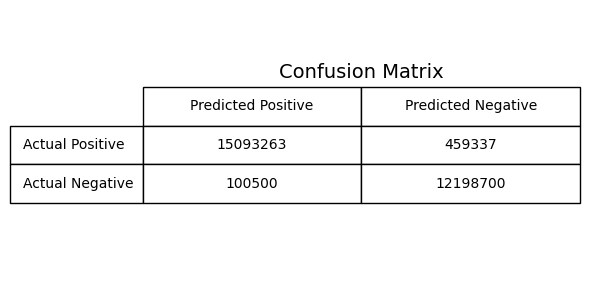

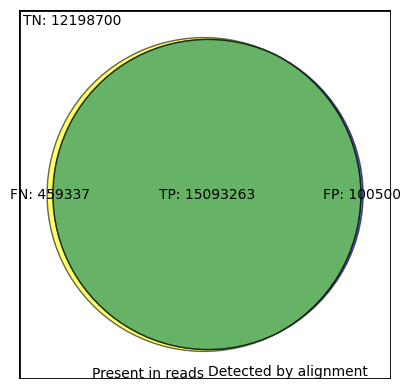

In [13]:
aligned_ids = set(bus_df['read_id'])
read_df['aligned_somewhere'] = read_df['read_id'].isin(aligned_ids)

read_df['TP_crude'] = (read_df['mutant_read'] & read_df['aligned_somewhere'])
read_df['FP_crude'] = (~read_df['mutant_read'] & read_df['aligned_somewhere'])
read_df['FN_crude'] = (read_df['mutant_read'] & ~read_df['aligned_somewhere'])
read_df['TN_crude'] = (~read_df['mutant_read'] & ~read_df['aligned_somewhere'])

read_df['read_id_unique'] = read_df['read_id'] + "_" + read_df.index.astype(str)  # because, if I sample with replacement, some read_id's (and their matching read_header's) will be repeated

metric_dictionary_reads_crude = calculate_metrics(read_df, header_name = "read_id_unique", check_assertions = False, crude = True, out = f"{plot_output_folder}/reads_metrics_crude.txt", include_FPs_and_FNs_lists_in_output=True)
draw_confusion_matrix(metric_dictionary_reads_crude)

true_set_crude = set(read_df.loc[read_df['mutant_read'], 'read_id_unique'])
positive_set_crude = set(read_df.loc[read_df['aligned_somewhere'], 'read_id_unique'])
# don't show mm here, because mm is counted as a TP for crude
create_venn_diagram(true_set_crude, positive_set_crude, TN = metric_dictionary_reads_crude['TN'], mm = None, out_path = f"{plot_output_folder}/venn_diagram_read_crude.png")

### Check if the read aligned to its correct VCRS
In much of the varseek documentation, we refer to variant-containing reference sequences (VCRSs). Because COSMIC is a mutation database, we use the acronym MCRS, for mutation-containing reference sequences. We use the terms MCRS and VCRS interchangeably in the context of databases where the variants are, in fact, mutations, such as with COSMIC.

In [14]:
# so that the drop_duplicates() doesn't throw an error
bus_df['transcript_ids_list'] = bus_df['transcript_ids_list'].astype(str)
bus_df['transcript_names_final'] = bus_df['transcript_names_final'].astype(str)

# Merge read_df with bus_df on 'read_id' and 'fastq_header' to bring in 'transcript_ids_list'
read_df = read_df.merge(bus_df[['read_id', 'transcript_ids_list', 'transcript_names_final']].drop_duplicates(), 
                          on='read_id', 
                          how='left').rename(columns={'transcript_names_final': 'mcrs_header_to_which_the_read_aligned'})

read_df["transcript_ids_list"] = read_df["transcript_ids_list"].apply(safe_literal_eval)

# Create 'multimapped' column as True if length of 'transcript_ids_list' > 1, else False
read_df['multimapped'] = read_df['transcript_ids_list'].apply(lambda x: len(x) > 1 if isinstance(x, list) else False)

read_df.drop(columns=['transcript_ids_list'], inplace=True)

read_df["mcrs_header_to_which_the_read_aligned"] = read_df["mcrs_header_to_which_the_read_aligned"].apply(safe_literal_eval)

# Convert lists to comma-separated strings, keeping NaN values as NaN
read_df['mcrs_header_to_which_the_read_aligned'] = read_df['mcrs_header_to_which_the_read_aligned'].apply(
    lambda x: ','.join(x) if isinstance(x, list) else x
)

TP: 15059744, FP: 100500, FN: 492856, TN: 12198700
Accuracy: 0.9786959550190651, Sensitivity: 0.9683103789720047, Specificity: 0.9918287368284116


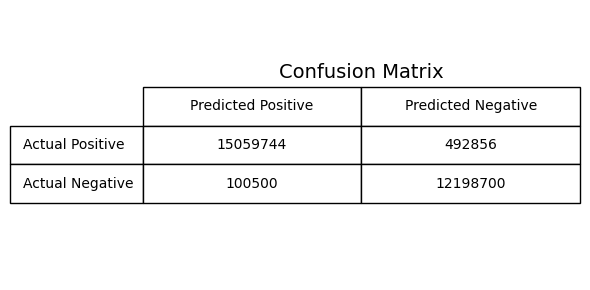

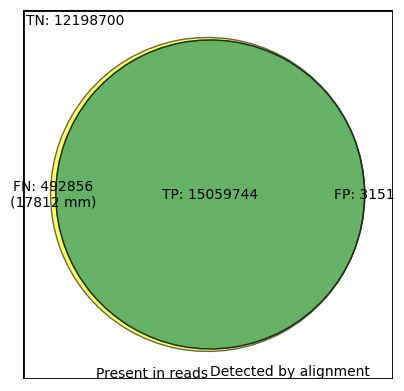

In [15]:
read_df['aligned_to_correct_mcrs'] = (read_df['vcrs_header'] == read_df['mcrs_header_to_which_the_read_aligned'])

# Check if 'vcrs_id' is a substring of any item in 'mcrs_header_to_which_the_read_aligned'
read_df['aligned_to_correct_mcrs_including_multimapped'] = read_df.apply(
    lambda row: row['vcrs_header'] in row['mcrs_header_to_which_the_read_aligned'] 
                if isinstance(row['mcrs_header_to_which_the_read_aligned'], str) else False,
    axis=1
)

read_df['TP'] = (read_df['mutant_read'] & read_df['aligned_to_correct_mcrs'])
read_df['FP'] = (~read_df['mutant_read'] & read_df['aligned_somewhere'])  # same as "FP_crude" (because I don't care if a WT read mapped to its respective MCRS or another MCRS - either way, if it aligns anywhere, it is a FP)
read_df['FN'] = (read_df['mutant_read'] & ~read_df['aligned_to_correct_mcrs'])
read_df['TN'] = (~read_df['mutant_read'] & ~read_df['aligned_somewhere'])  # same as "TN_crude" (because I don't care if a WT read mapped to its respective MCRS or another MCRS - either way, if it aligns anywhere, it is a FP)

metric_dictionary_reads = calculate_metrics(read_df, header_name = "read_id_unique", check_assertions = False, out = f"{plot_output_folder}/read_metrics.txt", include_FPs_and_FNs_lists_in_output=True)
draw_confusion_matrix(metric_dictionary_reads)

true_set = set(read_df.loc[read_df['mutant_read'], 'read_id_unique'])
positive_set = set(read_df.loc[read_df['aligned_to_correct_mcrs'], 'read_id_unique'])
create_venn_diagram(true_set, positive_set, TN = metric_dictionary_reads['TN'], mm = n_multimapped, out_path = f"{plot_output_folder}/venn_diagram_read.png")  # the FPs/TNs of this Venn will be off (it uses aligned_to_correct_mcrs instead of aligned_somewhere)

### Check reasons for read false negatives - can take a long time for a large number of FNs 

In [16]:
read_df['reason_for_fn'] = np.nan

if check_reason_for_read_fn:
    # Loop through each row in read_df where 'FN' is True
    for index, row in read_df.loc[read_df['FN']].iterrows():
        reason_for_fn_sublist = []

        # Get the vcrs_id from the current row in read_df
        vcrs_id = row['vcrs_id']
        
        # Find the corresponding vcrs_sequence_length in mutation_metadata_df
        matching_length = mutation_metadata_df.loc[
            mutation_metadata_df['vcrs_id'] == vcrs_id, 'vcrs_sequence_length'
        ]
        
        # Check if there's a match and if the length is less than 2*k-1
        if not matching_length.empty and matching_length.iloc[0] < (2*k-1):
            reason_for_fn_sublist.append("short_mcrs_id")

        if row['multimapped']:
            reason_for_fn_sublist.append("multimapped")
        
        dlist_status = mutation_metadata_df.loc[
            mutation_metadata_df['vcrs_id'] == vcrs_id, 'alignment_to_reference'
        ]

        if not dlist_status.empty and dlist_status.iloc[0] != "none":
            reason_for_fn_sublist.append("dlisted")

        if reason_for_fn_sublist:
            read_df.at[index, 'reason_for_fn'] = reason_for_fn_sublist  # might be cast as a string if length == 1 (especially for first row), but this doesn't really matter for me

    num_nan_reasons = read_df.loc[read_df['FN'], 'reason_for_fn'].isna().sum()

    print(f"Number of FN reads with no reasons: {num_nan_reasons}")

    # mcrs_set = set(unique_mcrs_df.loc[unique_mcrs_df['FN'] == True, 'vcrs_header'])
    # filtered_read_df = read_df[(read_df['FN']) & (~read_df['reference_header'].isin(mcrs_set))]

# Benchmarking varseek - perspective of reference

In [17]:
columns_to_list = ["order", "alignment_to_reference_count_total", "is_near_splice_junction_10", "triplet_complexity", "longest_homopolymer_length", "vcrs_variant_type"]
columns_to_or = ["included_in_synthetic_reads_mutant","included_in_synthetic_reads_wt", "included_in_synthetic_reads", "any_noisy_reads", "any_noisy_reads_mutant", "any_noisy_reads_wt"]
columns_to_sum = ["list_of_read_starting_indices_mutant","list_of_read_starting_indices_wt","number_of_reads_wt","number_of_reads_mutant", "noisy_read_indices_mutant","noisy_read_indices_wt"]

mutation_metadata_df_columns = mutation_metadata_df.columns
columns_to_list = [col for col in columns_to_list if col in mutation_metadata_df_columns]
columns_to_or = [col for col in columns_to_or if col in mutation_metadata_df_columns]
columns_to_sum = [col for col in columns_to_sum if col in mutation_metadata_df_columns]
columns_to_keep = ["vcrs_header"] + columns_to_list + columns_to_or + columns_to_sum

columns_to_drop = []
for col in mutation_metadata_df_columns:
    if col not in columns_to_keep:
        columns_to_drop.append(col)
mutation_metadata_df.drop(columns=columns_to_drop, inplace=True)
mutation_metadata_df_columns = mutation_metadata_df.columns

for column in list(columns_to_list):
    mutation_metadata_df[column] = mutation_metadata_df[column].apply(
        lambda x: tuple(x) if isinstance(x, list) else x
    )

unique_mcrs_df = (
    mutation_metadata_df.sort_values('order').groupby('vcrs_header', as_index=False)
    .agg(
        {**{col: list for col in list(columns_to_list)},  # list these values
        **{col: sum for col in list(columns_to_sum)},  # Take the first value for these columns
        **{col: np.any for col in list(columns_to_or)},  # OR these values
        **{col: 'first' for col in mutation_metadata_df.columns if col not in columns_to_list + columns_to_or + columns_to_sum + ['vcrs_header']}}  # Take the first value for other columns
    ).reset_index(drop=True)
)

unique_mcrs_df = unique_mcrs_df[mutation_metadata_df_columns]

### Calculate tumor purity

In [18]:
unique_mcrs_df['tumor_purity'] = unique_mcrs_df['number_of_reads_mutant'] / (unique_mcrs_df['number_of_reads_wt'] + unique_mcrs_df['number_of_reads_mutant'])

unique_mcrs_df['tumor_purity'] = np.where(
    np.isnan(unique_mcrs_df['tumor_purity']), 
    np.nan,  # Keep NaN as NaN
    unique_mcrs_df['tumor_purity']  # Keep the result for valid divisions
)

try:
    unique_mcrs_df['min_distance_to_splice_junction'] = unique_mcrs_df['distance_to_nearest_splice_junction'].apply(
        lambda x: min(x) if isinstance(x, list) and len(x) > 0 else np.nan
    )
except Exception as e:
    pass

### Use the bus df to determine the counts for each reference item

In [19]:
bus_df_subset = bus_df[["transcript_names_final", "counted_in_count_matrix", "count"]]

if isinstance(bus_df_subset['transcript_names_final'][0], str):
    bus_df_subset["transcript_names_final"] = bus_df_subset["transcript_names_final"].apply(safe_literal_eval)

bus_df_subset['transcript_names_final'] = bus_df_subset['transcript_names_final'].apply(
    lambda x: x[0] if isinstance(x, list) and x else x
)

bus_df_subset['count_recorded_in_count_matrix'] = np.where(
    bus_df_subset['counted_in_count_matrix'],  # Condition
    bus_df_subset['count'],                   # Value if True
    0                                  # Value if False
)

bus_df_subset.drop(columns=['counted_in_count_matrix', 'count'], inplace=True)

# Group by the string representation
bus_df_subset_grouped = bus_df_subset.groupby('transcript_names_final', as_index=False).agg({
    'count_recorded_in_count_matrix': 'sum',
})

# # Set values in 'count' to 0 where 'counted_in_count_matrix' is False
# bus_df_subset_grouped.loc[bus_df_subset_grouped['counted_in_count_matrix'] == False, 'count'] = 0

bus_df_subset_grouped.rename(columns={"transcript_names_final": "vcrs_header", "count_recorded_in_count_matrix": "number_of_reads_aligned_to_this_item"}, inplace=True)

if min_counts is not None and min_counts > 0:
    # set entries below min_counts to 0
    bus_df_subset_grouped.loc[bus_df_subset_grouped["number_of_reads_aligned_to_this_item"] < min_counts, "number_of_reads_aligned_to_this_item"] = 0

unique_mcrs_df = unique_mcrs_df.merge(bus_df_subset_grouped, on='vcrs_header', how='left')
unique_mcrs_df['received_an_aligned_read'] = ~pd.isna(unique_mcrs_df['number_of_reads_aligned_to_this_item'])

/tmp/ipykernel_1462419/3377568894.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_df_subset["transcript_names_final"] = bus_df_subset["transcript_names_final"].apply(safe_literal_eval)


/tmp/ipykernel_1462419/3377568894.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_df_subset['transcript_names_final'] = bus_df_subset['transcript_names_final'].apply(
/tmp/ipykernel_1462419/3377568894.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_df_subset['count_recorded_in_count_matrix'] = np.where(


/tmp/ipykernel_1462419/3377568894.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_df_subset.drop(columns=['counted_in_count_matrix', 'count'], inplace=True)


Alternative way of getting the "number_of_reads_aligned_to_this_item" from adata, without making bus_df

In [20]:
# adata_path = f"{kb_count_out}/counts_unfiltered/adata.h5ad"
# adata = ad.read_h5ad(adata_path)

# # Find the indices of non-zero values in adata.X
# non_zero_indices = np.nonzero(adata.X)

# # Get the non-zero values
# non_zero_values = np.squeeze(np.asarray(adata.X[non_zero_indices])).astype(int)

# # Get the corresponding gene names
# mcrs_ids = adata.var.index[non_zero_indices[1]].to_numpy().flatten()

# mcrs_ids = mcrs_ids.astype(str)

# # Create a DataFrame
# adata_df = pd.DataFrame({
#     'vcrs_header': mcrs_ids,
#     'number_of_reads_aligned_to_this_item': non_zero_values
# })

# unique_mcrs_df = unique_mcrs_df.merge(adata_df, on='vcrs_header', how='left')
# unique_mcrs_df['received_an_aligned_read'] = ~pd.isna(unique_mcrs_df['number_of_reads_aligned_to_this_item'])

### Check if the MCRS received an alignment, regardless of whether or not it came from a read truly containing the mutation
These are the counts that we observe in the count matrix in a real experiment, and thus what we will use as our results in further benchmarking

TP: 323018, FP: 102299, FN: 87, TN: 4904087
Accuracy: 0.9807887845199476, Sensitivity: 0.9997307376858916, Specificity: 0.9795662979242911


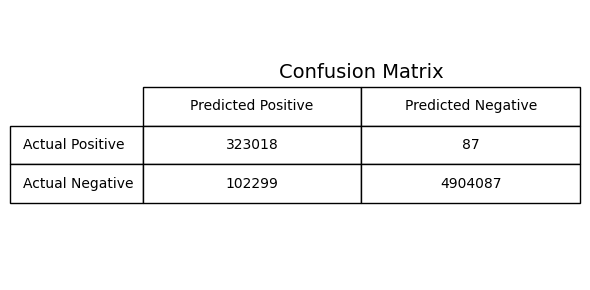

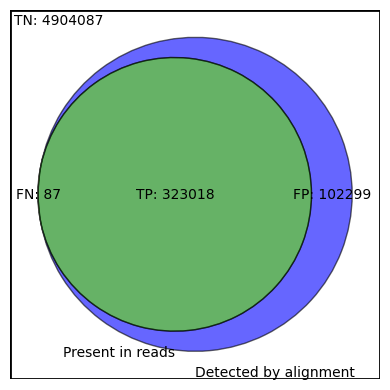

In [21]:
unique_mcrs_df['TP_crude'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df['received_an_aligned_read'])
unique_mcrs_df['FP_crude'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df['received_an_aligned_read'])
unique_mcrs_df['FN_crude'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df['received_an_aligned_read'])
unique_mcrs_df['TN_crude'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df['received_an_aligned_read'])

metric_dictionary_reference = calculate_metrics(unique_mcrs_df, header_name = "vcrs_header", check_assertions = False, crude = True, out = f"{plot_output_folder}/reference_metrics_crude.txt", include_FPs_and_FNs_lists_in_output=True)
draw_confusion_matrix(metric_dictionary_reference)

true_set = set(unique_mcrs_df.loc[unique_mcrs_df['included_in_synthetic_reads_mutant'], 'vcrs_header'])
positive_set = set(unique_mcrs_df.loc[unique_mcrs_df['received_an_aligned_read'], 'vcrs_header'])
create_venn_diagram(true_set, positive_set, TN = metric_dictionary_reference['TN'], out_path = f"{plot_output_folder}/venn_diagram_reference_crude.png")

### Check if the MCRS received an alignment from a read that truly contained the mutation

In [22]:
aligned_read_df_mutant = read_df.loc[(read_df['aligned_somewhere'] == True) & (read_df['mutant_read'] == True)]
mcrs_counts_mutant = aligned_read_df_mutant.groupby('vcrs_header').size().reset_index(name='number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere')

unique_mcrs_df = unique_mcrs_df.merge(mcrs_counts_mutant, on='vcrs_header', how='left')
unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'] = unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'].fillna(0).astype(int)
unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_didnt_align_anywhere'] = unique_mcrs_df['number_of_reads_mutant'] - unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere']

unique_mcrs_df['mutation_expression_prediction_error'] = unique_mcrs_df['number_of_reads_aligned_to_this_item'] - unique_mcrs_df['number_of_reads_mutant']  # positive means overpredicted, negative means underpredicted




aligned_read_df_wt = read_df.loc[(read_df['aligned_somewhere'] == True) & (read_df['wt_read'] == True)]
mcrs_counts_wt = aligned_read_df_wt.groupby('vcrs_header').size().reset_index(name='number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere')

unique_mcrs_df = unique_mcrs_df.merge(mcrs_counts_wt, on='vcrs_header', how='left')
unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'] = unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'].fillna(0).astype(int)
unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_didnt_align_anywhere'] = unique_mcrs_df['number_of_reads_wt'] - unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere']

In [23]:
# Step 1: Group by 'vcrs_header' and count 'aligned_to_correct_mcrs' (sum will count True as 1, False as 0)
aligned_counts = read_df.groupby('vcrs_header')['aligned_to_correct_mcrs'].sum().reset_index()

# Rename the column to something meaningful, like 'correct_alignment_count'
aligned_counts.rename(columns={'aligned_to_correct_mcrs': 'number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly'}, inplace=True)

# Step 2: Merge the counts with unique_mcrs_df on the 'vcrs_header' column
unique_mcrs_df = pd.merge(unique_mcrs_df, aligned_counts, on='vcrs_header', how='left')

# Fill NaN values with 0 in case some vcrs_header values in unique_mcrs_df do not appear in read_df
unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly'].fillna(0, inplace=True)

unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'] = unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly'] > 0

In [24]:
# Step 1: Group by 'vcrs_header_to_which_the_read_aligned' and collect 'read_header' into lists
reads_mapped = read_df.groupby('mcrs_header_to_which_the_read_aligned')['read_header'].apply(list).reset_index()

# Rename the column to 'reads_mapped_to_this_reference_item' for clarity
reads_mapped.rename(columns={'read_header': 'reads_mapped_to_this_reference_item'}, inplace=True)

# Step 2: Merge the list of read headers with unique_mcrs_df on the 'vcrs_header' column
unique_mcrs_df = pd.merge(unique_mcrs_df, reads_mapped, left_on='vcrs_header', right_on='mcrs_header_to_which_the_read_aligned', how='left')
unique_mcrs_df.drop(columns='mcrs_header_to_which_the_read_aligned', inplace=True)

# Fill NaN values with empty lists in case there are no matching read headers for some vcrs_header values
unique_mcrs_df['reads_mapped_to_this_reference_item'] = unique_mcrs_df['reads_mapped_to_this_reference_item'].apply(lambda x: x if isinstance(x, list) else [])

unique_mcrs_df['contained_any_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'] = unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'].astype(bool)
unique_mcrs_df['contained_any_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'] = unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'].astype(bool)

TP: 322984, FP: 0, FN: 121, TN: 5006386
Accuracy: 0.9999772961432902, Sensitivity: 0.9996255087355503, Specificity: 1.0


Mean Expression Error: -1.135308487551638, Median Expression Error: 0.0, Mean Magnitude Expression Error: 1.1694712414504946, Median Magnitude Expression Error: 0.0


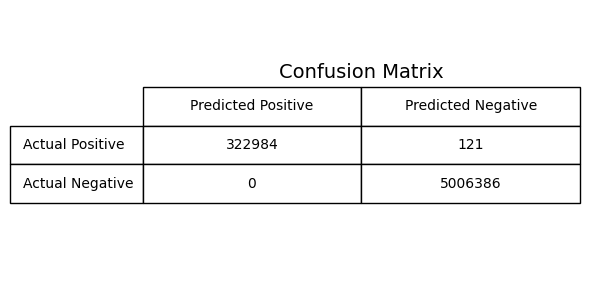

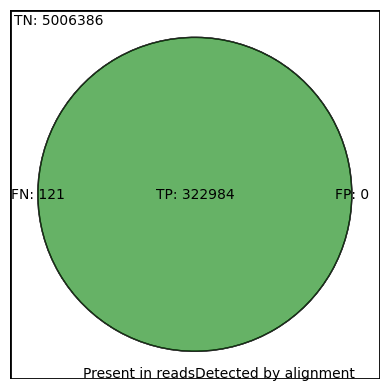

In [25]:
unique_mcrs_df['TP'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'])
unique_mcrs_df['FP'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'])
unique_mcrs_df['FN'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'])
unique_mcrs_df['TN'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'])

metric_dictionary_reference = calculate_metrics(unique_mcrs_df, header_name = "vcrs_header", check_assertions = False, out = f"{plot_output_folder}/reference_metrics.txt", include_FPs_and_FNs_lists_in_output=True)
draw_confusion_matrix(metric_dictionary_reference)

true_set = set(unique_mcrs_df.loc[unique_mcrs_df['included_in_synthetic_reads_mutant'], 'vcrs_header'])
positive_set = set(unique_mcrs_df.loc[unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'], 'vcrs_header'])
create_venn_diagram(true_set, positive_set, TN = metric_dictionary_reference['TN'], out_path = f"{plot_output_folder}/venn_diagram_reference.png")

unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_did_not_align_correctly'] = unique_mcrs_df['number_of_reads_mutant'] - unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly']
unique_mcrs_df['number_of_reads_aligned_to_this_mcrs_item_that_aligned_incorrectly'] = unique_mcrs_df['number_of_reads_aligned_to_this_item'] - unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly']

### Check reasons for reference false negatives - can take a long time for a large number of FNs 

In [26]:
if check_reason_for_ref_fn:
    unexplainable_references = 0
    for header in metric_dictionary_reference['FNs']:
        print(f"Header {header}")
        did_not_align_anywhere = (read_df[read_df['vcrs_header'] == header])['FN_crude'].all()
        print(f"All did not align anywhere for {header}: {did_not_align_anywhere}")
        did_not_align_to_correct_position = (read_df[read_df['vcrs_header'] == header])['FN'].all()
        print(f"All did not align to correct mcrs for {header}: {did_not_align_to_correct_position}")
        multimapped = (read_df[read_df['vcrs_header'] == header])['multimapped'].all()
        print(f"All multimapped for {header}: {multimapped}")
        if not did_not_align_anywhere and not did_not_align_to_correct_position and not multimapped:
            unexplainable_references += 1

    if unexplainable_references > 0:
        print(f"Unexplainable references: {unexplainable_references}")
    else:
        print("All explainable!")

## Save unique_mcrs_df as VCF

In [27]:
cosmic_tsv = os.path.join(reference_out_dir, "cosmic", "CancerMutationCensus_AllData_Tsv_v101_GRCh37", "CancerMutationCensus_AllData_v101_GRCh37.tsv")
vcf_data_csv = f"{out_dir_notebook}/CancerMutationCensus_AllData_v101_GRCh37_vcf_data.csv"

if not os.path.exists(cosmic_tsv):
    import gget
    reference_out_dir_cosmic = os.path.dirname(os.path.dirname(cosmic_tsv))
    gget.cosmic(
        None,
        grch_version=37,
        cosmic_version=101,
        out=reference_out_dir_cosmic,
        cosmic_project="cancer",
        download_cosmic=True
    )

if not os.path.exists(vcf_data_csv):  # alternatively, I can do this in vk clean by passing in vcf_data_csv=vcf_data_csv, cosmic_tsv=cosmic_tsv, cosmic_reference_genome_fasta=cosmic_reference_genome_fasta, variants="cosmic_cmc", sequences="cdna", cosmic_version=101
    vk.utils.add_vcf_info_to_cosmic_tsv(cosmic_tsv=cosmic_tsv, reference_genome_fasta=reference_genome_fasta, cosmic_df_out=vcf_data_csv, sequences="cdna", cosmic_version=101)

  0%|                                                                                                                                                                                                                                 | 0/16477 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                                                                                      | 19/16477 [00:00<01:30, 181.65it/s]

  0%|▉                                                                                                                                                                                                                      | 71/16477 [00:00<00:43, 375.88it/s]

  1%|█▍                                                                                                                                                                                                                    | 109/16477 [00:00<00:47, 341.88it/s]

  1%|██▉                                                                                                                                                                                                                   | 225/16477 [00:00<00:25, 633.52it/s]

  2%|███▊                                                                                                                                                                                                                  | 290/16477 [00:00<00:33, 482.37it/s]

  2%|████▍                                                                                                                                                                                                                 | 346/16477 [00:00<00:32, 495.54it/s]

  2%|█████▏                                                                                                                                                                                                                | 400/16477 [00:00<00:37, 432.43it/s]

  3%|██████▉                                                                                                                                                                                                               | 532/16477 [00:01<00:24, 644.27it/s]

  4%|███████▊                                                                                                                                                                                                              | 604/16477 [00:01<00:36, 438.84it/s]

  4%|████████▌                                                                                                                                                                                                             | 661/16477 [00:01<00:39, 397.60it/s]

  4%|█████████▎                                                                                                                                                                                                            | 721/16477 [00:01<00:36, 431.81it/s]

  5%|██████████                                                                                                                                                                                                            | 773/16477 [00:01<00:37, 416.53it/s]

  5%|██████████▋                                                                                                                                                                                                           | 820/16477 [00:01<00:41, 376.91it/s]

  5%|███████████▎                                                                                                                                                                                                          | 873/16477 [00:01<00:38, 403.81it/s]

  6%|███████████▉                                                                                                                                                                                                          | 917/16477 [00:02<00:45, 344.77it/s]

  6%|████████████▍                                                                                                                                                                                                         | 955/16477 [00:02<00:46, 331.09it/s]

  6%|████████████▊                                                                                                                                                                                                         | 991/16477 [00:02<00:52, 296.54it/s]

  6%|█████████████▍                                                                                                                                                                                                       | 1038/16477 [00:02<00:47, 325.96it/s]

  7%|██████████████                                                                                                                                                                                                       | 1083/16477 [00:02<00:43, 350.18it/s]

  7%|██████████████▍                                                                                                                                                                                                      | 1120/16477 [00:02<00:47, 325.74it/s]

  7%|██████████████▉                                                                                                                                                                                                      | 1154/16477 [00:02<00:48, 317.20it/s]

  7%|███████████████▍                                                                                                                                                                                                     | 1197/16477 [00:03<00:44, 344.82it/s]

  7%|███████████████▉                                                                                                                                                                                                     | 1233/16477 [00:03<00:47, 323.22it/s]

  8%|████████████████▋                                                                                                                                                                                                    | 1288/16477 [00:03<00:39, 382.00it/s]

  8%|█████████████████▏                                                                                                                                                                                                   | 1328/16477 [00:03<00:42, 354.69it/s]

  8%|█████████████████▋                                                                                                                                                                                                   | 1365/16477 [00:03<00:44, 337.99it/s]

  8%|██████████████████                                                                                                                                                                                                   | 1400/16477 [00:03<00:53, 281.04it/s]

  9%|██████████████████▊                                                                                                                                                                                                  | 1459/16477 [00:03<00:42, 352.56it/s]

  9%|███████████████████▎                                                                                                                                                                                                 | 1498/16477 [00:04<00:52, 287.58it/s]

  9%|███████████████████▊                                                                                                                                                                                                 | 1531/16477 [00:04<00:59, 251.20it/s]

  9%|████████████████████▏                                                                                                                                                                                                | 1560/16477 [00:04<01:06, 224.22it/s]

 10%|████████████████████▍                                                                                                                                                                                                | 1585/16477 [00:04<01:09, 214.19it/s]

 10%|████████████████████▊                                                                                                                                                                                                | 1608/16477 [00:04<01:09, 214.86it/s]

 10%|█████████████████████                                                                                                                                                                                                | 1631/16477 [00:04<01:14, 199.70it/s]

 10%|█████████████████████▎                                                                                                                                                                                               | 1652/16477 [00:04<01:18, 189.66it/s]

 10%|█████████████████████▌                                                                                                                                                                                               | 1672/16477 [00:05<01:27, 169.50it/s]

 10%|█████████████████████▊                                                                                                                                                                                               | 1690/16477 [00:05<01:30, 164.04it/s]

 10%|██████████████████████                                                                                                                                                                                               | 1707/16477 [00:05<01:45, 140.67it/s]

 10%|██████████████████████▎                                                                                                                                                                                              | 1722/16477 [00:05<01:46, 138.12it/s]

 11%|██████████████████████▍                                                                                                                                                                                              | 1738/16477 [00:05<01:43, 143.05it/s]

 11%|██████████████████████▊                                                                                                                                                                                              | 1760/16477 [00:05<01:37, 150.40it/s]

 11%|██████████████████████▉                                                                                                                                                                                              | 1776/16477 [00:05<01:38, 149.46it/s]

 11%|███████████████████████▏                                                                                                                                                                                             | 1792/16477 [00:05<01:38, 149.40it/s]

 11%|███████████████████████▎                                                                                                                                                                                             | 1808/16477 [00:06<01:43, 141.57it/s]

 11%|███████████████████████▌                                                                                                                                                                                             | 1824/16477 [00:06<01:40, 146.22it/s]

 11%|███████████████████████▉                                                                                                                                                                                             | 1848/16477 [00:06<01:25, 170.53it/s]

 11%|████████████████████████▏                                                                                                                                                                                            | 1873/16477 [00:06<01:19, 183.63it/s]

 12%|████████████████████████▌                                                                                                                                                                                            | 1896/16477 [00:06<01:15, 194.40it/s]

 12%|█████████████████████████▎                                                                                                                                                                                           | 1956/16477 [00:06<00:48, 301.50it/s]

 12%|█████████████████████████▋                                                                                                                                                                                           | 1987/16477 [00:06<00:53, 272.09it/s]

 12%|██████████████████████████                                                                                                                                                                                           | 2015/16477 [00:06<00:54, 264.17it/s]

 12%|██████████████████████████▍                                                                                                                                                                                          | 2042/16477 [00:06<00:57, 252.53it/s]

 13%|██████████████████████████▋                                                                                                                                                                                          | 2068/16477 [00:07<01:04, 224.16it/s]

 13%|███████████████████████████                                                                                                                                                                                          | 2092/16477 [00:07<01:04, 222.38it/s]

 13%|████████████████████████████▎                                                                                                                                                                                        | 2189/16477 [00:07<00:37, 383.69it/s]

 14%|████████████████████████████▉                                                                                                                                                                                        | 2240/16477 [00:07<00:34, 415.64it/s]

 14%|█████████████████████████████▉                                                                                                                                                                                       | 2312/16477 [00:07<00:28, 489.84it/s]

 14%|██████████████████████████████▌                                                                                                                                                                                      | 2362/16477 [00:07<00:35, 398.30it/s]

 15%|███████████████████████████████▎                                                                                                                                                                                     | 2425/16477 [00:07<00:31, 452.20it/s]

 15%|███████████████████████████████▉                                                                                                                                                                                     | 2474/16477 [00:08<00:40, 348.75it/s]

 15%|████████████████████████████████▌                                                                                                                                                                                    | 2515/16477 [00:08<00:47, 292.48it/s]

 15%|████████████████████████████████▉                                                                                                                                                                                    | 2550/16477 [00:08<00:49, 279.41it/s]

 16%|█████████████████████████████████▍                                                                                                                                                                                   | 2582/16477 [00:08<00:48, 287.03it/s]

 16%|█████████████████████████████████▊                                                                                                                                                                                   | 2615/16477 [00:08<00:46, 296.21it/s]

 16%|██████████████████████████████████▏                                                                                                                                                                                  | 2647/16477 [00:08<00:53, 257.13it/s]

 16%|██████████████████████████████████▊                                                                                                                                                                                  | 2689/16477 [00:08<00:49, 277.96it/s]

 17%|███████████████████████████████████▏                                                                                                                                                                                 | 2719/16477 [00:09<00:49, 279.63it/s]

 17%|███████████████████████████████████▌                                                                                                                                                                                 | 2749/16477 [00:09<00:55, 246.60it/s]

 17%|███████████████████████████████████▉                                                                                                                                                                                 | 2779/16477 [00:09<00:53, 256.77it/s]

 18%|█████████████████████████████████████▌                                                                                                                                                                               | 2903/16477 [00:09<00:27, 497.72it/s]

 18%|██████████████████████████████████████▏                                                                                                                                                                              | 2958/16477 [00:09<00:32, 421.22it/s]

 18%|██████████████████████████████████████▊                                                                                                                                                                              | 3006/16477 [00:09<00:33, 401.81it/s]

 19%|███████████████████████████████████████▍                                                                                                                                                                             | 3050/16477 [00:09<00:33, 400.73it/s]

 19%|████████████████████████████████████████▋                                                                                                                                                                            | 3144/16477 [00:09<00:26, 511.23it/s]

 19%|█████████████████████████████████████████▎                                                                                                                                                                           | 3198/16477 [00:10<00:26, 498.70it/s]

 20%|██████████████████████████████████████████▉                                                                                                                                                                          | 3326/16477 [00:10<00:19, 685.12it/s]

 21%|███████████████████████████████████████████▉                                                                                                                                                                         | 3398/16477 [00:10<00:21, 609.50it/s]

 21%|█████████████████████████████████████████████                                                                                                                                                                        | 3486/16477 [00:10<00:19, 675.84it/s]

 22%|█████████████████████████████████████████████▉                                                                                                                                                                       | 3558/16477 [00:10<00:27, 472.29it/s]

 22%|██████████████████████████████████████████████▋                                                                                                                                                                      | 3616/16477 [00:10<00:31, 406.49it/s]

 22%|███████████████████████████████████████████████▍                                                                                                                                                                     | 3665/16477 [00:11<00:37, 346.24it/s]

 22%|███████████████████████████████████████████████▉                                                                                                                                                                     | 3707/16477 [00:11<00:46, 273.33it/s]

 23%|████████████████████████████████████████████████▎                                                                                                                                                                    | 3741/16477 [00:11<00:51, 247.31it/s]

 23%|████████████████████████████████████████████████▋                                                                                                                                                                    | 3770/16477 [00:11<00:56, 224.53it/s]

 23%|█████████████████████████████████████████████████                                                                                                                                                                    | 3796/16477 [00:11<01:00, 208.79it/s]

 23%|█████████████████████████████████████████████████▍                                                                                                                                                                   | 3820/16477 [00:11<00:59, 212.55it/s]

 23%|█████████████████████████████████████████████████▋                                                                                                                                                                   | 3843/16477 [00:12<01:02, 200.92it/s]

 23%|█████████████████████████████████████████████████▉                                                                                                                                                                   | 3865/16477 [00:12<01:01, 204.95it/s]

 24%|██████████████████████████████████████████████████▏                                                                                                                                                                  | 3887/16477 [00:12<01:04, 193.84it/s]

 24%|██████████████████████████████████████████████████▌                                                                                                                                                                  | 3907/16477 [00:12<01:11, 176.34it/s]

 24%|██████████████████████████████████████████████████▉                                                                                                                                                                  | 3937/16477 [00:12<01:01, 205.39it/s]

 24%|███████████████████████████████████████████████████▏                                                                                                                                                                 | 3964/16477 [00:12<00:56, 221.47it/s]

 24%|███████████████████████████████████████████████████▌                                                                                                                                                                 | 3988/16477 [00:12<01:03, 197.27it/s]

 24%|███████████████████████████████████████████████████▊                                                                                                                                                                 | 4009/16477 [00:12<01:05, 191.79it/s]

 25%|████████████████████████████████████████████████████▏                                                                                                                                                                | 4041/16477 [00:13<00:56, 220.74it/s]

 25%|████████████████████████████████████████████████████▊                                                                                                                                                                | 4082/16477 [00:13<00:45, 270.32it/s]

 25%|█████████████████████████████████████████████████████▏                                                                                                                                                               | 4113/16477 [00:13<00:44, 279.64it/s]

 25%|█████████████████████████████████████████████████████▌                                                                                                                                                               | 4142/16477 [00:13<00:49, 248.97it/s]

 25%|██████████████████████████████████████████████████████▏                                                                                                                                                              | 4192/16477 [00:13<00:39, 310.75it/s]

 26%|██████████████████████████████████████████████████████▌                                                                                                                                                              | 4225/16477 [00:13<00:39, 313.27it/s]

 26%|███████████████████████████████████████████████████████                                                                                                                                                              | 4258/16477 [00:13<00:43, 278.03it/s]

 26%|███████████████████████████████████████████████████████▍                                                                                                                                                             | 4288/16477 [00:13<00:46, 260.24it/s]

 26%|███████████████████████████████████████████████████████▊                                                                                                                                                             | 4316/16477 [00:14<00:52, 232.48it/s]

 26%|████████████████████████████████████████████████████████▏                                                                                                                                                            | 4348/16477 [00:14<00:48, 249.08it/s]

 27%|████████████████████████████████████████████████████████▌                                                                                                                                                            | 4375/16477 [00:14<00:49, 242.55it/s]

 27%|████████████████████████████████████████████████████████▉                                                                                                                                                            | 4400/16477 [00:14<00:50, 238.65it/s]

 27%|█████████████████████████████████████████████████████████▍                                                                                                                                                           | 4445/16477 [00:14<00:41, 292.90it/s]

 27%|██████████████████████████████████████████████████████████▌                                                                                                                                                          | 4530/16477 [00:14<00:27, 436.09it/s]

 28%|███████████████████████████████████████████████████████████▍                                                                                                                                                         | 4595/16477 [00:14<00:24, 485.75it/s]

 28%|████████████████████████████████████████████████████████████                                                                                                                                                         | 4645/16477 [00:14<00:30, 393.27it/s]

 28%|████████████████████████████████████████████████████████████▌                                                                                                                                                        | 4688/16477 [00:15<00:31, 374.10it/s]

 29%|█████████████████████████████████████████████████████████████                                                                                                                                                        | 4728/16477 [00:15<00:31, 373.82it/s]

 29%|█████████████████████████████████████████████████████████████▋                                                                                                                                                       | 4768/16477 [00:15<00:32, 357.14it/s]

 29%|██████████████████████████████████████████████████████████████▏                                                                                                                                                      | 4807/16477 [00:15<00:32, 358.16it/s]

 29%|██████████████████████████████████████████████████████████████▌                                                                                                                                                      | 4844/16477 [00:15<00:38, 302.33it/s]

 30%|████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 5009/16477 [00:15<00:18, 618.89it/s]

 31%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 5080/16477 [00:15<00:25, 445.78it/s]

 31%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 5137/16477 [00:16<00:32, 347.11it/s]

 31%|███████████████████████████████████████████████████████████████████                                                                                                                                                  | 5183/16477 [00:16<00:31, 362.22it/s]

 32%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 5232/16477 [00:16<00:29, 382.75it/s]

 32%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 5278/16477 [00:16<00:29, 379.10it/s]

 32%|█████████████████████████████████████████████████████████████████████                                                                                                                                                | 5342/16477 [00:16<00:25, 434.67it/s]

 33%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 5391/16477 [00:16<00:26, 418.29it/s]

 33%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 5437/16477 [00:16<00:29, 371.23it/s]

 33%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 5478/16477 [00:17<00:29, 368.26it/s]

 33%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 5517/16477 [00:17<00:29, 368.28it/s]

 34%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 5556/16477 [00:17<00:34, 312.36it/s]

 34%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 5609/16477 [00:17<00:30, 350.77it/s]

 34%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 5647/16477 [00:17<00:37, 289.63it/s]

 34%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 5679/16477 [00:17<00:41, 260.09it/s]

 35%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 5708/16477 [00:18<00:46, 229.95it/s]

 35%|██████████████████████████████████████████████████████████████████████████                                                                                                                                           | 5733/16477 [00:18<00:52, 206.26it/s]

 35%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 5755/16477 [00:18<00:55, 192.16it/s]

 35%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 5788/16477 [00:18<00:49, 214.47it/s]

 35%|███████████████████████████████████████████████████████████████████████████                                                                                                                                          | 5811/16477 [00:18<00:53, 198.45it/s]

 35%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                         | 5832/16477 [00:18<00:53, 198.95it/s]

 36%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 5854/16477 [00:18<00:52, 202.78it/s]

 36%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 5875/16477 [00:18<00:53, 198.19it/s]

 36%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 5896/16477 [00:19<00:52, 199.70it/s]

 36%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 5917/16477 [00:19<00:54, 195.14it/s]

 36%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 5954/16477 [00:19<00:43, 240.68it/s]

 36%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 5979/16477 [00:19<00:45, 232.57it/s]

 36%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 6003/16477 [00:19<00:48, 216.16it/s]

 37%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 6026/16477 [00:19<00:51, 202.84it/s]

 37%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 6051/16477 [00:19<00:48, 213.22it/s]

 37%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 6074/16477 [00:19<00:47, 217.55it/s]

 37%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 6134/16477 [00:19<00:31, 323.49it/s]

 38%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 6199/16477 [00:20<00:24, 414.14it/s]

 38%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 6242/16477 [00:20<00:25, 401.57it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 6284/16477 [00:20<00:30, 337.21it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 6404/16477 [00:20<00:18, 547.74it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 6464/16477 [00:20<00:18, 535.86it/s]

 40%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 6522/16477 [00:20<00:21, 463.63it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 6584/16477 [00:20<00:19, 497.45it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 6638/16477 [00:20<00:24, 406.20it/s]

 41%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 6684/16477 [00:21<00:28, 348.62it/s]

 41%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 6728/16477 [00:21<00:26, 366.12it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 6791/16477 [00:21<00:22, 424.13it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 6838/16477 [00:21<00:24, 397.99it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 6913/16477 [00:21<00:20, 477.80it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 6965/16477 [00:21<00:23, 407.15it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 7010/16477 [00:21<00:22, 415.71it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 7055/16477 [00:22<00:28, 334.84it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 7093/16477 [00:22<00:28, 325.31it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 7129/16477 [00:22<00:30, 309.27it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 7162/16477 [00:22<00:29, 313.67it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 7227/16477 [00:22<00:23, 393.02it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 7269/16477 [00:22<00:23, 386.34it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 7365/16477 [00:22<00:17, 523.82it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 7420/16477 [00:22<00:19, 453.30it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 7469/16477 [00:23<00:24, 361.83it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 7511/16477 [00:23<00:24, 373.45it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 7552/16477 [00:23<00:30, 295.53it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 7587/16477 [00:23<00:32, 274.45it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 7618/16477 [00:23<00:35, 246.23it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 7645/16477 [00:23<00:36, 241.32it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 7671/16477 [00:24<00:36, 242.93it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 7697/16477 [00:24<00:39, 223.42it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 7727/16477 [00:24<00:37, 236.17it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 7752/16477 [00:24<00:38, 224.40it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 7778/16477 [00:24<00:37, 231.05it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 7802/16477 [00:24<00:40, 213.97it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 7824/16477 [00:24<00:45, 190.01it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 7851/16477 [00:25<00:49, 175.26it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 7870/16477 [00:25<00:51, 166.48it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 7888/16477 [00:25<00:57, 149.63it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 7910/16477 [00:25<00:52, 162.08it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 7927/16477 [00:25<00:55, 152.75it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 7956/16477 [00:25<00:46, 184.65it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 7984/16477 [00:25<00:41, 206.01it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 8021/16477 [00:25<00:33, 248.86it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 8048/16477 [00:25<00:35, 238.34it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 8095/16477 [00:26<00:28, 299.27it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 8127/16477 [00:26<00:29, 281.13it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 8160/16477 [00:26<00:28, 293.64it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 8191/16477 [00:26<00:33, 245.38it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 8218/16477 [00:26<00:33, 247.14it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 8245/16477 [00:26<00:33, 246.79it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 8271/16477 [00:26<00:35, 231.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 8333/16477 [00:26<00:24, 327.32it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 8387/16477 [00:27<00:22, 358.03it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 8424/16477 [00:27<00:27, 295.69it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 8456/16477 [00:27<00:26, 300.54it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 8495/16477 [00:27<00:24, 319.72it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 8529/16477 [00:27<00:27, 284.11it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 8562/16477 [00:27<00:27, 290.97it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 8610/16477 [00:27<00:23, 339.21it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 8646/16477 [00:27<00:25, 309.36it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 8685/16477 [00:28<00:24, 323.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 8719/16477 [00:28<00:27, 285.20it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 8752/16477 [00:28<00:26, 291.64it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 8796/16477 [00:28<00:23, 324.09it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 8839/16477 [00:28<00:21, 350.01it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 9099/16477 [00:28<00:07, 954.75it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 9199/16477 [00:28<00:08, 888.45it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 9363/16477 [00:28<00:06, 1078.96it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 9476/16477 [00:29<00:10, 678.44it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 9566/16477 [00:29<00:13, 519.24it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 9638/16477 [00:29<00:17, 398.96it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 9695/16477 [00:29<00:17, 394.06it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 9746/16477 [00:30<00:21, 317.80it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 9787/16477 [00:30<00:21, 310.59it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 9825/16477 [00:30<00:23, 277.78it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 9857/16477 [00:30<00:23, 278.48it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 9888/16477 [00:30<00:27, 238.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 9918/16477 [00:31<00:26, 249.75it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 9960/16477 [00:31<00:22, 284.93it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 9992/16477 [00:31<00:22, 288.68it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10040/16477 [00:31<00:19, 333.27it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10076/16477 [00:31<00:21, 303.80it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 10117/16477 [00:31<00:19, 324.07it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 10152/16477 [00:31<00:22, 283.02it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 10186/16477 [00:31<00:21, 296.50it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 10218/16477 [00:31<00:23, 271.90it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 10247/16477 [00:32<00:27, 229.55it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 10272/16477 [00:32<00:27, 223.98it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 10326/16477 [00:32<00:20, 297.69it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 10359/16477 [00:32<00:21, 279.46it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 10405/16477 [00:32<00:18, 319.80it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 10468/16477 [00:32<00:15, 398.17it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 10511/16477 [00:32<00:20, 295.68it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 10549/16477 [00:33<00:19, 311.06it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 10585/16477 [00:33<00:21, 268.77it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 10616/16477 [00:33<00:22, 256.64it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 10651/16477 [00:33<00:20, 277.47it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 10682/16477 [00:33<00:21, 268.23it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 10736/16477 [00:33<00:17, 330.75it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 10773/16477 [00:33<00:16, 337.63it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 10814/16477 [00:33<00:16, 341.03it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 10887/16477 [00:34<00:12, 437.90it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 10952/16477 [00:34<00:11, 490.26it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11003/16477 [00:34<00:12, 427.15it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 11117/16477 [00:34<00:08, 599.35it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 11181/16477 [00:34<00:10, 520.70it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 11280/16477 [00:34<00:08, 631.84it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 11349/16477 [00:35<00:13, 367.21it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 11403/16477 [00:35<00:15, 323.73it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 11448/16477 [00:35<00:16, 298.18it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 11522/16477 [00:35<00:13, 373.04it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 11571/16477 [00:35<00:14, 337.02it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 11613/16477 [00:35<00:15, 304.72it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 11650/16477 [00:36<00:17, 278.85it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 11682/16477 [00:36<00:17, 276.29it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 11713/16477 [00:36<00:17, 269.28it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 11742/16477 [00:36<00:18, 252.63it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 11769/16477 [00:36<00:22, 212.09it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 11792/16477 [00:36<00:22, 210.12it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 11821/16477 [00:36<00:20, 228.25it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 11846/16477 [00:37<00:23, 195.22it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 11869/16477 [00:37<00:22, 201.00it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 11901/16477 [00:37<00:19, 228.93it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 11931/16477 [00:37<00:18, 243.43it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 11990/16477 [00:37<00:13, 334.57it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 12026/16477 [00:37<00:14, 308.92it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 12075/16477 [00:37<00:12, 345.73it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 12187/16477 [00:37<00:07, 551.42it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 12253/16477 [00:38<00:07, 572.13it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 12387/16477 [00:38<00:05, 785.53it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 12469/16477 [00:38<00:06, 580.77it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 12538/16477 [00:38<00:08, 479.81it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 12596/16477 [00:38<00:09, 425.04it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 12646/16477 [00:38<00:08, 436.07it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 12695/16477 [00:38<00:09, 398.81it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 12743/16477 [00:39<00:09, 412.85it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 12828/16477 [00:39<00:07, 516.30it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 13015/16477 [00:39<00:04, 834.47it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 13106/16477 [00:39<00:04, 783.36it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 13190/16477 [00:39<00:04, 695.66it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 13265/16477 [00:39<00:06, 474.87it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 13346/16477 [00:40<00:06, 513.94it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 13417/16477 [00:40<00:05, 552.95it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 13481/16477 [00:40<00:06, 496.10it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 13538/16477 [00:40<00:05, 498.52it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 13593/16477 [00:40<00:06, 466.92it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 13670/16477 [00:40<00:05, 533.16it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 13728/16477 [00:40<00:05, 474.33it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 13779/16477 [00:40<00:06, 403.92it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 13824/16477 [00:41<00:06, 381.22it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 13865/16477 [00:41<00:08, 324.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 13900/16477 [00:41<00:08, 316.52it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 13934/16477 [00:41<00:09, 268.25it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 13966/16477 [00:41<00:09, 274.27it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 13995/16477 [00:41<00:09, 264.94it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 14023/16477 [00:41<00:09, 254.89it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 14053/16477 [00:42<00:09, 256.06it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 14086/16477 [00:42<00:08, 273.56it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 14114/16477 [00:42<00:08, 273.40it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 14161/16477 [00:42<00:07, 325.05it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 14198/16477 [00:42<00:06, 333.44it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 14259/16477 [00:42<00:05, 410.40it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 14340/16477 [00:42<00:04, 511.49it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 14392/16477 [00:42<00:05, 387.42it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 14436/16477 [00:43<00:05, 397.11it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 14500/16477 [00:43<00:04, 445.66it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 14548/16477 [00:43<00:05, 383.72it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 14606/16477 [00:43<00:04, 426.61it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 14674/16477 [00:43<00:03, 486.89it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 14727/16477 [00:43<00:04, 413.52it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 14773/16477 [00:43<00:04, 394.64it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 15221/16477 [00:43<00:00, 1359.76it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 15380/16477 [00:44<00:01, 899.62it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 15506/16477 [00:44<00:01, 946.03it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 15649/16477 [00:44<00:00, 1033.59it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 15775/16477 [00:44<00:00, 840.08it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 15886/16477 [00:44<00:00, 882.78it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 15991/16477 [00:45<00:00, 709.51it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 16078/16477 [00:45<00:00, 532.14it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 16148/16477 [00:45<00:00, 432.91it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 16205/16477 [00:45<00:00, 408.22it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 16255/16477 [00:45<00:00, 401.65it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 16301/16477 [00:46<00:00, 350.11it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 16341/16477 [00:46<00:00, 317.65it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 16392/16477 [00:46<00:00, 350.14it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 16431/16477 [00:46<00:00, 328.39it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 16467/16477 [00:46<00:00, 335.04it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16477/16477 [00:46<00:00, 352.79it/s]

  0%|                                                                                                                                                                                                                                | 0/123475 [00:00<?, ?it/s]

  0%|                                                                                                                                                                                                                      | 32/123475 [00:00<06:45, 304.69it/s]

  0%|▏                                                                                                                                                                                                                     | 85/123475 [00:00<04:49, 426.81it/s]

  0%|▎                                                                                                                                                                                                                    | 150/123475 [00:00<04:00, 512.59it/s]

  0%|▊                                                                                                                                                                                                                   | 438/123475 [00:00<01:28, 1387.09it/s]

  1%|█▏                                                                                                                                                                                                                  | 666/123475 [00:00<01:13, 1680.18it/s]

  1%|█▍                                                                                                                                                                                                                  | 842/123475 [00:00<01:13, 1666.92it/s]

  1%|██▉                                                                                                                                                                                                                | 1709/123475 [00:00<00:31, 3868.76it/s]

  2%|███▌                                                                                                                                                                                                               | 2104/123475 [00:01<00:56, 2139.14it/s]

  2%|████                                                                                                                                                                                                               | 2408/123475 [00:01<00:58, 2085.34it/s]

  2%|████▌                                                                                                                                                                                                              | 2678/123475 [00:01<00:57, 2084.58it/s]

  2%|█████                                                                                                                                                                                                              | 2935/123475 [00:01<00:55, 2176.93it/s]

  3%|█████▍                                                                                                                                                                                                             | 3186/123475 [00:01<01:01, 1960.89it/s]

  3%|█████▊                                                                                                                                                                                                             | 3407/123475 [00:01<01:01, 1950.31it/s]

  3%|███████▏                                                                                                                                                                                                           | 4219/123475 [00:01<00:35, 3360.08it/s]

  4%|███████▊                                                                                                                                                                                                           | 4598/123475 [00:02<00:47, 2516.29it/s]

  4%|████████▍                                                                                                                                                                                                          | 4909/123475 [00:02<00:50, 2345.25it/s]

  4%|████████▊                                                                                                                                                                                                          | 5184/123475 [00:02<00:57, 2069.17it/s]

  4%|█████████▎                                                                                                                                                                                                         | 5422/123475 [00:02<01:00, 1939.07it/s]

  5%|█████████▋                                                                                                                                                                                                         | 5666/123475 [00:02<00:58, 2010.70it/s]

  5%|██████████▏                                                                                                                                                                                                        | 5937/123475 [00:02<00:54, 2167.91it/s]

  5%|██████████▌                                                                                                                                                                                                        | 6171/123475 [00:03<01:17, 1516.95it/s]

  5%|██████████▊                                                                                                                                                                                                        | 6359/123475 [00:03<01:32, 1260.43it/s]

  5%|███████████▏                                                                                                                                                                                                       | 6515/123475 [00:03<01:35, 1219.27it/s]

  6%|███████████▌                                                                                                                                                                                                       | 6799/123475 [00:03<01:16, 1530.52it/s]

  6%|███████████▉                                                                                                                                                                                                       | 6984/123475 [00:03<01:26, 1350.65it/s]

  6%|████████████▏                                                                                                                                                                                                      | 7143/123475 [00:03<01:32, 1256.24it/s]

  6%|████████████▋                                                                                                                                                                                                      | 7403/123475 [00:04<01:15, 1531.98it/s]

  6%|████████████▉                                                                                                                                                                                                      | 7580/123475 [00:04<01:14, 1552.54it/s]

  6%|█████████████▏                                                                                                                                                                                                     | 7752/123475 [00:04<01:19, 1460.23it/s]

  6%|█████████████▌                                                                                                                                                                                                     | 7943/123475 [00:04<01:13, 1563.88it/s]

  7%|█████████████▊                                                                                                                                                                                                     | 8110/123475 [00:04<01:19, 1444.69it/s]

  7%|██████████████▎                                                                                                                                                                                                    | 8389/123475 [00:04<01:04, 1777.07it/s]

  7%|██████████████▋                                                                                                                                                                                                    | 8580/123475 [00:04<01:10, 1621.56it/s]

  7%|███████████████▏                                                                                                                                                                                                   | 8852/123475 [00:04<01:01, 1876.69it/s]

  7%|███████████████▌                                                                                                                                                                                                   | 9073/123475 [00:04<00:58, 1962.04it/s]

  8%|███████████████▊                                                                                                                                                                                                   | 9279/123475 [00:05<00:59, 1906.32it/s]

  8%|████████████████▎                                                                                                                                                                                                  | 9537/123475 [00:05<00:54, 2085.17it/s]

  8%|████████████████▋                                                                                                                                                                                                  | 9752/123475 [00:05<00:59, 1897.36it/s]

  8%|█████████████████                                                                                                                                                                                                 | 10000/123475 [00:05<00:55, 2036.36it/s]

  8%|█████████████████▌                                                                                                                                                                                                | 10328/123475 [00:05<00:50, 2238.33it/s]

  9%|█████████████████▉                                                                                                                                                                                                | 10556/123475 [00:05<00:56, 2013.51it/s]

  9%|███████████████████▏                                                                                                                                                                                              | 11279/123475 [00:05<00:34, 3278.16it/s]

  9%|███████████████████▊                                                                                                                                                                                              | 11625/123475 [00:06<00:47, 2375.90it/s]

 10%|████████████████████▎                                                                                                                                                                                             | 11908/123475 [00:06<01:01, 1802.62it/s]

 10%|████████████████████▉                                                                                                                                                                                             | 12333/123475 [00:06<00:49, 2225.47it/s]

 10%|█████████████████████▍                                                                                                                                                                                            | 12615/123475 [00:06<01:16, 1453.24it/s]

 10%|█████████████████████▊                                                                                                                                                                                            | 12834/123475 [00:07<01:26, 1285.51it/s]

 11%|██████████████████████▏                                                                                                                                                                                           | 13014/123475 [00:07<01:42, 1080.74it/s]

 11%|██████████████████████▍                                                                                                                                                                                            | 13160/123475 [00:07<02:03, 891.14it/s]

 11%|██████████████████████▋                                                                                                                                                                                            | 13278/123475 [00:07<02:10, 842.24it/s]

 11%|██████████████████████▊                                                                                                                                                                                            | 13381/123475 [00:07<02:14, 817.82it/s]

 11%|███████████████████████                                                                                                                                                                                            | 13482/123475 [00:08<02:10, 844.84it/s]

 11%|███████████████████████▍                                                                                                                                                                                          | 13785/123475 [00:08<01:26, 1270.91it/s]

 11%|███████████████████████▋                                                                                                                                                                                          | 13942/123475 [00:08<01:45, 1033.70it/s]

 11%|████████████████████████                                                                                                                                                                                           | 14072/123475 [00:08<01:57, 930.17it/s]

 11%|████████████████████████▏                                                                                                                                                                                          | 14184/123475 [00:08<02:10, 835.68it/s]

 12%|████████████████████████▍                                                                                                                                                                                          | 14281/123475 [00:08<02:18, 789.88it/s]

 12%|████████████████████████▌                                                                                                                                                                                          | 14369/123475 [00:09<02:27, 738.60it/s]

 12%|████████████████████████▋                                                                                                                                                                                          | 14449/123475 [00:09<02:34, 704.60it/s]

 12%|████████████████████████▊                                                                                                                                                                                          | 14523/123475 [00:09<02:59, 605.72it/s]

 12%|████████████████████████▉                                                                                                                                                                                          | 14587/123475 [00:09<02:58, 611.05it/s]

 12%|█████████████████████████                                                                                                                                                                                          | 14651/123475 [00:09<02:57, 613.08it/s]

 12%|█████████████████████████▏                                                                                                                                                                                         | 14743/123475 [00:09<02:39, 680.27it/s]

 12%|█████████████████████████▎                                                                                                                                                                                         | 14814/123475 [00:09<02:44, 660.08it/s]

 12%|█████████████████████████▍                                                                                                                                                                                         | 14897/123475 [00:09<02:34, 700.90it/s]

 12%|█████████████████████████▌                                                                                                                                                                                         | 14969/123475 [00:10<03:08, 574.77it/s]

 12%|█████████████████████████▋                                                                                                                                                                                         | 15057/123475 [00:10<02:49, 639.32it/s]

 12%|█████████████████████████▊                                                                                                                                                                                         | 15126/123475 [00:10<03:03, 588.93it/s]

 12%|█████████████████████████▉                                                                                                                                                                                         | 15189/123475 [00:10<03:09, 572.43it/s]

 12%|██████████████████████████▏                                                                                                                                                                                        | 15319/123475 [00:10<02:24, 747.85it/s]

 13%|██████████████████████████▍                                                                                                                                                                                        | 15441/123475 [00:10<02:04, 870.55it/s]

 13%|██████████████████████████▌                                                                                                                                                                                        | 15533/123475 [00:10<02:33, 705.22it/s]

 13%|██████████████████████████▋                                                                                                                                                                                        | 15638/123475 [00:10<02:18, 778.47it/s]

 13%|██████████████████████████▊                                                                                                                                                                                        | 15724/123475 [00:11<02:30, 715.20it/s]

 13%|███████████████████████████                                                                                                                                                                                        | 15848/123475 [00:11<02:09, 828.47it/s]

 13%|███████████████████████████▏                                                                                                                                                                                       | 15937/123475 [00:11<02:19, 772.31it/s]

 13%|███████████████████████████▎                                                                                                                                                                                       | 16019/123475 [00:11<02:34, 697.07it/s]

 13%|███████████████████████████▌                                                                                                                                                                                       | 16093/123475 [00:11<02:41, 664.88it/s]

 13%|███████████████████████████▌                                                                                                                                                                                       | 16163/123475 [00:11<02:59, 598.07it/s]

 13%|███████████████████████████▊                                                                                                                                                                                       | 16250/123475 [00:11<02:44, 653.63it/s]

 13%|███████████████████████████▉                                                                                                                                                                                       | 16319/123475 [00:11<02:48, 634.85it/s]

 13%|███████████████████████████▉                                                                                                                                                                                       | 16385/123475 [00:12<02:52, 620.50it/s]

 13%|████████████████████████████                                                                                                                                                                                       | 16449/123475 [00:12<02:55, 610.08it/s]

 13%|████████████████████████████▎                                                                                                                                                                                      | 16594/123475 [00:12<02:09, 827.64it/s]

 14%|████████████████████████████▊                                                                                                                                                                                     | 16916/123475 [00:12<01:11, 1482.33it/s]

 14%|█████████████████████████████                                                                                                                                                                                     | 17090/123475 [00:12<01:09, 1537.61it/s]

 14%|█████████████████████████████▎                                                                                                                                                                                    | 17264/123475 [00:12<01:07, 1582.42it/s]

 14%|█████████████████████████████▋                                                                                                                                                                                    | 17432/123475 [00:12<01:05, 1609.55it/s]

 14%|█████████████████████████████▉                                                                                                                                                                                    | 17597/123475 [00:12<01:15, 1411.38it/s]

 14%|██████████████████████████████▏                                                                                                                                                                                   | 17773/123475 [00:12<01:10, 1503.96it/s]

 15%|██████████████████████████████▍                                                                                                                                                                                   | 17930/123475 [00:13<01:09, 1513.61it/s]

 15%|██████████████████████████████▊                                                                                                                                                                                   | 18086/123475 [00:13<01:11, 1467.48it/s]

 15%|███████████████████████████████                                                                                                                                                                                   | 18236/123475 [00:13<01:13, 1439.99it/s]

 15%|████████████████████████████████                                                                                                                                                                                  | 18881/123475 [00:13<00:37, 2821.80it/s]

 16%|████████████████████████████████▌                                                                                                                                                                                 | 19173/123475 [00:13<00:45, 2289.92it/s]

 16%|█████████████████████████████████▎                                                                                                                                                                                | 19566/123475 [00:13<00:38, 2671.60it/s]

 16%|█████████████████████████████████▊                                                                                                                                                                                | 19856/123475 [00:13<00:42, 2425.73it/s]

 16%|██████████████████████████████████▏                                                                                                                                                                               | 20118/123475 [00:14<00:50, 2027.39it/s]

 17%|██████████████████████████████████▉                                                                                                                                                                               | 20507/123475 [00:14<00:42, 2442.50it/s]

 17%|███████████████████████████████████▎                                                                                                                                                                              | 20781/123475 [00:14<00:55, 1849.19it/s]

 17%|███████████████████████████████████▋                                                                                                                                                                              | 21006/123475 [00:14<01:02, 1651.96it/s]

 17%|████████████████████████████████████                                                                                                                                                                              | 21200/123475 [00:14<01:05, 1557.40it/s]

 17%|████████████████████████████████████▍                                                                                                                                                                             | 21412/123475 [00:14<01:01, 1657.95it/s]

 17%|████████████████████████████████████▋                                                                                                                                                                             | 21596/123475 [00:14<01:05, 1560.37it/s]

 18%|█████████████████████████████████████▎                                                                                                                                                                            | 21969/123475 [00:15<00:49, 2039.72it/s]

 18%|█████████████████████████████████████▋                                                                                                                                                                            | 22195/123475 [00:15<00:51, 1953.51it/s]

 18%|██████████████████████████████████████▍                                                                                                                                                                           | 22567/123475 [00:15<00:42, 2369.88it/s]

 18%|██████████████████████████████████████▊                                                                                                                                                                           | 22823/123475 [00:15<00:44, 2286.69it/s]

 19%|███████████████████████████████████████▏                                                                                                                                                                          | 23065/123475 [00:15<00:55, 1815.22it/s]

 19%|███████████████████████████████████████▌                                                                                                                                                                          | 23270/123475 [00:15<00:57, 1755.90it/s]

 19%|███████████████████████████████████████▉                                                                                                                                                                          | 23461/123475 [00:15<01:02, 1595.99it/s]

 19%|████████████████████████████████████████▏                                                                                                                                                                         | 23632/123475 [00:16<01:04, 1553.45it/s]

 20%|█████████████████████████████████████████▏                                                                                                                                                                        | 24189/123475 [00:16<00:39, 2506.87it/s]

 20%|█████████████████████████████████████████▋                                                                                                                                                                        | 24476/123475 [00:16<00:38, 2580.89it/s]

 20%|██████████████████████████████████████████▍                                                                                                                                                                       | 24945/123475 [00:16<00:31, 3133.93it/s]

 20%|██████████████████████████████████████████▉                                                                                                                                                                       | 25282/123475 [00:16<00:41, 2394.86it/s]

 21%|████████████████████████████████████████████                                                                                                                                                                      | 25932/123475 [00:16<00:29, 3275.66it/s]

 21%|████████████████████████████████████████████▊                                                                                                                                                                     | 26312/123475 [00:16<00:32, 3022.95it/s]

 22%|█████████████████████████████████████████████▎                                                                                                                                                                    | 26653/123475 [00:17<00:39, 2428.29it/s]

 22%|█████████████████████████████████████████████▊                                                                                                                                                                    | 26938/123475 [00:17<00:42, 2245.82it/s]

 22%|██████████████████████████████████████████████▎                                                                                                                                                                   | 27199/123475 [00:17<00:44, 2152.73it/s]

 22%|██████████████████████████████████████████████▋                                                                                                                                                                   | 27434/123475 [00:17<01:02, 1524.78it/s]

 22%|██████████████████████████████████████████████▉                                                                                                                                                                   | 27622/123475 [00:17<01:21, 1175.19it/s]

 22%|███████████████████████████████████████████████▏                                                                                                                                                                  | 27773/123475 [00:18<01:27, 1091.17it/s]

 23%|███████████████████████████████████████████████▍                                                                                                                                                                  | 27904/123475 [00:18<01:28, 1077.34it/s]

 23%|███████████████████████████████████████████████▋                                                                                                                                                                  | 28026/123475 [00:18<01:32, 1033.84it/s]

 23%|████████████████████████████████████████████████                                                                                                                                                                  | 28245/123475 [00:18<01:15, 1256.09it/s]

 23%|████████████████████████████████████████████████▎                                                                                                                                                                 | 28388/123475 [00:18<01:23, 1144.99it/s]

 23%|████████████████████████████████████████████████▍                                                                                                                                                                 | 28515/123475 [00:18<01:29, 1064.47it/s]

 23%|████████████████████████████████████████████████▉                                                                                                                                                                  | 28630/123475 [00:19<01:52, 845.18it/s]

 23%|█████████████████████████████████████████████████                                                                                                                                                                  | 28726/123475 [00:19<01:56, 815.40it/s]

 23%|█████████████████████████████████████████████████▏                                                                                                                                                                 | 28815/123475 [00:19<01:57, 806.37it/s]

 23%|█████████████████████████████████████████████████▍                                                                                                                                                                 | 28939/123475 [00:19<01:45, 899.28it/s]

 24%|█████████████████████████████████████████████████▌                                                                                                                                                                 | 29036/123475 [00:19<01:54, 821.25it/s]

 24%|█████████████████████████████████████████████████▊                                                                                                                                                                 | 29130/123475 [00:19<01:52, 841.03it/s]

 24%|█████████████████████████████████████████████████▉                                                                                                                                                                 | 29218/123475 [00:19<02:03, 765.18it/s]

 24%|██████████████████████████████████████████████████▏                                                                                                                                                                | 29355/123475 [00:19<01:44, 899.20it/s]

 24%|██████████████████████████████████████████████████▎                                                                                                                                                                | 29450/123475 [00:19<01:43, 910.82it/s]

 24%|██████████████████████████████████████████████████▎                                                                                                                                                               | 29614/123475 [00:20<01:25, 1103.77it/s]

 24%|██████████████████████████████████████████████████▊                                                                                                                                                                | 29730/123475 [00:20<01:39, 946.61it/s]

 24%|██████████████████████████████████████████████████▉                                                                                                                                                                | 29832/123475 [00:20<01:54, 820.52it/s]

 24%|███████████████████████████████████████████████████▏                                                                                                                                                               | 29933/123475 [00:20<01:48, 861.97it/s]

 24%|███████████████████████████████████████████████████▎                                                                                                                                                               | 30026/123475 [00:20<01:50, 846.65it/s]

 24%|███████████████████████████████████████████████████▍                                                                                                                                                               | 30128/123475 [00:20<01:45, 887.00it/s]

 24%|███████████████████████████████████████████████████▋                                                                                                                                                               | 30221/123475 [00:20<02:00, 771.78it/s]

 25%|███████████████████████████████████████████████████▉                                                                                                                                                               | 30377/123475 [00:20<01:37, 956.48it/s]

 25%|███████████████████████████████████████████████████▉                                                                                                                                                              | 30532/123475 [00:21<01:24, 1094.66it/s]

 25%|████████████████████████████████████████████████████▎                                                                                                                                                             | 30728/123475 [00:21<01:10, 1312.10it/s]

 25%|████████████████████████████████████████████████████▍                                                                                                                                                             | 30866/123475 [00:21<01:19, 1172.02it/s]

 25%|████████████████████████████████████████████████████▋                                                                                                                                                             | 30991/123475 [00:21<01:24, 1088.15it/s]

 25%|████████████████████████████████████████████████████▉                                                                                                                                                             | 31114/123475 [00:21<01:23, 1103.52it/s]

 25%|█████████████████████████████████████████████████████▏                                                                                                                                                            | 31239/123475 [00:21<01:21, 1127.28it/s]

 25%|█████████████████████████████████████████████████████▎                                                                                                                                                            | 31355/123475 [00:21<01:25, 1071.47it/s]

 25%|█████████████████████████████████████████████████████▌                                                                                                                                                            | 31465/123475 [00:21<01:29, 1028.72it/s]

 26%|█████████████████████████████████████████████████████▉                                                                                                                                                             | 31570/123475 [00:22<01:46, 865.98it/s]

 26%|██████████████████████████████████████████████████████                                                                                                                                                            | 31769/123475 [00:22<01:21, 1124.22it/s]

 26%|██████████████████████████████████████████████████████▍                                                                                                                                                           | 31995/123475 [00:22<01:05, 1402.35it/s]

 26%|██████████████████████████████████████████████████████▋                                                                                                                                                           | 32186/123475 [00:22<00:59, 1524.64it/s]

 26%|███████████████████████████████████████████████████████                                                                                                                                                           | 32392/123475 [00:22<00:55, 1634.54it/s]

 26%|███████████████████████████████████████████████████████▍                                                                                                                                                          | 32562/123475 [00:22<01:11, 1276.91it/s]

 26%|███████████████████████████████████████████████████████▋                                                                                                                                                          | 32709/123475 [00:22<01:09, 1311.10it/s]

 27%|████████████████████████████████████████████████████████▎                                                                                                                                                         | 33082/123475 [00:22<00:47, 1908.93it/s]

 27%|████████████████████████████████████████████████████████▌                                                                                                                                                         | 33294/123475 [00:23<00:46, 1936.44it/s]

 27%|████████████████████████████████████████████████████████▉                                                                                                                                                         | 33503/123475 [00:23<00:58, 1532.93it/s]

 27%|█████████████████████████████████████████████████████████▎                                                                                                                                                        | 33679/123475 [00:23<01:07, 1333.60it/s]

 27%|█████████████████████████████████████████████████████████▋                                                                                                                                                        | 33938/123475 [00:23<00:56, 1589.80it/s]

 28%|██████████████████████████████████████████████████████████                                                                                                                                                        | 34119/123475 [00:23<01:04, 1383.24it/s]

 28%|██████████████████████████████████████████████████████████▎                                                                                                                                                       | 34316/123475 [00:23<01:00, 1475.23it/s]

 28%|██████████████████████████████████████████████████████████▋                                                                                                                                                       | 34479/123475 [00:23<01:00, 1481.68it/s]

 28%|██████████████████████████████████████████████████████████▉                                                                                                                                                       | 34681/123475 [00:24<00:55, 1612.87it/s]

 28%|███████████████████████████████████████████████████████████▎                                                                                                                                                      | 34911/123475 [00:24<00:49, 1779.65it/s]

 28%|███████████████████████████████████████████████████████████▋                                                                                                                                                      | 35099/123475 [00:24<00:55, 1590.15it/s]

 29%|███████████████████████████████████████████████████████████▉                                                                                                                                                      | 35268/123475 [00:24<00:59, 1478.20it/s]

 29%|████████████████████████████████████████████████████████████▏                                                                                                                                                     | 35424/123475 [00:24<00:58, 1498.02it/s]

 29%|█████████████████████████████████████████████████████████████▏                                                                                                                                                    | 35955/123475 [00:24<00:35, 2494.70it/s]

 29%|█████████████████████████████████████████████████████████████▌                                                                                                                                                    | 36223/123475 [00:24<00:46, 1893.21it/s]

 30%|█████████████████████████████████████████████████████████████▉                                                                                                                                                    | 36446/123475 [00:25<00:50, 1714.76it/s]

 30%|██████████████████████████████████████████████████████████████▎                                                                                                                                                   | 36643/123475 [00:25<00:58, 1472.91it/s]

 30%|██████████████████████████████████████████████████████████████▊                                                                                                                                                   | 36906/123475 [00:25<00:50, 1705.28it/s]

 30%|███████████████████████████████████████████████████████████████                                                                                                                                                   | 37102/123475 [00:25<00:53, 1611.58it/s]

 30%|███████████████████████████████████████████████████████████████▍                                                                                                                                                  | 37281/123475 [00:25<01:03, 1348.03it/s]

 31%|████████████████████████████████████████████████████████████████▎                                                                                                                                                 | 37840/123475 [00:25<00:40, 2127.00it/s]

 31%|████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 38081/123475 [00:25<00:42, 2028.35it/s]

 31%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                | 38303/123475 [00:26<00:43, 1979.19it/s]

 31%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                | 38609/123475 [00:26<00:37, 2234.78it/s]

 32%|██████████████████████████████████████████████████████████████████▊                                                                                                                                               | 39258/123475 [00:26<00:25, 3298.77it/s]

 32%|███████████████████████████████████████████████████████████████████▍                                                                                                                                              | 39618/123475 [00:26<00:35, 2334.94it/s]

 32%|███████████████████████████████████████████████████████████████████▉                                                                                                                                              | 39910/123475 [00:26<00:35, 2326.40it/s]

 33%|████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 40184/123475 [00:26<00:39, 2122.09it/s]

 33%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 40680/123475 [00:26<00:30, 2713.07it/s]

 33%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 40993/123475 [00:27<00:30, 2702.02it/s]

 33%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 41293/123475 [00:27<00:32, 2492.20it/s]

 34%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 42017/123475 [00:27<00:22, 3621.34it/s]

 34%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                         | 42424/123475 [00:27<00:31, 2592.77it/s]

 35%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 42754/123475 [00:27<00:35, 2275.34it/s]

 35%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 43040/123475 [00:27<00:34, 2308.26it/s]

 35%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 43309/123475 [00:28<00:37, 2112.58it/s]

 35%|██████████████████████████████████████████████████████████████████████████                                                                                                                                        | 43547/123475 [00:28<00:45, 1738.05it/s]

 35%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 43747/123475 [00:28<00:47, 1664.20it/s]

 36%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 43930/123475 [00:28<00:50, 1568.06it/s]

 36%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 44097/123475 [00:28<01:02, 1277.17it/s]

 36%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 44238/123475 [00:28<01:09, 1138.33it/s]

 36%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 44424/123475 [00:29<01:02, 1266.03it/s]

 36%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 44563/123475 [00:29<01:01, 1283.76it/s]

 36%|████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 44701/123475 [00:29<01:05, 1206.89it/s]

 36%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 44828/123475 [00:29<01:12, 1087.09it/s]

 36%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 44984/123475 [00:29<01:06, 1188.69it/s]

 37%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 45110/123475 [00:29<01:12, 1073.55it/s]

 37%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 45223/123475 [00:29<01:13, 1063.86it/s]

 37%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 45361/123475 [00:29<01:08, 1138.49it/s]

 37%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 45479/123475 [00:30<01:16, 1016.23it/s]

 37%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 45586/123475 [00:30<01:28, 876.86it/s]

 37%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 45788/123475 [00:30<01:08, 1137.19it/s]

 37%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 45913/123475 [00:30<01:12, 1063.57it/s]

 37%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 46028/123475 [00:30<01:36, 800.13it/s]

 37%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 46132/123475 [00:30<01:31, 848.89it/s]

 37%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 46255/123475 [00:30<01:23, 926.61it/s]

 38%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 46414/123475 [00:30<01:11, 1071.39it/s]

 38%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 46532/123475 [00:31<01:11, 1080.45it/s]

 38%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 46648/123475 [00:31<01:13, 1043.97it/s]

 38%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 46788/123475 [00:31<01:08, 1116.40it/s]

 38%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 46916/123475 [00:31<01:07, 1140.95it/s]

 38%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 47034/123475 [00:31<01:08, 1117.90it/s]

 38%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 47148/123475 [00:31<01:10, 1086.85it/s]

 38%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 47259/123475 [00:31<01:12, 1051.57it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 47775/123475 [00:31<00:34, 2180.53it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 48223/123475 [00:31<00:26, 2815.83it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 48516/123475 [00:32<00:28, 2599.61it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 48787/123475 [00:32<00:32, 2293.65it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 49030/123475 [00:32<00:35, 2081.71it/s]

 40%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 49895/123475 [00:32<00:20, 3666.99it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 50303/123475 [00:32<00:23, 3059.51it/s]

 41%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 50653/123475 [00:32<00:26, 2764.89it/s]

 41%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 50963/123475 [00:32<00:26, 2746.31it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 51261/123475 [00:33<00:30, 2392.40it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 51521/123475 [00:33<00:39, 1827.79it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 51749/123475 [00:33<00:37, 1900.10it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 52019/123475 [00:33<00:34, 2067.79it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 52250/123475 [00:33<00:40, 1757.07it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 52449/123475 [00:33<00:39, 1802.44it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 52647/123475 [00:33<00:39, 1791.81it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 52839/123475 [00:34<00:48, 1456.67it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 53178/123475 [00:34<00:37, 1864.18it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 53390/123475 [00:34<00:36, 1916.80it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 53732/123475 [00:34<00:30, 2281.90it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 54060/123475 [00:34<00:27, 2534.22it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 54330/123475 [00:34<00:33, 2080.38it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 54563/123475 [00:34<00:37, 1859.19it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 54769/123475 [00:35<00:43, 1579.62it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 54946/123475 [00:35<00:50, 1351.08it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 55172/123475 [00:35<00:44, 1532.67it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 55685/123475 [00:35<00:29, 2334.21it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 55959/123475 [00:35<00:28, 2392.60it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 56228/123475 [00:35<00:27, 2421.99it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 56774/123475 [00:35<00:20, 3214.81it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 57121/123475 [00:35<00:21, 3059.86it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 57772/123475 [00:36<00:16, 3943.59it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 58189/123475 [00:36<00:28, 2281.21it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 58514/123475 [00:36<00:39, 1646.51it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 58768/123475 [00:37<00:42, 1539.82it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 58983/123475 [00:37<00:44, 1458.03it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 59170/123475 [00:37<00:47, 1348.16it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 59333/123475 [00:37<00:45, 1396.38it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 59496/123475 [00:37<00:44, 1439.92it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 59666/123475 [00:37<00:42, 1490.64it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 59830/123475 [00:37<00:41, 1522.13it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 59994/123475 [00:37<00:46, 1355.70it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 60196/123475 [00:38<00:41, 1508.18it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 60358/123475 [00:38<00:47, 1318.01it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 60501/123475 [00:38<00:53, 1183.14it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 60629/123475 [00:38<00:53, 1175.79it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 60753/123475 [00:38<00:58, 1077.14it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 60896/123475 [00:38<00:54, 1156.60it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 61017/123475 [00:38<00:53, 1157.70it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 61137/123475 [00:38<00:54, 1150.89it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 61255/123475 [00:39<01:01, 1007.04it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 61471/123475 [00:39<00:48, 1284.53it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 61607/123475 [00:39<00:54, 1145.60it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 61729/123475 [00:39<00:54, 1128.61it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 61891/123475 [00:39<00:49, 1254.12it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 62023/123475 [00:39<00:56, 1088.12it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 62204/123475 [00:39<00:49, 1250.32it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 62506/123475 [00:39<00:36, 1690.55it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 62716/123475 [00:40<00:34, 1774.15it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 62977/123475 [00:40<00:30, 1993.12it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 63185/123475 [00:40<00:38, 1564.95it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 63361/123475 [00:40<00:38, 1580.14it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 63608/123475 [00:40<00:33, 1799.75it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 63802/123475 [00:40<00:36, 1639.08it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 63978/123475 [00:40<00:36, 1652.59it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 64271/123475 [00:40<00:30, 1957.18it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 64476/123475 [00:41<00:35, 1640.82it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 64654/123475 [00:41<00:36, 1613.99it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 64825/123475 [00:41<00:42, 1367.87it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 65021/123475 [00:41<00:38, 1502.81it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 65184/123475 [00:41<00:46, 1257.81it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 65473/123475 [00:41<00:36, 1604.73it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 65950/123475 [00:41<00:24, 2345.66it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 66215/123475 [00:42<00:26, 2149.32it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 66453/123475 [00:42<00:28, 2033.76it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 66673/123475 [00:42<00:28, 2012.26it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 66886/123475 [00:42<00:28, 2000.35it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 67185/123475 [00:42<00:25, 2234.03it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 67417/123475 [00:42<00:26, 2155.72it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 67680/123475 [00:42<00:24, 2236.13it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 67933/123475 [00:42<00:24, 2273.21it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 68241/123475 [00:42<00:22, 2481.67it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 68493/123475 [00:43<00:24, 2233.39it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 68904/123475 [00:43<00:20, 2704.92it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 69184/123475 [00:43<00:29, 1865.20it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 69498/123475 [00:43<00:26, 2074.95it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 71738/123475 [00:43<00:07, 6559.88it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 72533/123475 [00:43<00:09, 5527.49it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 73207/123475 [00:43<00:09, 5522.31it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 73844/123475 [00:44<00:15, 3231.22it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 74334/123475 [00:44<00:20, 2402.78it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 74715/123475 [00:45<00:25, 1909.76it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 75013/123475 [00:45<00:26, 1839.74it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 75269/123475 [00:45<00:29, 1614.91it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 75529/123475 [00:45<00:27, 1734.47it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 75749/123475 [00:45<00:30, 1583.99it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 75973/123475 [00:46<00:28, 1683.36it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 76170/123475 [00:46<00:28, 1678.31it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 76384/123475 [00:46<00:26, 1753.48it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 76589/123475 [00:46<00:25, 1810.91it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 76784/123475 [00:46<00:25, 1804.36it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 77018/123475 [00:46<00:24, 1893.76it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 77215/123475 [00:46<00:29, 1549.42it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 77384/123475 [00:46<00:34, 1333.70it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 77531/123475 [00:47<00:36, 1265.04it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 78012/123475 [00:47<00:22, 2049.86it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 78572/123475 [00:47<00:15, 2907.74it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 78904/123475 [00:47<00:14, 2979.85it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 79232/123475 [00:47<00:18, 2438.41it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 79512/123475 [00:47<00:19, 2269.39it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 79765/123475 [00:47<00:20, 2180.80it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 80001/123475 [00:47<00:20, 2137.21it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 80227/123475 [00:48<00:23, 1830.59it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 80453/123475 [00:48<00:22, 1928.15it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 80690/123475 [00:48<00:21, 2025.75it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 80904/123475 [00:48<00:21, 1954.79it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 81211/123475 [00:48<00:19, 2198.93it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 81439/123475 [00:48<00:19, 2110.36it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 81656/123475 [00:48<00:20, 2054.37it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 81865/123475 [00:48<00:24, 1728.41it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 82048/123475 [00:49<00:23, 1736.61it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 82440/123475 [00:49<00:18, 2271.67it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 82756/123475 [00:49<00:16, 2474.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 83130/123475 [00:49<00:14, 2752.85it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 83468/123475 [00:49<00:13, 2920.72it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 83768/123475 [00:49<00:15, 2544.65it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 84039/123475 [00:49<00:15, 2587.03it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 84600/123475 [00:49<00:11, 3326.57it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 84944/123475 [00:50<00:13, 2946.86it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 85522/123475 [00:50<00:10, 3647.05it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 86353/123475 [00:50<00:07, 4842.72it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 87093/123475 [00:50<00:06, 5517.72it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 87669/123475 [00:50<00:07, 4510.95it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 88166/123475 [00:50<00:09, 3613.36it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 88584/123475 [00:50<00:11, 3081.35it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 88939/123475 [00:51<00:12, 2693.15it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 89244/123475 [00:51<00:14, 2285.42it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 89502/123475 [00:51<00:15, 2260.66it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 89748/123475 [00:51<00:15, 2245.32it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 89986/123475 [00:51<00:17, 1921.76it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 90192/123475 [00:51<00:18, 1785.25it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 90443/123475 [00:51<00:17, 1936.29it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 90648/123475 [00:52<00:18, 1821.94it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 90849/123475 [00:52<00:17, 1864.67it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 91064/123475 [00:52<00:16, 1928.17it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 91263/123475 [00:52<00:20, 1544.72it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 91433/123475 [00:52<00:21, 1487.13it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 91592/123475 [00:52<00:21, 1465.52it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 91746/123475 [00:52<00:24, 1282.73it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 91960/123475 [00:53<00:21, 1473.79it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 92160/123475 [00:53<00:19, 1604.82it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 92331/123475 [00:53<00:20, 1486.09it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 92488/123475 [00:53<00:21, 1450.43it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 92740/123475 [00:53<00:17, 1727.56it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 93028/123475 [00:53<00:15, 1996.65it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 93333/123475 [00:53<00:13, 2275.43it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 93770/123475 [00:53<00:10, 2762.63it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 94051/123475 [00:53<00:11, 2507.63it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 94309/123475 [00:54<00:14, 2006.62it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 95406/123475 [00:54<00:07, 3671.79it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 95783/123475 [00:54<00:10, 2578.67it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 96086/123475 [00:54<00:11, 2299.42it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 97276/123475 [00:54<00:06, 4074.04it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 97808/123475 [00:55<00:07, 3573.05it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 98260/123475 [00:55<00:07, 3395.72it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 98664/123475 [00:55<00:08, 2760.03it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 99045/123475 [00:55<00:08, 2803.72it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 99530/123475 [00:55<00:07, 3214.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 99902/123475 [00:55<00:08, 2653.12it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 100320/123475 [00:56<00:07, 2909.08it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 100654/123475 [00:56<00:07, 2912.75it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 101020/123475 [00:56<00:07, 3076.05it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 101353/123475 [00:56<00:08, 2670.22it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 101645/123475 [00:56<00:08, 2563.47it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 101918/123475 [00:56<00:09, 2340.40it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 103154/123475 [00:56<00:04, 4682.59it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 103696/123475 [00:56<00:04, 4253.74it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 104179/123475 [00:57<00:04, 4137.76it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 104632/123475 [00:57<00:05, 3669.24it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 105033/123475 [00:57<00:06, 3060.17it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 105375/123475 [00:57<00:07, 2437.34it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 105658/123475 [00:57<00:07, 2285.49it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 105919/123475 [00:57<00:07, 2340.92it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 106174/123475 [00:58<00:08, 2160.43it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 106425/123475 [00:58<00:07, 2201.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 106693/123475 [00:58<00:07, 2294.83it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 106933/123475 [00:58<00:07, 2081.06it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 107156/123475 [00:58<00:07, 2092.44it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 107453/123475 [00:58<00:07, 2279.76it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 107743/123475 [00:58<00:06, 2431.78it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 107993/123475 [00:58<00:07, 2123.79it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 108295/123475 [00:58<00:06, 2350.40it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 108542/123475 [00:59<00:06, 2138.51it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 108767/123475 [00:59<00:07, 1895.22it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 108968/123475 [00:59<00:08, 1807.23it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 109242/123475 [00:59<00:07, 1990.13it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 109608/123475 [00:59<00:05, 2365.16it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 109855/123475 [00:59<00:06, 2236.42it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 110086/123475 [00:59<00:06, 2150.19it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 110461/123475 [00:59<00:05, 2546.23it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 110724/123475 [01:00<00:05, 2154.24it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 110955/123475 [01:00<00:05, 2181.71it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 111184/123475 [01:00<00:06, 1870.15it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 111604/123475 [01:00<00:04, 2393.16it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 111864/123475 [01:00<00:05, 2095.57it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 112093/123475 [01:00<00:05, 2010.20it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 112561/123475 [01:00<00:04, 2650.18it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 112868/123475 [01:01<00:03, 2733.86it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 113161/123475 [01:01<00:04, 2220.86it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 113411/123475 [01:01<00:04, 2163.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 114557/123475 [01:01<00:02, 4382.13it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 115065/123475 [01:01<00:01, 4322.78it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 115546/123475 [01:01<00:02, 3380.12it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 115948/123475 [01:01<00:02, 3434.51it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 116338/123475 [01:02<00:02, 2663.11it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 117035/123475 [01:02<00:01, 3521.69it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 118088/123475 [01:02<00:01, 4983.75it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 118683/123475 [01:02<00:00, 5203.96it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 119277/123475 [01:02<00:00, 4470.76it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 119791/123475 [01:02<00:00, 3759.46it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 120228/123475 [01:02<00:00, 3428.96it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 120737/123475 [01:03<00:00, 3727.66it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 121231/123475 [01:03<00:00, 4004.69it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 121669/123475 [01:03<00:00, 3490.46it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 122053/123475 [01:03<00:00, 3178.11it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 122397/123475 [01:03<00:00, 2829.32it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 122701/123475 [01:03<00:00, 2610.83it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 122976/123475 [01:03<00:00, 2453.77it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 123230/123475 [01:04<00:00, 2263.21it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123475/123475 [01:04<00:00, 1921.31it/s]

0it [00:00, ?it/s]

1it [00:00, 2447.09it/s]

0it [00:00, ?it/s]

1it [00:00, 2709.50it/s]

  0%|                                                                                                                                                                                                                                | 0/123475 [00:00<?, ?it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 72678/123475 [00:00<00:00, 726778.96it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123475/123475 [00:00<00:00, 662880.99it/s]

In [28]:
# unique_mcrs_df = pd.read_csv(unique_mcrs_df_out)
cosmic_df_with_vcf_info_df = pd.read_csv(vcf_data_csv)

/tmp/ipykernel_1462419/1015917139.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  cosmic_df_with_vcf_info_df = pd.read_csv(vcf_data_csv)


In [29]:
# give each row in unique_mcrs_df a unique ID for VCF
unique_mcrs_df['VCF_ID'] = ['variant_' + str(i) for i in range(1, len(unique_mcrs_df) + 1)]

# Step 1: Explode `vcrs_header` by semicolon
unique_mcrs_df['vcrs_header_original'] = unique_mcrs_df['vcrs_header']
unique_mcrs_df_exploded = unique_mcrs_df.assign(
    vcrs_header=unique_mcrs_df['vcrs_header'].str.split(';')
).explode('vcrs_header')
unique_mcrs_df.drop(columns=['vcrs_header_original'], inplace=True)

# Step 2: Left merge with cosmic_df_with_vcf_info_df on vcrs_header ↔ ID
merged_df = unique_mcrs_df_exploded.merge(
    cosmic_df_with_vcf_info_df,
    how='left',
    left_on='vcrs_header',
    right_on='ID'
)

# Step 3: Group by VCF_ID, aggregate lists and take first original header
grouped = merged_df.groupby('VCF_ID').agg({
    'CHROM': lambda x: list(x.dropna()),
    'POS': lambda x: list(x.dropna()),
    'REF': lambda x: list(x.dropna()),
    'ALT': lambda x: list(x.dropna()),
    'vcrs_header_original': 'first'
}).reset_index()

# Step 4: Convert each to a set
grouped['CHROM_set'] = grouped['CHROM'].apply(set)
grouped['POS_set'] = grouped['POS'].apply(set)
grouped['REF_set'] = grouped['REF'].apply(set)
grouped['ALT_set'] = grouped['ALT'].apply(set)

# Step 5: Filter rows where any set has length > 1
filtered = grouped[
    (grouped['CHROM_set'].apply(len) == 1) &
    (grouped['POS_set'].apply(len) == 1) &
    (grouped['REF_set'].apply(len) == 1) &
    (grouped['ALT_set'].apply(len) == 1)
].copy()

# Step 6: Take first (only) element of each set
filtered['CHROM'] = filtered['CHROM_set'].apply(lambda s: next(iter(s)))
filtered['POS']   = filtered['POS_set'].apply(lambda s: next(iter(s)))
filtered['REF']   = filtered['REF_set'].apply(lambda s: next(iter(s)))
filtered['ALT']   = filtered['ALT_set'].apply(lambda s: next(iter(s)))

filtered['POS'] = filtered['POS'].astype(int)

# Optional: Drop the intermediate set columns
filtered = filtered.drop(columns=['CHROM_set', 'POS_set', 'REF_set', 'ALT_set'])
filtered = filtered.rename(columns={'VCF_ID': 'ID'})  # filtered = filtered.rename(columns={'vcrs_header_original': 'ID'})

In [30]:
cosmic_simulated_vcf_file_name = "synthetic_cosmic_simulated_reads.vcf.gz"
cosmic_simulated_vcf = os.path.join(out_dir_notebook, cosmic_simulated_vcf_file_name)

def add_dummy_format_and_sample(in_vcf_path, out_vcf_path):
    # Open original VCF
    in_vcf = pysam.VariantFile(in_vcf_path, "r")

    # Clone header and add FORMAT and sample
    new_header = in_vcf.header.copy()

    # Add missing contigs to new_header
    for rec in in_vcf.fetch():
        contig = rec.contig
        if contig not in new_header.contigs:
            new_header.contigs.add(contig, length=1_000_000)  # Dummy length

    # Reset the iterator
    in_vcf.close()
    in_vcf = pysam.VariantFile(in_vcf_path, "r")

    new_header.formats.add("GT", 1, "String", "Genotype")
    new_header.add_sample("synthetic")

    # Open output VCF
    out_vcf = pysam.VariantFile(out_vcf_path, "w", header=new_header)

    # Write each record with dummy genotype
    for rec in in_vcf:
        # Create a new record to match the new header
        new_rec = out_vcf.new_record(contig=rec.contig,
                                    start=rec.start,
                                    stop=rec.stop,
                                    id=rec.id,
                                    qual=rec.qual,
                                    filter=rec.filter.keys(),
                                    alleles=rec.alleles,
                                    info=dict(rec.info))

        new_rec.samples["synthetic"]["GT"] = (0, 1)  # Set genotype
        out_vcf.write(new_rec)

    # Close files
    in_vcf.close()
    out_vcf.close()

if not os.path.isfile(cosmic_simulated_vcf):
    unsorted_without_sample_vcf = cosmic_simulated_vcf.replace(".vcf.gz", "_unsorted_without_sample.vcf")
    if not os.path.isfile(unsorted_without_sample_vcf):
        vk.utils.write_to_vcf(filtered, output_file = unsorted_without_sample_vcf)

    # add FORMAT/SAMPLE
    in_vcf = pysam.VariantFile(unsorted_without_sample_vcf, "r")
    has_samples = len(in_vcf.header.samples) > 0
    unsorted_vcf_path = cosmic_simulated_vcf.replace(".vcf", "_unsorted.vcf")

    if not has_samples:
        if not os.path.isfile(unsorted_vcf_path):
            add_dummy_format_and_sample(in_vcf_path=unsorted_without_sample_vcf, out_vcf_path=unsorted_vcf_path)
    else:
        unsorted_vcf_path = unsorted_without_sample_vcf
    
    !bcftools sort -O z -o {cosmic_simulated_vcf} {unsorted_vcf_path}

if not os.path.isfile(f"{cosmic_simulated_vcf}.tbi"):
    !bcftools index -t {cosmic_simulated_vcf}

[W::vcf_parse] Contig '7' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '12' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '4' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '1' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '22' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '2' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '5' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '3' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '14' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '11' is not defined in the header. (Quick workar

[W::vcf_parse] Contig '17' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig 'Y' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '21' is not defined in the header. (Quick workaround: index the file with tabix.)


[W::vcf_parse] Contig 'MT' is not defined in the header. (Quick workaround: index the file with tabix.)


[W::vcf_parse] Contig '7' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '12' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '4' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '1' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '22' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '2' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '5' is not defined in the header. (Quick workaround: index the file with tabix.)


[W::vcf_parse] Contig '3' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '14' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '11' is not defined in the header. (Quick workaround: index the file with tabix.)


[W::vcf_parse] Contig '6' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig 'X' is not defined in the header. (Quick workaround: index the file with tabix.)


[W::vcf_parse] Contig '8' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '9' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '10' is not defined in the header. (Quick workaround: index the file with tabix.)


[W::vcf_parse] Contig '20' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '16' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '18' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '13' is not defined in the header. (Quick workaround: index the file with tabix.)


[W::vcf_parse] Contig '19' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '15' is not defined in the header. (Quick workaround: index the file with tabix.)


[W::vcf_parse] Contig '17' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig 'Y' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '21' is not defined in the header. (Quick workaround: index the file with tabix.)


[W::vcf_parse] Contig 'MT' is not defined in the header. (Quick workaround: index the file with tabix.)


Writing to /tmp/bcftools.8yQmTy


Merging 1 temporary files


Done
Cleaning


### Rename the columns as desired and save

In [31]:
unique_mcrs_df.rename(columns={'received_an_aligned_read': 'mutation_detected_varseek', 'number_of_reads_aligned_to_this_item': 'DP_varseek', 'mutation_expression_prediction_error': 'mutation_expression_prediction_error_varseek', 'TP_crude': 'TP_varseek', 'FP_crude': 'FP_varseek', 'TN_crude': 'TN_varseek', 'FN_crude': 'FN_varseek', 'TP': 'TP_varseek_read_specific', 'FP': 'FP_varseek_read_specific', 'TN': 'TN_varseek_read_specific', 'FN': 'FN_varseek_read_specific'}, inplace=True)

In [32]:
unique_mcrs_df.to_csv(unique_mcrs_df_out, index=False)
read_df.to_csv(read_df_out_updated, index=False)

In [33]:
save_compressed_files = True

if save_compressed_files:
    !gzip {synthetic_reads_fastQ}
    read_df.to_parquet(read_df_out_updated.replace(".csv", ".parquet"))
# unique_mcrs_df.to_parquet(unique_mcrs_df_out.replace(".csv", ".parquet"))